# INTEGRATE - Demonstration of merge_prior() function

This example demonstrates how to merge multiple prior model files using the 
merge_prior() function. The workflow follows these main steps:

1. Create four different layered resistivity models:
   - 3-layer model with low resistivity values (1-50 Ohm-m)
   - 6-layer model with low resistivity values (1-50 Ohm-m) 
   - 3-layer model with high resistivity values (100-2000 Ohm-m)
   - 6-layer model with high resistivity values (100-2000 Ohm-m)
2. Merge all four models using merge_prior() with M4 tracking source files
3. Generate electromagnetic forward data using DAUGAARD configuration
4. Perform Bayesian inversion to determine preferred model types
5. Analyze posterior mode of M4 parameter (discrete model selection)

In [1]:
try:
    # Check if the code is running in an IPython kernel (Jupyter notebooks)
    get_ipython()
    get_ipython().run_line_magic('load_ext', 'autoreload')
    get_ipython().run_line_magic('autoreload', '2')
except:
    pass

In [2]:
import integrate as ig
import numpy as np
import matplotlib.pyplot as plt
import h5py
import os

# Check if parallel computations can be performed
parallel = ig.use_parallel(showInfo=1)
hardcopy = True

print("="*60)
print("INTEGRATE - merge_prior() Function Demonstration")
print("="*60)

Notebook detected. Parallel processing is OK
INTEGRATE - merge_prior() Function Demonstration


## 1. Create four different prior models

In [3]:
# Model parameters
N = 50000  # Number of samples per model
z_max = 90  # Maximum depth
f_prior_files = []

print("Creating 4 different prior models...")
print(f"- Number of samples per model: {N}")
print(f"- Maximum depth: {z_max} m")

# ### 1a. Model 1: 3-layer with low resistivity (shallow conductive layers)
print("\\n1. Creating 3-layer model with LOW resistivity (1-50 Ohm-m)...")
f_prior_3lay_low = ig.prior_model_layered(
    N=N,
    lay_dist='uniform',
    z_max=z_max,
    NLAY_min=3,
    NLAY_max=3,  # Fixed 3 layers
    RHO_dist='log-uniform',
    RHO_min=1,      # Low resistivity range
    RHO_max=50,
    f_prior_h5='PRIOR_3layer_low_rho.h5',
    showInfo=1
)
f_prior_files.append(f_prior_3lay_low)

# ### 1b. Model 2: 6-layer with low resistivity (detailed conductive structure)
print("\\n2. Creating 6-layer model with LOW resistivity (1-50 Ohm-m)...")
f_prior_6lay_low = ig.prior_model_layered(
    N=N,
    lay_dist='uniform',
    z_max=z_max,
    NLAY_min=6,
    NLAY_max=6,  # Fixed 6 layers
    RHO_dist='log-uniform',
    RHO_min=1,      # Low resistivity range
    RHO_max=50,
    f_prior_h5='PRIOR_6layer_low_rho.h5',
    showInfo=1
)
f_prior_files.append(f_prior_6lay_low)

# ### 1c. Model 3: 3-layer with high resistivity (resistive basement)
print("\\n3. Creating 3-layer model with HIGH resistivity (100-2000 Ohm-m)...")
f_prior_3lay_high = ig.prior_model_layered(
    N=N,
    lay_dist='uniform',
    z_max=z_max,
    NLAY_min=3,
    NLAY_max=3,  # Fixed 3 layers
    RHO_dist='log-uniform',
    RHO_min=100,    # High resistivity range
    RHO_max=2000,
    f_prior_h5='PRIOR_3layer_high_rho.h5',
    showInfo=1
)
f_prior_files.append(f_prior_3lay_high)

# ### 1d. Model 4: 6-layer with high resistivity (detailed resistive structure)
print("\\n4. Creating 6-layer model with HIGH resistivity (100-2000 Ohm-m)...")
f_prior_6lay_high = ig.prior_model_layered(
    N=N,
    lay_dist='uniform',
    z_max=z_max,
    NLAY_min=6,
    NLAY_max=6,  # Fixed 6 layers
    RHO_dist='log-uniform',
    RHO_min=100,    # High resistivity range
    RHO_max=2000,
    f_prior_h5='PRIOR_6layer_high_rho.h5',
    showInfo=1
)
f_prior_files.append(f_prior_6lay_high)

Creating 4 different prior models...
- Number of samples per model: 50000
- Maximum depth: 90 m
\n1. Creating 3-layer model with LOW resistivity (1-50 Ohm-m)...


prior_layered:   0%|                                                                                                                          | 0/50000 [00:00<?, ?it/s]

prior_model_layered: Saving prior model to PRIOR_3layer_low_rho.h5
File PRIOR_3layer_low_rho.h5 does not exist.


\n2. Creating 6-layer model with LOW resistivity (1-50 Ohm-m)...


prior_layered:   0%|                                                                                                                          | 0/50000 [00:00<?, ?it/s]

prior_model_layered: Saving prior model to PRIOR_6layer_low_rho.h5
File PRIOR_6layer_low_rho.h5 does not exist.


\n3. Creating 3-layer model with HIGH resistivity (100-2000 Ohm-m)...


prior_layered:   0%|                                                                                                                          | 0/50000 [00:00<?, ?it/s]

prior_model_layered: Saving prior model to PRIOR_3layer_high_rho.h5
File PRIOR_3layer_high_rho.h5 does not exist.


\n4. Creating 6-layer model with HIGH resistivity (100-2000 Ohm-m)...


prior_layered:   0%|                                                                                                                          | 0/50000 [00:00<?, ?it/s]

prior_model_layered: Saving prior model to PRIOR_6layer_high_rho.h5
File PRIOR_6layer_high_rho.h5 does not exist.


## 2. FORWARD response

In [4]:

print("\\n" + "="*60)
print("FORWARD MODELING")
print("="*60)

# Use the DAUGAARD electromagnetic system configuration
file_gex = 'TX07_20231016_2x4_RC20-33.gex'
f_data_h5 = 'DAUGAARD_AVG.h5'

print(f"\\nGenerating electromagnetic forward data...")
print(f"- Using GEX file: {file_gex}")
print(f"- Prior files: {f_prior_files}")
print(f"- Observational data: {f_data_h5}")

f_prior_data_files = [] 
for i in range(len(f_prior_files)):
    f_prior = f_prior_files[i]
    print(f_prior)
    f_prior_data = ig.prior_data_gaaem(f_prior, file_gex, parallel=parallel, showInfo=0)
    f_prior_data_files.append(f_prior_data)

\n============================================================
FORWARD MODELING
\nGenerating electromagnetic forward data...
- Using GEX file: TX07_20231016_2x4_RC20-33.gex
- Prior files: ['PRIOR_3layer_low_rho.h5', 'PRIOR_6layer_low_rho.h5', 'PRIOR_3layer_high_rho.h5', 'PRIOR_6layer_high_rho.h5']
- Observational data: DAUGAARD_AVG.h5
PRIOR_3layer_low_rho.h5
Using file_basename=TX07_20231016_2x4_RC20-33


prior_data_gaaem: Using 32 parallel threads.


gatdaem1d:   0%|                                                                                                                               | 0/1563 [00:00<?, ?it/s]

gatdaem1d:   0%|                                                                                                                               | 0/1563 [00:00<?, ?it/s]

gatdaem1d:   0%|                                                                                                                               | 0/1563 [00:00<?, ?it/s]

gatdaem1d:   0%|                                                                                                                               | 0/1563 [00:00<?, ?it/s]

gatdaem1d:   0%|                                                                                                                               | 0/1563 [00:00<?, ?it/s]

gatdaem1d:   0%|                                                                                                                               | 0/1562 [00:00<?, ?it/s]

gatdaem1d:   0%|                                                                                                                               | 0/1563 [00:00<?, ?it/s]

gatdaem1d:   0%|                                                                                                                               | 0/1562 [00:00<?, ?it/s]

gatdaem1d:   0%|                                                                                                                               | 0/1563 [00:00<?, ?it/s]

gatdaem1d:   0%|                                                                                                                               | 0/1563 [00:00<?, ?it/s]

gatdaem1d:   0%|                                                                                                                               | 0/1562 [00:00<?, ?it/s]

gatdaem1d:   0%|                                                                                                                               | 0/1563 [00:00<?, ?it/s]

gatdaem1d:   0%|                                                                                                                               | 0/1563 [00:00<?, ?it/s]

gatdaem1d:   0%|                                                                                                                               | 0/1562 [00:00<?, ?it/s]

gatdaem1d:   0%|                                                                                                                               | 0/1563 [00:00<?, ?it/s]

gatdaem1d:   0%|                                                                                                                               | 0/1562 [00:00<?, ?it/s]

gatdaem1d:   0%|                                                                                                                               | 0/1562 [00:00<?, ?it/s]

gatdaem1d:   0%|                                                                                                                               | 0/1562 [00:00<?, ?it/s]

gatdaem1d:   0%|                                                                                                                               | 0/1563 [00:00<?, ?it/s]

gatdaem1d:   0%|                                                                                                                               | 0/1562 [00:00<?, ?it/s]

gatdaem1d:   0%|                                                                                                                               | 0/1563 [00:00<?, ?it/s]

gatdaem1d:   0%|                                                                                                                               | 0/1562 [00:00<?, ?it/s]

gatdaem1d:   0%|                                                                                                                               | 0/1562 [00:00<?, ?it/s]

gatdaem1d:   0%|                                                                                                                               | 0/1563 [00:00<?, ?it/s]

gatdaem1d:   0%|                                                                                                                               | 0/1562 [00:00<?, ?it/s]

gatdaem1d:   0%|                                                                                                                               | 0/1562 [00:00<?, ?it/s]

gatdaem1d:   0%|                                                                                                                               | 0/1563 [00:00<?, ?it/s]

gatdaem1d:   0%|                                                                                                                               | 0/1562 [00:00<?, ?it/s]

gatdaem1d:   0%|                                                                                                                               | 0/1562 [00:00<?, ?it/s]

gatdaem1d:   0%|                                                                                                                               | 0/1562 [00:00<?, ?it/s]

gatdaem1d:   0%|                                                                                                                               | 0/1563 [00:00<?, ?it/s]

gatdaem1d:   0%|                                                                                                                               | 0/1562 [00:00<?, ?it/s]

gatdaem1d:   2%|██▍                                                                                                                   | 33/1563 [00:01<00:46, 32.87it/s]

gatdaem1d:   3%|███▎                                                                                                                  | 44/1563 [00:01<00:35, 43.10it/s]

gatdaem1d:   2%|██▍                                                                                                                   | 32/1563 [00:01<00:48, 31.76it/s]

gatdaem1d:   3%|███▏                                                                                                                  | 42/1563 [00:01<00:36, 41.45it/s]

gatdaem1d:   3%|███▏                                                                                                                  | 43/1563 [00:01<00:35, 42.29it/s]

gatdaem1d:   3%|███▎                                                                                                                  | 44/1562 [00:01<00:35, 43.11it/s]

gatdaem1d:   2%|██▍                                                                                                                   | 33/1563 [00:01<00:46, 32.96it/s]

gatdaem1d:   3%|███▎                                                                                                                  | 44/1563 [00:01<00:35, 43.11it/s]

gatdaem1d:   2%|██▍                                                                                                                   | 33/1563 [00:01<00:46, 33.00it/s]

gatdaem1d:   2%|██▍                                                                                                                   | 33/1563 [00:01<00:46, 32.94it/s]

gatdaem1d:   3%|███▏                                                                                                                  | 43/1562 [00:01<00:35, 42.81it/s]

gatdaem1d:   2%|██▍                                                                                                                   | 32/1562 [00:01<00:47, 32.00it/s]

gatdaem1d:   2%|██▍                                                                                                                   | 33/1562 [00:01<00:46, 32.78it/s]

gatdaem1d:   2%|██▍                                                                                                                   | 32/1563 [00:01<00:48, 31.47it/s]

gatdaem1d:   2%|██▍                                                                                                                   | 33/1562 [00:01<00:47, 32.26it/s]

gatdaem1d:   3%|███▎                                                                                                                  | 44/1563 [00:01<00:34, 43.42it/s]

gatdaem1d:   3%|███▎                                                                                                                  | 44/1562 [00:01<00:34, 43.77it/s]

gatdaem1d:   2%|██▍                                                                                                                   | 32/1562 [00:01<00:48, 31.77it/s]

gatdaem1d:   2%|██▍                                                                                                                   | 33/1563 [00:01<00:46, 32.88it/s]

gatdaem1d:   2%|██▍                                                                                                                   | 33/1563 [00:01<00:46, 32.78it/s]

gatdaem1d:   2%|██▍                                                                                                                   | 33/1562 [00:01<00:47, 32.39it/s]

gatdaem1d:   3%|███▏                                                                                                                  | 43/1563 [00:01<00:35, 42.46it/s]

gatdaem1d:   3%|███▏                                                                                                                  | 42/1562 [00:01<00:36, 41.61it/s]

gatdaem1d:   2%|██▍                                                                                                                   | 33/1562 [00:01<00:46, 32.63it/s]

gatdaem1d:   3%|███▏                                                                                                                  | 42/1563 [00:01<00:36, 41.84it/s]

gatdaem1d:   2%|██▍                                                                                                                   | 32/1562 [00:01<00:48, 31.31it/s]

gatdaem1d:   3%|███▎                                                                                                                  | 44/1562 [00:01<00:34, 43.65it/s]

gatdaem1d:   2%|██▍                                                                                                                   | 32/1562 [00:01<00:48, 31.60it/s]

gatdaem1d:   3%|███▍                                                                                                                  | 45/1562 [00:01<00:34, 44.20it/s]

gatdaem1d:   3%|███▎                                                                                                                  | 44/1562 [00:01<00:35, 43.01it/s]

gatdaem1d:   3%|███▍                                                                                                                  | 45/1563 [00:01<00:34, 44.32it/s]

gatdaem1d:   3%|███▏                                                                                                                  | 43/1562 [00:01<00:36, 41.71it/s]

gatdaem1d:   4%|████▉                                                                                                                 | 66/1563 [00:02<00:45, 32.88it/s]

gatdaem1d:   6%|██████▋                                                                                                               | 89/1563 [00:02<00:33, 43.68it/s]

gatdaem1d:   4%|████▉                                                                                                                 | 65/1563 [00:02<00:46, 32.19it/s]

gatdaem1d:   6%|██████▋                                                                                                               | 88/1563 [00:02<00:33, 43.54it/s]

gatdaem1d:   6%|██████▍                                                                                                               | 86/1563 [00:02<00:34, 42.46it/s]

gatdaem1d:   6%|██████▋                                                                                                               | 88/1562 [00:02<00:34, 43.27it/s]

gatdaem1d:   6%|██████▋                                                                                                               | 88/1563 [00:02<00:34, 43.26it/s]

gatdaem1d:   5%|██████▍                                                                                                               | 85/1563 [00:02<00:33, 43.78it/s]

gatdaem1d:   4%|████▉                                                                                                                 | 65/1563 [00:02<00:46, 32.18it/s]

gatdaem1d:   4%|█████                                                                                                                 | 67/1562 [00:02<00:44, 33.24it/s]

gatdaem1d:   5%|█████▉                                                                                                                | 79/1563 [00:02<00:36, 40.25it/s]

gatdaem1d:   6%|██████▋                                                                                                               | 89/1562 [00:02<00:33, 44.20it/s]

gatdaem1d:   5%|██████▎                                                                                                               | 84/1563 [00:02<00:34, 43.03it/s]

gatdaem1d:   5%|██████▍                                                                                                               | 85/1562 [00:02<00:34, 42.33it/s]

gatdaem1d:   4%|████▉                                                                                                                 | 66/1562 [00:02<00:45, 32.63it/s]

gatdaem1d:   6%|██████▊                                                                                                               | 90/1562 [00:02<00:32, 44.99it/s]

gatdaem1d:   6%|██████▍                                                                                                               | 86/1563 [00:02<00:34, 42.71it/s]

gatdaem1d:   6%|██████▊                                                                                                               | 90/1562 [00:02<00:33, 44.58it/s]

gatdaem1d:   4%|████▉                                                                                                                 | 65/1562 [00:02<00:46, 31.98it/s]

gatdaem1d:   4%|████▉                                                                                                                 | 66/1563 [00:02<00:47, 31.64it/s]

gatdaem1d:   6%|██████▊                                                                                                               | 90/1563 [00:02<00:33, 44.21it/s]

gatdaem1d:   4%|████▉                                                                                                                 | 66/1562 [00:02<00:49, 30.38it/s]

gatdaem1d:   4%|████▉                                                                                                                 | 66/1562 [00:02<00:49, 30.28it/s]

gatdaem1d:   4%|████▊                                                                                                                 | 64/1562 [00:02<00:50, 29.41it/s]

gatdaem1d:   4%|████▊                                                                                                                 | 64/1562 [00:02<00:50, 29.43it/s]

gatdaem1d:   4%|████▉                                                                                                                 | 66/1563 [00:02<00:51, 29.32it/s]

gatdaem1d:   4%|████▉                                                                                                                 | 66/1562 [00:02<00:52, 28.61it/s]

gatdaem1d:   6%|██████▍                                                                                                               | 86/1562 [00:02<00:41, 35.89it/s]

gatdaem1d:   6%|██████▋                                                                                                               | 88/1563 [00:02<00:41, 35.17it/s]

gatdaem1d:   6%|██████▍                                                                                                               | 86/1563 [00:02<00:43, 33.94it/s]

gatdaem1d:   5%|██████▍                                                                                                               | 85/1562 [00:02<00:44, 33.29it/s]

gatdaem1d:   6%|██████▋                                                                                                               | 88/1562 [00:02<00:44, 32.96it/s]

gatdaem1d:   6%|███████▍                                                                                                             | 100/1563 [00:03<00:43, 33.36it/s]

gatdaem1d:   6%|███████▍                                                                                                              | 98/1563 [00:03<00:45, 32.17it/s]

gatdaem1d:   9%|█████████▉                                                                                                           | 133/1563 [00:03<00:33, 43.11it/s]

gatdaem1d:   7%|████████                                                                                                             | 107/1563 [00:03<00:39, 36.48it/s]

gatdaem1d:   8%|█████████▎                                                                                                           | 124/1563 [00:03<00:33, 42.33it/s]

gatdaem1d:   8%|█████████▊                                                                                                           | 131/1563 [00:03<00:32, 44.42it/s]

gatdaem1d:   7%|████████▍                                                                                                            | 112/1562 [00:03<00:37, 38.25it/s]

gatdaem1d:   8%|█████████▋                                                                                                           | 129/1563 [00:03<00:32, 43.69it/s]

gatdaem1d:   8%|█████████▉                                                                                                           | 132/1563 [00:03<00:33, 42.82it/s]

gatdaem1d:   9%|██████████                                                                                                           | 135/1562 [00:03<00:31, 44.73it/s]

gatdaem1d:   6%|███████▍                                                                                                              | 99/1562 [00:03<00:45, 32.42it/s]

gatdaem1d:   9%|██████████                                                                                                           | 135/1562 [00:03<00:31, 44.61it/s]

gatdaem1d:   7%|████████▏                                                                                                            | 110/1563 [00:03<00:39, 37.15it/s]

gatdaem1d:   8%|█████████▋                                                                                                           | 130/1563 [00:03<00:33, 42.85it/s]

gatdaem1d:   7%|████████                                                                                                             | 108/1562 [00:03<00:39, 36.66it/s]

gatdaem1d:   7%|████████▎                                                                                                            | 111/1562 [00:03<00:39, 36.71it/s]

gatdaem1d:   7%|████████                                                                                                             | 108/1562 [00:03<00:41, 35.32it/s]

gatdaem1d:   6%|███████▎                                                                                                              | 96/1562 [00:03<00:48, 30.39it/s]

gatdaem1d:   7%|████████                                                                                                             | 107/1562 [00:03<00:41, 35.00it/s]

gatdaem1d:   6%|███████▍                                                                                                             | 100/1563 [00:03<00:47, 31.10it/s]

gatdaem1d:   7%|████████▏                                                                                                            | 110/1562 [00:03<00:41, 35.04it/s]

gatdaem1d:   8%|█████████▋                                                                                                           | 129/1563 [00:03<00:38, 37.50it/s]

gatdaem1d:   8%|█████████▉                                                                                                           | 132/1563 [00:03<00:37, 38.35it/s]

gatdaem1d:   8%|█████████▌                                                                                                           | 128/1562 [00:03<00:38, 37.67it/s]

gatdaem1d:   8%|█████████▉                                                                                                           | 132/1562 [00:03<00:37, 38.09it/s]

gatdaem1d:   9%|██████████                                                                                                           | 135/1563 [00:03<00:37, 38.43it/s]

gatdaem1d:   9%|██████████                                                                                                           | 134/1562 [00:03<00:38, 37.35it/s]

gatdaem1d:   8%|█████████▏                                                                                                           | 123/1562 [00:03<00:42, 34.25it/s]

gatdaem1d:   8%|█████████                                                                                                            | 121/1563 [00:03<00:43, 33.50it/s]

gatdaem1d:   8%|█████████▎                                                                                                           | 125/1563 [00:03<00:42, 33.49it/s]

gatdaem1d:   8%|████████▉                                                                                                            | 120/1562 [00:03<00:43, 33.34it/s]

gatdaem1d:   8%|█████████▏                                                                                                           | 123/1562 [00:03<00:43, 32.88it/s]

gatdaem1d:   9%|██████████                                                                                                           | 134/1563 [00:04<00:43, 33.16it/s]

gatdaem1d:   8%|█████████▊                                                                                                           | 131/1563 [00:04<00:44, 32.36it/s]

gatdaem1d:  10%|███████████▏                                                                                                         | 150/1563 [00:04<00:36, 38.86it/s]

gatdaem1d:  11%|█████████████▏                                                                                                       | 176/1563 [00:04<00:31, 44.47it/s]

gatdaem1d:  11%|█████████████▏                                                                                                       | 177/1563 [00:04<00:32, 43.03it/s]

gatdaem1d:  10%|███████████▊                                                                                                         | 157/1562 [00:04<00:34, 40.69it/s]

gatdaem1d:  11%|████████████▋                                                                                                        | 169/1563 [00:04<00:32, 43.01it/s]

gatdaem1d:  11%|█████████████                                                                                                        | 174/1563 [00:04<00:31, 43.72it/s]

gatdaem1d:  12%|█████████████▍                                                                                                       | 180/1562 [00:04<00:31, 44.49it/s]

gatdaem1d:  10%|███████████▌                                                                                                         | 155/1563 [00:04<00:35, 40.05it/s]

gatdaem1d:  11%|█████████████                                                                                                        | 175/1563 [00:04<00:32, 42.42it/s]

gatdaem1d:  12%|█████████████▍                                                                                                       | 180/1562 [00:04<00:31, 44.39it/s]

gatdaem1d:  10%|███████████▎                                                                                                         | 151/1562 [00:04<00:36, 38.90it/s]

gatdaem1d:   8%|█████████▉                                                                                                           | 132/1562 [00:04<00:44, 32.13it/s]

gatdaem1d:  11%|████████████▉                                                                                                        | 173/1563 [00:04<00:32, 42.25it/s]

gatdaem1d:  10%|███████████▋                                                                                                         | 156/1562 [00:04<00:35, 39.83it/s]

gatdaem1d:  10%|███████████▏                                                                                                         | 150/1562 [00:04<00:37, 37.69it/s]

gatdaem1d:   8%|█████████▋                                                                                                           | 129/1562 [00:04<00:45, 31.29it/s]

gatdaem1d:   9%|███████████                                                                                                          | 148/1562 [00:04<00:38, 37.12it/s]

gatdaem1d:   8%|█████████▉                                                                                                           | 132/1563 [00:04<00:45, 31.43it/s]

gatdaem1d:  10%|███████████▌                                                                                                         | 155/1562 [00:04<00:36, 38.55it/s]

gatdaem1d:  11%|████████████▌                                                                                                        | 168/1563 [00:04<00:39, 35.31it/s]

gatdaem1d:  11%|████████████▌                                                                                                        | 167/1562 [00:04<00:39, 35.51it/s]

gatdaem1d:  11%|████████████▊                                                                                                        | 171/1563 [00:04<00:39, 35.61it/s]

gatdaem1d:  10%|███████████▊                                                                                                         | 158/1562 [00:04<00:41, 33.70it/s]

gatdaem1d:  11%|████████████▊                                                                                                        | 171/1562 [00:04<00:39, 35.42it/s]

gatdaem1d:  11%|████████████▉                                                                                                        | 173/1562 [00:04<00:38, 35.85it/s]

gatdaem1d:  10%|███████████▋                                                                                                         | 156/1563 [00:04<00:42, 32.77it/s]

gatdaem1d:  10%|███████████▉                                                                                                         | 159/1563 [00:04<00:42, 33.08it/s]

gatdaem1d:  11%|█████████████                                                                                                        | 175/1563 [00:04<00:38, 36.14it/s]

gatdaem1d:  10%|███████████▌                                                                                                         | 154/1562 [00:04<00:42, 32.91it/s]

gatdaem1d:  10%|███████████▊                                                                                                         | 157/1562 [00:04<00:42, 32.72it/s]

gatdaem1d:  11%|████████████▌                                                                                                        | 168/1563 [00:05<00:42, 33.03it/s]

gatdaem1d:  11%|█████████████                                                                                                        | 174/1563 [00:05<00:38, 35.97it/s]

gatdaem1d:  14%|████████████████▌                                                                                                    | 221/1563 [00:05<00:30, 44.62it/s]

gatdaem1d:  13%|███████████████▏                                                                                                     | 202/1562 [00:05<00:32, 42.12it/s]

gatdaem1d:  12%|██████████████▍                                                                                                      | 193/1563 [00:05<00:34, 40.03it/s]

gatdaem1d:  13%|██████████████▉                                                                                                      | 200/1563 [00:05<00:32, 41.57it/s]

gatdaem1d:  14%|████████████████▊                                                                                                    | 225/1562 [00:05<00:30, 44.40it/s]

gatdaem1d:  14%|████████████████▎                                                                                                    | 218/1563 [00:05<00:31, 42.28it/s]

gatdaem1d:  11%|████████████▎                                                                                                        | 165/1562 [00:05<00:43, 32.32it/s]

gatdaem1d:  12%|██████████████▌                                                                                                      | 194/1562 [00:05<00:34, 40.16it/s]

gatdaem1d:  14%|████████████████▏                                                                                                    | 216/1563 [00:05<00:31, 42.32it/s]

gatdaem1d:  13%|███████████████                                                                                                      | 201/1562 [00:05<00:32, 41.66it/s]

gatdaem1d:  12%|██████████████▍                                                                                                      | 193/1562 [00:05<00:34, 39.54it/s]

gatdaem1d:  14%|███████████████▊                                                                                                     | 212/1563 [00:05<00:32, 41.21it/s]

gatdaem1d:  10%|████████████▏                                                                                                        | 162/1562 [00:05<00:44, 31.77it/s]

gatdaem1d:  12%|██████████████▏                                                                                                      | 190/1562 [00:05<00:35, 38.73it/s]

gatdaem1d:  11%|█████████████▏                                                                                                       | 177/1563 [00:05<00:38, 35.96it/s]

gatdaem1d:  14%|████████████████▊                                                                                                    | 225/1562 [00:05<00:31, 41.90it/s]

gatdaem1d:  13%|██████████████▉                                                                                                      | 200/1562 [00:05<00:33, 40.74it/s]

gatdaem1d:  14%|████████████████▌                                                                                                    | 221/1563 [00:05<00:34, 38.93it/s]

gatdaem1d:  14%|████████████████▎                                                                                                    | 218/1563 [00:05<00:34, 39.34it/s]

gatdaem1d:  13%|███████████████▏                                                                                                     | 203/1562 [00:05<00:39, 34.66it/s]

gatdaem1d:  12%|██████████████▍                                                                                                      | 192/1562 [00:05<00:41, 33.04it/s]

gatdaem1d:  14%|████████████████▍                                                                                                    | 219/1562 [00:05<00:34, 38.95it/s]

gatdaem1d:  13%|███████████████▎                                                                                                     | 204/1563 [00:05<00:39, 34.16it/s]

gatdaem1d:  13%|███████████████                                                                                                      | 201/1563 [00:05<00:37, 35.91it/s]

gatdaem1d:  13%|███████████████▌                                                                                                     | 208/1563 [00:05<00:39, 34.57it/s]

gatdaem1d:  12%|██████████████▏                                                                                                      | 190/1563 [00:05<00:42, 32.58it/s]

gatdaem1d:  13%|███████████████▌                                                                                                     | 207/1562 [00:05<00:40, 33.80it/s]

gatdaem1d:  12%|██████████████▎                                                                                                      | 191/1562 [00:05<00:41, 33.01it/s]

gatdaem1d:  12%|██████████████                                                                                                       | 188/1562 [00:05<00:41, 32.75it/s]

gatdaem1d:  14%|███████████████▊                                                                                                     | 212/1563 [00:05<00:38, 35.10it/s]

gatdaem1d:  17%|███████████████████▉                                                                                                 | 266/1563 [00:06<00:29, 44.65it/s]

gatdaem1d:  14%|████████████████▏                                                                                                    | 217/1563 [00:06<00:35, 38.17it/s]

gatdaem1d:  13%|███████████████                                                                                                      | 202/1563 [00:06<00:41, 32.90it/s]

gatdaem1d:  15%|█████████████████▌                                                                                                   | 235/1563 [00:06<00:32, 40.64it/s]

gatdaem1d:  16%|██████████████████▌                                                                                                  | 247/1562 [00:06<00:30, 42.95it/s]

gatdaem1d:  16%|██████████████████▎                                                                                                  | 245/1563 [00:06<00:30, 42.53it/s]

gatdaem1d:  17%|████████████████████▏                                                                                                | 270/1562 [00:06<00:29, 44.32it/s]

gatdaem1d:  17%|███████████████████▌                                                                                                 | 261/1563 [00:06<00:30, 42.05it/s]

gatdaem1d:  13%|██████████████▉                                                                                                      | 199/1562 [00:06<00:41, 32.63it/s]

gatdaem1d:  15%|█████████████████▌                                                                                                   | 235/1562 [00:06<00:33, 40.15it/s]

gatdaem1d:  17%|███████████████████▍                                                                                                 | 259/1563 [00:06<00:30, 42.31it/s]

gatdaem1d:  16%|██████████████████▍                                                                                                  | 246/1562 [00:06<00:30, 42.75it/s]

gatdaem1d:  15%|█████████████████▋                                                                                                   | 236/1562 [00:06<00:32, 40.50it/s]

gatdaem1d:  12%|██████████████▌                                                                                                      | 195/1562 [00:06<00:42, 32.11it/s]

gatdaem1d:  15%|█████████████████▍                                                                                                   | 233/1562 [00:06<00:33, 40.00it/s]

gatdaem1d:  14%|████████████████▌                                                                                                    | 222/1563 [00:06<00:34, 38.95it/s]

gatdaem1d:  16%|██████████████████▎                                                                                                  | 245/1562 [00:06<00:31, 41.84it/s]

gatdaem1d:  16%|███████████████████                                                                                                  | 254/1563 [00:06<00:34, 38.12it/s]

gatdaem1d:  17%|████████████████████                                                                                                 | 268/1562 [00:06<00:33, 38.34it/s]

gatdaem1d:  17%|███████████████████▌                                                                                                 | 261/1563 [00:06<00:35, 36.62it/s]

gatdaem1d:  17%|███████████████████▎                                                                                                 | 258/1563 [00:06<00:35, 36.90it/s]

gatdaem1d:  17%|███████████████████▊                                                                                                 | 264/1562 [00:06<00:31, 40.77it/s]

gatdaem1d:  14%|████████████████▉                                                                                                    | 226/1562 [00:06<00:40, 32.87it/s]

gatdaem1d:  16%|██████████████████▎                                                                                                  | 244/1563 [00:06<00:34, 38.02it/s]

gatdaem1d:  15%|█████████████████▊                                                                                                   | 238/1562 [00:06<00:38, 34.00it/s]

gatdaem1d:  15%|█████████████████▉                                                                                                   | 239/1563 [00:06<00:39, 33.62it/s]

gatdaem1d:  14%|████████████████▋                                                                                                    | 223/1563 [00:06<00:41, 32.49it/s]

gatdaem1d:  14%|████████████████▊                                                                                                    | 225/1562 [00:06<00:40, 33.06it/s]

gatdaem1d:  14%|████████████████▌                                                                                                    | 221/1562 [00:06<00:40, 32.71it/s]

gatdaem1d:  16%|██████████████████▏                                                                                                  | 243/1563 [00:06<00:39, 33.58it/s]

gatdaem1d:  15%|██████████████████▏                                                                                                  | 242/1562 [00:06<00:39, 33.02it/s]

gatdaem1d:  16%|██████████████████▌                                                                                                  | 248/1563 [00:06<00:38, 34.50it/s]

gatdaem1d:  17%|███████████████████▍                                                                                                 | 259/1563 [00:07<00:33, 39.41it/s]

gatdaem1d:  20%|███████████████████████▎                                                                                             | 311/1563 [00:07<00:28, 44.60it/s]

gatdaem1d:  15%|█████████████████▌                                                                                                   | 235/1563 [00:07<00:40, 32.82it/s]

gatdaem1d:  18%|████████████████████▉                                                                                                | 279/1563 [00:07<00:30, 41.47it/s]

gatdaem1d:  19%|█████████████████████▋                                                                                               | 290/1563 [00:07<00:29, 43.09it/s]

gatdaem1d:  18%|████████████████████▋                                                                                                | 277/1562 [00:07<00:31, 40.73it/s]

gatdaem1d:  15%|██████████████████▏                                                                                                  | 242/1562 [00:07<00:36, 35.87it/s]

gatdaem1d:  19%|██████████████████████▊                                                                                              | 304/1563 [00:07<00:30, 41.62it/s]

gatdaem1d:  18%|████████████████████▉                                                                                                | 279/1562 [00:07<00:31, 41.14it/s]

gatdaem1d:  18%|████████████████████▌                                                                                                | 275/1562 [00:07<00:31, 40.57it/s]

gatdaem1d:  15%|█████████████████                                                                                                    | 228/1562 [00:07<00:41, 31.87it/s]

gatdaem1d:  20%|███████████████████████▌                                                                                             | 315/1562 [00:07<00:29, 42.27it/s]

gatdaem1d:  17%|███████████████████▌                                                                                                 | 262/1563 [00:07<00:33, 38.77it/s]

gatdaem1d:  19%|█████████████████████▋                                                                                               | 289/1562 [00:07<00:31, 40.77it/s]

gatdaem1d:  19%|█████████████████████▋                                                                                               | 290/1562 [00:07<00:29, 42.73it/s]

gatdaem1d:  19%|█████████████████████▋                                                                                               | 290/1562 [00:07<00:32, 39.28it/s]

gatdaem1d:  19%|██████████████████████▌                                                                                              | 302/1563 [00:07<00:31, 39.43it/s]

gatdaem1d:  19%|██████████████████████▊                                                                                              | 304/1563 [00:07<00:32, 38.43it/s]

gatdaem1d:  19%|█████████████████████▉                                                                                               | 293/1563 [00:07<00:34, 36.57it/s]

gatdaem1d:  20%|███████████████████████▏                                                                                             | 310/1562 [00:07<00:29, 42.39it/s]

gatdaem1d:  17%|███████████████████▍                                                                                                 | 260/1562 [00:07<00:39, 32.87it/s]

gatdaem1d:  17%|███████████████████▉                                                                                                 | 266/1563 [00:07<00:36, 35.53it/s]

gatdaem1d:  17%|████████████████████▍                                                                                                | 273/1562 [00:07<00:38, 33.44it/s]

gatdaem1d:  17%|████████████████████▏                                                                                                | 270/1562 [00:07<00:35, 36.57it/s]

gatdaem1d:  20%|██████████████████████▉                                                                                              | 307/1562 [00:07<00:34, 36.36it/s]

gatdaem1d:  17%|███████████████████▊                                                                                                 | 264/1562 [00:07<00:36, 35.70it/s]

gatdaem1d:  17%|████████████████████▍                                                                                                | 273/1563 [00:07<00:39, 32.99it/s]

gatdaem1d:  19%|██████████████████████▏                                                                                              | 296/1563 [00:07<00:35, 35.23it/s]

gatdaem1d:  18%|█████████████████████▏                                                                                               | 283/1563 [00:07<00:35, 36.43it/s]

gatdaem1d:  18%|█████████████████████▎                                                                                               | 284/1562 [00:07<00:35, 35.56it/s]

gatdaem1d:  18%|████████████████████▋                                                                                                | 277/1563 [00:07<00:39, 32.82it/s]

gatdaem1d:  18%|█████████████████████▏                                                                                               | 283/1563 [00:07<00:37, 34.14it/s]

gatdaem1d:  19%|██████████████████████▋                                                                                              | 303/1563 [00:08<00:30, 40.69it/s]

gatdaem1d:  23%|██████████████████████████▋                                                                                          | 356/1563 [00:08<00:27, 44.57it/s]

gatdaem1d:  21%|████████████████████████                                                                                             | 322/1563 [00:08<00:29, 41.91it/s]

gatdaem1d:  17%|████████████████████▏                                                                                                | 269/1563 [00:08<00:39, 32.91it/s]

gatdaem1d:  21%|█████████████████████████                                                                                            | 335/1563 [00:08<00:28, 43.68it/s]

gatdaem1d:  20%|███████████████████████▉                                                                                             | 319/1562 [00:08<00:30, 41.02it/s]

gatdaem1d:  18%|█████████████████████▎                                                                                               | 285/1562 [00:08<00:33, 38.01it/s]

gatdaem1d:  21%|████████████████████████                                                                                             | 321/1562 [00:08<00:30, 41.36it/s]

gatdaem1d:  20%|███████████████████████▊                                                                                             | 318/1562 [00:08<00:30, 41.18it/s]

gatdaem1d:  17%|███████████████████▌                                                                                                 | 262/1562 [00:08<00:40, 32.30it/s]

gatdaem1d:  21%|█████████████████████████                                                                                            | 335/1562 [00:08<00:29, 40.95it/s]

gatdaem1d:  23%|██████████████████████████▊                                                                                          | 358/1562 [00:08<00:29, 41.10it/s]

gatdaem1d:  19%|██████████████████████▌                                                                                              | 301/1563 [00:08<00:34, 36.64it/s]

gatdaem1d:  22%|█████████████████████████▉                                                                                           | 346/1563 [00:08<00:32, 37.71it/s]

gatdaem1d:  21%|████████████████████████▊                                                                                            | 331/1562 [00:08<00:32, 38.30it/s]

gatdaem1d:  22%|█████████████████████████▌                                                                                           | 342/1563 [00:08<00:33, 36.99it/s]

gatdaem1d:  21%|████████████████████████▉                                                                                            | 333/1562 [00:08<00:31, 38.92it/s]

gatdaem1d:  19%|██████████████████████▋                                                                                              | 303/1562 [00:08<00:35, 35.71it/s]

gatdaem1d:  21%|████████████████████████▋                                                                                            | 330/1563 [00:08<00:34, 35.36it/s]

gatdaem1d:  20%|███████████████████████▏                                                                                             | 310/1563 [00:08<00:33, 37.93it/s]

gatdaem1d:  22%|█████████████████████████▋                                                                                           | 343/1563 [00:08<00:33, 36.91it/s]

gatdaem1d:  20%|███████████████████████▏                                                                                             | 309/1562 [00:08<00:32, 38.55it/s]

gatdaem1d:  20%|███████████████████████▌                                                                                             | 314/1562 [00:08<00:32, 38.78it/s]

gatdaem1d:  20%|██████████████████████▉                                                                                              | 307/1562 [00:08<00:37, 33.32it/s]

gatdaem1d:  22%|█████████████████████████▌                                                                                           | 341/1563 [00:08<00:32, 37.99it/s]

gatdaem1d:  21%|████████████████████████▍                                                                                            | 326/1562 [00:08<00:32, 37.46it/s]

gatdaem1d:  21%|████████████████████████▎                                                                                            | 325/1563 [00:08<00:32, 38.05it/s]

gatdaem1d:  22%|█████████████████████████▊                                                                                           | 344/1562 [00:08<00:34, 35.36it/s]

gatdaem1d:  23%|██████████████████████████▍                                                                                          | 353/1562 [00:08<00:30, 39.16it/s]

gatdaem1d:  20%|███████████████████████▏                                                                                             | 310/1563 [00:08<00:38, 32.37it/s]

gatdaem1d:  20%|██████████████████████▉                                                                                              | 307/1563 [00:08<00:39, 31.96it/s]

gatdaem1d:  20%|███████████████████████▊                                                                                             | 318/1563 [00:08<00:36, 33.91it/s]

gatdaem1d:  22%|█████████████████████████▉                                                                                           | 346/1563 [00:09<00:29, 41.35it/s]

gatdaem1d:  23%|███████████████████████████▎                                                                                         | 365/1563 [00:09<00:28, 42.05it/s]

gatdaem1d:  19%|██████████████████████▋                                                                                              | 303/1563 [00:09<00:38, 33.08it/s]

gatdaem1d:  24%|████████████████████████████▍                                                                                        | 380/1563 [00:09<00:26, 43.87it/s]

gatdaem1d:  21%|████████████████████████▎                                                                                            | 325/1562 [00:09<00:32, 38.40it/s]

gatdaem1d:  23%|███████████████████████████▎                                                                                         | 365/1562 [00:09<00:28, 42.10it/s]

gatdaem1d:  26%|██████████████████████████████                                                                                       | 401/1563 [00:09<00:27, 42.94it/s]

gatdaem1d:  23%|██████████████████████████▉                                                                                          | 360/1562 [00:09<00:29, 41.28it/s]

gatdaem1d:  19%|██████████████████████                                                                                               | 295/1562 [00:09<00:39, 31.99it/s]

gatdaem1d:  24%|████████████████████████████▍                                                                                        | 380/1562 [00:09<00:28, 41.98it/s]

gatdaem1d:  23%|███████████████████████████                                                                                          | 361/1562 [00:09<00:32, 36.66it/s]

gatdaem1d:  22%|█████████████████████████▎                                                                                           | 338/1563 [00:09<00:34, 35.55it/s]

gatdaem1d:  25%|████████████████████████████▊                                                                                        | 385/1563 [00:09<00:31, 36.96it/s]

gatdaem1d:  26%|█████████████████████████████▉                                                                                       | 400/1562 [00:09<00:30, 38.47it/s]

gatdaem1d:  22%|█████████████████████████▉                                                                                           | 346/1562 [00:09<00:32, 37.74it/s]

gatdaem1d:  24%|███████████████████████████▋                                                                                         | 370/1562 [00:09<00:32, 36.45it/s]

gatdaem1d:  23%|██████████████████████████▍                                                                                          | 353/1563 [00:09<00:30, 39.26it/s]

gatdaem1d:  23%|██████████████████████████▍                                                                                          | 353/1562 [00:09<00:30, 40.12it/s]

gatdaem1d:  23%|██████████████████████████▊                                                                                          | 358/1562 [00:09<00:29, 40.19it/s]

gatdaem1d:  24%|████████████████████████████▍                                                                                        | 380/1563 [00:09<00:33, 35.39it/s]

gatdaem1d:  22%|██████████████████████████▏                                                                                          | 349/1562 [00:09<00:33, 35.82it/s]

gatdaem1d:  23%|███████████████████████████▍                                                                                         | 366/1563 [00:09<00:34, 34.73it/s]

gatdaem1d:  25%|████████████████████████████▉                                                                                        | 386/1563 [00:09<00:29, 39.88it/s]

gatdaem1d:  24%|███████████████████████████▌                                                                                         | 368/1563 [00:09<00:30, 39.39it/s]

gatdaem1d:  24%|███████████████████████████▋                                                                                         | 369/1562 [00:09<00:30, 38.91it/s]

gatdaem1d:  24%|███████████████████████████▉                                                                                         | 373/1562 [00:09<00:32, 36.85it/s]

gatdaem1d:  25%|█████████████████████████████                                                                                        | 388/1562 [00:09<00:31, 37.74it/s]

gatdaem1d:  23%|██████████████████████████▎                                                                                          | 352/1563 [00:09<00:34, 35.13it/s]

gatdaem1d:  24%|████████████████████████████▌                                                                                        | 381/1563 [00:09<00:33, 35.50it/s]

gatdaem1d:  22%|█████████████████████████▍                                                                                           | 340/1563 [00:09<00:37, 32.23it/s]

gatdaem1d:  23%|██████████████████████████▎                                                                                          | 352/1563 [00:09<00:35, 33.78it/s]

gatdaem1d:  25%|█████████████████████████████                                                                                        | 389/1563 [00:10<00:28, 41.78it/s]

gatdaem1d:  25%|█████████████████████████████▍                                                                                       | 393/1562 [00:10<00:31, 37.34it/s]

gatdaem1d:  22%|██████████████████████████                                                                                           | 348/1563 [00:10<00:33, 36.62it/s]

gatdaem1d:  27%|███████████████████████████████▋                                                                                     | 424/1563 [00:10<00:25, 43.87it/s]

gatdaem1d:  26%|██████████████████████████████▏                                                                                      | 403/1562 [00:10<00:27, 41.70it/s]

gatdaem1d:  28%|█████████████████████████████████▎                                                                                   | 445/1563 [00:10<00:26, 42.07it/s]

gatdaem1d:  21%|████████████████████████▌                                                                                            | 328/1562 [00:10<00:38, 32.13it/s]

gatdaem1d:  23%|███████████████████████████▎                                                                                         | 364/1562 [00:10<00:33, 36.08it/s]

gatdaem1d:  26%|██████████████████████████████▌                                                                                      | 408/1563 [00:10<00:30, 38.44it/s]

gatdaem1d:  26%|██████████████████████████████▌                                                                                      | 408/1562 [00:10<00:29, 38.61it/s]

gatdaem1d:  27%|███████████████████████████████▋                                                                                     | 423/1562 [00:10<00:28, 40.13it/s]

gatdaem1d:  24%|███████████████████████████▉                                                                                         | 374/1563 [00:10<00:34, 34.88it/s]

gatdaem1d:  26%|█████████████████████████████▉                                                                                       | 399/1562 [00:10<00:32, 35.41it/s]

gatdaem1d:  27%|███████████████████████████████▋                                                                                     | 423/1563 [00:10<00:31, 36.23it/s]

gatdaem1d:  25%|█████████████████████████████▏                                                                                       | 389/1562 [00:10<00:29, 39.13it/s]

gatdaem1d:  26%|█████████████████████████████▉                                                                                       | 399/1562 [00:10<00:27, 41.69it/s]

gatdaem1d:  28%|████████████████████████████████▉                                                                                    | 439/1562 [00:10<00:30, 36.85it/s]

gatdaem1d:  26%|██████████████████████████████▏                                                                                      | 403/1562 [00:10<00:27, 41.42it/s]

gatdaem1d:  27%|███████████████████████████████▋                                                                                     | 423/1563 [00:10<00:30, 37.35it/s]

gatdaem1d:  26%|██████████████████████████████▊                                                                                      | 411/1563 [00:10<00:30, 37.56it/s]

gatdaem1d:  28%|████████████████████████████████▏                                                                                    | 430/1563 [00:10<00:27, 40.95it/s]

gatdaem1d:  26%|██████████████████████████████▊                                                                                      | 411/1563 [00:10<00:28, 40.33it/s]

gatdaem1d:  26%|██████████████████████████████▍                                                                                      | 407/1562 [00:10<00:32, 35.31it/s]

gatdaem1d:  25%|████████████████████████████▊                                                                                        | 385/1562 [00:10<00:33, 34.82it/s]

gatdaem1d:  28%|████████████████████████████████▍                                                                                    | 433/1562 [00:10<00:28, 39.68it/s]

gatdaem1d:  27%|███████████████████████████████▎                                                                                     | 418/1563 [00:10<00:31, 35.92it/s]

gatdaem1d:  26%|██████████████████████████████▋                                                                                      | 409/1562 [00:10<00:30, 38.32it/s]

gatdaem1d:  25%|█████████████████████████████▌                                                                                       | 395/1563 [00:10<00:31, 37.19it/s]

gatdaem1d:  25%|█████████████████████████████▍                                                                                       | 393/1563 [00:10<00:31, 37.38it/s]

gatdaem1d:  24%|████████████████████████████▌                                                                                        | 382/1563 [00:11<00:33, 34.80it/s]

gatdaem1d:  25%|████████████████████████████▉                                                                                        | 386/1563 [00:10<00:34, 33.75it/s]

gatdaem1d:  26%|██████████████████████████████▊                                                                                      | 411/1562 [00:11<00:32, 35.76it/s]

gatdaem1d:  28%|████████████████████████████████▎                                                                                    | 431/1563 [00:11<00:27, 41.80it/s]

gatdaem1d:  25%|█████████████████████████████▍                                                                                       | 393/1563 [00:11<00:30, 38.98it/s]

gatdaem1d:  30%|███████████████████████████████████                                                                                  | 468/1563 [00:11<00:24, 43.85it/s]

gatdaem1d:  28%|████████████████████████████████▎                                                                                    | 431/1562 [00:11<00:31, 36.16it/s]

gatdaem1d:  28%|█████████████████████████████████▎                                                                                   | 445/1562 [00:11<00:26, 41.50it/s]

gatdaem1d:  24%|███████████████████████████▊                                                                                         | 372/1562 [00:11<00:33, 35.60it/s]

gatdaem1d:  29%|█████████████████████████████████▊                                                                                   | 451/1563 [00:11<00:28, 39.68it/s]

gatdaem1d:  26%|██████████████████████████████                                                                                       | 401/1562 [00:11<00:33, 35.05it/s]

gatdaem1d:  31%|████████████████████████████████████▌                                                                                | 488/1563 [00:11<00:27, 39.31it/s]

gatdaem1d:  26%|██████████████████████████████▋                                                                                      | 410/1563 [00:11<00:33, 34.36it/s]

gatdaem1d:  28%|████████████████████████████████▎                                                                                    | 432/1562 [00:11<00:28, 40.25it/s]

gatdaem1d:  29%|█████████████████████████████████▌                                                                                   | 448/1562 [00:11<00:30, 36.29it/s]

gatdaem1d:  30%|██████████████████████████████████▊                                                                                  | 464/1562 [00:11<00:29, 37.84it/s]

gatdaem1d:  28%|█████████████████████████████████▎                                                                                   | 444/1562 [00:11<00:26, 42.64it/s]

gatdaem1d:  29%|█████████████████████████████████▌                                                                                   | 448/1562 [00:11<00:26, 42.41it/s]

gatdaem1d:  30%|██████████████████████████████████▉                                                                                  | 466/1563 [00:11<00:28, 38.83it/s]

gatdaem1d:  29%|██████████████████████████████████▏                                                                                  | 457/1563 [00:11<00:27, 39.84it/s]

gatdaem1d:  30%|███████████████████████████████████▋                                                                                 | 476/1563 [00:11<00:25, 42.22it/s]

gatdaem1d:  28%|████████████████████████████████▋                                                                                    | 436/1562 [00:11<00:32, 34.47it/s]

gatdaem1d:  29%|██████████████████████████████████▍                                                                                  | 460/1563 [00:11<00:31, 35.10it/s]

gatdaem1d:  29%|█████████████████████████████████▊                                                                                   | 452/1562 [00:11<00:29, 38.00it/s]

gatdaem1d:  29%|█████████████████████████████████▉                                                                                   | 453/1563 [00:11<00:27, 40.50it/s]

gatdaem1d:  31%|███████████████████████████████████▊                                                                                 | 478/1562 [00:11<00:26, 40.98it/s]

gatdaem1d:  28%|████████████████████████████████▋                                                                                    | 437/1563 [00:11<00:29, 38.58it/s]

gatdaem1d:  27%|███████████████████████████████▍                                                                                     | 420/1562 [00:11<00:33, 34.23it/s]

gatdaem1d:  31%|███████████████████████████████████▋                                                                                 | 477/1562 [00:11<00:30, 35.54it/s]

gatdaem1d:  27%|███████████████████████████████▍                                                                                     | 420/1563 [00:11<00:33, 33.73it/s]

gatdaem1d:  29%|██████████████████████████████████                                                                                   | 455/1563 [00:12<00:31, 34.94it/s]

gatdaem1d:  27%|███████████████████████████████▏                                                                                     | 417/1563 [00:12<00:33, 33.76it/s]

gatdaem1d:  30%|███████████████████████████████████▍                                                                                 | 474/1563 [00:12<00:25, 41.92it/s]

gatdaem1d:  29%|█████████████████████████████████▌                                                                                   | 448/1562 [00:12<00:31, 34.92it/s]

gatdaem1d:  28%|████████████████████████████████▊                                                                                    | 438/1563 [00:12<00:27, 40.69it/s]

gatdaem1d:  29%|█████████████████████████████████▌                                                                                   | 448/1562 [00:12<00:30, 36.35it/s]

gatdaem1d:  28%|████████████████████████████████▎                                                                                    | 431/1563 [00:12<00:32, 35.18it/s]

gatdaem1d:  30%|███████████████████████████████████▌                                                                                 | 475/1562 [00:12<00:28, 38.15it/s]

gatdaem1d:  31%|████████████████████████████████████▌                                                                                | 488/1562 [00:12<00:25, 41.77it/s]

gatdaem1d:  27%|███████████████████████████████▏                                                                                     | 417/1562 [00:12<00:29, 38.39it/s]

gatdaem1d:  32%|████████████████████████████████████▉                                                                                | 493/1563 [00:12<00:26, 40.28it/s]

gatdaem1d:  33%|██████████████████████████████████████▎                                                                              | 512/1563 [00:12<00:26, 39.24it/s]

gatdaem1d:  28%|████████████████████████████████▋                                                                                    | 437/1562 [00:12<00:33, 33.99it/s]

gatdaem1d:  30%|███████████████████████████████████▌                                                                                 | 475/1562 [00:12<00:26, 40.85it/s]

gatdaem1d:  34%|███████████████████████████████████████▌                                                                             | 528/1563 [00:12<00:27, 37.22it/s]

gatdaem1d:  33%|██████████████████████████████████████▏                                                                              | 509/1562 [00:12<00:26, 39.77it/s]

gatdaem1d:  28%|█████████████████████████████████▎                                                                                   | 445/1563 [00:12<00:32, 34.07it/s]

gatdaem1d:  31%|████████████████████████████████████▋                                                                                | 489/1562 [00:12<00:24, 43.23it/s]

gatdaem1d:  32%|████████████████████████████████████▉                                                                                | 493/1562 [00:12<00:24, 43.06it/s]

gatdaem1d:  33%|██████████████████████████████████████                                                                               | 508/1563 [00:12<00:26, 39.63it/s]

gatdaem1d:  32%|█████████████████████████████████████▋                                                                               | 503/1563 [00:12<00:25, 41.46it/s]

gatdaem1d:  33%|███████████████████████████████████████                                                                              | 521/1563 [00:12<00:24, 42.88it/s]

gatdaem1d:  32%|█████████████████████████████████████▏                                                                               | 497/1562 [00:12<00:26, 39.96it/s]

gatdaem1d:  31%|████████████████████████████████████▎                                                                                | 485/1562 [00:12<00:30, 35.18it/s]

gatdaem1d:  30%|███████████████████████████████████▎                                                                                 | 471/1562 [00:12<00:32, 33.98it/s]

gatdaem1d:  33%|███████████████████████████████████████                                                                              | 522/1562 [00:12<00:24, 41.77it/s]

gatdaem1d:  31%|███████████████████████████████████▉                                                                                 | 480/1563 [00:13<00:27, 39.69it/s]

gatdaem1d:  32%|█████████████████████████████████████▏                                                                               | 496/1563 [00:13<00:31, 34.22it/s]

gatdaem1d:  29%|██████████████████████████████████                                                                                   | 455/1562 [00:13<00:32, 33.89it/s]

gatdaem1d:  29%|█████████████████████████████████▉                                                                                   | 454/1563 [00:12<00:33, 33.24it/s]

gatdaem1d:  33%|██████████████████████████████████████▍                                                                              | 513/1562 [00:13<00:30, 34.66it/s]

gatdaem1d:  33%|██████████████████████████████████████▋                                                                              | 517/1563 [00:13<00:24, 42.16it/s]

gatdaem1d:  29%|█████████████████████████████████▊                                                                                   | 451/1563 [00:13<00:33, 33.18it/s]

gatdaem1d:  31%|████████████████████████████████████▊                                                                                | 491/1563 [00:13<00:31, 34.33it/s]

gatdaem1d:  31%|████████████████████████████████████▏                                                                                | 483/1563 [00:13<00:25, 41.83it/s]

gatdaem1d:  32%|████████████████████████████████████▉                                                                                | 494/1563 [00:13<00:28, 37.52it/s]

gatdaem1d:  31%|████████████████████████████████████▎                                                                                | 484/1562 [00:13<00:31, 34.33it/s]

gatdaem1d:  33%|██████████████████████████████████████▉                                                                              | 520/1562 [00:13<00:26, 39.95it/s]

gatdaem1d:  34%|███████████████████████████████████████▋                                                                             | 530/1562 [00:13<00:24, 41.68it/s]

gatdaem1d:  30%|██████████████████████████████████▉                                                                                  | 467/1563 [00:13<00:31, 34.29it/s]

gatdaem1d:  31%|████████████████████████████████████▎                                                                                | 485/1562 [00:13<00:30, 34.92it/s]

gatdaem1d:  30%|██████████████████████████████████▌                                                                                  | 462/1562 [00:13<00:27, 40.14it/s]

gatdaem1d:  34%|████████████████████████████████████████                                                                             | 536/1563 [00:13<00:25, 40.82it/s]

gatdaem1d:  30%|███████████████████████████████████▎                                                                                 | 472/1562 [00:13<00:32, 33.30it/s]

gatdaem1d:  35%|█████████████████████████████████████████▍                                                                           | 553/1563 [00:13<00:27, 37.22it/s]

gatdaem1d:  33%|██████████████████████████████████████▉                                                                              | 519/1562 [00:13<00:25, 41.56it/s]

gatdaem1d:  35%|█████████████████████████████████████████▍                                                                           | 554/1562 [00:13<00:24, 41.06it/s]

gatdaem1d:  34%|████████████████████████████████████████                                                                             | 535/1562 [00:13<00:23, 43.95it/s]

gatdaem1d:  34%|████████████████████████████████████████▎                                                                            | 538/1562 [00:13<00:23, 43.64it/s]

gatdaem1d:  35%|█████████████████████████████████████████▏                                                                           | 551/1563 [00:13<00:25, 40.44it/s]

gatdaem1d:  35%|█████████████████████████████████████████                                                                            | 548/1563 [00:13<00:23, 42.46it/s]

gatdaem1d:  36%|██████████████████████████████████████████▎                                                                          | 566/1563 [00:13<00:27, 36.21it/s]

gatdaem1d:  33%|██████████████████████████████████████▍                                                                              | 513/1562 [00:13<00:29, 36.11it/s]

gatdaem1d:  34%|███████████████████████████████████████▌                                                                             | 528/1562 [00:13<00:27, 37.13it/s]

gatdaem1d:  34%|████████████████████████████████████████▎                                                                            | 538/1562 [00:13<00:25, 39.43it/s]

gatdaem1d:  31%|███████████████████████████████████▉                                                                                 | 480/1563 [00:13<00:32, 32.86it/s]

gatdaem1d:  34%|███████████████████████████████████████▎                                                                             | 526/1563 [00:14<00:25, 41.32it/s]

gatdaem1d:  31%|████████████████████████████████████▋                                                                                | 489/1562 [00:14<00:31, 33.59it/s]

gatdaem1d:  31%|████████████████████████████████████▌                                                                                | 488/1563 [00:14<00:32, 33.25it/s]

gatdaem1d:  34%|███████████████████████████████████████▋                                                                             | 531/1563 [00:14<00:30, 33.57it/s]

gatdaem1d:  36%|█████████████████████████████████████████▉                                                                           | 560/1563 [00:14<00:23, 42.38it/s]

gatdaem1d:  35%|█████████████████████████████████████████                                                                            | 548/1562 [00:14<00:29, 34.02it/s]

gatdaem1d:  36%|██████████████████████████████████████████▎                                                                          | 565/1563 [00:14<00:25, 39.67it/s]

gatdaem1d:  34%|███████████████████████████████████████▎                                                                             | 526/1563 [00:14<00:30, 33.52it/s]

gatdaem1d:  36%|██████████████████████████████████████████▎                                                                          | 565/1562 [00:14<00:25, 38.47it/s]

gatdaem1d:  36%|██████████████████████████████████████████▎                                                                          | 565/1562 [00:14<00:24, 41.33it/s]

gatdaem1d:  31%|████████████████████████████████████▎                                                                                | 485/1563 [00:14<00:33, 31.86it/s]

gatdaem1d:  34%|███████████████████████████████████████▍                                                                             | 527/1562 [00:14<00:28, 36.83it/s]

gatdaem1d:  33%|██████████████████████████████████████                                                                               | 509/1563 [00:14<00:28, 36.35it/s]

gatdaem1d:  37%|██████████████████████████████████████████▉                                                                          | 573/1562 [00:14<00:23, 41.90it/s]

gatdaem1d:  33%|██████████████████████████████████████▉                                                                              | 519/1562 [00:14<00:31, 33.20it/s]

gatdaem1d:  34%|███████████████████████████████████████▉                                                                             | 533/1563 [00:14<00:28, 35.95it/s]

gatdaem1d:  34%|███████████████████████████████████████▎                                                                             | 525/1563 [00:14<00:26, 38.86it/s]

gatdaem1d:  37%|███████████████████████████████████████████▎                                                                         | 579/1563 [00:14<00:23, 41.33it/s]

gatdaem1d:  33%|██████████████████████████████████████▌                                                                              | 514/1562 [00:14<00:29, 35.55it/s]

gatdaem1d:  32%|█████████████████████████████████████▋                                                                               | 503/1562 [00:14<00:29, 35.77it/s]

gatdaem1d:  36%|██████████████████████████████████████████                                                                           | 562/1562 [00:14<00:23, 41.88it/s]

gatdaem1d:  38%|████████████████████████████████████████████▊                                                                        | 599/1562 [00:14<00:22, 41.97it/s]

gatdaem1d:  37%|███████████████████████████████████████████▋                                                                         | 584/1562 [00:14<00:22, 44.08it/s]

gatdaem1d:  38%|████████████████████████████████████████████▍                                                                        | 594/1563 [00:14<00:23, 41.11it/s]

gatdaem1d:  38%|████████████████████████████████████████████▍                                                                        | 593/1563 [00:14<00:22, 43.00it/s]

gatdaem1d:  39%|█████████████████████████████████████████████▋                                                                       | 611/1563 [00:14<00:24, 38.48it/s]

gatdaem1d:  38%|████████████████████████████████████████████▏                                                                        | 591/1563 [00:14<00:27, 35.99it/s]

gatdaem1d:  36%|█████████████████████████████████████████▋                                                                           | 556/1562 [00:14<00:26, 37.86it/s]

gatdaem1d:  37%|██████████████████████████████████████████▊                                                                          | 571/1562 [00:14<00:25, 38.57it/s]

gatdaem1d:  33%|██████████████████████████████████████▍                                                                              | 514/1563 [00:14<00:31, 32.95it/s]

gatdaem1d:  36%|██████████████████████████████████████████▌                                                                          | 569/1563 [00:15<00:23, 41.55it/s]

gatdaem1d:  33%|███████████████████████████████████████                                                                              | 522/1563 [00:15<00:31, 33.45it/s]

gatdaem1d:  39%|█████████████████████████████████████████████▏                                                                       | 603/1563 [00:15<00:22, 42.42it/s]

gatdaem1d:  33%|███████████████████████████████████████▏                                                                             | 523/1562 [00:15<00:31, 33.09it/s]

gatdaem1d:  36%|██████████████████████████████████████████▎                                                                          | 565/1563 [00:15<00:30, 33.09it/s]

gatdaem1d:  37%|███████████████████████████████████████████▎                                                                         | 578/1562 [00:15<00:26, 37.18it/s]

gatdaem1d:  37%|███████████████████████████████████████████▋                                                                         | 583/1562 [00:15<00:29, 33.71it/s]

gatdaem1d:  37%|███████████████████████████████████████████▍                                                                         | 580/1562 [00:15<00:24, 39.53it/s]

gatdaem1d:  39%|█████████████████████████████████████████████▋                                                                       | 610/1562 [00:15<00:22, 42.26it/s]

gatdaem1d:  36%|█████████████████████████████████████████▉                                                                           | 560/1563 [00:15<00:30, 33.21it/s]

gatdaem1d:  33%|██████████████████████████████████████▊                                                                              | 518/1563 [00:15<00:32, 32.02it/s]

gatdaem1d:  36%|██████████████████████████████████████████▋                                                                          | 570/1562 [00:15<00:25, 38.37it/s]

gatdaem1d:  39%|██████████████████████████████████████████████▏                                                                      | 616/1562 [00:15<00:22, 42.01it/s]

gatdaem1d:  37%|███████████████████████████████████████████                                                                          | 576/1563 [00:15<00:26, 37.76it/s]

gatdaem1d:  35%|█████████████████████████████████████████▍                                                                           | 553/1562 [00:15<00:30, 33.15it/s]

gatdaem1d:  39%|█████████████████████████████████████████████▎                                                                       | 606/1563 [00:15<00:25, 37.43it/s]

gatdaem1d:  35%|████████████████████████████████████████▊                                                                            | 546/1563 [00:15<00:28, 35.11it/s]

gatdaem1d:  39%|█████████████████████████████████████████████▎                                                                       | 605/1562 [00:15<00:25, 36.83it/s]

gatdaem1d:  40%|██████████████████████████████████████████████▍                                                                      | 621/1563 [00:15<00:22, 41.29it/s]

gatdaem1d:  36%|██████████████████████████████████████████▎                                                                          | 565/1563 [00:15<00:26, 37.06it/s]

gatdaem1d:  35%|█████████████████████████████████████████▍                                                                           | 553/1562 [00:15<00:27, 36.37it/s]

gatdaem1d:  39%|█████████████████████████████████████████████▎                                                                       | 605/1562 [00:15<00:22, 42.04it/s]

gatdaem1d:  41%|████████████████████████████████████████████████▏                                                                    | 644/1562 [00:15<00:21, 42.76it/s]

gatdaem1d:  40%|███████████████████████████████████████████████▏                                                                     | 630/1562 [00:15<00:21, 44.36it/s]

gatdaem1d:  41%|███████████████████████████████████████████████▋                                                                     | 637/1563 [00:15<00:22, 41.49it/s]

gatdaem1d:  41%|███████████████████████████████████████████████▊                                                                     | 639/1563 [00:15<00:21, 43.74it/s]

gatdaem1d:  35%|████████████████████████████████████████▍                                                                            | 540/1562 [00:15<00:29, 34.78it/s]

gatdaem1d:  38%|████████████████████████████████████████████▊                                                                        | 599/1562 [00:15<00:24, 39.29it/s]

gatdaem1d:  39%|█████████████████████████████████████████████▉                                                                       | 614/1562 [00:15<00:23, 39.67it/s]

gatdaem1d:  36%|█████████████████████████████████████████▋                                                                           | 557/1563 [00:16<00:28, 35.73it/s]

gatdaem1d:  42%|████████████████████████████████████████████████▋                                                                    | 650/1563 [00:16<00:24, 37.66it/s]

gatdaem1d:  39%|█████████████████████████████████████████████▉                                                                       | 613/1563 [00:16<00:22, 42.00it/s]

gatdaem1d:  40%|███████████████████████████████████████████████                                                                      | 628/1563 [00:16<00:26, 35.11it/s]

gatdaem1d:  36%|█████████████████████████████████████████▌                                                                           | 556/1563 [00:16<00:30, 33.23it/s]

gatdaem1d:  41%|████████████████████████████████████████████████▎                                                                    | 646/1563 [00:16<00:21, 42.32it/s]

gatdaem1d:  38%|████████████████████████████████████████████▊                                                                        | 599/1563 [00:16<00:29, 33.11it/s]

gatdaem1d:  36%|█████████████████████████████████████████▋                                                                           | 557/1562 [00:16<00:30, 32.89it/s]

gatdaem1d:  40%|██████████████████████████████████████████████▏                                                                      | 617/1562 [00:16<00:28, 33.47it/s]

gatdaem1d:  42%|█████████████████████████████████████████████████                                                                    | 655/1562 [00:16<00:21, 42.89it/s]

gatdaem1d:  39%|█████████████████████████████████████████████▊                                                                       | 612/1562 [00:16<00:24, 39.41it/s]

gatdaem1d:  39%|██████████████████████████████████████████████▏                                                                      | 616/1562 [00:16<00:26, 35.74it/s]

gatdaem1d:  42%|█████████████████████████████████████████████████▎                                                                   | 659/1562 [00:16<00:21, 42.15it/s]

gatdaem1d:  38%|████████████████████████████████████████████▍                                                                        | 594/1563 [00:16<00:29, 32.84it/s]

gatdaem1d:  35%|█████████████████████████████████████████▏                                                                           | 551/1563 [00:16<00:31, 31.90it/s]

gatdaem1d:  40%|██████████████████████████████████████████████▎                                                                      | 619/1563 [00:16<00:24, 39.15it/s]

gatdaem1d:  38%|███████████████████████████████████████████▉                                                                         | 587/1562 [00:16<00:29, 33.07it/s]

gatdaem1d:  38%|████████████████████████████████████████████                                                                         | 589/1563 [00:16<00:26, 37.21it/s]

gatdaem1d:  40%|██████████████████████████████████████████████▌                                                                      | 621/1562 [00:16<00:25, 37.13it/s]

gatdaem1d:  41%|████████████████████████████████████████████████▎                                                                    | 645/1563 [00:16<00:25, 36.27it/s]

gatdaem1d:  42%|█████████████████████████████████████████████████▋                                                                   | 663/1563 [00:16<00:22, 40.45it/s]

gatdaem1d:  41%|████████████████████████████████████████████████▏                                                                    | 643/1562 [00:16<00:25, 35.59it/s]

gatdaem1d:  39%|█████████████████████████████████████████████▏                                                                       | 603/1563 [00:16<00:27, 35.29it/s]

gatdaem1d:  44%|███████████████████████████████████████████████████▌                                                                 | 689/1562 [00:16<00:20, 43.30it/s]

gatdaem1d:  43%|██████████████████████████████████████████████████▌                                                                  | 675/1562 [00:16<00:19, 44.39it/s]

gatdaem1d:  44%|███████████████████████████████████████████████████▏                                                                 | 684/1563 [00:16<00:19, 44.10it/s]

gatdaem1d:  37%|███████████████████████████████████████████▌                                                                         | 581/1562 [00:16<00:26, 36.38it/s]

gatdaem1d:  38%|████████████████████████████████████████████▏                                                                        | 590/1562 [00:16<00:27, 34.98it/s]

gatdaem1d:  43%|██████████████████████████████████████████████████▊                                                                  | 679/1563 [00:16<00:21, 40.68it/s]

gatdaem1d:  42%|█████████████████████████████████████████████████▏                                                                   | 657/1562 [00:16<00:22, 40.59it/s]

gatdaem1d:  41%|████████████████████████████████████████████████                                                                     | 642/1562 [00:16<00:22, 40.16it/s]

gatdaem1d:  38%|████████████████████████████████████████████▉                                                                        | 601/1563 [00:17<00:25, 38.07it/s]

gatdaem1d:  43%|██████████████████████████████████████████████████▎                                                                  | 672/1563 [00:17<00:23, 37.40it/s]

gatdaem1d:  44%|███████████████████████████████████████████████████▌                                                                 | 688/1563 [00:17<00:24, 36.24it/s]

gatdaem1d:  44%|███████████████████████████████████████████████████▌                                                                 | 689/1563 [00:17<00:20, 42.17it/s]

gatdaem1d:  38%|████████████████████████████████████████████▏                                                                        | 590/1562 [00:17<00:29, 32.82it/s]

gatdaem1d:  41%|████████████████████████████████████████████████▌                                                                    | 648/1562 [00:17<00:24, 37.83it/s]

gatdaem1d:  40%|███████████████████████████████████████████████▍                                                                     | 633/1563 [00:17<00:28, 32.87it/s]

gatdaem1d:  38%|████████████████████████████████████████████▏                                                                        | 590/1563 [00:17<00:30, 32.24it/s]

gatdaem1d:  42%|█████████████████████████████████████████████████                                                                    | 656/1563 [00:17<00:22, 39.49it/s]

gatdaem1d:  42%|████████████████████████████████████████████████▊                                                                    | 651/1562 [00:17<00:27, 33.14it/s]

gatdaem1d:  42%|████████████████████████████████████████████████▉                                                                    | 654/1562 [00:17<00:22, 40.06it/s]

gatdaem1d:  45%|████████████████████████████████████████████████████▋                                                                | 703/1562 [00:17<00:20, 42.61it/s]

gatdaem1d:  41%|███████████████████████████████████████████████▋                                                                     | 637/1563 [00:17<00:25, 35.70it/s]

gatdaem1d:  42%|█████████████████████████████████████████████████▍                                                                   | 661/1563 [00:17<00:22, 39.95it/s]

gatdaem1d:  45%|████████████████████████████████████████████████████▎                                                                | 699/1562 [00:17<00:20, 42.08it/s]

gatdaem1d:  37%|███████████████████████████████████████████▋                                                                         | 584/1563 [00:17<00:30, 31.97it/s]

gatdaem1d:  42%|████████████████████████████████████████████████▉                                                                    | 653/1562 [00:17<00:26, 34.80it/s]

gatdaem1d:  40%|██████████████████████████████████████████████▌                                                                      | 621/1562 [00:17<00:28, 32.86it/s]

gatdaem1d:  40%|███████████████████████████████████████████████▎                                                                     | 632/1563 [00:17<00:24, 38.69it/s]

gatdaem1d:  45%|████████████████████████████████████████████████████▊                                                                | 706/1563 [00:17<00:20, 41.06it/s]

gatdaem1d:  42%|█████████████████████████████████████████████████▎                                                                   | 659/1562 [00:17<00:25, 35.94it/s]

gatdaem1d:  44%|███████████████████████████████████████████████████                                                                  | 682/1563 [00:17<00:24, 35.40it/s]

gatdaem1d:  43%|██████████████████████████████████████████████████▊                                                                  | 679/1562 [00:17<00:25, 34.03it/s]

gatdaem1d:  41%|████████████████████████████████████████████████▌                                                                    | 648/1563 [00:17<00:24, 37.74it/s]

gatdaem1d:  47%|██████████████████████████████████████████████████████▉                                                              | 734/1562 [00:17<00:18, 43.67it/s]

gatdaem1d:  46%|█████████████████████████████████████████████████████▉                                                               | 720/1562 [00:17<00:18, 44.45it/s]

gatdaem1d:  41%|███████████████████████████████████████████████▍                                                                     | 633/1562 [00:17<00:25, 37.13it/s]

gatdaem1d:  45%|████████████████████████████████████████████████████▍                                                                | 700/1562 [00:17<00:20, 41.27it/s]

gatdaem1d:  44%|███████████████████████████████████████████████████▏                                                                 | 684/1562 [00:17<00:21, 40.67it/s]

gatdaem1d:  41%|████████████████████████████████████████████████▎                                                                    | 646/1563 [00:18<00:22, 40.06it/s]

gatdaem1d:  40%|██████████████████████████████████████████████▎                                                                      | 618/1562 [00:18<00:26, 35.36it/s]

gatdaem1d:  46%|█████████████████████████████████████████████████████▋                                                               | 717/1563 [00:18<00:21, 39.38it/s]

gatdaem1d:  47%|██████████████████████████████████████████████████████▌                                                              | 729/1563 [00:18<00:20, 41.18it/s]

gatdaem1d:  46%|█████████████████████████████████████████████████████▉                                                               | 720/1563 [00:18<00:22, 38.19it/s]

gatdaem1d:  40%|██████████████████████████████████████████████▋                                                                      | 623/1562 [00:18<00:28, 32.59it/s]

gatdaem1d:  43%|█████████████████████████████████████████████████▊                                                                   | 666/1563 [00:18<00:27, 32.65it/s]

gatdaem1d:  40%|██████████████████████████████████████████████▋                                                                      | 624/1563 [00:18<00:28, 32.54it/s]

gatdaem1d:  46%|██████████████████████████████████████████████████████▎                                                              | 725/1563 [00:18<00:23, 35.30it/s]

gatdaem1d:  44%|███████████████████████████████████████████████████▎                                                                 | 685/1562 [00:18<00:26, 33.10it/s]

gatdaem1d:  45%|████████████████████████████████████████████████████▏                                                                | 697/1562 [00:18<00:21, 40.66it/s]

gatdaem1d:  44%|██████████████████████████████████████████████████▉                                                                  | 680/1563 [00:18<00:23, 37.70it/s]

gatdaem1d:  45%|████████████████████████████████████████████████████▌                                                                | 703/1563 [00:18<00:21, 40.34it/s]

gatdaem1d:  47%|██████████████████████████████████████████████████████▊                                                              | 732/1563 [00:18<00:21, 39.49it/s]

gatdaem1d:  48%|███████████████████████████████████████████████████████▋                                                             | 744/1562 [00:18<00:19, 42.68it/s]

gatdaem1d:  44%|███████████████████████████████████████████████████▍                                                                 | 687/1562 [00:18<00:24, 36.01it/s]

gatdaem1d:  39%|██████████████████████████████████████████████▏                                                                      | 617/1563 [00:18<00:29, 31.87it/s]

gatdaem1d:  45%|████████████████████████████████████████████████████▎                                                                | 698/1562 [00:18<00:23, 37.55it/s]

gatdaem1d:  42%|████████████████████████████████████████████████▉                                                                    | 654/1562 [00:18<00:27, 32.86it/s]

gatdaem1d:  48%|███████████████████████████████████████████████████████▉                                                             | 746/1562 [00:18<00:19, 41.21it/s]

gatdaem1d:  43%|██████████████████████████████████████████████████▌                                                                  | 675/1563 [00:18<00:22, 39.78it/s]

gatdaem1d:  45%|████████████████████████████████████████████████████                                                                 | 696/1563 [00:18<00:23, 37.13it/s]

gatdaem1d:  48%|████████████████████████████████████████████████████████                                                             | 749/1563 [00:18<00:19, 41.39it/s]

gatdaem1d:  45%|████████████████████████████████████████████████████▏                                                                | 696/1562 [00:18<00:24, 35.13it/s]

gatdaem1d:  46%|█████████████████████████████████████████████████████▋                                                               | 718/1563 [00:18<00:24, 34.78it/s]

gatdaem1d:  44%|███████████████████████████████████████████████████▉                                                                 | 693/1563 [00:18<00:21, 39.71it/s]

gatdaem1d:  50%|██████████████████████████████████████████████████████████▎                                                          | 779/1562 [00:18<00:17, 43.97it/s]

gatdaem1d:  46%|█████████████████████████████████████████████████████▍                                                               | 714/1562 [00:18<00:25, 33.81it/s]

gatdaem1d:  49%|█████████████████████████████████████████████████████████▍                                                           | 766/1562 [00:18<00:17, 44.69it/s]

gatdaem1d:  43%|██████████████████████████████████████████████████▋                                                                  | 676/1562 [00:18<00:22, 38.64it/s]

gatdaem1d:  46%|██████████████████████████████████████████████████████▍                                                              | 726/1562 [00:18<00:20, 41.03it/s]

gatdaem1d:  44%|███████████████████████████████████████████████████▍                                                                 | 687/1563 [00:19<00:21, 39.88it/s]

gatdaem1d:  49%|█████████████████████████████████████████████████████████                                                            | 762/1563 [00:19<00:19, 40.71it/s]

gatdaem1d:  48%|███████████████████████████████████████████████████████▌                                                             | 742/1562 [00:19<00:20, 39.07it/s]

gatdaem1d:  42%|████████████████████████████████████████████████▉                                                                    | 654/1562 [00:19<00:26, 34.28it/s]

gatdaem1d:  43%|█████████████████████████████████████████████████▉                                                                   | 666/1562 [00:19<00:25, 35.41it/s]

gatdaem1d:  45%|████████████████████████████████████████████████████▎                                                                | 699/1563 [00:19<00:26, 32.65it/s]

gatdaem1d:  42%|█████████████████████████████████████████████████▏                                                                   | 657/1563 [00:19<00:27, 32.39it/s]

gatdaem1d:  47%|██████████████████████████████████████████████████████▋                                                              | 730/1562 [00:19<00:22, 36.42it/s]

gatdaem1d:  49%|████████████████████████████████████████████████████████▉                                                            | 761/1563 [00:19<00:23, 34.63it/s]

gatdaem1d:  47%|███████████████████████████████████████████████████████▎                                                             | 739/1562 [00:19<00:20, 41.00it/s]

gatdaem1d:  46%|██████████████████████████████████████████████████████                                                               | 723/1563 [00:19<00:21, 39.09it/s]

gatdaem1d:  51%|███████████████████████████████████████████████████████████                                                          | 789/1562 [00:19<00:17, 43.20it/s]

gatdaem1d:  50%|██████████████████████████████████████████████████████████                                                           | 775/1563 [00:19<00:19, 40.24it/s]

gatdaem1d:  42%|████████████████████████████████████████████████▌                                                                    | 649/1563 [00:19<00:28, 31.89it/s]

gatdaem1d:  49%|█████████████████████████████████████████████████████████▋                                                           | 771/1563 [00:19<00:20, 37.99it/s]

gatdaem1d:  49%|████████████████████████████████████████████████████████▊                                                            | 759/1563 [00:19<00:22, 35.62it/s]

gatdaem1d:  51%|███████████████████████████████████████████████████████████                                                          | 789/1562 [00:19<00:18, 41.65it/s]

gatdaem1d:  45%|████████████████████████████████████████████████████▎                                                                | 699/1562 [00:19<00:23, 36.18it/s]

gatdaem1d:  46%|█████████████████████████████████████████████████████▋                                                               | 718/1563 [00:19<00:20, 40.62it/s]

gatdaem1d:  46%|██████████████████████████████████████████████████████▏                                                              | 724/1562 [00:19<00:24, 34.79it/s]

gatdaem1d:  48%|███████████████████████████████████████████████████████▋                                                             | 744/1563 [00:19<00:21, 37.90it/s]

gatdaem1d:  51%|███████████████████████████████████████████████████████████▏                                                         | 791/1563 [00:19<00:19, 40.58it/s]

gatdaem1d:  47%|██████████████████████████████████████████████████████▉                                                              | 734/1563 [00:19<00:23, 35.47it/s]

gatdaem1d:  47%|███████████████████████████████████████████████████████▏                                                             | 736/1562 [00:19<00:23, 35.31it/s]

gatdaem1d:  48%|████████████████████████████████████████████████████████▎                                                            | 753/1563 [00:19<00:23, 34.12it/s]

gatdaem1d:  47%|██████████████████████████████████████████████████████▊                                                              | 732/1562 [00:19<00:24, 34.40it/s]

gatdaem1d:  53%|█████████████████████████████████████████████████████████████▋                                                       | 824/1562 [00:19<00:16, 44.11it/s]

gatdaem1d:  48%|████████████████████████████████████████████████████████                                                             | 748/1562 [00:19<00:24, 33.69it/s]

gatdaem1d:  52%|████████████████████████████████████████████████████████████▊                                                        | 812/1562 [00:19<00:16, 44.92it/s]

gatdaem1d:  46%|█████████████████████████████████████████████████████▊                                                               | 718/1562 [00:19<00:21, 39.54it/s]

gatdaem1d:  49%|█████████████████████████████████████████████████████████▌                                                           | 769/1562 [00:19<00:19, 41.48it/s]

gatdaem1d:  47%|██████████████████████████████████████████████████████▋                                                              | 731/1563 [00:20<00:20, 41.06it/s]

gatdaem1d:  52%|████████████████████████████████████████████████████████████▍                                                        | 807/1563 [00:20<00:18, 41.75it/s]

gatdaem1d:  47%|██████████████████████████████████████████████████████▉                                                              | 734/1563 [00:20<00:22, 36.34it/s]

gatdaem1d:  44%|███████████████████████████████████████████████████▌                                                                 | 689/1562 [00:20<00:25, 33.58it/s]

gatdaem1d:  47%|██████████████████████████████████████████████████████▊                                                              | 732/1563 [00:20<00:25, 32.32it/s]

gatdaem1d:  44%|███████████████████████████████████████████████████▋                                                                 | 690/1563 [00:20<00:27, 32.26it/s]

gatdaem1d:  50%|██████████████████████████████████████████████████████████                                                           | 775/1562 [00:20<00:20, 38.79it/s]

gatdaem1d:  45%|████████████████████████████████████████████████████▌                                                                | 702/1562 [00:20<00:25, 34.32it/s]

gatdaem1d:  50%|██████████████████████████████████████████████████████████▌                                                          | 781/1562 [00:20<00:18, 41.20it/s]

gatdaem1d:  52%|████████████████████████████████████████████████████████████▎                                                        | 806/1563 [00:20<00:20, 37.32it/s]

gatdaem1d:  49%|█████████████████████████████████████████████████████████▎                                                           | 765/1563 [00:20<00:19, 39.92it/s]

gatdaem1d:  53%|██████████████████████████████████████████████████████████████▍                                                      | 834/1562 [00:20<00:16, 43.61it/s]

gatdaem1d:  44%|██████████████████████████████████████████████████▉                                                                  | 681/1563 [00:20<00:27, 31.88it/s]

gatdaem1d:  50%|██████████████████████████████████████████████████████████▌                                                          | 782/1562 [00:20<00:21, 36.56it/s]

gatdaem1d:  52%|█████████████████████████████████████████████████████████████                                                        | 815/1563 [00:20<00:18, 39.59it/s]

gatdaem1d:  53%|██████████████████████████████████████████████████████████████▎                                                      | 832/1562 [00:20<00:17, 42.00it/s]

gatdaem1d:  48%|███████████████████████████████████████████████████████▋                                                             | 743/1562 [00:20<00:21, 38.39it/s]

gatdaem1d:  49%|████████████████████████████████████████████████████████▉                                                            | 761/1563 [00:20<00:19, 41.20it/s]

gatdaem1d:  51%|███████████████████████████████████████████████████████████▌                                                         | 796/1563 [00:20<00:22, 34.32it/s]

gatdaem1d:  52%|█████████████████████████████████████████████████████████████                                                        | 816/1563 [00:20<00:19, 37.46it/s]

gatdaem1d:  50%|██████████████████████████████████████████████████████████▍                                                          | 780/1562 [00:20<00:20, 37.64it/s]

gatdaem1d:  49%|█████████████████████████████████████████████████████████▋                                                           | 770/1563 [00:20<00:22, 34.63it/s]

gatdaem1d:  49%|████████████████████████████████████████████████████████▉                                                            | 760/1562 [00:20<00:24, 32.60it/s]

gatdaem1d:  56%|█████████████████████████████████████████████████████████████████                                                    | 869/1562 [00:20<00:15, 44.37it/s]

gatdaem1d:  50%|██████████████████████████████████████████████████████████▌                                                          | 783/1563 [00:20<00:21, 35.92it/s]

gatdaem1d:  50%|██████████████████████████████████████████████████████████▉                                                          | 788/1563 [00:20<00:22, 33.94it/s]

gatdaem1d:  49%|█████████████████████████████████████████████████████████▍                                                           | 767/1562 [00:20<00:23, 33.93it/s]

gatdaem1d:  50%|██████████████████████████████████████████████████████████▌                                                          | 782/1562 [00:20<00:23, 33.18it/s]

gatdaem1d:  53%|██████████████████████████████████████████████████████████████▎                                                      | 832/1563 [00:20<00:19, 37.69it/s]

gatdaem1d:  49%|█████████████████████████████████████████████████████████                                                            | 761/1562 [00:20<00:19, 40.46it/s]

gatdaem1d:  52%|████████████████████████████████████████████████████████████▊                                                        | 812/1562 [00:20<00:17, 41.72it/s]

gatdaem1d:  50%|██████████████████████████████████████████████████████████                                                           | 776/1563 [00:21<00:18, 42.10it/s]

gatdaem1d:  55%|████████████████████████████████████████████████████████████████▏                                                    | 857/1562 [00:21<00:16, 42.65it/s]

gatdaem1d:  55%|███████████████████████████████████████████████████████████████▊                                                     | 853/1563 [00:21<00:16, 42.85it/s]

gatdaem1d:  49%|█████████████████████████████████████████████████████████▎                                                           | 765/1563 [00:21<00:24, 32.43it/s]

gatdaem1d:  46%|██████████████████████████████████████████████████████▏                                                              | 723/1562 [00:21<00:25, 33.40it/s]

gatdaem1d:  46%|██████████████████████████████████████████████████████▏                                                              | 724/1563 [00:21<00:25, 32.59it/s]

gatdaem1d:  52%|█████████████████████████████████████████████████████████████▍                                                       | 820/1562 [00:21<00:18, 40.42it/s]

gatdaem1d:  54%|███████████████████████████████████████████████████████████████▎                                                     | 845/1563 [00:21<00:19, 37.75it/s]

gatdaem1d:  53%|█████████████████████████████████████████████████████████████▊                                                       | 826/1562 [00:21<00:17, 42.08it/s]

gatdaem1d:  52%|████████████████████████████████████████████████████████████▍                                                        | 808/1563 [00:21<00:18, 40.55it/s]

gatdaem1d:  46%|██████████████████████████████████████████████████████▏                                                              | 724/1563 [00:21<00:23, 35.02it/s]

gatdaem1d:  55%|████████████████████████████████████████████████████████████████▍                                                    | 860/1563 [00:21<00:17, 41.06it/s]

gatdaem1d:  56%|█████████████████████████████████████████████████████████████████▌                                                   | 875/1562 [00:21<00:16, 42.13it/s]

gatdaem1d:  49%|█████████████████████████████████████████████████████████▊                                                           | 772/1563 [00:21<00:23, 34.07it/s]

gatdaem1d:  47%|███████████████████████████████████████████████████████▏                                                             | 737/1562 [00:21<00:24, 33.15it/s]

gatdaem1d:  52%|████████████████████████████████████████████████████████████▎                                                        | 805/1563 [00:21<00:18, 41.98it/s]

gatdaem1d:  50%|███████████████████████████████████████████████████████████                                                          | 788/1562 [00:21<00:19, 40.07it/s]

gatdaem1d:  52%|█████████████████████████████████████████████████████████████▍                                                       | 820/1562 [00:21<00:21, 34.78it/s]

gatdaem1d:  53%|█████████████████████████████████████████████████████████████▊                                                       | 825/1562 [00:21<00:18, 39.53it/s]

gatdaem1d:  56%|█████████████████████████████████████████████████████████████████▊                                                   | 878/1562 [00:21<00:17, 40.02it/s]

gatdaem1d:  52%|████████████████████████████████████████████████████████████▊                                                        | 813/1563 [00:21<00:20, 36.76it/s]

gatdaem1d:  53%|██████████████████████████████████████████████████████████████▏                                                      | 831/1563 [00:21<00:22, 32.88it/s]

gatdaem1d:  59%|████████████████████████████████████████████████████████████████████▍                                                | 914/1562 [00:21<00:14, 44.37it/s]

gatdaem1d:  53%|█████████████████████████████████████████████████████████████▊                                                       | 826/1563 [00:21<00:19, 37.62it/s]

gatdaem1d:  55%|███████████████████████████████████████████████████████████████▉                                                     | 854/1563 [00:21<00:19, 35.52it/s]

gatdaem1d:  51%|███████████████████████████████████████████████████████████▍                                                         | 794/1562 [00:21<00:23, 32.35it/s]

gatdaem1d:  52%|█████████████████████████████████████████████████████████████                                                        | 816/1562 [00:21<00:22, 33.36it/s]

gatdaem1d:  53%|█████████████████████████████████████████████████████████████▌                                                       | 822/1563 [00:21<00:22, 33.39it/s]

gatdaem1d:  51%|████████████████████████████████████████████████████████████▏                                                        | 804/1562 [00:22<00:18, 41.08it/s]

gatdaem1d:  51%|████████████████████████████████████████████████████████████                                                         | 802/1562 [00:21<00:22, 33.47it/s]

gatdaem1d:  55%|████████████████████████████████████████████████████████████████                                                     | 855/1562 [00:22<00:16, 41.79it/s]

gatdaem1d:  53%|█████████████████████████████████████████████████████████████▌                                                       | 822/1563 [00:22<00:17, 43.05it/s]

gatdaem1d:  56%|█████████████████████████████████████████████████████████████████▏                                                   | 871/1563 [00:22<00:19, 36.19it/s]

gatdaem1d:  51%|███████████████████████████████████████████████████████████▋                                                         | 798/1563 [00:22<00:23, 32.35it/s]

gatdaem1d:  48%|████████████████████████████████████████████████████████▋                                                            | 757/1562 [00:22<00:24, 33.41it/s]

gatdaem1d:  49%|████████████████████████████████████████████████████████▉                                                            | 760/1563 [00:22<00:24, 33.39it/s]

gatdaem1d:  55%|████████████████████████████████████████████████████████████████▊                                                    | 866/1562 [00:22<00:16, 41.82it/s]

gatdaem1d:  54%|███████████████████████████████████████████████████████████████▋                                                     | 851/1563 [00:22<00:17, 41.15it/s]

gatdaem1d:  58%|███████████████████████████████████████████████████████████████████▍                                                 | 900/1562 [00:22<00:17, 38.59it/s]

gatdaem1d:  58%|███████████████████████████████████████████████████████████████████▋                                                 | 905/1563 [00:22<00:15, 42.01it/s]

gatdaem1d:  56%|█████████████████████████████████████████████████████████████████                                                    | 869/1562 [00:22<00:16, 41.17it/s]

gatdaem1d:  59%|████████████████████████████████████████████████████████████████████▊                                                | 918/1562 [00:22<00:15, 42.30it/s]

gatdaem1d:  50%|██████████████████████████████████████████████████████████▎                                                          | 778/1562 [00:22<00:22, 35.26it/s]

gatdaem1d:  52%|████████████████████████████████████████████████████████████▋                                                        | 810/1563 [00:22<00:21, 34.99it/s]

gatdaem1d:  57%|███████████████████████████████████████████████████████████████████▏                                                 | 897/1563 [00:22<00:17, 38.49it/s]

gatdaem1d:  54%|███████████████████████████████████████████████████████████████▍                                                     | 848/1563 [00:22<00:16, 42.06it/s]

gatdaem1d:  56%|██████████████████████████████████████████████████████████████████                                                   | 883/1563 [00:22<00:18, 36.22it/s]

gatdaem1d:  49%|████████████████████████████████████████████████████████▉                                                            | 760/1563 [00:22<00:23, 34.30it/s]

gatdaem1d:  55%|████████████████████████████████████████████████████████████████▋                                                    | 863/1562 [00:22<00:19, 36.76it/s]

gatdaem1d:  53%|██████████████████████████████████████████████████████████████                                                       | 829/1562 [00:22<00:19, 38.03it/s]

gatdaem1d:  56%|█████████████████████████████████████████████████████████████████▏                                                   | 870/1562 [00:22<00:16, 40.90it/s]

gatdaem1d:  55%|████████████████████████████████████████████████████████████████▊                                                    | 865/1563 [00:22<00:21, 32.66it/s]

gatdaem1d:  61%|███████████████████████████████████████████████████████████████████████▊                                             | 959/1562 [00:22<00:13, 44.47it/s]

gatdaem1d:  56%|█████████████████████████████████████████████████████████████████                                                    | 869/1563 [00:22<00:17, 38.94it/s]

gatdaem1d:  54%|███████████████████████████████████████████████████████████████▋                                                     | 851/1563 [00:22<00:19, 36.08it/s]

gatdaem1d:  55%|████████████████████████████████████████████████████████████████▍                                                    | 861/1562 [00:22<00:19, 36.68it/s]

gatdaem1d:  56%|█████████████████████████████████████████████████████████████████                                                    | 869/1563 [00:22<00:18, 37.03it/s]

gatdaem1d:  53%|█████████████████████████████████████████████████████████████▉                                                       | 827/1562 [00:22<00:22, 32.12it/s]

gatdaem1d:  59%|████████████████████████████████████████████████████████████████████▊                                                | 919/1562 [00:23<00:17, 37.61it/s]

gatdaem1d:  54%|███████████████████████████████████████████████████████████████▍                                                     | 847/1562 [00:22<00:19, 36.63it/s]

gatdaem1d:  54%|███████████████████████████████████████████████████████████████▍                                                     | 847/1562 [00:23<00:17, 41.43it/s]

gatdaem1d:  57%|██████████████████████████████████████████████████████████████████▌                                                  | 890/1563 [00:23<00:19, 34.52it/s]

gatdaem1d:  55%|████████████████████████████████████████████████████████████████▉                                                    | 867/1563 [00:23<00:16, 43.50it/s]

gatdaem1d:  57%|███████████████████████████████████████████████████████████████████▏                                                 | 897/1562 [00:23<00:17, 38.42it/s]

gatdaem1d:  53%|██████████████████████████████████████████████████████████████▎                                                      | 833/1563 [00:23<00:22, 32.98it/s]

gatdaem1d:  52%|████████████████████████████████████████████████████████████▎                                                        | 805/1563 [00:23<00:20, 36.62it/s]

gatdaem1d:  51%|███████████████████████████████████████████████████████████▏                                                         | 791/1562 [00:23<00:23, 33.20it/s]

gatdaem1d:  58%|████████████████████████████████████████████████████████████████████▏                                                | 911/1562 [00:23<00:15, 42.56it/s]

gatdaem1d:  58%|███████████████████████████████████████████████████████████████████▉                                                 | 908/1563 [00:23<00:19, 33.87it/s]

gatdaem1d:  57%|██████████████████████████████████████████████████████████████████▉                                                  | 894/1563 [00:23<00:16, 41.53it/s]

gatdaem1d:  62%|███████████████████████████████████████████████████████████████████████▉                                             | 961/1562 [00:23<00:14, 42.35it/s]

gatdaem1d:  59%|█████████████████████████████████████████████████████████████████████▍                                               | 927/1563 [00:23<00:16, 38.35it/s]

gatdaem1d:  60%|██████████████████████████████████████████████████████████████████████▌                                              | 942/1563 [00:23<00:15, 40.09it/s]

gatdaem1d:  57%|██████████████████████████████████████████████████████████████████▋                                                  | 891/1563 [00:23<00:15, 42.05it/s]

gatdaem1d:  52%|████████████████████████████████████████████████████████████▉                                                        | 814/1562 [00:23<00:21, 34.38it/s]

gatdaem1d:  54%|███████████████████████████████████████████████████████████████▎                                                     | 846/1563 [00:23<00:20, 34.19it/s]

gatdaem1d:  51%|███████████████████████████████████████████████████████████▌                                                         | 795/1563 [00:23<00:22, 33.42it/s]

gatdaem1d:  60%|██████████████████████████████████████████████████████████████████████▍                                              | 940/1562 [00:23<00:16, 36.92it/s]

gatdaem1d:  59%|████████████████████████████████████████████████████████████████████▌                                                | 915/1562 [00:23<00:15, 41.94it/s]

gatdaem1d:  61%|██████████████████████████████████████████████████████████████████████▉                                              | 948/1563 [00:23<00:15, 39.02it/s]

gatdaem1d:  58%|████████████████████████████████████████████████████████████████████▏                                                | 911/1562 [00:23<00:17, 38.22it/s]

gatdaem1d:  58%|███████████████████████████████████████████████████████████████████▍                                                 | 901/1562 [00:23<00:18, 35.45it/s]

gatdaem1d:  58%|███████████████████████████████████████████████████████████████████▉                                                 | 907/1563 [00:23<00:18, 35.21it/s]

gatdaem1d:  64%|██████████████████████████████████████████████████████████████████████████▌                                         | 1004/1562 [00:23<00:12, 44.52it/s]

gatdaem1d:  58%|████████████████████████████████████████████████████████████████████▎                                                | 912/1563 [00:23<00:16, 39.92it/s]

gatdaem1d:  58%|███████████████████████████████████████████████████████████████████▊                                                 | 906/1562 [00:23<00:16, 38.96it/s]

gatdaem1d:  58%|████████████████████████████████████████████████████████████████████▍                                                | 914/1563 [00:23<00:16, 39.07it/s]

gatdaem1d:  56%|█████████████████████████████████████████████████████████████████                                                    | 868/1562 [00:23<00:19, 35.64it/s]

gatdaem1d:  57%|██████████████████████████████████████████████████████████████████▋                                                  | 890/1562 [00:24<00:16, 41.74it/s]

gatdaem1d:  57%|██████████████████████████████████████████████████████████████████▉                                                  | 893/1562 [00:23<00:17, 39.07it/s]

gatdaem1d:  57%|██████████████████████████████████████████████████████████████████▍                                                  | 888/1563 [00:24<00:19, 35.14it/s]

gatdaem1d:  55%|████████████████████████████████████████████████████████████████▍                                                    | 860/1562 [00:24<00:22, 31.72it/s]

gatdaem1d:  58%|████████████████████████████████████████████████████████████████████▎                                                | 912/1563 [00:24<00:14, 43.83it/s]

gatdaem1d:  59%|█████████████████████████████████████████████████████████████████████▏                                               | 925/1563 [00:24<00:18, 34.00it/s]

gatdaem1d:  61%|███████████████████████████████████████████████████████████████████████▊                                             | 958/1562 [00:24<00:16, 35.95it/s]

gatdaem1d:  55%|████████████████████████████████████████████████████████████████▊                                                    | 866/1563 [00:24<00:21, 32.88it/s]

gatdaem1d:  54%|███████████████████████████████████████████████████████████████▋                                                     | 851/1563 [00:24<00:18, 39.19it/s]

gatdaem1d:  53%|█████████████████████████████████████████████████████████████▊                                                       | 825/1562 [00:24<00:22, 33.13it/s]

gatdaem1d:  61%|███████████████████████████████████████████████████████████████████████▏                                             | 951/1563 [00:24<00:16, 36.22it/s]

gatdaem1d:  60%|██████████████████████████████████████████████████████████████████████▏                                              | 937/1563 [00:24<00:15, 41.71it/s]

gatdaem1d:  64%|██████████████████████████████████████████████████████████████████████████▌                                         | 1004/1562 [00:24<00:13, 42.51it/s]

gatdaem1d:  60%|██████████████████████████████████████████████████████████████████████                                               | 936/1562 [00:24<00:17, 36.39it/s]

gatdaem1d:  62%|████████████████████████████████████████████████████████████████████████▊                                            | 972/1563 [00:24<00:14, 40.00it/s]

gatdaem1d:  63%|█████████████████████████████████████████████████████████████████████████▉                                           | 988/1563 [00:24<00:13, 41.48it/s]

gatdaem1d:  56%|█████████████████████████████████████████████████████████████████▉                                                   | 881/1563 [00:24<00:20, 34.04it/s]

gatdaem1d:  61%|███████████████████████████████████████████████████████████████████████▍                                             | 954/1562 [00:24<00:15, 39.37it/s]

gatdaem1d:  54%|███████████████████████████████████████████████████████████████▌                                                     | 849/1562 [00:24<00:21, 33.74it/s]

gatdaem1d:  53%|██████████████████████████████████████████████████████████████                                                       | 829/1563 [00:24<00:22, 33.18it/s]

gatdaem1d:  61%|███████████████████████████████████████████████████████████████████████▉                                             | 960/1562 [00:24<00:14, 42.62it/s]

gatdaem1d:  60%|█████████████████████████████████████████████████████████████████████▉                                               | 934/1563 [00:24<00:15, 39.66it/s]

gatdaem1d:  63%|██████████████████████████████████████████████████████████████████████████▏                                          | 991/1563 [00:24<00:14, 39.97it/s]

gatdaem1d:  63%|█████████████████████████████████████████████████████████████████████████▎                                           | 978/1562 [00:24<00:16, 35.84it/s]

gatdaem1d:  67%|█████████████████████████████████████████████████████████████████████████████▉                                      | 1049/1562 [00:24<00:11, 44.65it/s]

gatdaem1d:  61%|███████████████████████████████████████████████████████████████████████                                              | 950/1563 [00:24<00:16, 37.26it/s]

gatdaem1d:  61%|███████████████████████████████████████████████████████████████████████▍                                             | 955/1563 [00:24<00:14, 40.67it/s]

gatdaem1d:  61%|███████████████████████████████████████████████████████████████████████                                              | 948/1562 [00:24<00:15, 39.62it/s]

gatdaem1d:  61%|███████████████████████████████████████████████████████████████████████▏                                             | 950/1562 [00:25<00:16, 36.33it/s]

gatdaem1d:  61%|███████████████████████████████████████████████████████████████████████▋                                             | 958/1563 [00:25<00:14, 40.39it/s]

gatdaem1d:  60%|██████████████████████████████████████████████████████████████████████▏                                              | 937/1562 [00:25<00:18, 34.36it/s]

gatdaem1d:  60%|██████████████████████████████████████████████████████████████████████▎                                              | 938/1562 [00:24<00:15, 40.78it/s]

gatdaem1d:  57%|██████████████████████████████████████████████████████████████████▊                                                  | 892/1562 [00:25<00:21, 31.56it/s]

gatdaem1d:  61%|███████████████████████████████████████████████████████████████████████▋                                             | 957/1563 [00:25<00:13, 44.07it/s]

gatdaem1d:  62%|████████████████████████████████████████████████████████████████████████▍                                            | 967/1563 [00:25<00:16, 36.19it/s]

gatdaem1d:  58%|███████████████████████████████████████████████████████████████████▊                                                 | 905/1562 [00:25<00:18, 34.80it/s]

gatdaem1d:  59%|█████████████████████████████████████████████████████████████████████▏                                               | 924/1563 [00:25<00:18, 34.57it/s]

gatdaem1d:  60%|█████████████████████████████████████████████████████████████████████▊                                               | 932/1562 [00:25<00:16, 38.99it/s]

gatdaem1d:  64%|██████████████████████████████████████████████████████████████████████████▌                                          | 995/1562 [00:25<00:16, 34.73it/s]

gatdaem1d:  58%|███████████████████████████████████████████████████████████████████▎                                                 | 899/1563 [00:25<00:20, 32.53it/s]

gatdaem1d:  57%|███████████████████████████████████████████████████████████████████▏                                                 | 897/1563 [00:25<00:16, 40.89it/s]

gatdaem1d:  55%|████████████████████████████████████████████████████████████████▎                                                    | 859/1562 [00:25<00:21, 33.14it/s]

gatdaem1d:  64%|██████████████████████████████████████████████████████████████████████████▎                                          | 993/1563 [00:25<00:15, 37.70it/s]

gatdaem1d:  66%|████████████████████████████████████████████████████████████████████████████▌                                       | 1031/1563 [00:25<00:12, 41.85it/s]

gatdaem1d:  65%|███████████████████████████████████████████████████████████████████████████▎                                        | 1015/1563 [00:25<00:13, 40.72it/s]

gatdaem1d:  63%|█████████████████████████████████████████████████████████████████████████▎                                           | 979/1563 [00:25<00:14, 39.95it/s]

gatdaem1d:  64%|██████████████████████████████████████████████████████████████████████████▌                                          | 996/1562 [00:25<00:14, 39.98it/s]

gatdaem1d:  62%|████████████████████████████████████████████████████████████████████████▉                                            | 973/1562 [00:25<00:17, 34.64it/s]

gatdaem1d:  67%|█████████████████████████████████████████████████████████████████████████████▊                                      | 1047/1562 [00:25<00:12, 39.72it/s]

gatdaem1d:  59%|████████████████████████████████████████████████████████████████████▌                                                | 916/1563 [00:25<00:19, 33.17it/s]

gatdaem1d:  55%|████████████████████████████████████████████████████████████████▌                                                    | 863/1563 [00:25<00:21, 32.64it/s]

gatdaem1d:  57%|██████████████████████████████████████████████████████████████████▏                                                  | 883/1562 [00:25<00:20, 32.69it/s]

gatdaem1d:  65%|███████████████████████████████████████████████████████████████████████████▋                                        | 1019/1562 [00:25<00:14, 37.12it/s]

gatdaem1d:  62%|█████████████████████████████████████████████████████████████████████████                                            | 975/1562 [00:26<00:16, 35.19it/s]

gatdaem1d:  70%|█████████████████████████████████████████████████████████████████████████████████▏                                  | 1094/1562 [00:26<00:10, 43.03it/s]

gatdaem1d:  64%|██████████████████████████████████████████████████████████████████████████▊                                          | 999/1563 [00:26<00:14, 39.85it/s]

gatdaem1d:  64%|██████████████████████████████████████████████████████████████████████████▍                                         | 1003/1562 [00:26<00:14, 39.43it/s]

gatdaem1d:  63%|█████████████████████████████████████████████████████████████████████████▉                                           | 988/1563 [00:26<00:16, 35.71it/s]

gatdaem1d:  60%|█████████████████████████████████████████████████████████████████████▋                                               | 930/1562 [00:26<00:19, 33.26it/s]

gatdaem1d:  62%|████████████████████████████████████████████████████████████████████████▉                                            | 974/1563 [00:26<00:16, 36.31it/s]

gatdaem1d:  60%|██████████████████████████████████████████████████████████████████████▋                                              | 943/1562 [00:26<00:17, 35.66it/s]

gatdaem1d:  64%|██████████████████████████████████████████████████████████████████████████▌                                         | 1005/1563 [00:26<00:15, 36.56it/s]

gatdaem1d:  63%|█████████████████████████████████████████████████████████████████████████▍                                           | 980/1562 [00:26<00:14, 39.98it/s]

gatdaem1d:  61%|███████████████████████████████████████████████████████████████████████▉                                             | 961/1563 [00:26<00:17, 35.11it/s]

gatdaem1d:  63%|█████████████████████████████████████████████████████████████████████████▉                                           | 987/1562 [00:26<00:16, 33.92it/s]

gatdaem1d:  66%|████████████████████████████████████████████████████████████████████████████▌                                       | 1032/1563 [00:26<00:15, 35.23it/s]

gatdaem1d:  64%|██████████████████████████████████████████████████████████████████████████▎                                         | 1002/1563 [00:26<00:13, 41.48it/s]

gatdaem1d:  64%|██████████████████████████████████████████████████████████████████████████▌                                          | 996/1563 [00:26<00:15, 36.25it/s]

gatdaem1d:  62%|████████████████████████████████████████████████████████████████████████▊                                            | 972/1562 [00:26<00:15, 38.03it/s]

gatdaem1d:  63%|██████████████████████████████████████████████████████████████████████████                                           | 988/1562 [00:26<00:16, 35.12it/s]

gatdaem1d:  66%|████████████████████████████████████████████████████████████████████████████▌                                       | 1032/1563 [00:26<00:14, 37.13it/s]

gatdaem1d:  60%|██████████████████████████████████████████████████████████████████████▏                                              | 938/1563 [00:26<00:15, 39.43it/s]

gatdaem1d:  60%|█████████████████████████████████████████████████████████████████████▊                                               | 932/1563 [00:26<00:20, 30.79it/s]

gatdaem1d:  57%|██████████████████████████████████████████████████████████████████▉                                                  | 893/1562 [00:26<00:21, 31.20it/s]

gatdaem1d:  68%|██████████████████████████████████████████████████████████████████████████████▎                                     | 1056/1563 [00:26<00:12, 39.57it/s]

gatdaem1d:  66%|████████████████████████████████████████████████████████████████████████████▌                                       | 1031/1562 [00:26<00:16, 32.33it/s]

gatdaem1d:  69%|███████████████████████████████████████████████████████████████████████████████▋                                    | 1074/1563 [00:26<00:12, 40.54it/s]

gatdaem1d:  66%|█████████████████████████████████████████████████████████████████████████████                                       | 1037/1562 [00:26<00:13, 39.19it/s]

gatdaem1d:  68%|██████████████████████████████████████████████████████████████████████████████▌                                     | 1058/1562 [00:26<00:13, 37.60it/s]

gatdaem1d:  57%|███████████████████████████████████████████████████████████████████                                                  | 896/1563 [00:27<00:21, 31.24it/s]

gatdaem1d:  61%|███████████████████████████████████████████████████████████████████████                                              | 950/1563 [00:27<00:19, 31.75it/s]

gatdaem1d:  59%|████████████████████████████████████████████████████████████████████▌                                                | 916/1562 [00:26<00:20, 31.29it/s]

gatdaem1d:  65%|███████████████████████████████████████████████████████████████████████████▎                                        | 1014/1562 [00:27<00:15, 36.21it/s]

gatdaem1d:  65%|██████████████████████████████████████████████████████████████████████████▉                                         | 1009/1562 [00:27<00:16, 32.54it/s]

gatdaem1d:  66%|█████████████████████████████████████████████████████████████████████████████                                       | 1039/1563 [00:27<00:13, 39.86it/s]

gatdaem1d:  65%|███████████████████████████████████████████████████████████████████████████▋                                        | 1020/1563 [00:27<00:15, 35.59it/s]

gatdaem1d:  67%|█████████████████████████████████████████████████████████████████████████████▌                                      | 1044/1562 [00:27<00:13, 39.62it/s]

gatdaem1d:  62%|████████████████████████████████████████████████████████████████████████▋                                            | 970/1562 [00:27<00:16, 35.12it/s]

gatdaem1d:  63%|█████████████████████████████████████████████████████████████████████████▋                                           | 984/1562 [00:27<00:15, 37.06it/s]

gatdaem1d:  67%|█████████████████████████████████████████████████████████████████████████████▌                                      | 1045/1563 [00:27<00:13, 37.33it/s]

gatdaem1d:  64%|██████████████████████████████████████████████████████████████████████████▎                                         | 1001/1563 [00:27<00:15, 36.33it/s]

gatdaem1d:  70%|████████████████████████████████████████████████████████████████████████████████▊                                   | 1088/1562 [00:27<00:13, 35.44it/s]

gatdaem1d:  66%|████████████████████████████████████████████████████████████████████████████▍                                       | 1029/1562 [00:27<00:14, 35.91it/s]

gatdaem1d:  67%|█████████████████████████████████████████████████████████████████████████████▋                                      | 1046/1563 [00:27<00:12, 42.01it/s]

gatdaem1d:  66%|████████████████████████████████████████████████████████████████████████████                                        | 1025/1563 [00:27<00:16, 33.26it/s]

gatdaem1d:  65%|███████████████████████████████████████████████████████████████████████████                                         | 1011/1563 [00:27<00:16, 34.09it/s]

gatdaem1d:  65%|███████████████████████████████████████████████████████████████████████████▎                                        | 1014/1562 [00:27<00:14, 39.00it/s]

gatdaem1d:  68%|███████████████████████████████████████████████████████████████████████████████▎                                    | 1069/1563 [00:27<00:14, 34.54it/s]

gatdaem1d:  65%|███████████████████████████████████████████████████████████████████████████▊                                        | 1021/1562 [00:27<00:14, 36.73it/s]

gatdaem1d:  73%|████████████████████████████████████████████████████████████████████████████████████▌                               | 1138/1562 [00:27<00:11, 37.75it/s]

gatdaem1d:  69%|███████████████████████████████████████████████████████████████████████████████▋                                    | 1074/1563 [00:27<00:12, 38.34it/s]

gatdaem1d:  66%|████████████████████████████████████████████████████████████████████████████                                        | 1025/1562 [00:27<00:15, 34.47it/s]

gatdaem1d:  63%|█████████████████████████████████████████████████████████████████████████▍                                           | 981/1563 [00:27<00:14, 40.34it/s]

gatdaem1d:  66%|████████████████████████████████████████████████████████████████████████████▋                                       | 1034/1563 [00:27<00:15, 34.76it/s]

gatdaem1d:  62%|████████████████████████████████████████████████████████████████████████▏                                            | 964/1563 [00:27<00:19, 30.99it/s]

gatdaem1d:  59%|█████████████████████████████████████████████████████████████████████▎                                               | 926/1562 [00:27<00:20, 31.60it/s]

gatdaem1d:  70%|█████████████████████████████████████████████████████████████████████████████████▋                                  | 1100/1563 [00:27<00:11, 40.61it/s]

gatdaem1d:  68%|███████████████████████████████████████████████████████████████████████████████                                     | 1064/1562 [00:27<00:15, 32.36it/s]

gatdaem1d:  72%|██████████████████████████████████████████████████████████████████████████████████▉                                 | 1118/1563 [00:27<00:10, 41.46it/s]

gatdaem1d:  69%|████████████████████████████████████████████████████████████████████████████████▏                                   | 1080/1562 [00:27<00:11, 40.26it/s]

gatdaem1d:  71%|█████████████████████████████████████████████████████████████████████████████████▊                                  | 1102/1562 [00:27<00:11, 39.22it/s]

gatdaem1d:  63%|█████████████████████████████████████████████████████████████████████████▌                                           | 983/1563 [00:28<00:18, 32.00it/s]

gatdaem1d:  59%|█████████████████████████████████████████████████████████████████████▌                                               | 929/1563 [00:28<00:20, 31.48it/s]

gatdaem1d:  61%|███████████████████████████████████████████████████████████████████████                                              | 948/1562 [00:27<00:19, 31.48it/s]

gatdaem1d:  68%|██████████████████████████████████████████████████████████████████████████████▍                                     | 1056/1562 [00:28<00:13, 37.85it/s]

gatdaem1d:  67%|█████████████████████████████████████████████████████████████████████████████▍                                      | 1042/1562 [00:28<00:16, 32.36it/s]

gatdaem1d:  69%|████████████████████████████████████████████████████████████████████████████████▍                                   | 1083/1563 [00:28<00:11, 40.88it/s]

gatdaem1d:  70%|████████████████████████████████████████████████████████████████████████████████▊                                   | 1088/1562 [00:28<00:11, 40.70it/s]

gatdaem1d:  64%|██████████████████████████████████████████████████████████████████████████▊                                         | 1007/1562 [00:28<00:15, 35.62it/s]

gatdaem1d:  66%|████████████████████████████████████████████████████████████████████████████▎                                       | 1027/1562 [00:28<00:13, 38.63it/s]

gatdaem1d:  67%|█████████████████████████████████████████████████████████████████████████████▎                                      | 1042/1563 [00:28<00:13, 37.68it/s]

gatdaem1d:  70%|████████████████████████████████████████████████████████████████████████████████▋                                   | 1087/1563 [00:28<00:12, 38.47it/s]

gatdaem1d:  68%|██████████████████████████████████████████████████████████████████████████████▍                                     | 1057/1563 [00:28<00:14, 34.39it/s]

gatdaem1d:  69%|███████████████████████████████████████████████████████████████████████████████▌                                    | 1071/1562 [00:28<00:13, 37.40it/s]

gatdaem1d:  70%|████████████████████████████████████████████████████████████████████████████████▉                                   | 1090/1563 [00:28<00:11, 42.31it/s]

gatdaem1d:  72%|███████████████████████████████████████████████████████████████████████████████████▌                                | 1125/1562 [00:28<00:12, 34.38it/s]

gatdaem1d:  68%|██████████████████████████████████████████████████████████████████████████████▍                                     | 1056/1562 [00:28<00:12, 39.78it/s]

gatdaem1d:  68%|██████████████████████████████████████████████████████████████████████████████▌                                     | 1059/1563 [00:28<00:15, 32.80it/s]

gatdaem1d:  67%|█████████████████████████████████████████████████████████████████████████████▋                                      | 1046/1563 [00:28<00:15, 33.58it/s]

gatdaem1d:  71%|██████████████████████████████████████████████████████████████████████████████████                                  | 1105/1563 [00:28<00:13, 33.87it/s]

gatdaem1d:  68%|███████████████████████████████████████████████████████████████████████████████▎                                    | 1068/1562 [00:28<00:13, 36.74it/s]

gatdaem1d:  71%|██████████████████████████████████████████████████████████████████████████████████▊                                 | 1116/1563 [00:28<00:11, 39.21it/s]

gatdaem1d:  64%|██████████████████████████████████████████████████████████████████████████▋                                          | 997/1563 [00:28<00:18, 31.28it/s]

gatdaem1d:  68%|██████████████████████████████████████████████████████████████████████████████▋                                     | 1059/1562 [00:28<00:14, 35.18it/s]

gatdaem1d:  61%|███████████████████████████████████████████████████████████████████████▊                                             | 959/1562 [00:28<00:18, 31.99it/s]

gatdaem1d:  68%|███████████████████████████████████████████████████████████████████████████████▍                                    | 1070/1563 [00:28<00:14, 34.02it/s]

gatdaem1d:  73%|████████████████████████████████████████████████████████████████████████████████████▊                               | 1143/1563 [00:28<00:10, 41.18it/s]

gatdaem1d:  71%|██████████████████████████████████████████████████████████████████████████████████▏                                 | 1107/1562 [00:28<00:12, 35.15it/s]

gatdaem1d:  74%|██████████████████████████████████████████████████████████████████████████████████████▏                             | 1162/1563 [00:28<00:09, 42.06it/s]

gatdaem1d:  75%|███████████████████████████████████████████████████████████████████████████████████████▍                            | 1177/1562 [00:28<00:10, 36.06it/s]

gatdaem1d:  72%|███████████████████████████████████████████████████████████████████████████████████▍                                | 1123/1562 [00:28<00:10, 40.97it/s]

gatdaem1d:  65%|███████████████████████████████████████████████████████████████████████████▊                                        | 1022/1563 [00:28<00:14, 37.79it/s]

gatdaem1d:  73%|█████████████████████████████████████████████████████████████████████████████████████                               | 1146/1562 [00:28<00:10, 40.41it/s]

gatdaem1d:  61%|███████████████████████████████████████████████████████████████████████▉                                             | 961/1563 [00:29<00:19, 31.39it/s]

gatdaem1d:  65%|███████████████████████████████████████████████████████████████████████████▍                                        | 1016/1563 [00:29<00:17, 32.00it/s]

gatdaem1d:  63%|█████████████████████████████████████████████████████████████████████████▍                                           | 980/1562 [00:29<00:18, 31.44it/s]

gatdaem1d:  70%|█████████████████████████████████████████████████████████████████████████████████▌                                  | 1098/1562 [00:29<00:11, 38.90it/s]

gatdaem1d:  72%|███████████████████████████████████████████████████████████████████████████████████▌                                | 1126/1563 [00:29<00:10, 41.45it/s]

gatdaem1d:  69%|███████████████████████████████████████████████████████████████████████████████▊                                    | 1075/1562 [00:29<00:15, 32.22it/s]

gatdaem1d:  72%|████████████████████████████████████████████████████████████████████████████████████                                | 1132/1562 [00:29<00:10, 41.48it/s]

gatdaem1d:  69%|███████████████████████████████████████████████████████████████████████████████▍                                    | 1070/1562 [00:29<00:12, 39.88it/s]

gatdaem1d:  69%|████████████████████████████████████████████████████████████████████████████████▍                                   | 1084/1563 [00:29<00:12, 38.70it/s]

gatdaem1d:  72%|███████████████████████████████████████████████████████████████████████████████████▊                                | 1129/1563 [00:29<00:11, 39.37it/s]

gatdaem1d:  67%|█████████████████████████████████████████████████████████████████████████████▍                                      | 1043/1562 [00:29<00:15, 34.49it/s]

gatdaem1d:  71%|██████████████████████████████████████████████████████████████████████████████████▋                                 | 1113/1562 [00:29<00:11, 38.54it/s]

gatdaem1d:  70%|█████████████████████████████████████████████████████████████████████████████████                                   | 1093/1563 [00:29<00:13, 33.74it/s]

gatdaem1d:  70%|█████████████████████████████████████████████████████████████████████████████████▌                                  | 1098/1562 [00:29<00:11, 40.23it/s]

gatdaem1d:  69%|████████████████████████████████████████████████████████████████████████████████▌                                   | 1085/1563 [00:29<00:13, 35.00it/s]

gatdaem1d:  72%|████████████████████████████████████████████████████████████████████████████████████                                | 1133/1563 [00:29<00:10, 41.08it/s]

gatdaem1d:  74%|██████████████████████████████████████████████████████████████████████████████████████▏                             | 1161/1562 [00:29<00:11, 33.89it/s]

gatdaem1d:  70%|█████████████████████████████████████████████████████████████████████████████████                                   | 1093/1563 [00:29<00:14, 32.58it/s]

gatdaem1d:  71%|██████████████████████████████████████████████████████████████████████████████████▌                                 | 1111/1562 [00:29<00:11, 38.42it/s]

gatdaem1d:  74%|█████████████████████████████████████████████████████████████████████████████████████▉                              | 1158/1563 [00:29<00:10, 39.92it/s]

gatdaem1d:  73%|████████████████████████████████████████████████████████████████████████████████████▌                               | 1140/1563 [00:29<00:12, 33.48it/s]

gatdaem1d:  66%|████████████████████████████████████████████████████████████████████████████▎                                       | 1029/1563 [00:29<00:17, 31.40it/s]

gatdaem1d:  64%|██████████████████████████████████████████████████████████████████████████▍                                          | 993/1562 [00:29<00:17, 32.35it/s]

gatdaem1d:  76%|████████████████████████████████████████████████████████████████████████████████████████                            | 1186/1563 [00:29<00:09, 41.56it/s]

gatdaem1d:  77%|█████████████████████████████████████████████████████████████████████████████████████████▌                          | 1206/1563 [00:29<00:08, 42.43it/s]

gatdaem1d:  70%|█████████████████████████████████████████████████████████████████████████████████▎                                  | 1095/1562 [00:29<00:13, 34.28it/s]

gatdaem1d:  71%|██████████████████████████████████████████████████████████████████████████████████                                  | 1105/1563 [00:29<00:13, 33.13it/s]

gatdaem1d:  75%|██████████████████████████████████████████████████████████████████████████████████████▋                             | 1167/1562 [00:29<00:09, 41.59it/s]

gatdaem1d:  78%|██████████████████████████████████████████████████████████████████████████████████████████▏                         | 1214/1562 [00:29<00:09, 35.37it/s]

gatdaem1d:  76%|████████████████████████████████████████████████████████████████████████████████████████▎                           | 1190/1562 [00:29<00:08, 41.38it/s]

gatdaem1d:  73%|████████████████████████████████████████████████████████████████████████████████████▉                               | 1143/1562 [00:29<00:12, 33.75it/s]

gatdaem1d:  68%|██████████████████████████████████████████████████████████████████████████████▋                                     | 1061/1563 [00:29<00:13, 36.34it/s]

gatdaem1d:  65%|███████████████████████████████████████████████████████████████████████████▊                                        | 1021/1562 [00:30<00:15, 34.13it/s]

gatdaem1d:  64%|██████████████████████████████████████████████████████████████████████████▎                                          | 993/1563 [00:30<00:18, 31.47it/s]

gatdaem1d:  67%|█████████████████████████████████████████████████████████████████████████████▊                                      | 1049/1563 [00:30<00:16, 32.06it/s]

gatdaem1d:  73%|████████████████████████████████████████████████████████████████████████████████████▌                               | 1139/1562 [00:30<00:10, 39.46it/s]

gatdaem1d:  75%|██████████████████████████████████████████████████████████████████████████████████████▊                             | 1169/1563 [00:30<00:09, 41.85it/s]

gatdaem1d:  75%|███████████████████████████████████████████████████████████████████████████████████████▎                            | 1176/1562 [00:30<00:09, 42.17it/s]

gatdaem1d:  71%|██████████████████████████████████████████████████████████████████████████████████▎                                 | 1108/1562 [00:30<00:14, 32.11it/s]

gatdaem1d:  71%|██████████████████████████████████████████████████████████████████████████████████▋                                 | 1113/1562 [00:30<00:11, 40.75it/s]

gatdaem1d:  75%|██████████████████████████████████████████████████████████████████████████████████████▉                             | 1171/1563 [00:30<00:09, 40.03it/s]

gatdaem1d:  72%|███████████████████████████████████████████████████████████████████████████████████▌                                | 1126/1563 [00:30<00:11, 39.40it/s]

gatdaem1d:  69%|████████████████████████████████████████████████████████████████████████████████                                    | 1078/1562 [00:30<00:14, 33.70it/s]

gatdaem1d:  74%|█████████████████████████████████████████████████████████████████████████████████████▊                              | 1155/1562 [00:30<00:10, 39.28it/s]

gatdaem1d:  73%|████████████████████████████████████████████████████████████████████████████████████▋                               | 1140/1562 [00:30<00:10, 40.58it/s]

gatdaem1d:  72%|███████████████████████████████████████████████████████████████████████████████████▋                                | 1128/1563 [00:30<00:13, 33.22it/s]

gatdaem1d:  72%|███████████████████████████████████████████████████████████████████████████████████▋                                | 1127/1563 [00:30<00:11, 36.78it/s]

gatdaem1d:  72%|███████████████████████████████████████████████████████████████████████████████████▌                                | 1126/1563 [00:30<00:13, 32.26it/s]

gatdaem1d:  77%|█████████████████████████████████████████████████████████████████████████████████████████                           | 1200/1563 [00:30<00:08, 40.46it/s]

gatdaem1d:  74%|█████████████████████████████████████████████████████████████████████████████████████▊                              | 1155/1562 [00:30<00:10, 39.80it/s]

gatdaem1d:  77%|████████████████████████████████████████████████████████████████████████████████████████▊                           | 1196/1562 [00:30<00:10, 33.28it/s]

gatdaem1d:  75%|███████████████████████████████████████████████████████████████████████████████████████▏                            | 1174/1563 [00:30<00:11, 33.18it/s]

gatdaem1d:  68%|██████████████████████████████████████████████████████████████████████████████▋                                     | 1061/1563 [00:30<00:15, 31.51it/s]

gatdaem1d:  66%|████████████████████████████████████████████████████████████████████████████▎                                       | 1027/1562 [00:30<00:16, 32.57it/s]

gatdaem1d:  79%|███████████████████████████████████████████████████████████████████████████████████████████▎                        | 1230/1563 [00:30<00:07, 42.04it/s]

gatdaem1d:  80%|████████████████████████████████████████████████████████████████████████████████████████████▊                       | 1251/1563 [00:30<00:07, 42.93it/s]

gatdaem1d:  75%|███████████████████████████████████████████████████████████████████████████████████████▏                            | 1175/1563 [00:30<00:10, 38.12it/s]

gatdaem1d:  72%|███████████████████████████████████████████████████████████████████████████████████▉                                | 1130/1562 [00:30<00:12, 33.98it/s]

gatdaem1d:  77%|█████████████████████████████████████████████████████████████████████████████████████████▊                          | 1210/1562 [00:30<00:08, 41.75it/s]

gatdaem1d:  79%|███████████████████████████████████████████████████████████████████████████████████████████▋                        | 1234/1562 [00:30<00:07, 41.91it/s]

gatdaem1d:  73%|████████████████████████████████████████████████████████████████████████████████████▌                               | 1139/1563 [00:30<00:12, 32.67it/s]

gatdaem1d:  80%|████████████████████████████████████████████████████████████████████████████████████████████▊                       | 1250/1562 [00:30<00:09, 34.61it/s]

gatdaem1d:  75%|███████████████████████████████████████████████████████████████████████████████████████▍                            | 1178/1562 [00:30<00:11, 33.31it/s]

gatdaem1d:  66%|████████████████████████████████████████████████████████████████████████████▏                                       | 1026/1563 [00:31<00:16, 31.78it/s]

gatdaem1d:  68%|██████████████████████████████████████████████████████████████████████████████▉                                     | 1063/1562 [00:31<00:13, 36.19it/s]

gatdaem1d:  76%|███████████████████████████████████████████████████████████████████████████████████████▋                            | 1181/1562 [00:31<00:09, 40.08it/s]

gatdaem1d:  69%|████████████████████████████████████████████████████████████████████████████████▎                                   | 1082/1563 [00:31<00:14, 32.14it/s]

gatdaem1d:  78%|█████████████████████████████████████████████████████████████████████████████████████████▉                          | 1212/1563 [00:31<00:08, 42.12it/s]

gatdaem1d:  78%|██████████████████████████████████████████████████████████████████████████████████████████▌                         | 1220/1562 [00:31<00:08, 42.44it/s]

gatdaem1d:  70%|█████████████████████████████████████████████████████████████████████████████████▍                                  | 1098/1563 [00:31<00:13, 34.93it/s]

gatdaem1d:  73%|████████████████████████████████████████████████████████████████████████████████████▋                               | 1141/1562 [00:31<00:13, 32.17it/s]

gatdaem1d:  74%|█████████████████████████████████████████████████████████████████████████████████████▊                              | 1156/1562 [00:31<00:09, 41.26it/s]

gatdaem1d:  75%|██████████████████████████████████████████████████████████████████████████████████████▋                             | 1168/1563 [00:31<00:09, 40.03it/s]

gatdaem1d:  78%|██████████████████████████████████████████████████████████████████████████████████████████                          | 1213/1563 [00:31<00:08, 40.39it/s]

gatdaem1d:  77%|████████████████████████████████████████████████████████████████████████████████████████▉                           | 1197/1562 [00:31<00:09, 39.82it/s]

gatdaem1d:  71%|██████████████████████████████████████████████████████████████████████████████████▌                                 | 1112/1562 [00:31<00:13, 33.00it/s]

gatdaem1d:  75%|██████████████████████████████████████████████████████████████████████████████████████▊                             | 1170/1563 [00:31<00:11, 35.43it/s]

gatdaem1d:  75%|██████████████████████████████████████████████████████████████████████████████████████▌                             | 1167/1563 [00:31<00:11, 34.68it/s]

gatdaem1d:  77%|████████████████████████████████████████████████████████████████████████████████████████▉                           | 1198/1562 [00:31<00:08, 40.71it/s]

gatdaem1d:  79%|████████████████████████████████████████████████████████████████████████████████████████████▏                       | 1242/1563 [00:31<00:07, 40.84it/s]

gatdaem1d:  79%|███████████████████████████████████████████████████████████████████████████████████████████▎                        | 1230/1562 [00:31<00:10, 32.89it/s]

gatdaem1d:  75%|██████████████████████████████████████████████████████████████████████████████████████▍                             | 1165/1563 [00:31<00:11, 35.35it/s]

gatdaem1d:  70%|█████████████████████████████████████████████████████████████████████████████████                                   | 1093/1563 [00:31<00:14, 31.43it/s]

gatdaem1d:  76%|███████████████████████████████████████████████████████████████████████████████████████▋                            | 1181/1562 [00:31<00:10, 37.68it/s]

gatdaem1d:  77%|█████████████████████████████████████████████████████████████████████████████████████████▋                          | 1208/1563 [00:31<00:10, 32.86it/s]

gatdaem1d:  68%|██████████████████████████████████████████████████████████████████████████████▋                                     | 1060/1562 [00:31<00:15, 32.64it/s]

gatdaem1d:  81%|██████████████████████████████████████████████████████████████████████████████████████████████▍                     | 1273/1563 [00:31<00:06, 42.25it/s]

gatdaem1d:  83%|████████████████████████████████████████████████████████████████████████████████████████████████                    | 1295/1563 [00:31<00:06, 43.11it/s]

gatdaem1d:  80%|█████████████████████████████████████████████████████████████████████████████████████████████                       | 1253/1562 [00:31<00:07, 41.84it/s]

gatdaem1d:  82%|██████████████████████████████████████████████████████████████████████████████████████████████▊                     | 1277/1562 [00:31<00:06, 42.15it/s]

gatdaem1d:  75%|██████████████████████████████████████████████████████████████████████████████████████▌                             | 1165/1562 [00:31<00:11, 33.53it/s]

gatdaem1d:  75%|██████████████████████████████████████████████████████████████████████████████████████▉                             | 1172/1563 [00:31<00:12, 32.56it/s]

gatdaem1d:  78%|██████████████████████████████████████████████████████████████████████████████████████████                          | 1214/1563 [00:32<00:09, 36.13it/s]

gatdaem1d:  82%|███████████████████████████████████████████████████████████████████████████████████████████████▍                    | 1285/1562 [00:32<00:08, 34.19it/s]

gatdaem1d:  78%|██████████████████████████████████████████████████████████████████████████████████████████                          | 1212/1562 [00:32<00:10, 32.92it/s]

gatdaem1d:  68%|██████████████████████████████████████████████████████████████████████████████▌                                     | 1058/1563 [00:32<00:15, 31.74it/s]

gatdaem1d:  71%|██████████████████████████████████████████████████████████████████████████████████                                  | 1105/1562 [00:32<00:12, 37.70it/s]

gatdaem1d:  71%|██████████████████████████████████████████████████████████████████████████████████▊                                 | 1115/1563 [00:32<00:13, 32.36it/s]

gatdaem1d:  80%|█████████████████████████████████████████████████████████████████████████████████████████████▏                      | 1255/1563 [00:32<00:07, 42.35it/s]

gatdaem1d:  81%|█████████████████████████████████████████████████████████████████████████████████████████████▊                      | 1263/1562 [00:32<00:07, 42.58it/s]

gatdaem1d:  76%|███████████████████████████████████████████████████████████████████████████████████████▊                            | 1183/1562 [00:32<00:10, 34.80it/s]

gatdaem1d:  77%|█████████████████████████████████████████████████████████████████████████████████████████                           | 1200/1562 [00:32<00:08, 41.82it/s]

gatdaem1d:  77%|█████████████████████████████████████████████████████████████████████████████████████████▊                          | 1210/1563 [00:32<00:08, 40.47it/s]

gatdaem1d:  80%|█████████████████████████████████████████████████████████████████████████████████████████████▏                      | 1255/1563 [00:32<00:07, 40.60it/s]

gatdaem1d:  73%|████████████████████████████████████████████████████████████████████████████████████▏                               | 1134/1563 [00:32<00:12, 34.08it/s]

gatdaem1d:  79%|███████████████████████████████████████████████████████████████████████████████████████████▉                        | 1238/1562 [00:32<00:08, 40.13it/s]

gatdaem1d:  78%|██████████████████████████████████████████████████████████████████████████████████████████▊                         | 1222/1562 [00:32<00:09, 36.68it/s]

gatdaem1d:  78%|█████████████████████████████████████████████████████████████████████████████████████████▉                          | 1212/1563 [00:32<00:09, 37.22it/s]

gatdaem1d:  73%|█████████████████████████████████████████████████████████████████████████████████████                               | 1146/1562 [00:32<00:12, 32.64it/s]

gatdaem1d:  77%|█████████████████████████████████████████████████████████████████████████████████████████▋                          | 1208/1563 [00:32<00:09, 36.39it/s]

gatdaem1d:  82%|███████████████████████████████████████████████████████████████████████████████████████████████▏                    | 1283/1563 [00:32<00:06, 40.73it/s]

gatdaem1d:  80%|████████████████████████████████████████████████████████████████████████████████████████████▏                       | 1242/1562 [00:32<00:07, 41.41it/s]

gatdaem1d:  81%|█████████████████████████████████████████████████████████████████████████████████████████████▊                      | 1264/1562 [00:32<00:09, 32.75it/s]

gatdaem1d:  72%|███████████████████████████████████████████████████████████████████████████████████▍                                | 1125/1563 [00:32<00:13, 31.45it/s]

gatdaem1d:  84%|█████████████████████████████████████████████████████████████████████████████████████████████████▋                  | 1317/1563 [00:32<00:05, 42.55it/s]

gatdaem1d:  70%|█████████████████████████████████████████████████████████████████████████████████▏                                  | 1093/1562 [00:32<00:14, 32.49it/s]

gatdaem1d:  79%|████████████████████████████████████████████████████████████████████████████████████████████▏                       | 1242/1563 [00:32<00:09, 32.68it/s]

gatdaem1d:  77%|█████████████████████████████████████████████████████████████████████████████████████████▏                          | 1201/1563 [00:32<00:10, 34.39it/s]

gatdaem1d:  86%|███████████████████████████████████████████████████████████████████████████████████████████████████▍                | 1340/1563 [00:32<00:05, 43.44it/s]

gatdaem1d:  83%|████████████████████████████████████████████████████████████████████████████████████████████████▎                   | 1297/1562 [00:32<00:06, 42.36it/s]

gatdaem1d:  78%|██████████████████████████████████████████████████████████████████████████████████████████▌                         | 1220/1562 [00:32<00:09, 35.76it/s]

gatdaem1d:  77%|█████████████████████████████████████████████████████████████████████████████████████████                           | 1199/1562 [00:32<00:10, 33.38it/s]

gatdaem1d:  77%|█████████████████████████████████████████████████████████████████████████████████████████▍                          | 1205/1563 [00:33<00:11, 31.88it/s]

gatdaem1d:  80%|█████████████████████████████████████████████████████████████████████████████████████████████▎                      | 1258/1563 [00:33<00:08, 38.01it/s]

gatdaem1d:  73%|█████████████████████████████████████████████████████████████████████████████████████▏                              | 1147/1562 [00:33<00:10, 38.84it/s]

gatdaem1d:  70%|████████████████████████████████████████████████████████████████████████████████▉                                   | 1090/1563 [00:33<00:14, 31.58it/s]

gatdaem1d:  80%|████████████████████████████████████████████████████████████████████████████████████████████▌                       | 1246/1562 [00:33<00:09, 32.90it/s]

gatdaem1d:  85%|██████████████████████████████████████████████████████████████████████████████████████████████████                  | 1320/1562 [00:33<00:07, 33.64it/s]

gatdaem1d:  83%|████████████████████████████████████████████████████████████████████████████████████████████████▎                   | 1298/1563 [00:33<00:06, 42.39it/s]

gatdaem1d:  73%|█████████████████████████████████████████████████████████████████████████████████████▏                              | 1148/1563 [00:33<00:12, 32.13it/s]

gatdaem1d:  84%|████████████████████████████████████████████████████████████████████████████████████████████████▉                   | 1306/1562 [00:33<00:06, 42.60it/s]

gatdaem1d:  78%|██████████████████████████████████████████████████████████████████████████████████████████▉                         | 1225/1562 [00:33<00:09, 36.67it/s]

gatdaem1d:  80%|████████████████████████████████████████████████████████████████████████████████████████████▍                       | 1244/1562 [00:33<00:07, 42.25it/s]

gatdaem1d:  85%|██████████████████████████████████████████████████████████████████████████████████████████████████                  | 1320/1562 [00:33<00:06, 38.78it/s]

gatdaem1d:  80%|████████████████████████████████████████████████████████████████████████████████████████████▉                       | 1252/1563 [00:33<00:07, 40.73it/s]

gatdaem1d:  83%|████████████████████████████████████████████████████████████████████████████████████████████████▎                   | 1297/1563 [00:33<00:06, 40.84it/s]

gatdaem1d:  75%|██████████████████████████████████████████████████████████████████████████████████████▊                             | 1169/1563 [00:33<00:11, 33.45it/s]

gatdaem1d:  80%|█████████████████████████████████████████████████████████████████████████████████████████████                       | 1254/1563 [00:33<00:08, 38.43it/s]

gatdaem1d:  75%|███████████████████████████████████████████████████████████████████████████████████████▌                            | 1179/1562 [00:33<00:11, 32.53it/s]

gatdaem1d:  82%|██████████████████████████████████████████████████████████████████████████████████████████████▉                     | 1279/1562 [00:33<00:07, 38.24it/s]

gatdaem1d:  80%|████████████████████████████████████████████████████████████████████████████████████████████▊                       | 1250/1563 [00:33<00:08, 37.89it/s]

gatdaem1d:  81%|█████████████████████████████████████████████████████████████████████████████████████████████▌                      | 1260/1562 [00:33<00:08, 35.08it/s]

gatdaem1d:  82%|███████████████████████████████████████████████████████████████████████████████████████████████▌                    | 1286/1562 [00:33<00:06, 42.08it/s]

gatdaem1d:  85%|██████████████████████████████████████████████████████████████████████████████████████████████████▎                 | 1325/1563 [00:33<00:05, 40.91it/s]

gatdaem1d:  74%|█████████████████████████████████████████████████████████████████████████████████████▉                              | 1158/1563 [00:33<00:12, 31.86it/s]

gatdaem1d:  83%|████████████████████████████████████████████████████████████████████████████████████████████████▎                   | 1297/1562 [00:33<00:08, 32.55it/s]

gatdaem1d:  87%|████████████████████████████████████████████████████████████████████████████████████████████████████▉               | 1360/1563 [00:33<00:04, 42.61it/s]

gatdaem1d:  82%|███████████████████████████████████████████████████████████████████████████████████████████████                     | 1281/1563 [00:33<00:08, 34.40it/s]

gatdaem1d:  72%|███████████████████████████████████████████████████████████████████████████████████▌                                | 1126/1562 [00:33<00:13, 32.48it/s]

gatdaem1d:  89%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋             | 1384/1563 [00:33<00:04, 43.48it/s]

gatdaem1d:  79%|███████████████████████████████████████████████████████████████████████████████████████████▋                        | 1236/1563 [00:33<00:09, 33.67it/s]

gatdaem1d:  86%|███████████████████████████████████████████████████████████████████████████████████████████████████▌                | 1341/1562 [00:33<00:05, 42.68it/s]

gatdaem1d:  79%|███████████████████████████████████████████████████████████████████████████████████████████▌                        | 1233/1562 [00:33<00:09, 32.99it/s]

gatdaem1d:  79%|███████████████████████████████████████████████████████████████████████████████████████████▊                        | 1237/1563 [00:34<00:10, 31.91it/s]

gatdaem1d:  83%|████████████████████████████████████████████████████████████████████████████████████████████████▋                   | 1302/1563 [00:34<00:06, 39.47it/s]

gatdaem1d:  80%|█████████████████████████████████████████████████████████████████████████████████████████████▎                      | 1257/1562 [00:34<00:08, 34.82it/s]

gatdaem1d:  82%|███████████████████████████████████████████████████████████████████████████████████████████████▋                    | 1288/1562 [00:34<00:07, 35.39it/s]

gatdaem1d:  72%|███████████████████████████████████████████████████████████████████████████████████▎                                | 1122/1563 [00:34<00:13, 31.58it/s]

gatdaem1d:  86%|███████████████████████████████████████████████████████████████████████████████████████████████████▌                | 1341/1563 [00:34<00:05, 42.50it/s]

gatdaem1d:  76%|███████████████████████████████████████████████████████████████████████████████████████▋                            | 1181/1563 [00:34<00:11, 32.07it/s]

gatdaem1d:  87%|████████████████████████████████████████████████████████████████████████████████████████████████████▌               | 1354/1562 [00:34<00:06, 33.21it/s]

gatdaem1d:  86%|████████████████████████████████████████████████████████████████████████████████████████████████████▎               | 1350/1562 [00:34<00:04, 42.74it/s]

gatdaem1d:  81%|██████████████████████████████████████████████████████████████████████████████████████████████                      | 1267/1562 [00:34<00:07, 37.97it/s]

gatdaem1d:  82%|███████████████████████████████████████████████████████████████████████████████████████████████▌                    | 1287/1562 [00:34<00:06, 42.28it/s]

gatdaem1d:  86%|███████████████████████████████████████████████████████████████████████████████████████████████████▍                | 1339/1563 [00:34<00:05, 41.14it/s]

gatdaem1d:  83%|████████████████████████████████████████████████████████████████████████████████████████████████                    | 1294/1563 [00:34<00:06, 40.89it/s]

gatdaem1d:  76%|████████████████████████████████████████████████████████████████████████████████████████                            | 1186/1562 [00:34<00:10, 36.53it/s]

gatdaem1d:  77%|█████████████████████████████████████████████████████████████████████████████████████████▋                          | 1208/1563 [00:34<00:10, 34.91it/s]

gatdaem1d:  87%|████████████████████████████████████████████████████████████████████████████████████████████████████▉               | 1360/1562 [00:34<00:05, 36.46it/s]

gatdaem1d:  78%|██████████████████████████████████████████████████████████████████████████████████████████                          | 1212/1562 [00:34<00:10, 32.30it/s]

gatdaem1d:  83%|███████████████████████████████████████████████████████████████████████████████████████████████▉                    | 1293/1563 [00:34<00:07, 37.88it/s]

gatdaem1d:  83%|███████████████████████████████████████████████████████████████████████████████████████████████▉                    | 1292/1563 [00:34<00:06, 38.91it/s]

gatdaem1d:  85%|██████████████████████████████████████████████████████████████████████████████████████████████████▊                 | 1331/1562 [00:34<00:05, 42.66it/s]

gatdaem1d:  83%|████████████████████████████████████████████████████████████████████████████████████████████████▏                   | 1296/1562 [00:34<00:07, 33.98it/s]

gatdaem1d:  76%|████████████████████████████████████████████████████████████████████████████████████████▍                           | 1191/1563 [00:34<00:11, 31.96it/s]

gatdaem1d:  87%|█████████████████████████████████████████████████████████████████████████████████████████████████████▍              | 1366/1563 [00:34<00:05, 39.21it/s]

gatdaem1d:  85%|██████████████████████████████████████████████████████████████████████████████████████████████████▊                 | 1330/1562 [00:34<00:07, 32.34it/s]

gatdaem1d:  90%|████████████████████████████████████████████████████████████████████████████████████████████████████████▏           | 1403/1563 [00:34<00:03, 42.67it/s]

gatdaem1d:  84%|█████████████████████████████████████████████████████████████████████████████████████████████████▉                  | 1318/1562 [00:34<00:06, 36.14it/s]

gatdaem1d:  74%|██████████████████████████████████████████████████████████████████████████████████████▏                             | 1160/1562 [00:34<00:12, 32.59it/s]

gatdaem1d:  91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▉          | 1428/1563 [00:34<00:03, 43.22it/s]

gatdaem1d:  84%|█████████████████████████████████████████████████████████████████████████████████████████████████▋                  | 1316/1563 [00:34<00:07, 33.98it/s]

gatdaem1d:  81%|██████████████████████████████████████████████████████████████████████████████████████████████▎                     | 1270/1563 [00:34<00:08, 33.44it/s]

gatdaem1d:  89%|██████████████████████████████████████████████████████████████████████████████████████████████████████▊             | 1385/1562 [00:34<00:04, 42.79it/s]

gatdaem1d:  82%|██████████████████████████████████████████████████████████████████████████████████████████████▋                     | 1276/1563 [00:35<00:08, 33.79it/s]

gatdaem1d:  86%|███████████████████████████████████████████████████████████████████████████████████████████████████▉                | 1346/1563 [00:35<00:05, 40.72it/s]

gatdaem1d:  81%|██████████████████████████████████████████████████████████████████████████████████████████████                      | 1267/1562 [00:34<00:08, 32.94it/s]

gatdaem1d:  85%|██████████████████████████████████████████████████████████████████████████████████████████████████▉                 | 1332/1562 [00:35<00:06, 37.73it/s]

gatdaem1d:  74%|██████████████████████████████████████████████████████████████████████████████████████▍                             | 1164/1563 [00:35<00:11, 34.44it/s]

gatdaem1d:  89%|██████████████████████████████████████████████████████████████████████████████████████████████████████▊             | 1385/1563 [00:35<00:04, 42.76it/s]

gatdaem1d:  89%|███████████████████████████████████████████████████████████████████████████████████████████████████████▋            | 1397/1562 [00:35<00:04, 35.74it/s]

gatdaem1d:  78%|██████████████████████████████████████████████████████████████████████████████████████████                          | 1214/1563 [00:35<00:10, 32.04it/s]

gatdaem1d:  89%|███████████████████████████████████████████████████████████████████████████████████████████████████████▌            | 1394/1562 [00:35<00:03, 42.89it/s]

gatdaem1d:  83%|████████████████████████████████████████████████████████████████████████████████████████████████                    | 1293/1562 [00:35<00:07, 33.90it/s]

gatdaem1d:  84%|█████████████████████████████████████████████████████████████████████████████████████████████████▏                  | 1309/1562 [00:35<00:06, 38.90it/s]

gatdaem1d:  88%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍             | 1381/1563 [00:35<00:04, 41.35it/s]

gatdaem1d:  85%|███████████████████████████████████████████████████████████████████████████████████████████████████▏                | 1336/1563 [00:35<00:05, 41.11it/s]

gatdaem1d:  78%|██████████████████████████████████████████████████████████████████████████████████████████▊                         | 1223/1562 [00:35<00:09, 35.20it/s]

gatdaem1d:  85%|██████████████████████████████████████████████████████████████████████████████████████████████████▊                 | 1330/1562 [00:35<00:05, 39.30it/s]

gatdaem1d:  90%|████████████████████████████████████████████████████████████████████████████████████████████████████████▎           | 1404/1562 [00:35<00:04, 38.29it/s]

gatdaem1d:  80%|████████████████████████████████████████████████████████████████████████████████████████████▎                       | 1244/1563 [00:35<00:09, 34.00it/s]

gatdaem1d:  80%|████████████████████████████████████████████████████████████████████████████████████████████▍                       | 1245/1562 [00:35<00:09, 32.45it/s]

gatdaem1d:  85%|███████████████████████████████████████████████████████████████████████████████████████████████████                 | 1334/1563 [00:35<00:05, 39.81it/s]

gatdaem1d:  88%|██████████████████████████████████████████████████████████████████████████████████████████████████████              | 1375/1562 [00:35<00:04, 42.96it/s]

gatdaem1d:  78%|██████████████████████████████████████████████████████████████████████████████████████████▊                         | 1224/1563 [00:35<00:10, 32.14it/s]

gatdaem1d:  87%|████████████████████████████████████████████████████████████████████████████████████████████████████▊               | 1358/1562 [00:35<00:05, 37.20it/s]

gatdaem1d:  85%|██████████████████████████████████████████████████████████████████████████████████████████████████▊                 | 1332/1563 [00:35<00:06, 35.86it/s]

gatdaem1d:  93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▎        | 1446/1563 [00:35<00:02, 42.61it/s]

gatdaem1d:  87%|█████████████████████████████████████████████████████████████████████████████████████████████████████▏              | 1363/1562 [00:35<00:06, 32.31it/s]

gatdaem1d:  85%|██████████████████████████████████████████████████████████████████████████████████████████████████▊                 | 1331/1562 [00:35<00:06, 33.55it/s]

gatdaem1d:  76%|████████████████████████████████████████████████████████████████████████████████████████▌                           | 1193/1562 [00:35<00:11, 32.69it/s]

gatdaem1d:  94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▏      | 1472/1563 [00:35<00:02, 42.98it/s]

gatdaem1d:  86%|████████████████████████████████████████████████████████████████████████████████████████████████████▎               | 1351/1563 [00:35<00:06, 33.74it/s]

gatdaem1d:  91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████          | 1428/1562 [00:35<00:03, 42.51it/s]

gatdaem1d:  83%|████████████████████████████████████████████████████████████████████████████████████████████████▊                   | 1304/1563 [00:35<00:07, 32.83it/s]

gatdaem1d:  89%|███████████████████████████████████████████████████████████████████████████████████████████████████████▏            | 1390/1563 [00:36<00:04, 41.59it/s]

gatdaem1d:  90%|████████████████████████████████████████████████████████████████████████████████████████████████████████▎           | 1406/1563 [00:36<00:04, 36.35it/s]

gatdaem1d:  83%|████████████████████████████████████████████████████████████████████████████████████████████████▌                   | 1301/1562 [00:35<00:07, 33.01it/s]

gatdaem1d:  84%|█████████████████████████████████████████████████████████████████████████████████████████████████▏                  | 1310/1563 [00:36<00:07, 33.24it/s]

gatdaem1d:  77%|█████████████████████████████████████████████████████████████████████████████████████████▌                          | 1206/1563 [00:36<00:09, 36.64it/s]

gatdaem1d:  88%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏             | 1376/1562 [00:36<00:04, 39.33it/s]

gatdaem1d:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉         | 1440/1562 [00:36<00:03, 37.77it/s]

gatdaem1d:  85%|███████████████████████████████████████████████████████████████████████████████████████████████████                 | 1334/1562 [00:36<00:06, 35.81it/s]

gatdaem1d:  80%|████████████████████████████████████████████████████████████████████████████████████████████▌                       | 1247/1563 [00:36<00:09, 31.92it/s]

gatdaem1d:  86%|████████████████████████████████████████████████████████████████████████████████████████████████████▎               | 1350/1562 [00:36<00:05, 39.20it/s]

gatdaem1d:  88%|██████████████████████████████████████████████████████████████████████████████████████████████████████▎             | 1378/1563 [00:36<00:04, 41.21it/s]

gatdaem1d:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 1437/1562 [00:36<00:03, 41.60it/s]

gatdaem1d:  91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▌          | 1423/1563 [00:36<00:03, 39.64it/s]

gatdaem1d:  91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▉          | 1428/1563 [00:36<00:03, 38.51it/s]

gatdaem1d:  93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▌        | 1448/1562 [00:36<00:02, 39.78it/s]

gatdaem1d:  81%|█████████████████████████████████████████████████████████████████████████████████████████████▍                      | 1259/1562 [00:36<00:08, 34.52it/s]

gatdaem1d:  82%|██████████████████████████████████████████████████████████████████████████████████████████████▉                     | 1279/1563 [00:36<00:08, 33.76it/s]

gatdaem1d:  82%|██████████████████████████████████████████████████████████████████████████████████████████████▉                     | 1278/1562 [00:36<00:08, 32.27it/s]

gatdaem1d:  88%|██████████████████████████████████████████████████████████████████████████████████████████████████████              | 1376/1563 [00:36<00:04, 40.28it/s]

gatdaem1d:  91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▍          | 1419/1562 [00:36<00:03, 43.01it/s]

gatdaem1d:  88%|█████████████████████████████████████████████████████████████████████████████████████████████████████▋              | 1370/1562 [00:36<00:05, 37.00it/s]

gatdaem1d:  90%|███████████████████████████████████████████████████████████████████████████████████████████████████████▉            | 1400/1562 [00:36<00:04, 38.54it/s]

gatdaem1d:  80%|█████████████████████████████████████████████████████████████████████████████████████████████▎                      | 1257/1563 [00:36<00:09, 32.14it/s]

gatdaem1d:  88%|█████████████████████████████████████████████████████████████████████████████████████████████████████▉              | 1372/1562 [00:36<00:05, 35.54it/s]

gatdaem1d:  78%|███████████████████████████████████████████████████████████████████████████████████████████                         | 1226/1562 [00:36<00:10, 32.67it/s]

gatdaem1d:  89%|███████████████████████████████████████████████████████████████████████████████████████████████████████▋            | 1396/1562 [00:36<00:05, 32.08it/s]

gatdaem1d:  97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌   | 1516/1563 [00:36<00:01, 42.85it/s]

gatdaem1d:  89%|███████████████████████████████████████████████████████████████████████████████████████████████████████▌            | 1395/1563 [00:36<00:04, 36.42it/s]

gatdaem1d:  88%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌              | 1369/1563 [00:37<00:05, 34.68it/s]

gatdaem1d:  94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▏      | 1471/1562 [00:36<00:02, 42.59it/s]

gatdaem1d:  95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▌     | 1489/1563 [00:36<00:01, 40.92it/s]

gatdaem1d:  86%|███████████████████████████████████████████████████████████████████████████████████████████████████▏                | 1337/1563 [00:37<00:06, 32.65it/s]

gatdaem1d:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▍         | 1434/1563 [00:37<00:03, 42.23it/s]

gatdaem1d:  85%|███████████████████████████████████████████████████████████████████████████████████████████████████▏                | 1335/1562 [00:36<00:06, 32.94it/s]

gatdaem1d:  87%|████████████████████████████████████████████████████████████████████████████████████████████████████▎               | 1352/1563 [00:37<00:05, 35.53it/s]

gatdaem1d:  80%|████████████████████████████████████████████████████████████████████████████████████████████▌                       | 1248/1563 [00:37<00:08, 38.17it/s]

gatdaem1d:  91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▍          | 1419/1562 [00:37<00:03, 40.17it/s]

gatdaem1d:  95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▏     | 1484/1562 [00:37<00:01, 39.43it/s]

gatdaem1d:  92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████         | 1443/1563 [00:37<00:03, 34.89it/s]

gatdaem1d:  88%|██████████████████████████████████████████████████████████████████████████████████████████████████████              | 1375/1562 [00:37<00:05, 37.13it/s]

gatdaem1d:  82%|██████████████████████████████████████████████████████████████████████████████████████████████▉                     | 1280/1563 [00:37<00:08, 31.94it/s]

gatdaem1d:  91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▍          | 1420/1563 [00:37<00:03, 41.41it/s]

gatdaem1d:  95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▊      | 1479/1562 [00:37<00:02, 40.72it/s]

gatdaem1d:  95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▋     | 1490/1562 [00:37<00:01, 40.41it/s]

gatdaem1d:  89%|███████████████████████████████████████████████████████████████████████████████████████████████████████▏            | 1390/1562 [00:37<00:04, 36.77it/s]

gatdaem1d:  84%|█████████████████████████████████████████████████████████████████████████████████████████████████▎                  | 1311/1562 [00:37<00:07, 32.37it/s]

gatdaem1d:  83%|████████████████████████████████████████████████████████████████████████████████████████████████                    | 1294/1562 [00:37<00:07, 33.88it/s]

gatdaem1d:  91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏          | 1418/1563 [00:37<00:03, 40.57it/s]

gatdaem1d:  84%|█████████████████████████████████████████████████████████████████████████████████████████████████▍                  | 1313/1563 [00:37<00:07, 33.09it/s]

gatdaem1d:  94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▌       | 1463/1563 [00:37<00:02, 36.80it/s]

gatdaem1d:  94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▉       | 1468/1563 [00:37<00:02, 36.69it/s]

gatdaem1d:  83%|███████████████████████████████████████████████████████████████████████████████████████████████▋                    | 1290/1563 [00:37<00:08, 32.24it/s]

gatdaem1d:  92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████         | 1442/1562 [00:37<00:03, 39.30it/s]

gatdaem1d:  91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████           | 1414/1562 [00:37<00:03, 37.30it/s]

gatdaem1d:  81%|█████████████████████████████████████████████████████████████████████████████████████████████▌                      | 1260/1562 [00:37<00:09, 32.89it/s]

gatdaem1d:  94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▋       | 1463/1562 [00:37<00:02, 40.81it/s]

gatdaem1d:  91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████          | 1429/1562 [00:37<00:04, 31.89it/s]

gatdaem1d:  90%|████████████████████████████████████████████████████████████████████████████████████████████████████████▌           | 1408/1562 [00:37<00:04, 35.50it/s]

gatdaem1d: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊| 1560/1563 [00:37<00:00, 43.06it/s]

gatdaem1d:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▊         | 1439/1563 [00:37<00:03, 38.47it/s]

gatdaem1d:  98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋  | 1532/1563 [00:37<00:00, 41.31it/s]

gatdaem1d:  97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌   | 1515/1562 [00:37<00:01, 42.75it/s]

gatdaem1d:  90%|████████████████████████████████████████████████████████████████████████████████████████████████████████▏           | 1404/1563 [00:38<00:04, 33.92it/s]

gatdaem1d:  88%|█████████████████████████████████████████████████████████████████████████████████████████████████████▋              | 1370/1563 [00:38<00:05, 32.26it/s]

gatdaem1d:  95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▋      | 1478/1563 [00:38<00:02, 42.49it/s]

gatdaem1d:  88%|█████████████████████████████████████████████████████████████████████████████████████████████████████▉              | 1372/1562 [00:37<00:05, 34.08it/s]

gatdaem1d:  89%|███████████████████████████████████████████████████████████████████████████████████████████████████████▍            | 1394/1563 [00:38<00:04, 37.27it/s]

gatdaem1d:  83%|███████████████████████████████████████████████████████████████████████████████████████████████▋                    | 1290/1563 [00:38<00:06, 39.10it/s]

gatdaem1d:  94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▍       | 1461/1562 [00:38<00:02, 40.55it/s]

gatdaem1d:  98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍  | 1528/1562 [00:38<00:00, 40.56it/s]

gatdaem1d:  91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏          | 1416/1562 [00:38<00:03, 38.18it/s]

gatdaem1d:  84%|█████████████████████████████████████████████████████████████████████████████████████████████████▍                  | 1313/1563 [00:38<00:07, 32.11it/s]

gatdaem1d:  94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▌       | 1462/1563 [00:38<00:02, 41.48it/s]

gatdaem1d:  95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▊      | 1479/1563 [00:38<00:02, 33.73it/s]

gatdaem1d:  98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉  | 1534/1562 [00:38<00:00, 41.18it/s]

gatdaem1d:  86%|███████████████████████████████████████████████████████████████████████████████████████████████████▊                | 1344/1562 [00:38<00:06, 32.44it/s]

gatdaem1d:  91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████          | 1428/1562 [00:38<00:03, 35.79it/s]

gatdaem1d:  97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉   | 1520/1562 [00:38<00:01, 37.89it/s]

gatdaem1d:  86%|███████████████████████████████████████████████████████████████████████████████████████████████████▉                | 1347/1563 [00:38<00:06, 33.01it/s]

gatdaem1d:  85%|██████████████████████████████████████████████████████████████████████████████████████████████████▋                 | 1329/1562 [00:38<00:06, 33.37it/s]

gatdaem1d:  93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▎       | 1459/1563 [00:38<00:02, 38.69it/s]

gatdaem1d:  85%|██████████████████████████████████████████████████████████████████████████████████████████████████▊                 | 1332/1563 [00:38<00:06, 34.92it/s]

gatdaem1d:  95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▍     | 1487/1562 [00:38<00:01, 40.67it/s]

gatdaem1d:  93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▏       | 1457/1562 [00:38<00:02, 38.67it/s]

gatdaem1d:  83%|████████████████████████████████████████████████████████████████████████████████████████████████▊                   | 1304/1562 [00:38<00:07, 36.10it/s]

gatdaem1d:  96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▍    | 1501/1563 [00:38<00:01, 35.26it/s]

gatdaem1d:  96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▊    | 1506/1563 [00:38<00:01, 35.44it/s]

gatdaem1d:  94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 1472/1562 [00:38<00:02, 34.98it/s]

gatdaem1d: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊| 1559/1562 [00:38<00:00, 43.05it/s]

gatdaem1d:  92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▏        | 1444/1562 [00:38<00:03, 34.85it/s]

gatdaem1d:  95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▋      | 1478/1563 [00:39<00:02, 37.08it/s]

gatdaem1d:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▊         | 1439/1563 [00:39<00:03, 33.70it/s]

gatdaem1d:  90%|████████████████████████████████████████████████████████████████████████████████████████████████████████▏           | 1403/1563 [00:39<00:04, 32.31it/s]

gatdaem1d:  97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉   | 1521/1563 [00:39<00:00, 42.12it/s]

gatdaem1d:  90%|████████████████████████████████████████████████████████████████████████████████████████████████████████▊           | 1412/1562 [00:39<00:04, 35.57it/s]

gatdaem1d:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 1437/1563 [00:39<00:03, 38.85it/s]

gatdaem1d:  85%|██████████████████████████████████████████████████████████████████████████████████████████████████▊                 | 1332/1563 [00:39<00:05, 39.91it/s]

gatdaem1d:  96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▊    | 1505/1562 [00:39<00:01, 38.05it/s]

gatdaem1d:  93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▎       | 1458/1562 [00:39<00:02, 39.27it/s]

gatdaem1d:  86%|███████████████████████████████████████████████████████████████████████████████████████████████████▉                | 1347/1563 [00:39<00:06, 32.45it/s]

gatdaem1d:  96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▋    | 1505/1563 [00:39<00:01, 41.76it/s]

gatdaem1d:  96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▌    | 1502/1562 [00:39<00:01, 37.86it/s]

gatdaem1d:  97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎   | 1514/1563 [00:39<00:01, 33.05it/s]

gatdaem1d:  88%|██████████████████████████████████████████████████████████████████████████████████████████████████████▌             | 1381/1562 [00:39<00:05, 33.36it/s]

gatdaem1d: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊| 1559/1562 [00:39<00:00, 37.60it/s]

gatdaem1d:  88%|█████████████████████████████████████████████████████████████████████████████████████████████████████▉              | 1372/1562 [00:39<00:05, 36.05it/s]

gatdaem1d:  88%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍             | 1381/1563 [00:39<00:05, 32.95it/s]

gatdaem1d:  94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▊       | 1465/1562 [00:39<00:02, 35.13it/s]

gatdaem1d:  88%|█████████████████████████████████████████████████████████████████████████████████████████████████████▉              | 1374/1563 [00:39<00:05, 36.94it/s]

gatdaem1d:  98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋  | 1531/1562 [00:39<00:00, 41.41it/s]

gatdaem1d:  87%|████████████████████████████████████████████████████████████████████████████████████████████████████▋               | 1356/1562 [00:39<00:05, 40.74it/s]

gatdaem1d:  96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▌    | 1502/1562 [00:39<00:01, 40.32it/s]

gatdaem1d:  99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋ | 1546/1563 [00:39<00:00, 37.78it/s]

gatdaem1d:  97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉   | 1520/1562 [00:39<00:01, 38.64it/s]

gatdaem1d:  99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍ | 1542/1563 [00:39<00:00, 34.99it/s]

gatdaem1d:  96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▏    | 1498/1563 [00:39<00:01, 37.01it/s]

gatdaem1d:  95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▉      | 1481/1562 [00:40<00:02, 35.31it/s]

gatdaem1d:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▌         | 1436/1563 [00:40<00:03, 32.51it/s]

gatdaem1d:  98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋  | 1531/1563 [00:40<00:00, 41.45it/s]

gatdaem1d:  94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 1473/1563 [00:40<00:02, 33.58it/s]

gatdaem1d:  95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▉      | 1481/1563 [00:40<00:02, 40.24it/s]

gatdaem1d:  99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎| 1552/1562 [00:40<00:00, 40.29it/s]

gatdaem1d:  93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▌        | 1448/1562 [00:40<00:03, 34.86it/s]

gatdaem1d:  96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▍    | 1500/1562 [00:40<00:01, 39.99it/s]

gatdaem1d:  88%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊              | 1372/1563 [00:40<00:04, 38.35it/s]

gatdaem1d:  99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████ | 1550/1563 [00:40<00:00, 42.69it/s]

gatdaem1d:  88%|██████████████████████████████████████████████████████████████████████████████████████████████████████▌             | 1382/1563 [00:40<00:05, 32.89it/s]

gatdaem1d:  99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍ | 1541/1562 [00:40<00:00, 37.83it/s]

gatdaem1d:  99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉ | 1548/1563 [00:40<00:00, 33.29it/s]

gatdaem1d:  91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████           | 1415/1562 [00:40<00:04, 33.55it/s]

gatdaem1d:  91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏          | 1417/1562 [00:40<00:03, 38.57it/s]

gatdaem1d:  91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏          | 1418/1563 [00:40<00:04, 33.94it/s]

gatdaem1d:  96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▍    | 1501/1562 [00:40<00:01, 34.98it/s]

gatdaem1d:  91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▋          | 1424/1563 [00:40<00:03, 40.56it/s]

gatdaem1d:  90%|████████████████████████████████████████████████████████████████████████████████████████████████████████▋           | 1410/1562 [00:40<00:03, 44.62it/s]

gatdaem1d:  97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉   | 1520/1562 [00:41<00:01, 36.15it/s]

gatdaem1d:  99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌ | 1543/1562 [00:41<00:00, 38.65it/s]

gatdaem1d:  98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉  | 1536/1563 [00:41<00:00, 36.39it/s]

gatdaem1d:  97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏   | 1512/1563 [00:41<00:01, 35.12it/s]

gatdaem1d:  94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▏      | 1472/1563 [00:41<00:02, 33.30it/s]

gatdaem1d:  98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊  | 1533/1563 [00:41<00:00, 43.69it/s]

gatdaem1d:  95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▋     | 1491/1562 [00:41<00:01, 36.91it/s]

gatdaem1d:  99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌ | 1543/1562 [00:41<00:00, 40.74it/s]

gatdaem1d:  91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏          | 1418/1563 [00:41<00:03, 40.56it/s]

gatdaem1d:  91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏          | 1418/1563 [00:41<00:04, 33.64it/s]

gatdaem1d:  93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▊        | 1451/1562 [00:41<00:03, 34.22it/s]

gatdaem1d:  94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 1473/1562 [00:41<00:02, 43.44it/s]

gatdaem1d:  94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 1475/1563 [00:41<00:02, 40.54it/s]

gatdaem1d:  99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████ | 1550/1562 [00:41<00:00, 38.78it/s]

gatdaem1d:  94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▋       | 1465/1563 [00:42<00:02, 39.37it/s]

gatdaem1d:  93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████        | 1455/1562 [00:42<00:02, 42.06it/s]

gatdaem1d:  97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 1518/1563 [00:42<00:01, 36.97it/s]

gatdaem1d:  98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉  | 1534/1562 [00:42<00:00, 38.52it/s]

gatdaem1d:  94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▌      | 1477/1563 [00:42<00:01, 45.81it/s]

gatdaem1d:  94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████       | 1469/1563 [00:42<00:02, 38.68it/s]

gatdaem1d:  96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 1507/1562 [00:42<00:01, 40.55it/s]

gatdaem1d:  98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊  | 1533/1562 [00:42<00:00, 48.27it/s]

gatdaem1d:  98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████  | 1537/1563 [00:42<00:00, 46.57it/s]

gatdaem1d:  98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████   | 1524/1563 [00:43<00:00, 44.93it/s]

gatdaem1d:  97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎   | 1512/1562 [00:43<00:01, 46.17it/s]

gatdaem1d:  98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████  | 1537/1563 [00:43<00:00, 49.76it/s]

gatdaem1d:  97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████   | 1523/1563 [00:43<00:00, 43.12it/s]

prior_data_gaaem: Time= 44.4s/50000 soundings.  0.9ms/sounding, 1125.6it/s
PRIOR_6layer_low_rho.h5
Using file_basename=TX07_20231016_2x4_RC20-33


prior_data_gaaem: Using 32 parallel threads.


gatdaem1d:   0%|                                                                                                                               | 0/1563 [00:00<?, ?it/s]

gatdaem1d:   0%|                                                                                                                               | 0/1563 [00:00<?, ?it/s]

gatdaem1d:   0%|                                                                                                                               | 0/1563 [00:00<?, ?it/s]

gatdaem1d:   0%|                                                                                                                               | 0/1563 [00:00<?, ?it/s]

gatdaem1d:   0%|                                                                                                                               | 0/1563 [00:00<?, ?it/s]

gatdaem1d:   0%|                                                                                                                               | 0/1562 [00:00<?, ?it/s]

gatdaem1d:   0%|                                                                                                                               | 0/1563 [00:00<?, ?it/s]

gatdaem1d:   0%|                                                                                                                               | 0/1563 [00:00<?, ?it/s]

gatdaem1d:   0%|                                                                                                                               | 0/1562 [00:00<?, ?it/s]

gatdaem1d:   0%|                                                                                                                               | 0/1563 [00:00<?, ?it/s]

gatdaem1d:   0%|                                                                                                                               | 0/1563 [00:00<?, ?it/s]

gatdaem1d:   0%|                                                                                                                               | 0/1562 [00:00<?, ?it/s]

gatdaem1d:   0%|                                                                                                                               | 0/1563 [00:00<?, ?it/s]

gatdaem1d:   0%|                                                                                                                               | 0/1563 [00:00<?, ?it/s]

gatdaem1d:   0%|                                                                                                                               | 0/1562 [00:00<?, ?it/s]

gatdaem1d:   0%|                                                                                                                               | 0/1562 [00:00<?, ?it/s]

gatdaem1d:   0%|                                                                                                                               | 0/1562 [00:00<?, ?it/s]

gatdaem1d:   0%|                                                                                                                               | 0/1562 [00:00<?, ?it/s]

gatdaem1d:   0%|                                                                                                                               | 0/1563 [00:00<?, ?it/s]

gatdaem1d:   0%|                                                                                                                               | 0/1562 [00:00<?, ?it/s]

gatdaem1d:   0%|                                                                                                                               | 0/1562 [00:00<?, ?it/s]

gatdaem1d:   0%|                                                                                                                               | 0/1563 [00:00<?, ?it/s]

gatdaem1d:   0%|                                                                                                                               | 0/1562 [00:00<?, ?it/s]

gatdaem1d:   0%|                                                                                                                               | 0/1562 [00:00<?, ?it/s]

gatdaem1d:   0%|                                                                                                                               | 0/1562 [00:00<?, ?it/s]

gatdaem1d:   0%|                                                                                                                               | 0/1562 [00:00<?, ?it/s]

gatdaem1d:   0%|                                                                                                                               | 0/1562 [00:00<?, ?it/s]

gatdaem1d:   0%|                                                                                                                               | 0/1563 [00:00<?, ?it/s]

gatdaem1d:   0%|                                                                                                                               | 0/1562 [00:00<?, ?it/s]

gatdaem1d:   0%|                                                                                                                               | 0/1563 [00:00<?, ?it/s]

gatdaem1d:   0%|                                                                                                                               | 0/1562 [00:00<?, ?it/s]

gatdaem1d:   0%|                                                                                                                               | 0/1563 [00:00<?, ?it/s]

gatdaem1d:   2%|██▏                                                                                                                   | 29/1563 [00:01<00:52, 29.00it/s]

gatdaem1d:   3%|███                                                                                                                   | 40/1563 [00:01<00:38, 39.77it/s]

gatdaem1d:   2%|██▉                                                                                                                   | 39/1563 [00:01<00:39, 38.94it/s]

gatdaem1d:   2%|██▏                                                                                                                   | 29/1563 [00:01<00:53, 28.62it/s]

gatdaem1d:   2%|██                                                                                                                    | 28/1562 [00:01<00:54, 27.89it/s]

gatdaem1d:   2%|██                                                                                                                    | 28/1563 [00:01<00:55, 27.68it/s]

gatdaem1d:   2%|██                                                                                                                    | 27/1563 [00:01<00:57, 26.57it/s]

gatdaem1d:   2%|██▉                                                                                                                   | 39/1563 [00:01<00:39, 38.90it/s]

gatdaem1d:   2%|██                                                                                                                    | 28/1563 [00:01<00:56, 27.27it/s]

gatdaem1d:   1%|█▋                                                                                                                    | 22/1562 [00:01<01:12, 21.26it/s]

gatdaem1d:   2%|██                                                                                                                    | 28/1563 [00:01<00:56, 26.97it/s]

gatdaem1d:   2%|██▊                                                                                                                   | 38/1563 [00:01<00:40, 37.82it/s]

gatdaem1d:   2%|██▉                                                                                                                   | 39/1562 [00:01<00:39, 38.85it/s]

gatdaem1d:   2%|██▊                                                                                                                   | 37/1562 [00:01<00:41, 36.90it/s]

gatdaem1d:   1%|█▋                                                                                                                    | 23/1562 [00:01<01:07, 22.83it/s]

gatdaem1d:   2%|██▉                                                                                                                   | 39/1562 [00:01<00:39, 38.49it/s]

gatdaem1d:   3%|███                                                                                                                   | 41/1562 [00:01<00:37, 40.37it/s]

gatdaem1d:   2%|██▎                                                                                                                   | 30/1563 [00:01<00:52, 29.31it/s]

gatdaem1d:   2%|██▊                                                                                                                   | 38/1562 [00:01<00:40, 37.69it/s]

gatdaem1d:   2%|██▎                                                                                                                   | 30/1562 [00:01<00:52, 29.36it/s]

gatdaem1d:   2%|█▊                                                                                                                    | 24/1563 [00:01<01:05, 23.50it/s]

gatdaem1d:   3%|███▏                                                                                                                  | 42/1562 [00:01<00:36, 41.52it/s]

gatdaem1d:   2%|██                                                                                                                    | 28/1562 [00:01<00:56, 27.11it/s]

gatdaem1d:   2%|██                                                                                                                    | 28/1563 [00:01<00:56, 27.12it/s]

gatdaem1d:   2%|██▊                                                                                                                   | 38/1562 [00:01<00:40, 37.20it/s]

gatdaem1d:   2%|██                                                                                                                    | 28/1562 [00:01<00:56, 27.26it/s]

gatdaem1d:   2%|██▊                                                                                                                   | 38/1562 [00:01<00:41, 36.72it/s]

gatdaem1d:   2%|██▊                                                                                                                   | 38/1563 [00:01<00:40, 37.45it/s]

gatdaem1d:   1%|█▋                                                                                                                    | 23/1562 [00:01<01:08, 22.34it/s]

gatdaem1d:   2%|██▊                                                                                                                   | 38/1563 [00:01<00:41, 37.16it/s]

gatdaem1d:   2%|██▊                                                                                                                   | 38/1562 [00:01<00:40, 37.24it/s]

gatdaem1d:   2%|█▉                                                                                                                    | 25/1563 [00:01<01:02, 24.58it/s]

gatdaem1d:   4%|█████▎                                                                                                                | 70/1563 [00:02<00:41, 35.76it/s]

gatdaem1d:   4%|████▉                                                                                                                 | 65/1562 [00:02<00:45, 33.07it/s]

gatdaem1d:   5%|█████▉                                                                                                                | 78/1563 [00:02<00:39, 38.05it/s]

gatdaem1d:   5%|█████▋                                                                                                                | 76/1563 [00:02<00:39, 37.86it/s]

gatdaem1d:   4%|████▏                                                                                                                 | 55/1563 [00:02<00:55, 27.06it/s]

gatdaem1d:   5%|█████▉                                                                                                                | 78/1562 [00:02<00:38, 38.58it/s]

gatdaem1d:   4%|████▏                                                                                                                 | 55/1563 [00:02<00:56, 26.73it/s]

gatdaem1d:   3%|███▊                                                                                                                  | 51/1562 [00:02<00:59, 25.46it/s]

gatdaem1d:   6%|██████▍                                                                                                               | 86/1562 [00:02<00:34, 42.65it/s]

gatdaem1d:   4%|████▏                                                                                                                 | 56/1563 [00:02<00:55, 27.16it/s]

gatdaem1d:   4%|████▌                                                                                                                 | 61/1562 [00:02<00:48, 31.25it/s]

gatdaem1d:   4%|████▏                                                                                                                 | 56/1562 [00:02<00:54, 27.66it/s]

gatdaem1d:   5%|█████▋                                                                                                                | 76/1562 [00:02<00:39, 37.41it/s]

gatdaem1d:   4%|████▉                                                                                                                 | 65/1562 [00:02<00:45, 32.63it/s]

gatdaem1d:   5%|█████▋                                                                                                                | 76/1562 [00:02<00:39, 37.48it/s]

gatdaem1d:   4%|████▉                                                                                                                 | 65/1563 [00:02<00:45, 32.73it/s]

gatdaem1d:   5%|█████▋                                                                                                                | 76/1563 [00:02<00:39, 37.70it/s]

gatdaem1d:   3%|███▉                                                                                                                  | 52/1563 [00:02<00:58, 25.81it/s]

gatdaem1d:   5%|█████▋                                                                                                                | 75/1562 [00:02<00:40, 36.87it/s]

gatdaem1d:   5%|█████▋                                                                                                                | 76/1563 [00:02<00:40, 36.92it/s]

gatdaem1d:   4%|████▌                                                                                                                 | 60/1563 [00:02<00:52, 28.58it/s]

gatdaem1d:   5%|█████▋                                                                                                                | 76/1562 [00:02<00:39, 37.60it/s]

gatdaem1d:   3%|███▊                                                                                                                  | 51/1562 [00:02<01:00, 25.10it/s]

gatdaem1d:   4%|████▌                                                                                                                 | 60/1562 [00:02<00:53, 28.19it/s]

gatdaem1d:   4%|████▏                                                                                                                 | 56/1563 [00:02<00:58, 25.73it/s]

gatdaem1d:   4%|████▍                                                                                                                 | 58/1563 [00:02<00:57, 26.26it/s]

gatdaem1d:   3%|███▊                                                                                                                  | 50/1563 [00:02<01:05, 23.14it/s]

gatdaem1d:   5%|██████                                                                                                                | 80/1563 [00:02<00:47, 31.36it/s]

gatdaem1d:   5%|█████▉                                                                                                                | 78/1563 [00:02<00:47, 31.13it/s]

gatdaem1d:   5%|█████▉                                                                                                                | 78/1562 [00:02<00:48, 30.63it/s]

gatdaem1d:   5%|██████▎                                                                                                               | 84/1562 [00:02<00:44, 33.02it/s]

gatdaem1d:   5%|█████▌                                                                                                                | 74/1562 [00:02<00:53, 28.02it/s]

gatdaem1d:   7%|████████▏                                                                                                            | 109/1563 [00:03<00:39, 36.88it/s]

gatdaem1d:   5%|██████▏                                                                                                               | 82/1563 [00:03<00:55, 26.76it/s]

gatdaem1d:   7%|████████▊                                                                                                            | 117/1563 [00:03<00:38, 37.98it/s]

gatdaem1d:   7%|████████▌                                                                                                            | 114/1563 [00:03<00:38, 37.42it/s]

gatdaem1d:   6%|███████                                                                                                               | 94/1563 [00:03<00:45, 31.99it/s]

gatdaem1d:   5%|██████▍                                                                                                               | 85/1562 [00:03<00:52, 28.19it/s]

gatdaem1d:   7%|███████▊                                                                                                             | 105/1563 [00:03<00:40, 35.99it/s]

gatdaem1d:   5%|██████▎                                                                                                               | 84/1563 [00:03<00:53, 27.53it/s]

gatdaem1d:   7%|███████▋                                                                                                             | 102/1562 [00:03<00:42, 34.42it/s]

gatdaem1d:   5%|██████                                                                                                                | 80/1562 [00:03<00:55, 26.64it/s]

gatdaem1d:   5%|██████                                                                                                                | 80/1563 [00:03<00:55, 26.66it/s]

gatdaem1d:   7%|████████▌                                                                                                            | 114/1562 [00:03<00:38, 37.40it/s]

gatdaem1d:   7%|████████▌                                                                                                            | 114/1563 [00:03<00:38, 37.61it/s]

gatdaem1d:   7%|████████▌                                                                                                            | 115/1562 [00:03<00:38, 37.73it/s]

gatdaem1d:   6%|██████▌                                                                                                               | 87/1562 [00:03<00:49, 29.97it/s]

gatdaem1d:   7%|████████▌                                                                                                            | 115/1563 [00:03<00:38, 37.45it/s]

gatdaem1d:   7%|████████▌                                                                                                            | 114/1562 [00:03<00:38, 37.22it/s]

gatdaem1d:   6%|███████                                                                                                               | 93/1563 [00:03<00:48, 30.44it/s]

gatdaem1d:   6%|███████▏                                                                                                              | 96/1563 [00:03<00:47, 31.04it/s]

gatdaem1d:   6%|██████▋                                                                                                               | 89/1563 [00:03<00:54, 27.00it/s]

gatdaem1d:   6%|███████                                                                                                               | 93/1562 [00:03<00:50, 29.02it/s]

gatdaem1d:   5%|█████▋                                                                                                                | 76/1563 [00:03<01:01, 24.09it/s]

gatdaem1d:   6%|██████▋                                                                                                               | 89/1562 [00:03<00:55, 26.67it/s]

gatdaem1d:   6%|███████▍                                                                                                              | 99/1562 [00:03<00:50, 28.75it/s]

gatdaem1d:   8%|█████████▋                                                                                                           | 129/1562 [00:03<00:39, 36.42it/s]

gatdaem1d:   7%|████████▌                                                                                                            | 115/1563 [00:03<00:43, 33.48it/s]

gatdaem1d:   7%|████████▊                                                                                                            | 117/1562 [00:03<00:44, 32.62it/s]

gatdaem1d:   7%|████████▍                                                                                                            | 112/1562 [00:03<00:47, 30.81it/s]

gatdaem1d:   7%|████████▍                                                                                                            | 113/1563 [00:03<00:48, 29.74it/s]

gatdaem1d:   7%|███████▊                                                                                                             | 104/1562 [00:03<00:52, 28.01it/s]

gatdaem1d:   7%|████████▏                                                                                                            | 110/1562 [00:03<00:50, 28.55it/s]

gatdaem1d:   8%|████████▉                                                                                                            | 119/1562 [00:03<00:48, 29.95it/s]

gatdaem1d:  10%|███████████▌                                                                                                         | 155/1563 [00:04<00:37, 37.91it/s]

gatdaem1d:   8%|████████▉                                                                                                            | 120/1563 [00:04<00:46, 30.93it/s]

gatdaem1d:   9%|██████████▋                                                                                                          | 142/1563 [00:04<00:39, 36.35it/s]

gatdaem1d:   7%|████████▊                                                                                                            | 117/1562 [00:04<00:48, 29.62it/s]

gatdaem1d:   8%|█████████▊                                                                                                           | 131/1563 [00:04<00:42, 33.58it/s]

gatdaem1d:   9%|██████████▍                                                                                                          | 140/1562 [00:04<00:39, 35.62it/s]

gatdaem1d:   7%|████████▊                                                                                                            | 117/1562 [00:04<00:47, 30.47it/s]

gatdaem1d:  10%|███████████▍                                                                                                         | 152/1562 [00:04<00:37, 37.49it/s]

gatdaem1d:   7%|████████                                                                                                             | 108/1563 [00:04<00:53, 26.95it/s]

gatdaem1d:  10%|███████████▍                                                                                                         | 153/1562 [00:04<00:37, 37.38it/s]

gatdaem1d:   8%|█████████▎                                                                                                           | 124/1562 [00:04<00:43, 32.70it/s]

gatdaem1d:   7%|████████▍                                                                                                            | 112/1563 [00:04<00:53, 27.03it/s]

gatdaem1d:  10%|███████████▍                                                                                                         | 153/1562 [00:04<00:37, 37.63it/s]

gatdaem1d:   8%|█████████▊                                                                                                           | 131/1563 [00:04<00:43, 33.07it/s]

gatdaem1d:   9%|██████████                                                                                                           | 135/1563 [00:04<00:42, 33.76it/s]

gatdaem1d:   7%|████████▊                                                                                                            | 117/1563 [00:04<00:52, 27.37it/s]

gatdaem1d:   8%|█████████▉                                                                                                           | 132/1562 [00:04<00:44, 32.46it/s]

gatdaem1d:   7%|███████▊                                                                                                             | 104/1563 [00:04<00:57, 25.38it/s]

gatdaem1d:   8%|████████▊                                                                                                            | 118/1562 [00:04<00:52, 27.50it/s]

gatdaem1d:   9%|██████████▉                                                                                                          | 146/1563 [00:04<00:42, 33.02it/s]

gatdaem1d:  10%|███████████▍                                                                                                         | 152/1563 [00:04<00:41, 34.26it/s]

gatdaem1d:   9%|██████████▏                                                                                                          | 136/1562 [00:04<00:45, 31.56it/s]

gatdaem1d:  10%|███████████▍                                                                                                         | 152/1563 [00:04<00:43, 32.71it/s]

gatdaem1d:  11%|████████████▌                                                                                                        | 167/1562 [00:04<00:38, 36.37it/s]

gatdaem1d:  10%|███████████▍                                                                                                         | 153/1563 [00:04<00:42, 32.89it/s]

gatdaem1d:   9%|██████████▉                                                                                                          | 146/1562 [00:04<00:44, 31.65it/s]

gatdaem1d:   9%|██████████▊                                                                                                          | 144/1563 [00:04<00:47, 30.13it/s]

gatdaem1d:  10%|███████████▏                                                                                                         | 150/1563 [00:04<00:45, 31.29it/s]

gatdaem1d:  10%|███████████▎                                                                                                         | 151/1562 [00:04<00:46, 30.38it/s]

gatdaem1d:   9%|█████████▉                                                                                                           | 133/1562 [00:04<00:51, 27.56it/s]

gatdaem1d:   9%|██████████▍                                                                                                          | 140/1562 [00:04<00:50, 28.30it/s]

gatdaem1d:  10%|███████████▏                                                                                                         | 150/1562 [00:04<00:47, 29.77it/s]

gatdaem1d:  11%|█████████████▍                                                                                                       | 179/1563 [00:05<00:37, 36.50it/s]

gatdaem1d:  12%|██████████████▍                                                                                                      | 193/1563 [00:05<00:36, 37.63it/s]

gatdaem1d:  10%|███████████▊                                                                                                         | 157/1563 [00:05<00:42, 32.76it/s]

gatdaem1d:  11%|████████████▍                                                                                                        | 166/1563 [00:05<00:41, 33.79it/s]

gatdaem1d:  11%|█████████████▎                                                                                                       | 178/1562 [00:05<00:38, 36.20it/s]

gatdaem1d:   9%|██████████                                                                                                           | 135/1563 [00:05<00:53, 26.85it/s]

gatdaem1d:   9%|███████████                                                                                                          | 147/1562 [00:05<00:48, 29.11it/s]

gatdaem1d:  10%|████████████▏                                                                                                        | 162/1562 [00:05<00:40, 34.39it/s]

gatdaem1d:  12%|██████████████▎                                                                                                      | 191/1562 [00:05<00:36, 37.23it/s]

gatdaem1d:   9%|██████████▍                                                                                                          | 140/1563 [00:05<00:52, 26.97it/s]

gatdaem1d:  12%|██████████████▎                                                                                                      | 191/1562 [00:05<00:36, 37.61it/s]

gatdaem1d:   9%|███████████                                                                                                          | 148/1562 [00:05<00:47, 29.76it/s]

gatdaem1d:  11%|████████████▌                                                                                                        | 167/1563 [00:05<00:41, 33.97it/s]

gatdaem1d:  11%|████████████▉                                                                                                        | 173/1563 [00:05<00:39, 35.24it/s]

gatdaem1d:  10%|███████████▌                                                                                                         | 155/1563 [00:05<00:45, 30.75it/s]

gatdaem1d:  11%|████████████▋                                                                                                        | 169/1562 [00:05<00:41, 33.83it/s]

gatdaem1d:   9%|█████████▉                                                                                                           | 133/1563 [00:05<00:54, 26.36it/s]

gatdaem1d:   9%|███████████                                                                                                          | 148/1562 [00:05<00:50, 28.17it/s]

gatdaem1d:  11%|████████████▉                                                                                                        | 173/1562 [00:05<00:41, 33.39it/s]

gatdaem1d:  12%|██████████████▏                                                                                                      | 190/1562 [00:05<00:40, 33.91it/s]

gatdaem1d:  12%|█████████████▉                                                                                                       | 187/1563 [00:05<00:40, 33.77it/s]

gatdaem1d:  13%|███████████████▎                                                                                                     | 204/1562 [00:05<00:37, 36.54it/s]

gatdaem1d:  12%|█████████████▍                                                                                                       | 180/1563 [00:05<00:45, 30.55it/s]

gatdaem1d:  12%|█████████████▌                                                                                                       | 181/1563 [00:05<00:43, 32.11it/s]

gatdaem1d:  12%|█████████████▉                                                                                                       | 186/1563 [00:05<00:45, 30.54it/s]

gatdaem1d:  10%|████████████                                                                                                         | 161/1562 [00:05<00:50, 27.70it/s]

gatdaem1d:  11%|█████████████▍                                                                                                       | 179/1562 [00:05<00:45, 30.10it/s]

gatdaem1d:  12%|█████████████▉                                                                                                       | 187/1563 [00:05<00:44, 30.85it/s]

gatdaem1d:  12%|█████████████▋                                                                                                       | 183/1562 [00:05<00:46, 29.92it/s]

gatdaem1d:  11%|█████████████▎                                                                                                       | 178/1562 [00:05<00:44, 31.23it/s]

gatdaem1d:  12%|█████████████▌                                                                                                       | 182/1563 [00:05<00:46, 29.62it/s]

gatdaem1d:  12%|█████████████▌                                                                                                       | 181/1562 [00:05<00:47, 29.18it/s]

gatdaem1d:  14%|████████████████▏                                                                                                    | 216/1563 [00:06<00:36, 36.63it/s]

gatdaem1d:  15%|█████████████████▎                                                                                                   | 231/1563 [00:06<00:35, 37.43it/s]

gatdaem1d:  14%|████████████████                                                                                                     | 215/1562 [00:06<00:37, 36.32it/s]

gatdaem1d:  12%|█████████████▋                                                                                                       | 183/1562 [00:06<00:43, 31.41it/s]

gatdaem1d:  10%|████████████▏                                                                                                        | 162/1563 [00:06<00:52, 26.70it/s]

gatdaem1d:  13%|██████████████▉                                                                                                      | 199/1562 [00:06<00:38, 35.01it/s]

gatdaem1d:  11%|████████████▌                                                                                                        | 168/1563 [00:06<00:51, 27.22it/s]

gatdaem1d:  12%|█████████████▊                                                                                                       | 184/1562 [00:06<00:43, 31.76it/s]

gatdaem1d:  15%|█████████████████▏                                                                                                   | 229/1562 [00:06<00:36, 36.84it/s]

gatdaem1d:  13%|███████████████▎                                                                                                     | 204/1563 [00:06<00:39, 34.74it/s]

gatdaem1d:  12%|██████████████▏                                                                                                      | 190/1563 [00:06<00:43, 31.45it/s]

gatdaem1d:  13%|███████████████▊                                                                                                     | 211/1563 [00:06<00:37, 35.83it/s]

gatdaem1d:  12%|██████████████▍                                                                                                      | 193/1563 [00:06<00:41, 32.89it/s]

gatdaem1d:  13%|███████████████▌                                                                                                     | 207/1562 [00:06<00:38, 34.92it/s]

gatdaem1d:  10%|████████████                                                                                                         | 161/1563 [00:06<00:52, 26.73it/s]

gatdaem1d:  13%|██████████████▉                                                                                                      | 200/1563 [00:06<00:43, 31.38it/s]

gatdaem1d:  12%|█████████████▊                                                                                                       | 185/1562 [00:06<00:44, 30.78it/s]

gatdaem1d:  15%|██████████████████▏                                                                                                  | 242/1562 [00:06<00:35, 36.89it/s]

gatdaem1d:  15%|█████████████████▏                                                                                                   | 229/1562 [00:06<00:39, 33.51it/s]

gatdaem1d:  13%|███████████████▌                                                                                                     | 207/1562 [00:06<00:43, 31.41it/s]

gatdaem1d:  14%|████████████████▎                                                                                                    | 218/1563 [00:06<00:39, 33.64it/s]

gatdaem1d:  14%|████████████████▌                                                                                                    | 222/1563 [00:06<00:43, 30.98it/s]

gatdaem1d:  12%|██████████████▏                                                                                                      | 189/1562 [00:06<00:50, 27.44it/s]

gatdaem1d:  14%|████████████████▊                                                                                                    | 225/1562 [00:06<00:43, 30.70it/s]

gatdaem1d:  14%|████████████████▏                                                                                                    | 216/1562 [00:06<00:43, 30.82it/s]

gatdaem1d:  13%|███████████████▋                                                                                                     | 210/1562 [00:06<00:43, 31.44it/s]

gatdaem1d:  14%|████████████████▎                                                                                                    | 218/1563 [00:06<00:45, 29.66it/s]

gatdaem1d:  13%|███████████████▋                                                                                                     | 210/1562 [00:06<00:46, 28.93it/s]

gatdaem1d:  14%|███████████████▊                                                                                                     | 212/1563 [00:06<00:47, 28.26it/s]

gatdaem1d:  14%|████████████████▍                                                                                                    | 219/1563 [00:06<00:45, 29.68it/s]

gatdaem1d:  14%|███████████████▉                                                                                                     | 213/1563 [00:06<00:46, 29.07it/s]

gatdaem1d:  14%|███████████████▊                                                                                                     | 211/1562 [00:07<00:47, 28.57it/s]

gatdaem1d:  16%|██████████████████▉                                                                                                  | 253/1563 [00:07<00:35, 36.54it/s]

gatdaem1d:  14%|████████████████▍                                                                                                    | 220/1562 [00:07<00:40, 33.16it/s]

gatdaem1d:  16%|██████████████████▉                                                                                                  | 252/1562 [00:07<00:36, 36.34it/s]

gatdaem1d:  12%|██████████████▏                                                                                                      | 189/1563 [00:07<00:51, 26.69it/s]

gatdaem1d:  17%|████████████████████▏                                                                                                | 269/1563 [00:07<00:34, 37.06it/s]

gatdaem1d:  15%|█████████████████▋                                                                                                   | 236/1562 [00:07<00:37, 35.44it/s]

gatdaem1d:  14%|████████████████▍                                                                                                    | 220/1562 [00:07<00:40, 33.10it/s]

gatdaem1d:  13%|██████████████▋                                                                                                      | 196/1563 [00:07<00:50, 27.31it/s]

gatdaem1d:  14%|████████████████▉                                                                                                    | 226/1563 [00:07<00:40, 32.83it/s]

gatdaem1d:  15%|██████████████████                                                                                                   | 241/1563 [00:07<00:37, 35.18it/s]

gatdaem1d:  16%|██████████████████▌                                                                                                  | 248/1563 [00:07<00:36, 35.98it/s]

gatdaem1d:  15%|█████████████████▏                                                                                                   | 230/1563 [00:07<00:39, 34.00it/s]

gatdaem1d:  16%|██████████████████▎                                                                                                  | 244/1562 [00:07<00:37, 35.46it/s]

gatdaem1d:  17%|███████████████████▉                                                                                                 | 266/1562 [00:07<00:36, 35.27it/s]

gatdaem1d:  12%|██████████████▏                                                                                                      | 190/1563 [00:07<00:50, 27.37it/s]

gatdaem1d:  15%|█████████████████▎                                                                                                   | 232/1563 [00:07<00:42, 31.49it/s]

gatdaem1d:  14%|████████████████▍                                                                                                    | 219/1562 [00:07<00:42, 31.49it/s]

gatdaem1d:  18%|████████████████████▉                                                                                                | 280/1562 [00:07<00:35, 36.35it/s]

gatdaem1d:  17%|███████████████████▊                                                                                                 | 264/1562 [00:07<00:39, 32.90it/s]

gatdaem1d:  16%|██████████████████▉                                                                                                  | 253/1563 [00:07<00:38, 33.97it/s]

gatdaem1d:  17%|███████████████████▎                                                                                                 | 258/1563 [00:07<00:40, 32.44it/s]

gatdaem1d:  15%|█████████████████▉                                                                                                   | 239/1562 [00:07<00:43, 30.25it/s]

gatdaem1d:  14%|████████████████▎                                                                                                    | 217/1562 [00:07<00:48, 27.57it/s]

gatdaem1d:  16%|██████████████████▍                                                                                                  | 247/1563 [00:07<00:43, 30.11it/s]

gatdaem1d:  16%|██████████████████▋                                                                                                  | 249/1563 [00:07<00:45, 29.10it/s]

gatdaem1d:  16%|██████████████████▌                                                                                                  | 248/1562 [00:07<00:44, 29.84it/s]

gatdaem1d:  16%|███████████████████▎                                                                                                 | 257/1562 [00:07<00:44, 29.43it/s]

gatdaem1d:  15%|██████████████████▏                                                                                                  | 242/1562 [00:07<00:43, 30.07it/s]

gatdaem1d:  16%|██████████████████▋                                                                                                  | 249/1563 [00:07<00:42, 31.06it/s]

gatdaem1d:  15%|█████████████████▉                                                                                                   | 240/1562 [00:07<00:46, 28.24it/s]

gatdaem1d:  16%|██████████████████▋                                                                                                  | 250/1563 [00:08<00:45, 28.70it/s]

gatdaem1d:  19%|█████████████████████▋                                                                                               | 290/1563 [00:08<00:35, 36.36it/s]

gatdaem1d:  15%|█████████████████▉                                                                                                   | 240/1562 [00:08<00:46, 28.13it/s]

gatdaem1d:  16%|███████████████████▏                                                                                                 | 256/1562 [00:08<00:38, 33.76it/s]

gatdaem1d:  19%|█████████████████████▋                                                                                               | 289/1562 [00:08<00:35, 36.15it/s]

gatdaem1d:  14%|████████████████▏                                                                                                    | 216/1563 [00:08<00:50, 26.50it/s]

gatdaem1d:  16%|███████████████████                                                                                                  | 255/1562 [00:08<00:38, 33.66it/s]

gatdaem1d:  20%|██████████████████████▉                                                                                              | 307/1563 [00:08<00:34, 36.93it/s]

gatdaem1d:  18%|████████████████████▊                                                                                                | 278/1563 [00:08<00:36, 35.65it/s]

gatdaem1d:  17%|███████████████████▌                                                                                                 | 261/1563 [00:08<00:39, 33.21it/s]

gatdaem1d:  14%|████████████████▊                                                                                                    | 224/1563 [00:08<00:49, 26.90it/s]

gatdaem1d:  18%|█████████████████████▎                                                                                               | 285/1563 [00:08<00:35, 35.90it/s]

gatdaem1d:  17%|███████████████████▉                                                                                                 | 266/1563 [00:08<00:37, 34.62it/s]

gatdaem1d:  18%|████████████████████▉                                                                                                | 280/1562 [00:08<00:36, 35.54it/s]

gatdaem1d:  14%|████████████████▍                                                                                                    | 219/1563 [00:08<00:48, 27.65it/s]

gatdaem1d:  17%|████████████████████▎                                                                                                | 272/1562 [00:08<00:39, 33.07it/s]

gatdaem1d:  16%|██████████████████▊                                                                                                  | 251/1562 [00:08<00:43, 30.34it/s]

gatdaem1d:  17%|███████████████████▊                                                                                                 | 264/1563 [00:08<00:43, 29.83it/s]

gatdaem1d:  19%|██████████████████████▌                                                                                              | 302/1562 [00:08<00:38, 32.57it/s]

gatdaem1d:  19%|██████████████████████▌                                                                                              | 301/1562 [00:08<00:37, 33.88it/s]

gatdaem1d:  19%|█████████████████████▋                                                                                               | 290/1563 [00:08<00:36, 34.62it/s]

gatdaem1d:  19%|██████████████████████                                                                                               | 295/1563 [00:08<00:37, 33.53it/s]

gatdaem1d:  16%|██████████████████▍                                                                                                  | 246/1562 [00:08<00:47, 27.98it/s]

gatdaem1d:  20%|███████████████████████▋                                                                                             | 317/1562 [00:08<00:36, 33.84it/s]

gatdaem1d:  17%|████████████████████▏                                                                                                | 270/1562 [00:08<00:43, 29.39it/s]

gatdaem1d:  18%|█████████████████████▎                                                                                               | 285/1563 [00:08<00:41, 31.07it/s]

gatdaem1d:  18%|████████████████████▉                                                                                                | 280/1562 [00:08<00:42, 30.42it/s]

gatdaem1d:  18%|█████████████████████▍                                                                                               | 286/1563 [00:08<00:39, 32.72it/s]

gatdaem1d:  18%|████████████████████▊                                                                                                | 278/1563 [00:09<00:43, 29.34it/s]

gatdaem1d:  18%|████████████████████▌                                                                                                | 275/1562 [00:09<00:42, 29.99it/s]

gatdaem1d:  18%|█████████████████████▍                                                                                               | 287/1562 [00:09<00:44, 28.95it/s]

gatdaem1d:  18%|█████████████████████▍                                                                                               | 287/1563 [00:09<00:41, 30.84it/s]

gatdaem1d:  17%|████████████████████▍                                                                                                | 273/1562 [00:09<00:43, 29.41it/s]

gatdaem1d:  18%|████████████████████▋                                                                                                | 277/1562 [00:09<00:41, 30.66it/s]

gatdaem1d:  21%|████████████████████████▍                                                                                            | 327/1562 [00:09<00:33, 36.48it/s]

gatdaem1d:  16%|██████████████████▊                                                                                                  | 252/1563 [00:09<00:44, 29.25it/s]

gatdaem1d:  19%|█████████████████████▊                                                                                               | 292/1562 [00:09<00:36, 34.46it/s]

gatdaem1d:  22%|█████████████████████████▊                                                                                           | 344/1563 [00:09<00:33, 36.52it/s]

gatdaem1d:  17%|███████████████████▎                                                                                                 | 258/1563 [00:09<00:45, 28.88it/s]

gatdaem1d:  19%|██████████████████████▋                                                                                              | 303/1563 [00:09<00:35, 35.10it/s]

gatdaem1d:  20%|███████████████████████▋                                                                                             | 317/1562 [00:09<00:34, 35.85it/s]

gatdaem1d:  16%|██████████████████▌                                                                                                  | 248/1563 [00:09<00:47, 27.83it/s]

gatdaem1d:  20%|██████████████████████▉                                                                                              | 306/1562 [00:09<00:37, 33.15it/s]

gatdaem1d:  19%|█████████████████████▋                                                                                               | 290/1562 [00:09<00:41, 30.97it/s]

gatdaem1d:  19%|██████████████████████                                                                                               | 295/1563 [00:09<00:40, 31.15it/s]

gatdaem1d:  21%|████████████████████████▍                                                                                            | 327/1563 [00:09<00:38, 32.45it/s]

gatdaem1d:  21%|████████████████████████                                                                                             | 321/1563 [00:09<00:37, 33.01it/s]

gatdaem1d:  20%|███████████████████████▌                                                                                             | 314/1563 [00:09<00:38, 32.37it/s]

gatdaem1d:  18%|█████████████████████                                                                                                | 282/1562 [00:09<00:43, 29.67it/s]

gatdaem1d:  19%|██████████████████████                                                                                               | 295/1563 [00:09<00:43, 29.16it/s]

gatdaem1d:  22%|█████████████████████████▎                                                                                           | 338/1562 [00:09<00:35, 34.73it/s]

gatdaem1d:  21%|████████████████████████▌                                                                                            | 328/1563 [00:09<00:34, 35.48it/s]

gatdaem1d:  21%|████████████████████████▊                                                                                            | 332/1563 [00:09<00:35, 34.31it/s]

gatdaem1d:  21%|█████████████████████████                                                                                            | 335/1562 [00:09<00:39, 30.89it/s]

gatdaem1d:  18%|████████████████████▌                                                                                                | 275/1562 [00:09<00:46, 27.55it/s]

gatdaem1d:  21%|████████████████████████                                                                                             | 322/1563 [00:09<00:37, 32.74it/s]

gatdaem1d:  20%|███████████████████████▌                                                                                             | 315/1562 [00:09<00:39, 31.65it/s]

gatdaem1d:  19%|██████████████████████▍                                                                                              | 300/1562 [00:09<00:44, 28.61it/s]

gatdaem1d:  21%|████████████████████████▏                                                                                            | 323/1562 [00:10<00:40, 30.89it/s]

gatdaem1d:  20%|███████████████████████▉                                                                                             | 320/1563 [00:10<00:38, 32.57it/s]

gatdaem1d:  20%|███████████████████████▏                                                                                             | 310/1562 [00:10<00:39, 31.51it/s]

gatdaem1d:  20%|███████████████████████▉                                                                                             | 319/1563 [00:10<00:40, 30.84it/s]

gatdaem1d:  23%|██████████████████████████▎                                                                                          | 352/1562 [00:10<00:38, 31.47it/s]

gatdaem1d:  20%|███████████████████████▌                                                                                             | 314/1562 [00:10<00:38, 32.48it/s]

gatdaem1d:  20%|███████████████████████                                                                                              | 308/1563 [00:10<00:44, 28.36it/s]

gatdaem1d:  20%|██████████████████████▉                                                                                              | 306/1562 [00:10<00:43, 29.14it/s]

gatdaem1d:  23%|███████████████████████████▎                                                                                         | 364/1562 [00:10<00:32, 36.43it/s]

gatdaem1d:  18%|█████████████████████▋                                                                                               | 289/1563 [00:10<00:40, 31.37it/s]

gatdaem1d:  24%|████████████████████████████▌                                                                                        | 382/1563 [00:10<00:32, 36.70it/s]

gatdaem1d:  19%|██████████████████████                                                                                               | 295/1563 [00:10<00:40, 31.14it/s]

gatdaem1d:  23%|██████████████████████████▌                                                                                          | 354/1562 [00:10<00:33, 36.06it/s]

gatdaem1d:  22%|█████████████████████████▌                                                                                           | 341/1563 [00:10<00:34, 35.67it/s]

gatdaem1d:  18%|████████████████████▋                                                                                                | 276/1563 [00:10<00:46, 27.58it/s]

gatdaem1d:  21%|████████████████████████▊                                                                                            | 331/1563 [00:10<00:37, 32.50it/s]

gatdaem1d:  21%|████████████████████████▍                                                                                            | 327/1562 [00:10<00:39, 31.28it/s]

gatdaem1d:  23%|███████████████████████████                                                                                          | 361/1563 [00:10<00:37, 32.26it/s]

gatdaem1d:  21%|████████████████████████                                                                                             | 322/1562 [00:10<00:41, 29.65it/s]

gatdaem1d:  20%|███████████████████████▎                                                                                             | 312/1562 [00:10<00:42, 29.21it/s]

gatdaem1d:  24%|████████████████████████████                                                                                         | 375/1562 [00:10<00:33, 35.40it/s]

gatdaem1d:  22%|█████████████████████████▍                                                                                           | 340/1562 [00:10<00:39, 30.93it/s]

gatdaem1d:  23%|███████████████████████████▎                                                                                         | 365/1563 [00:10<00:33, 35.71it/s]

gatdaem1d:  21%|████████████████████████▎                                                                                            | 325/1563 [00:10<00:43, 28.54it/s]

gatdaem1d:  24%|███████████████████████████▌                                                                                         | 368/1563 [00:10<00:34, 34.79it/s]

gatdaem1d:  22%|█████████████████████████▉                                                                                           | 347/1563 [00:10<00:39, 30.72it/s]

gatdaem1d:  23%|██████████████████████████▌                                                                                          | 355/1563 [00:10<00:39, 30.77it/s]

gatdaem1d:  19%|██████████████████████▋                                                                                              | 303/1562 [00:10<00:45, 27.58it/s]

gatdaem1d:  22%|██████████████████████████▎                                                                                          | 351/1562 [00:10<00:36, 32.85it/s]

gatdaem1d:  23%|███████████████████████████▍                                                                                         | 367/1562 [00:10<00:39, 29.96it/s]

gatdaem1d:  23%|██████████████████████████▋                                                                                          | 356/1563 [00:10<00:36, 32.78it/s]

gatdaem1d:  21%|████████████████████████▋                                                                                            | 329/1562 [00:11<00:43, 28.50it/s]

gatdaem1d:  23%|██████████████████████████▋                                                                                          | 357/1562 [00:11<00:38, 31.55it/s]

gatdaem1d:  22%|██████████████████████████                                                                                           | 348/1562 [00:11<00:36, 33.21it/s]

gatdaem1d:  23%|██████████████████████████▌                                                                                          | 355/1563 [00:11<00:37, 32.12it/s]

gatdaem1d:  22%|██████████████████████████▎                                                                                          | 351/1562 [00:11<00:35, 33.65it/s]

gatdaem1d:  22%|█████████████████████████▋                                                                                           | 343/1562 [00:11<00:38, 31.28it/s]

gatdaem1d:  22%|█████████████████████████▏                                                                                           | 337/1563 [00:11<00:43, 28.03it/s]

gatdaem1d:  26%|██████████████████████████████                                                                                       | 401/1562 [00:11<00:32, 36.22it/s]

gatdaem1d:  27%|███████████████████████████████▎                                                                                     | 419/1563 [00:11<00:31, 36.67it/s]

gatdaem1d:  23%|██████████████████████████▍                                                                                          | 353/1563 [00:11<00:39, 30.85it/s]

gatdaem1d:  21%|████████████████████████▊                                                                                            | 332/1563 [00:11<00:37, 32.80it/s]

gatdaem1d:  25%|████████████████████████████▊                                                                                        | 384/1562 [00:11<00:39, 29.84it/s]

gatdaem1d:  25%|█████████████████████████████▎                                                                                       | 391/1562 [00:11<00:32, 35.94it/s]

gatdaem1d:  24%|████████████████████████████▎                                                                                        | 378/1563 [00:11<00:33, 35.80it/s]

gatdaem1d:  19%|██████████████████████▊                                                                                              | 304/1563 [00:11<00:45, 27.55it/s]

gatdaem1d:  21%|████████████████████████                                                                                             | 321/1563 [00:11<00:42, 29.52it/s]

gatdaem1d:  23%|███████████████████████████▍                                                                                         | 367/1563 [00:11<00:35, 33.34it/s]

gatdaem1d:  25%|█████████████████████████████▊                                                                                       | 398/1563 [00:11<00:34, 33.46it/s]

gatdaem1d:  23%|██████████████████████████▉                                                                                          | 359/1562 [00:11<00:40, 30.06it/s]

gatdaem1d:  24%|████████████████████████████▏                                                                                        | 377/1562 [00:11<00:36, 32.34it/s]

gatdaem1d:  23%|██████████████████████████▍                                                                                          | 353/1562 [00:11<00:41, 29.10it/s]

gatdaem1d:  23%|███████████████████████████                                                                                          | 362/1563 [00:11<00:38, 30.80it/s]

gatdaem1d:  22%|█████████████████████████▌                                                                                           | 342/1562 [00:11<00:42, 28.50it/s]

gatdaem1d:  26%|██████████████████████████████▎                                                                                      | 405/1563 [00:11<00:32, 35.30it/s]

gatdaem1d:  25%|████████████████████████████▉                                                                                        | 387/1563 [00:11<00:37, 31.09it/s]

gatdaem1d:  21%|████████████████████████▊                                                                                            | 331/1562 [00:11<00:44, 27.47it/s]

gatdaem1d:  26%|██████████████████████████████▊                                                                                      | 411/1562 [00:11<00:34, 32.97it/s]

gatdaem1d:  24%|████████████████████████████▎                                                                                        | 379/1563 [00:11<00:39, 29.75it/s]

gatdaem1d:  25%|████████████████████████████▉                                                                                        | 386/1562 [00:11<00:35, 33.47it/s]

gatdaem1d:  23%|██████████████████████████▊                                                                                          | 358/1562 [00:12<00:42, 28.59it/s]

gatdaem1d:  26%|██████████████████████████████                                                                                       | 401/1563 [00:12<00:35, 32.42it/s]

gatdaem1d:  25%|█████████████████████████████▌                                                                                       | 394/1562 [00:12<00:35, 32.82it/s]

gatdaem1d:  25%|█████████████████████████████▊                                                                                       | 398/1562 [00:12<00:40, 29.09it/s]

gatdaem1d:  25%|████████████████████████████▊                                                                                        | 385/1562 [00:12<00:34, 34.16it/s]

gatdaem1d:  25%|█████████████████████████████▎                                                                                       | 392/1563 [00:12<00:35, 33.41it/s]

gatdaem1d:  25%|█████████████████████████████                                                                                        | 388/1562 [00:12<00:33, 34.62it/s]

gatdaem1d:  24%|████████████████████████████▍                                                                                        | 380/1562 [00:12<00:36, 32.71it/s]

gatdaem1d:  25%|█████████████████████████████▏                                                                                       | 390/1563 [00:12<00:37, 31.00it/s]

gatdaem1d:  28%|████████████████████████████████▊                                                                                    | 438/1562 [00:12<00:31, 36.23it/s]

gatdaem1d:  29%|██████████████████████████████████▏                                                                                  | 456/1563 [00:12<00:30, 36.59it/s]

gatdaem1d:  24%|███████████████████████████▌                                                                                         | 368/1563 [00:12<00:35, 33.75it/s]

gatdaem1d:  23%|███████████████████████████▍                                                                                         | 366/1563 [00:12<00:43, 27.61it/s]

gatdaem1d:  27%|███████████████████████████████                                                                                      | 415/1563 [00:12<00:31, 36.05it/s]

gatdaem1d:  25%|████████████████████████████▊                                                                                        | 385/1563 [00:12<00:39, 29.47it/s]

gatdaem1d:  21%|████████████████████████▊                                                                                            | 332/1563 [00:12<00:44, 27.47it/s]

gatdaem1d:  27%|███████████████████████████████                                                                                      | 415/1562 [00:12<00:39, 29.07it/s]

gatdaem1d:  26%|██████████████████████████████▏                                                                                      | 403/1563 [00:12<00:34, 34.02it/s]

gatdaem1d:  22%|██████████████████████████▎                                                                                          | 351/1563 [00:12<00:42, 28.69it/s]

gatdaem1d:  28%|████████████████████████████████▍                                                                                    | 434/1563 [00:12<00:33, 34.11it/s]

gatdaem1d:  27%|███████████████████████████████▉                                                                                     | 427/1562 [00:12<00:34, 33.32it/s]

gatdaem1d:  26%|██████████████████████████████▉                                                                                      | 413/1562 [00:12<00:34, 33.29it/s]

gatdaem1d:  24%|███████████████████████████▊                                                                                         | 371/1562 [00:12<00:41, 28.47it/s]

gatdaem1d:  25%|█████████████████████████████▊                                                                                       | 398/1563 [00:12<00:36, 32.07it/s]

gatdaem1d:  28%|█████████████████████████████████                                                                                    | 442/1563 [00:12<00:31, 35.59it/s]

gatdaem1d:  25%|█████████████████████████████▏                                                                                       | 390/1562 [00:12<00:39, 29.34it/s]

gatdaem1d:  25%|████████████████████████████▋                                                                                        | 383/1562 [00:12<00:41, 28.42it/s]

gatdaem1d:  23%|███████████████████████████▍                                                                                         | 367/1562 [00:12<00:39, 29.95it/s]

gatdaem1d:  27%|███████████████████████████████▌                                                                                     | 421/1562 [00:12<00:33, 33.71it/s]

gatdaem1d:  27%|███████████████████████████████▎                                                                                     | 419/1563 [00:13<00:38, 30.07it/s]

gatdaem1d:  25%|████████████████████████████▉                                                                                        | 387/1562 [00:13<00:41, 28.38it/s]

gatdaem1d:  26%|██████████████████████████████▋                                                                                      | 410/1563 [00:13<00:39, 29.24it/s]

gatdaem1d:  28%|████████████████████████████████▎                                                                                    | 432/1562 [00:13<00:33, 34.10it/s]

gatdaem1d:  27%|███████████████████████████████▌                                                                                     | 422/1562 [00:13<00:32, 34.98it/s]

gatdaem1d:  27%|████████████████████████████████                                                                                     | 429/1563 [00:13<00:32, 34.45it/s]

gatdaem1d:  28%|█████████████████████████████████▎                                                                                   | 445/1562 [00:13<00:35, 31.28it/s]

gatdaem1d:  27%|███████████████████████████████▉                                                                                     | 426/1562 [00:13<00:32, 35.32it/s]

gatdaem1d:  27%|████████████████████████████████                                                                                     | 428/1562 [00:13<00:39, 28.67it/s]

gatdaem1d:  27%|███████████████████████████████▏                                                                                     | 417/1562 [00:13<00:33, 33.83it/s]

gatdaem1d:  30%|███████████████████████████████████▌                                                                                 | 475/1562 [00:13<00:30, 36.19it/s]

gatdaem1d:  32%|████████████████████████████████████▉                                                                                | 494/1563 [00:13<00:29, 36.70it/s]

gatdaem1d:  26%|██████████████████████████████▍                                                                                      | 406/1563 [00:13<00:33, 34.83it/s]

gatdaem1d:  25%|█████████████████████████████▍                                                                                       | 394/1563 [00:13<00:42, 27.44it/s]

gatdaem1d:  28%|████████████████████████████████▌                                                                                    | 435/1563 [00:13<00:37, 30.48it/s]

gatdaem1d:  27%|███████████████████████████████▌                                                                                     | 422/1563 [00:13<00:38, 29.87it/s]

gatdaem1d:  29%|█████████████████████████████████▊                                                                                   | 452/1563 [00:13<00:30, 36.25it/s]

gatdaem1d:  23%|██████████████████████████▉                                                                                          | 360/1563 [00:13<00:43, 27.57it/s]

gatdaem1d:  29%|█████████████████████████████████▍                                                                                   | 446/1562 [00:13<00:37, 29.48it/s]

gatdaem1d:  27%|███████████████████████████████                                                                                      | 415/1563 [00:13<00:39, 29.15it/s]

gatdaem1d:  28%|████████████████████████████████▊                                                                                    | 439/1563 [00:13<00:32, 34.49it/s]

gatdaem1d:  24%|████████████████████████████▍                                                                                        | 380/1563 [00:13<00:41, 28.37it/s]

gatdaem1d:  30%|███████████████████████████████████▏                                                                                 | 470/1563 [00:13<00:31, 34.45it/s]

gatdaem1d:  28%|████████████████████████████████▌                                                                                    | 435/1563 [00:13<00:33, 33.49it/s]

gatdaem1d:  31%|███████████████████████████████████▊                                                                                 | 479/1563 [00:13<00:30, 35.91it/s]

gatdaem1d:  26%|█████████████████████████████▉                                                                                       | 400/1562 [00:13<00:40, 28.50it/s]

gatdaem1d:  27%|███████████████████████████████▍                                                                                     | 420/1562 [00:13<00:38, 29.29it/s]

gatdaem1d:  27%|███████████████████████████████                                                                                      | 414/1562 [00:13<00:39, 29.03it/s]

gatdaem1d:  30%|██████████████████████████████████▌                                                                                  | 461/1562 [00:13<00:35, 31.35it/s]

gatdaem1d:  29%|█████████████████████████████████▍                                                                                   | 447/1562 [00:13<00:35, 31.83it/s]

gatdaem1d:  29%|██████████████████████████████████▎                                                                                  | 458/1562 [00:14<00:32, 34.50it/s]

gatdaem1d:  25%|█████████████████████████████▊                                                                                       | 398/1562 [00:14<00:40, 29.02it/s]

gatdaem1d:  27%|███████████████████████████████▏                                                                                     | 416/1562 [00:14<00:40, 28.10it/s]

gatdaem1d:  28%|████████████████████████████████▉                                                                                    | 440/1563 [00:14<00:39, 28.79it/s]

gatdaem1d:  29%|██████████████████████████████████▍                                                                                  | 460/1562 [00:14<00:30, 35.77it/s]

gatdaem1d:  30%|██████████████████████████████████▉                                                                                  | 466/1563 [00:14<00:31, 35.19it/s]

gatdaem1d:  29%|█████████████████████████████████▋                                                                                   | 450/1563 [00:14<00:38, 29.13it/s]

gatdaem1d:  30%|██████████████████████████████████▋                                                                                  | 463/1562 [00:14<00:30, 35.78it/s]

gatdaem1d:  29%|██████████████████████████████████                                                                                   | 454/1562 [00:14<00:31, 34.63it/s]

gatdaem1d:  33%|██████████████████████████████████████▎                                                                              | 512/1562 [00:14<00:29, 36.17it/s]

gatdaem1d:  34%|███████████████████████████████████████▋                                                                             | 531/1563 [00:14<00:28, 36.63it/s]

gatdaem1d:  29%|██████████████████████████████████▏                                                                                  | 457/1562 [00:14<00:39, 27.83it/s]

gatdaem1d:  28%|█████████████████████████████████▏                                                                                   | 443/1563 [00:14<00:31, 35.32it/s]

gatdaem1d:  31%|███████████████████████████████████▋                                                                                 | 477/1562 [00:14<00:36, 29.86it/s]

gatdaem1d:  30%|██████████████████████████████████▉                                                                                  | 467/1562 [00:14<00:34, 32.02it/s]

gatdaem1d:  30%|███████████████████████████████████▎                                                                                 | 472/1563 [00:14<00:34, 32.06it/s]

gatdaem1d:  27%|███████████████████████████████▌                                                                                     | 422/1563 [00:14<00:42, 27.13it/s]

gatdaem1d:  31%|████████████████████████████████████▋                                                                                | 490/1563 [00:14<00:29, 36.47it/s]

gatdaem1d:  31%|████████████████████████████████████                                                                                 | 482/1562 [00:14<00:34, 31.25it/s]

gatdaem1d:  25%|█████████████████████████████                                                                                        | 388/1563 [00:14<00:42, 27.45it/s]

gatdaem1d:  29%|█████████████████████████████████▉                                                                                   | 453/1563 [00:14<00:38, 29.04it/s]

gatdaem1d:  30%|███████████████████████████████████▋                                                                                 | 476/1563 [00:14<00:30, 35.16it/s]

gatdaem1d:  28%|█████████████████████████████████▎                                                                                   | 445/1563 [00:14<00:39, 28.66it/s]

gatdaem1d:  27%|███████████████████████████████▏                                                                                     | 416/1563 [00:14<00:37, 30.45it/s]

gatdaem1d:  32%|█████████████████████████████████████▊                                                                               | 505/1563 [00:14<00:31, 33.84it/s]

gatdaem1d:  33%|██████████████████████████████████████▋                                                                              | 516/1563 [00:14<00:28, 36.21it/s]

gatdaem1d:  30%|███████████████████████████████████▍                                                                                 | 473/1563 [00:14<00:31, 34.59it/s]

gatdaem1d:  27%|████████████████████████████████▏                                                                                    | 429/1562 [00:14<00:40, 28.29it/s]

gatdaem1d:  29%|█████████████████████████████████▊                                                                                   | 452/1562 [00:14<00:35, 31.36it/s]

gatdaem1d:  29%|█████████████████████████████████▋                                                                                   | 450/1562 [00:14<00:38, 28.62it/s]

gatdaem1d:  32%|█████████████████████████████████████                                                                                | 495/1562 [00:15<00:30, 34.94it/s]

gatdaem1d:  32%|████████████████████████████████████▉                                                                                | 493/1562 [00:15<00:35, 30.22it/s]

gatdaem1d:  31%|███████████████████████████████████▉                                                                                 | 480/1562 [00:15<00:35, 30.60it/s]

gatdaem1d:  32%|█████████████████████████████████████▏                                                                               | 497/1562 [00:15<00:29, 36.07it/s]

gatdaem1d:  28%|█████████████████████████████████▎                                                                                   | 445/1562 [00:15<00:40, 27.92it/s]

gatdaem1d:  27%|████████████████████████████████                                                                                     | 428/1562 [00:15<00:40, 28.29it/s]

gatdaem1d:  32%|█████████████████████████████████████▋                                                                               | 503/1563 [00:15<00:29, 35.60it/s]

gatdaem1d:  30%|███████████████████████████████████                                                                                  | 469/1563 [00:15<00:38, 28.50it/s]

gatdaem1d:  31%|████████████████████████████████████▊                                                                                | 491/1562 [00:15<00:30, 35.29it/s]

gatdaem1d:  31%|███████████████████████████████████▉                                                                                 | 480/1563 [00:15<00:38, 28.39it/s]

gatdaem1d:  36%|██████████████████████████████████████████▌                                                                          | 568/1563 [00:15<00:27, 36.53it/s]

gatdaem1d:  35%|█████████████████████████████████████████                                                                            | 549/1562 [00:15<00:28, 36.00it/s]

gatdaem1d:  31%|███████████████████████████████████▊                                                                                 | 479/1563 [00:15<00:30, 35.36it/s]

gatdaem1d:  31%|████████████████████████████████████▍                                                                                | 486/1562 [00:15<00:38, 27.85it/s]

gatdaem1d:  33%|██████████████████████████████████████                                                                               | 509/1563 [00:15<00:31, 33.25it/s]

gatdaem1d:  29%|█████████████████████████████████▋                                                                                   | 450/1563 [00:15<00:40, 27.20it/s]

gatdaem1d:  34%|███████████████████████████████████████▍                                                                             | 527/1563 [00:15<00:28, 36.49it/s]

gatdaem1d:  33%|██████████████████████████████████████                                                                               | 508/1562 [00:15<00:35, 29.47it/s]

gatdaem1d:  32%|█████████████████████████████████████▍                                                                               | 499/1562 [00:15<00:32, 33.01it/s]

gatdaem1d:  33%|██████████████████████████████████████▉                                                                              | 519/1562 [00:15<00:31, 32.62it/s]

gatdaem1d:  27%|███████████████████████████████▏                                                                                     | 417/1563 [00:15<00:41, 27.62it/s]

gatdaem1d:  32%|█████████████████████████████████████▍                                                                               | 500/1562 [00:15<00:34, 30.57it/s]

gatdaem1d:  30%|███████████████████████████████████▍                                                                                 | 474/1563 [00:15<00:38, 28.58it/s]

gatdaem1d:  31%|████████████████████████████████████▏                                                                                | 483/1563 [00:15<00:37, 28.45it/s]

gatdaem1d:  29%|█████████████████████████████████▉                                                                                   | 453/1563 [00:15<00:34, 32.07it/s]

gatdaem1d:  33%|██████████████████████████████████████▎                                                                              | 512/1563 [00:15<00:31, 33.86it/s]

gatdaem1d:  35%|█████████████████████████████████████████▍                                                                           | 554/1563 [00:15<00:27, 36.59it/s]

gatdaem1d:  35%|████████████████████████████████████████▍                                                                            | 540/1563 [00:15<00:31, 32.66it/s]

gatdaem1d:  33%|██████████████████████████████████████                                                                               | 508/1563 [00:15<00:30, 34.08it/s]

gatdaem1d:  29%|██████████████████████████████████▎                                                                                  | 458/1562 [00:15<00:39, 28.22it/s]

gatdaem1d:  31%|████████████████████████████████████▌                                                                                | 488/1562 [00:15<00:32, 32.69it/s]

gatdaem1d:  31%|████████████████████████████████████▍                                                                                | 486/1562 [00:16<00:35, 30.67it/s]

gatdaem1d:  34%|███████████████████████████████████████▊                                                                             | 531/1562 [00:16<00:29, 35.02it/s]

gatdaem1d:  34%|███████████████████████████████████████▏                                                                             | 524/1562 [00:16<00:35, 29.50it/s]

gatdaem1d:  30%|███████████████████████████████████▍                                                                                 | 473/1562 [00:16<00:39, 27.84it/s]

gatdaem1d:  30%|██████████████████████████████████▊                                                                                  | 465/1562 [00:16<00:35, 30.58it/s]

gatdaem1d:  35%|████████████████████████████████████████▍                                                                            | 540/1563 [00:16<00:28, 35.76it/s]

gatdaem1d:  34%|███████████████████████████████████████▌                                                                             | 528/1562 [00:16<00:28, 35.78it/s]

gatdaem1d:  32%|█████████████████████████████████████▎                                                                               | 498/1563 [00:16<00:37, 28.22it/s]

gatdaem1d:  33%|██████████████████████████████████████▎                                                                              | 511/1562 [00:16<00:35, 29.24it/s]

gatdaem1d:  33%|██████████████████████████████████████                                                                               | 509/1563 [00:16<00:37, 28.30it/s]

gatdaem1d:  39%|█████████████████████████████████████████████▎                                                                       | 606/1563 [00:16<00:25, 36.82it/s]

gatdaem1d:  38%|███████████████████████████████████████████▉                                                                         | 586/1562 [00:16<00:26, 36.19it/s]

gatdaem1d:  33%|██████████████████████████████████████▋                                                                              | 516/1563 [00:16<00:29, 35.71it/s]

gatdaem1d:  34%|███████████████████████████████████████▉                                                                             | 534/1562 [00:16<00:30, 34.05it/s]

gatdaem1d:  35%|████████████████████████████████████████▊                                                                            | 545/1563 [00:16<00:29, 33.98it/s]

gatdaem1d:  33%|██████████████████████████████████████▌                                                                              | 515/1562 [00:16<00:37, 27.88it/s]

gatdaem1d:  31%|███████████████████████████████████▊                                                                                 | 478/1563 [00:16<00:39, 27.21it/s]

gatdaem1d:  36%|██████████████████████████████████████████▎                                                                          | 565/1563 [00:16<00:27, 36.71it/s]

gatdaem1d:  35%|████████████████████████████████████████▊                                                                            | 545/1562 [00:16<00:32, 31.28it/s]

gatdaem1d:  34%|████████████████████████████████████████▏                                                                            | 537/1562 [00:16<00:30, 34.15it/s]

gatdaem1d:  36%|█████████████████████████████████████████▋                                                                           | 556/1562 [00:16<00:29, 33.86it/s]

gatdaem1d:  28%|█████████████████████████████████▎                                                                                   | 445/1563 [00:16<00:40, 27.69it/s]

gatdaem1d:  31%|████████████████████████████████████▌                                                                                | 488/1563 [00:16<00:32, 32.76it/s]

gatdaem1d:  34%|███████████████████████████████████████▊                                                                             | 531/1562 [00:16<00:34, 29.84it/s]

gatdaem1d:  33%|██████████████████████████████████████▎                                                                              | 512/1563 [00:16<00:37, 28.07it/s]

gatdaem1d:  32%|█████████████████████████████████████▋                                                                               | 503/1563 [00:16<00:38, 27.62it/s]

gatdaem1d:  38%|████████████████████████████████████████████▎                                                                        | 592/1563 [00:16<00:26, 36.70it/s]

gatdaem1d:  34%|███████████████████████████████████████▎                                                                             | 525/1562 [00:16<00:30, 33.80it/s]

gatdaem1d:  35%|████████████████████████████████████████▉                                                                            | 547/1563 [00:16<00:31, 31.83it/s]

gatdaem1d:  31%|████████████████████████████████████▍                                                                                | 487/1562 [00:16<00:38, 27.66it/s]

gatdaem1d:  37%|██████████████████████████████████████████▉                                                                          | 573/1563 [00:17<00:31, 31.35it/s]

gatdaem1d:  33%|██████████████████████████████████████▋                                                                              | 517/1562 [00:17<00:34, 30.20it/s]

gatdaem1d:  36%|██████████████████████████████████████████▌                                                                          | 568/1562 [00:17<00:28, 35.29it/s]

gatdaem1d:  35%|████████████████████████████████████████▋                                                                            | 543/1563 [00:17<00:31, 31.90it/s]

gatdaem1d:  32%|█████████████████████████████████████▌                                                                               | 502/1562 [00:17<00:32, 32.29it/s]

gatdaem1d:  37%|███████████████████████████████████████████▏                                                                         | 577/1563 [00:17<00:27, 35.91it/s]

gatdaem1d:  36%|██████████████████████████████████████████▍                                                                          | 567/1562 [00:17<00:27, 36.71it/s]

gatdaem1d:  32%|█████████████████████████████████████▌                                                                               | 501/1562 [00:17<00:39, 27.15it/s]

gatdaem1d:  35%|█████████████████████████████████████████▍                                                                           | 554/1562 [00:17<00:35, 28.76it/s]

gatdaem1d:  34%|███████████████████████████████████████▍                                                                             | 527/1563 [00:17<00:37, 27.96it/s]

gatdaem1d:  41%|████████████████████████████████████████████████▏                                                                    | 643/1563 [00:17<00:25, 36.70it/s]

gatdaem1d:  34%|████████████████████████████████████████▎                                                                            | 538/1563 [00:17<00:36, 28.04it/s]

gatdaem1d:  35%|████████████████████████████████████████▌                                                                            | 541/1562 [00:17<00:35, 28.75it/s]

gatdaem1d:  40%|██████████████████████████████████████████████▋                                                                      | 623/1562 [00:17<00:26, 36.11it/s]

gatdaem1d:  35%|█████████████████████████████████████████▍                                                                           | 553/1563 [00:17<00:28, 35.89it/s]

gatdaem1d:  37%|███████████████████████████████████████████▋                                                                         | 583/1563 [00:17<00:28, 34.96it/s]

gatdaem1d:  39%|█████████████████████████████████████████████▏                                                                       | 603/1563 [00:17<00:25, 37.05it/s]

gatdaem1d:  35%|████████████████████████████████████████▋                                                                            | 543/1562 [00:17<00:37, 27.37it/s]

gatdaem1d:  37%|███████████████████████████████████████████▌                                                                         | 581/1562 [00:17<00:30, 32.49it/s]

gatdaem1d:  38%|████████████████████████████████████████████▎                                                                        | 591/1562 [00:17<00:28, 34.09it/s]

gatdaem1d:  31%|███████████████████████████████████▊                                                                                 | 478/1563 [00:17<00:37, 29.13it/s]

gatdaem1d:  32%|█████████████████████████████████████▉                                                                               | 506/1563 [00:17<00:39, 26.67it/s]

gatdaem1d:  36%|██████████████████████████████████████████▌                                                                          | 569/1562 [00:17<00:31, 31.83it/s]

gatdaem1d:  34%|███████████████████████████████████████▏                                                                             | 524/1563 [00:17<00:30, 33.67it/s]

gatdaem1d:  35%|█████████████████████████████████████████                                                                            | 548/1563 [00:17<00:33, 30.20it/s]

gatdaem1d:  37%|██████████████████████████████████████████▊                                                                          | 572/1562 [00:17<00:30, 32.45it/s]

gatdaem1d:  36%|██████████████████████████████████████████                                                                           | 562/1562 [00:17<00:34, 29.20it/s]

gatdaem1d:  34%|███████████████████████████████████████▋                                                                             | 531/1563 [00:17<00:37, 27.47it/s]

gatdaem1d:  40%|███████████████████████████████████████████████                                                                      | 629/1563 [00:17<00:25, 36.54it/s]

gatdaem1d:  36%|██████████████████████████████████████████                                                                           | 561/1562 [00:17<00:29, 34.42it/s]

gatdaem1d:  33%|██████████████████████████████████████▋                                                                              | 516/1562 [00:18<00:37, 27.74it/s]

gatdaem1d:  39%|█████████████████████████████████████████████▏                                                                       | 604/1562 [00:18<00:27, 35.14it/s]

gatdaem1d:  37%|███████████████████████████████████████████▍                                                                         | 580/1563 [00:18<00:32, 30.54it/s]

gatdaem1d:  39%|█████████████████████████████████████████████▎                                                                       | 605/1563 [00:18<00:31, 30.41it/s]

gatdaem1d:  35%|█████████████████████████████████████████                                                                            | 548/1562 [00:18<00:34, 29.42it/s]

gatdaem1d:  37%|███████████████████████████████████████████▎                                                                         | 579/1563 [00:18<00:29, 32.87it/s]

gatdaem1d:  35%|████████████████████████████████████████▍                                                                            | 540/1562 [00:18<00:30, 33.70it/s]

gatdaem1d:  39%|█████████████████████████████████████████████▏                                                                       | 604/1562 [00:18<00:26, 36.61it/s]

gatdaem1d:  34%|███████████████████████████████████████▋                                                                             | 530/1562 [00:18<00:37, 27.50it/s]

gatdaem1d:  36%|█████████████████████████████████████████▌                                                                           | 555/1563 [00:18<00:36, 27.81it/s]

gatdaem1d:  44%|██████████████████████████████████████████████████▉                                                                  | 680/1563 [00:18<00:24, 36.54it/s]

gatdaem1d:  37%|███████████████████████████████████████████▋                                                                         | 583/1562 [00:18<00:34, 27.99it/s]

gatdaem1d:  37%|███████████████████████████████████████████                                                                          | 575/1563 [00:18<00:32, 30.44it/s]

gatdaem1d:  37%|███████████████████████████████████████████▎                                                                         | 578/1562 [00:18<00:31, 30.87it/s]

gatdaem1d:  38%|████████████████████████████████████████████▏                                                                        | 590/1563 [00:18<00:27, 35.98it/s]

gatdaem1d:  40%|██████████████████████████████████████████████▍                                                                      | 620/1563 [00:18<00:26, 35.37it/s]

gatdaem1d:  42%|█████████████████████████████████████████████████▍                                                                   | 660/1562 [00:18<00:25, 35.44it/s]

gatdaem1d:  39%|█████████████████████████████████████████████▉                                                                       | 613/1563 [00:18<00:28, 33.24it/s]

gatdaem1d:  37%|██████████████████████████████████████████▊                                                                          | 571/1562 [00:18<00:36, 27.41it/s]

gatdaem1d:  41%|████████████████████████████████████████████████                                                                     | 642/1563 [00:18<00:24, 37.33it/s]

gatdaem1d:  34%|███████████████████████████████████████▉                                                                             | 533/1563 [00:18<00:39, 26.27it/s]

gatdaem1d:  33%|██████████████████████████████████████                                                                               | 508/1563 [00:18<00:36, 28.62it/s]

gatdaem1d:  39%|█████████████████████████████████████████████▉                                                                       | 614/1562 [00:18<00:30, 31.07it/s]

gatdaem1d:  39%|█████████████████████████████████████████████▍                                                                       | 606/1562 [00:18<00:28, 33.01it/s]

gatdaem1d:  37%|███████████████████████████████████████████▊                                                                         | 585/1563 [00:18<00:30, 31.98it/s]

gatdaem1d:  36%|█████████████████████████████████████████▊                                                                           | 558/1563 [00:18<00:30, 32.73it/s]

gatdaem1d:  36%|█████████████████████████████████████████▊                                                                           | 559/1563 [00:18<00:36, 27.34it/s]

gatdaem1d:  40%|██████████████████████████████████████████████▉                                                                      | 626/1562 [00:18<00:29, 31.60it/s]

gatdaem1d:  38%|████████████████████████████████████████████▎                                                                        | 592/1562 [00:18<00:33, 28.86it/s]

gatdaem1d:  43%|█████████████████████████████████████████████████▊                                                                   | 666/1563 [00:18<00:24, 36.37it/s]

gatdaem1d:  38%|████████████████████████████████████████████▋                                                                        | 597/1562 [00:18<00:27, 34.82it/s]

gatdaem1d:  39%|█████████████████████████████████████████████▎                                                                       | 605/1562 [00:18<00:31, 30.76it/s]

gatdaem1d:  35%|████████████████████████████████████████▊                                                                            | 545/1562 [00:19<00:36, 28.05it/s]

gatdaem1d:  41%|███████████████████████████████████████████████▉                                                                     | 640/1562 [00:19<00:26, 35.31it/s]

gatdaem1d:  37%|███████████████████████████████████████████▎                                                                         | 579/1562 [00:19<00:33, 29.73it/s]

gatdaem1d:  39%|██████████████████████████████████████████████                                                                       | 615/1563 [00:19<00:28, 33.60it/s]

gatdaem1d:  41%|████████████████████████████████████████████████▏                                                                    | 643/1563 [00:19<00:28, 32.26it/s]

gatdaem1d:  39%|█████████████████████████████████████████████▋                                                                       | 611/1563 [00:19<00:31, 29.78it/s]

gatdaem1d:  37%|██████████████████████████████████████████▉                                                                          | 574/1562 [00:19<00:29, 33.42it/s]

gatdaem1d:  41%|████████████████████████████████████████████████                                                                     | 641/1562 [00:19<00:25, 36.48it/s]

gatdaem1d:  36%|█████████████████████████████████████████▊                                                                           | 558/1562 [00:19<00:36, 27.51it/s]

gatdaem1d:  37%|███████████████████████████████████████████▋                                                                         | 583/1563 [00:19<00:35, 27.70it/s]

gatdaem1d:  40%|██████████████████████████████████████████████▎                                                                      | 619/1562 [00:19<00:31, 30.17it/s]

gatdaem1d:  39%|█████████████████████████████████████████████▋                                                                       | 611/1563 [00:19<00:29, 32.00it/s]

gatdaem1d:  39%|█████████████████████████████████████████████▉                                                                       | 614/1562 [00:19<00:29, 32.17it/s]

gatdaem1d:  46%|█████████████████████████████████████████████████████▋                                                               | 717/1563 [00:19<00:23, 36.38it/s]

gatdaem1d:  40%|██████████████████████████████████████████████▊                                                                      | 626/1563 [00:19<00:26, 35.94it/s]

gatdaem1d:  42%|█████████████████████████████████████████████████▏                                                                   | 657/1563 [00:19<00:25, 35.62it/s]

gatdaem1d:  38%|████████████████████████████████████████████▊                                                                        | 599/1562 [00:19<00:35, 27.49it/s]

gatdaem1d:  44%|██████████████████████████████████████████████████▉                                                                  | 680/1563 [00:19<00:23, 36.82it/s]

gatdaem1d:  36%|█████████████████████████████████████████▉                                                                           | 561/1563 [00:19<00:37, 26.46it/s]

gatdaem1d:  34%|████████████████████████████████████████▏                                                                            | 537/1563 [00:19<00:36, 28.40it/s]

gatdaem1d:  41%|████████████████████████████████████████████████▍                                                                    | 647/1563 [00:19<00:28, 31.59it/s]

gatdaem1d:  41%|████████████████████████████████████████████████▏                                                                    | 644/1562 [00:19<00:26, 34.12it/s]

gatdaem1d:  40%|██████████████████████████████████████████████▌                                                                      | 622/1563 [00:19<00:28, 33.35it/s]

gatdaem1d:  38%|████████████████████████████████████████████▍                                                                        | 594/1563 [00:19<00:28, 33.65it/s]

gatdaem1d:  45%|████████████████████████████████████████████████████▏                                                                | 696/1562 [00:19<00:26, 32.38it/s]

gatdaem1d:  41%|████████████████████████████████████████████████▍                                                                    | 646/1562 [00:19<00:30, 29.90it/s]

gatdaem1d:  38%|███████████████████████████████████████████▉                                                                         | 587/1563 [00:19<00:35, 27.37it/s]

gatdaem1d:  40%|██████████████████████████████████████████████▌                                                                      | 621/1562 [00:19<00:32, 28.83it/s]

gatdaem1d:  45%|████████████████████████████████████████████████████▌                                                                | 703/1563 [00:19<00:23, 36.45it/s]

gatdaem1d:  41%|████████████████████████████████████████████████▏                                                                    | 643/1562 [00:19<00:28, 32.64it/s]

gatdaem1d:  37%|██████████████████████████████████████████▉                                                                          | 574/1562 [00:20<00:35, 28.13it/s]

gatdaem1d:  42%|█████████████████████████████████████████████████▎                                                                   | 659/1562 [00:20<00:30, 29.99it/s]

gatdaem1d:  43%|██████████████████████████████████████████████████▋                                                                  | 677/1562 [00:20<00:24, 35.61it/s]

gatdaem1d:  42%|████████████████████████████████████████████████▋                                                                    | 651/1563 [00:20<00:26, 34.19it/s]

gatdaem1d:  40%|███████████████████████████████████████████████▎                                                                     | 632/1562 [00:20<00:28, 32.27it/s]

gatdaem1d:  44%|██████████████████████████████████████████████████▉                                                                  | 680/1563 [00:20<00:26, 33.39it/s]

gatdaem1d:  39%|█████████████████████████████████████████████▌                                                                       | 609/1562 [00:20<00:32, 29.01it/s]

gatdaem1d:  43%|██████████████████████████████████████████████████▊                                                                  | 678/1562 [00:20<00:24, 36.50it/s]

gatdaem1d:  38%|███████████████████████████████████████████▉                                                                         | 586/1562 [00:20<00:35, 27.36it/s]

gatdaem1d:  39%|█████████████████████████████████████████████▋                                                                       | 611/1563 [00:20<00:34, 27.75it/s]

gatdaem1d:  41%|███████████████████████████████████████████████▉                                                                     | 641/1563 [00:20<00:32, 28.77it/s]

gatdaem1d:  42%|█████████████████████████████████████████████████▏                                                                   | 656/1562 [00:20<00:28, 31.86it/s]

gatdaem1d:  48%|████████████████████████████████████████████████████████▍                                                            | 754/1563 [00:20<00:22, 36.50it/s]

gatdaem1d:  41%|████████████████████████████████████████████████▌                                                                    | 648/1563 [00:20<00:27, 33.19it/s]

gatdaem1d:  42%|█████████████████████████████████████████████████▋                                                                   | 663/1563 [00:20<00:24, 36.12it/s]

gatdaem1d:  44%|███████████████████████████████████████████████████▉                                                                 | 694/1563 [00:20<00:24, 35.74it/s]

gatdaem1d:  41%|███████████████████████████████████████████████▌                                                                     | 635/1562 [00:20<00:30, 29.95it/s]

gatdaem1d:  39%|█████████████████████████████████████████████▌                                                                       | 608/1562 [00:20<00:30, 31.04it/s]

gatdaem1d:  46%|█████████████████████████████████████████████████████▋                                                               | 717/1563 [00:20<00:23, 36.75it/s]

gatdaem1d:  41%|████████████████████████████████████████████████▍                                                                    | 647/1562 [00:20<00:30, 30.49it/s]

gatdaem1d:  38%|████████████████████████████████████████████                                                                         | 589/1563 [00:20<00:36, 26.69it/s]

gatdaem1d:  36%|██████████████████████████████████████████▎                                                                          | 566/1563 [00:20<00:35, 28.37it/s]

gatdaem1d:  42%|█████████████████████████████████████████████████▍                                                                   | 660/1563 [00:20<00:26, 34.59it/s]

gatdaem1d:  43%|██████████████████████████████████████████████████▊                                                                  | 679/1562 [00:20<00:26, 33.20it/s]

gatdaem1d:  39%|██████████████████████████████████████████████                                                                       | 615/1563 [00:20<00:34, 27.51it/s]

gatdaem1d:  43%|██████████████████████████████████████████████████▊                                                                  | 679/1563 [00:20<00:29, 30.21it/s]

gatdaem1d:  47%|██████████████████████████████████████████████████████▌                                                              | 729/1562 [00:20<00:26, 31.79it/s]

gatdaem1d:  42%|████████████████████████████████████████████████▋                                                                    | 650/1562 [00:20<00:31, 28.56it/s]

gatdaem1d:  47%|███████████████████████████████████████████████████████▍                                                             | 740/1563 [00:20<00:22, 36.56it/s]

gatdaem1d:  43%|██████████████████████████████████████████████████▋                                                                  | 677/1562 [00:20<00:30, 29.19it/s]

gatdaem1d:  44%|██████████████████████████████████████████████████▉                                                                  | 680/1562 [00:20<00:26, 33.69it/s]

gatdaem1d:  40%|███████████████████████████████████████████████                                                                      | 628/1563 [00:21<00:29, 31.56it/s]

gatdaem1d:  39%|█████████████████████████████████████████████▏                                                                       | 603/1562 [00:21<00:34, 28.11it/s]

gatdaem1d:  44%|████████████████████████████████████████████████████                                                                 | 695/1562 [00:21<00:27, 31.41it/s]

gatdaem1d:  46%|█████████████████████████████████████████████████████▍                                                               | 714/1562 [00:21<00:23, 35.91it/s]

gatdaem1d:  44%|███████████████████████████████████████████████████▍                                                                 | 687/1563 [00:21<00:25, 34.64it/s]

gatdaem1d:  46%|█████████████████████████████████████████████████████▋                                                               | 717/1563 [00:21<00:24, 34.26it/s]

gatdaem1d:  41%|███████████████████████████████████████████████▊                                                                     | 639/1562 [00:21<00:31, 29.11it/s]

gatdaem1d:  46%|█████████████████████████████████████████████████████▌                                                               | 715/1562 [00:21<00:23, 36.52it/s]

gatdaem1d:  41%|████████████████████████████████████████████████▍                                                                    | 647/1563 [00:21<00:30, 30.12it/s]

gatdaem1d:  39%|█████████████████████████████████████████████▉                                                                       | 614/1562 [00:21<00:34, 27.42it/s]

gatdaem1d:  43%|█████████████████████████████████████████████████▊                                                                   | 665/1562 [00:21<00:29, 30.82it/s]

gatdaem1d:  44%|███████████████████████████████████████████████████▏                                                                 | 684/1563 [00:21<00:25, 33.97it/s]

gatdaem1d:  44%|███████████████████████████████████████████████████▉                                                                 | 693/1562 [00:21<00:26, 33.24it/s]

gatdaem1d:  51%|███████████████████████████████████████████████████████████▏                                                         | 791/1563 [00:21<00:21, 36.22it/s]

gatdaem1d:  45%|████████████████████████████████████████████████████▍                                                                | 700/1563 [00:21<00:23, 36.04it/s]

gatdaem1d:  43%|██████████████████████████████████████████████████▏                                                                  | 670/1563 [00:21<00:31, 28.03it/s]

gatdaem1d:  43%|██████████████████████████████████████████████████▎                                                                  | 671/1562 [00:21<00:28, 31.70it/s]

gatdaem1d:  48%|████████████████████████████████████████████████████████▍                                                            | 754/1563 [00:21<00:22, 35.82it/s]

gatdaem1d:  47%|██████████████████████████████████████████████████████▋                                                              | 730/1563 [00:21<00:24, 33.67it/s]

gatdaem1d:  41%|███████████████████████████████████████████████▉                                                                     | 640/1562 [00:21<00:30, 29.95it/s]

gatdaem1d:  38%|████████████████████████████████████████████▌                                                                        | 595/1563 [00:21<00:34, 28.28it/s]

gatdaem1d:  39%|██████████████████████████████████████████████                                                                       | 616/1563 [00:21<00:36, 26.30it/s]

gatdaem1d:  45%|████████████████████████████████████████████████████▏                                                                | 697/1563 [00:21<00:24, 35.13it/s]

gatdaem1d:  43%|██████████████████████████████████████████████████▊                                                                  | 678/1562 [00:21<00:30, 29.19it/s]

gatdaem1d:  41%|████████████████████████████████████████████████▏                                                                    | 643/1563 [00:21<00:33, 27.56it/s]

gatdaem1d:  50%|██████████████████████████████████████████████████████████▏                                                          | 777/1563 [00:21<00:21, 36.39it/s]

gatdaem1d:  43%|██████████████████████████████████████████████████▊                                                                  | 679/1562 [00:21<00:31, 28.28it/s]

gatdaem1d:  46%|█████████████████████████████████████████████████████▋                                                               | 716/1562 [00:21<00:24, 34.25it/s]

gatdaem1d:  45%|█████████████████████████████████████████████████████▏                                                               | 710/1563 [00:21<00:28, 29.52it/s]

gatdaem1d:  42%|█████████████████████████████████████████████████▋                                                                   | 664/1563 [00:22<00:27, 32.67it/s]

gatdaem1d:  46%|█████████████████████████████████████████████████████▍                                                               | 713/1562 [00:22<00:26, 31.57it/s]

gatdaem1d:  49%|█████████████████████████████████████████████████████████                                                            | 762/1562 [00:22<00:26, 30.49it/s]

gatdaem1d:  45%|████████████████████████████████████████████████████▉                                                                | 707/1562 [00:22<00:30, 28.21it/s]

gatdaem1d:  40%|███████████████████████████████████████████████▎                                                                     | 632/1562 [00:22<00:33, 28.15it/s]

gatdaem1d:  48%|████████████████████████████████████████████████████████▎                                                            | 752/1562 [00:22<00:22, 36.34it/s]

gatdaem1d:  46%|██████████████████████████████████████████████████████                                                               | 723/1563 [00:22<00:23, 35.00it/s]

gatdaem1d:  47%|██████████████████████████████████████████████████████▍                                                              | 727/1562 [00:22<00:27, 30.46it/s]

gatdaem1d:  48%|████████████████████████████████████████████████████████▌                                                            | 755/1563 [00:22<00:23, 35.12it/s]

gatdaem1d:  48%|████████████████████████████████████████████████████████▎                                                            | 752/1562 [00:22<00:22, 36.41it/s]

gatdaem1d:  42%|████████████████████████████████████████████████▊                                                                    | 651/1562 [00:22<00:30, 30.18it/s]

gatdaem1d:  43%|██████████████████████████████████████████████████                                                                   | 669/1562 [00:22<00:31, 28.53it/s]

gatdaem1d:  45%|████████████████████████████████████████████████████▌                                                                | 702/1562 [00:22<00:26, 32.42it/s]

gatdaem1d:  46%|█████████████████████████████████████████████████████▉                                                               | 721/1563 [00:22<00:24, 34.70it/s]

gatdaem1d:  47%|██████████████████████████████████████████████████████▋                                                              | 730/1562 [00:22<00:24, 34.14it/s]

gatdaem1d:  43%|██████████████████████████████████████████████████▊                                                                  | 678/1563 [00:22<00:30, 29.20it/s]

gatdaem1d:  47%|███████████████████████████████████████████████████████▏                                                             | 738/1563 [00:22<00:22, 36.36it/s]

gatdaem1d:  45%|████████████████████████████████████████████████████▊                                                                | 706/1563 [00:22<00:28, 30.08it/s]

gatdaem1d:  45%|█████████████████████████████████████████████████████                                                                | 708/1562 [00:22<00:25, 33.12it/s]

gatdaem1d:  53%|█████████████████████████████████████████████████████████████▉                                                       | 828/1563 [00:22<00:21, 34.79it/s]

gatdaem1d:  40%|██████████████████████████████████████████████▋                                                                      | 624/1563 [00:22<00:33, 28.23it/s]

gatdaem1d:  47%|███████████████████████████████████████████████████████                                                              | 735/1563 [00:22<00:23, 35.75it/s]

gatdaem1d:  41%|████████████████████████████████████████████████▏                                                                    | 643/1563 [00:22<00:35, 26.16it/s]

gatdaem1d:  46%|█████████████████████████████████████████████████████▎                                                               | 711/1562 [00:22<00:28, 30.16it/s]

gatdaem1d:  43%|██████████████████████████████████████████████████▎                                                                  | 671/1562 [00:22<00:30, 29.03it/s]

gatdaem1d:  43%|██████████████████████████████████████████████████▎                                                                  | 672/1563 [00:22<00:32, 27.72it/s]

gatdaem1d:  51%|███████████████████████████████████████████████████████████▏                                                         | 790/1563 [00:22<00:23, 33.07it/s]

gatdaem1d:  52%|████████████████████████████████████████████████████████████▉                                                        | 814/1563 [00:22<00:20, 36.37it/s]

gatdaem1d:  49%|█████████████████████████████████████████████████████████▏                                                           | 764/1563 [00:23<00:25, 31.28it/s]

gatdaem1d:  48%|███████████████████████████████████████████████████████▉                                                             | 747/1563 [00:22<00:26, 31.35it/s]

gatdaem1d:  45%|█████████████████████████████████████████████████████                                                                | 708/1562 [00:23<00:30, 27.98it/s]

gatdaem1d:  45%|████████████████████████████████████████████████████▍                                                                | 700/1563 [00:23<00:25, 33.57it/s]

gatdaem1d:  42%|█████████████████████████████████████████████████▌                                                                   | 661/1562 [00:23<00:31, 28.16it/s]

gatdaem1d:  48%|███████████████████████████████████████████████████████▊                                                             | 745/1562 [00:23<00:26, 30.39it/s]

gatdaem1d:  47%|███████████████████████████████████████████████████████▏                                                             | 736/1562 [00:23<00:29, 27.75it/s]

gatdaem1d:  49%|████████████████████████████████████████████████████████▉                                                            | 760/1563 [00:23<00:22, 35.47it/s]

gatdaem1d:  48%|████████████████████████████████████████████████████████▎                                                            | 751/1562 [00:23<00:25, 32.18it/s]

gatdaem1d:  51%|███████████████████████████████████████████████████████████▍                                                         | 793/1562 [00:23<00:26, 29.44it/s]

gatdaem1d:  51%|███████████████████████████████████████████████████████████▎                                                         | 792/1563 [00:23<00:21, 35.32it/s]

gatdaem1d:  51%|███████████████████████████████████████████████████████████                                                          | 789/1562 [00:23<00:21, 35.44it/s]

gatdaem1d:  49%|████████████████████████████████████████████████████████▊                                                            | 758/1562 [00:23<00:26, 29.91it/s]

gatdaem1d:  51%|███████████████████████████████████████████████████████████                                                          | 789/1562 [00:23<00:21, 36.36it/s]

gatdaem1d:  44%|███████████████████████████████████████████████████▌                                                                 | 688/1562 [00:23<00:27, 31.96it/s]

gatdaem1d:  45%|████████████████████████████████████████████████████▎                                                                | 698/1562 [00:23<00:30, 28.36it/s]

gatdaem1d:  48%|████████████████████████████████████████████████████████▋                                                            | 757/1563 [00:23<00:22, 35.07it/s]

gatdaem1d:  49%|█████████████████████████████████████████████████████████▍                                                           | 766/1562 [00:23<00:22, 34.64it/s]

gatdaem1d:  50%|██████████████████████████████████████████████████████████                                                           | 775/1563 [00:23<00:21, 36.42it/s]

gatdaem1d:  45%|████████████████████████████████████████████████████▉                                                                | 708/1563 [00:23<00:29, 29.04it/s]

gatdaem1d:  48%|███████████████████████████████████████████████████████▌                                                             | 743/1563 [00:23<00:25, 31.84it/s]

gatdaem1d:  48%|███████████████████████████████████████████████████████▊                                                             | 745/1562 [00:23<00:23, 34.06it/s]

gatdaem1d:  47%|███████████████████████████████████████████████████████                                                              | 735/1562 [00:23<00:26, 31.31it/s]

gatdaem1d:  55%|████████████████████████████████████████████████████████████████▊                                                    | 865/1563 [00:23<00:19, 35.27it/s]

gatdaem1d:  49%|█████████████████████████████████████████████████████████▋                                                           | 771/1563 [00:23<00:22, 35.79it/s]

gatdaem1d:  43%|██████████████████████████████████████████████████▏                                                                  | 670/1563 [00:23<00:34, 26.24it/s]

gatdaem1d:  48%|███████████████████████████████████████████████████████▉                                                             | 747/1562 [00:23<00:25, 31.64it/s]

gatdaem1d:  42%|████████████████████████████████████████████████▉                                                                    | 653/1563 [00:23<00:32, 27.93it/s]

gatdaem1d:  45%|████████████████████████████████████████████████████▍                                                                | 700/1563 [00:23<00:31, 27.48it/s]

gatdaem1d:  45%|████████████████████████████████████████████████████▌                                                                | 701/1562 [00:23<00:30, 28.37it/s]

gatdaem1d:  54%|███████████████████████████████████████████████████████████████▋                                                     | 851/1563 [00:23<00:19, 36.15it/s]

gatdaem1d:  50%|██████████████████████████████████████████████████████████▋                                                          | 784/1563 [00:24<00:23, 32.73it/s]

gatdaem1d:  48%|███████████████████████████████████████████████████████▋                                                             | 743/1562 [00:24<00:27, 29.74it/s]

gatdaem1d:  47%|███████████████████████████████████████████████████████                                                              | 736/1563 [00:24<00:24, 34.07it/s]

gatdaem1d:  51%|███████████████████████████████████████████████████████████▌                                                         | 796/1563 [00:24<00:25, 30.10it/s]

gatdaem1d:  53%|█████████████████████████████████████████████████████████████▋                                                       | 824/1563 [00:24<00:23, 31.47it/s]

gatdaem1d:  44%|███████████████████████████████████████████████████▋                                                                 | 690/1562 [00:24<00:30, 28.18it/s]

gatdaem1d:  51%|███████████████████████████████████████████████████████████▋                                                         | 797/1563 [00:24<00:21, 35.80it/s]

gatdaem1d:  49%|█████████████████████████████████████████████████████████▏                                                           | 764/1562 [00:24<00:29, 27.42it/s]

gatdaem1d:  50%|██████████████████████████████████████████████████████████▏                                                          | 776/1562 [00:24<00:26, 29.56it/s]

gatdaem1d:  53%|█████████████████████████████████████████████████████████████▋                                                       | 823/1562 [00:24<00:25, 28.89it/s]

gatdaem1d:  53%|█████████████████████████████████████████████████████████████▊                                                       | 826/1562 [00:24<00:20, 36.13it/s]

gatdaem1d:  46%|██████████████████████████████████████████████████████▎                                                              | 725/1562 [00:24<00:25, 33.27it/s]

gatdaem1d:  51%|███████████████████████████████████████████████████████████                                                          | 789/1562 [00:24<00:26, 29.21it/s]

gatdaem1d:  51%|███████████████████████████████████████████████████████████▍                                                         | 794/1563 [00:24<00:21, 35.53it/s]

gatdaem1d:  51%|████████████████████████████████████████████████████████████▏                                                        | 803/1562 [00:24<00:21, 35.12it/s]

gatdaem1d:  47%|██████████████████████████████████████████████████████▍                                                              | 727/1562 [00:24<00:29, 28.21it/s]

gatdaem1d:  50%|██████████████████████████████████████████████████████████▋                                                          | 784/1562 [00:24<00:25, 30.16it/s]

gatdaem1d:  52%|████████████████████████████████████████████████████████████▊                                                        | 812/1563 [00:24<00:20, 36.27it/s]

gatdaem1d:  48%|███████████████████████████████████████████████████████▊                                                             | 745/1563 [00:24<00:26, 31.20it/s]

gatdaem1d:  50%|██████████████████████████████████████████████████████████▌                                                          | 782/1562 [00:24<00:22, 34.71it/s]

gatdaem1d:  49%|█████████████████████████████████████████████████████████▋                                                           | 770/1562 [00:24<00:24, 32.25it/s]

gatdaem1d:  53%|█████████████████████████████████████████████████████████████▉                                                       | 828/1563 [00:24<00:22, 32.65it/s]

gatdaem1d:  53%|█████████████████████████████████████████████████████████████▊                                                       | 825/1562 [00:24<00:22, 32.45it/s]

gatdaem1d:  58%|███████████████████████████████████████████████████████████████████▌                                                 | 902/1563 [00:24<00:18, 35.48it/s]

gatdaem1d:  50%|██████████████████████████████████████████████████████████                                                           | 776/1563 [00:24<00:25, 30.36it/s]

gatdaem1d:  52%|████████████████████████████████████████████████████████████▍                                                        | 808/1563 [00:24<00:20, 35.95it/s]

gatdaem1d:  45%|████████████████████████████████████████████████████▏                                                                | 697/1563 [00:24<00:32, 26.35it/s]

gatdaem1d:  50%|██████████████████████████████████████████████████████████▋                                                          | 783/1562 [00:24<00:23, 32.76it/s]

gatdaem1d:  44%|███████████████████████████████████████████████████▋                                                                 | 690/1563 [00:24<00:28, 30.37it/s]

gatdaem1d:  47%|██████████████████████████████████████████████████████▍                                                              | 728/1563 [00:24<00:30, 27.55it/s]

gatdaem1d:  57%|██████████████████████████████████████████████████████████████████▍                                                  | 888/1563 [00:24<00:18, 36.22it/s]

gatdaem1d:  53%|█████████████████████████████████████████████████████████████▍                                                       | 821/1563 [00:25<00:21, 33.91it/s]

gatdaem1d:  47%|██████████████████████████████████████████████████████▋                                                              | 730/1562 [00:25<00:29, 27.99it/s]

gatdaem1d:  49%|█████████████████████████████████████████████████████████▊                                                           | 772/1563 [00:25<00:22, 34.49it/s]

gatdaem1d:  49%|█████████████████████████████████████████████████████████▉                                                           | 773/1562 [00:25<00:27, 29.00it/s]

gatdaem1d:  46%|█████████████████████████████████████████████████████▊                                                               | 719/1562 [00:25<00:30, 27.96it/s]

gatdaem1d:  53%|██████████████████████████████████████████████████████████████▍                                                      | 834/1563 [00:25<00:20, 36.08it/s]

gatdaem1d:  51%|███████████████████████████████████████████████████████████▎                                                         | 792/1562 [00:25<00:28, 27.39it/s]

gatdaem1d:  53%|█████████████████████████████████████████████████████████████▉                                                       | 827/1563 [00:25<00:25, 28.87it/s]

gatdaem1d:  55%|████████████████████████████████████████████████████████████████                                                     | 856/1563 [00:25<00:23, 30.23it/s]

gatdaem1d:  52%|████████████████████████████████████████████████████████████▎                                                        | 806/1562 [00:25<00:25, 29.15it/s]

gatdaem1d:  49%|█████████████████████████████████████████████████████████                                                            | 762/1562 [00:25<00:23, 34.29it/s]

gatdaem1d:  55%|███████████████████████████████████████████████████████████████▉                                                     | 853/1562 [00:25<00:24, 28.38it/s]

gatdaem1d:  55%|████████████████████████████████████████████████████████████████▋                                                    | 863/1562 [00:25<00:19, 35.63it/s]

gatdaem1d:  54%|██████████████████████████████████████████████████████████████▉                                                      | 840/1562 [00:25<00:20, 35.65it/s]

gatdaem1d:  53%|██████████████████████████████████████████████████████████████▏                                                      | 831/1563 [00:25<00:20, 35.68it/s]

gatdaem1d:  48%|████████████████████████████████████████████████████████▋                                                            | 756/1562 [00:25<00:28, 28.13it/s]

gatdaem1d:  52%|█████████████████████████████████████████████████████████████▎                                                       | 819/1562 [00:25<00:23, 31.29it/s]

gatdaem1d:  54%|███████████████████████████████████████████████████████████████▌                                                     | 849/1563 [00:25<00:19, 36.37it/s]

gatdaem1d:  50%|██████████████████████████████████████████████████████████▍                                                          | 780/1563 [00:25<00:24, 32.21it/s]

gatdaem1d:  52%|█████████████████████████████████████████████████████████████▎                                                       | 819/1562 [00:25<00:21, 35.35it/s]

gatdaem1d:  52%|█████████████████████████████████████████████████████████████▎                                                       | 819/1562 [00:25<00:26, 28.36it/s]

gatdaem1d:  60%|██████████████████████████████████████████████████████████████████████▏                                              | 938/1563 [00:25<00:17, 35.16it/s]

gatdaem1d:  55%|████████████████████████████████████████████████████████████████▌                                                    | 862/1563 [00:25<00:22, 31.57it/s]

gatdaem1d:  51%|████████████████████████████████████████████████████████████▏                                                        | 803/1562 [00:25<00:24, 30.52it/s]

gatdaem1d:  54%|███████████████████████████████████████████████████████████████▎                                                     | 845/1563 [00:25<00:19, 35.97it/s]

gatdaem1d:  55%|████████████████████████████████████████████████████████████████▎                                                    | 858/1562 [00:25<00:22, 30.67it/s]

gatdaem1d:  52%|████████████████████████████████████████████████████████████▍                                                        | 807/1563 [00:25<00:25, 29.50it/s]

gatdaem1d:  52%|█████████████████████████████████████████████████████████████▎                                                       | 819/1562 [00:25<00:22, 33.46it/s]

gatdaem1d:  46%|██████████████████████████████████████████████████████▏                                                              | 724/1563 [00:25<00:31, 26.27it/s]

gatdaem1d:  48%|████████████████████████████████████████████████████████▋                                                            | 758/1563 [00:25<00:28, 28.27it/s]

gatdaem1d:  46%|█████████████████████████████████████████████████████▉                                                               | 721/1563 [00:25<00:28, 29.64it/s]

gatdaem1d:  55%|████████████████████████████████████████████████████████████████▏                                                    | 858/1563 [00:26<00:20, 34.65it/s]

gatdaem1d:  59%|█████████████████████████████████████████████████████████████████████▏                                               | 925/1563 [00:26<00:17, 36.04it/s]

gatdaem1d:  52%|████████████████████████████████████████████████████████████▍                                                        | 808/1563 [00:26<00:21, 34.69it/s]

gatdaem1d:  49%|████████████████████████████████████████████████████████▊                                                            | 759/1562 [00:26<00:29, 27.63it/s]

gatdaem1d:  51%|████████████████████████████████████████████████████████████▏                                                        | 803/1562 [00:26<00:26, 28.72it/s]

gatdaem1d:  48%|████████████████████████████████████████████████████████                                                             | 748/1562 [00:26<00:28, 28.14it/s]

gatdaem1d:  56%|█████████████████████████████████████████████████████████████████▏                                                   | 871/1563 [00:26<00:19, 36.01it/s]

gatdaem1d:  52%|█████████████████████████████████████████████████████████████▍                                                       | 820/1562 [00:26<00:27, 26.93it/s]

gatdaem1d:  55%|████████████████████████████████████████████████████████████████▍                                                    | 860/1563 [00:26<00:23, 29.74it/s]

gatdaem1d:  54%|███████████████████████████████████████████████████████████████▏                                                     | 843/1562 [00:26<00:23, 31.23it/s]

gatdaem1d:  51%|███████████████████████████████████████████████████████████▊                                                         | 799/1562 [00:26<00:21, 35.02it/s]

gatdaem1d:  56%|██████████████████████████████████████████████████████████████████                                                   | 882/1562 [00:26<00:23, 28.48it/s]

gatdaem1d:  58%|███████████████████████████████████████████████████████████████████▎                                                 | 899/1562 [00:26<00:18, 35.69it/s]

gatdaem1d:  56%|█████████████████████████████████████████████████████████████████▌                                                   | 876/1562 [00:26<00:19, 35.73it/s]

gatdaem1d:  57%|██████████████████████████████████████████████████████████████████▍                                                  | 887/1563 [00:26<00:23, 29.23it/s]

gatdaem1d:  51%|███████████████████████████████████████████████████████████▍                                                         | 793/1562 [00:26<00:25, 30.63it/s]

gatdaem1d:  57%|██████████████████████████████████████████████████████████████████▎                                                  | 886/1563 [00:26<00:18, 36.47it/s]

gatdaem1d:  55%|████████████████████████████████████████████████████████████████                                                     | 856/1562 [00:26<00:19, 35.68it/s]

gatdaem1d:  54%|███████████████████████████████████████████████████████████████▌                                                     | 848/1562 [00:26<00:25, 28.14it/s]

gatdaem1d:  54%|███████████████████████████████████████████████████████████████▋                                                     | 851/1562 [00:26<00:23, 30.45it/s]

gatdaem1d:  55%|████████████████████████████████████████████████████████████████▉                                                    | 867/1563 [00:26<00:20, 33.76it/s]

gatdaem1d:  52%|████████████████████████████████████████████████████████████▊                                                        | 813/1563 [00:26<00:24, 30.80it/s]

gatdaem1d:  57%|███████████████████████████████████████████████████████████████████▏                                                 | 898/1563 [00:26<00:20, 32.71it/s]

gatdaem1d:  57%|███████████████████████████████████████████████████████████████████                                                  | 895/1562 [00:26<00:20, 32.23it/s]

gatdaem1d:  56%|██████████████████████████████████████████████████████████████████                                                   | 882/1563 [00:26<00:19, 35.82it/s]

gatdaem1d:  55%|████████████████████████████████████████████████████████████████                                                     | 855/1562 [00:26<00:20, 34.04it/s]

gatdaem1d:  48%|████████████████████████████████████████████████████████▌                                                            | 756/1563 [00:26<00:29, 27.75it/s]

gatdaem1d:  53%|██████████████████████████████████████████████████████████████▍                                                      | 834/1562 [00:26<00:24, 29.71it/s]

gatdaem1d:  54%|██████████████████████████████████████████████████████████████▋                                                      | 837/1563 [00:27<00:25, 28.78it/s]

gatdaem1d:  62%|████████████████████████████████████████████████████████████████████████▉                                            | 974/1563 [00:27<00:18, 32.50it/s]

gatdaem1d:  50%|██████████████████████████████████████████████████████████▉                                                          | 787/1563 [00:27<00:27, 27.81it/s]

gatdaem1d:  57%|██████████████████████████████████████████████████████████████████▉                                                  | 894/1563 [00:27<00:19, 34.91it/s]

gatdaem1d:  48%|████████████████████████████████████████████████████████▏                                                            | 751/1563 [00:26<00:28, 28.91it/s]

gatdaem1d:  62%|████████████████████████████████████████████████████████████████████████                                             | 962/1563 [00:27<00:16, 36.11it/s]

gatdaem1d:  54%|███████████████████████████████████████████████████████████████▏                                                     | 844/1563 [00:27<00:20, 34.93it/s]

gatdaem1d:  50%|██████████████████████████████████████████████████████████▉                                                          | 787/1562 [00:27<00:27, 27.71it/s]

gatdaem1d:  53%|██████████████████████████████████████████████████████████████▎                                                      | 832/1562 [00:27<00:25, 28.45it/s]

gatdaem1d:  50%|██████████████████████████████████████████████████████████▏                                                          | 777/1562 [00:27<00:28, 27.96it/s]

gatdaem1d:  58%|███████████████████████████████████████████████████████████████████▉                                                 | 908/1563 [00:27<00:18, 35.34it/s]

gatdaem1d:  54%|███████████████████████████████████████████████████████████████▍                                                     | 847/1562 [00:27<00:26, 26.69it/s]

gatdaem1d:  56%|█████████████████████████████████████████████████████████████████▋                                                   | 877/1562 [00:27<00:21, 31.72it/s]

gatdaem1d:  59%|████████████████████████████████████████████████████████████████████▊                                                | 919/1562 [00:27<00:20, 30.75it/s]

gatdaem1d:  58%|████████████████████████████████████████████████████████████████████▎                                                | 912/1562 [00:27<00:18, 35.80it/s]

gatdaem1d:  60%|██████████████████████████████████████████████████████████████████████                                               | 936/1562 [00:27<00:17, 35.84it/s]

gatdaem1d:  57%|██████████████████████████████████████████████████████████████████▋                                                  | 891/1563 [00:27<00:23, 29.18it/s]

gatdaem1d:  53%|██████████████████████████████████████████████████████████████▏                                                      | 831/1562 [00:27<00:22, 32.54it/s]

gatdaem1d:  59%|█████████████████████████████████████████████████████████████████████                                                | 923/1563 [00:27<00:17, 36.12it/s]

gatdaem1d:  59%|████████████████████████████████████████████████████████████████████▋                                                | 917/1563 [00:27<00:22, 28.62it/s]

gatdaem1d:  57%|██████████████████████████████████████████████████████████████████▉                                                  | 894/1562 [00:27<00:18, 36.16it/s]

gatdaem1d:  53%|██████████████████████████████████████████████████████████████▌                                                      | 835/1562 [00:27<00:22, 33.03it/s]

gatdaem1d:  58%|███████████████████████████████████████████████████████████████████▋                                                 | 904/1563 [00:27<00:19, 34.54it/s]

gatdaem1d:  56%|█████████████████████████████████████████████████████████████████▋                                                   | 877/1562 [00:27<00:24, 27.74it/s]

gatdaem1d:  56%|██████████████████████████████████████████████████████████████████                                                   | 882/1562 [00:27<00:22, 29.88it/s]

gatdaem1d:  60%|█████████████████████████████████████████████████████████████████████▉                                               | 935/1563 [00:27<00:18, 33.78it/s]

gatdaem1d:  54%|███████████████████████████████████████████████████████████████▏                                                     | 844/1563 [00:27<00:24, 29.95it/s]

gatdaem1d:  59%|████████████████████████████████████████████████████████████████████▊                                                | 920/1563 [00:27<00:17, 36.24it/s]

gatdaem1d:  50%|██████████████████████████████████████████████████████████▋                                                          | 784/1563 [00:27<00:28, 27.63it/s]

gatdaem1d:  57%|██████████████████████████████████████████████████████████████████▋                                                  | 890/1562 [00:27<00:20, 33.38it/s]

gatdaem1d:  56%|████████████████████████████████████████████████████████████████▉                                                    | 868/1563 [00:28<00:23, 29.17it/s]

gatdaem1d:  65%|███████████████████████████████████████████████████████████████████████████                                         | 1011/1563 [00:28<00:16, 33.62it/s]

gatdaem1d:  59%|█████████████████████████████████████████████████████████████████████▌                                               | 928/1562 [00:28<00:20, 31.06it/s]

gatdaem1d:  52%|█████████████████████████████████████████████████████████████                                                        | 816/1563 [00:28<00:26, 27.93it/s]

gatdaem1d:  55%|████████████████████████████████████████████████████████████████▋                                                    | 864/1562 [00:28<00:24, 28.39it/s]

gatdaem1d:  50%|██████████████████████████████████████████████████████████▉                                                          | 787/1563 [00:28<00:25, 30.86it/s]

gatdaem1d:  60%|█████████████████████████████████████████████████████████████████████▋                                               | 931/1563 [00:28<00:17, 35.34it/s]

gatdaem1d:  56%|█████████████████████████████████████████████████████████████████▊                                                   | 880/1563 [00:28<00:19, 35.17it/s]

gatdaem1d:  52%|█████████████████████████████████████████████████████████████                                                        | 816/1562 [00:28<00:26, 27.84it/s]

gatdaem1d:  56%|█████████████████████████████████████████████████████████████████                                                    | 868/1562 [00:28<00:22, 30.51it/s]

gatdaem1d:  52%|████████████████████████████████████████████████████████████▎                                                        | 805/1562 [00:28<00:27, 27.82it/s]

gatdaem1d:  56%|█████████████████████████████████████████████████████████████████▌                                                   | 875/1562 [00:28<00:25, 27.00it/s]

gatdaem1d:  59%|████████████████████████████████████████████████████████████████████▍                                                | 914/1562 [00:28<00:19, 33.10it/s]

gatdaem1d:  61%|███████████████████████████████████████████████████████████████████████▌                                             | 955/1562 [00:28<00:18, 32.25it/s]

gatdaem1d:  59%|█████████████████████████████████████████████████████████████████████▍                                               | 927/1563 [00:28<00:20, 30.89it/s]

gatdaem1d:  64%|██████████████████████████████████████████████████████████████████████████▊                                          | 999/1563 [00:28<00:17, 32.20it/s]

gatdaem1d:  56%|█████████████████████████████████████████████████████████████████                                                    | 868/1562 [00:28<00:20, 33.59it/s]

gatdaem1d:  61%|███████████████████████████████████████████████████████████████████████                                              | 948/1562 [00:28<00:17, 34.65it/s]

gatdaem1d:  60%|█████████████████████████████████████████████████████████████████████▋                                               | 931/1562 [00:28<00:17, 36.37it/s]

gatdaem1d:  61%|███████████████████████████████████████████████████████████████████████▊                                             | 960/1563 [00:28<00:16, 36.17it/s]

gatdaem1d:  61%|██████████████████████████████████████████████████████████████████████▊                                              | 946/1563 [00:28<00:21, 28.53it/s]

gatdaem1d:  60%|██████████████████████████████████████████████████████████████████████▎                                              | 940/1563 [00:28<00:17, 34.88it/s]

gatdaem1d:  58%|███████████████████████████████████████████████████████████████████▊                                                 | 906/1562 [00:28<00:23, 28.07it/s]

gatdaem1d:  60%|██████████████████████████████████████████████████████████████████████▋                                              | 944/1563 [00:28<00:19, 32.11it/s]

gatdaem1d:  62%|████████████████████████████████████████████████████████████████████████▊                                            | 972/1562 [00:28<00:17, 33.38it/s]

gatdaem1d:  62%|████████████████████████████████████████████████████████████████████████▊                                            | 972/1563 [00:28<00:17, 34.69it/s]

gatdaem1d:  58%|████████████████████████████████████████████████████████████████████▍                                                | 913/1562 [00:28<00:22, 28.98it/s]

gatdaem1d:  56%|█████████████████████████████████████████████████████████████████                                                    | 869/1562 [00:28<00:22, 30.93it/s]

gatdaem1d:  52%|█████████████████████████████████████████████████████████████▍                                                       | 820/1563 [00:28<00:24, 30.08it/s]

gatdaem1d:  61%|███████████████████████████████████████████████████████████████████████▋                                             | 957/1563 [00:28<00:16, 36.23it/s]

gatdaem1d:  56%|█████████████████████████████████████████████████████████████████▍                                                   | 875/1563 [00:29<00:23, 28.97it/s]

gatdaem1d:  67%|█████████████████████████████████████████████████████████████████████████████▊                                      | 1048/1563 [00:29<00:14, 34.39it/s]

gatdaem1d:  53%|█████████████████████████████████████████████████████████████▋                                                       | 824/1563 [00:29<00:22, 32.56it/s]

gatdaem1d:  62%|████████████████████████████████████████████████████████████████████████▍                                            | 967/1563 [00:29<00:16, 35.46it/s]

gatdaem1d:  54%|███████████████████████████████████████████████████████████████▏                                                     | 844/1563 [00:29<00:26, 27.63it/s]

gatdaem1d:  57%|███████████████████████████████████████████████████████████████████▏                                                 | 898/1563 [00:29<00:23, 28.44it/s]

gatdaem1d:  57%|██████████████████████████████████████████████████████████████████▉                                                  | 893/1562 [00:29<00:23, 28.22it/s]

gatdaem1d:  59%|████████████████████████████████████████████████████████████████████▋                                                | 917/1563 [00:29<00:18, 35.69it/s]

gatdaem1d:  55%|███████████████████████████████████████████████████████████████▉                                                     | 853/1562 [00:29<00:23, 30.33it/s]

gatdaem1d:  61%|███████████████████████████████████████████████████████████████████████▉                                             | 960/1562 [00:29<00:20, 29.58it/s]

gatdaem1d:  59%|█████████████████████████████████████████████████████████████████████▏                                               | 924/1562 [00:29<00:20, 30.99it/s]

gatdaem1d:  58%|███████████████████████████████████████████████████████████████████▊                                                 | 905/1562 [00:29<00:20, 32.33it/s]

gatdaem1d:  53%|██████████████████████████████████████████████████████████████▍                                                      | 834/1562 [00:29<00:26, 27.82it/s]

gatdaem1d:  61%|███████████████████████████████████████████████████████████████████████▎                                             | 952/1562 [00:29<00:17, 34.28it/s]

gatdaem1d:  64%|██████████████████████████████████████████████████████████████████████████▎                                          | 992/1562 [00:29<00:17, 33.50it/s]

gatdaem1d:  58%|███████████████████████████████████████████████████████████████████▋                                                 | 903/1562 [00:29<00:24, 26.62it/s]

gatdaem1d:  61%|███████████████████████████████████████████████████████████████████████▊                                             | 960/1563 [00:29<00:19, 31.19it/s]

gatdaem1d:  64%|██████████████████████████████████████████████████████████████████████████▋                                          | 997/1563 [00:29<00:15, 36.29it/s]

gatdaem1d:  62%|████████████████████████████████████████████████████████████████████████▌                                            | 968/1562 [00:29<00:16, 36.09it/s]

gatdaem1d:  66%|████████████████████████████████████████████████████████████████████████████▌                                       | 1032/1563 [00:29<00:17, 31.06it/s]

gatdaem1d:  63%|█████████████████████████████████████████████████████████████████████████▏                                           | 977/1563 [00:29<00:16, 35.26it/s]

gatdaem1d:  62%|████████████████████████████████████████████████████████████████████████▉                                            | 975/1563 [00:29<00:21, 27.71it/s]

gatdaem1d:  65%|██████████████████████████████████████████████████████████████████████████▉                                         | 1009/1563 [00:29<00:15, 35.30it/s]

gatdaem1d:  60%|██████████████████████████████████████████████████████████████████████                                               | 935/1562 [00:29<00:22, 27.75it/s]

gatdaem1d:  58%|███████████████████████████████████████████████████████████████████▌                                                 | 902/1562 [00:29<00:21, 31.31it/s]

gatdaem1d:  61%|███████████████████████████████████████████████████████████████████████                                              | 949/1562 [00:29<00:19, 30.85it/s]

gatdaem1d:  63%|█████████████████████████████████████████████████████████████████████████▋                                           | 983/1562 [00:29<00:18, 31.79it/s]

gatdaem1d:  63%|█████████████████████████████████████████████████████████████████████████▏                                           | 977/1563 [00:29<00:19, 30.71it/s]

gatdaem1d:  55%|████████████████████████████████████████████████████████████████▏                                                    | 857/1563 [00:29<00:22, 32.01it/s]

gatdaem1d:  64%|██████████████████████████████████████████████████████████████████████████▍                                          | 994/1563 [00:29<00:15, 36.33it/s]

gatdaem1d:  69%|████████████████████████████████████████████████████████████████████████████████▌                                   | 1085/1563 [00:30<00:13, 35.02it/s]

gatdaem1d:  64%|██████████████████████████████████████████████████████████████████████████▋                                         | 1006/1562 [00:30<00:18, 30.72it/s]

gatdaem1d:  58%|███████████████████████████████████████████████████████████████████▍                                                 | 901/1562 [00:30<00:22, 29.85it/s]

gatdaem1d:  55%|████████████████████████████████████████████████████████████████▍                                                    | 861/1563 [00:30<00:20, 33.73it/s]

gatdaem1d:  58%|███████████████████████████████████████████████████████████████████▋                                                 | 905/1563 [00:30<00:23, 28.37it/s]

gatdaem1d:  56%|█████████████████████████████████████████████████████████████████▎                                                   | 873/1563 [00:30<00:24, 27.74it/s]

gatdaem1d:  60%|█████████████████████████████████████████████████████████████████████▋                                               | 930/1562 [00:30<00:20, 30.44it/s]

gatdaem1d:  61%|███████████████████████████████████████████████████████████████████████▍                                             | 954/1563 [00:30<00:17, 35.81it/s]

gatdaem1d:  59%|█████████████████████████████████████████████████████████████████████▍                                               | 927/1563 [00:30<00:22, 28.10it/s]

gatdaem1d:  57%|██████████████████████████████████████████████████████████████████▋                                                  | 890/1562 [00:30<00:20, 32.21it/s]

gatdaem1d:  61%|███████████████████████████████████████████████████████████████████████▉                                             | 960/1562 [00:30<00:18, 32.35it/s]

gatdaem1d:  60%|██████████████████████████████████████████████████████████████████████▌                                              | 942/1562 [00:30<00:18, 33.54it/s]

gatdaem1d:  63%|██████████████████████████████████████████████████████████████████████████▏                                          | 990/1562 [00:30<00:19, 28.91it/s]

gatdaem1d:  64%|██████████████████████████████████████████████████████████████████████████▍                                         | 1003/1563 [00:30<00:16, 33.07it/s]

gatdaem1d:  55%|████████████████████████████████████████████████████████████████▌                                                    | 862/1562 [00:30<00:25, 27.74it/s]

gatdaem1d:  63%|██████████████████████████████████████████████████████████████████████████                                           | 989/1562 [00:30<00:16, 34.99it/s]

gatdaem1d:  66%|████████████████████████████████████████████████████████████████████████████▍                                       | 1029/1562 [00:30<00:15, 34.39it/s]

gatdaem1d:  60%|█████████████████████████████████████████████████████████████████████▋                                               | 930/1562 [00:30<00:23, 26.71it/s]

gatdaem1d:  66%|████████████████████████████████████████████████████████████████████████████▋                                       | 1034/1563 [00:30<00:14, 36.31it/s]

gatdaem1d:  64%|██████████████████████████████████████████████████████████████████████████▋                                         | 1005/1562 [00:30<00:15, 36.12it/s]

gatdaem1d:  63%|██████████████████████████████████████████████████████████████████████████▎                                          | 992/1563 [00:30<00:19, 29.85it/s]

gatdaem1d:  65%|███████████████████████████████████████████████████████████████████████████▎                                        | 1014/1563 [00:30<00:15, 35.62it/s]

gatdaem1d:  64%|██████████████████████████████████████████████████████████████████████████▍                                         | 1003/1563 [00:30<00:20, 27.72it/s]

gatdaem1d:  67%|█████████████████████████████████████████████████████████████████████████████▋                                      | 1047/1563 [00:30<00:14, 35.83it/s]

gatdaem1d:  68%|██████████████████████████████████████████████████████████████████████████████▉                                     | 1064/1563 [00:30<00:16, 30.18it/s]

gatdaem1d:  62%|████████████████████████████████████████████████████████████████████████▏                                            | 963/1562 [00:30<00:21, 27.44it/s]

gatdaem1d:  63%|█████████████████████████████████████████████████████████████████████████▊                                           | 986/1562 [00:30<00:17, 32.44it/s]

gatdaem1d:  57%|██████████████████████████████████████████████████████████████████▉                                                  | 894/1563 [00:30<00:20, 33.43it/s]

gatdaem1d:  60%|█████████████████████████████████████████████████████████████████████▉                                               | 934/1562 [00:30<00:20, 30.42it/s]

gatdaem1d:  66%|████████████████████████████████████████████████████████████████████████████▌                                       | 1031/1563 [00:30<00:14, 36.12it/s]

gatdaem1d:  72%|███████████████████████████████████████████████████████████████████████████████████▎                                | 1122/1563 [00:31<00:12, 35.43it/s]

gatdaem1d:  65%|███████████████████████████████████████████████████████████████████████████▍                                        | 1016/1562 [00:31<00:17, 30.53it/s]

gatdaem1d:  65%|██████████████████████████████████████████████████████████████████████████▉                                         | 1009/1563 [00:31<00:18, 29.48it/s]

gatdaem1d:  57%|███████████████████████████████████████████████████████████████████▏                                                 | 898/1563 [00:31<00:19, 34.47it/s]

gatdaem1d:  60%|█████████████████████████████████████████████████████████████████████▉                                               | 934/1563 [00:31<00:22, 28.27it/s]

gatdaem1d:  58%|███████████████████████████████████████████████████████████████████▍                                                 | 901/1563 [00:31<00:23, 27.73it/s]

gatdaem1d:  62%|████████████████████████████████████████████████████████████████████████▍                                            | 967/1562 [00:31<00:18, 32.08it/s]

gatdaem1d:  63%|██████████████████████████████████████████████████████████████████████████                                           | 990/1563 [00:31<00:16, 35.60it/s]

gatdaem1d:  59%|█████████████████████████████████████████████████████████████████████▍                                               | 927/1562 [00:31<00:18, 33.45it/s]

gatdaem1d:  60%|█████████████████████████████████████████████████████████████████████▊                                               | 932/1562 [00:31<00:21, 29.07it/s]

gatdaem1d:  66%|█████████████████████████████████████████████████████████████████████████████                                       | 1038/1562 [00:31<00:17, 29.65it/s]

gatdaem1d:  61%|███████████████████████████████████████████████████████████████████████▌                                             | 956/1563 [00:31<00:21, 27.83it/s]

gatdaem1d:  64%|██████████████████████████████████████████████████████████████████████████▋                                          | 997/1562 [00:31<00:16, 33.58it/s]

gatdaem1d:  63%|█████████████████████████████████████████████████████████████████████████▎                                           | 978/1562 [00:31<00:17, 33.92it/s]

gatdaem1d:  65%|███████████████████████████████████████████████████████████████████████████▋                                        | 1020/1562 [00:31<00:18, 28.78it/s]

gatdaem1d:  57%|██████████████████████████████████████████████████████████████████▋                                                  | 890/1562 [00:31<00:24, 27.62it/s]

gatdaem1d:  66%|████████████████████████████████████████████████████████████████████████████                                        | 1025/1562 [00:31<00:15, 35.17it/s]

gatdaem1d:  61%|███████████████████████████████████████████████████████████████████████▋                                             | 957/1562 [00:31<00:22, 26.78it/s]

gatdaem1d:  68%|███████████████████████████████████████████████████████████████████████████████▏                                    | 1067/1562 [00:31<00:14, 35.17it/s]

gatdaem1d:  66%|████████████████████████████████████████████████████████████████████████████▉                                       | 1037/1563 [00:31<00:16, 31.14it/s]

gatdaem1d:  67%|█████████████████████████████████████████████████████████████████████████████▍                                      | 1042/1562 [00:31<00:14, 35.83it/s]

gatdaem1d:  67%|██████████████████████████████████████████████████████████████████████████████                                      | 1052/1563 [00:31<00:14, 36.09it/s]

gatdaem1d:  66%|████████████████████████████████████████████████████████████████████████████▌                                       | 1031/1563 [00:31<00:19, 27.49it/s]

gatdaem1d:  69%|████████████████████████████████████████████████████████████████████████████████▍                                   | 1084/1563 [00:31<00:13, 36.02it/s]

gatdaem1d:  69%|███████████████████████████████████████████████████████████████████████████████▍                                    | 1071/1563 [00:31<00:14, 34.69it/s]

gatdaem1d:  65%|███████████████████████████████████████████████████████████████████████████▉                                        | 1023/1563 [00:31<00:18, 29.09it/s]

gatdaem1d:  63%|██████████████████████████████████████████████████████████████████████████▏                                          | 991/1562 [00:31<00:20, 27.33it/s]

gatdaem1d:  70%|█████████████████████████████████████████████████████████████████████████████████▎                                  | 1095/1563 [00:31<00:15, 29.56it/s]

gatdaem1d:  65%|███████████████████████████████████████████████████████████████████████████▊                                        | 1021/1562 [00:31<00:16, 32.92it/s]

gatdaem1d:  60%|█████████████████████████████████████████████████████████████████████▌                                               | 930/1563 [00:31<00:18, 34.16it/s]

gatdaem1d:  68%|███████████████████████████████████████████████████████████████████████████████▎                                    | 1068/1563 [00:32<00:13, 36.05it/s]

gatdaem1d:  62%|████████████████████████████████████████████████████████████████████████▎                                            | 965/1562 [00:32<00:20, 29.54it/s]

gatdaem1d:  60%|██████████████████████████████████████████████████████████████████████                                               | 936/1563 [00:32<00:17, 35.29it/s]

gatdaem1d:  62%|████████████████████████████████████████████████████████████████████████▋                                            | 971/1563 [00:32<00:19, 30.66it/s]

gatdaem1d:  64%|██████████████████████████████████████████████████████████████████████████▌                                         | 1004/1562 [00:32<00:16, 33.47it/s]

gatdaem1d:  66%|████████████████████████████████████████████████████████████████████████████▏                                       | 1026/1563 [00:32<00:15, 35.50it/s]

gatdaem1d:  66%|█████████████████████████████████████████████████████████████████████████████                                       | 1039/1563 [00:32<00:18, 29.02it/s]

gatdaem1d:  67%|█████████████████████████████████████████████████████████████████████████████▊                                      | 1047/1562 [00:32<00:17, 29.74it/s]

gatdaem1d:  59%|█████████████████████████████████████████████████████████████████████▌                                               | 929/1563 [00:32<00:23, 27.11it/s]

gatdaem1d:  74%|█████████████████████████████████████████████████████████████████████████████████████▉                              | 1158/1563 [00:32<00:11, 33.93it/s]

gatdaem1d:  69%|███████████████████████████████████████████████████████████████████████████████▊                                    | 1075/1562 [00:32<00:15, 31.59it/s]

gatdaem1d:  64%|██████████████████████████████████████████████████████████████████████████▍                                          | 994/1563 [00:32<00:18, 30.65it/s]

gatdaem1d:  66%|████████████████████████████████████████████████████████████████████████████▊                                       | 1035/1562 [00:32<00:15, 34.59it/s]

gatdaem1d:  62%|████████████████████████████████████████████████████████████████████████                                             | 962/1562 [00:32<00:21, 28.18it/s]

gatdaem1d:  59%|█████████████████████████████████████████████████████████████████████▌                                               | 929/1562 [00:32<00:20, 30.95it/s]

gatdaem1d:  67%|█████████████████████████████████████████████████████████████████████████████▉                                      | 1049/1562 [00:32<00:17, 28.51it/s]

gatdaem1d:  62%|███████████████████████████████████████████████████████████████████████▉                                             | 961/1562 [00:32<00:19, 31.26it/s]

gatdaem1d:  63%|█████████████████████████████████████████████████████████████████████████▋                                           | 984/1562 [00:32<00:21, 26.78it/s]

gatdaem1d:  65%|███████████████████████████████████████████████████████████████████████████▏                                        | 1012/1562 [00:32<00:17, 31.99it/s]

gatdaem1d:  68%|██████████████████████████████████████████████████████████████████████████████▊                                     | 1061/1562 [00:32<00:14, 34.76it/s]

gatdaem1d:  69%|████████████████████████████████████████████████████████████████████████████████▏                                   | 1079/1562 [00:32<00:13, 36.18it/s]

gatdaem1d:  70%|████████████████████████████████████████████████████████████████████████████████▊                                   | 1089/1563 [00:32<00:13, 36.24it/s]

gatdaem1d:  71%|█████████████████████████████████████████████████████████████████████████████████▉                                  | 1103/1562 [00:32<00:14, 32.63it/s]

gatdaem1d:  72%|███████████████████████████████████████████████████████████████████████████████████▏                                | 1121/1563 [00:32<00:12, 36.19it/s]

gatdaem1d:  71%|██████████████████████████████████████████████████████████████████████████████████▏                                 | 1107/1563 [00:32<00:13, 34.96it/s]

gatdaem1d:  68%|██████████████████████████████████████████████████████████████████████████████▌                                     | 1059/1563 [00:32<00:18, 27.19it/s]

gatdaem1d:  68%|███████████████████████████████████████████████████████████████████████████████▎                                    | 1069/1563 [00:32<00:16, 29.37it/s]

gatdaem1d:  65%|███████████████████████████████████████████████████████████████████████████▋                                        | 1019/1562 [00:32<00:20, 27.10it/s]

gatdaem1d:  72%|███████████████████████████████████████████████████████████████████████████████████▉                                | 1131/1563 [00:32<00:13, 31.29it/s]

gatdaem1d:  68%|██████████████████████████████████████████████████████████████████████████████▋                                     | 1059/1562 [00:32<00:14, 34.19it/s]

gatdaem1d:  67%|██████████████████████████████████████████████████████████████████████████████▏                                     | 1053/1563 [00:32<00:17, 28.54it/s]

gatdaem1d:  62%|████████████████████████████████████████████████████████████████████████▊                                            | 973/1563 [00:33<00:16, 35.71it/s]

gatdaem1d:  67%|█████████████████████████████████████████████████████████████████████████████▎                                      | 1041/1562 [00:33<00:15, 34.46it/s]

gatdaem1d:  64%|██████████████████████████████████████████████████████████████████████████▌                                          | 995/1562 [00:33<00:19, 28.65it/s]

gatdaem1d:  68%|███████████████████████████████████████████████████████████████████████████████▎                                    | 1069/1563 [00:33<00:16, 29.16it/s]

gatdaem1d:  69%|████████████████████████████████████████████████████████████████████████████████                                    | 1078/1562 [00:33<00:16, 30.01it/s]

gatdaem1d:  68%|██████████████████████████████████████████████████████████████████████████████▉                                     | 1063/1563 [00:33<00:14, 35.62it/s]

gatdaem1d:  71%|██████████████████████████████████████████████████████████████████████████████████                                  | 1105/1563 [00:33<00:13, 33.97it/s]

gatdaem1d:  71%|██████████████████████████████████████████████████████████████████████████████████▌                                 | 1111/1562 [00:33<00:13, 32.78it/s]

gatdaem1d:  61%|███████████████████████████████████████████████████████████████████████▋                                             | 957/1563 [00:33<00:22, 27.17it/s]

gatdaem1d:  62%|████████████████████████████████████████████████████████████████████████▏                                            | 965/1563 [00:33<00:19, 31.43it/s]

gatdaem1d:  66%|████████████████████████████████████████████████████████████████████████████▌                                       | 1031/1563 [00:33<00:16, 32.25it/s]

gatdaem1d:  69%|███████████████████████████████████████████████████████████████████████████████▌                                    | 1071/1562 [00:33<00:14, 34.93it/s]

gatdaem1d:  64%|██████████████████████████████████████████████████████████████████████████▎                                         | 1002/1563 [00:33<00:19, 29.25it/s]

gatdaem1d:  62%|████████████████████████████████████████████████████████████████████████▌                                            | 968/1562 [00:33<00:17, 33.19it/s]

gatdaem1d:  63%|██████████████████████████████████████████████████████████████████████████▏                                          | 991/1562 [00:33<00:20, 28.02it/s]

gatdaem1d:  64%|██████████████████████████████████████████████████████████████████████████▊                                          | 998/1562 [00:33<00:17, 32.67it/s]

gatdaem1d:  76%|████████████████████████████████████████████████████████████████████████████████████████▌                           | 1193/1563 [00:33<00:11, 31.84it/s]

gatdaem1d:  65%|███████████████████████████████████████████████████████████████████████████▏                                        | 1012/1562 [00:33<00:20, 26.92it/s]

gatdaem1d:  67%|█████████████████████████████████████████████████████████████████████████████▊                                      | 1048/1562 [00:33<00:15, 33.06it/s]

gatdaem1d:  69%|████████████████████████████████████████████████████████████████████████████████                                    | 1078/1562 [00:33<00:17, 27.69it/s]

gatdaem1d:  70%|█████████████████████████████████████████████████████████████████████████████████▍                                  | 1096/1562 [00:33<00:13, 33.55it/s]

gatdaem1d:  71%|██████████████████████████████████████████████████████████████████████████████████▉                                 | 1116/1562 [00:33<00:12, 36.19it/s]

gatdaem1d:  72%|███████████████████████████████████████████████████████████████████████████████████▌                                | 1126/1563 [00:33<00:12, 36.32it/s]

gatdaem1d:  73%|████████████████████████████████████████████████████████████████████████████████████▊                               | 1143/1563 [00:33<00:11, 35.09it/s]

gatdaem1d:  74%|█████████████████████████████████████████████████████████████████████████████████████▉                              | 1158/1563 [00:33<00:11, 36.02it/s]

gatdaem1d:  70%|████████████████████████████████████████████████████████████████████████████████▋                                   | 1087/1563 [00:33<00:17, 27.12it/s]

gatdaem1d:  70%|█████████████████████████████████████████████████████████████████████████████████▌                                  | 1099/1563 [00:33<00:16, 29.00it/s]

gatdaem1d:  75%|██████████████████████████████████████████████████████████████████████████████████████▋                             | 1168/1563 [00:33<00:12, 32.77it/s]

gatdaem1d:  69%|████████████████████████████████████████████████████████████████████████████████▎                                   | 1082/1563 [00:34<00:16, 28.58it/s]

gatdaem1d:  70%|█████████████████████████████████████████████████████████████████████████████████▍                                  | 1097/1562 [00:33<00:13, 35.11it/s]

gatdaem1d:  67%|█████████████████████████████████████████████████████████████████████████████▊                                      | 1047/1562 [00:33<00:19, 26.93it/s]

gatdaem1d:  73%|████████████████████████████████████████████████████████████████████████████████████▍                               | 1137/1562 [00:34<00:13, 31.15it/s]

gatdaem1d:  65%|██████████████████████████████████████████████████████████████████████████▉                                         | 1010/1563 [00:34<00:15, 36.08it/s]

gatdaem1d:  69%|████████████████████████████████████████████████████████████████████████████████                                    | 1078/1562 [00:34<00:13, 35.08it/s]

gatdaem1d:  71%|██████████████████████████████████████████████████████████████████████████████████                                  | 1105/1563 [00:34<00:14, 31.06it/s]

gatdaem1d:  66%|████████████████████████████████████████████████████████████████████████████                                        | 1024/1562 [00:34<00:18, 28.50it/s]

gatdaem1d:  74%|█████████████████████████████████████████████████████████████████████████████████████▎                              | 1149/1562 [00:34<00:12, 34.15it/s]

gatdaem1d:  63%|█████████████████████████████████████████████████████████████████████████▋                                           | 985/1563 [00:34<00:21, 27.28it/s]

gatdaem1d:  68%|███████████████████████████████████████████████████████████████████████████████▎                                    | 1068/1563 [00:34<00:14, 33.48it/s]

gatdaem1d:  71%|██████████████████████████████████████████████████████████████████████████████████▏                                 | 1107/1562 [00:34<00:12, 35.18it/s]

gatdaem1d:  71%|██████████████████████████████████████████████████████████████████████████████████▎                                 | 1109/1562 [00:34<00:15, 29.21it/s]

gatdaem1d:  66%|████████████████████████████████████████████████████████████████████████████▌                                       | 1032/1563 [00:34<00:18, 29.18it/s]

gatdaem1d:  64%|██████████████████████████████████████████████████████████████████████████▊                                         | 1007/1562 [00:34<00:15, 34.77it/s]

gatdaem1d:  70%|█████████████████████████████████████████████████████████████████████████████████▌                                  | 1099/1563 [00:34<00:13, 33.60it/s]

gatdaem1d:  64%|██████████████████████████████████████████████████████████████████████████▋                                          | 997/1563 [00:34<00:18, 29.81it/s]

gatdaem1d:  65%|███████████████████████████████████████████████████████████████████████████▋                                        | 1020/1562 [00:34<00:19, 27.83it/s]

gatdaem1d:  73%|████████████████████████████████████████████████████████████████████████████████████▌                               | 1140/1563 [00:34<00:13, 32.07it/s]

gatdaem1d:  66%|████████████████████████████████████████████████████████████████████████████▊                                       | 1035/1562 [00:34<00:15, 33.84it/s]

gatdaem1d:  67%|█████████████████████████████████████████████████████████████████████████████▏                                      | 1039/1562 [00:34<00:19, 26.89it/s]

gatdaem1d:  69%|████████████████████████████████████████████████████████████████████████████████▌                                   | 1085/1562 [00:34<00:14, 33.98it/s]

gatdaem1d:  71%|██████████████████████████████████████████████████████████████████████████████████▏                                 | 1106/1562 [00:34<00:16, 27.06it/s]

gatdaem1d:  73%|████████████████████████████████████████████████████████████████████████████████████▏                               | 1133/1562 [00:34<00:12, 34.31it/s]

gatdaem1d:  78%|██████████████████████████████████████████████████████████████████████████████████████████▉                         | 1226/1563 [00:34<00:11, 30.42it/s]

gatdaem1d:  74%|█████████████████████████████████████████████████████████████████████████████████████▋                              | 1153/1562 [00:34<00:11, 36.35it/s]

gatdaem1d:  74%|██████████████████████████████████████████████████████████████████████████████████████▍                             | 1164/1563 [00:34<00:10, 36.57it/s]

gatdaem1d:  75%|███████████████████████████████████████████████████████████████████████████████████████▌                            | 1179/1563 [00:34<00:10, 35.18it/s]

gatdaem1d:  71%|██████████████████████████████████████████████████████████████████████████████████▊                                 | 1116/1563 [00:34<00:16, 27.45it/s]

gatdaem1d:  76%|████████████████████████████████████████████████████████████████████████████████████████▋                           | 1195/1563 [00:34<00:10, 35.59it/s]

gatdaem1d:  77%|█████████████████████████████████████████████████████████████████████████████████████████▍                          | 1205/1563 [00:34<00:10, 33.80it/s]

gatdaem1d:  69%|███████████████████████████████████████████████████████████████████████████████▊                                    | 1074/1562 [00:34<00:18, 26.90it/s]

gatdaem1d:  73%|████████████████████████████████████████████████████████████████████████████████████▎                               | 1135/1562 [00:34<00:11, 35.72it/s]

gatdaem1d:  71%|██████████████████████████████████████████████████████████████████████████████████▍                                 | 1111/1563 [00:35<00:16, 28.16it/s]

gatdaem1d:  72%|███████████████████████████████████████████████████████████████████████████████████▊                                | 1129/1563 [00:35<00:15, 28.35it/s]

gatdaem1d:  67%|█████████████████████████████████████████████████████████████████████████████▋                                      | 1047/1563 [00:35<00:14, 36.29it/s]

gatdaem1d:  75%|██████████████████████████████████████████████████████████████████████████████████████▊                             | 1169/1562 [00:35<00:13, 30.12it/s]

gatdaem1d:  71%|██████████████████████████████████████████████████████████████████████████████████▊                                 | 1115/1562 [00:35<00:12, 35.43it/s]

gatdaem1d:  73%|████████████████████████████████████████████████████████████████████████████████████▋                               | 1141/1563 [00:35<00:13, 32.43it/s]

gatdaem1d:  76%|████████████████████████████████████████████████████████████████████████████████████████                            | 1185/1562 [00:35<00:10, 34.57it/s]

gatdaem1d:  65%|███████████████████████████████████████████████████████████████████████████▏                                        | 1013/1563 [00:35<00:20, 27.39it/s]

gatdaem1d:  71%|█████████████████████████████████████████████████████████████████████████████████▉                                  | 1104/1563 [00:35<00:13, 34.18it/s]

gatdaem1d:  67%|██████████████████████████████████████████████████████████████████████████████▏                                     | 1053/1562 [00:35<00:18, 28.13it/s]

gatdaem1d:  67%|█████████████████████████████████████████████████████████████████████████████▋                                      | 1046/1562 [00:35<00:14, 35.93it/s]

gatdaem1d:  73%|████████████████████████████████████████████████████████████████████████████████████▌                               | 1139/1562 [00:35<00:14, 28.61it/s]

gatdaem1d:  68%|██████████████████████████████████████████████████████████████████████████████▊                                     | 1062/1563 [00:35<00:17, 28.60it/s]

gatdaem1d:  67%|█████████████████████████████████████████████████████████████████████████████▊                                      | 1048/1562 [00:35<00:18, 27.78it/s]

gatdaem1d:  69%|███████████████████████████████████████████████████████████████████████████████▌                                    | 1071/1562 [00:35<00:14, 34.34it/s]

gatdaem1d:  75%|███████████████████████████████████████████████████████████████████████████████████████                             | 1173/1563 [00:35<00:12, 31.92it/s]

gatdaem1d:  68%|███████████████████████████████████████████████████████████████████████████████▏                                    | 1067/1562 [00:35<00:18, 27.04it/s]

gatdaem1d:  72%|███████████████████████████████████████████████████████████████████████████████████▎                                | 1122/1562 [00:35<00:12, 34.74it/s]

gatdaem1d:  73%|████████████████████████████████████████████████████████████████████████████████████▉                               | 1143/1562 [00:35<00:12, 32.70it/s]

gatdaem1d:  66%|████████████████████████████████████████████████████████████████████████████▎                                       | 1028/1563 [00:35<00:18, 28.59it/s]

gatdaem1d:  72%|████████████████████████████████████████████████████████████████████████████████████                                | 1133/1563 [00:35<00:13, 31.54it/s]

gatdaem1d:  75%|██████████████████████████████████████████████████████████████████████████████████████▊                             | 1169/1562 [00:35<00:11, 34.72it/s]

gatdaem1d:  73%|████████████████████████████████████████████████████████████████████████████████████▏                               | 1134/1562 [00:35<00:15, 26.76it/s]

gatdaem1d:  76%|████████████████████████████████████████████████████████████████████████████████████████▍                           | 1191/1562 [00:35<00:10, 36.62it/s]

gatdaem1d:  77%|█████████████████████████████████████████████████████████████████████████████████████████▏                          | 1201/1563 [00:35<00:09, 36.51it/s]

gatdaem1d:  80%|█████████████████████████████████████████████████████████████████████████████████████████████▎                      | 1257/1563 [00:35<00:10, 29.58it/s]

gatdaem1d:  73%|████████████████████████████████████████████████████████████████████████████████████▉                               | 1144/1563 [00:35<00:15, 27.46it/s]

gatdaem1d:  79%|████████████████████████████████████████████████████████████████████████████████████████████▏                       | 1242/1563 [00:35<00:09, 34.59it/s]

gatdaem1d:  78%|██████████████████████████████████████████████████████████████████████████████████████████▏                         | 1215/1563 [00:36<00:10, 34.13it/s]

gatdaem1d:  71%|█████████████████████████████████████████████████████████████████████████████████▊                                  | 1102/1562 [00:36<00:16, 27.07it/s]

gatdaem1d:  75%|███████████████████████████████████████████████████████████████████████████████████████                             | 1172/1562 [00:35<00:10, 35.94it/s]

gatdaem1d:  79%|███████████████████████████████████████████████████████████████████████████████████████████▎                        | 1231/1563 [00:36<00:09, 34.88it/s]

gatdaem1d:  74%|█████████████████████████████████████████████████████████████████████████████████████▎                              | 1149/1563 [00:36<00:13, 30.83it/s]

gatdaem1d:  74%|█████████████████████████████████████████████████████████████████████████████████████▉                              | 1158/1563 [00:36<00:14, 27.76it/s]

gatdaem1d:  69%|████████████████████████████████████████████████████████████████████████████████▌                                   | 1085/1563 [00:36<00:13, 36.57it/s]

gatdaem1d:  77%|█████████████████████████████████████████████████████████████████████████████████████████▎                          | 1202/1562 [00:36<00:11, 30.82it/s]

gatdaem1d:  74%|█████████████████████████████████████████████████████████████████████████████████████▍                              | 1151/1562 [00:36<00:11, 35.59it/s]

gatdaem1d:  78%|██████████████████████████████████████████████████████████████████████████████████████████▊                         | 1222/1562 [00:36<00:09, 35.11it/s]

gatdaem1d:  67%|█████████████████████████████████████████████████████████████████████████████▊                                      | 1049/1563 [00:36<00:17, 29.78it/s]

gatdaem1d:  73%|████████████████████████████████████████████████████████████████████████████████████▋                               | 1141/1563 [00:36<00:12, 34.91it/s]

gatdaem1d:  69%|████████████████████████████████████████████████████████████████████████████████▎                                   | 1082/1562 [00:36<00:17, 27.63it/s]

gatdaem1d:  75%|███████████████████████████████████████████████████████████████████████████████████████▏                            | 1174/1563 [00:36<00:12, 30.57it/s]

gatdaem1d:  75%|███████████████████████████████████████████████████████████████████████████████████████▏                            | 1174/1562 [00:36<00:12, 30.36it/s]

gatdaem1d:  70%|████████████████████████████████████████████████████████████████████████████████▋                                   | 1086/1562 [00:36<00:12, 36.92it/s]

gatdaem1d:  69%|████████████████████████████████████████████████████████████████████████████████                                    | 1078/1562 [00:36<00:17, 28.30it/s]

gatdaem1d:  70%|█████████████████████████████████████████████████████████████████████████████████▎                                  | 1095/1562 [00:36<00:17, 27.29it/s]

gatdaem1d:  77%|█████████████████████████████████████████████████████████████████████████████████████████▌                          | 1206/1563 [00:36<00:11, 31.90it/s]

gatdaem1d:  70%|████████████████████████████████████████████████████████████████████████████████▉                                   | 1091/1563 [00:36<00:16, 27.91it/s]

gatdaem1d:  77%|█████████████████████████████████████████████████████████████████████████████████████████▌                          | 1206/1562 [00:36<00:10, 35.28it/s]

gatdaem1d:  75%|██████████████████████████████████████████████████████████████████████████████████████▉                             | 1170/1562 [00:36<00:13, 29.33it/s]

gatdaem1d:  68%|██████████████████████████████████████████████████████████████████████████████▍                                     | 1057/1563 [00:36<00:18, 27.83it/s]

gatdaem1d:  79%|███████████████████████████████████████████████████████████████████████████████████████████▎                        | 1229/1562 [00:36<00:09, 36.72it/s]

gatdaem1d:  71%|██████████████████████████████████████████████████████████████████████████████████▏                                 | 1106/1562 [00:36<00:14, 31.73it/s]

gatdaem1d:  74%|█████████████████████████████████████████████████████████████████████████████████████▉                              | 1157/1562 [00:36<00:12, 32.43it/s]

gatdaem1d:  79%|███████████████████████████████████████████████████████████████████████████████████████████▉                        | 1238/1563 [00:36<00:08, 36.47it/s]

gatdaem1d:  75%|███████████████████████████████████████████████████████████████████████████████████████▍                            | 1177/1562 [00:36<00:12, 30.95it/s]

gatdaem1d:  82%|███████████████████████████████████████████████████████████████████████████████████████████████▌                    | 1287/1563 [00:36<00:09, 29.20it/s]

gatdaem1d:  75%|██████████████████████████████████████████████████████████████████████████████████████▍                             | 1165/1563 [00:36<00:13, 29.85it/s]

gatdaem1d:  75%|██████████████████████████████████████████████████████████████████████████████████████▉                             | 1172/1563 [00:36<00:14, 27.16it/s]

gatdaem1d:  82%|██████████████████████████████████████████████████████████████████████████████████████████████▉                     | 1280/1563 [00:36<00:08, 35.37it/s]

gatdaem1d:  77%|█████████████████████████████████████████████████████████████████████████████████████████▊                          | 1209/1562 [00:36<00:09, 36.25it/s]

gatdaem1d:  72%|███████████████████████████████████████████████████████████████████████████████████▉                                | 1130/1562 [00:37<00:15, 27.15it/s]

gatdaem1d:  76%|████████████████████████████████████████████████████████████████████████████████████████                            | 1186/1563 [00:37<00:11, 32.53it/s]

gatdaem1d:  81%|█████████████████████████████████████████████████████████████████████████████████████████████▉                      | 1266/1563 [00:37<00:08, 33.84it/s]

gatdaem1d:  76%|████████████████████████████████████████████████████████████████████████████████████████                            | 1186/1563 [00:37<00:13, 27.64it/s]

gatdaem1d:  72%|███████████████████████████████████████████████████████████████████████████████████▎                                | 1122/1563 [00:37<00:12, 36.64it/s]

gatdaem1d:  79%|███████████████████████████████████████████████████████████████████████████████████████████▉                        | 1238/1562 [00:37<00:10, 32.22it/s]

gatdaem1d:  76%|████████████████████████████████████████████████████████████████████████████████████████▏                           | 1187/1562 [00:37<00:10, 35.71it/s]

gatdaem1d:  80%|████████████████████████████████████████████████████████████████████████████████████████████▊                       | 1250/1563 [00:37<00:09, 31.70it/s]

gatdaem1d:  81%|█████████████████████████████████████████████████████████████████████████████████████████████▍                      | 1258/1562 [00:37<00:08, 35.15it/s]

gatdaem1d:  69%|████████████████████████████████████████████████████████████████████████████████▏                                   | 1080/1563 [00:37<00:16, 30.00it/s]

gatdaem1d:  71%|██████████████████████████████████████████████████████████████████████████████████▌                                 | 1111/1562 [00:37<00:16, 27.79it/s]

gatdaem1d:  72%|███████████████████████████████████████████████████████████████████████████████████▍                                | 1124/1562 [00:37<00:11, 37.22it/s]

gatdaem1d:  78%|█████████████████████████████████████████████████████████████████████████████████████████▉                          | 1211/1562 [00:37<00:10, 32.04it/s]

gatdaem1d:  75%|███████████████████████████████████████████████████████████████████████████████████████▎                            | 1176/1563 [00:37<00:11, 33.21it/s]

gatdaem1d:  72%|███████████████████████████████████████████████████████████████████████████████████▋                                | 1127/1563 [00:37<00:14, 30.13it/s]

gatdaem1d:  80%|████████████████████████████████████████████████████████████████████████████████████████████▎                       | 1243/1563 [00:37<00:09, 33.20it/s]

gatdaem1d:  72%|███████████████████████████████████████████████████████████████████████████████████▍                                | 1123/1562 [00:37<00:16, 27.34it/s]

gatdaem1d:  77%|█████████████████████████████████████████████████████████████████████████████████████████▍                          | 1205/1563 [00:37<00:12, 29.53it/s]

gatdaem1d:  71%|██████████████████████████████████████████████████████████████████████████████████▏                                 | 1107/1562 [00:37<00:16, 27.69it/s]

gatdaem1d:  80%|████████████████████████████████████████████████████████████████████████████████████████████▍                       | 1244/1562 [00:37<00:08, 35.93it/s]

gatdaem1d:  77%|█████████████████████████████████████████████████████████████████████████████████████████▋                          | 1207/1562 [00:37<00:11, 31.32it/s]

gatdaem1d:  81%|██████████████████████████████████████████████████████████████████████████████████████████████                      | 1266/1562 [00:37<00:08, 36.38it/s]

gatdaem1d:  82%|██████████████████████████████████████████████████████████████████████████████████████████████▋                     | 1275/1563 [00:37<00:07, 36.56it/s]

gatdaem1d:  69%|████████████████████████████████████████████████████████████████████████████████▌                                   | 1086/1563 [00:37<00:17, 27.65it/s]

gatdaem1d:  78%|█████████████████████████████████████████████████████████████████████████████████████████▉                          | 1211/1562 [00:37<00:11, 31.69it/s]

gatdaem1d:  73%|████████████████████████████████████████████████████████████████████████████████████▌                               | 1139/1562 [00:37<00:13, 30.53it/s]

gatdaem1d:  84%|█████████████████████████████████████████████████████████████████████████████████████████████████▋                  | 1317/1563 [00:37<00:06, 35.79it/s]

gatdaem1d:  77%|█████████████████████████████████████████████████████████████████████████████████████████                           | 1200/1563 [00:38<00:13, 27.25it/s]

gatdaem1d:  80%|████████████████████████████████████████████████████████████████████████████████████████████▌                       | 1247/1562 [00:38<00:08, 36.52it/s]

gatdaem1d:  76%|████████████████████████████████████████████████████████████████████████████████████████▎                           | 1190/1562 [00:38<00:12, 30.82it/s]

gatdaem1d:  84%|█████████████████████████████████████████████████████████████████████████████████████████████████▋                  | 1317/1563 [00:38<00:08, 28.26it/s]

gatdaem1d:  77%|████████████████████████████████████████████████████████████████████████████████████████▊                           | 1196/1563 [00:38<00:12, 28.98it/s]

gatdaem1d:  74%|█████████████████████████████████████████████████████████████████████████████████████▉                              | 1158/1562 [00:38<00:14, 27.14it/s]

gatdaem1d:  78%|██████████████████████████████████████████████████████████████████████████████████████████▊                         | 1223/1563 [00:38<00:10, 33.70it/s]

gatdaem1d:  74%|██████████████████████████████████████████████████████████████████████████████████████                              | 1159/1563 [00:38<00:11, 36.73it/s]

gatdaem1d:  82%|██████████████████████████████████████████████████████████████████████████████████████████████▋                     | 1275/1562 [00:38<00:08, 33.50it/s]

gatdaem1d:  78%|██████████████████████████████████████████████████████████████████████████████████████████▊                         | 1223/1562 [00:38<00:09, 35.73it/s]

gatdaem1d:  78%|██████████████████████████████████████████████████████████████████████████████████████████                          | 1214/1563 [00:38<00:12, 27.02it/s]

gatdaem1d:  83%|████████████████████████████████████████████████████████████████████████████████████████████████▏                   | 1295/1562 [00:38<00:07, 35.53it/s]

gatdaem1d:  83%|████████████████████████████████████████████████████████████████████████████████████████████████▍                   | 1300/1563 [00:38<00:08, 31.61it/s]

gatdaem1d:  71%|██████████████████████████████████████████████████████████████████████████████████▍                                 | 1111/1563 [00:38<00:15, 29.40it/s]

gatdaem1d:  73%|████████████████████████████████████████████████████████████████████████████████████▌                               | 1139/1562 [00:38<00:15, 27.56it/s]

gatdaem1d:  82%|███████████████████████████████████████████████████████████████████████████████████████████████▏                    | 1283/1563 [00:38<00:09, 30.21it/s]

gatdaem1d:  77%|█████████████████████████████████████████████████████████████████████████████████████████▊                          | 1210/1563 [00:38<00:10, 32.52it/s]

gatdaem1d:  74%|██████████████████████████████████████████████████████████████████████████████████████▍                             | 1164/1563 [00:38<00:12, 31.96it/s]

gatdaem1d:  82%|██████████████████████████████████████████████████████████████████████████████████████████████▉                     | 1280/1563 [00:38<00:08, 34.09it/s]

gatdaem1d:  74%|██████████████████████████████████████████████████████████████████████████████████████▎                             | 1162/1562 [00:38<00:11, 35.66it/s]

gatdaem1d:  74%|█████████████████████████████████████████████████████████████████████████████████████▍                              | 1151/1562 [00:38<00:15, 27.13it/s]

gatdaem1d:  73%|████████████████████████████████████████████████████████████████████████████████████▎                               | 1135/1562 [00:38<00:15, 27.60it/s]

gatdaem1d:  80%|████████████████████████████████████████████████████████████████████████████████████████████▍                       | 1244/1562 [00:38<00:10, 30.92it/s]

gatdaem1d:  79%|███████████████████████████████████████████████████████████████████████████████████████████▋                        | 1235/1563 [00:38<00:11, 28.94it/s]

gatdaem1d:  80%|████████████████████████████████████████████████████████████████████████████████████████████▍                       | 1244/1562 [00:38<00:09, 32.85it/s]

gatdaem1d:  83%|████████████████████████████████████████████████████████████████████████████████████████████████▊                   | 1303/1562 [00:38<00:07, 36.47it/s]

gatdaem1d:  84%|█████████████████████████████████████████████████████████████████████████████████████████████████▎                  | 1312/1563 [00:38<00:06, 36.69it/s]

gatdaem1d:  71%|██████████████████████████████████████████████████████████████████████████████████▋                                 | 1114/1563 [00:38<00:16, 27.42it/s]

gatdaem1d:  82%|███████████████████████████████████████████████████████████████████████████████████████████████                     | 1280/1562 [00:38<00:08, 33.81it/s]

gatdaem1d:  79%|███████████████████████████████████████████████████████████████████████████████████████████▊                        | 1237/1563 [00:39<00:10, 30.08it/s]

gatdaem1d:  87%|████████████████████████████████████████████████████████████████████████████████████████████████████▍               | 1353/1563 [00:38<00:05, 35.65it/s]

gatdaem1d:  78%|███████████████████████████████████████████████████████████████████████████████████████████                         | 1226/1562 [00:39<00:10, 32.23it/s]

gatdaem1d:  82%|███████████████████████████████████████████████████████████████████████████████████████████████▎                    | 1284/1562 [00:39<00:07, 36.43it/s]

gatdaem1d:  75%|██████████████████████████████████████████████████████████████████████████████████████▉                             | 1170/1562 [00:39<00:13, 30.10it/s]

gatdaem1d:  79%|███████████████████████████████████████████████████████████████████████████████████████████▌                        | 1233/1563 [00:39<00:10, 31.08it/s]

gatdaem1d:  76%|████████████████████████████████████████████████████████████████████████████████████████                            | 1186/1562 [00:39<00:13, 27.28it/s]

gatdaem1d:  81%|█████████████████████████████████████████████████████████████████████████████████████████████▌                      | 1260/1563 [00:39<00:08, 34.41it/s]

gatdaem1d:  86%|███████████████████████████████████████████████████████████████████████████████████████████████████▉                | 1346/1563 [00:39<00:07, 28.03it/s]

gatdaem1d:  80%|████████████████████████████████████████████████████████████████████████████████████████████▍                       | 1244/1562 [00:39<00:10, 29.28it/s]

gatdaem1d:  77%|████████████████████████████████████████████████████████████████████████████████████████▊                           | 1197/1563 [00:39<00:09, 36.83it/s]

gatdaem1d:  81%|█████████████████████████████████████████████████████████████████████████████████████████████▍                      | 1259/1562 [00:39<00:08, 35.67it/s]

gatdaem1d:  80%|████████████████████████████████████████████████████████████████████████████████████████████▎                       | 1243/1563 [00:39<00:11, 27.33it/s]

gatdaem1d:  85%|██████████████████████████████████████████████████████████████████████████████████████████████████▉                 | 1332/1562 [00:39<00:06, 35.88it/s]

gatdaem1d:  84%|█████████████████████████████████████████████████████████████████████████████████████████████████▏                  | 1309/1562 [00:39<00:07, 32.03it/s]

gatdaem1d:  73%|████████████████████████████████████████████████████████████████████████████████████▋                               | 1141/1563 [00:39<00:14, 29.02it/s]

gatdaem1d:  75%|██████████████████████████████████████████████████████████████████████████████████████▋                             | 1167/1562 [00:39<00:14, 27.17it/s]

gatdaem1d:  85%|██████████████████████████████████████████████████████████████████████████████████████████████████▊                 | 1332/1563 [00:39<00:07, 30.23it/s]

gatdaem1d:  77%|█████████████████████████████████████████████████████████████████████████████████████████▏                          | 1201/1563 [00:39<00:10, 33.26it/s]

gatdaem1d:  84%|█████████████████████████████████████████████████████████████████████████████████████████████████▋                  | 1317/1563 [00:39<00:07, 34.79it/s]

gatdaem1d:  84%|█████████████████████████████████████████████████████████████████████████████████████████████████▌                  | 1314/1563 [00:39<00:08, 29.50it/s]

gatdaem1d:  75%|███████████████████████████████████████████████████████████████████████████████████████                             | 1172/1562 [00:39<00:12, 30.24it/s]

gatdaem1d:  81%|██████████████████████████████████████████████████████████████████████████████████████████████▍                     | 1272/1563 [00:39<00:09, 31.00it/s]

gatdaem1d:  75%|███████████████████████████████████████████████████████████████████████████████████████▌                            | 1179/1562 [00:39<00:14, 26.59it/s]

gatdaem1d:  82%|███████████████████████████████████████████████████████████████████████████████████████████████▏                    | 1282/1562 [00:39<00:08, 34.11it/s]

gatdaem1d:  80%|████████████████████████████████████████████████████████████████████████████████████████████▎                       | 1243/1563 [00:39<00:10, 30.68it/s]

gatdaem1d:  82%|██████████████████████████████████████████████████████████████████████████████████████████████▊                     | 1276/1562 [00:39<00:09, 29.51it/s]

gatdaem1d:  86%|████████████████████████████████████████████████████████████████████████████████████████████████████                | 1349/1563 [00:39<00:05, 36.57it/s]

gatdaem1d:  86%|███████████████████████████████████████████████████████████████████████████████████████████████████▌                | 1341/1562 [00:39<00:06, 36.64it/s]

gatdaem1d:  73%|████████████████████████████████████████████████████████████████████████████████████▊                               | 1142/1563 [00:39<00:15, 27.32it/s]

gatdaem1d:  77%|████████████████████████████████████████████████████████████████████████████████████████▉                           | 1198/1562 [00:39<00:11, 32.72it/s]

gatdaem1d:  81%|██████████████████████████████████████████████████████████████████████████████████████████████▎                     | 1270/1563 [00:40<00:09, 30.75it/s]

gatdaem1d:  89%|███████████████████████████████████████████████████████████████████████████████████████████████████████▏            | 1390/1563 [00:40<00:04, 35.75it/s]

gatdaem1d:  81%|█████████████████████████████████████████████████████████████████████████████████████████████▋                      | 1261/1562 [00:40<00:09, 32.83it/s]

gatdaem1d:  77%|█████████████████████████████████████████████████████████████████████████████████████████▋                          | 1208/1562 [00:40<00:11, 32.04it/s]

gatdaem1d:  83%|████████████████████████████████████████████████████████████████████████████████████████████████▏                   | 1296/1563 [00:40<00:07, 34.85it/s]

gatdaem1d:  78%|██████████████████████████████████████████████████████████████████████████████████████████▏                         | 1214/1562 [00:40<00:12, 27.09it/s]

gatdaem1d:  88%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋             | 1383/1563 [00:40<00:05, 30.36it/s]

gatdaem1d:  81%|█████████████████████████████████████████████████████████████████████████████████████████████▉                      | 1265/1563 [00:40<00:10, 29.73it/s]

gatdaem1d:  82%|██████████████████████████████████████████████████████████████████████████████████████████████▌                     | 1274/1562 [00:40<00:09, 28.91it/s]

gatdaem1d:  83%|████████████████████████████████████████████████████████████████████████████████████████████████▏                   | 1295/1562 [00:40<00:07, 35.22it/s]

gatdaem1d:  84%|█████████████████████████████████████████████████████████████████████████████████████████████████▋                  | 1315/1562 [00:40<00:07, 30.99it/s]

gatdaem1d:  81%|██████████████████████████████████████████████████████████████████████████████████████████████▎                     | 1271/1563 [00:40<00:10, 27.27it/s]

gatdaem1d:  88%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌              | 1368/1562 [00:40<00:05, 35.89it/s]

gatdaem1d:  86%|███████████████████████████████████████████████████████████████████████████████████████████████████▉                | 1346/1562 [00:40<00:06, 33.29it/s]

gatdaem1d:  85%|██████████████████████████████████████████████████████████████████████████████████████████████████                  | 1321/1562 [00:40<00:07, 33.25it/s]

gatdaem1d:  77%|████████████████████████████████████████████████████████████████████████████████████████▋                           | 1195/1562 [00:40<00:13, 27.39it/s]

gatdaem1d:  75%|██████████████████████████████████████████████████████████████████████████████████████▉                             | 1171/1563 [00:40<00:13, 28.70it/s]

gatdaem1d:  88%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌              | 1369/1563 [00:40<00:06, 31.98it/s]

gatdaem1d:  79%|███████████████████████████████████████████████████████████████████████████████████████████▉                        | 1238/1563 [00:40<00:09, 34.26it/s]

gatdaem1d:  79%|███████████████████████████████████████████████████████████████████████████████████████████▌                        | 1234/1563 [00:40<00:09, 32.90it/s]

gatdaem1d:  87%|████████████████████████████████████████████████████████████████████████████████████████████████████▍               | 1354/1563 [00:40<00:05, 35.25it/s]

gatdaem1d:  77%|█████████████████████████████████████████████████████████████████████████████████████████▊                          | 1209/1562 [00:40<00:11, 32.01it/s]

gatdaem1d:  84%|█████████████████████████████████████████████████████████████████████████████████████████████████                   | 1308/1563 [00:40<00:07, 32.40it/s]

gatdaem1d:  86%|███████████████████████████████████████████████████████████████████████████████████████████████████▋                | 1344/1563 [00:40<00:07, 28.97it/s]

gatdaem1d:  77%|█████████████████████████████████████████████████████████████████████████████████████████▋                          | 1207/1562 [00:40<00:13, 26.87it/s]

gatdaem1d:  84%|█████████████████████████████████████████████████████████████████████████████████████████████████▉                  | 1319/1562 [00:40<00:07, 34.65it/s]

gatdaem1d:  84%|█████████████████████████████████████████████████████████████████████████████████████████████████▌                  | 1313/1562 [00:40<00:07, 31.38it/s]

gatdaem1d:  88%|██████████████████████████████████████████████████████████████████████████████████████████████████████▎             | 1378/1562 [00:40<00:05, 36.68it/s]

gatdaem1d:  82%|██████████████████████████████████████████████████████████████████████████████████████████████▌                     | 1274/1563 [00:40<00:09, 29.72it/s]

gatdaem1d:  75%|███████████████████████████████████████████████████████████████████████████████████████▌                            | 1179/1563 [00:41<00:12, 29.84it/s]

gatdaem1d:  89%|██████████████████████████████████████████████████████████████████████████████████████████████████████▊             | 1386/1563 [00:41<00:04, 35.58it/s]

gatdaem1d:  91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▉          | 1427/1563 [00:41<00:03, 35.85it/s]

gatdaem1d:  80%|████████████████████████████████████████████████████████████████████████████████████████████▍                       | 1245/1562 [00:41<00:09, 33.33it/s]

gatdaem1d:  80%|████████████████████████████████████████████████████████████████████████████████████████████▏                       | 1242/1562 [00:41<00:11, 27.28it/s]

gatdaem1d:  91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▍          | 1421/1563 [00:41<00:04, 32.30it/s]

gatdaem1d:  83%|████████████████████████████████████████████████████████████████████████████████████████████████▌                   | 1301/1563 [00:41<00:08, 29.62it/s]

gatdaem1d:  79%|███████████████████████████████████████████████████████████████████████████████████████████▍                        | 1232/1562 [00:41<00:10, 31.18it/s]

gatdaem1d:  85%|██████████████████████████████████████████████████████████████████████████████████████████████████▊                 | 1331/1563 [00:41<00:06, 33.15it/s]

gatdaem1d:  83%|████████████████████████████████████████████████████████████████████████████████████████████████▏                   | 1295/1562 [00:41<00:08, 31.08it/s]

gatdaem1d:  85%|██████████████████████████████████████████████████████████████████████████████████████████████████▊                 | 1331/1562 [00:41<00:06, 35.30it/s]

gatdaem1d:  90%|████████████████████████████████████████████████████████████████████████████████████████████████████████▎           | 1405/1562 [00:41<00:04, 36.20it/s]

gatdaem1d:  83%|████████████████████████████████████████████████████████████████████████████████████████████████▍                   | 1299/1563 [00:41<00:09, 27.09it/s]

gatdaem1d:  89%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋             | 1383/1562 [00:41<00:05, 34.32it/s]

gatdaem1d:  83%|████████████████████████████████████████████████████████████████████████████████████████████████▊                   | 1304/1562 [00:41<00:09, 28.05it/s]

gatdaem1d:  83%|████████████████████████████████████████████████████████████████████████████████████████████████▏                   | 1296/1563 [00:41<00:09, 28.66it/s]

gatdaem1d:  86%|████████████████████████████████████████████████████████████████████████████████████████████████████                | 1347/1562 [00:41<00:07, 29.98it/s]

gatdaem1d:  78%|██████████████████████████████████████████████████████████████████████████████████████████▊                         | 1223/1562 [00:41<00:12, 27.52it/s]

gatdaem1d:  77%|█████████████████████████████████████████████████████████████████████████████████████████▋                          | 1208/1563 [00:41<00:11, 30.98it/s]

gatdaem1d:  90%|████████████████████████████████████████████████████████████████████████████████████████████████████████▎           | 1406/1563 [00:41<00:04, 33.27it/s]

gatdaem1d:  87%|████████████████████████████████████████████████████████████████████████████████████████████████████▋               | 1355/1562 [00:41<00:06, 31.62it/s]

gatdaem1d:  81%|██████████████████████████████████████████████████████████████████████████████████████████████▎                     | 1271/1563 [00:41<00:08, 33.89it/s]

gatdaem1d:  82%|██████████████████████████████████████████████████████████████████████████████████████████████▋                     | 1275/1563 [00:41<00:08, 34.86it/s]

gatdaem1d:  80%|████████████████████████████████████████████████████████████████████████████████████████████▍                       | 1245/1562 [00:41<00:09, 33.09it/s]

gatdaem1d:  86%|███████████████████████████████████████████████████████████████████████████████████████████████████▋                | 1344/1563 [00:41<00:06, 33.40it/s]

gatdaem1d:  79%|███████████████████████████████████████████████████████████████████████████████████████████▋                        | 1235/1562 [00:41<00:12, 27.07it/s]

gatdaem1d:  88%|█████████████████████████████████████████████████████████████████████████████████████████████████████▉              | 1374/1563 [00:41<00:06, 28.67it/s]

gatdaem1d:  87%|████████████████████████████████████████████████████████████████████████████████████████████████████▋               | 1356/1562 [00:41<00:05, 35.13it/s]

gatdaem1d:  86%|████████████████████████████████████████████████████████████████████████████████████████████████████▎               | 1350/1562 [00:41<00:06, 32.94it/s]

gatdaem1d:  91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████           | 1415/1562 [00:41<00:04, 36.41it/s]

gatdaem1d:  89%|███████████████████████████████████████████████████████████████████████████████████████████████████████▏            | 1390/1563 [00:41<00:05, 32.42it/s]

gatdaem1d:  78%|██████████████████████████████████████████████████████████████████████████████████████████                          | 1214/1563 [00:42<00:11, 31.20it/s]

gatdaem1d:  83%|████████████████████████████████████████████████████████████████████████████████████████████████▊                   | 1304/1563 [00:42<00:08, 28.94it/s]

gatdaem1d:  94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▋       | 1464/1563 [00:42<00:02, 36.02it/s]

gatdaem1d:  81%|██████████████████████████████████████████████████████████████████████████████████████████████▎                     | 1270/1562 [00:42<00:10, 27.27it/s]

gatdaem1d:  93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▏       | 1458/1563 [00:42<00:03, 33.44it/s]

gatdaem1d:  85%|███████████████████████████████████████████████████████████████████████████████████████████████████▏                | 1336/1563 [00:42<00:07, 30.95it/s]

gatdaem1d:  91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▌          | 1422/1563 [00:42<00:04, 32.65it/s]

gatdaem1d:  88%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌              | 1367/1562 [00:42<00:05, 35.47it/s]

gatdaem1d:  82%|██████████████████████████████████████████████████████████████████████████████████████████████▉                     | 1279/1562 [00:42<00:09, 31.37it/s]

gatdaem1d:  92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████         | 1442/1562 [00:42<00:03, 36.34it/s]

gatdaem1d:  81%|█████████████████████████████████████████████████████████████████████████████████████████████▊                      | 1264/1562 [00:42<00:09, 30.04it/s]

gatdaem1d:  85%|██████████████████████████████████████████████████████████████████████████████████████████████████▍                 | 1327/1563 [00:42<00:08, 26.90it/s]

gatdaem1d:  85%|██████████████████████████████████████████████████████████████████████████████████████████████████▌                 | 1327/1562 [00:42<00:07, 30.07it/s]

gatdaem1d:  91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎          | 1418/1562 [00:42<00:04, 34.03it/s]

gatdaem1d:  85%|██████████████████████████████████████████████████████████████████████████████████████████████████▉                 | 1333/1562 [00:42<00:08, 27.76it/s]

gatdaem1d:  87%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎              | 1365/1563 [00:42<00:06, 31.11it/s]

gatdaem1d:  85%|██████████████████████████████████████████████████████████████████████████████████████████████████▎                 | 1325/1563 [00:42<00:08, 27.92it/s]

gatdaem1d:  80%|████████████████████████████████████████████████████████████████████████████████████████████▎                       | 1244/1563 [00:42<00:09, 32.40it/s]

gatdaem1d:  88%|██████████████████████████████████████████████████████████████████████████████████████████████████████▎             | 1378/1562 [00:42<00:06, 29.34it/s]

gatdaem1d:  92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████         | 1443/1563 [00:42<00:03, 34.22it/s]

gatdaem1d:  80%|████████████████████████████████████████████████████████████████████████████████████████████▉                       | 1251/1562 [00:42<00:11, 27.26it/s]

gatdaem1d:  84%|█████████████████████████████████████████████████████████████████████████████████████████████████                   | 1307/1563 [00:42<00:07, 34.48it/s]

gatdaem1d:  84%|█████████████████████████████████████████████████████████████████████████████████████████████████▎                  | 1312/1563 [00:42<00:07, 35.32it/s]

gatdaem1d:  82%|██████████████████████████████████████████████████████████████████████████████████████████████▉                     | 1279/1562 [00:42<00:08, 33.21it/s]

gatdaem1d:  88%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍             | 1381/1563 [00:42<00:05, 34.29it/s]

gatdaem1d:  81%|█████████████████████████████████████████████████████████████████████████████████████████████▊                      | 1263/1562 [00:42<00:11, 27.09it/s]

gatdaem1d:  89%|███████████████████████████████████████████████████████████████████████████████████████████████████████             | 1388/1562 [00:42<00:05, 30.28it/s]

gatdaem1d:  90%|████████████████████████████████████████████████████████████████████████████████████████████████████████▏           | 1403/1563 [00:42<00:05, 28.26it/s]

gatdaem1d:  89%|███████████████████████████████████████████████████████████████████████████████████████████████████████▍            | 1393/1562 [00:42<00:04, 35.48it/s]

gatdaem1d:  89%|██████████████████████████████████████████████████████████████████████████████████████████████████████▊             | 1385/1562 [00:42<00:05, 33.33it/s]

gatdaem1d:  91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊          | 1425/1563 [00:42<00:04, 33.05it/s]

gatdaem1d:  80%|████████████████████████████████████████████████████████████████████████████████████████████▊                       | 1251/1563 [00:43<00:09, 32.62it/s]

gatdaem1d:  86%|███████████████████████████████████████████████████████████████████████████████████████████████████▍                | 1339/1563 [00:43<00:07, 30.52it/s]

gatdaem1d:  96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▍    | 1501/1563 [00:43<00:01, 36.11it/s]

gatdaem1d:  83%|████████████████████████████████████████████████████████████████████████████████████████████████▍                   | 1298/1562 [00:43<00:09, 27.45it/s]

gatdaem1d:  96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████     | 1496/1563 [00:43<00:01, 34.49it/s]

gatdaem1d:  93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▊        | 1452/1562 [00:43<00:03, 33.12it/s]

gatdaem1d:  83%|████████████████████████████████████████████████████████████████████████████████████████████████▊                   | 1303/1562 [00:43<00:08, 32.37it/s]

gatdaem1d:  95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▉      | 1480/1562 [00:43<00:02, 36.61it/s]

gatdaem1d:  90%|████████████████████████████████████████████████████████████████████████████████████████████████████████▏           | 1403/1562 [00:43<00:04, 34.58it/s]

gatdaem1d:  88%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌              | 1368/1563 [00:43<00:06, 29.47it/s]

gatdaem1d:  87%|████████████████████████████████████████████████████████████████████████████████████████████████████▌               | 1355/1563 [00:43<00:07, 27.17it/s]

gatdaem1d:  93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████        | 1455/1562 [00:43<00:03, 34.64it/s]

gatdaem1d:  84%|█████████████████████████████████████████████████████████████████████████████████████████████████▎                  | 1311/1562 [00:43<00:08, 30.25it/s]

gatdaem1d:  87%|█████████████████████████████████████████████████████████████████████████████████████████████████████               | 1361/1562 [00:43<00:07, 27.49it/s]

gatdaem1d:  87%|████████████████████████████████████████████████████████████████████████████████████████████████████▊               | 1358/1562 [00:43<00:06, 29.45it/s]

gatdaem1d:  93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████        | 1456/1563 [00:43<00:03, 30.71it/s]

gatdaem1d:  91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████           | 1414/1562 [00:43<00:04, 31.14it/s]

gatdaem1d:  82%|██████████████████████████████████████████████████████████████████████████████████████████████▉                     | 1280/1563 [00:43<00:08, 33.39it/s]

gatdaem1d:  95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▊      | 1480/1563 [00:43<00:02, 34.78it/s]

gatdaem1d:  82%|██████████████████████████████████████████████████████████████████████████████████████████████▉                     | 1279/1562 [00:43<00:10, 27.21it/s]

gatdaem1d:  86%|███████████████████████████████████████████████████████████████████████████████████████████████████▋                | 1343/1563 [00:43<00:06, 34.87it/s]

gatdaem1d:  87%|████████████████████████████████████████████████████████████████████████████████████████████████████▍               | 1354/1563 [00:43<00:07, 27.36it/s]

gatdaem1d:  86%|████████████████████████████████████████████████████████████████████████████████████████████████████                | 1349/1563 [00:43<00:06, 35.59it/s]

gatdaem1d:  84%|█████████████████████████████████████████████████████████████████████████████████████████████████▋                  | 1315/1562 [00:43<00:07, 33.68it/s]

gatdaem1d:  89%|███████████████████████████████████████████████████████████████████████████████████████████████████████▋            | 1397/1563 [00:43<00:05, 29.75it/s]

gatdaem1d:  91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏          | 1418/1563 [00:43<00:04, 34.81it/s]

gatdaem1d:  83%|███████████████████████████████████████████████████████████████████████████████████████████████▊                    | 1291/1562 [00:43<00:10, 26.82it/s]

gatdaem1d:  91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████          | 1429/1562 [00:43<00:03, 35.40it/s]

gatdaem1d:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▎         | 1432/1563 [00:43<00:04, 28.13it/s]

gatdaem1d:  91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▍          | 1419/1562 [00:43<00:04, 29.48it/s]

gatdaem1d:  94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▌       | 1462/1563 [00:43<00:02, 33.99it/s]

gatdaem1d:  82%|███████████████████████████████████████████████████████████████████████████████████████████████▌                    | 1287/1563 [00:44<00:08, 33.47it/s]

gatdaem1d:  88%|██████████████████████████████████████████████████████████████████████████████████████████████████████              | 1375/1563 [00:44<00:05, 31.96it/s]

gatdaem1d:  91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▍          | 1419/1562 [00:44<00:04, 31.81it/s]

gatdaem1d:  85%|██████████████████████████████████████████████████████████████████████████████████████████████████▍                 | 1326/1562 [00:44<00:08, 27.33it/s]

gatdaem1d:  98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋  | 1532/1563 [00:44<00:00, 34.87it/s]

gatdaem1d:  98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏ | 1538/1563 [00:44<00:00, 33.77it/s]

gatdaem1d:  97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 1517/1562 [00:44<00:01, 36.63it/s]

gatdaem1d:  88%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋             | 1383/1563 [00:44<00:06, 27.28it/s]

gatdaem1d:  89%|███████████████████████████████████████████████████████████████████████████████████████████████████████▊            | 1398/1563 [00:44<00:05, 29.20it/s]

gatdaem1d:  96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▊     | 1492/1562 [00:44<00:01, 35.19it/s]

gatdaem1d:  86%|███████████████████████████████████████████████████████████████████████████████████████████████████▏                | 1336/1562 [00:44<00:07, 31.30it/s]

gatdaem1d:  95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 1486/1562 [00:44<00:02, 31.02it/s]

gatdaem1d:  89%|███████████████████████████████████████████████████████████████████████████████████████████████████████▍            | 1393/1562 [00:44<00:05, 28.64it/s]

gatdaem1d:  95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▋     | 1492/1563 [00:44<00:02, 32.06it/s]

gatdaem1d:  93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▊        | 1451/1562 [00:44<00:03, 32.68it/s]

gatdaem1d:  86%|███████████████████████████████████████████████████████████████████████████████████████████████████▋                | 1342/1562 [00:44<00:07, 29.30it/s]

gatdaem1d:  97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌   | 1517/1563 [00:44<00:01, 35.21it/s]

gatdaem1d:  89%|███████████████████████████████████████████████████████████████████████████████████████████████████████             | 1388/1562 [00:44<00:06, 28.90it/s]

gatdaem1d:  84%|█████████████████████████████████████████████████████████████████████████████████████████████████▋                  | 1316/1562 [00:44<00:08, 29.90it/s]

gatdaem1d:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▊         | 1438/1562 [00:44<00:03, 32.40it/s]

gatdaem1d:  88%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍             | 1380/1563 [00:44<00:05, 35.20it/s]

gatdaem1d:  89%|██████████████████████████████████████████████████████████████████████████████████████████████████████▊             | 1386/1563 [00:44<00:04, 35.86it/s]

gatdaem1d:  88%|██████████████████████████████████████████████████████████████████████████████████████████████████████▌             | 1382/1563 [00:44<00:06, 27.20it/s]

gatdaem1d:  86%|████████████████████████████████████████████████████████████████████████████████████████████████████▎               | 1350/1562 [00:44<00:06, 33.81it/s]

gatdaem1d:  84%|█████████████████████████████████████████████████████████████████████████████████████████████████▌                  | 1314/1563 [00:44<00:07, 31.65it/s]

gatdaem1d:  84%|█████████████████████████████████████████████████████████████████████████████████████████████████▉                  | 1319/1562 [00:44<00:08, 27.09it/s]

gatdaem1d:  94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▊       | 1465/1562 [00:44<00:02, 35.58it/s]

gatdaem1d:  91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▉          | 1428/1563 [00:44<00:04, 28.79it/s]

gatdaem1d:  94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████       | 1469/1563 [00:44<00:03, 30.50it/s]

gatdaem1d:  93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▏       | 1457/1562 [00:44<00:03, 31.59it/s]

gatdaem1d:  93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▊        | 1453/1563 [00:45<00:03, 32.54it/s]

gatdaem1d:  85%|██████████████████████████████████████████████████████████████████████████████████████████████████▏                 | 1323/1563 [00:45<00:07, 34.18it/s]

gatdaem1d:  90%|████████████████████████████████████████████████████████████████████████████████████████████████████████▌           | 1409/1563 [00:45<00:04, 32.21it/s]

gatdaem1d:  96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████     | 1497/1563 [00:45<00:02, 32.84it/s]

gatdaem1d:  87%|████████████████████████████████████████████████████████████████████████████████████████████████████▌               | 1354/1562 [00:45<00:07, 27.46it/s]

gatdaem1d:  93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▊        | 1452/1562 [00:45<00:03, 30.51it/s]

gatdaem1d:  90%|████████████████████████████████████████████████████████████████████████████████████████████████████████▋           | 1411/1563 [00:45<00:05, 27.38it/s]

gatdaem1d:  91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████          | 1429/1563 [00:45<00:04, 29.46it/s]

gatdaem1d:  98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌  | 1530/1562 [00:45<00:00, 35.80it/s]

gatdaem1d:  97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉   | 1520/1562 [00:45<00:01, 31.71it/s]

gatdaem1d:  88%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌              | 1368/1562 [00:45<00:06, 30.86it/s]

gatdaem1d:  98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍  | 1529/1563 [00:45<00:01, 33.37it/s]

gatdaem1d:  95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▌     | 1489/1562 [00:45<00:02, 34.11it/s]

gatdaem1d:  91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▌          | 1422/1562 [00:45<00:04, 28.10it/s]

gatdaem1d:  91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▉          | 1426/1562 [00:45<00:04, 31.29it/s]

gatdaem1d:  87%|████████████████████████████████████████████████████████████████████████████████████████████████████▌               | 1354/1562 [00:45<00:06, 32.13it/s]

gatdaem1d:  99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍| 1555/1563 [00:45<00:00, 35.76it/s]

gatdaem1d:  91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎          | 1419/1563 [00:45<00:03, 36.09it/s]

gatdaem1d:  91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▌          | 1423/1563 [00:45<00:03, 36.03it/s]

gatdaem1d:  94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▏      | 1471/1562 [00:45<00:02, 32.05it/s]

gatdaem1d:  99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍| 1554/1562 [00:45<00:00, 33.30it/s]

gatdaem1d:  88%|█████████████████████████████████████████████████████████████████████████████████████████████████████▉              | 1372/1562 [00:45<00:06, 28.79it/s]

gatdaem1d:  90%|████████████████████████████████████████████████████████████████████████████████████████████████████████▋           | 1410/1563 [00:45<00:05, 27.17it/s]

gatdaem1d:  89%|███████████████████████████████████████████████████████████████████████████████████████████████████████             | 1387/1562 [00:45<00:05, 34.68it/s]

gatdaem1d:  96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▋    | 1504/1562 [00:45<00:01, 36.37it/s]

gatdaem1d:  96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▋    | 1505/1563 [00:45<00:01, 32.03it/s]

gatdaem1d:  86%|███████████████████████████████████████████████████████████████████████████████████████████████████▉                | 1346/1563 [00:45<00:07, 30.58it/s]

gatdaem1d:  86%|████████████████████████████████████████████████████████████████████████████████████████████████████                | 1347/1562 [00:45<00:08, 26.83it/s]

gatdaem1d:  95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▋     | 1491/1562 [00:45<00:02, 32.09it/s]

gatdaem1d:  93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▏       | 1458/1563 [00:46<00:03, 28.38it/s]

gatdaem1d:  87%|█████████████████████████████████████████████████████████████████████████████████████████████████████               | 1362/1563 [00:46<00:05, 35.41it/s]

gatdaem1d:  93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▍        | 1447/1563 [00:46<00:03, 33.75it/s]

gatdaem1d:  89%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋             | 1383/1562 [00:46<00:06, 27.83it/s]

gatdaem1d:  95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 1486/1563 [00:46<00:02, 30.61it/s]

gatdaem1d:  98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋  | 1531/1563 [00:46<00:01, 31.54it/s]

gatdaem1d:  95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▏     | 1483/1562 [00:46<00:02, 30.19it/s]

gatdaem1d:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▊         | 1440/1563 [00:46<00:04, 27.79it/s]

gatdaem1d:  94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▌       | 1462/1563 [00:46<00:03, 30.37it/s]

gatdaem1d: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌| 1556/1562 [00:46<00:00, 32.83it/s]

gatdaem1d:  98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍  | 1528/1562 [00:46<00:00, 35.49it/s]

gatdaem1d:  93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▊        | 1451/1562 [00:46<00:03, 28.09it/s]

gatdaem1d:  94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▉       | 1467/1562 [00:46<00:02, 33.90it/s]

gatdaem1d:  89%|███████████████████████████████████████████████████████████████████████████████████████████████████████▋            | 1397/1562 [00:46<00:04, 35.17it/s]

gatdaem1d:  90%|███████████████████████████████████████████████████████████████████████████████████████████████████████▉            | 1400/1562 [00:46<00:05, 30.18it/s]

gatdaem1d:  94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▋       | 1465/1563 [00:46<00:02, 38.79it/s]

gatdaem1d:  94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▋       | 1465/1563 [00:46<00:02, 37.69it/s]

gatdaem1d:  90%|████████████████████████████████████████████████████████████████████████████████████████████████████████▏           | 1403/1562 [00:46<00:05, 29.17it/s]

gatdaem1d:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▊         | 1439/1563 [00:46<00:04, 27.53it/s]

gatdaem1d:  96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▋    | 1504/1562 [00:46<00:01, 31.00it/s]

gatdaem1d:  91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▌          | 1422/1562 [00:46<00:04, 33.31it/s]

gatdaem1d:  99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌ | 1543/1563 [00:46<00:00, 33.76it/s]

gatdaem1d:  99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊ | 1546/1562 [00:46<00:00, 37.88it/s]

gatdaem1d:  88%|██████████████████████████████████████████████████████████████████████████████████████████████████████▎             | 1377/1562 [00:46<00:06, 27.57it/s]

gatdaem1d:  98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏ | 1538/1562 [00:46<00:00, 36.18it/s]

gatdaem1d:  88%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏             | 1377/1563 [00:46<00:06, 30.11it/s]

gatdaem1d:  95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▍     | 1488/1563 [00:47<00:02, 28.74it/s]

gatdaem1d:  95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 1487/1563 [00:47<00:02, 35.51it/s]

gatdaem1d:  90%|████████████████████████████████████████████████████████████████████████████████████████████████████████▉           | 1413/1562 [00:47<00:05, 28.33it/s]

gatdaem1d:  89%|███████████████████████████████████████████████████████████████████████████████████████████████████████▊            | 1398/1563 [00:47<00:04, 33.22it/s]

gatdaem1d:  97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 1518/1563 [00:47<00:01, 30.40it/s]

gatdaem1d:  98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 1525/1562 [00:47<00:01, 33.43it/s]

gatdaem1d: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [00:47<00:00, 31.34it/s]

gatdaem1d:  94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████       | 1470/1563 [00:47<00:03, 28.44it/s]

gatdaem1d:  96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████     | 1496/1563 [00:47<00:02, 31.22it/s]

gatdaem1d:  97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌   | 1516/1562 [00:47<00:01, 38.06it/s]

gatdaem1d:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 1437/1562 [00:47<00:03, 36.51it/s]

gatdaem1d:  95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████      | 1482/1562 [00:47<00:02, 28.66it/s]

gatdaem1d:  96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▋    | 1505/1563 [00:47<00:01, 39.10it/s]

gatdaem1d:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▎         | 1432/1562 [00:47<00:04, 30.42it/s]

gatdaem1d:  97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎   | 1513/1563 [00:47<00:01, 40.64it/s]

gatdaem1d:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▍         | 1434/1562 [00:47<00:04, 29.56it/s]

gatdaem1d:  94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████       | 1469/1563 [00:47<00:03, 28.14it/s]

gatdaem1d:  99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌ | 1542/1562 [00:47<00:00, 32.78it/s]

gatdaem1d:  91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏          | 1417/1563 [00:48<00:04, 32.89it/s]

gatdaem1d:  90%|████████████████████████████████████████████████████████████████████████████████████████████████████████▌           | 1408/1562 [00:47<00:05, 28.30it/s]

gatdaem1d:  93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▏       | 1456/1562 [00:48<00:03, 32.50it/s]

gatdaem1d:  97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊   | 1520/1563 [00:48<00:01, 29.49it/s]

gatdaem1d:  98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍  | 1529/1563 [00:48<00:00, 37.28it/s]

gatdaem1d:  92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▏        | 1444/1562 [00:48<00:04, 29.04it/s]

gatdaem1d:  93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▎        | 1446/1563 [00:48<00:03, 37.37it/s]

gatdaem1d:  99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉ | 1549/1563 [00:48<00:00, 30.22it/s]

gatdaem1d:  97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌   | 1517/1563 [00:48<00:01, 33.87it/s]

gatdaem1d:  98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍  | 1528/1563 [00:48<00:01, 31.33it/s]

gatdaem1d:  94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 1474/1562 [00:48<00:02, 36.60it/s]

gatdaem1d:  97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌   | 1516/1562 [00:48<00:01, 30.03it/s]

gatdaem1d: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌| 1557/1563 [00:48<00:00, 42.71it/s]

gatdaem1d:  94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▋       | 1464/1562 [00:48<00:03, 30.61it/s]

gatdaem1d:  94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▊       | 1466/1562 [00:48<00:03, 30.18it/s]

gatdaem1d:  97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 1519/1563 [00:48<00:01, 34.40it/s]

gatdaem1d:  93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▉        | 1453/1562 [00:48<00:03, 33.05it/s]

gatdaem1d: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍| 1556/1563 [00:49<00:00, 31.32it/s]

gatdaem1d:  96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▊    | 1505/1562 [00:49<00:01, 36.99it/s]

gatdaem1d:  93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋        | 1451/1563 [00:49<00:03, 32.53it/s]

gatdaem1d:  95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▋      | 1477/1562 [00:49<00:02, 30.07it/s]

gatdaem1d:  96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████     | 1497/1563 [00:49<00:01, 41.21it/s]

gatdaem1d:  98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 1526/1562 [00:49<00:00, 41.16it/s]

gatdaem1d: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1562/1562 [00:49<00:00, 34.50it/s]

gatdaem1d:  96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▍    | 1501/1562 [00:49<00:01, 32.38it/s]

gatdaem1d:  97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎   | 1513/1562 [00:49<00:01, 34.91it/s]

gatdaem1d:  96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▍    | 1500/1562 [00:49<00:01, 36.99it/s]

gatdaem1d: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊| 1560/1562 [00:50<00:00, 42.10it/s]

gatdaem1d:  96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▊     | 1493/1563 [00:50<00:01, 35.07it/s]

gatdaem1d:  98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌  | 1529/1562 [00:50<00:00, 36.46it/s]

gatdaem1d:  99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████ | 1551/1563 [00:50<00:00, 44.91it/s]

gatdaem1d: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊| 1560/1562 [00:50<00:00, 40.04it/s]

gatdaem1d: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋| 1557/1562 [00:50<00:00, 42.77it/s]

gatdaem1d:  99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████ | 1551/1563 [00:51<00:00, 41.59it/s]

prior_data_gaaem: Time= 51.7s/50000 soundings.  1.0ms/sounding, 966.6it/s
PRIOR_3layer_high_rho.h5
Using file_basename=TX07_20231016_2x4_RC20-33


prior_data_gaaem: Using 32 parallel threads.


gatdaem1d:   0%|                                                                                                                               | 0/1563 [00:00<?, ?it/s]

gatdaem1d:   0%|                                                                                                                               | 0/1563 [00:00<?, ?it/s]

gatdaem1d:   0%|                                                                                                                               | 0/1562 [00:00<?, ?it/s]

gatdaem1d:   0%|                                                                                                                               | 0/1563 [00:00<?, ?it/s]

gatdaem1d:   0%|                                                                                                                               | 0/1563 [00:00<?, ?it/s]

gatdaem1d:   0%|                                                                                                                               | 0/1562 [00:00<?, ?it/s]

gatdaem1d:   0%|                                                                                                                               | 0/1563 [00:00<?, ?it/s]

gatdaem1d:   0%|                                                                                                                               | 0/1562 [00:00<?, ?it/s]

gatdaem1d:   0%|                                                                                                                               | 0/1562 [00:00<?, ?it/s]

gatdaem1d:   0%|                                                                                                                               | 0/1562 [00:00<?, ?it/s]

gatdaem1d:   0%|                                                                                                                               | 0/1563 [00:00<?, ?it/s]

gatdaem1d:   0%|                                                                                                                               | 0/1563 [00:00<?, ?it/s]

gatdaem1d:   0%|                                                                                                                               | 0/1563 [00:00<?, ?it/s]

gatdaem1d:   0%|                                                                                                                               | 0/1562 [00:00<?, ?it/s]

gatdaem1d:   0%|                                                                                                                               | 0/1563 [00:00<?, ?it/s]

gatdaem1d:   0%|                                                                                                                               | 0/1562 [00:00<?, ?it/s]

gatdaem1d:   0%|                                                                                                                               | 0/1563 [00:00<?, ?it/s]

gatdaem1d:   0%|                                                                                                                               | 0/1563 [00:00<?, ?it/s]

gatdaem1d:   0%|                                                                                                                               | 0/1563 [00:00<?, ?it/s]

gatdaem1d:   0%|                                                                                                                               | 0/1563 [00:00<?, ?it/s]

gatdaem1d:   0%|                                                                                                                               | 0/1562 [00:00<?, ?it/s]

gatdaem1d:   0%|                                                                                                                               | 0/1562 [00:00<?, ?it/s]

gatdaem1d:   0%|                                                                                                                               | 0/1563 [00:00<?, ?it/s]

gatdaem1d:   0%|                                                                                                                               | 0/1562 [00:00<?, ?it/s]

gatdaem1d:   0%|                                                                                                                               | 0/1562 [00:00<?, ?it/s]

gatdaem1d:   0%|                                                                                                                               | 0/1562 [00:00<?, ?it/s]

gatdaem1d:   0%|                                                                                                                               | 0/1563 [00:00<?, ?it/s]

gatdaem1d:   0%|                                                                                                                               | 0/1562 [00:00<?, ?it/s]

gatdaem1d:   0%|                                                                                                                               | 0/1562 [00:00<?, ?it/s]

gatdaem1d:   0%|                                                                                                                               | 0/1562 [00:00<?, ?it/s]

gatdaem1d:   0%|                                                                                                                               | 0/1563 [00:00<?, ?it/s]

gatdaem1d:   0%|                                                                                                                               | 0/1562 [00:00<?, ?it/s]

gatdaem1d:   2%|██▋                                                                                                                   | 36/1563 [00:01<00:42, 35.59it/s]

gatdaem1d:   3%|███▊                                                                                                                  | 50/1563 [00:01<00:30, 49.67it/s]

gatdaem1d:   3%|███▉                                                                                                                  | 52/1563 [00:01<00:29, 51.49it/s]

gatdaem1d:   2%|██▋                                                                                                                   | 35/1563 [00:01<00:43, 34.95it/s]

gatdaem1d:   2%|██▋                                                                                                                   | 36/1563 [00:01<00:42, 35.76it/s]

gatdaem1d:   3%|███▊                                                                                                                  | 50/1563 [00:01<00:30, 49.95it/s]

gatdaem1d:   3%|███▋                                                                                                                  | 48/1562 [00:01<00:32, 47.08it/s]

gatdaem1d:   2%|██▌                                                                                                                   | 34/1562 [00:01<00:44, 34.00it/s]

gatdaem1d:   3%|███▋                                                                                                                  | 49/1563 [00:01<00:30, 48.95it/s]

gatdaem1d:   2%|██▋                                                                                                                   | 36/1563 [00:01<00:43, 35.16it/s]

gatdaem1d:   3%|███▊                                                                                                                  | 50/1562 [00:01<00:30, 48.85it/s]

gatdaem1d:   2%|██▋                                                                                                                   | 36/1563 [00:01<00:42, 35.76it/s]

gatdaem1d:   3%|███▋                                                                                                                  | 48/1562 [00:01<00:32, 47.00it/s]

gatdaem1d:   2%|██▋                                                                                                                   | 36/1562 [00:01<00:43, 35.25it/s]

gatdaem1d:   2%|██▋                                                                                                                   | 35/1562 [00:01<00:43, 35.00it/s]

gatdaem1d:   3%|███                                                                                                                   | 41/1563 [00:01<00:37, 40.86it/s]

gatdaem1d:   2%|██▊                                                                                                                   | 37/1563 [00:01<00:41, 36.34it/s]

gatdaem1d:   3%|███▊                                                                                                                  | 50/1562 [00:01<00:30, 49.02it/s]

gatdaem1d:   3%|███▊                                                                                                                  | 50/1562 [00:01<00:30, 49.11it/s]

gatdaem1d:   2%|██▋                                                                                                                   | 35/1563 [00:01<00:44, 34.65it/s]

gatdaem1d:   2%|██▋                                                                                                                   | 36/1563 [00:01<00:42, 35.52it/s]

gatdaem1d:   3%|███▍                                                                                                                  | 45/1563 [00:01<00:34, 44.60it/s]

gatdaem1d:   2%|██▋                                                                                                                   | 36/1562 [00:01<00:42, 35.53it/s]

gatdaem1d:   3%|███▊                                                                                                                  | 50/1562 [00:01<00:30, 49.05it/s]

gatdaem1d:   2%|██▊                                                                                                                   | 38/1562 [00:01<00:40, 37.77it/s]

gatdaem1d:   3%|███▏                                                                                                                  | 42/1562 [00:01<00:36, 41.84it/s]

gatdaem1d:   3%|███▋                                                                                                                  | 49/1563 [00:01<00:31, 48.40it/s]

gatdaem1d:   2%|██▍                                                                                                                   | 33/1562 [00:01<00:46, 32.72it/s]

gatdaem1d:   3%|███▎                                                                                                                  | 44/1562 [00:01<00:35, 43.32it/s]

gatdaem1d:   2%|██▋                                                                                                                   | 35/1562 [00:01<00:44, 34.17it/s]

gatdaem1d:   2%|██▍                                                                                                                   | 32/1563 [00:01<00:48, 31.61it/s]

gatdaem1d:   2%|██▍                                                                                                                   | 32/1562 [00:01<00:49, 31.07it/s]

gatdaem1d:   5%|█████▍                                                                                                                | 72/1563 [00:02<00:41, 35.87it/s]

gatdaem1d:   5%|█████▍                                                                                                                | 72/1563 [00:02<00:41, 35.59it/s]

gatdaem1d:   4%|█████▎                                                                                                                | 70/1563 [00:02<00:42, 34.78it/s]

gatdaem1d:   5%|█████▍                                                                                                                | 72/1562 [00:02<00:41, 35.68it/s]

gatdaem1d:   5%|██████                                                                                                                | 80/1562 [00:02<00:36, 40.84it/s]

gatdaem1d:   5%|██████                                                                                                                | 80/1562 [00:02<00:36, 40.82it/s]

gatdaem1d:   6%|██████▍                                                                                                               | 86/1563 [00:02<00:34, 43.20it/s]

gatdaem1d:   6%|███████▍                                                                                                              | 98/1563 [00:02<00:30, 48.61it/s]

gatdaem1d:   6%|███████▍                                                                                                             | 100/1562 [00:02<00:29, 49.27it/s]

gatdaem1d:   5%|█████▉                                                                                                                | 79/1563 [00:02<00:37, 39.88it/s]

gatdaem1d:   5%|█████▌                                                                                                                | 73/1563 [00:02<00:41, 35.98it/s]

gatdaem1d:   6%|███████▍                                                                                                             | 100/1562 [00:02<00:29, 48.95it/s]

gatdaem1d:   5%|█████▍                                                                                                                | 72/1563 [00:02<00:42, 35.00it/s]

gatdaem1d:   6%|███████▍                                                                                                             | 100/1562 [00:02<00:29, 48.95it/s]

gatdaem1d:   6%|██████▊                                                                                                               | 91/1562 [00:02<00:32, 45.88it/s]

gatdaem1d:   5%|██████▎                                                                                                               | 83/1562 [00:02<00:35, 41.77it/s]

gatdaem1d:   5%|█████▍                                                                                                                | 72/1562 [00:02<00:42, 35.15it/s]

gatdaem1d:   5%|██████                                                                                                                | 81/1562 [00:02<00:35, 41.61it/s]

gatdaem1d:   5%|█████▍                                                                                                                | 72/1563 [00:02<00:42, 34.86it/s]

gatdaem1d:   6%|███████▍                                                                                                              | 98/1563 [00:02<00:30, 48.44it/s]

gatdaem1d:   6%|███████▍                                                                                                             | 100/1562 [00:02<00:29, 48.82it/s]

gatdaem1d:   6%|███████▎                                                                                                              | 96/1562 [00:02<00:31, 45.96it/s]

gatdaem1d:   6%|██████▋                                                                                                               | 89/1562 [00:02<00:33, 44.13it/s]

gatdaem1d:   5%|█████▌                                                                                                                | 74/1563 [00:02<00:42, 35.24it/s]

gatdaem1d:   4%|█████                                                                                                                 | 67/1563 [00:02<00:44, 33.44it/s]

gatdaem1d:   5%|██████                                                                                                                | 81/1562 [00:02<00:36, 40.45it/s]

gatdaem1d:   4%|█████▏                                                                                                                | 68/1562 [00:02<00:44, 33.80it/s]

gatdaem1d:   6%|██████▊                                                                                                               | 90/1563 [00:02<00:38, 38.75it/s]

gatdaem1d:   6%|███████▍                                                                                                             | 100/1563 [00:02<00:35, 40.86it/s]

gatdaem1d:   6%|███████▎                                                                                                              | 96/1562 [00:02<00:37, 39.22it/s]

gatdaem1d:   7%|███████▊                                                                                                             | 104/1563 [00:02<00:34, 42.13it/s]

gatdaem1d:   6%|███████▍                                                                                                             | 100/1563 [00:02<00:36, 40.63it/s]

gatdaem1d:   8%|█████████▏                                                                                                           | 122/1562 [00:03<00:34, 41.29it/s]

gatdaem1d:   7%|████████▌                                                                                                            | 115/1562 [00:03<00:37, 38.61it/s]

gatdaem1d:   7%|████████▏                                                                                                            | 109/1563 [00:03<00:40, 35.65it/s]

gatdaem1d:   8%|█████████                                                                                                            | 121/1563 [00:03<00:35, 40.46it/s]

gatdaem1d:   8%|█████████▎                                                                                                           | 125/1562 [00:03<00:34, 41.85it/s]

gatdaem1d:   7%|████████                                                                                                             | 108/1563 [00:03<00:41, 34.90it/s]

gatdaem1d:   8%|█████████▎                                                                                                           | 125/1562 [00:03<00:33, 42.59it/s]

gatdaem1d:   7%|████████                                                                                                             | 108/1563 [00:03<00:42, 34.61it/s]

gatdaem1d:   8%|█████████▋                                                                                                           | 130/1563 [00:03<00:33, 42.25it/s]

gatdaem1d:   7%|███████▊                                                                                                             | 105/1563 [00:03<00:43, 33.76it/s]

gatdaem1d:   9%|██████████▎                                                                                                          | 137/1562 [00:03<00:31, 45.10it/s]

gatdaem1d:   7%|████████▏                                                                                                            | 109/1563 [00:03<00:41, 34.99it/s]

gatdaem1d:   7%|████████                                                                                                             | 107/1563 [00:03<00:42, 34.33it/s]

gatdaem1d:   7%|████████▏                                                                                                            | 109/1563 [00:03<00:39, 37.07it/s]

gatdaem1d:   7%|████████                                                                                                             | 108/1562 [00:03<00:42, 34.53it/s]

gatdaem1d:  10%|███████████▏                                                                                                         | 150/1562 [00:03<00:30, 46.87it/s]

gatdaem1d:   9%|██████████                                                                                                           | 134/1562 [00:03<00:33, 42.66it/s]

gatdaem1d:  10%|███████████▏                                                                                                         | 149/1562 [00:03<00:30, 46.34it/s]

gatdaem1d:   7%|████████▏                                                                                                            | 110/1563 [00:03<00:42, 34.11it/s]

gatdaem1d:   9%|███████████                                                                                                          | 147/1563 [00:03<00:30, 46.19it/s]

gatdaem1d:  10%|███████████▏                                                                                                         | 149/1562 [00:03<00:30, 46.29it/s]

gatdaem1d:   7%|███████▋                                                                                                             | 102/1562 [00:03<00:43, 33.40it/s]

gatdaem1d:   8%|█████████                                                                                                            | 121/1562 [00:03<00:39, 36.41it/s]

gatdaem1d:   8%|█████████▋                                                                                                           | 130/1563 [00:03<00:37, 38.22it/s]

gatdaem1d:   9%|██████████▎                                                                                                          | 137/1562 [00:03<00:36, 39.50it/s]

gatdaem1d:   8%|█████████▏                                                                                                           | 122/1562 [00:03<00:40, 35.92it/s]

gatdaem1d:   9%|██████████▋                                                                                                          | 142/1562 [00:03<00:35, 39.68it/s]

gatdaem1d:   9%|███████████                                                                                                          | 148/1563 [00:03<00:33, 41.98it/s]

gatdaem1d:   9%|███████████                                                                                                          | 147/1563 [00:03<00:34, 40.81it/s]

gatdaem1d:  10%|███████████▏                                                                                                         | 149/1562 [00:03<00:34, 40.84it/s]

gatdaem1d:   9%|██████████▋                                                                                                          | 142/1563 [00:03<00:39, 35.88it/s]

gatdaem1d:   9%|██████████▋                                                                                                          | 142/1563 [00:03<00:39, 35.70it/s]

gatdaem1d:  10%|███████████▋                                                                                                         | 156/1562 [00:04<00:35, 39.50it/s]

gatdaem1d:  10%|████████████▎                                                                                                        | 164/1562 [00:04<00:34, 40.83it/s]

gatdaem1d:  11%|████████████▌                                                                                                        | 168/1562 [00:04<00:32, 42.50it/s]

gatdaem1d:   9%|██████████▊                                                                                                          | 145/1563 [00:04<00:39, 36.13it/s]

gatdaem1d:  10%|███████████▍                                                                                                         | 152/1563 [00:04<00:37, 37.85it/s]

gatdaem1d:  10%|███████████▏                                                                                                         | 150/1563 [00:04<00:36, 38.32it/s]

gatdaem1d:  11%|████████████▉                                                                                                        | 173/1563 [00:04<00:33, 41.64it/s]

gatdaem1d:  12%|█████████████▋                                                                                                       | 183/1562 [00:04<00:31, 44.15it/s]

gatdaem1d:  10%|███████████▌                                                                                                         | 154/1563 [00:04<00:37, 37.71it/s]

gatdaem1d:   9%|██████████▋                                                                                                          | 143/1563 [00:04<00:42, 33.10it/s]

gatdaem1d:  11%|█████████████▎                                                                                                       | 177/1562 [00:04<00:33, 41.91it/s]

gatdaem1d:   9%|██████████▋                                                                                                          | 143/1563 [00:04<00:43, 32.85it/s]

gatdaem1d:   9%|██████████▊                                                                                                          | 145/1563 [00:04<00:42, 33.39it/s]

gatdaem1d:  13%|██████████████▊                                                                                                      | 198/1562 [00:04<00:29, 45.51it/s]

gatdaem1d:   9%|██████████▋                                                                                                          | 142/1563 [00:04<00:43, 32.71it/s]

gatdaem1d:   9%|██████████▋                                                                                                          | 143/1562 [00:04<00:43, 32.87it/s]

gatdaem1d:  13%|██████████████▋                                                                                                      | 196/1562 [00:04<00:30, 44.83it/s]

gatdaem1d:  13%|██████████████▋                                                                                                      | 196/1562 [00:04<00:30, 45.18it/s]

gatdaem1d:  12%|██████████████▌                                                                                                      | 194/1563 [00:04<00:30, 45.01it/s]

gatdaem1d:   9%|██████████▏                                                                                                          | 136/1562 [00:04<00:44, 32.04it/s]

gatdaem1d:  10%|████████████▏                                                                                                        | 162/1563 [00:04<00:39, 35.88it/s]

gatdaem1d:  12%|█████████████▍                                                                                                       | 180/1562 [00:04<00:34, 40.53it/s]

gatdaem1d:  11%|████████████▌                                                                                                        | 167/1562 [00:04<00:38, 36.63it/s]

gatdaem1d:  12%|██████████████▍                                                                                                      | 193/1563 [00:04<00:31, 42.91it/s]

gatdaem1d:  10%|███████████▊                                                                                                         | 158/1562 [00:04<00:41, 34.19it/s]

gatdaem1d:  10%|███████████▉                                                                                                         | 159/1562 [00:04<00:41, 34.01it/s]

gatdaem1d:  11%|████████████▋                                                                                                        | 169/1563 [00:04<00:39, 35.03it/s]

gatdaem1d:  12%|█████████████▋                                                                                                       | 183/1562 [00:04<00:38, 35.87it/s]

gatdaem1d:  12%|██████████████▏                                                                                                      | 190/1563 [00:04<00:36, 37.39it/s]

gatdaem1d:  12%|██████████████▍                                                                                                      | 192/1562 [00:04<00:36, 37.44it/s]

gatdaem1d:  11%|█████████████▍                                                                                                       | 179/1563 [00:04<00:38, 35.51it/s]

gatdaem1d:  11%|█████████████▍                                                                                                       | 179/1563 [00:04<00:38, 35.68it/s]

gatdaem1d:  13%|██████████████▉                                                                                                      | 200/1562 [00:05<00:33, 41.04it/s]

gatdaem1d:  13%|███████████████▋                                                                                                     | 209/1562 [00:05<00:32, 42.06it/s]

gatdaem1d:  14%|████████████████                                                                                                     | 215/1562 [00:05<00:30, 44.08it/s]

gatdaem1d:  12%|██████████████                                                                                                       | 188/1563 [00:05<00:35, 38.55it/s]

gatdaem1d:  13%|██████████████▉                                                                                                      | 199/1563 [00:05<00:33, 40.89it/s]

gatdaem1d:  12%|██████████████▌                                                                                                      | 194/1563 [00:05<00:34, 40.20it/s]

gatdaem1d:  14%|████████████████▎                                                                                                    | 218/1563 [00:05<00:31, 42.48it/s]

gatdaem1d:  13%|███████████████                                                                                                      | 202/1563 [00:05<00:33, 41.15it/s]

gatdaem1d:  12%|██████████████▏                                                                                                      | 190/1563 [00:05<00:36, 37.83it/s]

gatdaem1d:  14%|████████████████▌                                                                                                    | 221/1562 [00:05<00:31, 42.55it/s]

gatdaem1d:  11%|█████████████▍                                                                                                       | 179/1563 [00:05<00:41, 33.61it/s]

gatdaem1d:  12%|█████████████▌                                                                                                       | 181/1563 [00:05<00:40, 34.02it/s]

gatdaem1d:  16%|██████████████████▍                                                                                                  | 246/1562 [00:05<00:28, 46.27it/s]

gatdaem1d:  12%|██████████████▏                                                                                                      | 190/1563 [00:05<00:36, 37.78it/s]

gatdaem1d:  11%|█████████████▎                                                                                                       | 178/1562 [00:05<00:41, 33.51it/s]

gatdaem1d:  15%|██████████████████                                                                                                   | 241/1563 [00:05<00:28, 45.65it/s]

gatdaem1d:  16%|██████████████████▎                                                                                                  | 245/1562 [00:05<00:28, 46.20it/s]

gatdaem1d:  11%|████████████▋                                                                                                        | 170/1562 [00:05<00:42, 32.60it/s]

gatdaem1d:  14%|████████████████▉                                                                                                    | 226/1562 [00:05<00:31, 42.10it/s]

gatdaem1d:  15%|██████████████████                                                                                                   | 241/1563 [00:05<00:29, 44.58it/s]

gatdaem1d:  15%|█████████████████                                                                                                    | 228/1562 [00:05<00:33, 40.33it/s]

gatdaem1d:  13%|██████████████▉                                                                                                      | 199/1563 [00:05<00:38, 35.42it/s]

gatdaem1d:  12%|██████████████▍                                                                                                      | 193/1562 [00:05<00:40, 34.20it/s]

gatdaem1d:  13%|███████████████▎                                                                                                     | 205/1562 [00:05<00:37, 35.88it/s]

gatdaem1d:  15%|██████████████████                                                                                                   | 241/1562 [00:05<00:32, 41.21it/s]

gatdaem1d:  12%|██████████████▌                                                                                                      | 194/1562 [00:05<00:40, 34.01it/s]

gatdaem1d:  13%|███████████████▎                                                                                                     | 205/1563 [00:05<00:38, 34.83it/s]

gatdaem1d:  14%|████████████████                                                                                                     | 215/1563 [00:05<00:37, 35.51it/s]

gatdaem1d:  14%|████████████████▍                                                                                                    | 220/1562 [00:05<00:38, 35.25it/s]

gatdaem1d:  14%|████████████████▏                                                                                                    | 216/1563 [00:05<00:38, 35.35it/s]

gatdaem1d:  15%|█████████████████▎                                                                                                   | 231/1562 [00:05<00:36, 36.83it/s]

gatdaem1d:  15%|█████████████████▏                                                                                                   | 229/1563 [00:05<00:36, 36.31it/s]

gatdaem1d:  16%|██████████████████▎                                                                                                  | 245/1562 [00:06<00:31, 42.28it/s]

gatdaem1d:  16%|███████████████████                                                                                                  | 254/1562 [00:06<00:30, 42.88it/s]

gatdaem1d:  17%|███████████████████▋                                                                                                 | 263/1562 [00:06<00:28, 45.12it/s]

gatdaem1d:  16%|██████████████████▍                                                                                                  | 247/1563 [00:06<00:30, 42.95it/s]

gatdaem1d:  15%|█████████████████▊                                                                                                   | 238/1563 [00:06<00:32, 41.39it/s]

gatdaem1d:  17%|███████████████████▌                                                                                                 | 262/1563 [00:06<00:30, 42.92it/s]

gatdaem1d:  15%|████████████████▉                                                                                                    | 227/1563 [00:06<00:35, 37.30it/s]

gatdaem1d:  16%|██████████████████▋                                                                                                  | 250/1563 [00:06<00:30, 43.33it/s]

gatdaem1d:  17%|███████████████████▉                                                                                                 | 266/1562 [00:06<00:30, 43.12it/s]

gatdaem1d:  19%|█████████████████████▉                                                                                               | 293/1562 [00:06<00:27, 46.29it/s]

gatdaem1d:  14%|████████████████▉                                                                                                    | 226/1563 [00:06<00:35, 37.36it/s]

gatdaem1d:  14%|████████████████▎                                                                                                    | 218/1562 [00:06<00:37, 35.54it/s]

gatdaem1d:  18%|█████████████████████▋                                                                                               | 289/1563 [00:06<00:27, 46.25it/s]

gatdaem1d:  14%|████████████████                                                                                                     | 215/1563 [00:06<00:39, 33.92it/s]

gatdaem1d:  19%|█████████████████████▉                                                                                               | 293/1562 [00:06<00:27, 46.68it/s]

gatdaem1d:  15%|█████████████████▏                                                                                                   | 229/1563 [00:06<00:35, 37.09it/s]

gatdaem1d:  15%|█████████████████▏                                                                                                   | 229/1563 [00:06<00:35, 37.13it/s]

gatdaem1d:  14%|███████████████▉                                                                                                     | 212/1562 [00:06<00:38, 35.49it/s]

gatdaem1d:  17%|████████████████████▎                                                                                                | 271/1562 [00:06<00:30, 42.78it/s]

gatdaem1d:  19%|█████████████████████▋                                                                                               | 290/1563 [00:06<00:27, 45.81it/s]

gatdaem1d:  15%|█████████████████▌                                                                                                   | 235/1563 [00:06<00:37, 35.49it/s]

gatdaem1d:  15%|█████████████████                                                                                                    | 228/1562 [00:06<00:38, 34.25it/s]

gatdaem1d:  15%|██████████████████▏                                                                                                  | 242/1562 [00:06<00:37, 35.54it/s]

gatdaem1d:  17%|████████████████████▏                                                                                                | 269/1562 [00:06<00:33, 38.60it/s]

gatdaem1d:  15%|█████████████████▉                                                                                                   | 239/1562 [00:06<00:35, 37.30it/s]

gatdaem1d:  18%|█████████████████████▏                                                                                               | 283/1562 [00:06<00:32, 39.27it/s]

gatdaem1d:  15%|██████████████████                                                                                                   | 241/1563 [00:06<00:38, 34.66it/s]

gatdaem1d:  16%|██████████████████▊                                                                                                  | 251/1563 [00:06<00:36, 35.58it/s]

gatdaem1d:  16%|██████████████████▊                                                                                                  | 252/1563 [00:06<00:37, 35.25it/s]

gatdaem1d:  18%|████████████████████▊                                                                                                | 278/1563 [00:06<00:32, 39.91it/s]

gatdaem1d:  16%|███████████████████▏                                                                                                 | 256/1562 [00:06<00:37, 34.54it/s]

gatdaem1d:  17%|████████████████████▏                                                                                                | 269/1562 [00:06<00:35, 36.11it/s]

gatdaem1d:  19%|█████████████████████▋                                                                                               | 290/1562 [00:07<00:29, 43.00it/s]

gatdaem1d:  19%|██████████████████████▍                                                                                              | 299/1562 [00:07<00:29, 43.26it/s]

gatdaem1d:  20%|███████████████████████▏                                                                                             | 310/1562 [00:07<00:27, 45.58it/s]

gatdaem1d:  19%|██████████████████████                                                                                               | 295/1563 [00:07<00:28, 44.40it/s]

gatdaem1d:  18%|█████████████████████▏                                                                                               | 283/1563 [00:07<00:30, 42.31it/s]

gatdaem1d:  20%|██████████████████████▉                                                                                              | 307/1563 [00:07<00:28, 43.43it/s]

gatdaem1d:  19%|██████████████████████▎                                                                                              | 298/1563 [00:07<00:28, 44.61it/s]

gatdaem1d:  17%|███████████████████▊                                                                                                 | 265/1563 [00:07<00:35, 36.48it/s]

gatdaem1d:  17%|████████████████████▏                                                                                                | 270/1563 [00:07<00:32, 39.24it/s]

gatdaem1d:  22%|█████████████████████████▏                                                                                           | 337/1563 [00:07<00:26, 46.62it/s]

gatdaem1d:  16%|██████████████████▋                                                                                                  | 250/1563 [00:07<00:38, 34.17it/s]

gatdaem1d:  17%|███████████████████▉                                                                                                 | 267/1562 [00:07<00:32, 39.57it/s]

gatdaem1d:  22%|█████████████████████████▌                                                                                           | 342/1562 [00:07<00:25, 47.23it/s]

gatdaem1d:  17%|███████████████████▉                                                                                                 | 267/1563 [00:07<00:35, 36.64it/s]

gatdaem1d:  16%|██████████████████▌                                                                                                  | 248/1562 [00:07<00:37, 35.29it/s]

gatdaem1d:  22%|█████████████████████████▍                                                                                           | 340/1562 [00:07<00:27, 44.25it/s]

gatdaem1d:  20%|███████████████████████▌                                                                                             | 315/1562 [00:07<00:28, 43.06it/s]

gatdaem1d:  17%|███████████████████▉                                                                                                 | 267/1563 [00:07<00:35, 36.02it/s]

gatdaem1d:  22%|█████████████████████████▍                                                                                           | 339/1563 [00:07<00:26, 46.56it/s]

gatdaem1d:  17%|████████████████████▎                                                                                                | 271/1563 [00:07<00:36, 35.04it/s]

gatdaem1d:  17%|███████████████████▋                                                                                                 | 263/1562 [00:07<00:38, 34.11it/s]

gatdaem1d:  20%|███████████████████████▏                                                                                             | 310/1562 [00:07<00:31, 39.36it/s]

gatdaem1d:  18%|████████████████████▉                                                                                                | 280/1562 [00:07<00:33, 38.31it/s]

gatdaem1d:  18%|████████████████████▊                                                                                                | 278/1562 [00:07<00:36, 35.04it/s]

gatdaem1d:  20%|███████████████████████                                                                                              | 308/1562 [00:07<00:33, 37.51it/s]

gatdaem1d:  18%|█████████████████████▍                                                                                               | 286/1563 [00:07<00:33, 37.59it/s]

gatdaem1d:  21%|████████████████████████▏                                                                                            | 323/1562 [00:07<00:32, 38.33it/s]

gatdaem1d:  18%|█████████████████████▍                                                                                               | 287/1563 [00:07<00:35, 35.71it/s]

gatdaem1d:  18%|█████████████████████▌                                                                                               | 288/1563 [00:07<00:36, 35.23it/s]

gatdaem1d:  21%|████████████████████████▍                                                                                            | 327/1563 [00:07<00:29, 42.50it/s]

gatdaem1d:  19%|█████████████████████▊                                                                                               | 291/1562 [00:08<00:37, 34.18it/s]

gatdaem1d:  21%|█████████████████████████                                                                                            | 335/1562 [00:08<00:28, 43.58it/s]

gatdaem1d:  20%|██████████████████████▉                                                                                              | 306/1562 [00:08<00:35, 35.41it/s]

gatdaem1d:  22%|█████████████████████████▊                                                                                           | 344/1562 [00:08<00:27, 43.71it/s]

gatdaem1d:  22%|█████████████████████████▋                                                                                           | 343/1563 [00:08<00:26, 45.51it/s]

gatdaem1d:  21%|████████████████████████▌                                                                                            | 328/1563 [00:08<00:28, 42.99it/s]

gatdaem1d:  22%|██████████████████████████▎                                                                                          | 351/1563 [00:08<00:27, 43.50it/s]

gatdaem1d:  20%|███████████████████████▏                                                                                             | 310/1563 [00:08<00:32, 38.94it/s]

gatdaem1d:  19%|██████████████████████▎                                                                                              | 298/1563 [00:08<00:32, 38.36it/s]

gatdaem1d:  20%|███████████████████████▋                                                                                             | 316/1562 [00:08<00:29, 42.34it/s]

gatdaem1d:  25%|████████████████████████████▉                                                                                        | 386/1563 [00:08<00:24, 47.10it/s]

gatdaem1d:  25%|█████████████████████████████▏                                                                                       | 390/1562 [00:08<00:24, 47.29it/s]

gatdaem1d:  20%|███████████████████████▏                                                                                             | 310/1563 [00:08<00:32, 38.73it/s]

gatdaem1d:  18%|█████████████████████▎                                                                                               | 284/1562 [00:08<00:36, 35.41it/s]

gatdaem1d:  22%|█████████████████████████▋                                                                                           | 343/1563 [00:08<00:28, 42.21it/s]

gatdaem1d:  19%|██████████████████████▊                                                                                              | 304/1563 [00:08<00:34, 36.02it/s]

gatdaem1d:  23%|██████████████████████████▉                                                                                          | 360/1562 [00:08<00:27, 43.36it/s]

gatdaem1d:  20%|███████████████████████▌                                                                                             | 315/1563 [00:08<00:31, 39.55it/s]

gatdaem1d:  23%|██████████████████████████▋                                                                                          | 356/1562 [00:08<00:29, 40.78it/s]

gatdaem1d:  20%|██████████████████████▉                                                                                              | 307/1563 [00:08<00:35, 35.06it/s]

gatdaem1d:  19%|██████████████████████▎                                                                                              | 298/1562 [00:08<00:36, 34.25it/s]

gatdaem1d:  21%|████████████████████████▎                                                                                            | 325/1562 [00:08<00:30, 40.12it/s]

gatdaem1d:  25%|████████████████████████████▊                                                                                        | 385/1562 [00:08<00:28, 41.11it/s]

gatdaem1d:  20%|███████████████████████▌                                                                                             | 314/1562 [00:08<00:36, 34.54it/s]

gatdaem1d:  22%|██████████████████████████▏                                                                                          | 350/1562 [00:08<00:32, 37.67it/s]

gatdaem1d:  25%|████████████████████████████▉                                                                                        | 386/1563 [00:08<00:27, 43.06it/s]

gatdaem1d:  21%|████████████████████████▊                                                                                            | 331/1563 [00:08<00:31, 39.64it/s]

gatdaem1d:  22%|█████████████████████████▉                                                                                           | 346/1562 [00:08<00:32, 37.09it/s]

gatdaem1d:  21%|█████████████████████████                                                                                            | 335/1563 [00:08<00:31, 39.33it/s]

gatdaem1d:  23%|███████████████████████████                                                                                          | 362/1562 [00:08<00:32, 37.37it/s]

gatdaem1d:  24%|████████████████████████████▏                                                                                        | 376/1563 [00:08<00:26, 44.37it/s]

gatdaem1d:  21%|████████████████████████▎                                                                                            | 324/1563 [00:08<00:35, 35.26it/s]

gatdaem1d:  21%|████████████████████████▍                                                                                            | 326/1562 [00:09<00:36, 33.97it/s]

gatdaem1d:  24%|████████████████████████████▍                                                                                        | 380/1562 [00:09<00:26, 43.96it/s]

gatdaem1d:  22%|█████████████████████████▌                                                                                           | 342/1562 [00:09<00:34, 35.46it/s]

gatdaem1d:  25%|█████████████████████████████▏                                                                                       | 389/1562 [00:09<00:26, 43.92it/s]

gatdaem1d:  25%|█████████████████████████████▎                                                                                       | 392/1563 [00:09<00:25, 46.55it/s]

gatdaem1d:  24%|███████████████████████████▉                                                                                         | 373/1563 [00:09<00:27, 43.60it/s]

gatdaem1d:  22%|██████████████████████████▏                                                                                          | 350/1563 [00:09<00:31, 39.06it/s]

gatdaem1d:  22%|█████████████████████████▊                                                                                           | 345/1563 [00:09<00:29, 40.81it/s]

gatdaem1d:  23%|███████████████████████████▎                                                                                         | 364/1562 [00:09<00:27, 43.91it/s]

gatdaem1d:  28%|████████████████████████████████▉                                                                                    | 439/1562 [00:09<00:23, 47.57it/s]

gatdaem1d:  23%|██████████████████████████▌                                                                                          | 355/1563 [00:09<00:29, 40.35it/s]

gatdaem1d:  21%|████████████████████████▊                                                                                            | 332/1562 [00:09<00:31, 38.96it/s]

gatdaem1d:  22%|█████████████████████████▌                                                                                           | 341/1563 [00:09<00:34, 35.84it/s]

gatdaem1d:  26%|██████████████████████████████▎                                                                                      | 404/1562 [00:09<00:26, 43.54it/s]

gatdaem1d:  25%|█████████████████████████████▌                                                                                       | 395/1563 [00:09<00:29, 39.30it/s]

gatdaem1d:  25%|█████████████████████████████▊                                                                                       | 398/1562 [00:09<00:28, 40.42it/s]

gatdaem1d:  23%|██████████████████████████▌                                                                                          | 355/1563 [00:09<00:31, 38.46it/s]

gatdaem1d:  25%|████████████████████████████▉                                                                                        | 386/1563 [00:09<00:29, 39.72it/s]

gatdaem1d:  21%|████████████████████████▉                                                                                            | 333/1562 [00:09<00:36, 33.55it/s]

gatdaem1d:  24%|███████████████████████████▋                                                                                         | 370/1562 [00:09<00:28, 41.36it/s]

gatdaem1d:  22%|█████████████████████████▋                                                                                           | 343/1563 [00:09<00:35, 34.00it/s]

gatdaem1d:  28%|████████████████████████████████▍                                                                                    | 433/1562 [00:09<00:26, 42.97it/s]

gatdaem1d:  28%|████████████████████████████████▍                                                                                    | 434/1563 [00:09<00:26, 42.20it/s]

gatdaem1d:  22%|██████████████████████████▏                                                                                          | 349/1562 [00:09<00:35, 34.51it/s]

gatdaem1d:  24%|████████████████████████████▏                                                                                        | 376/1563 [00:09<00:28, 41.12it/s]

gatdaem1d:  25%|████████████████████████████▋                                                                                        | 383/1563 [00:09<00:28, 41.81it/s]

gatdaem1d:  25%|█████████████████████████████▏                                                                                       | 389/1562 [00:09<00:32, 36.61it/s]

gatdaem1d:  27%|███████████████████████████████▋                                                                                     | 424/1563 [00:09<00:25, 45.38it/s]

gatdaem1d:  26%|█████████████████████████████▉                                                                                       | 400/1562 [00:09<00:31, 36.82it/s]

gatdaem1d:  28%|████████████████████████████████▏                                                                                    | 430/1563 [00:10<00:28, 40.17it/s]

gatdaem1d:  23%|██████████████████████████▉                                                                                          | 360/1563 [00:10<00:34, 34.53it/s]

gatdaem1d:  23%|███████████████████████████                                                                                          | 361/1562 [00:10<00:35, 34.26it/s]

gatdaem1d:  25%|████████████████████████████▊                                                                                        | 384/1562 [00:10<00:34, 34.62it/s]

gatdaem1d:  27%|███████████████████████████████▊                                                                                     | 424/1562 [00:10<00:26, 43.76it/s]

gatdaem1d:  25%|█████████████████████████████▎                                                                                       | 391/1562 [00:10<00:29, 39.22it/s]

gatdaem1d:  28%|████████████████████████████████▍                                                                                    | 433/1562 [00:10<00:25, 43.94it/s]

gatdaem1d:  28%|████████████████████████████████▉                                                                                    | 440/1563 [00:10<00:24, 46.75it/s]

gatdaem1d:  27%|███████████████████████████████▎                                                                                     | 418/1563 [00:10<00:26, 43.93it/s]

gatdaem1d:  31%|████████████████████████████████████▌                                                                                | 488/1562 [00:10<00:22, 47.70it/s]

gatdaem1d:  26%|█████████████████████████████▉                                                                                       | 400/1563 [00:10<00:28, 41.45it/s]

gatdaem1d:  25%|█████████████████████████████▏                                                                                       | 390/1563 [00:10<00:30, 38.14it/s]

gatdaem1d:  24%|████████████████████████████▍                                                                                        | 380/1562 [00:10<00:28, 41.63it/s]

gatdaem1d:  29%|█████████████████████████████████▌                                                                                   | 448/1562 [00:10<00:25, 43.46it/s]

gatdaem1d:  25%|████████████████████████████▉                                                                                        | 386/1563 [00:10<00:30, 38.74it/s]

gatdaem1d:  24%|████████████████████████████▏                                                                                        | 377/1563 [00:10<00:33, 35.30it/s]

gatdaem1d:  26%|██████████████████████████████▋                                                                                      | 409/1562 [00:10<00:27, 41.36it/s]

gatdaem1d:  29%|█████████████████████████████████▍                                                                                   | 446/1562 [00:10<00:26, 42.36it/s]

gatdaem1d:  24%|████████████████████████████▎                                                                                        | 378/1562 [00:10<00:32, 36.77it/s]

gatdaem1d:  24%|████████████████████████████▎                                                                                        | 378/1563 [00:10<00:34, 34.14it/s]

gatdaem1d:  25%|█████████████████████████████▍                                                                                       | 394/1563 [00:10<00:31, 37.33it/s]

gatdaem1d:  31%|████████████████████████████████████                                                                                 | 481/1562 [00:10<00:24, 44.42it/s]

gatdaem1d:  28%|████████████████████████████████▋                                                                                    | 436/1563 [00:10<00:29, 37.89it/s]

gatdaem1d:  31%|████████████████████████████████████                                                                                 | 482/1563 [00:10<00:24, 43.71it/s]

gatdaem1d:  25%|████████████████████████████▊                                                                                        | 384/1562 [00:10<00:34, 34.40it/s]

gatdaem1d:  27%|███████████████████████████████▌                                                                                     | 421/1563 [00:10<00:27, 42.05it/s]

gatdaem1d:  27%|███████████████████████████████▉                                                                                     | 427/1563 [00:10<00:29, 38.26it/s]

gatdaem1d:  28%|████████████████████████████████▎                                                                                    | 431/1563 [00:10<00:25, 43.56it/s]

gatdaem1d:  26%|██████████████████████████████▊                                                                                      | 412/1562 [00:10<00:29, 38.61it/s]

gatdaem1d:  27%|███████████████████████████████▉                                                                                     | 426/1562 [00:10<00:31, 35.84it/s]

gatdaem1d:  25%|█████████████████████████████▌                                                                                       | 395/1563 [00:11<00:33, 34.49it/s]

gatdaem1d:  25%|█████████████████████████████▋                                                                                       | 396/1562 [00:11<00:34, 34.22it/s]

gatdaem1d:  28%|████████████████████████████████▋                                                                                    | 437/1562 [00:11<00:31, 36.03it/s]

gatdaem1d:  30%|███████████████████████████████████▏                                                                                 | 470/1563 [00:11<00:24, 43.77it/s]

gatdaem1d:  27%|███████████████████████████████▍                                                                                     | 419/1562 [00:11<00:33, 34.33it/s]

gatdaem1d:  30%|███████████████████████████████████▏                                                                                 | 469/1562 [00:11<00:24, 43.89it/s]

gatdaem1d:  28%|████████████████████████████████▊                                                                                    | 438/1562 [00:11<00:27, 41.46it/s]

gatdaem1d:  31%|███████████████████████████████████▋                                                                                 | 477/1562 [00:11<00:24, 43.84it/s]

gatdaem1d:  31%|████████████████████████████████████▍                                                                                | 487/1563 [00:11<00:23, 46.51it/s]

gatdaem1d:  30%|███████████████████████████████████▎                                                                                 | 471/1563 [00:11<00:28, 38.51it/s]

gatdaem1d:  30%|██████████████████████████████████▋                                                                                  | 463/1563 [00:11<00:25, 43.97it/s]

gatdaem1d:  28%|█████████████████████████████████▎                                                                                   | 445/1563 [00:11<00:26, 42.30it/s]

gatdaem1d:  34%|████████████████████████████████████████▏                                                                            | 536/1562 [00:11<00:21, 46.65it/s]

gatdaem1d:  27%|████████████████████████████████                                                                                     | 428/1562 [00:11<00:26, 43.40it/s]

gatdaem1d:  27%|███████████████████████████████▉                                                                                     | 426/1563 [00:11<00:29, 39.08it/s]

gatdaem1d:  32%|████████████████████████████████████▉                                                                                | 493/1562 [00:11<00:24, 43.70it/s]

gatdaem1d:  27%|███████████████████████████████▊                                                                                     | 425/1563 [00:11<00:29, 38.84it/s]

gatdaem1d:  27%|████████████████████████████████                                                                                     | 429/1563 [00:11<00:30, 36.60it/s]

gatdaem1d:  32%|█████████████████████████████████████                                                                                | 494/1562 [00:11<00:24, 43.76it/s]

gatdaem1d:  27%|███████████████████████████████▋                                                                                     | 423/1562 [00:11<00:29, 39.06it/s]

gatdaem1d:  26%|██████████████████████████████▉                                                                                      | 414/1563 [00:11<00:33, 34.54it/s]

gatdaem1d:  34%|███████████████████████████████████████▋                                                                             | 530/1562 [00:11<00:22, 45.53it/s]

gatdaem1d:  34%|███████████████████████████████████████▋                                                                             | 530/1563 [00:11<00:23, 44.91it/s]

gatdaem1d:  29%|█████████████████████████████████▊                                                                                   | 451/1562 [00:11<00:28, 39.36it/s]

gatdaem1d:  28%|████████████████████████████████▎                                                                                    | 432/1563 [00:11<00:30, 36.72it/s]

gatdaem1d:  27%|███████████████████████████████▍                                                                                     | 419/1562 [00:11<00:33, 34.17it/s]

gatdaem1d:  30%|██████████████████████████████████▉                                                                                  | 466/1563 [00:11<00:25, 42.74it/s]

gatdaem1d:  31%|███████████████████████████████████▊                                                                                 | 479/1563 [00:11<00:24, 44.86it/s]

gatdaem1d:  30%|███████████████████████████████████▌                                                                                 | 475/1563 [00:11<00:29, 36.71it/s]

gatdaem1d:  30%|██████████████████████████████████▉                                                                                  | 466/1563 [00:11<00:29, 37.34it/s]

gatdaem1d:  30%|██████████████████████████████████▋                                                                                  | 463/1562 [00:11<00:30, 35.57it/s]

gatdaem1d:  28%|████████████████████████████████▏                                                                                    | 430/1563 [00:12<00:32, 34.61it/s]

gatdaem1d:  29%|█████████████████████████████████▊                                                                                   | 452/1562 [00:12<00:29, 37.46it/s]

gatdaem1d:  28%|████████████████████████████████▎                                                                                    | 431/1562 [00:12<00:33, 34.26it/s]

gatdaem1d:  33%|██████████████████████████████████████▊                                                                              | 518/1563 [00:12<00:23, 44.74it/s]

gatdaem1d:  30%|██████████████████████████████████▉                                                                                  | 467/1562 [00:12<00:28, 38.03it/s]

gatdaem1d:  33%|██████████████████████████████████████▍                                                                              | 513/1562 [00:12<00:23, 43.73it/s]

gatdaem1d:  30%|███████████████████████████████████▌                                                                                 | 474/1562 [00:12<00:30, 35.50it/s]

gatdaem1d:  33%|██████████████████████████████████████▊                                                                              | 519/1563 [00:12<00:25, 41.01it/s]

gatdaem1d:  31%|███████████████████████████████████▉                                                                                 | 480/1562 [00:12<00:27, 39.76it/s]

gatdaem1d:  33%|███████████████████████████████████████                                                                              | 521/1562 [00:12<00:24, 41.67it/s]

gatdaem1d:  32%|█████████████████████████████████████▉                                                                               | 507/1563 [00:12<00:25, 41.59it/s]

gatdaem1d:  31%|████████████████████████████████████▋                                                                                | 490/1563 [00:12<00:25, 42.78it/s]

gatdaem1d:  31%|███████████████████████████████████▋                                                                                 | 477/1562 [00:12<00:24, 44.81it/s]

gatdaem1d:  30%|███████████████████████████████████▍                                                                                 | 473/1563 [00:12<00:26, 41.26it/s]

gatdaem1d:  34%|████████████████████████████████████████▎                                                                            | 538/1562 [00:12<00:23, 43.99it/s]

gatdaem1d:  34%|███████████████████████████████████████▉                                                                             | 534/1563 [00:12<00:24, 42.30it/s]

gatdaem1d:  30%|███████████████████████████████████▍                                                                                 | 473/1563 [00:12<00:26, 41.51it/s]

gatdaem1d:  30%|███████████████████████████████████▍                                                                                 | 473/1563 [00:12<00:28, 38.64it/s]

gatdaem1d:  35%|████████████████████████████████████████▌                                                                            | 542/1562 [00:12<00:22, 44.77it/s]

gatdaem1d:  30%|███████████████████████████████████                                                                                  | 468/1562 [00:12<00:26, 40.62it/s]

gatdaem1d:  29%|█████████████████████████████████▌                                                                                   | 449/1563 [00:12<00:32, 34.55it/s]

gatdaem1d:  32%|█████████████████████████████████████▍                                                                               | 499/1562 [00:12<00:25, 41.58it/s]

gatdaem1d:  37%|███████████████████████████████████████████▋                                                                         | 583/1562 [00:12<00:22, 42.59it/s]

gatdaem1d:  30%|███████████████████████████████████                                                                                  | 469/1563 [00:12<00:29, 36.54it/s]

gatdaem1d:  29%|██████████████████████████████████                                                                                   | 454/1562 [00:12<00:32, 34.12it/s]

gatdaem1d:  34%|███████████████████████████████████████▌                                                                             | 528/1563 [00:12<00:22, 45.90it/s]

gatdaem1d:  37%|███████████████████████████████████████████▏                                                                         | 576/1562 [00:12<00:22, 43.32it/s]

gatdaem1d:  33%|██████████████████████████████████████▍                                                                              | 513/1563 [00:12<00:29, 36.03it/s]

gatdaem1d:  32%|█████████████████████████████████████▋                                                                               | 504/1563 [00:13<00:28, 36.66it/s]

gatdaem1d:  37%|███████████████████████████████████████████                                                                          | 576/1563 [00:12<00:23, 41.56it/s]

gatdaem1d:  33%|██████████████████████████████████████                                                                               | 509/1563 [00:13<00:26, 39.92it/s]

gatdaem1d:  30%|██████████████████████████████████▉                                                                                  | 467/1563 [00:13<00:31, 35.09it/s]

gatdaem1d:  32%|█████████████████████████████████████▍                                                                               | 499/1562 [00:13<00:30, 34.73it/s]

gatdaem1d:  36%|██████████████████████████████████████████▍                                                                          | 567/1563 [00:13<00:21, 45.77it/s]

gatdaem1d:  36%|█████████████████████████████████████████▋                                                                           | 557/1562 [00:13<00:22, 43.75it/s]

gatdaem1d:  30%|██████████████████████████████████▉                                                                                  | 466/1562 [00:13<00:32, 34.03it/s]

gatdaem1d:  33%|██████████████████████████████████████▋                                                                              | 516/1562 [00:13<00:25, 40.89it/s]

gatdaem1d:  36%|██████████████████████████████████████████                                                                           | 562/1563 [00:13<00:24, 41.53it/s]

gatdaem1d:  33%|██████████████████████████████████████▏                                                                              | 510/1562 [00:13<00:30, 34.92it/s]

gatdaem1d:  31%|████████████████████████████████████▋                                                                                | 490/1562 [00:13<00:30, 35.27it/s]

gatdaem1d:  36%|██████████████████████████████████████████▍                                                                          | 566/1562 [00:13<00:23, 42.47it/s]

gatdaem1d:  35%|█████████████████████████████████████████                                                                            | 549/1563 [00:13<00:24, 41.49it/s]

gatdaem1d:  33%|███████████████████████████████████████                                                                              | 521/1562 [00:13<00:27, 38.44it/s]

gatdaem1d:  34%|███████████████████████████████████████▉                                                                             | 534/1563 [00:13<00:23, 43.06it/s]

gatdaem1d:  34%|███████████████████████████████████████▎                                                                             | 525/1562 [00:13<00:22, 45.69it/s]

gatdaem1d:  33%|███████████████████████████████████████                                                                              | 522/1563 [00:13<00:24, 43.33it/s]

gatdaem1d:  37%|███████████████████████████████████████████▋                                                                         | 583/1562 [00:13<00:22, 44.01it/s]

gatdaem1d:  33%|██████████████████████████████████████▋                                                                              | 517/1563 [00:13<00:26, 40.19it/s]

gatdaem1d:  38%|████████████████████████████████████████████▏                                                                        | 590/1562 [00:13<00:21, 45.58it/s]

gatdaem1d:  33%|██████████████████████████████████████▌                                                                              | 515/1563 [00:13<00:25, 40.40it/s]

gatdaem1d:  32%|████████████████████████████████████▉                                                                                | 494/1563 [00:13<00:28, 37.42it/s]

gatdaem1d:  37%|███████████████████████████████████████████▎                                                                         | 578/1563 [00:13<00:24, 40.16it/s]

gatdaem1d:  35%|█████████████████████████████████████████                                                                            | 548/1562 [00:13<00:23, 43.58it/s]

gatdaem1d:  32%|█████████████████████████████████████▉                                                                               | 506/1563 [00:13<00:29, 36.22it/s]

gatdaem1d:  31%|████████████████████████████████████▋                                                                                | 489/1562 [00:13<00:31, 34.06it/s]

gatdaem1d:  37%|███████████████████████████████████████████▏                                                                         | 577/1563 [00:13<00:21, 46.67it/s]

gatdaem1d:  33%|██████████████████████████████████████▏                                                                              | 509/1562 [00:13<00:27, 38.57it/s]

gatdaem1d:  36%|█████████████████████████████████████████▊                                                                           | 558/1563 [00:13<00:26, 38.45it/s]

gatdaem1d:  40%|██████████████████████████████████████████████▉                                                                      | 627/1562 [00:13<00:23, 40.29it/s]

gatdaem1d:  40%|██████████████████████████████████████████████▋                                                                      | 624/1563 [00:13<00:21, 43.26it/s]

gatdaem1d:  35%|████████████████████████████████████████▍                                                                            | 541/1563 [00:14<00:28, 36.35it/s]

gatdaem1d:  33%|██████████████████████████████████████▌                                                                              | 515/1563 [00:14<00:27, 38.78it/s]

gatdaem1d:  40%|██████████████████████████████████████████████▍                                                                      | 620/1562 [00:14<00:22, 41.02it/s]

gatdaem1d:  39%|█████████████████████████████████████████████                                                                        | 602/1562 [00:14<00:21, 44.05it/s]

gatdaem1d:  36%|██████████████████████████████████████████                                                                           | 562/1562 [00:14<00:23, 42.27it/s]

gatdaem1d:  32%|█████████████████████████████████████▊                                                                               | 504/1562 [00:14<00:30, 35.04it/s]

gatdaem1d:  34%|███████████████████████████████████████▉                                                                             | 534/1562 [00:14<00:29, 34.48it/s]

gatdaem1d:  35%|████████████████████████████████████████▉                                                                            | 546/1562 [00:14<00:29, 35.03it/s]

gatdaem1d:  35%|█████████████████████████████████████████▏                                                                           | 550/1563 [00:14<00:26, 38.08it/s]

gatdaem1d:  39%|█████████████████████████████████████████████▊                                                                       | 611/1562 [00:14<00:22, 43.12it/s]

gatdaem1d:  34%|███████████████████████████████████████▍                                                                             | 526/1562 [00:14<00:29, 35.04it/s]

gatdaem1d:  39%|█████████████████████████████████████████████▏                                                                       | 604/1563 [00:14<00:24, 39.62it/s]

gatdaem1d:  36%|██████████████████████████████████████████▏                                                                          | 564/1562 [00:14<00:25, 39.69it/s]

gatdaem1d:  37%|███████████████████████████████████████████▎                                                                         | 579/1563 [00:14<00:22, 43.45it/s]

gatdaem1d:  39%|█████████████████████████████████████████████▉                                                                       | 614/1563 [00:14<00:22, 41.79it/s]

gatdaem1d:  37%|██████████████████████████████████████████▉                                                                          | 573/1562 [00:14<00:21, 46.16it/s]

gatdaem1d:  37%|██████████████████████████████████████████▋                                                                          | 571/1563 [00:14<00:22, 44.80it/s]

gatdaem1d:  40%|███████████████████████████████████████████████                                                                      | 628/1562 [00:14<00:21, 44.16it/s]

gatdaem1d:  36%|██████████████████████████████████████████▏                                                                          | 563/1563 [00:14<00:24, 41.65it/s]

gatdaem1d:  41%|███████████████████████████████████████████████▊                                                                     | 638/1562 [00:14<00:20, 46.00it/s]

gatdaem1d:  38%|████████████████████████████████████████████▏                                                                        | 591/1563 [00:14<00:25, 38.83it/s]

gatdaem1d:  34%|████████████████████████████████████████                                                                             | 536/1563 [00:14<00:26, 38.55it/s]

gatdaem1d:  36%|█████████████████████████████████████████▌                                                                           | 556/1563 [00:14<00:26, 38.45it/s]

gatdaem1d:  35%|████████████████████████████████████████▉                                                                            | 547/1563 [00:14<00:27, 37.58it/s]

gatdaem1d:  34%|███████████████████████████████████████▏                                                                             | 524/1562 [00:14<00:30, 34.22it/s]

gatdaem1d:  40%|██████████████████████████████████████████████▊                                                                      | 626/1563 [00:14<00:19, 47.12it/s]

gatdaem1d:  40%|██████████████████████████████████████████████▎                                                                      | 619/1563 [00:14<00:24, 38.10it/s]

gatdaem1d:  43%|██████████████████████████████████████████████████▍                                                                  | 673/1563 [00:15<00:19, 44.68it/s]

gatdaem1d:  35%|█████████████████████████████████████████                                                                            | 548/1562 [00:15<00:27, 36.95it/s]

gatdaem1d:  38%|████████████████████████████████████████████▎                                                                        | 592/1562 [00:15<00:24, 40.01it/s]

gatdaem1d:  36%|█████████████████████████████████████████▉                                                                           | 560/1563 [00:15<00:24, 40.49it/s]

gatdaem1d:  38%|████████████████████████████████████████████▋                                                                        | 597/1563 [00:15<00:25, 37.30it/s]

gatdaem1d:  37%|███████████████████████████████████████████▎                                                                         | 578/1563 [00:15<00:27, 35.91it/s]

gatdaem1d:  41%|████████████████████████████████████████████████▍                                                                    | 647/1562 [00:15<00:20, 44.14it/s]

gatdaem1d:  43%|██████████████████████████████████████████████████                                                                   | 668/1562 [00:15<00:20, 42.70it/s]

gatdaem1d:  39%|█████████████████████████████████████████████▋                                                                       | 610/1562 [00:15<00:21, 43.75it/s]

gatdaem1d:  43%|██████████████████████████████████████████████████                                                                   | 668/1562 [00:15<00:23, 38.82it/s]

gatdaem1d:  36%|██████████████████████████████████████████▌                                                                          | 569/1562 [00:15<00:29, 34.24it/s]

gatdaem1d:  35%|████████████████████████████████████████▍                                                                            | 540/1562 [00:15<00:29, 34.25it/s]

gatdaem1d:  37%|███████████████████████████████████████████▌                                                                         | 582/1562 [00:15<00:27, 35.09it/s]

gatdaem1d:  38%|████████████████████████████████████████████▍                                                                        | 593/1563 [00:15<00:24, 39.20it/s]

gatdaem1d:  42%|█████████████████████████████████████████████████                                                                    | 655/1562 [00:15<00:20, 43.35it/s]

gatdaem1d:  42%|████████████████████████████████████████████████▋                                                                    | 651/1563 [00:15<00:21, 41.64it/s]

gatdaem1d:  39%|█████████████████████████████████████████████▍                                                                       | 607/1562 [00:15<00:23, 40.61it/s]

gatdaem1d:  36%|██████████████████████████████████████████                                                                           | 562/1562 [00:15<00:28, 34.63it/s]

gatdaem1d:  40%|██████████████████████████████████████████████▋                                                                      | 623/1563 [00:15<00:21, 43.45it/s]

gatdaem1d:  40%|██████████████████████████████████████████████▍                                                                      | 620/1562 [00:15<00:20, 46.19it/s]

gatdaem1d:  43%|██████████████████████████████████████████████████▍                                                                  | 673/1562 [00:15<00:20, 44.06it/s]

gatdaem1d:  39%|█████████████████████████████████████████████▍                                                                       | 607/1563 [00:15<00:22, 42.27it/s]

gatdaem1d:  39%|██████████████████████████████████████████████                                                                       | 616/1563 [00:15<00:21, 43.91it/s]

gatdaem1d:  42%|█████████████████████████████████████████████████▏                                                                   | 657/1563 [00:15<00:22, 39.68it/s]

gatdaem1d:  40%|███████████████████████████████████████████████▏                                                                     | 631/1563 [00:15<00:25, 37.16it/s]

gatdaem1d:  38%|████████████████████████████████████████████▌                                                                        | 595/1563 [00:15<00:23, 40.45it/s]

gatdaem1d:  44%|███████████████████████████████████████████████████▎                                                                 | 685/1562 [00:15<00:20, 43.44it/s]

gatdaem1d:  43%|██████████████████████████████████████████████████▌                                                                  | 675/1563 [00:15<00:18, 47.47it/s]

gatdaem1d:  37%|███████████████████████████████████████████                                                                          | 575/1563 [00:15<00:26, 36.97it/s]

gatdaem1d:  36%|█████████████████████████████████████████▊                                                                           | 559/1562 [00:15<00:29, 33.95it/s]

gatdaem1d:  38%|████████████████████████████████████████████▌                                                                        | 595/1563 [00:15<00:25, 37.46it/s]

gatdaem1d:  43%|█████████████████████████████████████████████████▉                                                                   | 667/1563 [00:16<00:22, 40.69it/s]

gatdaem1d:  46%|█████████████████████████████████████████████████████▉                                                               | 721/1563 [00:16<00:18, 45.63it/s]

gatdaem1d:  38%|████████████████████████████████████████████▍                                                                        | 593/1562 [00:16<00:24, 38.98it/s]

gatdaem1d:  39%|█████████████████████████████████████████████▌                                                                       | 608/1563 [00:16<00:22, 42.49it/s]

gatdaem1d:  39%|█████████████████████████████████████████████▉                                                                       | 614/1563 [00:16<00:26, 35.47it/s]

gatdaem1d:  42%|█████████████████████████████████████████████████▎                                                                   | 658/1562 [00:16<00:20, 44.90it/s]

gatdaem1d:  46%|█████████████████████████████████████████████████████▋                                                               | 716/1562 [00:16<00:19, 44.00it/s]

gatdaem1d:  41%|███████████████████████████████████████████████▌                                                                     | 635/1563 [00:16<00:25, 36.44it/s]

gatdaem1d:  39%|█████████████████████████████████████████████▍                                                                       | 606/1562 [00:16<00:27, 34.84it/s]

gatdaem1d:  41%|███████████████████████████████████████████████▍                                                                     | 633/1562 [00:16<00:24, 38.63it/s]

gatdaem1d:  37%|███████████████████████████████████████████                                                                          | 575/1562 [00:16<00:28, 34.35it/s]

gatdaem1d:  40%|██████████████████████████████████████████████▎                                                                      | 618/1562 [00:16<00:26, 35.26it/s]

gatdaem1d:  44%|███████████████████████████████████████████████████▊                                                                 | 692/1562 [00:16<00:20, 42.49it/s]

gatdaem1d:  45%|█████████████████████████████████████████████████████                                                                | 708/1562 [00:16<00:22, 37.68it/s]

gatdaem1d:  45%|████████████████████████████████████████████████████▍                                                                | 700/1562 [00:16<00:19, 43.73it/s]

gatdaem1d:  45%|████████████████████████████████████████████████████▍                                                                | 700/1563 [00:16<00:19, 43.52it/s]

gatdaem1d:  38%|████████████████████████████████████████████▉                                                                        | 600/1562 [00:16<00:27, 35.53it/s]

gatdaem1d:  40%|███████████████████████████████████████████████▍                                                                     | 633/1563 [00:16<00:24, 37.58it/s]

gatdaem1d:  43%|██████████████████████████████████████████████████                                                                   | 669/1563 [00:16<00:20, 43.93it/s]

gatdaem1d:  43%|██████████████████████████████████████████████████                                                                   | 668/1562 [00:16<00:19, 46.51it/s]

gatdaem1d:  46%|█████████████████████████████████████████████████████▊                                                               | 718/1562 [00:16<00:19, 44.20it/s]

gatdaem1d:  41%|████████████████████████████████████████████████▌                                                                    | 648/1562 [00:16<00:23, 38.50it/s]

gatdaem1d:  42%|████████████████████████████████████████████████▊                                                                    | 652/1563 [00:16<00:21, 42.83it/s]

gatdaem1d:  45%|████████████████████████████████████████████████████▊                                                                | 705/1563 [00:16<00:20, 41.81it/s]

gatdaem1d:  47%|██████████████████████████████████████████████████████▉                                                              | 733/1562 [00:16<00:18, 44.63it/s]

gatdaem1d:  42%|█████████████████████████████████████████████████▍                                                                   | 661/1563 [00:16<00:21, 41.04it/s]

gatdaem1d:  41%|███████████████████████████████████████████████▌                                                                     | 636/1563 [00:16<00:23, 40.04it/s]

gatdaem1d:  38%|████████████████████████████████████████████▍                                                                        | 593/1562 [00:16<00:28, 33.83it/s]

gatdaem1d:  39%|██████████████████████████████████████████████                                                                       | 616/1563 [00:16<00:24, 37.92it/s]

gatdaem1d:  43%|██████████████████████████████████████████████████                                                                   | 669/1563 [00:16<00:24, 36.39it/s]

gatdaem1d:  46%|█████████████████████████████████████████████████████▌                                                               | 716/1563 [00:17<00:19, 42.77it/s]

gatdaem1d:  49%|█████████████████████████████████████████████████████████▌                                                           | 769/1563 [00:17<00:17, 46.04it/s]

gatdaem1d:  41%|███████████████████████████████████████████████▊                                                                     | 638/1562 [00:17<00:22, 40.51it/s]

gatdaem1d:  40%|███████████████████████████████████████████████▍                                                                     | 633/1563 [00:17<00:26, 35.73it/s]

gatdaem1d:  42%|████████████████████████████████████████████████▋                                                                    | 651/1563 [00:17<00:21, 42.02it/s]

gatdaem1d:  49%|█████████████████████████████████████████████████████████▏                                                           | 763/1562 [00:17<00:17, 44.78it/s]

gatdaem1d:  42%|████████████████████████████████████████████████▋                                                                    | 650/1563 [00:17<00:25, 35.44it/s]

gatdaem1d:  45%|████████████████████████████████████████████████████▉                                                                | 707/1562 [00:17<00:18, 45.84it/s]

gatdaem1d:  41%|████████████████████████████████████████████████▍                                                                    | 647/1562 [00:17<00:25, 36.48it/s]

gatdaem1d:  46%|██████████████████████████████████████████████████████                                                               | 723/1563 [00:17<00:19, 43.12it/s]

gatdaem1d:  44%|███████████████████████████████████████████████████                                                                  | 681/1562 [00:17<00:21, 40.97it/s]

gatdaem1d:  43%|██████████████████████████████████████████████████▎                                                                  | 672/1563 [00:17<00:24, 35.86it/s]

gatdaem1d:  39%|█████████████████████████████████████████████▋                                                                       | 610/1562 [00:17<00:27, 34.26it/s]

gatdaem1d:  42%|████████████████████████████████████████████████▉                                                                    | 654/1562 [00:17<00:25, 35.22it/s]

gatdaem1d:  48%|███████████████████████████████████████████████████████▉                                                             | 746/1562 [00:17<00:21, 37.24it/s]

gatdaem1d:  48%|███████████████████████████████████████████████████████▉                                                             | 748/1563 [00:17<00:18, 44.81it/s]

gatdaem1d:  41%|███████████████████████████████████████████████▋                                                                     | 636/1562 [00:17<00:26, 35.17it/s]

gatdaem1d:  46%|█████████████████████████████████████████████████████▎                                                               | 713/1563 [00:17<00:19, 43.91it/s]

gatdaem1d:  46%|█████████████████████████████████████████████████████▌                                                               | 715/1562 [00:17<00:18, 46.62it/s]

gatdaem1d:  43%|██████████████████████████████████████████████████▏                                                                  | 671/1563 [00:17<00:24, 36.75it/s]

gatdaem1d:  48%|███████████████████████████████████████████████████████▋                                                             | 744/1562 [00:17<00:19, 41.16it/s]

gatdaem1d:  47%|███████████████████████████████████████████████████████                                                              | 735/1562 [00:17<00:20, 39.45it/s]

gatdaem1d:  49%|█████████████████████████████████████████████████████████▏                                                           | 763/1562 [00:17<00:18, 44.14it/s]

gatdaem1d:  45%|████████████████████████████████████████████████████▏                                                                | 697/1563 [00:17<00:20, 43.18it/s]

gatdaem1d:  48%|████████████████████████████████████████████████████████▎                                                            | 753/1563 [00:17<00:18, 43.34it/s]

gatdaem1d:  44%|███████████████████████████████████████████████████▍                                                                 | 687/1562 [00:17<00:23, 37.14it/s]

gatdaem1d:  44%|███████████████████████████████████████████████████▎                                                                 | 685/1563 [00:17<00:20, 42.45it/s]

gatdaem1d:  40%|██████████████████████████████████████████████▉                                                                      | 627/1562 [00:17<00:27, 33.87it/s]

gatdaem1d:  42%|█████████████████████████████████████████████████▍                                                                   | 660/1563 [00:17<00:22, 39.58it/s]

gatdaem1d:  45%|████████████████████████████████████████████████████▊                                                                | 706/1563 [00:17<00:23, 36.02it/s]

gatdaem1d:  50%|██████████████████████████████████████████████████████████▎                                                          | 778/1562 [00:18<00:18, 42.41it/s]

gatdaem1d:  49%|████████████████████████████████████████████████████████▉                                                            | 760/1563 [00:18<00:18, 42.48it/s]

gatdaem1d:  52%|█████████████████████████████████████████████████████████████▏                                                       | 817/1563 [00:18<00:16, 46.43it/s]

gatdaem1d:  45%|████████████████████████████████████████████████████▌                                                                | 703/1563 [00:18<00:21, 39.14it/s]

gatdaem1d:  44%|███████████████████████████████████████████████████▏                                                                 | 683/1562 [00:18<00:21, 41.79it/s]

gatdaem1d:  43%|██████████████████████████████████████████████████                                                                   | 669/1563 [00:18<00:25, 35.70it/s]

gatdaem1d:  45%|████████████████████████████████████████████████████▏                                                                | 698/1563 [00:18<00:22, 39.07it/s]

gatdaem1d:  52%|████████████████████████████████████████████████████████████▊                                                        | 812/1562 [00:18<00:16, 45.77it/s]

gatdaem1d:  45%|████████████████████████████████████████████████████▏                                                                | 697/1563 [00:18<00:20, 42.81it/s]

gatdaem1d:  47%|██████████████████████████████████████████████████████▌                                                              | 729/1562 [00:18<00:19, 42.88it/s]

gatdaem1d:  44%|███████████████████████████████████████████████████▏                                                                 | 684/1562 [00:18<00:24, 35.97it/s]

gatdaem1d:  46%|█████████████████████████████████████████████████████▋                                                               | 717/1563 [00:18<00:22, 38.28it/s]

gatdaem1d:  44%|███████████████████████████████████████████████████▋                                                                 | 690/1562 [00:18<00:24, 35.40it/s]

gatdaem1d:  41%|████████████████████████████████████████████████▎                                                                    | 645/1562 [00:18<00:26, 34.21it/s]

gatdaem1d:  51%|███████████████████████████████████████████████████████████▌                                                         | 796/1563 [00:18<00:16, 45.69it/s]

gatdaem1d:  50%|██████████████████████████████████████████████████████████▋                                                          | 784/1562 [00:18<00:21, 36.75it/s]

gatdaem1d:  48%|████████████████████████████████████████████████████████▍                                                            | 753/1562 [00:18<00:19, 42.36it/s]

gatdaem1d:  49%|█████████████████████████████████████████████████████████▍                                                           | 767/1563 [00:18<00:19, 40.85it/s]

gatdaem1d:  48%|████████████████████████████████████████████████████████▋                                                            | 757/1563 [00:18<00:18, 43.88it/s]

gatdaem1d:  49%|█████████████████████████████████████████████████████████▏                                                           | 763/1562 [00:18<00:17, 46.95it/s]

gatdaem1d:  43%|██████████████████████████████████████████████████▎                                                                  | 672/1562 [00:18<00:25, 34.88it/s]

gatdaem1d:  45%|████████████████████████████████████████████████████▉                                                                | 708/1563 [00:18<00:23, 36.01it/s]

gatdaem1d:  50%|██████████████████████████████████████████████████████████                                                           | 775/1562 [00:18<00:20, 38.87it/s]

gatdaem1d:  47%|███████████████████████████████████████████████████████▍                                                             | 741/1563 [00:18<00:18, 43.42it/s]

gatdaem1d:  51%|███████████████████████████████████████████████████████████▋                                                         | 798/1563 [00:18<00:17, 43.76it/s]

gatdaem1d:  52%|████████████████████████████████████████████████████████████▌                                                        | 808/1562 [00:18<00:17, 42.39it/s]

gatdaem1d:  50%|██████████████████████████████████████████████████████████▊                                                          | 786/1562 [00:18<00:20, 38.58it/s]

gatdaem1d:  46%|██████████████████████████████████████████████████████▎                                                              | 725/1562 [00:18<00:22, 36.82it/s]

gatdaem1d:  43%|██████████████████████████████████████████████████▎                                                                  | 672/1562 [00:18<00:24, 37.00it/s]

gatdaem1d:  47%|██████████████████████████████████████████████████████▋                                                              | 730/1563 [00:18<00:19, 42.89it/s]

gatdaem1d:  45%|████████████████████████████████████████████████████▊                                                                | 705/1563 [00:18<00:20, 40.94it/s]

gatdaem1d:  53%|█████████████████████████████████████████████████████████████▊                                                       | 826/1562 [00:19<00:16, 43.79it/s]

gatdaem1d:  55%|████████████████████████████████████████████████████████████████▊                                                    | 865/1563 [00:19<00:14, 46.62it/s]

gatdaem1d:  47%|██████████████████████████████████████████████████████▌                                                              | 728/1562 [00:19<00:19, 42.46it/s]

gatdaem1d:  48%|███████████████████████████████████████████████████████▌                                                             | 743/1563 [00:19<00:23, 35.06it/s]

gatdaem1d:  47%|███████████████████████████████████████████████████████▏                                                             | 738/1563 [00:19<00:21, 39.10it/s]

gatdaem1d:  55%|████████████████████████████████████████████████████████████████▍                                                    | 860/1562 [00:19<00:15, 46.35it/s]

gatdaem1d:  48%|███████████████████████████████████████████████████████▌                                                             | 743/1563 [00:19<00:21, 38.17it/s]

gatdaem1d:  45%|████████████████████████████████████████████████████▊                                                                | 705/1563 [00:19<00:24, 35.22it/s]

gatdaem1d:  47%|██████████████████████████████████████████████████████▌                                                              | 728/1562 [00:19<00:21, 38.30it/s]

gatdaem1d:  50%|██████████████████████████████████████████████████████████▎                                                          | 778/1562 [00:19<00:17, 44.38it/s]

gatdaem1d:  49%|█████████████████████████████████████████████████████████                                                            | 762/1563 [00:19<00:20, 39.97it/s]

gatdaem1d:  51%|████████████████████████████████████████████████████████████                                                         | 803/1563 [00:19<00:19, 39.94it/s]

gatdaem1d:  46%|██████████████████████████████████████████████████████▍                                                              | 726/1562 [00:19<00:23, 35.13it/s]

gatdaem1d:  44%|██████████████████████████████████████████████████▉                                                                  | 680/1562 [00:19<00:25, 34.12it/s]

gatdaem1d:  47%|███████████████████████████████████████████████████████▍                                                             | 740/1563 [00:19<00:20, 40.57it/s]

gatdaem1d:  54%|███████████████████████████████████████████████████████████████▏                                                     | 844/1563 [00:19<00:15, 46.28it/s]

gatdaem1d:  53%|█████████████████████████████████████████████████████████████▋                                                       | 823/1562 [00:19<00:19, 37.25it/s]

gatdaem1d:  51%|███████████████████████████████████████████████████████████▉                                                         | 801/1563 [00:19<00:17, 43.60it/s]

gatdaem1d:  52%|████████████████████████████████████████████████████████████▋                                                        | 811/1562 [00:19<00:15, 47.07it/s]

gatdaem1d:  46%|█████████████████████████████████████████████████████▋                                                               | 717/1562 [00:19<00:22, 37.58it/s]

gatdaem1d:  52%|█████████████████████████████████████████████████████████████                                                        | 815/1562 [00:19<00:19, 39.06it/s]

gatdaem1d:  52%|████████████████████████████████████████████████████████████▌                                                        | 809/1563 [00:19<00:19, 39.18it/s]

gatdaem1d:  48%|███████████████████████████████████████████████████████▊                                                             | 745/1563 [00:19<00:22, 35.66it/s]

gatdaem1d:  51%|███████████████████████████████████████████████████████████▌                                                         | 796/1562 [00:19<00:19, 40.08it/s]

gatdaem1d:  54%|███████████████████████████████████████████████████████████████▎                                                     | 846/1563 [00:19<00:15, 44.83it/s]

gatdaem1d:  49%|█████████████████████████████████████████████████████████▏                                                           | 763/1562 [00:19<00:21, 36.75it/s]

gatdaem1d:  50%|██████████████████████████████████████████████████████████▊                                                          | 785/1563 [00:19<00:19, 39.99it/s]

gatdaem1d:  46%|█████████████████████████████████████████████████████▋                                                               | 717/1562 [00:19<00:21, 39.17it/s]

gatdaem1d:  48%|████████████████████████████████████████████████████████                                                             | 749/1563 [00:19<00:19, 41.70it/s]

gatdaem1d:  53%|█████████████████████████████████████████████████████████████▊                                                       | 826/1562 [00:20<00:19, 37.04it/s]

gatdaem1d:  54%|███████████████████████████████████████████████████████████████▋                                                     | 851/1562 [00:20<00:17, 39.77it/s]

gatdaem1d:  56%|█████████████████████████████████████████████████████████████████▍                                                   | 874/1562 [00:20<00:15, 44.88it/s]

gatdaem1d:  49%|█████████████████████████████████████████████████████████▊                                                           | 773/1563 [00:20<00:19, 40.94it/s]

gatdaem1d:  49%|█████████████████████████████████████████████████████████▉                                                           | 773/1562 [00:20<00:18, 43.10it/s]

gatdaem1d:  58%|████████████████████████████████████████████████████████████████████▍                                                | 914/1563 [00:20<00:13, 47.16it/s]

gatdaem1d:  50%|██████████████████████████████████████████████████████████▎                                                          | 779/1563 [00:20<00:22, 34.94it/s]

gatdaem1d:  48%|███████████████████████████████████████████████████████▊                                                             | 746/1563 [00:20<00:22, 36.70it/s]

gatdaem1d:  50%|██████████████████████████████████████████████████████████▌                                                          | 782/1563 [00:20<00:20, 37.93it/s]

gatdaem1d:  49%|█████████████████████████████████████████████████████████▉                                                           | 773/1562 [00:20<00:19, 40.11it/s]

gatdaem1d:  54%|███████████████████████████████████████████████████████████████▋                                                     | 851/1563 [00:20<00:16, 42.11it/s]

gatdaem1d:  52%|████████████████████████████████████████████████████████████▍                                                        | 807/1563 [00:20<00:18, 41.22it/s]

gatdaem1d:  50%|██████████████████████████████████████████████████████████▏                                                          | 778/1563 [00:20<00:20, 37.67it/s]

gatdaem1d:  49%|█████████████████████████████████████████████████████████                                                            | 762/1562 [00:20<00:22, 35.31it/s]

gatdaem1d:  46%|██████████████████████████████████████████████████████▎                                                              | 725/1562 [00:20<00:22, 37.22it/s]

gatdaem1d:  50%|██████████████████████████████████████████████████████████▉                                                          | 788/1563 [00:20<00:18, 42.53it/s]

gatdaem1d:  57%|██████████████████████████████████████████████████████████████████▊                                                  | 892/1563 [00:20<00:14, 46.77it/s]

gatdaem1d:  56%|█████████████████████████████████████████████████████████████████                                                    | 869/1562 [00:20<00:17, 39.60it/s]

gatdaem1d:  58%|███████████████████████████████████████████████████████████████████▉                                                 | 907/1562 [00:20<00:15, 42.65it/s]

gatdaem1d:  53%|█████████████████████████████████████████████████████████████▋                                                       | 823/1562 [00:20<00:17, 41.86it/s]

gatdaem1d:  55%|████████████████████████████████████████████████████████████████▍                                                    | 860/1562 [00:20<00:14, 47.37it/s]

gatdaem1d:  49%|█████████████████████████████████████████████████████████                                                            | 762/1562 [00:20<00:20, 39.54it/s]

gatdaem1d:  54%|███████████████████████████████████████████████████████████████▏                                                     | 844/1562 [00:20<00:17, 42.09it/s]

gatdaem1d:  50%|██████████████████████████████████████████████████████████▍                                                          | 781/1563 [00:20<00:22, 35.26it/s]

gatdaem1d:  55%|████████████████████████████████████████████████████████████████                                                     | 855/1562 [00:20<00:18, 37.60it/s]

gatdaem1d:  54%|███████████████████████████████████████████████████████████████▎                                                     | 845/1563 [00:20<00:17, 40.29it/s]

gatdaem1d:  54%|███████████████████████████████████████████████████████████████▌                                                     | 849/1563 [00:20<00:18, 37.75it/s]

gatdaem1d:  52%|████████████████████████████████████████████████████████████▋                                                        | 810/1562 [00:20<00:19, 39.55it/s]

gatdaem1d:  57%|██████████████████████████████████████████████████████████████████▊                                                  | 892/1563 [00:20<00:15, 42.21it/s]

gatdaem1d:  49%|█████████████████████████████████████████████████████████                                                            | 762/1562 [00:20<00:19, 40.73it/s]

gatdaem1d:  57%|███████████████████████████████████████████████████████████████████                                                  | 896/1562 [00:21<00:16, 40.98it/s]

gatdaem1d:  55%|████████████████████████████████████████████████████████████████▋                                                    | 864/1562 [00:21<00:19, 36.45it/s]

gatdaem1d:  59%|█████████████████████████████████████████████████████████████████████                                                | 922/1562 [00:21<00:14, 45.60it/s]

gatdaem1d:  53%|█████████████████████████████████████████████████████████████▊                                                       | 826/1563 [00:21<00:19, 38.66it/s]

gatdaem1d:  53%|█████████████████████████████████████████████████████████████▍                                                       | 821/1563 [00:21<00:17, 42.75it/s]

gatdaem1d:  51%|███████████████████████████████████████████████████████████▏                                                         | 791/1563 [00:21<00:19, 39.25it/s]

gatdaem1d:  52%|█████████████████████████████████████████████████████████████                                                        | 815/1563 [00:21<00:21, 34.96it/s]

gatdaem1d:  52%|█████████████████████████████████████████████████████████████▏                                                       | 817/1562 [00:21<00:17, 42.26it/s]

gatdaem1d:  50%|██████████████████████████████████████████████████████████▌                                                          | 783/1563 [00:21<00:21, 36.65it/s]

gatdaem1d:  58%|███████████████████████████████████████████████████████████████████▎                                                 | 899/1563 [00:21<00:15, 43.70it/s]

gatdaem1d:  55%|███████████████████████████████████████████████████████████████▊                                                     | 852/1563 [00:21<00:16, 42.14it/s]

gatdaem1d:  52%|████████████████████████████████████████████████████████████▉                                                        | 814/1562 [00:21<00:18, 39.69it/s]

gatdaem1d:  49%|█████████████████████████████████████████████████████████▋                                                           | 770/1562 [00:21<00:20, 39.28it/s]

gatdaem1d:  53%|█████████████████████████████████████████████████████████████▍                                                       | 821/1563 [00:21<00:20, 36.89it/s]

gatdaem1d:  51%|███████████████████████████████████████████████████████████▊                                                         | 798/1562 [00:21<00:21, 35.19it/s]

gatdaem1d:  52%|█████████████████████████████████████████████████████████████                                                        | 816/1563 [00:21<00:20, 37.07it/s]

gatdaem1d:  53%|██████████████████████████████████████████████████████████████▌                                                      | 836/1563 [00:21<00:16, 43.95it/s]

gatdaem1d:  60%|██████████████████████████████████████████████████████████████████████▎                                              | 940/1563 [00:21<00:13, 46.85it/s]

gatdaem1d:  59%|████████████████████████████████████████████████████████████████████▋                                                | 917/1562 [00:21<00:15, 41.98it/s]

gatdaem1d:  62%|████████████████████████████████████████████████████████████████████████                                             | 962/1563 [00:21<00:14, 42.43it/s]

gatdaem1d:  58%|████████████████████████████████████████████████████████████████████                                                 | 908/1562 [00:21<00:13, 47.49it/s]

gatdaem1d:  57%|██████████████████████████████████████████████████████████████████▋                                                  | 891/1562 [00:21<00:15, 43.39it/s]

gatdaem1d:  53%|█████████████████████████████████████████████████████████████▊                                                       | 826/1563 [00:21<00:19, 37.87it/s]

gatdaem1d:  51%|████████████████████████████████████████████████████████████                                                         | 802/1562 [00:21<00:20, 37.62it/s]

gatdaem1d:  55%|████████████████████████████████████████████████████████████████▊                                                    | 866/1562 [00:21<00:17, 39.43it/s]

gatdaem1d:  61%|███████████████████████████████████████████████████████████████████████▏                                             | 951/1562 [00:21<00:15, 39.82it/s]

gatdaem1d:  55%|████████████████████████████████████████████████████████████████▎                                                    | 859/1562 [00:21<00:16, 42.09it/s]

gatdaem1d:  57%|██████████████████████████████████████████████████████████████████▉                                                  | 893/1562 [00:21<00:18, 36.79it/s]

gatdaem1d:  57%|██████████████████████████████████████████████████████████████████▎                                                  | 886/1563 [00:21<00:17, 39.47it/s]

gatdaem1d:  57%|██████████████████████████████████████████████████████████████████▍                                                  | 888/1563 [00:21<00:18, 36.95it/s]

gatdaem1d:  52%|████████████████████████████████████████████████████████████▍                                                        | 807/1562 [00:21<00:18, 41.74it/s]

gatdaem1d:  60%|██████████████████████████████████████████████████████████████████████▍                                              | 940/1562 [00:22<00:14, 41.79it/s]

gatdaem1d:  55%|████████████████████████████████████████████████████████████████▉                                                    | 867/1563 [00:22<00:17, 39.25it/s]

gatdaem1d:  62%|████████████████████████████████████████████████████████████████████████▋                                            | 971/1562 [00:22<00:12, 46.34it/s]

gatdaem1d:  58%|███████████████████████████████████████████████████████████████████▍                                                 | 901/1562 [00:22<00:18, 35.97it/s]

gatdaem1d:  60%|█████████████████████████████████████████████████████████████████████▉                                               | 935/1563 [00:22<00:15, 40.14it/s]

gatdaem1d:  54%|███████████████████████████████████████████████████████████████▋                                                     | 851/1563 [00:22<00:20, 34.86it/s]

gatdaem1d:  53%|██████████████████████████████████████████████████████████████▎                                                      | 832/1563 [00:22<00:18, 40.07it/s]

gatdaem1d:  55%|████████████████████████████████████████████████████████████████▋                                                    | 864/1563 [00:22<00:17, 40.50it/s]

gatdaem1d:  57%|███████████████████████████████████████████████████████████████████▏                                                 | 897/1563 [00:22<00:15, 42.76it/s]

gatdaem1d:  53%|██████████████████████████████████████████████████████████████▏                                                      | 831/1563 [00:22<00:19, 37.71it/s]

gatdaem1d:  56%|█████████████████████████████████████████████████████████████████                                                    | 869/1563 [00:22<00:17, 39.96it/s]

gatdaem1d:  52%|█████████████████████████████████████████████████████████████                                                        | 815/1562 [00:22<00:18, 40.70it/s]

gatdaem1d:  54%|███████████████████████████████████████████████████████████████▍                                                     | 847/1562 [00:22<00:18, 39.06it/s]

gatdaem1d:  56%|██████████████████████████████████████████████████████████████████                                                   | 882/1563 [00:22<00:15, 44.35it/s]

gatdaem1d:  63%|█████████████████████████████████████████████████████████████████████████▉                                           | 988/1563 [00:22<00:12, 47.13it/s]

gatdaem1d:  55%|████████████████████████████████████████████████████████████████▍                                                    | 860/1562 [00:22<00:17, 39.49it/s]

gatdaem1d:  55%|███████████████████████████████████████████████████████████████▉                                                     | 854/1563 [00:22<00:19, 36.55it/s]

gatdaem1d:  62%|████████████████████████████████████████████████████████████████████████▏                                            | 963/1562 [00:22<00:13, 42.84it/s]

gatdaem1d:  55%|███████████████████████████████████████████████████████████████▉                                                     | 854/1562 [00:22<00:18, 38.09it/s]

gatdaem1d:  61%|███████████████████████████████████████████████████████████████████████▌                                             | 956/1562 [00:22<00:12, 47.61it/s]

gatdaem1d:  60%|██████████████████████████████████████████████████████████████████████▋                                              | 944/1563 [00:22<00:15, 40.19it/s]

gatdaem1d:  60%|██████████████████████████████████████████████████████████████████████▎                                              | 939/1562 [00:22<00:13, 44.56it/s]

gatdaem1d:  56%|█████████████████████████████████████████████████████████████████▏                                                   | 871/1563 [00:22<00:17, 39.81it/s]

gatdaem1d:  64%|██████████████████████████████████████████████████████████████████████████▋                                         | 1006/1563 [00:22<00:13, 40.10it/s]

gatdaem1d:  54%|██████████████████████████████████████████████████████████████▉                                                      | 840/1562 [00:22<00:19, 36.54it/s]

gatdaem1d:  60%|██████████████████████████████████████████████████████████████████████▏                                              | 937/1562 [00:22<00:16, 38.72it/s]

gatdaem1d:  58%|███████████████████████████████████████████████████████████████████▉                                                 | 907/1562 [00:22<00:17, 37.74it/s]

gatdaem1d:  58%|███████████████████████████████████████████████████████████████████▌                                                 | 902/1562 [00:23<00:16, 41.06it/s]

gatdaem1d:  55%|███████████████████████████████████████████████████████████████▊                                                     | 852/1562 [00:22<00:16, 42.57it/s]

gatdaem1d:  59%|█████████████████████████████████████████████████████████████████████▎                                               | 926/1563 [00:23<00:17, 36.40it/s]

gatdaem1d:  64%|██████████████████████████████████████████████████████████████████████████▎                                          | 992/1562 [00:23<00:15, 37.69it/s]

gatdaem1d:  63%|█████████████████████████████████████████████████████████████████████████▊                                           | 985/1562 [00:23<00:13, 42.50it/s]

gatdaem1d:  59%|█████████████████████████████████████████████████████████████████████▎                                               | 926/1563 [00:23<00:16, 37.97it/s]

gatdaem1d:  58%|████████████████████████████████████████████████████████████████████▏                                                | 911/1563 [00:23<00:16, 40.58it/s]

gatdaem1d:  65%|███████████████████████████████████████████████████████████████████████████▋                                        | 1019/1562 [00:23<00:11, 46.74it/s]

gatdaem1d:  60%|██████████████████████████████████████████████████████████████████████▎                                              | 938/1562 [00:23<00:17, 35.58it/s]

gatdaem1d:  57%|███████████████████████████████████████████████████████████████████                                                  | 896/1563 [00:23<00:17, 37.60it/s]

gatdaem1d:  56%|█████████████████████████████████████████████████████████████████▉                                                   | 881/1563 [00:23<00:16, 42.44it/s]

gatdaem1d:  62%|█████████████████████████████████████████████████████████████████████████                                            | 976/1563 [00:23<00:15, 38.77it/s]

gatdaem1d:  59%|████████████████████████████████████████████████████████████████████▋                                                | 918/1563 [00:23<00:15, 42.35it/s]

gatdaem1d:  57%|██████████████████████████████████████████████████████████████████▌                                                  | 889/1562 [00:23<00:16, 39.90it/s]

gatdaem1d:  55%|████████████████████████████████████████████████████████████████▍                                                    | 860/1562 [00:23<00:16, 41.79it/s]

gatdaem1d:  58%|███████████████████████████████████████████████████████████████████▋                                                 | 905/1563 [00:23<00:16, 39.26it/s]

gatdaem1d:  66%|████████████████████████████████████████████████████████████████████████████▉                                       | 1036/1563 [00:23<00:11, 47.24it/s]

gatdaem1d:  56%|█████████████████████████████████████████████████████████████████                                                    | 870/1563 [00:23<00:18, 36.63it/s]

gatdaem1d:  57%|██████████████████████████████████████████████████████████████████▋                                                  | 891/1563 [00:23<00:18, 36.15it/s]

gatdaem1d:  64%|██████████████████████████████████████████████████████████████████████████▊                                         | 1007/1562 [00:23<00:13, 42.34it/s]

gatdaem1d:  60%|██████████████████████████████████████████████████████████████████████▎                                              | 940/1563 [00:23<00:15, 40.48it/s]

gatdaem1d:  64%|██████████████████████████████████████████████████████████████████████████▌                                         | 1004/1562 [00:23<00:11, 47.68it/s]

gatdaem1d:  57%|██████████████████████████████████████████████████████████████████▉                                                  | 893/1562 [00:23<00:17, 37.55it/s]

gatdaem1d:  58%|███████████████████████████████████████████████████████████████████▍                                                 | 900/1562 [00:23<00:17, 37.90it/s]

gatdaem1d:  59%|█████████████████████████████████████████████████████████████████████▍                                               | 927/1563 [00:23<00:15, 41.29it/s]

gatdaem1d:  63%|█████████████████████████████████████████████████████████████████████████▉                                           | 987/1562 [00:23<00:12, 45.29it/s]

gatdaem1d:  59%|████████████████████████████████████████████████████████████████████▌                                                | 916/1563 [00:23<00:15, 41.09it/s]

gatdaem1d:  63%|█████████████████████████████████████████████████████████████████████████▊                                           | 986/1563 [00:23<00:14, 38.67it/s]

gatdaem1d:  57%|██████████████████████████████████████████████████████████████████▏                                                  | 884/1562 [00:23<00:17, 38.62it/s]

gatdaem1d:  67%|█████████████████████████████████████████████████████████████████████████████▋                                      | 1047/1563 [00:23<00:13, 38.98it/s]

gatdaem1d:  63%|█████████████████████████████████████████████████████████████████████████▍                                           | 981/1562 [00:23<00:14, 40.13it/s]

gatdaem1d:  57%|███████████████████████████████████████████████████████████████████▏                                                 | 897/1562 [00:23<00:15, 43.06it/s]

gatdaem1d:  60%|██████████████████████████████████████████████████████████████████████▋                                              | 944/1562 [00:24<00:15, 40.90it/s]

gatdaem1d:  62%|████████████████████████████████████████████████████████████████████████▉                                            | 974/1563 [00:24<00:14, 39.55it/s]

gatdaem1d:  66%|████████████████████████████████████████████████████████████████████████████▍                                       | 1029/1562 [00:24<00:12, 42.92it/s]

gatdaem1d:  62%|████████████████████████████████████████████████████████████████████████▋                                            | 971/1563 [00:24<00:14, 39.84it/s]

gatdaem1d:  61%|██████████████████████████████████████████████████████████████████████▊                                              | 946/1562 [00:24<00:16, 36.92it/s]

gatdaem1d:  66%|████████████████████████████████████████████████████████████████████████████▌                                       | 1031/1562 [00:24<00:14, 37.26it/s]

gatdaem1d:  68%|███████████████████████████████████████████████████████████████████████████████▏                                    | 1067/1562 [00:24<00:10, 46.98it/s]

gatdaem1d:  59%|█████████████████████████████████████████████████████████████████████▌                                               | 929/1563 [00:24<00:14, 43.95it/s]

gatdaem1d:  62%|████████████████████████████████████████████████████████████████████████▉                                            | 974/1562 [00:24<00:16, 35.18it/s]

gatdaem1d:  60%|██████████████████████████████████████████████████████████████████████▍                                              | 941/1563 [00:24<00:15, 39.53it/s]

gatdaem1d:  61%|███████████████████████████████████████████████████████████████████████▎                                             | 952/1563 [00:24<00:15, 38.40it/s]

gatdaem1d:  58%|███████████████████████████████████████████████████████████████████▊                                                 | 905/1562 [00:24<00:15, 42.57it/s]

gatdaem1d:  61%|███████████████████████████████████████████████████████████████████████▉                                             | 961/1563 [00:24<00:14, 42.10it/s]

gatdaem1d:  61%|███████████████████████████████████████████████████████████████████████▎                                             | 952/1563 [00:24<00:14, 41.39it/s]

gatdaem1d:  65%|███████████████████████████████████████████████████████████████████████████▍                                        | 1016/1563 [00:24<00:14, 37.73it/s]

gatdaem1d:  59%|█████████████████████████████████████████████████████████████████████▌                                               | 929/1562 [00:24<00:16, 38.18it/s]

gatdaem1d:  58%|███████████████████████████████████████████████████████████████████▉                                                 | 907/1563 [00:24<00:18, 36.02it/s]

gatdaem1d:  60%|██████████████████████████████████████████████████████████████████████▎                                              | 938/1562 [00:24<00:15, 39.54it/s]

gatdaem1d:  67%|██████████████████████████████████████████████████████████████████████████████▏                                     | 1053/1562 [00:24<00:10, 47.83it/s]

gatdaem1d:  59%|█████████████████████████████████████████████████████████████████████▍                                               | 928/1563 [00:24<00:17, 35.74it/s]

gatdaem1d:  66%|████████████████████████████████████████████████████████████████████████████▊                                       | 1035/1562 [00:24<00:11, 45.95it/s]

gatdaem1d:  60%|██████████████████████████████████████████████████████████████████████▎                                              | 939/1562 [00:24<00:16, 36.97it/s]

gatdaem1d:  67%|█████████████████████████████████████████████████████████████████████████████▉                                      | 1050/1562 [00:24<00:12, 39.93it/s]

gatdaem1d:  61%|███████████████████████████████████████████████████████████████████████▉                                             | 961/1563 [00:24<00:14, 42.10it/s]

gatdaem1d:  63%|█████████████████████████████████████████████████████████████████████████▍                                           | 981/1563 [00:24<00:15, 38.11it/s]

gatdaem1d:  69%|████████████████████████████████████████████████████████████████████████████████▍                                   | 1084/1563 [00:24<00:11, 43.04it/s]

gatdaem1d:  62%|████████████████████████████████████████████████████████████████████████▌                                            | 969/1563 [00:24<00:15, 39.34it/s]

gatdaem1d:  59%|█████████████████████████████████████████████████████████████████████▏                                               | 923/1562 [00:24<00:16, 38.40it/s]

gatdaem1d:  66%|████████████████████████████████████████████████████████████████████████████▏                                       | 1026/1562 [00:24<00:12, 41.41it/s]

gatdaem1d:  66%|████████████████████████████████████████████████████████████████████████████▏                                       | 1026/1563 [00:24<00:14, 37.70it/s]

gatdaem1d:  70%|████████████████████████████████████████████████████████████████████████████████▋                                   | 1087/1563 [00:24<00:12, 37.96it/s]

gatdaem1d:  65%|███████████████████████████████████████████████████████████████████████████▉                                        | 1023/1563 [00:25<00:12, 42.10it/s]

gatdaem1d:  60%|██████████████████████████████████████████████████████████████████████▌                                              | 942/1562 [00:25<00:14, 43.41it/s]

gatdaem1d:  69%|███████████████████████████████████████████████████████████████████████████████▊                                    | 1074/1562 [00:25<00:11, 43.27it/s]

gatdaem1d:  63%|██████████████████████████████████████████████████████████████████████████▏                                          | 990/1562 [00:25<00:14, 38.79it/s]

gatdaem1d:  71%|██████████████████████████████████████████████████████████████████████████████████▊                                 | 1115/1562 [00:25<00:09, 47.17it/s]

gatdaem1d:  65%|███████████████████████████████████████████████████████████████████████████                                         | 1012/1563 [00:25<00:14, 38.48it/s]

gatdaem1d:  68%|███████████████████████████████████████████████████████████████████████████████▍                                    | 1069/1562 [00:25<00:13, 36.17it/s]

gatdaem1d:  63%|█████████████████████████████████████████████████████████████████████████▊                                           | 986/1562 [00:25<00:14, 38.79it/s]

gatdaem1d:  63%|█████████████████████████████████████████████████████████████████████████▏                                           | 977/1563 [00:25<00:12, 45.13it/s]

gatdaem1d:  63%|█████████████████████████████████████████████████████████████████████████▊                                           | 986/1563 [00:25<00:14, 40.94it/s]

gatdaem1d:  65%|███████████████████████████████████████████████████████████████████████████                                         | 1010/1562 [00:25<00:15, 34.96it/s]

gatdaem1d:  61%|███████████████████████████████████████████████████████████████████████▏                                             | 951/1562 [00:25<00:14, 43.31it/s]

gatdaem1d:  63%|██████████████████████████████████████████████████████████████████████████▏                                          | 991/1563 [00:25<00:15, 37.15it/s]

gatdaem1d:  68%|██████████████████████████████████████████████████████████████████████████████▍                                     | 1057/1563 [00:25<00:13, 38.48it/s]

gatdaem1d:  64%|██████████████████████████████████████████████████████████████████████████▎                                         | 1001/1563 [00:25<00:12, 43.32it/s]

gatdaem1d:  63%|█████████████████████████████████████████████████████████████████████████▏                                           | 977/1562 [00:25<00:14, 40.90it/s]

gatdaem1d:  70%|█████████████████████████████████████████████████████████████████████████████████▊                                  | 1101/1562 [00:25<00:09, 47.79it/s]

gatdaem1d:  63%|█████████████████████████████████████████████████████████████████████████▋                                           | 983/1562 [00:25<00:14, 40.98it/s]

gatdaem1d:  60%|██████████████████████████████████████████████████████████████████████▋                                              | 944/1563 [00:25<00:17, 35.48it/s]

gatdaem1d:  64%|██████████████████████████████████████████████████████████████████████████▌                                         | 1004/1563 [00:25<00:14, 39.77it/s]

gatdaem1d:  62%|████████████████████████████████████████████████████████████████████████▏                                            | 964/1563 [00:25<00:17, 35.17it/s]

gatdaem1d:  69%|████████████████████████████████████████████████████████████████████████████████▍                                   | 1083/1562 [00:25<00:10, 46.29it/s]

gatdaem1d:  64%|██████████████████████████████████████████████████████████████████████████▌                                         | 1005/1563 [00:25<00:13, 42.61it/s]

gatdaem1d:  70%|█████████████████████████████████████████████████████████████████████████████████▍                                  | 1097/1562 [00:25<00:11, 41.74it/s]

gatdaem1d:  63%|█████████████████████████████████████████████████████████████████████████▏                                           | 977/1562 [00:25<00:16, 35.95it/s]

gatdaem1d:  65%|███████████████████████████████████████████████████████████████████████████▋                                        | 1020/1563 [00:25<00:14, 37.19it/s]

gatdaem1d:  65%|███████████████████████████████████████████████████████████████████████████▍                                        | 1017/1563 [00:25<00:13, 41.55it/s]

gatdaem1d:  69%|███████████████████████████████████████████████████████████████████████████████▌                                    | 1071/1562 [00:25<00:11, 42.27it/s]

gatdaem1d:  68%|███████████████████████████████████████████████████████████████████████████████▍                                    | 1070/1563 [00:26<00:11, 43.43it/s]

gatdaem1d:  62%|████████████████████████████████████████████████████████████████████████                                             | 962/1562 [00:26<00:16, 36.97it/s]

gatdaem1d:  72%|███████████████████████████████████████████████████████████████████████████████████▋                                | 1128/1563 [00:26<00:10, 40.46it/s]

gatdaem1d:  63%|█████████████████████████████████████████████████████████████████████████▉                                           | 987/1562 [00:26<00:13, 43.71it/s]

gatdaem1d:  68%|███████████████████████████████████████████████████████████████████████████████                                     | 1065/1563 [00:26<00:13, 36.96it/s]

gatdaem1d:  72%|███████████████████████████████████████████████████████████████████████████████████                                 | 1118/1562 [00:26<00:10, 43.36it/s]

gatdaem1d:  72%|███████████████████████████████████████████████████████████████████████████████████▌                                | 1126/1563 [00:26<00:11, 37.19it/s]

gatdaem1d:  74%|██████████████████████████████████████████████████████████████████████████████████████▎                             | 1163/1562 [00:26<00:08, 47.38it/s]

gatdaem1d:  66%|████████████████████████████████████████████████████████████████████████████▍                                       | 1030/1562 [00:26<00:14, 37.77it/s]

gatdaem1d:  66%|████████████████████████████████████████████████████████████████████████████                                        | 1025/1563 [00:26<00:11, 45.89it/s]

gatdaem1d:  71%|██████████████████████████████████████████████████████████████████████████████████▏                                 | 1106/1562 [00:26<00:12, 35.91it/s]

gatdaem1d:  67%|██████████████████████████████████████████████████████████████████████████████▎                                     | 1054/1562 [00:26<00:13, 37.53it/s]

gatdaem1d:  67%|██████████████████████████████████████████████████████████████████████████████                                      | 1051/1563 [00:26<00:13, 36.93it/s]

gatdaem1d:  66%|████████████████████████████████████████████████████████████████████████████▏                                       | 1026/1562 [00:26<00:14, 37.60it/s]

gatdaem1d:  64%|██████████████████████████████████████████████████████████████████████████▌                                          | 996/1562 [00:26<00:12, 43.69it/s]

gatdaem1d:  67%|█████████████████████████████████████████████████████████████████████████████▊                                      | 1049/1563 [00:26<00:11, 44.64it/s]

gatdaem1d:  66%|████████████████████████████████████████████████████████████████████████████▎                                       | 1028/1563 [00:26<00:13, 38.52it/s]

gatdaem1d:  70%|█████████████████████████████████████████████████████████████████████████████████▎                                  | 1096/1563 [00:26<00:12, 37.72it/s]

gatdaem1d:  66%|████████████████████████████████████████████████████████████████████████████▎                                       | 1029/1563 [00:26<00:14, 36.31it/s]

gatdaem1d:  66%|████████████████████████████████████████████████████████████████████████████                                        | 1025/1562 [00:26<00:12, 42.86it/s]

gatdaem1d:  74%|█████████████████████████████████████████████████████████████████████████████████████▎                              | 1149/1562 [00:26<00:08, 47.80it/s]

gatdaem1d:  66%|████████████████████████████████████████████████████████████████████████████▎                                       | 1027/1562 [00:26<00:12, 41.83it/s]

gatdaem1d:  67%|██████████████████████████████████████████████████████████████████████████████                                      | 1052/1563 [00:26<00:12, 42.02it/s]

gatdaem1d:  63%|█████████████████████████████████████████████████████████████████████████▎                                           | 980/1563 [00:26<00:16, 35.09it/s]

gatdaem1d:  64%|██████████████████████████████████████████████████████████████████████████▏                                         | 1000/1563 [00:26<00:16, 34.92it/s]

gatdaem1d:  72%|███████████████████████████████████████████████████████████████████████████████████▉                                | 1131/1562 [00:26<00:09, 46.67it/s]

gatdaem1d:  67%|█████████████████████████████████████████████████████████████████████████████▊                                      | 1049/1563 [00:26<00:11, 43.02it/s]

gatdaem1d:  68%|██████████████████████████████████████████████████████████████████████████████▉                                     | 1064/1563 [00:26<00:11, 42.88it/s]

gatdaem1d:  65%|███████████████████████████████████████████████████████████████████████████▎                                        | 1014/1562 [00:26<00:15, 35.22it/s]

gatdaem1d:  71%|██████████████████████████████████████████████████████████████████████████████████▋                                 | 1114/1562 [00:27<00:10, 41.61it/s]

gatdaem1d:  68%|██████████████████████████████████████████████████████████████████████████████▌                                     | 1058/1563 [00:27<00:13, 36.25it/s]

gatdaem1d:  73%|████████████████████████████████████████████████████████████████████████████████████▋                               | 1140/1562 [00:27<00:10, 39.50it/s]

gatdaem1d:  72%|██████████████████████████████████████████████████████████████████████████████████▉                                 | 1118/1563 [00:27<00:09, 44.72it/s]

gatdaem1d:  66%|████████████████████████████████████████████████████████████████████████████▋                                       | 1032/1562 [00:27<00:12, 43.82it/s]

gatdaem1d:  74%|██████████████████████████████████████████████████████████████████████████████████████▎                             | 1163/1562 [00:27<00:09, 43.56it/s]

gatdaem1d:  64%|██████████████████████████████████████████████████████████████████████████▎                                         | 1000/1562 [00:27<00:15, 36.30it/s]

gatdaem1d:  71%|█████████████████████████████████████████████████████████████████████████████████▊                                  | 1103/1563 [00:27<00:12, 36.25it/s]

gatdaem1d:  74%|██████████████████████████████████████████████████████████████████████████████████████▍                             | 1164/1563 [00:27<00:10, 36.60it/s]

gatdaem1d:  75%|██████████████████████████████████████████████████████████████████████████████████████▊                             | 1170/1563 [00:27<00:10, 38.87it/s]

gatdaem1d:  74%|█████████████████████████████████████████████████████████████████████████████████████▍                              | 1150/1562 [00:27<00:10, 38.09it/s]

gatdaem1d:  78%|█████████████████████████████████████████████████████████████████████████████████████████▉                          | 1211/1562 [00:27<00:07, 45.23it/s]

gatdaem1d:  68%|███████████████████████████████████████████████████████████████████████████████▍                                    | 1069/1562 [00:27<00:13, 37.11it/s]

gatdaem1d:  70%|█████████████████████████████████████████████████████████████████████████████████▌                                  | 1099/1562 [00:27<00:11, 39.49it/s]

gatdaem1d:  67%|█████████████████████████████████████████████████████████████████████████████▏                                      | 1040/1562 [00:27<00:11, 43.59it/s]

gatdaem1d:  68%|███████████████████████████████████████████████████████████████████████████████                                     | 1064/1562 [00:27<00:13, 36.95it/s]

gatdaem1d:  70%|█████████████████████████████████████████████████████████████████████████████████▏                                  | 1094/1563 [00:27<00:10, 44.69it/s]

gatdaem1d:  70%|████████████████████████████████████████████████████████████████████████████████▊                                   | 1089/1563 [00:27<00:13, 36.03it/s]

gatdaem1d:  69%|███████████████████████████████████████████████████████████████████████████████▌                                    | 1072/1563 [00:27<00:12, 40.03it/s]

gatdaem1d:  69%|███████████████████████████████████████████████████████████████████████████████▌                                    | 1072/1562 [00:27<00:11, 44.00it/s]

gatdaem1d:  69%|███████████████████████████████████████████████████████████████████████████████▍                                    | 1071/1563 [00:27<00:11, 41.95it/s]

gatdaem1d:  69%|███████████████████████████████████████████████████████████████████████████████▌                                    | 1071/1562 [00:27<00:11, 42.43it/s]

gatdaem1d:  73%|████████████████████████████████████████████████████████████████████████████████████▏                               | 1134/1563 [00:27<00:11, 36.89it/s]

gatdaem1d:  68%|███████████████████████████████████████████████████████████████████████████████                                     | 1066/1563 [00:27<00:13, 35.67it/s]

gatdaem1d:  70%|█████████████████████████████████████████████████████████████████████████████████▎                                  | 1095/1563 [00:27<00:11, 41.92it/s]

gatdaem1d:  67%|█████████████████████████████████████████████████████████████████████████████▋                                      | 1046/1563 [00:27<00:13, 38.06it/s]

gatdaem1d:  65%|███████████████████████████████████████████████████████████████████████████▍                                        | 1016/1563 [00:27<00:15, 34.99it/s]

gatdaem1d:  70%|█████████████████████████████████████████████████████████████████████████████████                                   | 1093/1563 [00:27<00:10, 43.18it/s]

gatdaem1d:  77%|████████████████████████████████████████████████████████████████████████████████████████▉                           | 1197/1562 [00:27<00:08, 45.21it/s]

gatdaem1d:  71%|██████████████████████████████████████████████████████████████████████████████████▍                                 | 1111/1563 [00:27<00:10, 44.02it/s]

gatdaem1d:  75%|███████████████████████████████████████████████████████████████████████████████████████▍                            | 1178/1562 [00:27<00:08, 43.55it/s]

gatdaem1d:  76%|████████████████████████████████████████████████████████████████████████████████████████▏                           | 1188/1562 [00:28<00:08, 41.73it/s]

gatdaem1d:  71%|█████████████████████████████████████████████████████████████████████████████████▊                                  | 1103/1563 [00:28<00:11, 38.42it/s]

gatdaem1d:  67%|█████████████████████████████████████████████████████████████████████████████▉                                      | 1050/1562 [00:28<00:14, 35.00it/s]

gatdaem1d:  75%|██████████████████████████████████████████████████████████████████████████████████████▋                             | 1168/1563 [00:28<00:08, 46.08it/s]

gatdaem1d:  69%|███████████████████████████████████████████████████████████████████████████████▉                                    | 1076/1562 [00:28<00:11, 43.68it/s]

gatdaem1d:  73%|████████████████████████████████████████████████████████████████████████████████████▊                               | 1143/1563 [00:28<00:11, 37.11it/s]

gatdaem1d:  74%|█████████████████████████████████████████████████████████████████████████████████████▊                              | 1156/1562 [00:28<00:10, 39.40it/s]

gatdaem1d:  77%|█████████████████████████████████████████████████████████████████████████████████████████▊                          | 1210/1563 [00:28<00:09, 39.09it/s]

gatdaem1d:  66%|█████████████████████████████████████████████████████████████████████████████                                       | 1037/1562 [00:28<00:14, 35.42it/s]

gatdaem1d:  77%|█████████████████████████████████████████████████████████████████████████████████████████▊                          | 1210/1563 [00:28<00:09, 38.90it/s]

gatdaem1d:  71%|██████████████████████████████████████████████████████████████████████████████████▏                                 | 1107/1562 [00:28<00:12, 37.19it/s]

gatdaem1d:  73%|████████████████████████████████████████████████████████████████████████████████████▉                               | 1143/1562 [00:28<00:10, 40.64it/s]

gatdaem1d:  77%|█████████████████████████████████████████████████████████████████████████████████████████▋                          | 1207/1562 [00:28<00:08, 39.86it/s]

gatdaem1d:  69%|████████████████████████████████████████████████████████████████████████████████▌                                   | 1084/1562 [00:28<00:11, 43.20it/s]

gatdaem1d:  76%|████████████████████████████████████████████████████████████████████████████████████████▎                           | 1189/1562 [00:28<00:10, 36.03it/s]

gatdaem1d:  71%|█████████████████████████████████████████████████████████████████████████████████▊                                  | 1102/1562 [00:28<00:12, 36.38it/s]

gatdaem1d:  71%|██████████████████████████████████████████████████████████████████████████████████▊                                 | 1116/1563 [00:28<00:10, 41.01it/s]

gatdaem1d:  72%|███████████████████████████████████████████████████████████████████████████████████▏                                | 1121/1562 [00:28<00:09, 45.21it/s]

gatdaem1d:  72%|███████████████████████████████████████████████████████████████████████████████████▌                                | 1126/1563 [00:28<00:12, 35.28it/s]

gatdaem1d:  71%|██████████████████████████████████████████████████████████████████████████████████▋                                 | 1114/1562 [00:28<00:10, 42.39it/s]

gatdaem1d:  80%|█████████████████████████████████████████████████████████████████████████████████████████████▎                      | 1257/1562 [00:28<00:07, 41.20it/s]

gatdaem1d:  73%|████████████████████████████████████████████████████████████████████████████████████▊                               | 1143/1563 [00:28<00:09, 43.47it/s]

gatdaem1d:  70%|█████████████████████████████████████████████████████████████████████████████████▏                                  | 1094/1563 [00:28<00:11, 40.80it/s]

gatdaem1d:  71%|█████████████████████████████████████████████████████████████████████████████████▊                                  | 1102/1563 [00:28<00:13, 34.72it/s]

gatdaem1d:  67%|██████████████████████████████████████████████████████████████████████████████▏                                     | 1053/1563 [00:28<00:14, 35.40it/s]

gatdaem1d:  75%|██████████████████████████████████████████████████████████████████████████████████████▉                             | 1172/1563 [00:28<00:10, 35.80it/s]

gatdaem1d:  73%|████████████████████████████████████████████████████████████████████████████████████▍                               | 1138/1563 [00:28<00:09, 43.51it/s]

gatdaem1d:  73%|████████████████████████████████████████████████████████████████████████████████████▌                               | 1139/1563 [00:28<00:10, 40.83it/s]

gatdaem1d:  71%|██████████████████████████████████████████████████████████████████████████████████▋                                 | 1114/1563 [00:28<00:11, 39.83it/s]

gatdaem1d:  74%|██████████████████████████████████████████████████████████████████████████████████████                              | 1159/1563 [00:28<00:08, 45.10it/s]

gatdaem1d:  78%|██████████████████████████████████████████████████████████████████████████████████████████▉                         | 1225/1562 [00:28<00:07, 44.52it/s]

gatdaem1d:  79%|███████████████████████████████████████████████████████████████████████████████████████████▋                        | 1234/1562 [00:29<00:07, 42.91it/s]

gatdaem1d:  70%|████████████████████████████████████████████████████████████████████████████████▊                                   | 1089/1562 [00:29<00:13, 36.10it/s]

gatdaem1d:  78%|██████████████████████████████████████████████████████████████████████████████████████████▎                         | 1217/1563 [00:29<00:07, 46.72it/s]

gatdaem1d:  72%|███████████████████████████████████████████████████████████████████████████████████▏                                | 1120/1562 [00:29<00:10, 43.68it/s]

gatdaem1d:  80%|████████████████████████████████████████████████████████████████████████████████████████████▎                       | 1243/1562 [00:29<00:07, 41.36it/s]

gatdaem1d:  73%|████████████████████████████████████████████████████████████████████████████████████▊                               | 1142/1563 [00:29<00:11, 37.06it/s]

gatdaem1d:  76%|████████████████████████████████████████████████████████████████████████████████████████▍                           | 1191/1563 [00:29<00:09, 40.10it/s]

gatdaem1d:  80%|█████████████████████████████████████████████████████████████████████████████████████████████▎                      | 1257/1563 [00:29<00:07, 41.18it/s]

gatdaem1d:  69%|███████████████████████████████████████████████████████████████████████████████▋                                    | 1073/1562 [00:29<00:13, 35.33it/s]

gatdaem1d:  76%|████████████████████████████████████████████████████████████████████████████████████████▏                           | 1188/1562 [00:29<00:08, 41.70it/s]

gatdaem1d:  77%|████████████████████████████████████████████████████████████████████████████████████████▊                           | 1196/1562 [00:29<00:09, 37.71it/s]

gatdaem1d:  73%|█████████████████████████████████████████████████████████████████████████████████████                               | 1145/1562 [00:29<00:11, 36.49it/s]

gatdaem1d:  80%|████████████████████████████████████████████████████████████████████████████████████████████▊                       | 1250/1563 [00:29<00:08, 37.40it/s]

gatdaem1d:  74%|█████████████████████████████████████████████████████████████████████████████████████▍                              | 1150/1562 [00:29<00:10, 39.59it/s]

gatdaem1d:  78%|███████████████████████████████████████████████████████████████████████████████████████████                         | 1226/1562 [00:29<00:09, 35.78it/s]

gatdaem1d:  74%|█████████████████████████████████████████████████████████████████████████████████████▉                              | 1158/1563 [00:29<00:09, 40.90it/s]

gatdaem1d:  75%|██████████████████████████████████████████████████████████████████████████████████████▊                             | 1169/1562 [00:29<00:08, 45.86it/s]

gatdaem1d:  74%|██████████████████████████████████████████████████████████████████████████████████████                              | 1159/1562 [00:29<00:09, 43.04it/s]

gatdaem1d:  80%|████████████████████████████████████████████████████████████████████████████████████████████▋                       | 1248/1562 [00:29<00:08, 38.08it/s]

gatdaem1d:  74%|██████████████████████████████████████████████████████████████████████████████████████▏                             | 1162/1563 [00:29<00:11, 35.19it/s]

gatdaem1d:  76%|████████████████████████████████████████████████████████████████████████████████████████▍                           | 1191/1563 [00:29<00:08, 44.78it/s]

gatdaem1d:  72%|███████████████████████████████████████████████████████████████████████████████████▊                                | 1128/1562 [00:29<00:10, 40.87it/s]

gatdaem1d:  73%|████████████████████████████████████████████████████████████████████████████████████▎                               | 1136/1563 [00:29<00:10, 40.98it/s]

gatdaem1d:  70%|█████████████████████████████████████████████████████████████████████████████████▎                                  | 1096/1563 [00:29<00:12, 37.52it/s]

gatdaem1d:  73%|████████████████████████████████████████████████████████████████████████████████████▍                               | 1138/1563 [00:29<00:12, 34.89it/s]

gatdaem1d:  77%|█████████████████████████████████████████████████████████████████████████████████████████▋                          | 1208/1563 [00:29<00:09, 35.65it/s]

gatdaem1d:  76%|███████████████████████████████████████████████████████████████████████████████████████▊                            | 1183/1563 [00:29<00:08, 43.74it/s]

gatdaem1d:  83%|████████████████████████████████████████████████████████████████████████████████████████████████▍                   | 1299/1562 [00:29<00:06, 39.44it/s]

gatdaem1d:  77%|█████████████████████████████████████████████████████████████████████████████████████████▌                          | 1206/1563 [00:29<00:07, 45.64it/s]

gatdaem1d:  74%|█████████████████████████████████████████████████████████████████████████████████████▋                              | 1155/1563 [00:30<00:10, 38.25it/s]

gatdaem1d:  76%|███████████████████████████████████████████████████████████████████████████████████████▋                            | 1181/1563 [00:30<00:09, 39.07it/s]

gatdaem1d:  81%|██████████████████████████████████████████████████████████████████████████████████████████████▎                     | 1270/1562 [00:29<00:06, 44.57it/s]

gatdaem1d:  82%|███████████████████████████████████████████████████████████████████████████████████████████████▏                    | 1282/1562 [00:30<00:06, 44.20it/s]

gatdaem1d:  81%|█████████████████████████████████████████████████████████████████████████████████████████████▉                      | 1265/1563 [00:30<00:06, 47.01it/s]

gatdaem1d:  75%|██████████████████████████████████████████████████████████████████████████████████████▍                             | 1164/1562 [00:30<00:09, 43.71it/s]

gatdaem1d:  72%|███████████████████████████████████████████████████████████████████████████████████▌                                | 1126/1562 [00:30<00:12, 35.34it/s]

gatdaem1d:  76%|███████████████████████████████████████████████████████████████████████████████████████▊                            | 1183/1563 [00:30<00:09, 38.01it/s]

gatdaem1d:  79%|███████████████████████████████████████████████████████████████████████████████████████████▉                        | 1239/1563 [00:30<00:07, 42.32it/s]

gatdaem1d:  83%|████████████████████████████████████████████████████████████████████████████████████████████████▊                   | 1305/1563 [00:30<00:06, 42.98it/s]

gatdaem1d:  71%|██████████████████████████████████████████████████████████████████████████████████▌                                 | 1111/1562 [00:30<00:12, 36.00it/s]

gatdaem1d:  79%|███████████████████████████████████████████████████████████████████████████████████████████▌                        | 1233/1562 [00:30<00:07, 42.65it/s]

gatdaem1d:  82%|███████████████████████████████████████████████████████████████████████████████████████████████▌                    | 1286/1562 [00:30<00:07, 39.20it/s]

gatdaem1d:  79%|███████████████████████████████████████████████████████████████████████████████████████████▋                        | 1234/1562 [00:30<00:08, 36.91it/s]

gatdaem1d:  76%|███████████████████████████████████████████████████████████████████████████████████████▊                            | 1182/1562 [00:30<00:10, 36.02it/s]

gatdaem1d:  82%|███████████████████████████████████████████████████████████████████████████████████████████████▌                    | 1288/1563 [00:30<00:07, 36.88it/s]

gatdaem1d:  77%|█████████████████████████████████████████████████████████████████████████████████████████                           | 1199/1562 [00:30<00:08, 42.05it/s]

gatdaem1d:  78%|██████████████████████████████████████████████████████████████████████████████████████████▍                         | 1218/1562 [00:30<00:07, 46.62it/s]

gatdaem1d:  81%|█████████████████████████████████████████████████████████████████████████████████████████████▊                      | 1263/1562 [00:30<00:08, 35.62it/s]

gatdaem1d:  77%|█████████████████████████████████████████████████████████████████████████████████████████▎                          | 1203/1562 [00:30<00:08, 43.18it/s]

gatdaem1d:  77%|█████████████████████████████████████████████████████████████████████████████████████████▌                          | 1206/1563 [00:30<00:09, 37.60it/s]

gatdaem1d:  83%|███████████████████████████████████████████████████████████████████████████████████████████████▊                    | 1291/1562 [00:30<00:06, 39.27it/s]

gatdaem1d:  73%|████████████████████████████████████████████████████████████████████████████████████▌                               | 1140/1563 [00:30<00:10, 39.32it/s]

gatdaem1d:  77%|█████████████████████████████████████████████████████████████████████████████████████████                           | 1200/1563 [00:30<00:09, 38.78it/s]

gatdaem1d:  79%|███████████████████████████████████████████████████████████████████████████████████████████▊                        | 1237/1563 [00:30<00:07, 43.48it/s]

gatdaem1d:  79%|███████████████████████████████████████████████████████████████████████████████████████████▏                        | 1229/1563 [00:30<00:07, 44.21it/s]

gatdaem1d:  80%|████████████████████████████████████████████████████████████████████████████████████████████▎                       | 1244/1563 [00:30<00:09, 35.35it/s]

gatdaem1d:  75%|███████████████████████████████████████████████████████████████████████████████████████                             | 1173/1563 [00:30<00:11, 34.02it/s]

gatdaem1d:  86%|███████████████████████████████████████████████████████████████████████████████████████████████████▉                | 1346/1562 [00:30<00:05, 41.35it/s]

gatdaem1d:  75%|███████████████████████████████████████████████████████████████████████████████████████▍                            | 1178/1563 [00:30<00:09, 39.08it/s]

gatdaem1d:  80%|█████████████████████████████████████████████████████████████████████████████████████████████                       | 1254/1563 [00:30<00:06, 46.20it/s]

gatdaem1d:  75%|██████████████████████████████████████████████████████████████████████████████████████▉                             | 1170/1562 [00:30<00:10, 38.55it/s]

gatdaem1d:  85%|██████████████████████████████████████████████████████████████████████████████████████████████████▊                 | 1330/1562 [00:31<00:05, 45.09it/s]

gatdaem1d:  84%|█████████████████████████████████████████████████████████████████████████████████████████████████▌                  | 1314/1563 [00:31<00:05, 47.37it/s]

gatdaem1d:  76%|████████████████████████████████████████████████████████████████████████████████████████▌                           | 1194/1563 [00:31<00:09, 37.37it/s]

gatdaem1d:  78%|██████████████████████████████████████████████████████████████████████████████████████████▌                         | 1221/1563 [00:31<00:09, 37.86it/s]

gatdaem1d:  77%|█████████████████████████████████████████████████████████████████████████████████████████▋                          | 1208/1562 [00:31<00:08, 43.22it/s]

gatdaem1d:  82%|███████████████████████████████████████████████████████████████████████████████████████████████▏                    | 1282/1563 [00:31<00:06, 42.47it/s]

gatdaem1d:  74%|██████████████████████████████████████████████████████████████████████████████████████▎                             | 1162/1562 [00:31<00:11, 34.55it/s]

gatdaem1d:  86%|████████████████████████████████████████████████████████████████████████████████████████████████████                | 1349/1563 [00:31<00:04, 42.84it/s]

gatdaem1d:  74%|█████████████████████████████████████████████████████████████████████████████████████▋                              | 1154/1562 [00:31<00:10, 38.01it/s]

gatdaem1d:  84%|█████████████████████████████████████████████████████████████████████████████████████████████████▋                  | 1315/1562 [00:31<00:06, 41.03it/s]

gatdaem1d:  82%|██████████████████████████████████████████████████████████████████████████████████████████████▉                     | 1278/1562 [00:31<00:06, 43.19it/s]

gatdaem1d:  78%|██████████████████████████████████████████████████████████████████████████████████████████▋                         | 1222/1563 [00:31<00:09, 36.21it/s]

gatdaem1d:  78%|██████████████████████████████████████████████████████████████████████████████████████████▌                         | 1219/1562 [00:31<00:09, 36.27it/s]

gatdaem1d:  85%|██████████████████████████████████████████████████████████████████████████████████████████████████▍                 | 1326/1562 [00:31<00:06, 37.54it/s]

gatdaem1d:  80%|████████████████████████████████████████████████████████████████████████████████████████████▌                       | 1246/1562 [00:31<00:07, 43.47it/s]

gatdaem1d:  81%|██████████████████████████████████████████████████████████████████████████████████████████████▍                     | 1272/1562 [00:31<00:08, 35.91it/s]

gatdaem1d:  85%|██████████████████████████████████████████████████████████████████████████████████████████████████▍                 | 1326/1563 [00:31<00:06, 36.10it/s]

gatdaem1d:  81%|██████████████████████████████████████████████████████████████████████████████████████████████                      | 1267/1562 [00:31<00:06, 47.05it/s]

gatdaem1d:  83%|████████████████████████████████████████████████████████████████████████████████████████████████▍                   | 1299/1562 [00:31<00:07, 35.52it/s]

gatdaem1d:  85%|███████████████████████████████████████████████████████████████████████████████████████████████████▏                | 1335/1562 [00:31<00:05, 40.45it/s]

gatdaem1d:  80%|████████████████████████████████████████████████████████████████████████████████████████████▋                       | 1248/1562 [00:31<00:07, 43.47it/s]

gatdaem1d:  80%|████████████████████████████████████████████████████████████████████████████████████████████▊                       | 1251/1563 [00:31<00:07, 39.52it/s]

gatdaem1d:  80%|████████████████████████████████████████████████████████████████████████████████████████████▍                       | 1245/1563 [00:31<00:07, 40.42it/s]

gatdaem1d:  82%|██████████████████████████████████████████████████████████████████████████████████████████████▌                     | 1274/1563 [00:31<00:06, 44.15it/s]

gatdaem1d:  82%|███████████████████████████████████████████████████████████████████████████████████████████████▎                    | 1285/1563 [00:31<00:07, 36.79it/s]

gatdaem1d:  78%|██████████████████████████████████████████████████████████████████████████████████████████▎                         | 1217/1563 [00:31<00:09, 36.80it/s]

gatdaem1d:  89%|███████████████████████████████████████████████████████████████████████████████████████████████████████▌            | 1394/1562 [00:31<00:03, 43.01it/s]

gatdaem1d:  75%|███████████████████████████████████████████████████████████████████████████████████████▌                            | 1180/1563 [00:31<00:10, 38.07it/s]

gatdaem1d:  83%|████████████████████████████████████████████████████████████████████████████████████████████████▋                   | 1302/1563 [00:31<00:05, 46.69it/s]

gatdaem1d:  78%|██████████████████████████████████████████████████████████████████████████████████████████▍                         | 1218/1563 [00:32<00:08, 38.51it/s]

gatdaem1d:  88%|██████████████████████████████████████████████████████████████████████████████████████████████████████▎             | 1378/1562 [00:32<00:04, 45.92it/s]

gatdaem1d:  77%|█████████████████████████████████████████████████████████████████████████████████████████▊                          | 1209/1562 [00:32<00:09, 37.54it/s]

gatdaem1d:  82%|███████████████████████████████████████████████████████████████████████████████████████████████                     | 1281/1563 [00:32<00:06, 40.83it/s]

gatdaem1d:  87%|█████████████████████████████████████████████████████████████████████████████████████████████████████               | 1362/1563 [00:32<00:04, 47.45it/s]

gatdaem1d:  79%|████████████████████████████████████████████████████████████████████████████████████████████▏                       | 1242/1563 [00:32<00:08, 40.10it/s]

gatdaem1d:  77%|████████████████████████████████████████████████████████████████████████████████████████▉                           | 1197/1562 [00:32<00:10, 34.57it/s]

gatdaem1d:  81%|█████████████████████████████████████████████████████████████████████████████████████████████▌                      | 1260/1563 [00:32<00:08, 36.94it/s]

gatdaem1d:  89%|███████████████████████████████████████████████████████████████████████████████████████████████████████▊            | 1398/1563 [00:32<00:03, 44.47it/s]

gatdaem1d:  77%|█████████████████████████████████████████████████████████████████████████████████████████                           | 1199/1562 [00:32<00:09, 39.86it/s]

gatdaem1d:  85%|██████████████████████████████████████████████████████████████████████████████████████████████████▎                 | 1323/1562 [00:32<00:05, 43.62it/s]

gatdaem1d:  80%|████████████████████████████████████████████████████████████████████████████████████████████▉                       | 1252/1562 [00:32<00:07, 39.98it/s]

gatdaem1d:  85%|██████████████████████████████████████████████████████████████████████████████████████████████████▎                 | 1325/1563 [00:32<00:05, 39.90it/s]

gatdaem1d:  81%|█████████████████████████████████████████████████████████████████████████████████████████████▍                      | 1259/1563 [00:32<00:08, 35.78it/s]

gatdaem1d:  87%|████████████████████████████████████████████████████████████████████████████████████████████████████▊               | 1357/1562 [00:32<00:05, 39.42it/s]

gatdaem1d:  80%|█████████████████████████████████████████████████████████████████████████████████████████████▎                      | 1256/1562 [00:32<00:08, 35.96it/s]

gatdaem1d:  87%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎              | 1365/1562 [00:32<00:05, 37.88it/s]

gatdaem1d:  84%|█████████████████████████████████████████████████████████████████████████████████████████████████▋                  | 1315/1562 [00:32<00:05, 47.31it/s]

gatdaem1d:  86%|████████████████████████████████████████████████████████████████████████████████████████████████████                | 1347/1562 [00:32<00:05, 38.99it/s]

gatdaem1d:  84%|█████████████████████████████████████████████████████████████████████████████████████████████████▏                  | 1309/1562 [00:32<00:07, 35.63it/s]

gatdaem1d:  83%|████████████████████████████████████████████████████████████████████████████████████████████████                    | 1295/1563 [00:32<00:06, 40.61it/s]

gatdaem1d:  83%|████████████████████████████████████████████████████████████████████████████████████████████████                    | 1293/1562 [00:32<00:06, 43.69it/s]

gatdaem1d:  87%|█████████████████████████████████████████████████████████████████████████████████████████████████████▏              | 1363/1563 [00:32<00:05, 35.81it/s]

gatdaem1d:  83%|███████████████████████████████████████████████████████████████████████████████████████████████▊                    | 1290/1562 [00:32<00:06, 40.83it/s]

gatdaem1d:  83%|███████████████████████████████████████████████████████████████████████████████████████████████▋                    | 1290/1563 [00:32<00:06, 41.47it/s]

gatdaem1d:  88%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏             | 1376/1562 [00:32<00:04, 38.46it/s]

gatdaem1d:  85%|██████████████████████████████████████████████████████████████████████████████████████████████████▍                 | 1327/1563 [00:32<00:06, 38.13it/s]

gatdaem1d:  81%|█████████████████████████████████████████████████████████████████████████████████████████████▌                      | 1261/1563 [00:32<00:07, 38.83it/s]

gatdaem1d:  92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████         | 1442/1562 [00:32<00:02, 44.31it/s]

gatdaem1d:  86%|████████████████████████████████████████████████████████████████████████████████████████████████████▏               | 1350/1563 [00:32<00:04, 46.97it/s]

gatdaem1d:  78%|██████████████████████████████████████████████████████████████████████████████████████████▍                         | 1219/1563 [00:33<00:09, 36.78it/s]

gatdaem1d:  91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▉          | 1426/1562 [00:33<00:02, 46.45it/s]

gatdaem1d:  85%|██████████████████████████████████████████████████████████████████████████████████████████████████▌                 | 1328/1563 [00:33<00:05, 42.46it/s]

gatdaem1d:  80%|█████████████████████████████████████████████████████████████████████████████████████████████▎                      | 1257/1563 [00:33<00:08, 37.81it/s]

gatdaem1d:  83%|███████████████████████████████████████████████████████████████████████████████████████████████▋                    | 1290/1563 [00:33<00:06, 42.18it/s]

gatdaem1d:  84%|█████████████████████████████████████████████████████████████████████████████████████████████████▉                  | 1319/1563 [00:33<00:05, 41.03it/s]

gatdaem1d:  80%|████████████████████████████████████████████████████████████████████████████████████████████▌                       | 1247/1562 [00:33<00:08, 36.45it/s]

gatdaem1d:  84%|█████████████████████████████████████████████████████████████████████████████████████████████████                   | 1308/1563 [00:33<00:06, 39.94it/s]

gatdaem1d:  79%|███████████████████████████████████████████████████████████████████████████████████████████▍                        | 1232/1562 [00:33<00:09, 34.45it/s]

gatdaem1d:  80%|████████████████████████████████████████████████████████████████████████████████████████████▎                       | 1243/1562 [00:33<00:07, 41.04it/s]

gatdaem1d:  90%|████████████████████████████████████████████████████████████████████████████████████████████████████████▋           | 1410/1563 [00:33<00:03, 43.30it/s]

gatdaem1d:  83%|████████████████████████████████████████████████████████████████████████████████████████████████▏                   | 1296/1562 [00:33<00:06, 40.98it/s]

gatdaem1d:  88%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌              | 1367/1562 [00:33<00:04, 42.94it/s]

gatdaem1d:  92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████         | 1443/1563 [00:33<00:02, 41.87it/s]

gatdaem1d:  83%|████████████████████████████████████████████████████████████████████████████████████████████████                    | 1295/1563 [00:33<00:07, 35.28it/s]

gatdaem1d:  87%|█████████████████████████████████████████████████████████████████████████████████████████████████████▍              | 1366/1563 [00:33<00:05, 39.15it/s]

gatdaem1d:  83%|███████████████████████████████████████████████████████████████████████████████████████████████▉                    | 1292/1562 [00:33<00:07, 35.56it/s]

gatdaem1d:  89%|███████████████████████████████████████████████████████████████████████████████████████████████████████▋            | 1397/1562 [00:33<00:04, 38.36it/s]

gatdaem1d:  87%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎              | 1364/1562 [00:33<00:04, 47.63it/s]

gatdaem1d:  90%|████████████████████████████████████████████████████████████████████████████████████████████████████████▎           | 1404/1562 [00:33<00:04, 37.31it/s]

gatdaem1d:  89%|███████████████████████████████████████████████████████████████████████████████████████████████████████▋            | 1396/1562 [00:33<00:03, 41.68it/s]

gatdaem1d:  86%|███████████████████████████████████████████████████████████████████████████████████████████████████▎                | 1337/1562 [00:33<00:05, 43.74it/s]

gatdaem1d:  90%|████████████████████████████████████████████████████████████████████████████████████████████████████████▏           | 1403/1563 [00:33<00:04, 36.89it/s]

gatdaem1d:  86%|███████████████████████████████████████████████████████████████████████████████████████████████████▉                | 1345/1562 [00:33<00:06, 35.39it/s]

gatdaem1d:  85%|███████████████████████████████████████████████████████████████████████████████████████████████████▏                | 1336/1563 [00:33<00:05, 38.94it/s]

gatdaem1d:  85%|███████████████████████████████████████████████████████████████████████████████████████████████████                 | 1335/1563 [00:33<00:05, 42.32it/s]

gatdaem1d:  83%|████████████████████████████████████████████████████████████████████████████████████████████████▊                   | 1304/1563 [00:33<00:06, 39.98it/s]

gatdaem1d:  91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████           | 1415/1562 [00:33<00:03, 38.27it/s]

gatdaem1d:  95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▋     | 1491/1562 [00:33<00:01, 45.43it/s]

gatdaem1d:  89%|███████████████████████████████████████████████████████████████████████████████████████████████████████▊            | 1398/1563 [00:33<00:03, 46.98it/s]

gatdaem1d:  87%|█████████████████████████████████████████████████████████████████████████████████████████████████████▍              | 1366/1563 [00:33<00:05, 37.19it/s]

gatdaem1d:  81%|█████████████████████████████████████████████████████████████████████████████████████████████▊                      | 1264/1563 [00:34<00:07, 38.96it/s]

gatdaem1d:  85%|██████████████████████████████████████████████████████████████████████████████████████████████████▉                 | 1332/1562 [00:34<00:05, 38.38it/s]

gatdaem1d:  94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 1474/1562 [00:34<00:01, 46.85it/s]

gatdaem1d:  88%|██████████████████████████████████████████████████████████████████████████████████████████████████████              | 1376/1563 [00:34<00:04, 43.96it/s]

gatdaem1d:  86%|███████████████████████████████████████████████████████████████████████████████████████████████████▏                | 1337/1563 [00:34<00:05, 43.54it/s]

gatdaem1d:  87%|█████████████████████████████████████████████████████████████████████████████████████████████████████▏              | 1364/1563 [00:34<00:04, 41.98it/s]

gatdaem1d:  83%|████████████████████████████████████████████████████████████████████████████████████████████████                    | 1295/1563 [00:34<00:07, 37.04it/s]

gatdaem1d:  82%|███████████████████████████████████████████████████████████████████████████████████████████████▌                    | 1286/1562 [00:34<00:07, 36.90it/s]

gatdaem1d:  81%|██████████████████████████████████████████████████████████████████████████████████████████████                      | 1267/1562 [00:34<00:08, 34.29it/s]

gatdaem1d:  82%|███████████████████████████████████████████████████████████████████████████████████████████████▋                    | 1288/1562 [00:34<00:06, 41.95it/s]

gatdaem1d:  86%|████████████████████████████████████████████████████████████████████████████████████████████████████                | 1349/1563 [00:34<00:05, 39.24it/s]

gatdaem1d:  86%|███████████████████████████████████████████████████████████████████████████████████████████████████▌                | 1341/1562 [00:34<00:05, 42.03it/s]

gatdaem1d:  90%|████████████████████████████████████████████████████████████████████████████████████████████████████████▋           | 1410/1562 [00:34<00:03, 42.15it/s]

gatdaem1d:  85%|██████████████████████████████████████████████████████████████████████████████████████████████████▊                 | 1331/1563 [00:34<00:06, 34.98it/s]

gatdaem1d:  85%|██████████████████████████████████████████████████████████████████████████████████████████████████▌                 | 1328/1562 [00:34<00:06, 35.46it/s]

gatdaem1d:  90%|████████████████████████████████████████████████████████████████████████████████████████████████████████▉           | 1413/1562 [00:34<00:03, 47.87it/s]

gatdaem1d:  92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▏        | 1444/1562 [00:34<00:02, 43.51it/s]

gatdaem1d:  90%|████████████████████████████████████████████████████████████████████████████████████████████████████████▎           | 1406/1563 [00:34<00:04, 37.79it/s]

gatdaem1d:  95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 1486/1563 [00:34<00:01, 40.10it/s]

gatdaem1d:  88%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋             | 1382/1562 [00:34<00:04, 43.91it/s]

gatdaem1d:  93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋        | 1451/1563 [00:34<00:02, 39.84it/s]

gatdaem1d:  93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▉        | 1455/1563 [00:34<00:02, 40.44it/s]

gatdaem1d:  88%|██████████████████████████████████████████████████████████████████████████████████████████████████████▌             | 1381/1562 [00:34<00:05, 35.09it/s]

gatdaem1d:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 1436/1562 [00:34<00:03, 37.29it/s]

gatdaem1d:  92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████         | 1442/1562 [00:34<00:03, 36.54it/s]

gatdaem1d:  88%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍             | 1380/1563 [00:34<00:04, 42.92it/s]

gatdaem1d:  86%|████████████████████████████████████████████████████████████████████████████████████████████████████                | 1348/1563 [00:34<00:05, 41.04it/s]

gatdaem1d:  99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎ | 1539/1562 [00:34<00:00, 46.09it/s]

gatdaem1d:  93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▎        | 1446/1563 [00:34<00:02, 47.23it/s]

gatdaem1d:  93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▉        | 1454/1562 [00:35<00:02, 37.13it/s]

gatdaem1d:  88%|██████████████████████████████████████████████████████████████████████████████████████████████████████              | 1376/1563 [00:35<00:05, 37.28it/s]

gatdaem1d:  90%|████████████████████████████████████████████████████████████████████████████████████████████████████████▏           | 1404/1563 [00:35<00:04, 36.64it/s]

gatdaem1d:  84%|█████████████████████████████████████████████████████████████████████████████████████████████████▏                  | 1309/1563 [00:35<00:06, 40.52it/s]

gatdaem1d:  97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████   | 1522/1562 [00:35<00:00, 46.99it/s]

gatdaem1d:  91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▍          | 1421/1563 [00:35<00:03, 43.56it/s]

gatdaem1d:  89%|██████████████████████████████████████████████████████████████████████████████████████████████████████▊             | 1385/1563 [00:35<00:03, 44.56it/s]

gatdaem1d:  90%|████████████████████████████████████████████████████████████████████████████████████████████████████████▌           | 1409/1563 [00:35<00:03, 42.81it/s]

gatdaem1d:  86%|███████████████████████████████████████████████████████████████████████████████████████████████████▏                | 1337/1563 [00:35<00:05, 38.23it/s]

gatdaem1d:  88%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊              | 1371/1562 [00:35<00:05, 37.33it/s]

gatdaem1d:  85%|██████████████████████████████████████████████████████████████████████████████████████████████████▎                 | 1324/1562 [00:35<00:06, 36.29it/s]

gatdaem1d:  85%|██████████████████████████████████████████████████████████████████████████████████████████████████▉                 | 1333/1562 [00:35<00:05, 42.61it/s]

gatdaem1d:  83%|████████████████████████████████████████████████████████████████████████████████████████████████▋                   | 1302/1562 [00:35<00:07, 34.00it/s]

gatdaem1d:  89%|██████████████████████████████████████████████████████████████████████████████████████████████████████▊             | 1385/1562 [00:35<00:04, 42.59it/s]

gatdaem1d:  89%|███████████████████████████████████████████████████████████████████████████████████████████████████████             | 1389/1563 [00:35<00:04, 37.86it/s]

gatdaem1d:  87%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎              | 1364/1562 [00:35<00:05, 35.61it/s]

gatdaem1d:  87%|█████████████████████████████████████████████████████████████████████████████████████████████████████▍              | 1367/1563 [00:35<00:05, 34.89it/s]

gatdaem1d:  94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▌       | 1462/1562 [00:35<00:02, 47.99it/s]

gatdaem1d:  96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▉     | 1494/1562 [00:35<00:01, 45.20it/s]

gatdaem1d:  91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▉          | 1426/1562 [00:35<00:03, 43.87it/s]

gatdaem1d:  96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▎    | 1499/1563 [00:35<00:01, 42.08it/s]

gatdaem1d:  95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▏     | 1483/1562 [00:35<00:01, 39.88it/s]

gatdaem1d:  91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▉          | 1427/1562 [00:35<00:03, 38.05it/s]

gatdaem1d:  93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▉        | 1453/1562 [00:35<00:02, 39.30it/s]

gatdaem1d:  95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▊      | 1479/1562 [00:35<00:02, 36.26it/s]

gatdaem1d:  92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▏        | 1445/1563 [00:35<00:03, 36.85it/s]

gatdaem1d:  98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 1527/1563 [00:35<00:00, 38.59it/s]

gatdaem1d:  91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▋          | 1424/1563 [00:35<00:03, 43.13it/s]

gatdaem1d:  89%|███████████████████████████████████████████████████████████████████████████████████████████████████████▍            | 1393/1563 [00:35<00:04, 42.00it/s]

gatdaem1d:  96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████     | 1497/1563 [00:35<00:01, 38.96it/s]

gatdaem1d:  96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▉     | 1495/1563 [00:35<00:01, 47.60it/s]

gatdaem1d:  87%|████████████████████████████████████████████████████████████████████████████████████████████████████▍               | 1354/1563 [00:36<00:05, 41.74it/s]

gatdaem1d:  96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▊     | 1492/1562 [00:36<00:01, 36.55it/s]

gatdaem1d:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉         | 1441/1563 [00:36<00:03, 36.37it/s]

gatdaem1d:  90%|████████████████████████████████████████████████████████████████████████████████████████████████████████▉           | 1414/1563 [00:36<00:04, 36.42it/s]

gatdaem1d:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▍         | 1434/1563 [00:36<00:02, 45.52it/s]

gatdaem1d:  90%|████████████████████████████████████████████████████████████████████████████████████████████████████████▋           | 1409/1562 [00:36<00:04, 37.29it/s]

gatdaem1d:  88%|██████████████████████████████████████████████████████████████████████████████████████████████████████              | 1376/1563 [00:36<00:05, 37.29it/s]

gatdaem1d:  88%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊              | 1371/1562 [00:36<00:04, 39.11it/s]

gatdaem1d:  88%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏             | 1376/1562 [00:36<00:04, 42.64it/s]

gatdaem1d:  86%|███████████████████████████████████████████████████████████████████████████████████████████████████▎                | 1337/1562 [00:36<00:06, 34.19it/s]

gatdaem1d:  94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▋       | 1465/1563 [00:36<00:02, 40.80it/s]

gatdaem1d:  93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▊        | 1453/1563 [00:36<00:02, 40.27it/s]

gatdaem1d:  91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▉          | 1428/1563 [00:36<00:03, 37.54it/s]

gatdaem1d:  90%|████████████████████████████████████████████████████████████████████████████████████████████████████████            | 1401/1562 [00:36<00:04, 35.88it/s]

gatdaem1d:  91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▍          | 1420/1563 [00:36<00:03, 39.91it/s]

gatdaem1d:  91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████          | 1428/1562 [00:36<00:03, 40.45it/s]

gatdaem1d:  99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋ | 1544/1562 [00:36<00:00, 46.36it/s]

gatdaem1d:  94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 1472/1562 [00:36<00:02, 44.40it/s]

gatdaem1d:  99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉ | 1548/1563 [00:36<00:00, 43.97it/s]

gatdaem1d:  98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊  | 1532/1562 [00:36<00:00, 42.37it/s]

gatdaem1d:  95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▋      | 1477/1562 [00:36<00:02, 41.31it/s]

gatdaem1d:  98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍  | 1528/1562 [00:36<00:00, 39.80it/s]

gatdaem1d:  95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████      | 1483/1563 [00:36<00:02, 36.63it/s]

gatdaem1d:  94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▏      | 1471/1563 [00:36<00:02, 44.05it/s]

gatdaem1d:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉         | 1441/1563 [00:36<00:02, 43.59it/s]

gatdaem1d:  96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▉     | 1493/1562 [00:36<00:01, 37.96it/s]

gatdaem1d:  97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏   | 1510/1562 [00:36<00:01, 44.28it/s]

gatdaem1d:  99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌ | 1544/1563 [00:37<00:00, 47.87it/s]

gatdaem1d:  98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████  | 1537/1563 [00:37<00:00, 37.91it/s]

gatdaem1d:  90%|████████████████████████████████████████████████████████████████████████████████████████████████████████▏           | 1403/1563 [00:37<00:03, 43.81it/s]

gatdaem1d:  95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▉      | 1481/1563 [00:37<00:02, 37.32it/s]

gatdaem1d:  98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌  | 1529/1562 [00:37<00:00, 36.37it/s]

gatdaem1d:  93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▎       | 1460/1563 [00:37<00:02, 39.06it/s]

gatdaem1d:  93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▍        | 1447/1562 [00:37<00:03, 37.06it/s]

gatdaem1d:  91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎          | 1418/1562 [00:37<00:03, 41.22it/s]

gatdaem1d:  90%|████████████████████████████████████████████████████████████████████████████████████████████████████████▉           | 1414/1563 [00:37<00:04, 37.01it/s]

gatdaem1d:  89%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋             | 1383/1562 [00:37<00:04, 37.64it/s]

gatdaem1d:  95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▊      | 1480/1563 [00:37<00:01, 42.04it/s]

gatdaem1d:  96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▉     | 1494/1563 [00:37<00:01, 39.39it/s]

gatdaem1d:  96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▊    | 1507/1563 [00:37<00:01, 39.50it/s]

gatdaem1d:  91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▍          | 1419/1562 [00:37<00:03, 40.50it/s]

gatdaem1d:  94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▊       | 1466/1563 [00:37<00:02, 37.62it/s]

gatdaem1d:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▊         | 1439/1562 [00:37<00:03, 36.39it/s]

gatdaem1d:  94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▏      | 1471/1563 [00:37<00:02, 42.98it/s]

gatdaem1d:  98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏  | 1524/1562 [00:37<00:00, 46.57it/s]

gatdaem1d:  94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████       | 1469/1562 [00:37<00:02, 39.26it/s]

gatdaem1d:  98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊  | 1532/1562 [00:37<00:00, 45.18it/s]

gatdaem1d:  97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊   | 1520/1563 [00:37<00:01, 36.66it/s]

gatdaem1d:  98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████   | 1524/1563 [00:37<00:00, 46.64it/s]

gatdaem1d:  96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▏    | 1498/1563 [00:37<00:01, 47.35it/s]

gatdaem1d:  98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊  | 1532/1562 [00:37<00:00, 37.90it/s]

gatdaem1d:  93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▍       | 1461/1563 [00:38<00:02, 47.97it/s]

gatdaem1d:  98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋  | 1532/1563 [00:38<00:00, 41.14it/s]

gatdaem1d: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍| 1555/1562 [00:38<00:00, 42.20it/s]

gatdaem1d:  96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▎    | 1500/1563 [00:38<00:01, 38.95it/s]

gatdaem1d:  95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▍     | 1487/1562 [00:38<00:01, 37.80it/s]

gatdaem1d:  94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▌      | 1475/1562 [00:38<00:01, 45.76it/s]

gatdaem1d:  93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▉        | 1454/1563 [00:38<00:02, 37.82it/s]

gatdaem1d:  91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▉          | 1426/1562 [00:38<00:03, 39.20it/s]

gatdaem1d:  97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████   | 1523/1563 [00:38<00:00, 41.81it/s]

gatdaem1d:  98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊  | 1534/1563 [00:38<00:00, 39.25it/s]

gatdaem1d:  94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▏      | 1471/1562 [00:38<00:02, 43.68it/s]

gatdaem1d:  96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▊    | 1507/1563 [00:38<00:01, 38.35it/s]

gatdaem1d:  95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▉      | 1480/1562 [00:38<00:02, 37.59it/s]

gatdaem1d:  97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍   | 1515/1563 [00:38<00:01, 41.88it/s]

gatdaem1d:  97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████    | 1509/1562 [00:38<00:01, 39.26it/s]

gatdaem1d:  97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████   | 1523/1563 [00:39<00:00, 52.05it/s]

gatdaem1d:  99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋ | 1546/1563 [00:39<00:00, 45.04it/s]

gatdaem1d:  99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍ | 1542/1563 [00:39<00:00, 39.59it/s]

gatdaem1d:  98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊  | 1532/1562 [00:39<00:00, 39.65it/s]

gatdaem1d:  99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎ | 1540/1562 [00:39<00:00, 51.28it/s]

gatdaem1d:  97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉   | 1521/1563 [00:39<00:00, 46.17it/s]

gatdaem1d:  95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▉      | 1480/1562 [00:39<00:01, 43.53it/s]

gatdaem1d:  98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏ | 1537/1562 [00:39<00:00, 50.10it/s]

gatdaem1d:  99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏| 1552/1563 [00:39<00:00, 40.22it/s]

gatdaem1d:  98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌  | 1529/1562 [00:39<00:00, 40.96it/s]

gatdaem1d:  99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏| 1551/1562 [00:40<00:00, 51.60it/s]

prior_data_gaaem: Time= 40.9s/50000 soundings.  0.8ms/sounding, 1221.5it/s
PRIOR_6layer_high_rho.h5
Using file_basename=TX07_20231016_2x4_RC20-33


prior_data_gaaem: Using 32 parallel threads.


gatdaem1d:   0%|                                                                                                                               | 0/1563 [00:00<?, ?it/s]

gatdaem1d:   0%|                                                                                                                               | 0/1563 [00:00<?, ?it/s]

gatdaem1d:   0%|                                                                                                                               | 0/1563 [00:00<?, ?it/s]

gatdaem1d:   0%|                                                                                                                               | 0/1563 [00:00<?, ?it/s]

gatdaem1d:   0%|                                                                                                                               | 0/1563 [00:00<?, ?it/s]

gatdaem1d:   0%|                                                                                                                               | 0/1563 [00:00<?, ?it/s]

gatdaem1d:   0%|                                                                                                                               | 0/1562 [00:00<?, ?it/s]

gatdaem1d:   0%|                                                                                                                               | 0/1562 [00:00<?, ?it/s]

gatdaem1d:   0%|                                                                                                                               | 0/1562 [00:00<?, ?it/s]

gatdaem1d:   0%|                                                                                                                               | 0/1563 [00:00<?, ?it/s]

gatdaem1d:   0%|                                                                                                                               | 0/1563 [00:00<?, ?it/s]

gatdaem1d:   0%|                                                                                                                               | 0/1563 [00:00<?, ?it/s]

gatdaem1d:   0%|                                                                                                                               | 0/1562 [00:00<?, ?it/s]

gatdaem1d:   0%|                                                                                                                               | 0/1562 [00:00<?, ?it/s]

gatdaem1d:   0%|                                                                                                                               | 0/1562 [00:00<?, ?it/s]

gatdaem1d:   0%|                                                                                                                               | 0/1563 [00:00<?, ?it/s]

gatdaem1d:   0%|                                                                                                                               | 0/1563 [00:00<?, ?it/s]

gatdaem1d:   0%|                                                                                                                               | 0/1563 [00:00<?, ?it/s]

gatdaem1d:   0%|                                                                                                                               | 0/1562 [00:00<?, ?it/s]

gatdaem1d:   0%|                                                                                                                               | 0/1562 [00:00<?, ?it/s]

gatdaem1d:   0%|                                                                                                                               | 0/1563 [00:00<?, ?it/s]

gatdaem1d:   0%|                                                                                                                               | 0/1562 [00:00<?, ?it/s]

gatdaem1d:   0%|                                                                                                                               | 0/1562 [00:00<?, ?it/s]

gatdaem1d:   0%|                                                                                                                               | 0/1563 [00:00<?, ?it/s]

gatdaem1d:   0%|                                                                                                                               | 0/1562 [00:00<?, ?it/s]

gatdaem1d:   0%|                                                                                                                               | 0/1562 [00:00<?, ?it/s]

gatdaem1d:   0%|                                                                                                                               | 0/1563 [00:00<?, ?it/s]

gatdaem1d:   0%|                                                                                                                               | 0/1563 [00:00<?, ?it/s]

gatdaem1d:   0%|                                                                                                                               | 0/1562 [00:00<?, ?it/s]

gatdaem1d:   0%|                                                                                                                               | 0/1562 [00:00<?, ?it/s]

gatdaem1d:   0%|                                                                                                                               | 0/1562 [00:00<?, ?it/s]

gatdaem1d:   0%|                                                                                                                               | 0/1562 [00:00<?, ?it/s]

gatdaem1d:   2%|██▎                                                                                                                   | 31/1563 [00:01<00:50, 30.39it/s]

gatdaem1d:   2%|██▏                                                                                                                   | 29/1563 [00:01<00:53, 28.76it/s]

gatdaem1d:   2%|██▎                                                                                                                   | 30/1563 [00:01<00:51, 29.80it/s]

gatdaem1d:   2%|██▎                                                                                                                   | 31/1563 [00:01<00:50, 30.45it/s]

gatdaem1d:   3%|███                                                                                                                   | 41/1562 [00:01<00:37, 40.96it/s]

gatdaem1d:   2%|██▎                                                                                                                   | 30/1562 [00:01<00:51, 29.87it/s]

gatdaem1d:   2%|██▏                                                                                                                   | 29/1563 [00:01<00:53, 28.61it/s]

gatdaem1d:   3%|███                                                                                                                   | 41/1562 [00:01<00:37, 40.13it/s]

gatdaem1d:   2%|██▎                                                                                                                   | 30/1563 [00:01<00:52, 29.36it/s]

gatdaem1d:   2%|██▎                                                                                                                   | 31/1562 [00:01<00:49, 30.84it/s]

gatdaem1d:   2%|██▍                                                                                                                   | 32/1563 [00:01<00:49, 31.02it/s]

gatdaem1d:   3%|███                                                                                                                   | 40/1563 [00:01<00:38, 39.89it/s]

gatdaem1d:   2%|██▏                                                                                                                   | 29/1563 [00:01<00:53, 28.46it/s]

gatdaem1d:   2%|██▏                                                                                                                   | 29/1562 [00:01<00:53, 28.54it/s]

gatdaem1d:   2%|██▎                                                                                                                   | 30/1562 [00:01<00:52, 29.12it/s]

gatdaem1d:   3%|███▏                                                                                                                  | 42/1562 [00:01<00:36, 41.39it/s]

gatdaem1d:   3%|███                                                                                                                   | 41/1563 [00:01<00:37, 40.55it/s]

gatdaem1d:   2%|██▎                                                                                                                   | 31/1563 [00:01<00:50, 30.58it/s]

gatdaem1d:   3%|███                                                                                                                   | 40/1563 [00:01<00:38, 39.64it/s]

gatdaem1d:   3%|███                                                                                                                   | 41/1562 [00:01<00:38, 39.65it/s]

gatdaem1d:   2%|██                                                                                                                    | 28/1562 [00:01<00:54, 27.98it/s]

gatdaem1d:   2%|██▎                                                                                                                   | 30/1563 [00:01<00:52, 29.34it/s]

gatdaem1d:   2%|██▊                                                                                                                   | 38/1562 [00:01<00:40, 37.77it/s]

gatdaem1d:   3%|███                                                                                                                   | 40/1562 [00:01<00:38, 39.28it/s]

gatdaem1d:   3%|███                                                                                                                   | 41/1563 [00:01<00:37, 40.12it/s]

gatdaem1d:   3%|███▏                                                                                                                  | 43/1562 [00:01<00:36, 42.11it/s]

gatdaem1d:   2%|██▊                                                                                                                   | 38/1563 [00:01<00:40, 37.45it/s]

gatdaem1d:   3%|███                                                                                                                   | 40/1563 [00:01<00:38, 39.21it/s]

gatdaem1d:   2%|██▉                                                                                                                   | 39/1562 [00:01<00:39, 38.08it/s]

gatdaem1d:   2%|██                                                                                                                    | 28/1562 [00:01<00:56, 27.15it/s]

gatdaem1d:   2%|██▊                                                                                                                   | 38/1562 [00:01<00:40, 37.32it/s]

gatdaem1d:   2%|██▉                                                                                                                   | 39/1562 [00:01<00:39, 38.80it/s]

gatdaem1d:   4%|████▌                                                                                                                 | 60/1563 [00:02<00:50, 29.77it/s]

gatdaem1d:   4%|█████▏                                                                                                                | 68/1562 [00:02<00:43, 34.62it/s]

gatdaem1d:   4%|█████▏                                                                                                                | 68/1563 [00:02<00:43, 34.42it/s]

gatdaem1d:   4%|████▉                                                                                                                 | 66/1563 [00:02<00:44, 33.40it/s]

gatdaem1d:   4%|█████▏                                                                                                                | 68/1562 [00:02<00:43, 34.60it/s]

gatdaem1d:   4%|████▌                                                                                                                 | 61/1562 [00:02<00:49, 30.04it/s]

gatdaem1d:   4%|████▍                                                                                                                 | 59/1563 [00:02<00:51, 29.02it/s]

gatdaem1d:   4%|█████                                                                                                                 | 67/1562 [00:02<00:43, 34.23it/s]

gatdaem1d:   4%|█████▏                                                                                                                | 69/1563 [00:02<00:43, 34.60it/s]

gatdaem1d:   4%|████▌                                                                                                                 | 60/1563 [00:02<00:51, 28.97it/s]

gatdaem1d:   5%|██████                                                                                                                | 80/1562 [00:02<00:37, 39.20it/s]

gatdaem1d:   4%|████▋                                                                                                                 | 62/1562 [00:02<00:49, 30.18it/s]

gatdaem1d:   4%|████▋                                                                                                                 | 62/1563 [00:02<00:49, 30.19it/s]

gatdaem1d:   5%|██████                                                                                                                | 81/1562 [00:02<00:38, 38.94it/s]

gatdaem1d:   5%|█████▉                                                                                                                | 78/1562 [00:02<00:38, 38.48it/s]

gatdaem1d:   5%|█████▊                                                                                                                | 77/1563 [00:02<00:39, 37.82it/s]

gatdaem1d:   5%|██████                                                                                                                | 80/1563 [00:02<00:38, 38.97it/s]

gatdaem1d:   5%|██████▏                                                                                                               | 82/1562 [00:02<00:37, 39.14it/s]

gatdaem1d:   5%|██████▏                                                                                                               | 82/1563 [00:02<00:37, 39.34it/s]

gatdaem1d:   4%|████▋                                                                                                                 | 62/1563 [00:02<00:51, 29.06it/s]

gatdaem1d:   4%|████▍                                                                                                                 | 58/1562 [00:02<00:52, 28.79it/s]

gatdaem1d:   5%|██████▏                                                                                                               | 82/1563 [00:02<00:37, 39.22it/s]

gatdaem1d:   4%|████▋                                                                                                                 | 62/1563 [00:02<00:52, 28.72it/s]

gatdaem1d:   4%|████▊                                                                                                                 | 64/1563 [00:02<00:50, 29.69it/s]

gatdaem1d:   6%|██████▍                                                                                                               | 86/1562 [00:02<00:36, 40.24it/s]

gatdaem1d:   5%|█████▉                                                                                                                | 79/1562 [00:02<00:37, 39.15it/s]

gatdaem1d:   5%|█████▋                                                                                                                | 76/1562 [00:02<00:45, 32.70it/s]

gatdaem1d:   5%|██████                                                                                                                | 80/1563 [00:02<00:45, 32.40it/s]

gatdaem1d:   5%|██████                                                                                                                | 80/1563 [00:02<00:45, 32.34it/s]

gatdaem1d:   5%|██████▏                                                                                                               | 82/1562 [00:02<00:44, 32.94it/s]

gatdaem1d:   5%|█████▋                                                                                                                | 76/1562 [00:02<00:46, 32.10it/s]

gatdaem1d:   5%|██████▎                                                                                                               | 84/1562 [00:02<00:44, 33.55it/s]

gatdaem1d:   7%|████████                                                                                                             | 107/1563 [00:03<00:40, 36.39it/s]

gatdaem1d:   7%|████████                                                                                                             | 107/1563 [00:03<00:39, 36.78it/s]

gatdaem1d:   7%|████████                                                                                                             | 108/1562 [00:03<00:39, 36.73it/s]

gatdaem1d:   7%|████████                                                                                                             | 108/1562 [00:03<00:39, 36.73it/s]

gatdaem1d:   7%|███████▉                                                                                                             | 106/1562 [00:03<00:40, 36.22it/s]

gatdaem1d:   6%|██████▋                                                                                                               | 89/1563 [00:03<00:51, 28.89it/s]

gatdaem1d:   7%|████████                                                                                                             | 108/1563 [00:03<00:40, 36.23it/s]

gatdaem1d:   6%|██████▋                                                                                                               | 89/1563 [00:03<00:50, 28.94it/s]

gatdaem1d:   7%|███████▋                                                                                                             | 102/1562 [00:03<00:42, 34.33it/s]

gatdaem1d:   6%|██████▉                                                                                                               | 92/1562 [00:03<00:49, 29.76it/s]

gatdaem1d:   8%|█████████▏                                                                                                           | 122/1562 [00:03<00:36, 39.45it/s]

gatdaem1d:   8%|████████▉                                                                                                            | 120/1563 [00:03<00:36, 39.21it/s]

gatdaem1d:   7%|███████▋                                                                                                             | 102/1563 [00:03<00:43, 33.53it/s]

gatdaem1d:   6%|██████▊                                                                                                               | 91/1563 [00:03<00:51, 28.84it/s]

gatdaem1d:   8%|█████████▏                                                                                                           | 122/1563 [00:03<00:37, 38.84it/s]

gatdaem1d:   6%|██████▌                                                                                                               | 87/1562 [00:03<00:52, 28.20it/s]

gatdaem1d:   6%|██████▊                                                                                                               | 90/1563 [00:03<00:52, 27.94it/s]

gatdaem1d:   6%|███████                                                                                                               | 93/1563 [00:03<00:50, 29.15it/s]

gatdaem1d:   8%|████████▉                                                                                                            | 119/1562 [00:03<00:36, 39.35it/s]

gatdaem1d:   6%|███████                                                                                                               | 94/1563 [00:03<00:50, 28.91it/s]

gatdaem1d:   8%|█████████▌                                                                                                           | 127/1562 [00:03<00:36, 39.12it/s]

gatdaem1d:   7%|████████▊                                                                                                            | 117/1562 [00:03<00:41, 34.86it/s]

gatdaem1d:   7%|████████▋                                                                                                            | 116/1562 [00:03<00:40, 35.50it/s]

gatdaem1d:   8%|████████▉                                                                                                            | 120/1562 [00:03<00:41, 34.41it/s]

gatdaem1d:   8%|█████████▏                                                                                                           | 122/1563 [00:03<00:41, 34.43it/s]

gatdaem1d:   8%|████████▉                                                                                                            | 120/1563 [00:03<00:41, 35.18it/s]

gatdaem1d:   7%|████████▌                                                                                                            | 115/1563 [00:03<00:45, 32.14it/s]

gatdaem1d:   8%|█████████▏                                                                                                           | 122/1562 [00:03<00:43, 33.26it/s]

gatdaem1d:   7%|████████▏                                                                                                            | 109/1562 [00:03<00:46, 31.26it/s]

gatdaem1d:   7%|████████▋                                                                                                            | 116/1562 [00:03<00:45, 31.56it/s]

gatdaem1d:   7%|████████▌                                                                                                            | 114/1563 [00:03<00:46, 31.04it/s]

gatdaem1d:   8%|████████▉                                                                                                            | 119/1562 [00:03<00:45, 31.63it/s]

gatdaem1d:   9%|██████████▉                                                                                                          | 146/1563 [00:04<00:37, 37.41it/s]

gatdaem1d:   9%|██████████▉                                                                                                          | 146/1563 [00:04<00:37, 37.61it/s]

gatdaem1d:   9%|███████████                                                                                                          | 147/1562 [00:04<00:37, 37.61it/s]

gatdaem1d:   9%|███████████                                                                                                          | 147/1562 [00:04<00:37, 37.56it/s]

gatdaem1d:   9%|██████████▉                                                                                                          | 146/1562 [00:04<00:37, 37.61it/s]

gatdaem1d:   8%|█████████▊                                                                                                           | 131/1563 [00:04<00:42, 33.80it/s]

gatdaem1d:   8%|█████████▋                                                                                                           | 130/1563 [00:04<00:42, 33.50it/s]

gatdaem1d:   9%|██████████▌                                                                                                          | 141/1562 [00:04<00:39, 35.86it/s]

gatdaem1d:  10%|████████████▏                                                                                                        | 162/1562 [00:04<00:35, 39.36it/s]

gatdaem1d:   9%|██████████▌                                                                                                          | 141/1563 [00:04<00:40, 35.53it/s]

gatdaem1d:   8%|█████████▏                                                                                                           | 123/1562 [00:04<00:48, 29.91it/s]

gatdaem1d:  10%|███████████▉                                                                                                         | 160/1563 [00:04<00:36, 38.95it/s]

gatdaem1d:   8%|████████▉                                                                                                            | 120/1563 [00:04<00:50, 28.60it/s]

gatdaem1d:  10%|████████████                                                                                                         | 161/1563 [00:04<00:36, 38.67it/s]

gatdaem1d:   8%|████████▊                                                                                                            | 118/1562 [00:04<00:49, 29.11it/s]

gatdaem1d:   8%|████████▉                                                                                                            | 120/1563 [00:04<00:50, 28.33it/s]

gatdaem1d:   8%|█████████▏                                                                                                           | 123/1563 [00:04<00:49, 29.00it/s]

gatdaem1d:   9%|█████████▉                                                                                                           | 133/1563 [00:04<00:44, 32.49it/s]

gatdaem1d:  11%|████████████▌                                                                                                        | 167/1562 [00:04<00:35, 38.92it/s]

gatdaem1d:   9%|██████████▊                                                                                                          | 145/1563 [00:04<00:42, 33.20it/s]

gatdaem1d:  10%|███████████▋                                                                                                         | 156/1562 [00:04<00:37, 37.05it/s]

gatdaem1d:  10%|███████████▉                                                                                                         | 160/1563 [00:04<00:38, 36.84it/s]

gatdaem1d:  10%|███████████▍                                                                                                         | 153/1562 [00:04<00:42, 32.78it/s]

gatdaem1d:  10%|███████████▉                                                                                                         | 159/1562 [00:04<00:41, 34.18it/s]

gatdaem1d:   9%|██████████▌                                                                                                          | 141/1562 [00:04<00:46, 30.58it/s]

gatdaem1d:  10%|███████████▋                                                                                                         | 156/1562 [00:04<00:43, 32.31it/s]

gatdaem1d:   9%|███████████                                                                                                          | 148/1563 [00:04<00:46, 30.76it/s]

gatdaem1d:   9%|██████████▉                                                                                                          | 146/1563 [00:04<00:46, 30.64it/s]

gatdaem1d:  10%|███████████▊                                                                                                         | 158/1563 [00:04<00:43, 32.30it/s]

gatdaem1d:  10%|███████████▏                                                                                                         | 149/1562 [00:04<00:45, 30.74it/s]

gatdaem1d:  10%|███████████▊                                                                                                         | 157/1562 [00:04<00:44, 31.51it/s]

gatdaem1d:  10%|███████████▍                                                                                                         | 152/1562 [00:04<00:45, 31.26it/s]

gatdaem1d:  12%|█████████████▉                                                                                                       | 186/1563 [00:05<00:35, 38.25it/s]

gatdaem1d:  12%|██████████████                                                                                                       | 187/1562 [00:05<00:36, 38.11it/s]

gatdaem1d:  12%|██████████████                                                                                                       | 187/1562 [00:05<00:35, 38.30it/s]

gatdaem1d:  12%|█████████████▉                                                                                                       | 186/1562 [00:05<00:35, 38.24it/s]

gatdaem1d:  11%|████████████▌                                                                                                        | 167/1563 [00:05<00:40, 34.53it/s]

gatdaem1d:  11%|████████████▋                                                                                                        | 170/1563 [00:05<00:38, 35.77it/s]

gatdaem1d:  12%|█████████████▍                                                                                                       | 180/1562 [00:05<00:37, 36.92it/s]

gatdaem1d:  10%|████████████▏                                                                                                        | 162/1562 [00:05<00:42, 33.05it/s]

gatdaem1d:  12%|█████████████▌                                                                                                       | 181/1563 [00:05<00:37, 36.82it/s]

gatdaem1d:  13%|███████████████▏                                                                                                     | 202/1562 [00:05<00:34, 39.10it/s]

gatdaem1d:  10%|███████████▏                                                                                                         | 149/1563 [00:05<00:49, 28.62it/s]

gatdaem1d:  13%|███████████████                                                                                                      | 201/1563 [00:05<00:34, 39.01it/s]

gatdaem1d:  10%|███████████▏                                                                                                         | 149/1563 [00:05<00:49, 28.38it/s]

gatdaem1d:  10%|███████████▍                                                                                                         | 153/1563 [00:05<00:48, 29.19it/s]

gatdaem1d:   9%|███████████                                                                                                          | 148/1562 [00:05<00:49, 28.69it/s]

gatdaem1d:  13%|██████████████▉                                                                                                      | 199/1563 [00:05<00:37, 36.45it/s]

gatdaem1d:  11%|█████████████▍                                                                                                       | 179/1563 [00:05<00:41, 33.14it/s]

gatdaem1d:  12%|█████████████▊                                                                                                       | 184/1563 [00:05<00:41, 33.33it/s]

gatdaem1d:  12%|██████████████▌                                                                                                      | 194/1562 [00:05<00:37, 36.51it/s]

gatdaem1d:  11%|████████████▍                                                                                                        | 166/1563 [00:05<00:45, 30.55it/s]

gatdaem1d:  13%|██████████████▉                                                                                                      | 199/1563 [00:05<00:36, 37.50it/s]

gatdaem1d:  13%|███████████████▍                                                                                                     | 206/1562 [00:05<00:37, 36.25it/s]

gatdaem1d:  12%|██████████████▏                                                                                                      | 190/1562 [00:05<00:40, 34.14it/s]

gatdaem1d:  12%|█████████████▍                                                                                                       | 180/1562 [00:05<00:41, 33.13it/s]

gatdaem1d:  11%|█████████████▏                                                                                                       | 177/1563 [00:05<00:46, 30.11it/s]

gatdaem1d:  12%|█████████████▍                                                                                                       | 180/1562 [00:05<00:45, 30.54it/s]

gatdaem1d:  12%|██████████████▎                                                                                                      | 191/1562 [00:05<00:40, 33.77it/s]

gatdaem1d:  12%|██████████████▏                                                                                                      | 189/1562 [00:05<00:43, 31.39it/s]

gatdaem1d:  13%|██████████████▋                                                                                                      | 196/1562 [00:05<00:40, 33.68it/s]

gatdaem1d:  12%|█████████████▍                                                                                                       | 180/1563 [00:05<00:46, 29.80it/s]

gatdaem1d:  12%|██████████████▎                                                                                                      | 191/1563 [00:05<00:44, 30.92it/s]

gatdaem1d:  12%|██████████████▌                                                                                                      | 195/1562 [00:05<00:43, 31.66it/s]

gatdaem1d:  14%|████████████████▊                                                                                                    | 225/1563 [00:06<00:34, 38.40it/s]

gatdaem1d:  14%|████████████████▉                                                                                                    | 226/1562 [00:06<00:34, 38.38it/s]

gatdaem1d:  15%|█████████████████                                                                                                    | 227/1562 [00:06<00:34, 38.55it/s]

gatdaem1d:  13%|███████████████▍                                                                                                     | 206/1563 [00:06<00:37, 36.03it/s]

gatdaem1d:  14%|████████████████▉                                                                                                    | 226/1562 [00:06<00:34, 38.50it/s]

gatdaem1d:  13%|███████████████▋                                                                                                     | 209/1563 [00:06<00:36, 36.66it/s]

gatdaem1d:  14%|████████████████▍                                                                                                    | 219/1562 [00:06<00:35, 37.42it/s]

gatdaem1d:  13%|███████████████▏                                                                                                     | 202/1562 [00:06<00:38, 35.19it/s]

gatdaem1d:  14%|████████████████▍                                                                                                    | 220/1563 [00:06<00:35, 37.35it/s]

gatdaem1d:  12%|██████████████                                                                                                       | 188/1563 [00:06<00:43, 31.96it/s]

gatdaem1d:  15%|██████████████████                                                                                                   | 241/1563 [00:06<00:33, 39.06it/s]

gatdaem1d:  11%|█████████████▎                                                                                                       | 178/1563 [00:06<00:48, 28.39it/s]

gatdaem1d:  11%|█████████████▎                                                                                                       | 177/1562 [00:06<00:48, 28.66it/s]

gatdaem1d:  12%|█████████████▋                                                                                                       | 183/1563 [00:06<00:47, 29.04it/s]

gatdaem1d:  15%|█████████████████▋                                                                                                   | 237/1563 [00:06<00:35, 37.10it/s]

gatdaem1d:  15%|█████████████████▎                                                                                                   | 231/1562 [00:06<00:37, 35.49it/s]

gatdaem1d:  15%|██████████████████▏                                                                                                  | 242/1562 [00:06<00:37, 35.13it/s]

gatdaem1d:  13%|██████████████▋                                                                                                      | 197/1563 [00:06<00:45, 29.80it/s]

gatdaem1d:  14%|███████████████▉                                                                                                     | 213/1563 [00:06<00:42, 31.53it/s]

gatdaem1d:  14%|████████████████▍                                                                                                    | 219/1563 [00:06<00:41, 32.15it/s]

gatdaem1d:  15%|█████████████████▋                                                                                                   | 236/1563 [00:06<00:39, 33.54it/s]

gatdaem1d:  14%|████████████████▍                                                                                                    | 219/1562 [00:06<00:38, 34.93it/s]

gatdaem1d:  14%|████████████████▊                                                                                                    | 225/1562 [00:06<00:40, 32.61it/s]

gatdaem1d:  15%|█████████████████▏                                                                                                   | 230/1562 [00:06<00:37, 35.32it/s]

gatdaem1d:  16%|██████████████████▏                                                                                                  | 243/1562 [00:06<00:39, 33.73it/s]

gatdaem1d:  15%|█████████████████▌                                                                                                   | 234/1562 [00:06<00:38, 34.91it/s]

gatdaem1d:  13%|███████████████▌                                                                                                     | 208/1563 [00:06<00:45, 29.73it/s]

gatdaem1d:  14%|███████████████▊                                                                                                     | 211/1562 [00:06<00:44, 30.06it/s]

gatdaem1d:  13%|███████████████▊                                                                                                     | 211/1563 [00:06<00:45, 29.68it/s]

gatdaem1d:  14%|████████████████▌                                                                                                    | 221/1562 [00:06<00:43, 30.59it/s]

gatdaem1d:  15%|█████████████████▌                                                                                                   | 235/1562 [00:06<00:39, 33.92it/s]

gatdaem1d:  14%|████████████████▋                                                                                                    | 223/1563 [00:06<00:44, 29.94it/s]

gatdaem1d:  17%|███████████████████▊                                                                                                 | 264/1563 [00:07<00:33, 38.56it/s]

gatdaem1d:  17%|███████████████████▉                                                                                                 | 266/1562 [00:07<00:33, 38.58it/s]

gatdaem1d:  16%|██████████████████▎                                                                                                  | 245/1563 [00:07<00:35, 36.88it/s]

gatdaem1d:  17%|███████████████████▊                                                                                                 | 265/1562 [00:07<00:33, 38.25it/s]

gatdaem1d:  16%|██████████████████▋                                                                                                  | 249/1563 [00:07<00:34, 37.63it/s]

gatdaem1d:  17%|███████████████████▊                                                                                                 | 265/1562 [00:07<00:33, 38.37it/s]

gatdaem1d:  17%|███████████████████▎                                                                                                 | 258/1562 [00:07<00:34, 37.70it/s]

gatdaem1d:  15%|█████████████████▉                                                                                                   | 240/1562 [00:07<00:36, 36.04it/s]

gatdaem1d:  17%|███████████████████▎                                                                                                 | 258/1563 [00:07<00:34, 37.50it/s]

gatdaem1d:  18%|█████████████████████                                                                                                | 281/1563 [00:07<00:33, 38.75it/s]

gatdaem1d:  13%|███████████████▋                                                                                                     | 209/1563 [00:07<00:46, 28.96it/s]

gatdaem1d:  13%|███████████████▍                                                                                                     | 206/1562 [00:07<00:47, 28.60it/s]

gatdaem1d:  14%|███████████████▉                                                                                                     | 213/1563 [00:07<00:47, 28.49it/s]

gatdaem1d:  14%|████████████████▌                                                                                                    | 221/1563 [00:07<00:44, 29.87it/s]

gatdaem1d:  15%|████████████████▉                                                                                                    | 227/1563 [00:07<00:44, 29.75it/s]

gatdaem1d:  16%|██████████████████▎                                                                                                  | 245/1563 [00:07<00:41, 31.45it/s]

gatdaem1d:  16%|███████████████████                                                                                                  | 255/1563 [00:07<00:39, 33.13it/s]

gatdaem1d:  18%|████████████████████▌                                                                                                | 275/1563 [00:07<00:36, 35.05it/s]

gatdaem1d:  17%|███████████████████▎                                                                                                 | 258/1562 [00:07<00:36, 36.11it/s]

gatdaem1d:  18%|████████████████████▊                                                                                                | 278/1562 [00:07<00:38, 33.32it/s]

gatdaem1d:  18%|█████████████████████                                                                                                | 281/1562 [00:07<00:36, 34.97it/s]

gatdaem1d:  17%|████████████████████▍                                                                                                | 273/1562 [00:07<00:35, 35.92it/s]

gatdaem1d:  17%|███████████████████▉                                                                                                 | 267/1562 [00:07<00:39, 32.74it/s]

gatdaem1d:  18%|████████████████████▌                                                                                                | 275/1563 [00:07<00:37, 34.20it/s]

gatdaem1d:  15%|██████████████████▏                                                                                                  | 242/1562 [00:07<00:43, 30.13it/s]

gatdaem1d:  15%|█████████████████▊                                                                                                   | 238/1563 [00:07<00:44, 29.51it/s]

gatdaem1d:  17%|███████████████████▎                                                                                                 | 258/1562 [00:07<00:41, 31.48it/s]

gatdaem1d:  15%|██████████████████                                                                                                   | 241/1563 [00:07<00:44, 29.65it/s]

gatdaem1d:  18%|████████████████████▌                                                                                                | 275/1562 [00:07<00:36, 35.52it/s]

gatdaem1d:  16%|██████████████████▉                                                                                                  | 252/1562 [00:07<00:44, 29.77it/s]

gatdaem1d:  17%|███████████████████▉                                                                                                 | 266/1562 [00:07<00:39, 33.13it/s]

gatdaem1d:  16%|███████████████████                                                                                                  | 254/1563 [00:08<00:44, 29.46it/s]

gatdaem1d:  19%|██████████████████████▋                                                                                              | 303/1563 [00:08<00:32, 38.29it/s]

gatdaem1d:  20%|██████████████████████▊                                                                                              | 305/1562 [00:08<00:32, 38.52it/s]

gatdaem1d:  18%|█████████████████████▎                                                                                               | 284/1563 [00:08<00:34, 37.32it/s]

gatdaem1d:  18%|█████████████████████▌                                                                                               | 288/1563 [00:08<00:33, 37.98it/s]

gatdaem1d:  18%|████████████████████▉                                                                                                | 279/1562 [00:08<00:34, 36.97it/s]

gatdaem1d:  19%|██████████████████████▏                                                                                              | 297/1562 [00:08<00:33, 37.96it/s]

gatdaem1d:  19%|██████████████████████▏                                                                                              | 296/1563 [00:08<00:33, 37.65it/s]

gatdaem1d:  15%|█████████████████▉                                                                                                   | 239/1563 [00:08<00:45, 29.23it/s]

gatdaem1d:  16%|██████████████████▍                                                                                                  | 246/1562 [00:08<00:41, 31.80it/s]

gatdaem1d:  19%|██████████████████████▊                                                                                              | 304/1562 [00:08<00:34, 36.15it/s]

gatdaem1d:  19%|██████████████████████▊                                                                                              | 304/1562 [00:08<00:35, 35.72it/s]

gatdaem1d:  15%|██████████████████                                                                                                   | 242/1563 [00:08<00:46, 28.40it/s]

gatdaem1d:  17%|███████████████████▍                                                                                                 | 259/1563 [00:08<00:40, 32.18it/s]

gatdaem1d:  18%|█████████████████████▎                                                                                               | 284/1563 [00:08<00:38, 33.56it/s]

gatdaem1d:  20%|███████████████████████▉                                                                                             | 320/1563 [00:08<00:35, 34.94it/s]

gatdaem1d:  20%|███████████████████████▌                                                                                             | 314/1563 [00:08<00:34, 36.21it/s]

gatdaem1d:  16%|███████████████████▏                                                                                                 | 257/1563 [00:08<00:45, 28.78it/s]

gatdaem1d:  20%|███████████████████████▊                                                                                             | 318/1562 [00:08<00:35, 35.06it/s]

gatdaem1d:  20%|███████████████████████▉                                                                                             | 320/1562 [00:08<00:34, 36.06it/s]

gatdaem1d:  20%|██████████████████████▉                                                                                              | 306/1562 [00:08<00:36, 34.34it/s]

gatdaem1d:  18%|████████████████████▋                                                                                                | 276/1563 [00:08<00:40, 31.91it/s]

gatdaem1d:  18%|█████████████████████▋                                                                                               | 289/1563 [00:08<00:41, 30.96it/s]

gatdaem1d:  19%|██████████████████████                                                                                               | 295/1562 [00:08<00:37, 34.12it/s]

gatdaem1d:  17%|████████████████████▍                                                                                                | 273/1562 [00:08<00:43, 29.78it/s]

gatdaem1d:  17%|████████████████████▎                                                                                                | 271/1563 [00:08<00:44, 29.26it/s]

gatdaem1d:  19%|█████████████████████▋                                                                                               | 290/1562 [00:08<00:41, 30.68it/s]

gatdaem1d:  20%|███████████████████████▌                                                                                             | 315/1562 [00:08<00:34, 36.67it/s]

gatdaem1d:  20%|██████████████████████▉                                                                                              | 306/1562 [00:08<00:35, 34.93it/s]

gatdaem1d:  18%|█████████████████████                                                                                                | 282/1562 [00:08<00:43, 29.43it/s]

gatdaem1d:  20%|███████████████████████▏                                                                                             | 310/1563 [00:08<00:38, 32.37it/s]

gatdaem1d:  20%|███████████████████████▏                                                                                             | 310/1562 [00:09<00:37, 33.40it/s]

gatdaem1d:  19%|█████████████████████▊                                                                                               | 292/1563 [00:09<00:39, 31.87it/s]

gatdaem1d:  22%|█████████████████████████▌                                                                                           | 342/1563 [00:09<00:31, 38.37it/s]

gatdaem1d:  22%|█████████████████████████▊                                                                                           | 344/1562 [00:09<00:31, 38.38it/s]

gatdaem1d:  20%|███████████████████████▊                                                                                             | 318/1562 [00:09<00:33, 37.56it/s]

gatdaem1d:  21%|█████████████████████████                                                                                            | 335/1563 [00:09<00:32, 37.81it/s]

gatdaem1d:  21%|████████████████████████▍                                                                                            | 326/1563 [00:09<00:33, 37.04it/s]

gatdaem1d:  17%|████████████████████▏                                                                                                | 269/1563 [00:09<00:44, 29.03it/s]

gatdaem1d:  22%|█████████████████████████▌                                                                                           | 341/1562 [00:09<00:33, 36.27it/s]

gatdaem1d:  18%|████████████████████▊                                                                                                | 278/1562 [00:09<00:41, 31.05it/s]

gatdaem1d:  17%|████████████████████▎                                                                                                | 272/1563 [00:09<00:45, 28.60it/s]

gatdaem1d:  21%|████████████████████████                                                                                             | 322/1563 [00:09<00:36, 33.98it/s]

gatdaem1d:  19%|██████████████████████▎                                                                                              | 298/1563 [00:09<00:37, 34.05it/s]

gatdaem1d:  21%|█████████████████████████                                                                                            | 335/1562 [00:09<00:35, 34.51it/s]

gatdaem1d:  21%|████████████████████████▏                                                                                            | 323/1563 [00:09<00:35, 35.03it/s]

gatdaem1d:  22%|█████████████████████████▌                                                                                           | 341/1562 [00:09<00:36, 33.60it/s]

gatdaem1d:  23%|██████████████████████████▍                                                                                          | 353/1563 [00:09<00:32, 36.91it/s]

gatdaem1d:  18%|█████████████████████▍                                                                                               | 287/1563 [00:09<00:44, 28.98it/s]

gatdaem1d:  23%|██████████████████████████▋                                                                                          | 357/1562 [00:09<00:33, 35.91it/s]

gatdaem1d:  22%|█████████████████████████▊                                                                                           | 344/1562 [00:09<00:34, 35.19it/s]

gatdaem1d:  20%|███████████████████████▋                                                                                             | 316/1563 [00:09<00:36, 34.16it/s]

gatdaem1d:  21%|████████████████████████▋                                                                                            | 329/1563 [00:09<00:37, 33.33it/s]

gatdaem1d:  23%|██████████████████████████▋                                                                                          | 356/1563 [00:09<00:36, 32.77it/s]

gatdaem1d:  20%|███████████████████████▏                                                                                             | 310/1563 [00:09<00:39, 32.00it/s]

gatdaem1d:  19%|██████████████████████▋                                                                                              | 303/1562 [00:09<00:42, 29.31it/s]

gatdaem1d:  23%|██████████████████████████▌                                                                                          | 354/1562 [00:09<00:32, 37.20it/s]

gatdaem1d:  21%|████████████████████████                                                                                             | 321/1562 [00:09<00:40, 30.29it/s]

gatdaem1d:  23%|██████████████████████████▋                                                                                          | 357/1562 [00:09<00:35, 33.69it/s]

gatdaem1d:  22%|██████████████████████████                                                                                           | 349/1563 [00:10<00:35, 33.97it/s]

gatdaem1d:  21%|████████████████████████▋                                                                                            | 330/1563 [00:10<00:36, 33.66it/s]

gatdaem1d:  21%|████████████████████████▋                                                                                            | 330/1562 [00:09<00:37, 32.50it/s]

gatdaem1d:  20%|███████████████████████▎                                                                                             | 312/1562 [00:10<00:43, 28.76it/s]

gatdaem1d:  24%|████████████████████████████▌                                                                                        | 381/1563 [00:10<00:30, 38.30it/s]

gatdaem1d:  25%|████████████████████████████▋                                                                                        | 383/1562 [00:10<00:30, 38.46it/s]

gatdaem1d:  23%|██████████████████████████▋                                                                                          | 357/1562 [00:10<00:31, 37.88it/s]

gatdaem1d:  22%|█████████████████████████▌                                                                                           | 342/1562 [00:10<00:36, 33.31it/s]

gatdaem1d:  24%|███████████████████████████▉                                                                                         | 374/1563 [00:10<00:31, 38.08it/s]

gatdaem1d:  22%|█████████████████████████▊                                                                                           | 344/1562 [00:10<00:38, 31.92it/s]

gatdaem1d:  24%|████████████████████████████▍                                                                                        | 380/1562 [00:10<00:32, 36.82it/s]

gatdaem1d:  19%|██████████████████████▍                                                                                              | 299/1563 [00:10<00:44, 28.54it/s]

gatdaem1d:  20%|███████████████████████▏                                                                                             | 310/1562 [00:10<00:40, 30.81it/s]

gatdaem1d:  19%|██████████████████████▌                                                                                              | 301/1563 [00:10<00:44, 28.41it/s]

gatdaem1d:  21%|█████████████████████████▏                                                                                           | 336/1563 [00:10<00:34, 35.19it/s]

gatdaem1d:  23%|███████████████████████████▏                                                                                         | 364/1563 [00:10<00:35, 33.93it/s]

gatdaem1d:  23%|███████████████████████████                                                                                          | 362/1563 [00:10<00:33, 36.15it/s]

gatdaem1d:  23%|██████████████████████████▋                                                                                          | 357/1563 [00:10<00:36, 32.75it/s]

gatdaem1d:  25%|█████████████████████████████▎                                                                                       | 392/1563 [00:10<00:31, 37.46it/s]

gatdaem1d:  24%|███████████████████████████▊                                                                                         | 371/1562 [00:10<00:36, 33.02it/s]

gatdaem1d:  20%|███████████████████████▋                                                                                             | 317/1563 [00:10<00:42, 29.00it/s]

gatdaem1d:  25%|█████████████████████████████▋                                                                                       | 396/1562 [00:10<00:31, 36.80it/s]

gatdaem1d:  24%|████████████████████████████▌                                                                                        | 382/1562 [00:10<00:32, 35.98it/s]

gatdaem1d:  24%|████████████████████████████▏                                                                                        | 376/1562 [00:10<00:37, 31.84it/s]

gatdaem1d:  23%|██████████████████████████▋                                                                                          | 356/1563 [00:10<00:33, 35.71it/s]

gatdaem1d:  22%|██████████████████████████                                                                                           | 348/1563 [00:10<00:36, 33.65it/s]

gatdaem1d:  21%|████████████████████████▉                                                                                            | 333/1562 [00:10<00:42, 29.18it/s]

gatdaem1d:  23%|███████████████████████████▏                                                                                         | 363/1563 [00:11<00:37, 31.96it/s]

gatdaem1d:  25%|█████████████████████████████▊                                                                                       | 398/1562 [00:11<00:32, 35.56it/s]

gatdaem1d:  25%|█████████████████████████████                                                                                        | 388/1563 [00:11<00:33, 35.33it/s]

gatdaem1d:  23%|██████████████████████████▎                                                                                          | 352/1562 [00:11<00:40, 29.92it/s]

gatdaem1d:  25%|█████████████████████████████▏                                                                                       | 390/1563 [00:11<00:37, 31.44it/s]

gatdaem1d:  24%|███████████████████████████▌                                                                                         | 369/1563 [00:11<00:34, 35.05it/s]

gatdaem1d:  27%|███████████████████████████████▍                                                                                     | 420/1563 [00:11<00:29, 38.30it/s]

gatdaem1d:  22%|█████████████████████████▌                                                                                           | 341/1562 [00:11<00:43, 28.34it/s]

gatdaem1d:  27%|███████████████████████████████▌                                                                                     | 422/1562 [00:11<00:29, 38.15it/s]

gatdaem1d:  23%|███████████████████████████▏                                                                                         | 363/1562 [00:11<00:38, 31.48it/s]

gatdaem1d:  26%|██████████████████████████████▉                                                                                      | 413/1563 [00:11<00:30, 38.12it/s]

gatdaem1d:  25%|████████████████████████████▋                                                                                        | 383/1562 [00:11<00:34, 33.80it/s]

gatdaem1d:  25%|█████████████████████████████▎                                                                                       | 392/1562 [00:11<00:34, 34.31it/s]

gatdaem1d:  25%|█████████████████████████████▌                                                                                       | 395/1562 [00:11<00:31, 36.77it/s]

gatdaem1d:  24%|████████████████████████████▏                                                                                        | 376/1562 [00:11<00:37, 32.01it/s]

gatdaem1d:  21%|████████████████████████▋                                                                                            | 329/1563 [00:11<00:42, 28.81it/s]

gatdaem1d:  21%|████████████████████████▊                                                                                            | 331/1563 [00:11<00:43, 28.59it/s]

gatdaem1d:  22%|█████████████████████████▌                                                                                           | 341/1562 [00:11<00:40, 30.36it/s]

gatdaem1d:  26%|██████████████████████████████▏                                                                                      | 403/1563 [00:11<00:33, 35.15it/s]

gatdaem1d:  26%|██████████████████████████████                                                                                       | 401/1563 [00:11<00:31, 36.95it/s]

gatdaem1d:  25%|█████████████████████████████▋                                                                                       | 397/1563 [00:11<00:33, 34.65it/s]

gatdaem1d:  28%|████████████████████████████████▎                                                                                    | 431/1563 [00:11<00:29, 37.79it/s]

gatdaem1d:  27%|███████████████████████████████▏                                                                                     | 417/1562 [00:11<00:33, 33.91it/s]

gatdaem1d:  23%|██████████████████████████▋                                                                                          | 356/1563 [00:11<00:38, 31.72it/s]

gatdaem1d:  28%|████████████████████████████████▌                                                                                    | 435/1562 [00:11<00:30, 37.25it/s]

gatdaem1d:  24%|███████████████████████████▊                                                                                         | 372/1563 [00:11<00:36, 32.35it/s]

gatdaem1d:  27%|███████████████████████████████▍                                                                                     | 420/1562 [00:11<00:31, 36.41it/s]

gatdaem1d:  25%|█████████████████████████████▌                                                                                       | 395/1563 [00:11<00:31, 36.67it/s]

gatdaem1d:  26%|██████████████████████████████▎                                                                                      | 405/1562 [00:11<00:36, 31.47it/s]

gatdaem1d:  26%|██████████████████████████████▋                                                                                      | 409/1562 [00:11<00:37, 30.93it/s]

gatdaem1d:  24%|███████████████████████████▊                                                                                         | 372/1562 [00:11<00:37, 31.97it/s]

gatdaem1d:  28%|████████████████████████████████▋                                                                                    | 437/1562 [00:12<00:30, 36.37it/s]

gatdaem1d:  27%|████████████████████████████████                                                                                     | 428/1563 [00:12<00:31, 36.43it/s]

gatdaem1d:  25%|████████████████████████████▊                                                                                        | 384/1562 [00:12<00:38, 30.24it/s]

gatdaem1d:  24%|████████████████████████████▌                                                                                        | 382/1563 [00:12<00:36, 32.13it/s]

gatdaem1d:  26%|██████████████████████████████▌                                                                                      | 408/1563 [00:12<00:32, 36.08it/s]

gatdaem1d:  27%|███████████████████████████████▌                                                                                     | 422/1563 [00:12<00:36, 30.94it/s]

gatdaem1d:  29%|██████████████████████████████████▎                                                                                  | 459/1563 [00:12<00:28, 38.29it/s]

gatdaem1d:  24%|███████████████████████████▉                                                                                         | 373/1562 [00:12<00:40, 29.22it/s]

gatdaem1d:  25%|█████████████████████████████▋                                                                                       | 396/1563 [00:12<00:37, 30.79it/s]

gatdaem1d:  27%|███████████████████████████████▋                                                                                     | 423/1562 [00:12<00:32, 35.51it/s]

gatdaem1d:  28%|████████████████████████████████▌                                                                                    | 434/1562 [00:12<00:30, 37.41it/s]

gatdaem1d:  25%|█████████████████████████████▌                                                                                       | 395/1562 [00:12<00:37, 31.02it/s]

gatdaem1d:  29%|█████████████████████████████████▊                                                                                   | 452/1563 [00:12<00:30, 36.44it/s]

gatdaem1d:  23%|██████████████████████████▊                                                                                          | 359/1563 [00:12<00:41, 29.02it/s]

gatdaem1d:  27%|███████████████████████████████▉                                                                                     | 427/1562 [00:12<00:34, 32.72it/s]

gatdaem1d:  30%|██████████████████████████████████▌                                                                                  | 461/1562 [00:12<00:31, 35.11it/s]

gatdaem1d:  26%|██████████████████████████████▋                                                                                      | 409/1562 [00:12<00:37, 30.96it/s]

gatdaem1d:  23%|███████████████████████████                                                                                          | 361/1563 [00:12<00:41, 28.87it/s]

gatdaem1d:  24%|███████████████████████████▊                                                                                         | 372/1562 [00:12<00:39, 30.23it/s]

gatdaem1d:  28%|█████████████████████████████████▏                                                                                   | 443/1563 [00:12<00:30, 36.33it/s]

gatdaem1d:  28%|█████████████████████████████████                                                                                    | 441/1563 [00:12<00:29, 37.77it/s]

gatdaem1d:  28%|████████████████████████████████▋                                                                                    | 436/1563 [00:12<00:31, 35.88it/s]

gatdaem1d:  30%|███████████████████████████████████▏                                                                                 | 470/1563 [00:12<00:28, 38.03it/s]

gatdaem1d:  25%|█████████████████████████████▌                                                                                       | 395/1563 [00:12<00:34, 33.65it/s]

gatdaem1d:  26%|██████████████████████████████▊                                                                                      | 411/1563 [00:12<00:33, 34.06it/s]

gatdaem1d:  28%|████████████████████████████████▌                                                                                    | 435/1563 [00:12<00:30, 37.43it/s]

gatdaem1d:  29%|█████████████████████████████████▊                                                                                   | 452/1562 [00:12<00:34, 32.16it/s]

gatdaem1d:  30%|███████████████████████████████████▍                                                                                 | 473/1562 [00:12<00:30, 35.59it/s]

gatdaem1d:  28%|████████████████████████████████▋                                                                                    | 437/1562 [00:12<00:36, 30.84it/s]

gatdaem1d:  26%|██████████████████████████████▊                                                                                      | 411/1562 [00:12<00:33, 33.96it/s]

gatdaem1d:  30%|██████████████████████████████████▉                                                                                  | 466/1563 [00:13<00:29, 36.72it/s]

gatdaem1d:  27%|███████████████████████████████▎                                                                                     | 418/1563 [00:13<00:34, 33.20it/s]

gatdaem1d:  28%|█████████████████████████████████                                                                                    | 441/1562 [00:13<00:37, 29.99it/s]

gatdaem1d:  29%|██████████████████████████████████▏                                                                                  | 457/1562 [00:13<00:32, 33.60it/s]

gatdaem1d:  27%|███████████████████████████████                                                                                      | 415/1562 [00:13<00:38, 29.83it/s]

gatdaem1d:  32%|█████████████████████████████████████▎                                                                               | 498/1563 [00:13<00:27, 38.19it/s]

gatdaem1d:  26%|██████████████████████████████▏                                                                                      | 403/1562 [00:13<00:39, 29.26it/s]

gatdaem1d:  30%|███████████████████████████████████▌                                                                                 | 474/1562 [00:13<00:31, 34.56it/s]

gatdaem1d:  30%|██████████████████████████████████▌                                                                                  | 461/1562 [00:13<00:30, 36.20it/s]

gatdaem1d:  30%|███████████████████████████████████▌                                                                                 | 474/1562 [00:13<00:28, 37.99it/s]

gatdaem1d:  28%|████████████████████████████████▌                                                                                    | 434/1562 [00:13<00:34, 33.06it/s]

gatdaem1d:  28%|█████████████████████████████████▎                                                                                   | 445/1563 [00:13<00:32, 34.31it/s]

gatdaem1d:  29%|█████████████████████████████████▉                                                                                   | 454/1563 [00:13<00:37, 29.71it/s]

gatdaem1d:  27%|████████████████████████████████                                                                                     | 428/1563 [00:13<00:38, 29.66it/s]

gatdaem1d:  25%|█████████████████████████████                                                                                        | 389/1563 [00:13<00:40, 28.87it/s]

gatdaem1d:  32%|█████████████████████████████████████▍                                                                               | 500/1562 [00:13<00:29, 35.96it/s]

gatdaem1d:  26%|█████████████████████████████▊                                                                                       | 399/1563 [00:13<00:36, 31.54it/s]

gatdaem1d:  31%|████████████████████████████████████                                                                                 | 481/1563 [00:13<00:29, 36.79it/s]

gatdaem1d:  30%|██████████████████████████████████▌                                                                                  | 461/1562 [00:13<00:34, 31.58it/s]

gatdaem1d:  26%|██████████████████████████████▏                                                                                      | 403/1562 [00:13<00:38, 29.74it/s]

gatdaem1d:  28%|█████████████████████████████████                                                                                    | 441/1562 [00:13<00:37, 30.12it/s]

gatdaem1d:  30%|███████████████████████████████████▋                                                                                 | 476/1563 [00:13<00:29, 36.78it/s]

gatdaem1d:  33%|██████████████████████████████████████▏                                                                              | 510/1563 [00:13<00:27, 38.46it/s]

gatdaem1d:  31%|████████████████████████████████████▌                                                                                | 489/1563 [00:13<00:32, 33.40it/s]

gatdaem1d:  28%|████████████████████████████████▍                                                                                    | 434/1563 [00:13<00:32, 35.15it/s]

gatdaem1d:  31%|███████████████████████████████████▊                                                                                 | 479/1563 [00:13<00:30, 36.02it/s]

gatdaem1d:  29%|█████████████████████████████████▋                                                                                   | 450/1563 [00:13<00:31, 35.30it/s]

gatdaem1d:  31%|████████████████████████████████████▊                                                                                | 491/1562 [00:13<00:31, 33.90it/s]

gatdaem1d:  30%|███████████████████████████████████▋                                                                                 | 476/1562 [00:13<00:33, 32.90it/s]

gatdaem1d:  29%|█████████████████████████████████▊                                                                                   | 451/1562 [00:14<00:31, 35.57it/s]

gatdaem1d:  29%|██████████████████████████████████▏                                                                                  | 457/1563 [00:14<00:31, 34.87it/s]

gatdaem1d:  31%|████████████████████████████████████▊                                                                                | 492/1562 [00:14<00:31, 33.98it/s]

gatdaem1d:  30%|███████████████████████████████████▎                                                                                 | 472/1562 [00:14<00:36, 29.98it/s]

gatdaem1d:  33%|██████████████████████████████████████▏                                                                              | 509/1562 [00:14<00:31, 33.41it/s]

gatdaem1d:  34%|████████████████████████████████████████▎                                                                            | 538/1563 [00:14<00:26, 38.47it/s]

gatdaem1d:  28%|█████████████████████████████████▎                                                                                   | 445/1562 [00:14<00:38, 29.12it/s]

gatdaem1d:  32%|█████████████████████████████████████▍                                                                               | 500/1562 [00:14<00:28, 36.95it/s]

gatdaem1d:  30%|███████████████████████████████████▍                                                                                 | 473/1563 [00:14<00:32, 33.78it/s]

gatdaem1d:  28%|████████████████████████████████▍                                                                                    | 433/1562 [00:14<00:39, 28.85it/s]

gatdaem1d:  33%|██████████████████████████████████████▌                                                                              | 514/1562 [00:14<00:27, 38.42it/s]

gatdaem1d:  30%|███████████████████████████████████▍                                                                                 | 473/1562 [00:14<00:31, 34.50it/s]

gatdaem1d:  29%|██████████████████████████████████▌                                                                                  | 461/1563 [00:14<00:36, 30.56it/s]

gatdaem1d:  32%|█████████████████████████████████████▋                                                                               | 503/1563 [00:14<00:31, 33.88it/s]

gatdaem1d:  31%|████████████████████████████████████▏                                                                                | 484/1563 [00:14<00:36, 29.21it/s]

gatdaem1d:  33%|██████████████████████████████████████▏                                                                              | 509/1562 [00:14<00:32, 32.60it/s]

gatdaem1d:  31%|███████████████████████████████████▉                                                                                 | 480/1563 [00:14<00:33, 32.63it/s]

gatdaem1d:  27%|███████████████████████████████▎                                                                                     | 418/1563 [00:14<00:39, 28.82it/s]

gatdaem1d:  35%|████████████████████████████████████████▎                                                                            | 539/1562 [00:14<00:27, 36.80it/s]

gatdaem1d:  28%|████████████████████████████████▎                                                                                    | 431/1563 [00:14<00:36, 31.35it/s]

gatdaem1d:  33%|██████████████████████████████████████▊                                                                              | 519/1563 [00:14<00:28, 36.37it/s]

gatdaem1d:  33%|██████████████████████████████████████▋                                                                              | 516/1563 [00:14<00:27, 37.66it/s]

gatdaem1d:  28%|████████████████████████████████▍                                                                                    | 433/1562 [00:14<00:38, 29.58it/s]

gatdaem1d:  35%|█████████████████████████████████████████▏                                                                           | 550/1563 [00:14<00:26, 38.67it/s]

gatdaem1d:  30%|███████████████████████████████████▎                                                                                 | 472/1562 [00:14<00:36, 29.84it/s]

gatdaem1d:  32%|████████████████████████████████████▉                                                                                | 493/1562 [00:14<00:34, 30.63it/s]

gatdaem1d:  30%|███████████████████████████████████▍                                                                                 | 473/1563 [00:14<00:30, 36.15it/s]

gatdaem1d:  33%|██████████████████████████████████████▊                                                                              | 518/1563 [00:14<00:28, 36.77it/s]

gatdaem1d:  31%|████████████████████████████████████▍                                                                                | 487/1563 [00:14<00:30, 35.76it/s]

gatdaem1d:  33%|███████████████████████████████████████▏                                                                             | 523/1563 [00:14<00:32, 31.57it/s]

gatdaem1d:  33%|██████████████████████████████████████▋                                                                              | 516/1562 [00:15<00:30, 34.73it/s]

gatdaem1d:  31%|████████████████████████████████████▊                                                                                | 491/1562 [00:15<00:29, 36.74it/s]

gatdaem1d:  32%|█████████████████████████████████████▏                                                                               | 496/1563 [00:15<00:29, 36.04it/s]

gatdaem1d:  34%|███████████████████████████████████████▍                                                                             | 526/1562 [00:15<00:32, 31.88it/s]

gatdaem1d:  34%|███████████████████████████████████████▊                                                                             | 531/1562 [00:15<00:29, 35.16it/s]

gatdaem1d:  35%|█████████████████████████████████████████                                                                            | 549/1562 [00:15<00:28, 35.20it/s]

gatdaem1d:  37%|███████████████████████████████████████████▏                                                                         | 577/1563 [00:15<00:25, 38.54it/s]

gatdaem1d:  32%|█████████████████████████████████████▋                                                                               | 503/1562 [00:15<00:35, 29.53it/s]

gatdaem1d:  35%|████████████████████████████████████████▎                                                                            | 539/1562 [00:15<00:27, 37.42it/s]

gatdaem1d:  30%|███████████████████████████████████▌                                                                                 | 475/1562 [00:15<00:37, 29.00it/s]

gatdaem1d:  30%|██████████████████████████████████▋                                                                                  | 463/1562 [00:15<00:38, 28.89it/s]

gatdaem1d:  35%|█████████████████████████████████████████▍                                                                           | 554/1562 [00:15<00:26, 38.62it/s]

gatdaem1d:  32%|█████████████████████████████████████▍                                                                               | 500/1563 [00:15<00:32, 32.74it/s]

gatdaem1d:  33%|██████████████████████████████████████▌                                                                              | 515/1563 [00:15<00:35, 29.56it/s]

gatdaem1d:  29%|█████████████████████████████████▍                                                                                   | 447/1563 [00:15<00:38, 28.85it/s]

gatdaem1d:  33%|██████████████████████████████████████                                                                               | 508/1563 [00:15<00:33, 31.65it/s]

gatdaem1d:  30%|███████████████████████████████████                                                                                  | 469/1563 [00:15<00:32, 33.31it/s]

gatdaem1d:  33%|██████████████████████████████████████                                                                               | 508/1562 [00:15<00:32, 32.46it/s]

gatdaem1d:  34%|████████████████████████████████████████▎                                                                            | 538/1563 [00:15<00:31, 32.62it/s]

gatdaem1d:  35%|████████████████████████████████████████▌                                                                            | 542/1562 [00:15<00:32, 31.84it/s]

gatdaem1d:  33%|██████████████████████████████████████▍                                                                              | 513/1563 [00:15<00:33, 31.40it/s]

gatdaem1d:  36%|█████████████████████████████████████████▋                                                                           | 557/1563 [00:15<00:26, 38.47it/s]

gatdaem1d:  36%|█████████████████████████████████████████▊                                                                           | 558/1563 [00:15<00:27, 36.86it/s]

gatdaem1d:  38%|████████████████████████████████████████████▏                                                                        | 590/1563 [00:15<00:25, 38.86it/s]

gatdaem1d:  32%|█████████████████████████████████████▌                                                                               | 502/1562 [00:15<00:36, 29.24it/s]

gatdaem1d:  33%|██████████████████████████████████████▍                                                                              | 513/1563 [00:15<00:28, 37.10it/s]

gatdaem1d:  36%|█████████████████████████████████████████▋                                                                           | 557/1563 [00:15<00:27, 37.24it/s]

gatdaem1d:  30%|██████████████████████████████████▋                                                                                  | 463/1562 [00:15<00:38, 28.29it/s]

gatdaem1d:  34%|███████████████████████████████████████▏                                                                             | 524/1562 [00:15<00:34, 29.97it/s]

gatdaem1d:  37%|███████████████████████████████████████████▏                                                                         | 577/1562 [00:15<00:29, 33.76it/s]

gatdaem1d:  34%|███████████████████████████████████████▏                                                                             | 524/1563 [00:15<00:30, 34.51it/s]

gatdaem1d:  34%|███████████████████████████████████████▊                                                                             | 531/1562 [00:16<00:27, 37.59it/s]

gatdaem1d:  36%|█████████████████████████████████████████▋                                                                           | 556/1562 [00:16<00:28, 35.91it/s]

gatdaem1d:  36%|█████████████████████████████████████████▌                                                                           | 556/1563 [00:16<00:32, 30.96it/s]

gatdaem1d:  34%|████████████████████████████████████████                                                                             | 536/1563 [00:16<00:27, 37.16it/s]

gatdaem1d:  38%|████████████████████████████████████████████                                                                         | 589/1562 [00:16<00:26, 36.45it/s]

gatdaem1d:  39%|██████████████████████████████████████████████                                                                       | 616/1563 [00:16<00:24, 38.61it/s]

gatdaem1d:  36%|█████████████████████████████████████████▊                                                                           | 559/1562 [00:16<00:32, 31.33it/s]

gatdaem1d:  35%|████████████████████████████████████████▋                                                                            | 544/1562 [00:16<00:31, 32.58it/s]

gatdaem1d:  37%|███████████████████████████████████████████▎                                                                         | 578/1562 [00:16<00:26, 37.79it/s]

gatdaem1d:  38%|████████████████████████████████████████████▍                                                                        | 594/1562 [00:16<00:24, 38.94it/s]

gatdaem1d:  32%|█████████████████████████████████████▊                                                                               | 505/1562 [00:16<00:36, 28.89it/s]

gatdaem1d:  34%|████████████████████████████████████████                                                                             | 535/1563 [00:16<00:30, 33.18it/s]

gatdaem1d:  31%|████████████████████████████████████▊                                                                                | 492/1562 [00:16<00:38, 27.84it/s]

gatdaem1d:  36%|██████████████████████████████████████████▍                                                                          | 567/1562 [00:16<00:30, 32.37it/s]

gatdaem1d:  30%|███████████████████████████████████▋                                                                                 | 476/1563 [00:16<00:37, 28.89it/s]

gatdaem1d:  35%|████████████████████████████████████████▊                                                                            | 545/1563 [00:16<00:35, 28.89it/s]

gatdaem1d:  33%|██████████████████████████████████████                                                                               | 509/1563 [00:16<00:29, 35.15it/s]

gatdaem1d:  37%|███████████████████████████████████████████▍                                                                         | 580/1562 [00:16<00:29, 33.40it/s]

gatdaem1d:  38%|████████████████████████████████████████████▋                                                                        | 597/1563 [00:16<00:24, 38.72it/s]

gatdaem1d:  35%|████████████████████████████████████████▌                                                                            | 541/1562 [00:16<00:32, 31.37it/s]

gatdaem1d:  35%|████████████████████████████████████████▍                                                                            | 541/1563 [00:16<00:33, 30.62it/s]

gatdaem1d:  40%|███████████████████████████████████████████████▏                                                                     | 630/1563 [00:16<00:23, 39.19it/s]

gatdaem1d:  35%|█████████████████████████████████████████▎                                                                           | 552/1563 [00:16<00:26, 37.57it/s]

gatdaem1d:  35%|████████████████████████████████████████▌                                                                            | 541/1562 [00:16<00:32, 31.81it/s]

gatdaem1d:  38%|████████████████████████████████████████████▌                                                                        | 596/1563 [00:16<00:25, 37.53it/s]

gatdaem1d:  37%|██████████████████████████████████████████▊                                                                          | 572/1563 [00:16<00:32, 30.61it/s]

gatdaem1d:  35%|████████████████████████████████████████▊                                                                            | 545/1563 [00:16<00:33, 29.98it/s]

gatdaem1d:  36%|█████████████████████████████████████████▌                                                                           | 555/1562 [00:16<00:33, 29.92it/s]

gatdaem1d:  31%|████████████████████████████████████▊                                                                                | 492/1562 [00:16<00:38, 27.91it/s]

gatdaem1d:  39%|█████████████████████████████████████████████▊                                                                       | 612/1562 [00:17<00:29, 32.64it/s]

gatdaem1d:  38%|████████████████████████████████████████████▌                                                                        | 596/1563 [00:17<00:28, 33.68it/s]

gatdaem1d:  36%|██████████████████████████████████████████▌                                                                          | 569/1562 [00:17<00:26, 37.23it/s]

gatdaem1d:  38%|████████████████████████████████████████████▌                                                                        | 595/1563 [00:17<00:29, 32.94it/s]

gatdaem1d:  37%|███████████████████████████████████████████                                                                          | 575/1563 [00:17<00:26, 37.65it/s]

gatdaem1d:  40%|██████████████████████████████████████████████▉                                                                      | 627/1562 [00:17<00:25, 36.77it/s]

gatdaem1d:  42%|█████████████████████████████████████████████████                                                                    | 655/1563 [00:17<00:23, 38.40it/s]

gatdaem1d:  38%|████████████████████████████████████████████▍                                                                        | 593/1562 [00:17<00:28, 33.99it/s]

gatdaem1d:  37%|███████████████████████████████████████████▌                                                                         | 582/1562 [00:17<00:28, 33.98it/s]

gatdaem1d:  38%|████████████████████████████████████████████▊                                                                        | 599/1562 [00:17<00:28, 33.48it/s]

gatdaem1d:  36%|█████████████████████████████████████████▊                                                                           | 559/1563 [00:17<00:31, 31.58it/s]

gatdaem1d:  41%|███████████████████████████████████████████████▍                                                                     | 633/1562 [00:17<00:24, 38.67it/s]

gatdaem1d:  34%|███████████████████████████████████████▉                                                                             | 534/1562 [00:17<00:35, 28.72it/s]

gatdaem1d:  34%|███████████████████████████████████████▊                                                                             | 532/1562 [00:17<00:33, 31.15it/s]

gatdaem1d:  32%|█████████████████████████████████████▊                                                                               | 505/1563 [00:17<00:37, 28.57it/s]

gatdaem1d:  39%|██████████████████████████████████████████████▏                                                                      | 616/1562 [00:17<00:27, 34.86it/s]

gatdaem1d:  35%|█████████████████████████████████████████                                                                            | 548/1563 [00:17<00:28, 36.19it/s]

gatdaem1d:  36%|██████████████████████████████████████████▌                                                                          | 569/1563 [00:17<00:31, 31.85it/s]

gatdaem1d:  37%|██████████████████████████████████████████▉                                                                          | 574/1563 [00:17<00:35, 28.26it/s]

gatdaem1d:  41%|███████████████████████████████████████████████▌                                                                     | 636/1563 [00:17<00:23, 38.72it/s]

gatdaem1d:  37%|███████████████████████████████████████████▍                                                                         | 580/1562 [00:17<00:29, 33.41it/s]

gatdaem1d:  38%|████████████████████████████████████████████▉                                                                        | 600/1562 [00:17<00:31, 30.78it/s]

gatdaem1d:  43%|██████████████████████████████████████████████████▏                                                                  | 670/1563 [00:17<00:22, 39.12it/s]

gatdaem1d:  37%|██████████████████████████████████████████▉                                                                          | 573/1563 [00:17<00:32, 30.31it/s]

gatdaem1d:  38%|████████████████████████████████████████████▏                                                                        | 590/1563 [00:17<00:25, 37.57it/s]

gatdaem1d:  37%|███████████████████████████████████████████▍                                                                         | 580/1562 [00:17<00:29, 33.79it/s]

gatdaem1d:  39%|█████████████████████████████████████████████▉                                                                       | 614/1562 [00:17<00:30, 31.45it/s]

gatdaem1d:  39%|█████████████████████████████████████████████▋                                                                       | 611/1563 [00:17<00:29, 32.81it/s]

gatdaem1d:  37%|███████████████████████████████████████████                                                                          | 576/1563 [00:17<00:32, 29.95it/s]

gatdaem1d:  33%|██████████████████████████████████████▉                                                                              | 520/1562 [00:17<00:37, 27.84it/s]

gatdaem1d:  41%|███████████████████████████████████████████████▍                                                                     | 634/1563 [00:17<00:25, 36.30it/s]

gatdaem1d:  38%|███████████████████████████████████████████▉                                                                         | 586/1562 [00:17<00:32, 29.65it/s]

gatdaem1d:  40%|███████████████████████████████████████████████▍                                                                     | 633/1563 [00:18<00:27, 34.22it/s]

gatdaem1d:  39%|█████████████████████████████████████████████▉                                                                       | 613/1563 [00:18<00:25, 37.65it/s]

gatdaem1d:  41%|████████████████████████████████████████████████▍                                                                    | 646/1562 [00:18<00:29, 31.47it/s]

gatdaem1d:  44%|███████████████████████████████████████████████████▉                                                                 | 694/1563 [00:18<00:22, 38.46it/s]

gatdaem1d:  40%|██████████████████████████████████████████████▌                                                                      | 621/1562 [00:18<00:26, 35.36it/s]

gatdaem1d:  41%|███████████████████████████████████████████████▊                                                                     | 639/1562 [00:18<00:26, 35.23it/s]

gatdaem1d:  40%|███████████████████████████████████████████████▏                                                                     | 631/1563 [00:18<00:29, 31.53it/s]

gatdaem1d:  43%|█████████████████████████████████████████████████▊                                                                   | 665/1562 [00:18<00:24, 35.98it/s]

gatdaem1d:  43%|██████████████████████████████████████████████████▍                                                                  | 673/1562 [00:18<00:22, 38.81it/s]

gatdaem1d:  39%|█████████████████████████████████████████████▍                                                                       | 607/1562 [00:18<00:28, 34.07it/s]

gatdaem1d:  36%|██████████████████████████████████████████▏                                                                          | 563/1562 [00:18<00:35, 28.10it/s]

gatdaem1d:  37%|██████████████████████████████████████████▊                                                                          | 571/1562 [00:18<00:29, 33.40it/s]

gatdaem1d:  40%|███████████████████████████████████████████████                                                                      | 628/1562 [00:18<00:28, 32.61it/s]

gatdaem1d:  38%|████████████████████████████████████████████▎                                                                        | 592/1563 [00:18<00:31, 30.58it/s]

gatdaem1d:  34%|████████████████████████████████████████▎                                                                            | 539/1563 [00:18<00:34, 29.93it/s]

gatdaem1d:  38%|████████████████████████████████████████████                                                                         | 588/1563 [00:18<00:26, 37.06it/s]

gatdaem1d:  39%|█████████████████████████████████████████████▏                                                                       | 603/1563 [00:18<00:33, 28.26it/s]

gatdaem1d:  39%|█████████████████████████████████████████████                                                                        | 602/1563 [00:18<00:31, 30.81it/s]

gatdaem1d:  43%|██████████████████████████████████████████████████▌                                                                  | 675/1563 [00:18<00:23, 38.20it/s]

gatdaem1d:  45%|█████████████████████████████████████████████████████▏                                                               | 710/1563 [00:18<00:21, 39.28it/s]

gatdaem1d:  40%|███████████████████████████████████████████████▎                                                                     | 632/1562 [00:18<00:30, 30.47it/s]

gatdaem1d:  40%|███████████████████████████████████████████████                                                                      | 629/1563 [00:18<00:24, 37.99it/s]

gatdaem1d:  39%|█████████████████████████████████████████████▉                                                                       | 613/1563 [00:18<00:28, 32.88it/s]

gatdaem1d:  39%|██████████████████████████████████████████████                                                                       | 615/1562 [00:18<00:27, 34.08it/s]

gatdaem1d:  39%|█████████████████████████████████████████████▉                                                                       | 614/1562 [00:18<00:29, 32.49it/s]

gatdaem1d:  42%|████████████████████████████████████████████████▊                                                                    | 652/1562 [00:18<00:28, 32.47it/s]

gatdaem1d:  41%|████████████████████████████████████████████████▍                                                                    | 647/1563 [00:18<00:27, 33.47it/s]

gatdaem1d:  36%|█████████████████████████████████████████▊                                                                           | 558/1562 [00:18<00:32, 30.61it/s]

gatdaem1d:  43%|██████████████████████████████████████████████████▍                                                                  | 673/1563 [00:18<00:24, 37.05it/s]

gatdaem1d:  40%|██████████████████████████████████████████████▏                                                                      | 617/1562 [00:18<00:31, 29.76it/s]

gatdaem1d:  41%|████████████████████████████████████████████████▍                                                                    | 646/1562 [00:18<00:30, 30.21it/s]

gatdaem1d:  39%|█████████████████████████████████████████████▍                                                                       | 607/1563 [00:18<00:32, 29.19it/s]

gatdaem1d:  42%|████████████████████████████████████████████████▊                                                                    | 652/1563 [00:19<00:24, 37.75it/s]

gatdaem1d:  44%|███████████████████████████████████████████████████▏                                                                 | 684/1562 [00:19<00:26, 33.20it/s]

gatdaem1d:  47%|██████████████████████████████████████████████████████▉                                                              | 734/1563 [00:19<00:21, 38.66it/s]

gatdaem1d:  43%|██████████████████████████████████████████████████▊                                                                  | 678/1562 [00:19<00:24, 36.13it/s]

gatdaem1d:  43%|██████████████████████████████████████████████████▏                                                                  | 670/1563 [00:19<00:26, 33.35it/s]

gatdaem1d:  46%|█████████████████████████████████████████████████████▎                                                               | 712/1562 [00:19<00:21, 38.66it/s]

gatdaem1d:  41%|████████████████████████████████████████████████▍                                                                    | 646/1562 [00:19<00:25, 35.41it/s]

gatdaem1d:  43%|██████████████████████████████████████████████████                                                                   | 668/1563 [00:19<00:28, 31.62it/s]

gatdaem1d:  38%|████████████████████████████████████████████▍                                                                        | 593/1562 [00:19<00:33, 28.51it/s]

gatdaem1d:  39%|█████████████████████████████████████████████▎                                                                       | 605/1562 [00:19<00:28, 33.44it/s]

gatdaem1d:  43%|██████████████████████████████████████████████████                                                                   | 668/1562 [00:19<00:25, 34.43it/s]

gatdaem1d:  42%|█████████████████████████████████████████████████▏                                                                   | 657/1562 [00:19<00:27, 32.68it/s]

gatdaem1d:  45%|████████████████████████████████████████████████████▌                                                                | 702/1562 [00:19<00:25, 33.69it/s]

gatdaem1d:  36%|██████████████████████████████████████████▌                                                                          | 569/1563 [00:19<00:33, 29.55it/s]

gatdaem1d:  41%|████████████████████████████████████████████████                                                                     | 642/1563 [00:19<00:29, 31.22it/s]

gatdaem1d:  40%|██████████████████████████████████████████████▋                                                                      | 624/1563 [00:19<00:31, 29.66it/s]

gatdaem1d:  48%|████████████████████████████████████████████████████████▏                                                            | 750/1563 [00:19<00:20, 39.31it/s]

gatdaem1d:  41%|███████████████████████████████████████████████▍                                                                     | 634/1563 [00:19<00:30, 30.48it/s]

gatdaem1d:  43%|██████████████████████████████████████████████████                                                                   | 669/1563 [00:19<00:23, 38.42it/s]

gatdaem1d:  42%|████████████████████████████████████████████████▉                                                                    | 653/1562 [00:19<00:25, 35.01it/s]

gatdaem1d:  40%|██████████████████████████████████████████████▊                                                                      | 626/1563 [00:19<00:26, 34.86it/s]

gatdaem1d:  42%|█████████████████████████████████████████████████▋                                                                   | 663/1562 [00:19<00:29, 30.09it/s]

gatdaem1d:  44%|███████████████████████████████████████████████████▍                                                                 | 687/1563 [00:19<00:24, 35.20it/s]

gatdaem1d:  38%|████████████████████████████████████████████▋                                                                        | 597/1562 [00:19<00:29, 32.95it/s]

gatdaem1d:  46%|█████████████████████████████████████████████████████▌                                                               | 715/1563 [00:19<00:22, 38.35it/s]

gatdaem1d:  41%|████████████████████████████████████████████████▍                                                                    | 647/1562 [00:19<00:29, 31.31it/s]

gatdaem1d:  41%|████████████████████████████████████████████████▍                                                                    | 647/1563 [00:19<00:29, 31.51it/s]

gatdaem1d:  41%|████████████████████████████████████████████████▌                                                                    | 648/1562 [00:19<00:30, 29.89it/s]

gatdaem1d:  44%|███████████████████████████████████████████████████▍                                                                 | 686/1562 [00:20<00:28, 31.28it/s]

gatdaem1d:  43%|██████████████████████████████████████████████████▋                                                                  | 677/1562 [00:20<00:30, 29.40it/s]

gatdaem1d:  44%|███████████████████████████████████████████████████▋                                                                 | 691/1563 [00:20<00:22, 38.05it/s]

gatdaem1d:  46%|█████████████████████████████████████████████████████▍                                                               | 714/1563 [00:20<00:24, 34.24it/s]

gatdaem1d:  46%|██████████████████████████████████████████████████████▏                                                              | 724/1562 [00:20<00:24, 34.88it/s]

gatdaem1d:  41%|███████████████████████████████████████████████▋                                                                     | 637/1563 [00:20<00:33, 27.45it/s]

gatdaem1d:  49%|█████████████████████████████████████████████████████████▊                                                           | 773/1563 [00:20<00:20, 38.66it/s]

gatdaem1d:  46%|█████████████████████████████████████████████████████▊                                                               | 718/1562 [00:20<00:22, 36.98it/s]

gatdaem1d:  45%|█████████████████████████████████████████████████████                                                                | 709/1563 [00:20<00:24, 34.68it/s]

gatdaem1d:  48%|████████████████████████████████████████████████████████▎                                                            | 751/1562 [00:20<00:21, 38.42it/s]

gatdaem1d:  40%|███████████████████████████████████████████████                                                                      | 628/1562 [00:20<00:30, 30.28it/s]

gatdaem1d:  45%|████████████████████████████████████████████████████▉                                                                | 707/1562 [00:20<00:24, 35.62it/s]

gatdaem1d:  44%|███████████████████████████████████████████████████                                                                  | 682/1562 [00:20<00:25, 34.21it/s]

gatdaem1d:  45%|████████████████████████████████████████████████████▍                                                                | 701/1563 [00:20<00:28, 30.41it/s]

gatdaem1d:  44%|██████████████████████████████████████████████████▉                                                                  | 680/1563 [00:20<00:26, 33.17it/s]

gatdaem1d:  38%|████████████████████████████████████████████▉                                                                        | 600/1563 [00:20<00:32, 29.73it/s]

gatdaem1d:  41%|███████████████████████████████████████████████▊                                                                     | 639/1562 [00:20<00:28, 31.88it/s]

gatdaem1d:  44%|███████████████████████████████████████████████████▊                                                                 | 691/1562 [00:20<00:27, 31.78it/s]

gatdaem1d:  42%|████████████████████████████████████████████████▉                                                                    | 654/1563 [00:20<00:31, 28.85it/s]

gatdaem1d:  47%|███████████████████████████████████████████████████████▏                                                             | 737/1562 [00:20<00:25, 32.30it/s]

gatdaem1d:  45%|████████████████████████████████████████████████████▉                                                                | 708/1563 [00:20<00:22, 38.44it/s]

gatdaem1d:  44%|███████████████████████████████████████████████████▊                                                                 | 692/1562 [00:20<00:24, 35.92it/s]

gatdaem1d:  45%|████████████████████████████████████████████████████▌                                                                | 702/1562 [00:20<00:26, 32.47it/s]

gatdaem1d:  51%|███████████████████████████████████████████████████████████▏                                                         | 790/1563 [00:20<00:20, 37.97it/s]

gatdaem1d:  41%|███████████████████████████████████████████████▌                                                                     | 635/1562 [00:20<00:26, 34.36it/s]

gatdaem1d:  43%|█████████████████████████████████████████████████▊                                                                   | 665/1563 [00:20<00:30, 29.25it/s]

gatdaem1d:  48%|████████████████████████████████████████████████████████▌                                                            | 755/1563 [00:20<00:20, 38.63it/s]

gatdaem1d:  44%|███████████████████████████████████████████████████                                                                  | 682/1562 [00:20<00:27, 32.11it/s]

gatdaem1d:  46%|██████████████████████████████████████████████████████                                                               | 723/1563 [00:21<00:25, 33.48it/s]

gatdaem1d:  43%|██████████████████████████████████████████████████▊                                                                  | 679/1563 [00:21<00:28, 30.90it/s]

gatdaem1d:  42%|█████████████████████████████████████████████████▌                                                                   | 662/1563 [00:21<00:27, 32.50it/s]

gatdaem1d:  46%|█████████████████████████████████████████████████████▋                                                               | 716/1562 [00:21<00:26, 31.96it/s]

gatdaem1d:  43%|██████████████████████████████████████████████████▊                                                                  | 678/1562 [00:21<00:30, 28.69it/s]

gatdaem1d:  46%|█████████████████████████████████████████████████████▊                                                               | 718/1562 [00:21<00:27, 30.56it/s]

gatdaem1d:  49%|█████████████████████████████████████████████████████████▏                                                           | 763/1562 [00:21<00:22, 35.86it/s]

gatdaem1d:  43%|██████████████████████████████████████████████████▍                                                                  | 674/1563 [00:21<00:29, 29.85it/s]

gatdaem1d:  52%|████████████████████████████████████████████████████████████▊                                                        | 812/1563 [00:21<00:19, 38.68it/s]

gatdaem1d:  48%|████████████████████████████████████████████████████████▋                                                            | 756/1562 [00:21<00:21, 37.19it/s]

gatdaem1d:  48%|███████████████████████████████████████████████████████▉                                                             | 748/1563 [00:21<00:22, 35.83it/s]

gatdaem1d:  48%|████████████████████████████████████████████████████████▏                                                            | 750/1563 [00:21<00:24, 32.61it/s]

gatdaem1d:  47%|██████████████████████████████████████████████████████▋                                                              | 730/1563 [00:21<00:23, 35.32it/s]

gatdaem1d:  48%|███████████████████████████████████████████████████████▉                                                             | 747/1562 [00:21<00:22, 36.74it/s]

gatdaem1d:  42%|█████████████████████████████████████████████████▎                                                                   | 659/1562 [00:21<00:30, 29.90it/s]

gatdaem1d:  46%|█████████████████████████████████████████████████████▉                                                               | 720/1562 [00:21<00:23, 35.20it/s]

gatdaem1d:  43%|██████████████████████████████████████████████████▊                                                                  | 679/1562 [00:21<00:26, 33.94it/s]

gatdaem1d:  51%|███████████████████████████████████████████████████████████▏                                                         | 790/1562 [00:21<00:21, 35.76it/s]

gatdaem1d:  47%|██████████████████████████████████████████████████████▊                                                              | 732/1563 [00:21<00:27, 29.70it/s]

gatdaem1d:  40%|███████████████████████████████████████████████▏                                                                     | 630/1563 [00:21<00:32, 28.97it/s]

gatdaem1d:  46%|█████████████████████████████████████████████████████▍                                                               | 714/1563 [00:21<00:26, 32.24it/s]

gatdaem1d:  44%|███████████████████████████████████████████████████▉                                                                 | 693/1563 [00:21<00:27, 31.42it/s]

gatdaem1d:  48%|███████████████████████████████████████████████████████▉                                                             | 748/1563 [00:21<00:21, 38.73it/s]

gatdaem1d:  47%|██████████████████████████████████████████████████████▊                                                              | 731/1562 [00:21<00:22, 36.78it/s]

gatdaem1d:  46%|██████████████████████████████████████████████████████▏                                                              | 724/1562 [00:21<00:26, 31.06it/s]

gatdaem1d:  47%|███████████████████████████████████████████████████████▍                                                             | 740/1562 [00:21<00:24, 33.92it/s]

gatdaem1d:  53%|██████████████████████████████████████████████████████████████                                                       | 829/1563 [00:21<00:19, 38.21it/s]

gatdaem1d:  49%|█████████████████████████████████████████████████████████▋                                                           | 770/1562 [00:21<00:25, 31.22it/s]

gatdaem1d:  43%|██████████████████████████████████████████████████▍                                                                  | 674/1562 [00:21<00:24, 35.55it/s]

gatdaem1d:  45%|████████████████████████████████████████████████████                                                                 | 696/1563 [00:22<00:29, 29.59it/s]

gatdaem1d:  51%|███████████████████████████████████████████████████████████▍                                                         | 794/1563 [00:22<00:19, 38.49it/s]

gatdaem1d:  46%|█████████████████████████████████████████████████████▋                                                               | 718/1563 [00:22<00:25, 33.03it/s]

gatdaem1d:  46%|█████████████████████████████████████████████████████▌                                                               | 715/1562 [00:21<00:26, 31.43it/s]

gatdaem1d:  48%|████████████████████████████████████████████████████████▌                                                            | 755/1562 [00:22<00:23, 33.69it/s]

gatdaem1d:  45%|█████████████████████████████████████████████████████                                                                | 708/1562 [00:22<00:29, 28.83it/s]

gatdaem1d:  48%|████████████████████████████████████████████████████████▋                                                            | 757/1563 [00:22<00:24, 32.29it/s]

gatdaem1d:  51%|████████████████████████████████████████████████████████████                                                         | 802/1562 [00:22<00:20, 36.74it/s]

gatdaem1d:  48%|████████████████████████████████████████████████████████                                                             | 749/1562 [00:22<00:27, 29.95it/s]

gatdaem1d:  44%|████████████████████████████████████████████████████                                                                 | 695/1563 [00:22<00:27, 31.47it/s]

gatdaem1d:  45%|████████████████████████████████████████████████████▊                                                                | 705/1563 [00:22<00:29, 29.49it/s]

gatdaem1d:  51%|███████████████████████████████████████████████████████████▌                                                         | 796/1562 [00:22<00:20, 37.73it/s]

gatdaem1d:  50%|██████████████████████████████████████████████████████████▊                                                          | 785/1563 [00:22<00:21, 35.44it/s]

gatdaem1d:  49%|█████████████████████████████████████████████████████████▍                                                           | 768/1563 [00:22<00:22, 35.94it/s]

gatdaem1d:  50%|██████████████████████████████████████████████████████████▋                                                          | 784/1563 [00:22<00:24, 31.77it/s]

gatdaem1d:  44%|███████████████████████████████████████████████████▌                                                                 | 689/1562 [00:22<00:29, 29.83it/s]

gatdaem1d:  49%|████████████████████████████████████████████████████████▉                                                            | 760/1562 [00:22<00:21, 36.57it/s]

gatdaem1d:  54%|███████████████████████████████████████████████████████████████▋                                                     | 851/1563 [00:22<00:20, 35.21it/s]

gatdaem1d:  50%|██████████████████████████████████████████████████████████▊                                                          | 785/1562 [00:22<00:22, 35.27it/s]

gatdaem1d:  46%|█████████████████████████████████████████████████████▊                                                               | 718/1562 [00:22<00:23, 35.20it/s]

gatdaem1d:  49%|█████████████████████████████████████████████████████████                                                            | 762/1563 [00:22<00:27, 29.34it/s]

gatdaem1d:  47%|██████████████████████████████████████████████████████▋                                                              | 731/1563 [00:22<00:25, 33.25it/s]

gatdaem1d:  42%|█████████████████████████████████████████████████▍                                                                   | 660/1563 [00:22<00:31, 28.80it/s]

gatdaem1d:  50%|██████████████████████████████████████████████████████████▉                                                          | 788/1563 [00:22<00:19, 38.91it/s]

gatdaem1d:  49%|█████████████████████████████████████████████████████████▋                                                           | 770/1562 [00:22<00:21, 37.34it/s]

gatdaem1d:  50%|██████████████████████████████████████████████████████████▎                                                          | 779/1562 [00:22<00:22, 35.35it/s]

gatdaem1d:  49%|█████████████████████████████████████████████████████████▏                                                           | 764/1562 [00:22<00:23, 33.33it/s]

gatdaem1d:  48%|███████████████████████████████████████████████████████▉                                                             | 747/1563 [00:22<00:26, 31.01it/s]

gatdaem1d:  52%|████████████████████████████████████████████████████████████▋                                                        | 810/1562 [00:22<00:22, 33.56it/s]

gatdaem1d:  53%|█████████████████████████████████████████████████████████████▉                                                       | 827/1562 [00:22<00:22, 33.37it/s]

gatdaem1d:  47%|███████████████████████████████████████████████████████                                                              | 735/1563 [00:23<00:25, 32.12it/s]

gatdaem1d:  53%|██████████████████████████████████████████████████████████████▎                                                      | 833/1563 [00:23<00:19, 38.40it/s]

gatdaem1d:  48%|████████████████████████████████████████████████████████▋                                                            | 758/1563 [00:23<00:23, 34.79it/s]

gatdaem1d:  48%|███████████████████████████████████████████████████████▉                                                             | 747/1562 [00:23<00:26, 31.26it/s]

gatdaem1d:  45%|█████████████████████████████████████████████████████▏                                                               | 710/1562 [00:23<00:25, 33.63it/s]

gatdaem1d:  51%|███████████████████████████████████████████████████████████▌                                                         | 795/1562 [00:23<00:21, 35.23it/s]

gatdaem1d:  47%|███████████████████████████████████████████████████████▎                                                             | 738/1562 [00:23<00:28, 29.05it/s]

gatdaem1d:  56%|████████████████████████████████████████████████████████████████▉                                                    | 868/1563 [00:23<00:19, 35.21it/s]

gatdaem1d:  54%|██████████████████████████████████████████████████████████████▉                                                      | 841/1562 [00:23<00:19, 37.12it/s]

gatdaem1d:  51%|███████████████████████████████████████████████████████████▏                                                         | 790/1563 [00:23<00:24, 31.60it/s]

gatdaem1d:  50%|██████████████████████████████████████████████████████████▍                                                          | 780/1562 [00:23<00:26, 29.30it/s]

gatdaem1d:  53%|██████████████████████████████████████████████████████████████▍                                                      | 834/1562 [00:23<00:19, 37.74it/s]

gatdaem1d:  47%|███████████████████████████████████████████████████████                                                              | 735/1563 [00:23<00:28, 28.99it/s]

gatdaem1d:  53%|█████████████████████████████████████████████████████████████▌                                                       | 823/1563 [00:23<00:20, 35.94it/s]

gatdaem1d:  47%|██████████████████████████████████████████████████████▍                                                              | 727/1563 [00:23<00:28, 29.83it/s]

gatdaem1d:  46%|█████████████████████████████████████████████████████▊                                                               | 719/1562 [00:23<00:28, 29.67it/s]

gatdaem1d:  51%|███████████████████████████████████████████████████████████▊                                                         | 799/1562 [00:23<00:20, 37.04it/s]

gatdaem1d:  52%|████████████████████████████████████████████████████████████▎                                                        | 805/1563 [00:23<00:22, 34.02it/s]

gatdaem1d:  52%|█████████████████████████████████████████████████████████████▏                                                       | 817/1563 [00:23<00:24, 30.97it/s]

gatdaem1d:  48%|████████████████████████████████████████████████████████▋                                                            | 757/1562 [00:23<00:22, 36.15it/s]

gatdaem1d:  45%|████████████████████████████████████████████████████▎                                                                | 699/1563 [00:23<00:27, 31.56it/s]

gatdaem1d:  51%|███████████████████████████████████████████████████████████▎                                                         | 792/1563 [00:23<00:26, 28.92it/s]

gatdaem1d:  49%|█████████████████████████████████████████████████████████▎                                                           | 765/1563 [00:23<00:24, 32.73it/s]

gatdaem1d:  53%|█████████████████████████████████████████████████████████████▉                                                       | 827/1563 [00:23<00:18, 38.83it/s]

gatdaem1d:  52%|████████████████████████████████████████████████████████████▋                                                        | 810/1562 [00:23<00:19, 38.06it/s]

gatdaem1d:  57%|██████████████████████████████████████████████████████████████████▍                                                  | 887/1563 [00:23<00:20, 33.15it/s]

gatdaem1d:  52%|█████████████████████████████████████████████████████████████▏                                                       | 817/1562 [00:23<00:20, 35.98it/s]

gatdaem1d:  51%|████████████████████████████████████████████████████████████▏                                                        | 803/1562 [00:23<00:21, 34.73it/s]

gatdaem1d:  53%|█████████████████████████████████████████████████████████████▍                                                       | 821/1562 [00:23<00:22, 33.25it/s]

gatdaem1d:  54%|███████████████████████████████████████████████████████████████▌                                                     | 848/1562 [00:23<00:20, 34.62it/s]

gatdaem1d:  50%|██████████████████████████████████████████████████████████▎                                                          | 779/1563 [00:23<00:25, 30.47it/s]

gatdaem1d:  56%|█████████████████████████████████████████████████████████████████▎                                                   | 873/1563 [00:24<00:17, 38.63it/s]

gatdaem1d:  51%|███████████████████████████████████████████████████████████▋                                                         | 798/1563 [00:24<00:21, 36.03it/s]

gatdaem1d:  55%|████████████████████████████████████████████████████████████████▍                                                    | 861/1562 [00:24<00:21, 32.05it/s]

gatdaem1d:  49%|█████████████████████████████████████████████████████████▍                                                           | 768/1563 [00:24<00:25, 30.89it/s]

gatdaem1d:  50%|██████████████████████████████████████████████████████████▎                                                          | 779/1562 [00:24<00:25, 30.88it/s]

gatdaem1d:  50%|██████████████████████████████████████████████████████████                                                           | 775/1562 [00:24<00:25, 31.34it/s]

gatdaem1d:  58%|███████████████████████████████████████████████████████████████████▉                                                 | 907/1563 [00:24<00:18, 36.18it/s]

gatdaem1d:  56%|█████████████████████████████████████████████████████████████████▊                                                   | 879/1562 [00:24<00:18, 36.47it/s]

gatdaem1d:  53%|██████████████████████████████████████████████████████████████▏                                                      | 831/1562 [00:24<00:21, 33.74it/s]

gatdaem1d:  56%|█████████████████████████████████████████████████████████████████▍                                                   | 874/1562 [00:24<00:17, 38.26it/s]

gatdaem1d:  52%|████████████████████████████████████████████████████████████▋                                                        | 810/1562 [00:24<00:25, 29.21it/s]

gatdaem1d:  48%|███████████████████████████████████████████████████████▋                                                             | 744/1562 [00:24<00:26, 31.23it/s]

gatdaem1d:  50%|██████████████████████████████████████████████████████████                                                           | 775/1563 [00:24<00:24, 31.97it/s]

gatdaem1d:  55%|████████████████████████████████████████████████████████████████▌                                                    | 862/1563 [00:24<00:19, 36.73it/s]

gatdaem1d:  53%|█████████████████████████████████████████████████████████████▌                                                       | 822/1563 [00:24<00:24, 30.39it/s]

gatdaem1d:  48%|████████████████████████████████████████████████████████▋                                                            | 758/1563 [00:24<00:27, 29.57it/s]

gatdaem1d:  48%|████████████████████████████████████████████████████████▌                                                            | 755/1562 [00:24<00:25, 31.50it/s]

gatdaem1d:  54%|██████████████████████████████████████████████████████████████▊                                                      | 838/1562 [00:24<00:19, 37.45it/s]

gatdaem1d:  51%|███████████████████████████████████████████████████████████▌                                                         | 796/1562 [00:24<00:20, 36.76it/s]

gatdaem1d:  54%|███████████████████████████████████████████████████████████████▌                                                     | 849/1563 [00:24<00:23, 30.76it/s]

gatdaem1d:  47%|███████████████████████████████████████████████████████▏                                                             | 738/1563 [00:24<00:24, 33.66it/s]

gatdaem1d:  54%|██████████████████████████████████████████████████████████████▉                                                      | 840/1563 [00:24<00:22, 32.72it/s]

gatdaem1d:  55%|████████████████████████████████████████████████████████████████▉                                                    | 867/1563 [00:24<00:17, 39.15it/s]

gatdaem1d:  59%|█████████████████████████████████████████████████████████████████████▏                                               | 925/1563 [00:24<00:18, 34.41it/s]

gatdaem1d:  55%|████████████████████████████████████████████████████████████████                                                     | 855/1562 [00:24<00:19, 36.53it/s]

gatdaem1d:  54%|███████████████████████████████████████████████████████████████▏                                                     | 843/1562 [00:24<00:19, 36.00it/s]

gatdaem1d:  53%|█████████████████████████████████████████████████████████████▌                                                       | 822/1563 [00:24<00:25, 28.57it/s]

gatdaem1d:  57%|██████████████████████████████████████████████████████████████████▍                                                  | 887/1562 [00:24<00:18, 35.79it/s]

gatdaem1d:  51%|███████████████████████████████████████████████████████████▊                                                         | 799/1563 [00:25<00:24, 31.47it/s]

gatdaem1d:  55%|████████████████████████████████████████████████████████████████                                                     | 855/1562 [00:25<00:22, 31.83it/s]

gatdaem1d:  52%|████████████████████████████████████████████████████████████▋                                                        | 810/1563 [00:25<00:25, 29.76it/s]

gatdaem1d:  54%|██████████████████████████████████████████████████████████████▋                                                      | 838/1563 [00:25<00:19, 36.99it/s]

gatdaem1d:  58%|███████████████████████████████████████████████████████████████████▍                                                 | 901/1562 [00:25<00:19, 34.11it/s]

gatdaem1d:  54%|███████████████████████████████████████████████████████████████▌                                                     | 849/1562 [00:25<00:20, 35.33it/s]

gatdaem1d:  52%|████████████████████████████████████████████████████████████▍                                                        | 807/1562 [00:25<00:24, 31.42it/s]

gatdaem1d:  52%|████████████████████████████████████████████████████████████▋                                                        | 811/1562 [00:25<00:24, 30.93it/s]

gatdaem1d:  51%|███████████████████████████████████████████████████████████▉                                                         | 800/1563 [00:25<00:25, 30.26it/s]

gatdaem1d:  59%|████████████████████████████████████████████████████████████████████▊                                                | 918/1562 [00:25<00:17, 37.14it/s]

gatdaem1d:  58%|████████████████████████████████████████████████████████████████████▎                                                | 912/1563 [00:25<00:18, 35.44it/s]

gatdaem1d:  59%|████████████████████████████████████████████████████████████████████▍                                                | 914/1562 [00:25<00:16, 38.53it/s]

gatdaem1d:  52%|████████████████████████████████████████████████████████████▉                                                        | 814/1563 [00:25<00:22, 33.81it/s]

gatdaem1d:  50%|██████████████████████████████████████████████████████████▋                                                          | 783/1562 [00:25<00:23, 33.11it/s]

gatdaem1d:  58%|███████████████████████████████████████████████████████████████████▌                                                 | 902/1563 [00:25<00:17, 37.57it/s]

gatdaem1d:  54%|██████████████████████████████████████████████████████████████▉                                                      | 840/1562 [00:25<00:25, 28.62it/s]

gatdaem1d:  55%|███████████████████████████████████████████████████████████████▊                                                     | 853/1563 [00:25<00:23, 30.01it/s]

gatdaem1d:  55%|████████████████████████████████████████████████████████████████▊                                                    | 866/1562 [00:25<00:21, 32.31it/s]

gatdaem1d:  60%|██████████████████████████████████████████████████████████████████████▋                                              | 944/1563 [00:25<00:18, 33.33it/s]

gatdaem1d:  51%|███████████████████████████████████████████████████████████▍                                                         | 794/1562 [00:25<00:22, 33.69it/s]

gatdaem1d:  50%|██████████████████████████████████████████████████████████▉                                                          | 788/1563 [00:25<00:26, 29.41it/s]

gatdaem1d:  56%|█████████████████████████████████████████████████████████████████▋                                                   | 877/1562 [00:25<00:18, 37.79it/s]

gatdaem1d:  54%|██████████████████████████████████████████████████████████████▌                                                      | 836/1562 [00:25<00:19, 37.42it/s]

gatdaem1d:  56%|█████████████████████████████████████████████████████████████████▊                                                   | 880/1563 [00:25<00:22, 30.65it/s]

gatdaem1d:  58%|███████████████████████████████████████████████████████████████████▉                                                 | 907/1563 [00:25<00:16, 39.36it/s]

gatdaem1d:  62%|████████████████████████████████████████████████████████████████████████▏                                            | 964/1563 [00:25<00:16, 35.56it/s]

gatdaem1d:  57%|███████████████████████████████████████████████████████████████████                                                  | 895/1562 [00:25<00:17, 37.28it/s]

gatdaem1d:  55%|███████████████████████████████████████████████████████████████▊                                                     | 852/1563 [00:25<00:24, 28.93it/s]

gatdaem1d:  49%|█████████████████████████████████████████████████████████▊                                                           | 772/1563 [00:25<00:24, 32.58it/s]

gatdaem1d:  56%|█████████████████████████████████████████████████████████████████▉                                                   | 880/1562 [00:26<00:19, 35.12it/s]

gatdaem1d:  59%|█████████████████████████████████████████████████████████████████████▏                                               | 924/1562 [00:26<00:18, 34.78it/s]

gatdaem1d:  56%|█████████████████████████████████████████████████████████████████▍                                                   | 874/1563 [00:26<00:22, 30.53it/s]

gatdaem1d:  56%|█████████████████████████████████████████████████████████████████▋                                                   | 877/1563 [00:26<00:18, 37.46it/s]

gatdaem1d:  53%|██████████████████████████████████████████████████████████████▏                                                      | 831/1563 [00:26<00:23, 30.51it/s]

gatdaem1d:  54%|██████████████████████████████████████████████████████████████▉                                                      | 840/1563 [00:26<00:24, 29.22it/s]

gatdaem1d:  54%|███████████████████████████████████████████████████████████████▋                                                     | 850/1562 [00:26<00:21, 33.22it/s]

gatdaem1d:  60%|██████████████████████████████████████████████████████████████████████                                               | 936/1562 [00:26<00:18, 33.62it/s]

gatdaem1d:  54%|███████████████████████████████████████████████████████████████▍                                                     | 847/1562 [00:26<00:21, 33.69it/s]

gatdaem1d:  57%|██████████████████████████████████████████████████████████████████▌                                                  | 888/1562 [00:26<00:21, 30.93it/s]

gatdaem1d:  53%|██████████████████████████████████████████████████████████████▏                                                      | 831/1563 [00:26<00:24, 29.70it/s]

gatdaem1d:  61%|███████████████████████████████████████████████████████████████████████▋                                             | 957/1562 [00:26<00:16, 37.48it/s]

gatdaem1d:  57%|██████████████████████████████████████████████████████████████████▎                                                  | 885/1562 [00:26<00:20, 33.25it/s]

gatdaem1d:  61%|███████████████████████████████████████████████████████████████████████▍                                             | 954/1562 [00:26<00:15, 38.82it/s]

gatdaem1d:  55%|███████████████████████████████████████████████████████████████▊                                                     | 852/1563 [00:26<00:20, 34.95it/s]

gatdaem1d:  56%|█████████████████████████████████████████████████████████████████▏                                                   | 870/1562 [00:26<00:24, 28.82it/s]

gatdaem1d:  61%|██████████████████████████████████████████████████████████████████████▉                                              | 948/1563 [00:26<00:18, 33.73it/s]

gatdaem1d:  58%|███████████████████████████████████████████████████████████████████▊                                                 | 905/1562 [00:26<00:19, 34.05it/s]

gatdaem1d:  63%|█████████████████████████████████████████████████████████████████████████▌                                           | 983/1563 [00:26<00:16, 34.75it/s]

gatdaem1d:  53%|██████████████████████████████████████████████████████████████▍                                                      | 833/1562 [00:26<00:20, 35.20it/s]

gatdaem1d:  52%|█████████████████████████████████████████████████████████████▏                                                       | 818/1563 [00:26<00:25, 29.43it/s]

gatdaem1d:  59%|████████████████████████████████████████████████████████████████████▌                                                | 915/1562 [00:26<00:17, 37.84it/s]

gatdaem1d:  57%|██████████████████████████████████████████████████████████████████▏                                                  | 884/1563 [00:26<00:22, 29.57it/s]

gatdaem1d:  52%|█████████████████████████████████████████████████████████████▏                                                       | 817/1562 [00:26<00:23, 31.83it/s]

gatdaem1d:  60%|██████████████████████████████████████████████████████████████████████▎                                              | 940/1563 [00:26<00:17, 35.73it/s]

gatdaem1d:  58%|████████████████████████████████████████████████████████████████████▍                                                | 914/1563 [00:26<00:20, 31.35it/s]

gatdaem1d:  64%|██████████████████████████████████████████████████████████████████████████▍                                         | 1003/1563 [00:26<00:15, 36.39it/s]

gatdaem1d:  56%|█████████████████████████████████████████████████████████████████▍                                                   | 874/1562 [00:26<00:19, 35.90it/s]

gatdaem1d:  60%|██████████████████████████████████████████████████████████████████████                                               | 935/1562 [00:26<00:16, 37.88it/s]

gatdaem1d:  52%|████████████████████████████████████████████████████████████▍                                                        | 807/1563 [00:26<00:22, 33.26it/s]

gatdaem1d:  56%|██████████████████████████████████████████████████████████████████                                                   | 882/1563 [00:27<00:23, 28.42it/s]

gatdaem1d:  61%|██████████████████████████████████████████████████████████████████████▉                                              | 947/1563 [00:27<00:16, 37.44it/s]

gatdaem1d:  62%|████████████████████████████████████████████████████████████████████████▏                                            | 963/1562 [00:27<00:16, 35.76it/s]

gatdaem1d:  59%|████████████████████████████████████████████████████████████████████▋                                                | 917/1563 [00:27<00:17, 37.93it/s]

gatdaem1d:  55%|████████████████████████████████████████████████████████████████▊                                                    | 866/1563 [00:27<00:22, 31.52it/s]

gatdaem1d:  58%|███████████████████████████████████████████████████████████████████▋                                                 | 905/1563 [00:27<00:21, 30.11it/s]

gatdaem1d:  56%|█████████████████████████████████████████████████████████████████                                                    | 870/1563 [00:27<00:23, 29.00it/s]

gatdaem1d:  57%|██████████████████████████████████████████████████████████████████▌                                                  | 889/1562 [00:27<00:19, 34.73it/s]

gatdaem1d:  57%|██████████████████████████████████████████████████████████████████▎                                                  | 886/1562 [00:27<00:19, 35.12it/s]

gatdaem1d:  59%|████████████████████████████████████████████████████████████████████▌                                                | 916/1562 [00:27<00:19, 32.86it/s]

gatdaem1d:  59%|████████████████████████████████████████████████████████████████████▉                                                | 920/1562 [00:27<00:21, 30.39it/s]

gatdaem1d:  56%|█████████████████████████████████████████████████████████████████                                                    | 870/1563 [00:27<00:21, 32.29it/s]

gatdaem1d:  62%|████████████████████████████████████████████████████████████████████████▋                                            | 970/1562 [00:27<00:18, 32.29it/s]

gatdaem1d:  64%|██████████████████████████████████████████████████████████████████████████▌                                          | 996/1562 [00:27<00:15, 37.68it/s]

gatdaem1d:  57%|██████████████████████████████████████████████████████████████████▋                                                  | 891/1563 [00:27<00:18, 36.01it/s]

gatdaem1d:  58%|████████████████████████████████████████████████████████████████████                                                 | 909/1562 [00:27<00:20, 31.59it/s]

gatdaem1d:  60%|██████████████████████████████████████████████████████████████████████▋                                              | 944/1562 [00:27<00:17, 35.39it/s]

gatdaem1d:  65%|███████████████████████████████████████████████████████████████████████████▊                                        | 1022/1563 [00:27<00:15, 35.79it/s]

gatdaem1d:  59%|████████████████████████████████████████████████████████████████████▊                                                | 919/1562 [00:27<00:20, 31.74it/s]

gatdaem1d:  61%|███████████████████████████████████████████████████████████████████████▍                                             | 954/1562 [00:27<00:16, 37.98it/s]

gatdaem1d:  54%|███████████████████████████████████████████████████████████████▍                                                     | 848/1563 [00:27<00:24, 29.34it/s]

gatdaem1d:  59%|█████████████████████████████████████████████████████████████████████                                                | 923/1563 [00:27<00:19, 32.13it/s]

gatdaem1d:  63%|█████████████████████████████████████████████████████████████████████████▎                                           | 980/1563 [00:27<00:15, 36.77it/s]

gatdaem1d:  64%|██████████████████████████████████████████████████████████████████████████▍                                          | 993/1562 [00:27<00:15, 35.67it/s]

gatdaem1d:  63%|█████████████████████████████████████████████████████████████████████████▌                                           | 983/1563 [00:27<00:17, 32.33it/s]

gatdaem1d:  54%|███████████████████████████████████████████████████████████████▋                                                     | 850/1562 [00:27<00:23, 30.88it/s]

gatdaem1d:  61%|██████████████████████████████████████████████████████████████████████▊                                              | 946/1563 [00:27<00:20, 30.70it/s]

gatdaem1d:  56%|█████████████████████████████████████████████████████████████████                                                    | 869/1562 [00:27<00:21, 32.40it/s]

gatdaem1d:  67%|█████████████████████████████████████████████████████████████████████████████▍                                      | 1043/1563 [00:27<00:13, 37.19it/s]

gatdaem1d:  59%|████████████████████████████████████████████████████████████████████▍                                                | 914/1562 [00:27<00:17, 36.84it/s]

gatdaem1d:  58%|████████████████████████████████████████████████████████████████████▎                                                | 912/1563 [00:28<00:22, 28.71it/s]

gatdaem1d:  54%|██████████████████████████████████████████████████████████████▉                                                      | 841/1563 [00:28<00:22, 31.86it/s]

gatdaem1d:  64%|██████████████████████████████████████████████████████████████████████████▍                                         | 1002/1562 [00:28<00:15, 36.49it/s]

gatdaem1d:  62%|████████████████████████████████████████████████████████████████████████▉                                            | 973/1562 [00:28<00:16, 35.41it/s]

gatdaem1d:  61%|███████████████████████████████████████████████████████████████████████▋                                             | 957/1563 [00:28<00:15, 38.43it/s]

gatdaem1d:  59%|█████████████████████████████████████████████████████████████████████▎                                               | 926/1562 [00:28<00:17, 35.37it/s]

gatdaem1d:  60%|██████████████████████████████████████████████████████████████████████                                               | 936/1563 [00:28<00:20, 29.93it/s]

gatdaem1d:  59%|█████████████████████████████████████████████████████████████████████▎                                               | 926/1562 [00:28<00:17, 36.30it/s]

gatdaem1d:  58%|███████████████████████████████████████████████████████████████████▎                                                 | 900/1563 [00:28<00:23, 28.69it/s]

gatdaem1d:  61%|███████████████████████████████████████████████████████████████████████▍                                             | 954/1562 [00:28<00:17, 34.14it/s]

gatdaem1d:  63%|█████████████████████████████████████████████████████████████████████████▋                                           | 985/1563 [00:28<00:16, 34.90it/s]

gatdaem1d:  57%|███████████████████████████████████████████████████████████████████▏                                                 | 898/1563 [00:28<00:21, 30.28it/s]

gatdaem1d:  66%|████████████████████████████████████████████████████████████████████████████▊                                       | 1034/1562 [00:28<00:14, 37.69it/s]

gatdaem1d:  58%|███████████████████████████████████████████████████████████████████▉                                                 | 907/1563 [00:28<00:19, 33.36it/s]

gatdaem1d:  61%|███████████████████████████████████████████████████████████████████████▏                                             | 951/1562 [00:28<00:20, 30.06it/s]

gatdaem1d:  59%|█████████████████████████████████████████████████████████████████████▌                                               | 929/1563 [00:28<00:17, 36.57it/s]

gatdaem1d:  64%|██████████████████████████████████████████████████████████████████████████▍                                         | 1003/1562 [00:28<00:17, 31.46it/s]

gatdaem1d:  61%|██████████████████████████████████████████████████████████████████████▉                                              | 947/1562 [00:28<00:18, 33.10it/s]

gatdaem1d:  68%|██████████████████████████████████████████████████████████████████████████████▋                                     | 1061/1563 [00:28<00:13, 36.63it/s]

gatdaem1d:  64%|██████████████████████████████████████████████████████████████████████████▍                                          | 993/1562 [00:28<00:14, 38.11it/s]

gatdaem1d:  62%|████████████████████████████████████████████████████████████████████████                                             | 962/1563 [00:28<00:17, 33.85it/s]

gatdaem1d:  63%|█████████████████████████████████████████████████████████████████████████▍                                           | 980/1562 [00:28<00:16, 34.31it/s]

gatdaem1d:  65%|███████████████████████████████████████████████████████████████████████████▋                                        | 1020/1563 [00:28<00:14, 37.54it/s]

gatdaem1d:  56%|█████████████████████████████████████████████████████████████████▋                                                   | 878/1563 [00:28<00:24, 28.36it/s]

gatdaem1d:  57%|██████████████████████████████████████████████████████████████████▏                                                  | 884/1562 [00:28<00:21, 31.72it/s]

gatdaem1d:  61%|███████████████████████████████████████████████████████████████████████▎                                             | 952/1562 [00:28<00:20, 29.92it/s]

gatdaem1d:  65%|███████████████████████████████████████████████████████████████████████████▍                                        | 1016/1563 [00:28<00:17, 31.30it/s]

gatdaem1d:  63%|█████████████████████████████████████████████████████████████████████████▏                                           | 977/1563 [00:28<00:19, 30.35it/s]

gatdaem1d:  61%|███████████████████████████████████████████████████████████████████████▍                                             | 953/1562 [00:28<00:16, 37.38it/s]

gatdaem1d:  69%|████████████████████████████████████████████████████████████████████████████████▎                                   | 1082/1563 [00:28<00:12, 37.54it/s]

gatdaem1d:  66%|████████████████████████████████████████████████████████████████████████████▍                                       | 1030/1562 [00:28<00:15, 33.39it/s]

gatdaem1d:  58%|███████████████████████████████████████████████████████████████████▌                                                 | 902/1562 [00:29<00:21, 31.32it/s]

gatdaem1d:  60%|██████████████████████████████████████████████████████████████████████▍                                              | 941/1563 [00:29<00:22, 28.15it/s]

gatdaem1d:  56%|█████████████████████████████████████████████████████████████████▊                                                   | 879/1563 [00:29<00:20, 33.55it/s]

gatdaem1d:  67%|█████████████████████████████████████████████████████████████████████████████▏                                      | 1040/1562 [00:29<00:14, 36.86it/s]

gatdaem1d:  64%|██████████████████████████████████████████████████████████████████████████▌                                          | 996/1563 [00:29<00:14, 38.42it/s]

gatdaem1d:  62%|████████████████████████████████████████████████████████████████████████▎                                            | 965/1562 [00:29<00:16, 36.98it/s]

gatdaem1d:  62%|████████████████████████████████████████████████████████████████████████▍                                            | 967/1563 [00:29<00:20, 29.64it/s]

gatdaem1d:  64%|██████████████████████████████████████████████████████████████████████████▍                                          | 993/1562 [00:29<00:16, 35.24it/s]

gatdaem1d:  59%|█████████████████████████████████████████████████████████████████████▌                                               | 929/1563 [00:29<00:22, 28.45it/s]

gatdaem1d:  66%|███████████████████████████████████████████████████████████████████████████▉                                        | 1024/1563 [00:29<00:15, 35.79it/s]

gatdaem1d:  69%|███████████████████████████████████████████████████████████████████████████████▊                                    | 1074/1562 [00:29<00:12, 38.19it/s]

gatdaem1d:  59%|█████████████████████████████████████████████████████████████████████▌                                               | 929/1563 [00:29<00:21, 29.94it/s]

gatdaem1d:  61%|██████████████████████████████████████████████████████████████████████▊                                              | 946/1563 [00:29<00:17, 34.72it/s]

gatdaem1d:  63%|██████████████████████████████████████████████████████████████████████████                                           | 989/1562 [00:29<00:17, 32.06it/s]

gatdaem1d:  65%|██████████████████████████████████████████████████████████████████████████▉                                         | 1009/1562 [00:29<00:16, 32.99it/s]

gatdaem1d:  62%|████████████████████████████████████████████████████████████████████████                                             | 962/1562 [00:29<00:17, 33.50it/s]

gatdaem1d:  67%|█████████████████████████████████████████████████████████████████████████████▍                                      | 1042/1562 [00:29<00:15, 33.41it/s]

gatdaem1d:  70%|█████████████████████████████████████████████████████████████████████████████████▋                                  | 1100/1563 [00:29<00:12, 37.20it/s]

gatdaem1d:  66%|████████████████████████████████████████████████████████████████████████████▋                                       | 1032/1562 [00:29<00:13, 38.32it/s]

gatdaem1d:  68%|██████████████████████████████████████████████████████████████████████████████▌                                     | 1059/1563 [00:29<00:13, 37.78it/s]

gatdaem1d:  63%|█████████████████████████████████████████████████████████████████████████▍                                           | 981/1562 [00:29<00:18, 31.54it/s]

gatdaem1d:  64%|██████████████████████████████████████████████████████████████████████████▋                                          | 997/1563 [00:29<00:17, 32.95it/s]

gatdaem1d:  62%|████████████████████████████████████████████████████████████████████████▎                                            | 966/1563 [00:29<00:17, 33.60it/s]

gatdaem1d:  58%|███████████████████████████████████████████████████████████████████▉                                                 | 907/1563 [00:29<00:23, 28.13it/s]

gatdaem1d:  65%|███████████████████████████████████████████████████████████████████████████▍                                        | 1015/1562 [00:29<00:16, 32.77it/s]

gatdaem1d:  59%|████████████████████████████████████████████████████████████████████▌                                                | 916/1562 [00:29<00:20, 30.79it/s]

gatdaem1d:  63%|█████████████████████████████████████████████████████████████████████████▋                                           | 983/1562 [00:29<00:19, 29.57it/s]

gatdaem1d:  72%|███████████████████████████████████████████████████████████████████████████████████▏                                | 1121/1563 [00:29<00:11, 37.88it/s]

gatdaem1d:  63%|██████████████████████████████████████████████████████████████████████████▏                                          | 991/1562 [00:29<00:15, 37.08it/s]

gatdaem1d:  64%|██████████████████████████████████████████████████████████████████████████▊                                         | 1008/1563 [00:30<00:18, 29.93it/s]

gatdaem1d:  68%|███████████████████████████████████████████████████████████████████████████████▎                                    | 1068/1562 [00:30<00:14, 34.52it/s]

gatdaem1d:  60%|██████████████████████████████████████████████████████████████████████                                               | 935/1562 [00:30<00:19, 31.68it/s]

gatdaem1d:  67%|█████████████████████████████████████████████████████████████████████████████▊                                      | 1048/1563 [00:30<00:17, 29.94it/s]

gatdaem1d:  62%|████████████████████████████████████████████████████████████████████████▌                                            | 970/1563 [00:30<00:20, 28.26it/s]

gatdaem1d:  59%|████████████████████████████████████████████████████████████████████▊                                                | 919/1563 [00:30<00:18, 35.22it/s]

gatdaem1d:  69%|███████████████████████████████████████████████████████████████████████████████▉                                    | 1077/1562 [00:30<00:13, 36.84it/s]

gatdaem1d:  66%|████████████████████████████████████████████████████████████████████████████▊                                       | 1035/1563 [00:30<00:13, 38.51it/s]

gatdaem1d:  64%|██████████████████████████████████████████████████████████████████████████▌                                         | 1004/1562 [00:30<00:14, 37.42it/s]

gatdaem1d:  68%|██████████████████████████████████████████████████████████████████████████████▉                                     | 1063/1563 [00:30<00:13, 36.58it/s]

gatdaem1d:  66%|████████████████████████████████████████████████████████████████████████████▋                                       | 1032/1562 [00:30<00:14, 36.06it/s]

gatdaem1d:  64%|██████████████████████████████████████████████████████████████████████████▋                                          | 998/1563 [00:30<00:18, 29.80it/s]

gatdaem1d:  61%|███████████████████████████████████████████████████████████████████████▋                                             | 958/1563 [00:30<00:21, 28.43it/s]

gatdaem1d:  63%|█████████████████████████████████████████████████████████████████████████▋                                           | 984/1563 [00:30<00:16, 35.61it/s]

gatdaem1d:  71%|██████████████████████████████████████████████████████████████████████████████████▋                                 | 1113/1562 [00:30<00:11, 38.11it/s]

gatdaem1d:  67%|█████████████████████████████████████████████████████████████████████████████▊                                      | 1048/1562 [00:30<00:14, 34.47it/s]

gatdaem1d:  69%|████████████████████████████████████████████████████████████████████████████████▎                                   | 1081/1562 [00:30<00:13, 34.83it/s]

gatdaem1d:  61%|███████████████████████████████████████████████████████████████████████▊                                             | 960/1563 [00:30<00:20, 29.27it/s]

gatdaem1d:  65%|███████████████████████████████████████████████████████████████████████████▉                                        | 1022/1562 [00:30<00:17, 31.18it/s]

gatdaem1d:  64%|██████████████████████████████████████████████████████████████████████████▌                                          | 996/1562 [00:30<00:17, 32.28it/s]

gatdaem1d:  69%|███████████████████████████████████████████████████████████████████████████████▌                                    | 1072/1562 [00:30<00:12, 38.82it/s]

gatdaem1d:  66%|████████████████████████████████████████████████████████████████████████████▉                                       | 1036/1563 [00:30<00:15, 34.52it/s]

gatdaem1d:  61%|██████████████████████████████████████████████████████████████████████▊                                              | 946/1563 [00:30<00:19, 31.02it/s]

gatdaem1d:  70%|█████████████████████████████████████████████████████████████████████████████████▍                                  | 1097/1563 [00:30<00:13, 35.28it/s]

gatdaem1d:  74%|██████████████████████████████████████████████████████████████████████████████████████▏                             | 1161/1563 [00:30<00:10, 38.37it/s]

gatdaem1d:  65%|███████████████████████████████████████████████████████████████████████████▏                                        | 1013/1562 [00:30<00:18, 29.97it/s]

gatdaem1d:  65%|███████████████████████████████████████████████████████████████████████████▎                                        | 1014/1562 [00:30<00:18, 29.70it/s]

gatdaem1d:  61%|██████████████████████████████████████████████████████████████████████▉                                              | 947/1562 [00:30<00:20, 30.12it/s]

gatdaem1d:  73%|████████████████████████████████████████████████████████████████████████████████████▍                               | 1138/1563 [00:31<00:12, 33.27it/s]

gatdaem1d:  71%|██████████████████████████████████████████████████████████████████████████████████▏                                 | 1107/1562 [00:31<00:12, 35.69it/s]

gatdaem1d:  66%|█████████████████████████████████████████████████████████████████████████████                                       | 1038/1563 [00:31<00:17, 29.68it/s]

gatdaem1d:  64%|██████████████████████████████████████████████████████████████████████████▎                                         | 1001/1563 [00:31<00:17, 31.91it/s]

gatdaem1d:  62%|████████████████████████████████████████████████████████████████████████▉                                            | 974/1562 [00:31<00:17, 33.59it/s]

gatdaem1d:  67%|█████████████████████████████████████████████████████████████████████████████▉                                      | 1049/1562 [00:31<00:16, 31.33it/s]

gatdaem1d:  69%|████████████████████████████████████████████████████████████████████████████████▏                                   | 1080/1563 [00:31<00:15, 30.28it/s]

gatdaem1d:  64%|██████████████████████████████████████████████████████████████████████████▌                                         | 1004/1563 [00:31<00:18, 29.85it/s]

gatdaem1d:  71%|██████████████████████████████████████████████████████████████████████████████████▉                                 | 1116/1562 [00:31<00:11, 37.47it/s]

gatdaem1d:  69%|███████████████████████████████████████████████████████████████████████████████▋                                    | 1074/1563 [00:31<00:12, 38.57it/s]

gatdaem1d:  67%|█████████████████████████████████████████████████████████████████████████████▍                                      | 1042/1562 [00:31<00:13, 37.37it/s]

gatdaem1d:  66%|████████████████████████████████████████████████████████████████████████████▍                                       | 1029/1562 [00:31<00:15, 33.83it/s]

gatdaem1d:  69%|███████████████████████████████████████████████████████████████████████████████▌                                    | 1071/1562 [00:31<00:13, 36.74it/s]

gatdaem1d:  70%|█████████████████████████████████████████████████████████████████████████████████▋                                  | 1100/1563 [00:31<00:12, 36.50it/s]

gatdaem1d:  64%|██████████████████████████████████████████████████████████████████████████▋                                          | 997/1563 [00:31<00:18, 31.29it/s]

gatdaem1d:  66%|████████████████████████████████████████████████████████████████████████████▎                                       | 1028/1563 [00:31<00:18, 29.46it/s]

gatdaem1d:  61%|███████████████████████████████████████████████████████████████████████▍                                             | 955/1563 [00:31<00:18, 32.68it/s]

gatdaem1d:  65%|███████████████████████████████████████████████████████████████████████████▋                                        | 1020/1563 [00:31<00:15, 35.46it/s]

gatdaem1d:  70%|████████████████████████████████████████████████████████████████████████████████▋                                   | 1087/1562 [00:31<00:13, 35.72it/s]

gatdaem1d:  72%|███████████████████████████████████████████████████████████████████████████████████▏                                | 1121/1562 [00:31<00:12, 36.18it/s]

gatdaem1d:  66%|████████████████████████████████████████████████████████████████████████████▍                                       | 1029/1562 [00:31<00:16, 32.44it/s]

gatdaem1d:  63%|██████████████████████████████████████████████████████████████████████████                                           | 990/1563 [00:31<00:19, 28.90it/s]

gatdaem1d:  71%|██████████████████████████████████████████████████████████████████████████████████▌                                 | 1111/1562 [00:31<00:11, 38.80it/s]

gatdaem1d:  67%|██████████████████████████████████████████████████████████████████████████████▎                                     | 1054/1562 [00:31<00:16, 30.60it/s]

gatdaem1d:  74%|█████████████████████████████████████████████████████████████████████████████████████▌                              | 1152/1562 [00:31<00:11, 35.16it/s]

gatdaem1d:  69%|███████████████████████████████████████████████████████████████████████████████▊                                    | 1075/1563 [00:31<00:13, 35.81it/s]

gatdaem1d:  63%|█████████████████████████████████████████████████████████████████████████▏                                           | 978/1563 [00:31<00:19, 30.74it/s]

gatdaem1d:  67%|██████████████████████████████████████████████████████████████████████████████                                      | 1051/1562 [00:31<00:15, 32.11it/s]

gatdaem1d:  77%|█████████████████████████████████████████████████████████████████████████████████████████                           | 1200/1563 [00:32<00:09, 38.24it/s]

gatdaem1d:  67%|█████████████████████████████████████████████████████████████████████████████▌                                      | 1044/1562 [00:32<00:17, 29.49it/s]

gatdaem1d:  75%|███████████████████████████████████████████████████████████████████████████████████████▎                            | 1176/1563 [00:32<00:11, 34.43it/s]

gatdaem1d:  69%|███████████████████████████████████████████████████████████████████████████████▋                                    | 1073/1563 [00:32<00:15, 31.01it/s]

gatdaem1d:  73%|█████████████████████████████████████████████████████████████████████████████████████▏                              | 1147/1562 [00:32<00:11, 36.67it/s]

gatdaem1d:  65%|███████████████████████████████████████████████████████████████████████████▏                                        | 1013/1562 [00:32<00:15, 35.03it/s]

gatdaem1d:  63%|█████████████████████████████████████████████████████████████████████████▎                                           | 978/1562 [00:32<00:19, 29.52it/s]

gatdaem1d:  67%|█████████████████████████████████████████████████████████████████████████████▎                                      | 1042/1563 [00:32<00:16, 32.22it/s]

gatdaem1d:  74%|█████████████████████████████████████████████████████████████████████████████████████▊                              | 1156/1562 [00:32<00:10, 37.98it/s]

gatdaem1d:  72%|████████████████████████████████████████████████████████████████████████████████████                                | 1133/1563 [00:32<00:12, 33.32it/s]

gatdaem1d:  69%|████████████████████████████████████████████████████████████████████████████████▎                                   | 1081/1562 [00:32<00:15, 30.59it/s]

gatdaem1d:  66%|████████████████████████████████████████████████████████████████████████████▋                                       | 1034/1563 [00:32<00:17, 30.82it/s]

gatdaem1d:  71%|██████████████████████████████████████████████████████████████████████████████████▍                                 | 1111/1563 [00:32<00:15, 29.63it/s]

gatdaem1d:  71%|██████████████████████████████████████████████████████████████████████████████████▌                                 | 1113/1563 [00:32<00:11, 38.49it/s]

gatdaem1d:  66%|████████████████████████████████████████████████████████████████████████████▊                                       | 1035/1563 [00:32<00:15, 33.22it/s]

gatdaem1d:  71%|██████████████████████████████████████████████████████████████████████████████████▌                                 | 1111/1562 [00:32<00:12, 37.46it/s]

gatdaem1d:  73%|████████████████████████████████████████████████████████████████████████████████████▍                               | 1138/1563 [00:32<00:11, 36.67it/s]

gatdaem1d:  68%|██████████████████████████████████████████████████████████████████████████████▍                                     | 1057/1563 [00:32<00:14, 35.88it/s]

gatdaem1d:  68%|██████████████████████████████████████████████████████████████████████████████▌                                     | 1058/1563 [00:32<00:17, 28.87it/s]

gatdaem1d:  74%|██████████████████████████████████████████████████████████████████████████████████████▏                             | 1160/1562 [00:32<00:10, 36.84it/s]

gatdaem1d:  68%|███████████████████████████████████████████████████████████████████████████████                                     | 1064/1562 [00:32<00:15, 32.13it/s]

gatdaem1d:  69%|████████████████████████████████████████████████████████████████████████████████▏                                   | 1080/1562 [00:32<00:13, 34.72it/s]

gatdaem1d:  66%|████████████████████████████████████████████████████████████████████████████▎                                       | 1028/1563 [00:32<00:17, 31.25it/s]

gatdaem1d:  63%|██████████████████████████████████████████████████████████████████████████                                           | 989/1563 [00:32<00:18, 31.35it/s]

gatdaem1d:  74%|█████████████████████████████████████████████████████████████████████████████████████▍                              | 1150/1562 [00:32<00:10, 38.58it/s]

gatdaem1d:  68%|██████████████████████████████████████████████████████████████████████████████▊                                     | 1062/1562 [00:32<00:15, 31.48it/s]

gatdaem1d:  69%|████████████████████████████████████████████████████████████████████████████████▌                                   | 1085/1562 [00:32<00:15, 30.01it/s]

gatdaem1d:  72%|███████████████████████████████████████████████████████████████████████████████████▍                                | 1124/1562 [00:32<00:13, 33.46it/s]

gatdaem1d:  71%|██████████████████████████████████████████████████████████████████████████████████▋                                 | 1114/1563 [00:32<00:12, 36.48it/s]

gatdaem1d:  76%|████████████████████████████████████████████████████████████████████████████████████████▏                           | 1188/1562 [00:32<00:11, 33.22it/s]

gatdaem1d:  79%|████████████████████████████████████████████████████████████████████████████████████████████                        | 1240/1563 [00:33<00:08, 38.66it/s]

gatdaem1d:  70%|█████████████████████████████████████████████████████████████████████████████████                                   | 1091/1562 [00:33<00:13, 34.11it/s]

gatdaem1d:  69%|███████████████████████████████████████████████████████████████████████████████▊                                    | 1074/1562 [00:33<00:16, 29.54it/s]

gatdaem1d:  65%|██████████████████████████████████████████████████████████████████████████▉                                         | 1009/1563 [00:33<00:18, 29.66it/s]

gatdaem1d:  78%|██████████████████████████████████████████████████████████████████████████████████████████▏                         | 1216/1563 [00:33<00:09, 35.72it/s]

gatdaem1d:  67%|██████████████████████████████████████████████████████████████████████████████▏                                     | 1052/1562 [00:33<00:14, 36.18it/s]

gatdaem1d:  71%|██████████████████████████████████████████████████████████████████████████████████                                  | 1105/1563 [00:33<00:14, 30.91it/s]

gatdaem1d:  65%|██████████████████████████████████████████████████████████████████████████▊                                         | 1008/1562 [00:33<00:18, 29.37it/s]

gatdaem1d:  69%|████████████████████████████████████████████████████████████████████████████████▏                                   | 1080/1563 [00:33<00:14, 33.81it/s]

gatdaem1d:  77%|████████████████████████████████████████████████████████████████████████████████████████▊                           | 1196/1562 [00:33<00:09, 38.32it/s]

gatdaem1d:  76%|████████████████████████████████████████████████████████████████████████████████████████                            | 1185/1562 [00:33<00:10, 35.29it/s]

gatdaem1d:  73%|████████████████████████████████████████████████████████████████████████████████████▉                               | 1145/1563 [00:33<00:13, 30.57it/s]

gatdaem1d:  71%|██████████████████████████████████████████████████████████████████████████████████▌                                 | 1112/1562 [00:33<00:14, 30.21it/s]

gatdaem1d:  74%|█████████████████████████████████████████████████████████████████████████████████████▍                              | 1152/1563 [00:33<00:10, 38.41it/s]

gatdaem1d:  68%|███████████████████████████████████████████████████████████████████████████████                                     | 1066/1563 [00:33<00:16, 29.99it/s]

gatdaem1d:  75%|██████████████████████████████████████████████████████████████████████████████████████▌                             | 1167/1563 [00:33<00:12, 32.00it/s]

gatdaem1d:  69%|███████████████████████████████████████████████████████████████████████████████▊                                    | 1075/1563 [00:33<00:13, 35.13it/s]

gatdaem1d:  74%|█████████████████████████████████████████████████████████████████████████████████████▍                              | 1150/1562 [00:33<00:10, 37.75it/s]

gatdaem1d:  75%|███████████████████████████████████████████████████████████████████████████████████████▎                            | 1177/1563 [00:33<00:10, 37.08it/s]

gatdaem1d:  70%|████████████████████████████████████████████████████████████████████████████████▋                                   | 1088/1563 [00:33<00:16, 29.05it/s]

gatdaem1d:  77%|█████████████████████████████████████████████████████████████████████████████████████████                           | 1199/1562 [00:33<00:09, 37.31it/s]

gatdaem1d:  70%|█████████████████████████████████████████████████████████████████████████████████                                   | 1093/1563 [00:33<00:13, 34.26it/s]

gatdaem1d:  66%|████████████████████████████████████████████████████████████████████████████▎                                       | 1029/1563 [00:33<00:15, 33.53it/s]

gatdaem1d:  68%|██████████████████████████████████████████████████████████████████████████████▋                                     | 1060/1563 [00:33<00:16, 30.78it/s]

gatdaem1d:  70%|█████████████████████████████████████████████████████████████████████████████████▊                                  | 1101/1562 [00:33<00:13, 33.54it/s]

gatdaem1d:  72%|███████████████████████████████████████████████████████████████████████████████████▏                                | 1121/1562 [00:33<00:13, 31.56it/s]

gatdaem1d:  70%|█████████████████████████████████████████████████████████████████████████████████▍                                  | 1097/1562 [00:33<00:15, 30.81it/s]

gatdaem1d:  76%|████████████████████████████████████████████████████████████████████████████████████████▎                           | 1189/1562 [00:33<00:09, 37.62it/s]

gatdaem1d:  71%|██████████████████████████████████████████████████████████████████████████████████▉                                 | 1116/1562 [00:33<00:13, 32.91it/s]

gatdaem1d:  74%|█████████████████████████████████████████████████████████████████████████████████████▌                              | 1153/1563 [00:33<00:11, 37.22it/s]

gatdaem1d:  74%|██████████████████████████████████████████████████████████████████████████████████████                              | 1159/1562 [00:33<00:12, 32.82it/s]

gatdaem1d:  72%|███████████████████████████████████████████████████████████████████████████████████▉                                | 1130/1562 [00:34<00:12, 35.34it/s]

gatdaem1d:  82%|██████████████████████████████████████████████████████████████████████████████████████████████▉                     | 1279/1563 [00:34<00:07, 38.49it/s]

gatdaem1d:  66%|█████████████████████████████████████████████████████████████████████████████                                       | 1039/1563 [00:34<00:17, 29.68it/s]

gatdaem1d:  71%|█████████████████████████████████████████████████████████████████████████████████▉                                  | 1104/1562 [00:34<00:15, 29.19it/s]

gatdaem1d:  80%|█████████████████████████████████████████████████████████████████████████████████████████████▏                      | 1255/1563 [00:34<00:08, 36.47it/s]

gatdaem1d:  70%|█████████████████████████████████████████████████████████████████████████████████                                   | 1092/1562 [00:34<00:12, 37.11it/s]

gatdaem1d:  73%|████████████████████████████████████████████████████████████████████████████████████▎                               | 1136/1563 [00:34<00:13, 30.78it/s]

gatdaem1d:  66%|█████████████████████████████████████████████████████████████████████████████                                       | 1038/1562 [00:34<00:17, 29.46it/s]

gatdaem1d:  78%|██████████████████████████████████████████████████████████████████████████████████████████▊                         | 1222/1562 [00:34<00:10, 31.92it/s]

gatdaem1d:  72%|███████████████████████████████████████████████████████████████████████████████████                                 | 1119/1563 [00:34<00:12, 35.21it/s]

gatdaem1d:  79%|███████████████████████████████████████████████████████████████████████████████████████████▋                        | 1235/1562 [00:34<00:08, 38.34it/s]

gatdaem1d:  75%|███████████████████████████████████████████████████████████████████████████████████████▍                            | 1178/1563 [00:34<00:12, 31.19it/s]

gatdaem1d:  73%|████████████████████████████████████████████████████████████████████████████████████▉                               | 1143/1562 [00:34<00:14, 29.68it/s]

gatdaem1d:  71%|██████████████████████████████████████████████████████████████████████████████████▊                                 | 1115/1563 [00:34<00:12, 36.49it/s]

gatdaem1d:  78%|██████████████████████████████████████████████████████████████████████████████████████████▋                         | 1221/1562 [00:34<00:10, 33.71it/s]

gatdaem1d:  70%|█████████████████████████████████████████████████████████████████████████████████▍                                  | 1097/1563 [00:34<00:15, 29.68it/s]

gatdaem1d:  76%|████████████████████████████████████████████████████████████████████████████████████████▍                           | 1191/1563 [00:34<00:10, 36.84it/s]

gatdaem1d:  76%|████████████████████████████████████████████████████████████████████████████████████████▎                           | 1190/1562 [00:34<00:09, 38.20it/s]

gatdaem1d:  78%|██████████████████████████████████████████████████████████████████████████████████████████▏                         | 1216/1563 [00:34<00:09, 37.53it/s]

gatdaem1d:  77%|█████████████████████████████████████████████████████████████████████████████████████████                           | 1200/1563 [00:34<00:11, 31.15it/s]

gatdaem1d:  79%|███████████████████████████████████████████████████████████████████████████████████████████▉                        | 1238/1562 [00:34<00:08, 37.74it/s]

gatdaem1d:  72%|██████████████████████████████████████████████████████████████████████████████████▉                                 | 1118/1563 [00:34<00:15, 28.35it/s]

gatdaem1d:  68%|███████████████████████████████████████████████████████████████████████████████▎                                    | 1068/1563 [00:34<00:14, 35.01it/s]

gatdaem1d:  73%|████████████████████████████████████████████████████████████████████████████████████▋                               | 1141/1562 [00:34<00:11, 35.14it/s]

gatdaem1d:  74%|█████████████████████████████████████████████████████████████████████████████████████▉                              | 1158/1562 [00:34<00:12, 32.82it/s]

gatdaem1d:  70%|████████████████████████████████████████████████████████████████████████████████▉                                   | 1091/1563 [00:34<00:15, 30.02it/s]

gatdaem1d:  76%|████████████████████████████████████████████████████████████████████████████████████████▍                           | 1192/1563 [00:34<00:09, 37.60it/s]

gatdaem1d:  72%|███████████████████████████████████████████████████████████████████████████████████▋                                | 1128/1563 [00:34<00:13, 32.35it/s]

gatdaem1d:  72%|███████████████████████████████████████████████████████████████████████████████████▊                                | 1129/1562 [00:34<00:14, 29.96it/s]

gatdaem1d:  74%|█████████████████████████████████████████████████████████████████████████████████████▍                              | 1150/1562 [00:34<00:12, 31.77it/s]

gatdaem1d:  76%|████████████████████████████████████████████████████████████████████████████████████████▌                           | 1193/1562 [00:34<00:11, 31.93it/s]

gatdaem1d:  75%|██████████████████████████████████████████████████████████████████████████████████████▉                             | 1170/1562 [00:35<00:10, 36.42it/s]

gatdaem1d:  79%|███████████████████████████████████████████████████████████████████████████████████████████                         | 1227/1562 [00:35<00:09, 34.60it/s]

gatdaem1d:  83%|███████████████████████████████████████████████████████████████████████████████████████████████▉                    | 1293/1563 [00:35<00:07, 36.80it/s]

gatdaem1d:  73%|████████████████████████████████████████████████████████████████████████████████████▉                               | 1143/1562 [00:35<00:13, 31.79it/s]

gatdaem1d:  68%|███████████████████████████████████████████████████████████████████████████████▎                                    | 1069/1563 [00:35<00:16, 29.28it/s]

gatdaem1d:  72%|███████████████████████████████████████████████████████████████████████████████████▉                                | 1130/1562 [00:35<00:11, 37.14it/s]

gatdaem1d:  75%|██████████████████████████████████████████████████████████████████████████████████████▌                             | 1167/1563 [00:35<00:12, 30.57it/s]

gatdaem1d:  68%|███████████████████████████████████████████████████████████████████████████████▎                                    | 1068/1562 [00:35<00:16, 29.25it/s]

gatdaem1d:  74%|█████████████████████████████████████████████████████████████████████████████████████▉                              | 1158/1563 [00:35<00:11, 36.06it/s]

gatdaem1d:  80%|█████████████████████████████████████████████████████████████████████████████████████████████▏                      | 1255/1562 [00:35<00:09, 31.81it/s]

gatdaem1d:  78%|██████████████████████████████████████████████████████████████████████████████████████████▎                         | 1217/1563 [00:35<00:10, 33.27it/s]

gatdaem1d:  84%|█████████████████████████████████████████████████████████████████████████████████████████████████▊                  | 1318/1563 [00:35<00:06, 35.81it/s]

gatdaem1d:  82%|██████████████████████████████████████████████████████████████████████████████████████████████▌                     | 1274/1562 [00:35<00:07, 37.25it/s]

gatdaem1d:  75%|███████████████████████████████████████████████████████████████████████████████████████                             | 1173/1562 [00:35<00:13, 29.57it/s]

gatdaem1d:  74%|█████████████████████████████████████████████████████████████████████████████████████▋                              | 1154/1563 [00:35<00:11, 37.13it/s]

gatdaem1d:  72%|███████████████████████████████████████████████████████████████████████████████████▊                                | 1130/1563 [00:35<00:14, 30.50it/s]

gatdaem1d:  81%|█████████████████████████████████████████████████████████████████████████████████████████████▋                      | 1261/1562 [00:35<00:08, 35.29it/s]

gatdaem1d:  79%|███████████████████████████████████████████████████████████████████████████████████████████▎                        | 1229/1562 [00:35<00:08, 38.25it/s]

gatdaem1d:  79%|███████████████████████████████████████████████████████████████████████████████████████████▏                        | 1228/1563 [00:35<00:09, 35.31it/s]

gatdaem1d:  79%|███████████████████████████████████████████████████████████████████████████████████████████▍                        | 1232/1563 [00:35<00:10, 30.60it/s]

gatdaem1d:  82%|██████████████████████████████████████████████████████████████████████████████████████████████▊                     | 1277/1562 [00:35<00:07, 37.88it/s]

gatdaem1d:  71%|██████████████████████████████████████████████████████████████████████████████████▏                                 | 1107/1563 [00:35<00:12, 36.09it/s]

gatdaem1d:  73%|█████████████████████████████████████████████████████████████████████████████████████▏                              | 1147/1563 [00:35<00:14, 28.07it/s]

gatdaem1d:  80%|█████████████████████████████████████████████████████████████████████████████████████████████                       | 1254/1563 [00:35<00:09, 34.26it/s]

gatdaem1d:  72%|███████████████████████████████████████████████████████████████████████████████████▋                                | 1128/1563 [00:35<00:13, 31.93it/s]

gatdaem1d:  79%|███████████████████████████████████████████████████████████████████████████████████████████▎                        | 1231/1563 [00:35<00:08, 37.81it/s]

gatdaem1d:  76%|████████████████████████████████████████████████████████████████████████████████████████▍                           | 1191/1562 [00:35<00:11, 31.38it/s]

gatdaem1d:  75%|███████████████████████████████████████████████████████████████████████████████████████▍                            | 1177/1562 [00:35<00:11, 33.56it/s]

gatdaem1d:  79%|███████████████████████████████████████████████████████████████████████████████████████████▍                        | 1231/1562 [00:35<00:09, 33.51it/s]

gatdaem1d:  76%|████████████████████████████████████████████████████████████████████████████████████████▎                           | 1190/1562 [00:35<00:11, 33.81it/s]

gatdaem1d:  74%|██████████████████████████████████████████████████████████████████████████████████████▏                             | 1161/1563 [00:36<00:12, 31.16it/s]

gatdaem1d:  74%|██████████████████████████████████████████████████████████████████████████████████████▏                             | 1160/1562 [00:36<00:13, 29.32it/s]

gatdaem1d:  77%|█████████████████████████████████████████████████████████████████████████████████████████▊                          | 1209/1562 [00:36<00:09, 36.91it/s]

gatdaem1d:  81%|█████████████████████████████████████████████████████████████████████████████████████████████▉                      | 1265/1562 [00:36<00:08, 35.39it/s]

gatdaem1d:  85%|██████████████████████████████████████████████████████████████████████████████████████████████████▊                 | 1332/1563 [00:36<00:06, 37.30it/s]

gatdaem1d:  76%|███████████████████████████████████████████████████████████████████████████████████████▊                            | 1183/1562 [00:36<00:11, 33.96it/s]

gatdaem1d:  77%|████████████████████████████████████████████████████████████████████████████████████████▉                           | 1198/1563 [00:36<00:12, 30.16it/s]

gatdaem1d:  77%|████████████████████████████████████████████████████████████████████████████████████████▊                           | 1196/1563 [00:36<00:10, 36.59it/s]

gatdaem1d:  70%|█████████████████████████████████████████████████████████████████████████████████▌                                  | 1099/1563 [00:36<00:16, 28.73it/s]

gatdaem1d:  70%|█████████████████████████████████████████████████████████████████████████████████▌                                  | 1098/1562 [00:36<00:16, 28.82it/s]

gatdaem1d:  80%|█████████████████████████████████████████████████████████████████████████████████████████████▏                      | 1256/1563 [00:36<00:08, 34.72it/s]

gatdaem1d:  75%|██████████████████████████████████████████████████████████████████████████████████████▋                             | 1168/1562 [00:36<00:11, 35.14it/s]

gatdaem1d:  82%|███████████████████████████████████████████████████████████████████████████████████████████████▋                    | 1288/1562 [00:36<00:08, 30.95it/s]

gatdaem1d:  77%|█████████████████████████████████████████████████████████████████████████████████████████▎                          | 1203/1562 [00:36<00:12, 29.40it/s]

gatdaem1d:  75%|██████████████████████████████████████████████████████████████████████████████████████▊                             | 1169/1563 [00:36<00:12, 32.79it/s]

gatdaem1d:  83%|████████████████████████████████████████████████████████████████████████████████████████████████▌                   | 1300/1562 [00:36<00:07, 36.10it/s]

gatdaem1d:  81%|██████████████████████████████████████████████████████████████████████████████████████████████▏                     | 1268/1562 [00:36<00:07, 38.40it/s]

gatdaem1d:  87%|████████████████████████████████████████████████████████████████████████████████████████████████████▌               | 1355/1563 [00:36<00:06, 33.75it/s]

gatdaem1d:  76%|████████████████████████████████████████████████████████████████████████████████████████▍                           | 1192/1563 [00:36<00:10, 35.85it/s]

gatdaem1d:  81%|█████████████████████████████████████████████████████████████████████████████████████████████▋                      | 1263/1563 [00:36<00:09, 30.43it/s]

gatdaem1d:  84%|█████████████████████████████████████████████████████████████████████████████████████████████████▊                  | 1317/1562 [00:36<00:06, 38.26it/s]

gatdaem1d:  84%|█████████████████████████████████████████████████████████████████████████████████████████████████▍                  | 1312/1562 [00:36<00:07, 34.34it/s]

gatdaem1d:  73%|█████████████████████████████████████████████████████████████████████████████████████                               | 1146/1563 [00:36<00:11, 36.70it/s]

gatdaem1d:  75%|███████████████████████████████████████████████████████████████████████████████████████▎                            | 1176/1563 [00:36<00:13, 28.27it/s]

gatdaem1d:  81%|█████████████████████████████████████████████████████████████████████████████████████████████▊                      | 1264/1563 [00:36<00:08, 33.38it/s]

gatdaem1d:  75%|██████████████████████████████████████████████████████████████████████████████████████▌                             | 1166/1563 [00:36<00:11, 33.55it/s]

gatdaem1d:  81%|██████████████████████████████████████████████████████████████████████████████████████████████▎                     | 1271/1563 [00:36<00:07, 38.25it/s]

gatdaem1d:  77%|█████████████████████████████████████████████████████████████████████████████████████████                           | 1200/1563 [00:37<00:10, 33.31it/s]

gatdaem1d:  82%|███████████████████████████████████████████████████████████████████████████████████████████████▋                    | 1289/1563 [00:37<00:08, 32.34it/s]

gatdaem1d:  81%|██████████████████████████████████████████████████████████████████████████████████████████████▎                     | 1270/1562 [00:37<00:08, 34.89it/s]

gatdaem1d:  78%|██████████████████████████████████████████████████████████████████████████████████████████▊                         | 1223/1562 [00:37<00:11, 30.74it/s]

gatdaem1d:  76%|████████████████████████████████████████████████████████████████████████████████████████▎                           | 1190/1562 [00:37<00:12, 29.14it/s]

gatdaem1d:  78%|██████████████████████████████████████████████████████████████████████████████████████████▉                         | 1225/1562 [00:36<00:10, 33.46it/s]

gatdaem1d:  80%|████████████████████████████████████████████████████████████████████████████████████████████▋                       | 1248/1562 [00:37<00:08, 37.27it/s]

gatdaem1d:  83%|████████████████████████████████████████████████████████████████████████████████████████████████▊                   | 1304/1562 [00:37<00:07, 36.26it/s]

gatdaem1d:  88%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊              | 1371/1563 [00:37<00:05, 37.64it/s]

gatdaem1d:  78%|█████████████████████████████████████████████████████████████████████████████████████████▉                          | 1211/1562 [00:37<00:10, 32.10it/s]

gatdaem1d:  78%|██████████████████████████████████████████████████████████████████████████████████████████▊                         | 1223/1562 [00:37<00:09, 35.53it/s]

gatdaem1d:  72%|███████████████████████████████████████████████████████████████████████████████████▋                                | 1128/1563 [00:37<00:15, 28.79it/s]

gatdaem1d:  79%|███████████████████████████████████████████████████████████████████████████████████████████▋                        | 1235/1563 [00:37<00:08, 37.12it/s]

gatdaem1d:  79%|███████████████████████████████████████████████████████████████████████████████████████████▏                        | 1229/1563 [00:37<00:11, 30.04it/s]

gatdaem1d:  72%|███████████████████████████████████████████████████████████████████████████████████▊                                | 1128/1562 [00:37<00:14, 29.11it/s]

gatdaem1d:  83%|████████████████████████████████████████████████████████████████████████████████████████████████                    | 1295/1563 [00:37<00:07, 35.91it/s]

gatdaem1d:  80%|████████████████████████████████████████████████████████████████████████████████████████████▏                       | 1242/1562 [00:37<00:10, 31.96it/s]

gatdaem1d:  85%|██████████████████████████████████████████████████████████████████████████████████████████████████                  | 1320/1562 [00:37<00:07, 30.37it/s]

gatdaem1d:  84%|█████████████████████████████████████████████████████████████████████████████████████████████████                   | 1307/1562 [00:37<00:06, 38.55it/s]

gatdaem1d:  77%|█████████████████████████████████████████████████████████████████████████████████████████▋                          | 1209/1563 [00:37<00:10, 34.59it/s]

gatdaem1d:  86%|███████████████████████████████████████████████████████████████████████████████████████████████████▎                | 1337/1562 [00:37<00:06, 35.55it/s]

gatdaem1d:  77%|█████████████████████████████████████████████████████████████████████████████████████████▍                          | 1204/1562 [00:37<00:10, 33.30it/s]

gatdaem1d:  83%|████████████████████████████████████████████████████████████████████████████████████████████████                    | 1295/1563 [00:37<00:08, 30.70it/s]

gatdaem1d:  86%|████████████████████████████████████████████████████████████████████████████████████████████████████▎               | 1351/1562 [00:37<00:05, 35.41it/s]

gatdaem1d:  76%|███████████████████████████████████████████████████████████████████████████████████████▉                            | 1185/1563 [00:37<00:10, 37.15it/s]

gatdaem1d:  77%|█████████████████████████████████████████████████████████████████████████████████████████▍                          | 1205/1563 [00:37<00:12, 28.34it/s]

gatdaem1d:  89%|███████████████████████████████████████████████████████████████████████████████████████████████████████▏            | 1390/1563 [00:37<00:05, 32.00it/s]

gatdaem1d:  79%|███████████████████████████████████████████████████████████████████████████████████████████▏                        | 1228/1563 [00:37<00:09, 33.68it/s]

gatdaem1d:  77%|█████████████████████████████████████████████████████████████████████████████████████████                           | 1200/1563 [00:37<00:10, 33.45it/s]

gatdaem1d:  84%|█████████████████████████████████████████████████████████████████████████████████████████████████▎                  | 1311/1563 [00:37<00:06, 38.74it/s]

gatdaem1d:  87%|████████████████████████████████████████████████████████████████████████████████████████████████████▋               | 1356/1562 [00:37<00:05, 34.88it/s]

gatdaem1d:  83%|████████████████████████████████████████████████████████████████████████████████████████████████▎                   | 1298/1563 [00:38<00:08, 31.75it/s]

gatdaem1d:  84%|█████████████████████████████████████████████████████████████████████████████████████████████████▏                  | 1309/1562 [00:38<00:07, 36.03it/s]

gatdaem1d:  85%|██████████████████████████████████████████████████████████████████████████████████████████████████▋                 | 1329/1563 [00:38<00:06, 34.28it/s]

gatdaem1d:  82%|███████████████████████████████████████████████████████████████████████████████████████████████▌                    | 1286/1562 [00:38<00:07, 37.45it/s]

gatdaem1d:  86%|███████████████████████████████████████████████████████████████████████████████████████████████████▊                | 1344/1562 [00:38<00:05, 37.19it/s]

gatdaem1d:  78%|██████████████████████████████████████████████████████████████████████████████████████████▌                         | 1220/1562 [00:38<00:11, 28.95it/s]

gatdaem1d:  80%|█████████████████████████████████████████████████████████████████████████████████████████████▏                      | 1254/1562 [00:38<00:10, 30.09it/s]

gatdaem1d:  80%|████████████████████████████████████████████████████████████████████████████████████████████▊                       | 1250/1562 [00:38<00:09, 33.96it/s]

gatdaem1d:  90%|████████████████████████████████████████████████████████████████████████████████████████████████████████▋           | 1410/1563 [00:38<00:04, 37.79it/s]

gatdaem1d:  81%|█████████████████████████████████████████████████████████████████████████████████████████████▊                      | 1263/1562 [00:38<00:08, 36.65it/s]

gatdaem1d:  79%|███████████████████████████████████████████████████████████████████████████████████████████▌                        | 1234/1563 [00:38<00:10, 32.13it/s]

gatdaem1d:  81%|██████████████████████████████████████████████████████████████████████████████████████████████▏                     | 1269/1563 [00:38<00:08, 32.89it/s]

gatdaem1d:  81%|█████████████████████████████████████████████████████████████████████████████████████████████▍                      | 1259/1562 [00:38<00:09, 32.05it/s]

gatdaem1d:  85%|███████████████████████████████████████████████████████████████████████████████████████████████████                 | 1335/1563 [00:38<00:06, 37.06it/s]

gatdaem1d:  74%|█████████████████████████████████████████████████████████████████████████████████████▊                              | 1157/1563 [00:38<00:14, 27.98it/s]

gatdaem1d:  74%|█████████████████████████████████████████████████████████████████████████████████████▉                              | 1158/1562 [00:38<00:14, 28.59it/s]

gatdaem1d:  82%|███████████████████████████████████████████████████████████████████████████████████████████████▏                    | 1282/1562 [00:38<00:08, 34.22it/s]

gatdaem1d:  86%|███████████████████████████████████████████████████████████████████████████████████████████████████▉                | 1346/1562 [00:38<00:05, 38.56it/s]

gatdaem1d:  80%|████████████████████████████████████████████████████████████████████████████████████████████▌                       | 1248/1563 [00:38<00:08, 35.80it/s]

gatdaem1d:  88%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏             | 1376/1562 [00:38<00:05, 36.28it/s]

gatdaem1d:  81%|██████████████████████████████████████████████████████████████████████████████████████████████▍                     | 1273/1563 [00:38<00:08, 33.92it/s]

gatdaem1d:  86%|████████████████████████████████████████████████████████████████████████████████████████████████████▎               | 1351/1562 [00:38<00:07, 29.24it/s]

gatdaem1d:  85%|██████████████████████████████████████████████████████████████████████████████████████████████████▍                 | 1326/1563 [00:38<00:07, 30.57it/s]

gatdaem1d:  79%|███████████████████████████████████████████████████████████████████████████████████████████▉                        | 1238/1562 [00:38<00:10, 32.00it/s]

gatdaem1d:  79%|███████████████████████████████████████████████████████████████████████████████████████████▋                        | 1235/1563 [00:38<00:11, 28.61it/s]

gatdaem1d:  89%|███████████████████████████████████████████████████████████████████████████████████████████████████████             | 1387/1562 [00:38<00:05, 34.38it/s]

gatdaem1d:  78%|██████████████████████████████████████████████████████████████████████████████████████████▊                         | 1223/1563 [00:38<00:09, 36.07it/s]

gatdaem1d:  91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▌          | 1423/1563 [00:38<00:04, 31.08it/s]

gatdaem1d:  81%|█████████████████████████████████████████████████████████████████████████████████████████████▋                      | 1262/1563 [00:38<00:09, 32.26it/s]

gatdaem1d:  79%|███████████████████████████████████████████████████████████████████████████████████████████▌                        | 1234/1563 [00:39<00:10, 31.98it/s]

gatdaem1d:  86%|███████████████████████████████████████████████████████████████████████████████████████████████████▏                | 1337/1563 [00:39<00:06, 33.52it/s]

gatdaem1d:  88%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌              | 1368/1563 [00:39<00:05, 35.53it/s]

gatdaem1d:  85%|██████████████████████████████████████████████████████████████████████████████████████████████████▎                 | 1324/1562 [00:39<00:06, 37.59it/s]

gatdaem1d:  89%|██████████████████████████████████████████████████████████████████████████████████████████████████████▊             | 1384/1562 [00:39<00:04, 37.78it/s]

gatdaem1d:  83%|████████████████████████████████████████████████████████████████████████████████████████████████                    | 1293/1562 [00:39<00:08, 32.44it/s]

gatdaem1d:  83%|███████████████████████████████████████████████████████████████████████████████████████████████▋                    | 1289/1562 [00:39<00:07, 35.28it/s]

gatdaem1d:  81%|█████████████████████████████████████████████████████████████████████████████████████████████▋                      | 1261/1562 [00:39<00:09, 32.11it/s]

gatdaem1d:  93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▍        | 1448/1563 [00:39<00:03, 37.62it/s]

gatdaem1d:  83%|████████████████████████████████████████████████████████████████████████████████████████████████▋                   | 1302/1562 [00:39<00:06, 37.25it/s]

gatdaem1d:  86%|████████████████████████████████████████████████████████████████████████████████████████████████████▏               | 1350/1563 [00:39<00:05, 35.79it/s]

gatdaem1d:  89%|███████████████████████████████████████████████████████████████████████████████████████████████████████▍            | 1392/1562 [00:39<00:05, 33.32it/s]

gatdaem1d:  83%|████████████████████████████████████████████████████████████████████████████████████████████████▊                   | 1304/1563 [00:39<00:07, 33.24it/s]

gatdaem1d:  81%|██████████████████████████████████████████████████████████████████████████████████████████████                      | 1267/1563 [00:39<00:09, 31.18it/s]

gatdaem1d:  86%|███████████████████████████████████████████████████████████████████████████████████████████████████▉                | 1346/1562 [00:39<00:06, 33.49it/s]

gatdaem1d:  88%|█████████████████████████████████████████████████████████████████████████████████████████████████████▉              | 1374/1563 [00:39<00:05, 37.45it/s]

gatdaem1d:  77%|████████████████████████████████████████████████████████████████████████████████████████▊                           | 1196/1563 [00:39<00:11, 30.90it/s]

gatdaem1d:  76%|████████████████████████████████████████████████████████████████████████████████████████▏                           | 1187/1562 [00:39<00:13, 28.66it/s]

gatdaem1d:  83%|███████████████████████████████████████████████████████████████████████████████████████████████▉                    | 1292/1562 [00:39<00:08, 31.02it/s]

gatdaem1d:  85%|██████████████████████████████████████████████████████████████████████████████████████████████████                  | 1321/1562 [00:39<00:06, 35.52it/s]

gatdaem1d:  82%|███████████████████████████████████████████████████████████████████████████████████████████████▎                    | 1285/1563 [00:39<00:07, 36.00it/s]

gatdaem1d:  89%|██████████████████████████████████████████████████████████████████████████████████████████████████████▊             | 1385/1562 [00:39<00:04, 38.41it/s]

gatdaem1d:  91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████           | 1415/1562 [00:39<00:03, 36.88it/s]

gatdaem1d:  88%|██████████████████████████████████████████████████████████████████████████████████████████████████████▌             | 1381/1562 [00:39<00:06, 29.39it/s]

gatdaem1d:  87%|████████████████████████████████████████████████████████████████████████████████████████████████████▋               | 1357/1563 [00:39<00:06, 30.12it/s]

gatdaem1d:  81%|██████████████████████████████████████████████████████████████████████████████████████████████▌                     | 1273/1562 [00:39<00:08, 32.69it/s]

gatdaem1d:  81%|█████████████████████████████████████████████████████████████████████████████████████████████▉                      | 1265/1563 [00:39<00:10, 28.78it/s]

gatdaem1d:  84%|█████████████████████████████████████████████████████████████████████████████████████████████████                   | 1308/1563 [00:39<00:07, 31.96it/s]

gatdaem1d:  91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▌          | 1422/1562 [00:40<00:04, 32.78it/s]

gatdaem1d:  93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▉        | 1455/1563 [00:40<00:03, 30.55it/s]

gatdaem1d:  81%|██████████████████████████████████████████████████████████████████████████████████████████████▍                     | 1273/1563 [00:40<00:08, 33.78it/s]

gatdaem1d:  88%|██████████████████████████████████████████████████████████████████████████████████████████████████████              | 1376/1563 [00:40<00:05, 34.86it/s]

gatdaem1d:  90%|████████████████████████████████████████████████████████████████████████████████████████████████████████▍           | 1407/1563 [00:40<00:04, 36.36it/s]

gatdaem1d:  81%|█████████████████████████████████████████████████████████████████████████████████████████████▌                      | 1260/1563 [00:40<00:09, 33.42it/s]

gatdaem1d:  91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▌          | 1422/1562 [00:40<00:03, 37.78it/s]

gatdaem1d:  83%|████████████████████████████████████████████████████████████████████████████████████████████████                    | 1295/1563 [00:40<00:08, 30.84it/s]

gatdaem1d:  85%|██████████████████████████████████████████████████████████████████████████████████████████████████▊                 | 1331/1562 [00:40<00:06, 33.97it/s]

gatdaem1d:  85%|██████████████████████████████████████████████████████████████████████████████████████████████████▌                 | 1327/1562 [00:40<00:06, 35.90it/s]

gatdaem1d:  86%|███████████████████████████████████████████████████████████████████████████████████████████████████▌                | 1341/1562 [00:40<00:05, 37.62it/s]

gatdaem1d:  83%|████████████████████████████████████████████████████████████████████████████████████████████████                    | 1294/1562 [00:40<00:08, 32.06it/s]

gatdaem1d:  86%|███████████████████████████████████████████████████████████████████████████████████████████████████▋                | 1343/1563 [00:40<00:06, 34.71it/s]

gatdaem1d:  83%|████████████████████████████████████████████████████████████████████████████████████████████████▊                   | 1305/1563 [00:40<00:07, 32.99it/s]

gatdaem1d:  89%|██████████████████████████████████████████████████████████████████████████████████████████████████████▊             | 1384/1562 [00:40<00:05, 34.67it/s]

gatdaem1d:  90%|████████████████████████████████████████████████████████████████████████████████████████████████████████▊           | 1413/1563 [00:40<00:03, 37.76it/s]

gatdaem1d:  79%|███████████████████████████████████████████████████████████████████████████████████████████▌                        | 1234/1563 [00:40<00:09, 32.93it/s]

gatdaem1d:  91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▉          | 1426/1562 [00:40<00:04, 31.84it/s]

gatdaem1d:  87%|█████████████████████████████████████████████████████████████████████████████████████████████████████▏              | 1362/1562 [00:40<00:05, 34.88it/s]

gatdaem1d:  89%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉             | 1387/1563 [00:40<00:05, 34.17it/s]

gatdaem1d:  78%|██████████████████████████████████████████████████████████████████████████████████████████▍                         | 1217/1562 [00:40<00:11, 28.96it/s]

gatdaem1d:  87%|████████████████████████████████████████████████████████████████████████████████████████████████████▉               | 1359/1562 [00:40<00:05, 36.15it/s]

gatdaem1d:  95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 1486/1563 [00:40<00:02, 34.41it/s]

gatdaem1d:  85%|██████████████████████████████████████████████████████████████████████████████████████████████████▎                 | 1324/1563 [00:40<00:06, 36.63it/s]

gatdaem1d:  91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊          | 1424/1562 [00:40<00:03, 38.36it/s]

gatdaem1d:  85%|██████████████████████████████████████████████████████████████████████████████████████████████████▎                 | 1324/1562 [00:40<00:07, 30.08it/s]

gatdaem1d:  93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▉        | 1453/1562 [00:40<00:02, 37.08it/s]

gatdaem1d:  90%|████████████████████████████████████████████████████████████████████████████████████████████████████████▊           | 1411/1562 [00:40<00:05, 29.21it/s]

gatdaem1d:  83%|████████████████████████████████████████████████████████████████████████████████████████████████                    | 1294/1563 [00:40<00:09, 28.72it/s]

gatdaem1d:  89%|███████████████████████████████████████████████████████████████████████████████████████████████████████             | 1388/1563 [00:40<00:05, 29.74it/s]

gatdaem1d:  84%|████████████████████████████████████████████████████████████████████████████████████████████████▉                   | 1306/1562 [00:40<00:08, 31.40it/s]

gatdaem1d:  86%|███████████████████████████████████████████████████████████████████████████████████████████████████▌                | 1341/1563 [00:41<00:07, 30.81it/s]

gatdaem1d:  84%|█████████████████████████████████████████████████████████████████████████████████████████████████▎                  | 1312/1563 [00:41<00:07, 35.12it/s]

gatdaem1d:  95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 1486/1563 [00:41<00:02, 30.26it/s]

gatdaem1d:  93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▍        | 1447/1563 [00:41<00:03, 37.18it/s]

gatdaem1d:  94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▌       | 1462/1562 [00:41<00:02, 38.18it/s]

gatdaem1d:  93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▏       | 1456/1562 [00:41<00:03, 31.49it/s]

gatdaem1d:  88%|██████████████████████████████████████████████████████████████████████████████████████████████████████▌             | 1381/1562 [00:41<00:04, 38.25it/s]

gatdaem1d:  85%|██████████████████████████████████████████████████████████████████████████████████████████████████▉                 | 1333/1562 [00:41<00:06, 33.88it/s]

gatdaem1d:  90%|████████████████████████████████████████████████████████████████████████████████████████████████████████▊           | 1412/1563 [00:41<00:04, 33.65it/s]

gatdaem1d:  85%|██████████████████████████████████████████████████████████████████████████████████████████████████▍                 | 1327/1563 [00:41<00:07, 30.36it/s]

gatdaem1d:  83%|████████████████████████████████████████████████████████████████████████████████████████████████                    | 1294/1563 [00:41<00:08, 32.19it/s]

gatdaem1d:  86%|███████████████████████████████████████████████████████████████████████████████████████████████████▋                | 1344/1563 [00:41<00:06, 34.66it/s]

gatdaem1d:  88%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋             | 1383/1563 [00:41<00:04, 36.04it/s]

gatdaem1d:  87%|█████████████████████████████████████████████████████████████████████████████████████████████████████▍              | 1366/1562 [00:41<00:06, 32.53it/s]

gatdaem1d:  87%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎              | 1364/1562 [00:41<00:05, 34.47it/s]

gatdaem1d:  93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋        | 1451/1563 [00:41<00:02, 37.58it/s]

gatdaem1d:  81%|██████████████████████████████████████████████████████████████████████████████████████████████▍                     | 1273/1563 [00:41<00:08, 34.51it/s]

gatdaem1d:  80%|████████████████████████████████████████████████████████████████████████████████████████████▉                       | 1251/1562 [00:41<00:10, 30.17it/s]

gatdaem1d:  89%|███████████████████████████████████████████████████████████████████████████████████████████████████████▋            | 1397/1562 [00:41<00:04, 36.65it/s]

gatdaem1d:  91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▍          | 1420/1562 [00:41<00:04, 33.36it/s]

gatdaem1d:  93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▎       | 1459/1562 [00:41<00:03, 31.02it/s]

gatdaem1d:  87%|█████████████████████████████████████████████████████████████████████████████████████████████████████▏              | 1363/1563 [00:41<00:05, 37.19it/s]

gatdaem1d:  94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▋       | 1464/1562 [00:41<00:02, 38.73it/s]

gatdaem1d:  91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▌          | 1422/1563 [00:41<00:04, 32.74it/s]

gatdaem1d:  90%|███████████████████████████████████████████████████████████████████████████████████████████████████████▊            | 1398/1562 [00:41<00:04, 33.15it/s]

gatdaem1d:  87%|████████████████████████████████████████████████████████████████████████████████████████████████████▉               | 1359/1562 [00:41<00:06, 31.08it/s]

gatdaem1d:  95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▋     | 1491/1562 [00:41<00:01, 37.13it/s]

gatdaem1d:  93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋        | 1450/1562 [00:41<00:03, 31.87it/s]

gatdaem1d:  97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉   | 1521/1563 [00:41<00:01, 32.25it/s]

gatdaem1d:  91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▉          | 1427/1563 [00:41<00:04, 32.27it/s]

gatdaem1d:  85%|██████████████████████████████████████████████████████████████████████████████████████████████████▏                 | 1323/1563 [00:41<00:08, 28.47it/s]

gatdaem1d:  86%|███████████████████████████████████████████████████████████████████████████████████████████████████▎                | 1338/1562 [00:41<00:07, 30.80it/s]

gatdaem1d:  95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 1486/1563 [00:42<00:02, 37.49it/s]

gatdaem1d:  88%|█████████████████████████████████████████████████████████████████████████████████████████████████████▉              | 1373/1563 [00:42<00:06, 29.86it/s]

gatdaem1d:  97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌   | 1517/1563 [00:42<00:01, 29.80it/s]

gatdaem1d:  91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▌          | 1421/1562 [00:42<00:03, 38.75it/s]

gatdaem1d:  86%|████████████████████████████████████████████████████████████████████████████████████████████████████                | 1348/1563 [00:42<00:06, 33.97it/s]

gatdaem1d:  88%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊              | 1371/1562 [00:42<00:05, 34.94it/s]

gatdaem1d:  93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▊        | 1452/1563 [00:42<00:03, 35.27it/s]

gatdaem1d:  95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▌     | 1488/1562 [00:42<00:02, 30.57it/s]

gatdaem1d:  85%|██████████████████████████████████████████████████████████████████████████████████████████████████▉                 | 1333/1563 [00:42<00:06, 33.86it/s]

gatdaem1d:  87%|████████████████████████████████████████████████████████████████████████████████████████████████████▊               | 1358/1563 [00:42<00:06, 29.92it/s]

gatdaem1d:  88%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋             | 1383/1563 [00:42<00:05, 35.76it/s]

gatdaem1d:  90%|████████████████████████████████████████████████████████████████████████████████████████████████████████▏           | 1403/1562 [00:42<00:04, 35.67it/s]

gatdaem1d:  84%|█████████████████████████████████████████████████████████████████████████████████████████████████▎                  | 1311/1563 [00:42<00:07, 35.42it/s]

gatdaem1d:  96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▍    | 1501/1562 [00:42<00:01, 36.17it/s]

gatdaem1d:  95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▌     | 1489/1563 [00:42<00:01, 37.21it/s]

gatdaem1d:  82%|███████████████████████████████████████████████████████████████████████████████████████████████▏                    | 1282/1562 [00:42<00:09, 30.29it/s]

gatdaem1d:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 1436/1562 [00:42<00:03, 37.26it/s]

gatdaem1d:  90%|███████████████████████████████████████████████████████████████████████████████████████████████████████▉            | 1399/1562 [00:42<00:05, 31.26it/s]

gatdaem1d:  96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▏    | 1497/1562 [00:42<00:01, 32.86it/s]

gatdaem1d:  90%|████████████████████████████████████████████████████████████████████████████████████████████████████████            | 1402/1563 [00:42<00:04, 37.55it/s]

gatdaem1d:  93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▍       | 1461/1563 [00:42<00:02, 34.29it/s]

gatdaem1d:  91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▍          | 1420/1563 [00:42<00:04, 33.49it/s]

gatdaem1d:  98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌  | 1529/1562 [00:42<00:00, 37.29it/s]

gatdaem1d:  93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▉        | 1454/1562 [00:42<00:03, 31.91it/s]

gatdaem1d:  89%|███████████████████████████████████████████████████████████████████████████████████████████████████████▎            | 1391/1562 [00:42<00:05, 30.58it/s]

gatdaem1d: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊| 1560/1563 [00:42<00:00, 33.98it/s]

gatdaem1d:  95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▏     | 1483/1562 [00:42<00:02, 31.44it/s]

gatdaem1d:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▎         | 1432/1562 [00:42<00:04, 31.37it/s]

gatdaem1d:  94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▉       | 1467/1563 [00:42<00:02, 34.34it/s]

gatdaem1d:  87%|████████████████████████████████████████████████████████████████████████████████████████████████████▍               | 1353/1563 [00:42<00:07, 28.66it/s]

gatdaem1d:  96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▌    | 1503/1562 [00:42<00:01, 34.88it/s]

gatdaem1d:  88%|█████████████████████████████████████████████████████████████████████████████████████████████████████▋              | 1369/1562 [00:43<00:06, 30.40it/s]

gatdaem1d:  98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 1526/1563 [00:43<00:00, 37.86it/s]

gatdaem1d:  99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊ | 1547/1563 [00:43<00:00, 29.50it/s]

gatdaem1d:  95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▋     | 1492/1563 [00:43<00:01, 36.42it/s]

gatdaem1d:  90%|████████████████████████████████████████████████████████████████████████████████████████████████████████▏           | 1404/1563 [00:43<00:05, 29.18it/s]

gatdaem1d:  88%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋             | 1383/1563 [00:43<00:05, 33.47it/s]

gatdaem1d:  88%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊              | 1371/1563 [00:43<00:05, 34.96it/s]

gatdaem1d:  93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▍       | 1460/1562 [00:43<00:02, 37.00it/s]

gatdaem1d:  92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████         | 1442/1562 [00:43<00:03, 36.52it/s]

gatdaem1d:  97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊   | 1519/1562 [00:43<00:01, 30.20it/s]

gatdaem1d:  89%|███████████████████████████████████████████████████████████████████████████████████████████████████████             | 1389/1563 [00:43<00:05, 29.66it/s]

gatdaem1d:  99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍ | 1541/1562 [00:43<00:00, 37.14it/s]

gatdaem1d:  86%|████████████████████████████████████████████████████████████████████████████████████████████████████▏               | 1350/1563 [00:43<00:05, 36.18it/s]

gatdaem1d:  84%|█████████████████████████████████████████████████████████████████████████████████████████████████▌                  | 1313/1562 [00:43<00:08, 30.03it/s]

gatdaem1d:  94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▌      | 1476/1562 [00:43<00:02, 37.81it/s]

gatdaem1d:  90%|████████████████████████████████████████████████████████████████████████████████████████████████████████▍           | 1407/1562 [00:43<00:04, 32.59it/s]

gatdaem1d:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▊         | 1439/1562 [00:43<00:03, 33.66it/s]

gatdaem1d:  92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████         | 1442/1563 [00:43<00:03, 38.25it/s]

gatdaem1d:  98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏ | 1537/1562 [00:43<00:00, 34.55it/s]

gatdaem1d:  96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▎    | 1500/1563 [00:43<00:01, 35.47it/s]

gatdaem1d:  91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▍          | 1420/1563 [00:43<00:04, 33.39it/s]

gatdaem1d:  98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 1527/1563 [00:43<00:01, 35.07it/s]

gatdaem1d:  91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▌          | 1422/1562 [00:43<00:04, 30.55it/s]

gatdaem1d:  93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▉        | 1454/1563 [00:43<00:03, 32.76it/s]

gatdaem1d:  95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▍     | 1487/1562 [00:43<00:02, 31.38it/s]

gatdaem1d:  97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌   | 1515/1562 [00:43<00:01, 30.83it/s]

gatdaem1d:  94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████       | 1469/1562 [00:43<00:02, 32.58it/s]

gatdaem1d:  88%|██████████████████████████████████████████████████████████████████████████████████████████████████████▌             | 1382/1563 [00:43<00:06, 28.75it/s]

gatdaem1d:  96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▋    | 1505/1563 [00:43<00:01, 35.13it/s]

gatdaem1d:  99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋ | 1544/1562 [00:43<00:00, 36.41it/s]

gatdaem1d:  91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████           | 1415/1562 [00:44<00:04, 34.74it/s]

gatdaem1d:  92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████         | 1442/1563 [00:44<00:03, 31.55it/s]

gatdaem1d:  95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▏     | 1483/1562 [00:44<00:02, 37.82it/s]

gatdaem1d:  99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏| 1551/1562 [00:44<00:00, 30.53it/s]

gatdaem1d:  91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▍          | 1420/1563 [00:44<00:04, 29.80it/s]

gatdaem1d:  91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏          | 1417/1563 [00:44<00:04, 32.43it/s]

gatdaem1d:  89%|███████████████████████████████████████████████████████████████████████████████████████████████████████▎            | 1392/1563 [00:44<00:04, 37.69it/s]

gatdaem1d:  90%|████████████████████████████████████████████████████████████████████████████████████████████████████████▍           | 1407/1563 [00:44<00:04, 34.01it/s]

gatdaem1d:  98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍  | 1529/1563 [00:44<00:00, 34.43it/s]

gatdaem1d:  87%|████████████████████████████████████████████████████████████████████████████████████████████████████▌               | 1354/1562 [00:44<00:06, 33.19it/s]

gatdaem1d:  97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉   | 1521/1562 [00:44<00:01, 39.88it/s]

gatdaem1d:  93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▉        | 1454/1562 [00:44<00:02, 36.56it/s]

gatdaem1d:  95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▌     | 1488/1562 [00:44<00:01, 37.87it/s]

gatdaem1d:  95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▉      | 1482/1563 [00:44<00:02, 38.73it/s]

gatdaem1d:  96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▏    | 1498/1562 [00:44<00:01, 34.92it/s]

gatdaem1d:  99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋ | 1546/1563 [00:44<00:00, 38.43it/s]

gatdaem1d:  94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▋       | 1464/1562 [00:44<00:02, 33.65it/s]

gatdaem1d:  93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▉        | 1454/1563 [00:44<00:03, 32.53it/s]

gatdaem1d: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [00:44<00:00, 33.93it/s]

gatdaem1d:  95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▍     | 1488/1563 [00:44<00:02, 32.10it/s]

gatdaem1d:  97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊   | 1519/1562 [00:44<00:01, 31.03it/s]

gatdaem1d:  99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉ | 1547/1562 [00:44<00:00, 31.14it/s]

gatdaem1d:  91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████           | 1415/1563 [00:44<00:04, 29.85it/s]

gatdaem1d:  97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌   | 1515/1562 [00:44<00:01, 36.10it/s]

gatdaem1d:  99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎ | 1541/1563 [00:44<00:00, 34.27it/s]

gatdaem1d:  93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▉        | 1454/1562 [00:45<00:03, 35.79it/s]

gatdaem1d:  94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 1475/1563 [00:45<00:02, 31.80it/s]

gatdaem1d:  93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▊        | 1453/1563 [00:45<00:03, 30.62it/s]

gatdaem1d:  92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████         | 1442/1563 [00:45<00:02, 41.14it/s]

gatdaem1d:  93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋        | 1451/1563 [00:45<00:03, 32.69it/s]

gatdaem1d:  92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▏        | 1444/1563 [00:45<00:03, 34.81it/s]

gatdaem1d:  90%|████████████████████████████████████████████████████████████████████████████████████████████████████████▍           | 1406/1562 [00:45<00:04, 38.70it/s]

gatdaem1d:  96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 1507/1562 [00:45<00:01, 41.14it/s]

gatdaem1d:  97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████   | 1522/1562 [00:45<00:01, 36.35it/s]

gatdaem1d:  99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌ | 1542/1562 [00:45<00:00, 42.31it/s]

gatdaem1d:  98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋  | 1531/1563 [00:45<00:00, 41.69it/s]

gatdaem1d:  98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉  | 1534/1562 [00:45<00:00, 34.83it/s]

gatdaem1d:  96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▎    | 1499/1562 [00:45<00:01, 33.98it/s]

gatdaem1d:  96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▎    | 1499/1563 [00:45<00:01, 35.82it/s]

gatdaem1d:  97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████   | 1523/1563 [00:45<00:01, 32.90it/s]

gatdaem1d:  99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎| 1553/1562 [00:45<00:00, 36.60it/s]

gatdaem1d:  93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▌        | 1450/1563 [00:45<00:03, 31.31it/s]

gatdaem1d:  96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▌    | 1502/1562 [00:46<00:01, 39.13it/s]

gatdaem1d:  98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋  | 1532/1563 [00:46<00:00, 38.84it/s]

gatdaem1d:  97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████    | 1510/1563 [00:46<00:01, 38.21it/s]

gatdaem1d:  97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 1509/1563 [00:46<00:01, 39.90it/s]

gatdaem1d:  96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▍    | 1502/1563 [00:46<00:01, 41.36it/s]

gatdaem1d:  93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▌        | 1449/1562 [00:46<00:02, 39.93it/s]

gatdaem1d:  95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▏     | 1484/1563 [00:46<00:01, 40.05it/s]

gatdaem1d:  98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏ | 1538/1562 [00:46<00:00, 35.34it/s]

gatdaem1d:  99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊ | 1547/1563 [00:46<00:00, 39.22it/s]

gatdaem1d:  95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▍     | 1488/1563 [00:46<00:02, 33.04it/s]

gatdaem1d: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌| 1556/1562 [00:47<00:00, 43.38it/s]

gatdaem1d:  97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌   | 1515/1562 [00:47<00:00, 47.50it/s]

gatdaem1d:  99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌ | 1544/1563 [00:47<00:00, 45.80it/s]

gatdaem1d:  99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████ | 1551/1563 [00:47<00:00, 41.86it/s]

prior_data_gaaem: Time= 48.6s/50000 soundings.  1.0ms/sounding, 1028.6it/s


## 2. Merge all four models using merge_prior()

In [5]:

print("\\n" + "="*60)
print("MERGING PRIOR MODELS: %s " % (f_prior_files))
print("="*60)

# Merge all models into one
f_prior_merged = 'PRIOR_merged_4models.h5'
print(f"\\nMerging {len(f_prior_files)} prior models into: {f_prior_merged}")
print("Input files:")
for i, f in enumerate(f_prior_files):
    print(f"  {i}: {f}")
# Perform the merge model and data
f_merged = ig.merge_prior(f_prior_data_files, f_prior_merged_h5=f_prior_merged, showInfo=2)

print(f"\\nMerge completed successfully!")
print(f"Output file: {f_merged}")

\n============================================================
MERGING PRIOR MODELS: ['PRIOR_3layer_low_rho.h5', 'PRIOR_6layer_low_rho.h5', 'PRIOR_3layer_high_rho.h5', 'PRIOR_6layer_high_rho.h5'] 
\nMerging 4 prior models into: PRIOR_merged_4models.h5
Input files:
  0: PRIOR_3layer_low_rho.h5
  1: PRIOR_6layer_low_rho.h5
  2: PRIOR_3layer_high_rho.h5
  3: PRIOR_6layer_high_rho.h5
Merging 4 prior files to PRIOR_merged_4models.h5
.. Processing file 1/4: PRIOR_3layer_low_rho_TX07_20231016_2x4_RC20-33_Nh280_Nf12.h5
.. Processing file 2/4: PRIOR_6layer_low_rho_TX07_20231016_2x4_RC20-33_Nh280_Nf12.h5
.. Processing file 3/4: PRIOR_3layer_high_rho_TX07_20231016_2x4_RC20-33_Nh280_Nf12.h5
.. Processing file 4/4: PRIOR_6layer_high_rho_TX07_20231016_2x4_RC20-33_Nh280_Nf12.h5
.. Concatenating arrays
.. Shuffling realizations
Shuffling 200000 realizations (seed=42 for reproducibility)


.. Writing merged file
Successfully merged 200000 samples from 4 files
Added M4 parameter tracking source file indices
\nMerge completed successfully!
Output file: PRIOR_merged_4models.h5


<Attributes of HDF5 object at 138727695272672>


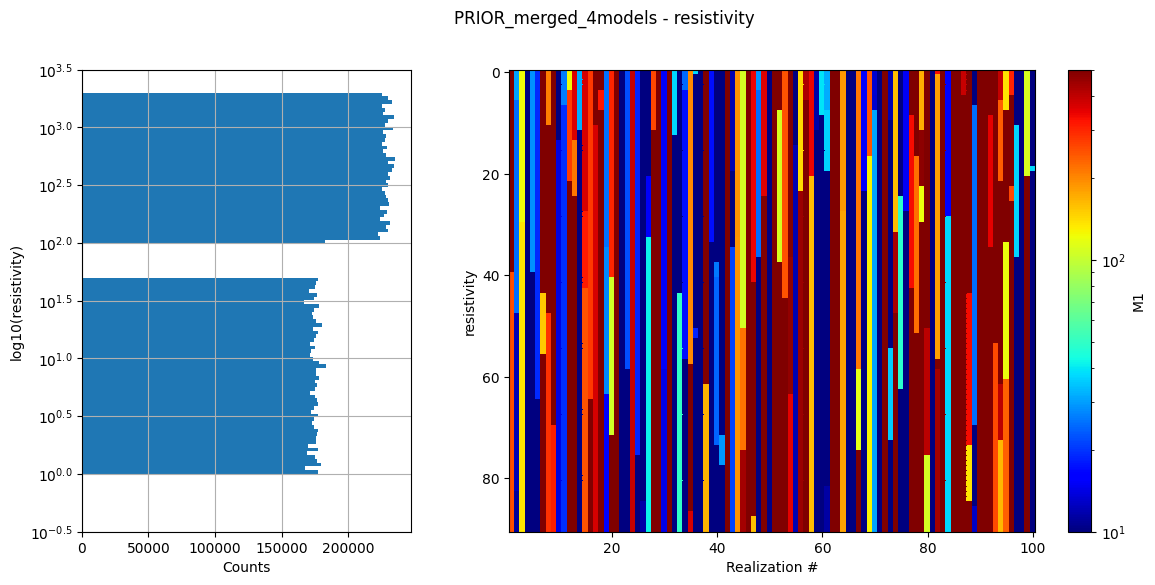

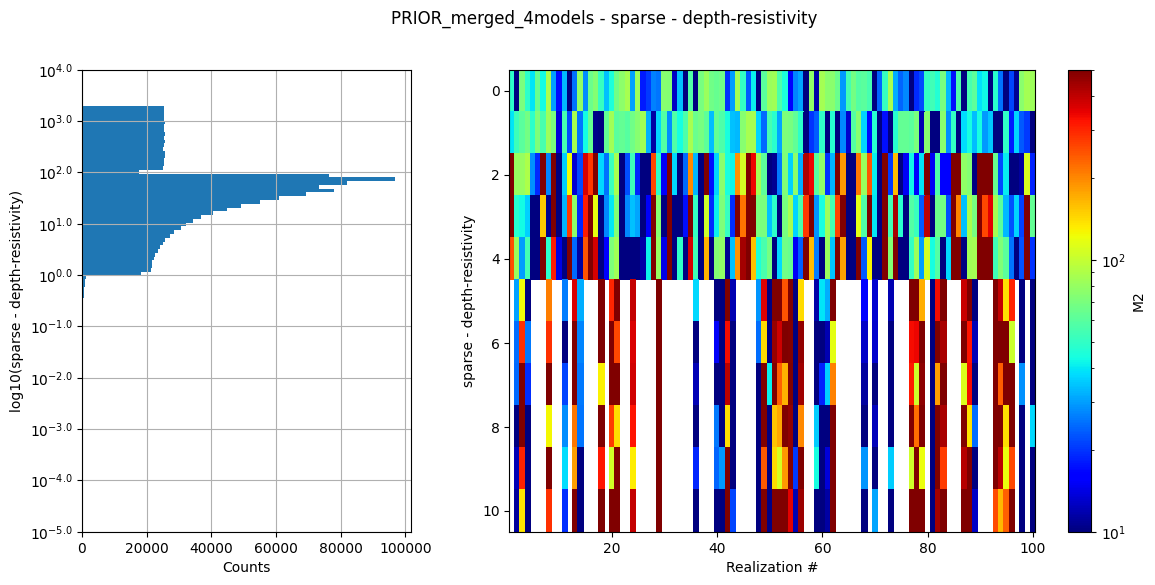

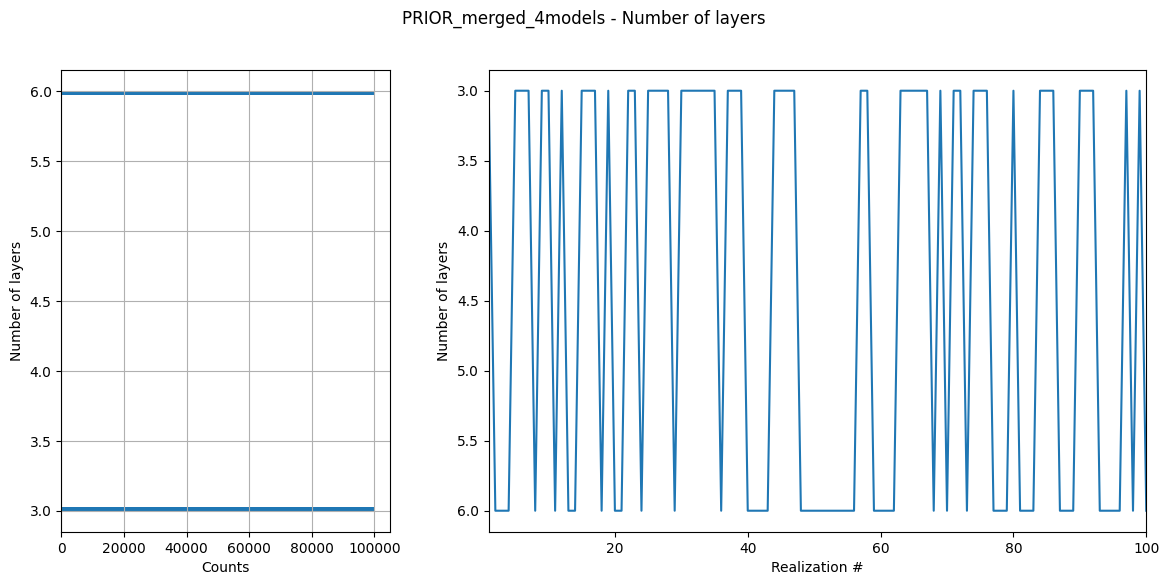

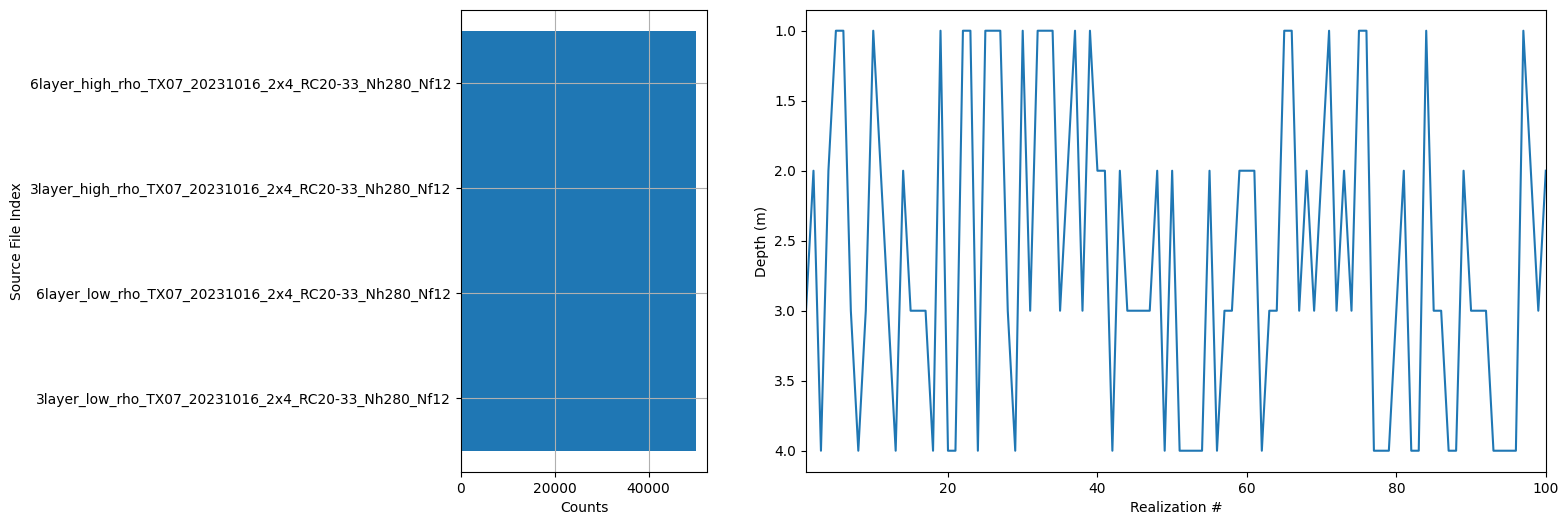

In [6]:
ig.integrate_update_prior_attributes(f_merged)
ig.plot_prior_stats(f_merged)

## 5. Probabilistic inversion with integrate_rejection

In [7]:
print("\\n" + "="*60)
print("PROBABILISTIC INVERSION")
print("="*60)

print(f"\\nRunning probabilistic inversion...")
print(f"- Prior data file: {f_prior_merged}")
print(f"- Observational data: {f_data_h5}")

\n============================================================
PROBABILISTIC INVERSION
\nRunning probabilistic inversion...
- Prior data file: PRIOR_merged_4models.h5
- Observational data: DAUGAARD_AVG.h5


In [8]:
# Run integrate_rejection for probabilistic inversion
f_post_h5 = ig.integrate_rejection(
    f_prior_merged,
    f_data_h5,
    f_post_h5='POST_merged_4models.h5',
    autoT=True,        # Use temperature annealing
    parallel=parallel, # Use parallel processing if available
    showInfo=1
)

print(f"\\nProbabilistic inversion completed!")
print(f"Posterior file: {f_post_h5}")

Loading data from DAUGAARD_AVG.h5. Using data types: [1]
  - D1: id_prior=1,    gaussian, Using 11693/40 data
Loading prior data from PRIOR_merged_4models.h5. Using prior data ids: [1]
  - /D1:  N,nd = 200000/40
<--INTEGRATE_REJECTION-->
f_prior_h5=PRIOR_merged_4models.h5, f_data_h5=DAUGAARD_AVG.h5
f_post_h5=POST_merged_4models.h5


Rejection Sampling:   0%|                                                                                                                      | 0/1462 [00:00<?, ?it/s]

Rejection Sampling:   0%|                                                                                                                      | 0/1462 [00:00<?, ?it/s]

Rejection Sampling:   0%|                                                                                                                      | 0/1462 [00:00<?, ?it/s]

Rejection Sampling:   0%|                                                                                                                      | 0/1462 [00:00<?, ?it/s]

Rejection Sampling:   0%|                                                                                                                      | 0/1462 [00:00<?, ?it/s]

Rejection Sampling:   0%|                                                                                                                      | 0/1461 [00:00<?, ?it/s]

Rejection Sampling:   0%|                                                                                                                      | 0/1461 [00:00<?, ?it/s]

Rejection Sampling:   0%|                                                                                                                      | 0/1461 [00:00<?, ?it/s]

Rejection Sampling:   0%|                                                                                                              | 1/1462 [00:00<02:37,  9.30it/s]

Rejection Sampling:   0%|                                                                                                              | 1/1462 [00:00<02:29,  9.80it/s]

Rejection Sampling:   0%|                                                                                                              | 1/1462 [00:00<02:37,  9.26it/s]

Rejection Sampling:   0%|                                                                                                              | 1/1462 [00:00<02:55,  8.33it/s]

Rejection Sampling:   0%|                                                                                                              | 1/1461 [00:00<02:46,  8.76it/s]

Rejection Sampling:   0%|                                                                                                              | 1/1461 [00:00<02:43,  8.96it/s]

Rejection Sampling:   0%|▏                                                                                                             | 2/1462 [00:00<02:26,  9.98it/s]

Rejection Sampling:   0%|                                                                                                              | 1/1461 [00:00<02:51,  8.51it/s]

Rejection Sampling:   0%|▏                                                                                                             | 2/1462 [00:00<02:35,  9.41it/s]

Rejection Sampling:   0%|▏                                                                                                             | 2/1462 [00:00<02:49,  8.60it/s]

Rejection Sampling:   0%|▏                                                                                                             | 2/1462 [00:00<02:57,  8.24it/s]

Rejection Sampling:   0%|▏                                                                                                             | 2/1462 [00:00<02:48,  8.65it/s]

Rejection Sampling:   0%|▏                                                                                                             | 2/1461 [00:00<02:47,  8.73it/s]

Rejection Sampling:   0%|▏                                                                                                             | 2/1461 [00:00<02:42,  8.98it/s]

Rejection Sampling:   0%|▏                                                                                                             | 3/1462 [00:00<02:32,  9.58it/s]

Rejection Sampling:   0%|▏                                                                                                             | 3/1462 [00:00<02:37,  9.28it/s]

Rejection Sampling:   0%|▏                                                                                                             | 3/1462 [00:00<02:58,  8.17it/s]

Rejection Sampling:   0%|▏                                                                                                             | 3/1462 [00:00<02:45,  8.82it/s]

Rejection Sampling:   0%|▏                                                                                                             | 3/1462 [00:00<02:40,  9.11it/s]

Rejection Sampling:   0%|▏                                                                                                             | 2/1461 [00:00<03:42,  6.55it/s]

Rejection Sampling:   0%|▏                                                                                                             | 3/1461 [00:00<02:35,  9.40it/s]

Rejection Sampling:   0%|▎                                                                                                             | 4/1462 [00:00<02:40,  9.09it/s]

Rejection Sampling:   0%|▎                                                                                                             | 4/1462 [00:00<02:37,  9.28it/s]

Rejection Sampling:   0%|▎                                                                                                             | 4/1461 [00:00<02:34,  9.42it/s]

Rejection Sampling:   0%|▎                                                                                                             | 4/1461 [00:00<02:34,  9.44it/s]

Rejection Sampling:   0%|▍                                                                                                             | 5/1462 [00:00<02:28,  9.82it/s]

Rejection Sampling:   0%|▏                                                                                                             | 3/1461 [00:00<03:28,  7.01it/s]

Rejection Sampling:   0%|▎                                                                                                             | 4/1462 [00:00<03:21,  7.24it/s]

Rejection Sampling:   0%|▍                                                                                                             | 5/1462 [00:00<02:29,  9.74it/s]

Rejection Sampling:   0%|▍                                                                                                             | 5/1462 [00:00<02:36,  9.32it/s]

Rejection Sampling:   0%|▍                                                                                                             | 5/1461 [00:00<02:34,  9.40it/s]

Rejection Sampling:   0%|▍                                                                                                             | 5/1462 [00:00<02:53,  8.40it/s]

Rejection Sampling:   0%|▍                                                                                                             | 6/1462 [00:00<02:30,  9.68it/s]

Rejection Sampling:   0%|▎                                                                                                             | 4/1461 [00:00<03:08,  7.72it/s]

Rejection Sampling:   0%|▍                                                                                                             | 5/1461 [00:00<02:55,  8.29it/s]

Rejection Sampling:   0%|▍                                                                                                             | 6/1462 [00:00<02:30,  9.64it/s]

Rejection Sampling:   0%|▍                                                                                                             | 5/1462 [00:00<03:10,  7.64it/s]

Rejection Sampling:   0%|▍                                                                                                             | 6/1462 [00:00<02:33,  9.49it/s]

Rejection Sampling:   0%|▍                                                                                                             | 6/1461 [00:00<02:33,  9.45it/s]

Rejection Sampling:   0%|▌                                                                                                             | 7/1462 [00:00<02:30,  9.68it/s]

Rejection Sampling:   0%|▍                                                                                                             | 6/1461 [00:00<02:52,  8.44it/s]

Rejection Sampling:   0%|▌                                                                                                             | 7/1462 [00:00<02:33,  9.47it/s]

Rejection Sampling:   0%|▍                                                                                                             | 5/1461 [00:00<03:05,  7.86it/s]

Rejection Sampling:   0%|▍                                                                                                             | 6/1462 [00:00<02:59,  8.11it/s]

Rejection Sampling:   0%|▌                                                                                                             | 7/1462 [00:00<02:32,  9.52it/s]

Rejection Sampling:   0%|▌                                                                                                             | 7/1461 [00:00<02:32,  9.51it/s]

Rejection Sampling:   1%|▌                                                                                                             | 8/1462 [00:00<02:29,  9.70it/s]

Rejection Sampling:   0%|▍                                                                                                             | 6/1461 [00:00<02:52,  8.43it/s]

Rejection Sampling:   0%|▌                                                                                                             | 7/1461 [00:00<02:47,  8.70it/s]

Rejection Sampling:   1%|▌                                                                                                             | 8/1462 [00:00<02:33,  9.49it/s]

Rejection Sampling:   0%|▍                                                                                                             | 6/1462 [00:00<03:56,  6.15it/s]

Rejection Sampling:   0%|▌                                                                                                             | 7/1462 [00:00<03:00,  8.07it/s]

Rejection Sampling:   1%|▌                                                                                                             | 8/1462 [00:00<02:31,  9.61it/s]

Rejection Sampling:   1%|▌                                                                                                             | 8/1461 [00:00<02:33,  9.47it/s]

Rejection Sampling:   1%|▋                                                                                                             | 9/1462 [00:00<02:31,  9.61it/s]

Rejection Sampling:   0%|▌                                                                                                             | 7/1461 [00:00<02:49,  8.57it/s]

Rejection Sampling:   1%|▋                                                                                                             | 9/1462 [00:00<02:36,  9.29it/s]

Rejection Sampling:   1%|▌                                                                                                             | 8/1461 [00:00<02:48,  8.63it/s]

Rejection Sampling:   0%|▌                                                                                                             | 7/1462 [00:00<03:42,  6.55it/s]

Rejection Sampling:   1%|▌                                                                                                             | 8/1462 [00:00<02:55,  8.27it/s]

Rejection Sampling:   1%|▋                                                                                                             | 9/1462 [00:00<02:33,  9.49it/s]

Rejection Sampling:   1%|▋                                                                                                             | 9/1461 [00:00<02:33,  9.48it/s]

Rejection Sampling:   1%|▋                                                                                                            | 10/1462 [00:01<02:30,  9.63it/s]

Rejection Sampling:   1%|▌                                                                                                             | 8/1461 [00:00<02:46,  8.73it/s]

Rejection Sampling:   1%|▋                                                                                                            | 10/1462 [00:01<02:36,  9.25it/s]

Rejection Sampling:   1%|▋                                                                                                             | 9/1461 [00:01<02:56,  8.23it/s]

Rejection Sampling:   1%|▋                                                                                                             | 9/1462 [00:01<02:53,  8.39it/s]

Rejection Sampling:   1%|▋                                                                                                            | 10/1462 [00:01<02:35,  9.35it/s]

Rejection Sampling:   1%|▌                                                                                                             | 8/1462 [00:01<03:32,  6.84it/s]

Rejection Sampling:   1%|▋                                                                                                            | 10/1461 [00:01<02:35,  9.34it/s]

Rejection Sampling:   1%|▊                                                                                                            | 11/1462 [00:01<02:32,  9.51it/s]

Rejection Sampling:   1%|▊                                                                                                            | 11/1462 [00:01<02:38,  9.15it/s]

Rejection Sampling:   1%|▋                                                                                                             | 9/1461 [00:01<02:45,  8.78it/s]

Rejection Sampling:   1%|▊                                                                                                            | 11/1462 [00:01<02:36,  9.25it/s]

Rejection Sampling:   1%|▋                                                                                                            | 10/1461 [00:01<02:54,  8.32it/s]

Rejection Sampling:   1%|▋                                                                                                            | 10/1462 [00:01<02:51,  8.45it/s]

Rejection Sampling:   1%|▋                                                                                                             | 9/1462 [00:01<03:16,  7.41it/s]

Rejection Sampling:   1%|▊                                                                                                            | 11/1461 [00:01<02:37,  9.21it/s]

Rejection Sampling:   1%|▉                                                                                                            | 12/1462 [00:01<02:34,  9.36it/s]

Rejection Sampling:   1%|▉                                                                                                            | 12/1462 [00:01<02:39,  9.11it/s]

Rejection Sampling:   1%|▋                                                                                                            | 10/1461 [00:01<02:44,  8.81it/s]

Rejection Sampling:   1%|▉                                                                                                            | 12/1462 [00:01<02:40,  9.06it/s]

Rejection Sampling:   1%|▊                                                                                                            | 11/1462 [00:01<02:50,  8.53it/s]

Rejection Sampling:   1%|▊                                                                                                            | 11/1461 [00:01<02:52,  8.42it/s]

Rejection Sampling:   1%|▉                                                                                                            | 12/1461 [00:01<02:38,  9.12it/s]

Rejection Sampling:   1%|▉                                                                                                            | 13/1462 [00:01<02:37,  9.22it/s]

Rejection Sampling:   1%|▋                                                                                                            | 10/1462 [00:01<03:19,  7.29it/s]

Rejection Sampling:   1%|▉                                                                                                            | 13/1462 [00:01<02:37,  9.18it/s]

Rejection Sampling:   1%|▊                                                                                                            | 11/1461 [00:01<02:40,  9.01it/s]

Rejection Sampling:   1%|▉                                                                                                            | 12/1462 [00:01<02:46,  8.71it/s]

Rejection Sampling:   1%|▉                                                                                                            | 13/1462 [00:01<02:41,  8.97it/s]

Rejection Sampling:   1%|▉                                                                                                            | 12/1461 [00:01<02:49,  8.54it/s]

Rejection Sampling:   1%|▉                                                                                                            | 13/1461 [00:01<02:39,  9.07it/s]

Rejection Sampling:   1%|█                                                                                                            | 14/1462 [00:01<02:38,  9.15it/s]

Rejection Sampling:   1%|▊                                                                                                            | 11/1462 [00:01<03:13,  7.51it/s]

Rejection Sampling:   1%|▉                                                                                                            | 12/1461 [00:01<02:40,  9.03it/s]

Rejection Sampling:   1%|█                                                                                                            | 14/1462 [00:01<02:51,  8.45it/s]

Rejection Sampling:   1%|▉                                                                                                            | 13/1462 [00:01<02:44,  8.83it/s]

Rejection Sampling:   1%|█                                                                                                            | 14/1462 [00:01<02:40,  9.01it/s]

Rejection Sampling:   1%|▉                                                                                                            | 13/1461 [00:01<02:46,  8.68it/s]

Rejection Sampling:   1%|█                                                                                                            | 14/1461 [00:01<02:38,  9.11it/s]

Rejection Sampling:   1%|█                                                                                                            | 15/1462 [00:01<02:40,  9.04it/s]

Rejection Sampling:   1%|▉                                                                                                            | 12/1462 [00:01<03:01,  7.99it/s]

Rejection Sampling:   1%|▉                                                                                                            | 13/1461 [00:01<02:39,  9.06it/s]

Rejection Sampling:   1%|█                                                                                                            | 15/1462 [00:01<02:48,  8.59it/s]

Rejection Sampling:   1%|█                                                                                                            | 15/1462 [00:01<02:41,  8.96it/s]

Rejection Sampling:   1%|█                                                                                                            | 14/1461 [00:01<02:46,  8.71it/s]

Rejection Sampling:   1%|█                                                                                                            | 14/1462 [00:01<02:51,  8.47it/s]

Rejection Sampling:   1%|█                                                                                                            | 15/1461 [00:01<02:39,  9.07it/s]

Rejection Sampling:   1%|█▏                                                                                                           | 16/1462 [00:01<02:40,  9.02it/s]

Rejection Sampling:   1%|▉                                                                                                            | 13/1462 [00:01<02:55,  8.27it/s]

Rejection Sampling:   1%|█                                                                                                            | 14/1461 [00:01<02:39,  9.08it/s]

Rejection Sampling:   1%|█▏                                                                                                           | 16/1462 [00:01<02:47,  8.64it/s]

Rejection Sampling:   1%|█                                                                                                            | 15/1461 [00:01<02:45,  8.76it/s]

Rejection Sampling:   1%|█                                                                                                            | 15/1462 [00:01<02:48,  8.60it/s]

Rejection Sampling:   1%|█▎                                                                                                           | 17/1462 [00:01<02:39,  9.04it/s]

Rejection Sampling:   1%|█▏                                                                                                           | 16/1461 [00:01<02:47,  8.61it/s]

Rejection Sampling:   1%|█                                                                                                            | 14/1462 [00:01<02:48,  8.58it/s]

Rejection Sampling:   1%|█▏                                                                                                           | 16/1462 [00:01<02:57,  8.16it/s]

Rejection Sampling:   1%|█                                                                                                            | 15/1461 [00:01<02:37,  9.20it/s]

Rejection Sampling:   1%|█▎                                                                                                           | 17/1462 [00:01<02:44,  8.80it/s]

Rejection Sampling:   1%|█▏                                                                                                           | 16/1461 [00:01<02:44,  8.81it/s]

Rejection Sampling:   1%|█▏                                                                                                           | 16/1462 [00:01<02:44,  8.79it/s]

Rejection Sampling:   1%|█▎                                                                                                           | 18/1462 [00:01<02:38,  9.08it/s]

Rejection Sampling:   1%|█▎                                                                                                           | 17/1461 [00:01<02:47,  8.63it/s]

Rejection Sampling:   1%|█▎                                                                                                           | 17/1462 [00:01<02:58,  8.11it/s]

Rejection Sampling:   1%|█▏                                                                                                           | 16/1461 [00:01<02:36,  9.21it/s]

Rejection Sampling:   1%|█                                                                                                            | 15/1462 [00:01<02:55,  8.22it/s]

Rejection Sampling:   1%|█▎                                                                                                           | 18/1462 [00:01<02:43,  8.83it/s]

Rejection Sampling:   1%|█▎                                                                                                           | 17/1461 [00:01<02:45,  8.71it/s]

Rejection Sampling:   1%|█▎                                                                                                           | 17/1462 [00:02<02:44,  8.80it/s]

Rejection Sampling:   1%|█▍                                                                                                           | 19/1462 [00:02<02:40,  8.99it/s]

Rejection Sampling:   1%|█▎                                                                                                           | 18/1461 [00:01<02:46,  8.64it/s]

Rejection Sampling:   1%|█▎                                                                                                           | 18/1462 [00:02<02:51,  8.42it/s]

Rejection Sampling:   1%|█▎                                                                                                           | 17/1461 [00:01<02:35,  9.26it/s]

Rejection Sampling:   1%|█▏                                                                                                           | 16/1462 [00:02<02:50,  8.48it/s]

Rejection Sampling:   1%|█▍                                                                                                           | 19/1462 [00:02<02:40,  8.99it/s]

Rejection Sampling:   1%|█▎                                                                                                           | 18/1462 [00:02<02:45,  8.72it/s]

Rejection Sampling:   1%|█▍                                                                                                           | 20/1462 [00:02<02:39,  9.04it/s]

Rejection Sampling:   1%|█▍                                                                                                           | 19/1462 [00:02<02:47,  8.60it/s]

Rejection Sampling:   1%|█▍                                                                                                           | 19/1461 [00:02<02:46,  8.64it/s]

Rejection Sampling:   1%|█▎                                                                                                           | 18/1461 [00:02<02:36,  9.20it/s]

Rejection Sampling:   1%|█▎                                                                                                           | 18/1461 [00:02<03:00,  7.99it/s]

Rejection Sampling:   1%|█▎                                                                                                           | 17/1462 [00:02<02:48,  8.57it/s]

Rejection Sampling:   1%|█▍                                                                                                           | 20/1462 [00:02<02:40,  8.96it/s]

Rejection Sampling:   1%|█▍                                                                                                           | 19/1462 [00:02<02:44,  8.75it/s]

Rejection Sampling:   1%|█▌                                                                                                           | 21/1462 [00:02<02:41,  8.94it/s]

Rejection Sampling:   1%|█▍                                                                                                           | 20/1462 [00:02<02:46,  8.64it/s]

Rejection Sampling:   1%|█▍                                                                                                           | 20/1461 [00:02<02:46,  8.67it/s]

Rejection Sampling:   1%|█▍                                                                                                           | 19/1461 [00:02<02:39,  9.05it/s]

Rejection Sampling:   1%|█▍                                                                                                           | 19/1461 [00:02<02:55,  8.23it/s]

Rejection Sampling:   1%|█▎                                                                                                           | 18/1462 [00:02<02:45,  8.73it/s]

Rejection Sampling:   1%|█▌                                                                                                           | 21/1462 [00:02<02:41,  8.95it/s]

Rejection Sampling:   2%|█▋                                                                                                           | 22/1462 [00:02<02:41,  8.91it/s]

Rejection Sampling:   1%|█▌                                                                                                           | 21/1462 [00:02<02:44,  8.78it/s]

Rejection Sampling:   1%|█▍                                                                                                           | 20/1461 [00:02<02:38,  9.07it/s]

Rejection Sampling:   1%|█▌                                                                                                           | 21/1461 [00:02<02:43,  8.78it/s]

Rejection Sampling:   1%|█▍                                                                                                           | 19/1462 [00:02<02:41,  8.92it/s]

Rejection Sampling:   1%|█▍                                                                                                           | 20/1462 [00:02<02:58,  8.06it/s]

Rejection Sampling:   1%|█▍                                                                                                           | 20/1461 [00:02<02:53,  8.28it/s]

Rejection Sampling:   2%|█▋                                                                                                           | 22/1462 [00:02<02:40,  9.00it/s]

Rejection Sampling:   2%|█▋                                                                                                           | 23/1462 [00:02<02:42,  8.84it/s]

Rejection Sampling:   2%|█▋                                                                                                           | 22/1462 [00:02<02:44,  8.75it/s]

Rejection Sampling:   1%|█▌                                                                                                           | 21/1461 [00:02<02:40,  8.97it/s]

Rejection Sampling:   2%|█▋                                                                                                           | 22/1461 [00:02<02:44,  8.75it/s]

Rejection Sampling:   1%|█▍                                                                                                           | 20/1462 [00:02<02:42,  8.88it/s]

Rejection Sampling:   1%|█▌                                                                                                           | 21/1462 [00:02<02:54,  8.26it/s]

Rejection Sampling:   1%|█▌                                                                                                           | 21/1461 [00:02<02:49,  8.51it/s]

Rejection Sampling:   2%|█▋                                                                                                           | 23/1462 [00:02<02:41,  8.90it/s]

Rejection Sampling:   2%|█▊                                                                                                           | 24/1462 [00:02<02:42,  8.83it/s]

Rejection Sampling:   2%|█▋                                                                                                           | 23/1462 [00:02<02:44,  8.75it/s]

Rejection Sampling:   2%|█▋                                                                                                           | 23/1461 [00:02<02:43,  8.80it/s]

Rejection Sampling:   2%|█▋                                                                                                           | 22/1461 [00:02<02:41,  8.92it/s]

Rejection Sampling:   1%|█▌                                                                                                           | 21/1462 [00:02<02:41,  8.90it/s]

Rejection Sampling:   2%|█▋                                                                                                           | 22/1462 [00:02<02:50,  8.46it/s]

Rejection Sampling:   2%|█▋                                                                                                           | 22/1461 [00:02<02:46,  8.63it/s]

Rejection Sampling:   2%|█▊                                                                                                           | 24/1462 [00:02<02:41,  8.93it/s]

Rejection Sampling:   2%|█▊                                                                                                           | 25/1462 [00:02<02:43,  8.80it/s]

Rejection Sampling:   2%|█▊                                                                                                           | 24/1462 [00:02<02:43,  8.79it/s]

Rejection Sampling:   2%|█▊                                                                                                           | 24/1461 [00:02<02:43,  8.79it/s]

Rejection Sampling:   2%|█▋                                                                                                           | 23/1461 [00:02<02:42,  8.87it/s]

Rejection Sampling:   2%|█▋                                                                                                           | 23/1461 [00:02<02:45,  8.71it/s]

Rejection Sampling:   2%|█▋                                                                                                           | 23/1462 [00:02<02:47,  8.58it/s]

Rejection Sampling:   2%|█▋                                                                                                           | 22/1462 [00:02<02:48,  8.55it/s]

Rejection Sampling:   2%|█▊                                                                                                           | 25/1462 [00:02<02:42,  8.87it/s]

Rejection Sampling:   2%|█▉                                                                                                           | 26/1462 [00:02<02:50,  8.42it/s]

Rejection Sampling:   2%|█▊                                                                                                           | 25/1462 [00:02<02:43,  8.81it/s]

Rejection Sampling:   2%|█▊                                                                                                           | 24/1461 [00:02<02:42,  8.86it/s]

Rejection Sampling:   2%|█▊                                                                                                           | 24/1461 [00:02<02:43,  8.77it/s]

Rejection Sampling:   2%|█▊                                                                                                           | 24/1462 [00:02<02:45,  8.68it/s]

Rejection Sampling:   2%|█▊                                                                                                           | 25/1461 [00:02<02:44,  8.74it/s]

Rejection Sampling:   2%|█▋                                                                                                           | 23/1462 [00:02<02:44,  8.75it/s]

Rejection Sampling:   2%|█▉                                                                                                           | 26/1462 [00:02<02:40,  8.93it/s]

Rejection Sampling:   2%|█▉                                                                                                           | 26/1462 [00:02<02:42,  8.81it/s]

Rejection Sampling:   2%|█▊                                                                                                           | 25/1461 [00:02<02:42,  8.85it/s]

Rejection Sampling:   2%|█▊                                                                                                           | 25/1461 [00:02<02:43,  8.81it/s]

Rejection Sampling:   2%|█▊                                                                                                           | 25/1462 [00:02<02:44,  8.73it/s]

Rejection Sampling:   2%|██                                                                                                           | 27/1462 [00:02<02:51,  8.35it/s]

Rejection Sampling:   2%|█▉                                                                                                           | 26/1461 [00:02<02:43,  8.75it/s]

Rejection Sampling:   2%|█▊                                                                                                           | 24/1462 [00:02<02:42,  8.84it/s]

Rejection Sampling:   2%|██                                                                                                           | 27/1462 [00:02<02:38,  9.05it/s]

Rejection Sampling:   2%|██                                                                                                           | 27/1462 [00:03<02:43,  8.77it/s]

Rejection Sampling:   2%|█▉                                                                                                           | 26/1461 [00:03<02:43,  8.79it/s]

Rejection Sampling:   2%|█▉                                                                                                           | 26/1461 [00:02<02:42,  8.83it/s]

Rejection Sampling:   2%|█▉                                                                                                           | 26/1462 [00:03<02:44,  8.74it/s]

Rejection Sampling:   2%|██                                                                                                           | 27/1461 [00:03<02:43,  8.76it/s]

Rejection Sampling:   2%|██                                                                                                           | 28/1462 [00:03<02:50,  8.43it/s]

Rejection Sampling:   2%|█▊                                                                                                           | 25/1462 [00:03<02:42,  8.84it/s]

Rejection Sampling:   2%|██                                                                                                           | 28/1462 [00:03<02:34,  9.28it/s]

Rejection Sampling:   2%|██                                                                                                           | 28/1462 [00:03<02:44,  8.71it/s]

Rejection Sampling:   2%|██                                                                                                           | 27/1461 [00:03<02:43,  8.75it/s]

Rejection Sampling:   2%|██                                                                                                           | 27/1462 [00:03<02:44,  8.70it/s]

Rejection Sampling:   2%|█▉                                                                                                           | 26/1462 [00:03<02:42,  8.85it/s]

Rejection Sampling:   2%|██                                                                                                           | 28/1461 [00:03<02:43,  8.75it/s]

Rejection Sampling:   2%|██▏                                                                                                          | 29/1462 [00:03<02:48,  8.49it/s]

Rejection Sampling:   2%|██                                                                                                           | 27/1461 [00:03<02:45,  8.67it/s]

Rejection Sampling:   2%|██▏                                                                                                          | 29/1462 [00:03<02:32,  9.41it/s]

Rejection Sampling:   2%|██▏                                                                                                          | 29/1462 [00:03<02:44,  8.71it/s]

Rejection Sampling:   2%|██                                                                                                           | 28/1461 [00:03<02:43,  8.74it/s]

Rejection Sampling:   2%|██                                                                                                           | 27/1462 [00:03<02:42,  8.81it/s]

Rejection Sampling:   2%|██▏                                                                                                          | 29/1461 [00:03<02:44,  8.73it/s]

Rejection Sampling:   2%|██                                                                                                           | 28/1462 [00:03<02:45,  8.65it/s]

Rejection Sampling:   2%|██▏                                                                                                          | 30/1462 [00:03<02:34,  9.29it/s]

Rejection Sampling:   2%|██▏                                                                                                          | 30/1462 [00:03<02:50,  8.40it/s]

Rejection Sampling:   2%|██                                                                                                           | 28/1461 [00:03<02:50,  8.41it/s]

Rejection Sampling:   2%|██▏                                                                                                          | 30/1462 [00:03<02:44,  8.69it/s]

Rejection Sampling:   2%|██                                                                                                           | 28/1462 [00:03<02:43,  8.77it/s]

Rejection Sampling:   2%|██▎                                                                                                          | 31/1462 [00:03<02:35,  9.18it/s]

Rejection Sampling:   2%|██▏                                                                                                          | 29/1461 [00:03<02:44,  8.73it/s]

Rejection Sampling:   2%|██▏                                                                                                          | 30/1461 [00:03<02:43,  8.73it/s]

Rejection Sampling:   2%|██▏                                                                                                          | 29/1462 [00:03<02:45,  8.68it/s]

Rejection Sampling:   2%|██▎                                                                                                          | 31/1462 [00:03<02:46,  8.57it/s]

Rejection Sampling:   2%|██▏                                                                                                          | 29/1461 [00:03<02:46,  8.61it/s]

Rejection Sampling:   2%|██▎                                                                                                          | 31/1462 [00:03<02:44,  8.68it/s]

Rejection Sampling:   2%|██▏                                                                                                          | 29/1462 [00:03<02:44,  8.73it/s]

Rejection Sampling:   2%|██▏                                                                                                          | 30/1461 [00:03<02:45,  8.65it/s]

Rejection Sampling:   2%|██▎                                                                                                          | 31/1461 [00:03<02:44,  8.67it/s]

Rejection Sampling:   2%|██▏                                                                                                          | 30/1461 [00:03<02:43,  8.77it/s]

Rejection Sampling:   2%|██▍                                                                                                          | 32/1462 [00:03<02:44,  8.67it/s]

Rejection Sampling:   2%|██▍                                                                                                          | 32/1462 [00:03<02:39,  8.95it/s]

Rejection Sampling:   2%|██▏                                                                                                          | 30/1462 [00:03<02:45,  8.67it/s]

Rejection Sampling:   2%|██▍                                                                                                          | 32/1462 [00:03<02:44,  8.68it/s]

Rejection Sampling:   2%|██▎                                                                                                          | 31/1461 [00:03<02:44,  8.72it/s]

Rejection Sampling:   2%|██▎                                                                                                          | 31/1462 [00:03<02:44,  8.69it/s]

Rejection Sampling:   2%|██▍                                                                                                          | 32/1461 [00:03<02:43,  8.73it/s]

Rejection Sampling:   2%|██▍                                                                                                          | 33/1462 [00:03<02:44,  8.71it/s]

Rejection Sampling:   2%|██▍                                                                                                          | 33/1462 [00:03<02:40,  8.90it/s]

Rejection Sampling:   2%|██▏                                                                                                          | 30/1462 [00:03<02:43,  8.74it/s]

Rejection Sampling:   2%|██▎                                                                                                          | 31/1461 [00:03<02:43,  8.77it/s]

Rejection Sampling:   2%|██▍                                                                                                          | 33/1462 [00:03<02:44,  8.67it/s]

Rejection Sampling:   2%|██▍                                                                                                          | 32/1461 [00:03<02:44,  8.69it/s]

Rejection Sampling:   2%|██▍                                                                                                          | 32/1462 [00:03<02:44,  8.71it/s]

Rejection Sampling:   2%|██▌                                                                                                          | 34/1462 [00:03<02:41,  8.85it/s]

Rejection Sampling:   2%|██▍                                                                                                          | 33/1461 [00:03<02:44,  8.68it/s]

Rejection Sampling:   2%|██▌                                                                                                          | 34/1462 [00:03<02:44,  8.68it/s]

Rejection Sampling:   2%|██▍                                                                                                          | 32/1461 [00:03<02:43,  8.73it/s]

Rejection Sampling:   2%|██▎                                                                                                          | 31/1462 [00:03<02:45,  8.63it/s]

Rejection Sampling:   2%|██▌                                                                                                          | 35/1462 [00:03<02:42,  8.78it/s]

Rejection Sampling:   2%|██▍                                                                                                          | 33/1462 [00:03<02:44,  8.67it/s]

Rejection Sampling:   2%|██▍                                                                                                          | 33/1461 [00:03<02:44,  8.68it/s]

Rejection Sampling:   2%|██▍                                                                                                          | 32/1462 [00:03<02:45,  8.63it/s]

Rejection Sampling:   2%|██▌                                                                                                          | 34/1461 [00:03<02:45,  8.61it/s]

Rejection Sampling:   2%|██▌                                                                                                          | 35/1462 [00:03<02:45,  8.62it/s]

Rejection Sampling:   2%|██▍                                                                                                          | 33/1461 [00:03<02:46,  8.57it/s]

Rejection Sampling:   2%|██▌                                                                                                          | 34/1462 [00:03<02:47,  8.53it/s]

Rejection Sampling:   2%|██▋                                                                                                          | 36/1462 [00:03<02:41,  8.84it/s]

Rejection Sampling:   2%|██▌                                                                                                          | 34/1461 [00:03<02:42,  8.81it/s]

Rejection Sampling:   2%|██▍                                                                                                          | 33/1462 [00:03<02:43,  8.76it/s]

Rejection Sampling:   2%|██▌                                                                                                          | 34/1462 [00:03<02:43,  8.72it/s]

Rejection Sampling:   2%|██▌                                                                                                          | 34/1461 [00:03<02:43,  8.71it/s]

Rejection Sampling:   2%|██▌                                                                                                          | 35/1461 [00:03<02:44,  8.69it/s]

Rejection Sampling:   2%|██▌                                                                                                          | 35/1462 [00:03<02:44,  8.65it/s]

Rejection Sampling:   2%|██▋                                                                                                          | 36/1462 [00:04<03:06,  7.65it/s]

Rejection Sampling:   3%|██▊                                                                                                          | 37/1462 [00:04<02:42,  8.79it/s]

Rejection Sampling:   2%|██▌                                                                                                          | 35/1461 [00:04<02:42,  8.77it/s]

Rejection Sampling:   2%|██▌                                                                                                          | 35/1462 [00:04<02:43,  8.75it/s]

Rejection Sampling:   2%|██▌                                                                                                          | 34/1462 [00:04<02:42,  8.77it/s]

Rejection Sampling:   2%|██▌                                                                                                          | 35/1461 [00:04<02:42,  8.79it/s]

Rejection Sampling:   2%|██▋                                                                                                          | 36/1462 [00:04<02:43,  8.73it/s]

Rejection Sampling:   2%|██▋                                                                                                          | 36/1461 [00:04<02:43,  8.69it/s]

Rejection Sampling:   3%|██▊                                                                                                          | 37/1462 [00:04<02:54,  8.17it/s]

Rejection Sampling:   2%|██▋                                                                                                          | 36/1461 [00:04<02:42,  8.75it/s]

Rejection Sampling:   2%|██▋                                                                                                          | 36/1462 [00:04<02:43,  8.74it/s]

Rejection Sampling:   2%|██▌                                                                                                          | 35/1462 [00:04<02:43,  8.75it/s]

Rejection Sampling:   3%|██▊                                                                                                          | 38/1462 [00:04<02:43,  8.71it/s]

Rejection Sampling:   3%|██▊                                                                                                          | 37/1462 [00:04<02:44,  8.65it/s]

Rejection Sampling:   3%|██▊                                                                                                          | 37/1461 [00:04<02:45,  8.63it/s]

Rejection Sampling:   2%|██▋                                                                                                          | 36/1461 [00:04<02:47,  8.51it/s]

Rejection Sampling:   3%|██▊                                                                                                          | 38/1462 [00:04<02:48,  8.47it/s]

Rejection Sampling:   3%|██▊                                                                                                          | 37/1461 [00:04<02:42,  8.75it/s]

Rejection Sampling:   2%|██▋                                                                                                          | 36/1462 [00:04<02:43,  8.73it/s]

Rejection Sampling:   3%|██▉                                                                                                          | 39/1462 [00:04<02:43,  8.71it/s]

Rejection Sampling:   3%|██▊                                                                                                          | 37/1462 [00:04<02:44,  8.66it/s]

Rejection Sampling:   3%|██▊                                                                                                          | 38/1461 [00:04<02:43,  8.71it/s]

Rejection Sampling:   3%|██▊                                                                                                          | 37/1461 [00:04<02:45,  8.63it/s]

Rejection Sampling:   3%|██▊                                                                                                          | 38/1462 [00:04<02:49,  8.41it/s]

Rejection Sampling:   3%|██▉                                                                                                          | 39/1462 [00:04<02:44,  8.65it/s]

Rejection Sampling:   3%|██▊                                                                                                          | 37/1462 [00:04<02:43,  8.72it/s]

Rejection Sampling:   3%|██▊                                                                                                          | 38/1462 [00:04<02:43,  8.70it/s]

Rejection Sampling:   3%|██▉                                                                                                          | 40/1462 [00:04<02:43,  8.71it/s]

Rejection Sampling:   3%|██▉                                                                                                          | 39/1461 [00:04<02:42,  8.75it/s]

Rejection Sampling:   3%|██▊                                                                                                          | 38/1461 [00:04<02:44,  8.65it/s]

Rejection Sampling:   3%|██▊                                                                                                          | 38/1461 [00:04<02:42,  8.75it/s]

Rejection Sampling:   3%|██▉                                                                                                          | 39/1462 [00:04<02:43,  8.71it/s]

Rejection Sampling:   3%|██▊                                                                                                          | 38/1462 [00:04<02:43,  8.70it/s]

Rejection Sampling:   3%|██▉                                                                                                          | 39/1462 [00:04<02:43,  8.71it/s]

Rejection Sampling:   3%|██▉                                                                                                          | 40/1461 [00:04<02:42,  8.73it/s]

Rejection Sampling:   3%|███                                                                                                          | 41/1462 [00:04<02:43,  8.69it/s]

Rejection Sampling:   3%|███                                                                                                          | 41/1462 [00:04<02:34,  9.18it/s]

Rejection Sampling:   3%|██▉                                                                                                          | 40/1462 [00:04<02:42,  8.77it/s]

Rejection Sampling:   3%|██▉                                                                                                          | 39/1461 [00:04<02:44,  8.67it/s]

Rejection Sampling:   3%|██▉                                                                                                          | 39/1461 [00:04<02:43,  8.68it/s]

Rejection Sampling:   3%|███                                                                                                          | 41/1461 [00:04<02:41,  8.80it/s]

Rejection Sampling:   3%|██▉                                                                                                          | 39/1462 [00:04<02:42,  8.74it/s]

Rejection Sampling:   3%|██▉                                                                                                          | 40/1462 [00:04<02:42,  8.76it/s]

Rejection Sampling:   3%|███▏                                                                                                         | 42/1462 [00:04<02:42,  8.76it/s]

Rejection Sampling:   3%|███▏                                                                                                         | 42/1462 [00:04<02:35,  9.15it/s]

Rejection Sampling:   3%|███                                                                                                          | 41/1462 [00:04<02:41,  8.80it/s]

Rejection Sampling:   3%|██▉                                                                                                          | 40/1461 [00:04<02:45,  8.60it/s]

Rejection Sampling:   3%|██▉                                                                                                          | 40/1461 [00:04<02:47,  8.50it/s]

Rejection Sampling:   3%|███▏                                                                                                         | 42/1461 [00:04<02:41,  8.76it/s]

Rejection Sampling:   3%|██▉                                                                                                          | 40/1462 [00:04<02:42,  8.73it/s]

Rejection Sampling:   3%|███                                                                                                          | 41/1462 [00:04<02:42,  8.72it/s]

Rejection Sampling:   3%|███▏                                                                                                         | 43/1462 [00:04<02:37,  9.03it/s]

Rejection Sampling:   3%|███▏                                                                                                         | 42/1462 [00:04<02:41,  8.81it/s]

Rejection Sampling:   3%|███▏                                                                                                         | 43/1462 [00:04<02:43,  8.70it/s]

Rejection Sampling:   3%|███                                                                                                          | 41/1461 [00:04<02:42,  8.73it/s]

Rejection Sampling:   3%|███                                                                                                          | 41/1461 [00:04<02:53,  8.20it/s]

Rejection Sampling:   3%|███▏                                                                                                         | 43/1461 [00:04<02:41,  8.80it/s]

Rejection Sampling:   3%|███▎                                                                                                         | 44/1462 [00:04<02:37,  9.01it/s]

Rejection Sampling:   3%|███▏                                                                                                         | 42/1462 [00:04<02:41,  8.78it/s]

Rejection Sampling:   3%|███                                                                                                          | 41/1462 [00:04<02:43,  8.71it/s]

Rejection Sampling:   3%|███▏                                                                                                         | 42/1461 [00:04<02:41,  8.79it/s]

Rejection Sampling:   3%|███▎                                                                                                         | 44/1462 [00:04<02:43,  8.70it/s]

Rejection Sampling:   3%|███▏                                                                                                         | 43/1462 [00:04<02:43,  8.67it/s]

Rejection Sampling:   3%|███▏                                                                                                         | 42/1461 [00:04<02:58,  7.95it/s]

Rejection Sampling:   3%|███▎                                                                                                         | 44/1461 [00:04<02:41,  8.77it/s]

Rejection Sampling:   3%|███▎                                                                                                         | 45/1462 [00:05<02:39,  8.90it/s]

Rejection Sampling:   3%|███▏                                                                                                         | 43/1461 [00:04<02:41,  8.80it/s]

Rejection Sampling:   3%|███▎                                                                                                         | 45/1462 [00:05<02:42,  8.73it/s]

Rejection Sampling:   3%|███▏                                                                                                         | 42/1462 [00:05<02:43,  8.68it/s]

Rejection Sampling:   3%|███▏                                                                                                         | 43/1462 [00:05<02:43,  8.67it/s]

Rejection Sampling:   3%|███▎                                                                                                         | 44/1462 [00:04<02:41,  8.76it/s]

Rejection Sampling:   3%|███▏                                                                                                         | 43/1461 [00:05<02:53,  8.16it/s]

Rejection Sampling:   3%|███▎                                                                                                         | 45/1461 [00:05<02:42,  8.74it/s]

Rejection Sampling:   3%|███▍                                                                                                         | 46/1462 [00:05<02:40,  8.85it/s]

Rejection Sampling:   3%|███▍                                                                                                         | 46/1462 [00:05<02:41,  8.76it/s]

Rejection Sampling:   3%|███▎                                                                                                         | 44/1461 [00:05<02:42,  8.72it/s]

Rejection Sampling:   3%|███▎                                                                                                         | 45/1462 [00:05<02:42,  8.74it/s]

Rejection Sampling:   3%|███▎                                                                                                         | 44/1462 [00:05<02:43,  8.65it/s]

Rejection Sampling:   3%|███▏                                                                                                         | 43/1462 [00:05<02:44,  8.61it/s]

Rejection Sampling:   3%|███▎                                                                                                         | 44/1461 [00:05<02:58,  7.95it/s]

Rejection Sampling:   3%|███▌                                                                                                         | 47/1462 [00:05<02:39,  8.87it/s]

Rejection Sampling:   3%|███▌                                                                                                         | 47/1462 [00:05<02:41,  8.77it/s]

Rejection Sampling:   3%|███▍                                                                                                         | 46/1461 [00:05<02:41,  8.78it/s]

Rejection Sampling:   3%|███▍                                                                                                         | 46/1462 [00:05<02:40,  8.82it/s]

Rejection Sampling:   3%|███▎                                                                                                         | 45/1462 [00:05<02:41,  8.76it/s]

Rejection Sampling:   3%|███▎                                                                                                         | 44/1462 [00:05<02:43,  8.68it/s]

Rejection Sampling:   3%|███▎                                                                                                         | 45/1461 [00:05<02:44,  8.58it/s]

Rejection Sampling:   3%|███▎                                                                                                         | 45/1461 [00:05<02:53,  8.18it/s]

Rejection Sampling:   3%|███▌                                                                                                         | 48/1462 [00:05<02:40,  8.81it/s]

Rejection Sampling:   3%|███▌                                                                                                         | 48/1462 [00:05<02:41,  8.77it/s]

Rejection Sampling:   3%|███▌                                                                                                         | 47/1462 [00:05<02:41,  8.79it/s]

Rejection Sampling:   3%|███▍                                                                                                         | 46/1462 [00:05<02:41,  8.75it/s]

Rejection Sampling:   3%|███▎                                                                                                         | 45/1462 [00:05<02:41,  8.77it/s]

Rejection Sampling:   3%|███▌                                                                                                         | 47/1461 [00:05<02:43,  8.67it/s]

Rejection Sampling:   3%|███▍                                                                                                         | 46/1461 [00:05<02:42,  8.71it/s]

Rejection Sampling:   3%|███▍                                                                                                         | 46/1461 [00:05<02:48,  8.38it/s]

Rejection Sampling:   3%|███▌                                                                                                         | 47/1462 [00:05<02:40,  8.83it/s]

Rejection Sampling:   3%|███▌                                                                                                         | 48/1462 [00:05<02:39,  8.85it/s]

Rejection Sampling:   3%|███▋                                                                                                         | 49/1462 [00:05<02:40,  8.81it/s]

Rejection Sampling:   3%|███▌                                                                                                         | 47/1461 [00:05<02:39,  8.84it/s]

Rejection Sampling:   3%|███▌                                                                                                         | 48/1461 [00:05<02:41,  8.73it/s]

Rejection Sampling:   3%|███▋                                                                                                         | 49/1462 [00:05<02:42,  8.70it/s]

Rejection Sampling:   3%|███▍                                                                                                         | 46/1462 [00:05<02:43,  8.69it/s]

Rejection Sampling:   3%|███▌                                                                                                         | 47/1461 [00:05<02:51,  8.25it/s]

Rejection Sampling:   3%|███▌                                                                                                         | 48/1462 [00:05<02:40,  8.82it/s]

Rejection Sampling:   3%|███▌                                                                                                         | 48/1461 [00:05<02:39,  8.85it/s]

Rejection Sampling:   3%|███▋                                                                                                         | 50/1462 [00:05<02:40,  8.80it/s]

Rejection Sampling:   3%|███▋                                                                                                         | 49/1461 [00:05<02:41,  8.75it/s]

Rejection Sampling:   3%|███▌                                                                                                         | 47/1462 [00:05<02:40,  8.79it/s]

Rejection Sampling:   3%|███▋                                                                                                         | 49/1462 [00:05<02:43,  8.62it/s]

Rejection Sampling:   3%|███▋                                                                                                         | 50/1462 [00:05<02:44,  8.59it/s]

Rejection Sampling:   3%|███▌                                                                                                         | 48/1461 [00:05<02:46,  8.49it/s]

Rejection Sampling:   3%|███▋                                                                                                         | 49/1461 [00:05<02:39,  8.83it/s]

Rejection Sampling:   3%|███▊                                                                                                         | 51/1462 [00:05<02:40,  8.78it/s]

Rejection Sampling:   3%|███▌                                                                                                         | 48/1462 [00:05<02:40,  8.84it/s]

Rejection Sampling:   3%|███▋                                                                                                         | 50/1461 [00:05<02:41,  8.76it/s]

Rejection Sampling:   3%|███▋                                                                                                         | 50/1462 [00:05<02:41,  8.76it/s]

Rejection Sampling:   3%|███▊                                                                                                         | 51/1462 [00:05<02:41,  8.74it/s]

Rejection Sampling:   3%|███▋                                                                                                         | 49/1462 [00:05<02:43,  8.63it/s]

Rejection Sampling:   3%|███▋                                                                                                         | 49/1461 [00:05<02:42,  8.69it/s]

Rejection Sampling:   3%|███▋                                                                                                         | 50/1461 [00:05<02:39,  8.84it/s]

Rejection Sampling:   4%|███▉                                                                                                         | 52/1462 [00:05<02:40,  8.81it/s]

Rejection Sampling:   3%|███▊                                                                                                         | 51/1461 [00:05<02:40,  8.78it/s]

Rejection Sampling:   3%|███▊                                                                                                         | 51/1462 [00:05<02:40,  8.81it/s]

Rejection Sampling:   4%|███▉                                                                                                         | 52/1462 [00:05<02:41,  8.75it/s]

Rejection Sampling:   3%|███▋                                                                                                         | 50/1462 [00:05<02:41,  8.72it/s]

Rejection Sampling:   3%|███▋                                                                                                         | 49/1462 [00:05<02:53,  8.14it/s]

Rejection Sampling:   3%|███▋                                                                                                         | 50/1461 [00:05<02:39,  8.86it/s]

Rejection Sampling:   3%|███▊                                                                                                         | 51/1461 [00:05<02:39,  8.83it/s]

Rejection Sampling:   4%|███▉                                                                                                         | 52/1462 [00:05<02:39,  8.82it/s]

Rejection Sampling:   3%|███▊                                                                                                         | 51/1462 [00:05<02:40,  8.80it/s]

Rejection Sampling:   4%|███▉                                                                                                         | 53/1462 [00:05<02:40,  8.76it/s]

Rejection Sampling:   4%|███▉                                                                                                         | 52/1461 [00:05<02:44,  8.56it/s]

Rejection Sampling:   4%|███▉                                                                                                         | 53/1462 [00:05<02:47,  8.43it/s]

Rejection Sampling:   3%|███▋                                                                                                         | 50/1462 [00:05<02:51,  8.24it/s]

Rejection Sampling:   3%|███▊                                                                                                         | 51/1461 [00:05<02:40,  8.78it/s]

Rejection Sampling:   4%|███▉                                                                                                         | 52/1461 [00:05<02:40,  8.80it/s]

Rejection Sampling:   4%|███▉                                                                                                         | 53/1462 [00:06<02:39,  8.82it/s]

Rejection Sampling:   4%|███▉                                                                                                         | 52/1462 [00:06<02:40,  8.80it/s]

Rejection Sampling:   4%|████                                                                                                         | 54/1462 [00:06<02:41,  8.71it/s]

Rejection Sampling:   4%|███▉                                                                                                         | 53/1461 [00:05<02:42,  8.65it/s]

Rejection Sampling:   4%|████                                                                                                         | 54/1462 [00:06<02:43,  8.59it/s]

Rejection Sampling:   3%|███▊                                                                                                         | 51/1462 [00:06<02:47,  8.42it/s]

Rejection Sampling:   4%|███▉                                                                                                         | 52/1461 [00:06<02:41,  8.74it/s]

Rejection Sampling:   4%|███▉                                                                                                         | 53/1461 [00:06<02:39,  8.82it/s]

Rejection Sampling:   4%|████                                                                                                         | 54/1462 [00:06<02:39,  8.82it/s]

Rejection Sampling:   4%|███▉                                                                                                         | 53/1462 [00:06<02:39,  8.81it/s]

Rejection Sampling:   4%|████                                                                                                         | 55/1462 [00:06<02:40,  8.78it/s]

Rejection Sampling:   4%|████                                                                                                         | 54/1461 [00:06<02:40,  8.75it/s]

Rejection Sampling:   4%|████                                                                                                         | 55/1462 [00:06<02:40,  8.76it/s]

Rejection Sampling:   4%|███▉                                                                                                         | 52/1462 [00:06<02:42,  8.67it/s]

Rejection Sampling:   4%|███▉                                                                                                         | 53/1461 [00:06<02:51,  8.19it/s]

Rejection Sampling:   4%|████                                                                                                         | 54/1461 [00:06<02:39,  8.83it/s]

Rejection Sampling:   4%|████                                                                                                         | 54/1462 [00:06<02:39,  8.80it/s]

Rejection Sampling:   4%|████▏                                                                                                        | 56/1462 [00:06<02:40,  8.78it/s]

Rejection Sampling:   4%|████                                                                                                         | 55/1462 [00:06<02:41,  8.70it/s]

Rejection Sampling:   4%|████▏                                                                                                        | 56/1462 [00:06<02:40,  8.78it/s]

Rejection Sampling:   4%|████                                                                                                         | 55/1461 [00:06<02:44,  8.57it/s]

Rejection Sampling:   4%|███▉                                                                                                         | 53/1462 [00:06<02:38,  8.88it/s]

Rejection Sampling:   4%|████                                                                                                         | 54/1461 [00:06<02:48,  8.34it/s]

Rejection Sampling:   4%|████                                                                                                         | 55/1461 [00:06<02:39,  8.83it/s]

Rejection Sampling:   4%|████                                                                                                         | 55/1462 [00:06<02:40,  8.78it/s]

Rejection Sampling:   4%|████▏                                                                                                        | 57/1462 [00:06<02:39,  8.82it/s]

Rejection Sampling:   4%|████▏                                                                                                        | 56/1462 [00:06<02:40,  8.75it/s]

Rejection Sampling:   4%|████▏                                                                                                        | 57/1462 [00:06<02:38,  8.84it/s]

Rejection Sampling:   4%|████                                                                                                         | 54/1462 [00:06<02:37,  8.97it/s]

Rejection Sampling:   4%|████▏                                                                                                        | 56/1461 [00:06<02:47,  8.38it/s]

Rejection Sampling:   4%|████                                                                                                         | 55/1461 [00:06<02:49,  8.32it/s]

Rejection Sampling:   4%|████▏                                                                                                        | 56/1461 [00:06<02:39,  8.82it/s]

Rejection Sampling:   4%|████▎                                                                                                        | 58/1462 [00:06<02:38,  8.86it/s]

Rejection Sampling:   4%|████▏                                                                                                        | 57/1462 [00:06<02:40,  8.77it/s]

Rejection Sampling:   4%|████▏                                                                                                        | 56/1462 [00:06<02:41,  8.73it/s]

Rejection Sampling:   4%|████▎                                                                                                        | 58/1462 [00:06<02:38,  8.85it/s]

Rejection Sampling:   4%|████                                                                                                         | 55/1462 [00:06<02:34,  9.09it/s]

Rejection Sampling:   4%|████▎                                                                                                        | 57/1461 [00:06<02:40,  8.77it/s]

Rejection Sampling:   4%|████▎                                                                                                        | 58/1462 [00:06<02:39,  8.81it/s]

Rejection Sampling:   4%|████▍                                                                                                        | 59/1462 [00:06<02:37,  8.89it/s]

Rejection Sampling:   4%|████▏                                                                                                        | 57/1462 [00:06<02:40,  8.77it/s]

Rejection Sampling:   4%|████▏                                                                                                        | 56/1461 [00:06<02:51,  8.19it/s]

Rejection Sampling:   4%|████▎                                                                                                        | 58/1461 [00:06<02:36,  8.98it/s]

Rejection Sampling:   4%|████▍                                                                                                        | 59/1462 [00:06<02:40,  8.76it/s]

Rejection Sampling:   4%|████▏                                                                                                        | 56/1462 [00:06<02:34,  9.12it/s]

Rejection Sampling:   4%|████▎                                                                                                        | 58/1461 [00:06<02:41,  8.70it/s]

Rejection Sampling:   4%|████▍                                                                                                        | 59/1462 [00:06<02:40,  8.76it/s]

Rejection Sampling:   4%|████▍                                                                                                        | 60/1462 [00:06<02:38,  8.82it/s]

Rejection Sampling:   4%|████▍                                                                                                        | 59/1461 [00:06<02:37,  8.90it/s]

Rejection Sampling:   4%|████▎                                                                                                        | 58/1462 [00:06<02:41,  8.71it/s]

Rejection Sampling:   4%|████▎                                                                                                        | 57/1461 [00:06<02:48,  8.32it/s]

Rejection Sampling:   4%|████▏                                                                                                        | 57/1462 [00:06<02:37,  8.94it/s]

Rejection Sampling:   4%|████▍                                                                                                        | 60/1462 [00:06<02:41,  8.67it/s]

Rejection Sampling:   4%|████▍                                                                                                        | 59/1461 [00:06<02:42,  8.65it/s]

Rejection Sampling:   4%|████▍                                                                                                        | 60/1462 [00:06<02:41,  8.70it/s]

Rejection Sampling:   4%|████▌                                                                                                        | 61/1462 [00:06<02:40,  8.75it/s]

Rejection Sampling:   4%|████▍                                                                                                        | 59/1462 [00:06<02:41,  8.70it/s]

Rejection Sampling:   4%|████▍                                                                                                        | 60/1461 [00:06<02:38,  8.82it/s]

Rejection Sampling:   4%|████▎                                                                                                        | 58/1461 [00:06<02:47,  8.39it/s]

Rejection Sampling:   4%|████▎                                                                                                        | 58/1462 [00:06<02:38,  8.84it/s]

Rejection Sampling:   4%|████▌                                                                                                        | 61/1462 [00:06<02:42,  8.60it/s]

Rejection Sampling:   4%|████▍                                                                                                        | 60/1462 [00:06<02:40,  8.74it/s]

Rejection Sampling:   4%|████▍                                                                                                        | 60/1461 [00:06<02:41,  8.66it/s]

Rejection Sampling:   4%|████▌                                                                                                        | 61/1461 [00:06<02:38,  8.81it/s]

Rejection Sampling:   4%|████▌                                                                                                        | 62/1462 [00:06<02:40,  8.73it/s]

Rejection Sampling:   4%|████▍                                                                                                        | 59/1461 [00:06<02:44,  8.52it/s]

Rejection Sampling:   4%|████▌                                                                                                        | 61/1462 [00:06<02:41,  8.65it/s]

Rejection Sampling:   4%|████▌                                                                                                        | 62/1462 [00:06<02:40,  8.72it/s]

Rejection Sampling:   4%|████▍                                                                                                        | 59/1462 [00:06<02:39,  8.80it/s]

Rejection Sampling:   4%|████▌                                                                                                        | 62/1462 [00:07<02:40,  8.70it/s]

Rejection Sampling:   4%|████▋                                                                                                        | 62/1461 [00:07<02:39,  8.76it/s]

Rejection Sampling:   4%|████▍                                                                                                        | 60/1461 [00:07<02:43,  8.56it/s]

Rejection Sampling:   4%|████▌                                                                                                        | 61/1461 [00:06<02:42,  8.60it/s]

Rejection Sampling:   4%|████▍                                                                                                        | 60/1462 [00:07<02:39,  8.78it/s]

Rejection Sampling:   4%|████▋                                                                                                        | 63/1462 [00:07<02:41,  8.67it/s]

Rejection Sampling:   4%|████▋                                                                                                        | 63/1462 [00:07<02:40,  8.70it/s]

Rejection Sampling:   4%|████▌                                                                                                        | 61/1462 [00:07<02:42,  8.63it/s]

Rejection Sampling:   4%|████▋                                                                                                        | 63/1462 [00:07<02:40,  8.71it/s]

Rejection Sampling:   4%|████▌                                                                                                        | 61/1461 [00:07<02:43,  8.58it/s]

Rejection Sampling:   4%|████▌                                                                                                        | 61/1462 [00:07<02:40,  8.74it/s]

Rejection Sampling:   4%|████▊                                                                                                        | 64/1462 [00:07<02:40,  8.69it/s]

Rejection Sampling:   4%|████▋                                                                                                        | 63/1461 [00:07<02:41,  8.68it/s]

Rejection Sampling:   4%|████▊                                                                                                        | 64/1462 [00:07<02:42,  8.63it/s]

Rejection Sampling:   4%|████▌                                                                                                        | 62/1462 [00:07<02:43,  8.59it/s]

Rejection Sampling:   4%|████▋                                                                                                        | 62/1461 [00:07<02:44,  8.49it/s]

Rejection Sampling:   4%|████▊                                                                                                        | 64/1462 [00:07<02:41,  8.66it/s]

Rejection Sampling:   4%|████▋                                                                                                        | 63/1461 [00:07<02:41,  8.65it/s]

Rejection Sampling:   4%|████▊                                                                                                        | 65/1462 [00:07<02:40,  8.70it/s]

Rejection Sampling:   4%|████▌                                                                                                        | 62/1462 [00:07<02:40,  8.72it/s]

Rejection Sampling:   4%|████▋                                                                                                        | 62/1461 [00:07<02:42,  8.59it/s]

Rejection Sampling:   4%|████▊                                                                                                        | 64/1461 [00:07<02:41,  8.66it/s]

Rejection Sampling:   4%|████▊                                                                                                        | 65/1462 [00:07<02:41,  8.65it/s]

Rejection Sampling:   4%|████▋                                                                                                        | 63/1462 [00:07<02:42,  8.63it/s]

Rejection Sampling:   4%|████▊                                                                                                        | 65/1462 [00:07<02:41,  8.67it/s]

Rejection Sampling:   4%|████▊                                                                                                        | 64/1461 [00:07<02:40,  8.69it/s]

Rejection Sampling:   5%|████▉                                                                                                        | 66/1462 [00:07<02:40,  8.70it/s]

Rejection Sampling:   4%|████▋                                                                                                        | 63/1461 [00:07<02:43,  8.58it/s]

Rejection Sampling:   5%|████▉                                                                                                        | 66/1462 [00:07<02:42,  8.60it/s]

Rejection Sampling:   4%|████▊                                                                                                        | 65/1461 [00:07<02:42,  8.61it/s]

Rejection Sampling:   4%|████▊                                                                                                        | 64/1462 [00:07<02:43,  8.58it/s]

Rejection Sampling:   4%|████▋                                                                                                        | 63/1462 [00:07<02:45,  8.44it/s]

Rejection Sampling:   5%|████▉                                                                                                        | 66/1462 [00:07<02:41,  8.63it/s]

Rejection Sampling:   4%|████▊                                                                                                        | 65/1461 [00:07<02:41,  8.65it/s]

Rejection Sampling:   4%|████▊                                                                                                        | 64/1461 [00:07<02:42,  8.61it/s]

Rejection Sampling:   5%|████▉                                                                                                        | 67/1462 [00:07<02:41,  8.65it/s]

Rejection Sampling:   4%|████▊                                                                                                        | 65/1462 [00:07<02:41,  8.65it/s]

Rejection Sampling:   5%|████▉                                                                                                        | 67/1462 [00:07<02:41,  8.62it/s]

Rejection Sampling:   5%|████▉                                                                                                        | 66/1461 [00:07<02:41,  8.62it/s]

Rejection Sampling:   4%|████▊                                                                                                        | 64/1462 [00:07<02:41,  8.67it/s]

Rejection Sampling:   5%|████▉                                                                                                        | 67/1462 [00:07<02:41,  8.63it/s]

Rejection Sampling:   5%|████▉                                                                                                        | 66/1461 [00:07<02:41,  8.65it/s]

Rejection Sampling:   5%|████▉                                                                                                        | 66/1462 [00:07<02:40,  8.69it/s]

Rejection Sampling:   4%|████▊                                                                                                        | 65/1461 [00:07<02:41,  8.62it/s]

Rejection Sampling:   5%|█████                                                                                                        | 68/1462 [00:07<02:41,  8.64it/s]

Rejection Sampling:   4%|████▊                                                                                                        | 65/1462 [00:07<02:40,  8.71it/s]

Rejection Sampling:   5%|████▉                                                                                                        | 67/1461 [00:07<02:42,  8.58it/s]

Rejection Sampling:   5%|█████                                                                                                        | 68/1462 [00:07<02:42,  8.57it/s]

Rejection Sampling:   5%|█████                                                                                                        | 68/1461 [00:07<02:37,  8.82it/s]

Rejection Sampling:   5%|█████                                                                                                        | 68/1462 [00:07<02:40,  8.71it/s]

Rejection Sampling:   5%|████▉                                                                                                        | 67/1462 [00:07<02:39,  8.73it/s]

Rejection Sampling:   5%|████▉                                                                                                        | 67/1461 [00:07<02:40,  8.69it/s]

Rejection Sampling:   5%|█████▏                                                                                                       | 69/1462 [00:07<02:40,  8.66it/s]

Rejection Sampling:   5%|████▉                                                                                                        | 66/1462 [00:07<02:39,  8.76it/s]

Rejection Sampling:   5%|████▉                                                                                                        | 66/1461 [00:07<02:40,  8.67it/s]

Rejection Sampling:   5%|█████▏                                                                                                       | 69/1462 [00:07<02:51,  8.11it/s]

Rejection Sampling:   5%|█████▏                                                                                                       | 70/1462 [00:07<02:35,  8.94it/s]

Rejection Sampling:   5%|█████                                                                                                        | 68/1462 [00:07<02:37,  8.85it/s]

Rejection Sampling:   5%|█████                                                                                                        | 68/1461 [00:07<02:37,  8.83it/s]

Rejection Sampling:   5%|█████▏                                                                                                       | 69/1462 [00:07<02:38,  8.81it/s]

Rejection Sampling:   5%|█████▏                                                                                                       | 69/1461 [00:07<02:37,  8.83it/s]

Rejection Sampling:   5%|████▉                                                                                                        | 67/1462 [00:07<02:37,  8.85it/s]

Rejection Sampling:   5%|█████▏                                                                                                       | 70/1462 [00:07<02:44,  8.45it/s]

Rejection Sampling:   5%|████▉                                                                                                        | 67/1461 [00:07<03:03,  7.59it/s]

Rejection Sampling:   5%|█████▎                                                                                                       | 71/1462 [00:07<02:32,  9.09it/s]

Rejection Sampling:   5%|█████▏                                                                                                       | 69/1462 [00:07<02:35,  8.94it/s]

Rejection Sampling:   5%|█████▏                                                                                                       | 70/1462 [00:07<02:36,  8.88it/s]

Rejection Sampling:   5%|█████▏                                                                                                       | 70/1461 [00:07<02:37,  8.85it/s]

Rejection Sampling:   5%|█████                                                                                                        | 68/1462 [00:07<02:38,  8.80it/s]

Rejection Sampling:   5%|█████▎                                                                                                       | 71/1462 [00:08<02:42,  8.59it/s]

Rejection Sampling:   5%|█████▏                                                                                                       | 69/1461 [00:07<02:59,  7.74it/s]

Rejection Sampling:   5%|█████                                                                                                        | 68/1461 [00:08<02:55,  7.95it/s]

Rejection Sampling:   5%|█████▎                                                                                                       | 72/1462 [00:08<02:34,  8.97it/s]

Rejection Sampling:   5%|█████▏                                                                                                       | 70/1462 [00:08<02:36,  8.91it/s]

Rejection Sampling:   5%|█████▎                                                                                                       | 71/1462 [00:08<02:36,  8.88it/s]

Rejection Sampling:   5%|█████▎                                                                                                       | 71/1461 [00:08<02:37,  8.85it/s]

Rejection Sampling:   5%|█████▏                                                                                                       | 69/1462 [00:08<02:38,  8.76it/s]

Rejection Sampling:   5%|█████▎                                                                                                       | 72/1462 [00:08<02:42,  8.54it/s]

Rejection Sampling:   5%|█████▏                                                                                                       | 70/1461 [00:08<02:54,  7.99it/s]

Rejection Sampling:   5%|█████▏                                                                                                       | 69/1461 [00:08<02:50,  8.17it/s]

Rejection Sampling:   5%|█████▍                                                                                                       | 73/1462 [00:08<02:33,  9.02it/s]

Rejection Sampling:   5%|█████▎                                                                                                       | 72/1462 [00:08<02:34,  8.98it/s]

Rejection Sampling:   5%|█████▎                                                                                                       | 71/1462 [00:08<02:36,  8.90it/s]

Rejection Sampling:   5%|█████▎                                                                                                       | 72/1461 [00:08<02:35,  8.94it/s]

Rejection Sampling:   5%|█████▏                                                                                                       | 70/1462 [00:08<02:35,  8.94it/s]

Rejection Sampling:   5%|█████▍                                                                                                       | 73/1462 [00:08<02:42,  8.57it/s]

Rejection Sampling:   5%|█████▏                                                                                                       | 70/1461 [00:08<02:45,  8.39it/s]

Rejection Sampling:   5%|█████▎                                                                                                       | 71/1461 [00:08<02:56,  7.85it/s]

Rejection Sampling:   5%|█████▌                                                                                                       | 74/1462 [00:08<02:34,  8.99it/s]

Rejection Sampling:   5%|█████▍                                                                                                       | 73/1462 [00:08<02:33,  9.03it/s]

Rejection Sampling:   5%|█████▎                                                                                                       | 71/1462 [00:08<02:33,  9.06it/s]

Rejection Sampling:   5%|█████▍                                                                                                       | 73/1461 [00:08<02:34,  8.98it/s]

Rejection Sampling:   5%|█████▎                                                                                                       | 72/1462 [00:08<02:36,  8.91it/s]

Rejection Sampling:   5%|█████▌                                                                                                       | 74/1462 [00:08<02:40,  8.64it/s]

Rejection Sampling:   5%|█████▎                                                                                                       | 72/1461 [00:08<02:48,  8.23it/s]

Rejection Sampling:   5%|█████▎                                                                                                       | 71/1461 [00:08<02:52,  8.06it/s]

Rejection Sampling:   5%|█████▌                                                                                                       | 74/1462 [00:08<02:33,  9.07it/s]

Rejection Sampling:   5%|█████▌                                                                                                       | 75/1462 [00:08<02:35,  8.91it/s]

Rejection Sampling:   5%|█████▍                                                                                                       | 73/1462 [00:08<02:34,  8.98it/s]

Rejection Sampling:   5%|█████▎                                                                                                       | 72/1462 [00:08<02:34,  9.00it/s]

Rejection Sampling:   5%|█████▌                                                                                                       | 74/1461 [00:08<02:50,  8.14it/s]

Rejection Sampling:   5%|█████▌                                                                                                       | 75/1462 [00:08<02:39,  8.67it/s]

Rejection Sampling:   5%|█████▍                                                                                                       | 73/1461 [00:08<02:46,  8.34it/s]

Rejection Sampling:   5%|█████▎                                                                                                       | 72/1461 [00:08<02:49,  8.20it/s]

Rejection Sampling:   5%|█████▌                                                                                                       | 75/1462 [00:08<02:33,  9.04it/s]

Rejection Sampling:   5%|█████▋                                                                                                       | 76/1462 [00:08<02:36,  8.84it/s]

Rejection Sampling:   5%|█████▌                                                                                                       | 74/1462 [00:08<02:35,  8.95it/s]

Rejection Sampling:   5%|█████▍                                                                                                       | 73/1462 [00:08<02:35,  8.96it/s]

Rejection Sampling:   5%|█████▌                                                                                                       | 75/1461 [00:08<02:45,  8.38it/s]

Rejection Sampling:   5%|█████▋                                                                                                       | 76/1462 [00:08<02:38,  8.77it/s]

Rejection Sampling:   5%|█████▌                                                                                                       | 74/1461 [00:08<02:43,  8.50it/s]

Rejection Sampling:   5%|█████▍                                                                                                       | 73/1461 [00:08<02:45,  8.36it/s]

Rejection Sampling:   5%|█████▌                                                                                                       | 75/1462 [00:08<02:34,  8.99it/s]

Rejection Sampling:   5%|█████▋                                                                                                       | 77/1462 [00:08<02:36,  8.87it/s]

Rejection Sampling:   5%|█████▌                                                                                                       | 74/1462 [00:08<02:34,  8.96it/s]

Rejection Sampling:   5%|█████▋                                                                                                       | 76/1462 [00:08<02:40,  8.65it/s]

Rejection Sampling:   5%|█████▋                                                                                                       | 77/1462 [00:08<02:36,  8.87it/s]

Rejection Sampling:   5%|█████▋                                                                                                       | 76/1461 [00:08<02:44,  8.42it/s]

Rejection Sampling:   5%|█████▌                                                                                                       | 75/1461 [00:08<02:41,  8.57it/s]

Rejection Sampling:   5%|█████▌                                                                                                       | 74/1461 [00:08<02:42,  8.53it/s]

Rejection Sampling:   5%|█████▋                                                                                                       | 76/1462 [00:08<02:34,  9.00it/s]

Rejection Sampling:   5%|█████▊                                                                                                       | 78/1462 [00:08<02:35,  8.91it/s]

Rejection Sampling:   5%|█████▌                                                                                                       | 75/1462 [00:08<02:34,  8.95it/s]

Rejection Sampling:   5%|█████▋                                                                                                       | 77/1462 [00:08<02:37,  8.79it/s]

Rejection Sampling:   5%|█████▊                                                                                                       | 78/1462 [00:08<02:35,  8.88it/s]

Rejection Sampling:   5%|█████▋                                                                                                       | 77/1461 [00:08<02:45,  8.35it/s]

Rejection Sampling:   5%|█████▋                                                                                                       | 76/1461 [00:08<02:41,  8.60it/s]

Rejection Sampling:   5%|█████▌                                                                                                       | 75/1461 [00:08<02:41,  8.58it/s]

Rejection Sampling:   5%|█████▋                                                                                                       | 77/1462 [00:08<02:35,  8.92it/s]

Rejection Sampling:   5%|█████▉                                                                                                       | 79/1462 [00:08<02:36,  8.86it/s]

Rejection Sampling:   5%|█████▋                                                                                                       | 76/1462 [00:08<02:36,  8.88it/s]

Rejection Sampling:   5%|█████▊                                                                                                       | 78/1462 [00:08<02:36,  8.82it/s]

Rejection Sampling:   5%|█████▉                                                                                                       | 79/1462 [00:08<02:37,  8.80it/s]

Rejection Sampling:   5%|█████▊                                                                                                       | 78/1461 [00:08<02:43,  8.46it/s]

Rejection Sampling:   5%|█████▋                                                                                                       | 77/1461 [00:08<02:41,  8.58it/s]

Rejection Sampling:   5%|█████▋                                                                                                       | 76/1461 [00:08<02:41,  8.58it/s]

Rejection Sampling:   5%|█████▊                                                                                                       | 78/1462 [00:09<02:35,  8.88it/s]

Rejection Sampling:   5%|█████▉                                                                                                       | 80/1462 [00:08<02:36,  8.85it/s]

Rejection Sampling:   5%|█████▉                                                                                                       | 79/1462 [00:08<02:36,  8.85it/s]

Rejection Sampling:   5%|█████▋                                                                                                       | 77/1462 [00:08<02:37,  8.78it/s]

Rejection Sampling:   5%|█████▉                                                                                                       | 80/1462 [00:09<02:38,  8.72it/s]

Rejection Sampling:   5%|█████▉                                                                                                       | 79/1461 [00:08<02:39,  8.65it/s]

Rejection Sampling:   5%|█████▊                                                                                                       | 78/1461 [00:09<02:41,  8.54it/s]

Rejection Sampling:   5%|█████▋                                                                                                       | 77/1461 [00:09<02:40,  8.64it/s]

Rejection Sampling:   5%|█████▉                                                                                                       | 79/1462 [00:09<02:35,  8.91it/s]

Rejection Sampling:   6%|██████                                                                                                       | 81/1462 [00:09<02:35,  8.86it/s]

Rejection Sampling:   5%|█████▉                                                                                                       | 80/1462 [00:09<02:34,  8.93it/s]

Rejection Sampling:   5%|█████▊                                                                                                       | 78/1462 [00:09<02:35,  8.93it/s]

Rejection Sampling:   5%|█████▉                                                                                                       | 80/1461 [00:09<02:36,  8.81it/s]

Rejection Sampling:   6%|██████                                                                                                       | 81/1462 [00:09<02:38,  8.74it/s]

Rejection Sampling:   5%|█████▉                                                                                                       | 79/1461 [00:09<02:42,  8.51it/s]

Rejection Sampling:   5%|█████▉                                                                                                       | 80/1462 [00:09<02:34,  8.94it/s]

Rejection Sampling:   6%|██████                                                                                                       | 81/1462 [00:09<02:33,  9.00it/s]

Rejection Sampling:   5%|█████▉                                                                                                       | 79/1462 [00:09<02:33,  9.02it/s]

Rejection Sampling:   6%|██████                                                                                                       | 82/1462 [00:09<02:36,  8.84it/s]

Rejection Sampling:   5%|█████▊                                                                                                       | 78/1461 [00:09<02:45,  8.34it/s]

Rejection Sampling:   6%|██████                                                                                                       | 82/1462 [00:09<02:33,  8.98it/s]

Rejection Sampling:   6%|██████                                                                                                       | 81/1461 [00:09<02:34,  8.93it/s]

Rejection Sampling:   5%|█████▉                                                                                                       | 80/1461 [00:09<02:39,  8.64it/s]

Rejection Sampling:   6%|██████                                                                                                       | 81/1462 [00:09<02:33,  9.00it/s]

Rejection Sampling:   5%|█████▉                                                                                                       | 80/1462 [00:09<02:31,  9.10it/s]

Rejection Sampling:   6%|██████                                                                                                       | 82/1462 [00:09<02:32,  9.04it/s]

Rejection Sampling:   6%|██████▏                                                                                                      | 83/1462 [00:09<02:34,  8.91it/s]

Rejection Sampling:   5%|█████▉                                                                                                       | 79/1461 [00:09<02:56,  7.83it/s]

Rejection Sampling:   6%|██████▏                                                                                                      | 83/1462 [00:09<02:33,  8.96it/s]

Rejection Sampling:   6%|██████                                                                                                       | 82/1461 [00:09<02:34,  8.92it/s]

Rejection Sampling:   6%|██████                                                                                                       | 81/1461 [00:09<02:38,  8.72it/s]

Rejection Sampling:   6%|██████▏                                                                                                      | 83/1462 [00:09<02:32,  9.02it/s]

Rejection Sampling:   6%|██████                                                                                                       | 81/1462 [00:09<02:33,  8.99it/s]

Rejection Sampling:   6%|██████                                                                                                       | 82/1462 [00:09<02:35,  8.90it/s]

Rejection Sampling:   6%|██████▎                                                                                                      | 84/1462 [00:09<02:34,  8.91it/s]

Rejection Sampling:   6%|██████▎                                                                                                      | 84/1462 [00:09<02:32,  9.04it/s]

Rejection Sampling:   5%|█████▉                                                                                                       | 80/1461 [00:09<02:48,  8.18it/s]

Rejection Sampling:   6%|██████▏                                                                                                      | 83/1461 [00:09<02:34,  8.90it/s]

Rejection Sampling:   6%|██████                                                                                                       | 82/1461 [00:09<02:37,  8.74it/s]

Rejection Sampling:   6%|██████▎                                                                                                      | 84/1462 [00:09<02:33,  9.00it/s]

Rejection Sampling:   6%|██████▏                                                                                                      | 83/1462 [00:09<02:35,  8.89it/s]

Rejection Sampling:   6%|██████                                                                                                       | 82/1462 [00:09<02:34,  8.93it/s]

Rejection Sampling:   6%|██████▎                                                                                                      | 85/1462 [00:09<02:35,  8.88it/s]

Rejection Sampling:   6%|██████▎                                                                                                      | 85/1462 [00:09<02:32,  9.05it/s]

Rejection Sampling:   6%|██████                                                                                                       | 81/1461 [00:09<02:43,  8.42it/s]

Rejection Sampling:   6%|██████▎                                                                                                      | 84/1461 [00:09<02:33,  8.99it/s]

Rejection Sampling:   6%|██████▎                                                                                                      | 85/1462 [00:09<02:31,  9.08it/s]

Rejection Sampling:   6%|██████▏                                                                                                      | 83/1461 [00:09<02:35,  8.84it/s]

Rejection Sampling:   6%|██████▎                                                                                                      | 84/1462 [00:09<02:32,  9.02it/s]

Rejection Sampling:   6%|██████▍                                                                                                      | 86/1462 [00:09<02:31,  9.07it/s]

Rejection Sampling:   6%|██████▏                                                                                                      | 83/1462 [00:09<02:34,  8.95it/s]

Rejection Sampling:   6%|██████                                                                                                       | 82/1461 [00:09<02:39,  8.62it/s]

Rejection Sampling:   6%|██████▎                                                                                                      | 85/1461 [00:09<02:31,  9.09it/s]

Rejection Sampling:   6%|██████▍                                                                                                      | 86/1462 [00:09<02:51,  8.01it/s]

Rejection Sampling:   6%|██████▍                                                                                                      | 86/1462 [00:09<02:30,  9.14it/s]

Rejection Sampling:   6%|██████▎                                                                                                      | 84/1461 [00:09<02:34,  8.94it/s]

Rejection Sampling:   6%|██████▎                                                                                                      | 85/1462 [00:09<02:31,  9.11it/s]

Rejection Sampling:   6%|██████▍                                                                                                      | 87/1462 [00:09<02:30,  9.14it/s]

Rejection Sampling:   6%|██████▎                                                                                                      | 84/1462 [00:09<02:47,  8.20it/s]

Rejection Sampling:   6%|██████▏                                                                                                      | 83/1461 [00:09<02:36,  8.81it/s]

Rejection Sampling:   6%|██████▍                                                                                                      | 86/1461 [00:09<02:30,  9.11it/s]

Rejection Sampling:   6%|██████▍                                                                                                      | 87/1462 [00:09<02:46,  8.24it/s]

Rejection Sampling:   6%|██████▍                                                                                                      | 87/1462 [00:09<02:31,  9.10it/s]

Rejection Sampling:   6%|██████▎                                                                                                      | 85/1461 [00:09<02:33,  8.95it/s]

Rejection Sampling:   6%|██████▍                                                                                                      | 86/1462 [00:09<02:31,  9.07it/s]

Rejection Sampling:   6%|██████▌                                                                                                      | 88/1462 [00:09<02:30,  9.11it/s]

Rejection Sampling:   6%|██████▎                                                                                                      | 85/1462 [00:09<02:42,  8.46it/s]

Rejection Sampling:   6%|██████▎                                                                                                      | 84/1461 [00:09<02:34,  8.90it/s]

Rejection Sampling:   6%|██████▍                                                                                                      | 87/1461 [00:09<02:30,  9.12it/s]

Rejection Sampling:   6%|██████▌                                                                                                      | 88/1462 [00:09<02:43,  8.39it/s]

Rejection Sampling:   6%|██████▌                                                                                                      | 88/1462 [00:09<02:32,  9.04it/s]

Rejection Sampling:   6%|██████▍                                                                                                      | 87/1462 [00:10<02:31,  9.05it/s]

Rejection Sampling:   6%|██████▋                                                                                                      | 89/1462 [00:09<02:31,  9.08it/s]

Rejection Sampling:   6%|██████▍                                                                                                      | 86/1461 [00:09<02:34,  8.92it/s]

Rejection Sampling:   6%|██████▍                                                                                                      | 86/1462 [00:10<02:39,  8.61it/s]

Rejection Sampling:   6%|██████▎                                                                                                      | 85/1461 [00:10<02:36,  8.80it/s]

Rejection Sampling:   6%|██████▌                                                                                                      | 88/1461 [00:10<02:41,  8.51it/s]

Rejection Sampling:   6%|██████▋                                                                                                      | 89/1462 [00:10<02:41,  8.48it/s]

Rejection Sampling:   6%|██████▋                                                                                                      | 89/1462 [00:10<02:32,  9.01it/s]

Rejection Sampling:   6%|██████▌                                                                                                      | 88/1462 [00:10<02:32,  9.04it/s]

Rejection Sampling:   6%|██████▍                                                                                                      | 87/1461 [00:10<02:33,  8.96it/s]

Rejection Sampling:   6%|██████▋                                                                                                      | 90/1462 [00:10<02:33,  8.95it/s]

Rejection Sampling:   6%|██████▍                                                                                                      | 86/1461 [00:10<02:34,  8.89it/s]

Rejection Sampling:   6%|██████▍                                                                                                      | 87/1462 [00:10<02:39,  8.61it/s]

Rejection Sampling:   6%|██████▋                                                                                                      | 89/1461 [00:10<02:41,  8.49it/s]

Rejection Sampling:   6%|██████▋                                                                                                      | 90/1462 [00:10<02:40,  8.55it/s]

Rejection Sampling:   6%|██████▋                                                                                                      | 90/1462 [00:10<02:31,  9.08it/s]

Rejection Sampling:   6%|██████▌                                                                                                      | 88/1461 [00:10<02:31,  9.04it/s]

Rejection Sampling:   6%|██████▋                                                                                                      | 89/1462 [00:10<02:32,  9.03it/s]

Rejection Sampling:   6%|██████▊                                                                                                      | 91/1462 [00:10<02:31,  9.05it/s]

Rejection Sampling:   6%|██████▌                                                                                                      | 88/1462 [00:10<02:34,  8.89it/s]

Rejection Sampling:   6%|██████▍                                                                                                      | 87/1461 [00:10<02:31,  9.08it/s]

Rejection Sampling:   6%|██████▊                                                                                                      | 91/1462 [00:10<02:32,  9.00it/s]

Rejection Sampling:   6%|██████▋                                                                                                      | 90/1462 [00:10<02:31,  9.03it/s]

Rejection Sampling:   6%|██████▋                                                                                                      | 89/1461 [00:10<02:32,  8.99it/s]

Rejection Sampling:   6%|██████▊                                                                                                      | 91/1462 [00:10<02:39,  8.61it/s]

Rejection Sampling:   6%|██████▋                                                                                                      | 90/1461 [00:10<02:54,  7.88it/s]

Rejection Sampling:   6%|██████▊                                                                                                      | 92/1462 [00:10<02:32,  9.00it/s]

Rejection Sampling:   6%|██████▋                                                                                                      | 89/1462 [00:10<02:32,  9.03it/s]

Rejection Sampling:   6%|██████▌                                                                                                      | 88/1461 [00:10<02:29,  9.16it/s]

Rejection Sampling:   6%|██████▊                                                                                                      | 92/1462 [00:10<02:34,  8.89it/s]

Rejection Sampling:   6%|██████▋                                                                                                      | 90/1461 [00:10<02:34,  8.86it/s]

Rejection Sampling:   6%|██████▉                                                                                                      | 93/1462 [00:10<02:33,  8.93it/s]

Rejection Sampling:   6%|██████▊                                                                                                      | 92/1462 [00:10<02:39,  8.60it/s]

Rejection Sampling:   6%|██████▊                                                                                                      | 91/1462 [00:10<02:33,  8.92it/s]

Rejection Sampling:   6%|██████▊                                                                                                      | 91/1461 [00:10<02:49,  8.08it/s]

Rejection Sampling:   6%|██████▋                                                                                                      | 90/1462 [00:10<02:30,  9.13it/s]

Rejection Sampling:   6%|██████▋                                                                                                      | 89/1461 [00:10<02:29,  9.19it/s]

Rejection Sampling:   6%|██████▉                                                                                                      | 93/1462 [00:10<02:34,  8.85it/s]

Rejection Sampling:   6%|███████                                                                                                      | 94/1462 [00:10<02:33,  8.91it/s]

Rejection Sampling:   6%|██████▉                                                                                                      | 93/1462 [00:10<02:37,  8.68it/s]

Rejection Sampling:   6%|██████▊                                                                                                      | 92/1462 [00:10<02:34,  8.87it/s]

Rejection Sampling:   6%|██████▊                                                                                                      | 91/1461 [00:10<02:34,  8.85it/s]

Rejection Sampling:   6%|██████▊                                                                                                      | 91/1462 [00:10<02:28,  9.25it/s]

Rejection Sampling:   6%|██████▊                                                                                                      | 92/1461 [00:10<02:51,  7.99it/s]

Rejection Sampling:   6%|██████▋                                                                                                      | 90/1461 [00:10<02:27,  9.30it/s]

Rejection Sampling:   6%|███████                                                                                                      | 95/1462 [00:10<02:32,  8.98it/s]

Rejection Sampling:   6%|███████                                                                                                      | 94/1462 [00:10<02:34,  8.84it/s]

Rejection Sampling:   6%|██████▉                                                                                                      | 93/1462 [00:10<02:35,  8.80it/s]

Rejection Sampling:   6%|███████                                                                                                      | 94/1462 [00:10<02:37,  8.67it/s]

Rejection Sampling:   6%|██████▊                                                                                                      | 92/1461 [00:10<02:35,  8.80it/s]

Rejection Sampling:   6%|██████▊                                                                                                      | 92/1462 [00:10<02:29,  9.18it/s]

Rejection Sampling:   6%|██████▉                                                                                                      | 93/1461 [00:10<02:46,  8.20it/s]

Rejection Sampling:   6%|██████▊                                                                                                      | 91/1461 [00:10<02:35,  8.83it/s]

Rejection Sampling:   7%|███████▏                                                                                                     | 96/1462 [00:10<02:33,  8.88it/s]

Rejection Sampling:   6%|███████                                                                                                      | 95/1462 [00:10<02:34,  8.83it/s]

Rejection Sampling:   6%|███████                                                                                                      | 94/1462 [00:10<02:35,  8.80it/s]

Rejection Sampling:   6%|██████▉                                                                                                      | 93/1461 [00:10<02:35,  8.77it/s]

Rejection Sampling:   6%|███████                                                                                                      | 95/1462 [00:10<02:37,  8.69it/s]

Rejection Sampling:   6%|██████▉                                                                                                      | 93/1462 [00:10<02:29,  9.14it/s]

Rejection Sampling:   6%|███████                                                                                                      | 94/1461 [00:10<02:42,  8.39it/s]

Rejection Sampling:   6%|██████▊                                                                                                      | 92/1461 [00:10<02:33,  8.95it/s]

Rejection Sampling:   7%|███████▏                                                                                                     | 97/1462 [00:10<02:33,  8.92it/s]

Rejection Sampling:   7%|███████▏                                                                                                     | 96/1462 [00:10<02:33,  8.90it/s]

Rejection Sampling:   6%|███████                                                                                                      | 95/1462 [00:10<02:33,  8.89it/s]

Rejection Sampling:   6%|███████                                                                                                      | 94/1461 [00:10<02:33,  8.88it/s]

Rejection Sampling:   7%|███████▏                                                                                                     | 96/1462 [00:10<02:35,  8.78it/s]

Rejection Sampling:   6%|███████                                                                                                      | 94/1462 [00:10<02:27,  9.24it/s]

Rejection Sampling:   7%|███████                                                                                                      | 95/1461 [00:10<02:47,  8.15it/s]

Rejection Sampling:   6%|██████▉                                                                                                      | 93/1461 [00:10<02:43,  8.37it/s]

Rejection Sampling:   7%|███████▎                                                                                                     | 98/1462 [00:10<02:31,  8.98it/s]

Rejection Sampling:   7%|███████▏                                                                                                     | 97/1462 [00:10<02:31,  9.00it/s]

Rejection Sampling:   7%|███████▏                                                                                                     | 96/1462 [00:11<02:31,  9.01it/s]

Rejection Sampling:   7%|███████                                                                                                      | 95/1461 [00:10<02:31,  9.00it/s]

Rejection Sampling:   7%|███████▏                                                                                                     | 97/1462 [00:11<02:32,  8.96it/s]

Rejection Sampling:   6%|███████                                                                                                      | 95/1462 [00:10<02:26,  9.32it/s]

Rejection Sampling:   6%|███████                                                                                                      | 94/1461 [00:11<02:38,  8.63it/s]

Rejection Sampling:   7%|███████▏                                                                                                     | 96/1461 [00:11<03:02,  7.49it/s]

Rejection Sampling:   7%|███████▍                                                                                                     | 99/1462 [00:11<02:33,  8.90it/s]

Rejection Sampling:   7%|███████▏                                                                                                     | 97/1462 [00:11<02:32,  8.94it/s]

Rejection Sampling:   7%|███████▎                                                                                                     | 98/1462 [00:11<02:33,  8.89it/s]

Rejection Sampling:   7%|███████▏                                                                                                     | 96/1461 [00:11<02:32,  8.95it/s]

Rejection Sampling:   7%|███████▎                                                                                                     | 98/1462 [00:11<02:33,  8.89it/s]

Rejection Sampling:   7%|███████▏                                                                                                     | 96/1462 [00:11<02:28,  9.19it/s]

Rejection Sampling:   7%|███████                                                                                                      | 95/1461 [00:11<02:35,  8.80it/s]

Rejection Sampling:   7%|███████▏                                                                                                     | 97/1461 [00:11<02:52,  7.92it/s]

Rejection Sampling:   7%|███████▍                                                                                                    | 100/1462 [00:11<02:32,  8.95it/s]

Rejection Sampling:   7%|███████▏                                                                                                     | 97/1461 [00:11<02:32,  8.94it/s]

Rejection Sampling:   7%|███████▏                                                                                                     | 97/1462 [00:11<02:29,  9.14it/s]

Rejection Sampling:   7%|███████▎                                                                                                     | 98/1462 [00:11<02:33,  8.89it/s]

Rejection Sampling:   7%|███████▍                                                                                                     | 99/1462 [00:11<02:34,  8.83it/s]

Rejection Sampling:   7%|███████▍                                                                                                     | 99/1462 [00:11<02:51,  7.97it/s]

Rejection Sampling:   7%|███████▏                                                                                                     | 96/1461 [00:11<02:35,  8.79it/s]

Rejection Sampling:   7%|███████▎                                                                                                     | 98/1461 [00:11<02:46,  8.17it/s]

Rejection Sampling:   7%|███████▍                                                                                                    | 101/1462 [00:11<02:33,  8.87it/s]

Rejection Sampling:   7%|███████▎                                                                                                     | 98/1461 [00:11<02:33,  8.91it/s]

Rejection Sampling:   7%|███████▎                                                                                                     | 98/1462 [00:11<02:31,  9.03it/s]

Rejection Sampling:   7%|███████▍                                                                                                     | 99/1462 [00:11<02:33,  8.87it/s]

Rejection Sampling:   7%|███████▍                                                                                                    | 100/1462 [00:11<02:34,  8.82it/s]

Rejection Sampling:   7%|███████▍                                                                                                    | 100/1462 [00:11<02:44,  8.30it/s]

Rejection Sampling:   7%|███████▏                                                                                                     | 97/1461 [00:11<02:34,  8.85it/s]

Rejection Sampling:   7%|███████▍                                                                                                     | 99/1461 [00:11<02:41,  8.42it/s]

Rejection Sampling:   7%|███████▍                                                                                                     | 99/1462 [00:11<02:31,  9.02it/s]

Rejection Sampling:   7%|███████▍                                                                                                    | 101/1462 [00:11<02:32,  8.94it/s]

Rejection Sampling:   7%|███████▍                                                                                                    | 100/1462 [00:11<02:32,  8.91it/s]

Rejection Sampling:   7%|███████▍                                                                                                     | 99/1461 [00:11<02:33,  8.84it/s]

Rejection Sampling:   7%|███████▌                                                                                                    | 102/1462 [00:11<02:36,  8.69it/s]

Rejection Sampling:   7%|███████▍                                                                                                    | 101/1462 [00:11<02:39,  8.53it/s]

Rejection Sampling:   7%|███████▎                                                                                                     | 98/1461 [00:11<02:31,  9.00it/s]

Rejection Sampling:   7%|███████▍                                                                                                    | 100/1462 [00:11<02:31,  8.97it/s]

Rejection Sampling:   7%|███████▌                                                                                                    | 102/1462 [00:11<02:32,  8.91it/s]

Rejection Sampling:   7%|███████▍                                                                                                    | 101/1462 [00:11<02:33,  8.87it/s]

Rejection Sampling:   7%|███████▍                                                                                                    | 100/1461 [00:11<02:33,  8.85it/s]

Rejection Sampling:   7%|███████▍                                                                                                    | 100/1461 [00:11<02:53,  7.85it/s]

Rejection Sampling:   7%|███████▌                                                                                                    | 103/1462 [00:11<02:34,  8.79it/s]

Rejection Sampling:   7%|███████▍                                                                                                     | 99/1461 [00:11<02:30,  9.02it/s]

Rejection Sampling:   7%|███████▌                                                                                                    | 102/1462 [00:11<02:43,  8.29it/s]

Rejection Sampling:   7%|███████▌                                                                                                    | 102/1462 [00:11<02:32,  8.93it/s]

Rejection Sampling:   7%|███████▍                                                                                                    | 101/1462 [00:11<02:31,  8.96it/s]

Rejection Sampling:   7%|███████▍                                                                                                    | 101/1461 [00:11<02:32,  8.94it/s]

Rejection Sampling:   7%|███████▍                                                                                                    | 101/1461 [00:11<02:45,  8.21it/s]

Rejection Sampling:   7%|███████▌                                                                                                    | 103/1462 [00:11<02:32,  8.91it/s]

Rejection Sampling:   7%|███████▋                                                                                                    | 104/1462 [00:11<02:32,  8.93it/s]

Rejection Sampling:   7%|███████▍                                                                                                    | 100/1461 [00:11<02:32,  8.94it/s]

Rejection Sampling:   7%|███████▌                                                                                                    | 103/1462 [00:11<02:43,  8.31it/s]

Rejection Sampling:   7%|███████▌                                                                                                    | 103/1462 [00:11<02:32,  8.91it/s]

Rejection Sampling:   7%|███████▋                                                                                                    | 104/1462 [00:11<02:33,  8.87it/s]

Rejection Sampling:   7%|███████▌                                                                                                    | 102/1462 [00:11<02:33,  8.86it/s]

Rejection Sampling:   7%|███████▌                                                                                                    | 102/1461 [00:11<02:33,  8.84it/s]

Rejection Sampling:   7%|███████▊                                                                                                    | 105/1462 [00:11<02:33,  8.83it/s]

Rejection Sampling:   7%|███████▌                                                                                                    | 102/1461 [00:11<02:46,  8.18it/s]

Rejection Sampling:   7%|███████▍                                                                                                    | 101/1461 [00:11<02:32,  8.93it/s]

Rejection Sampling:   7%|███████▋                                                                                                    | 104/1462 [00:11<02:38,  8.59it/s]

Rejection Sampling:   7%|███████▋                                                                                                    | 104/1462 [00:11<02:33,  8.86it/s]

Rejection Sampling:   7%|███████▊                                                                                                    | 105/1462 [00:11<02:33,  8.84it/s]

Rejection Sampling:   7%|███████▌                                                                                                    | 103/1461 [00:11<02:34,  8.79it/s]

Rejection Sampling:   7%|███████▊                                                                                                    | 106/1462 [00:11<02:34,  8.79it/s]

Rejection Sampling:   7%|███████▌                                                                                                    | 103/1461 [00:11<02:40,  8.43it/s]

Rejection Sampling:   7%|███████▌                                                                                                    | 103/1462 [00:11<02:38,  8.55it/s]

Rejection Sampling:   7%|███████▌                                                                                                    | 102/1461 [00:11<02:34,  8.82it/s]

Rejection Sampling:   7%|███████▊                                                                                                    | 105/1462 [00:11<02:34,  8.80it/s]

Rejection Sampling:   7%|███████▊                                                                                                    | 105/1462 [00:12<02:34,  8.80it/s]

Rejection Sampling:   7%|███████▊                                                                                                    | 106/1462 [00:12<02:33,  8.82it/s]

Rejection Sampling:   7%|███████▋                                                                                                    | 104/1461 [00:11<02:34,  8.77it/s]

Rejection Sampling:   7%|███████▋                                                                                                    | 104/1461 [00:11<02:38,  8.57it/s]

Rejection Sampling:   7%|███████▉                                                                                                    | 107/1462 [00:12<02:34,  8.79it/s]

Rejection Sampling:   7%|███████▋                                                                                                    | 104/1462 [00:12<02:35,  8.74it/s]

Rejection Sampling:   7%|███████▊                                                                                                    | 106/1462 [00:12<02:33,  8.85it/s]

Rejection Sampling:   7%|███████▌                                                                                                    | 103/1461 [00:12<02:35,  8.75it/s]

Rejection Sampling:   7%|███████▊                                                                                                    | 106/1462 [00:12<02:34,  8.78it/s]

Rejection Sampling:   7%|███████▉                                                                                                    | 107/1462 [00:12<02:34,  8.80it/s]

Rejection Sampling:   7%|███████▊                                                                                                    | 105/1461 [00:12<02:36,  8.65it/s]

Rejection Sampling:   7%|███████▊                                                                                                    | 105/1461 [00:12<02:34,  8.78it/s]

Rejection Sampling:   7%|███████▉                                                                                                    | 108/1462 [00:12<02:33,  8.80it/s]

Rejection Sampling:   7%|███████▊                                                                                                    | 105/1462 [00:12<02:33,  8.82it/s]

Rejection Sampling:   7%|███████▉                                                                                                    | 107/1462 [00:12<02:31,  8.93it/s]

Rejection Sampling:   7%|███████▋                                                                                                    | 104/1461 [00:12<02:34,  8.81it/s]

Rejection Sampling:   7%|███████▉                                                                                                    | 107/1462 [00:12<02:34,  8.77it/s]

Rejection Sampling:   7%|███████▉                                                                                                    | 108/1462 [00:12<02:34,  8.76it/s]

Rejection Sampling:   7%|███████▊                                                                                                    | 106/1461 [00:12<02:34,  8.78it/s]

Rejection Sampling:   7%|███████▊                                                                                                    | 106/1462 [00:12<02:33,  8.81it/s]

Rejection Sampling:   7%|████████                                                                                                    | 109/1462 [00:12<02:34,  8.75it/s]

Rejection Sampling:   7%|███████▊                                                                                                    | 106/1461 [00:12<02:41,  8.40it/s]

Rejection Sampling:   7%|███████▉                                                                                                    | 108/1462 [00:12<02:32,  8.90it/s]

Rejection Sampling:   7%|███████▊                                                                                                    | 105/1461 [00:12<02:34,  8.78it/s]

Rejection Sampling:   7%|███████▉                                                                                                    | 108/1462 [00:12<02:34,  8.76it/s]

Rejection Sampling:   8%|████████▏                                                                                                   | 110/1462 [00:12<02:34,  8.77it/s]

Rejection Sampling:   7%|███████▉                                                                                                    | 107/1462 [00:12<02:33,  8.80it/s]

Rejection Sampling:   7%|███████▉                                                                                                    | 107/1461 [00:12<02:35,  8.73it/s]

Rejection Sampling:   7%|████████                                                                                                    | 109/1462 [00:12<02:36,  8.67it/s]

Rejection Sampling:   7%|███████▉                                                                                                    | 107/1461 [00:12<02:36,  8.66it/s]

Rejection Sampling:   7%|████████                                                                                                    | 109/1462 [00:12<02:31,  8.91it/s]

Rejection Sampling:   7%|███████▊                                                                                                    | 106/1461 [00:12<02:33,  8.82it/s]

Rejection Sampling:   7%|████████                                                                                                    | 109/1462 [00:12<02:35,  8.73it/s]

Rejection Sampling:   8%|████████▏                                                                                                   | 111/1462 [00:12<02:34,  8.76it/s]

Rejection Sampling:   7%|███████▉                                                                                                    | 108/1461 [00:12<02:34,  8.74it/s]

Rejection Sampling:   7%|███████▉                                                                                                    | 108/1461 [00:12<02:34,  8.75it/s]

Rejection Sampling:   7%|███████▉                                                                                                    | 108/1462 [00:12<02:34,  8.77it/s]

Rejection Sampling:   8%|████████▏                                                                                                   | 110/1462 [00:12<02:37,  8.60it/s]

Rejection Sampling:   8%|████████▏                                                                                                   | 110/1462 [00:12<02:31,  8.95it/s]

Rejection Sampling:   7%|███████▉                                                                                                    | 107/1461 [00:12<02:33,  8.81it/s]

Rejection Sampling:   7%|████████                                                                                                    | 109/1461 [00:12<02:33,  8.80it/s]

Rejection Sampling:   7%|████████                                                                                                    | 109/1461 [00:12<02:34,  8.75it/s]

Rejection Sampling:   8%|████████▎                                                                                                   | 112/1462 [00:12<02:34,  8.76it/s]

Rejection Sampling:   8%|████████▏                                                                                                   | 110/1462 [00:12<02:36,  8.65it/s]

Rejection Sampling:   7%|████████                                                                                                    | 109/1462 [00:12<02:34,  8.74it/s]

Rejection Sampling:   8%|████████▏                                                                                                   | 111/1462 [00:12<02:35,  8.67it/s]

Rejection Sampling:   8%|████████▏                                                                                                   | 111/1462 [00:12<02:29,  9.01it/s]

Rejection Sampling:   7%|███████▉                                                                                                    | 108/1461 [00:12<02:31,  8.92it/s]

Rejection Sampling:   8%|████████▏                                                                                                   | 110/1461 [00:12<02:34,  8.74it/s]

Rejection Sampling:   8%|████████▏                                                                                                   | 111/1462 [00:12<02:35,  8.70it/s]

Rejection Sampling:   8%|████████▎                                                                                                   | 112/1462 [00:12<02:34,  8.72it/s]

Rejection Sampling:   8%|████████▏                                                                                                   | 110/1462 [00:12<02:35,  8.70it/s]

Rejection Sampling:   8%|████████▎                                                                                                   | 113/1462 [00:12<02:34,  8.74it/s]

Rejection Sampling:   8%|████████▏                                                                                                   | 110/1461 [00:12<02:38,  8.54it/s]

Rejection Sampling:   8%|████████▎                                                                                                   | 112/1462 [00:12<02:26,  9.21it/s]

Rejection Sampling:   7%|████████                                                                                                    | 109/1461 [00:12<02:28,  9.13it/s]

Rejection Sampling:   8%|████████▎                                                                                                   | 112/1462 [00:12<02:35,  8.70it/s]

Rejection Sampling:   8%|████████▏                                                                                                   | 111/1461 [00:12<02:35,  8.68it/s]

Rejection Sampling:   8%|████████▏                                                                                                   | 111/1462 [00:12<02:35,  8.71it/s]

Rejection Sampling:   8%|████████▎                                                                                                   | 113/1462 [00:12<02:34,  8.71it/s]

Rejection Sampling:   8%|████████▏                                                                                                   | 111/1461 [00:12<02:36,  8.65it/s]

Rejection Sampling:   8%|████████▏                                                                                                   | 110/1461 [00:12<02:26,  9.21it/s]

Rejection Sampling:   8%|████████▍                                                                                                   | 114/1462 [00:12<02:39,  8.48it/s]

Rejection Sampling:   8%|████████▎                                                                                                   | 113/1462 [00:12<02:31,  8.93it/s]

Rejection Sampling:   8%|████████▎                                                                                                   | 113/1462 [00:12<02:34,  8.74it/s]

Rejection Sampling:   8%|████████▎                                                                                                   | 112/1462 [00:12<02:34,  8.75it/s]

Rejection Sampling:   8%|████████▎                                                                                                   | 112/1461 [00:12<02:35,  8.68it/s]

Rejection Sampling:   8%|████████▍                                                                                                   | 114/1462 [00:12<02:34,  8.73it/s]

Rejection Sampling:   8%|████████▎                                                                                                   | 112/1461 [00:12<02:34,  8.74it/s]

Rejection Sampling:   8%|████████▍                                                                                                   | 115/1462 [00:12<02:35,  8.65it/s]

Rejection Sampling:   8%|████████▍                                                                                                   | 114/1462 [00:12<02:30,  8.95it/s]

Rejection Sampling:   8%|████████▏                                                                                                   | 111/1461 [00:12<02:35,  8.69it/s]

Rejection Sampling:   8%|████████▍                                                                                                   | 114/1462 [00:13<02:35,  8.69it/s]

Rejection Sampling:   8%|████████▌                                                                                                   | 116/1462 [00:13<02:32,  8.80it/s]

Rejection Sampling:   8%|████████▎                                                                                                   | 113/1461 [00:12<02:35,  8.68it/s]

Rejection Sampling:   8%|████████▍                                                                                                   | 115/1462 [00:13<02:34,  8.70it/s]

Rejection Sampling:   8%|████████▎                                                                                                   | 113/1461 [00:13<02:34,  8.74it/s]

Rejection Sampling:   8%|████████▎                                                                                                   | 113/1462 [00:13<02:35,  8.66it/s]

Rejection Sampling:   8%|████████▍                                                                                                   | 115/1462 [00:13<02:31,  8.92it/s]

Rejection Sampling:   8%|████████▎                                                                                                   | 112/1461 [00:13<02:29,  9.02it/s]

Rejection Sampling:   8%|████████▋                                                                                                   | 117/1462 [00:13<02:32,  8.84it/s]

Rejection Sampling:   8%|████████▍                                                                                                   | 115/1462 [00:13<02:35,  8.65it/s]

Rejection Sampling:   8%|████████▍                                                                                                   | 114/1461 [00:13<02:34,  8.70it/s]

Rejection Sampling:   8%|████████▍                                                                                                   | 114/1461 [00:13<02:33,  8.75it/s]

Rejection Sampling:   8%|████████▌                                                                                                   | 116/1462 [00:13<02:34,  8.72it/s]

Rejection Sampling:   8%|████████▍                                                                                                   | 114/1462 [00:13<02:34,  8.70it/s]

Rejection Sampling:   8%|████████▎                                                                                                   | 113/1461 [00:13<02:28,  9.09it/s]

Rejection Sampling:   8%|████████▌                                                                                                   | 116/1462 [00:13<02:30,  8.95it/s]

Rejection Sampling:   8%|████████▋                                                                                                   | 118/1462 [00:13<02:31,  8.84it/s]

Rejection Sampling:   8%|████████▌                                                                                                   | 116/1462 [00:13<02:35,  8.67it/s]

Rejection Sampling:   8%|████████▌                                                                                                   | 115/1461 [00:13<02:34,  8.68it/s]

Rejection Sampling:   8%|████████▌                                                                                                   | 115/1461 [00:13<02:33,  8.74it/s]

Rejection Sampling:   8%|████████▋                                                                                                   | 117/1462 [00:13<02:34,  8.71it/s]

Rejection Sampling:   8%|████████▍                                                                                                   | 114/1461 [00:13<02:29,  8.99it/s]

Rejection Sampling:   8%|████████▍                                                                                                   | 115/1462 [00:13<02:36,  8.62it/s]

Rejection Sampling:   8%|████████▋                                                                                                   | 117/1462 [00:13<02:32,  8.83it/s]

Rejection Sampling:   8%|████████▊                                                                                                   | 119/1462 [00:13<02:31,  8.84it/s]

Rejection Sampling:   8%|████████▋                                                                                                   | 117/1462 [00:13<02:35,  8.68it/s]

Rejection Sampling:   8%|████████▌                                                                                                   | 116/1461 [00:13<02:34,  8.71it/s]

Rejection Sampling:   8%|████████▌                                                                                                   | 116/1461 [00:13<02:35,  8.62it/s]

Rejection Sampling:   8%|████████▌                                                                                                   | 116/1462 [00:13<02:35,  8.64it/s]

Rejection Sampling:   8%|████████▋                                                                                                   | 118/1462 [00:13<02:32,  8.83it/s]

Rejection Sampling:   8%|████████▋                                                                                                   | 118/1462 [00:13<02:35,  8.64it/s]

Rejection Sampling:   8%|████████▌                                                                                                   | 115/1461 [00:13<02:33,  8.75it/s]

Rejection Sampling:   8%|████████▋                                                                                                   | 117/1461 [00:13<02:34,  8.72it/s]

Rejection Sampling:   8%|████████▋                                                                                                   | 118/1462 [00:13<02:35,  8.67it/s]

Rejection Sampling:   8%|████████▊                                                                                                   | 120/1462 [00:13<02:36,  8.57it/s]

Rejection Sampling:   8%|████████▊                                                                                                   | 119/1462 [00:13<02:32,  8.83it/s]

Rejection Sampling:   8%|████████▋                                                                                                   | 117/1462 [00:13<02:34,  8.68it/s]

Rejection Sampling:   8%|████████▋                                                                                                   | 117/1461 [00:13<02:35,  8.64it/s]

Rejection Sampling:   8%|████████▊                                                                                                   | 119/1462 [00:13<02:35,  8.64it/s]

Rejection Sampling:   8%|████████▌                                                                                                   | 116/1461 [00:13<02:32,  8.80it/s]

Rejection Sampling:   8%|████████▋                                                                                                   | 118/1461 [00:13<02:34,  8.71it/s]

Rejection Sampling:   8%|████████▊                                                                                                   | 119/1462 [00:13<02:35,  8.66it/s]

Rejection Sampling:   8%|████████▉                                                                                                   | 121/1462 [00:13<02:35,  8.61it/s]

Rejection Sampling:   8%|████████▊                                                                                                   | 120/1462 [00:13<02:32,  8.80it/s]

Rejection Sampling:   8%|████████▊                                                                                                   | 120/1462 [00:13<02:34,  8.69it/s]

Rejection Sampling:   8%|████████▋                                                                                                   | 118/1461 [00:13<02:35,  8.65it/s]

Rejection Sampling:   8%|████████▋                                                                                                   | 118/1462 [00:13<02:35,  8.66it/s]

Rejection Sampling:   8%|████████▋                                                                                                   | 117/1461 [00:13<02:34,  8.69it/s]

Rejection Sampling:   8%|████████▊                                                                                                   | 119/1461 [00:13<02:34,  8.70it/s]

Rejection Sampling:   8%|████████▉                                                                                                   | 121/1462 [00:13<02:34,  8.71it/s]

Rejection Sampling:   8%|████████▉                                                                                                   | 121/1462 [00:13<02:33,  8.76it/s]

Rejection Sampling:   8%|█████████                                                                                                   | 122/1462 [00:13<02:35,  8.59it/s]

Rejection Sampling:   8%|████████▊                                                                                                   | 119/1461 [00:13<02:35,  8.65it/s]

Rejection Sampling:   8%|████████▋                                                                                                   | 118/1461 [00:13<02:33,  8.77it/s]

Rejection Sampling:   8%|████████▊                                                                                                   | 119/1462 [00:13<02:35,  8.64it/s]

Rejection Sampling:   8%|████████▊                                                                                                   | 120/1462 [00:13<02:37,  8.53it/s]

Rejection Sampling:   8%|████████▊                                                                                                   | 120/1461 [00:13<02:34,  8.68it/s]

Rejection Sampling:   8%|█████████                                                                                                   | 122/1462 [00:13<02:33,  8.70it/s]

Rejection Sampling:   8%|█████████                                                                                                   | 123/1462 [00:13<02:34,  8.65it/s]

Rejection Sampling:   8%|████████▊                                                                                                   | 120/1461 [00:13<02:35,  8.64it/s]

Rejection Sampling:   8%|████████▉                                                                                                   | 121/1462 [00:13<02:36,  8.59it/s]

Rejection Sampling:   8%|████████▊                                                                                                   | 119/1461 [00:13<02:33,  8.73it/s]

Rejection Sampling:   8%|████████▊                                                                                                   | 120/1462 [00:13<02:35,  8.63it/s]

Rejection Sampling:   8%|█████████                                                                                                   | 122/1462 [00:13<02:35,  8.63it/s]

Rejection Sampling:   8%|████████▉                                                                                                   | 121/1461 [00:13<02:32,  8.76it/s]

Rejection Sampling:   8%|█████████                                                                                                   | 123/1462 [00:13<02:32,  8.79it/s]

Rejection Sampling:   8%|████████▉                                                                                                   | 121/1462 [00:13<02:32,  8.79it/s]

Rejection Sampling:   8%|█████████                                                                                                   | 122/1462 [00:13<02:33,  8.75it/s]

Rejection Sampling:   8%|█████████▏                                                                                                  | 124/1462 [00:13<02:34,  8.68it/s]

Rejection Sampling:   8%|████████▉                                                                                                   | 121/1461 [00:13<02:33,  8.73it/s]

Rejection Sampling:   8%|████████▊                                                                                                   | 120/1461 [00:13<02:32,  8.79it/s]

Rejection Sampling:   8%|█████████                                                                                                   | 123/1462 [00:14<02:55,  7.63it/s]

Rejection Sampling:   8%|█████████                                                                                                   | 122/1461 [00:14<02:29,  8.95it/s]

Rejection Sampling:   8%|█████████▏                                                                                                  | 124/1462 [00:14<02:29,  8.95it/s]

Rejection Sampling:   8%|█████████                                                                                                   | 122/1462 [00:14<02:29,  8.99it/s]

Rejection Sampling:   9%|█████████▏                                                                                                  | 125/1462 [00:14<02:30,  8.89it/s]

Rejection Sampling:   8%|█████████                                                                                                   | 123/1462 [00:14<02:30,  8.88it/s]

Rejection Sampling:   8%|█████████                                                                                                   | 122/1461 [00:14<02:30,  8.88it/s]

Rejection Sampling:   8%|████████▉                                                                                                   | 121/1461 [00:14<02:52,  7.78it/s]

Rejection Sampling:   8%|█████████▏                                                                                                  | 124/1462 [00:14<03:00,  7.43it/s]

Rejection Sampling:   9%|█████████▏                                                                                                  | 125/1462 [00:14<02:30,  8.88it/s]

Rejection Sampling:   8%|█████████                                                                                                   | 123/1462 [00:14<02:29,  8.93it/s]

Rejection Sampling:   8%|█████████                                                                                                   | 123/1461 [00:14<02:31,  8.85it/s]

Rejection Sampling:   9%|█████████▎                                                                                                  | 126/1462 [00:14<02:30,  8.87it/s]

Rejection Sampling:   8%|█████████▏                                                                                                  | 124/1462 [00:14<02:30,  8.90it/s]

Rejection Sampling:   8%|█████████                                                                                                   | 123/1461 [00:14<02:33,  8.71it/s]

Rejection Sampling:   8%|█████████                                                                                                   | 122/1461 [00:14<02:45,  8.12it/s]

Rejection Sampling:   9%|█████████▏                                                                                                  | 125/1462 [00:14<02:51,  7.80it/s]

Rejection Sampling:   9%|█████████▎                                                                                                  | 126/1462 [00:14<02:30,  8.90it/s]

Rejection Sampling:   8%|█████████▏                                                                                                  | 124/1462 [00:14<02:30,  8.91it/s]

Rejection Sampling:   9%|█████████▍                                                                                                  | 127/1462 [00:14<02:30,  8.87it/s]

Rejection Sampling:   8%|█████████▏                                                                                                  | 124/1461 [00:14<02:31,  8.83it/s]

Rejection Sampling:   9%|█████████▏                                                                                                  | 125/1462 [00:14<02:30,  8.89it/s]

Rejection Sampling:   8%|█████████▏                                                                                                  | 124/1461 [00:14<02:30,  8.89it/s]

Rejection Sampling:   8%|█████████                                                                                                   | 123/1461 [00:14<02:48,  7.96it/s]

Rejection Sampling:   9%|█████████▎                                                                                                  | 126/1462 [00:14<02:46,  8.03it/s]

Rejection Sampling:   9%|█████████▍                                                                                                  | 127/1462 [00:14<02:30,  8.86it/s]

Rejection Sampling:   9%|█████████▏                                                                                                  | 125/1462 [00:14<02:30,  8.88it/s]

Rejection Sampling:   9%|█████████▍                                                                                                  | 128/1462 [00:14<02:30,  8.87it/s]

Rejection Sampling:   9%|█████████▎                                                                                                  | 126/1462 [00:14<02:30,  8.89it/s]

Rejection Sampling:   9%|█████████▏                                                                                                  | 125/1461 [00:14<02:31,  8.81it/s]

Rejection Sampling:   9%|█████████▏                                                                                                  | 125/1461 [00:14<02:29,  8.93it/s]

Rejection Sampling:   8%|█████████▏                                                                                                  | 124/1461 [00:14<02:43,  8.20it/s]

Rejection Sampling:   9%|█████████▍                                                                                                  | 127/1462 [00:14<02:42,  8.19it/s]

Rejection Sampling:   9%|█████████▎                                                                                                  | 126/1462 [00:14<02:30,  8.89it/s]

Rejection Sampling:   9%|█████████▍                                                                                                  | 128/1462 [00:14<02:30,  8.87it/s]

Rejection Sampling:   9%|█████████▎                                                                                                  | 126/1461 [00:14<02:30,  8.84it/s]

Rejection Sampling:   9%|█████████▍                                                                                                  | 127/1462 [00:14<02:29,  8.91it/s]

Rejection Sampling:   9%|█████████▎                                                                                                  | 126/1461 [00:14<02:29,  8.94it/s]

Rejection Sampling:   9%|█████████▌                                                                                                  | 129/1462 [00:14<02:29,  8.90it/s]

Rejection Sampling:   9%|█████████▏                                                                                                  | 125/1461 [00:14<02:39,  8.37it/s]

Rejection Sampling:   9%|█████████▍                                                                                                  | 127/1462 [00:14<02:30,  8.88it/s]

Rejection Sampling:   9%|█████████▌                                                                                                  | 129/1462 [00:14<02:30,  8.85it/s]

Rejection Sampling:   9%|█████████▍                                                                                                  | 127/1461 [00:14<02:30,  8.88it/s]

Rejection Sampling:   9%|█████████▍                                                                                                  | 128/1462 [00:14<02:44,  8.13it/s]

Rejection Sampling:   9%|█████████▍                                                                                                  | 127/1461 [00:14<02:29,  8.92it/s]

Rejection Sampling:   9%|█████████▌                                                                                                  | 130/1462 [00:14<02:30,  8.85it/s]

Rejection Sampling:   9%|█████████▍                                                                                                  | 128/1462 [00:14<02:30,  8.84it/s]

Rejection Sampling:   9%|█████████▎                                                                                                  | 126/1461 [00:14<02:37,  8.48it/s]

Rejection Sampling:   9%|█████████▌                                                                                                  | 130/1462 [00:14<02:30,  8.83it/s]

Rejection Sampling:   9%|█████████▍                                                                                                  | 128/1461 [00:14<02:30,  8.87it/s]

Rejection Sampling:   9%|█████████▍                                                                                                  | 128/1461 [00:14<02:31,  8.81it/s]

Rejection Sampling:   9%|█████████▍                                                                                                  | 128/1462 [00:14<02:31,  8.80it/s]

Rejection Sampling:   9%|█████████▋                                                                                                  | 131/1462 [00:14<02:31,  8.81it/s]

Rejection Sampling:   9%|█████████▌                                                                                                  | 129/1462 [00:14<02:41,  8.27it/s]

Rejection Sampling:   9%|█████████▌                                                                                                  | 129/1462 [00:14<02:34,  8.61it/s]

Rejection Sampling:   9%|█████████▍                                                                                                  | 127/1461 [00:14<02:37,  8.50it/s]

Rejection Sampling:   9%|█████████▋                                                                                                  | 131/1462 [00:14<02:31,  8.80it/s]

Rejection Sampling:   9%|█████████▌                                                                                                  | 129/1461 [00:14<02:30,  8.84it/s]

Rejection Sampling:   9%|█████████▊                                                                                                  | 132/1462 [00:14<02:31,  8.78it/s]

Rejection Sampling:   9%|█████████▌                                                                                                  | 129/1461 [00:14<02:31,  8.78it/s]

Rejection Sampling:   9%|█████████▌                                                                                                  | 129/1462 [00:14<02:32,  8.76it/s]

Rejection Sampling:   9%|█████████▌                                                                                                  | 130/1462 [00:14<02:39,  8.36it/s]

Rejection Sampling:   9%|█████████▌                                                                                                  | 130/1462 [00:14<02:31,  8.77it/s]

Rejection Sampling:   9%|█████████▍                                                                                                  | 128/1461 [00:14<02:37,  8.46it/s]

Rejection Sampling:   9%|█████████▊                                                                                                  | 132/1462 [00:15<02:31,  8.78it/s]

Rejection Sampling:   9%|█████████▌                                                                                                  | 130/1461 [00:14<02:31,  8.80it/s]

Rejection Sampling:   9%|█████████▊                                                                                                  | 133/1462 [00:14<02:31,  8.79it/s]

Rejection Sampling:   9%|█████████▌                                                                                                  | 130/1461 [00:14<02:32,  8.72it/s]

Rejection Sampling:   9%|█████████▋                                                                                                  | 131/1462 [00:14<02:37,  8.47it/s]

Rejection Sampling:   9%|█████████▌                                                                                                  | 130/1462 [00:14<02:33,  8.70it/s]

Rejection Sampling:   9%|█████████▋                                                                                                  | 131/1462 [00:15<02:31,  8.77it/s]

Rejection Sampling:   9%|█████████▌                                                                                                  | 129/1461 [00:15<02:35,  8.55it/s]

Rejection Sampling:   9%|█████████▊                                                                                                  | 133/1462 [00:15<02:31,  8.77it/s]

Rejection Sampling:   9%|█████████▋                                                                                                  | 131/1461 [00:15<02:31,  8.80it/s]

Rejection Sampling:   9%|█████████▉                                                                                                  | 134/1462 [00:15<02:31,  8.78it/s]

Rejection Sampling:   9%|█████████▊                                                                                                  | 132/1462 [00:15<02:34,  8.59it/s]

Rejection Sampling:   9%|█████████▋                                                                                                  | 131/1462 [00:15<02:32,  8.76it/s]

Rejection Sampling:   9%|█████████▋                                                                                                  | 131/1461 [00:15<02:32,  8.75it/s]

Rejection Sampling:   9%|█████████▊                                                                                                  | 132/1462 [00:15<02:34,  8.62it/s]

Rejection Sampling:   9%|█████████▌                                                                                                  | 130/1461 [00:15<02:33,  8.69it/s]

Rejection Sampling:   9%|█████████▊                                                                                                  | 132/1461 [00:15<02:30,  8.86it/s]

Rejection Sampling:   9%|█████████▉                                                                                                  | 135/1462 [00:15<02:29,  8.85it/s]

Rejection Sampling:   9%|█████████▊                                                                                                  | 132/1461 [00:15<02:30,  8.83it/s]

Rejection Sampling:   9%|█████████▊                                                                                                  | 133/1462 [00:15<02:32,  8.74it/s]

Rejection Sampling:   9%|█████████▉                                                                                                  | 134/1462 [00:15<02:30,  8.82it/s]

Rejection Sampling:   9%|█████████▊                                                                                                  | 132/1462 [00:15<02:34,  8.59it/s]

Rejection Sampling:   9%|█████████▊                                                                                                  | 133/1462 [00:15<02:45,  8.03it/s]

Rejection Sampling:   9%|█████████▋                                                                                                  | 131/1461 [00:15<02:41,  8.23it/s]

Rejection Sampling:   9%|█████████▊                                                                                                  | 133/1461 [00:15<02:30,  8.84it/s]

Rejection Sampling:   9%|██████████                                                                                                  | 136/1462 [00:15<02:30,  8.82it/s]

Rejection Sampling:   9%|█████████▉                                                                                                  | 135/1462 [00:15<02:31,  8.78it/s]

Rejection Sampling:   9%|█████████▉                                                                                                  | 134/1462 [00:15<02:32,  8.70it/s]

Rejection Sampling:   9%|█████████▊                                                                                                  | 133/1461 [00:15<02:30,  8.82it/s]

Rejection Sampling:   9%|█████████▊                                                                                                  | 133/1462 [00:15<02:31,  8.74it/s]

Rejection Sampling:   9%|█████████▉                                                                                                  | 134/1462 [00:15<02:39,  8.31it/s]

Rejection Sampling:   9%|█████████▊                                                                                                  | 132/1461 [00:15<02:39,  8.32it/s]

Rejection Sampling:   9%|██████████                                                                                                  | 136/1462 [00:15<02:30,  8.81it/s]

Rejection Sampling:   9%|██████████                                                                                                  | 137/1462 [00:15<02:30,  8.81it/s]

Rejection Sampling:   9%|█████████▉                                                                                                  | 135/1462 [00:15<02:31,  8.78it/s]

Rejection Sampling:   9%|█████████▉                                                                                                  | 134/1461 [00:15<02:30,  8.83it/s]

Rejection Sampling:   9%|█████████▉                                                                                                  | 134/1461 [00:15<02:31,  8.75it/s]

Rejection Sampling:   9%|█████████▉                                                                                                  | 134/1462 [00:15<02:29,  8.87it/s]

Rejection Sampling:   9%|█████████▉                                                                                                  | 135/1462 [00:15<02:34,  8.61it/s]

Rejection Sampling:   9%|██████████▏                                                                                                 | 138/1462 [00:15<02:28,  8.93it/s]

Rejection Sampling:   9%|██████████                                                                                                  | 137/1462 [00:15<02:30,  8.83it/s]

Rejection Sampling:   9%|█████████▊                                                                                                  | 133/1461 [00:15<02:39,  8.35it/s]

Rejection Sampling:   9%|█████████▉                                                                                                  | 135/1461 [00:15<02:30,  8.81it/s]

Rejection Sampling:   9%|█████████▉                                                                                                  | 135/1462 [00:15<02:29,  8.88it/s]

Rejection Sampling:   9%|█████████▉                                                                                                  | 135/1461 [00:15<02:31,  8.75it/s]

Rejection Sampling:   9%|██████████                                                                                                  | 136/1462 [00:15<02:37,  8.42it/s]

Rejection Sampling:   9%|██████████                                                                                                  | 136/1462 [00:15<02:29,  8.84it/s]

Rejection Sampling:  10%|██████████▎                                                                                                 | 139/1462 [00:15<02:30,  8.81it/s]

Rejection Sampling:   9%|██████████▏                                                                                                 | 138/1462 [00:15<02:30,  8.78it/s]

Rejection Sampling:   9%|██████████                                                                                                  | 136/1461 [00:15<02:30,  8.81it/s]

Rejection Sampling:   9%|█████████▉                                                                                                  | 134/1461 [00:15<02:37,  8.41it/s]

Rejection Sampling:   9%|██████████                                                                                                  | 136/1461 [00:15<02:31,  8.76it/s]

Rejection Sampling:   9%|██████████                                                                                                  | 136/1462 [00:15<02:29,  8.87it/s]

Rejection Sampling:   9%|██████████                                                                                                  | 137/1462 [00:15<02:33,  8.64it/s]

Rejection Sampling:   9%|██████████                                                                                                  | 137/1462 [00:15<02:26,  9.06it/s]

Rejection Sampling:   9%|█████████▉                                                                                                  | 135/1461 [00:15<02:33,  8.62it/s]

Rejection Sampling:  10%|██████████▎                                                                                                 | 140/1462 [00:15<02:31,  8.73it/s]

Rejection Sampling:  10%|██████████▎                                                                                                 | 139/1462 [00:15<02:31,  8.73it/s]

Rejection Sampling:   9%|██████████▏                                                                                                 | 137/1461 [00:15<02:32,  8.69it/s]

Rejection Sampling:   9%|██████████▏                                                                                                 | 137/1461 [00:15<02:32,  8.70it/s]

Rejection Sampling:   9%|██████████                                                                                                  | 137/1462 [00:15<02:32,  8.72it/s]

Rejection Sampling:   9%|██████████▏                                                                                                 | 138/1462 [00:15<02:24,  9.16it/s]

Rejection Sampling:   9%|██████████▏                                                                                                 | 138/1462 [00:15<02:32,  8.69it/s]

Rejection Sampling:   9%|██████████                                                                                                  | 136/1461 [00:15<02:35,  8.54it/s]

Rejection Sampling:   9%|██████████▏                                                                                                 | 138/1461 [00:15<02:31,  8.73it/s]

Rejection Sampling:  10%|██████████▎                                                                                                 | 140/1462 [00:15<02:32,  8.69it/s]

Rejection Sampling:  10%|██████████▍                                                                                                 | 141/1462 [00:15<02:32,  8.65it/s]

Rejection Sampling:  10%|██████████▎                                                                                                 | 139/1462 [00:15<02:25,  9.08it/s]

Rejection Sampling:   9%|██████████▏                                                                                                 | 138/1462 [00:15<02:31,  8.73it/s]

Rejection Sampling:   9%|██████████▏                                                                                                 | 138/1461 [00:15<02:32,  8.70it/s]

Rejection Sampling:  10%|██████████▎                                                                                                 | 139/1462 [00:15<02:30,  8.80it/s]

Rejection Sampling:  10%|██████████▎                                                                                                 | 139/1461 [00:15<02:31,  8.72it/s]

Rejection Sampling:  10%|██████████▎                                                                                                 | 140/1462 [00:16<02:27,  8.98it/s]

Rejection Sampling:  10%|██████████▍                                                                                                 | 142/1462 [00:16<02:32,  8.64it/s]

Rejection Sampling:  10%|██████████▎                                                                                                 | 139/1462 [00:16<02:31,  8.73it/s]

Rejection Sampling:  10%|██████████▎                                                                                                 | 139/1461 [00:15<02:32,  8.70it/s]

Rejection Sampling:  10%|██████████▍                                                                                                 | 141/1462 [00:16<02:32,  8.63it/s]

Rejection Sampling:  10%|██████████▎                                                                                                 | 140/1462 [00:16<02:30,  8.77it/s]

Rejection Sampling:   9%|██████████▏                                                                                                 | 137/1461 [00:15<02:35,  8.51it/s]

Rejection Sampling:  10%|██████████▎                                                                                                 | 140/1461 [00:16<02:32,  8.66it/s]

Rejection Sampling:  10%|██████████▎                                                                                                 | 140/1461 [00:16<02:33,  8.61it/s]

Rejection Sampling:  10%|██████████▎                                                                                                 | 140/1462 [00:16<02:33,  8.62it/s]

Rejection Sampling:   9%|██████████▏                                                                                                 | 138/1461 [00:16<02:35,  8.50it/s]

Rejection Sampling:  10%|██████████▌                                                                                                 | 143/1462 [00:16<02:35,  8.49it/s]

Rejection Sampling:  10%|██████████▍                                                                                                 | 141/1462 [00:16<02:32,  8.65it/s]

Rejection Sampling:  10%|██████████▍                                                                                                 | 142/1462 [00:16<02:33,  8.58it/s]

Rejection Sampling:  10%|██████████▍                                                                                                 | 141/1462 [00:16<02:38,  8.32it/s]

Rejection Sampling:  10%|██████████▍                                                                                                 | 141/1461 [00:16<02:32,  8.68it/s]

Rejection Sampling:  10%|██████████▋                                                                                                 | 144/1462 [00:16<02:32,  8.65it/s]

Rejection Sampling:  10%|██████████▎                                                                                                 | 139/1461 [00:16<02:34,  8.58it/s]

Rejection Sampling:  10%|██████████▍                                                                                                 | 141/1462 [00:16<02:32,  8.66it/s]

Rejection Sampling:  10%|██████████▍                                                                                                 | 141/1461 [00:16<02:32,  8.65it/s]

Rejection Sampling:  10%|██████████▌                                                                                                 | 143/1462 [00:16<02:33,  8.59it/s]

Rejection Sampling:  10%|██████████▍                                                                                                 | 142/1462 [00:16<02:36,  8.46it/s]

Rejection Sampling:  10%|██████████▍                                                                                                 | 142/1462 [00:16<02:34,  8.56it/s]

Rejection Sampling:  10%|██████████▍                                                                                                 | 142/1461 [00:16<02:32,  8.64it/s]

Rejection Sampling:  10%|██████████▋                                                                                                 | 145/1462 [00:16<02:32,  8.65it/s]

Rejection Sampling:  10%|██████████▎                                                                                                 | 140/1461 [00:16<02:33,  8.58it/s]

Rejection Sampling:  10%|██████████▍                                                                                                 | 142/1462 [00:16<02:32,  8.63it/s]

Rejection Sampling:  10%|██████████▋                                                                                                 | 144/1462 [00:16<02:32,  8.63it/s]

Rejection Sampling:  10%|██████████▍                                                                                                 | 142/1461 [00:16<02:32,  8.63it/s]

Rejection Sampling:  10%|██████████▌                                                                                                 | 143/1462 [00:16<02:29,  8.82it/s]

Rejection Sampling:  10%|██████████▌                                                                                                 | 143/1462 [00:16<02:32,  8.65it/s]

Rejection Sampling:  10%|██████████▌                                                                                                 | 143/1461 [00:16<02:33,  8.60it/s]

Rejection Sampling:  10%|██████████▊                                                                                                 | 146/1462 [00:16<02:32,  8.62it/s]

Rejection Sampling:  10%|██████████▌                                                                                                 | 143/1462 [00:16<02:32,  8.64it/s]

Rejection Sampling:  10%|██████████▍                                                                                                 | 141/1461 [00:16<02:33,  8.59it/s]

Rejection Sampling:  10%|██████████▋                                                                                                 | 145/1462 [00:16<02:32,  8.63it/s]

Rejection Sampling:  10%|██████████▌                                                                                                 | 143/1461 [00:16<02:33,  8.61it/s]

Rejection Sampling:  10%|██████████▋                                                                                                 | 144/1462 [00:16<02:29,  8.84it/s]

Rejection Sampling:  10%|██████████▋                                                                                                 | 144/1462 [00:16<02:31,  8.71it/s]

Rejection Sampling:  10%|██████████▊                                                                                                 | 147/1462 [00:16<02:32,  8.64it/s]

Rejection Sampling:  10%|██████████▋                                                                                                 | 144/1462 [00:16<02:32,  8.62it/s]

Rejection Sampling:  10%|██████████▊                                                                                                 | 146/1462 [00:16<02:32,  8.64it/s]

Rejection Sampling:  10%|██████████▋                                                                                                 | 145/1462 [00:16<02:30,  8.73it/s]

Rejection Sampling:  10%|██████████▍                                                                                                 | 142/1461 [00:16<02:34,  8.56it/s]

Rejection Sampling:  10%|██████████▋                                                                                                 | 144/1461 [00:16<02:33,  8.58it/s]

Rejection Sampling:  10%|██████████▋                                                                                                 | 144/1461 [00:16<02:33,  8.57it/s]

Rejection Sampling:  10%|██████████▋                                                                                                 | 145/1462 [00:16<02:33,  8.55it/s]

Rejection Sampling:  10%|██████████▋                                                                                                 | 145/1462 [00:16<02:32,  8.64it/s]

Rejection Sampling:  10%|██████████▌                                                                                                 | 143/1461 [00:16<02:33,  8.60it/s]

Rejection Sampling:  10%|██████████▉                                                                                                 | 148/1462 [00:16<02:33,  8.58it/s]

Rejection Sampling:  10%|██████████▊                                                                                                 | 147/1462 [00:16<02:33,  8.59it/s]

Rejection Sampling:  10%|██████████▋                                                                                                 | 145/1461 [00:16<02:33,  8.55it/s]

Rejection Sampling:  10%|██████████▋                                                                                                 | 145/1461 [00:16<02:33,  8.58it/s]

Rejection Sampling:  10%|██████████▊                                                                                                 | 146/1462 [00:16<02:32,  8.65it/s]

Rejection Sampling:  10%|██████████▊                                                                                                 | 146/1462 [00:16<02:31,  8.66it/s]

Rejection Sampling:  10%|██████████▊                                                                                                 | 146/1461 [00:16<02:31,  8.68it/s]

Rejection Sampling:  10%|██████████▋                                                                                                 | 144/1461 [00:16<02:32,  8.62it/s]

Rejection Sampling:  10%|███████████                                                                                                 | 149/1462 [00:16<02:32,  8.61it/s]

Rejection Sampling:  10%|██████████▊                                                                                                 | 147/1462 [00:16<02:31,  8.68it/s]

Rejection Sampling:  10%|██████████▊                                                                                                 | 146/1462 [00:16<02:33,  8.57it/s]

Rejection Sampling:  10%|██████████▉                                                                                                 | 148/1462 [00:16<02:33,  8.56it/s]

Rejection Sampling:  10%|██████████▊                                                                                                 | 146/1461 [00:16<02:33,  8.58it/s]

Rejection Sampling:  10%|██████████▊                                                                                                 | 147/1462 [00:16<02:33,  8.56it/s]

Rejection Sampling:  10%|███████████                                                                                                 | 150/1462 [00:16<02:31,  8.67it/s]

Rejection Sampling:  10%|██████████▊                                                                                                 | 147/1461 [00:16<02:31,  8.65it/s]

Rejection Sampling:  10%|██████████▉                                                                                                 | 148/1462 [00:16<02:30,  8.72it/s]

Rejection Sampling:  10%|██████████▋                                                                                                 | 145/1461 [00:16<02:33,  8.59it/s]

Rejection Sampling:  10%|██████████▊                                                                                                 | 147/1461 [00:16<02:31,  8.66it/s]

Rejection Sampling:  10%|██████████▊                                                                                                 | 147/1462 [00:16<02:32,  8.63it/s]

Rejection Sampling:  10%|██████████▉                                                                                                 | 148/1462 [00:16<02:30,  8.72it/s]

Rejection Sampling:  10%|███████████                                                                                                 | 149/1462 [00:16<02:32,  8.61it/s]

Rejection Sampling:  10%|███████████▏                                                                                                | 151/1462 [00:17<02:30,  8.70it/s]

Rejection Sampling:  10%|███████████                                                                                                 | 149/1462 [00:17<02:30,  8.71it/s]

Rejection Sampling:  10%|██████████▉                                                                                                 | 148/1461 [00:16<02:31,  8.69it/s]

Rejection Sampling:  10%|██████████▉                                                                                                 | 148/1461 [00:17<02:32,  8.62it/s]

Rejection Sampling:  10%|██████████▊                                                                                                 | 146/1461 [00:17<02:32,  8.61it/s]

Rejection Sampling:  10%|██████████▉                                                                                                 | 148/1462 [00:17<02:32,  8.61it/s]

Rejection Sampling:  10%|███████████                                                                                                 | 150/1462 [00:17<02:32,  8.61it/s]

Rejection Sampling:  10%|███████████                                                                                                 | 149/1462 [00:17<02:35,  8.42it/s]

Rejection Sampling:  10%|███████████▏                                                                                                | 152/1462 [00:17<02:28,  8.84it/s]

Rejection Sampling:  10%|███████████                                                                                                 | 149/1461 [00:17<02:28,  8.81it/s]

Rejection Sampling:  10%|███████████                                                                                                 | 149/1461 [00:17<02:30,  8.75it/s]

Rejection Sampling:  10%|██████████▊                                                                                                 | 147/1461 [00:17<02:29,  8.78it/s]

Rejection Sampling:  10%|███████████                                                                                                 | 149/1462 [00:17<02:30,  8.73it/s]

Rejection Sampling:  10%|███████████▏                                                                                                | 151/1462 [00:17<02:30,  8.71it/s]

Rejection Sampling:  10%|███████████                                                                                                 | 150/1462 [00:17<02:35,  8.43it/s]

Rejection Sampling:  10%|███████████                                                                                                 | 150/1462 [00:17<02:49,  7.72it/s]

Rejection Sampling:  10%|███████████▎                                                                                                | 153/1462 [00:17<02:27,  8.89it/s]

Rejection Sampling:  10%|███████████                                                                                                 | 150/1461 [00:17<02:29,  8.75it/s]

Rejection Sampling:  10%|███████████                                                                                                 | 150/1461 [00:17<02:29,  8.78it/s]

Rejection Sampling:  10%|██████████▉                                                                                                 | 148/1461 [00:17<02:29,  8.78it/s]

Rejection Sampling:  10%|███████████                                                                                                 | 150/1462 [00:17<02:29,  8.77it/s]

Rejection Sampling:  10%|███████████▏                                                                                                | 152/1462 [00:17<02:30,  8.73it/s]

Rejection Sampling:  10%|███████████▏                                                                                                | 151/1462 [00:17<02:31,  8.67it/s]

Rejection Sampling:  10%|███████████▏                                                                                                | 151/1462 [00:17<02:41,  8.11it/s]

Rejection Sampling:  11%|███████████▍                                                                                                | 154/1462 [00:17<02:28,  8.83it/s]

Rejection Sampling:  10%|███████████▏                                                                                                | 151/1461 [00:17<02:28,  8.79it/s]

Rejection Sampling:  10%|███████████▏                                                                                                | 151/1461 [00:17<02:28,  8.81it/s]

Rejection Sampling:  10%|███████████▏                                                                                                | 151/1462 [00:17<02:28,  8.83it/s]

Rejection Sampling:  10%|███████████                                                                                                 | 149/1461 [00:17<02:29,  8.80it/s]

Rejection Sampling:  10%|███████████▎                                                                                                | 153/1462 [00:17<02:29,  8.76it/s]

Rejection Sampling:  10%|███████████▏                                                                                                | 152/1462 [00:17<02:26,  8.92it/s]

Rejection Sampling:  10%|███████████▏                                                                                                | 152/1462 [00:17<02:42,  8.08it/s]

Rejection Sampling:  11%|███████████▍                                                                                                | 155/1462 [00:17<02:27,  8.85it/s]

Rejection Sampling:  10%|███████████▏                                                                                                | 152/1461 [00:17<02:27,  8.87it/s]

Rejection Sampling:  10%|███████████▏                                                                                                | 152/1461 [00:17<02:27,  8.86it/s]

Rejection Sampling:  10%|███████████▏                                                                                                | 152/1462 [00:17<02:27,  8.88it/s]

Rejection Sampling:  10%|███████████                                                                                                 | 150/1461 [00:17<02:28,  8.85it/s]

Rejection Sampling:  10%|███████████▎                                                                                                | 153/1462 [00:17<02:24,  9.05it/s]

Rejection Sampling:  11%|███████████▍                                                                                                | 154/1462 [00:17<02:44,  7.93it/s]

Rejection Sampling:  10%|███████████▎                                                                                                | 153/1462 [00:17<02:35,  8.40it/s]

Rejection Sampling:  11%|███████████▌                                                                                                | 156/1462 [00:17<02:28,  8.81it/s]

Rejection Sampling:  10%|███████████▎                                                                                                | 153/1461 [00:17<02:27,  8.84it/s]

Rejection Sampling:  10%|███████████▎                                                                                                | 153/1462 [00:17<02:27,  8.87it/s]

Rejection Sampling:  10%|███████████▎                                                                                                | 153/1461 [00:17<02:27,  8.86it/s]

Rejection Sampling:  10%|███████████▏                                                                                                | 151/1461 [00:17<02:27,  8.86it/s]

Rejection Sampling:  11%|███████████▍                                                                                                | 154/1462 [00:17<02:25,  8.97it/s]

Rejection Sampling:  11%|███████████▍                                                                                                | 155/1462 [00:17<02:41,  8.11it/s]

Rejection Sampling:  11%|███████████▍                                                                                                | 154/1462 [00:17<02:31,  8.61it/s]

Rejection Sampling:  11%|███████████▌                                                                                                | 157/1462 [00:17<02:28,  8.80it/s]

Rejection Sampling:  11%|███████████▍                                                                                                | 154/1462 [00:17<02:27,  8.86it/s]

Rejection Sampling:  11%|███████████▍                                                                                                | 154/1461 [00:17<02:27,  8.83it/s]

Rejection Sampling:  10%|███████████▏                                                                                                | 152/1461 [00:17<02:29,  8.76it/s]

Rejection Sampling:  11%|███████████▍                                                                                                | 154/1461 [00:17<02:29,  8.73it/s]

Rejection Sampling:  11%|███████████▍                                                                                                | 155/1462 [00:17<02:28,  8.83it/s]

Rejection Sampling:  11%|███████████▌                                                                                                | 156/1462 [00:17<02:35,  8.40it/s]

Rejection Sampling:  11%|███████████▍                                                                                                | 155/1462 [00:17<02:28,  8.81it/s]

Rejection Sampling:  11%|███████████▋                                                                                                | 158/1462 [00:17<02:28,  8.80it/s]

Rejection Sampling:  11%|███████████▍                                                                                                | 155/1462 [00:17<02:27,  8.86it/s]

Rejection Sampling:  11%|███████████▍                                                                                                | 155/1461 [00:17<02:27,  8.86it/s]

Rejection Sampling:  10%|███████████▎                                                                                                | 153/1461 [00:17<02:28,  8.82it/s]

Rejection Sampling:  11%|███████████▌                                                                                                | 156/1462 [00:17<02:27,  8.85it/s]

Rejection Sampling:  11%|███████████▍                                                                                                | 155/1461 [00:17<02:36,  8.37it/s]

Rejection Sampling:  11%|███████████▌                                                                                                | 157/1462 [00:17<02:29,  8.71it/s]

Rejection Sampling:  11%|███████████▌                                                                                                | 156/1462 [00:17<02:25,  8.97it/s]

Rejection Sampling:  11%|███████████▍                                                                                                | 154/1461 [00:17<02:26,  8.93it/s]

Rejection Sampling:  11%|███████████▌                                                                                                | 156/1461 [00:17<02:26,  8.89it/s]

Rejection Sampling:  11%|███████████▌                                                                                                | 156/1462 [00:17<02:27,  8.84it/s]

Rejection Sampling:  11%|███████████▋                                                                                                | 159/1462 [00:17<02:28,  8.76it/s]

Rejection Sampling:  11%|███████████▌                                                                                                | 156/1461 [00:17<02:31,  8.61it/s]

Rejection Sampling:  11%|███████████▌                                                                                                | 157/1462 [00:17<02:30,  8.64it/s]

Rejection Sampling:  11%|███████████▌                                                                                                | 157/1462 [00:17<02:24,  9.02it/s]

Rejection Sampling:  11%|███████████▋                                                                                                | 158/1462 [00:18<02:44,  7.91it/s]

Rejection Sampling:  11%|███████████▍                                                                                                | 155/1461 [00:18<02:27,  8.88it/s]

Rejection Sampling:  11%|███████████▌                                                                                                | 157/1461 [00:18<02:28,  8.80it/s]

Rejection Sampling:  11%|███████████▊                                                                                                | 160/1462 [00:18<02:28,  8.77it/s]

Rejection Sampling:  11%|███████████▌                                                                                                | 157/1462 [00:18<02:28,  8.81it/s]

Rejection Sampling:  11%|███████████▋                                                                                                | 158/1462 [00:18<02:29,  8.75it/s]

Rejection Sampling:  11%|███████████▌                                                                                                | 157/1461 [00:18<02:29,  8.73it/s]

Rejection Sampling:  11%|███████████▋                                                                                                | 158/1462 [00:18<02:26,  8.92it/s]

Rejection Sampling:  11%|███████████▋                                                                                                | 159/1462 [00:18<02:42,  8.03it/s]

Rejection Sampling:  11%|███████████▌                                                                                                | 156/1461 [00:18<02:26,  8.88it/s]

Rejection Sampling:  11%|███████████▉                                                                                                | 161/1462 [00:18<02:27,  8.84it/s]

Rejection Sampling:  11%|███████████▋                                                                                                | 158/1461 [00:18<02:27,  8.85it/s]

Rejection Sampling:  11%|███████████▋                                                                                                | 158/1462 [00:18<02:27,  8.86it/s]

Rejection Sampling:  11%|███████████▋                                                                                                | 158/1461 [00:18<02:26,  8.87it/s]

Rejection Sampling:  11%|███████████▋                                                                                                | 159/1462 [00:18<02:26,  8.92it/s]

Rejection Sampling:  11%|███████████▋                                                                                                | 159/1462 [00:18<02:43,  7.99it/s]

Rejection Sampling:  11%|███████████▊                                                                                                | 160/1462 [00:18<02:38,  8.20it/s]

Rejection Sampling:  11%|███████████▌                                                                                                | 157/1461 [00:18<02:27,  8.84it/s]

Rejection Sampling:  11%|███████████▉                                                                                                | 162/1462 [00:18<02:27,  8.83it/s]

Rejection Sampling:  11%|███████████▊                                                                                                | 159/1461 [00:18<02:27,  8.84it/s]

Rejection Sampling:  11%|███████████▋                                                                                                | 159/1462 [00:18<02:27,  8.82it/s]

Rejection Sampling:  11%|███████████▊                                                                                                | 159/1461 [00:18<02:25,  8.97it/s]

Rejection Sampling:  11%|███████████▊                                                                                                | 160/1462 [00:18<02:26,  8.89it/s]

Rejection Sampling:  11%|███████████▊                                                                                                | 160/1462 [00:18<02:35,  8.37it/s]

Rejection Sampling:  11%|███████████▉                                                                                                | 161/1462 [00:18<02:34,  8.41it/s]

Rejection Sampling:  11%|████████████                                                                                                | 163/1462 [00:18<02:24,  8.97it/s]

Rejection Sampling:  11%|███████████▊                                                                                                | 160/1462 [00:18<02:27,  8.85it/s]

Rejection Sampling:  11%|███████████▊                                                                                                | 160/1461 [00:18<02:27,  8.83it/s]

Rejection Sampling:  11%|███████████▋                                                                                                | 158/1461 [00:18<02:27,  8.83it/s]

Rejection Sampling:  11%|███████████▊                                                                                                | 160/1461 [00:18<02:33,  8.46it/s]

Rejection Sampling:  11%|███████████▉                                                                                                | 161/1462 [00:18<02:27,  8.83it/s]

Rejection Sampling:  11%|███████████▉                                                                                                | 161/1462 [00:18<02:31,  8.57it/s]

Rejection Sampling:  11%|███████████▉                                                                                                | 162/1462 [00:18<02:33,  8.49it/s]

Rejection Sampling:  11%|████████████                                                                                                | 164/1462 [00:18<02:26,  8.88it/s]

Rejection Sampling:  11%|███████████▉                                                                                                | 161/1462 [00:18<02:26,  8.85it/s]

Rejection Sampling:  11%|███████████▉                                                                                                | 161/1461 [00:18<02:27,  8.81it/s]

Rejection Sampling:  11%|███████████▊                                                                                                | 159/1461 [00:18<02:27,  8.81it/s]

Rejection Sampling:  11%|███████████▉                                                                                                | 161/1461 [00:18<02:32,  8.54it/s]

Rejection Sampling:  11%|███████████▉                                                                                                | 162/1462 [00:18<02:29,  8.68it/s]

Rejection Sampling:  11%|███████████▉                                                                                                | 162/1462 [00:18<02:30,  8.62it/s]

Rejection Sampling:  11%|████████████                                                                                                | 163/1462 [00:18<02:30,  8.61it/s]

Rejection Sampling:  11%|████████████▏                                                                                               | 165/1462 [00:18<02:26,  8.87it/s]

Rejection Sampling:  11%|███████████▉                                                                                                | 162/1462 [00:18<02:26,  8.90it/s]

Rejection Sampling:  11%|███████████▉                                                                                                | 162/1461 [00:18<02:26,  8.85it/s]

Rejection Sampling:  11%|███████████▊                                                                                                | 160/1461 [00:18<02:27,  8.82it/s]

Rejection Sampling:  11%|███████████▉                                                                                                | 162/1461 [00:18<02:30,  8.61it/s]

Rejection Sampling:  11%|████████████                                                                                                | 163/1462 [00:18<02:30,  8.62it/s]

Rejection Sampling:  11%|████████████                                                                                                | 163/1462 [00:18<02:36,  8.32it/s]

Rejection Sampling:  11%|████████████                                                                                                | 164/1462 [00:18<02:29,  8.71it/s]

Rejection Sampling:  11%|████████████▎                                                                                               | 166/1462 [00:18<02:24,  8.95it/s]

Rejection Sampling:  11%|███████████▉                                                                                                | 161/1461 [00:18<02:24,  8.98it/s]

Rejection Sampling:  11%|████████████                                                                                                | 163/1462 [00:18<02:25,  8.93it/s]

Rejection Sampling:  11%|████████████                                                                                                | 163/1461 [00:18<02:25,  8.92it/s]

Rejection Sampling:  11%|████████████                                                                                                | 163/1461 [00:18<02:29,  8.69it/s]

Rejection Sampling:  11%|████████████                                                                                                | 164/1462 [00:18<02:30,  8.60it/s]

Rejection Sampling:  11%|████████████▏                                                                                               | 165/1462 [00:18<02:26,  8.82it/s]

Rejection Sampling:  11%|████████████                                                                                                | 164/1461 [00:18<02:22,  9.09it/s]

Rejection Sampling:  11%|███████████▉                                                                                                | 162/1461 [00:18<02:23,  9.08it/s]

Rejection Sampling:  11%|████████████                                                                                                | 164/1462 [00:18<02:24,  9.01it/s]

Rejection Sampling:  11%|████████████▎                                                                                               | 167/1462 [00:18<02:24,  8.96it/s]

Rejection Sampling:  11%|████████████                                                                                                | 164/1461 [00:18<02:26,  8.83it/s]

Rejection Sampling:  11%|████████████                                                                                                | 164/1462 [00:18<03:07,  6.93it/s]

Rejection Sampling:  11%|████████████▏                                                                                               | 165/1462 [00:18<02:27,  8.77it/s]

Rejection Sampling:  11%|████████████▎                                                                                               | 166/1462 [00:18<02:26,  8.85it/s]

Rejection Sampling:  11%|████████████▏                                                                                               | 165/1461 [00:18<02:23,  9.05it/s]

Rejection Sampling:  11%|████████████                                                                                                | 163/1461 [00:18<02:23,  9.04it/s]

Rejection Sampling:  11%|████████████▏                                                                                               | 165/1462 [00:18<02:24,  8.96it/s]

Rejection Sampling:  11%|████████████▍                                                                                               | 168/1462 [00:18<02:25,  8.91it/s]

Rejection Sampling:  11%|████████████▏                                                                                               | 165/1461 [00:18<02:28,  8.72it/s]

Rejection Sampling:  11%|████████████▏                                                                                               | 165/1462 [00:19<02:56,  7.35it/s]

Rejection Sampling:  11%|████████████▎                                                                                               | 166/1462 [00:19<02:27,  8.79it/s]

Rejection Sampling:  11%|████████████▎                                                                                               | 167/1462 [00:19<02:27,  8.78it/s]

Rejection Sampling:  11%|████████████▎                                                                                               | 166/1461 [00:19<02:23,  9.01it/s]

Rejection Sampling:  11%|████████████                                                                                                | 164/1461 [00:19<02:24,  8.99it/s]

Rejection Sampling:  11%|████████████▎                                                                                               | 166/1462 [00:19<02:26,  8.87it/s]

Rejection Sampling:  12%|████████████▍                                                                                               | 169/1462 [00:19<02:26,  8.81it/s]

Rejection Sampling:  11%|████████████▎                                                                                               | 166/1461 [00:19<02:29,  8.67it/s]

Rejection Sampling:  11%|████████████▎                                                                                               | 166/1462 [00:19<02:48,  7.70it/s]

Rejection Sampling:  11%|████████████▎                                                                                               | 167/1462 [00:19<02:27,  8.78it/s]

Rejection Sampling:  11%|████████████▍                                                                                               | 168/1462 [00:19<02:27,  8.77it/s]

Rejection Sampling:  11%|████████████▏                                                                                               | 165/1461 [00:19<02:24,  8.95it/s]

Rejection Sampling:  11%|████████████▎                                                                                               | 167/1461 [00:19<02:24,  8.94it/s]

Rejection Sampling:  12%|████████████▌                                                                                               | 170/1462 [00:19<02:24,  8.92it/s]

Rejection Sampling:  11%|████████████▎                                                                                               | 167/1462 [00:19<02:26,  8.81it/s]

Rejection Sampling:  11%|████████████▎                                                                                               | 167/1461 [00:19<02:29,  8.65it/s]

Rejection Sampling:  11%|████████████▎                                                                                               | 167/1462 [00:19<02:42,  7.97it/s]

Rejection Sampling:  11%|████████████▍                                                                                               | 168/1462 [00:19<02:27,  8.75it/s]

Rejection Sampling:  12%|████████████▍                                                                                               | 169/1462 [00:19<02:27,  8.76it/s]

Rejection Sampling:  11%|████████████▍                                                                                               | 168/1461 [00:19<02:24,  8.92it/s]

Rejection Sampling:  12%|████████████▋                                                                                               | 171/1462 [00:19<02:23,  8.98it/s]

Rejection Sampling:  11%|████████████▎                                                                                               | 166/1461 [00:19<02:25,  8.90it/s]

Rejection Sampling:  11%|████████████▍                                                                                               | 168/1462 [00:19<02:24,  8.93it/s]

Rejection Sampling:  11%|████████████▍                                                                                               | 168/1461 [00:19<02:28,  8.73it/s]

Rejection Sampling:  11%|████████████▍                                                                                               | 168/1462 [00:19<02:36,  8.26it/s]

Rejection Sampling:  12%|████████████▍                                                                                               | 169/1462 [00:19<02:28,  8.73it/s]

Rejection Sampling:  12%|████████████▌                                                                                               | 170/1462 [00:19<02:28,  8.71it/s]

Rejection Sampling:  12%|████████████▍                                                                                               | 169/1461 [00:19<02:25,  8.90it/s]

Rejection Sampling:  12%|████████████▋                                                                                               | 172/1462 [00:19<02:24,  8.94it/s]

Rejection Sampling:  12%|████████████▍                                                                                               | 169/1462 [00:19<02:23,  8.99it/s]

Rejection Sampling:  11%|████████████▎                                                                                               | 167/1461 [00:19<02:25,  8.87it/s]

Rejection Sampling:  12%|████████████▍                                                                                               | 169/1461 [00:19<02:26,  8.84it/s]

Rejection Sampling:  12%|████████████▍                                                                                               | 169/1462 [00:19<02:31,  8.52it/s]

Rejection Sampling:  12%|████████████▌                                                                                               | 170/1462 [00:19<02:27,  8.75it/s]

Rejection Sampling:  12%|████████████▋                                                                                               | 171/1462 [00:19<02:28,  8.67it/s]

Rejection Sampling:  12%|████████████▌                                                                                               | 170/1461 [00:19<02:25,  8.87it/s]

Rejection Sampling:  11%|████████████▍                                                                                               | 168/1461 [00:19<02:25,  8.88it/s]

Rejection Sampling:  12%|████████████▊                                                                                               | 173/1462 [00:19<02:24,  8.89it/s]

Rejection Sampling:  12%|████████████▌                                                                                               | 170/1462 [00:19<02:24,  8.93it/s]

Rejection Sampling:  12%|████████████▌                                                                                               | 170/1461 [00:19<02:24,  8.92it/s]

Rejection Sampling:  12%|████████████▌                                                                                               | 170/1462 [00:19<02:30,  8.59it/s]

Rejection Sampling:  12%|████████████▋                                                                                               | 171/1462 [00:19<02:27,  8.74it/s]

Rejection Sampling:  12%|████████████▋                                                                                               | 172/1462 [00:19<02:28,  8.67it/s]

Rejection Sampling:  12%|████████████▋                                                                                               | 171/1462 [00:19<02:25,  8.90it/s]

Rejection Sampling:  12%|████████████▋                                                                                               | 171/1461 [00:19<02:26,  8.83it/s]

Rejection Sampling:  12%|████████████▊                                                                                               | 174/1462 [00:19<02:25,  8.85it/s]

Rejection Sampling:  12%|████████████▍                                                                                               | 169/1461 [00:19<02:26,  8.83it/s]

Rejection Sampling:  12%|████████████▋                                                                                               | 171/1461 [00:19<02:24,  8.90it/s]

Rejection Sampling:  12%|████████████▋                                                                                               | 171/1462 [00:19<02:27,  8.74it/s]

Rejection Sampling:  12%|████████████▋                                                                                               | 172/1462 [00:19<02:27,  8.74it/s]

Rejection Sampling:  12%|████████████▊                                                                                               | 173/1462 [00:19<02:26,  8.79it/s]

Rejection Sampling:  12%|████████████▉                                                                                               | 175/1462 [00:19<02:24,  8.93it/s]

Rejection Sampling:  12%|████████████▌                                                                                               | 170/1461 [00:19<02:24,  8.92it/s]

Rejection Sampling:  12%|████████████▋                                                                                               | 172/1462 [00:19<02:24,  8.93it/s]

Rejection Sampling:  12%|████████████▋                                                                                               | 172/1461 [00:19<02:25,  8.86it/s]

Rejection Sampling:  12%|████████████▋                                                                                               | 172/1462 [00:19<02:24,  8.91it/s]

Rejection Sampling:  12%|████████████▊                                                                                               | 173/1462 [00:19<02:27,  8.76it/s]

Rejection Sampling:  12%|████████████▋                                                                                               | 172/1461 [00:19<02:42,  7.96it/s]

Rejection Sampling:  12%|████████████▊                                                                                               | 173/1462 [00:19<02:24,  8.94it/s]

Rejection Sampling:  12%|████████████▊                                                                                               | 174/1462 [00:19<02:27,  8.75it/s]

Rejection Sampling:  12%|████████████▋                                                                                               | 171/1461 [00:19<02:24,  8.91it/s]

Rejection Sampling:  12%|████████████▊                                                                                               | 173/1461 [00:19<02:24,  8.91it/s]

Rejection Sampling:  12%|█████████████                                                                                               | 176/1462 [00:19<02:28,  8.64it/s]

Rejection Sampling:  12%|████████████▊                                                                                               | 173/1462 [00:19<02:23,  8.96it/s]

Rejection Sampling:  12%|████████████▊                                                                                               | 173/1461 [00:19<02:36,  8.23it/s]

Rejection Sampling:  12%|████████████▊                                                                                               | 174/1462 [00:19<02:33,  8.41it/s]

Rejection Sampling:  12%|████████████▊                                                                                               | 174/1462 [00:19<02:22,  9.03it/s]

Rejection Sampling:  12%|████████████▊                                                                                               | 174/1461 [00:19<02:23,  8.94it/s]

Rejection Sampling:  12%|████████████▋                                                                                               | 172/1461 [00:19<02:24,  8.94it/s]

Rejection Sampling:  12%|█████████████                                                                                               | 177/1462 [00:19<02:26,  8.74it/s]

Rejection Sampling:  12%|████████████▊                                                                                               | 174/1462 [00:20<02:23,  8.98it/s]

Rejection Sampling:  12%|████████████▉                                                                                               | 175/1462 [00:20<02:41,  7.99it/s]

Rejection Sampling:  12%|████████████▊                                                                                               | 174/1461 [00:20<02:33,  8.41it/s]

Rejection Sampling:  12%|████████████▉                                                                                               | 175/1462 [00:20<02:31,  8.50it/s]

Rejection Sampling:  12%|████████████▉                                                                                               | 175/1462 [00:20<02:23,  8.97it/s]

Rejection Sampling:  12%|████████████▉                                                                                               | 175/1461 [00:20<02:24,  8.92it/s]

Rejection Sampling:  12%|████████████▊                                                                                               | 173/1461 [00:20<02:24,  8.89it/s]

Rejection Sampling:  12%|█████████████▏                                                                                              | 178/1462 [00:20<02:27,  8.72it/s]

Rejection Sampling:  12%|████████████▉                                                                                               | 175/1462 [00:20<02:23,  8.95it/s]

Rejection Sampling:  12%|█████████████                                                                                               | 176/1462 [00:20<02:36,  8.22it/s]

Rejection Sampling:  12%|████████████▉                                                                                               | 175/1461 [00:20<02:32,  8.41it/s]

Rejection Sampling:  12%|█████████████                                                                                               | 176/1462 [00:20<02:29,  8.59it/s]

Rejection Sampling:  12%|█████████████                                                                                               | 176/1462 [00:20<02:23,  8.94it/s]

Rejection Sampling:  12%|█████████████                                                                                               | 176/1461 [00:20<02:24,  8.91it/s]

Rejection Sampling:  12%|████████████▊                                                                                               | 174/1461 [00:20<02:24,  8.89it/s]

Rejection Sampling:  12%|█████████████▏                                                                                              | 179/1462 [00:20<02:27,  8.71it/s]

Rejection Sampling:  12%|█████████████                                                                                               | 176/1462 [00:20<02:24,  8.93it/s]

Rejection Sampling:  12%|█████████████                                                                                               | 177/1462 [00:20<02:44,  7.82it/s]

Rejection Sampling:  12%|█████████████                                                                                               | 176/1461 [00:20<02:32,  8.44it/s]

Rejection Sampling:  12%|█████████████                                                                                               | 177/1462 [00:20<02:28,  8.65it/s]

Rejection Sampling:  12%|█████████████                                                                                               | 177/1462 [00:20<02:23,  8.94it/s]

Rejection Sampling:  12%|█████████████                                                                                               | 177/1461 [00:20<02:23,  8.92it/s]

Rejection Sampling:  12%|████████████▉                                                                                               | 175/1461 [00:20<02:25,  8.82it/s]

Rejection Sampling:  12%|█████████████▎                                                                                              | 180/1462 [00:20<02:27,  8.70it/s]

Rejection Sampling:  12%|█████████████                                                                                               | 177/1462 [00:20<02:22,  9.02it/s]

Rejection Sampling:  12%|█████████████▏                                                                                              | 178/1462 [00:20<02:38,  8.12it/s]

Rejection Sampling:  12%|█████████████                                                                                               | 177/1461 [00:20<02:30,  8.54it/s]

Rejection Sampling:  12%|█████████████▏                                                                                              | 178/1462 [00:20<02:27,  8.71it/s]

Rejection Sampling:  12%|█████████████▏                                                                                              | 178/1461 [00:20<02:23,  8.93it/s]

Rejection Sampling:  12%|█████████████▏                                                                                              | 178/1462 [00:20<02:26,  8.75it/s]

Rejection Sampling:  12%|█████████████▎                                                                                              | 181/1462 [00:20<02:26,  8.76it/s]

Rejection Sampling:  12%|█████████████                                                                                               | 176/1461 [00:20<02:31,  8.49it/s]

Rejection Sampling:  12%|█████████████▏                                                                                              | 178/1462 [00:20<02:22,  9.02it/s]

Rejection Sampling:  12%|█████████████▏                                                                                              | 179/1462 [00:20<02:35,  8.27it/s]

Rejection Sampling:  12%|█████████████▏                                                                                              | 178/1461 [00:20<02:28,  8.61it/s]

Rejection Sampling:  12%|█████████████▏                                                                                              | 179/1462 [00:20<02:27,  8.73it/s]

Rejection Sampling:  12%|█████████████▏                                                                                              | 179/1461 [00:20<02:24,  8.90it/s]

Rejection Sampling:  12%|█████████████▏                                                                                              | 179/1462 [00:20<02:25,  8.79it/s]

Rejection Sampling:  12%|█████████████▍                                                                                              | 182/1462 [00:20<02:26,  8.76it/s]

Rejection Sampling:  12%|█████████████                                                                                               | 177/1461 [00:20<02:29,  8.57it/s]

Rejection Sampling:  12%|█████████████▏                                                                                              | 179/1462 [00:20<02:22,  8.98it/s]

Rejection Sampling:  12%|█████████████▎                                                                                              | 180/1462 [00:20<02:32,  8.38it/s]

Rejection Sampling:  12%|█████████████▏                                                                                              | 179/1461 [00:20<02:28,  8.65it/s]

Rejection Sampling:  12%|█████████████▎                                                                                              | 180/1462 [00:20<02:27,  8.72it/s]

Rejection Sampling:  12%|█████████████▎                                                                                              | 180/1461 [00:20<02:24,  8.88it/s]

Rejection Sampling:  12%|█████████████▎                                                                                              | 180/1462 [00:20<02:25,  8.81it/s]

Rejection Sampling:  13%|█████████████▌                                                                                              | 183/1462 [00:20<02:25,  8.78it/s]

Rejection Sampling:  12%|█████████████▏                                                                                              | 178/1461 [00:20<02:28,  8.64it/s]

Rejection Sampling:  12%|█████████████▎                                                                                              | 180/1462 [00:20<02:23,  8.94it/s]

Rejection Sampling:  12%|█████████████▎                                                                                              | 181/1462 [00:20<02:30,  8.51it/s]

Rejection Sampling:  12%|█████████████▎                                                                                              | 180/1461 [00:20<02:26,  8.72it/s]

Rejection Sampling:  12%|█████████████▎                                                                                              | 181/1462 [00:20<02:25,  8.80it/s]

Rejection Sampling:  12%|█████████████▍                                                                                              | 181/1461 [00:20<02:24,  8.89it/s]

Rejection Sampling:  12%|█████████████▎                                                                                              | 181/1462 [00:20<02:25,  8.83it/s]

Rejection Sampling:  13%|█████████████▌                                                                                              | 184/1462 [00:20<02:25,  8.76it/s]

Rejection Sampling:  12%|█████████████▎                                                                                              | 181/1462 [00:20<02:25,  8.79it/s]

Rejection Sampling:  12%|█████████████▏                                                                                              | 179/1461 [00:20<02:35,  8.24it/s]

Rejection Sampling:  12%|█████████████▍                                                                                              | 182/1462 [00:20<02:29,  8.55it/s]

Rejection Sampling:  12%|█████████████▍                                                                                              | 181/1461 [00:20<02:26,  8.74it/s]

Rejection Sampling:  12%|█████████████▍                                                                                              | 182/1462 [00:20<02:24,  8.83it/s]

Rejection Sampling:  12%|█████████████▍                                                                                              | 182/1461 [00:20<02:24,  8.88it/s]

Rejection Sampling:  12%|█████████████▍                                                                                              | 182/1462 [00:20<02:24,  8.83it/s]

Rejection Sampling:  13%|█████████████▋                                                                                              | 185/1462 [00:20<02:26,  8.74it/s]

Rejection Sampling:  12%|█████████████▍                                                                                              | 182/1462 [00:20<02:26,  8.71it/s]

Rejection Sampling:  12%|█████████████▎                                                                                              | 180/1461 [00:20<02:32,  8.38it/s]

Rejection Sampling:  13%|█████████████▌                                                                                              | 183/1462 [00:20<02:29,  8.57it/s]

Rejection Sampling:  12%|█████████████▍                                                                                              | 182/1461 [00:20<02:26,  8.76it/s]

Rejection Sampling:  13%|█████████████▌                                                                                              | 183/1462 [00:20<02:24,  8.84it/s]

Rejection Sampling:  13%|█████████████▌                                                                                              | 183/1462 [00:20<02:23,  8.89it/s]

Rejection Sampling:  13%|█████████████▌                                                                                              | 183/1461 [00:20<02:25,  8.76it/s]

Rejection Sampling:  13%|█████████████▋                                                                                              | 186/1462 [00:21<02:24,  8.80it/s]

Rejection Sampling:  13%|█████████████▌                                                                                              | 183/1462 [00:21<02:25,  8.77it/s]

Rejection Sampling:  12%|█████████████▍                                                                                              | 181/1461 [00:21<02:29,  8.56it/s]

Rejection Sampling:  13%|█████████████▌                                                                                              | 184/1462 [00:21<02:26,  8.73it/s]

Rejection Sampling:  13%|█████████████▌                                                                                              | 184/1462 [00:21<02:24,  8.87it/s]

Rejection Sampling:  13%|█████████████▌                                                                                              | 184/1462 [00:21<02:22,  8.96it/s]

Rejection Sampling:  13%|█████████████▌                                                                                              | 184/1461 [00:21<02:23,  8.90it/s]

Rejection Sampling:  13%|█████████████▌                                                                                              | 183/1461 [00:21<02:33,  8.35it/s]

Rejection Sampling:  13%|█████████████▊                                                                                              | 187/1462 [00:21<02:25,  8.74it/s]

Rejection Sampling:  13%|█████████████▌                                                                                              | 184/1462 [00:21<02:26,  8.74it/s]

Rejection Sampling:  12%|█████████████▍                                                                                              | 182/1461 [00:21<02:34,  8.26it/s]

Rejection Sampling:  13%|█████████████▋                                                                                              | 185/1462 [00:21<02:23,  8.88it/s]

Rejection Sampling:  13%|█████████████▋                                                                                              | 185/1462 [00:21<02:21,  9.01it/s]

Rejection Sampling:  13%|█████████████▋                                                                                              | 185/1462 [00:21<02:19,  9.15it/s]

Rejection Sampling:  13%|█████████████▋                                                                                              | 185/1461 [00:21<02:22,  8.98it/s]

Rejection Sampling:  13%|█████████████▉                                                                                              | 188/1462 [00:21<02:24,  8.84it/s]

Rejection Sampling:  13%|█████████████▋                                                                                              | 185/1462 [00:21<02:24,  8.86it/s]

Rejection Sampling:  13%|█████████████▌                                                                                              | 183/1461 [00:21<02:35,  8.24it/s]

Rejection Sampling:  13%|█████████████▋                                                                                              | 186/1462 [00:21<02:22,  8.95it/s]

Rejection Sampling:  13%|█████████████▌                                                                                              | 184/1461 [00:21<03:01,  7.04it/s]

Rejection Sampling:  13%|█████████████▋                                                                                              | 186/1462 [00:21<02:21,  9.04it/s]

Rejection Sampling:  13%|█████████████▋                                                                                              | 186/1462 [00:21<02:18,  9.20it/s]

Rejection Sampling:  13%|█████████████▋                                                                                              | 186/1461 [00:21<02:21,  9.00it/s]

Rejection Sampling:  13%|█████████████▉                                                                                              | 189/1462 [00:21<02:24,  8.79it/s]

Rejection Sampling:  13%|█████████████▋                                                                                              | 186/1462 [00:21<02:24,  8.83it/s]

Rejection Sampling:  13%|█████████████▊                                                                                              | 187/1462 [00:21<02:24,  8.83it/s]

Rejection Sampling:  13%|█████████████▌                                                                                              | 184/1461 [00:21<02:33,  8.32it/s]

Rejection Sampling:  13%|█████████████▋                                                                                              | 185/1461 [00:21<02:50,  7.49it/s]

Rejection Sampling:  13%|█████████████▊                                                                                              | 187/1462 [00:21<02:19,  9.13it/s]

Rejection Sampling:  13%|█████████████▊                                                                                              | 187/1462 [00:21<02:22,  8.97it/s]

Rejection Sampling:  13%|█████████████▊                                                                                              | 187/1461 [00:21<02:21,  9.03it/s]

Rejection Sampling:  13%|██████████████                                                                                              | 190/1462 [00:21<02:24,  8.81it/s]

Rejection Sampling:  13%|█████████████▊                                                                                              | 187/1462 [00:21<02:23,  8.87it/s]

Rejection Sampling:  13%|█████████████▋                                                                                              | 185/1461 [00:21<02:31,  8.45it/s]

Rejection Sampling:  13%|█████████████▉                                                                                              | 188/1462 [00:21<02:25,  8.76it/s]

Rejection Sampling:  13%|█████████████▋                                                                                              | 186/1461 [00:21<02:42,  7.85it/s]

Rejection Sampling:  13%|█████████████▉                                                                                              | 188/1462 [00:21<02:20,  9.09it/s]

Rejection Sampling:  13%|█████████████▉                                                                                              | 188/1462 [00:21<02:22,  8.92it/s]

Rejection Sampling:  13%|█████████████▉                                                                                              | 188/1461 [00:21<02:20,  9.04it/s]

Rejection Sampling:  13%|██████████████                                                                                              | 191/1462 [00:21<02:23,  8.87it/s]

Rejection Sampling:  13%|█████████████▉                                                                                              | 188/1462 [00:21<02:22,  8.94it/s]

Rejection Sampling:  13%|█████████████▉                                                                                              | 189/1462 [00:21<02:26,  8.70it/s]

Rejection Sampling:  13%|█████████████▊                                                                                              | 187/1461 [00:21<02:36,  8.14it/s]

Rejection Sampling:  13%|█████████████▉                                                                                              | 189/1462 [00:21<02:20,  9.04it/s]

Rejection Sampling:  13%|█████████████▋                                                                                              | 186/1461 [00:21<02:35,  8.21it/s]

Rejection Sampling:  13%|█████████████▉                                                                                              | 189/1462 [00:21<02:22,  8.93it/s]

Rejection Sampling:  13%|█████████████▉                                                                                              | 189/1461 [00:21<02:20,  9.04it/s]

Rejection Sampling:  13%|██████████████▏                                                                                             | 192/1462 [00:21<02:22,  8.94it/s]

Rejection Sampling:  13%|█████████████▉                                                                                              | 189/1462 [00:21<02:20,  9.05it/s]

Rejection Sampling:  13%|██████████████                                                                                              | 190/1462 [00:21<02:27,  8.61it/s]

Rejection Sampling:  13%|██████████████                                                                                              | 190/1462 [00:21<02:21,  8.97it/s]

Rejection Sampling:  13%|█████████████▉                                                                                              | 188/1461 [00:21<02:32,  8.33it/s]

Rejection Sampling:  13%|█████████████▊                                                                                              | 187/1461 [00:21<02:31,  8.38it/s]

Rejection Sampling:  13%|██████████████                                                                                              | 190/1462 [00:21<02:22,  8.93it/s]

Rejection Sampling:  13%|██████████████                                                                                              | 190/1461 [00:21<02:21,  9.01it/s]

Rejection Sampling:  13%|██████████████▎                                                                                             | 193/1462 [00:21<02:21,  8.96it/s]

Rejection Sampling:  13%|██████████████                                                                                              | 190/1462 [00:21<02:19,  9.13it/s]

Rejection Sampling:  13%|██████████████                                                                                              | 191/1462 [00:21<02:26,  8.66it/s]

Rejection Sampling:  13%|██████████████                                                                                              | 191/1462 [00:21<02:21,  9.00it/s]

Rejection Sampling:  13%|██████████████                                                                                              | 191/1461 [00:21<02:19,  9.10it/s]

Rejection Sampling:  13%|██████████████                                                                                              | 191/1462 [00:21<02:22,  8.94it/s]

Rejection Sampling:  13%|█████████████▉                                                                                              | 188/1461 [00:21<02:28,  8.57it/s]

Rejection Sampling:  13%|█████████████▉                                                                                              | 189/1461 [00:21<02:29,  8.53it/s]

Rejection Sampling:  13%|██████████████                                                                                              | 191/1462 [00:21<02:17,  9.25it/s]

Rejection Sampling:  13%|██████████████▎                                                                                             | 194/1462 [00:21<02:46,  7.61it/s]

Rejection Sampling:  13%|██████████████▏                                                                                             | 192/1462 [00:22<02:25,  8.70it/s]

Rejection Sampling:  13%|██████████████▏                                                                                             | 192/1462 [00:21<02:21,  8.96it/s]

Rejection Sampling:  13%|██████████████▏                                                                                             | 192/1462 [00:21<02:21,  8.95it/s]

Rejection Sampling:  13%|██████████████▏                                                                                             | 192/1461 [00:21<02:20,  9.02it/s]

Rejection Sampling:  13%|█████████████▉                                                                                              | 189/1461 [00:21<02:27,  8.63it/s]

Rejection Sampling:  13%|██████████████                                                                                              | 190/1461 [00:21<02:28,  8.57it/s]

Rejection Sampling:  13%|██████████████▏                                                                                             | 192/1462 [00:22<02:17,  9.26it/s]

Rejection Sampling:  13%|██████████████▍                                                                                             | 195/1462 [00:22<02:41,  7.82it/s]

Rejection Sampling:  13%|██████████████▎                                                                                             | 193/1462 [00:22<02:26,  8.68it/s]

Rejection Sampling:  13%|██████████████▎                                                                                             | 193/1462 [00:22<02:22,  8.88it/s]

Rejection Sampling:  13%|██████████████▎                                                                                             | 193/1462 [00:22<02:22,  8.88it/s]

Rejection Sampling:  13%|██████████████▎                                                                                             | 193/1461 [00:22<02:22,  8.92it/s]

Rejection Sampling:  13%|██████████████                                                                                              | 190/1461 [00:22<02:26,  8.66it/s]

Rejection Sampling:  13%|██████████████                                                                                              | 191/1461 [00:22<02:26,  8.64it/s]

Rejection Sampling:  13%|██████████████▎                                                                                             | 194/1462 [00:22<02:25,  8.72it/s]

Rejection Sampling:  13%|██████████████▍                                                                                             | 196/1462 [00:22<02:39,  7.95it/s]

Rejection Sampling:  13%|██████████████▎                                                                                             | 194/1462 [00:22<02:25,  8.70it/s]

Rejection Sampling:  13%|██████████████▎                                                                                             | 194/1462 [00:22<02:28,  8.52it/s]

Rejection Sampling:  13%|██████████████▎                                                                                             | 194/1461 [00:22<02:25,  8.71it/s]

Rejection Sampling:  13%|██████████████                                                                                              | 191/1461 [00:22<02:28,  8.53it/s]

Rejection Sampling:  13%|██████████████▏                                                                                             | 192/1461 [00:22<02:29,  8.52it/s]

Rejection Sampling:  13%|██████████████▎                                                                                             | 194/1462 [00:22<02:14,  9.46it/s]

Rejection Sampling:  13%|██████████████▍                                                                                             | 195/1462 [00:22<02:25,  8.69it/s]

Rejection Sampling:  13%|██████████████▍                                                                                             | 195/1462 [00:22<02:26,  8.67it/s]

Rejection Sampling:  13%|██████████████▍                                                                                             | 195/1462 [00:22<02:27,  8.57it/s]

Rejection Sampling:  13%|██████████████▍                                                                                             | 195/1462 [00:22<02:16,  9.27it/s]

Rejection Sampling:  13%|██████████████▌                                                                                             | 197/1462 [00:22<02:36,  8.09it/s]

Rejection Sampling:  13%|██████████████▎                                                                                             | 193/1461 [00:22<02:28,  8.55it/s]

Rejection Sampling:  13%|██████████████▏                                                                                             | 192/1461 [00:22<02:28,  8.54it/s]

Rejection Sampling:  13%|██████████████▍                                                                                             | 195/1461 [00:22<02:28,  8.53it/s]

Rejection Sampling:  13%|██████████████▍                                                                                             | 196/1462 [00:22<02:26,  8.62it/s]

Rejection Sampling:  13%|██████████████▍                                                                                             | 196/1462 [00:22<02:26,  8.64it/s]

Rejection Sampling:  14%|██████████████▋                                                                                             | 198/1462 [00:22<02:33,  8.24it/s]

Rejection Sampling:  13%|██████████████▍                                                                                             | 196/1462 [00:22<02:28,  8.53it/s]

Rejection Sampling:  13%|██████████████▍                                                                                             | 196/1462 [00:22<02:20,  9.04it/s]

Rejection Sampling:  13%|██████████████▎                                                                                             | 193/1461 [00:22<02:28,  8.52it/s]

Rejection Sampling:  13%|██████████████▍                                                                                             | 196/1461 [00:22<02:26,  8.62it/s]

Rejection Sampling:  13%|██████████████▎                                                                                             | 194/1461 [00:22<02:29,  8.46it/s]

Rejection Sampling:  13%|██████████████▌                                                                                             | 197/1462 [00:22<02:27,  8.59it/s]

Rejection Sampling:  13%|██████████████▌                                                                                             | 197/1462 [00:22<02:27,  8.60it/s]

Rejection Sampling:  13%|██████████████▌                                                                                             | 197/1462 [00:22<02:27,  8.56it/s]

Rejection Sampling:  14%|██████████████▋                                                                                             | 199/1462 [00:22<02:31,  8.33it/s]

Rejection Sampling:  13%|██████████████▌                                                                                             | 197/1462 [00:22<02:21,  8.92it/s]

Rejection Sampling:  13%|██████████████▎                                                                                             | 194/1461 [00:22<02:28,  8.56it/s]

Rejection Sampling:  13%|██████████████▌                                                                                             | 197/1461 [00:22<02:26,  8.64it/s]

Rejection Sampling:  13%|██████████████▍                                                                                             | 195/1461 [00:22<02:29,  8.46it/s]

Rejection Sampling:  14%|██████████████▋                                                                                             | 198/1462 [00:22<02:27,  8.58it/s]

Rejection Sampling:  14%|██████████████▋                                                                                             | 198/1462 [00:22<02:27,  8.59it/s]

Rejection Sampling:  14%|██████████████▋                                                                                             | 198/1462 [00:22<02:28,  8.54it/s]

Rejection Sampling:  14%|██████████████▊                                                                                             | 200/1462 [00:22<02:30,  8.37it/s]

Rejection Sampling:  13%|██████████████▍                                                                                             | 195/1461 [00:22<02:27,  8.56it/s]

Rejection Sampling:  14%|██████████████▋                                                                                             | 198/1461 [00:22<02:26,  8.62it/s]

Rejection Sampling:  13%|██████████████▍                                                                                             | 196/1461 [00:22<02:27,  8.55it/s]

Rejection Sampling:  14%|██████████████▋                                                                                             | 198/1462 [00:22<02:27,  8.58it/s]

Rejection Sampling:  14%|██████████████▋                                                                                             | 199/1462 [00:22<02:27,  8.59it/s]

Rejection Sampling:  14%|██████████████▋                                                                                             | 199/1462 [00:22<02:27,  8.59it/s]

Rejection Sampling:  14%|██████████████▋                                                                                             | 199/1462 [00:22<02:27,  8.57it/s]

Rejection Sampling:  13%|██████████████▌                                                                                             | 197/1461 [00:22<02:27,  8.59it/s]

Rejection Sampling:  14%|██████████████▋                                                                                             | 199/1462 [00:22<02:23,  8.77it/s]

Rejection Sampling:  14%|██████████████▋                                                                                             | 199/1461 [00:22<02:26,  8.60it/s]

Rejection Sampling:  14%|██████████████▊                                                                                             | 201/1462 [00:22<02:29,  8.45it/s]

Rejection Sampling:  13%|██████████████▍                                                                                             | 196/1461 [00:22<02:27,  8.58it/s]

Rejection Sampling:  14%|██████████████▊                                                                                             | 200/1462 [00:22<02:26,  8.61it/s]

Rejection Sampling:  14%|██████████████▊                                                                                             | 200/1462 [00:22<02:26,  8.62it/s]

Rejection Sampling:  14%|██████████████▉                                                                                             | 202/1462 [00:22<02:28,  8.49it/s]

Rejection Sampling:  14%|██████████████▊                                                                                             | 200/1462 [00:22<02:23,  8.79it/s]

Rejection Sampling:  14%|██████████████▊                                                                                             | 200/1461 [00:22<02:26,  8.63it/s]

Rejection Sampling:  14%|██████████████▊                                                                                             | 200/1462 [00:22<02:26,  8.59it/s]

Rejection Sampling:  13%|██████████████▌                                                                                             | 197/1461 [00:22<02:27,  8.58it/s]

Rejection Sampling:  14%|██████████████▋                                                                                             | 198/1461 [00:22<02:33,  8.25it/s]

Rejection Sampling:  14%|██████████████▋                                                                                             | 198/1461 [00:23<02:25,  8.69it/s]

Rejection Sampling:  14%|██████████████▊                                                                                             | 201/1461 [00:22<02:24,  8.71it/s]

Rejection Sampling:  14%|██████████████▊                                                                                             | 201/1462 [00:23<02:25,  8.65it/s]

Rejection Sampling:  14%|██████████████▊                                                                                             | 201/1462 [00:23<02:25,  8.64it/s]

Rejection Sampling:  14%|██████████████▉                                                                                             | 203/1462 [00:23<02:26,  8.60it/s]

Rejection Sampling:  14%|██████████████▊                                                                                             | 201/1462 [00:23<02:26,  8.62it/s]

Rejection Sampling:  14%|██████████████▋                                                                                             | 199/1461 [00:22<02:25,  8.67it/s]

Rejection Sampling:  14%|██████████████▊                                                                                             | 201/1462 [00:23<02:43,  7.71it/s]

Rejection Sampling:  14%|██████████████▋                                                                                             | 199/1461 [00:23<02:24,  8.71it/s]

Rejection Sampling:  14%|██████████████▉                                                                                             | 202/1462 [00:23<02:25,  8.65it/s]

Rejection Sampling:  14%|██████████████▉                                                                                             | 202/1462 [00:23<02:26,  8.63it/s]

Rejection Sampling:  14%|██████████████▉                                                                                             | 202/1461 [00:23<02:25,  8.66it/s]

Rejection Sampling:  14%|██████████████▉                                                                                             | 202/1462 [00:23<02:26,  8.61it/s]

Rejection Sampling:  14%|██████████████▊                                                                                             | 200/1461 [00:23<02:23,  8.77it/s]

Rejection Sampling:  14%|███████████████                                                                                             | 204/1462 [00:23<02:26,  8.58it/s]

Rejection Sampling:  14%|██████████████▉                                                                                             | 202/1462 [00:23<02:35,  8.09it/s]

Rejection Sampling:  14%|██████████████▊                                                                                             | 200/1461 [00:23<02:22,  8.83it/s]

Rejection Sampling:  14%|██████████████▉                                                                                             | 203/1462 [00:23<02:22,  8.83it/s]

Rejection Sampling:  14%|██████████████▊                                                                                             | 201/1461 [00:23<02:22,  8.87it/s]

Rejection Sampling:  14%|██████████████▉                                                                                             | 203/1462 [00:23<02:24,  8.73it/s]

Rejection Sampling:  14%|██████████████▉                                                                                             | 203/1462 [00:23<02:24,  8.71it/s]

Rejection Sampling:  14%|███████████████▏                                                                                            | 205/1462 [00:23<02:24,  8.68it/s]

Rejection Sampling:  14%|██████████████▉                                                                                             | 203/1462 [00:23<02:29,  8.43it/s]

Rejection Sampling:  14%|███████████████                                                                                             | 203/1461 [00:23<03:02,  6.90it/s]

Rejection Sampling:  14%|███████████████                                                                                             | 204/1462 [00:23<02:21,  8.90it/s]

Rejection Sampling:  14%|███████████████                                                                                             | 204/1462 [00:23<02:21,  8.89it/s]

Rejection Sampling:  14%|██████████████▉                                                                                             | 202/1461 [00:23<02:20,  8.97it/s]

Rejection Sampling:  14%|███████████████                                                                                             | 204/1462 [00:23<02:21,  8.87it/s]

Rejection Sampling:  14%|██████████████▊                                                                                             | 201/1461 [00:23<02:23,  8.79it/s]

Rejection Sampling:  14%|███████████████▏                                                                                            | 206/1462 [00:23<02:22,  8.83it/s]

Rejection Sampling:  14%|███████████████                                                                                             | 204/1462 [00:23<02:26,  8.62it/s]

Rejection Sampling:  14%|███████████████▏                                                                                            | 205/1462 [00:23<02:21,  8.90it/s]

Rejection Sampling:  14%|███████████████                                                                                             | 204/1461 [00:23<02:51,  7.33it/s]

Rejection Sampling:  14%|███████████████▏                                                                                            | 205/1462 [00:23<02:20,  8.92it/s]

Rejection Sampling:  14%|███████████████▎                                                                                            | 207/1462 [00:23<02:21,  8.85it/s]

Rejection Sampling:  14%|███████████████▏                                                                                            | 205/1462 [00:23<02:22,  8.82it/s]

Rejection Sampling:  14%|███████████████                                                                                             | 203/1461 [00:23<02:24,  8.73it/s]

Rejection Sampling:  14%|██████████████▉                                                                                             | 202/1461 [00:23<02:29,  8.40it/s]

Rejection Sampling:  14%|███████████████▏                                                                                            | 205/1462 [00:23<02:23,  8.75it/s]

Rejection Sampling:  14%|███████████████▏                                                                                            | 206/1462 [00:23<02:22,  8.84it/s]

Rejection Sampling:  14%|███████████████▏                                                                                            | 205/1461 [00:23<02:43,  7.69it/s]

Rejection Sampling:  14%|███████████████▏                                                                                            | 206/1462 [00:23<02:21,  8.85it/s]

Rejection Sampling:  14%|███████████████▎                                                                                            | 208/1462 [00:23<02:21,  8.85it/s]

Rejection Sampling:  14%|███████████████▏                                                                                            | 206/1462 [00:23<02:22,  8.81it/s]

Rejection Sampling:  14%|███████████████                                                                                             | 204/1461 [00:23<02:22,  8.80it/s]

Rejection Sampling:  14%|███████████████                                                                                             | 203/1461 [00:23<02:24,  8.70it/s]

Rejection Sampling:  14%|███████████████▏                                                                                            | 206/1462 [00:23<02:20,  8.91it/s]

Rejection Sampling:  14%|███████████████▎                                                                                            | 207/1462 [00:23<02:23,  8.76it/s]

Rejection Sampling:  14%|███████████████▏                                                                                            | 206/1461 [00:23<02:37,  7.95it/s]

Rejection Sampling:  14%|███████████████▎                                                                                            | 207/1462 [00:23<02:23,  8.78it/s]

Rejection Sampling:  14%|███████████████▍                                                                                            | 209/1462 [00:23<02:22,  8.81it/s]

Rejection Sampling:  14%|███████████████▎                                                                                            | 207/1462 [00:23<02:22,  8.78it/s]

Rejection Sampling:  14%|███████████████▏                                                                                            | 205/1461 [00:23<02:22,  8.83it/s]

Rejection Sampling:  14%|███████████████                                                                                             | 204/1461 [00:23<02:21,  8.85it/s]

Rejection Sampling:  14%|███████████████▎                                                                                            | 207/1462 [00:23<02:17,  9.13it/s]

Rejection Sampling:  14%|███████████████▎                                                                                            | 208/1462 [00:23<02:23,  8.74it/s]

Rejection Sampling:  14%|███████████████▎                                                                                            | 207/1461 [00:23<02:34,  8.14it/s]

Rejection Sampling:  14%|███████████████▎                                                                                            | 208/1462 [00:23<02:23,  8.72it/s]

Rejection Sampling:  14%|███████████████▎                                                                                            | 208/1462 [00:23<02:23,  8.73it/s]

Rejection Sampling:  14%|███████████████▏                                                                                            | 206/1461 [00:23<02:22,  8.80it/s]

Rejection Sampling:  14%|███████████████▌                                                                                            | 210/1462 [00:23<02:23,  8.75it/s]

Rejection Sampling:  14%|███████████████▏                                                                                            | 205/1461 [00:23<02:21,  8.85it/s]

Rejection Sampling:  14%|███████████████▍                                                                                            | 209/1462 [00:23<02:23,  8.70it/s]

Rejection Sampling:  14%|███████████████▍                                                                                            | 208/1461 [00:23<02:31,  8.29it/s]

Rejection Sampling:  14%|███████████████▍                                                                                            | 209/1462 [00:23<02:23,  8.72it/s]

Rejection Sampling:  14%|███████████████▍                                                                                            | 209/1462 [00:23<02:23,  8.74it/s]

Rejection Sampling:  14%|███████████████▎                                                                                            | 207/1461 [00:23<02:22,  8.77it/s]

Rejection Sampling:  14%|███████████████▍                                                                                            | 209/1462 [00:23<02:14,  9.31it/s]

Rejection Sampling:  14%|███████████████▌                                                                                            | 211/1462 [00:23<02:24,  8.69it/s]

Rejection Sampling:  14%|███████████████▏                                                                                            | 206/1461 [00:23<02:22,  8.80it/s]

Rejection Sampling:  14%|███████████████▌                                                                                            | 210/1462 [00:24<02:24,  8.68it/s]

Rejection Sampling:  14%|███████████████▍                                                                                            | 209/1461 [00:23<02:29,  8.38it/s]

Rejection Sampling:  14%|███████████████▌                                                                                            | 210/1462 [00:24<02:16,  9.16it/s]

Rejection Sampling:  14%|███████████████▍                                                                                            | 208/1461 [00:24<02:23,  8.73it/s]

Rejection Sampling:  14%|███████████████▌                                                                                            | 210/1462 [00:24<02:24,  8.66it/s]

Rejection Sampling:  14%|███████████████▌                                                                                            | 210/1462 [00:24<02:24,  8.69it/s]

Rejection Sampling:  15%|███████████████▋                                                                                            | 212/1462 [00:24<02:24,  8.68it/s]

Rejection Sampling:  14%|███████████████▎                                                                                            | 207/1461 [00:24<02:23,  8.75it/s]

Rejection Sampling:  14%|███████████████▌                                                                                            | 211/1462 [00:24<02:21,  8.81it/s]

Rejection Sampling:  14%|███████████████▌                                                                                            | 211/1462 [00:24<02:22,  8.77it/s]

Rejection Sampling:  14%|███████████████▌                                                                                            | 210/1461 [00:24<02:26,  8.51it/s]

Rejection Sampling:  14%|███████████████▌                                                                                            | 211/1462 [00:24<02:22,  8.76it/s]

Rejection Sampling:  14%|███████████████▌                                                                                            | 211/1462 [00:24<02:17,  9.08it/s]

Rejection Sampling:  15%|███████████████▋                                                                                            | 213/1462 [00:24<02:23,  8.70it/s]

Rejection Sampling:  14%|███████████████▍                                                                                            | 209/1461 [00:24<02:29,  8.39it/s]

Rejection Sampling:  14%|███████████████▍                                                                                            | 208/1461 [00:24<02:46,  7.55it/s]

Rejection Sampling:  15%|███████████████▋                                                                                            | 212/1462 [00:24<02:22,  8.76it/s]

Rejection Sampling:  15%|███████████████▋                                                                                            | 212/1462 [00:24<02:23,  8.74it/s]

Rejection Sampling:  14%|███████████████▌                                                                                            | 211/1461 [00:24<02:26,  8.52it/s]

Rejection Sampling:  15%|███████████████▋                                                                                            | 212/1462 [00:24<02:20,  8.92it/s]

Rejection Sampling:  15%|███████████████▋                                                                                            | 212/1462 [00:24<02:24,  8.67it/s]

Rejection Sampling:  15%|███████████████▊                                                                                            | 214/1462 [00:24<02:24,  8.63it/s]

Rejection Sampling:  14%|███████████████▌                                                                                            | 210/1461 [00:24<02:24,  8.64it/s]

Rejection Sampling:  14%|███████████████▍                                                                                            | 209/1461 [00:24<02:39,  7.83it/s]

Rejection Sampling:  15%|███████████████▋                                                                                            | 213/1462 [00:24<02:22,  8.74it/s]

Rejection Sampling:  15%|███████████████▋                                                                                            | 213/1462 [00:24<02:23,  8.72it/s]

Rejection Sampling:  15%|███████████████▉                                                                                            | 215/1462 [00:24<02:22,  8.74it/s]

Rejection Sampling:  15%|███████████████▋                                                                                            | 212/1461 [00:24<02:25,  8.56it/s]

Rejection Sampling:  15%|███████████████▋                                                                                            | 213/1462 [00:24<02:21,  8.85it/s]

Rejection Sampling:  15%|███████████████▋                                                                                            | 213/1462 [00:24<02:24,  8.66it/s]

Rejection Sampling:  14%|███████████████▌                                                                                            | 211/1461 [00:24<02:21,  8.80it/s]

Rejection Sampling:  14%|███████████████▌                                                                                            | 210/1461 [00:24<02:35,  8.04it/s]

Rejection Sampling:  15%|███████████████▊                                                                                            | 214/1462 [00:24<02:23,  8.72it/s]

Rejection Sampling:  15%|███████████████▊                                                                                            | 214/1462 [00:24<02:23,  8.69it/s]

Rejection Sampling:  15%|███████████████▋                                                                                            | 212/1461 [00:24<02:20,  8.86it/s]

Rejection Sampling:  15%|███████████████▉                                                                                            | 216/1462 [00:24<02:22,  8.73it/s]

Rejection Sampling:  15%|███████████████▋                                                                                            | 213/1461 [00:24<02:24,  8.62it/s]

Rejection Sampling:  15%|███████████████▊                                                                                            | 214/1462 [00:24<02:21,  8.82it/s]

Rejection Sampling:  15%|███████████████▊                                                                                            | 214/1462 [00:24<02:23,  8.70it/s]

Rejection Sampling:  14%|███████████████▌                                                                                            | 211/1461 [00:24<02:31,  8.23it/s]

Rejection Sampling:  15%|███████████████▉                                                                                            | 215/1462 [00:24<02:22,  8.73it/s]

Rejection Sampling:  15%|███████████████▋                                                                                            | 213/1461 [00:24<02:21,  8.84it/s]

Rejection Sampling:  15%|███████████████▉                                                                                            | 215/1462 [00:24<02:21,  8.82it/s]

Rejection Sampling:  15%|███████████████▉                                                                                            | 215/1462 [00:24<02:23,  8.71it/s]

Rejection Sampling:  15%|███████████████▊                                                                                            | 214/1461 [00:24<02:23,  8.66it/s]

Rejection Sampling:  15%|████████████████                                                                                            | 217/1462 [00:24<02:22,  8.74it/s]

Rejection Sampling:  15%|███████████████▉                                                                                            | 215/1462 [00:24<02:23,  8.70it/s]

Rejection Sampling:  15%|███████████████▋                                                                                            | 212/1461 [00:24<02:27,  8.45it/s]

Rejection Sampling:  15%|███████████████▉                                                                                            | 216/1462 [00:24<02:22,  8.71it/s]

Rejection Sampling:  15%|███████████████▉                                                                                            | 216/1462 [00:24<02:21,  8.82it/s]

Rejection Sampling:  15%|███████████████▉                                                                                            | 216/1462 [00:24<02:23,  8.71it/s]

Rejection Sampling:  15%|███████████████▊                                                                                            | 214/1461 [00:24<02:21,  8.79it/s]

Rejection Sampling:  15%|███████████████▉                                                                                            | 215/1461 [00:24<02:23,  8.70it/s]

Rejection Sampling:  15%|████████████████                                                                                            | 218/1462 [00:24<02:22,  8.74it/s]

Rejection Sampling:  15%|███████████████▉                                                                                            | 216/1462 [00:24<02:22,  8.74it/s]

Rejection Sampling:  15%|███████████████▋                                                                                            | 213/1461 [00:24<02:23,  8.69it/s]

Rejection Sampling:  15%|████████████████                                                                                            | 217/1462 [00:24<02:23,  8.70it/s]

Rejection Sampling:  15%|████████████████                                                                                            | 217/1462 [00:24<02:21,  8.80it/s]

Rejection Sampling:  15%|███████████████▉                                                                                            | 216/1461 [00:24<02:22,  8.72it/s]

Rejection Sampling:  15%|████████████████                                                                                            | 217/1462 [00:24<02:23,  8.71it/s]

Rejection Sampling:  15%|███████████████▉                                                                                            | 215/1461 [00:24<02:22,  8.72it/s]

Rejection Sampling:  15%|████████████████▏                                                                                           | 219/1462 [00:24<02:22,  8.73it/s]

Rejection Sampling:  15%|████████████████                                                                                            | 217/1462 [00:24<02:22,  8.72it/s]

Rejection Sampling:  15%|███████████████▊                                                                                            | 214/1461 [00:24<02:20,  8.87it/s]

Rejection Sampling:  15%|████████████████                                                                                            | 218/1462 [00:25<02:23,  8.68it/s]

Rejection Sampling:  15%|████████████████                                                                                            | 218/1462 [00:24<02:22,  8.73it/s]

Rejection Sampling:  15%|████████████████                                                                                            | 218/1462 [00:24<02:22,  8.73it/s]

Rejection Sampling:  15%|████████████████                                                                                            | 218/1462 [00:24<02:21,  8.78it/s]

Rejection Sampling:  15%|███████████████▉                                                                                            | 216/1461 [00:24<02:22,  8.75it/s]

Rejection Sampling:  15%|████████████████▎                                                                                           | 220/1462 [00:24<02:22,  8.73it/s]

Rejection Sampling:  15%|████████████████                                                                                            | 217/1461 [00:24<02:22,  8.73it/s]

Rejection Sampling:  15%|███████████████▉                                                                                            | 215/1461 [00:24<02:16,  9.14it/s]

Rejection Sampling:  15%|████████████████▏                                                                                           | 219/1462 [00:25<02:20,  8.85it/s]

Rejection Sampling:  15%|████████████████                                                                                            | 217/1461 [00:25<02:19,  8.90it/s]

Rejection Sampling:  15%|████████████████▏                                                                                           | 219/1462 [00:25<02:20,  8.87it/s]

Rejection Sampling:  15%|████████████████▏                                                                                           | 219/1462 [00:25<02:20,  8.84it/s]

Rejection Sampling:  15%|████████████████▏                                                                                           | 219/1462 [00:25<02:19,  8.89it/s]

Rejection Sampling:  15%|████████████████▎                                                                                           | 221/1462 [00:25<02:24,  8.61it/s]

Rejection Sampling:  15%|████████████████                                                                                            | 218/1461 [00:25<02:29,  8.32it/s]

Rejection Sampling:  15%|███████████████▉                                                                                            | 216/1461 [00:25<02:43,  7.61it/s]

Rejection Sampling:  15%|████████████████                                                                                            | 218/1461 [00:25<02:19,  8.93it/s]

Rejection Sampling:  15%|████████████████▎                                                                                           | 220/1462 [00:25<02:20,  8.82it/s]

Rejection Sampling:  15%|████████████████▎                                                                                           | 220/1462 [00:25<02:20,  8.85it/s]

Rejection Sampling:  15%|████████████████▎                                                                                           | 220/1462 [00:25<02:20,  8.87it/s]

Rejection Sampling:  15%|████████████████▎                                                                                           | 220/1462 [00:25<02:20,  8.86it/s]

Rejection Sampling:  15%|████████████████▍                                                                                           | 222/1462 [00:25<02:20,  8.81it/s]

Rejection Sampling:  15%|████████████████▏                                                                                           | 219/1461 [00:25<02:22,  8.71it/s]

Rejection Sampling:  15%|████████████████▏                                                                                           | 219/1461 [00:25<02:20,  8.83it/s]

Rejection Sampling:  15%|████████████████▎                                                                                           | 221/1462 [00:25<02:20,  8.84it/s]

Rejection Sampling:  15%|████████████████                                                                                            | 217/1461 [00:25<02:38,  7.83it/s]

Rejection Sampling:  15%|████████████████▎                                                                                           | 221/1462 [00:25<02:21,  8.78it/s]

Rejection Sampling:  15%|████████████████▎                                                                                           | 221/1462 [00:25<02:22,  8.74it/s]

Rejection Sampling:  15%|████████████████▎                                                                                           | 220/1461 [00:25<02:19,  8.87it/s]

Rejection Sampling:  15%|████████████████▍                                                                                           | 223/1462 [00:25<02:21,  8.76it/s]

Rejection Sampling:  15%|████████████████▎                                                                                           | 221/1462 [00:25<02:23,  8.65it/s]

Rejection Sampling:  15%|████████████████▎                                                                                           | 220/1461 [00:25<02:20,  8.80it/s]

Rejection Sampling:  15%|████████████████▍                                                                                           | 222/1462 [00:25<02:20,  8.81it/s]

Rejection Sampling:  15%|████████████████▍                                                                                           | 222/1462 [00:25<02:21,  8.74it/s]

Rejection Sampling:  15%|████████████████▍                                                                                           | 222/1462 [00:25<02:21,  8.78it/s]

Rejection Sampling:  15%|████████████████▎                                                                                           | 221/1461 [00:25<02:19,  8.92it/s]

Rejection Sampling:  15%|████████████████▍                                                                                           | 222/1462 [00:25<02:21,  8.76it/s]

Rejection Sampling:  15%|████████████████▌                                                                                           | 224/1462 [00:25<02:21,  8.73it/s]

Rejection Sampling:  15%|████████████████                                                                                            | 218/1461 [00:25<02:45,  7.50it/s]

Rejection Sampling:  15%|████████████████▍                                                                                           | 223/1462 [00:25<02:21,  8.76it/s]

Rejection Sampling:  15%|████████████████▍                                                                                           | 223/1462 [00:25<02:20,  8.79it/s]

Rejection Sampling:  15%|████████████████▎                                                                                           | 221/1461 [00:25<02:21,  8.74it/s]

Rejection Sampling:  15%|████████████████▍                                                                                           | 222/1461 [00:25<02:19,  8.89it/s]

Rejection Sampling:  15%|████████████████▍                                                                                           | 223/1462 [00:25<02:22,  8.72it/s]

Rejection Sampling:  15%|████████████████▍                                                                                           | 223/1462 [00:25<02:21,  8.76it/s]

Rejection Sampling:  15%|████████████████▌                                                                                           | 225/1462 [00:25<02:20,  8.80it/s]

Rejection Sampling:  15%|████████████████▏                                                                                           | 219/1461 [00:25<02:36,  7.95it/s]

Rejection Sampling:  15%|████████████████▌                                                                                           | 224/1462 [00:25<02:21,  8.73it/s]

Rejection Sampling:  15%|████████████████▌                                                                                           | 224/1462 [00:25<02:21,  8.74it/s]

Rejection Sampling:  15%|████████████████▍                                                                                           | 223/1461 [00:25<02:20,  8.80it/s]

Rejection Sampling:  15%|████████████████▌                                                                                           | 224/1462 [00:25<02:22,  8.71it/s]

Rejection Sampling:  15%|████████████████▍                                                                                           | 222/1461 [00:25<02:23,  8.64it/s]

Rejection Sampling:  15%|████████████████▋                                                                                           | 226/1462 [00:25<02:20,  8.77it/s]

Rejection Sampling:  15%|████████████████▌                                                                                           | 224/1462 [00:25<02:22,  8.67it/s]

Rejection Sampling:  15%|████████████████▎                                                                                           | 220/1461 [00:25<02:27,  8.41it/s]

Rejection Sampling:  15%|████████████████▌                                                                                           | 224/1461 [00:25<02:19,  8.84it/s]

Rejection Sampling:  15%|████████████████▌                                                                                           | 225/1462 [00:25<02:22,  8.68it/s]

Rejection Sampling:  15%|████████████████▌                                                                                           | 225/1462 [00:25<02:21,  8.72it/s]

Rejection Sampling:  16%|████████████████▊                                                                                           | 227/1462 [00:25<02:20,  8.77it/s]

Rejection Sampling:  15%|████████████████▌                                                                                           | 225/1462 [00:25<02:22,  8.66it/s]

Rejection Sampling:  15%|████████████████▍                                                                                           | 223/1461 [00:25<02:22,  8.67it/s]

Rejection Sampling:  15%|████████████████▌                                                                                           | 225/1462 [00:25<02:23,  8.63it/s]

Rejection Sampling:  15%|████████████████▎                                                                                           | 221/1461 [00:25<02:23,  8.67it/s]

Rejection Sampling:  15%|████████████████▋                                                                                           | 225/1461 [00:25<02:19,  8.84it/s]

Rejection Sampling:  15%|████████████████▋                                                                                           | 226/1462 [00:25<02:22,  8.65it/s]

Rejection Sampling:  16%|████████████████▊                                                                                           | 228/1462 [00:25<02:21,  8.75it/s]

Rejection Sampling:  15%|████████████████▋                                                                                           | 226/1462 [00:25<02:21,  8.71it/s]

Rejection Sampling:  15%|████████████████▋                                                                                           | 226/1462 [00:25<02:22,  8.67it/s]

Rejection Sampling:  15%|████████████████▍                                                                                           | 222/1461 [00:25<02:22,  8.71it/s]

Rejection Sampling:  15%|████████████████▌                                                                                           | 224/1461 [00:25<02:22,  8.65it/s]

Rejection Sampling:  15%|████████████████▋                                                                                           | 226/1462 [00:25<02:22,  8.65it/s]

Rejection Sampling:  15%|████████████████▋                                                                                           | 226/1461 [00:25<02:18,  8.90it/s]

Rejection Sampling:  15%|████████████████▋                                                                                           | 225/1461 [00:25<02:20,  8.80it/s]

Rejection Sampling:  16%|████████████████▊                                                                                           | 227/1462 [00:26<02:21,  8.73it/s]

Rejection Sampling:  16%|████████████████▉                                                                                           | 229/1462 [00:26<02:20,  8.79it/s]

Rejection Sampling:  16%|████████████████▊                                                                                           | 227/1462 [00:25<02:21,  8.75it/s]

Rejection Sampling:  16%|████████████████▊                                                                                           | 227/1462 [00:26<02:20,  8.77it/s]

Rejection Sampling:  16%|████████████████▊                                                                                           | 227/1462 [00:26<02:22,  8.68it/s]

Rejection Sampling:  15%|████████████████▍                                                                                           | 223/1461 [00:26<02:37,  7.86it/s]

Rejection Sampling:  16%|████████████████▊                                                                                           | 227/1461 [00:26<02:18,  8.89it/s]

Rejection Sampling:  15%|████████████████▋                                                                                           | 226/1461 [00:26<02:20,  8.80it/s]

Rejection Sampling:  16%|████████████████▊                                                                                           | 228/1462 [00:26<02:21,  8.71it/s]

Rejection Sampling:  16%|████████████████▊                                                                                           | 228/1462 [00:26<02:21,  8.74it/s]

Rejection Sampling:  16%|████████████████▉                                                                                           | 230/1462 [00:26<02:20,  8.75it/s]

Rejection Sampling:  16%|████████████████▊                                                                                           | 228/1462 [00:26<02:21,  8.72it/s]

Rejection Sampling:  16%|████████████████▊                                                                                           | 228/1462 [00:26<02:21,  8.71it/s]

Rejection Sampling:  15%|████████████████▌                                                                                           | 224/1461 [00:26<02:33,  8.08it/s]

Rejection Sampling:  16%|████████████████▊                                                                                           | 228/1461 [00:26<02:18,  8.88it/s]

Rejection Sampling:  16%|████████████████▊                                                                                           | 227/1461 [00:26<02:20,  8.78it/s]

Rejection Sampling:  16%|████████████████▉                                                                                           | 229/1462 [00:26<02:20,  8.80it/s]

Rejection Sampling:  16%|████████████████▉                                                                                           | 229/1462 [00:26<02:21,  8.72it/s]

Rejection Sampling:  16%|████████████████▉                                                                                           | 229/1462 [00:26<02:21,  8.71it/s]

Rejection Sampling:  16%|█████████████████                                                                                           | 231/1462 [00:26<02:21,  8.71it/s]

Rejection Sampling:  16%|████████████████▉                                                                                           | 229/1462 [00:26<02:21,  8.68it/s]

Rejection Sampling:  15%|████████████████▋                                                                                           | 225/1461 [00:26<02:29,  8.24it/s]

Rejection Sampling:  16%|████████████████▉                                                                                           | 229/1461 [00:26<02:18,  8.90it/s]

Rejection Sampling:  16%|████████████████▉                                                                                           | 230/1462 [00:26<02:18,  8.89it/s]

Rejection Sampling:  16%|████████████████▊                                                                                           | 228/1461 [00:26<02:19,  8.83it/s]

Rejection Sampling:  16%|████████████████▉                                                                                           | 230/1462 [00:26<02:20,  8.79it/s]

Rejection Sampling:  16%|████████████████▉                                                                                           | 230/1462 [00:26<02:19,  8.81it/s]

Rejection Sampling:  16%|█████████████████▏                                                                                          | 232/1462 [00:26<02:19,  8.80it/s]

Rejection Sampling:  16%|████████████████▉                                                                                           | 230/1462 [00:26<02:20,  8.78it/s]

Rejection Sampling:  16%|█████████████████                                                                                           | 230/1461 [00:26<02:18,  8.91it/s]

Rejection Sampling:  15%|████████████████▋                                                                                           | 226/1461 [00:26<02:47,  7.39it/s]

Rejection Sampling:  16%|█████████████████                                                                                           | 231/1462 [00:26<02:18,  8.90it/s]

Rejection Sampling:  16%|████████████████▉                                                                                           | 229/1461 [00:26<02:19,  8.85it/s]

Rejection Sampling:  16%|█████████████████                                                                                           | 231/1462 [00:26<02:18,  8.88it/s]

Rejection Sampling:  16%|█████████████████                                                                                           | 231/1462 [00:26<02:18,  8.87it/s]

Rejection Sampling:  16%|█████████████████▏                                                                                          | 233/1462 [00:26<02:19,  8.83it/s]

Rejection Sampling:  16%|█████████████████                                                                                           | 231/1462 [00:26<02:19,  8.82it/s]

Rejection Sampling:  16%|█████████████████                                                                                           | 231/1461 [00:26<02:18,  8.87it/s]

Rejection Sampling:  16%|████████████████▊                                                                                           | 227/1461 [00:26<02:41,  7.66it/s]

Rejection Sampling:  16%|█████████████████                                                                                           | 230/1461 [00:26<02:19,  8.81it/s]

Rejection Sampling:  16%|█████████████████▏                                                                                          | 232/1462 [00:26<02:18,  8.86it/s]

Rejection Sampling:  16%|█████████████████▏                                                                                          | 232/1462 [00:26<02:19,  8.82it/s]

Rejection Sampling:  16%|█████████████████▏                                                                                          | 232/1462 [00:26<02:18,  8.87it/s]

Rejection Sampling:  16%|█████████████████▎                                                                                          | 234/1462 [00:26<02:18,  8.85it/s]

Rejection Sampling:  16%|█████████████████▏                                                                                          | 232/1462 [00:26<02:19,  8.82it/s]

Rejection Sampling:  16%|█████████████████▏                                                                                          | 232/1461 [00:26<02:20,  8.75it/s]

Rejection Sampling:  16%|████████████████▊                                                                                           | 228/1461 [00:26<02:35,  7.95it/s]

Rejection Sampling:  16%|█████████████████▏                                                                                          | 233/1462 [00:26<02:19,  8.84it/s]

Rejection Sampling:  16%|█████████████████                                                                                           | 231/1461 [00:26<02:19,  8.81it/s]

Rejection Sampling:  16%|█████████████████▏                                                                                          | 233/1462 [00:26<02:19,  8.83it/s]

Rejection Sampling:  16%|█████████████████▏                                                                                          | 233/1462 [00:26<02:18,  8.86it/s]

Rejection Sampling:  16%|█████████████████▏                                                                                          | 233/1462 [00:26<02:18,  8.86it/s]

Rejection Sampling:  16%|█████████████████▎                                                                                          | 235/1462 [00:26<02:20,  8.75it/s]

Rejection Sampling:  16%|█████████████████▏                                                                                          | 233/1461 [00:26<02:21,  8.67it/s]

Rejection Sampling:  16%|████████████████▉                                                                                           | 229/1461 [00:26<02:31,  8.16it/s]

Rejection Sampling:  16%|█████████████████▎                                                                                          | 234/1462 [00:26<02:19,  8.80it/s]

Rejection Sampling:  16%|█████████████████▎                                                                                          | 234/1462 [00:26<02:20,  8.77it/s]

Rejection Sampling:  16%|█████████████████▎                                                                                          | 234/1462 [00:26<02:19,  8.78it/s]

Rejection Sampling:  16%|█████████████████▎                                                                                          | 234/1462 [00:26<02:19,  8.81it/s]

Rejection Sampling:  16%|█████████████████▍                                                                                          | 236/1462 [00:26<02:18,  8.83it/s]

Rejection Sampling:  16%|█████████████████▏                                                                                          | 232/1461 [00:26<02:20,  8.73it/s]

Rejection Sampling:  16%|█████████████████▎                                                                                          | 234/1461 [00:26<02:22,  8.63it/s]

Rejection Sampling:  16%|█████████████████▎                                                                                          | 235/1462 [00:26<02:20,  8.74it/s]

Rejection Sampling:  16%|█████████████████▎                                                                                          | 235/1462 [00:26<02:20,  8.74it/s]

Rejection Sampling:  16%|█████████████████▏                                                                                          | 233/1461 [00:26<02:20,  8.71it/s]

Rejection Sampling:  16%|█████████████████                                                                                           | 230/1461 [00:26<02:29,  8.25it/s]

Rejection Sampling:  16%|█████████████████▎                                                                                          | 235/1462 [00:26<02:20,  8.75it/s]

Rejection Sampling:  16%|█████████████████▎                                                                                          | 235/1462 [00:26<02:20,  8.72it/s]

Rejection Sampling:  16%|█████████████████▌                                                                                          | 237/1462 [00:26<02:20,  8.75it/s]

Rejection Sampling:  16%|█████████████████▎                                                                                          | 235/1461 [00:26<02:22,  8.62it/s]

Rejection Sampling:  16%|█████████████████                                                                                           | 231/1461 [00:27<02:26,  8.39it/s]

Rejection Sampling:  16%|█████████████████▌                                                                                          | 238/1462 [00:27<02:20,  8.72it/s]

Rejection Sampling:  16%|█████████████████▍                                                                                          | 236/1462 [00:27<02:20,  8.70it/s]

Rejection Sampling:  16%|█████████████████▎                                                                                          | 234/1461 [00:26<02:21,  8.69it/s]

Rejection Sampling:  16%|█████████████████▍                                                                                          | 236/1462 [00:27<02:20,  8.70it/s]

Rejection Sampling:  16%|█████████████████▍                                                                                          | 236/1462 [00:27<02:21,  8.68it/s]

Rejection Sampling:  16%|█████████████████▍                                                                                          | 236/1462 [00:27<02:22,  8.63it/s]

Rejection Sampling:  16%|█████████████████▌                                                                                          | 237/1462 [00:27<02:21,  8.64it/s]

Rejection Sampling:  16%|█████████████████▎                                                                                          | 235/1461 [00:27<02:21,  8.65it/s]

Rejection Sampling:  16%|█████████████████▌                                                                                          | 237/1462 [00:27<02:21,  8.64it/s]

Rejection Sampling:  16%|█████████████████▍                                                                                          | 236/1461 [00:27<02:23,  8.55it/s]

Rejection Sampling:  16%|█████████████████▏                                                                                          | 232/1461 [00:27<02:26,  8.41it/s]

Rejection Sampling:  16%|█████████████████▋                                                                                          | 239/1462 [00:27<02:21,  8.67it/s]

Rejection Sampling:  16%|█████████████████▌                                                                                          | 237/1462 [00:27<02:22,  8.62it/s]

Rejection Sampling:  16%|█████████████████▌                                                                                          | 237/1462 [00:27<02:22,  8.60it/s]

Rejection Sampling:  16%|█████████████████▌                                                                                          | 238/1462 [00:27<02:22,  8.61it/s]

Rejection Sampling:  16%|█████████████████▍                                                                                          | 236/1461 [00:27<02:22,  8.61it/s]

Rejection Sampling:  16%|█████████████████▌                                                                                          | 238/1462 [00:27<02:22,  8.59it/s]

Rejection Sampling:  16%|█████████████████▏                                                                                          | 233/1461 [00:27<02:25,  8.43it/s]

Rejection Sampling:  16%|█████████████████▌                                                                                          | 238/1462 [00:27<02:22,  8.60it/s]

Rejection Sampling:  16%|█████████████████▌                                                                                          | 237/1461 [00:27<02:24,  8.47it/s]

Rejection Sampling:  16%|█████████████████▌                                                                                          | 238/1462 [00:27<02:22,  8.56it/s]

Rejection Sampling:  16%|█████████████████▋                                                                                          | 240/1462 [00:27<02:25,  8.42it/s]

Rejection Sampling:  16%|█████████████████▋                                                                                          | 239/1462 [00:27<02:22,  8.57it/s]

Rejection Sampling:  16%|█████████████████▋                                                                                          | 239/1462 [00:27<02:23,  8.54it/s]

Rejection Sampling:  16%|█████████████████▎                                                                                          | 234/1461 [00:27<02:25,  8.43it/s]

Rejection Sampling:  16%|█████████████████▋                                                                                          | 239/1462 [00:27<02:22,  8.60it/s]

Rejection Sampling:  16%|█████████████████▌                                                                                          | 237/1461 [00:27<02:23,  8.53it/s]

Rejection Sampling:  16%|█████████████████▌                                                                                          | 238/1461 [00:27<02:24,  8.47it/s]

Rejection Sampling:  16%|█████████████████▋                                                                                          | 239/1462 [00:27<02:22,  8.56it/s]

Rejection Sampling:  16%|█████████████████▊                                                                                          | 241/1462 [00:27<02:22,  8.56it/s]

Rejection Sampling:  16%|█████████████████▋                                                                                          | 240/1462 [00:27<02:22,  8.58it/s]

Rejection Sampling:  16%|█████████████████▋                                                                                          | 239/1461 [00:27<02:22,  8.55it/s]

Rejection Sampling:  16%|█████████████████▌                                                                                          | 238/1461 [00:27<02:23,  8.54it/s]

Rejection Sampling:  16%|█████████████████▋                                                                                          | 240/1462 [00:27<02:22,  8.55it/s]

Rejection Sampling:  16%|█████████████████▋                                                                                          | 240/1462 [00:27<02:22,  8.60it/s]

Rejection Sampling:  16%|█████████████████▎                                                                                          | 235/1461 [00:27<02:25,  8.44it/s]

Rejection Sampling:  16%|█████████████████▋                                                                                          | 240/1462 [00:27<02:22,  8.57it/s]

Rejection Sampling:  17%|█████████████████▉                                                                                          | 242/1462 [00:27<02:24,  8.42it/s]

Rejection Sampling:  16%|█████████████████▊                                                                                          | 241/1462 [00:27<02:22,  8.58it/s]

Rejection Sampling:  16%|█████████████████▊                                                                                          | 241/1462 [00:27<02:21,  8.60it/s]

Rejection Sampling:  16%|█████████████████▊                                                                                          | 241/1462 [00:27<02:22,  8.56it/s]

Rejection Sampling:  16%|█████████████████▋                                                                                          | 239/1461 [00:27<02:22,  8.55it/s]

Rejection Sampling:  16%|█████████████████▋                                                                                          | 240/1461 [00:27<02:23,  8.52it/s]

Rejection Sampling:  16%|█████████████████▊                                                                                          | 241/1462 [00:27<02:22,  8.58it/s]

Rejection Sampling:  16%|█████████████████▍                                                                                          | 236/1461 [00:27<02:24,  8.47it/s]

Rejection Sampling:  17%|█████████████████▉                                                                                          | 243/1462 [00:27<02:21,  8.60it/s]

Rejection Sampling:  17%|█████████████████▉                                                                                          | 242/1462 [00:27<02:22,  8.57it/s]

Rejection Sampling:  17%|█████████████████▉                                                                                          | 242/1462 [00:27<02:21,  8.62it/s]

Rejection Sampling:  17%|█████████████████▉                                                                                          | 242/1462 [00:27<02:22,  8.59it/s]

Rejection Sampling:  16%|█████████████████▊                                                                                          | 241/1461 [00:27<02:22,  8.57it/s]

Rejection Sampling:  16%|█████████████████▌                                                                                          | 237/1461 [00:27<02:23,  8.54it/s]

Rejection Sampling:  17%|█████████████████▉                                                                                          | 242/1462 [00:27<02:21,  8.59it/s]

Rejection Sampling:  17%|██████████████████                                                                                          | 244/1462 [00:27<02:21,  8.63it/s]

Rejection Sampling:  16%|█████████████████▋                                                                                          | 240/1461 [00:27<02:24,  8.43it/s]

Rejection Sampling:  17%|█████████████████▉                                                                                          | 243/1462 [00:27<02:22,  8.56it/s]

Rejection Sampling:  17%|█████████████████▉                                                                                          | 243/1462 [00:27<02:22,  8.57it/s]

Rejection Sampling:  17%|█████████████████▉                                                                                          | 242/1461 [00:27<02:22,  8.57it/s]

Rejection Sampling:  16%|█████████████████▌                                                                                          | 238/1461 [00:27<02:22,  8.56it/s]

Rejection Sampling:  17%|██████████████████                                                                                          | 245/1462 [00:27<02:20,  8.64it/s]

Rejection Sampling:  17%|█████████████████▉                                                                                          | 243/1462 [00:27<02:22,  8.53it/s]

Rejection Sampling:  17%|█████████████████▉                                                                                          | 243/1462 [00:27<02:22,  8.57it/s]

Rejection Sampling:  16%|█████████████████▊                                                                                          | 241/1461 [00:27<02:22,  8.58it/s]

Rejection Sampling:  17%|██████████████████                                                                                          | 244/1462 [00:27<02:22,  8.57it/s]

Rejection Sampling:  17%|██████████████████▏                                                                                         | 246/1462 [00:27<02:20,  8.65it/s]

Rejection Sampling:  16%|█████████████████▋                                                                                          | 239/1461 [00:27<02:22,  8.58it/s]

Rejection Sampling:  17%|█████████████████▉                                                                                          | 243/1461 [00:27<02:21,  8.59it/s]

Rejection Sampling:  17%|██████████████████                                                                                          | 244/1462 [00:27<02:22,  8.57it/s]

Rejection Sampling:  17%|██████████████████                                                                                          | 244/1462 [00:27<02:22,  8.57it/s]

Rejection Sampling:  17%|██████████████████                                                                                          | 244/1462 [00:27<02:21,  8.60it/s]

Rejection Sampling:  17%|█████████████████▉                                                                                          | 242/1461 [00:27<02:21,  8.59it/s]

Rejection Sampling:  16%|█████████████████▋                                                                                          | 240/1461 [00:28<02:22,  8.60it/s]

Rejection Sampling:  17%|██████████████████                                                                                          | 245/1462 [00:28<02:22,  8.57it/s]

Rejection Sampling:  17%|██████████████████                                                                                          | 244/1461 [00:28<02:21,  8.60it/s]

Rejection Sampling:  17%|██████████████████▏                                                                                         | 247/1462 [00:28<02:20,  8.63it/s]

Rejection Sampling:  17%|██████████████████                                                                                          | 245/1462 [00:28<02:22,  8.56it/s]

Rejection Sampling:  17%|██████████████████                                                                                          | 245/1462 [00:28<02:22,  8.55it/s]

Rejection Sampling:  17%|██████████████████                                                                                          | 245/1462 [00:28<02:21,  8.57it/s]

Rejection Sampling:  17%|█████████████████▉                                                                                          | 243/1461 [00:28<02:22,  8.58it/s]

Rejection Sampling:  16%|█████████████████▊                                                                                          | 241/1461 [00:28<02:21,  8.60it/s]

Rejection Sampling:  17%|██████████████████▏                                                                                         | 246/1462 [00:28<02:22,  8.56it/s]

Rejection Sampling:  17%|██████████████████                                                                                          | 245/1461 [00:28<02:21,  8.57it/s]

Rejection Sampling:  17%|██████████████████▏                                                                                         | 246/1462 [00:28<02:21,  8.58it/s]

Rejection Sampling:  17%|██████████████████▎                                                                                         | 248/1462 [00:28<02:21,  8.57it/s]

Rejection Sampling:  17%|██████████████████▏                                                                                         | 246/1462 [00:28<02:22,  8.54it/s]

Rejection Sampling:  17%|██████████████████▏                                                                                         | 246/1462 [00:28<02:22,  8.54it/s]

Rejection Sampling:  17%|██████████████████                                                                                          | 244/1461 [00:28<02:24,  8.43it/s]

Rejection Sampling:  17%|█████████████████▉                                                                                          | 242/1461 [00:28<02:22,  8.57it/s]

Rejection Sampling:  17%|██████████████████▏                                                                                         | 247/1462 [00:28<02:22,  8.55it/s]

Rejection Sampling:  17%|██████████████████▏                                                                                         | 246/1461 [00:28<02:22,  8.56it/s]

Rejection Sampling:  17%|██████████████████▍                                                                                         | 249/1462 [00:28<02:21,  8.58it/s]

Rejection Sampling:  17%|██████████████████                                                                                          | 245/1461 [00:28<02:21,  8.58it/s]

Rejection Sampling:  17%|██████████████████▏                                                                                         | 247/1462 [00:28<02:22,  8.53it/s]

Rejection Sampling:  17%|██████████████████▏                                                                                         | 247/1462 [00:28<02:21,  8.57it/s]

Rejection Sampling:  17%|██████████████████▏                                                                                         | 247/1462 [00:28<02:23,  8.44it/s]

Rejection Sampling:  17%|██████████████████▍                                                                                         | 250/1462 [00:28<02:20,  8.60it/s]

Rejection Sampling:  17%|██████████████████▎                                                                                         | 248/1462 [00:28<02:21,  8.60it/s]

Rejection Sampling:  17%|██████████████████▎                                                                                         | 248/1462 [00:28<02:21,  8.59it/s]

Rejection Sampling:  17%|█████████████████▉                                                                                          | 243/1461 [00:28<02:22,  8.54it/s]

Rejection Sampling:  17%|██████████████████▎                                                                                         | 248/1462 [00:28<02:21,  8.59it/s]

Rejection Sampling:  17%|██████████████████▎                                                                                         | 247/1461 [00:28<02:22,  8.53it/s]

Rejection Sampling:  17%|██████████████████▏                                                                                         | 246/1461 [00:28<02:21,  8.61it/s]

Rejection Sampling:  17%|██████████████████▎                                                                                         | 248/1462 [00:28<02:23,  8.47it/s]

Rejection Sampling:  17%|██████████████████▌                                                                                         | 251/1462 [00:28<02:20,  8.62it/s]

Rejection Sampling:  17%|██████████████████▍                                                                                         | 249/1462 [00:28<02:21,  8.59it/s]

Rejection Sampling:  17%|██████████████████▍                                                                                         | 249/1462 [00:28<02:21,  8.57it/s]

Rejection Sampling:  17%|██████████████████▍                                                                                         | 249/1462 [00:28<02:21,  8.55it/s]

Rejection Sampling:  17%|██████████████████                                                                                          | 244/1461 [00:28<02:23,  8.51it/s]

Rejection Sampling:  17%|██████████████████▎                                                                                         | 248/1461 [00:28<02:22,  8.52it/s]

Rejection Sampling:  17%|██████████████████▎                                                                                         | 247/1461 [00:28<02:21,  8.56it/s]

Rejection Sampling:  17%|██████████████████▍                                                                                         | 249/1462 [00:28<02:24,  8.39it/s]

Rejection Sampling:  17%|██████████████████▌                                                                                         | 252/1462 [00:28<02:20,  8.59it/s]

Rejection Sampling:  17%|██████████████████▍                                                                                         | 250/1462 [00:28<02:21,  8.59it/s]

Rejection Sampling:  17%|██████████████████▍                                                                                         | 250/1462 [00:28<02:21,  8.59it/s]

Rejection Sampling:  17%|██████████████████▍                                                                                         | 250/1462 [00:28<02:21,  8.55it/s]

Rejection Sampling:  17%|██████████████████                                                                                          | 245/1461 [00:28<02:22,  8.52it/s]

Rejection Sampling:  17%|██████████████████▍                                                                                         | 250/1462 [00:28<02:21,  8.57it/s]

Rejection Sampling:  17%|██████████████████▍                                                                                         | 249/1461 [00:28<02:22,  8.52it/s]

Rejection Sampling:  17%|██████████████████▎                                                                                         | 248/1461 [00:28<02:21,  8.56it/s]

Rejection Sampling:  17%|██████████████████▋                                                                                         | 253/1462 [00:28<02:21,  8.57it/s]

Rejection Sampling:  17%|██████████████████▏                                                                                         | 246/1461 [00:28<02:21,  8.57it/s]

Rejection Sampling:  17%|██████████████████▌                                                                                         | 251/1462 [00:28<02:21,  8.58it/s]

Rejection Sampling:  17%|██████████████████▌                                                                                         | 251/1462 [00:28<02:20,  8.60it/s]

Rejection Sampling:  17%|██████████████████▌                                                                                         | 251/1462 [00:28<02:21,  8.57it/s]

Rejection Sampling:  17%|██████████████████▌                                                                                         | 251/1462 [00:28<02:21,  8.56it/s]

Rejection Sampling:  17%|██████████████████▍                                                                                         | 250/1461 [00:28<02:21,  8.55it/s]

Rejection Sampling:  17%|██████████████████▍                                                                                         | 249/1461 [00:28<02:21,  8.58it/s]

Rejection Sampling:  17%|██████████████████▌                                                                                         | 252/1462 [00:28<02:19,  8.68it/s]

Rejection Sampling:  17%|██████████████████▎                                                                                         | 247/1461 [00:28<02:21,  8.61it/s]

Rejection Sampling:  17%|██████████████████▌                                                                                         | 252/1462 [00:28<02:20,  8.62it/s]

Rejection Sampling:  17%|██████████████████▊                                                                                         | 254/1462 [00:28<02:20,  8.58it/s]

Rejection Sampling:  17%|██████████████████▌                                                                                         | 252/1462 [00:28<02:20,  8.63it/s]

Rejection Sampling:  17%|██████████████████▌                                                                                         | 251/1461 [00:28<02:20,  8.59it/s]

Rejection Sampling:  17%|██████████████████▌                                                                                         | 252/1462 [00:28<02:21,  8.55it/s]

Rejection Sampling:  17%|██████████████████▍                                                                                         | 250/1461 [00:28<02:22,  8.52it/s]

Rejection Sampling:  17%|██████████████████▋                                                                                         | 253/1462 [00:29<02:18,  8.74it/s]

Rejection Sampling:  17%|██████████████████▋                                                                                         | 253/1462 [00:29<02:19,  8.67it/s]

Rejection Sampling:  17%|██████████████████▊                                                                                         | 255/1462 [00:29<02:19,  8.64it/s]

Rejection Sampling:  17%|██████████████████▎                                                                                         | 248/1461 [00:28<02:20,  8.66it/s]

Rejection Sampling:  17%|██████████████████▋                                                                                         | 253/1462 [00:29<02:19,  8.65it/s]

Rejection Sampling:  17%|██████████████████▋                                                                                         | 252/1461 [00:28<02:19,  8.64it/s]

Rejection Sampling:  17%|██████████████████▌                                                                                         | 251/1461 [00:28<02:19,  8.67it/s]

Rejection Sampling:  17%|██████████████████▋                                                                                         | 253/1462 [00:29<02:22,  8.51it/s]

Rejection Sampling:  17%|██████████████████▊                                                                                         | 254/1462 [00:29<02:17,  8.78it/s]

Rejection Sampling:  17%|██████████████████▊                                                                                         | 254/1462 [00:29<02:18,  8.69it/s]

Rejection Sampling:  18%|██████████████████▉                                                                                         | 256/1462 [00:29<02:19,  8.66it/s]

Rejection Sampling:  17%|██████████████████▊                                                                                         | 254/1462 [00:29<02:19,  8.67it/s]

Rejection Sampling:  17%|██████████████████▋                                                                                         | 252/1461 [00:29<02:18,  8.70it/s]

Rejection Sampling:  17%|██████████████████▍                                                                                         | 249/1461 [00:29<02:20,  8.62it/s]

Rejection Sampling:  17%|██████████████████▋                                                                                         | 253/1461 [00:29<02:19,  8.65it/s]

Rejection Sampling:  17%|██████████████████▊                                                                                         | 254/1462 [00:29<02:21,  8.51it/s]

Rejection Sampling:  17%|██████████████████▊                                                                                         | 255/1462 [00:29<02:18,  8.75it/s]

Rejection Sampling:  18%|██████████████████▉                                                                                         | 257/1462 [00:29<02:19,  8.65it/s]

Rejection Sampling:  17%|██████████████████▊                                                                                         | 254/1461 [00:29<02:19,  8.64it/s]

Rejection Sampling:  17%|██████████████████▊                                                                                         | 255/1462 [00:29<02:19,  8.63it/s]

Rejection Sampling:  17%|██████████████████▋                                                                                         | 253/1461 [00:29<02:19,  8.66it/s]

Rejection Sampling:  17%|██████████████████▍                                                                                         | 250/1461 [00:29<02:20,  8.59it/s]

Rejection Sampling:  17%|██████████████████▊                                                                                         | 255/1462 [00:29<02:20,  8.57it/s]

Rejection Sampling:  17%|██████████████████▊                                                                                         | 255/1462 [00:29<02:19,  8.63it/s]

Rejection Sampling:  18%|██████████████████▉                                                                                         | 256/1462 [00:29<02:15,  8.87it/s]

Rejection Sampling:  18%|███████████████████                                                                                         | 258/1462 [00:29<02:17,  8.76it/s]

Rejection Sampling:  17%|██████████████████▊                                                                                         | 255/1461 [00:29<02:18,  8.72it/s]

Rejection Sampling:  17%|██████████████████▊                                                                                         | 254/1461 [00:29<02:18,  8.72it/s]

Rejection Sampling:  17%|██████████████████▌                                                                                         | 251/1461 [00:29<02:19,  8.68it/s]

Rejection Sampling:  18%|██████████████████▉                                                                                         | 256/1462 [00:29<02:17,  8.76it/s]

Rejection Sampling:  18%|██████████████████▉                                                                                         | 256/1462 [00:29<02:19,  8.64it/s]

Rejection Sampling:  18%|██████████████████▉                                                                                         | 257/1462 [00:29<02:13,  9.06it/s]

Rejection Sampling:  18%|███████████████████▏                                                                                        | 259/1462 [00:29<02:14,  8.96it/s]

Rejection Sampling:  18%|██████████████████▉                                                                                         | 256/1461 [00:29<02:14,  8.96it/s]

Rejection Sampling:  17%|██████████████████▊                                                                                         | 255/1461 [00:29<02:14,  8.98it/s]

Rejection Sampling:  17%|██████████████████▋                                                                                         | 252/1461 [00:29<02:15,  8.90it/s]

Rejection Sampling:  18%|██████████████████▉                                                                                         | 257/1462 [00:29<02:14,  8.96it/s]

Rejection Sampling:  18%|██████████████████▉                                                                                         | 256/1462 [00:29<03:05,  6.51it/s]

Rejection Sampling:  18%|██████████████████▉                                                                                         | 257/1462 [00:29<02:46,  7.26it/s]

Rejection Sampling:  18%|███████████████████▏                                                                                        | 260/1462 [00:29<02:10,  9.18it/s]

Rejection Sampling:  18%|██████████████████▉                                                                                         | 256/1461 [00:29<02:11,  9.19it/s]

Rejection Sampling:  18%|██████████████████▉                                                                                         | 257/1461 [00:29<02:11,  9.18it/s]

Rejection Sampling:  17%|██████████████████▋                                                                                         | 253/1461 [00:29<02:14,  9.00it/s]

Rejection Sampling:  18%|██████████████████▉                                                                                         | 257/1462 [00:29<03:01,  6.65it/s]

Rejection Sampling:  18%|███████████████████                                                                                         | 258/1462 [00:29<02:34,  7.79it/s]

Rejection Sampling:  18%|███████████████████▏                                                                                        | 259/1462 [00:29<02:08,  9.34it/s]

Rejection Sampling:  18%|███████████████████▎                                                                                        | 261/1462 [00:29<02:08,  9.35it/s]

Rejection Sampling:  18%|██████████████████▉                                                                                         | 257/1461 [00:29<02:07,  9.41it/s]

Rejection Sampling:  18%|███████████████████                                                                                         | 258/1461 [00:29<02:08,  9.37it/s]

Rejection Sampling:  17%|██████████████████▊                                                                                         | 254/1461 [00:29<02:10,  9.26it/s]

Rejection Sampling:  18%|███████████████████                                                                                         | 258/1462 [00:29<02:59,  6.72it/s]

Rejection Sampling:  18%|███████████████████▏                                                                                        | 259/1462 [00:29<02:25,  8.27it/s]

Rejection Sampling:  18%|███████████████████                                                                                         | 258/1462 [00:29<02:56,  6.82it/s]

Rejection Sampling:  18%|███████████████████▏                                                                                        | 260/1462 [00:29<02:21,  8.52it/s]

Rejection Sampling:  18%|███████████████████                                                                                         | 258/1461 [00:29<02:34,  7.79it/s]

Rejection Sampling:  18%|███████████████████▍                                                                                        | 263/1462 [00:29<02:04,  9.61it/s]

Rejection Sampling:  18%|███████████████████▏                                                                                        | 260/1462 [00:29<02:21,  8.52it/s]

Rejection Sampling:  18%|███████████████████▏                                                                                        | 260/1461 [00:29<02:05,  9.60it/s]

Rejection Sampling:  18%|██████████████████▉                                                                                         | 256/1461 [00:29<02:04,  9.66it/s]

Rejection Sampling:  18%|███████████████████▏                                                                                        | 259/1462 [00:29<02:42,  7.42it/s]

Rejection Sampling:  18%|███████████████████▎                                                                                        | 261/1462 [00:29<02:17,  8.76it/s]

Rejection Sampling:  18%|███████████████████▏                                                                                        | 259/1462 [00:29<03:24,  5.88it/s]

Rejection Sampling:  18%|███████████████████▏                                                                                        | 259/1461 [00:29<02:27,  8.15it/s]

Rejection Sampling:  18%|███████████████████▌                                                                                        | 264/1462 [00:29<02:07,  9.41it/s]

Rejection Sampling:  18%|███████████████████▎                                                                                        | 261/1462 [00:30<02:19,  8.63it/s]

Rejection Sampling:  18%|██████████████████▉                                                                                         | 257/1461 [00:29<02:07,  9.46it/s]

Rejection Sampling:  18%|███████████████████▎                                                                                        | 261/1461 [00:29<02:08,  9.36it/s]

Rejection Sampling:  18%|███████████████████▎                                                                                        | 262/1462 [00:30<02:16,  8.79it/s]

Rejection Sampling:  18%|███████████████████▏                                                                                        | 260/1462 [00:30<03:02,  6.57it/s]

Rejection Sampling:  18%|███████████████████▏                                                                                        | 260/1462 [00:30<02:54,  6.88it/s]

Rejection Sampling:  18%|███████████████████▏                                                                                        | 260/1461 [00:30<02:22,  8.41it/s]

Rejection Sampling:  18%|███████████████████▌                                                                                        | 265/1462 [00:30<02:07,  9.38it/s]

Rejection Sampling:  18%|███████████████████▎                                                                                        | 262/1462 [00:30<02:15,  8.85it/s]

Rejection Sampling:  18%|███████████████████▎                                                                                        | 262/1461 [00:30<02:07,  9.37it/s]

Rejection Sampling:  18%|███████████████████                                                                                         | 258/1461 [00:30<02:07,  9.42it/s]

Rejection Sampling:  18%|███████████████████▍                                                                                        | 263/1462 [00:30<02:15,  8.86it/s]

Rejection Sampling:  18%|███████████████████▎                                                                                        | 261/1462 [00:30<02:47,  7.19it/s]

Rejection Sampling:  18%|███████████████████▎                                                                                        | 261/1462 [00:30<02:54,  6.88it/s]

Rejection Sampling:  18%|███████████████████▋                                                                                        | 266/1462 [00:30<02:09,  9.26it/s]

Rejection Sampling:  18%|███████████████████▍                                                                                        | 263/1462 [00:30<02:14,  8.89it/s]

Rejection Sampling:  18%|███████████████████▏                                                                                        | 259/1461 [00:30<02:08,  9.36it/s]

Rejection Sampling:  18%|███████████████████▍                                                                                        | 263/1461 [00:30<02:08,  9.29it/s]

Rejection Sampling:  18%|███████████████████▎                                                                                        | 261/1461 [00:30<02:40,  7.47it/s]

Rejection Sampling:  18%|███████████████████▌                                                                                        | 264/1462 [00:30<02:10,  9.16it/s]

Rejection Sampling:  18%|███████████████████▌                                                                                        | 264/1462 [00:30<02:11,  9.14it/s]

Rejection Sampling:  18%|███████████████████▋                                                                                        | 267/1462 [00:30<02:11,  9.12it/s]

Rejection Sampling:  18%|███████████████████▎                                                                                        | 262/1462 [00:30<02:51,  6.99it/s]

Rejection Sampling:  18%|███████████████████▍                                                                                        | 263/1462 [00:30<02:23,  8.33it/s]

Rejection Sampling:  18%|███████████████████▌                                                                                        | 265/1462 [00:30<02:26,  8.19it/s]

Rejection Sampling:  18%|███████████████████▎                                                                                        | 261/1461 [00:30<02:07,  9.41it/s]

Rejection Sampling:  18%|███████████████████▌                                                                                        | 265/1461 [00:30<02:07,  9.39it/s]

Rejection Sampling:  18%|███████████████████▌                                                                                        | 265/1462 [00:30<02:13,  8.99it/s]

Rejection Sampling:  18%|███████████████████▊                                                                                        | 268/1462 [00:30<02:12,  9.01it/s]

Rejection Sampling:  18%|███████████████████▌                                                                                        | 264/1462 [00:30<02:19,  8.57it/s]

Rejection Sampling:  18%|███████████████████▍                                                                                        | 263/1462 [00:30<02:44,  7.29it/s]

Rejection Sampling:  18%|███████████████████▎                                                                                        | 262/1461 [00:30<03:18,  6.05it/s]

Rejection Sampling:  18%|███████████████████▋                                                                                        | 266/1462 [00:30<02:21,  8.45it/s]

Rejection Sampling:  18%|███████████████████▎                                                                                        | 262/1461 [00:30<02:06,  9.45it/s]

Rejection Sampling:  18%|███████████████████▋                                                                                        | 266/1461 [00:30<02:07,  9.41it/s]

Rejection Sampling:  18%|███████████████████▋                                                                                        | 266/1462 [00:30<02:10,  9.13it/s]

Rejection Sampling:  18%|███████████████████▊                                                                                        | 269/1462 [00:30<02:09,  9.20it/s]

Rejection Sampling:  18%|███████████████████▌                                                                                        | 264/1462 [00:30<02:39,  7.52it/s]

Rejection Sampling:  18%|███████████████████▍                                                                                        | 263/1461 [00:30<02:07,  9.41it/s]

Rejection Sampling:  18%|███████████████████▋                                                                                        | 267/1461 [00:30<02:07,  9.38it/s]

Rejection Sampling:  18%|███████████████████▋                                                                                        | 267/1462 [00:30<02:24,  8.26it/s]

Rejection Sampling:  18%|███████████████████▋                                                                                        | 267/1462 [00:30<02:10,  9.13it/s]

Rejection Sampling:  18%|███████████████████▉                                                                                        | 270/1462 [00:30<02:09,  9.18it/s]

Rejection Sampling:  18%|███████████████████▋                                                                                        | 266/1462 [00:30<02:12,  9.03it/s]

Rejection Sampling:  18%|███████████████████▌                                                                                        | 265/1462 [00:30<02:30,  7.97it/s]

Rejection Sampling:  18%|███████████████████▍                                                                                        | 263/1461 [00:30<03:46,  5.29it/s]

Rejection Sampling:  18%|███████████████████▌                                                                                        | 264/1461 [00:30<02:07,  9.36it/s]

Rejection Sampling:  18%|███████████████████▊                                                                                        | 268/1461 [00:30<02:07,  9.33it/s]

Rejection Sampling:  18%|███████████████████▊                                                                                        | 268/1462 [00:30<02:21,  8.47it/s]

Rejection Sampling:  18%|███████████████████▊                                                                                        | 268/1462 [00:30<02:10,  9.14it/s]

Rejection Sampling:  19%|████████████████████                                                                                        | 271/1462 [00:30<02:09,  9.23it/s]

Rejection Sampling:  18%|███████████████████▋                                                                                        | 267/1462 [00:30<02:10,  9.17it/s]

Rejection Sampling:  18%|███████████████████▋                                                                                        | 266/1462 [00:30<02:23,  8.36it/s]

Rejection Sampling:  18%|███████████████████▌                                                                                        | 265/1461 [00:30<02:06,  9.43it/s]

Rejection Sampling:  18%|███████████████████▉                                                                                        | 269/1461 [00:30<02:06,  9.40it/s]

Rejection Sampling:  18%|███████████████████▊                                                                                        | 269/1462 [00:30<02:16,  8.72it/s]

Rejection Sampling:  18%|███████████████████▊                                                                                        | 269/1462 [00:30<02:09,  9.20it/s]

Rejection Sampling:  18%|███████████████████▊                                                                                        | 268/1462 [00:30<02:08,  9.33it/s]

Rejection Sampling:  19%|████████████████████                                                                                        | 272/1462 [00:30<02:14,  8.82it/s]

Rejection Sampling:  18%|███████████████████▋                                                                                        | 267/1462 [00:30<02:23,  8.31it/s]

Rejection Sampling:  18%|███████████████████▋                                                                                        | 266/1461 [00:30<02:04,  9.56it/s]

Rejection Sampling:  18%|███████████████████▉                                                                                        | 270/1461 [00:30<02:04,  9.55it/s]

Rejection Sampling:  18%|███████████████████▌                                                                                        | 264/1461 [00:30<04:04,  4.89it/s]

Rejection Sampling:  19%|████████████████████▏                                                                                       | 273/1462 [00:30<02:10,  9.08it/s]

Rejection Sampling:  18%|███████████████████▊                                                                                        | 268/1462 [00:31<02:18,  8.62it/s]

Rejection Sampling:  18%|███████████████████▊                                                                                        | 269/1462 [00:31<02:27,  8.07it/s]

Rejection Sampling:  19%|████████████████████                                                                                        | 271/1461 [00:30<02:04,  9.58it/s]

Rejection Sampling:  18%|███████████████████▋                                                                                        | 267/1461 [00:31<02:06,  9.45it/s]

Rejection Sampling:  19%|████████████████████                                                                                        | 271/1462 [00:31<02:09,  9.19it/s]

Rejection Sampling:  19%|████████████████████                                                                                        | 271/1462 [00:31<02:05,  9.51it/s]

Rejection Sampling:  19%|████████████████████▏                                                                                       | 274/1462 [00:31<02:11,  9.06it/s]

Rejection Sampling:  18%|███████████████████▊                                                                                        | 269/1462 [00:31<02:16,  8.75it/s]

Rejection Sampling:  18%|███████████████████▉                                                                                        | 270/1462 [00:31<02:22,  8.34it/s]

Rejection Sampling:  19%|████████████████████                                                                                        | 272/1461 [00:31<02:04,  9.56it/s]

Rejection Sampling:  18%|███████████████████▊                                                                                        | 268/1461 [00:31<02:07,  9.37it/s]

Rejection Sampling:  19%|████████████████████                                                                                        | 272/1462 [00:31<02:09,  9.19it/s]

Rejection Sampling:  19%|████████████████████                                                                                        | 272/1462 [00:31<02:06,  9.44it/s]

Rejection Sampling:  19%|████████████████████▎                                                                                       | 275/1462 [00:31<02:09,  9.17it/s]

Rejection Sampling:  18%|███████████████████▌                                                                                        | 265/1461 [00:31<04:20,  4.60it/s]

Rejection Sampling:  18%|███████████████████▉                                                                                        | 270/1462 [00:31<02:12,  9.01it/s]

Rejection Sampling:  19%|████████████████████                                                                                        | 271/1462 [00:31<02:16,  8.73it/s]

Rejection Sampling:  18%|███████████████████▉                                                                                        | 269/1461 [00:31<02:06,  9.44it/s]

Rejection Sampling:  19%|████████████████████▏                                                                                       | 273/1462 [00:31<02:09,  9.16it/s]

Rejection Sampling:  19%|████████████████████▏                                                                                       | 273/1462 [00:31<02:11,  9.04it/s]

Rejection Sampling:  19%|████████████████████▍                                                                                       | 276/1462 [00:31<02:16,  8.67it/s]

Rejection Sampling:  19%|████████████████████                                                                                        | 271/1462 [00:31<02:11,  9.03it/s]

Rejection Sampling:  19%|████████████████████                                                                                        | 272/1462 [00:31<02:14,  8.86it/s]

Rejection Sampling:  19%|████████████████████▎                                                                                       | 274/1461 [00:31<02:01,  9.77it/s]

Rejection Sampling:  18%|███████████████████▉                                                                                        | 270/1461 [00:31<02:06,  9.38it/s]

Rejection Sampling:  19%|████████████████████▏                                                                                       | 274/1462 [00:31<02:08,  9.21it/s]

Rejection Sampling:  19%|████████████████████▏                                                                                       | 274/1462 [00:31<02:11,  9.07it/s]

Rejection Sampling:  19%|████████████████████▍                                                                                       | 277/1462 [00:31<02:14,  8.81it/s]

Rejection Sampling:  18%|███████████████████▋                                                                                        | 266/1461 [00:31<04:23,  4.53it/s]

Rejection Sampling:  19%|████████████████████                                                                                        | 272/1462 [00:31<02:10,  9.12it/s]

Rejection Sampling:  19%|████████████████████                                                                                        | 271/1461 [00:31<02:06,  9.43it/s]

Rejection Sampling:  19%|████████████████████▏                                                                                       | 273/1462 [00:31<02:20,  8.46it/s]

Rejection Sampling:  19%|████████████████████▎                                                                                       | 275/1462 [00:31<02:07,  9.35it/s]

Rejection Sampling:  19%|████████████████████▎                                                                                       | 275/1462 [00:31<02:17,  8.61it/s]

Rejection Sampling:  19%|████████████████████▌                                                                                       | 278/1462 [00:31<02:13,  8.86it/s]

Rejection Sampling:  19%|████████████████████▍                                                                                       | 276/1461 [00:31<01:59,  9.93it/s]

Rejection Sampling:  19%|████████████████████                                                                                        | 272/1461 [00:31<02:06,  9.43it/s]

Rejection Sampling:  19%|████████████████████▏                                                                                       | 273/1462 [00:31<02:18,  8.62it/s]

Rejection Sampling:  19%|████████████████████▍                                                                                       | 276/1462 [00:31<02:05,  9.42it/s]

Rejection Sampling:  19%|████████████████████▏                                                                                       | 274/1462 [00:31<02:17,  8.64it/s]

Rejection Sampling:  19%|████████████████████▍                                                                                       | 276/1462 [00:31<02:13,  8.85it/s]

Rejection Sampling:  19%|████████████████████▍                                                                                       | 277/1461 [00:31<01:59,  9.92it/s]

Rejection Sampling:  19%|████████████████████▌                                                                                       | 279/1462 [00:31<02:12,  8.93it/s]

Rejection Sampling:  18%|███████████████████▋                                                                                        | 267/1461 [00:31<04:31,  4.41it/s]

Rejection Sampling:  19%|████████████████████▏                                                                                       | 273/1461 [00:31<02:05,  9.46it/s]

Rejection Sampling:  19%|████████████████████▍                                                                                       | 277/1462 [00:31<02:05,  9.43it/s]

Rejection Sampling:  19%|████████████████████▎                                                                                       | 275/1462 [00:31<02:14,  8.82it/s]

Rejection Sampling:  19%|████████████████████▏                                                                                       | 274/1462 [00:31<02:21,  8.40it/s]

Rejection Sampling:  19%|████████████████████▍                                                                                       | 277/1462 [00:31<02:12,  8.93it/s]

Rejection Sampling:  19%|████████████████████▌                                                                                       | 278/1461 [00:31<01:59,  9.93it/s]

Rejection Sampling:  19%|████████████████████▋                                                                                       | 280/1462 [00:31<02:12,  8.95it/s]

Rejection Sampling:  19%|████████████████████▎                                                                                       | 274/1461 [00:31<02:05,  9.43it/s]

Rejection Sampling:  19%|████████████████████▌                                                                                       | 278/1462 [00:31<02:05,  9.41it/s]

Rejection Sampling:  19%|████████████████████▍                                                                                       | 276/1462 [00:31<02:12,  8.98it/s]

Rejection Sampling:  19%|████████████████████▎                                                                                       | 275/1462 [00:31<02:17,  8.65it/s]

Rejection Sampling:  18%|███████████████████▊                                                                                        | 268/1461 [00:31<04:02,  4.92it/s]

Rejection Sampling:  19%|████████████████████▌                                                                                       | 279/1461 [00:31<01:59,  9.85it/s]

Rejection Sampling:  19%|████████████████████▊                                                                                       | 281/1462 [00:31<02:13,  8.87it/s]

Rejection Sampling:  19%|████████████████████▌                                                                                       | 279/1462 [00:31<02:06,  9.33it/s]

Rejection Sampling:  19%|████████████████████▎                                                                                       | 275/1461 [00:31<02:08,  9.23it/s]

Rejection Sampling:  19%|████████████████████▍                                                                                       | 277/1462 [00:31<02:11,  9.04it/s]

Rejection Sampling:  19%|████████████████████▍                                                                                       | 276/1462 [00:31<02:14,  8.82it/s]

Rejection Sampling:  18%|███████████████████▉                                                                                        | 269/1461 [00:31<03:29,  5.70it/s]

Rejection Sampling:  19%|████████████████████▌                                                                                       | 278/1462 [00:31<02:46,  7.12it/s]

Rejection Sampling:  19%|████████████████████▍                                                                                       | 276/1461 [00:31<02:07,  9.32it/s]

Rejection Sampling:  19%|████████████████████▌                                                                                       | 278/1462 [00:31<02:08,  9.22it/s]

Rejection Sampling:  19%|████████████████████▍                                                                                       | 277/1462 [00:32<02:11,  8.99it/s]

Rejection Sampling:  19%|████████████████████▊                                                                                       | 281/1461 [00:31<01:57, 10.05it/s]

Rejection Sampling:  19%|████████████████████▊                                                                                       | 282/1462 [00:32<02:31,  7.76it/s]

Rejection Sampling:  19%|████████████████████▌                                                                                       | 279/1462 [00:32<02:33,  7.68it/s]

Rejection Sampling:  19%|████████████████████▊                                                                                       | 281/1462 [00:32<02:03,  9.60it/s]

Rejection Sampling:  19%|████████████████████▍                                                                                       | 277/1461 [00:32<02:08,  9.21it/s]

Rejection Sampling:  19%|████████████████████▌                                                                                       | 279/1462 [00:32<02:08,  9.18it/s]

Rejection Sampling:  19%|████████████████████▌                                                                                       | 278/1462 [00:32<02:11,  9.01it/s]

Rejection Sampling:  19%|████████████████████▊                                                                                       | 282/1461 [00:32<01:59,  9.83it/s]

Rejection Sampling:  19%|████████████████████▉                                                                                       | 283/1462 [00:32<02:24,  8.16it/s]

Rejection Sampling:  19%|████████████████████▋                                                                                       | 280/1462 [00:32<02:24,  8.15it/s]

Rejection Sampling:  18%|███████████████████▉                                                                                        | 270/1461 [00:32<03:55,  5.07it/s]

Rejection Sampling:  19%|████████████████████▌                                                                                       | 278/1461 [00:32<02:06,  9.32it/s]

Rejection Sampling:  19%|████████████████████▋                                                                                       | 280/1462 [00:32<02:06,  9.33it/s]

Rejection Sampling:  19%|████████████████████▌                                                                                       | 279/1462 [00:32<02:09,  9.14it/s]

Rejection Sampling:  19%|████████████████████▉                                                                                       | 283/1461 [00:32<02:01,  9.70it/s]

Rejection Sampling:  19%|████████████████████▉                                                                                       | 284/1462 [00:32<02:18,  8.48it/s]

Rejection Sampling:  19%|████████████████████▊                                                                                       | 281/1462 [00:32<02:26,  8.09it/s]

Rejection Sampling:  19%|████████████████████▉                                                                                       | 283/1462 [00:32<02:00,  9.81it/s]

Rejection Sampling:  19%|████████████████████▌                                                                                       | 279/1461 [00:32<02:07,  9.25it/s]

Rejection Sampling:  19%|████████████████████▊                                                                                       | 281/1462 [00:32<02:07,  9.26it/s]

Rejection Sampling:  19%|████████████████████▋                                                                                       | 280/1462 [00:32<02:10,  9.07it/s]

Rejection Sampling:  19%|████████████████████▉                                                                                       | 284/1461 [00:32<02:03,  9.50it/s]

Rejection Sampling:  19%|█████████████████████                                                                                       | 285/1462 [00:32<02:15,  8.65it/s]

Rejection Sampling:  19%|████████████████████▊                                                                                       | 282/1462 [00:32<02:20,  8.40it/s]

Rejection Sampling:  19%|████████████████████                                                                                        | 271/1461 [00:32<04:14,  4.68it/s]

Rejection Sampling:  19%|████████████████████▋                                                                                       | 280/1461 [00:32<02:06,  9.37it/s]

Rejection Sampling:  19%|████████████████████▊                                                                                       | 282/1462 [00:32<02:07,  9.24it/s]

Rejection Sampling:  19%|████████████████████▊                                                                                       | 281/1462 [00:32<02:09,  9.11it/s]

Rejection Sampling:  20%|█████████████████████                                                                                       | 285/1461 [00:32<02:03,  9.49it/s]

Rejection Sampling:  19%|█████████████████████                                                                                       | 285/1462 [00:32<01:57,  9.99it/s]

Rejection Sampling:  19%|████████████████████▉                                                                                       | 283/1462 [00:32<02:16,  8.66it/s]

Rejection Sampling:  20%|█████████████████████▏                                                                                      | 286/1462 [00:32<02:26,  8.04it/s]

Rejection Sampling:  19%|████████████████████▉                                                                                       | 283/1462 [00:32<02:06,  9.32it/s]

Rejection Sampling:  19%|████████████████████▊                                                                                       | 282/1462 [00:32<02:07,  9.28it/s]

Rejection Sampling:  20%|█████████████████████▏                                                                                      | 286/1461 [00:32<02:02,  9.61it/s]

Rejection Sampling:  19%|████████████████████▊                                                                                       | 281/1461 [00:32<02:23,  8.21it/s]

Rejection Sampling:  19%|████████████████████▉                                                                                       | 284/1462 [00:32<02:11,  8.97it/s]

Rejection Sampling:  19%|████████████████████▉                                                                                       | 284/1462 [00:32<02:06,  9.32it/s]

Rejection Sampling:  19%|████████████████████▉                                                                                       | 283/1462 [00:32<02:05,  9.42it/s]

Rejection Sampling:  19%|████████████████████                                                                                        | 272/1461 [00:32<04:22,  4.54it/s]

Rejection Sampling:  20%|█████████████████████▏                                                                                      | 287/1461 [00:32<02:01,  9.66it/s]

Rejection Sampling:  20%|█████████████████████▏                                                                                      | 287/1462 [00:32<01:54, 10.23it/s]

Rejection Sampling:  20%|█████████████████████▏                                                                                      | 287/1462 [00:32<02:44,  7.14it/s]

Rejection Sampling:  19%|████████████████████▊                                                                                       | 282/1461 [00:32<02:16,  8.65it/s]

Rejection Sampling:  19%|█████████████████████                                                                                       | 285/1462 [00:32<02:06,  9.34it/s]

Rejection Sampling:  20%|█████████████████████▎                                                                                      | 288/1461 [00:32<02:02,  9.56it/s]

Rejection Sampling:  19%|████████████████████▉                                                                                       | 284/1462 [00:32<02:11,  8.94it/s]

Rejection Sampling:  20%|█████████████████████▎                                                                                      | 288/1462 [00:32<02:32,  7.69it/s]

Rejection Sampling:  19%|████████████████████▉                                                                                       | 283/1461 [00:32<02:12,  8.88it/s]

Rejection Sampling:  20%|█████████████████████▏                                                                                      | 286/1462 [00:32<02:05,  9.36it/s]

Rejection Sampling:  20%|█████████████████████▎                                                                                      | 289/1462 [00:32<01:56, 10.09it/s]

Rejection Sampling:  20%|█████████████████████▎                                                                                      | 289/1461 [00:32<02:04,  9.40it/s]

Rejection Sampling:  20%|█████████████████████▏                                                                                      | 286/1462 [00:32<02:16,  8.65it/s]

Rejection Sampling:  19%|█████████████████████                                                                                       | 285/1462 [00:32<02:10,  9.05it/s]

Rejection Sampling:  20%|█████████████████████▎                                                                                      | 289/1462 [00:32<02:25,  8.09it/s]

Rejection Sampling:  19%|████████████████████▉                                                                                       | 284/1461 [00:32<02:10,  9.02it/s]

Rejection Sampling:  20%|█████████████████████▏                                                                                      | 287/1462 [00:32<02:05,  9.40it/s]

Rejection Sampling:  19%|████████████████████▏                                                                                       | 273/1461 [00:32<04:31,  4.38it/s]

Rejection Sampling:  20%|█████████████████████▍                                                                                      | 290/1461 [00:32<02:07,  9.21it/s]

Rejection Sampling:  20%|█████████████████████▏                                                                                      | 286/1462 [00:33<02:10,  8.98it/s]

Rejection Sampling:  20%|█████████████████████▎                                                                                      | 288/1462 [00:33<02:05,  9.35it/s]

Rejection Sampling:  20%|█████████████████████▍                                                                                      | 290/1462 [00:33<02:20,  8.32it/s]

Rejection Sampling:  20%|█████████████████████                                                                                       | 285/1461 [00:32<02:10,  8.98it/s]

Rejection Sampling:  20%|█████████████████████▏                                                                                      | 287/1462 [00:33<02:19,  8.41it/s]

Rejection Sampling:  20%|█████████████████████▍                                                                                      | 291/1462 [00:33<01:56, 10.04it/s]

Rejection Sampling:  20%|█████████████████████▌                                                                                      | 291/1461 [00:33<02:07,  9.15it/s]

Rejection Sampling:  20%|█████████████████████▎                                                                                      | 289/1462 [00:33<02:05,  9.32it/s]

Rejection Sampling:  20%|█████████████████████▍                                                                                      | 291/1462 [00:33<02:17,  8.51it/s]

Rejection Sampling:  20%|█████████████████████▎                                                                                      | 288/1462 [00:33<02:16,  8.60it/s]

Rejection Sampling:  20%|█████████████████████▏                                                                                      | 287/1462 [00:33<02:15,  8.65it/s]

Rejection Sampling:  20%|█████████████████████▏                                                                                      | 286/1461 [00:33<02:16,  8.64it/s]

Rejection Sampling:  19%|████████████████████▎                                                                                       | 274/1461 [00:33<04:40,  4.23it/s]

Rejection Sampling:  20%|█████████████████████▌                                                                                      | 292/1461 [00:33<02:07,  9.20it/s]

Rejection Sampling:  20%|█████████████████████▌                                                                                      | 292/1462 [00:33<02:13,  8.76it/s]

Rejection Sampling:  20%|█████████████████████▎                                                                                      | 289/1462 [00:33<02:13,  8.82it/s]

Rejection Sampling:  20%|█████████████████████▎                                                                                      | 288/1462 [00:33<02:12,  8.89it/s]

Rejection Sampling:  20%|█████████████████████▏                                                                                      | 287/1461 [00:33<02:12,  8.88it/s]

Rejection Sampling:  20%|█████████████████████▍                                                                                      | 290/1462 [00:33<02:13,  8.76it/s]

Rejection Sampling:  20%|█████████████████████▋                                                                                      | 293/1462 [00:33<01:54, 10.17it/s]

Rejection Sampling:  20%|█████████████████████▋                                                                                      | 293/1461 [00:33<02:07,  9.17it/s]

Rejection Sampling:  20%|█████████████████████▋                                                                                      | 293/1462 [00:33<02:11,  8.90it/s]

Rejection Sampling:  20%|█████████████████████▍                                                                                      | 290/1462 [00:33<02:11,  8.94it/s]

Rejection Sampling:  20%|█████████████████████▎                                                                                      | 289/1462 [00:33<02:10,  9.01it/s]

Rejection Sampling:  20%|█████████████████████▎                                                                                      | 288/1461 [00:33<02:09,  9.03it/s]

Rejection Sampling:  20%|█████████████████████▍                                                                                      | 291/1462 [00:33<02:18,  8.47it/s]

Rejection Sampling:  19%|████████████████████▎                                                                                       | 275/1461 [00:33<04:45,  4.15it/s]

Rejection Sampling:  20%|█████████████████████▋                                                                                      | 294/1461 [00:33<02:07,  9.13it/s]

Rejection Sampling:  20%|█████████████████████▋                                                                                      | 294/1462 [00:33<02:09,  9.02it/s]

Rejection Sampling:  20%|█████████████████████▍                                                                                      | 291/1462 [00:33<02:08,  9.09it/s]

Rejection Sampling:  20%|█████████████████████▍                                                                                      | 290/1462 [00:33<02:07,  9.21it/s]

Rejection Sampling:  20%|█████████████████████▎                                                                                      | 289/1461 [00:33<02:06,  9.27it/s]

Rejection Sampling:  20%|█████████████████████▊                                                                                      | 295/1462 [00:33<01:55, 10.14it/s]

Rejection Sampling:  20%|█████████████████████▊                                                                                      | 295/1461 [00:33<02:06,  9.25it/s]

Rejection Sampling:  20%|█████████████████████▊                                                                                      | 295/1462 [00:33<02:06,  9.23it/s]

Rejection Sampling:  20%|█████████████████████▌                                                                                      | 292/1462 [00:33<02:35,  7.51it/s]

Rejection Sampling:  20%|█████████████████████▌                                                                                      | 292/1462 [00:33<02:06,  9.27it/s]

Rejection Sampling:  20%|█████████████████████▉                                                                                      | 296/1461 [00:33<02:07,  9.12it/s]

Rejection Sampling:  20%|█████████████████████▌                                                                                      | 292/1462 [00:33<02:04,  9.36it/s]

Rejection Sampling:  20%|█████████████████████▌                                                                                      | 291/1461 [00:33<02:04,  9.42it/s]

Rejection Sampling:  20%|█████████████████████▉                                                                                      | 297/1462 [00:33<01:54, 10.21it/s]

Rejection Sampling:  20%|█████████████████████▋                                                                                      | 293/1462 [00:33<02:07,  9.18it/s]

Rejection Sampling:  20%|█████████████████████▋                                                                                      | 293/1462 [00:33<02:28,  7.85it/s]

Rejection Sampling:  20%|█████████████████████▊                                                                                      | 296/1462 [00:33<02:08,  9.09it/s]

Rejection Sampling:  19%|████████████████████▍                                                                                       | 276/1461 [00:33<04:47,  4.12it/s]

Rejection Sampling:  20%|█████████████████████▋                                                                                      | 293/1462 [00:33<02:06,  9.21it/s]

Rejection Sampling:  20%|█████████████████████▉                                                                                      | 297/1461 [00:33<02:09,  8.97it/s]

Rejection Sampling:  20%|█████████████████████▋                                                                                      | 294/1462 [00:33<02:08,  9.05it/s]

Rejection Sampling:  20%|█████████████████████▋                                                                                      | 294/1462 [00:33<02:24,  8.09it/s]

Rejection Sampling:  20%|█████████████████████▉                                                                                      | 297/1462 [00:33<02:10,  8.96it/s]

Rejection Sampling:  19%|████████████████████▍                                                                                       | 277/1461 [00:33<04:01,  4.90it/s]

Rejection Sampling:  20%|█████████████████████▌                                                                                      | 292/1461 [00:33<02:22,  8.23it/s]

Rejection Sampling:  20%|██████████████████████                                                                                      | 299/1462 [00:33<01:56,  9.95it/s]

Rejection Sampling:  20%|██████████████████████                                                                                      | 298/1461 [00:33<02:07,  9.14it/s]

Rejection Sampling:  20%|█████████████████████▊                                                                                      | 295/1462 [00:33<02:18,  8.43it/s]

Rejection Sampling:  20%|█████████████████████▊                                                                                      | 295/1462 [00:33<02:08,  9.08it/s]

Rejection Sampling:  20%|█████████████████████▋                                                                                      | 294/1462 [00:33<02:11,  8.87it/s]

Rejection Sampling:  19%|████████████████████▌                                                                                       | 278/1461 [00:33<03:33,  5.54it/s]

Rejection Sampling:  20%|█████████████████████▋                                                                                      | 293/1461 [00:33<02:25,  8.02it/s]

Rejection Sampling:  21%|██████████████████████▏                                                                                     | 300/1462 [00:34<01:58,  9.82it/s]

Rejection Sampling:  20%|██████████████████████                                                                                      | 299/1461 [00:33<02:06,  9.17it/s]

Rejection Sampling:  20%|█████████████████████▊                                                                                      | 296/1462 [00:34<02:15,  8.60it/s]

Rejection Sampling:  20%|█████████████████████▊                                                                                      | 296/1462 [00:33<02:08,  9.09it/s]

Rejection Sampling:  20%|█████████████████████▊                                                                                      | 295/1462 [00:34<02:08,  9.09it/s]

Rejection Sampling:  19%|████████████████████▌                                                                                       | 279/1461 [00:33<03:06,  6.33it/s]

Rejection Sampling:  20%|██████████████████████                                                                                      | 298/1462 [00:34<02:56,  6.59it/s]

Rejection Sampling:  20%|█████████████████████▋                                                                                      | 294/1461 [00:34<02:20,  8.32it/s]

Rejection Sampling:  21%|██████████████████████▏                                                                                     | 301/1462 [00:34<01:58,  9.76it/s]

Rejection Sampling:  21%|██████████████████████▏                                                                                     | 300/1461 [00:34<02:05,  9.27it/s]

Rejection Sampling:  20%|█████████████████████▉                                                                                      | 297/1462 [00:34<02:13,  8.75it/s]

Rejection Sampling:  20%|█████████████████████▉                                                                                      | 297/1462 [00:34<02:07,  9.10it/s]

Rejection Sampling:  19%|████████████████████▋                                                                                       | 280/1461 [00:34<02:48,  7.01it/s]

Rejection Sampling:  20%|█████████████████████▊                                                                                      | 296/1462 [00:34<02:13,  8.76it/s]

Rejection Sampling:  20%|█████████████████████▊                                                                                      | 295/1461 [00:34<02:16,  8.52it/s]

Rejection Sampling:  21%|██████████████████████▎                                                                                     | 302/1462 [00:34<01:58,  9.77it/s]

Rejection Sampling:  21%|██████████████████████▎                                                                                     | 301/1461 [00:34<02:05,  9.21it/s]

Rejection Sampling:  20%|██████████████████████                                                                                      | 298/1462 [00:34<02:11,  8.83it/s]

Rejection Sampling:  20%|██████████████████████                                                                                      | 298/1462 [00:34<02:08,  9.05it/s]

Rejection Sampling:  19%|████████████████████▊                                                                                       | 281/1461 [00:34<02:36,  7.54it/s]

Rejection Sampling:  20%|█████████████████████▉                                                                                      | 297/1462 [00:34<02:10,  8.95it/s]

Rejection Sampling:  20%|██████████████████████                                                                                      | 299/1462 [00:34<03:32,  5.49it/s]

Rejection Sampling:  20%|█████████████████████▉                                                                                      | 296/1461 [00:34<02:13,  8.76it/s]

Rejection Sampling:  21%|██████████████████████▎                                                                                     | 302/1461 [00:34<02:05,  9.23it/s]

Rejection Sampling:  20%|██████████████████████                                                                                      | 299/1462 [00:34<02:09,  8.96it/s]

Rejection Sampling:  20%|██████████████████████                                                                                      | 299/1462 [00:34<02:07,  9.13it/s]

Rejection Sampling:  19%|████████████████████▊                                                                                       | 282/1461 [00:34<02:26,  8.03it/s]

Rejection Sampling:  20%|██████████████████████                                                                                      | 298/1462 [00:34<02:07,  9.10it/s]

Rejection Sampling:  21%|██████████████████████▍                                                                                     | 304/1462 [00:34<01:56,  9.93it/s]

Rejection Sampling:  20%|█████████████████████▉                                                                                      | 297/1461 [00:34<02:09,  8.96it/s]

Rejection Sampling:  21%|██████████████████████▍                                                                                     | 303/1461 [00:34<02:05,  9.20it/s]

Rejection Sampling:  21%|██████████████████████▏                                                                                     | 300/1462 [00:34<02:07,  9.09it/s]

Rejection Sampling:  19%|████████████████████▉                                                                                       | 283/1461 [00:34<02:21,  8.33it/s]

Rejection Sampling:  20%|██████████████████████                                                                                      | 299/1462 [00:34<02:07,  9.11it/s]

Rejection Sampling:  21%|██████████████████████▏                                                                                     | 300/1462 [00:34<02:15,  8.60it/s]

Rejection Sampling:  21%|██████████████████████▏                                                                                     | 300/1462 [00:34<03:54,  4.95it/s]

Rejection Sampling:  21%|██████████████████████▏                                                                                     | 300/1462 [00:34<02:04,  9.34it/s]

Rejection Sampling:  21%|██████████████████████▏                                                                                     | 301/1462 [00:34<02:09,  8.95it/s]

Rejection Sampling:  19%|████████████████████▉                                                                                       | 284/1461 [00:34<02:21,  8.32it/s]

Rejection Sampling:  21%|██████████████████████▌                                                                                     | 306/1462 [00:34<01:56,  9.90it/s]

Rejection Sampling:  20%|██████████████████████                                                                                      | 299/1461 [00:34<02:03,  9.40it/s]

Rejection Sampling:  21%|██████████████████████▌                                                                                     | 305/1461 [00:34<02:02,  9.43it/s]

Rejection Sampling:  21%|██████████████████████▏                                                                                     | 301/1462 [00:34<02:04,  9.36it/s]

Rejection Sampling:  21%|██████████████████████▎                                                                                     | 302/1462 [00:34<02:07,  9.09it/s]

Rejection Sampling:  21%|██████████████████████▏                                                                                     | 301/1462 [00:34<03:30,  5.51it/s]

Rejection Sampling:  20%|█████████████████████                                                                                       | 285/1461 [00:34<02:14,  8.71it/s]

Rejection Sampling:  21%|██████████████████████▏                                                                                     | 301/1462 [00:34<02:56,  6.59it/s]

Rejection Sampling:  21%|██████████████████████▋                                                                                     | 307/1462 [00:34<01:56,  9.89it/s]

Rejection Sampling:  21%|██████████████████████▏                                                                                     | 300/1461 [00:34<02:01,  9.53it/s]

Rejection Sampling:  21%|██████████████████████▌                                                                                     | 306/1461 [00:34<02:03,  9.34it/s]

Rejection Sampling:  21%|██████████████████████▎                                                                                     | 302/1462 [00:34<02:04,  9.35it/s]

Rejection Sampling:  20%|█████████████████████▏                                                                                      | 286/1461 [00:34<02:12,  8.89it/s]

Rejection Sampling:  21%|██████████████████████▎                                                                                     | 302/1462 [00:34<03:06,  6.22it/s]

Rejection Sampling:  21%|██████████████████████▎                                                                                     | 302/1462 [00:34<02:41,  7.18it/s]

Rejection Sampling:  21%|██████████████████████▎                                                                                     | 301/1461 [00:34<02:02,  9.51it/s]

Rejection Sampling:  21%|██████████████████████▊                                                                                     | 308/1462 [00:34<01:58,  9.72it/s]

Rejection Sampling:  21%|██████████████████████▋                                                                                     | 307/1461 [00:34<02:03,  9.31it/s]

Rejection Sampling:  21%|██████████████████████▍                                                                                     | 303/1462 [00:34<02:06,  9.18it/s]

Rejection Sampling:  20%|█████████████████████▏                                                                                      | 287/1461 [00:34<02:10,  9.00it/s]

Rejection Sampling:  21%|██████████████████████▍                                                                                     | 303/1462 [00:34<02:51,  6.77it/s]

Rejection Sampling:  21%|██████████████████████▍                                                                                     | 303/1462 [00:34<02:28,  7.78it/s]

Rejection Sampling:  21%|██████████████████████▎                                                                                     | 302/1461 [00:34<02:01,  9.51it/s]

Rejection Sampling:  21%|██████████████████████▊                                                                                     | 309/1462 [00:34<01:59,  9.67it/s]

Rejection Sampling:  21%|██████████████████████▍                                                                                     | 303/1462 [00:34<02:58,  6.48it/s]

Rejection Sampling:  21%|██████████████████████▊                                                                                     | 308/1461 [00:34<02:03,  9.31it/s]

Rejection Sampling:  21%|██████████████████████▍                                                                                     | 304/1462 [00:34<02:05,  9.21it/s]

Rejection Sampling:  20%|█████████████████████▎                                                                                      | 288/1461 [00:34<02:08,  9.10it/s]

Rejection Sampling:  21%|██████████████████████▍                                                                                     | 304/1462 [00:35<02:22,  8.13it/s]

Rejection Sampling:  21%|██████████████████████▍                                                                                     | 303/1461 [00:34<02:02,  9.44it/s]

Rejection Sampling:  21%|██████████████████████▉                                                                                     | 310/1462 [00:35<02:00,  9.56it/s]

Rejection Sampling:  21%|██████████████████████▍                                                                                     | 304/1462 [00:35<02:42,  7.15it/s]

Rejection Sampling:  21%|██████████████████████▊                                                                                     | 309/1461 [00:34<02:03,  9.29it/s]

Rejection Sampling:  21%|██████████████████████▌                                                                                     | 305/1462 [00:35<02:06,  9.16it/s]

Rejection Sampling:  20%|█████████████████████▎                                                                                      | 289/1461 [00:35<02:09,  9.08it/s]

Rejection Sampling:  21%|██████████████████████▌                                                                                     | 305/1462 [00:35<02:18,  8.36it/s]

Rejection Sampling:  21%|██████████████████████▍                                                                                     | 304/1461 [00:35<02:04,  9.32it/s]

Rejection Sampling:  21%|██████████████████████▉                                                                                     | 311/1462 [00:35<02:02,  9.41it/s]

Rejection Sampling:  21%|██████████████████████▌                                                                                     | 305/1462 [00:35<02:31,  7.64it/s]

Rejection Sampling:  21%|██████████████████████▍                                                                                     | 304/1462 [00:35<03:25,  5.65it/s]

Rejection Sampling:  21%|██████████████████████▉                                                                                     | 310/1461 [00:35<02:03,  9.31it/s]

Rejection Sampling:  21%|██████████████████████▌                                                                                     | 306/1462 [00:35<02:13,  8.68it/s]

Rejection Sampling:  21%|██████████████████████▌                                                                                     | 305/1461 [00:35<02:03,  9.38it/s]

Rejection Sampling:  21%|██████████████████████▌                                                                                     | 306/1462 [00:35<02:21,  8.16it/s]

Rejection Sampling:  21%|██████████████████████▉                                                                                     | 311/1461 [00:35<02:03,  9.33it/s]

Rejection Sampling:  21%|██████████████████████▋                                                                                     | 307/1462 [00:35<02:01,  9.49it/s]

Rejection Sampling:  20%|█████████████████████▌                                                                                      | 291/1461 [00:35<02:03,  9.45it/s]

Rejection Sampling:  21%|██████████████████████▌                                                                                     | 305/1462 [00:35<03:22,  5.70it/s]

Rejection Sampling:  21%|██████████████████████▌                                                                                     | 306/1461 [00:35<02:02,  9.42it/s]

Rejection Sampling:  21%|██████████████████████▋                                                                                     | 307/1462 [00:35<02:10,  8.84it/s]

Rejection Sampling:  21%|██████████████████████▋                                                                                     | 307/1462 [00:35<02:15,  8.50it/s]

Rejection Sampling:  21%|███████████████████████                                                                                     | 312/1462 [00:35<02:36,  7.33it/s]

Rejection Sampling:  21%|███████████████████████                                                                                     | 312/1461 [00:35<02:02,  9.42it/s]

Rejection Sampling:  21%|██████████████████████▊                                                                                     | 308/1462 [00:35<02:02,  9.42it/s]

Rejection Sampling:  20%|█████████████████████▌                                                                                      | 292/1461 [00:35<02:03,  9.43it/s]

Rejection Sampling:  21%|██████████████████████▌                                                                                     | 306/1462 [00:35<02:58,  6.48it/s]

Rejection Sampling:  21%|██████████████████████▋                                                                                     | 307/1461 [00:35<02:03,  9.35it/s]

Rejection Sampling:  21%|██████████████████████▊                                                                                     | 308/1462 [00:35<02:12,  8.73it/s]

Rejection Sampling:  21%|███████████████████████                                                                                     | 313/1462 [00:35<02:26,  7.83it/s]

Rejection Sampling:  21%|███████████████████████▏                                                                                    | 313/1461 [00:35<02:02,  9.39it/s]

Rejection Sampling:  20%|█████████████████████▋                                                                                      | 293/1461 [00:35<02:04,  9.34it/s]

Rejection Sampling:  21%|██████████████████████▊                                                                                     | 309/1462 [00:35<02:03,  9.31it/s]

Rejection Sampling:  21%|██████████████████████▋                                                                                     | 307/1462 [00:35<02:41,  7.14it/s]

Rejection Sampling:  21%|███████████████████████▏                                                                                    | 314/1462 [00:35<02:17,  8.35it/s]

Rejection Sampling:  21%|██████████████████████▊                                                                                     | 308/1461 [00:35<02:03,  9.36it/s]

Rejection Sampling:  21%|██████████████████████▊                                                                                     | 309/1462 [00:35<02:09,  8.93it/s]

Rejection Sampling:  21%|██████████████████████▊                                                                                     | 308/1462 [00:35<02:58,  6.48it/s]

Rejection Sampling:  21%|███████████████████████▏                                                                                    | 314/1461 [00:35<02:00,  9.49it/s]

Rejection Sampling:  21%|██████████████████████▉                                                                                     | 310/1462 [00:35<02:03,  9.34it/s]

Rejection Sampling:  20%|█████████████████████▋                                                                                      | 294/1461 [00:35<02:04,  9.36it/s]

Rejection Sampling:  22%|███████████████████████▎                                                                                    | 315/1462 [00:35<02:12,  8.65it/s]

Rejection Sampling:  21%|██████████████████████▊                                                                                     | 308/1462 [00:35<02:37,  7.33it/s]

Rejection Sampling:  21%|██████████████████████▉                                                                                     | 310/1462 [00:35<02:05,  9.16it/s]

Rejection Sampling:  21%|██████████████████████▊                                                                                     | 309/1461 [00:35<02:02,  9.42it/s]

Rejection Sampling:  22%|███████████████████████▎                                                                                    | 315/1461 [00:35<01:59,  9.57it/s]

Rejection Sampling:  21%|██████████████████████▊                                                                                     | 309/1462 [00:35<02:47,  6.90it/s]

Rejection Sampling:  21%|██████████████████████▉                                                                                     | 311/1462 [00:35<02:02,  9.36it/s]

Rejection Sampling:  22%|███████████████████████▎                                                                                    | 316/1462 [00:35<02:08,  8.95it/s]

Rejection Sampling:  21%|██████████████████████▉                                                                                     | 311/1462 [00:35<02:02,  9.36it/s]

Rejection Sampling:  21%|██████████████████████▉                                                                                     | 310/1461 [00:35<02:02,  9.39it/s]

Rejection Sampling:  20%|█████████████████████▊                                                                                      | 295/1461 [00:35<02:24,  8.05it/s]

Rejection Sampling:  22%|███████████████████████▎                                                                                    | 316/1461 [00:35<01:59,  9.57it/s]

Rejection Sampling:  21%|██████████████████████▉                                                                                     | 310/1462 [00:35<02:34,  7.47it/s]

Rejection Sampling:  21%|███████████████████████                                                                                     | 312/1462 [00:35<02:04,  9.24it/s]

Rejection Sampling:  21%|███████████████████████                                                                                     | 312/1462 [00:35<02:02,  9.41it/s]

Rejection Sampling:  22%|███████████████████████▍                                                                                    | 317/1462 [00:35<02:07,  8.99it/s]

Rejection Sampling:  21%|██████████████████████▉                                                                                     | 311/1461 [00:35<02:03,  9.30it/s]

Rejection Sampling:  21%|██████████████████████▊                                                                                     | 309/1462 [00:35<03:14,  5.92it/s]

Rejection Sampling:  20%|█████████████████████▉                                                                                      | 296/1461 [00:35<02:19,  8.38it/s]

Rejection Sampling:  22%|███████████████████████▍                                                                                    | 317/1461 [00:35<01:59,  9.54it/s]

Rejection Sampling:  21%|██████████████████████▉                                                                                     | 311/1462 [00:35<02:24,  7.98it/s]

Rejection Sampling:  21%|███████████████████████                                                                                     | 313/1462 [00:35<02:04,  9.25it/s]

Rejection Sampling:  21%|███████████████████████                                                                                     | 313/1462 [00:35<02:02,  9.41it/s]

Rejection Sampling:  22%|███████████████████████▍                                                                                    | 318/1462 [00:36<02:05,  9.08it/s]

Rejection Sampling:  21%|███████████████████████                                                                                     | 312/1461 [00:35<02:03,  9.30it/s]

Rejection Sampling:  20%|█████████████████████▉                                                                                      | 297/1461 [00:35<02:14,  8.65it/s]

Rejection Sampling:  22%|███████████████████████▌                                                                                    | 318/1461 [00:35<01:59,  9.57it/s]

Rejection Sampling:  21%|███████████████████████                                                                                     | 312/1462 [00:36<02:17,  8.35it/s]

Rejection Sampling:  21%|███████████████████████▏                                                                                    | 314/1462 [00:36<02:03,  9.30it/s]

Rejection Sampling:  21%|██████████████████████▉                                                                                     | 310/1462 [00:36<03:14,  5.92it/s]

Rejection Sampling:  21%|███████████████████████▏                                                                                    | 314/1462 [00:36<02:02,  9.40it/s]

Rejection Sampling:  22%|███████████████████████▌                                                                                    | 319/1462 [00:36<02:03,  9.24it/s]

Rejection Sampling:  21%|███████████████████████▏                                                                                    | 313/1461 [00:36<02:02,  9.39it/s]

Rejection Sampling:  22%|███████████████████████▌                                                                                    | 319/1461 [00:36<02:02,  9.35it/s]

Rejection Sampling:  21%|███████████████████████                                                                                     | 313/1462 [00:36<02:13,  8.62it/s]

Rejection Sampling:  22%|███████████████████████▎                                                                                    | 315/1462 [00:36<02:04,  9.19it/s]

Rejection Sampling:  21%|██████████████████████▉                                                                                     | 311/1462 [00:36<02:54,  6.58it/s]

Rejection Sampling:  22%|███████████████████████▋                                                                                    | 320/1462 [00:36<02:02,  9.32it/s]

Rejection Sampling:  22%|███████████████████████▎                                                                                    | 315/1462 [00:36<02:02,  9.36it/s]

Rejection Sampling:  21%|███████████████████████▏                                                                                    | 314/1461 [00:36<02:01,  9.42it/s]

Rejection Sampling:  22%|███████████████████████▋                                                                                    | 320/1461 [00:36<02:02,  9.32it/s]

Rejection Sampling:  21%|███████████████████████▏                                                                                    | 314/1462 [00:36<02:08,  8.91it/s]

Rejection Sampling:  20%|██████████████████████                                                                                      | 298/1461 [00:36<02:56,  6.59it/s]

Rejection Sampling:  22%|███████████████████████▎                                                                                    | 316/1462 [00:36<02:03,  9.29it/s]

Rejection Sampling:  22%|███████████████████████▋                                                                                    | 321/1462 [00:36<02:01,  9.42it/s]

Rejection Sampling:  21%|███████████████████████                                                                                     | 312/1462 [00:36<02:38,  7.25it/s]

Rejection Sampling:  22%|███████████████████████▎                                                                                    | 316/1462 [00:36<02:00,  9.47it/s]

Rejection Sampling:  22%|███████████████████████▎                                                                                    | 315/1461 [00:36<02:00,  9.55it/s]

Rejection Sampling:  22%|███████████████████████▋                                                                                    | 321/1461 [00:36<02:01,  9.36it/s]

Rejection Sampling:  22%|███████████████████████▎                                                                                    | 315/1462 [00:36<02:06,  9.05it/s]

Rejection Sampling:  22%|███████████████████████▍                                                                                    | 317/1462 [00:36<02:04,  9.23it/s]

Rejection Sampling:  22%|███████████████████████▊                                                                                    | 322/1462 [00:36<02:01,  9.38it/s]

Rejection Sampling:  22%|███████████████████████▍                                                                                    | 317/1462 [00:36<02:01,  9.40it/s]

Rejection Sampling:  21%|███████████████████████                                                                                     | 313/1462 [00:36<02:28,  7.74it/s]

Rejection Sampling:  22%|███████████████████████▎                                                                                    | 316/1461 [00:36<02:00,  9.47it/s]

Rejection Sampling:  22%|███████████████████████▊                                                                                    | 322/1461 [00:36<02:01,  9.37it/s]

Rejection Sampling:  22%|███████████████████████▎                                                                                    | 316/1462 [00:36<02:05,  9.12it/s]

Rejection Sampling:  20%|██████████████████████                                                                                      | 299/1461 [00:36<03:26,  5.63it/s]

Rejection Sampling:  22%|███████████████████████▍                                                                                    | 318/1462 [00:36<02:03,  9.25it/s]

Rejection Sampling:  22%|███████████████████████▊                                                                                    | 323/1462 [00:36<02:00,  9.42it/s]

Rejection Sampling:  22%|███████████████████████▍                                                                                    | 318/1462 [00:36<02:01,  9.44it/s]

Rejection Sampling:  21%|███████████████████████▏                                                                                    | 314/1462 [00:36<02:20,  8.20it/s]

Rejection Sampling:  22%|███████████████████████▍                                                                                    | 317/1461 [00:36<02:00,  9.51it/s]

Rejection Sampling:  22%|███████████████████████▉                                                                                    | 323/1461 [00:36<02:00,  9.42it/s]

Rejection Sampling:  22%|███████████████████████▌                                                                                    | 319/1462 [00:36<02:03,  9.26it/s]

Rejection Sampling:  22%|███████████████████████▍                                                                                    | 317/1462 [00:36<02:17,  8.34it/s]

Rejection Sampling:  22%|███████████████████████▉                                                                                    | 324/1462 [00:36<02:00,  9.46it/s]

Rejection Sampling:  22%|███████████████████████▎                                                                                    | 315/1462 [00:36<02:13,  8.56it/s]

Rejection Sampling:  22%|███████████████████████▌                                                                                    | 319/1462 [00:36<02:00,  9.45it/s]

Rejection Sampling:  22%|███████████████████████▌                                                                                    | 318/1461 [00:36<01:59,  9.57it/s]

Rejection Sampling:  21%|██████████████████████▏                                                                                     | 300/1461 [00:36<03:08,  6.15it/s]

Rejection Sampling:  22%|███████████████████████▉                                                                                    | 324/1461 [00:36<01:59,  9.54it/s]

Rejection Sampling:  22%|███████████████████████▋                                                                                    | 320/1462 [00:36<02:04,  9.20it/s]

Rejection Sampling:  22%|████████████████████████                                                                                    | 325/1462 [00:36<02:01,  9.40it/s]

Rejection Sampling:  22%|███████████████████████▎                                                                                    | 316/1462 [00:36<02:10,  8.76it/s]

Rejection Sampling:  22%|███████████████████████▋                                                                                    | 320/1462 [00:36<02:01,  9.38it/s]

Rejection Sampling:  22%|███████████████████████▌                                                                                    | 319/1461 [00:36<02:00,  9.49it/s]

Rejection Sampling:  21%|██████████████████████▎                                                                                     | 301/1461 [00:36<02:48,  6.88it/s]

Rejection Sampling:  22%|████████████████████████                                                                                    | 325/1461 [00:36<01:59,  9.54it/s]

Rejection Sampling:  22%|████████████████████████                                                                                    | 326/1462 [00:36<02:01,  9.35it/s]

Rejection Sampling:  22%|███████████████████████▋                                                                                    | 320/1461 [00:36<02:00,  9.50it/s]

Rejection Sampling:  22%|███████████████████████▍                                                                                    | 317/1462 [00:36<02:08,  8.92it/s]

Rejection Sampling:  22%|███████████████████████▋                                                                                    | 321/1462 [00:36<02:01,  9.38it/s]

Rejection Sampling:  22%|███████████████████████▋                                                                                    | 321/1462 [00:36<02:05,  9.13it/s]

Rejection Sampling:  21%|██████████████████████▎                                                                                     | 302/1461 [00:36<02:34,  7.51it/s]

Rejection Sampling:  22%|███████████████████████▍                                                                                    | 318/1462 [00:36<02:54,  6.57it/s]

Rejection Sampling:  22%|████████████████████████                                                                                    | 326/1461 [00:36<02:00,  9.40it/s]

Rejection Sampling:  22%|████████████████████████▏                                                                                   | 327/1462 [00:36<02:01,  9.32it/s]

Rejection Sampling:  22%|███████████████████████▋                                                                                    | 321/1461 [00:36<02:01,  9.41it/s]

Rejection Sampling:  22%|███████████████████████▍                                                                                    | 318/1462 [00:36<02:07,  8.98it/s]

Rejection Sampling:  22%|███████████████████████▊                                                                                    | 322/1462 [00:36<02:04,  9.17it/s]

Rejection Sampling:  22%|███████████████████████▊                                                                                    | 322/1462 [00:36<02:03,  9.23it/s]

Rejection Sampling:  22%|███████████████████████▌                                                                                    | 319/1462 [00:36<02:38,  7.22it/s]

Rejection Sampling:  22%|████████████████████████▏                                                                                   | 327/1461 [00:36<02:02,  9.27it/s]

Rejection Sampling:  22%|████████████████████████▏                                                                                   | 328/1462 [00:37<02:01,  9.30it/s]

Rejection Sampling:  22%|███████████████████████▌                                                                                    | 319/1462 [00:37<02:05,  9.08it/s]

Rejection Sampling:  22%|███████████████████████▊                                                                                    | 322/1461 [00:37<02:01,  9.35it/s]

Rejection Sampling:  22%|███████████████████████▊                                                                                    | 323/1462 [00:37<02:04,  9.17it/s]

Rejection Sampling:  22%|███████████████████████▋                                                                                    | 320/1462 [00:37<02:26,  7.78it/s]

Rejection Sampling:  22%|███████████████████████▊                                                                                    | 323/1462 [00:37<02:03,  9.23it/s]

Rejection Sampling:  21%|██████████████████████▍                                                                                     | 303/1461 [00:37<03:13,  5.98it/s]

Rejection Sampling:  22%|████████████████████████▏                                                                                   | 328/1461 [00:37<02:00,  9.37it/s]

Rejection Sampling:  22%|███████████████████████▋                                                                                    | 320/1462 [00:37<02:05,  9.13it/s]

Rejection Sampling:  22%|███████████████████████▉                                                                                    | 323/1461 [00:37<02:02,  9.30it/s]

Rejection Sampling:  22%|███████████████████████▉                                                                                    | 324/1462 [00:37<02:03,  9.20it/s]

Rejection Sampling:  23%|████████████████████████▎                                                                                   | 329/1462 [00:37<02:02,  9.21it/s]

Rejection Sampling:  22%|███████████████████████▋                                                                                    | 321/1462 [00:37<02:20,  8.15it/s]

Rejection Sampling:  22%|███████████████████████▉                                                                                    | 324/1462 [00:37<02:03,  9.23it/s]

Rejection Sampling:  23%|████████████████████████▎                                                                                   | 329/1461 [00:37<02:01,  9.28it/s]

Rejection Sampling:  21%|██████████████████████▍                                                                                     | 304/1461 [00:37<03:09,  6.09it/s]

Rejection Sampling:  22%|███████████████████████▋                                                                                    | 321/1462 [00:37<02:04,  9.16it/s]

Rejection Sampling:  22%|███████████████████████▉                                                                                    | 324/1461 [00:37<02:02,  9.25it/s]

Rejection Sampling:  23%|████████████████████████▍                                                                                   | 330/1462 [00:37<02:03,  9.18it/s]

Rejection Sampling:  22%|███████████████████████▊                                                                                    | 322/1462 [00:37<02:16,  8.38it/s]

Rejection Sampling:  22%|████████████████████████                                                                                    | 325/1462 [00:37<02:04,  9.16it/s]

Rejection Sampling:  23%|████████████████████████▍                                                                                   | 330/1461 [00:37<02:03,  9.14it/s]

Rejection Sampling:  22%|████████████████████████                                                                                    | 325/1462 [00:37<02:27,  7.72it/s]

Rejection Sampling:  21%|██████████████████████▌                                                                                     | 305/1461 [00:37<02:49,  6.81it/s]

Rejection Sampling:  22%|███████████████████████▊                                                                                    | 322/1462 [00:37<02:03,  9.22it/s]

Rejection Sampling:  23%|████████████████████████▍                                                                                   | 331/1462 [00:37<02:01,  9.27it/s]

Rejection Sampling:  22%|████████████████████████                                                                                    | 325/1461 [00:37<02:02,  9.29it/s]

Rejection Sampling:  22%|███████████████████████▊                                                                                    | 323/1462 [00:37<02:10,  8.70it/s]

Rejection Sampling:  23%|████████████████████████▍                                                                                   | 331/1461 [00:37<02:02,  9.23it/s]

Rejection Sampling:  22%|████████████████████████                                                                                    | 326/1462 [00:37<02:19,  8.13it/s]

Rejection Sampling:  21%|██████████████████████▌                                                                                     | 306/1461 [00:37<02:36,  7.40it/s]

Rejection Sampling:  22%|███████████████████████▊                                                                                    | 323/1462 [00:37<02:03,  9.23it/s]

Rejection Sampling:  22%|████████████████████████                                                                                    | 326/1461 [00:37<02:02,  9.29it/s]

Rejection Sampling:  22%|███████████████████████▉                                                                                    | 324/1462 [00:37<02:07,  8.92it/s]

Rejection Sampling:  23%|████████████████████████▌                                                                                   | 332/1462 [00:37<02:01,  9.30it/s]

Rejection Sampling:  22%|████████████████████████                                                                                    | 326/1462 [00:37<02:48,  6.72it/s]

Rejection Sampling:  23%|████████████████████████▌                                                                                   | 332/1461 [00:37<01:59,  9.44it/s]

Rejection Sampling:  22%|████████████████████████▏                                                                                   | 327/1462 [00:37<02:12,  8.59it/s]

Rejection Sampling:  23%|████████████████████████▌                                                                                   | 333/1462 [00:37<01:59,  9.41it/s]

Rejection Sampling:  22%|███████████████████████▉                                                                                    | 324/1462 [00:37<02:01,  9.34it/s]

Rejection Sampling:  22%|████████████████████████▏                                                                                   | 327/1461 [00:37<02:00,  9.41it/s]

Rejection Sampling:  23%|████████████████████████▌                                                                                   | 333/1461 [00:37<01:59,  9.46it/s]

Rejection Sampling:  22%|████████████████████████▏                                                                                   | 327/1462 [00:37<02:42,  7.00it/s]

Rejection Sampling:  22%|████████████████████████                                                                                    | 325/1462 [00:37<02:25,  7.83it/s]

Rejection Sampling:  22%|████████████████████████▏                                                                                   | 328/1462 [00:37<02:07,  8.87it/s]

Rejection Sampling:  21%|██████████████████████▊                                                                                     | 308/1461 [00:37<02:17,  8.40it/s]

Rejection Sampling:  23%|████████████████████████▋                                                                                   | 334/1462 [00:37<01:59,  9.42it/s]

Rejection Sampling:  22%|████████████████████████▏                                                                                   | 328/1461 [00:37<02:01,  9.36it/s]

Rejection Sampling:  22%|████████████████████████                                                                                    | 325/1462 [00:37<02:17,  8.26it/s]

Rejection Sampling:  22%|████████████████████████                                                                                    | 326/1462 [00:37<02:18,  8.22it/s]

Rejection Sampling:  23%|████████████████████████▎                                                                                   | 329/1462 [00:37<02:05,  9.05it/s]

Rejection Sampling:  21%|██████████████████████▊                                                                                     | 309/1461 [00:37<02:12,  8.70it/s]

Rejection Sampling:  23%|████████████████████████▋                                                                                   | 334/1461 [00:37<02:07,  8.82it/s]

Rejection Sampling:  22%|████████████████████████▏                                                                                   | 328/1462 [00:37<02:44,  6.90it/s]

Rejection Sampling:  23%|████████████████████████▎                                                                                   | 329/1461 [00:37<01:58,  9.52it/s]

Rejection Sampling:  23%|████████████████████████▋                                                                                   | 335/1462 [00:37<02:03,  9.15it/s]

Rejection Sampling:  22%|████████████████████████                                                                                    | 326/1462 [00:37<02:12,  8.55it/s]

Rejection Sampling:  22%|████████████████████████▏                                                                                   | 327/1462 [00:37<02:12,  8.54it/s]

Rejection Sampling:  23%|████████████████████████▍                                                                                   | 330/1462 [00:37<02:04,  9.09it/s]

Rejection Sampling:  21%|██████████████████████▉                                                                                     | 310/1461 [00:37<02:09,  8.86it/s]

Rejection Sampling:  23%|████████████████████████▎                                                                                   | 329/1462 [00:37<02:32,  7.44it/s]

Rejection Sampling:  23%|████████████████████████▍                                                                                   | 330/1461 [00:37<02:00,  9.41it/s]

Rejection Sampling:  23%|████████████████████████▊                                                                                   | 336/1462 [00:37<02:01,  9.23it/s]

Rejection Sampling:  22%|████████████████████████▏                                                                                   | 327/1462 [00:37<02:08,  8.86it/s]

Rejection Sampling:  22%|████████████████████████▏                                                                                   | 328/1462 [00:37<02:07,  8.87it/s]

Rejection Sampling:  23%|████████████████████████▍                                                                                   | 331/1462 [00:37<02:01,  9.32it/s]

Rejection Sampling:  23%|████████████████████████▍                                                                                   | 331/1461 [00:37<01:58,  9.54it/s]

Rejection Sampling:  23%|████████████████████████▍                                                                                   | 330/1462 [00:38<02:21,  8.01it/s]

Rejection Sampling:  23%|████████████████████████▊                                                                                   | 335/1461 [00:37<02:53,  6.48it/s]

Rejection Sampling:  22%|████████████████████████▏                                                                                   | 328/1462 [00:38<02:03,  9.16it/s]

Rejection Sampling:  23%|████████████████████████▎                                                                                   | 329/1462 [00:38<02:11,  8.59it/s]

Rejection Sampling:  21%|██████████████████████▉                                                                                     | 311/1461 [00:38<02:49,  6.78it/s]

Rejection Sampling:  23%|████████████████████████▌                                                                                   | 332/1461 [00:38<01:57,  9.62it/s]

Rejection Sampling:  23%|████████████████████████▍                                                                                   | 331/1462 [00:38<02:15,  8.36it/s]

Rejection Sampling:  23%|████████████████████████▉                                                                                   | 338/1462 [00:38<01:57,  9.56it/s]

Rejection Sampling:  23%|████████████████████████▌                                                                                   | 333/1462 [00:38<01:56,  9.68it/s]

Rejection Sampling:  23%|████████████████████████▍                                                                                   | 330/1462 [00:38<02:09,  8.72it/s]

Rejection Sampling:  23%|████████████████████████▌                                                                                   | 333/1461 [00:38<01:59,  9.44it/s]

Rejection Sampling:  23%|█████████████████████████                                                                                   | 339/1462 [00:38<01:58,  9.48it/s]

Rejection Sampling:  23%|████████████████████████▌                                                                                   | 332/1462 [00:38<02:14,  8.39it/s]

Rejection Sampling:  21%|███████████████████████                                                                                     | 312/1461 [00:38<02:43,  7.04it/s]

Rejection Sampling:  23%|████████████████████████▊                                                                                   | 336/1461 [00:38<03:21,  5.57it/s]

Rejection Sampling:  23%|████████████████████████▍                                                                                   | 330/1462 [00:38<01:59,  9.49it/s]

Rejection Sampling:  23%|████████████████████████▋                                                                                   | 334/1462 [00:38<01:56,  9.70it/s]

Rejection Sampling:  23%|████████████████████████▍                                                                                   | 331/1462 [00:38<02:07,  8.84it/s]

Rejection Sampling:  23%|████████████████████████▋                                                                                   | 334/1461 [00:38<02:00,  9.36it/s]

Rejection Sampling:  23%|█████████████████████████                                                                                   | 340/1462 [00:38<02:00,  9.35it/s]

Rejection Sampling:  23%|████████████████████████▌                                                                                   | 333/1462 [00:38<02:11,  8.59it/s]

Rejection Sampling:  21%|███████████████████████▏                                                                                    | 313/1461 [00:38<02:32,  7.52it/s]

Rejection Sampling:  23%|████████████████████████▍                                                                                   | 331/1462 [00:38<02:01,  9.32it/s]

Rejection Sampling:  23%|████████████████████████▋                                                                                   | 335/1462 [00:38<01:56,  9.65it/s]

Rejection Sampling:  23%|████████████████████████▌                                                                                   | 332/1462 [00:38<02:08,  8.80it/s]

Rejection Sampling:  23%|████████████████████████▊                                                                                   | 335/1461 [00:38<02:01,  9.29it/s]

Rejection Sampling:  23%|█████████████████████████▏                                                                                  | 341/1462 [00:38<02:01,  9.24it/s]

Rejection Sampling:  21%|███████████████████████▏                                                                                    | 314/1461 [00:38<02:24,  7.95it/s]

Rejection Sampling:  23%|████████████████████████▋                                                                                   | 334/1462 [00:38<02:10,  8.67it/s]

Rejection Sampling:  23%|████████████████████████▌                                                                                   | 332/1462 [00:38<02:01,  9.34it/s]

Rejection Sampling:  23%|████████████████████████▊                                                                                   | 336/1462 [00:38<01:56,  9.67it/s]

Rejection Sampling:  23%|████████████████████████▉                                                                                   | 337/1461 [00:38<03:43,  5.03it/s]

Rejection Sampling:  23%|████████████████████████▌                                                                                   | 333/1462 [00:38<02:05,  8.97it/s]

Rejection Sampling:  23%|████████████████████████▊                                                                                   | 336/1461 [00:38<02:00,  9.33it/s]

Rejection Sampling:  23%|█████████████████████████▎                                                                                  | 342/1462 [00:38<02:00,  9.29it/s]

Rejection Sampling:  22%|███████████████████████▎                                                                                    | 315/1461 [00:38<02:17,  8.32it/s]

Rejection Sampling:  23%|████████████████████████▋                                                                                   | 335/1462 [00:38<02:12,  8.51it/s]

Rejection Sampling:  23%|████████████████████████▌                                                                                   | 333/1462 [00:38<02:00,  9.38it/s]

Rejection Sampling:  23%|████████████████████████▉                                                                                   | 337/1462 [00:38<01:56,  9.63it/s]

Rejection Sampling:  23%|████████████████████████▋                                                                                   | 334/1462 [00:38<02:06,  8.94it/s]

Rejection Sampling:  23%|████████████████████████▉                                                                                   | 337/1461 [00:38<01:59,  9.42it/s]

Rejection Sampling:  23%|█████████████████████████▎                                                                                  | 343/1462 [00:38<02:00,  9.31it/s]

Rejection Sampling:  22%|███████████████████████▎                                                                                    | 316/1461 [00:38<02:12,  8.61it/s]

Rejection Sampling:  23%|████████████████████████▊                                                                                   | 336/1462 [00:38<02:08,  8.74it/s]

Rejection Sampling:  23%|████████████████████████▋                                                                                   | 334/1462 [00:38<02:00,  9.35it/s]

Rejection Sampling:  23%|████████████████████████▉                                                                                   | 338/1462 [00:38<01:57,  9.55it/s]

Rejection Sampling:  23%|████████████████████████▉                                                                                   | 338/1461 [00:38<04:06,  4.55it/s]

Rejection Sampling:  23%|████████████████████████▋                                                                                   | 335/1462 [00:38<02:07,  8.84it/s]

Rejection Sampling:  23%|████████████████████████▉                                                                                   | 338/1461 [00:38<02:01,  9.21it/s]

Rejection Sampling:  24%|█████████████████████████▍                                                                                  | 344/1462 [00:38<02:00,  9.28it/s]

Rejection Sampling:  22%|███████████████████████▍                                                                                    | 317/1461 [00:38<02:10,  8.79it/s]

Rejection Sampling:  23%|████████████████████████▉                                                                                   | 337/1462 [00:38<02:07,  8.79it/s]

Rejection Sampling:  23%|████████████████████████▋                                                                                   | 335/1462 [00:38<02:02,  9.21it/s]

Rejection Sampling:  23%|█████████████████████████                                                                                   | 339/1462 [00:38<02:01,  9.24it/s]

Rejection Sampling:  23%|█████████████████████████                                                                                   | 339/1461 [00:38<02:01,  9.22it/s]

Rejection Sampling:  24%|█████████████████████████▍                                                                                  | 345/1462 [00:38<01:59,  9.31it/s]

Rejection Sampling:  23%|████████████████████████▊                                                                                   | 336/1462 [00:38<02:07,  8.81it/s]

Rejection Sampling:  22%|███████████████████████▌                                                                                    | 318/1461 [00:38<02:08,  8.92it/s]

Rejection Sampling:  23%|████████████████████████▉                                                                                   | 338/1462 [00:38<02:05,  8.95it/s]

Rejection Sampling:  23%|████████████████████████▊                                                                                   | 336/1462 [00:38<02:01,  9.25it/s]

Rejection Sampling:  23%|█████████████████████████                                                                                   | 340/1462 [00:38<02:01,  9.24it/s]

Rejection Sampling:  23%|█████████████████████████▏                                                                                  | 340/1461 [00:38<02:01,  9.22it/s]

Rejection Sampling:  24%|█████████████████████████▌                                                                                  | 346/1462 [00:38<01:59,  9.34it/s]

Rejection Sampling:  23%|████████████████████████▉                                                                                   | 337/1462 [00:38<02:05,  8.95it/s]

Rejection Sampling:  22%|███████████████████████▌                                                                                    | 319/1461 [00:38<02:04,  9.19it/s]

Rejection Sampling:  23%|█████████████████████████                                                                                   | 339/1461 [00:38<04:13,  4.42it/s]

Rejection Sampling:  23%|████████████████████████▉                                                                                   | 337/1462 [00:39<02:01,  9.24it/s]

Rejection Sampling:  23%|█████████████████████████▏                                                                                  | 341/1462 [00:39<02:00,  9.28it/s]

Rejection Sampling:  23%|█████████████████████████                                                                                   | 339/1462 [00:39<02:09,  8.69it/s]

Rejection Sampling:  23%|█████████████████████████▏                                                                                  | 341/1461 [00:39<02:00,  9.28it/s]

Rejection Sampling:  24%|█████████████████████████▋                                                                                  | 347/1462 [00:39<01:58,  9.38it/s]

Rejection Sampling:  22%|███████████████████████▋                                                                                    | 320/1461 [00:39<02:02,  9.29it/s]

Rejection Sampling:  23%|████████████████████████▉                                                                                   | 338/1462 [00:39<02:03,  9.08it/s]

Rejection Sampling:  23%|████████████████████████▉                                                                                   | 338/1462 [00:39<02:02,  9.21it/s]

Rejection Sampling:  23%|█████████████████████████▎                                                                                  | 342/1462 [00:39<02:00,  9.26it/s]

Rejection Sampling:  23%|█████████████████████████                                                                                   | 340/1462 [00:39<02:05,  8.97it/s]

Rejection Sampling:  23%|█████████████████████████▎                                                                                  | 342/1461 [00:39<02:01,  9.22it/s]

Rejection Sampling:  24%|█████████████████████████▋                                                                                  | 348/1462 [00:39<01:59,  9.33it/s]

Rejection Sampling:  23%|█████████████████████████                                                                                   | 339/1462 [00:39<02:03,  9.08it/s]

Rejection Sampling:  22%|███████████████████████▋                                                                                    | 321/1461 [00:39<02:04,  9.19it/s]

Rejection Sampling:  23%|█████████████████████████▏                                                                                  | 340/1461 [00:39<04:10,  4.48it/s]

Rejection Sampling:  23%|█████████████████████████                                                                                   | 339/1462 [00:39<02:00,  9.31it/s]

Rejection Sampling:  23%|█████████████████████████▏                                                                                  | 341/1462 [00:39<02:01,  9.23it/s]

Rejection Sampling:  23%|█████████████████████████▎                                                                                  | 343/1462 [00:39<02:00,  9.28it/s]

Rejection Sampling:  23%|█████████████████████████▎                                                                                  | 343/1461 [00:39<02:00,  9.26it/s]

Rejection Sampling:  24%|█████████████████████████▊                                                                                  | 349/1462 [00:39<01:59,  9.34it/s]

Rejection Sampling:  23%|█████████████████████████                                                                                   | 340/1462 [00:39<02:03,  9.11it/s]

Rejection Sampling:  23%|█████████████████████████▏                                                                                  | 341/1461 [00:39<03:32,  5.28it/s]

Rejection Sampling:  23%|█████████████████████████                                                                                   | 340/1462 [00:39<01:59,  9.37it/s]

Rejection Sampling:  24%|█████████████████████████▍                                                                                  | 344/1462 [00:39<02:00,  9.31it/s]

Rejection Sampling:  22%|███████████████████████▊                                                                                    | 322/1461 [00:39<02:16,  8.37it/s]

Rejection Sampling:  24%|█████████████████████████▍                                                                                  | 344/1461 [00:39<02:00,  9.24it/s]

Rejection Sampling:  24%|█████████████████████████▊                                                                                  | 350/1462 [00:39<01:59,  9.28it/s]

Rejection Sampling:  23%|█████████████████████████▏                                                                                  | 341/1462 [00:39<02:02,  9.12it/s]

Rejection Sampling:  23%|█████████████████████████▎                                                                                  | 342/1461 [00:39<03:05,  6.05it/s]

Rejection Sampling:  23%|█████████████████████████▏                                                                                  | 341/1462 [00:39<02:00,  9.33it/s]

Rejection Sampling:  24%|█████████████████████████▍                                                                                  | 345/1462 [00:39<01:58,  9.39it/s]

Rejection Sampling:  22%|███████████████████████▉                                                                                    | 323/1461 [00:39<02:10,  8.73it/s]

Rejection Sampling:  23%|█████████████████████████▎                                                                                  | 342/1462 [00:39<02:46,  6.71it/s]

Rejection Sampling:  24%|█████████████████████████▌                                                                                  | 345/1461 [00:39<02:00,  9.30it/s]

Rejection Sampling:  24%|█████████████████████████▉                                                                                  | 351/1462 [00:39<01:59,  9.33it/s]

Rejection Sampling:  23%|█████████████████████████▎                                                                                  | 342/1462 [00:39<02:01,  9.25it/s]

Rejection Sampling:  23%|█████████████████████████▎                                                                                  | 343/1461 [00:39<02:45,  6.77it/s]

Rejection Sampling:  23%|█████████████████████████▎                                                                                  | 342/1462 [00:39<01:59,  9.37it/s]

Rejection Sampling:  22%|███████████████████████▉                                                                                    | 324/1461 [00:39<02:06,  8.98it/s]

Rejection Sampling:  24%|█████████████████████████▌                                                                                  | 346/1462 [00:39<01:58,  9.38it/s]

Rejection Sampling:  24%|██████████████████████████                                                                                  | 352/1462 [00:39<01:59,  9.30it/s]

Rejection Sampling:  24%|█████████████████████████▌                                                                                  | 346/1461 [00:39<02:00,  9.26it/s]

Rejection Sampling:  23%|█████████████████████████▎                                                                                  | 343/1462 [00:39<02:00,  9.27it/s]

Rejection Sampling:  24%|█████████████████████████▍                                                                                  | 344/1461 [00:39<02:31,  7.35it/s]

Rejection Sampling:  23%|█████████████████████████▎                                                                                  | 343/1462 [00:39<02:00,  9.32it/s]

Rejection Sampling:  22%|████████████████████████                                                                                    | 325/1461 [00:39<02:05,  9.08it/s]

Rejection Sampling:  24%|█████████████████████████▋                                                                                  | 347/1462 [00:39<01:59,  9.35it/s]

Rejection Sampling:  23%|█████████████████████████▎                                                                                  | 343/1462 [00:39<03:18,  5.64it/s]

Rejection Sampling:  24%|██████████████████████████                                                                                  | 353/1462 [00:39<01:58,  9.38it/s]

Rejection Sampling:  24%|█████████████████████████▍                                                                                  | 344/1462 [00:39<01:58,  9.45it/s]

Rejection Sampling:  24%|█████████████████████████▋                                                                                  | 347/1461 [00:39<01:59,  9.32it/s]

Rejection Sampling:  24%|█████████████████████████▌                                                                                  | 345/1461 [00:39<02:20,  7.93it/s]

Rejection Sampling:  24%|█████████████████████████▍                                                                                  | 344/1462 [00:39<01:58,  9.44it/s]

Rejection Sampling:  24%|█████████████████████████▋                                                                                  | 348/1462 [00:39<01:57,  9.51it/s]

Rejection Sampling:  24%|██████████████████████████▏                                                                                 | 354/1462 [00:39<01:58,  9.35it/s]

Rejection Sampling:  24%|█████████████████████████▍                                                                                  | 345/1462 [00:39<01:58,  9.41it/s]

Rejection Sampling:  24%|█████████████████████████▋                                                                                  | 348/1461 [00:39<01:59,  9.32it/s]

Rejection Sampling:  22%|████████████████████████▏                                                                                   | 327/1461 [00:39<02:00,  9.44it/s]

Rejection Sampling:  24%|█████████████████████████▍                                                                                  | 345/1462 [00:39<01:58,  9.43it/s]

Rejection Sampling:  24%|█████████████████████████▊                                                                                  | 349/1462 [00:39<01:57,  9.49it/s]

Rejection Sampling:  24%|█████████████████████████▌                                                                                  | 346/1461 [00:39<02:21,  7.90it/s]

Rejection Sampling:  24%|█████████████████████████▊                                                                                  | 349/1461 [00:39<01:58,  9.36it/s]

Rejection Sampling:  24%|█████████████████████████▌                                                                                  | 346/1462 [00:39<01:58,  9.38it/s]

Rejection Sampling:  24%|██████████████████████████▏                                                                                 | 355/1462 [00:39<01:58,  9.32it/s]

Rejection Sampling:  24%|█████████████████████████▍                                                                                  | 344/1462 [00:39<03:39,  5.09it/s]

Rejection Sampling:  22%|████████████████████████▏                                                                                   | 328/1461 [00:39<01:59,  9.47it/s]

Rejection Sampling:  24%|█████████████████████████▌                                                                                  | 346/1462 [00:39<01:57,  9.47it/s]

Rejection Sampling:  24%|█████████████████████████▊                                                                                  | 350/1462 [00:39<01:56,  9.53it/s]

Rejection Sampling:  24%|█████████████████████████▋                                                                                  | 347/1461 [00:39<02:12,  8.38it/s]

Rejection Sampling:  24%|█████████████████████████▊                                                                                  | 350/1461 [00:40<01:58,  9.41it/s]

Rejection Sampling:  24%|██████████████████████████▎                                                                                 | 356/1462 [00:40<01:57,  9.42it/s]

Rejection Sampling:  24%|█████████████████████████▋                                                                                  | 347/1462 [00:40<01:58,  9.38it/s]

Rejection Sampling:  23%|████████████████████████▎                                                                                   | 329/1461 [00:40<01:59,  9.47it/s]

Rejection Sampling:  24%|█████████████████████████▋                                                                                  | 347/1462 [00:40<01:57,  9.47it/s]

Rejection Sampling:  24%|█████████████████████████▉                                                                                  | 351/1462 [00:40<01:56,  9.53it/s]

Rejection Sampling:  24%|█████████████████████████▋                                                                                  | 348/1461 [00:40<02:16,  8.13it/s]

Rejection Sampling:  24%|██████████████████████████▎                                                                                 | 357/1462 [00:40<01:57,  9.37it/s]

Rejection Sampling:  24%|█████████████████████████▉                                                                                  | 351/1461 [00:40<01:58,  9.36it/s]

Rejection Sampling:  24%|█████████████████████████▋                                                                                  | 348/1462 [00:40<01:59,  9.33it/s]

Rejection Sampling:  23%|████████████████████████▍                                                                                   | 330/1461 [00:40<01:59,  9.47it/s]

Rejection Sampling:  24%|█████████████████████████▋                                                                                  | 348/1462 [00:40<01:57,  9.49it/s]

Rejection Sampling:  24%|██████████████████████████                                                                                  | 352/1462 [00:40<01:56,  9.53it/s]

Rejection Sampling:  24%|█████████████████████████▍                                                                                  | 345/1462 [00:40<03:59,  4.66it/s]

Rejection Sampling:  24%|█████████████████████████▊                                                                                  | 349/1461 [00:40<02:10,  8.55it/s]

Rejection Sampling:  24%|██████████████████████████                                                                                  | 352/1461 [00:40<01:56,  9.54it/s]

Rejection Sampling:  24%|█████████████████████████▊                                                                                  | 349/1462 [00:40<01:57,  9.44it/s]

Rejection Sampling:  24%|█████████████████████████▊                                                                                  | 349/1462 [00:40<01:57,  9.50it/s]

Rejection Sampling:  23%|████████████████████████▍                                                                                   | 331/1461 [00:40<02:06,  8.96it/s]

Rejection Sampling:  24%|██████████████████████████                                                                                  | 353/1462 [00:40<02:02,  9.03it/s]

Rejection Sampling:  24%|█████████████████████████▊                                                                                  | 350/1461 [00:40<02:07,  8.69it/s]

Rejection Sampling:  25%|██████████████████████████▌                                                                                 | 359/1462 [00:40<01:55,  9.55it/s]

Rejection Sampling:  24%|██████████████████████████                                                                                  | 353/1461 [00:40<01:56,  9.47it/s]

Rejection Sampling:  24%|█████████████████████████▊                                                                                  | 350/1462 [00:40<01:59,  9.29it/s]

Rejection Sampling:  24%|█████████████████████████▊                                                                                  | 350/1462 [00:40<01:58,  9.40it/s]

Rejection Sampling:  23%|████████████████████████▌                                                                                   | 332/1461 [00:40<02:05,  8.99it/s]

Rejection Sampling:  24%|██████████████████████████▏                                                                                 | 354/1462 [00:40<02:03,  8.97it/s]

Rejection Sampling:  24%|█████████████████████████▉                                                                                  | 351/1461 [00:40<02:06,  8.79it/s]

Rejection Sampling:  25%|██████████████████████████▌                                                                                 | 360/1462 [00:40<01:54,  9.60it/s]

Rejection Sampling:  24%|██████████████████████████▏                                                                                 | 354/1461 [00:40<01:55,  9.56it/s]

Rejection Sampling:  24%|█████████████████████████▌                                                                                  | 346/1462 [00:40<04:13,  4.41it/s]

Rejection Sampling:  24%|█████████████████████████▉                                                                                  | 351/1462 [00:40<01:57,  9.45it/s]

Rejection Sampling:  24%|█████████████████████████▉                                                                                  | 351/1462 [00:40<01:57,  9.47it/s]

Rejection Sampling:  23%|████████████████████████▌                                                                                   | 333/1461 [00:40<02:04,  9.08it/s]

Rejection Sampling:  24%|██████████████████████████▏                                                                                 | 355/1462 [00:40<02:02,  9.06it/s]

Rejection Sampling:  24%|██████████████████████████                                                                                  | 352/1461 [00:40<02:05,  8.86it/s]

Rejection Sampling:  25%|██████████████████████████▋                                                                                 | 361/1462 [00:40<01:55,  9.56it/s]

Rejection Sampling:  24%|██████████████████████████▏                                                                                 | 355/1461 [00:40<01:56,  9.53it/s]

Rejection Sampling:  24%|██████████████████████████                                                                                  | 352/1462 [00:40<01:58,  9.39it/s]

Rejection Sampling:  24%|██████████████████████████                                                                                  | 352/1462 [00:40<01:57,  9.42it/s]

Rejection Sampling:  23%|████████████████████████▋                                                                                   | 334/1461 [00:40<02:03,  9.11it/s]

Rejection Sampling:  24%|██████████████████████████▎                                                                                 | 356/1462 [00:40<02:01,  9.12it/s]

Rejection Sampling:  24%|██████████████████████████                                                                                  | 353/1461 [00:40<02:03,  8.95it/s]

Rejection Sampling:  25%|██████████████████████████▋                                                                                 | 362/1462 [00:40<01:55,  9.51it/s]

Rejection Sampling:  24%|██████████████████████████▎                                                                                 | 356/1461 [00:40<01:56,  9.49it/s]

Rejection Sampling:  24%|██████████████████████████                                                                                  | 353/1462 [00:40<01:58,  9.39it/s]

Rejection Sampling:  24%|██████████████████████████                                                                                  | 353/1462 [00:40<01:57,  9.47it/s]

Rejection Sampling:  24%|█████████████████████████▋                                                                                  | 347/1462 [00:40<04:17,  4.32it/s]

Rejection Sampling:  24%|██████████████████████████▎                                                                                 | 357/1462 [00:40<01:59,  9.25it/s]

Rejection Sampling:  23%|████████████████████████▊                                                                                   | 335/1461 [00:40<02:03,  9.11it/s]

Rejection Sampling:  24%|██████████████████████████▏                                                                                 | 354/1461 [00:40<02:02,  9.07it/s]

Rejection Sampling:  25%|██████████████████████████▊                                                                                 | 363/1462 [00:40<01:55,  9.53it/s]

Rejection Sampling:  24%|██████████████████████████▍                                                                                 | 357/1461 [00:40<01:56,  9.52it/s]

Rejection Sampling:  24%|██████████████████████████▏                                                                                 | 354/1462 [00:40<01:57,  9.40it/s]

Rejection Sampling:  24%|██████████████████████████▏                                                                                 | 354/1462 [00:40<01:57,  9.43it/s]

Rejection Sampling:  24%|██████████████████████████▍                                                                                 | 358/1462 [00:40<01:59,  9.27it/s]

Rejection Sampling:  23%|████████████████████████▊                                                                                   | 336/1461 [00:40<02:02,  9.20it/s]

Rejection Sampling:  24%|██████████████████████████▏                                                                                 | 355/1461 [00:40<02:01,  9.08it/s]

Rejection Sampling:  25%|██████████████████████████▉                                                                                 | 364/1462 [00:40<01:55,  9.48it/s]

Rejection Sampling:  25%|██████████████████████████▍                                                                                 | 358/1461 [00:40<01:56,  9.46it/s]

Rejection Sampling:  24%|██████████████████████████▏                                                                                 | 355/1462 [00:40<01:58,  9.36it/s]

Rejection Sampling:  24%|██████████████████████████▏                                                                                 | 355/1462 [00:40<01:57,  9.39it/s]

Rejection Sampling:  25%|██████████████████████████▌                                                                                 | 359/1462 [00:40<01:58,  9.32it/s]

Rejection Sampling:  23%|████████████████████████▉                                                                                   | 337/1461 [00:40<02:01,  9.21it/s]

Rejection Sampling:  24%|█████████████████████████▋                                                                                  | 348/1462 [00:40<04:21,  4.26it/s]

Rejection Sampling:  24%|██████████████████████████▎                                                                                 | 356/1461 [00:40<02:01,  9.06it/s]

Rejection Sampling:  25%|██████████████████████████▉                                                                                 | 365/1462 [00:41<01:55,  9.52it/s]

Rejection Sampling:  25%|██████████████████████████▌                                                                                 | 359/1461 [00:40<01:56,  9.42it/s]

Rejection Sampling:  24%|██████████████████████████▎                                                                                 | 356/1462 [00:40<01:57,  9.45it/s]

Rejection Sampling:  24%|██████████████████████████▎                                                                                 | 356/1462 [00:41<01:57,  9.42it/s]

Rejection Sampling:  25%|██████████████████████████▌                                                                                 | 360/1462 [00:41<01:57,  9.35it/s]

Rejection Sampling:  23%|████████████████████████▉                                                                                   | 338/1461 [00:41<02:00,  9.30it/s]

Rejection Sampling:  25%|███████████████████████████                                                                                 | 366/1462 [00:41<01:55,  9.47it/s]

Rejection Sampling:  24%|██████████████████████████▍                                                                                 | 357/1461 [00:41<02:02,  9.00it/s]

Rejection Sampling:  25%|██████████████████████████▌                                                                                 | 360/1461 [00:41<01:58,  9.32it/s]

Rejection Sampling:  24%|██████████████████████████▎                                                                                 | 357/1462 [00:41<01:57,  9.39it/s]

Rejection Sampling:  24%|██████████████████████████▎                                                                                 | 357/1462 [00:41<01:58,  9.33it/s]

Rejection Sampling:  25%|██████████████████████████▋                                                                                 | 361/1462 [00:41<01:59,  9.24it/s]

Rejection Sampling:  23%|█████████████████████████                                                                                   | 339/1461 [00:41<02:01,  9.24it/s]

Rejection Sampling:  25%|███████████████████████████                                                                                 | 367/1462 [00:41<01:55,  9.50it/s]

Rejection Sampling:  25%|██████████████████████████▍                                                                                 | 358/1461 [00:41<02:00,  9.12it/s]

Rejection Sampling:  24%|█████████████████████████▊                                                                                  | 349/1462 [00:41<04:26,  4.17it/s]

Rejection Sampling:  25%|██████████████████████████▋                                                                                 | 361/1461 [00:41<01:56,  9.41it/s]

Rejection Sampling:  24%|██████████████████████████▍                                                                                 | 358/1462 [00:41<01:55,  9.55it/s]

Rejection Sampling:  24%|██████████████████████████▍                                                                                 | 358/1462 [00:41<01:57,  9.41it/s]

Rejection Sampling:  25%|██████████████████████████▋                                                                                 | 362/1462 [00:41<01:59,  9.19it/s]

Rejection Sampling:  23%|█████████████████████████▏                                                                                  | 340/1461 [00:41<02:02,  9.16it/s]

Rejection Sampling:  25%|███████████████████████████▏                                                                                | 368/1462 [00:41<01:56,  9.43it/s]

Rejection Sampling:  25%|██████████████████████████▌                                                                                 | 359/1461 [00:41<01:59,  9.20it/s]

Rejection Sampling:  25%|██████████████████████████▊                                                                                 | 362/1461 [00:41<01:57,  9.34it/s]

Rejection Sampling:  25%|██████████████████████████▌                                                                                 | 359/1462 [00:41<01:55,  9.55it/s]

Rejection Sampling:  25%|██████████████████████████▌                                                                                 | 359/1462 [00:41<01:57,  9.35it/s]

Rejection Sampling:  25%|██████████████████████████▊                                                                                 | 363/1462 [00:41<02:01,  9.08it/s]

Rejection Sampling:  23%|█████████████████████████▏                                                                                  | 341/1461 [00:41<02:03,  9.05it/s]

Rejection Sampling:  25%|███████████████████████████▎                                                                                | 369/1462 [00:41<01:56,  9.35it/s]

Rejection Sampling:  25%|██████████████████████████▌                                                                                 | 360/1461 [00:41<01:59,  9.22it/s]

Rejection Sampling:  25%|██████████████████████████▊                                                                                 | 363/1461 [00:41<01:56,  9.39it/s]

Rejection Sampling:  25%|██████████████████████████▌                                                                                 | 360/1462 [00:41<01:55,  9.55it/s]

Rejection Sampling:  25%|██████████████████████████▌                                                                                 | 360/1462 [00:41<01:57,  9.37it/s]

Rejection Sampling:  24%|█████████████████████████▊                                                                                  | 350/1462 [00:41<04:31,  4.09it/s]

Rejection Sampling:  25%|██████████████████████████▉                                                                                 | 364/1462 [00:41<02:00,  9.08it/s]

Rejection Sampling:  23%|█████████████████████████▎                                                                                  | 342/1461 [00:41<02:03,  9.09it/s]

Rejection Sampling:  25%|███████████████████████████▎                                                                                | 370/1462 [00:41<01:56,  9.39it/s]

Rejection Sampling:  25%|██████████████████████████▋                                                                                 | 361/1461 [00:41<01:58,  9.29it/s]

Rejection Sampling:  25%|██████████████████████████▉                                                                                 | 364/1461 [00:41<01:56,  9.45it/s]

Rejection Sampling:  25%|██████████████████████████▋                                                                                 | 361/1462 [00:41<01:55,  9.53it/s]

Rejection Sampling:  25%|██████████████████████████▋                                                                                 | 361/1462 [00:41<01:58,  9.32it/s]

Rejection Sampling:  25%|██████████████████████████▉                                                                                 | 365/1462 [00:41<02:00,  9.13it/s]

Rejection Sampling:  23%|█████████████████████████▎                                                                                  | 343/1461 [00:41<02:02,  9.14it/s]

Rejection Sampling:  25%|███████████████████████████▍                                                                                | 371/1462 [00:41<01:56,  9.33it/s]

Rejection Sampling:  25%|██████████████████████████▊                                                                                 | 362/1461 [00:41<01:58,  9.28it/s]

Rejection Sampling:  25%|██████████████████████████▉                                                                                 | 365/1461 [00:41<01:56,  9.41it/s]

Rejection Sampling:  25%|██████████████████████████▋                                                                                 | 362/1462 [00:41<01:56,  9.46it/s]

Rejection Sampling:  24%|█████████████████████████▉                                                                                  | 351/1462 [00:41<04:10,  4.43it/s]

Rejection Sampling:  25%|██████████████████████████▋                                                                                 | 362/1462 [00:41<01:58,  9.29it/s]

Rejection Sampling:  25%|███████████████████████████                                                                                 | 366/1462 [00:41<01:59,  9.14it/s]

Rejection Sampling:  25%|███████████████████████████▍                                                                                | 372/1462 [00:41<01:57,  9.27it/s]

Rejection Sampling:  25%|██████████████████████████▊                                                                                 | 363/1461 [00:41<01:58,  9.23it/s]

Rejection Sampling:  25%|███████████████████████████                                                                                 | 366/1461 [00:41<01:57,  9.35it/s]

Rejection Sampling:  25%|██████████████████████████▊                                                                                 | 363/1462 [00:41<01:57,  9.38it/s]

Rejection Sampling:  24%|██████████████████████████                                                                                  | 352/1462 [00:41<03:30,  5.27it/s]

Rejection Sampling:  25%|██████████████████████████▊                                                                                 | 363/1462 [00:41<01:59,  9.21it/s]

Rejection Sampling:  25%|███████████████████████████                                                                                 | 367/1462 [00:41<01:59,  9.20it/s]

Rejection Sampling:  26%|███████████████████████████▌                                                                                | 373/1462 [00:41<01:56,  9.32it/s]

Rejection Sampling:  24%|█████████████████████████▍                                                                                  | 344/1461 [00:41<02:45,  6.73it/s]

Rejection Sampling:  25%|███████████████████████████▏                                                                                | 367/1461 [00:41<01:56,  9.40it/s]

Rejection Sampling:  25%|██████████████████████████▉                                                                                 | 364/1461 [00:41<01:57,  9.30it/s]

Rejection Sampling:  25%|██████████████████████████▉                                                                                 | 364/1462 [00:41<01:56,  9.42it/s]

Rejection Sampling:  24%|██████████████████████████                                                                                  | 353/1462 [00:41<03:01,  6.10it/s]

Rejection Sampling:  25%|██████████████████████████▉                                                                                 | 364/1462 [00:41<01:58,  9.27it/s]

Rejection Sampling:  25%|███████████████████████████▏                                                                                | 368/1462 [00:41<01:58,  9.24it/s]

Rejection Sampling:  26%|███████████████████████████▋                                                                                | 374/1462 [00:41<01:57,  9.27it/s]

Rejection Sampling:  24%|█████████████████████████▌                                                                                  | 345/1461 [00:41<02:32,  7.30it/s]

Rejection Sampling:  25%|███████████████████████████▏                                                                                | 368/1461 [00:41<01:57,  9.32it/s]

Rejection Sampling:  24%|██████████████████████████▏                                                                                 | 354/1462 [00:41<02:42,  6.80it/s]

Rejection Sampling:  25%|██████████████████████████▉                                                                                 | 365/1462 [00:41<01:57,  9.33it/s]

Rejection Sampling:  25%|██████████████████████████▉                                                                                 | 365/1462 [00:42<01:58,  9.25it/s]

Rejection Sampling:  25%|███████████████████████████▎                                                                                | 369/1462 [00:42<01:58,  9.21it/s]

Rejection Sampling:  26%|███████████████████████████▋                                                                                | 375/1462 [00:42<01:57,  9.27it/s]

Rejection Sampling:  25%|███████████████████████████                                                                                 | 366/1462 [00:42<01:57,  9.33it/s]

Rejection Sampling:  24%|█████████████████████████▌                                                                                  | 346/1461 [00:42<02:23,  7.75it/s]

Rejection Sampling:  24%|██████████████████████████▏                                                                                 | 355/1462 [00:42<02:30,  7.37it/s]

Rejection Sampling:  25%|███████████████████████████▎                                                                                | 369/1461 [00:42<01:58,  9.22it/s]

Rejection Sampling:  25%|██████████████████████████▉                                                                                 | 365/1461 [00:42<02:43,  6.71it/s]

Rejection Sampling:  25%|███████████████████████████                                                                                 | 366/1462 [00:42<01:57,  9.32it/s]

Rejection Sampling:  25%|███████████████████████████▎                                                                                | 370/1462 [00:42<01:59,  9.10it/s]

Rejection Sampling:  26%|███████████████████████████▊                                                                                | 376/1462 [00:42<01:56,  9.28it/s]

Rejection Sampling:  25%|███████████████████████████▎                                                                                | 370/1461 [00:42<01:57,  9.29it/s]

Rejection Sampling:  25%|███████████████████████████                                                                                 | 367/1462 [00:42<01:57,  9.33it/s]

Rejection Sampling:  24%|██████████████████████████▎                                                                                 | 356/1462 [00:42<02:20,  7.86it/s]

Rejection Sampling:  24%|█████████████████████████▋                                                                                  | 347/1461 [00:42<02:16,  8.14it/s]

Rejection Sampling:  25%|███████████████████████████                                                                                 | 367/1462 [00:42<01:56,  9.37it/s]

Rejection Sampling:  25%|███████████████████████████▍                                                                                | 371/1462 [00:42<01:59,  9.10it/s]

Rejection Sampling:  25%|███████████████████████████                                                                                 | 366/1461 [00:42<02:52,  6.35it/s]

Rejection Sampling:  25%|███████████████████████████▍                                                                                | 371/1461 [00:42<01:55,  9.41it/s]

Rejection Sampling:  26%|███████████████████████████▊                                                                                | 377/1462 [00:42<01:56,  9.33it/s]

Rejection Sampling:  25%|███████████████████████████▏                                                                                | 368/1462 [00:42<01:56,  9.41it/s]

Rejection Sampling:  24%|██████████████████████████▎                                                                                 | 357/1462 [00:42<02:13,  8.27it/s]

Rejection Sampling:  25%|███████████████████████████▏                                                                                | 368/1462 [00:42<01:56,  9.40it/s]

Rejection Sampling:  25%|███████████████████████████▍                                                                                | 372/1462 [00:42<01:59,  9.12it/s]

Rejection Sampling:  25%|███████████████████████████▏                                                                                | 367/1461 [00:42<02:36,  7.00it/s]

Rejection Sampling:  25%|███████████████████████████▍                                                                                | 372/1461 [00:42<01:54,  9.48it/s]

Rejection Sampling:  25%|███████████████████████████▎                                                                                | 369/1462 [00:42<01:55,  9.48it/s]

Rejection Sampling:  26%|███████████████████████████▉                                                                                | 378/1462 [00:42<01:55,  9.35it/s]

Rejection Sampling:  24%|██████████████████████████▍                                                                                 | 358/1462 [00:42<02:09,  8.56it/s]

Rejection Sampling:  24%|█████████████████████████▋                                                                                  | 348/1461 [00:42<02:56,  6.30it/s]

Rejection Sampling:  25%|███████████████████████████▎                                                                                | 369/1462 [00:42<02:03,  8.82it/s]

Rejection Sampling:  26%|███████████████████████████▌                                                                                | 373/1462 [00:42<01:59,  9.14it/s]

Rejection Sampling:  26%|███████████████████████████▌                                                                                | 373/1461 [00:42<01:54,  9.49it/s]

Rejection Sampling:  26%|███████████████████████████▉                                                                                | 379/1462 [00:42<01:54,  9.43it/s]

Rejection Sampling:  25%|███████████████████████████▏                                                                                | 368/1461 [00:42<02:24,  7.55it/s]

Rejection Sampling:  25%|███████████████████████████▎                                                                                | 370/1462 [00:42<01:55,  9.45it/s]

Rejection Sampling:  25%|██████████████████████████▌                                                                                 | 359/1462 [00:42<02:04,  8.85it/s]

Rejection Sampling:  25%|███████████████████████████▎                                                                                | 370/1462 [00:42<02:02,  8.90it/s]

Rejection Sampling:  26%|███████████████████████████▋                                                                                | 374/1462 [00:42<01:59,  9.10it/s]

Rejection Sampling:  26%|███████████████████████████▋                                                                                | 374/1461 [00:42<01:55,  9.38it/s]

Rejection Sampling:  26%|████████████████████████████                                                                                | 380/1462 [00:42<01:56,  9.32it/s]

Rejection Sampling:  25%|███████████████████████████▎                                                                                | 369/1461 [00:42<02:17,  7.96it/s]

Rejection Sampling:  25%|███████████████████████████▍                                                                                | 371/1462 [00:42<01:56,  9.34it/s]

Rejection Sampling:  25%|██████████████████████████▌                                                                                 | 360/1462 [00:42<02:02,  8.98it/s]

Rejection Sampling:  25%|███████████████████████████▍                                                                                | 371/1462 [00:42<02:00,  9.02it/s]

Rejection Sampling:  24%|█████████████████████████▊                                                                                  | 349/1461 [00:42<03:25,  5.41it/s]

Rejection Sampling:  26%|███████████████████████████▋                                                                                | 375/1462 [00:42<01:57,  9.22it/s]

Rejection Sampling:  26%|███████████████████████████▋                                                                                | 375/1461 [00:42<01:54,  9.45it/s]

Rejection Sampling:  25%|███████████████████████████▍                                                                                | 372/1462 [00:42<01:55,  9.45it/s]

Rejection Sampling:  26%|████████████████████████████▏                                                                               | 381/1462 [00:42<01:54,  9.42it/s]

Rejection Sampling:  25%|██████████████████████████▋                                                                                 | 361/1462 [00:42<02:00,  9.17it/s]

Rejection Sampling:  25%|███████████████████████████▎                                                                                | 370/1461 [00:42<02:23,  7.62it/s]

Rejection Sampling:  25%|███████████████████████████▍                                                                                | 372/1462 [00:42<01:58,  9.19it/s]

Rejection Sampling:  24%|█████████████████████████▊                                                                                  | 350/1461 [00:42<03:07,  5.92it/s]

Rejection Sampling:  26%|███████████████████████████▊                                                                                | 376/1462 [00:42<01:57,  9.28it/s]

Rejection Sampling:  26%|███████████████████████████▊                                                                                | 376/1461 [00:42<01:54,  9.45it/s]

Rejection Sampling:  26%|████████████████████████████▏                                                                               | 382/1462 [00:42<01:54,  9.44it/s]

Rejection Sampling:  26%|███████████████████████████▌                                                                                | 373/1462 [00:42<01:55,  9.43it/s]

Rejection Sampling:  25%|███████████████████████████▍                                                                                | 371/1461 [00:42<02:15,  8.07it/s]

Rejection Sampling:  25%|██████████████████████████▋                                                                                 | 362/1462 [00:42<02:18,  7.95it/s]

Rejection Sampling:  26%|███████████████████████████▌                                                                                | 373/1462 [00:42<01:57,  9.25it/s]

Rejection Sampling:  26%|███████████████████████████▊                                                                                | 377/1462 [00:42<01:56,  9.33it/s]

Rejection Sampling:  26%|███████████████████████████▊                                                                                | 377/1461 [00:42<01:54,  9.46it/s]

Rejection Sampling:  26%|███████████████████████████▋                                                                                | 374/1462 [00:42<01:54,  9.48it/s]

Rejection Sampling:  24%|█████████████████████████▉                                                                                  | 351/1461 [00:42<03:01,  6.11it/s]

Rejection Sampling:  25%|███████████████████████████▍                                                                                | 372/1461 [00:42<02:09,  8.44it/s]

Rejection Sampling:  26%|███████████████████████████▋                                                                                | 374/1462 [00:42<01:58,  9.17it/s]

Rejection Sampling:  26%|████████████████████████████▎                                                                               | 384/1462 [00:43<01:53,  9.53it/s]

Rejection Sampling:  26%|███████████████████████████▉                                                                                | 378/1462 [00:43<01:56,  9.28it/s]

Rejection Sampling:  26%|███████████████████████████▉                                                                                | 378/1461 [00:42<01:55,  9.39it/s]

Rejection Sampling:  26%|███████████████████████████▋                                                                                | 375/1462 [00:42<01:54,  9.45it/s]

Rejection Sampling:  24%|██████████████████████████                                                                                  | 352/1461 [00:43<02:43,  6.80it/s]

Rejection Sampling:  26%|███████████████████████████▌                                                                                | 373/1461 [00:42<02:04,  8.72it/s]

Rejection Sampling:  26%|███████████████████████████▋                                                                                | 375/1462 [00:43<01:57,  9.23it/s]

Rejection Sampling:  25%|██████████████████████████▊                                                                                 | 363/1462 [00:43<02:56,  6.24it/s]

Rejection Sampling:  26%|████████████████████████████▍                                                                               | 385/1462 [00:43<01:52,  9.55it/s]

Rejection Sampling:  26%|███████████████████████████▊                                                                                | 376/1462 [00:43<01:54,  9.52it/s]

Rejection Sampling:  26%|███████████████████████████▉                                                                                | 379/1462 [00:43<01:55,  9.36it/s]

Rejection Sampling:  26%|████████████████████████████                                                                                | 379/1461 [00:43<01:54,  9.43it/s]

Rejection Sampling:  24%|██████████████████████████                                                                                  | 353/1461 [00:43<02:28,  7.45it/s]

Rejection Sampling:  26%|███████████████████████████▋                                                                                | 374/1461 [00:43<02:00,  8.99it/s]

Rejection Sampling:  26%|███████████████████████████▊                                                                                | 376/1462 [00:43<01:58,  9.19it/s]

Rejection Sampling:  26%|████████████████████████████▌                                                                               | 386/1462 [00:43<01:53,  9.45it/s]

Rejection Sampling:  26%|████████████████████████████                                                                                | 380/1462 [00:43<01:56,  9.32it/s]

Rejection Sampling:  26%|████████████████████████████                                                                                | 380/1461 [00:43<01:54,  9.40it/s]

Rejection Sampling:  26%|███████████████████████████▊                                                                                | 377/1462 [00:43<01:55,  9.39it/s]

Rejection Sampling:  24%|██████████████████████████▏                                                                                 | 354/1461 [00:43<02:19,  7.93it/s]

Rejection Sampling:  26%|███████████████████████████▋                                                                                | 375/1461 [00:43<01:58,  9.13it/s]

Rejection Sampling:  26%|███████████████████████████▊                                                                                | 377/1462 [00:43<01:58,  9.18it/s]

Rejection Sampling:  26%|████████████████████████████▌                                                                               | 387/1462 [00:43<01:54,  9.35it/s]

Rejection Sampling:  26%|████████████████████████████▏                                                                               | 381/1462 [00:43<01:56,  9.28it/s]

Rejection Sampling:  26%|███████████████████████████▉                                                                                | 378/1462 [00:43<01:56,  9.34it/s]

Rejection Sampling:  26%|████████████████████████████▏                                                                               | 381/1461 [00:43<01:55,  9.32it/s]

Rejection Sampling:  25%|██████████████████████████▉                                                                                 | 364/1462 [00:43<03:22,  5.41it/s]

Rejection Sampling:  24%|██████████████████████████▏                                                                                 | 355/1461 [00:43<02:10,  8.45it/s]

Rejection Sampling:  26%|███████████████████████████▊                                                                                | 376/1461 [00:43<01:56,  9.30it/s]

Rejection Sampling:  26%|████████████████████████████▏                                                                               | 382/1461 [00:43<01:54,  9.45it/s]

Rejection Sampling:  26%|████████████████████████████▏                                                                               | 382/1462 [00:43<01:56,  9.25it/s]

Rejection Sampling:  24%|██████████████████████████▎                                                                                 | 356/1461 [00:43<02:06,  8.70it/s]

Rejection Sampling:  26%|███████████████████████████▊                                                                                | 377/1461 [00:43<01:57,  9.24it/s]

Rejection Sampling:  27%|████████████████████████████▋                                                                               | 388/1462 [00:43<02:06,  8.47it/s]

Rejection Sampling:  26%|███████████████████████████▉                                                                                | 379/1462 [00:43<01:55,  9.41it/s]

Rejection Sampling:  26%|████████████████████████████                                                                                | 380/1462 [00:43<01:53,  9.57it/s]

Rejection Sampling:  26%|████████████████████████████▎                                                                               | 383/1461 [00:43<01:54,  9.40it/s]

Rejection Sampling:  26%|████████████████████████████▎                                                                               | 383/1462 [00:43<01:57,  9.19it/s]

Rejection Sampling:  24%|██████████████████████████▍                                                                                 | 357/1461 [00:43<02:04,  8.90it/s]

Rejection Sampling:  26%|███████████████████████████▉                                                                                | 378/1461 [00:43<01:56,  9.28it/s]

Rejection Sampling:  27%|████████████████████████████▋                                                                               | 389/1462 [00:43<02:02,  8.74it/s]

Rejection Sampling:  25%|██████████████████████████▉                                                                                 | 365/1462 [00:43<03:42,  4.94it/s]

Rejection Sampling:  26%|████████████████████████████                                                                                | 380/1462 [00:43<01:54,  9.44it/s]

Rejection Sampling:  26%|████████████████████████████▏                                                                               | 381/1462 [00:43<01:53,  9.54it/s]

Rejection Sampling:  26%|████████████████████████████▍                                                                               | 384/1461 [00:43<01:54,  9.45it/s]

Rejection Sampling:  26%|████████████████████████████▎                                                                               | 384/1462 [00:43<01:55,  9.32it/s]

Rejection Sampling:  25%|██████████████████████████▍                                                                                 | 358/1461 [00:43<02:00,  9.15it/s]

Rejection Sampling:  26%|████████████████████████████                                                                                | 379/1461 [00:43<01:55,  9.33it/s]

Rejection Sampling:  27%|████████████████████████████▊                                                                               | 390/1462 [00:43<02:00,  8.92it/s]

Rejection Sampling:  26%|████████████████████████████▏                                                                               | 381/1462 [00:43<01:54,  9.40it/s]

Rejection Sampling:  25%|███████████████████████████                                                                                 | 366/1462 [00:43<03:23,  5.38it/s]

Rejection Sampling:  26%|████████████████████████████▏                                                                               | 382/1462 [00:43<01:54,  9.43it/s]

Rejection Sampling:  26%|████████████████████████████▍                                                                               | 385/1461 [00:43<01:55,  9.36it/s]

Rejection Sampling:  25%|██████████████████████████▌                                                                                 | 359/1461 [00:43<02:00,  9.12it/s]

Rejection Sampling:  27%|████████████████████████████▉                                                                               | 391/1462 [00:43<01:58,  9.06it/s]

Rejection Sampling:  26%|████████████████████████████                                                                                | 380/1461 [00:43<01:55,  9.33it/s]

Rejection Sampling:  26%|████████████████████████████▏                                                                               | 382/1462 [00:43<01:56,  9.31it/s]

Rejection Sampling:  25%|███████████████████████████                                                                                 | 367/1462 [00:43<02:57,  6.16it/s]

Rejection Sampling:  26%|████████████████████████████▎                                                                               | 383/1462 [00:43<01:53,  9.51it/s]

Rejection Sampling:  26%|████████████████████████████▌                                                                               | 386/1461 [00:43<01:55,  9.30it/s]

Rejection Sampling:  25%|██████████████████████████▌                                                                                 | 360/1461 [00:43<02:00,  9.14it/s]

Rejection Sampling:  27%|████████████████████████████▉                                                                               | 392/1462 [00:43<01:56,  9.18it/s]

Rejection Sampling:  26%|████████████████████████████▏                                                                               | 381/1461 [00:43<01:55,  9.38it/s]

Rejection Sampling:  26%|████████████████████████████▍                                                                               | 385/1462 [00:43<02:39,  6.73it/s]

Rejection Sampling:  26%|████████████████████████████▎                                                                               | 383/1462 [00:43<01:55,  9.32it/s]

Rejection Sampling:  25%|███████████████████████████▏                                                                                | 368/1462 [00:43<02:38,  6.91it/s]

Rejection Sampling:  26%|████████████████████████████▎                                                                               | 384/1462 [00:43<01:53,  9.47it/s]

Rejection Sampling:  26%|████████████████████████████▌                                                                               | 387/1461 [00:43<01:55,  9.31it/s]

Rejection Sampling:  25%|██████████████████████████▋                                                                                 | 361/1461 [00:43<02:00,  9.12it/s]

Rejection Sampling:  27%|█████████████████████████████                                                                               | 393/1462 [00:44<01:55,  9.24it/s]

Rejection Sampling:  26%|████████████████████████████▏                                                                               | 382/1461 [00:43<01:55,  9.34it/s]

Rejection Sampling:  26%|████████████████████████████▎                                                                               | 384/1462 [00:44<01:56,  9.26it/s]

Rejection Sampling:  25%|███████████████████████████▎                                                                                | 369/1462 [00:44<02:25,  7.51it/s]

Rejection Sampling:  26%|████████████████████████████▍                                                                               | 385/1462 [00:44<01:55,  9.36it/s]

Rejection Sampling:  27%|████████████████████████████▋                                                                               | 388/1461 [00:44<01:55,  9.27it/s]

Rejection Sampling:  25%|██████████████████████████▊                                                                                 | 362/1461 [00:44<01:59,  9.17it/s]

Rejection Sampling:  27%|█████████████████████████████                                                                               | 394/1462 [00:44<01:55,  9.27it/s]

Rejection Sampling:  26%|████████████████████████████▎                                                                               | 383/1461 [00:44<01:55,  9.36it/s]

Rejection Sampling:  26%|████████████████████████████▌                                                                               | 386/1462 [00:44<03:11,  5.61it/s]

Rejection Sampling:  26%|████████████████████████████▍                                                                               | 385/1462 [00:44<01:55,  9.34it/s]

Rejection Sampling:  25%|███████████████████████████▎                                                                                | 370/1462 [00:44<02:15,  8.08it/s]

Rejection Sampling:  26%|████████████████████████████▌                                                                               | 386/1462 [00:44<01:54,  9.40it/s]

Rejection Sampling:  27%|████████████████████████████▊                                                                               | 389/1461 [00:44<01:54,  9.33it/s]

Rejection Sampling:  27%|█████████████████████████████▏                                                                              | 395/1462 [00:44<01:54,  9.28it/s]

Rejection Sampling:  26%|████████████████████████████▍                                                                               | 384/1461 [00:44<01:55,  9.36it/s]

Rejection Sampling:  25%|██████████████████████████▊                                                                                 | 363/1461 [00:44<02:00,  9.13it/s]

Rejection Sampling:  25%|███████████████████████████▍                                                                                | 371/1462 [00:44<02:08,  8.47it/s]

Rejection Sampling:  26%|████████████████████████████▌                                                                               | 386/1462 [00:44<01:55,  9.32it/s]

Rejection Sampling:  26%|████████████████████████████▌                                                                               | 387/1462 [00:44<01:54,  9.39it/s]

Rejection Sampling:  27%|████████████████████████████▊                                                                               | 390/1461 [00:44<01:56,  9.16it/s]

Rejection Sampling:  26%|████████████████████████████▍                                                                               | 385/1461 [00:44<01:55,  9.28it/s]

Rejection Sampling:  27%|█████████████████████████████▎                                                                              | 396/1462 [00:44<01:56,  9.19it/s]

Rejection Sampling:  25%|██████████████████████████▉                                                                                 | 364/1461 [00:44<02:00,  9.07it/s]

Rejection Sampling:  25%|███████████████████████████▍                                                                                | 372/1462 [00:44<02:04,  8.73it/s]

Rejection Sampling:  26%|████████████████████████████▌                                                                               | 387/1462 [00:44<01:55,  9.34it/s]

Rejection Sampling:  27%|████████████████████████████▋                                                                               | 388/1462 [00:44<01:54,  9.39it/s]

Rejection Sampling:  26%|████████████████████████████▌                                                                               | 387/1462 [00:44<03:32,  5.06it/s]

Rejection Sampling:  27%|████████████████████████████▉                                                                               | 391/1461 [00:44<01:57,  9.14it/s]

Rejection Sampling:  26%|████████████████████████████▌                                                                               | 386/1461 [00:44<01:55,  9.33it/s]

Rejection Sampling:  27%|█████████████████████████████▎                                                                              | 397/1462 [00:44<01:54,  9.30it/s]

Rejection Sampling:  25%|██████████████████████████▉                                                                                 | 365/1461 [00:44<02:00,  9.12it/s]

Rejection Sampling:  26%|███████████████████████████▌                                                                                | 373/1462 [00:44<02:02,  8.91it/s]

Rejection Sampling:  27%|████████████████████████████▋                                                                               | 388/1462 [00:44<01:54,  9.35it/s]

Rejection Sampling:  27%|████████████████████████████▋                                                                               | 389/1462 [00:44<01:54,  9.37it/s]

Rejection Sampling:  27%|████████████████████████████▉                                                                               | 392/1461 [00:44<01:57,  9.06it/s]

Rejection Sampling:  27%|█████████████████████████████▍                                                                              | 398/1462 [00:44<01:54,  9.27it/s]

Rejection Sampling:  26%|████████████████████████████▌                                                                               | 387/1461 [00:44<01:55,  9.28it/s]

Rejection Sampling:  25%|███████████████████████████                                                                                 | 366/1461 [00:44<02:00,  9.08it/s]

Rejection Sampling:  26%|███████████████████████████▋                                                                                | 374/1462 [00:44<02:01,  8.95it/s]

Rejection Sampling:  27%|████████████████████████████▋                                                                               | 389/1462 [00:44<01:56,  9.23it/s]

Rejection Sampling:  27%|████████████████████████████▊                                                                               | 390/1462 [00:44<01:55,  9.28it/s]

Rejection Sampling:  27%|█████████████████████████████                                                                               | 393/1461 [00:44<01:57,  9.06it/s]

Rejection Sampling:  27%|████████████████████████████▋                                                                               | 388/1462 [00:44<03:50,  4.65it/s]

Rejection Sampling:  27%|█████████████████████████████▍                                                                              | 399/1462 [00:44<01:54,  9.32it/s]

Rejection Sampling:  27%|████████████████████████████▋                                                                               | 388/1461 [00:44<01:55,  9.30it/s]

Rejection Sampling:  25%|███████████████████████████▏                                                                                | 367/1461 [00:44<01:57,  9.27it/s]

Rejection Sampling:  26%|███████████████████████████▋                                                                                | 375/1462 [00:44<01:59,  9.12it/s]

Rejection Sampling:  27%|████████████████████████████▊                                                                               | 390/1462 [00:44<01:55,  9.30it/s]

Rejection Sampling:  27%|████████████████████████████▉                                                                               | 391/1462 [00:44<01:55,  9.29it/s]

Rejection Sampling:  27%|█████████████████████████████▏                                                                              | 394/1461 [00:44<01:56,  9.13it/s]

Rejection Sampling:  27%|█████████████████████████████▌                                                                              | 400/1462 [00:44<01:55,  9.16it/s]

Rejection Sampling:  27%|████████████████████████████▊                                                                               | 389/1461 [00:44<01:57,  9.15it/s]

Rejection Sampling:  25%|███████████████████████████▏                                                                                | 368/1461 [00:44<01:58,  9.19it/s]

Rejection Sampling:  26%|███████████████████████████▊                                                                                | 376/1462 [00:44<02:00,  8.99it/s]

Rejection Sampling:  27%|████████████████████████████▋                                                                               | 389/1462 [00:44<03:36,  4.95it/s]

Rejection Sampling:  27%|████████████████████████████▉                                                                               | 391/1462 [00:44<02:01,  8.81it/s]

Rejection Sampling:  27%|████████████████████████████▉                                                                               | 392/1462 [00:44<01:55,  9.29it/s]

Rejection Sampling:  27%|█████████████████████████████▌                                                                              | 401/1462 [00:44<01:54,  9.23it/s]

Rejection Sampling:  27%|████████████████████████████▊                                                                               | 390/1461 [00:44<01:56,  9.22it/s]

Rejection Sampling:  25%|███████████████████████████▎                                                                                | 369/1461 [00:44<01:57,  9.27it/s]

Rejection Sampling:  26%|███████████████████████████▊                                                                                | 377/1462 [00:44<02:00,  9.04it/s]

Rejection Sampling:  27%|█████████████████████████████▏                                                                              | 395/1461 [00:44<02:18,  7.69it/s]

Rejection Sampling:  27%|████████████████████████████▊                                                                               | 390/1462 [00:44<03:05,  5.79it/s]

Rejection Sampling:  27%|████████████████████████████▉                                                                               | 392/1462 [00:44<01:58,  9.02it/s]

Rejection Sampling:  27%|█████████████████████████████                                                                               | 393/1462 [00:44<01:54,  9.35it/s]

Rejection Sampling:  27%|████████████████████████████▉                                                                               | 391/1461 [00:44<01:56,  9.20it/s]

Rejection Sampling:  25%|███████████████████████████▎                                                                                | 370/1461 [00:44<01:57,  9.27it/s]

Rejection Sampling:  26%|███████████████████████████▉                                                                                | 378/1462 [00:45<01:59,  9.05it/s]

Rejection Sampling:  27%|█████████████████████████████▎                                                                              | 396/1461 [00:44<02:11,  8.10it/s]

Rejection Sampling:  27%|████████████████████████████▉                                                                               | 391/1462 [00:45<02:43,  6.54it/s]

Rejection Sampling:  27%|█████████████████████████████                                                                               | 393/1462 [00:45<01:57,  9.11it/s]

Rejection Sampling:  27%|█████████████████████████████                                                                               | 394/1462 [00:45<01:54,  9.36it/s]

Rejection Sampling:  27%|█████████████████████████████▋                                                                              | 402/1462 [00:45<02:23,  7.38it/s]

Rejection Sampling:  27%|████████████████████████████▉                                                                               | 392/1461 [00:45<01:54,  9.31it/s]

Rejection Sampling:  25%|███████████████████████████▍                                                                                | 371/1461 [00:45<01:56,  9.34it/s]

Rejection Sampling:  26%|███████████████████████████▉                                                                                | 379/1462 [00:45<01:58,  9.16it/s]

Rejection Sampling:  27%|█████████████████████████████▎                                                                              | 397/1461 [00:45<02:05,  8.47it/s]

Rejection Sampling:  27%|████████████████████████████▉                                                                               | 392/1462 [00:45<02:28,  7.21it/s]

Rejection Sampling:  27%|█████████████████████████████▏                                                                              | 395/1462 [00:45<01:52,  9.44it/s]

Rejection Sampling:  27%|█████████████████████████████                                                                               | 394/1462 [00:45<02:11,  8.12it/s]

Rejection Sampling:  27%|█████████████████████████████                                                                               | 393/1461 [00:45<01:53,  9.42it/s]

Rejection Sampling:  25%|███████████████████████████▍                                                                                | 372/1461 [00:45<01:55,  9.45it/s]

Rejection Sampling:  26%|████████████████████████████                                                                                | 380/1462 [00:45<01:57,  9.18it/s]

Rejection Sampling:  27%|█████████████████████████████                                                                               | 393/1462 [00:45<02:18,  7.72it/s]

Rejection Sampling:  27%|█████████████████████████████▎                                                                              | 396/1462 [00:45<01:53,  9.42it/s]

Rejection Sampling:  27%|█████████████████████████████▍                                                                              | 398/1461 [00:45<02:08,  8.26it/s]

Rejection Sampling:  27%|█████████████████████████████▏                                                                              | 395/1462 [00:45<02:07,  8.36it/s]

Rejection Sampling:  26%|███████████████████████████▌                                                                                | 373/1461 [00:45<01:55,  9.43it/s]

Rejection Sampling:  27%|█████████████████████████████▏                                                                              | 394/1461 [00:45<01:53,  9.42it/s]

Rejection Sampling:  28%|█████████████████████████████▊                                                                              | 403/1462 [00:45<02:57,  5.96it/s]

Rejection Sampling:  26%|████████████████████████████▏                                                                               | 381/1462 [00:45<01:57,  9.17it/s]

Rejection Sampling:  27%|█████████████████████████████                                                                               | 394/1462 [00:45<02:10,  8.18it/s]

Rejection Sampling:  27%|█████████████████████████████▎                                                                              | 397/1462 [00:45<01:52,  9.47it/s]

Rejection Sampling:  27%|█████████████████████████████▍                                                                              | 399/1461 [00:45<02:03,  8.58it/s]

Rejection Sampling:  27%|█████████████████████████████▏                                                                              | 395/1461 [00:45<01:51,  9.52it/s]

Rejection Sampling:  26%|███████████████████████████▋                                                                                | 374/1461 [00:45<01:53,  9.55it/s]

Rejection Sampling:  27%|█████████████████████████████▎                                                                              | 396/1462 [00:45<02:02,  8.67it/s]

Rejection Sampling:  27%|█████████████████████████████▍                                                                              | 398/1462 [00:45<01:52,  9.49it/s]

Rejection Sampling:  26%|████████████████████████████▏                                                                               | 382/1462 [00:45<01:57,  9.18it/s]

Rejection Sampling:  27%|█████████████████████████████▌                                                                              | 400/1461 [00:45<02:01,  8.77it/s]

Rejection Sampling:  27%|█████████████████████████████▏                                                                              | 395/1462 [00:45<02:13,  7.99it/s]

Rejection Sampling:  27%|█████████████████████████████▎                                                                              | 396/1461 [00:45<01:52,  9.45it/s]

Rejection Sampling:  26%|███████████████████████████▋                                                                                | 375/1461 [00:45<01:54,  9.46it/s]

Rejection Sampling:  27%|█████████████████████████████▎                                                                              | 397/1462 [00:45<02:07,  8.37it/s]

Rejection Sampling:  28%|█████████████████████████████▊                                                                              | 404/1462 [00:45<03:18,  5.32it/s]

Rejection Sampling:  27%|█████████████████████████████▍                                                                              | 399/1462 [00:45<01:51,  9.50it/s]

Rejection Sampling:  26%|████████████████████████████▎                                                                               | 383/1462 [00:45<01:56,  9.27it/s]

Rejection Sampling:  27%|█████████████████████████████▎                                                                              | 396/1462 [00:45<02:07,  8.39it/s]

Rejection Sampling:  27%|█████████████████████████████▋                                                                              | 401/1461 [00:45<01:59,  8.87it/s]

Rejection Sampling:  27%|█████████████████████████████▎                                                                              | 397/1461 [00:45<01:52,  9.49it/s]

Rejection Sampling:  26%|███████████████████████████▊                                                                                | 376/1461 [00:45<01:54,  9.50it/s]

Rejection Sampling:  27%|█████████████████████████████▍                                                                              | 398/1462 [00:45<02:03,  8.65it/s]

Rejection Sampling:  27%|█████████████████████████████▌                                                                              | 400/1462 [00:45<01:51,  9.54it/s]

Rejection Sampling:  26%|████████████████████████████▎                                                                               | 384/1462 [00:45<01:54,  9.39it/s]

Rejection Sampling:  27%|█████████████████████████████▎                                                                              | 397/1462 [00:45<02:03,  8.63it/s]

Rejection Sampling:  27%|█████████████████████████████▍                                                                              | 398/1461 [00:45<01:52,  9.45it/s]

Rejection Sampling:  28%|█████████████████████████████▋                                                                              | 402/1461 [00:45<02:05,  8.44it/s]

Rejection Sampling:  26%|███████████████████████████▊                                                                                | 377/1461 [00:45<01:54,  9.44it/s]

Rejection Sampling:  27%|█████████████████████████████▍                                                                              | 399/1462 [00:45<02:01,  8.78it/s]

Rejection Sampling:  27%|█████████████████████████████▌                                                                              | 401/1462 [00:45<01:50,  9.60it/s]

Rejection Sampling:  26%|████████████████████████████▍                                                                               | 385/1462 [00:45<01:53,  9.48it/s]

Rejection Sampling:  28%|█████████████████████████████▉                                                                              | 405/1462 [00:45<03:29,  5.05it/s]

Rejection Sampling:  27%|█████████████████████████████▍                                                                              | 398/1462 [00:45<01:59,  8.92it/s]

Rejection Sampling:  27%|█████████████████████████████▍                                                                              | 399/1461 [00:45<01:51,  9.52it/s]

Rejection Sampling:  28%|█████████████████████████████▊                                                                              | 403/1461 [00:45<02:01,  8.74it/s]

Rejection Sampling:  26%|███████████████████████████▉                                                                                | 378/1461 [00:45<01:59,  9.06it/s]

Rejection Sampling:  27%|█████████████████████████████▌                                                                              | 400/1462 [00:45<01:58,  8.99it/s]

Rejection Sampling:  27%|█████████████████████████████▋                                                                              | 402/1462 [00:45<01:50,  9.60it/s]

Rejection Sampling:  26%|████████████████████████████▌                                                                               | 386/1462 [00:45<01:54,  9.43it/s]

Rejection Sampling:  28%|█████████████████████████████▉                                                                              | 406/1462 [00:45<03:12,  5.50it/s]

Rejection Sampling:  27%|█████████████████████████████▌                                                                              | 400/1461 [00:45<01:52,  9.47it/s]

Rejection Sampling:  28%|█████████████████████████████▊                                                                              | 404/1461 [00:45<01:58,  8.92it/s]

Rejection Sampling:  26%|████████████████████████████                                                                                | 379/1461 [00:45<01:58,  9.11it/s]

Rejection Sampling:  27%|█████████████████████████████▌                                                                              | 401/1462 [00:45<01:56,  9.09it/s]

Rejection Sampling:  28%|█████████████████████████████▊                                                                              | 403/1462 [00:45<01:51,  9.53it/s]

Rejection Sampling:  26%|████████████████████████████▌                                                                               | 387/1462 [00:45<01:55,  9.32it/s]

Rejection Sampling:  27%|█████████████████████████████▍                                                                              | 399/1462 [00:46<02:31,  7.03it/s]

Rejection Sampling:  28%|██████████████████████████████                                                                              | 407/1462 [00:46<02:46,  6.32it/s]

Rejection Sampling:  27%|█████████████████████████████▋                                                                              | 401/1461 [00:45<01:50,  9.60it/s]

Rejection Sampling:  28%|█████████████████████████████▉                                                                              | 405/1461 [00:46<01:54,  9.19it/s]

Rejection Sampling:  26%|████████████████████████████                                                                                | 380/1461 [00:46<01:57,  9.24it/s]

Rejection Sampling:  28%|█████████████████████████████▊                                                                              | 404/1462 [00:46<01:52,  9.44it/s]

Rejection Sampling:  27%|████████████████████████████▋                                                                               | 388/1462 [00:46<01:55,  9.28it/s]

Rejection Sampling:  27%|█████████████████████████████▌                                                                              | 400/1462 [00:46<02:20,  7.56it/s]

Rejection Sampling:  28%|██████████████████████████████▏                                                                             | 408/1462 [00:46<02:31,  6.97it/s]

Rejection Sampling:  28%|█████████████████████████████▋                                                                              | 402/1461 [00:46<01:50,  9.57it/s]

Rejection Sampling:  28%|██████████████████████████████                                                                              | 406/1461 [00:46<01:53,  9.28it/s]

Rejection Sampling:  26%|████████████████████████████▏                                                                               | 381/1461 [00:46<01:56,  9.30it/s]

Rejection Sampling:  28%|█████████████████████████████▉                                                                              | 405/1462 [00:46<01:51,  9.50it/s]

Rejection Sampling:  27%|████████████████████████████▋                                                                               | 389/1462 [00:46<01:53,  9.47it/s]

Rejection Sampling:  27%|█████████████████████████████▋                                                                              | 402/1462 [00:46<02:40,  6.60it/s]

Rejection Sampling:  28%|██████████████████████████████▏                                                                             | 409/1462 [00:46<02:17,  7.65it/s]

Rejection Sampling:  26%|████████████████████████████▏                                                                               | 382/1461 [00:46<01:54,  9.45it/s]

Rejection Sampling:  27%|█████████████████████████████▌                                                                              | 401/1462 [00:46<02:28,  7.13it/s]

Rejection Sampling:  28%|█████████████████████████████▊                                                                              | 404/1461 [00:46<01:47,  9.87it/s]

Rejection Sampling:  28%|██████████████████████████████▏                                                                             | 408/1461 [00:46<01:48,  9.72it/s]

Rejection Sampling:  28%|██████████████████████████████▎                                                                             | 410/1462 [00:46<02:25,  7.24it/s]

Rejection Sampling:  27%|█████████████████████████████▋                                                                              | 402/1462 [00:46<02:18,  7.63it/s]

Rejection Sampling:  26%|████████████████████████████▎                                                                               | 383/1461 [00:46<02:00,  8.91it/s]

Rejection Sampling:  28%|██████████████████████████████                                                                              | 407/1462 [00:46<01:49,  9.68it/s]

Rejection Sampling:  27%|████████████████████████████▉                                                                               | 391/1462 [00:46<01:50,  9.68it/s]

Rejection Sampling:  28%|█████████████████████████████▉                                                                              | 405/1461 [00:46<01:46,  9.90it/s]

Rejection Sampling:  28%|█████████████████████████████▊                                                                              | 403/1462 [00:46<03:09,  5.58it/s]

Rejection Sampling:  26%|████████████████████████████▍                                                                               | 384/1461 [00:46<01:56,  9.21it/s]

Rejection Sampling:  28%|█████████████████████████████▊                                                                              | 403/1462 [00:46<02:09,  8.17it/s]

Rejection Sampling:  28%|██████████████████████████████▎                                                                             | 410/1461 [00:46<01:45,  9.92it/s]

Rejection Sampling:  28%|██████████████████████████████                                                                              | 406/1461 [00:46<01:50,  9.58it/s]

Rejection Sampling:  28%|██████████████████████████████▎                                                                             | 411/1462 [00:46<02:43,  6.41it/s]

Rejection Sampling:  26%|████████████████████████████▍                                                                               | 385/1461 [00:46<01:55,  9.34it/s]

Rejection Sampling:  28%|██████████████████████████████▏                                                                             | 409/1462 [00:46<01:47,  9.79it/s]

Rejection Sampling:  28%|█████████████████████████████▊                                                                              | 404/1462 [00:46<02:04,  8.53it/s]

Rejection Sampling:  27%|█████████████████████████████                                                                               | 393/1462 [00:46<01:49,  9.78it/s]

Rejection Sampling:  28%|██████████████████████████████▍                                                                             | 411/1461 [00:46<01:46,  9.86it/s]

Rejection Sampling:  28%|██████████████████████████████                                                                              | 407/1461 [00:46<01:50,  9.51it/s]

Rejection Sampling:  28%|██████████████████████████████▍                                                                             | 412/1462 [00:46<02:27,  7.14it/s]

Rejection Sampling:  26%|████████████████████████████▌                                                                               | 386/1461 [00:46<01:52,  9.52it/s]

Rejection Sampling:  28%|█████████████████████████████▊                                                                              | 404/1462 [00:46<03:31,  5.01it/s]

Rejection Sampling:  28%|██████████████████████████████▍                                                                             | 412/1461 [00:46<01:46,  9.88it/s]

Rejection Sampling:  28%|██████████████████████████████▏                                                                             | 408/1461 [00:46<01:50,  9.55it/s]

Rejection Sampling:  28%|█████████████████████████████▉                                                                              | 405/1462 [00:46<02:17,  7.67it/s]

Rejection Sampling:  28%|██████████████████████████████▌                                                                             | 413/1462 [00:46<02:16,  7.67it/s]

Rejection Sampling:  28%|██████████████████████████████▎                                                                             | 411/1462 [00:46<01:47,  9.82it/s]

Rejection Sampling:  27%|█████████████████████████████▏                                                                              | 395/1462 [00:46<01:48,  9.83it/s]

Rejection Sampling:  26%|████████████████████████████▌                                                                               | 387/1461 [00:46<01:59,  8.96it/s]

Rejection Sampling:  28%|██████████████████████████████▌                                                                             | 413/1461 [00:46<01:47,  9.77it/s]

Rejection Sampling:  28%|█████████████████████████████▉                                                                              | 406/1462 [00:46<02:09,  8.16it/s]

Rejection Sampling:  28%|██████████████████████████████▏                                                                             | 409/1461 [00:46<01:51,  9.46it/s]

Rejection Sampling:  28%|██████████████████████████████▌                                                                             | 414/1462 [00:46<02:08,  8.14it/s]

Rejection Sampling:  27%|█████████████████████████████▎                                                                              | 396/1462 [00:46<01:48,  9.82it/s]

Rejection Sampling:  28%|██████████████████████████████▍                                                                             | 412/1462 [00:46<01:48,  9.70it/s]

Rejection Sampling:  28%|██████████████████████████████▌                                                                             | 414/1461 [00:46<01:47,  9.78it/s]

Rejection Sampling:  28%|█████████████████████████████▉                                                                              | 405/1462 [00:46<03:44,  4.71it/s]

Rejection Sampling:  27%|████████████████████████████▋                                                                               | 388/1461 [00:46<02:04,  8.65it/s]

Rejection Sampling:  28%|██████████████████████████████                                                                              | 407/1462 [00:46<02:04,  8.51it/s]

Rejection Sampling:  28%|██████████████████████████████▎                                                                             | 410/1461 [00:46<01:50,  9.48it/s]

Rejection Sampling:  28%|██████████████████████████████▋                                                                             | 415/1462 [00:47<02:03,  8.49it/s]

Rejection Sampling:  27%|█████████████████████████████▎                                                                              | 397/1462 [00:47<01:49,  9.76it/s]

Rejection Sampling:  28%|██████████████████████████████▌                                                                             | 413/1462 [00:46<01:48,  9.67it/s]

Rejection Sampling:  28%|██████████████████████████████▋                                                                             | 415/1461 [00:47<01:48,  9.65it/s]

Rejection Sampling:  27%|████████████████████████████▊                                                                               | 389/1461 [00:46<02:00,  8.89it/s]

Rejection Sampling:  28%|██████████████████████████████▍                                                                             | 411/1461 [00:46<01:50,  9.51it/s]

Rejection Sampling:  28%|██████████████████████████████▏                                                                             | 408/1462 [00:47<02:00,  8.76it/s]

Rejection Sampling:  28%|██████████████████████████████▋                                                                             | 416/1462 [00:47<01:59,  8.79it/s]

Rejection Sampling:  28%|██████████████████████████████▌                                                                             | 414/1462 [00:47<01:48,  9.68it/s]

Rejection Sampling:  27%|█████████████████████████████▍                                                                              | 398/1462 [00:47<01:49,  9.74it/s]

Rejection Sampling:  28%|██████████████████████████████▊                                                                             | 416/1461 [00:47<01:49,  9.58it/s]

Rejection Sampling:  27%|████████████████████████████▊                                                                               | 390/1461 [00:47<02:04,  8.60it/s]

Rejection Sampling:  28%|██████████████████████████████▍                                                                             | 412/1461 [00:47<01:50,  9.53it/s]

Rejection Sampling:  28%|██████████████████████████████▏                                                                             | 409/1462 [00:47<01:57,  8.97it/s]

Rejection Sampling:  28%|█████████████████████████████▉                                                                              | 406/1462 [00:47<03:53,  4.52it/s]

Rejection Sampling:  29%|██████████████████████████████▊                                                                             | 417/1462 [00:47<01:56,  8.98it/s]

Rejection Sampling:  27%|█████████████████████████████▍                                                                              | 399/1462 [00:47<01:49,  9.69it/s]

Rejection Sampling:  28%|██████████████████████████████▋                                                                             | 415/1462 [00:47<01:48,  9.64it/s]

Rejection Sampling:  29%|██████████████████████████████▊                                                                             | 417/1461 [00:47<01:49,  9.56it/s]

Rejection Sampling:  27%|████████████████████████████▉                                                                               | 391/1461 [00:47<02:01,  8.81it/s]

Rejection Sampling:  28%|██████████████████████████████▌                                                                             | 413/1461 [00:47<01:50,  9.48it/s]

Rejection Sampling:  28%|██████████████████████████████▎                                                                             | 410/1462 [00:47<01:55,  9.08it/s]

Rejection Sampling:  29%|██████████████████████████████▉                                                                             | 418/1462 [00:47<01:55,  9.07it/s]

Rejection Sampling:  27%|█████████████████████████████▌                                                                              | 400/1462 [00:47<01:51,  9.57it/s]

Rejection Sampling:  28%|██████████████████████████████▋                                                                             | 416/1462 [00:47<01:49,  9.53it/s]

Rejection Sampling:  29%|██████████████████████████████▉                                                                             | 418/1461 [00:47<01:50,  9.48it/s]

Rejection Sampling:  28%|██████████████████████████████▌                                                                             | 414/1461 [00:47<01:51,  9.43it/s]

Rejection Sampling:  28%|██████████████████████████████▎                                                                             | 411/1462 [00:47<01:54,  9.16it/s]

Rejection Sampling:  27%|████████████████████████████▉                                                                               | 392/1461 [00:47<02:00,  8.84it/s]

Rejection Sampling:  29%|██████████████████████████████▉                                                                             | 419/1462 [00:47<01:52,  9.30it/s]

Rejection Sampling:  27%|█████████████████████████████▌                                                                              | 401/1462 [00:47<01:49,  9.66it/s]

Rejection Sampling:  29%|██████████████████████████████▊                                                                             | 417/1462 [00:47<01:48,  9.63it/s]

Rejection Sampling:  28%|██████████████████████████████                                                                              | 407/1462 [00:47<03:59,  4.40it/s]

Rejection Sampling:  29%|██████████████████████████████▉                                                                             | 419/1461 [00:47<01:49,  9.55it/s]

Rejection Sampling:  28%|██████████████████████████████▋                                                                             | 415/1461 [00:47<01:50,  9.44it/s]

Rejection Sampling:  28%|██████████████████████████████▍                                                                             | 412/1462 [00:47<01:54,  9.13it/s]

Rejection Sampling:  27%|█████████████████████████████                                                                               | 393/1461 [00:47<02:05,  8.48it/s]

Rejection Sampling:  29%|███████████████████████████████                                                                             | 420/1462 [00:47<01:51,  9.35it/s]

Rejection Sampling:  29%|██████████████████████████████▉                                                                             | 418/1462 [00:47<01:49,  9.57it/s]

Rejection Sampling:  27%|█████████████████████████████▋                                                                              | 402/1462 [00:47<01:50,  9.58it/s]

Rejection Sampling:  29%|███████████████████████████████                                                                             | 420/1461 [00:47<01:49,  9.52it/s]

Rejection Sampling:  28%|██████████████████████████████▊                                                                             | 416/1461 [00:47<01:51,  9.34it/s]

Rejection Sampling:  28%|██████████████████████████████▌                                                                             | 413/1462 [00:47<01:54,  9.15it/s]

Rejection Sampling:  27%|█████████████████████████████▏                                                                              | 394/1461 [00:47<02:04,  8.60it/s]

Rejection Sampling:  29%|███████████████████████████████                                                                             | 421/1462 [00:47<01:51,  9.35it/s]

Rejection Sampling:  28%|█████████████████████████████▊                                                                              | 403/1462 [00:47<01:50,  9.56it/s]

Rejection Sampling:  29%|██████████████████████████████▉                                                                             | 419/1462 [00:47<01:49,  9.53it/s]

Rejection Sampling:  28%|██████████████████████████████▏                                                                             | 408/1462 [00:47<04:02,  4.34it/s]

Rejection Sampling:  29%|███████████████████████████████                                                                             | 421/1461 [00:47<01:48,  9.58it/s]

Rejection Sampling:  29%|██████████████████████████████▊                                                                             | 417/1461 [00:47<01:50,  9.41it/s]

Rejection Sampling:  28%|██████████████████████████████▌                                                                             | 414/1462 [00:47<01:53,  9.26it/s]

Rejection Sampling:  29%|███████████████████████████████                                                                             | 420/1462 [00:47<01:49,  9.48it/s]

Rejection Sampling:  29%|███████████████████████████████▏                                                                            | 422/1462 [00:47<01:51,  9.34it/s]

Rejection Sampling:  28%|█████████████████████████████▊                                                                              | 404/1462 [00:47<01:52,  9.41it/s]

Rejection Sampling:  27%|█████████████████████████████▏                                                                              | 395/1461 [00:47<02:02,  8.72it/s]

Rejection Sampling:  28%|██████████████████████████████▏                                                                             | 409/1462 [00:47<03:27,  5.08it/s]

Rejection Sampling:  29%|███████████████████████████████▏                                                                            | 422/1461 [00:47<01:52,  9.25it/s]

Rejection Sampling:  29%|██████████████████████████████▉                                                                             | 418/1461 [00:47<01:50,  9.44it/s]

Rejection Sampling:  29%|███████████████████████████████                                                                             | 421/1462 [00:47<01:49,  9.46it/s]

Rejection Sampling:  29%|███████████████████████████████▏                                                                            | 423/1462 [00:47<01:52,  9.26it/s]

Rejection Sampling:  28%|█████████████████████████████▉                                                                              | 405/1462 [00:47<01:52,  9.37it/s]

Rejection Sampling:  28%|██████████████████████████████▋                                                                             | 415/1462 [00:47<02:04,  8.43it/s]

Rejection Sampling:  28%|██████████████████████████████▎                                                                             | 410/1462 [00:47<02:58,  5.90it/s]

Rejection Sampling:  27%|█████████████████████████████▎                                                                              | 396/1461 [00:47<02:11,  8.10it/s]

Rejection Sampling:  29%|███████████████████████████████▎                                                                            | 423/1461 [00:47<01:50,  9.42it/s]

Rejection Sampling:  29%|███████████████████████████████▏                                                                            | 422/1462 [00:47<01:50,  9.38it/s]

Rejection Sampling:  29%|███████████████████████████████▎                                                                            | 424/1462 [00:47<01:52,  9.26it/s]

Rejection Sampling:  28%|█████████████████████████████▉                                                                              | 406/1462 [00:47<01:53,  9.28it/s]

Rejection Sampling:  28%|██████████████████████████████▋                                                                             | 416/1462 [00:47<02:00,  8.69it/s]

Rejection Sampling:  28%|██████████████████████████████▎                                                                             | 411/1462 [00:48<02:39,  6.60it/s]

Rejection Sampling:  27%|█████████████████████████████▎                                                                              | 397/1461 [00:47<02:06,  8.41it/s]

Rejection Sampling:  29%|███████████████████████████████▎                                                                            | 424/1461 [00:47<01:50,  9.39it/s]

Rejection Sampling:  29%|██████████████████████████████▉                                                                             | 419/1461 [00:47<02:34,  6.76it/s]

Rejection Sampling:  29%|███████████████████████████████▏                                                                            | 423/1462 [00:48<01:50,  9.40it/s]

Rejection Sampling:  29%|███████████████████████████████▍                                                                            | 425/1462 [00:48<01:50,  9.35it/s]

Rejection Sampling:  28%|██████████████████████████████                                                                              | 407/1462 [00:48<01:52,  9.37it/s]

Rejection Sampling:  29%|██████████████████████████████▊                                                                             | 417/1462 [00:48<01:57,  8.91it/s]

Rejection Sampling:  28%|██████████████████████████████▍                                                                             | 412/1462 [00:48<02:24,  7.27it/s]

Rejection Sampling:  27%|█████████████████████████████▍                                                                              | 398/1461 [00:48<02:01,  8.75it/s]

Rejection Sampling:  29%|███████████████████████████████▍                                                                            | 425/1461 [00:48<01:48,  9.51it/s]

Rejection Sampling:  29%|███████████████████████████████▎                                                                            | 424/1462 [00:48<01:50,  9.39it/s]

Rejection Sampling:  29%|███████████████████████████████▍                                                                            | 426/1462 [00:48<01:50,  9.36it/s]

Rejection Sampling:  28%|██████████████████████████████▏                                                                             | 408/1462 [00:48<01:52,  9.38it/s]

Rejection Sampling:  29%|██████████████████████████████▉                                                                             | 418/1462 [00:48<01:55,  9.07it/s]

Rejection Sampling:  28%|██████████████████████████████▌                                                                             | 413/1462 [00:48<02:15,  7.75it/s]

Rejection Sampling:  29%|███████████████████████████████▍                                                                            | 426/1461 [00:48<01:49,  9.42it/s]

Rejection Sampling:  27%|█████████████████████████████▍                                                                              | 399/1461 [00:48<01:59,  8.88it/s]

Rejection Sampling:  29%|███████████████████████████████▍                                                                            | 425/1462 [00:48<01:50,  9.38it/s]

Rejection Sampling:  29%|███████████████████████████████▌                                                                            | 427/1462 [00:48<01:50,  9.39it/s]

Rejection Sampling:  28%|██████████████████████████████▏                                                                             | 409/1462 [00:48<01:51,  9.43it/s]

Rejection Sampling:  29%|██████████████████████████████▉                                                                             | 419/1462 [00:48<01:53,  9.22it/s]

Rejection Sampling:  27%|█████████████████████████████▌                                                                              | 400/1461 [00:48<01:56,  9.11it/s]

Rejection Sampling:  28%|██████████████████████████████▌                                                                             | 414/1462 [00:48<02:07,  8.25it/s]

Rejection Sampling:  29%|███████████████████████████████▌                                                                            | 427/1461 [00:48<01:48,  9.52it/s]

Rejection Sampling:  29%|███████████████████████████████                                                                             | 420/1461 [00:48<03:08,  5.51it/s]

Rejection Sampling:  29%|███████████████████████████████▌                                                                            | 428/1462 [00:48<01:49,  9.42it/s]

Rejection Sampling:  29%|███████████████████████████████▍                                                                            | 426/1462 [00:48<01:50,  9.37it/s]

Rejection Sampling:  28%|██████████████████████████████▎                                                                             | 410/1462 [00:48<01:51,  9.41it/s]

Rejection Sampling:  29%|███████████████████████████████                                                                             | 420/1462 [00:48<01:52,  9.29it/s]

Rejection Sampling:  28%|██████████████████████████████▋                                                                             | 415/1462 [00:48<02:02,  8.55it/s]

Rejection Sampling:  29%|███████████████████████████████▋                                                                            | 428/1461 [00:48<01:48,  9.49it/s]

Rejection Sampling:  27%|█████████████████████████████▋                                                                              | 401/1461 [00:48<01:55,  9.16it/s]

Rejection Sampling:  29%|███████████████████████████████▋                                                                            | 429/1462 [00:48<01:50,  9.38it/s]

Rejection Sampling:  28%|██████████████████████████████▎                                                                             | 411/1462 [00:48<01:51,  9.42it/s]

Rejection Sampling:  29%|███████████████████████████████▌                                                                            | 427/1462 [00:48<01:51,  9.30it/s]

Rejection Sampling:  29%|███████████████████████████████                                                                             | 421/1462 [00:48<01:52,  9.25it/s]

Rejection Sampling:  28%|██████████████████████████████▋                                                                             | 416/1462 [00:48<01:58,  8.82it/s]

Rejection Sampling:  28%|█████████████████████████████▋                                                                              | 402/1461 [00:48<01:53,  9.29it/s]

Rejection Sampling:  29%|███████████████████████████████▋                                                                            | 429/1461 [00:48<01:52,  9.21it/s]

Rejection Sampling:  29%|███████████████████████████████                                                                             | 421/1461 [00:48<03:29,  4.96it/s]

Rejection Sampling:  29%|███████████████████████████████▊                                                                            | 430/1462 [00:48<01:49,  9.46it/s]

Rejection Sampling:  28%|██████████████████████████████▍                                                                             | 412/1462 [00:48<01:50,  9.47it/s]

Rejection Sampling:  29%|███████████████████████████████▌                                                                            | 428/1462 [00:48<01:49,  9.40it/s]

Rejection Sampling:  29%|███████████████████████████████▏                                                                            | 422/1462 [00:48<01:59,  8.73it/s]

Rejection Sampling:  28%|█████████████████████████████▊                                                                              | 403/1461 [00:48<01:53,  9.34it/s]

Rejection Sampling:  29%|██████████████████████████████▊                                                                             | 417/1462 [00:48<01:56,  9.01it/s]

Rejection Sampling:  29%|███████████████████████████████▊                                                                            | 430/1461 [00:48<01:49,  9.41it/s]

Rejection Sampling:  29%|███████████████████████████████▋                                                                            | 429/1462 [00:48<01:50,  9.37it/s]

Rejection Sampling:  28%|██████████████████████████████▌                                                                             | 413/1462 [00:48<01:51,  9.39it/s]

Rejection Sampling:  29%|███████████████████████████████▏                                                                            | 422/1461 [00:48<03:15,  5.31it/s]

Rejection Sampling:  29%|███████████████████████████████▏                                                                            | 423/1462 [00:48<01:57,  8.83it/s]

Rejection Sampling:  29%|██████████████████████████████▉                                                                             | 418/1462 [00:48<01:54,  9.14it/s]

Rejection Sampling:  28%|█████████████████████████████▊                                                                              | 404/1461 [00:48<01:52,  9.37it/s]

Rejection Sampling:  30%|███████████████████████████████▊                                                                            | 431/1461 [00:48<01:47,  9.55it/s]

Rejection Sampling:  29%|███████████████████████████████▊                                                                            | 431/1462 [00:48<02:09,  7.96it/s]

Rejection Sampling:  28%|██████████████████████████████▌                                                                             | 414/1462 [00:48<01:50,  9.46it/s]

Rejection Sampling:  29%|███████████████████████████████▊                                                                            | 430/1462 [00:48<01:49,  9.45it/s]

Rejection Sampling:  29%|███████████████████████████████▎                                                                            | 423/1461 [00:48<02:50,  6.10it/s]

Rejection Sampling:  28%|█████████████████████████████▉                                                                              | 405/1461 [00:48<01:52,  9.37it/s]

Rejection Sampling:  29%|██████████████████████████████▉                                                                             | 419/1462 [00:48<01:53,  9.20it/s]

Rejection Sampling:  30%|███████████████████████████████▉                                                                            | 432/1461 [00:48<01:49,  9.40it/s]

Rejection Sampling:  30%|███████████████████████████████▉                                                                            | 432/1462 [00:48<02:04,  8.30it/s]

Rejection Sampling:  29%|███████████████████████████████▎                                                                            | 424/1462 [00:48<02:14,  7.69it/s]

Rejection Sampling:  28%|██████████████████████████████▋                                                                             | 415/1462 [00:48<01:50,  9.46it/s]

Rejection Sampling:  29%|███████████████████████████████▊                                                                            | 431/1462 [00:48<01:49,  9.45it/s]

Rejection Sampling:  29%|███████████████████████████████▎                                                                            | 424/1461 [00:48<02:34,  6.73it/s]

Rejection Sampling:  28%|██████████████████████████████                                                                              | 406/1461 [00:48<01:51,  9.44it/s]

Rejection Sampling:  30%|████████████████████████████████                                                                            | 433/1461 [00:48<01:50,  9.33it/s]

Rejection Sampling:  29%|███████████████████████████████▍                                                                            | 425/1462 [00:49<02:08,  8.07it/s]

Rejection Sampling:  28%|██████████████████████████████▋                                                                             | 416/1462 [00:49<01:51,  9.42it/s]

Rejection Sampling:  30%|███████████████████████████████▉                                                                            | 432/1462 [00:49<01:49,  9.40it/s]

Rejection Sampling:  28%|██████████████████████████████                                                                              | 407/1461 [00:49<01:52,  9.36it/s]

Rejection Sampling:  29%|███████████████████████████████▍                                                                            | 425/1461 [00:48<02:22,  7.26it/s]

Rejection Sampling:  30%|████████████████████████████████                                                                            | 434/1461 [00:49<01:49,  9.41it/s]

Rejection Sampling:  30%|████████████████████████████████                                                                            | 434/1462 [00:49<01:54,  8.95it/s]

Rejection Sampling:  29%|███████████████████████████████                                                                             | 420/1462 [00:49<02:35,  6.69it/s]

Rejection Sampling:  29%|███████████████████████████████▍                                                                            | 426/1462 [00:49<02:02,  8.43it/s]

Rejection Sampling:  29%|██████████████████████████████▊                                                                             | 417/1462 [00:49<01:50,  9.49it/s]

Rejection Sampling:  30%|███████████████████████████████▉                                                                            | 433/1462 [00:49<01:48,  9.48it/s]

Rejection Sampling:  28%|██████████████████████████████▏                                                                             | 408/1461 [00:49<01:52,  9.39it/s]

Rejection Sampling:  29%|███████████████████████████████▍                                                                            | 426/1461 [00:49<02:12,  7.82it/s]

Rejection Sampling:  30%|████████████████████████████████▏                                                                           | 435/1461 [00:49<01:48,  9.46it/s]

Rejection Sampling:  30%|████████████████████████████████▏                                                                           | 435/1462 [00:49<01:53,  9.04it/s]

Rejection Sampling:  29%|███████████████████████████████▌                                                                            | 427/1462 [00:49<01:59,  8.66it/s]

Rejection Sampling:  29%|██████████████████████████████▉                                                                             | 418/1462 [00:49<01:50,  9.46it/s]

Rejection Sampling:  30%|████████████████████████████████                                                                            | 434/1462 [00:49<01:48,  9.45it/s]

Rejection Sampling:  28%|██████████████████████████████▏                                                                             | 409/1461 [00:49<01:52,  9.34it/s]

Rejection Sampling:  29%|███████████████████████████████▌                                                                            | 427/1461 [00:49<02:05,  8.21it/s]

Rejection Sampling:  30%|████████████████████████████████▏                                                                           | 436/1461 [00:49<01:48,  9.44it/s]

Rejection Sampling:  30%|████████████████████████████████▏                                                                           | 436/1462 [00:49<01:53,  9.07it/s]

Rejection Sampling:  29%|███████████████████████████████                                                                             | 421/1462 [00:49<03:04,  5.63it/s]

Rejection Sampling:  29%|███████████████████████████████▌                                                                            | 428/1462 [00:49<01:56,  8.88it/s]

Rejection Sampling:  29%|██████████████████████████████▉                                                                             | 419/1462 [00:49<01:49,  9.50it/s]

Rejection Sampling:  30%|████████████████████████████████▏                                                                           | 435/1462 [00:49<01:48,  9.50it/s]

Rejection Sampling:  28%|██████████████████████████████▎                                                                             | 410/1461 [00:49<01:51,  9.42it/s]

Rejection Sampling:  29%|███████████████████████████████▋                                                                            | 428/1461 [00:49<02:00,  8.60it/s]

Rejection Sampling:  30%|████████████████████████████████▎                                                                           | 437/1461 [00:49<01:47,  9.54it/s]

Rejection Sampling:  30%|████████████████████████████████▎                                                                           | 437/1462 [00:49<01:52,  9.14it/s]

Rejection Sampling:  29%|███████████████████████████████▋                                                                            | 429/1462 [00:49<01:54,  9.02it/s]

Rejection Sampling:  30%|████████████████████████████████▏                                                                           | 436/1462 [00:49<01:48,  9.48it/s]

Rejection Sampling:  29%|███████████████████████████████                                                                             | 420/1462 [00:49<01:49,  9.47it/s]

Rejection Sampling:  29%|███████████████████████████████▏                                                                            | 422/1462 [00:49<02:51,  6.06it/s]

Rejection Sampling:  28%|██████████████████████████████▍                                                                             | 411/1461 [00:49<01:50,  9.47it/s]

Rejection Sampling:  29%|███████████████████████████████▋                                                                            | 429/1461 [00:49<01:56,  8.87it/s]

Rejection Sampling:  30%|████████████████████████████████▎                                                                           | 438/1462 [00:49<01:50,  9.25it/s]

Rejection Sampling:  30%|████████████████████████████████▍                                                                           | 438/1461 [00:49<02:06,  8.08it/s]

Rejection Sampling:  29%|███████████████████████████████▊                                                                            | 430/1462 [00:49<01:52,  9.18it/s]

Rejection Sampling:  30%|████████████████████████████████▎                                                                           | 437/1462 [00:49<01:48,  9.48it/s]

Rejection Sampling:  29%|███████████████████████████████                                                                             | 421/1462 [00:49<01:50,  9.42it/s]

Rejection Sampling:  28%|██████████████████████████████▍                                                                             | 412/1461 [00:49<01:51,  9.45it/s]

Rejection Sampling:  29%|███████████████████████████████▊                                                                            | 430/1461 [00:49<01:54,  9.02it/s]

Rejection Sampling:  30%|████████████████████████████████▍                                                                           | 439/1462 [00:49<01:50,  9.24it/s]

Rejection Sampling:  29%|███████████████████████████████▊                                                                            | 431/1462 [00:49<01:52,  9.20it/s]

Rejection Sampling:  30%|████████████████████████████████▎                                                                           | 438/1462 [00:49<01:48,  9.43it/s]

Rejection Sampling:  29%|███████████████████████████████▏                                                                            | 422/1462 [00:49<01:50,  9.42it/s]

Rejection Sampling:  30%|████████████████████████████████▍                                                                           | 439/1461 [00:49<02:03,  8.30it/s]

Rejection Sampling:  28%|██████████████████████████████▌                                                                             | 413/1461 [00:49<01:50,  9.46it/s]

Rejection Sampling:  30%|███████████████████████████████▊                                                                            | 431/1461 [00:49<01:52,  9.17it/s]

Rejection Sampling:  29%|███████████████████████████████▏                                                                            | 423/1462 [00:49<03:15,  5.32it/s]

Rejection Sampling:  30%|████████████████████████████████▌                                                                           | 440/1462 [00:49<01:50,  9.21it/s]

Rejection Sampling:  30%|███████████████████████████████▉                                                                            | 432/1462 [00:49<01:50,  9.31it/s]

Rejection Sampling:  30%|████████████████████████████████▍                                                                           | 439/1462 [00:49<01:48,  9.46it/s]

Rejection Sampling:  29%|███████████████████████████████▏                                                                            | 423/1462 [00:49<01:50,  9.44it/s]

Rejection Sampling:  30%|████████████████████████████████▌                                                                           | 440/1461 [00:49<01:59,  8.56it/s]

Rejection Sampling:  28%|██████████████████████████████▌                                                                             | 414/1461 [00:49<01:50,  9.45it/s]

Rejection Sampling:  30%|███████████████████████████████▉                                                                            | 432/1461 [00:49<01:51,  9.20it/s]

Rejection Sampling:  30%|████████████████████████████████▌                                                                           | 441/1462 [00:49<01:52,  9.11it/s]

Rejection Sampling:  30%|███████████████████████████████▉                                                                            | 433/1462 [00:49<01:50,  9.29it/s]

Rejection Sampling:  29%|███████████████████████████████▎                                                                            | 424/1462 [00:49<01:50,  9.44it/s]

Rejection Sampling:  30%|████████████████████████████████▌                                                                           | 440/1462 [00:49<01:48,  9.41it/s]

Rejection Sampling:  30%|████████████████████████████████▌                                                                           | 441/1461 [00:49<01:56,  8.74it/s]

Rejection Sampling:  30%|████████████████████████████████                                                                            | 433/1461 [00:49<01:50,  9.30it/s]

Rejection Sampling:  28%|██████████████████████████████▋                                                                             | 415/1461 [00:49<01:51,  9.42it/s]

Rejection Sampling:  30%|████████████████████████████████▋                                                                           | 442/1462 [00:49<01:52,  9.09it/s]

Rejection Sampling:  29%|███████████████████████████████▎                                                                            | 424/1462 [00:49<03:31,  4.91it/s]

Rejection Sampling:  30%|████████████████████████████████                                                                            | 434/1462 [00:49<01:49,  9.36it/s]

Rejection Sampling:  30%|████████████████████████████████▌                                                                           | 441/1462 [00:49<01:48,  9.40it/s]

Rejection Sampling:  29%|███████████████████████████████▍                                                                            | 425/1462 [00:49<01:50,  9.40it/s]

Rejection Sampling:  30%|████████████████████████████████▋                                                                           | 442/1461 [00:49<01:52,  9.02it/s]

Rejection Sampling:  30%|████████████████████████████████                                                                            | 434/1461 [00:49<01:49,  9.36it/s]

Rejection Sampling:  28%|██████████████████████████████▊                                                                             | 416/1461 [00:49<01:50,  9.45it/s]

Rejection Sampling:  30%|████████████████████████████████▋                                                                           | 443/1462 [00:50<01:51,  9.17it/s]

Rejection Sampling:  30%|████████████████████████████████▏                                                                           | 435/1462 [00:50<01:50,  9.33it/s]

Rejection Sampling:  30%|████████████████████████████████▋                                                                           | 442/1462 [00:50<01:48,  9.39it/s]

Rejection Sampling:  30%|████████████████████████████████▋                                                                           | 443/1461 [00:50<01:51,  9.14it/s]

Rejection Sampling:  29%|███████████████████████████████▍                                                                            | 426/1462 [00:50<01:51,  9.31it/s]

Rejection Sampling:  30%|████████████████████████████████▏                                                                           | 435/1461 [00:50<01:50,  9.32it/s]

Rejection Sampling:  29%|██████████████████████████████▊                                                                             | 417/1461 [00:50<01:51,  9.38it/s]

Rejection Sampling:  30%|████████████████████████████████▊                                                                           | 444/1462 [00:50<01:50,  9.24it/s]

Rejection Sampling:  29%|███████████████████████████████▍                                                                            | 425/1462 [00:50<03:41,  4.69it/s]

Rejection Sampling:  30%|████████████████████████████████▊                                                                           | 444/1461 [00:50<01:49,  9.28it/s]

Rejection Sampling:  30%|████████████████████████████████▏                                                                           | 436/1462 [00:50<01:49,  9.36it/s]

Rejection Sampling:  30%|████████████████████████████████▋                                                                           | 443/1462 [00:50<01:48,  9.41it/s]

Rejection Sampling:  29%|███████████████████████████████▌                                                                            | 427/1462 [00:50<01:50,  9.39it/s]

Rejection Sampling:  30%|████████████████████████████████▏                                                                           | 436/1461 [00:50<01:48,  9.47it/s]

Rejection Sampling:  29%|██████████████████████████████▉                                                                             | 418/1461 [00:50<01:49,  9.50it/s]

Rejection Sampling:  30%|████████████████████████████████▊                                                                           | 445/1462 [00:50<01:49,  9.31it/s]

Rejection Sampling:  30%|████████████████████████████████▉                                                                           | 445/1461 [00:50<01:49,  9.24it/s]

Rejection Sampling:  30%|████████████████████████████████▎                                                                           | 437/1462 [00:50<01:50,  9.30it/s]

Rejection Sampling:  30%|████████████████████████████████▊                                                                           | 444/1462 [00:50<01:48,  9.34it/s]

Rejection Sampling:  29%|███████████████████████████████▌                                                                            | 428/1462 [00:50<01:50,  9.39it/s]

Rejection Sampling:  30%|████████████████████████████████▎                                                                           | 437/1461 [00:50<01:48,  9.45it/s]

Rejection Sampling:  29%|██████████████████████████████▉                                                                             | 419/1461 [00:50<01:50,  9.45it/s]

Rejection Sampling:  31%|████████████████████████████████▉                                                                           | 446/1462 [00:50<01:49,  9.31it/s]

Rejection Sampling:  31%|████████████████████████████████▉                                                                           | 446/1461 [00:50<01:49,  9.23it/s]

Rejection Sampling:  29%|███████████████████████████████▋                                                                            | 429/1462 [00:50<01:50,  9.33it/s]

Rejection Sampling:  30%|████████████████████████████████▎                                                                           | 438/1462 [00:50<01:50,  9.26it/s]

Rejection Sampling:  30%|████████████████████████████████▊                                                                           | 445/1462 [00:50<01:49,  9.30it/s]

Rejection Sampling:  29%|███████████████████████████████▍                                                                            | 426/1462 [00:50<03:48,  4.52it/s]

Rejection Sampling:  30%|████████████████████████████████▍                                                                           | 438/1461 [00:50<01:47,  9.51it/s]

Rejection Sampling:  29%|███████████████████████████████                                                                             | 420/1461 [00:50<01:49,  9.55it/s]

Rejection Sampling:  31%|█████████████████████████████████                                                                           | 447/1462 [00:50<01:49,  9.27it/s]

Rejection Sampling:  31%|█████████████████████████████████                                                                           | 447/1461 [00:50<01:49,  9.26it/s]

Rejection Sampling:  31%|████████████████████████████████▉                                                                           | 446/1462 [00:50<01:49,  9.31it/s]

Rejection Sampling:  30%|████████████████████████████████▍                                                                           | 439/1462 [00:50<01:50,  9.28it/s]

Rejection Sampling:  29%|███████████████████████████████▊                                                                            | 430/1462 [00:50<01:50,  9.32it/s]

Rejection Sampling:  30%|████████████████████████████████▍                                                                           | 439/1461 [00:50<01:47,  9.51it/s]

Rejection Sampling:  29%|███████████████████████████████                                                                             | 421/1461 [00:50<01:49,  9.53it/s]

Rejection Sampling:  31%|█████████████████████████████████                                                                           | 448/1462 [00:50<01:50,  9.15it/s]

Rejection Sampling:  31%|█████████████████████████████████                                                                           | 448/1461 [00:50<01:49,  9.24it/s]

Rejection Sampling:  31%|█████████████████████████████████                                                                           | 447/1462 [00:50<01:49,  9.28it/s]

Rejection Sampling:  30%|████████████████████████████████▌                                                                           | 440/1462 [00:50<01:50,  9.25it/s]

Rejection Sampling:  29%|███████████████████████████████▊                                                                            | 431/1462 [00:50<01:51,  9.28it/s]

Rejection Sampling:  30%|████████████████████████████████▌                                                                           | 440/1461 [00:50<01:46,  9.59it/s]

Rejection Sampling:  29%|███████████████████████████████▏                                                                            | 422/1461 [00:50<01:48,  9.57it/s]

Rejection Sampling:  29%|███████████████████████████████▌                                                                            | 427/1462 [00:50<03:51,  4.47it/s]

Rejection Sampling:  31%|█████████████████████████████████▏                                                                          | 449/1462 [00:50<01:50,  9.18it/s]

Rejection Sampling:  31%|█████████████████████████████████                                                                           | 448/1462 [00:50<01:49,  9.26it/s]

Rejection Sampling:  30%|████████████████████████████████▌                                                                           | 441/1462 [00:50<01:50,  9.22it/s]

Rejection Sampling:  30%|███████████████████████████████▉                                                                            | 432/1462 [00:50<01:51,  9.24it/s]

Rejection Sampling:  30%|████████████████████████████████▌                                                                           | 441/1461 [00:50<01:45,  9.64it/s]

Rejection Sampling:  29%|███████████████████████████████▎                                                                            | 423/1461 [00:50<01:48,  9.53it/s]

Rejection Sampling:  29%|███████████████████████████████▌                                                                            | 428/1462 [00:50<03:15,  5.28it/s]

Rejection Sampling:  31%|█████████████████████████████████▏                                                                          | 449/1461 [00:50<02:14,  7.52it/s]

Rejection Sampling:  31%|█████████████████████████████████▏                                                                          | 450/1462 [00:50<01:50,  9.17it/s]

Rejection Sampling:  31%|█████████████████████████████████▏                                                                          | 449/1462 [00:50<01:48,  9.33it/s]

Rejection Sampling:  30%|████████████████████████████████▋                                                                           | 442/1462 [00:50<01:49,  9.30it/s]

Rejection Sampling:  30%|████████████████████████████████▋                                                                           | 442/1461 [00:50<01:45,  9.65it/s]

Rejection Sampling:  29%|███████████████████████████████▎                                                                            | 424/1461 [00:50<01:48,  9.53it/s]

Rejection Sampling:  29%|███████████████████████████████▋                                                                            | 429/1462 [00:50<02:51,  6.03it/s]

Rejection Sampling:  31%|█████████████████████████████████▎                                                                          | 450/1461 [00:50<02:06,  8.00it/s]

Rejection Sampling:  31%|█████████████████████████████████▎                                                                          | 451/1462 [00:50<01:50,  9.14it/s]

Rejection Sampling:  31%|█████████████████████████████████▏                                                                          | 450/1462 [00:50<01:48,  9.34it/s]

Rejection Sampling:  30%|████████████████████████████████▋                                                                           | 443/1461 [00:50<01:45,  9.68it/s]

Rejection Sampling:  29%|███████████████████████████████▍                                                                            | 425/1461 [00:50<01:47,  9.63it/s]

Rejection Sampling:  30%|████████████████████████████████▋                                                                           | 443/1462 [00:50<01:52,  9.09it/s]

Rejection Sampling:  29%|███████████████████████████████▊                                                                            | 430/1462 [00:50<02:33,  6.74it/s]

Rejection Sampling:  30%|███████████████████████████████▉                                                                            | 433/1462 [00:50<02:37,  6.55it/s]

Rejection Sampling:  31%|█████████████████████████████████▎                                                                          | 451/1461 [00:50<01:59,  8.43it/s]

Rejection Sampling:  31%|█████████████████████████████████▎                                                                          | 451/1462 [00:51<01:47,  9.40it/s]

Rejection Sampling:  30%|████████████████████████████████▊                                                                           | 444/1461 [00:50<01:44,  9.70it/s]

Rejection Sampling:  31%|█████████████████████████████████▍                                                                          | 452/1462 [00:51<01:55,  8.74it/s]

Rejection Sampling:  29%|███████████████████████████████▍                                                                            | 426/1461 [00:51<01:46,  9.68it/s]

Rejection Sampling:  30%|████████████████████████████████▊                                                                           | 444/1462 [00:51<01:49,  9.28it/s]

Rejection Sampling:  29%|███████████████████████████████▊                                                                            | 431/1462 [00:51<02:22,  7.24it/s]

Rejection Sampling:  31%|█████████████████████████████████▍                                                                          | 452/1461 [00:51<01:58,  8.54it/s]

Rejection Sampling:  31%|█████████████████████████████████▍                                                                          | 452/1462 [00:51<01:47,  9.37it/s]

Rejection Sampling:  30%|████████████████████████████████▉                                                                           | 445/1461 [00:51<01:45,  9.63it/s]

Rejection Sampling:  31%|█████████████████████████████████▍                                                                          | 453/1462 [00:51<01:53,  8.90it/s]

Rejection Sampling:  29%|███████████████████████████████▌                                                                            | 427/1461 [00:51<01:47,  9.61it/s]

Rejection Sampling:  30%|████████████████████████████████▊                                                                           | 445/1462 [00:51<01:49,  9.28it/s]

Rejection Sampling:  30%|███████████████████████████████▉                                                                            | 432/1462 [00:51<02:10,  7.89it/s]

Rejection Sampling:  30%|████████████████████████████████                                                                            | 434/1462 [00:51<03:06,  5.52it/s]

Rejection Sampling:  31%|█████████████████████████████████▍                                                                          | 453/1462 [00:51<01:45,  9.52it/s]

Rejection Sampling:  31%|█████████████████████████████████▌                                                                          | 454/1462 [00:51<01:49,  9.20it/s]

Rejection Sampling:  31%|████████████████████████████████▉                                                                           | 446/1461 [00:51<01:45,  9.63it/s]

Rejection Sampling:  31%|████████████████████████████████▉                                                                           | 446/1462 [00:51<01:47,  9.46it/s]

Rejection Sampling:  31%|█████████████████████████████████▍                                                                          | 453/1461 [00:51<02:16,  7.38it/s]

Rejection Sampling:  31%|█████████████████████████████████▌                                                                          | 454/1462 [00:51<01:47,  9.41it/s]

Rejection Sampling:  31%|█████████████████████████████████▌                                                                          | 455/1462 [00:51<01:49,  9.22it/s]

Rejection Sampling:  29%|███████████████████████████████▋                                                                            | 429/1461 [00:51<01:46,  9.65it/s]

Rejection Sampling:  31%|█████████████████████████████████                                                                           | 447/1461 [00:51<01:46,  9.53it/s]

Rejection Sampling:  31%|█████████████████████████████████                                                                           | 447/1462 [00:51<01:47,  9.43it/s]

Rejection Sampling:  30%|████████████████████████████████                                                                            | 434/1462 [00:51<01:59,  8.60it/s]

Rejection Sampling:  31%|█████████████████████████████████▌                                                                          | 454/1461 [00:51<02:07,  7.92it/s]

Rejection Sampling:  31%|█████████████████████████████████▋                                                                          | 456/1462 [00:51<01:48,  9.29it/s]

Rejection Sampling:  31%|█████████████████████████████████                                                                           | 448/1461 [00:51<01:46,  9.50it/s]

Rejection Sampling:  29%|███████████████████████████████▊                                                                            | 430/1461 [00:51<01:47,  9.59it/s]

Rejection Sampling:  31%|█████████████████████████████████▌                                                                          | 455/1462 [00:51<01:47,  9.37it/s]

Rejection Sampling:  31%|█████████████████████████████████                                                                           | 448/1462 [00:51<01:46,  9.48it/s]

Rejection Sampling:  30%|████████████████████████████████▏                                                                           | 435/1462 [00:51<03:26,  4.97it/s]

Rejection Sampling:  30%|████████████████████████████████▏                                                                           | 435/1462 [00:51<01:55,  8.87it/s]

Rejection Sampling:  31%|█████████████████████████████████▊                                                                          | 457/1462 [00:51<01:48,  9.27it/s]

Rejection Sampling:  31%|█████████████████████████████████▋                                                                          | 456/1462 [00:51<01:48,  9.29it/s]

Rejection Sampling:  30%|███████████████████████████████▊                                                                            | 431/1461 [00:51<01:48,  9.46it/s]

Rejection Sampling:  31%|█████████████████████████████████▏                                                                          | 449/1462 [00:51<01:47,  9.42it/s]

Rejection Sampling:  31%|█████████████████████████████████▏                                                                          | 449/1461 [00:51<01:47,  9.41it/s]

Rejection Sampling:  30%|████████████████████████████████▏                                                                           | 436/1462 [00:51<01:53,  9.04it/s]

Rejection Sampling:  31%|█████████████████████████████████▋                                                                          | 456/1461 [00:51<01:54,  8.80it/s]

Rejection Sampling:  30%|███████████████████████████████▉                                                                            | 432/1461 [00:51<01:49,  9.39it/s]

Rejection Sampling:  31%|█████████████████████████████████▏                                                                          | 450/1462 [00:51<01:48,  9.36it/s]

Rejection Sampling:  31%|█████████████████████████████████▊                                                                          | 458/1462 [00:51<01:49,  9.21it/s]

Rejection Sampling:  31%|█████████████████████████████████▊                                                                          | 457/1462 [00:51<01:48,  9.27it/s]

Rejection Sampling:  31%|█████████████████████████████████▎                                                                          | 450/1461 [00:51<01:48,  9.31it/s]

Rejection Sampling:  30%|████████████████████████████████▎                                                                           | 437/1462 [00:51<01:51,  9.19it/s]

Rejection Sampling:  31%|█████████████████████████████████▊                                                                          | 457/1461 [00:51<01:51,  9.02it/s]

Rejection Sampling:  30%|████████████████████████████████▏                                                                           | 436/1462 [00:51<03:38,  4.70it/s]

Rejection Sampling:  30%|████████████████████████████████                                                                            | 433/1461 [00:51<01:49,  9.36it/s]

Rejection Sampling:  31%|█████████████████████████████████▊                                                                          | 458/1462 [00:51<01:48,  9.26it/s]

Rejection Sampling:  31%|█████████████████████████████████▎                                                                          | 451/1461 [00:51<01:48,  9.28it/s]

Rejection Sampling:  31%|█████████████████████████████████▉                                                                          | 459/1462 [00:51<01:49,  9.14it/s]

Rejection Sampling:  30%|████████████████████████████████▎                                                                           | 438/1462 [00:51<01:50,  9.25it/s]

Rejection Sampling:  31%|█████████████████████████████████▊                                                                          | 458/1461 [00:51<01:49,  9.13it/s]

Rejection Sampling:  31%|█████████████████████████████████▎                                                                          | 451/1462 [00:51<01:58,  8.57it/s]

Rejection Sampling:  30%|████████████████████████████████▎                                                                           | 437/1462 [00:51<03:16,  5.22it/s]

Rejection Sampling:  31%|█████████████████████████████████▉                                                                          | 459/1462 [00:51<01:46,  9.38it/s]

Rejection Sampling:  31%|█████████████████████████████████▍                                                                          | 452/1461 [00:51<01:47,  9.40it/s]

Rejection Sampling:  30%|████████████████████████████████                                                                            | 434/1461 [00:51<01:49,  9.36it/s]

Rejection Sampling:  31%|█████████████████████████████████▉                                                                          | 460/1462 [00:51<01:47,  9.36it/s]

Rejection Sampling:  30%|████████████████████████████████▍                                                                           | 439/1462 [00:51<01:49,  9.37it/s]

Rejection Sampling:  31%|█████████████████████████████████▉                                                                          | 459/1461 [00:51<01:53,  8.86it/s]

Rejection Sampling:  30%|████████████████████████████████▎                                                                           | 438/1462 [00:51<02:49,  6.04it/s]

Rejection Sampling:  32%|██████████████████████████████████                                                                          | 461/1462 [00:52<01:46,  9.37it/s]

Rejection Sampling:  30%|████████████████████████████████▏                                                                           | 435/1461 [00:51<01:50,  9.31it/s]

Rejection Sampling:  31%|█████████████████████████████████▍                                                                          | 453/1461 [00:51<01:50,  9.09it/s]

Rejection Sampling:  31%|█████████████████████████████████▉                                                                          | 460/1462 [00:52<01:52,  8.88it/s]

Rejection Sampling:  30%|████████████████████████████████▌                                                                           | 440/1462 [00:52<01:49,  9.34it/s]

Rejection Sampling:  31%|██████████████████████████████████                                                                          | 460/1461 [00:52<01:51,  9.01it/s]

Rejection Sampling:  31%|█████████████████████████████████▍                                                                          | 452/1462 [00:52<02:35,  6.48it/s]

Rejection Sampling:  30%|████████████████████████████████▍                                                                           | 439/1462 [00:52<02:31,  6.74it/s]

Rejection Sampling:  32%|██████████████████████████████████▏                                                                         | 462/1462 [00:52<01:45,  9.52it/s]

Rejection Sampling:  30%|████████████████████████████████▏                                                                           | 436/1461 [00:52<01:49,  9.36it/s]

Rejection Sampling:  31%|█████████████████████████████████▌                                                                          | 454/1461 [00:52<01:50,  9.12it/s]

Rejection Sampling:  32%|██████████████████████████████████                                                                          | 461/1462 [00:52<01:50,  9.03it/s]

Rejection Sampling:  30%|████████████████████████████████▌                                                                           | 441/1462 [00:52<01:49,  9.35it/s]

Rejection Sampling:  32%|██████████████████████████████████                                                                          | 461/1461 [00:52<01:49,  9.16it/s]

Rejection Sampling:  30%|████████████████████████████████▌                                                                           | 440/1462 [00:52<02:19,  7.31it/s]

Rejection Sampling:  32%|██████████████████████████████████▏                                                                         | 463/1462 [00:52<01:44,  9.58it/s]

Rejection Sampling:  30%|████████████████████████████████▎                                                                           | 437/1461 [00:52<01:50,  9.30it/s]

Rejection Sampling:  31%|█████████████████████████████████▋                                                                          | 455/1461 [00:52<01:50,  9.14it/s]

Rejection Sampling:  32%|██████████████████████████████████▏                                                                         | 462/1462 [00:52<01:50,  9.05it/s]

Rejection Sampling:  30%|████████████████████████████████▋                                                                           | 442/1462 [00:52<01:50,  9.27it/s]

Rejection Sampling:  32%|██████████████████████████████████▏                                                                         | 462/1461 [00:52<01:48,  9.19it/s]

Rejection Sampling:  30%|████████████████████████████████▌                                                                           | 441/1462 [00:52<02:09,  7.87it/s]

Rejection Sampling:  31%|█████████████████████████████████▍                                                                          | 453/1462 [00:52<03:03,  5.51it/s]

Rejection Sampling:  32%|██████████████████████████████████▎                                                                         | 464/1462 [00:52<01:44,  9.58it/s]

Rejection Sampling:  30%|████████████████████████████████▍                                                                           | 438/1461 [00:52<01:48,  9.41it/s]

Rejection Sampling:  31%|█████████████████████████████████▋                                                                          | 456/1461 [00:52<01:48,  9.29it/s]

Rejection Sampling:  32%|██████████████████████████████████▏                                                                         | 463/1462 [00:52<01:47,  9.25it/s]

Rejection Sampling:  30%|████████████████████████████████▋                                                                           | 443/1462 [00:52<01:48,  9.40it/s]

Rejection Sampling:  32%|██████████████████████████████████▏                                                                         | 463/1461 [00:52<01:53,  8.83it/s]

Rejection Sampling:  30%|████████████████████████████████▋                                                                           | 442/1462 [00:52<02:02,  8.30it/s]

Rejection Sampling:  32%|██████████████████████████████████▎                                                                         | 465/1462 [00:52<01:45,  9.43it/s]

Rejection Sampling:  30%|████████████████████████████████▍                                                                           | 439/1461 [00:52<01:49,  9.36it/s]

Rejection Sampling:  31%|█████████████████████████████████▊                                                                          | 457/1461 [00:52<01:48,  9.28it/s]

Rejection Sampling:  32%|██████████████████████████████████▎                                                                         | 464/1462 [00:52<01:47,  9.28it/s]

Rejection Sampling:  30%|████████████████████████████████▊                                                                           | 444/1462 [00:52<01:48,  9.35it/s]

Rejection Sampling:  32%|██████████████████████████████████▎                                                                         | 464/1461 [00:52<01:50,  9.01it/s]

Rejection Sampling:  30%|████████████████████████████████▋                                                                           | 443/1462 [00:52<01:57,  8.64it/s]

Rejection Sampling:  32%|██████████████████████████████████▍                                                                         | 466/1462 [00:52<01:44,  9.49it/s]

Rejection Sampling:  30%|████████████████████████████████▌                                                                           | 440/1461 [00:52<01:47,  9.53it/s]

Rejection Sampling:  31%|█████████████████████████████████▌                                                                          | 454/1462 [00:52<03:22,  4.97it/s]

Rejection Sampling:  32%|██████████████████████████████████▎                                                                         | 465/1461 [00:52<01:47,  9.26it/s]

Rejection Sampling:  30%|████████████████████████████████▊                                                                           | 444/1462 [00:52<01:53,  8.97it/s]

Rejection Sampling:  30%|████████████████████████████████▊                                                                           | 445/1462 [00:52<02:07,  7.98it/s]

Rejection Sampling:  32%|██████████████████████████████████▍                                                                         | 467/1462 [00:52<01:45,  9.45it/s]

Rejection Sampling:  30%|████████████████████████████████▌                                                                           | 441/1461 [00:52<01:46,  9.60it/s]

Rejection Sampling:  31%|█████████████████████████████████▉                                                                          | 459/1461 [00:52<01:44,  9.61it/s]

Rejection Sampling:  32%|██████████████████████████████████▍                                                                         | 466/1462 [00:52<01:43,  9.64it/s]

Rejection Sampling:  32%|██████████████████████████████████▍                                                                         | 466/1461 [00:52<01:45,  9.47it/s]

Rejection Sampling:  31%|█████████████████████████████████▌                                                                          | 455/1462 [00:52<03:03,  5.48it/s]

Rejection Sampling:  32%|██████████████████████████████████▌                                                                         | 468/1462 [00:52<01:46,  9.34it/s]

Rejection Sampling:  30%|████████████████████████████████▋                                                                           | 442/1461 [00:52<01:46,  9.54it/s]

Rejection Sampling:  31%|██████████████████████████████████                                                                          | 460/1461 [00:52<01:44,  9.60it/s]

Rejection Sampling:  32%|██████████████████████████████████▍                                                                         | 467/1462 [00:52<01:43,  9.59it/s]

Rejection Sampling:  31%|████████████████████████████████▉                                                                           | 446/1462 [00:52<02:08,  7.93it/s]

Rejection Sampling:  32%|██████████████████████████████████▌                                                                         | 467/1461 [00:52<01:45,  9.45it/s]

Rejection Sampling:  31%|█████████████████████████████████▋                                                                          | 456/1462 [00:52<02:41,  6.24it/s]

Rejection Sampling:  30%|████████████████████████████████▊                                                                           | 445/1462 [00:52<02:33,  6.61it/s]

Rejection Sampling:  30%|████████████████████████████████▋                                                                           | 443/1461 [00:52<01:46,  9.57it/s]

Rejection Sampling:  32%|██████████████████████████████████▋                                                                         | 469/1462 [00:52<01:46,  9.35it/s]

Rejection Sampling:  32%|██████████████████████████████████                                                                          | 461/1461 [00:52<01:43,  9.67it/s]

Rejection Sampling:  32%|██████████████████████████████████▌                                                                         | 468/1462 [00:52<01:42,  9.66it/s]

Rejection Sampling:  31%|█████████████████████████████████                                                                           | 447/1462 [00:52<02:00,  8.39it/s]

Rejection Sampling:  31%|█████████████████████████████████▊                                                                          | 457/1462 [00:52<02:23,  7.01it/s]

Rejection Sampling:  32%|██████████████████████████████████▌                                                                         | 468/1461 [00:52<01:58,  8.41it/s]

Rejection Sampling:  30%|████████████████████████████████▊                                                                           | 444/1461 [00:52<01:46,  9.52it/s]

Rejection Sampling:  32%|██████████████████████████████████▏                                                                         | 462/1461 [00:52<01:43,  9.61it/s]

Rejection Sampling:  32%|██████████████████████████████████▋                                                                         | 470/1462 [00:52<01:46,  9.29it/s]

Rejection Sampling:  32%|██████████████████████████████████▋                                                                         | 469/1462 [00:52<01:43,  9.56it/s]

Rejection Sampling:  31%|█████████████████████████████████                                                                           | 448/1462 [00:52<01:57,  8.64it/s]

Rejection Sampling:  31%|█████████████████████████████████▊                                                                          | 458/1462 [00:53<02:14,  7.48it/s]

Rejection Sampling:  32%|██████████████████████████████████▋                                                                         | 469/1461 [00:53<01:55,  8.59it/s]

Rejection Sampling:  30%|████████████████████████████████▉                                                                           | 445/1461 [00:53<01:47,  9.43it/s]

Rejection Sampling:  32%|██████████████████████████████████▏                                                                         | 463/1461 [00:52<01:44,  9.51it/s]

Rejection Sampling:  32%|██████████████████████████████████▊                                                                         | 471/1462 [00:53<01:46,  9.34it/s]

Rejection Sampling:  32%|██████████████████████████████████▋                                                                         | 470/1462 [00:53<01:43,  9.57it/s]

Rejection Sampling:  31%|█████████████████████████████████▏                                                                          | 449/1462 [00:53<01:53,  8.91it/s]

Rejection Sampling:  31%|████████████████████████████████▉                                                                           | 446/1462 [00:53<03:05,  5.48it/s]

Rejection Sampling:  31%|█████████████████████████████████▉                                                                          | 459/1462 [00:53<02:06,  7.94it/s]

Rejection Sampling:  32%|██████████████████████████████████▋                                                                         | 470/1461 [00:53<01:52,  8.77it/s]

Rejection Sampling:  31%|████████████████████████████████▉                                                                           | 446/1461 [00:53<01:47,  9.45it/s]

Rejection Sampling:  32%|██████████████████████████████████▎                                                                         | 464/1461 [00:53<01:44,  9.53it/s]

Rejection Sampling:  32%|██████████████████████████████████▊                                                                         | 472/1462 [00:53<01:45,  9.37it/s]

Rejection Sampling:  32%|██████████████████████████████████▊                                                                         | 471/1462 [00:53<01:43,  9.55it/s]

Rejection Sampling:  31%|█████████████████████████████████▏                                                                          | 450/1462 [00:53<01:51,  9.08it/s]

Rejection Sampling:  31%|█████████████████████████████████▉                                                                          | 460/1462 [00:53<02:01,  8.26it/s]

Rejection Sampling:  31%|█████████████████████████████████                                                                           | 447/1461 [00:53<01:46,  9.53it/s]

Rejection Sampling:  32%|██████████████████████████████████▎                                                                         | 465/1461 [00:53<01:45,  9.46it/s]

Rejection Sampling:  32%|██████████████████████████████████▊                                                                         | 472/1462 [00:53<01:44,  9.46it/s]

Rejection Sampling:  32%|██████████████████████████████████▉                                                                         | 473/1462 [00:53<01:46,  9.30it/s]

Rejection Sampling:  31%|█████████████████████████████████▎                                                                          | 451/1462 [00:53<01:51,  9.11it/s]

Rejection Sampling:  32%|██████████████████████████████████▊                                                                         | 471/1461 [00:53<01:55,  8.60it/s]

Rejection Sampling:  31%|█████████████████████████████████                                                                           | 447/1462 [00:53<03:24,  4.97it/s]

Rejection Sampling:  32%|██████████████████████████████████                                                                          | 461/1462 [00:53<01:56,  8.59it/s]

Rejection Sampling:  31%|█████████████████████████████████                                                                           | 448/1461 [00:53<01:47,  9.45it/s]

Rejection Sampling:  32%|██████████████████████████████████▍                                                                         | 466/1461 [00:53<01:45,  9.44it/s]

Rejection Sampling:  32%|██████████████████████████████████▉                                                                         | 473/1462 [00:53<01:44,  9.50it/s]

Rejection Sampling:  32%|███████████████████████████████████                                                                         | 474/1462 [00:53<01:45,  9.37it/s]

Rejection Sampling:  31%|█████████████████████████████████▍                                                                          | 452/1462 [00:53<01:48,  9.30it/s]

Rejection Sampling:  32%|██████████████████████████████████▉                                                                         | 472/1461 [00:53<01:50,  8.94it/s]

Rejection Sampling:  32%|██████████████████████████████████▏                                                                         | 462/1462 [00:53<01:54,  8.76it/s]

Rejection Sampling:  31%|█████████████████████████████████▏                                                                          | 449/1461 [00:53<01:47,  9.42it/s]

Rejection Sampling:  32%|██████████████████████████████████▌                                                                         | 467/1461 [00:53<01:45,  9.46it/s]

Rejection Sampling:  32%|███████████████████████████████████                                                                         | 474/1462 [00:53<01:43,  9.52it/s]

Rejection Sampling:  32%|███████████████████████████████████                                                                         | 475/1462 [00:53<01:44,  9.42it/s]

Rejection Sampling:  31%|█████████████████████████████████▍                                                                          | 453/1462 [00:53<01:47,  9.37it/s]

Rejection Sampling:  32%|██████████████████████████████████▉                                                                         | 473/1461 [00:53<01:47,  9.18it/s]

Rejection Sampling:  32%|██████████████████████████████████▏                                                                         | 463/1462 [00:53<01:59,  8.38it/s]

Rejection Sampling:  31%|█████████████████████████████████▎                                                                          | 450/1461 [00:53<01:46,  9.52it/s]

Rejection Sampling:  31%|█████████████████████████████████                                                                           | 448/1462 [00:53<03:37,  4.66it/s]

Rejection Sampling:  32%|██████████████████████████████████▌                                                                         | 468/1461 [00:53<01:43,  9.57it/s]

Rejection Sampling:  32%|███████████████████████████████████                                                                         | 475/1462 [00:53<01:42,  9.63it/s]

Rejection Sampling:  31%|█████████████████████████████████▌                                                                          | 454/1462 [00:53<01:45,  9.53it/s]

Rejection Sampling:  33%|███████████████████████████████████▏                                                                        | 476/1462 [00:53<01:43,  9.56it/s]

Rejection Sampling:  32%|███████████████████████████████████                                                                         | 474/1461 [00:53<01:56,  8.49it/s]

Rejection Sampling:  32%|██████████████████████████████████▋                                                                         | 469/1461 [00:53<01:44,  9.46it/s]

Rejection Sampling:  33%|███████████████████████████████████▏                                                                        | 476/1462 [00:53<01:43,  9.51it/s]

Rejection Sampling:  31%|█████████████████████████████████▌                                                                          | 455/1462 [00:53<01:46,  9.46it/s]

Rejection Sampling:  31%|█████████████████████████████████▎                                                                          | 451/1461 [00:53<01:47,  9.35it/s]

Rejection Sampling:  33%|███████████████████████████████████▏                                                                        | 477/1462 [00:53<01:44,  9.41it/s]

Rejection Sampling:  32%|██████████████████████████████████▎                                                                         | 464/1462 [00:53<02:08,  7.74it/s]

Rejection Sampling:  31%|█████████████████████████████████▏                                                                          | 449/1462 [00:53<03:23,  4.99it/s]

Rejection Sampling:  33%|███████████████████████████████████▎                                                                        | 478/1462 [00:53<01:42,  9.55it/s]

Rejection Sampling:  31%|█████████████████████████████████▋                                                                          | 456/1462 [00:53<01:46,  9.43it/s]

Rejection Sampling:  31%|█████████████████████████████████▍                                                                          | 452/1461 [00:53<01:47,  9.38it/s]

Rejection Sampling:  33%|███████████████████████████████████▏                                                                        | 477/1462 [00:53<01:44,  9.44it/s]

Rejection Sampling:  33%|███████████████████████████████████▏                                                                        | 476/1461 [00:53<01:47,  9.12it/s]

Rejection Sampling:  31%|█████████████████████████████████▏                                                                          | 450/1462 [00:53<02:58,  5.68it/s]

Rejection Sampling:  32%|██████████████████████████████████▎                                                                         | 465/1462 [00:53<02:13,  7.46it/s]

Rejection Sampling:  33%|███████████████████████████████████▍                                                                        | 479/1462 [00:53<01:43,  9.48it/s]

Rejection Sampling:  31%|█████████████████████████████████▍                                                                          | 453/1461 [00:53<01:47,  9.40it/s]

Rejection Sampling:  31%|█████████████████████████████████▊                                                                          | 457/1462 [00:53<01:47,  9.38it/s]

Rejection Sampling:  33%|███████████████████████████████████▎                                                                        | 478/1462 [00:53<01:45,  9.36it/s]

Rejection Sampling:  32%|██████████████████████████████████▋                                                                         | 470/1461 [00:53<02:22,  6.94it/s]

Rejection Sampling:  33%|███████████████████████████████████▎                                                                        | 477/1461 [00:53<01:46,  9.22it/s]

Rejection Sampling:  31%|█████████████████████████████████▎                                                                          | 451/1462 [00:53<02:36,  6.45it/s]

Rejection Sampling:  32%|██████████████████████████████████▍                                                                         | 466/1462 [00:53<02:06,  7.86it/s]

Rejection Sampling:  33%|███████████████████████████████████▍                                                                        | 480/1462 [00:54<01:44,  9.40it/s]

Rejection Sampling:  31%|█████████████████████████████████▌                                                                          | 454/1461 [00:53<01:47,  9.37it/s]

Rejection Sampling:  33%|███████████████████████████████████▍                                                                        | 479/1462 [00:54<01:45,  9.34it/s]

Rejection Sampling:  31%|█████████████████████████████████▊                                                                          | 458/1462 [00:54<01:48,  9.28it/s]

Rejection Sampling:  33%|███████████████████████████████████▎                                                                        | 478/1461 [00:54<01:45,  9.27it/s]

Rejection Sampling:  32%|██████████████████████████████████▍                                                                         | 467/1462 [00:54<02:01,  8.22it/s]

Rejection Sampling:  32%|██████████████████████████████████▊                                                                         | 471/1461 [00:54<02:30,  6.58it/s]

Rejection Sampling:  31%|█████████████████████████████████▍                                                                          | 452/1462 [00:54<02:26,  6.88it/s]

Rejection Sampling:  33%|███████████████████████████████████▌                                                                        | 481/1462 [00:54<01:43,  9.44it/s]

Rejection Sampling:  31%|█████████████████████████████████▋                                                                          | 455/1461 [00:54<01:46,  9.45it/s]

Rejection Sampling:  31%|█████████████████████████████████▉                                                                          | 459/1462 [00:54<01:48,  9.28it/s]

Rejection Sampling:  33%|███████████████████████████████████▍                                                                        | 479/1461 [00:54<01:44,  9.41it/s]

Rejection Sampling:  32%|██████████████████████████████████▉                                                                         | 472/1461 [00:54<02:17,  7.22it/s]

Rejection Sampling:  32%|██████████████████████████████████▌                                                                         | 468/1462 [00:54<01:57,  8.43it/s]

Rejection Sampling:  31%|█████████████████████████████████▍                                                                          | 453/1462 [00:54<02:15,  7.43it/s]

Rejection Sampling:  33%|███████████████████████████████████▌                                                                        | 482/1462 [00:54<01:43,  9.43it/s]

Rejection Sampling:  31%|█████████████████████████████████▋                                                                          | 456/1461 [00:54<01:46,  9.41it/s]

Rejection Sampling:  33%|███████████████████████████████████▍                                                                        | 480/1461 [00:54<01:43,  9.43it/s]

Rejection Sampling:  31%|█████████████████████████████████▉                                                                          | 460/1462 [00:54<01:52,  8.88it/s]

Rejection Sampling:  33%|███████████████████████████████████▍                                                                        | 480/1462 [00:54<02:28,  6.62it/s]

Rejection Sampling:  32%|██████████████████████████████████▉                                                                         | 473/1461 [00:54<02:07,  7.76it/s]

Rejection Sampling:  32%|██████████████████████████████████▋                                                                         | 469/1462 [00:54<01:54,  8.68it/s]

Rejection Sampling:  31%|█████████████████████████████████▌                                                                          | 454/1462 [00:54<02:07,  7.92it/s]

Rejection Sampling:  33%|███████████████████████████████████▋                                                                        | 483/1462 [00:54<01:43,  9.50it/s]

Rejection Sampling:  31%|█████████████████████████████████▊                                                                          | 457/1461 [00:54<01:45,  9.48it/s]

Rejection Sampling:  33%|███████████████████████████████████▌                                                                        | 481/1461 [00:54<01:44,  9.35it/s]

Rejection Sampling:  32%|██████████████████████████████████                                                                          | 461/1462 [00:54<01:50,  9.02it/s]

Rejection Sampling:  32%|███████████████████████████████████                                                                         | 474/1461 [00:54<02:01,  8.10it/s]

Rejection Sampling:  32%|██████████████████████████████████▋                                                                         | 470/1462 [00:54<01:52,  8.79it/s]

Rejection Sampling:  31%|█████████████████████████████████▌                                                                          | 455/1462 [00:54<02:02,  8.24it/s]

Rejection Sampling:  33%|███████████████████████████████████▊                                                                        | 484/1462 [00:54<01:43,  9.48it/s]

Rejection Sampling:  31%|█████████████████████████████████▊                                                                          | 458/1461 [00:54<01:45,  9.49it/s]

Rejection Sampling:  33%|███████████████████████████████████▋                                                                        | 482/1461 [00:54<01:45,  9.27it/s]

Rejection Sampling:  32%|██████████████████████████████████▏                                                                         | 462/1462 [00:54<01:49,  9.11it/s]

Rejection Sampling:  33%|███████████████████████████████████▌                                                                        | 481/1462 [00:54<02:56,  5.56it/s]

Rejection Sampling:  33%|███████████████████████████████████                                                                         | 475/1461 [00:54<01:56,  8.45it/s]

Rejection Sampling:  31%|█████████████████████████████████▋                                                                          | 456/1462 [00:54<01:57,  8.58it/s]

Rejection Sampling:  32%|██████████████████████████████████▊                                                                         | 471/1462 [00:54<01:50,  8.99it/s]

Rejection Sampling:  33%|███████████████████████████████████▊                                                                        | 485/1462 [00:54<01:42,  9.57it/s]

Rejection Sampling:  31%|█████████████████████████████████▉                                                                          | 459/1461 [00:54<01:44,  9.57it/s]

Rejection Sampling:  32%|██████████████████████████████████▏                                                                         | 463/1462 [00:54<01:47,  9.33it/s]

Rejection Sampling:  33%|███████████████████████████████████▋                                                                        | 483/1461 [00:54<01:44,  9.33it/s]

Rejection Sampling:  33%|███████████████████████████████████▏                                                                        | 476/1461 [00:54<01:53,  8.67it/s]

Rejection Sampling:  32%|██████████████████████████████████▊                                                                         | 472/1462 [00:54<01:49,  9.05it/s]

Rejection Sampling:  33%|███████████████████████████████████▉                                                                        | 486/1462 [00:54<01:42,  9.48it/s]

Rejection Sampling:  31%|██████████████████████████████████                                                                          | 460/1461 [00:54<01:45,  9.49it/s]

Rejection Sampling:  32%|██████████████████████████████████▎                                                                         | 464/1462 [00:54<01:46,  9.37it/s]

Rejection Sampling:  31%|█████████████████████████████████▊                                                                          | 457/1462 [00:54<02:04,  8.07it/s]

Rejection Sampling:  33%|███████████████████████████████████▊                                                                        | 484/1461 [00:54<01:44,  9.36it/s]

Rejection Sampling:  33%|███████████████████████████████████▎                                                                        | 477/1461 [00:54<01:53,  8.65it/s]

Rejection Sampling:  32%|██████████████████████████████████▉                                                                         | 473/1462 [00:54<01:50,  8.97it/s]

Rejection Sampling:  33%|███████████████████████████████████▉                                                                        | 487/1462 [00:54<01:44,  9.32it/s]

Rejection Sampling:  32%|██████████████████████████████████                                                                          | 461/1461 [00:54<01:47,  9.30it/s]

Rejection Sampling:  33%|███████████████████████████████████▌                                                                        | 482/1462 [00:54<03:18,  4.93it/s]

Rejection Sampling:  31%|█████████████████████████████████▊                                                                          | 458/1462 [00:54<02:00,  8.32it/s]

Rejection Sampling:  33%|███████████████████████████████████▊                                                                        | 485/1461 [00:54<01:45,  9.27it/s]

Rejection Sampling:  32%|██████████████████████████████████▎                                                                         | 465/1462 [00:54<01:51,  8.95it/s]

Rejection Sampling:  33%|███████████████████████████████████▎                                                                        | 478/1461 [00:54<01:51,  8.85it/s]

Rejection Sampling:  33%|████████████████████████████████████                                                                        | 488/1462 [00:54<01:44,  9.34it/s]

Rejection Sampling:  32%|██████████████████████████████████▏                                                                         | 462/1461 [00:54<01:46,  9.35it/s]

Rejection Sampling:  32%|███████████████████████████████████                                                                         | 474/1462 [00:54<01:49,  8.99it/s]

Rejection Sampling:  31%|█████████████████████████████████▉                                                                          | 459/1462 [00:54<01:57,  8.56it/s]

Rejection Sampling:  33%|███████████████████████████████████▉                                                                        | 486/1461 [00:54<01:46,  9.19it/s]

Rejection Sampling:  32%|██████████████████████████████████▍                                                                         | 466/1462 [00:54<01:50,  8.99it/s]

Rejection Sampling:  32%|██████████████████████████████████▏                                                                         | 463/1461 [00:54<01:47,  9.30it/s]

Rejection Sampling:  33%|████████████████████████████████████                                                                        | 489/1462 [00:55<01:44,  9.29it/s]

Rejection Sampling:  33%|███████████████████████████████████▍                                                                        | 479/1461 [00:54<01:50,  8.86it/s]

Rejection Sampling:  32%|███████████████████████████████████                                                                         | 475/1462 [00:54<01:49,  9.04it/s]

Rejection Sampling:  33%|████████████████████████████████████                                                                        | 487/1461 [00:54<01:44,  9.31it/s]

Rejection Sampling:  31%|█████████████████████████████████▉                                                                          | 460/1462 [00:55<01:54,  8.76it/s]

Rejection Sampling:  32%|██████████████████████████████████▍                                                                         | 467/1462 [00:55<01:48,  9.21it/s]

Rejection Sampling:  33%|███████████████████████████████████▋                                                                        | 483/1462 [00:55<03:30,  4.65it/s]

Rejection Sampling:  32%|██████████████████████████████████▎                                                                         | 464/1461 [00:55<01:45,  9.41it/s]

Rejection Sampling:  33%|███████████████████████████████████▍                                                                        | 480/1461 [00:55<01:47,  9.13it/s]

Rejection Sampling:  34%|████████████████████████████████████▏                                                                       | 490/1462 [00:55<01:43,  9.39it/s]

Rejection Sampling:  33%|███████████████████████████████████▏                                                                        | 476/1462 [00:55<01:47,  9.19it/s]

Rejection Sampling:  33%|████████████████████████████████████                                                                        | 488/1461 [00:55<01:44,  9.35it/s]

Rejection Sampling:  32%|██████████████████████████████████                                                                          | 461/1462 [00:55<01:53,  8.84it/s]

Rejection Sampling:  32%|██████████████████████████████████▌                                                                         | 468/1462 [00:55<01:53,  8.72it/s]

Rejection Sampling:  32%|██████████████████████████████████▎                                                                         | 465/1461 [00:55<01:46,  9.39it/s]

Rejection Sampling:  34%|████████████████████████████████████▎                                                                       | 491/1462 [00:55<01:43,  9.37it/s]

Rejection Sampling:  33%|███████████████████████████████████▌                                                                        | 481/1461 [00:55<01:46,  9.16it/s]

Rejection Sampling:  33%|███████████████████████████████████▏                                                                        | 477/1462 [00:55<01:47,  9.19it/s]

Rejection Sampling:  33%|████████████████████████████████████▏                                                                       | 489/1461 [00:55<01:44,  9.29it/s]

Rejection Sampling:  32%|██████████████████████████████████▏                                                                         | 462/1462 [00:55<01:52,  8.88it/s]

Rejection Sampling:  32%|██████████████████████████████████▋                                                                         | 469/1462 [00:55<01:52,  8.81it/s]

Rejection Sampling:  33%|███████████████████████████████████▊                                                                        | 484/1462 [00:55<03:41,  4.41it/s]

Rejection Sampling:  32%|██████████████████████████████████▍                                                                         | 466/1461 [00:55<01:44,  9.53it/s]

Rejection Sampling:  33%|███████████████████████████████████▋                                                                        | 482/1461 [00:55<01:44,  9.37it/s]

Rejection Sampling:  34%|████████████████████████████████████▎                                                                       | 492/1462 [00:55<01:43,  9.42it/s]

Rejection Sampling:  34%|████████████████████████████████████▏                                                                       | 490/1461 [00:55<01:43,  9.40it/s]

Rejection Sampling:  32%|██████████████████████████████████▏                                                                         | 463/1462 [00:55<01:48,  9.17it/s]

Rejection Sampling:  32%|██████████████████████████████████▋                                                                         | 470/1462 [00:55<01:58,  8.37it/s]

Rejection Sampling:  32%|██████████████████████████████████▌                                                                         | 467/1461 [00:55<01:44,  9.47it/s]

Rejection Sampling:  33%|███████████████████████████████████▍                                                                        | 479/1462 [00:55<01:43,  9.50it/s]

Rejection Sampling:  33%|███████████████████████████████████▋                                                                        | 483/1461 [00:55<01:44,  9.39it/s]

Rejection Sampling:  34%|████████████████████████████████████▍                                                                       | 493/1462 [00:55<01:42,  9.43it/s]

Rejection Sampling:  34%|████████████████████████████████████▎                                                                       | 491/1461 [00:55<01:42,  9.50it/s]

Rejection Sampling:  34%|████████████████████████████████████▍                                                                       | 494/1462 [00:55<01:42,  9.49it/s]

Rejection Sampling:  32%|██████████████████████████████████▌                                                                         | 468/1461 [00:55<01:45,  9.43it/s]

Rejection Sampling:  33%|███████████████████████████████████▊                                                                        | 484/1461 [00:55<01:44,  9.38it/s]

Rejection Sampling:  33%|███████████████████████████████████▍                                                                        | 480/1462 [00:55<01:44,  9.44it/s]

Rejection Sampling:  32%|██████████████████████████████████▊                                                                         | 471/1462 [00:55<01:58,  8.35it/s]

Rejection Sampling:  33%|███████████████████████████████████▊                                                                        | 485/1462 [00:55<03:47,  4.29it/s]

Rejection Sampling:  32%|██████████████████████████████████▎                                                                         | 465/1462 [00:55<01:44,  9.53it/s]

Rejection Sampling:  34%|████████████████████████████████████▎                                                                       | 492/1461 [00:55<01:41,  9.55it/s]

Rejection Sampling:  34%|████████████████████████████████████▌                                                                       | 495/1462 [00:55<01:42,  9.45it/s]

Rejection Sampling:  33%|███████████████████████████████████▌                                                                        | 481/1462 [00:55<01:44,  9.42it/s]

Rejection Sampling:  33%|███████████████████████████████████▊                                                                        | 485/1461 [00:55<01:44,  9.37it/s]

Rejection Sampling:  32%|██████████████████████████████████▋                                                                         | 469/1461 [00:55<01:45,  9.40it/s]

Rejection Sampling:  32%|██████████████████████████████████▊                                                                         | 472/1462 [00:55<01:54,  8.67it/s]

Rejection Sampling:  32%|██████████████████████████████████▍                                                                         | 466/1462 [00:55<01:45,  9.48it/s]

Rejection Sampling:  34%|████████████████████████████████████▍                                                                       | 493/1461 [00:55<01:42,  9.49it/s]

Rejection Sampling:  34%|████████████████████████████████████▋                                                                       | 496/1462 [00:55<01:42,  9.39it/s]

Rejection Sampling:  32%|██████████████████████████████████▉                                                                         | 473/1462 [00:55<01:51,  8.86it/s]

Rejection Sampling:  33%|███████████████████████████████████▉                                                                        | 486/1461 [00:55<01:44,  9.31it/s]

Rejection Sampling:  32%|██████████████████████████████████▋                                                                         | 470/1461 [00:55<01:46,  9.33it/s]

Rejection Sampling:  33%|███████████████████████████████████▌                                                                        | 482/1462 [00:55<01:45,  9.33it/s]

Rejection Sampling:  34%|████████████████████████████████████▌                                                                       | 494/1461 [00:55<01:42,  9.43it/s]

Rejection Sampling:  32%|██████████████████████████████████▍                                                                         | 467/1462 [00:55<01:50,  9.00it/s]

Rejection Sampling:  33%|███████████████████████████████████▉                                                                        | 486/1462 [00:55<03:53,  4.19it/s]

Rejection Sampling:  34%|████████████████████████████████████▋                                                                       | 497/1462 [00:55<01:42,  9.40it/s]

Rejection Sampling:  33%|████████████████████████████████████                                                                        | 487/1461 [00:55<01:44,  9.33it/s]

Rejection Sampling:  32%|██████████████████████████████████▊                                                                         | 471/1461 [00:55<01:46,  9.34it/s]

Rejection Sampling:  33%|███████████████████████████████████▋                                                                        | 483/1462 [00:55<01:44,  9.38it/s]

Rejection Sampling:  32%|███████████████████████████████████                                                                         | 474/1462 [00:55<01:50,  8.97it/s]

Rejection Sampling:  34%|████████████████████████████████████▌                                                                       | 495/1461 [00:55<01:42,  9.44it/s]

Rejection Sampling:  32%|██████████████████████████████████▌                                                                         | 468/1462 [00:55<01:48,  9.18it/s]

Rejection Sampling:  32%|██████████████████████████████████▉                                                                         | 472/1461 [00:55<01:44,  9.44it/s]

Rejection Sampling:  34%|████████████████████████████████████▊                                                                       | 498/1462 [00:55<01:43,  9.31it/s]

Rejection Sampling:  33%|████████████████████████████████████                                                                        | 488/1461 [00:55<01:44,  9.31it/s]

Rejection Sampling:  33%|███████████████████████████████████▊                                                                        | 484/1462 [00:55<01:44,  9.32it/s]

Rejection Sampling:  32%|███████████████████████████████████                                                                         | 475/1462 [00:55<01:49,  8.99it/s]

Rejection Sampling:  34%|████████████████████████████████████▋                                                                       | 496/1461 [00:55<01:43,  9.31it/s]

Rejection Sampling:  32%|██████████████████████████████████▋                                                                         | 469/1462 [00:55<01:48,  9.13it/s]

Rejection Sampling:  33%|███████████████████████████████████▉                                                                        | 487/1462 [00:56<03:55,  4.14it/s]

Rejection Sampling:  32%|██████████████████████████████████▉                                                                         | 473/1461 [00:55<01:43,  9.57it/s]

Rejection Sampling:  34%|████████████████████████████████████▊                                                                       | 499/1462 [00:56<01:42,  9.39it/s]

Rejection Sampling:  33%|███████████████████████████████████▊                                                                        | 485/1462 [00:56<01:43,  9.43it/s]

Rejection Sampling:  33%|████████████████████████████████████▏                                                                       | 489/1461 [00:55<01:43,  9.38it/s]

Rejection Sampling:  33%|███████████████████████████████████▏                                                                        | 476/1462 [00:56<01:47,  9.20it/s]

Rejection Sampling:  34%|████████████████████████████████████▋                                                                       | 497/1461 [00:56<01:42,  9.38it/s]

Rejection Sampling:  32%|███████████████████████████████████                                                                         | 474/1461 [00:56<01:43,  9.51it/s]

Rejection Sampling:  34%|████████████████████████████████████▉                                                                       | 500/1462 [00:56<01:43,  9.33it/s]

Rejection Sampling:  33%|███████████████████████████████████▏                                                                        | 477/1462 [00:56<01:46,  9.23it/s]

Rejection Sampling:  33%|███████████████████████████████████▉                                                                        | 486/1462 [00:56<01:44,  9.30it/s]

Rejection Sampling:  34%|████████████████████████████████████▏                                                                       | 490/1461 [00:56<01:45,  9.22it/s]

Rejection Sampling:  34%|████████████████████████████████████▊                                                                       | 498/1461 [00:56<01:42,  9.37it/s]

Rejection Sampling:  32%|██████████████████████████████████▊                                                                         | 471/1462 [00:56<01:44,  9.49it/s]

Rejection Sampling:  33%|████████████████████████████████████                                                                        | 488/1462 [00:56<03:39,  4.43it/s]

Rejection Sampling:  34%|█████████████████████████████████████                                                                       | 501/1462 [00:56<01:42,  9.34it/s]

Rejection Sampling:  33%|███████████████████████████████████▎                                                                        | 478/1462 [00:56<01:45,  9.30it/s]

Rejection Sampling:  33%|███████████████████████████████████▉                                                                        | 487/1462 [00:56<01:44,  9.31it/s]

Rejection Sampling:  34%|████████████████████████████████████▎                                                                       | 491/1461 [00:56<01:44,  9.24it/s]

Rejection Sampling:  34%|████████████████████████████████████▉                                                                       | 499/1461 [00:56<01:43,  9.31it/s]

Rejection Sampling:  32%|██████████████████████████████████▊                                                                         | 472/1462 [00:56<01:44,  9.44it/s]

Rejection Sampling:  33%|████████████████████████████████████                                                                        | 489/1462 [00:56<03:05,  5.25it/s]

Rejection Sampling:  34%|█████████████████████████████████████                                                                       | 502/1462 [00:56<01:42,  9.33it/s]

Rejection Sampling:  33%|███████████████████████████████████▍                                                                        | 479/1462 [00:56<01:45,  9.29it/s]

Rejection Sampling:  33%|████████████████████████████████████                                                                        | 488/1462 [00:56<01:44,  9.36it/s]

Rejection Sampling:  34%|████████████████████████████████████▎                                                                       | 492/1461 [00:56<01:43,  9.36it/s]

Rejection Sampling:  33%|███████████████████████████████████                                                                         | 475/1461 [00:56<02:23,  6.85it/s]

Rejection Sampling:  34%|████████████████████████████████████▉                                                                       | 500/1461 [00:56<01:41,  9.43it/s]

Rejection Sampling:  32%|██████████████████████████████████▉                                                                         | 473/1462 [00:56<01:43,  9.55it/s]

Rejection Sampling:  34%|████████████████████████████████████▏                                                                       | 490/1462 [00:56<02:39,  6.10it/s]

Rejection Sampling:  34%|█████████████████████████████████████▏                                                                      | 503/1462 [00:56<01:42,  9.35it/s]

Rejection Sampling:  33%|████████████████████████████████████                                                                        | 489/1462 [00:56<01:43,  9.38it/s]

Rejection Sampling:  33%|███████████████████████████████████▍                                                                        | 480/1462 [00:56<01:45,  9.32it/s]

Rejection Sampling:  34%|████████████████████████████████████▍                                                                       | 493/1461 [00:56<01:48,  8.91it/s]

Rejection Sampling:  34%|█████████████████████████████████████                                                                       | 501/1461 [00:56<01:42,  9.40it/s]

Rejection Sampling:  32%|███████████████████████████████████                                                                         | 474/1462 [00:56<01:43,  9.53it/s]

Rejection Sampling:  34%|████████████████████████████████████▎                                                                       | 491/1462 [00:56<02:22,  6.82it/s]

Rejection Sampling:  34%|█████████████████████████████████████▏                                                                      | 504/1462 [00:56<01:42,  9.33it/s]

Rejection Sampling:  34%|████████████████████████████████████▏                                                                       | 490/1462 [00:56<01:44,  9.34it/s]

Rejection Sampling:  33%|███████████████████████████████████▌                                                                        | 481/1462 [00:56<01:45,  9.30it/s]

Rejection Sampling:  34%|████████████████████████████████████▌                                                                       | 494/1461 [00:56<01:46,  9.04it/s]

Rejection Sampling:  32%|███████████████████████████████████                                                                         | 475/1462 [00:56<01:43,  9.54it/s]

Rejection Sampling:  34%|█████████████████████████████████████                                                                       | 502/1461 [00:56<01:42,  9.31it/s]

Rejection Sampling:  33%|███████████████████████████████████▏                                                                        | 476/1461 [00:56<02:51,  5.73it/s]

Rejection Sampling:  34%|████████████████████████████████████▎                                                                       | 492/1462 [00:56<02:10,  7.45it/s]

Rejection Sampling:  34%|████████████████████████████████████▎                                                                       | 491/1462 [00:56<01:42,  9.44it/s]

Rejection Sampling:  33%|███████████████████████████████████▌                                                                        | 482/1462 [00:56<01:44,  9.40it/s]

Rejection Sampling:  35%|█████████████████████████████████████▎                                                                      | 505/1462 [00:56<01:42,  9.34it/s]

Rejection Sampling:  34%|████████████████████████████████████▌                                                                       | 495/1461 [00:56<01:45,  9.14it/s]

Rejection Sampling:  33%|███████████████████████████████████▏                                                                        | 476/1462 [00:56<01:43,  9.51it/s]

Rejection Sampling:  34%|█████████████████████████████████████▏                                                                      | 503/1461 [00:56<01:47,  8.94it/s]

Rejection Sampling:  34%|████████████████████████████████████▍                                                                       | 493/1462 [00:56<02:02,  7.89it/s]

Rejection Sampling:  34%|████████████████████████████████████▎                                                                       | 492/1462 [00:56<01:43,  9.39it/s]

Rejection Sampling:  35%|█████████████████████████████████████▍                                                                      | 506/1462 [00:56<01:42,  9.36it/s]

Rejection Sampling:  33%|███████████████████████████████████▋                                                                        | 483/1462 [00:56<01:46,  9.22it/s]

Rejection Sampling:  33%|███████████████████████████████████▏                                                                        | 477/1462 [00:56<01:44,  9.44it/s]

Rejection Sampling:  34%|████████████████████████████████████▋                                                                       | 496/1461 [00:56<01:46,  9.05it/s]

Rejection Sampling:  34%|█████████████████████████████████████▎                                                                      | 504/1461 [00:56<01:45,  9.03it/s]

Rejection Sampling:  34%|████████████████████████████████████▍                                                                       | 494/1462 [00:56<01:56,  8.32it/s]

Rejection Sampling:  33%|███████████████████████████████████▎                                                                        | 477/1461 [00:56<03:11,  5.15it/s]

Rejection Sampling:  34%|████████████████████████████████████▍                                                                       | 493/1462 [00:56<01:42,  9.49it/s]

Rejection Sampling:  35%|█████████████████████████████████████▍                                                                      | 507/1462 [00:56<01:40,  9.47it/s]

Rejection Sampling:  33%|███████████████████████████████████▊                                                                        | 484/1462 [00:56<01:45,  9.29it/s]

Rejection Sampling:  33%|███████████████████████████████████▎                                                                        | 478/1462 [00:56<01:43,  9.51it/s]

Rejection Sampling:  34%|████████████████████████████████████▋                                                                       | 497/1461 [00:56<01:45,  9.14it/s]

Rejection Sampling:  35%|█████████████████████████████████████▎                                                                      | 505/1461 [00:56<01:44,  9.11it/s]

Rejection Sampling:  34%|████████████████████████████████████▌                                                                       | 495/1462 [00:56<01:59,  8.12it/s]

Rejection Sampling:  35%|█████████████████████████████████████▌                                                                      | 508/1462 [00:57<01:41,  9.39it/s]

Rejection Sampling:  34%|████████████████████████████████████▍                                                                       | 494/1462 [00:56<01:43,  9.31it/s]

Rejection Sampling:  33%|███████████████████████████████████▊                                                                        | 485/1462 [00:57<01:46,  9.16it/s]

Rejection Sampling:  33%|███████████████████████████████████▍                                                                        | 479/1462 [00:57<01:43,  9.48it/s]

Rejection Sampling:  34%|████████████████████████████████████▊                                                                       | 498/1461 [00:56<01:46,  9.07it/s]

Rejection Sampling:  35%|█████████████████████████████████████▍                                                                      | 506/1461 [00:57<01:45,  9.08it/s]

Rejection Sampling:  34%|████████████████████████████████████▋                                                                       | 496/1462 [00:57<01:54,  8.47it/s]

Rejection Sampling:  33%|███████████████████████████████████▎                                                                        | 478/1461 [00:57<03:24,  4.80it/s]

Rejection Sampling:  35%|█████████████████████████████████████▌                                                                      | 509/1462 [00:57<01:40,  9.44it/s]

Rejection Sampling:  34%|████████████████████████████████████▌                                                                       | 495/1462 [00:57<01:44,  9.26it/s]

Rejection Sampling:  33%|███████████████████████████████████▉                                                                        | 486/1462 [00:57<01:46,  9.19it/s]

Rejection Sampling:  33%|███████████████████████████████████▍                                                                        | 480/1462 [00:57<01:43,  9.53it/s]

Rejection Sampling:  34%|████████████████████████████████████▉                                                                       | 499/1461 [00:57<01:44,  9.17it/s]

Rejection Sampling:  35%|█████████████████████████████████████▍                                                                      | 507/1461 [00:57<01:43,  9.19it/s]

Rejection Sampling:  34%|████████████████████████████████████▋                                                                       | 497/1462 [00:57<01:49,  8.78it/s]

Rejection Sampling:  35%|█████████████████████████████████████▋                                                                      | 510/1462 [00:57<01:39,  9.57it/s]

Rejection Sampling:  34%|████████████████████████████████████▋                                                                       | 496/1462 [00:57<01:43,  9.38it/s]

Rejection Sampling:  33%|███████████████████████████████████▉                                                                        | 487/1462 [00:57<01:44,  9.36it/s]

Rejection Sampling:  35%|█████████████████████████████████████▌                                                                      | 508/1461 [00:57<01:42,  9.30it/s]

Rejection Sampling:  34%|████████████████████████████████████▊                                                                       | 498/1462 [00:57<01:46,  9.03it/s]

Rejection Sampling:  35%|█████████████████████████████████████▋                                                                      | 511/1462 [00:57<01:38,  9.63it/s]

Rejection Sampling:  34%|████████████████████████████████████▋                                                                       | 497/1462 [00:57<01:41,  9.48it/s]

Rejection Sampling:  33%|███████████████████████████████████▌                                                                        | 482/1462 [00:57<01:39,  9.89it/s]

Rejection Sampling:  33%|████████████████████████████████████                                                                        | 488/1462 [00:57<01:42,  9.51it/s]

Rejection Sampling:  33%|███████████████████████████████████▍                                                                        | 479/1461 [00:57<03:34,  4.57it/s]

Rejection Sampling:  34%|████████████████████████████████████▉                                                                       | 500/1461 [00:57<02:14,  7.17it/s]

Rejection Sampling:  34%|████████████████████████████████████▊                                                                       | 499/1462 [00:57<01:43,  9.26it/s]

Rejection Sampling:  35%|█████████████████████████████████████▊                                                                      | 512/1462 [00:57<01:38,  9.65it/s]

Rejection Sampling:  34%|████████████████████████████████████▊                                                                       | 498/1462 [00:57<01:42,  9.38it/s]

Rejection Sampling:  33%|████████████████████████████████████                                                                        | 489/1462 [00:57<01:44,  9.34it/s]

Rejection Sampling:  34%|█████████████████████████████████████                                                                       | 501/1461 [00:57<02:05,  7.65it/s]

Rejection Sampling:  33%|███████████████████████████████████▍                                                                        | 480/1461 [00:57<03:05,  5.29it/s]

Rejection Sampling:  35%|█████████████████████████████████████▋                                                                      | 510/1461 [00:57<01:39,  9.52it/s]

Rejection Sampling:  34%|████████████████████████████████████▉                                                                       | 500/1462 [00:57<01:42,  9.37it/s]

Rejection Sampling:  33%|███████████████████████████████████▋                                                                        | 483/1462 [00:57<02:01,  8.08it/s]

Rejection Sampling:  35%|█████████████████████████████████████▉                                                                      | 513/1462 [00:57<01:37,  9.69it/s]

Rejection Sampling:  34%|████████████████████████████████████▊                                                                       | 499/1462 [00:57<01:41,  9.50it/s]

Rejection Sampling:  34%|████████████████████████████████████▏                                                                       | 490/1462 [00:57<01:43,  9.42it/s]

Rejection Sampling:  33%|███████████████████████████████████▌                                                                        | 481/1461 [00:57<02:40,  6.10it/s]

Rejection Sampling:  35%|█████████████████████████████████████▊                                                                      | 511/1461 [00:57<01:39,  9.53it/s]

Rejection Sampling:  34%|█████████████████████████████████████                                                                       | 501/1462 [00:57<01:41,  9.45it/s]

Rejection Sampling:  33%|███████████████████████████████████▊                                                                        | 484/1462 [00:57<01:56,  8.39it/s]

Rejection Sampling:  35%|█████████████████████████████████████▉                                                                      | 514/1462 [00:57<01:39,  9.58it/s]

Rejection Sampling:  34%|████████████████████████████████████▉                                                                       | 500/1462 [00:57<01:42,  9.42it/s]

Rejection Sampling:  34%|████████████████████████████████████▎                                                                       | 491/1462 [00:57<01:43,  9.34it/s]

Rejection Sampling:  33%|███████████████████████████████████▋                                                                        | 482/1461 [00:57<02:22,  6.87it/s]

Rejection Sampling:  35%|█████████████████████████████████████▊                                                                      | 512/1461 [00:57<01:39,  9.49it/s]

Rejection Sampling:  34%|█████████████████████████████████████                                                                       | 502/1461 [00:57<02:37,  6.08it/s]

Rejection Sampling:  34%|█████████████████████████████████████                                                                       | 502/1462 [00:57<01:40,  9.56it/s]

Rejection Sampling:  33%|███████████████████████████████████▊                                                                        | 485/1462 [00:57<01:52,  8.67it/s]

Rejection Sampling:  35%|██████████████████████████████████████                                                                      | 515/1462 [00:57<01:39,  9.55it/s]

Rejection Sampling:  34%|█████████████████████████████████████                                                                       | 501/1462 [00:57<01:41,  9.45it/s]

Rejection Sampling:  34%|████████████████████████████████████▎                                                                       | 492/1462 [00:57<01:42,  9.45it/s]

Rejection Sampling:  35%|█████████████████████████████████████▉                                                                      | 513/1461 [00:57<01:39,  9.56it/s]

Rejection Sampling:  34%|█████████████████████████████████████▏                                                                      | 503/1462 [00:57<01:40,  9.56it/s]

Rejection Sampling:  35%|██████████████████████████████████████                                                                      | 516/1462 [00:57<01:38,  9.56it/s]

Rejection Sampling:  33%|███████████████████████████████████▉                                                                        | 486/1462 [00:57<01:54,  8.52it/s]

Rejection Sampling:  34%|█████████████████████████████████████                                                                       | 502/1462 [00:57<01:41,  9.44it/s]

Rejection Sampling:  33%|███████████████████████████████████▊                                                                        | 484/1461 [00:57<02:02,  7.98it/s]

Rejection Sampling:  34%|████████████████████████████████████▍                                                                       | 493/1462 [00:57<01:50,  8.80it/s]

Rejection Sampling:  35%|█████████████████████████████████████▉                                                                      | 514/1461 [00:57<01:40,  9.42it/s]

Rejection Sampling:  34%|█████████████████████████████████████▏                                                                      | 504/1462 [00:57<01:40,  9.49it/s]

Rejection Sampling:  34%|█████████████████████████████████████▏                                                                      | 503/1461 [00:57<02:54,  5.48it/s]

Rejection Sampling:  35%|██████████████████████████████████████▏                                                                     | 517/1462 [00:57<01:39,  9.53it/s]

Rejection Sampling:  33%|███████████████████████████████████▉                                                                        | 487/1462 [00:57<01:50,  8.84it/s]

Rejection Sampling:  33%|███████████████████████████████████▊                                                                        | 485/1461 [00:57<01:57,  8.29it/s]

Rejection Sampling:  34%|████████████████████████████████████▍                                                                       | 494/1462 [00:58<01:48,  8.96it/s]

Rejection Sampling:  35%|█████████████████████████████████████▎                                                                      | 505/1462 [00:58<01:42,  9.34it/s]

Rejection Sampling:  34%|█████████████████████████████████████▎                                                                      | 504/1461 [00:57<02:34,  6.19it/s]

Rejection Sampling:  35%|██████████████████████████████████████▎                                                                     | 518/1462 [00:58<01:39,  9.50it/s]

Rejection Sampling:  34%|█████████████████████████████████████▏                                                                      | 504/1462 [00:58<01:39,  9.64it/s]

Rejection Sampling:  33%|████████████████████████████████████                                                                        | 488/1462 [00:58<01:47,  9.03it/s]

Rejection Sampling:  33%|███████████████████████████████████▉                                                                        | 486/1461 [00:58<01:53,  8.57it/s]

Rejection Sampling:  34%|████████████████████████████████████▌                                                                       | 495/1462 [00:58<01:45,  9.16it/s]

Rejection Sampling:  35%|██████████████████████████████████████                                                                      | 515/1461 [00:58<02:11,  7.17it/s]

Rejection Sampling:  35%|█████████████████████████████████████▍                                                                      | 506/1462 [00:58<01:40,  9.52it/s]

Rejection Sampling:  35%|██████████████████████████████████████▎                                                                     | 519/1462 [00:58<01:38,  9.57it/s]

Rejection Sampling:  33%|████████████████████████████████████                                                                        | 489/1462 [00:58<01:45,  9.21it/s]

Rejection Sampling:  35%|█████████████████████████████████████▎                                                                      | 505/1462 [00:58<01:40,  9.56it/s]

Rejection Sampling:  33%|████████████████████████████████████                                                                        | 487/1461 [00:58<01:52,  8.67it/s]

Rejection Sampling:  34%|████████████████████████████████████▋                                                                       | 496/1462 [00:58<01:45,  9.13it/s]

Rejection Sampling:  35%|██████████████████████████████████████▏                                                                     | 516/1461 [00:58<02:03,  7.64it/s]

Rejection Sampling:  35%|█████████████████████████████████████▍                                                                      | 507/1462 [00:58<01:40,  9.48it/s]

Rejection Sampling:  36%|██████████████████████████████████████▍                                                                     | 520/1462 [00:58<01:37,  9.66it/s]

Rejection Sampling:  35%|█████████████████████████████████████▍                                                                      | 506/1462 [00:58<01:38,  9.67it/s]

Rejection Sampling:  35%|█████████████████████████████████████▎                                                                      | 505/1461 [00:58<02:57,  5.39it/s]

Rejection Sampling:  34%|████████████████████████████████████▋                                                                       | 497/1462 [00:58<01:44,  9.24it/s]

Rejection Sampling:  35%|██████████████████████████████████████▏                                                                     | 517/1461 [00:58<01:56,  8.07it/s]

Rejection Sampling:  35%|█████████████████████████████████████▌                                                                      | 508/1462 [00:58<01:40,  9.53it/s]

Rejection Sampling:  33%|████████████████████████████████████                                                                        | 488/1461 [00:58<02:00,  8.05it/s]

Rejection Sampling:  36%|██████████████████████████████████████▍                                                                     | 521/1462 [00:58<01:37,  9.67it/s]

Rejection Sampling:  34%|████████████████████████████████████▎                                                                       | 491/1462 [00:58<01:41,  9.54it/s]

Rejection Sampling:  35%|█████████████████████████████████████▍                                                                      | 507/1462 [00:58<01:38,  9.69it/s]

Rejection Sampling:  34%|████████████████████████████████████▊                                                                       | 498/1462 [00:58<01:45,  9.13it/s]

Rejection Sampling:  35%|██████████████████████████████████████▎                                                                     | 518/1461 [00:58<01:54,  8.26it/s]

Rejection Sampling:  35%|█████████████████████████████████████▌                                                                      | 509/1462 [00:58<01:41,  9.43it/s]

Rejection Sampling:  36%|██████████████████████████████████████▌                                                                     | 522/1462 [00:58<01:38,  9.57it/s]

Rejection Sampling:  33%|████████████████████████████████████▏                                                                       | 489/1461 [00:58<01:56,  8.32it/s]

Rejection Sampling:  34%|████████████████████████████████████▎                                                                       | 492/1462 [00:58<01:41,  9.53it/s]

Rejection Sampling:  35%|█████████████████████████████████████▌                                                                      | 508/1462 [00:58<01:39,  9.63it/s]

Rejection Sampling:  35%|█████████████████████████████████████▍                                                                      | 506/1461 [00:58<03:12,  4.95it/s]

Rejection Sampling:  34%|████████████████████████████████████▊                                                                       | 499/1462 [00:58<01:44,  9.23it/s]

Rejection Sampling:  36%|██████████████████████████████████████▎                                                                     | 519/1461 [00:58<01:50,  8.56it/s]

Rejection Sampling:  35%|█████████████████████████████████████▋                                                                      | 510/1462 [00:58<01:41,  9.39it/s]

Rejection Sampling:  36%|██████████████████████████████████████▋                                                                     | 523/1462 [00:58<01:37,  9.60it/s]

Rejection Sampling:  34%|████████████████████████████████████▏                                                                       | 490/1461 [00:58<01:52,  8.66it/s]

Rejection Sampling:  34%|████████████████████████████████████▍                                                                       | 493/1462 [00:58<01:40,  9.62it/s]

Rejection Sampling:  34%|████████████████████████████████████▉                                                                       | 500/1462 [00:58<01:44,  9.23it/s]

Rejection Sampling:  36%|██████████████████████████████████████▍                                                                     | 520/1461 [00:58<01:48,  8.66it/s]

Rejection Sampling:  35%|█████████████████████████████████████▋                                                                      | 511/1462 [00:58<01:42,  9.31it/s]

Rejection Sampling:  36%|██████████████████████████████████████▋                                                                     | 524/1462 [00:58<01:38,  9.48it/s]

Rejection Sampling:  34%|████████████████████████████████████▎                                                                       | 491/1461 [00:58<01:49,  8.82it/s]

Rejection Sampling:  34%|████████████████████████████████████▍                                                                       | 494/1462 [00:58<01:41,  9.55it/s]

Rejection Sampling:  35%|█████████████████████████████████████▋                                                                      | 510/1462 [00:58<01:37,  9.72it/s]

Rejection Sampling:  34%|█████████████████████████████████████                                                                       | 501/1462 [00:58<01:42,  9.39it/s]

Rejection Sampling:  35%|█████████████████████████████████████▊                                                                      | 512/1462 [00:58<01:40,  9.48it/s]

Rejection Sampling:  35%|█████████████████████████████████████▍                                                                      | 507/1461 [00:58<03:31,  4.52it/s]

Rejection Sampling:  36%|██████████████████████████████████████▌                                                                     | 521/1461 [00:58<02:09,  7.27it/s]

Rejection Sampling:  35%|█████████████████████████████████████▊                                                                      | 512/1462 [00:58<01:37,  9.79it/s]

Rejection Sampling:  34%|████████████████████████████████████▍                                                                       | 493/1461 [00:58<01:44,  9.25it/s]

Rejection Sampling:  35%|█████████████████████████████████████▉                                                                      | 513/1462 [00:58<01:39,  9.50it/s]

Rejection Sampling:  36%|██████████████████████████████████████▊                                                                     | 526/1462 [00:58<01:37,  9.63it/s]

Rejection Sampling:  34%|████████████████████████████████████▋                                                                       | 496/1462 [00:58<01:39,  9.67it/s]

Rejection Sampling:  34%|█████████████████████████████████████▏                                                                      | 503/1462 [00:58<01:40,  9.54it/s]

Rejection Sampling:  35%|█████████████████████████████████████▌                                                                      | 508/1461 [00:58<03:14,  4.91it/s]

Rejection Sampling:  36%|██████████████████████████████████████▌                                                                     | 522/1461 [00:58<02:02,  7.69it/s]

Rejection Sampling:  35%|█████████████████████████████████████▉                                                                      | 513/1462 [00:58<01:37,  9.69it/s]

Rejection Sampling:  35%|█████████████████████████████████████▉                                                                      | 514/1462 [00:58<01:40,  9.41it/s]

Rejection Sampling:  36%|██████████████████████████████████████▉                                                                     | 527/1462 [00:59<01:38,  9.50it/s]

Rejection Sampling:  34%|████████████████████████████████████▌                                                                       | 494/1461 [00:58<01:47,  9.02it/s]

Rejection Sampling:  34%|█████████████████████████████████████▏                                                                      | 504/1462 [00:59<01:42,  9.32it/s]

Rejection Sampling:  35%|█████████████████████████████████████▋                                                                      | 509/1461 [00:58<02:46,  5.71it/s]

Rejection Sampling:  35%|█████████████████████████████████████▉                                                                      | 514/1462 [00:59<01:38,  9.59it/s]

Rejection Sampling:  36%|███████████████████████████████████████                                                                     | 528/1462 [00:59<01:38,  9.49it/s]

Rejection Sampling:  35%|██████████████████████████████████████                                                                      | 515/1462 [00:59<01:40,  9.40it/s]

Rejection Sampling:  36%|██████████████████████████████████████▋                                                                     | 523/1461 [00:59<02:00,  7.80it/s]

Rejection Sampling:  34%|████████████████████████████████████▌                                                                       | 495/1461 [00:59<01:44,  9.23it/s]

Rejection Sampling:  34%|████████████████████████████████████▋                                                                       | 497/1462 [00:59<02:16,  7.05it/s]

Rejection Sampling:  35%|█████████████████████████████████████▋                                                                      | 510/1461 [00:59<02:25,  6.52it/s]

Rejection Sampling:  35%|█████████████████████████████████████▎                                                                      | 505/1462 [00:59<01:43,  9.29it/s]

Rejection Sampling:  35%|██████████████████████████████████████                                                                      | 515/1462 [00:59<01:38,  9.59it/s]

Rejection Sampling:  36%|███████████████████████████████████████                                                                     | 529/1462 [00:59<01:37,  9.53it/s]

Rejection Sampling:  35%|██████████████████████████████████████                                                                      | 516/1462 [00:59<01:39,  9.47it/s]

Rejection Sampling:  34%|████████████████████████████████████▋                                                                       | 496/1461 [00:59<01:43,  9.37it/s]

Rejection Sampling:  34%|████████████████████████████████████▊                                                                       | 498/1462 [00:59<02:11,  7.30it/s]

Rejection Sampling:  35%|█████████████████████████████████████▊                                                                      | 511/1461 [00:59<02:13,  7.13it/s]

Rejection Sampling:  35%|█████████████████████████████████████▍                                                                      | 506/1462 [00:59<01:44,  9.17it/s]

Rejection Sampling:  35%|██████████████████████████████████████                                                                      | 516/1462 [00:59<01:39,  9.55it/s]

Rejection Sampling:  36%|███████████████████████████████████████▏                                                                    | 530/1462 [00:59<01:38,  9.49it/s]

Rejection Sampling:  35%|██████████████████████████████████████▏                                                                     | 517/1462 [00:59<01:40,  9.45it/s]

Rejection Sampling:  34%|████████████████████████████████████▋                                                                       | 497/1461 [00:59<01:42,  9.43it/s]

Rejection Sampling:  36%|██████████████████████████████████████▋                                                                     | 524/1461 [00:59<02:31,  6.20it/s]

Rejection Sampling:  34%|████████████████████████████████████▊                                                                       | 499/1462 [00:59<02:05,  7.65it/s]

Rejection Sampling:  35%|█████████████████████████████████████▊                                                                      | 512/1461 [00:59<02:03,  7.68it/s]

Rejection Sampling:  35%|█████████████████████████████████████▍                                                                      | 507/1462 [00:59<01:44,  9.12it/s]

Rejection Sampling:  35%|██████████████████████████████████████▏                                                                     | 517/1462 [00:59<01:39,  9.52it/s]

Rejection Sampling:  36%|███████████████████████████████████████▏                                                                    | 531/1462 [00:59<01:38,  9.49it/s]

Rejection Sampling:  35%|██████████████████████████████████████▎                                                                     | 518/1462 [00:59<01:39,  9.45it/s]

Rejection Sampling:  34%|████████████████████████████████████▊                                                                       | 498/1461 [00:59<01:41,  9.48it/s]

Rejection Sampling:  35%|█████████████████████████████████████▉                                                                      | 513/1461 [00:59<01:57,  8.04it/s]

Rejection Sampling:  34%|████████████████████████████████████▉                                                                       | 500/1462 [00:59<02:01,  7.90it/s]

Rejection Sampling:  35%|█████████████████████████████████████▌                                                                      | 508/1462 [00:59<01:46,  8.99it/s]

Rejection Sampling:  35%|██████████████████████████████████████▎                                                                     | 518/1462 [00:59<01:39,  9.45it/s]

Rejection Sampling:  35%|██████████████████████████████████████▎                                                                     | 519/1462 [00:59<01:40,  9.40it/s]

Rejection Sampling:  36%|███████████████████████████████████████▎                                                                    | 532/1462 [00:59<01:38,  9.42it/s]

Rejection Sampling:  34%|████████████████████████████████████▉                                                                       | 499/1461 [00:59<01:42,  9.42it/s]

Rejection Sampling:  36%|██████████████████████████████████████▊                                                                     | 525/1461 [00:59<02:53,  5.40it/s]

Rejection Sampling:  35%|█████████████████████████████████████▉                                                                      | 514/1461 [00:59<01:53,  8.37it/s]

Rejection Sampling:  34%|█████████████████████████████████████                                                                       | 501/1462 [00:59<01:58,  8.12it/s]

Rejection Sampling:  35%|██████████████████████████████████████▎                                                                     | 519/1462 [00:59<01:39,  9.47it/s]

Rejection Sampling:  35%|█████████████████████████████████████▌                                                                      | 509/1462 [00:59<01:45,  9.03it/s]

Rejection Sampling:  34%|████████████████████████████████████▉                                                                       | 500/1461 [00:59<01:41,  9.46it/s]

Rejection Sampling:  36%|██████████████████████████████████████▍                                                                     | 520/1462 [00:59<01:39,  9.44it/s]

Rejection Sampling:  36%|███████████████████████████████████████▎                                                                    | 533/1462 [00:59<01:38,  9.45it/s]

Rejection Sampling:  35%|██████████████████████████████████████                                                                      | 515/1461 [00:59<01:50,  8.58it/s]

Rejection Sampling:  34%|█████████████████████████████████████                                                                       | 502/1462 [00:59<01:55,  8.32it/s]

Rejection Sampling:  36%|██████████████████████████████████████▍                                                                     | 520/1462 [00:59<01:41,  9.30it/s]

Rejection Sampling:  35%|█████████████████████████████████████▋                                                                      | 510/1462 [00:59<01:45,  8.99it/s]

Rejection Sampling:  36%|██████████████████████████████████████▍                                                                     | 521/1462 [00:59<01:41,  9.27it/s]

Rejection Sampling:  37%|███████████████████████████████████████▍                                                                    | 534/1462 [00:59<01:40,  9.26it/s]

Rejection Sampling:  34%|█████████████████████████████████████                                                                       | 501/1461 [00:59<01:44,  9.18it/s]

Rejection Sampling:  36%|██████████████████████████████████████▉                                                                     | 526/1461 [00:59<02:57,  5.27it/s]

Rejection Sampling:  35%|██████████████████████████████████████▏                                                                     | 516/1461 [00:59<01:49,  8.63it/s]

Rejection Sampling:  34%|█████████████████████████████████████▏                                                                      | 503/1462 [00:59<01:54,  8.34it/s]

Rejection Sampling:  36%|██████████████████████████████████████▍                                                                     | 521/1462 [00:59<01:42,  9.19it/s]

Rejection Sampling:  36%|██████████████████████████████████████▌                                                                     | 522/1462 [00:59<01:43,  9.12it/s]

Rejection Sampling:  37%|███████████████████████████████████████▌                                                                    | 535/1462 [00:59<01:41,  9.12it/s]

Rejection Sampling:  34%|█████████████████████████████████████                                                                       | 502/1461 [00:59<01:44,  9.14it/s]

Rejection Sampling:  36%|██████████████████████████████████████▉                                                                     | 527/1461 [00:59<02:35,  6.02it/s]

Rejection Sampling:  35%|██████████████████████████████████████▏                                                                     | 517/1461 [00:59<01:47,  8.79it/s]

Rejection Sampling:  34%|█████████████████████████████████████▏                                                                      | 504/1462 [00:59<01:51,  8.58it/s]

Rejection Sampling:  36%|██████████████████████████████████████▌                                                                     | 522/1462 [00:59<01:41,  9.22it/s]

Rejection Sampling:  36%|██████████████████████████████████████▋                                                                     | 523/1462 [00:59<01:42,  9.19it/s]

Rejection Sampling:  37%|███████████████████████████████████████▌                                                                    | 536/1462 [00:59<01:40,  9.20it/s]

Rejection Sampling:  34%|█████████████████████████████████████▏                                                                      | 503/1461 [00:59<01:44,  9.18it/s]

Rejection Sampling:  35%|█████████████████████████████████████▋                                                                      | 511/1462 [00:59<02:24,  6.56it/s]

Rejection Sampling:  36%|███████████████████████████████████████                                                                     | 528/1461 [00:59<02:17,  6.76it/s]

Rejection Sampling:  35%|██████████████████████████████████████▎                                                                     | 518/1461 [00:59<01:45,  8.97it/s]

Rejection Sampling:  35%|█████████████████████████████████████▎                                                                      | 505/1462 [01:00<01:48,  8.81it/s]

Rejection Sampling:  36%|██████████████████████████████████████▋                                                                     | 523/1462 [01:00<01:41,  9.27it/s]

Rejection Sampling:  37%|███████████████████████████████████████▋                                                                    | 537/1462 [01:00<01:39,  9.28it/s]

Rejection Sampling:  36%|██████████████████████████████████████▋                                                                     | 524/1462 [01:00<01:41,  9.27it/s]

Rejection Sampling:  34%|█████████████████████████████████████▎                                                                      | 504/1461 [01:00<01:43,  9.28it/s]

Rejection Sampling:  36%|███████████████████████████████████████                                                                     | 529/1461 [01:00<02:06,  7.38it/s]

Rejection Sampling:  36%|██████████████████████████████████████▎                                                                     | 519/1461 [01:00<01:45,  8.92it/s]

Rejection Sampling:  35%|█████████████████████████████████████▍                                                                      | 506/1462 [01:00<01:47,  8.90it/s]

Rejection Sampling:  36%|██████████████████████████████████████▋                                                                     | 524/1462 [01:00<01:41,  9.26it/s]

Rejection Sampling:  37%|███████████████████████████████████████▋                                                                    | 538/1462 [01:00<01:39,  9.29it/s]

Rejection Sampling:  36%|██████████████████████████████████████▊                                                                     | 525/1462 [01:00<01:42,  9.18it/s]

Rejection Sampling:  35%|█████████████████████████████████████▎                                                                      | 505/1461 [01:00<01:44,  9.15it/s]

Rejection Sampling:  36%|███████████████████████████████████████▏                                                                    | 530/1461 [01:00<01:58,  7.84it/s]

Rejection Sampling:  35%|█████████████████████████████████████▊                                                                      | 512/1462 [01:00<02:51,  5.54it/s]

Rejection Sampling:  36%|██████████████████████████████████████▍                                                                     | 520/1461 [01:00<01:44,  9.00it/s]

Rejection Sampling:  36%|██████████████████████████████████████▊                                                                     | 525/1462 [01:00<01:39,  9.37it/s]

Rejection Sampling:  36%|██████████████████████████████████████▊                                                                     | 526/1462 [01:00<01:40,  9.36it/s]

Rejection Sampling:  37%|███████████████████████████████████████▊                                                                    | 539/1462 [01:00<01:39,  9.31it/s]

Rejection Sampling:  35%|█████████████████████████████████████▍                                                                      | 506/1461 [01:00<01:42,  9.35it/s]

Rejection Sampling:  35%|█████████████████████████████████████▍                                                                      | 507/1462 [01:00<01:50,  8.66it/s]

Rejection Sampling:  36%|███████████████████████████████████████▎                                                                    | 531/1461 [01:00<01:53,  8.20it/s]

Rejection Sampling:  36%|██████████████████████████████████████▌                                                                     | 521/1461 [01:00<01:43,  9.09it/s]

Rejection Sampling:  36%|██████████████████████████████████████▉                                                                     | 527/1462 [01:00<01:39,  9.41it/s]

Rejection Sampling:  36%|██████████████████████████████████████▊                                                                     | 526/1462 [01:00<01:40,  9.33it/s]

Rejection Sampling:  35%|█████████████████████████████████████▍                                                                      | 507/1461 [01:00<01:41,  9.42it/s]

Rejection Sampling:  37%|███████████████████████████████████████▉                                                                    | 540/1462 [01:00<01:39,  9.31it/s]

Rejection Sampling:  35%|█████████████████████████████████████▌                                                                      | 508/1462 [01:00<01:54,  8.34it/s]

Rejection Sampling:  36%|███████████████████████████████████████▎                                                                    | 532/1461 [01:00<01:49,  8.51it/s]

Rejection Sampling:  36%|██████████████████████████████████████▌                                                                     | 522/1461 [01:00<01:41,  9.23it/s]

Rejection Sampling:  35%|█████████████████████████████████████▉                                                                      | 513/1462 [01:00<03:10,  4.98it/s]

Rejection Sampling:  35%|█████████████████████████████████████▌                                                                      | 508/1461 [01:00<01:39,  9.55it/s]

Rejection Sampling:  36%|██████████████████████████████████████▉                                                                     | 527/1462 [01:00<01:38,  9.46it/s]

Rejection Sampling:  36%|███████████████████████████████████████                                                                     | 528/1462 [01:00<01:38,  9.49it/s]

Rejection Sampling:  37%|███████████████████████████████████████▉                                                                    | 541/1462 [01:00<01:37,  9.48it/s]

Rejection Sampling:  35%|█████████████████████████████████████▌                                                                      | 509/1462 [01:00<01:50,  8.63it/s]

Rejection Sampling:  36%|███████████████████████████████████████▍                                                                    | 533/1461 [01:00<01:50,  8.37it/s]

Rejection Sampling:  36%|██████████████████████████████████████▋                                                                     | 523/1461 [01:00<01:42,  9.16it/s]

Rejection Sampling:  37%|████████████████████████████████████████                                                                    | 542/1462 [01:00<01:36,  9.50it/s]

Rejection Sampling:  35%|█████████████████████████████████████▋                                                                      | 509/1461 [01:00<01:40,  9.50it/s]

Rejection Sampling:  36%|███████████████████████████████████████                                                                     | 529/1462 [01:00<01:38,  9.44it/s]

Rejection Sampling:  36%|███████████████████████████████████████                                                                     | 528/1462 [01:00<01:39,  9.38it/s]

Rejection Sampling:  35%|█████████████████████████████████████▋                                                                      | 510/1462 [01:00<01:49,  8.73it/s]

Rejection Sampling:  37%|███████████████████████████████████████▍                                                                    | 534/1461 [01:00<01:47,  8.60it/s]

Rejection Sampling:  36%|██████████████████████████████████████▋                                                                     | 524/1461 [01:00<01:41,  9.25it/s]

Rejection Sampling:  37%|████████████████████████████████████████                                                                    | 543/1462 [01:00<01:36,  9.48it/s]

Rejection Sampling:  36%|███████████████████████████████████████▏                                                                    | 530/1462 [01:00<01:38,  9.45it/s]

Rejection Sampling:  35%|█████████████████████████████████████▋                                                                      | 510/1461 [01:00<01:40,  9.46it/s]

Rejection Sampling:  36%|███████████████████████████████████████                                                                     | 529/1462 [01:00<01:38,  9.43it/s]

Rejection Sampling:  35%|█████████████████████████████████████▉                                                                      | 514/1462 [01:00<03:22,  4.69it/s]

Rejection Sampling:  35%|█████████████████████████████████████▋                                                                      | 511/1462 [01:00<01:45,  9.03it/s]

Rejection Sampling:  37%|███████████████████████████████████████▌                                                                    | 535/1461 [01:00<01:43,  8.91it/s]

Rejection Sampling:  36%|██████████████████████████████████████▊                                                                     | 525/1461 [01:00<01:39,  9.38it/s]

Rejection Sampling:  37%|████████████████████████████████████████▏                                                                   | 544/1462 [01:00<01:36,  9.52it/s]

Rejection Sampling:  35%|█████████████████████████████████████▊                                                                      | 511/1461 [01:00<01:39,  9.53it/s]

Rejection Sampling:  36%|███████████████████████████████████████▏                                                                    | 531/1462 [01:00<01:37,  9.52it/s]

Rejection Sampling:  36%|███████████████████████████████████████▏                                                                    | 530/1462 [01:00<01:38,  9.44it/s]

Rejection Sampling:  35%|█████████████████████████████████████▊                                                                      | 512/1462 [01:00<01:42,  9.23it/s]

Rejection Sampling:  37%|███████████████████████████████████████▌                                                                    | 536/1461 [01:00<01:49,  8.44it/s]

Rejection Sampling:  36%|██████████████████████████████████████▉                                                                     | 526/1461 [01:00<01:40,  9.29it/s]

Rejection Sampling:  37%|████████████████████████████████████████▎                                                                   | 545/1462 [01:00<01:37,  9.40it/s]

Rejection Sampling:  36%|███████████████████████████████████████▎                                                                    | 532/1462 [01:00<01:38,  9.40it/s]

Rejection Sampling:  35%|█████████████████████████████████████▊                                                                      | 512/1461 [01:00<01:40,  9.40it/s]

Rejection Sampling:  36%|███████████████████████████████████████▏                                                                    | 531/1462 [01:00<01:39,  9.38it/s]

Rejection Sampling:  35%|█████████████████████████████████████▉                                                                      | 513/1462 [01:00<01:41,  9.33it/s]

Rejection Sampling:  35%|██████████████████████████████████████                                                                      | 515/1462 [01:00<03:32,  4.45it/s]

Rejection Sampling:  37%|███████████████████████████████████████▋                                                                    | 537/1461 [01:00<01:46,  8.67it/s]

Rejection Sampling:  37%|████████████████████████████████████████▎                                                                   | 546/1462 [01:01<01:36,  9.47it/s]

Rejection Sampling:  36%|██████████████████████████████████████▉                                                                     | 527/1461 [01:00<01:39,  9.37it/s]

Rejection Sampling:  36%|███████████████████████████████████████▎                                                                    | 533/1462 [01:00<01:38,  9.47it/s]

Rejection Sampling:  35%|█████████████████████████████████████▉                                                                      | 513/1461 [01:00<01:40,  9.46it/s]

Rejection Sampling:  36%|███████████████████████████████████████▎                                                                    | 532/1462 [01:01<01:38,  9.40it/s]

Rejection Sampling:  35%|█████████████████████████████████████▉                                                                      | 514/1462 [01:01<01:41,  9.31it/s]

Rejection Sampling:  37%|████████████████████████████████████████▍                                                                   | 547/1462 [01:01<01:36,  9.49it/s]

Rejection Sampling:  36%|███████████████████████████████████████                                                                     | 528/1461 [01:01<01:39,  9.41it/s]

Rejection Sampling:  35%|█████████████████████████████████████▉                                                                      | 514/1461 [01:01<01:39,  9.48it/s]

Rejection Sampling:  37%|███████████████████████████████████████▍                                                                    | 534/1462 [01:01<01:38,  9.46it/s]

Rejection Sampling:  36%|███████████████████████████████████████▎                                                                    | 533/1462 [01:01<01:38,  9.46it/s]

Rejection Sampling:  37%|███████████████████████████████████████▊                                                                    | 538/1461 [01:01<01:47,  8.56it/s]

Rejection Sampling:  35%|██████████████████████████████████████                                                                      | 515/1462 [01:01<01:48,  8.74it/s]

Rejection Sampling:  37%|████████████████████████████████████████▍                                                                   | 548/1462 [01:01<01:36,  9.49it/s]

Rejection Sampling:  36%|███████████████████████████████████████                                                                     | 529/1461 [01:01<01:38,  9.43it/s]

Rejection Sampling:  35%|██████████████████████████████████████                                                                      | 515/1461 [01:01<01:39,  9.48it/s]

Rejection Sampling:  37%|███████████████████████████████████████▌                                                                    | 535/1462 [01:01<01:37,  9.47it/s]

Rejection Sampling:  37%|███████████████████████████████████████▊                                                                    | 539/1461 [01:01<01:44,  8.86it/s]

Rejection Sampling:  37%|███████████████████████████████████████▍                                                                    | 534/1462 [01:01<01:37,  9.49it/s]

Rejection Sampling:  35%|██████████████████████████████████████                                                                      | 516/1462 [01:01<03:41,  4.27it/s]

Rejection Sampling:  35%|██████████████████████████████████████                                                                      | 516/1462 [01:01<01:45,  9.01it/s]

Rejection Sampling:  38%|████████████████████████████████████████▌                                                                   | 549/1462 [01:01<01:36,  9.48it/s]

Rejection Sampling:  36%|███████████████████████████████████████▏                                                                    | 530/1461 [01:01<01:38,  9.41it/s]

Rejection Sampling:  35%|██████████████████████████████████████▏                                                                     | 516/1461 [01:01<01:40,  9.45it/s]

Rejection Sampling:  37%|███████████████████████████████████████▌                                                                    | 536/1462 [01:01<01:38,  9.44it/s]

Rejection Sampling:  37%|███████████████████████████████████████▌                                                                    | 535/1462 [01:01<01:38,  9.45it/s]

Rejection Sampling:  37%|███████████████████████████████████████▉                                                                    | 540/1461 [01:01<01:53,  8.11it/s]

Rejection Sampling:  35%|██████████████████████████████████████▏                                                                     | 517/1462 [01:01<01:43,  9.10it/s]

Rejection Sampling:  38%|████████████████████████████████████████▋                                                                   | 550/1462 [01:01<01:35,  9.51it/s]

Rejection Sampling:  36%|███████████████████████████████████████▎                                                                    | 531/1461 [01:01<01:37,  9.51it/s]

Rejection Sampling:  37%|███████████████████████████████████████▋                                                                    | 537/1462 [01:01<01:37,  9.47it/s]

Rejection Sampling:  37%|███████████████████████████████████████▌                                                                    | 536/1462 [01:01<01:38,  9.44it/s]

Rejection Sampling:  35%|██████████████████████████████████████▏                                                                     | 517/1461 [01:01<01:50,  8.55it/s]

Rejection Sampling:  37%|███████████████████████████████████████▉                                                                    | 541/1461 [01:01<01:48,  8.49it/s]

Rejection Sampling:  35%|██████████████████████████████████████▏                                                                     | 517/1462 [01:01<03:45,  4.20it/s]

Rejection Sampling:  35%|██████████████████████████████████████▎                                                                     | 518/1462 [01:01<01:42,  9.18it/s]

Rejection Sampling:  37%|████████████████████████████████████████                                                                    | 542/1461 [01:01<01:45,  8.72it/s]

Rejection Sampling:  35%|██████████████████████████████████████▎                                                                     | 518/1461 [01:01<01:51,  8.45it/s]

Rejection Sampling:  35%|██████████████████████████████████████▎                                                                     | 519/1462 [01:01<01:47,  8.73it/s]

Rejection Sampling:  37%|███████████████████████████████████████▊                                                                    | 539/1462 [01:01<01:34,  9.72it/s]

Rejection Sampling:  36%|███████████████████████████████████████▍                                                                    | 533/1461 [01:01<01:35,  9.69it/s]

Rejection Sampling:  38%|████████████████████████████████████████▊                                                                   | 552/1462 [01:01<01:33,  9.69it/s]

Rejection Sampling:  37%|███████████████████████████████████████▋                                                                    | 538/1462 [01:01<01:35,  9.71it/s]

Rejection Sampling:  35%|██████████████████████████████████████▎                                                                     | 518/1462 [01:01<03:22,  4.67it/s]

Rejection Sampling:  36%|██████████████████████████████████████▎                                                                     | 519/1461 [01:01<01:47,  8.74it/s]

Rejection Sampling:  36%|██████████████████████████████████████▍                                                                     | 520/1462 [01:01<01:46,  8.84it/s]

Rejection Sampling:  37%|███████████████████████████████████████▉                                                                    | 540/1462 [01:01<01:36,  9.58it/s]

Rejection Sampling:  35%|██████████████████████████████████████▎                                                                     | 519/1462 [01:01<02:51,  5.51it/s]

Rejection Sampling:  37%|███████████████████████████████████████▍                                                                    | 534/1461 [01:01<01:37,  9.54it/s]

Rejection Sampling:  37%|███████████████████████████████████████▊                                                                    | 539/1462 [01:01<01:36,  9.61it/s]

Rejection Sampling:  38%|████████████████████████████████████████▊                                                                   | 553/1462 [01:01<01:35,  9.54it/s]

Rejection Sampling:  37%|████████████████████████████████████████▏                                                                   | 543/1461 [01:01<02:08,  7.17it/s]

Rejection Sampling:  36%|██████████████████████████████████████▍                                                                     | 520/1461 [01:01<01:45,  8.94it/s]

Rejection Sampling:  37%|███████████████████████████████████████▉                                                                    | 541/1462 [01:01<01:36,  9.53it/s]

Rejection Sampling:  36%|██████████████████████████████████████▍                                                                     | 521/1462 [01:01<01:45,  8.90it/s]

Rejection Sampling:  37%|███████████████████████████████████████▌                                                                    | 535/1461 [01:01<01:37,  9.47it/s]

Rejection Sampling:  38%|████████████████████████████████████████▉                                                                   | 554/1462 [01:01<01:35,  9.46it/s]

Rejection Sampling:  37%|███████████████████████████████████████▉                                                                    | 540/1462 [01:01<01:36,  9.51it/s]

Rejection Sampling:  37%|████████████████████████████████████████▏                                                                   | 544/1461 [01:01<01:59,  7.70it/s]

Rejection Sampling:  36%|██████████████████████████████████████▌                                                                     | 521/1461 [01:01<01:43,  9.04it/s]

Rejection Sampling:  36%|██████████████████████████████████████▍                                                                     | 520/1462 [01:01<02:57,  5.29it/s]

Rejection Sampling:  37%|████████████████████████████████████████                                                                    | 542/1462 [01:01<01:36,  9.55it/s]

Rejection Sampling:  37%|███████████████████████████████████████▉                                                                    | 541/1462 [01:01<01:36,  9.57it/s]

Rejection Sampling:  37%|███████████████████████████████████████▌                                                                    | 536/1461 [01:01<01:37,  9.53it/s]

Rejection Sampling:  38%|████████████████████████████████████████▉                                                                   | 555/1462 [01:01<01:35,  9.52it/s]

Rejection Sampling:  36%|██████████████████████████████████████▌                                                                     | 522/1462 [01:01<01:43,  9.05it/s]

Rejection Sampling:  36%|██████████████████████████████████████▌                                                                     | 522/1461 [01:01<01:42,  9.15it/s]

Rejection Sampling:  36%|██████████████████████████████████████▍                                                                     | 521/1462 [01:02<02:36,  6.02it/s]

Rejection Sampling:  37%|████████████████████████████████████████                                                                    | 542/1462 [01:02<01:36,  9.49it/s]

Rejection Sampling:  37%|████████████████████████████████████████                                                                    | 543/1462 [01:02<01:37,  9.45it/s]

Rejection Sampling:  37%|███████████████████████████████████████▋                                                                    | 537/1461 [01:01<01:37,  9.43it/s]

Rejection Sampling:  38%|█████████████████████████████████████████                                                                   | 556/1462 [01:02<01:36,  9.43it/s]

Rejection Sampling:  36%|██████████████████████████████████████▋                                                                     | 523/1462 [01:02<01:42,  9.15it/s]

Rejection Sampling:  36%|██████████████████████████████████████▋                                                                     | 523/1461 [01:02<01:40,  9.38it/s]

Rejection Sampling:  37%|████████████████████████████████████████▎                                                                   | 545/1461 [01:02<02:30,  6.11it/s]

Rejection Sampling:  37%|████████████████████████████████████████                                                                    | 543/1462 [01:02<01:37,  9.45it/s]

Rejection Sampling:  36%|██████████████████████████████████████▌                                                                     | 522/1462 [01:02<02:19,  6.72it/s]

Rejection Sampling:  37%|███████████████████████████████████████▊                                                                    | 538/1461 [01:02<01:38,  9.41it/s]

Rejection Sampling:  37%|████████████████████████████████████████▏                                                                   | 544/1462 [01:02<01:37,  9.38it/s]

Rejection Sampling:  38%|█████████████████████████████████████████▏                                                                  | 557/1462 [01:02<01:36,  9.35it/s]

Rejection Sampling:  36%|██████████████████████████████████████▋                                                                     | 524/1462 [01:02<01:46,  8.83it/s]

Rejection Sampling:  36%|██████████████████████████████████████▋                                                                     | 524/1461 [01:02<01:38,  9.48it/s]

Rejection Sampling:  37%|███████████████████████████████████████▊                                                                    | 539/1461 [01:02<01:39,  9.31it/s]

Rejection Sampling:  38%|█████████████████████████████████████████▏                                                                  | 558/1462 [01:02<01:36,  9.33it/s]

Rejection Sampling:  37%|████████████████████████████████████████▎                                                                   | 545/1462 [01:02<01:38,  9.29it/s]

Rejection Sampling:  37%|████████████████████████████████████████▏                                                                   | 544/1462 [01:02<01:38,  9.30it/s]

Rejection Sampling:  36%|██████████████████████████████████████▋                                                                     | 523/1462 [01:02<02:10,  7.20it/s]

Rejection Sampling:  36%|██████████████████████████████████████▊                                                                     | 525/1462 [01:02<01:43,  9.06it/s]

Rejection Sampling:  36%|██████████████████████████████████████▊                                                                     | 525/1461 [01:02<01:38,  9.54it/s]

Rejection Sampling:  37%|████████████████████████████████████████▎                                                                   | 546/1461 [01:02<02:51,  5.34it/s]

Rejection Sampling:  38%|█████████████████████████████████████████▎                                                                  | 559/1462 [01:02<01:36,  9.37it/s]

Rejection Sampling:  37%|███████████████████████████████████████▉                                                                    | 540/1461 [01:02<01:38,  9.35it/s]

Rejection Sampling:  37%|████████████████████████████████████████▎                                                                   | 546/1462 [01:02<01:38,  9.34it/s]

Rejection Sampling:  37%|████████████████████████████████████████▎                                                                   | 545/1462 [01:02<01:38,  9.32it/s]

Rejection Sampling:  36%|██████████████████████████████████████▋                                                                     | 524/1462 [01:02<02:00,  7.80it/s]

Rejection Sampling:  36%|██████████████████████████████████████▊                                                                     | 526/1462 [01:02<01:49,  8.58it/s]

Rejection Sampling:  36%|██████████████████████████████████████▉                                                                     | 526/1461 [01:02<01:36,  9.66it/s]

Rejection Sampling:  37%|███████████████████████████████████████▉                                                                    | 541/1461 [01:02<01:38,  9.31it/s]

Rejection Sampling:  37%|████████████████████████████████████████▍                                                                   | 547/1462 [01:02<01:38,  9.29it/s]

Rejection Sampling:  38%|█████████████████████████████████████████▎                                                                  | 560/1462 [01:02<01:37,  9.26it/s]

Rejection Sampling:  37%|████████████████████████████████████████▎                                                                   | 546/1462 [01:02<01:38,  9.26it/s]

Rejection Sampling:  36%|██████████████████████████████████████▊                                                                     | 525/1462 [01:02<01:55,  8.12it/s]

Rejection Sampling:  36%|██████████████████████████████████████▉                                                                     | 527/1461 [01:02<01:37,  9.58it/s]

Rejection Sampling:  36%|██████████████████████████████████████▉                                                                     | 527/1462 [01:02<01:47,  8.66it/s]

Rejection Sampling:  37%|████████████████████████████████████████                                                                    | 542/1461 [01:02<01:38,  9.35it/s]

Rejection Sampling:  37%|████████████████████████████████████████▍                                                                   | 548/1462 [01:02<01:38,  9.33it/s]

Rejection Sampling:  37%|████████████████████████████████████████▍                                                                   | 547/1462 [01:02<01:37,  9.34it/s]

Rejection Sampling:  38%|█████████████████████████████████████████▍                                                                  | 561/1462 [01:02<01:36,  9.34it/s]

Rejection Sampling:  36%|██████████████████████████████████████▊                                                                     | 526/1462 [01:02<01:50,  8.48it/s]

Rejection Sampling:  37%|████████████████████████████████████████▍                                                                   | 547/1461 [01:02<03:04,  4.96it/s]

Rejection Sampling:  36%|███████████████████████████████████████                                                                     | 528/1461 [01:02<01:38,  9.52it/s]

Rejection Sampling:  36%|███████████████████████████████████████                                                                     | 528/1462 [01:02<01:45,  8.84it/s]

Rejection Sampling:  37%|████████████████████████████████████████▏                                                                   | 543/1461 [01:02<01:37,  9.41it/s]

Rejection Sampling:  37%|████████████████████████████████████████▍                                                                   | 548/1462 [01:02<01:37,  9.40it/s]

Rejection Sampling:  38%|█████████████████████████████████████████▌                                                                  | 562/1462 [01:02<01:35,  9.42it/s]

Rejection Sampling:  38%|████████████████████████████████████████▌                                                                   | 549/1462 [01:02<01:37,  9.38it/s]

Rejection Sampling:  36%|██████████████████████████████████████▉                                                                     | 527/1462 [01:02<01:46,  8.77it/s]

Rejection Sampling:  36%|███████████████████████████████████████                                                                     | 529/1461 [01:02<01:39,  9.41it/s]

Rejection Sampling:  36%|███████████████████████████████████████                                                                     | 529/1462 [01:02<01:49,  8.53it/s]

Rejection Sampling:  37%|████████████████████████████████████████▏                                                                   | 544/1461 [01:02<01:37,  9.37it/s]

Rejection Sampling:  39%|█████████████████████████████████████████▌                                                                  | 563/1462 [01:02<01:36,  9.36it/s]

Rejection Sampling:  38%|████████████████████████████████████████▌                                                                   | 549/1462 [01:02<01:37,  9.37it/s]

Rejection Sampling:  38%|████████████████████████████████████████▋                                                                   | 550/1462 [01:02<01:38,  9.30it/s]

Rejection Sampling:  36%|███████████████████████████████████████                                                                     | 528/1462 [01:02<01:44,  8.93it/s]

Rejection Sampling:  38%|████████████████████████████████████████▌                                                                   | 548/1461 [01:02<03:14,  4.70it/s]

Rejection Sampling:  36%|███████████████████████████████████████▏                                                                    | 530/1461 [01:02<01:38,  9.44it/s]

Rejection Sampling:  36%|███████████████████████████████████████▏                                                                    | 530/1462 [01:02<01:45,  8.83it/s]

Rejection Sampling:  37%|████████████████████████████████████████▎                                                                   | 545/1461 [01:02<01:37,  9.38it/s]

Rejection Sampling:  39%|█████████████████████████████████████████▋                                                                  | 564/1462 [01:02<01:35,  9.39it/s]

Rejection Sampling:  38%|████████████████████████████████████████▋                                                                   | 551/1462 [01:02<01:36,  9.40it/s]

Rejection Sampling:  38%|████████████████████████████████████████▋                                                                   | 550/1462 [01:02<01:37,  9.34it/s]

Rejection Sampling:  36%|███████████████████████████████████████                                                                     | 529/1462 [01:02<01:42,  9.10it/s]

Rejection Sampling:  36%|███████████████████████████████████████▎                                                                    | 531/1461 [01:02<01:39,  9.37it/s]

Rejection Sampling:  36%|███████████████████████████████████████▏                                                                    | 531/1462 [01:02<01:43,  9.00it/s]

Rejection Sampling:  37%|████████████████████████████████████████▎                                                                   | 546/1461 [01:02<01:37,  9.41it/s]

Rejection Sampling:  39%|█████████████████████████████████████████▋                                                                  | 565/1462 [01:03<01:35,  9.41it/s]

Rejection Sampling:  36%|███████████████████████████████████████▏                                                                    | 530/1462 [01:03<01:41,  9.22it/s]

Rejection Sampling:  38%|████████████████████████████████████████▊                                                                   | 552/1462 [01:03<01:37,  9.35it/s]

Rejection Sampling:  38%|████████████████████████████████████████▋                                                                   | 551/1462 [01:03<01:38,  9.26it/s]

Rejection Sampling:  36%|███████████████████████████████████████▎                                                                    | 532/1461 [01:03<01:39,  9.36it/s]

Rejection Sampling:  38%|████████████████████████████████████████▌                                                                   | 549/1461 [01:03<03:23,  4.49it/s]

Rejection Sampling:  36%|███████████████████████████████████████▎                                                                    | 532/1462 [01:03<01:49,  8.46it/s]

Rejection Sampling:  37%|████████████████████████████████████████▍                                                                   | 547/1461 [01:03<01:37,  9.41it/s]

Rejection Sampling:  39%|█████████████████████████████████████████▊                                                                  | 566/1462 [01:03<01:35,  9.41it/s]

Rejection Sampling:  36%|███████████████████████████████████████▏                                                                    | 531/1462 [01:03<01:39,  9.32it/s]

Rejection Sampling:  38%|████████████████████████████████████████▊                                                                   | 553/1462 [01:03<01:36,  9.38it/s]

Rejection Sampling:  38%|████████████████████████████████████████▊                                                                   | 552/1462 [01:03<01:37,  9.30it/s]

Rejection Sampling:  36%|███████████████████████████████████████▍                                                                    | 533/1461 [01:03<01:38,  9.38it/s]

Rejection Sampling:  36%|███████████████████████████████████████▎                                                                    | 533/1462 [01:03<01:48,  8.54it/s]

Rejection Sampling:  38%|████████████████████████████████████████▌                                                                   | 548/1461 [01:03<01:37,  9.38it/s]

Rejection Sampling:  36%|███████████████████████████████████████▎                                                                    | 532/1462 [01:03<01:39,  9.34it/s]

Rejection Sampling:  39%|█████████████████████████████████████████▉                                                                  | 567/1462 [01:03<01:35,  9.38it/s]

Rejection Sampling:  38%|████████████████████████████████████████▉                                                                   | 554/1462 [01:03<01:36,  9.37it/s]

Rejection Sampling:  38%|████████████████████████████████████████▊                                                                   | 553/1462 [01:03<01:37,  9.35it/s]

Rejection Sampling:  37%|███████████████████████████████████████▍                                                                    | 534/1461 [01:03<01:39,  9.35it/s]

Rejection Sampling:  38%|████████████████████████████████████████▋                                                                   | 550/1461 [01:03<03:27,  4.40it/s]

Rejection Sampling:  37%|███████████████████████████████████████▍                                                                    | 534/1462 [01:03<01:47,  8.65it/s]

Rejection Sampling:  38%|████████████████████████████████████████▌                                                                   | 549/1461 [01:03<01:36,  9.43it/s]

Rejection Sampling:  39%|█████████████████████████████████████████▉                                                                  | 568/1462 [01:03<01:35,  9.40it/s]

Rejection Sampling:  36%|███████████████████████████████████████▎                                                                    | 533/1462 [01:03<01:39,  9.37it/s]

Rejection Sampling:  38%|████████████████████████████████████████▉                                                                   | 555/1462 [01:03<01:36,  9.40it/s]

Rejection Sampling:  38%|████████████████████████████████████████▉                                                                   | 554/1462 [01:03<01:36,  9.45it/s]

Rejection Sampling:  37%|███████████████████████████████████████▌                                                                    | 535/1461 [01:03<01:37,  9.47it/s]

Rejection Sampling:  38%|████████████████████████████████████████▋                                                                   | 550/1461 [01:03<01:37,  9.34it/s]

Rejection Sampling:  37%|███████████████████████████████████████▍                                                                    | 534/1462 [01:03<01:39,  9.34it/s]

Rejection Sampling:  37%|███████████████████████████████████████▌                                                                    | 535/1462 [01:03<01:46,  8.68it/s]

Rejection Sampling:  39%|██████████████████████████████████████████                                                                  | 569/1462 [01:03<01:35,  9.34it/s]

Rejection Sampling:  38%|████████████████████████████████████████▉                                                                   | 555/1462 [01:03<01:36,  9.42it/s]

Rejection Sampling:  38%|█████████████████████████████████████████                                                                   | 556/1462 [01:03<01:36,  9.37it/s]

Rejection Sampling:  37%|███████████████████████████████████████▌                                                                    | 536/1461 [01:03<01:37,  9.45it/s]

Rejection Sampling:  39%|██████████████████████████████████████████                                                                  | 570/1462 [01:03<01:35,  9.36it/s]

Rejection Sampling:  38%|████████████████████████████████████████▋                                                                   | 551/1461 [01:03<01:37,  9.33it/s]

Rejection Sampling:  37%|███████████████████████████████████████▌                                                                    | 535/1462 [01:03<01:39,  9.31it/s]

Rejection Sampling:  38%|█████████████████████████████████████████                                                                   | 556/1462 [01:03<01:36,  9.37it/s]

Rejection Sampling:  38%|█████████████████████████████████████████▏                                                                  | 557/1462 [01:03<01:37,  9.33it/s]

Rejection Sampling:  37%|███████████████████████████████████████▌                                                                    | 536/1462 [01:03<01:45,  8.82it/s]

Rejection Sampling:  38%|████████████████████████████████████████▋                                                                   | 551/1461 [01:03<03:30,  4.32it/s]

Rejection Sampling:  37%|███████████████████████████████████████▋                                                                    | 537/1461 [01:03<01:36,  9.56it/s]

Rejection Sampling:  39%|██████████████████████████████████████████▏                                                                 | 571/1462 [01:03<01:35,  9.28it/s]

Rejection Sampling:  38%|████████████████████████████████████████▊                                                                   | 552/1461 [01:03<01:38,  9.25it/s]

Rejection Sampling:  38%|█████████████████████████████████████████▏                                                                  | 557/1462 [01:03<01:37,  9.32it/s]

Rejection Sampling:  37%|███████████████████████████████████████▌                                                                    | 536/1462 [01:03<01:40,  9.25it/s]

Rejection Sampling:  38%|█████████████████████████████████████████▏                                                                  | 558/1462 [01:03<01:37,  9.29it/s]

Rejection Sampling:  37%|███████████████████████████████████████▋                                                                    | 537/1462 [01:03<01:44,  8.86it/s]

Rejection Sampling:  37%|███████████████████████████████████████▊                                                                    | 538/1461 [01:03<01:37,  9.50it/s]

Rejection Sampling:  39%|██████████████████████████████████████████▎                                                                 | 572/1462 [01:03<01:36,  9.19it/s]

Rejection Sampling:  38%|████████████████████████████████████████▉                                                                   | 553/1461 [01:03<01:38,  9.18it/s]

Rejection Sampling:  38%|█████████████████████████████████████████▏                                                                  | 558/1462 [01:03<01:38,  9.21it/s]

Rejection Sampling:  38%|█████████████████████████████████████████▎                                                                  | 559/1462 [01:03<01:38,  9.18it/s]

Rejection Sampling:  37%|███████████████████████████████████████▋                                                                    | 537/1462 [01:03<01:41,  9.15it/s]

Rejection Sampling:  37%|███████████████████████████████████████▋                                                                    | 538/1462 [01:03<01:43,  8.94it/s]

Rejection Sampling:  37%|███████████████████████████████████████▊                                                                    | 539/1461 [01:03<01:36,  9.55it/s]

Rejection Sampling:  38%|████████████████████████████████████████▊                                                                   | 552/1461 [01:03<03:34,  4.24it/s]

Rejection Sampling:  39%|██████████████████████████████████████████▎                                                                 | 573/1462 [01:03<01:36,  9.24it/s]

Rejection Sampling:  38%|████████████████████████████████████████▉                                                                   | 554/1461 [01:03<01:38,  9.22it/s]

Rejection Sampling:  37%|███████████████████████████████████████▋                                                                    | 538/1462 [01:03<01:39,  9.24it/s]

Rejection Sampling:  38%|█████████████████████████████████████████▎                                                                  | 559/1462 [01:03<01:37,  9.26it/s]

Rejection Sampling:  38%|█████████████████████████████████████████▎                                                                  | 560/1462 [01:03<01:37,  9.25it/s]

Rejection Sampling:  37%|███████████████████████████████████████▊                                                                    | 539/1462 [01:03<01:42,  9.04it/s]

Rejection Sampling:  37%|███████████████████████████████████████▉                                                                    | 540/1461 [01:03<01:41,  9.09it/s]

Rejection Sampling:  39%|██████████████████████████████████████████▍                                                                 | 574/1462 [01:04<01:36,  9.17it/s]

Rejection Sampling:  38%|█████████████████████████████████████████                                                                   | 555/1461 [01:03<01:38,  9.17it/s]

Rejection Sampling:  38%|█████████████████████████████████████████▎                                                                  | 560/1462 [01:03<01:38,  9.20it/s]

Rejection Sampling:  38%|█████████████████████████████████████████▍                                                                  | 561/1462 [01:03<01:38,  9.17it/s]

Rejection Sampling:  37%|███████████████████████████████████████▊                                                                    | 539/1462 [01:04<01:40,  9.15it/s]

Rejection Sampling:  37%|███████████████████████████████████████▉                                                                    | 540/1462 [01:04<01:41,  9.06it/s]

Rejection Sampling:  37%|███████████████████████████████████████▉                                                                    | 541/1461 [01:03<01:43,  8.92it/s]

Rejection Sampling:  38%|████████████████████████████████████████▉                                                                   | 553/1461 [01:04<03:35,  4.21it/s]

Rejection Sampling:  39%|██████████████████████████████████████████▍                                                                 | 575/1462 [01:04<01:36,  9.18it/s]

Rejection Sampling:  38%|█████████████████████████████████████████                                                                   | 556/1461 [01:04<01:38,  9.18it/s]

Rejection Sampling:  38%|█████████████████████████████████████████▌                                                                  | 562/1462 [01:04<01:37,  9.19it/s]

Rejection Sampling:  37%|███████████████████████████████████████▉                                                                    | 541/1462 [01:04<01:40,  9.13it/s]

Rejection Sampling:  37%|███████████████████████████████████████▉                                                                    | 540/1462 [01:04<01:40,  9.17it/s]

Rejection Sampling:  38%|█████████████████████████████████████████▍                                                                  | 561/1462 [01:04<01:38,  9.17it/s]

Rejection Sampling:  37%|████████████████████████████████████████                                                                    | 542/1461 [01:04<01:40,  9.16it/s]

Rejection Sampling:  39%|██████████████████████████████████████████▌                                                                 | 576/1462 [01:04<01:35,  9.29it/s]

Rejection Sampling:  38%|█████████████████████████████████████████▏                                                                  | 557/1461 [01:04<01:37,  9.27it/s]

Rejection Sampling:  37%|███████████████████████████████████████▉                                                                    | 541/1462 [01:04<01:39,  9.27it/s]

Rejection Sampling:  39%|█████████████████████████████████████████▌                                                                  | 563/1462 [01:04<01:37,  9.26it/s]

Rejection Sampling:  38%|█████████████████████████████████████████▌                                                                  | 562/1462 [01:04<01:37,  9.25it/s]

Rejection Sampling:  37%|████████████████████████████████████████                                                                    | 542/1462 [01:04<01:51,  8.28it/s]

Rejection Sampling:  37%|████████████████████████████████████████▏                                                                   | 543/1461 [01:04<01:44,  8.76it/s]

Rejection Sampling:  38%|████████████████████████████████████████▉                                                                   | 554/1461 [01:04<03:37,  4.17it/s]

Rejection Sampling:  39%|██████████████████████████████████████████▌                                                                 | 577/1462 [01:04<01:34,  9.37it/s]

Rejection Sampling:  38%|█████████████████████████████████████████▏                                                                  | 558/1461 [01:04<01:36,  9.37it/s]

Rejection Sampling:  39%|█████████████████████████████████████████▋                                                                  | 564/1462 [01:04<01:35,  9.39it/s]

Rejection Sampling:  39%|█████████████████████████████████████████▌                                                                  | 563/1462 [01:04<01:35,  9.39it/s]

Rejection Sampling:  37%|████████████████████████████████████████                                                                    | 542/1462 [01:04<01:38,  9.38it/s]

Rejection Sampling:  40%|██████████████████████████████████████████▋                                                                 | 578/1462 [01:04<01:33,  9.44it/s]

Rejection Sampling:  38%|█████████████████████████████████████████▎                                                                  | 559/1461 [01:04<01:35,  9.43it/s]

Rejection Sampling:  39%|█████████████████████████████████████████▋                                                                  | 564/1462 [01:04<01:35,  9.45it/s]

Rejection Sampling:  37%|████████████████████████████████████████                                                                    | 543/1462 [01:04<01:37,  9.42it/s]

Rejection Sampling:  39%|█████████████████████████████████████████▋                                                                  | 565/1462 [01:04<01:35,  9.42it/s]

Rejection Sampling:  37%|████████████████████████████████████████▏                                                                   | 544/1462 [01:04<01:41,  9.05it/s]

Rejection Sampling:  37%|████████████████████████████████████████▏                                                                   | 544/1461 [01:04<02:10,  7.04it/s]

Rejection Sampling:  40%|██████████████████████████████████████████▊                                                                 | 579/1462 [01:04<01:33,  9.43it/s]

Rejection Sampling:  38%|█████████████████████████████████████████▍                                                                  | 560/1461 [01:04<01:35,  9.44it/s]

Rejection Sampling:  39%|█████████████████████████████████████████▊                                                                  | 566/1462 [01:04<01:35,  9.41it/s]

Rejection Sampling:  37%|████████████████████████████████████████▏                                                                   | 544/1462 [01:04<01:37,  9.43it/s]

Rejection Sampling:  39%|█████████████████████████████████████████▋                                                                  | 565/1462 [01:04<01:34,  9.45it/s]

Rejection Sampling:  38%|█████████████████████████████████████████                                                                   | 555/1461 [01:04<03:37,  4.16it/s]

Rejection Sampling:  37%|████████████████████████████████████████▎                                                                   | 545/1462 [01:04<01:41,  9.06it/s]

Rejection Sampling:  40%|██████████████████████████████████████████▊                                                                 | 580/1462 [01:04<01:34,  9.36it/s]

Rejection Sampling:  39%|█████████████████████████████████████████▉                                                                  | 567/1462 [01:04<01:35,  9.36it/s]

Rejection Sampling:  39%|█████████████████████████████████████████▊                                                                  | 566/1462 [01:04<01:36,  9.32it/s]

Rejection Sampling:  37%|████████████████████████████████████████▎                                                                   | 545/1462 [01:04<01:39,  9.22it/s]

Rejection Sampling:  38%|█████████████████████████████████████████▍                                                                  | 561/1461 [01:04<01:40,  8.99it/s]

Rejection Sampling:  37%|████████████████████████████████████████▎                                                                   | 546/1462 [01:04<01:41,  9.03it/s]

Rejection Sampling:  38%|█████████████████████████████████████████                                                                   | 556/1461 [01:04<03:07,  4.82it/s]

Rejection Sampling:  40%|██████████████████████████████████████████▉                                                                 | 581/1462 [01:04<01:36,  9.13it/s]

Rejection Sampling:  39%|█████████████████████████████████████████▉                                                                  | 568/1462 [01:04<01:37,  9.13it/s]

Rejection Sampling:  39%|█████████████████████████████████████████▉                                                                  | 567/1462 [01:04<01:38,  9.11it/s]

Rejection Sampling:  37%|████████████████████████████████████████▎                                                                   | 546/1462 [01:04<01:41,  9.05it/s]

Rejection Sampling:  38%|█████████████████████████████████████████▌                                                                  | 562/1461 [01:04<01:39,  9.02it/s]

Rejection Sampling:  37%|████████████████████████████████████████▍                                                                   | 547/1462 [01:04<01:42,  8.94it/s]

Rejection Sampling:  38%|█████████████████████████████████████████▏                                                                  | 557/1461 [01:04<02:49,  5.32it/s]

Rejection Sampling:  37%|████████████████████████████████████████▎                                                                   | 546/1461 [01:04<02:22,  6.42it/s]

Rejection Sampling:  40%|██████████████████████████████████████████▉                                                                 | 582/1462 [01:04<01:34,  9.32it/s]

Rejection Sampling:  39%|██████████████████████████████████████████                                                                  | 569/1462 [01:04<01:35,  9.33it/s]

Rejection Sampling:  39%|█████████████████████████████████████████▉                                                                  | 568/1462 [01:04<01:36,  9.30it/s]

Rejection Sampling:  37%|████████████████████████████████████████▍                                                                   | 548/1462 [01:04<01:39,  9.17it/s]

Rejection Sampling:  38%|█████████████████████████████████████████▏                                                                  | 558/1461 [01:04<02:33,  5.89it/s]

Rejection Sampling:  40%|███████████████████████████████████████████                                                                 | 583/1462 [01:04<01:34,  9.28it/s]

Rejection Sampling:  39%|█████████████████████████████████████████▋                                                                  | 564/1461 [01:04<01:35,  9.38it/s]

Rejection Sampling:  39%|██████████████████████████████████████████                                                                  | 570/1462 [01:04<01:36,  9.28it/s]

Rejection Sampling:  37%|████████████████████████████████████████▍                                                                   | 548/1462 [01:04<01:37,  9.34it/s]

Rejection Sampling:  39%|██████████████████████████████████████████                                                                  | 569/1462 [01:04<01:36,  9.28it/s]

Rejection Sampling:  38%|████████████████████████████████████████▌                                                                   | 549/1462 [01:04<01:38,  9.22it/s]

Rejection Sampling:  38%|█████████████████████████████████████████▎                                                                  | 559/1461 [01:05<02:16,  6.59it/s]

Rejection Sampling:  40%|███████████████████████████████████████████▏                                                                | 584/1462 [01:05<01:33,  9.34it/s]

Rejection Sampling:  37%|████████████████████████████████████████▍                                                                   | 547/1461 [01:05<02:43,  5.60it/s]

Rejection Sampling:  39%|██████████████████████████████████████████                                                                  | 570/1462 [01:05<01:35,  9.38it/s]

Rejection Sampling:  38%|████████████████████████████████████████▌                                                                   | 549/1462 [01:05<01:37,  9.33it/s]

Rejection Sampling:  39%|██████████████████████████████████████████▏                                                                 | 571/1462 [01:05<01:35,  9.36it/s]

Rejection Sampling:  39%|█████████████████████████████████████████▊                                                                  | 565/1461 [01:04<01:35,  9.43it/s]

Rejection Sampling:  38%|█████████████████████████████████████████▍                                                                  | 560/1461 [01:05<02:06,  7.13it/s]

Rejection Sampling:  40%|███████████████████████████████████████████▏                                                                | 585/1462 [01:05<01:34,  9.30it/s]

Rejection Sampling:  39%|██████████████████████████████████████████▏                                                                 | 571/1462 [01:05<01:35,  9.29it/s]

Rejection Sampling:  38%|████████████████████████████████████████▋                                                                   | 550/1462 [01:05<01:37,  9.33it/s]

Rejection Sampling:  39%|██████████████████████████████████████████▎                                                                 | 572/1462 [01:05<01:36,  9.27it/s]

Rejection Sampling:  39%|█████████████████████████████████████████▊                                                                  | 566/1461 [01:05<01:37,  9.22it/s]

Rejection Sampling:  38%|████████████████████████████████████████▋                                                                   | 551/1462 [01:05<01:36,  9.48it/s]

Rejection Sampling:  38%|█████████████████████████████████████████▍                                                                  | 561/1461 [01:05<01:57,  7.65it/s]

Rejection Sampling:  40%|███████████████████████████████████████████▎                                                                | 586/1462 [01:05<01:33,  9.33it/s]

Rejection Sampling:  38%|████████████████████████████████████████▋                                                                   | 551/1462 [01:05<01:37,  9.39it/s]

Rejection Sampling:  39%|██████████████████████████████████████████▎                                                                 | 572/1462 [01:05<01:35,  9.34it/s]

Rejection Sampling:  39%|█████████████████████████████████████████▉                                                                  | 567/1461 [01:05<01:36,  9.30it/s]

Rejection Sampling:  38%|████████████████████████████████████████▊                                                                   | 552/1462 [01:05<01:35,  9.55it/s]

Rejection Sampling:  39%|██████████████████████████████████████████▎                                                                 | 573/1462 [01:05<01:43,  8.62it/s]

Rejection Sampling:  38%|████████████████████████████████████████▌                                                                   | 548/1461 [01:05<02:59,  5.09it/s]

Rejection Sampling:  38%|█████████████████████████████████████████▌                                                                  | 562/1461 [01:05<01:50,  8.16it/s]

Rejection Sampling:  40%|███████████████████████████████████████████▎                                                                | 587/1462 [01:05<01:31,  9.51it/s]

Rejection Sampling:  38%|████████████████████████████████████████▊                                                                   | 552/1462 [01:05<01:35,  9.54it/s]

Rejection Sampling:  39%|█████████████████████████████████████████▉                                                                  | 568/1461 [01:05<01:34,  9.47it/s]

Rejection Sampling:  38%|████████████████████████████████████████▊                                                                   | 553/1462 [01:05<01:41,  8.95it/s]

Rejection Sampling:  39%|██████████████████████████████████████████▍                                                                 | 574/1462 [01:05<01:46,  8.33it/s]

Rejection Sampling:  39%|██████████████████████████████████████████▍                                                                 | 574/1462 [01:05<01:33,  9.52it/s]

Rejection Sampling:  40%|███████████████████████████████████████████▍                                                                | 588/1462 [01:05<01:32,  9.47it/s]

Rejection Sampling:  38%|████████████████████████████████████████▊                                                                   | 553/1462 [01:05<01:35,  9.51it/s]

Rejection Sampling:  39%|█████████████████████████████████████████▌                                                                  | 563/1461 [01:05<01:46,  8.45it/s]

Rejection Sampling:  39%|██████████████████████████████████████████                                                                  | 569/1461 [01:05<01:33,  9.50it/s]

Rejection Sampling:  38%|████████████████████████████████████████▉                                                                   | 554/1462 [01:05<01:40,  9.03it/s]

Rejection Sampling:  39%|██████████████████████████████████████████▍                                                                 | 575/1462 [01:05<01:41,  8.71it/s]

Rejection Sampling:  38%|████████████████████████████████████████▌                                                                   | 549/1461 [01:05<03:10,  4.80it/s]

Rejection Sampling:  39%|██████████████████████████████████████████▍                                                                 | 575/1462 [01:05<01:33,  9.50it/s]

Rejection Sampling:  39%|██████████████████████████████████████████▏                                                                 | 570/1461 [01:05<01:32,  9.58it/s]

Rejection Sampling:  38%|████████████████████████████████████████▉                                                                   | 554/1462 [01:05<01:35,  9.48it/s]

Rejection Sampling:  39%|█████████████████████████████████████████▋                                                                  | 564/1461 [01:05<01:43,  8.69it/s]

Rejection Sampling:  40%|███████████████████████████████████████████▌                                                                | 589/1462 [01:05<01:32,  9.40it/s]

Rejection Sampling:  39%|██████████████████████████████████████████▌                                                                 | 576/1462 [01:05<01:39,  8.93it/s]

Rejection Sampling:  38%|████████████████████████████████████████▉                                                                   | 555/1462 [01:05<01:40,  9.05it/s]

Rejection Sampling:  39%|██████████████████████████████████████████▏                                                                 | 571/1461 [01:05<01:34,  9.46it/s]

Rejection Sampling:  39%|██████████████████████████████████████████▌                                                                 | 576/1462 [01:05<01:34,  9.39it/s]

Rejection Sampling:  38%|████████████████████████████████████████▉                                                                   | 555/1462 [01:05<01:36,  9.36it/s]

Rejection Sampling:  39%|█████████████████████████████████████████▊                                                                  | 565/1461 [01:05<01:41,  8.80it/s]

Rejection Sampling:  40%|███████████████████████████████████████████▌                                                                | 590/1462 [01:05<01:34,  9.25it/s]

Rejection Sampling:  39%|██████████████████████████████████████████▌                                                                 | 577/1462 [01:05<01:37,  9.05it/s]

Rejection Sampling:  38%|█████████████████████████████████████████                                                                   | 556/1462 [01:05<01:38,  9.16it/s]

Rejection Sampling:  38%|████████████████████████████████████████▋                                                                   | 550/1461 [01:05<03:17,  4.62it/s]

Rejection Sampling:  39%|██████████████████████████████████████████▎                                                                 | 572/1461 [01:05<01:32,  9.56it/s]

Rejection Sampling:  39%|██████████████████████████████████████████▌                                                                 | 577/1462 [01:05<01:33,  9.46it/s]

Rejection Sampling:  40%|███████████████████████████████████████████▋                                                                | 591/1462 [01:05<01:32,  9.42it/s]

Rejection Sampling:  38%|█████████████████████████████████████████                                                                   | 556/1462 [01:05<01:36,  9.40it/s]

Rejection Sampling:  39%|█████████████████████████████████████████▊                                                                  | 566/1461 [01:05<01:40,  8.87it/s]

Rejection Sampling:  40%|██████████████████████████████████████████▋                                                                 | 578/1462 [01:05<01:35,  9.21it/s]

Rejection Sampling:  38%|█████████████████████████████████████████▏                                                                  | 557/1462 [01:05<01:43,  8.73it/s]

Rejection Sampling:  39%|██████████████████████████████████████████▎                                                                 | 573/1461 [01:05<01:34,  9.43it/s]

Rejection Sampling:  40%|██████████████████████████████████████████▋                                                                 | 578/1462 [01:05<01:34,  9.38it/s]

Rejection Sampling:  40%|███████████████████████████████████████████▋                                                                | 592/1462 [01:05<01:32,  9.39it/s]

Rejection Sampling:  38%|█████████████████████████████████████████▏                                                                  | 557/1462 [01:05<01:36,  9.35it/s]

Rejection Sampling:  39%|█████████████████████████████████████████▉                                                                  | 567/1461 [01:05<01:38,  9.05it/s]

Rejection Sampling:  40%|██████████████████████████████████████████▊                                                                 | 579/1462 [01:05<01:35,  9.27it/s]

Rejection Sampling:  38%|█████████████████████████████████████████▏                                                                  | 558/1462 [01:05<01:41,  8.87it/s]

Rejection Sampling:  39%|██████████████████████████████████████████▍                                                                 | 574/1461 [01:05<01:34,  9.42it/s]

Rejection Sampling:  40%|██████████████████████████████████████████▊                                                                 | 579/1462 [01:06<01:34,  9.38it/s]

Rejection Sampling:  41%|███████████████████████████████████████████▊                                                                | 593/1462 [01:06<01:32,  9.39it/s]

Rejection Sampling:  38%|█████████████████████████████████████████▏                                                                  | 558/1462 [01:06<01:36,  9.39it/s]

Rejection Sampling:  39%|█████████████████████████████████████████▉                                                                  | 568/1461 [01:05<01:36,  9.23it/s]

Rejection Sampling:  38%|████████████████████████████████████████▋                                                                   | 551/1461 [01:05<03:22,  4.49it/s]

Rejection Sampling:  40%|██████████████████████████████████████████▊                                                                 | 580/1462 [01:06<01:34,  9.38it/s]

Rejection Sampling:  38%|█████████████████████████████████████████▎                                                                  | 559/1462 [01:06<01:41,  8.93it/s]

Rejection Sampling:  39%|██████████████████████████████████████████▌                                                                 | 575/1461 [01:06<01:34,  9.35it/s]

Rejection Sampling:  40%|██████████████████████████████████████████▊                                                                 | 580/1462 [01:06<01:34,  9.32it/s]

Rejection Sampling:  41%|███████████████████████████████████████████▉                                                                | 594/1462 [01:06<01:33,  9.32it/s]

Rejection Sampling:  38%|█████████████████████████████████████████▎                                                                  | 559/1462 [01:06<01:37,  9.29it/s]

Rejection Sampling:  39%|██████████████████████████████████████████                                                                  | 569/1461 [01:06<01:36,  9.23it/s]

Rejection Sampling:  38%|████████████████████████████████████████▊                                                                   | 552/1461 [01:06<03:02,  4.98it/s]

Rejection Sampling:  40%|██████████████████████████████████████████▉                                                                 | 581/1462 [01:06<01:34,  9.35it/s]

Rejection Sampling:  39%|██████████████████████████████████████████▌                                                                 | 576/1461 [01:06<01:33,  9.44it/s]

Rejection Sampling:  40%|██████████████████████████████████████████▉                                                                 | 581/1462 [01:06<01:33,  9.42it/s]

Rejection Sampling:  41%|███████████████████████████████████████████▉                                                                | 595/1462 [01:06<01:31,  9.45it/s]

Rejection Sampling:  39%|██████████████████████████████████████████▏                                                                 | 570/1461 [01:06<01:35,  9.36it/s]

Rejection Sampling:  38%|█████████████████████████████████████████▎                                                                  | 560/1462 [01:06<01:48,  8.30it/s]

Rejection Sampling:  40%|██████████████████████████████████████████▉                                                                 | 582/1462 [01:06<01:34,  9.29it/s]

Rejection Sampling:  38%|████████████████████████████████████████▉                                                                   | 553/1461 [01:06<02:43,  5.56it/s]

Rejection Sampling:  41%|████████████████████████████████████████████                                                                | 596/1462 [01:06<01:32,  9.40it/s]

Rejection Sampling:  40%|██████████████████████████████████████████▉                                                                 | 582/1462 [01:06<01:34,  9.33it/s]

Rejection Sampling:  39%|██████████████████████████████████████████▏                                                                 | 571/1461 [01:06<01:34,  9.39it/s]

Rejection Sampling:  39%|██████████████████████████████████████████▋                                                                 | 577/1461 [01:06<01:34,  9.34it/s]

Rejection Sampling:  38%|█████████████████████████████████████████▍                                                                  | 561/1462 [01:06<01:43,  8.67it/s]

Rejection Sampling:  38%|█████████████████████████████████████████▎                                                                  | 560/1462 [01:06<02:13,  6.78it/s]

Rejection Sampling:  41%|████████████████████████████████████████████                                                                | 597/1462 [01:06<01:31,  9.50it/s]

Rejection Sampling:  40%|██████████████████████████████████████████▋                                                                 | 578/1461 [01:06<01:33,  9.46it/s]

Rejection Sampling:  40%|███████████████████████████████████████████                                                                 | 583/1462 [01:06<01:32,  9.48it/s]

Rejection Sampling:  39%|██████████████████████████████████████████▎                                                                 | 572/1461 [01:06<01:33,  9.47it/s]

Rejection Sampling:  40%|███████████████████████████████████████████▏                                                                | 584/1462 [01:06<01:31,  9.60it/s]

Rejection Sampling:  38%|█████████████████████████████████████████▌                                                                  | 562/1462 [01:06<01:51,  8.10it/s]

Rejection Sampling:  38%|█████████████████████████████████████████                                                                   | 555/1461 [01:06<02:10,  6.93it/s]

Rejection Sampling:  41%|████████████████████████████████████████████▏                                                               | 598/1462 [01:06<01:31,  9.47it/s]

Rejection Sampling:  40%|██████████████████████████████████████████▊                                                                 | 579/1461 [01:06<01:33,  9.44it/s]

Rejection Sampling:  40%|███████████████████████████████████████████▏                                                                | 584/1462 [01:06<01:33,  9.41it/s]

Rejection Sampling:  39%|██████████████████████████████████████████▎                                                                 | 573/1461 [01:06<01:34,  9.41it/s]

Rejection Sampling:  38%|█████████████████████████████████████████▍                                                                  | 561/1462 [01:06<02:21,  6.36it/s]

Rejection Sampling:  40%|███████████████████████████████████████████▏                                                                | 585/1462 [01:06<01:31,  9.62it/s]

Rejection Sampling:  39%|█████████████████████████████████████████▌                                                                  | 563/1462 [01:06<01:45,  8.53it/s]

Rejection Sampling:  41%|████████████████████████████████████████████▏                                                               | 599/1462 [01:06<01:30,  9.56it/s]

Rejection Sampling:  40%|██████████████████████████████████████████▊                                                                 | 580/1461 [01:06<01:32,  9.53it/s]

Rejection Sampling:  40%|███████████████████████████████████████████▏                                                                | 585/1462 [01:06<01:31,  9.55it/s]

Rejection Sampling:  38%|█████████████████████████████████████████▌                                                                  | 562/1462 [01:06<02:06,  7.11it/s]

Rejection Sampling:  39%|██████████████████████████████████████████▍                                                                 | 574/1461 [01:06<01:40,  8.86it/s]

Rejection Sampling:  38%|█████████████████████████████████████████                                                                   | 556/1461 [01:06<02:19,  6.50it/s]

Rejection Sampling:  41%|████████████████████████████████████████████▎                                                               | 600/1462 [01:06<01:31,  9.45it/s]

Rejection Sampling:  40%|██████████████████████████████████████████▉                                                                 | 581/1461 [01:06<01:33,  9.44it/s]

Rejection Sampling:  40%|███████████████████████████████████████████▎                                                                | 586/1462 [01:06<01:33,  9.41it/s]

Rejection Sampling:  39%|█████████████████████████████████████████▌                                                                  | 563/1462 [01:06<01:57,  7.64it/s]

Rejection Sampling:  39%|██████████████████████████████████████████▌                                                                 | 575/1461 [01:06<01:39,  8.95it/s]

Rejection Sampling:  39%|█████████████████████████████████████████▋                                                                  | 565/1462 [01:06<01:38,  9.11it/s]

Rejection Sampling:  38%|█████████████████████████████████████████▏                                                                  | 557/1461 [01:06<02:07,  7.10it/s]

Rejection Sampling:  40%|███████████████████████████████████████████▎                                                                | 586/1462 [01:06<02:04,  7.02it/s]

Rejection Sampling:  40%|███████████████████████████████████████████                                                                 | 582/1461 [01:06<01:32,  9.46it/s]

Rejection Sampling:  41%|████████████████████████████████████████████▍                                                               | 601/1462 [01:06<01:30,  9.46it/s]

Rejection Sampling:  40%|███████████████████████████████████████████▎                                                                | 587/1462 [01:06<01:32,  9.47it/s]

Rejection Sampling:  39%|█████████████████████████████████████████▋                                                                  | 564/1462 [01:06<01:56,  7.71it/s]

Rejection Sampling:  39%|██████████████████████████████████████████▌                                                                 | 576/1461 [01:06<01:37,  9.07it/s]

Rejection Sampling:  39%|█████████████████████████████████████████▊                                                                  | 566/1462 [01:06<01:37,  9.19it/s]

Rejection Sampling:  38%|█████████████████████████████████████████▏                                                                  | 558/1461 [01:06<01:58,  7.61it/s]

Rejection Sampling:  40%|███████████████████████████████████████████                                                                 | 583/1461 [01:06<01:33,  9.41it/s]

Rejection Sampling:  41%|████████████████████████████████████████████▍                                                               | 602/1462 [01:06<01:31,  9.37it/s]

Rejection Sampling:  40%|███████████████████████████████████████████▍                                                                | 588/1462 [01:06<01:32,  9.40it/s]

Rejection Sampling:  39%|█████████████████████████████████████████▋                                                                  | 565/1462 [01:07<01:51,  8.03it/s]

Rejection Sampling:  38%|█████████████████████████████████████████▎                                                                  | 559/1461 [01:06<01:52,  7.98it/s]

Rejection Sampling:  39%|█████████████████████████████████████████▉                                                                  | 567/1462 [01:07<01:37,  9.17it/s]

Rejection Sampling:  39%|██████████████████████████████████████████▋                                                                 | 577/1461 [01:06<01:41,  8.71it/s]

Rejection Sampling:  40%|███████████████████████████████████████████▎                                                                | 587/1462 [01:07<02:19,  6.27it/s]

Rejection Sampling:  40%|███████████████████████████████████████████▏                                                                | 584/1461 [01:07<01:32,  9.45it/s]

Rejection Sampling:  41%|████████████████████████████████████████████▌                                                               | 603/1462 [01:07<01:31,  9.41it/s]

Rejection Sampling:  40%|███████████████████████████████████████████▌                                                                | 589/1462 [01:07<01:32,  9.43it/s]

Rejection Sampling:  39%|█████████████████████████████████████████▊                                                                  | 566/1462 [01:07<01:45,  8.49it/s]

Rejection Sampling:  41%|████████████████████████████████████████████▌                                                               | 604/1462 [01:07<01:30,  9.52it/s]

Rejection Sampling:  39%|█████████████████████████████████████████▉                                                                  | 568/1462 [01:07<01:54,  7.82it/s]

Rejection Sampling:  40%|███████████████████████████████████████████▏                                                                | 585/1461 [01:07<01:37,  9.02it/s]

Rejection Sampling:  38%|█████████████████████████████████████████▍                                                                  | 561/1461 [01:07<01:43,  8.73it/s]

Rejection Sampling:  39%|█████████████████████████████████████████▉                                                                  | 567/1462 [01:07<01:43,  8.68it/s]

Rejection Sampling:  40%|██████████████████████████████████████████▊                                                                 | 579/1461 [01:07<01:34,  9.35it/s]

Rejection Sampling:  40%|███████████████████████████████████████████▌                                                                | 590/1462 [01:07<01:48,  8.00it/s]

Rejection Sampling:  40%|███████████████████████████████████████████▍                                                                | 588/1462 [01:07<02:31,  5.75it/s]

Rejection Sampling:  41%|████████████████████████████████████████████▋                                                               | 605/1462 [01:07<01:31,  9.39it/s]

Rejection Sampling:  39%|██████████████████████████████████████████                                                                  | 569/1462 [01:07<01:50,  8.09it/s]

Rejection Sampling:  40%|███████████████████████████████████████████▎                                                                | 586/1461 [01:07<01:37,  9.02it/s]

Rejection Sampling:  38%|█████████████████████████████████████████▌                                                                  | 562/1461 [01:07<01:41,  8.82it/s]

Rejection Sampling:  39%|█████████████████████████████████████████▉                                                                  | 568/1462 [01:07<01:42,  8.68it/s]

Rejection Sampling:  40%|███████████████████████████████████████████▋                                                                | 591/1462 [01:07<01:46,  8.22it/s]

Rejection Sampling:  40%|███████████████████████████████████████████▌                                                                | 589/1462 [01:07<02:15,  6.42it/s]

Rejection Sampling:  40%|██████████████████████████████████████████▊                                                                 | 580/1461 [01:07<01:43,  8.52it/s]

Rejection Sampling:  41%|████████████████████████████████████████████▊                                                               | 606/1462 [01:07<01:31,  9.32it/s]

Rejection Sampling:  39%|██████████████████████████████████████████                                                                  | 570/1462 [01:07<01:47,  8.29it/s]

Rejection Sampling:  40%|███████████████████████████████████████████▍                                                                | 587/1461 [01:07<01:37,  9.00it/s]

Rejection Sampling:  39%|█████████████████████████████████████████▌                                                                  | 563/1461 [01:07<01:40,  8.91it/s]

Rejection Sampling:  39%|██████████████████████████████████████████                                                                  | 569/1462 [01:07<01:43,  8.67it/s]

Rejection Sampling:  40%|███████████████████████████████████████████▋                                                                | 592/1462 [01:07<01:42,  8.50it/s]

Rejection Sampling:  40%|██████████████████████████████████████████▉                                                                 | 581/1461 [01:07<01:40,  8.75it/s]

Rejection Sampling:  40%|███████████████████████████████████████████▌                                                                | 590/1462 [01:07<02:03,  7.07it/s]

Rejection Sampling:  42%|████████████████████████████████████████████▊                                                               | 607/1462 [01:07<01:31,  9.39it/s]

Rejection Sampling:  40%|███████████████████████████████████████████▍                                                                | 588/1461 [01:07<01:36,  9.04it/s]

Rejection Sampling:  39%|█████████████████████████████████████████▋                                                                  | 564/1461 [01:07<01:39,  9.03it/s]

Rejection Sampling:  39%|██████████████████████████████████████████▏                                                                 | 571/1462 [01:07<01:56,  7.64it/s]

Rejection Sampling:  39%|██████████████████████████████████████████                                                                  | 570/1462 [01:07<01:47,  8.31it/s]

Rejection Sampling:  41%|███████████████████████████████████████████▊                                                                | 593/1462 [01:07<01:39,  8.70it/s]

Rejection Sampling:  40%|███████████████████████████████████████████                                                                 | 582/1461 [01:07<01:40,  8.76it/s]

Rejection Sampling:  40%|███████████████████████████████████████████▋                                                                | 591/1462 [01:07<01:56,  7.51it/s]

Rejection Sampling:  42%|████████████████████████████████████████████▉                                                               | 608/1462 [01:07<01:32,  9.22it/s]

Rejection Sampling:  40%|███████████████████████████████████████████▌                                                                | 589/1461 [01:07<01:35,  9.13it/s]

Rejection Sampling:  39%|█████████████████████████████████████████▊                                                                  | 565/1461 [01:07<01:39,  9.01it/s]

Rejection Sampling:  39%|██████████████████████████████████████████▎                                                                 | 572/1462 [01:07<01:52,  7.91it/s]

Rejection Sampling:  41%|███████████████████████████████████████████▉                                                                | 594/1462 [01:07<01:38,  8.84it/s]

Rejection Sampling:  39%|██████████████████████████████████████████▏                                                                 | 571/1462 [01:07<01:46,  8.37it/s]

Rejection Sampling:  40%|███████████████████████████████████████████                                                                 | 583/1461 [01:07<01:39,  8.82it/s]

Rejection Sampling:  40%|███████████████████████████████████████████▋                                                                | 592/1462 [01:07<01:50,  7.89it/s]

Rejection Sampling:  42%|████████████████████████████████████████████▉                                                               | 609/1462 [01:07<01:33,  9.15it/s]

Rejection Sampling:  40%|███████████████████████████████████████████▌                                                                | 590/1461 [01:07<01:33,  9.36it/s]

Rejection Sampling:  39%|█████████████████████████████████████████▊                                                                  | 566/1461 [01:07<01:45,  8.50it/s]

Rejection Sampling:  39%|██████████████████████████████████████████▎                                                                 | 573/1462 [01:07<01:49,  8.15it/s]

Rejection Sampling:  41%|███████████████████████████████████████████▉                                                                | 595/1462 [01:07<01:37,  8.90it/s]

Rejection Sampling:  39%|██████████████████████████████████████████▎                                                                 | 572/1462 [01:07<01:43,  8.57it/s]

Rejection Sampling:  40%|███████████████████████████████████████████▏                                                                | 584/1461 [01:07<01:39,  8.81it/s]

Rejection Sampling:  42%|█████████████████████████████████████████████                                                               | 610/1462 [01:07<01:32,  9.17it/s]

Rejection Sampling:  41%|███████████████████████████████████████████▊                                                                | 593/1462 [01:07<01:54,  7.57it/s]

Rejection Sampling:  39%|█████████████████████████████████████████▉                                                                  | 567/1461 [01:07<01:41,  8.79it/s]

Rejection Sampling:  39%|██████████████████████████████████████████▍                                                                 | 574/1462 [01:07<01:45,  8.43it/s]

Rejection Sampling:  41%|████████████████████████████████████████████                                                                | 596/1462 [01:07<01:36,  9.00it/s]

Rejection Sampling:  40%|███████████████████████████████████████████▏                                                                | 585/1461 [01:07<01:43,  8.50it/s]

Rejection Sampling:  41%|███████████████████████████████████████████▊                                                                | 592/1461 [01:07<01:30,  9.65it/s]

Rejection Sampling:  39%|██████████████████████████████████████████▎                                                                 | 573/1462 [01:07<01:50,  8.04it/s]

Rejection Sampling:  42%|█████████████████████████████████████████████▏                                                              | 611/1462 [01:07<01:33,  9.13it/s]

Rejection Sampling:  41%|███████████████████████████████████████████▉                                                                | 594/1462 [01:07<01:48,  7.98it/s]

Rejection Sampling:  39%|█████████████████████████████████████████▉                                                                  | 568/1461 [01:07<01:41,  8.80it/s]

Rejection Sampling:  41%|████████████████████████████████████████████                                                                | 597/1462 [01:08<01:37,  8.91it/s]

Rejection Sampling:  39%|██████████████████████████████████████████▍                                                                 | 575/1462 [01:08<01:44,  8.49it/s]

Rejection Sampling:  41%|███████████████████████████████████████████▊                                                                | 593/1461 [01:07<01:31,  9.49it/s]

Rejection Sampling:  40%|███████████████████████████████████████████▎                                                                | 586/1461 [01:08<01:42,  8.53it/s]

Rejection Sampling:  39%|██████████████████████████████████████████▍                                                                 | 574/1462 [01:08<01:47,  8.28it/s]

Rejection Sampling:  42%|█████████████████████████████████████████████▏                                                              | 612/1462 [01:08<01:33,  9.09it/s]

Rejection Sampling:  41%|███████████████████████████████████████████▉                                                                | 595/1462 [01:08<01:44,  8.27it/s]

Rejection Sampling:  39%|██████████████████████████████████████████                                                                  | 569/1461 [01:08<01:40,  8.90it/s]

Rejection Sampling:  41%|████████████████████████████████████████████▏                                                               | 598/1462 [01:08<01:36,  8.96it/s]

Rejection Sampling:  39%|██████████████████████████████████████████▌                                                                 | 576/1462 [01:08<01:42,  8.65it/s]

Rejection Sampling:  41%|███████████████████████████████████████████▉                                                                | 594/1461 [01:08<01:31,  9.51it/s]

Rejection Sampling:  40%|███████████████████████████████████████████▍                                                                | 587/1461 [01:08<01:40,  8.69it/s]

Rejection Sampling:  39%|██████████████████████████████████████████▍                                                                 | 575/1462 [01:08<01:43,  8.59it/s]

Rejection Sampling:  41%|████████████████████████████████████████████                                                                | 596/1462 [01:08<01:41,  8.57it/s]

Rejection Sampling:  39%|██████████████████████████████████████████▏                                                                 | 570/1461 [01:08<01:39,  8.93it/s]

Rejection Sampling:  42%|█████████████████████████████████████████████▎                                                              | 613/1462 [01:08<01:48,  7.82it/s]

Rejection Sampling:  41%|████████████████████████████████████████████▏                                                               | 599/1462 [01:08<01:34,  9.11it/s]

Rejection Sampling:  39%|██████████████████████████████████████████▌                                                                 | 577/1462 [01:08<01:41,  8.69it/s]

Rejection Sampling:  41%|███████████████████████████████████████████▉                                                                | 595/1461 [01:08<01:30,  9.56it/s]

Rejection Sampling:  40%|███████████████████████████████████████████▍                                                                | 588/1461 [01:08<01:39,  8.75it/s]

Rejection Sampling:  41%|████████████████████████████████████████████                                                                | 597/1462 [01:08<01:39,  8.69it/s]

Rejection Sampling:  39%|██████████████████████████████████████████▏                                                                 | 571/1461 [01:08<01:39,  8.91it/s]

Rejection Sampling:  42%|█████████████████████████████████████████████▎                                                              | 614/1462 [01:08<01:44,  8.09it/s]

Rejection Sampling:  41%|████████████████████████████████████████████▎                                                               | 600/1462 [01:08<01:35,  9.06it/s]

Rejection Sampling:  40%|██████████████████████████████████████████▋                                                                 | 578/1462 [01:08<01:40,  8.81it/s]

Rejection Sampling:  41%|████████████████████████████████████████████                                                                | 596/1461 [01:08<01:29,  9.66it/s]

Rejection Sampling:  40%|███████████████████████████████████████████▌                                                                | 589/1461 [01:08<01:38,  8.88it/s]

Rejection Sampling:  41%|████████████████████████████████████████████▏                                                               | 598/1462 [01:08<01:37,  8.87it/s]

Rejection Sampling:  39%|██████████████████████████████████████████▌                                                                 | 576/1462 [01:08<02:12,  6.66it/s]

Rejection Sampling:  39%|██████████████████████████████████████████▎                                                                 | 572/1461 [01:08<01:38,  8.99it/s]

Rejection Sampling:  42%|█████████████████████████████████████████████▍                                                              | 615/1462 [01:08<01:42,  8.29it/s]

Rejection Sampling:  41%|████████████████████████████████████████████▍                                                               | 601/1462 [01:08<01:34,  9.11it/s]

Rejection Sampling:  41%|████████████████████████████████████████████▏                                                               | 597/1461 [01:08<01:29,  9.70it/s]

Rejection Sampling:  40%|██████████████████████████████████████████▊                                                                 | 579/1462 [01:08<01:39,  8.83it/s]

Rejection Sampling:  39%|██████████████████████████████████████████▌                                                                 | 577/1462 [01:08<02:01,  7.28it/s]

Rejection Sampling:  41%|████████████████████████████████████████████▏                                                               | 599/1462 [01:08<01:37,  8.85it/s]

Rejection Sampling:  40%|███████████████████████████████████████████▌                                                                | 590/1461 [01:08<01:38,  8.82it/s]

Rejection Sampling:  39%|██████████████████████████████████████████▎                                                                 | 573/1461 [01:08<01:39,  8.96it/s]

Rejection Sampling:  41%|████████████████████████████████████████████▏                                                               | 598/1461 [01:08<01:29,  9.69it/s]

Rejection Sampling:  41%|████████████████████████████████████████████▍                                                               | 602/1462 [01:08<01:34,  9.13it/s]

Rejection Sampling:  40%|██████████████████████████████████████████▊                                                                 | 580/1462 [01:08<01:40,  8.80it/s]

Rejection Sampling:  42%|█████████████████████████████████████████████▌                                                              | 616/1462 [01:08<01:45,  8.00it/s]

Rejection Sampling:  40%|██████████████████████████████████████████▋                                                                 | 578/1462 [01:08<01:54,  7.73it/s]

Rejection Sampling:  41%|████████████████████████████████████████████▎                                                               | 600/1462 [01:08<01:38,  8.75it/s]

Rejection Sampling:  40%|███████████████████████████████████████████▋                                                                | 591/1461 [01:08<01:39,  8.73it/s]

Rejection Sampling:  39%|██████████████████████████████████████████▍                                                                 | 574/1461 [01:08<01:40,  8.87it/s]

Rejection Sampling:  41%|████████████████████████████████████████████▎                                                               | 599/1461 [01:08<01:29,  9.58it/s]

Rejection Sampling:  41%|████████████████████████████████████████████▌                                                               | 603/1462 [01:08<01:34,  9.10it/s]

Rejection Sampling:  40%|██████████████████████████████████████████▉                                                                 | 581/1462 [01:08<01:39,  8.89it/s]

Rejection Sampling:  40%|██████████████████████████████████████████▊                                                                 | 579/1462 [01:08<01:50,  8.01it/s]

Rejection Sampling:  41%|████████████████████████████████████████████▍                                                               | 601/1462 [01:08<01:37,  8.81it/s]

Rejection Sampling:  41%|███████████████████████████████████████████▊                                                                | 592/1461 [01:08<01:39,  8.76it/s]

Rejection Sampling:  42%|█████████████████████████████████████████████▌                                                              | 617/1462 [01:08<01:50,  7.64it/s]

Rejection Sampling:  39%|██████████████████████████████████████████▌                                                                 | 575/1461 [01:08<01:38,  8.95it/s]

Rejection Sampling:  41%|████████████████████████████████████████████▌                                                               | 604/1462 [01:08<01:32,  9.26it/s]

Rejection Sampling:  40%|██████████████████████████████████████████▉                                                                 | 582/1462 [01:08<01:37,  9.06it/s]

Rejection Sampling:  40%|██████████████████████████████████████████▊                                                                 | 580/1462 [01:08<01:45,  8.39it/s]

Rejection Sampling:  41%|████████████████████████████████████████████▍                                                               | 602/1462 [01:08<01:36,  8.93it/s]

Rejection Sampling:  41%|███████████████████████████████████████████▊                                                                | 593/1461 [01:08<01:37,  8.90it/s]

Rejection Sampling:  41%|████████████████████████████████████████████▍                                                               | 601/1461 [01:08<01:27,  9.83it/s]

Rejection Sampling:  41%|████████████████████████████████████████████▋                                                               | 605/1462 [01:08<01:31,  9.35it/s]

Rejection Sampling:  39%|██████████████████████████████████████████▌                                                                 | 576/1461 [01:08<01:38,  8.99it/s]

Rejection Sampling:  42%|█████████████████████████████████████████████▋                                                              | 618/1462 [01:08<02:04,  6.79it/s]

Rejection Sampling:  40%|███████████████████████████████████████████                                                                 | 583/1462 [01:08<01:42,  8.56it/s]

Rejection Sampling:  40%|██████████████████████████████████████████▉                                                                 | 581/1462 [01:08<01:43,  8.53it/s]

Rejection Sampling:  41%|████████████████████████████████████████████▌                                                               | 603/1462 [01:08<01:36,  8.92it/s]

Rejection Sampling:  41%|███████████████████████████████████████████▉                                                                | 594/1461 [01:08<01:37,  8.89it/s]

Rejection Sampling:  41%|████████████████████████████████████████████▌                                                               | 602/1461 [01:08<01:28,  9.70it/s]

Rejection Sampling:  41%|████████████████████████████████████████████▊                                                               | 606/1462 [01:08<01:33,  9.20it/s]

Rejection Sampling:  39%|██████████████████████████████████████████▋                                                                 | 577/1461 [01:08<01:39,  8.93it/s]

Rejection Sampling:  42%|█████████████████████████████████████████████▋                                                              | 619/1462 [01:09<01:55,  7.28it/s]

Rejection Sampling:  40%|███████████████████████████████████████████▏                                                                | 584/1462 [01:09<01:41,  8.61it/s]

Rejection Sampling:  40%|██████████████████████████████████████████▉                                                                 | 582/1462 [01:09<01:42,  8.58it/s]

Rejection Sampling:  41%|████████████████████████████████████████████▌                                                               | 604/1462 [01:09<01:36,  8.87it/s]

Rejection Sampling:  41%|███████████████████████████████████████████▉                                                                | 595/1461 [01:09<01:37,  8.86it/s]

Rejection Sampling:  41%|████████████████████████████████████████████▌                                                               | 603/1461 [01:09<01:28,  9.65it/s]

Rejection Sampling:  42%|████████████████████████████████████████████▊                                                               | 607/1462 [01:09<01:33,  9.10it/s]

Rejection Sampling:  40%|██████████████████████████████████████████▋                                                                 | 578/1461 [01:09<01:39,  8.87it/s]

Rejection Sampling:  42%|█████████████████████████████████████████████▊                                                              | 620/1462 [01:09<01:50,  7.64it/s]

Rejection Sampling:  40%|███████████████████████████████████████████▏                                                                | 585/1462 [01:09<01:41,  8.63it/s]

Rejection Sampling:  40%|███████████████████████████████████████████                                                                 | 583/1462 [01:09<01:42,  8.58it/s]

Rejection Sampling:  41%|████████████████████████████████████████████▋                                                               | 605/1462 [01:09<01:37,  8.83it/s]

Rejection Sampling:  41%|████████████████████████████████████████████                                                                | 596/1461 [01:09<01:38,  8.82it/s]

Rejection Sampling:  41%|████████████████████████████████████████████▋                                                               | 604/1461 [01:09<01:28,  9.69it/s]

Rejection Sampling:  42%|████████████████████████████████████████████▉                                                               | 608/1462 [01:09<01:33,  9.11it/s]

Rejection Sampling:  40%|██████████████████████████████████████████▊                                                                 | 579/1461 [01:09<01:38,  8.94it/s]

Rejection Sampling:  42%|█████████████████████████████████████████████▊                                                              | 621/1462 [01:09<01:44,  8.04it/s]

Rejection Sampling:  41%|████████████████████████████████████████████▋                                                               | 605/1461 [01:09<01:28,  9.69it/s]

Rejection Sampling:  40%|███████████████████████████████████████████▏                                                                | 584/1462 [01:09<01:40,  8.69it/s]

Rejection Sampling:  40%|███████████████████████████████████████████▎                                                                | 586/1462 [01:09<01:44,  8.35it/s]

Rejection Sampling:  41%|████████████████████████████████████████████▏                                                               | 597/1461 [01:09<01:37,  8.88it/s]

Rejection Sampling:  41%|████████████████████████████████████████████▊                                                               | 606/1462 [01:09<01:42,  8.33it/s]

Rejection Sampling:  42%|████████████████████████████████████████████▉                                                               | 609/1462 [01:09<01:34,  9.03it/s]

Rejection Sampling:  40%|██████████████████████████████████████████▊                                                                 | 580/1461 [01:09<01:45,  8.37it/s]

Rejection Sampling:  43%|█████████████████████████████████████████████▉                                                              | 622/1462 [01:09<01:42,  8.17it/s]

Rejection Sampling:  41%|████████████████████████████████████████████▊                                                               | 606/1461 [01:09<01:29,  9.59it/s]

Rejection Sampling:  40%|███████████████████████████████████████████▏                                                                | 585/1462 [01:09<01:40,  8.72it/s]

Rejection Sampling:  40%|███████████████████████████████████████████▎                                                                | 587/1462 [01:09<01:43,  8.48it/s]

Rejection Sampling:  41%|████████████████████████████████████████████▏                                                               | 598/1461 [01:09<01:37,  8.86it/s]

Rejection Sampling:  42%|████████████████████████████████████████████▊                                                               | 607/1462 [01:09<01:42,  8.36it/s]

Rejection Sampling:  42%|█████████████████████████████████████████████                                                               | 610/1462 [01:09<01:34,  9.01it/s]

Rejection Sampling:  40%|██████████████████████████████████████████▉                                                                 | 581/1461 [01:09<01:44,  8.45it/s]

Rejection Sampling:  43%|██████████████████████████████████████████████                                                              | 623/1462 [01:09<01:40,  8.36it/s]

Rejection Sampling:  42%|████████████████████████████████████████████▊                                                               | 607/1461 [01:09<01:29,  9.57it/s]

Rejection Sampling:  40%|███████████████████████████████████████████▎                                                                | 586/1462 [01:09<01:39,  8.82it/s]

Rejection Sampling:  41%|████████████████████████████████████████████▎                                                               | 599/1461 [01:09<01:36,  8.90it/s]

Rejection Sampling:  40%|███████████████████████████████████████████▍                                                                | 588/1462 [01:09<01:41,  8.60it/s]

Rejection Sampling:  42%|████████████████████████████████████████████▉                                                               | 608/1462 [01:09<01:41,  8.43it/s]

Rejection Sampling:  42%|█████████████████████████████████████████████▏                                                              | 611/1462 [01:09<01:39,  8.51it/s]

Rejection Sampling:  40%|███████████████████████████████████████████                                                                 | 582/1461 [01:09<01:41,  8.64it/s]

Rejection Sampling:  43%|██████████████████████████████████████████████                                                              | 624/1462 [01:09<01:37,  8.56it/s]

Rejection Sampling:  42%|████████████████████████████████████████████▉                                                               | 608/1461 [01:09<01:29,  9.54it/s]

Rejection Sampling:  40%|███████████████████████████████████████████▎                                                                | 587/1462 [01:09<01:37,  8.95it/s]

Rejection Sampling:  41%|████████████████████████████████████████████▎                                                               | 600/1461 [01:09<01:35,  9.02it/s]

Rejection Sampling:  40%|███████████████████████████████████████████▌                                                                | 589/1462 [01:09<01:44,  8.39it/s]

Rejection Sampling:  42%|████████████████████████████████████████████▉                                                               | 609/1462 [01:09<01:45,  8.05it/s]

Rejection Sampling:  42%|█████████████████████████████████████████████▏                                                              | 612/1462 [01:09<01:39,  8.57it/s]

Rejection Sampling:  42%|█████████████████████████████████████████████                                                               | 609/1461 [01:09<01:30,  9.39it/s]

Rejection Sampling:  43%|██████████████████████████████████████████████▏                                                             | 625/1462 [01:09<01:37,  8.57it/s]

Rejection Sampling:  40%|███████████████████████████████████████████                                                                 | 583/1461 [01:09<01:46,  8.25it/s]

Rejection Sampling:  40%|███████████████████████████████████████████▍                                                                | 588/1462 [01:09<01:37,  8.98it/s]

Rejection Sampling:  41%|████████████████████████████████████████████▍                                                               | 601/1461 [01:09<01:35,  9.02it/s]

Rejection Sampling:  40%|███████████████████████████████████████████▌                                                                | 590/1462 [01:09<01:42,  8.53it/s]

Rejection Sampling:  42%|█████████████████████████████████████████████                                                               | 610/1462 [01:09<01:43,  8.24it/s]

Rejection Sampling:  42%|█████████████████████████████████████████████▎                                                              | 613/1462 [01:09<01:38,  8.64it/s]

Rejection Sampling:  42%|█████████████████████████████████████████████                                                               | 610/1461 [01:09<01:33,  9.13it/s]

Rejection Sampling:  40%|███████████████████████████████████████████▏                                                                | 584/1461 [01:09<01:44,  8.40it/s]

Rejection Sampling:  40%|███████████████████████████████████████████▌                                                                | 589/1462 [01:09<01:36,  9.03it/s]

Rejection Sampling:  41%|████████████████████████████████████████████▌                                                               | 602/1461 [01:09<01:35,  9.04it/s]

Rejection Sampling:  43%|██████████████████████████████████████████████▏                                                             | 626/1462 [01:09<01:40,  8.35it/s]

Rejection Sampling:  40%|███████████████████████████████████████████▋                                                                | 591/1462 [01:09<01:40,  8.69it/s]

Rejection Sampling:  42%|█████████████████████████████████████████████▏                                                              | 611/1462 [01:09<01:41,  8.37it/s]

Rejection Sampling:  42%|█████████████████████████████████████████████▎                                                              | 614/1462 [01:09<01:37,  8.72it/s]

Rejection Sampling:  42%|█████████████████████████████████████████████▏                                                              | 611/1461 [01:09<01:34,  8.98it/s]

Rejection Sampling:  40%|███████████████████████████████████████████▏                                                                | 585/1461 [01:09<01:42,  8.51it/s]

Rejection Sampling:  40%|███████████████████████████████████████████▌                                                                | 590/1462 [01:09<01:37,  8.94it/s]

Rejection Sampling:  43%|██████████████████████████████████████████████▎                                                             | 627/1462 [01:09<01:37,  8.55it/s]

Rejection Sampling:  41%|████████████████████████████████████████████▌                                                               | 603/1461 [01:09<01:35,  8.97it/s]

Rejection Sampling:  40%|███████████████████████████████████████████▋                                                                | 592/1462 [01:09<01:38,  8.80it/s]

Rejection Sampling:  42%|█████████████████████████████████████████████▍                                                              | 615/1462 [01:10<01:36,  8.77it/s]

Rejection Sampling:  42%|█████████████████████████████████████████████▏                                                              | 612/1462 [01:10<01:40,  8.46it/s]

Rejection Sampling:  42%|█████████████████████████████████████████████▏                                                              | 612/1461 [01:09<01:35,  8.88it/s]

Rejection Sampling:  40%|███████████████████████████████████████████▎                                                                | 586/1461 [01:10<01:41,  8.58it/s]

Rejection Sampling:  40%|███████████████████████████████████████████▋                                                                | 591/1462 [01:10<01:37,  8.90it/s]

Rejection Sampling:  43%|██████████████████████████████████████████████▍                                                             | 628/1462 [01:10<01:36,  8.67it/s]

Rejection Sampling:  41%|████████████████████████████████████████████▋                                                               | 604/1461 [01:10<01:35,  8.94it/s]

Rejection Sampling:  41%|███████████████████████████████████████████▊                                                                | 593/1462 [01:10<01:36,  8.97it/s]

Rejection Sampling:  42%|█████████████████████████████████████████████▌                                                              | 616/1462 [01:10<01:36,  8.73it/s]

Rejection Sampling:  42%|█████████████████████████████████████████████▎                                                              | 613/1462 [01:10<01:39,  8.50it/s]

Rejection Sampling:  42%|█████████████████████████████████████████████▎                                                              | 613/1461 [01:10<01:36,  8.81it/s]

Rejection Sampling:  40%|███████████████████████████████████████████▍                                                                | 587/1461 [01:10<01:41,  8.61it/s]

Rejection Sampling:  43%|██████████████████████████████████████████████▍                                                             | 629/1462 [01:10<01:35,  8.69it/s]

Rejection Sampling:  40%|███████████████████████████████████████████▋                                                                | 592/1462 [01:10<01:38,  8.84it/s]

Rejection Sampling:  41%|████████████████████████████████████████████▋                                                               | 605/1461 [01:10<01:36,  8.87it/s]

Rejection Sampling:  41%|███████████████████████████████████████████▉                                                                | 594/1462 [01:10<01:35,  9.08it/s]

Rejection Sampling:  42%|█████████████████████████████████████████████▌                                                              | 617/1462 [01:10<01:36,  8.73it/s]

Rejection Sampling:  42%|█████████████████████████████████████████████▎                                                              | 614/1462 [01:10<01:39,  8.56it/s]

Rejection Sampling:  42%|█████████████████████████████████████████████▍                                                              | 614/1461 [01:10<01:36,  8.80it/s]

Rejection Sampling:  40%|███████████████████████████████████████████▍                                                                | 588/1461 [01:10<01:40,  8.69it/s]

Rejection Sampling:  43%|██████████████████████████████████████████████▌                                                             | 630/1462 [01:10<01:34,  8.77it/s]

Rejection Sampling:  41%|████████████████████████████████████████████▊                                                               | 606/1461 [01:10<01:35,  8.93it/s]

Rejection Sampling:  41%|███████████████████████████████████████████▉                                                                | 595/1462 [01:10<01:34,  9.16it/s]

Rejection Sampling:  41%|███████████████████████████████████████████▊                                                                | 593/1462 [01:10<01:38,  8.85it/s]

Rejection Sampling:  42%|█████████████████████████████████████████████▋                                                              | 618/1462 [01:10<01:36,  8.72it/s]

Rejection Sampling:  42%|█████████████████████████████████████████████▍                                                              | 615/1462 [01:10<01:42,  8.23it/s]

Rejection Sampling:  42%|█████████████████████████████████████████████▍                                                              | 615/1461 [01:10<01:34,  8.94it/s]

Rejection Sampling:  40%|███████████████████████████████████████████▌                                                                | 589/1461 [01:10<01:38,  8.88it/s]

Rejection Sampling:  42%|████████████████████████████████████████████▊                                                               | 607/1461 [01:10<01:34,  9.03it/s]

Rejection Sampling:  41%|████████████████████████████████████████████                                                                | 596/1462 [01:10<01:34,  9.14it/s]

Rejection Sampling:  41%|███████████████████████████████████████████▉                                                                | 594/1462 [01:10<01:37,  8.91it/s]

Rejection Sampling:  43%|██████████████████████████████████████████████▌                                                             | 631/1462 [01:10<01:49,  7.56it/s]

Rejection Sampling:  42%|█████████████████████████████████████████████▋                                                              | 619/1462 [01:10<01:37,  8.62it/s]

Rejection Sampling:  42%|█████████████████████████████████████████████▌                                                              | 616/1461 [01:10<01:34,  8.93it/s]

Rejection Sampling:  42%|█████████████████████████████████████████████▌                                                              | 616/1462 [01:10<01:41,  8.33it/s]

Rejection Sampling:  40%|███████████████████████████████████████████▌                                                                | 590/1461 [01:10<01:37,  8.89it/s]

Rejection Sampling:  42%|████████████████████████████████████████████▉                                                               | 608/1461 [01:10<01:34,  8.99it/s]

Rejection Sampling:  41%|███████████████████████████████████████████▉                                                                | 595/1462 [01:10<01:36,  8.94it/s]

Rejection Sampling:  41%|████████████████████████████████████████████                                                                | 597/1462 [01:10<01:35,  9.08it/s]

Rejection Sampling:  43%|██████████████████████████████████████████████▋                                                             | 632/1462 [01:10<01:45,  7.88it/s]

Rejection Sampling:  42%|█████████████████████████████████████████████▊                                                              | 620/1462 [01:10<01:37,  8.60it/s]

Rejection Sampling:  42%|█████████████████████████████████████████████▌                                                              | 617/1461 [01:10<01:33,  9.00it/s]

Rejection Sampling:  42%|█████████████████████████████████████████████▌                                                              | 617/1462 [01:10<01:39,  8.50it/s]

Rejection Sampling:  41%|████████████████████████████████████████████▏                                                               | 598/1462 [01:10<01:34,  9.14it/s]

Rejection Sampling:  42%|█████████████████████████████████████████████                                                               | 609/1461 [01:10<01:34,  9.02it/s]

Rejection Sampling:  41%|████████████████████████████████████████████                                                                | 596/1462 [01:10<01:36,  8.99it/s]

Rejection Sampling:  40%|███████████████████████████████████████████▋                                                                | 591/1461 [01:10<01:40,  8.65it/s]

Rejection Sampling:  43%|██████████████████████████████████████████████▊                                                             | 633/1462 [01:10<01:47,  7.74it/s]

Rejection Sampling:  42%|█████████████████████████████████████████████▊                                                              | 621/1462 [01:10<01:38,  8.50it/s]

Rejection Sampling:  42%|█████████████████████████████████████████████▋                                                              | 618/1461 [01:10<01:34,  8.93it/s]

Rejection Sampling:  42%|█████████████████████████████████████████████▋                                                              | 618/1462 [01:10<01:38,  8.60it/s]

Rejection Sampling:  41%|████████████████████████████████████████████▏                                                               | 599/1462 [01:10<01:35,  9.07it/s]

Rejection Sampling:  42%|█████████████████████████████████████████████                                                               | 610/1461 [01:10<01:34,  8.97it/s]

Rejection Sampling:  41%|███████████████████████████████████████████▊                                                                | 592/1461 [01:10<01:38,  8.84it/s]

Rejection Sampling:  41%|████████████████████████████████████████████                                                                | 597/1462 [01:10<01:37,  8.86it/s]

Rejection Sampling:  43%|██████████████████████████████████████████████▊                                                             | 634/1462 [01:10<01:42,  8.07it/s]

Rejection Sampling:  42%|█████████████████████████████████████████████▊                                                              | 619/1461 [01:10<01:33,  9.04it/s]

Rejection Sampling:  42%|█████████████████████████████████████████████▋                                                              | 619/1462 [01:10<01:35,  8.84it/s]

Rejection Sampling:  41%|████████████████████████████████████████████▎                                                               | 600/1462 [01:10<01:33,  9.17it/s]

Rejection Sampling:  43%|█████████████████████████████████████████████▉                                                              | 622/1462 [01:10<01:37,  8.64it/s]

Rejection Sampling:  41%|████████████████████████████████████████████▏                                                               | 598/1462 [01:10<01:36,  8.98it/s]

Rejection Sampling:  42%|█████████████████████████████████████████████▏                                                              | 611/1461 [01:10<01:39,  8.53it/s]

Rejection Sampling:  41%|███████████████████████████████████████████▊                                                                | 593/1461 [01:10<01:52,  7.68it/s]

Rejection Sampling:  43%|██████████████████████████████████████████████▉                                                             | 635/1462 [01:10<01:38,  8.38it/s]

Rejection Sampling:  42%|█████████████████████████████████████████████▊                                                              | 620/1461 [01:10<01:32,  9.12it/s]

Rejection Sampling:  41%|████████████████████████████████████████████▍                                                               | 601/1462 [01:10<01:33,  9.24it/s]

Rejection Sampling:  42%|█████████████████████████████████████████████▊                                                              | 620/1462 [01:10<01:33,  8.97it/s]

Rejection Sampling:  41%|████████████████████████████████████████████▏                                                               | 599/1462 [01:10<01:35,  9.08it/s]

Rejection Sampling:  42%|█████████████████████████████████████████████▏                                                              | 612/1461 [01:10<01:37,  8.72it/s]

Rejection Sampling:  43%|██████████████████████████████████████████████                                                              | 623/1462 [01:10<01:43,  8.11it/s]

Rejection Sampling:  41%|███████████████████████████████████████████▉                                                                | 594/1461 [01:10<01:54,  7.59it/s]

Rejection Sampling:  44%|██████████████████████████████████████████████▉                                                             | 636/1462 [01:11<01:37,  8.49it/s]

Rejection Sampling:  43%|█████████████████████████████████████████████▉                                                              | 621/1461 [01:10<01:32,  9.05it/s]

Rejection Sampling:  42%|█████████████████████████████████████████████▊                                                              | 621/1462 [01:11<01:34,  8.94it/s]

Rejection Sampling:  41%|████████████████████████████████████████████▍                                                               | 602/1462 [01:11<01:34,  9.08it/s]

Rejection Sampling:  41%|████████████████████████████████████████████▎                                                               | 600/1462 [01:11<01:35,  9.04it/s]

Rejection Sampling:  42%|█████████████████████████████████████████████▎                                                              | 613/1461 [01:11<01:37,  8.73it/s]

Rejection Sampling:  43%|██████████████████████████████████████████████                                                              | 624/1462 [01:11<01:40,  8.38it/s]

Rejection Sampling:  41%|███████████████████████████████████████████▉                                                                | 595/1461 [01:11<01:49,  7.93it/s]

Rejection Sampling:  44%|███████████████████████████████████████████████                                                             | 637/1462 [01:11<01:35,  8.60it/s]

Rejection Sampling:  43%|█████████████████████████████████████████████▉                                                              | 622/1461 [01:11<01:32,  9.06it/s]

Rejection Sampling:  43%|█████████████████████████████████████████████▉                                                              | 622/1462 [01:11<01:33,  8.98it/s]

Rejection Sampling:  41%|████████████████████████████████████████████▌                                                               | 603/1462 [01:11<01:34,  9.10it/s]

Rejection Sampling:  41%|████████████████████████████████████████████▍                                                               | 601/1462 [01:11<01:35,  9.05it/s]

Rejection Sampling:  43%|██████████████████████████████████████████████▏                                                             | 625/1462 [01:11<01:38,  8.48it/s]

Rejection Sampling:  42%|█████████████████████████████████████████████▍                                                              | 614/1461 [01:11<01:42,  8.28it/s]

Rejection Sampling:  41%|████████████████████████████████████████████                                                                | 596/1461 [01:11<01:46,  8.13it/s]

Rejection Sampling:  44%|███████████████████████████████████████████████▏                                                            | 638/1462 [01:11<01:34,  8.68it/s]

Rejection Sampling:  43%|██████████████████████████████████████████████                                                              | 623/1461 [01:11<01:32,  9.05it/s]

Rejection Sampling:  41%|████████████████████████████████████████████▌                                                               | 604/1462 [01:11<01:34,  9.06it/s]

Rejection Sampling:  43%|██████████████████████████████████████████████                                                              | 623/1462 [01:11<01:33,  8.94it/s]

Rejection Sampling:  41%|████████████████████████████████████████████▍                                                               | 602/1462 [01:11<01:34,  9.06it/s]

Rejection Sampling:  43%|██████████████████████████████████████████████▏                                                             | 626/1462 [01:11<01:36,  8.67it/s]

Rejection Sampling:  42%|█████████████████████████████████████████████▍                                                              | 615/1461 [01:11<01:46,  7.95it/s]

Rejection Sampling:  44%|███████████████████████████████████████████████▏                                                            | 639/1462 [01:11<01:34,  8.72it/s]

Rejection Sampling:  43%|██████████████████████████████████████████████▏                                                             | 624/1461 [01:11<01:32,  9.04it/s]

Rejection Sampling:  41%|████████████████████████████████████████████▋                                                               | 605/1462 [01:11<01:34,  9.07it/s]

Rejection Sampling:  43%|██████████████████████████████████████████████                                                              | 624/1462 [01:11<01:33,  9.00it/s]

Rejection Sampling:  41%|████████████████████████████████████████████▌                                                               | 603/1462 [01:11<01:34,  9.10it/s]

Rejection Sampling:  41%|████████████████████████████████████████████▏                                                               | 597/1461 [01:11<01:47,  8.07it/s]

Rejection Sampling:  43%|██████████████████████████████████████████████▎                                                             | 627/1462 [01:11<01:37,  8.54it/s]

Rejection Sampling:  42%|█████████████████████████████████████████████▌                                                              | 616/1461 [01:11<01:49,  7.71it/s]

Rejection Sampling:  44%|███████████████████████████████████████████████▎                                                            | 640/1462 [01:11<01:34,  8.74it/s]

Rejection Sampling:  43%|██████████████████████████████████████████████▏                                                             | 625/1461 [01:11<01:32,  9.00it/s]

Rejection Sampling:  41%|████████████████████████████████████████████▊                                                               | 606/1462 [01:11<01:34,  9.04it/s]

Rejection Sampling:  43%|██████████████████████████████████████████████▏                                                             | 625/1462 [01:11<01:33,  8.97it/s]

Rejection Sampling:  41%|████████████████████████████████████████████▌                                                               | 604/1462 [01:11<01:34,  9.07it/s]

Rejection Sampling:  41%|████████████████████████████████████████████▏                                                               | 598/1461 [01:11<01:43,  8.36it/s]

Rejection Sampling:  43%|██████████████████████████████████████████████▍                                                             | 628/1462 [01:11<01:34,  8.78it/s]

Rejection Sampling:  44%|███████████████████████████████████████████████▎                                                            | 641/1462 [01:11<01:33,  8.78it/s]

Rejection Sampling:  43%|██████████████████████████████████████████████▎                                                             | 626/1461 [01:11<01:33,  8.96it/s]

Rejection Sampling:  42%|████████████████████████████████████████████▊                                                               | 607/1462 [01:11<01:35,  8.97it/s]

Rejection Sampling:  42%|█████████████████████████████████████████████▌                                                              | 617/1461 [01:11<01:46,  7.95it/s]

Rejection Sampling:  41%|████████████████████████████████████████████▋                                                               | 605/1462 [01:11<01:34,  9.03it/s]

Rejection Sampling:  43%|██████████████████████████████████████████████▏                                                             | 626/1462 [01:11<01:39,  8.42it/s]

Rejection Sampling:  41%|████████████████████████████████████████████▎                                                               | 599/1461 [01:11<01:47,  8.04it/s]

Rejection Sampling:  43%|██████████████████████████████████████████████▍                                                             | 629/1462 [01:11<01:34,  8.83it/s]

Rejection Sampling:  44%|███████████████████████████████████████████████▍                                                            | 642/1462 [01:11<01:31,  8.92it/s]

Rejection Sampling:  43%|██████████████████████████████████████████████▎                                                             | 627/1461 [01:11<01:32,  9.05it/s]

Rejection Sampling:  42%|████████████████████████████████████████████▉                                                               | 608/1462 [01:11<01:34,  9.06it/s]

Rejection Sampling:  41%|████████████████████████████████████████████▊                                                               | 606/1462 [01:11<01:34,  9.06it/s]

Rejection Sampling:  42%|█████████████████████████████████████████████▋                                                              | 618/1461 [01:11<01:42,  8.24it/s]

Rejection Sampling:  41%|████████████████████████████████████████████▎                                                               | 600/1461 [01:11<01:45,  8.17it/s]

Rejection Sampling:  43%|██████████████████████████████████████████████▌                                                             | 630/1462 [01:11<01:33,  8.90it/s]

Rejection Sampling:  43%|██████████████████████████████████████████████▎                                                             | 627/1462 [01:11<01:48,  7.73it/s]

Rejection Sampling:  44%|███████████████████████████████████████████████▍                                                            | 643/1462 [01:11<01:31,  8.91it/s]

Rejection Sampling:  43%|██████████████████████████████████████████████▍                                                             | 628/1461 [01:11<01:32,  9.01it/s]

Rejection Sampling:  42%|████████████████████████████████████████████▉                                                               | 609/1462 [01:11<01:34,  9.03it/s]

Rejection Sampling:  42%|█████████████████████████████████████████████▊                                                              | 619/1461 [01:11<01:40,  8.40it/s]

Rejection Sampling:  43%|██████████████████████████████████████████████▌                                                             | 631/1462 [01:11<01:31,  9.07it/s]

Rejection Sampling:  42%|████████████████████████████████████████████▊                                                               | 607/1462 [01:11<01:43,  8.27it/s]

Rejection Sampling:  41%|████████████████████████████████████████████▍                                                               | 601/1461 [01:11<01:42,  8.39it/s]

Rejection Sampling:  43%|██████████████████████████████████████████████▍                                                             | 628/1462 [01:11<01:44,  8.02it/s]

Rejection Sampling:  43%|██████████████████████████████████████████████▍                                                             | 629/1461 [01:11<01:32,  9.03it/s]

Rejection Sampling:  42%|█████████████████████████████████████████████                                                               | 610/1462 [01:11<01:34,  9.06it/s]

Rejection Sampling:  44%|███████████████████████████████████████████████▌                                                            | 644/1462 [01:11<01:32,  8.88it/s]

Rejection Sampling:  42%|█████████████████████████████████████████████▊                                                              | 620/1461 [01:11<01:38,  8.55it/s]

Rejection Sampling:  42%|████████████████████████████████████████████▉                                                               | 608/1462 [01:12<01:40,  8.47it/s]

Rejection Sampling:  43%|██████████████████████████████████████████████▋                                                             | 632/1462 [01:11<01:32,  8.93it/s]

Rejection Sampling:  41%|████████████████████████████████████████████▌                                                               | 602/1461 [01:11<01:41,  8.45it/s]

Rejection Sampling:  43%|██████████████████████████████████████████████▍                                                             | 629/1462 [01:12<01:40,  8.29it/s]

Rejection Sampling:  43%|██████████████████████████████████████████████▌                                                             | 630/1461 [01:11<01:31,  9.04it/s]

Rejection Sampling:  42%|█████████████████████████████████████████████▏                                                              | 611/1462 [01:12<01:34,  9.02it/s]

Rejection Sampling:  44%|███████████████████████████████████████████████▋                                                            | 645/1462 [01:12<01:31,  8.94it/s]

Rejection Sampling:  43%|█████████████████████████████████████████████▉                                                              | 621/1461 [01:12<01:36,  8.73it/s]

Rejection Sampling:  42%|████████████████████████████████████████████▉                                                               | 609/1462 [01:12<01:39,  8.58it/s]

Rejection Sampling:  43%|██████████████████████████████████████████████▊                                                             | 633/1462 [01:12<01:32,  8.96it/s]

Rejection Sampling:  41%|████████████████████████████████████████████▌                                                               | 603/1461 [01:12<01:44,  8.19it/s]

Rejection Sampling:  43%|██████████████████████████████████████████████▌                                                             | 630/1462 [01:12<01:37,  8.51it/s]

Rejection Sampling:  43%|██████████████████████████████████████████████▋                                                             | 631/1461 [01:12<01:32,  8.97it/s]

Rejection Sampling:  42%|█████████████████████████████████████████████▏                                                              | 612/1462 [01:12<01:34,  8.99it/s]

Rejection Sampling:  44%|███████████████████████████████████████████████▋                                                            | 646/1462 [01:12<01:31,  8.95it/s]

Rejection Sampling:  43%|█████████████████████████████████████████████▉                                                              | 622/1461 [01:12<01:35,  8.83it/s]

Rejection Sampling:  43%|██████████████████████████████████████████████▊                                                             | 634/1462 [01:12<01:32,  8.94it/s]

Rejection Sampling:  42%|█████████████████████████████████████████████                                                               | 610/1462 [01:12<01:38,  8.65it/s]

Rejection Sampling:  41%|████████████████████████████████████████████▋                                                               | 604/1461 [01:12<01:42,  8.35it/s]

Rejection Sampling:  43%|██████████████████████████████████████████████▌                                                             | 631/1462 [01:12<01:36,  8.65it/s]

Rejection Sampling:  43%|██████████████████████████████████████████████▋                                                             | 632/1461 [01:12<01:33,  8.91it/s]

Rejection Sampling:  43%|██████████████████████████████████████████████                                                              | 623/1461 [01:12<01:34,  8.91it/s]

Rejection Sampling:  42%|█████████████████████████████████████████████▎                                                              | 613/1462 [01:12<01:35,  8.93it/s]

Rejection Sampling:  44%|███████████████████████████████████████████████▊                                                            | 647/1462 [01:12<01:31,  8.90it/s]

Rejection Sampling:  43%|██████████████████████████████████████████████▉                                                             | 635/1462 [01:12<01:32,  8.97it/s]

Rejection Sampling:  42%|█████████████████████████████████████████████▏                                                              | 611/1462 [01:12<01:37,  8.73it/s]

Rejection Sampling:  41%|████████████████████████████████████████████▋                                                               | 605/1461 [01:12<01:40,  8.48it/s]

Rejection Sampling:  43%|██████████████████████████████████████████████▋                                                             | 632/1462 [01:12<01:35,  8.72it/s]

Rejection Sampling:  44%|███████████████████████████████████████████████▊                                                            | 648/1462 [01:12<01:31,  8.88it/s]

Rejection Sampling:  43%|██████████████████████████████████████████████▊                                                             | 633/1461 [01:12<01:33,  8.88it/s]

Rejection Sampling:  43%|██████████████████████████████████████████████▏                                                             | 624/1461 [01:12<01:34,  8.87it/s]

Rejection Sampling:  42%|█████████████████████████████████████████████▎                                                              | 614/1462 [01:12<01:35,  8.89it/s]

Rejection Sampling:  44%|██████████████████████████████████████████████▉                                                             | 636/1462 [01:12<01:31,  9.02it/s]

Rejection Sampling:  42%|█████████████████████████████████████████████▏                                                              | 612/1462 [01:12<01:36,  8.85it/s]

Rejection Sampling:  43%|██████████████████████████████████████████████▊                                                             | 633/1462 [01:12<01:34,  8.78it/s]

Rejection Sampling:  41%|████████████████████████████████████████████▊                                                               | 606/1461 [01:12<01:41,  8.46it/s]

Rejection Sampling:  42%|█████████████████████████████████████████████▍                                                              | 615/1462 [01:12<01:35,  8.88it/s]

Rejection Sampling:  44%|███████████████████████████████████████████████▉                                                            | 649/1462 [01:12<01:31,  8.87it/s]

Rejection Sampling:  43%|██████████████████████████████████████████████▊                                                             | 634/1461 [01:12<01:33,  8.87it/s]

Rejection Sampling:  43%|██████████████████████████████████████████████▏                                                             | 625/1461 [01:12<01:35,  8.79it/s]

Rejection Sampling:  44%|███████████████████████████████████████████████                                                             | 637/1462 [01:12<01:31,  8.99it/s]

Rejection Sampling:  42%|█████████████████████████████████████████████▎                                                              | 613/1462 [01:12<01:35,  8.88it/s]

Rejection Sampling:  43%|██████████████████████████████████████████████▊                                                             | 634/1462 [01:12<01:33,  8.82it/s]

Rejection Sampling:  42%|████████████████████████████████████████████▊                                                               | 607/1461 [01:12<01:40,  8.48it/s]

Rejection Sampling:  42%|█████████████████████████████████████████████▌                                                              | 616/1462 [01:12<01:35,  8.90it/s]

Rejection Sampling:  44%|████████████████████████████████████████████████                                                            | 650/1462 [01:12<01:31,  8.89it/s]

Rejection Sampling:  43%|██████████████████████████████████████████████▉                                                             | 635/1461 [01:12<01:33,  8.87it/s]

Rejection Sampling:  43%|██████████████████████████████████████████████▎                                                             | 626/1461 [01:12<01:34,  8.80it/s]

Rejection Sampling:  42%|█████████████████████████████████████████████▎                                                              | 614/1462 [01:12<01:35,  8.87it/s]

Rejection Sampling:  44%|███████████████████████████████████████████████▏                                                            | 638/1462 [01:12<01:33,  8.84it/s]

Rejection Sampling:  43%|██████████████████████████████████████████████▉                                                             | 635/1462 [01:12<01:32,  8.90it/s]

Rejection Sampling:  42%|████████████████████████████████████████████▉                                                               | 608/1461 [01:12<01:39,  8.55it/s]

Rejection Sampling:  42%|█████████████████████████████████████████████▌                                                              | 617/1462 [01:12<01:33,  9.02it/s]

Rejection Sampling:  45%|████████████████████████████████████████████████                                                            | 651/1462 [01:12<01:30,  8.98it/s]

Rejection Sampling:  43%|██████████████████████████████████████████████▎                                                             | 627/1461 [01:12<01:33,  8.91it/s]

Rejection Sampling:  44%|███████████████████████████████████████████████                                                             | 636/1461 [01:12<01:35,  8.66it/s]

Rejection Sampling:  44%|███████████████████████████████████████████████▏                                                            | 639/1462 [01:12<01:33,  8.83it/s]

Rejection Sampling:  42%|█████████████████████████████████████████████▍                                                              | 615/1462 [01:12<01:37,  8.67it/s]

Rejection Sampling:  42%|█████████████████████████████████████████████                                                               | 609/1461 [01:12<01:39,  8.55it/s]

Rejection Sampling:  44%|██████████████████████████████████████████████▉                                                             | 636/1462 [01:12<01:37,  8.47it/s]

Rejection Sampling:  45%|████████████████████████████████████████████████▏                                                           | 652/1462 [01:12<01:29,  9.08it/s]

Rejection Sampling:  42%|█████████████████████████████████████████████▋                                                              | 618/1462 [01:12<01:34,  8.97it/s]

Rejection Sampling:  43%|██████████████████████████████████████████████▍                                                             | 628/1461 [01:12<01:34,  8.81it/s]

Rejection Sampling:  44%|███████████████████████████████████████████████                                                             | 637/1461 [01:12<01:35,  8.67it/s]

Rejection Sampling:  44%|███████████████████████████████████████████████▎                                                            | 640/1462 [01:12<01:32,  8.88it/s]

Rejection Sampling:  42%|█████████████████████████████████████████████▌                                                              | 616/1462 [01:12<01:37,  8.66it/s]

Rejection Sampling:  42%|█████████████████████████████████████████████                                                               | 610/1461 [01:12<01:38,  8.66it/s]

Rejection Sampling:  44%|███████████████████████████████████████████████                                                             | 637/1462 [01:12<01:35,  8.63it/s]

Rejection Sampling:  45%|████████████████████████████████████████████████▏                                                           | 653/1462 [01:12<01:28,  9.13it/s]

Rejection Sampling:  42%|█████████████████████████████████████████████▋                                                              | 619/1462 [01:12<01:34,  8.92it/s]

Rejection Sampling:  43%|██████████████████████████████████████████████▍                                                             | 629/1461 [01:12<01:34,  8.81it/s]

Rejection Sampling:  44%|███████████████████████████████████████████████▏                                                            | 638/1461 [01:12<01:33,  8.77it/s]

Rejection Sampling:  44%|███████████████████████████████████████████████▎                                                            | 641/1462 [01:12<01:32,  8.85it/s]

Rejection Sampling:  42%|█████████████████████████████████████████████▌                                                              | 617/1462 [01:13<01:36,  8.73it/s]

Rejection Sampling:  42%|█████████████████████████████████████████████▏                                                              | 611/1461 [01:12<01:37,  8.68it/s]

Rejection Sampling:  44%|███████████████████████████████████████████████▏                                                            | 638/1462 [01:13<01:35,  8.67it/s]

Rejection Sampling:  45%|████████████████████████████████████████████████▎                                                           | 654/1462 [01:13<01:27,  9.20it/s]

Rejection Sampling:  42%|█████████████████████████████████████████████▊                                                              | 620/1462 [01:13<01:35,  8.85it/s]

Rejection Sampling:  43%|██████████████████████████████████████████████▌                                                             | 630/1461 [01:13<01:34,  8.80it/s]

Rejection Sampling:  44%|███████████████████████████████████████████████▏                                                            | 639/1461 [01:13<01:33,  8.82it/s]

Rejection Sampling:  44%|███████████████████████████████████████████████▍                                                            | 642/1462 [01:13<01:32,  8.84it/s]

Rejection Sampling:  42%|█████████████████████████████████████████████▋                                                              | 618/1462 [01:13<01:36,  8.79it/s]

Rejection Sampling:  42%|█████████████████████████████████████████████▏                                                              | 612/1461 [01:13<01:37,  8.71it/s]

Rejection Sampling:  44%|███████████████████████████████████████████████▏                                                            | 639/1462 [01:13<01:34,  8.71it/s]

Rejection Sampling:  45%|████████████████████████████████████████████████▍                                                           | 655/1462 [01:13<01:28,  9.13it/s]

Rejection Sampling:  42%|█████████████████████████████████████████████▊                                                              | 621/1462 [01:13<01:35,  8.85it/s]

Rejection Sampling:  43%|██████████████████████████████████████████████▋                                                             | 631/1461 [01:13<01:34,  8.79it/s]

Rejection Sampling:  44%|███████████████████████████████████████████████▎                                                            | 640/1461 [01:13<01:32,  8.85it/s]

Rejection Sampling:  44%|███████████████████████████████████████████████▍                                                            | 643/1462 [01:13<01:32,  8.84it/s]

Rejection Sampling:  42%|█████████████████████████████████████████████▋                                                              | 619/1462 [01:13<01:35,  8.82it/s]

Rejection Sampling:  42%|█████████████████████████████████████████████▎                                                              | 613/1461 [01:13<01:36,  8.77it/s]

Rejection Sampling:  44%|███████████████████████████████████████████████▎                                                            | 640/1462 [01:13<01:33,  8.77it/s]

Rejection Sampling:  45%|████████████████████████████████████████████████▍                                                           | 656/1462 [01:13<01:28,  9.14it/s]

Rejection Sampling:  43%|█████████████████████████████████████████████▉                                                              | 622/1462 [01:13<01:34,  8.85it/s]

Rejection Sampling:  43%|██████████████████████████████████████████████▋                                                             | 632/1461 [01:13<01:34,  8.81it/s]

Rejection Sampling:  44%|███████████████████████████████████████████████▍                                                            | 641/1461 [01:13<01:32,  8.87it/s]

Rejection Sampling:  44%|███████████████████████████████████████████████▌                                                            | 644/1462 [01:13<01:32,  8.84it/s]

Rejection Sampling:  42%|█████████████████████████████████████████████▊                                                              | 620/1462 [01:13<01:39,  8.43it/s]

Rejection Sampling:  44%|███████████████████████████████████████████████▎                                                            | 641/1462 [01:13<01:32,  8.89it/s]

Rejection Sampling:  45%|████████████████████████████████████████████████▌                                                           | 657/1462 [01:13<01:27,  9.24it/s]

Rejection Sampling:  42%|█████████████████████████████████████████████▍                                                              | 614/1461 [01:13<01:35,  8.87it/s]

Rejection Sampling:  43%|██████████████████████████████████████████████                                                              | 623/1462 [01:13<01:33,  8.93it/s]

Rejection Sampling:  44%|███████████████████████████████████████████████▍                                                            | 642/1461 [01:13<01:31,  8.95it/s]

Rejection Sampling:  44%|███████████████████████████████████████████████▋                                                            | 645/1462 [01:13<01:31,  8.92it/s]

Rejection Sampling:  43%|██████████████████████████████████████████████▊                                                             | 633/1461 [01:13<01:44,  7.94it/s]

Rejection Sampling:  42%|█████████████████████████████████████████████▊                                                              | 621/1462 [01:13<01:37,  8.60it/s]

Rejection Sampling:  45%|████████████████████████████████████████████████▌                                                           | 658/1462 [01:13<01:27,  9.18it/s]

Rejection Sampling:  44%|███████████████████████████████████████████████▍                                                            | 642/1462 [01:13<01:31,  8.93it/s]

Rejection Sampling:  42%|█████████████████████████████████████████████▍                                                              | 615/1461 [01:13<01:34,  8.93it/s]

Rejection Sampling:  43%|██████████████████████████████████████████████                                                              | 624/1462 [01:13<01:35,  8.81it/s]

Rejection Sampling:  44%|███████████████████████████████████████████████▌                                                            | 643/1461 [01:13<01:31,  8.93it/s]

Rejection Sampling:  44%|███████████████████████████████████████████████▋                                                            | 646/1462 [01:13<01:31,  8.96it/s]

Rejection Sampling:  43%|██████████████████████████████████████████████▊                                                             | 634/1461 [01:13<01:41,  8.14it/s]

Rejection Sampling:  45%|████████████████████████████████████████████████▋                                                           | 659/1462 [01:13<01:27,  9.13it/s]

Rejection Sampling:  44%|███████████████████████████████████████████████▍                                                            | 643/1462 [01:13<01:31,  8.95it/s]

Rejection Sampling:  43%|█████████████████████████████████████████████▉                                                              | 622/1462 [01:13<01:41,  8.28it/s]

Rejection Sampling:  42%|█████████████████████████████████████████████▌                                                              | 616/1461 [01:13<01:35,  8.87it/s]

Rejection Sampling:  43%|██████████████████████████████████████████████▏                                                             | 625/1462 [01:13<01:34,  8.84it/s]

Rejection Sampling:  44%|███████████████████████████████████████████████▌                                                            | 644/1461 [01:13<01:32,  8.83it/s]

Rejection Sampling:  44%|███████████████████████████████████████████████▊                                                            | 647/1462 [01:13<01:31,  8.91it/s]

Rejection Sampling:  43%|██████████████████████████████████████████████▉                                                             | 635/1461 [01:13<01:39,  8.29it/s]

Rejection Sampling:  44%|███████████████████████████████████████████████▌                                                            | 644/1462 [01:13<01:31,  8.91it/s]

Rejection Sampling:  42%|█████████████████████████████████████████████▌                                                              | 617/1461 [01:13<01:34,  8.92it/s]

Rejection Sampling:  45%|████████████████████████████████████████████████▊                                                           | 660/1462 [01:13<01:29,  8.99it/s]

Rejection Sampling:  43%|██████████████████████████████████████████████                                                              | 623/1462 [01:13<01:39,  8.42it/s]

Rejection Sampling:  43%|██████████████████████████████████████████████▏                                                             | 626/1462 [01:13<01:35,  8.73it/s]

Rejection Sampling:  44%|███████████████████████████████████████████████▋                                                            | 645/1461 [01:13<01:32,  8.79it/s]

Rejection Sampling:  44%|███████████████████████████████████████████████▊                                                            | 648/1462 [01:13<01:31,  8.92it/s]

Rejection Sampling:  44%|███████████████████████████████████████████████                                                             | 636/1461 [01:13<01:38,  8.41it/s]

Rejection Sampling:  44%|███████████████████████████████████████████████▋                                                            | 645/1462 [01:13<01:31,  8.92it/s]

Rejection Sampling:  42%|█████████████████████████████████████████████▋                                                              | 618/1461 [01:13<01:34,  8.95it/s]

Rejection Sampling:  43%|██████████████████████████████████████████████                                                              | 624/1462 [01:13<01:37,  8.55it/s]

Rejection Sampling:  45%|████████████████████████████████████████████████▊                                                           | 661/1462 [01:13<01:30,  8.88it/s]

Rejection Sampling:  43%|██████████████████████████████████████████████▎                                                             | 627/1462 [01:13<01:36,  8.65it/s]

Rejection Sampling:  44%|███████████████████████████████████████████████▊                                                            | 646/1461 [01:13<01:33,  8.74it/s]

Rejection Sampling:  44%|███████████████████████████████████████████████▉                                                            | 649/1462 [01:13<01:32,  8.82it/s]

Rejection Sampling:  44%|███████████████████████████████████████████████                                                             | 637/1461 [01:13<01:37,  8.41it/s]

Rejection Sampling:  44%|███████████████████████████████████████████████▋                                                            | 646/1462 [01:13<01:31,  8.89it/s]

Rejection Sampling:  42%|█████████████████████████████████████████████▊                                                              | 619/1461 [01:13<01:34,  8.89it/s]

Rejection Sampling:  43%|██████████████████████████████████████████████▏                                                             | 625/1462 [01:13<01:37,  8.61it/s]

Rejection Sampling:  45%|████████████████████████████████████████████████▉                                                           | 662/1462 [01:13<01:30,  8.80it/s]

Rejection Sampling:  43%|██████████████████████████████████████████████▍                                                             | 628/1462 [01:13<01:35,  8.70it/s]

Rejection Sampling:  44%|███████████████████████████████████████████████▊                                                            | 647/1461 [01:13<01:32,  8.82it/s]

Rejection Sampling:  44%|████████████████████████████████████████████████                                                            | 650/1462 [01:14<01:30,  8.95it/s]

Rejection Sampling:  44%|███████████████████████████████████████████████▏                                                            | 638/1461 [01:14<01:36,  8.55it/s]

Rejection Sampling:  44%|███████████████████████████████████████████████▊                                                            | 647/1462 [01:14<01:30,  9.02it/s]

Rejection Sampling:  42%|█████████████████████████████████████████████▊                                                              | 620/1461 [01:14<01:33,  9.04it/s]

Rejection Sampling:  45%|████████████████████████████████████████████████▉                                                           | 663/1462 [01:14<01:30,  8.86it/s]

Rejection Sampling:  43%|██████████████████████████████████████████████▏                                                             | 626/1462 [01:14<01:40,  8.31it/s]

Rejection Sampling:  43%|██████████████████████████████████████████████▍                                                             | 629/1462 [01:14<01:32,  8.97it/s]

Rejection Sampling:  45%|████████████████████████████████████████████████                                                            | 651/1462 [01:14<01:28,  9.19it/s]

Rejection Sampling:  44%|███████████████████████████████████████████████▏                                                            | 639/1461 [01:14<01:34,  8.69it/s]

Rejection Sampling:  44%|███████████████████████████████████████████████▊                                                            | 648/1462 [01:14<01:30,  8.98it/s]

Rejection Sampling:  45%|█████████████████████████████████████████████████                                                           | 664/1462 [01:14<01:28,  8.97it/s]

Rejection Sampling:  43%|█████████████████████████████████████████████▉                                                              | 621/1461 [01:14<01:36,  8.66it/s]

Rejection Sampling:  43%|██████████████████████████████████████████████▎                                                             | 627/1462 [01:14<01:36,  8.62it/s]

Rejection Sampling:  44%|███████████████████████████████████████████████▉                                                            | 648/1461 [01:14<01:52,  7.24it/s]

Rejection Sampling:  43%|██████████████████████████████████████████████▌                                                             | 630/1462 [01:14<01:31,  9.10it/s]

Rejection Sampling:  45%|████████████████████████████████████████████████▏                                                           | 652/1462 [01:14<01:27,  9.23it/s]

Rejection Sampling:  44%|███████████████████████████████████████████████▉                                                            | 649/1462 [01:14<01:30,  8.94it/s]

Rejection Sampling:  45%|█████████████████████████████████████████████████                                                           | 665/1462 [01:14<01:29,  8.95it/s]

Rejection Sampling:  44%|███████████████████████████████████████████████▎                                                            | 640/1461 [01:14<01:38,  8.31it/s]

Rejection Sampling:  43%|█████████████████████████████████████████████▉                                                              | 622/1461 [01:14<01:35,  8.74it/s]

Rejection Sampling:  43%|██████████████████████████████████████████████▍                                                             | 628/1462 [01:14<01:35,  8.73it/s]

Rejection Sampling:  44%|███████████████████████████████████████████████▉                                                            | 649/1461 [01:14<01:45,  7.68it/s]

Rejection Sampling:  43%|██████████████████████████████████████████████▌                                                             | 631/1462 [01:14<01:31,  9.06it/s]

Rejection Sampling:  45%|████████████████████████████████████████████████▏                                                           | 653/1462 [01:14<01:27,  9.21it/s]

Rejection Sampling:  44%|████████████████████████████████████████████████                                                            | 650/1462 [01:14<01:31,  8.84it/s]

Rejection Sampling:  46%|█████████████████████████████████████████████████▏                                                          | 666/1462 [01:14<01:29,  8.88it/s]

Rejection Sampling:  44%|███████████████████████████████████████████████▍                                                            | 641/1461 [01:14<01:37,  8.43it/s]

Rejection Sampling:  43%|██████████████████████████████████████████████                                                              | 623/1461 [01:14<01:35,  8.76it/s]

Rejection Sampling:  44%|████████████████████████████████████████████████                                                            | 650/1461 [01:14<01:41,  8.03it/s]

Rejection Sampling:  43%|██████████████████████████████████████████████▍                                                             | 629/1462 [01:14<01:35,  8.71it/s]

Rejection Sampling:  43%|██████████████████████████████████████████████▋                                                             | 632/1462 [01:14<01:31,  9.03it/s]

Rejection Sampling:  45%|████████████████████████████████████████████████▎                                                           | 654/1462 [01:14<01:28,  9.17it/s]

Rejection Sampling:  45%|████████████████████████████████████████████████                                                            | 651/1462 [01:14<01:33,  8.70it/s]

Rejection Sampling:  46%|█████████████████████████████████████████████████▎                                                          | 667/1462 [01:14<01:29,  8.86it/s]

Rejection Sampling:  44%|███████████████████████████████████████████████▍                                                            | 642/1461 [01:14<01:36,  8.53it/s]

Rejection Sampling:  43%|██████████████████████████████████████████████▏                                                             | 624/1461 [01:14<01:35,  8.79it/s]

Rejection Sampling:  45%|████████████████████████████████████████████████                                                            | 651/1461 [01:14<01:37,  8.31it/s]

Rejection Sampling:  43%|██████████████████████████████████████████████▌                                                             | 630/1462 [01:14<01:33,  8.86it/s]

Rejection Sampling:  43%|██████████████████████████████████████████████▊                                                             | 633/1462 [01:14<01:31,  9.01it/s]

Rejection Sampling:  45%|████████████████████████████████████████████████▍                                                           | 655/1462 [01:14<01:27,  9.26it/s]

Rejection Sampling:  44%|███████████████████████████████████████████████▌                                                            | 643/1461 [01:14<01:34,  8.65it/s]

Rejection Sampling:  46%|█████████████████████████████████████████████████▎                                                          | 668/1462 [01:14<01:30,  8.80it/s]

Rejection Sampling:  43%|██████████████████████████████████████████████▏                                                             | 625/1461 [01:14<01:34,  8.82it/s]

Rejection Sampling:  45%|████████████████████████████████████████████████▏                                                           | 652/1462 [01:14<01:33,  8.64it/s]

Rejection Sampling:  45%|████████████████████████████████████████████████▏                                                           | 652/1461 [01:14<01:35,  8.51it/s]

Rejection Sampling:  43%|██████████████████████████████████████████████▊                                                             | 634/1462 [01:14<01:31,  9.07it/s]

Rejection Sampling:  43%|██████████████████████████████████████████████▌                                                             | 631/1462 [01:14<01:36,  8.65it/s]

Rejection Sampling:  45%|████████████████████████████████████████████████▍                                                           | 656/1462 [01:14<01:26,  9.31it/s]

Rejection Sampling:  44%|███████████████████████████████████████████████▌                                                            | 644/1461 [01:14<01:34,  8.66it/s]

Rejection Sampling:  43%|██████████████████████████████████████████████▎                                                             | 626/1461 [01:14<01:35,  8.78it/s]

Rejection Sampling:  45%|████████████████████████████████████████████████▎                                                           | 653/1461 [01:14<01:33,  8.60it/s]

Rejection Sampling:  46%|█████████████████████████████████████████████████▍                                                          | 669/1462 [01:14<01:31,  8.71it/s]

Rejection Sampling:  45%|████████████████████████████████████████████████▏                                                           | 653/1462 [01:14<01:34,  8.59it/s]

Rejection Sampling:  43%|██████████████████████████████████████████████▉                                                             | 635/1462 [01:14<01:30,  9.15it/s]

Rejection Sampling:  43%|██████████████████████████████████████████████▋                                                             | 632/1462 [01:14<01:34,  8.78it/s]

Rejection Sampling:  45%|████████████████████████████████████████████████▌                                                           | 657/1462 [01:14<01:24,  9.49it/s]

Rejection Sampling:  46%|█████████████████████████████████████████████████▍                                                          | 670/1462 [01:14<01:30,  8.73it/s]

Rejection Sampling:  44%|███████████████████████████████████████████████▋                                                            | 645/1461 [01:14<01:34,  8.62it/s]

Rejection Sampling:  43%|██████████████████████████████████████████████▎                                                             | 627/1461 [01:14<01:35,  8.75it/s]

Rejection Sampling:  45%|████████████████████████████████████████████████▎                                                           | 654/1461 [01:14<01:33,  8.64it/s]

Rejection Sampling:  44%|██████████████████████████████████████████████▉                                                             | 636/1462 [01:14<01:30,  9.10it/s]

Rejection Sampling:  45%|████████████████████████████████████████████████▌                                                           | 658/1462 [01:14<01:25,  9.40it/s]

Rejection Sampling:  43%|██████████████████████████████████████████████▊                                                             | 633/1462 [01:14<01:33,  8.86it/s]

Rejection Sampling:  45%|████████████████████████████████████████████████▎                                                           | 654/1462 [01:14<01:34,  8.51it/s]

Rejection Sampling:  44%|███████████████████████████████████████████████▊                                                            | 646/1461 [01:14<01:34,  8.60it/s]

Rejection Sampling:  43%|██████████████████████████████████████████████▍                                                             | 628/1461 [01:14<01:36,  8.68it/s]

Rejection Sampling:  46%|█████████████████████████████████████████████████▌                                                          | 671/1462 [01:15<01:31,  8.64it/s]

Rejection Sampling:  44%|███████████████████████████████████████████████                                                             | 637/1462 [01:14<01:32,  8.92it/s]

Rejection Sampling:  45%|████████████████████████████████████████████████▍                                                           | 655/1461 [01:14<01:34,  8.56it/s]

Rejection Sampling:  43%|██████████████████████████████████████████████▊                                                             | 634/1462 [01:14<01:34,  8.79it/s]

Rejection Sampling:  45%|████████████████████████████████████████████████▍                                                           | 655/1462 [01:14<01:33,  8.61it/s]

Rejection Sampling:  45%|████████████████████████████████████████████████▋                                                           | 659/1462 [01:14<01:28,  9.11it/s]

Rejection Sampling:  46%|█████████████████████████████████████████████████▋                                                          | 672/1462 [01:15<01:31,  8.65it/s]

Rejection Sampling:  43%|██████████████████████████████████████████████▍                                                             | 629/1461 [01:15<01:36,  8.66it/s]

Rejection Sampling:  45%|████████████████████████████████████████████████▍                                                           | 656/1461 [01:15<01:33,  8.61it/s]

Rejection Sampling:  43%|██████████████████████████████████████████████▉                                                             | 635/1462 [01:15<01:34,  8.73it/s]

Rejection Sampling:  44%|███████████████████████████████████████████████▊                                                            | 647/1461 [01:15<01:35,  8.56it/s]

Rejection Sampling:  45%|████████████████████████████████████████████████▍                                                           | 656/1462 [01:15<01:33,  8.64it/s]

Rejection Sampling:  44%|███████████████████████████████████████████████▏                                                            | 638/1462 [01:15<01:33,  8.84it/s]

Rejection Sampling:  45%|████████████████████████████████████████████████▊                                                           | 660/1462 [01:15<01:29,  8.94it/s]

Rejection Sampling:  46%|█████████████████████████████████████████████████▋                                                          | 673/1462 [01:15<01:31,  8.67it/s]

Rejection Sampling:  45%|████████████████████████████████████████████████▌                                                           | 657/1461 [01:15<01:33,  8.64it/s]

Rejection Sampling:  44%|██████████████████████████████████████████████▉                                                             | 636/1462 [01:15<01:34,  8.78it/s]

Rejection Sampling:  45%|████████████████████████████████████████████████▊                                                           | 661/1462 [01:15<01:30,  8.88it/s]

Rejection Sampling:  43%|██████████████████████████████████████████████▌                                                             | 630/1461 [01:15<01:36,  8.62it/s]

Rejection Sampling:  45%|████████████████████████████████████████████████▌                                                           | 657/1462 [01:15<01:33,  8.58it/s]

Rejection Sampling:  44%|███████████████████████████████████████████████▉                                                            | 648/1461 [01:15<01:34,  8.59it/s]

Rejection Sampling:  44%|███████████████████████████████████████████████▏                                                            | 639/1462 [01:15<01:34,  8.74it/s]

Rejection Sampling:  46%|█████████████████████████████████████████████████▊                                                          | 674/1462 [01:15<01:31,  8.63it/s]

Rejection Sampling:  45%|████████████████████████████████████████████████▋                                                           | 658/1461 [01:15<01:33,  8.62it/s]

Rejection Sampling:  43%|██████████████████████████████████████████████▋                                                             | 631/1461 [01:15<01:36,  8.60it/s]

Rejection Sampling:  44%|███████████████████████████████████████████████▎                                                            | 640/1462 [01:15<01:34,  8.69it/s]

Rejection Sampling:  44%|███████████████████████████████████████████████▉                                                            | 649/1461 [01:15<01:34,  8.56it/s]

Rejection Sampling:  45%|████████████████████████████████████████████████▉                                                           | 662/1462 [01:15<01:31,  8.77it/s]

Rejection Sampling:  45%|████████████████████████████████████████████████▌                                                           | 658/1462 [01:15<01:33,  8.57it/s]

Rejection Sampling:  44%|███████████████████████████████████████████████                                                             | 637/1462 [01:15<01:36,  8.58it/s]

Rejection Sampling:  46%|█████████████████████████████████████████████████▊                                                          | 675/1462 [01:15<01:31,  8.61it/s]

Rejection Sampling:  45%|████████████████████████████████████████████████▋                                                           | 659/1461 [01:15<01:33,  8.61it/s]

Rejection Sampling:  43%|██████████████████████████████████████████████▋                                                             | 632/1461 [01:15<01:36,  8.63it/s]

Rejection Sampling:  45%|████████████████████████████████████████████████▋                                                           | 659/1462 [01:15<01:32,  8.66it/s]

Rejection Sampling:  44%|████████████████████████████████████████████████                                                            | 650/1461 [01:15<01:34,  8.58it/s]

Rejection Sampling:  44%|███████████████████████████████████████████████▎                                                            | 641/1462 [01:15<01:34,  8.67it/s]

Rejection Sampling:  44%|███████████████████████████████████████████████▏                                                            | 638/1462 [01:15<01:35,  8.67it/s]

Rejection Sampling:  45%|████████████████████████████████████████████████▉                                                           | 663/1462 [01:15<01:31,  8.75it/s]

Rejection Sampling:  46%|█████████████████████████████████████████████████▉                                                          | 676/1462 [01:15<01:31,  8.60it/s]

Rejection Sampling:  43%|██████████████████████████████████████████████▊                                                             | 633/1461 [01:15<01:36,  8.60it/s]

Rejection Sampling:  45%|████████████████████████████████████████████████▊                                                           | 660/1461 [01:15<01:33,  8.54it/s]

Rejection Sampling:  45%|█████████████████████████████████████████████████                                                           | 664/1462 [01:15<01:31,  8.69it/s]

Rejection Sampling:  44%|███████████████████████████████████████████████▍                                                            | 642/1462 [01:15<01:34,  8.64it/s]

Rejection Sampling:  45%|████████████████████████████████████████████████                                                            | 651/1461 [01:15<01:34,  8.55it/s]

Rejection Sampling:  45%|████████████████████████████████████████████████▊                                                           | 660/1462 [01:15<01:33,  8.59it/s]

Rejection Sampling:  44%|███████████████████████████████████████████████▏                                                            | 639/1462 [01:15<01:35,  8.60it/s]

Rejection Sampling:  43%|██████████████████████████████████████████████▊                                                             | 634/1461 [01:15<01:35,  8.69it/s]

Rejection Sampling:  46%|██████████████████████████████████████████████████                                                          | 677/1462 [01:15<01:30,  8.65it/s]

Rejection Sampling:  44%|███████████████████████████████████████████████▍                                                            | 643/1462 [01:15<01:34,  8.70it/s]

Rejection Sampling:  45%|████████████████████████████████████████████████▊                                                           | 661/1461 [01:15<01:32,  8.62it/s]

Rejection Sampling:  45%|█████████████████████████████████████████████████                                                           | 665/1462 [01:15<01:31,  8.71it/s]

Rejection Sampling:  45%|████████████████████████████████████████████████▏                                                           | 652/1461 [01:15<01:33,  8.62it/s]

Rejection Sampling:  44%|███████████████████████████████████████████████▎                                                            | 640/1462 [01:15<01:35,  8.65it/s]

Rejection Sampling:  45%|████████████████████████████████████████████████▊                                                           | 661/1462 [01:15<01:42,  7.84it/s]

Rejection Sampling:  43%|██████████████████████████████████████████████▉                                                             | 635/1461 [01:15<01:34,  8.74it/s]

Rejection Sampling:  44%|███████████████████████████████████████████████▌                                                            | 644/1462 [01:15<01:33,  8.76it/s]

Rejection Sampling:  46%|█████████████████████████████████████████████████▏                                                          | 666/1462 [01:15<01:30,  8.80it/s]

Rejection Sampling:  46%|██████████████████████████████████████████████████                                                          | 678/1462 [01:15<01:30,  8.66it/s]

Rejection Sampling:  45%|████████████████████████████████████████████████▉                                                           | 662/1461 [01:15<01:32,  8.67it/s]

Rejection Sampling:  44%|███████████████████████████████████████████████▎                                                            | 641/1462 [01:15<01:34,  8.69it/s]

Rejection Sampling:  45%|████████████████████████████████████████████████▎                                                           | 653/1461 [01:15<01:33,  8.65it/s]

Rejection Sampling:  45%|████████████████████████████████████████████████▉                                                           | 662/1462 [01:15<01:43,  7.74it/s]

Rejection Sampling:  44%|███████████████████████████████████████████████                                                             | 636/1461 [01:15<01:34,  8.75it/s]

Rejection Sampling:  46%|█████████████████████████████████████████████████▎                                                          | 667/1462 [01:15<01:30,  8.82it/s]

Rejection Sampling:  46%|██████████████████████████████████████████████████▏                                                         | 679/1462 [01:15<01:29,  8.71it/s]

Rejection Sampling:  44%|███████████████████████████████████████████████▋                                                            | 645/1462 [01:15<01:33,  8.74it/s]

Rejection Sampling:  44%|███████████████████████████████████████████████▍                                                            | 642/1462 [01:15<01:33,  8.77it/s]

Rejection Sampling:  45%|█████████████████████████████████████████████████                                                           | 663/1461 [01:15<01:31,  8.71it/s]

Rejection Sampling:  45%|████████████████████████████████████████████████▎                                                           | 654/1461 [01:15<01:33,  8.67it/s]

Rejection Sampling:  45%|████████████████████████████████████████████████▉                                                           | 663/1462 [01:15<01:39,  8.02it/s]

Rejection Sampling:  44%|███████████████████████████████████████████████                                                             | 637/1461 [01:15<01:33,  8.80it/s]

Rejection Sampling:  44%|███████████████████████████████████████████████▋                                                            | 646/1462 [01:16<01:32,  8.83it/s]

Rejection Sampling:  46%|█████████████████████████████████████████████████▎                                                          | 668/1462 [01:16<01:30,  8.82it/s]

Rejection Sampling:  47%|██████████████████████████████████████████████████▏                                                         | 680/1462 [01:16<01:28,  8.79it/s]

Rejection Sampling:  44%|███████████████████████████████████████████████▍                                                            | 643/1462 [01:16<01:32,  8.85it/s]

Rejection Sampling:  45%|█████████████████████████████████████████████████                                                           | 664/1461 [01:15<01:30,  8.78it/s]

Rejection Sampling:  45%|████████████████████████████████████████████████▍                                                           | 655/1461 [01:15<01:31,  8.82it/s]

Rejection Sampling:  45%|█████████████████████████████████████████████████                                                           | 664/1462 [01:16<01:42,  7.77it/s]

Rejection Sampling:  44%|███████████████████████████████████████████████▊                                                            | 647/1462 [01:16<01:32,  8.81it/s]

Rejection Sampling:  46%|█████████████████████████████████████████████████▍                                                          | 669/1462 [01:16<01:30,  8.75it/s]

Rejection Sampling:  47%|██████████████████████████████████████████████████▎                                                         | 681/1462 [01:16<01:29,  8.72it/s]

Rejection Sampling:  44%|███████████████████████████████████████████████▌                                                            | 644/1462 [01:16<01:33,  8.74it/s]

Rejection Sampling:  45%|████████████████████████████████████████████████▍                                                           | 656/1461 [01:16<01:31,  8.75it/s]

Rejection Sampling:  44%|███████████████████████████████████████████████▏                                                            | 638/1461 [01:16<01:34,  8.66it/s]

Rejection Sampling:  46%|█████████████████████████████████████████████████▏                                                          | 665/1461 [01:16<01:33,  8.53it/s]

Rejection Sampling:  45%|█████████████████████████████████████████████████                                                           | 665/1462 [01:16<01:38,  8.08it/s]

Rejection Sampling:  44%|███████████████████████████████████████████████▊                                                            | 648/1462 [01:16<01:33,  8.75it/s]

Rejection Sampling:  46%|█████████████████████████████████████████████████▍                                                          | 670/1462 [01:16<01:30,  8.75it/s]

Rejection Sampling:  47%|██████████████████████████████████████████████████▍                                                         | 682/1462 [01:16<01:29,  8.72it/s]

Rejection Sampling:  44%|███████████████████████████████████████████████▏                                                            | 639/1461 [01:16<01:34,  8.71it/s]

Rejection Sampling:  44%|███████████████████████████████████████████████▋                                                            | 645/1462 [01:16<01:33,  8.75it/s]

Rejection Sampling:  45%|████████████████████████████████████████████████▌                                                           | 657/1461 [01:16<01:31,  8.75it/s]

Rejection Sampling:  46%|█████████████████████████████████████████████████▏                                                          | 666/1461 [01:16<01:31,  8.67it/s]

Rejection Sampling:  46%|█████████████████████████████████████████████████▏                                                          | 666/1462 [01:16<01:36,  8.26it/s]

Rejection Sampling:  44%|███████████████████████████████████████████████▉                                                            | 649/1462 [01:16<01:33,  8.72it/s]

Rejection Sampling:  46%|█████████████████████████████████████████████████▌                                                          | 671/1462 [01:16<01:30,  8.74it/s]

Rejection Sampling:  47%|██████████████████████████████████████████████████▍                                                         | 683/1462 [01:16<01:29,  8.72it/s]

Rejection Sampling:  44%|███████████████████████████████████████████████▋                                                            | 646/1462 [01:16<01:33,  8.73it/s]

Rejection Sampling:  45%|████████████████████████████████████████████████▋                                                           | 658/1461 [01:16<01:31,  8.73it/s]

Rejection Sampling:  46%|█████████████████████████████████████████████████▎                                                          | 667/1461 [01:16<01:30,  8.75it/s]

Rejection Sampling:  44%|███████████████████████████████████████████████▎                                                            | 640/1461 [01:16<01:34,  8.65it/s]

Rejection Sampling:  46%|█████████████████████████████████████████████████▎                                                          | 667/1462 [01:16<01:34,  8.44it/s]

Rejection Sampling:  44%|████████████████████████████████████████████████                                                            | 650/1462 [01:16<01:33,  8.72it/s]

Rejection Sampling:  47%|██████████████████████████████████████████████████▌                                                         | 684/1462 [01:16<01:28,  8.75it/s]

Rejection Sampling:  46%|█████████████████████████████████████████████████▋                                                          | 672/1462 [01:16<01:30,  8.74it/s]

Rejection Sampling:  45%|████████████████████████████████████████████████▋                                                           | 659/1461 [01:16<01:31,  8.74it/s]

Rejection Sampling:  46%|█████████████████████████████████████████████████▍                                                          | 668/1461 [01:16<01:30,  8.80it/s]

Rejection Sampling:  44%|███████████████████████████████████████████████▍                                                            | 641/1461 [01:16<01:34,  8.72it/s]

Rejection Sampling:  44%|███████████████████████████████████████████████▊                                                            | 647/1462 [01:16<01:33,  8.71it/s]

Rejection Sampling:  46%|█████████████████████████████████████████████████▎                                                          | 668/1462 [01:16<01:33,  8.47it/s]

Rejection Sampling:  45%|████████████████████████████████████████████████                                                            | 651/1462 [01:16<01:33,  8.69it/s]

Rejection Sampling:  45%|████████████████████████████████████████████████▊                                                           | 660/1461 [01:16<01:31,  8.72it/s]

Rejection Sampling:  46%|█████████████████████████████████████████████████▍                                                          | 669/1461 [01:16<01:30,  8.76it/s]

Rejection Sampling:  47%|██████████████████████████████████████████████████▌                                                         | 685/1462 [01:16<01:29,  8.70it/s]

Rejection Sampling:  44%|███████████████████████████████████████████████▍                                                            | 642/1461 [01:16<01:34,  8.68it/s]

Rejection Sampling:  44%|███████████████████████████████████████████████▊                                                            | 648/1462 [01:16<01:33,  8.69it/s]

Rejection Sampling:  46%|█████████████████████████████████████████████████▋                                                          | 673/1462 [01:16<01:31,  8.65it/s]

Rejection Sampling:  46%|█████████████████████████████████████████████████▍                                                          | 669/1462 [01:16<01:33,  8.48it/s]

Rejection Sampling:  46%|█████████████████████████████████████████████████▌                                                          | 670/1461 [01:16<01:29,  8.80it/s]

Rejection Sampling:  45%|████████████████████████████████████████████████▏                                                           | 652/1462 [01:16<01:33,  8.69it/s]

Rejection Sampling:  45%|████████████████████████████████████████████████▊                                                           | 661/1461 [01:16<01:31,  8.72it/s]

Rejection Sampling:  46%|█████████████████████████████████████████████████▊                                                          | 674/1462 [01:16<01:30,  8.67it/s]

Rejection Sampling:  44%|███████████████████████████████████████████████▌                                                            | 643/1461 [01:16<01:34,  8.70it/s]

Rejection Sampling:  47%|██████████████████████████████████████████████████▋                                                         | 686/1462 [01:16<01:29,  8.70it/s]

Rejection Sampling:  44%|███████████████████████████████████████████████▉                                                            | 649/1462 [01:16<01:33,  8.69it/s]

Rejection Sampling:  46%|█████████████████████████████████████████████████▍                                                          | 670/1462 [01:16<01:34,  8.35it/s]

Rejection Sampling:  46%|█████████████████████████████████████████████████▌                                                          | 671/1461 [01:16<01:29,  8.80it/s]

Rejection Sampling:  44%|████████████████████████████████████████████████                                                            | 650/1462 [01:16<01:32,  8.77it/s]

Rejection Sampling:  45%|████████████████████████████████████████████████▏                                                           | 653/1462 [01:16<01:32,  8.71it/s]

Rejection Sampling:  45%|████████████████████████████████████████████████▉                                                           | 662/1461 [01:16<01:31,  8.74it/s]

Rejection Sampling:  46%|█████████████████████████████████████████████████▊                                                          | 675/1462 [01:16<01:30,  8.73it/s]

Rejection Sampling:  44%|███████████████████████████████████████████████▌                                                            | 644/1461 [01:16<01:33,  8.74it/s]

Rejection Sampling:  47%|██████████████████████████████████████████████████▋                                                         | 687/1462 [01:16<01:29,  8.70it/s]

Rejection Sampling:  46%|█████████████████████████████████████████████████▋                                                          | 672/1461 [01:16<01:29,  8.80it/s]

Rejection Sampling:  45%|████████████████████████████████████████████████▎                                                           | 654/1462 [01:16<01:32,  8.76it/s]

Rejection Sampling:  45%|█████████████████████████████████████████████████                                                           | 663/1461 [01:16<01:31,  8.74it/s]

Rejection Sampling:  44%|███████████████████████████████████████████████▋                                                            | 645/1461 [01:16<01:33,  8.74it/s]

Rejection Sampling:  45%|████████████████████████████████████████████████                                                            | 651/1462 [01:16<01:32,  8.79it/s]

Rejection Sampling:  46%|█████████████████████████████████████████████████▉                                                          | 676/1462 [01:16<01:29,  8.75it/s]

Rejection Sampling:  47%|██████████████████████████████████████████████████▊                                                         | 688/1462 [01:16<01:28,  8.72it/s]

Rejection Sampling:  46%|█████████████████████████████████████████████████▌                                                          | 671/1462 [01:16<01:37,  8.10it/s]

Rejection Sampling:  45%|████████████████████████████████████████████████▍                                                           | 655/1462 [01:17<01:32,  8.75it/s]

Rejection Sampling:  45%|████████████████████████████████████████████████▏                                                           | 652/1462 [01:17<01:32,  8.75it/s]

Rejection Sampling:  46%|█████████████████████████████████████████████████▋                                                          | 673/1461 [01:16<01:30,  8.72it/s]

Rejection Sampling:  45%|█████████████████████████████████████████████████                                                           | 664/1461 [01:17<01:31,  8.72it/s]

Rejection Sampling:  47%|██████████████████████████████████████████████████▉                                                         | 689/1462 [01:17<01:28,  8.71it/s]

Rejection Sampling:  44%|███████████████████████████████████████████████▊                                                            | 646/1461 [01:16<01:33,  8.72it/s]

Rejection Sampling:  46%|██████████████████████████████████████████████████                                                          | 677/1462 [01:17<01:30,  8.69it/s]

Rejection Sampling:  46%|█████████████████████████████████████████████████▋                                                          | 672/1462 [01:17<01:37,  8.13it/s]

Rejection Sampling:  45%|████████████████████████████████████████████████▏                                                           | 653/1462 [01:17<01:32,  8.72it/s]

Rejection Sampling:  45%|████████████████████████████████████████████████▍                                                           | 656/1462 [01:17<01:33,  8.66it/s]

Rejection Sampling:  46%|█████████████████████████████████████████████████▏                                                          | 665/1461 [01:17<01:31,  8.67it/s]

Rejection Sampling:  47%|██████████████████████████████████████████████████▉                                                         | 690/1462 [01:17<01:29,  8.66it/s]

Rejection Sampling:  46%|██████████████████████████████████████████████████                                                          | 678/1462 [01:17<01:30,  8.67it/s]

Rejection Sampling:  44%|███████████████████████████████████████████████▊                                                            | 647/1461 [01:17<01:34,  8.66it/s]

Rejection Sampling:  46%|█████████████████████████████████████████████████▋                                                          | 673/1462 [01:17<01:34,  8.34it/s]

Rejection Sampling:  46%|█████████████████████████████████████████████████▊                                                          | 674/1461 [01:17<01:32,  8.54it/s]

Rejection Sampling:  45%|████████████████████████████████████████████████▌                                                           | 657/1462 [01:17<01:32,  8.72it/s]

Rejection Sampling:  46%|█████████████████████████████████████████████████▏                                                          | 666/1461 [01:17<01:30,  8.74it/s]

Rejection Sampling:  45%|████████████████████████████████████████████████▎                                                           | 654/1462 [01:17<01:32,  8.71it/s]

Rejection Sampling:  47%|███████████████████████████████████████████████████                                                         | 691/1462 [01:17<01:28,  8.73it/s]

Rejection Sampling:  46%|██████████████████████████████████████████████████▏                                                         | 679/1462 [01:17<01:29,  8.71it/s]

Rejection Sampling:  46%|█████████████████████████████████████████████████▊                                                          | 674/1462 [01:17<01:33,  8.46it/s]

Rejection Sampling:  46%|█████████████████████████████████████████████████▉                                                          | 675/1461 [01:17<01:32,  8.53it/s]

Rejection Sampling:  44%|███████████████████████████████████████████████▉                                                            | 648/1461 [01:17<01:35,  8.50it/s]

Rejection Sampling:  46%|█████████████████████████████████████████████████▎                                                          | 667/1461 [01:17<01:31,  8.72it/s]

Rejection Sampling:  45%|████████████████████████████████████████████████▌                                                           | 658/1462 [01:17<01:32,  8.69it/s]

Rejection Sampling:  45%|████████████████████████████████████████████████▍                                                           | 655/1462 [01:17<01:32,  8.69it/s]

Rejection Sampling:  47%|███████████████████████████████████████████████████                                                         | 692/1462 [01:17<01:28,  8.69it/s]

Rejection Sampling:  47%|██████████████████████████████████████████████████▏                                                         | 680/1462 [01:17<01:29,  8.70it/s]

Rejection Sampling:  46%|█████████████████████████████████████████████████▊                                                          | 675/1462 [01:17<01:31,  8.56it/s]

Rejection Sampling:  44%|███████████████████████████████████████████████▉                                                            | 649/1461 [01:17<01:33,  8.71it/s]

Rejection Sampling:  46%|█████████████████████████████████████████████████▉                                                          | 676/1461 [01:17<01:40,  7.79it/s]

Rejection Sampling:  46%|█████████████████████████████████████████████████▍                                                          | 668/1461 [01:17<01:30,  8.72it/s]

Rejection Sampling:  45%|████████████████████████████████████████████████▋                                                           | 659/1462 [01:17<01:32,  8.70it/s]

Rejection Sampling:  47%|██████████████████████████████████████████████████▎                                                         | 681/1462 [01:17<01:29,  8.73it/s]

Rejection Sampling:  45%|████████████████████████████████████████████████▍                                                           | 656/1462 [01:17<01:33,  8.66it/s]

Rejection Sampling:  44%|████████████████████████████████████████████████                                                            | 650/1461 [01:17<01:32,  8.76it/s]

Rejection Sampling:  47%|███████████████████████████████████████████████████▏                                                        | 693/1462 [01:17<01:28,  8.67it/s]

Rejection Sampling:  46%|█████████████████████████████████████████████████▉                                                          | 676/1462 [01:17<01:31,  8.58it/s]

Rejection Sampling:  46%|██████████████████████████████████████████████████                                                          | 677/1461 [01:17<01:34,  8.28it/s]

Rejection Sampling:  46%|█████████████████████████████████████████████████▍                                                          | 669/1461 [01:17<01:31,  8.67it/s]

Rejection Sampling:  45%|████████████████████████████████████████████████▊                                                           | 660/1462 [01:17<01:32,  8.66it/s]

Rejection Sampling:  45%|████████████████████████████████████████████████▌                                                           | 657/1462 [01:17<01:32,  8.68it/s]

Rejection Sampling:  47%|███████████████████████████████████████████████████▎                                                        | 694/1462 [01:17<01:29,  8.63it/s]

Rejection Sampling:  47%|██████████████████████████████████████████████████▍                                                         | 682/1462 [01:17<01:30,  8.64it/s]

Rejection Sampling:  45%|████████████████████████████████████████████████                                                            | 651/1461 [01:17<01:33,  8.71it/s]

Rejection Sampling:  46%|██████████████████████████████████████████████████                                                          | 677/1462 [01:17<01:31,  8.56it/s]

Rejection Sampling:  46%|██████████████████████████████████████████████████                                                          | 678/1461 [01:17<01:30,  8.70it/s]

Rejection Sampling:  46%|█████████████████████████████████████████████████▌                                                          | 670/1461 [01:17<01:31,  8.68it/s]

Rejection Sampling:  45%|████████████████████████████████████████████████▌                                                           | 658/1462 [01:17<01:32,  8.67it/s]

Rejection Sampling:  48%|███████████████████████████████████████████████████▎                                                        | 695/1462 [01:17<01:28,  8.71it/s]

Rejection Sampling:  45%|████████████████████████████████████████████████▊                                                           | 661/1462 [01:17<01:32,  8.62it/s]

Rejection Sampling:  45%|████████████████████████████████████████████████▏                                                           | 652/1461 [01:17<01:33,  8.68it/s]

Rejection Sampling:  46%|██████████████████████████████████████████████████                                                          | 678/1462 [01:17<01:31,  8.57it/s]

Rejection Sampling:  46%|██████████████████████████████████████████████████▏                                                         | 679/1461 [01:17<01:27,  8.97it/s]

Rejection Sampling:  47%|██████████████████████████████████████████████████▍                                                         | 683/1462 [01:17<01:31,  8.48it/s]

Rejection Sampling:  45%|████████████████████████████████████████████████▋                                                           | 659/1462 [01:17<01:32,  8.64it/s]

Rejection Sampling:  46%|█████████████████████████████████████████████████▌                                                          | 671/1461 [01:17<01:31,  8.61it/s]

Rejection Sampling:  47%|██████████████████████████████████████████████████▎                                                         | 680/1461 [01:17<01:26,  9.01it/s]

Rejection Sampling:  45%|████████████████████████████████████████████████▎                                                           | 653/1461 [01:17<01:33,  8.66it/s]

Rejection Sampling:  45%|████████████████████████████████████████████████▉                                                           | 662/1462 [01:17<01:33,  8.60it/s]

Rejection Sampling:  48%|███████████████████████████████████████████████████▍                                                        | 696/1462 [01:17<01:29,  8.60it/s]

Rejection Sampling:  46%|██████████████████████████████████████████████████▏                                                         | 679/1462 [01:17<01:31,  8.57it/s]

Rejection Sampling:  47%|██████████████████████████████████████████████████▌                                                         | 684/1462 [01:17<01:30,  8.61it/s]

Rejection Sampling:  45%|████████████████████████████████████████████████▊                                                           | 660/1462 [01:17<01:33,  8.62it/s]

Rejection Sampling:  45%|████████████████████████████████████████████████▉                                                           | 663/1462 [01:17<01:32,  8.59it/s]

Rejection Sampling:  46%|█████████████████████████████████████████████████▋                                                          | 672/1461 [01:17<01:32,  8.56it/s]

Rejection Sampling:  47%|██████████████████████████████████████████████████▏                                                         | 680/1462 [01:17<01:30,  8.60it/s]

Rejection Sampling:  48%|███████████████████████████████████████████████████▍                                                        | 697/1462 [01:17<01:29,  8.59it/s]

Rejection Sampling:  45%|████████████████████████████████████████████████▎                                                           | 654/1461 [01:17<01:33,  8.63it/s]

Rejection Sampling:  47%|██████████████████████████████████████████████████▌                                                         | 685/1462 [01:17<01:30,  8.63it/s]

Rejection Sampling:  47%|██████████████████████████████████████████████████▎                                                         | 681/1461 [01:17<01:29,  8.76it/s]

Rejection Sampling:  45%|████████████████████████████████████████████████▊                                                           | 661/1462 [01:18<01:33,  8.61it/s]

Rejection Sampling:  46%|█████████████████████████████████████████████████▋                                                          | 673/1461 [01:18<01:31,  8.61it/s]

Rejection Sampling:  45%|█████████████████████████████████████████████████                                                           | 664/1462 [01:18<01:32,  8.61it/s]

Rejection Sampling:  48%|███████████████████████████████████████████████████▌                                                        | 698/1462 [01:18<01:28,  8.62it/s]

Rejection Sampling:  45%|████████████████████████████████████████████████▍                                                           | 655/1461 [01:18<01:33,  8.62it/s]

Rejection Sampling:  47%|██████████████████████████████████████████████████▎                                                         | 681/1462 [01:18<01:30,  8.62it/s]

Rejection Sampling:  47%|██████████████████████████████████████████████████▍                                                         | 682/1461 [01:18<01:28,  8.80it/s]

Rejection Sampling:  47%|██████████████████████████████████████████████████▋                                                         | 686/1462 [01:18<01:29,  8.62it/s]

Rejection Sampling:  48%|███████████████████████████████████████████████████▋                                                        | 699/1462 [01:18<01:27,  8.74it/s]

Rejection Sampling:  45%|████████████████████████████████████████████████▉                                                           | 662/1462 [01:18<01:33,  8.60it/s]

Rejection Sampling:  45%|█████████████████████████████████████████████████                                                           | 665/1462 [01:18<01:32,  8.61it/s]

Rejection Sampling:  45%|████████████████████████████████████████████████▍                                                           | 656/1461 [01:18<01:33,  8.62it/s]

Rejection Sampling:  46%|█████████████████████████████████████████████████▊                                                          | 674/1461 [01:18<01:31,  8.57it/s]

Rejection Sampling:  47%|██████████████████████████████████████████████████▍                                                         | 682/1462 [01:18<01:30,  8.60it/s]

Rejection Sampling:  47%|██████████████████████████████████████████████████▍                                                         | 683/1461 [01:18<01:28,  8.74it/s]

Rejection Sampling:  47%|██████████████████████████████████████████████████▋                                                         | 687/1462 [01:18<01:29,  8.61it/s]

Rejection Sampling:  48%|███████████████████████████████████████████████████▋                                                        | 700/1462 [01:18<01:26,  8.79it/s]

Rejection Sampling:  45%|████████████████████████████████████████████████▉                                                           | 663/1462 [01:18<01:32,  8.63it/s]

Rejection Sampling:  47%|██████████████████████████████████████████████████▍                                                         | 683/1462 [01:18<01:29,  8.66it/s]

Rejection Sampling:  45%|████████████████████████████████████████████████▌                                                           | 657/1461 [01:18<01:32,  8.66it/s]

Rejection Sampling:  46%|█████████████████████████████████████████████████▉                                                          | 675/1461 [01:18<01:31,  8.63it/s]

Rejection Sampling:  46%|█████████████████████████████████████████████████▏                                                          | 666/1462 [01:18<01:32,  8.63it/s]

Rejection Sampling:  47%|██████████████████████████████████████████████████▌                                                         | 684/1461 [01:18<01:28,  8.76it/s]

Rejection Sampling:  47%|██████████████████████████████████████████████████▊                                                         | 688/1462 [01:18<01:30,  8.57it/s]

Rejection Sampling:  48%|███████████████████████████████████████████████████▊                                                        | 701/1462 [01:18<01:26,  8.77it/s]

Rejection Sampling:  45%|█████████████████████████████████████████████████                                                           | 664/1462 [01:18<01:32,  8.64it/s]

Rejection Sampling:  46%|█████████████████████████████████████████████████▉                                                          | 676/1461 [01:18<01:30,  8.65it/s]

Rejection Sampling:  45%|████████████████████████████████████████████████▋                                                           | 658/1461 [01:18<01:32,  8.65it/s]

Rejection Sampling:  47%|██████████████████████████████████████████████████▋                                                         | 685/1461 [01:18<01:29,  8.70it/s]

Rejection Sampling:  46%|█████████████████████████████████████████████████▎                                                          | 667/1462 [01:18<01:32,  8.62it/s]

Rejection Sampling:  47%|██████████████████████████████████████████████████▉                                                         | 689/1462 [01:18<01:28,  8.69it/s]

Rejection Sampling:  47%|██████████████████████████████████████████████████▌                                                         | 684/1462 [01:18<01:29,  8.67it/s]

Rejection Sampling:  48%|███████████████████████████████████████████████████▊                                                        | 702/1462 [01:18<01:25,  8.84it/s]

Rejection Sampling:  47%|██████████████████████████████████████████████████▋                                                         | 686/1461 [01:18<01:27,  8.82it/s]

Rejection Sampling:  46%|██████████████████████████████████████████████████                                                          | 677/1461 [01:18<01:29,  8.73it/s]

Rejection Sampling:  45%|████████████████████████████████████████████████▋                                                           | 659/1461 [01:18<01:31,  8.73it/s]

Rejection Sampling:  45%|█████████████████████████████████████████████████                                                           | 665/1462 [01:18<01:31,  8.70it/s]

Rejection Sampling:  46%|█████████████████████████████████████████████████▎                                                          | 668/1462 [01:18<01:31,  8.72it/s]

Rejection Sampling:  47%|██████████████████████████████████████████████████▉                                                         | 690/1462 [01:18<01:28,  8.76it/s]

Rejection Sampling:  47%|██████████████████████████████████████████████████▌                                                         | 685/1462 [01:18<01:38,  7.92it/s]

Rejection Sampling:  48%|███████████████████████████████████████████████████▉                                                        | 703/1462 [01:18<01:26,  8.82it/s]

Rejection Sampling:  45%|████████████████████████████████████████████████▊                                                           | 660/1461 [01:18<01:31,  8.76it/s]

Rejection Sampling:  46%|██████████████████████████████████████████████████                                                          | 678/1461 [01:18<01:29,  8.72it/s]

Rejection Sampling:  46%|█████████████████████████████████████████████████▏                                                          | 666/1462 [01:18<01:31,  8.72it/s]

Rejection Sampling:  47%|██████████████████████████████████████████████████▊                                                         | 687/1461 [01:18<01:28,  8.79it/s]

Rejection Sampling:  46%|█████████████████████████████████████████████████▍                                                          | 669/1462 [01:18<01:30,  8.75it/s]

Rejection Sampling:  47%|███████████████████████████████████████████████████                                                         | 691/1462 [01:18<01:30,  8.49it/s]

Rejection Sampling:  47%|██████████████████████████████████████████████████▋                                                         | 686/1462 [01:18<01:35,  8.15it/s]

Rejection Sampling:  48%|████████████████████████████████████████████████████                                                        | 704/1462 [01:18<01:25,  8.84it/s]

Rejection Sampling:  45%|████████████████████████████████████████████████▊                                                           | 661/1461 [01:18<01:31,  8.78it/s]

Rejection Sampling:  47%|██████████████████████████████████████████████████▊                                                         | 688/1461 [01:18<01:27,  8.82it/s]

Rejection Sampling:  46%|█████████████████████████████████████████████████▎                                                          | 667/1462 [01:18<01:30,  8.74it/s]

Rejection Sampling:  46%|█████████████████████████████████████████████████▍                                                          | 670/1462 [01:18<01:30,  8.73it/s]

Rejection Sampling:  46%|██████████████████████████████████████████████████▏                                                         | 679/1461 [01:18<01:29,  8.71it/s]

Rejection Sampling:  47%|███████████████████████████████████████████████████                                                         | 692/1462 [01:18<01:28,  8.66it/s]

Rejection Sampling:  47%|██████████████████████████████████████████████████▋                                                         | 687/1462 [01:18<01:33,  8.26it/s]

Rejection Sampling:  48%|████████████████████████████████████████████████████                                                        | 705/1462 [01:18<01:26,  8.73it/s]

Rejection Sampling:  45%|████████████████████████████████████████████████▉                                                           | 662/1461 [01:18<01:30,  8.85it/s]

Rejection Sampling:  46%|█████████████████████████████████████████████████▌                                                          | 671/1462 [01:18<01:29,  8.82it/s]

Rejection Sampling:  47%|██████████████████████████████████████████████████▎                                                         | 680/1461 [01:18<01:28,  8.84it/s]

Rejection Sampling:  46%|█████████████████████████████████████████████████▎                                                          | 668/1462 [01:18<01:30,  8.81it/s]

Rejection Sampling:  47%|██████████████████████████████████████████████████▉                                                         | 689/1461 [01:18<01:27,  8.83it/s]

Rejection Sampling:  47%|███████████████████████████████████████████████████▏                                                        | 693/1462 [01:18<01:26,  8.86it/s]

Rejection Sampling:  47%|██████████████████████████████████████████████████▊                                                         | 688/1462 [01:18<01:36,  8.04it/s]

Rejection Sampling:  46%|█████████████████████████████████████████████████▋                                                          | 672/1462 [01:19<01:29,  8.84it/s]

Rejection Sampling:  47%|██████████████████████████████████████████████████▎                                                         | 681/1461 [01:18<01:28,  8.86it/s]

Rejection Sampling:  48%|████████████████████████████████████████████████████▏                                                       | 706/1462 [01:19<01:27,  8.67it/s]

Rejection Sampling:  46%|█████████████████████████████████████████████████▍                                                          | 669/1462 [01:19<01:29,  8.82it/s]

Rejection Sampling:  45%|█████████████████████████████████████████████████                                                           | 663/1461 [01:18<01:30,  8.78it/s]

Rejection Sampling:  47%|███████████████████████████████████████████████████                                                         | 690/1461 [01:18<01:27,  8.81it/s]

Rejection Sampling:  47%|███████████████████████████████████████████████████▎                                                        | 694/1462 [01:18<01:26,  8.92it/s]

Rejection Sampling:  47%|██████████████████████████████████████████████████▉                                                         | 689/1462 [01:19<01:33,  8.27it/s]

Rejection Sampling:  47%|██████████████████████████████████████████████████▍                                                         | 682/1461 [01:19<01:28,  8.81it/s]

Rejection Sampling:  46%|█████████████████████████████████████████████████▍                                                          | 670/1462 [01:19<01:29,  8.80it/s]

Rejection Sampling:  45%|█████████████████████████████████████████████████                                                           | 664/1461 [01:19<01:30,  8.78it/s]

Rejection Sampling:  46%|█████████████████████████████████████████████████▋                                                          | 673/1462 [01:19<01:30,  8.76it/s]

Rejection Sampling:  48%|████████████████████████████████████████████████████▏                                                       | 707/1462 [01:19<01:27,  8.64it/s]

Rejection Sampling:  48%|███████████████████████████████████████████████████▎                                                        | 695/1462 [01:19<01:26,  8.84it/s]

Rejection Sampling:  47%|███████████████████████████████████████████████████                                                         | 691/1461 [01:19<01:29,  8.60it/s]

Rejection Sampling:  47%|██████████████████████████████████████████████████▉                                                         | 690/1462 [01:19<01:31,  8.45it/s]

Rejection Sampling:  47%|██████████████████████████████████████████████████▍                                                         | 683/1461 [01:19<01:27,  8.87it/s]

Rejection Sampling:  46%|█████████████████████████████████████████████████▏                                                          | 665/1461 [01:19<01:30,  8.83it/s]

Rejection Sampling:  46%|█████████████████████████████████████████████████▊                                                          | 674/1462 [01:19<01:29,  8.84it/s]

Rejection Sampling:  46%|█████████████████████████████████████████████████▌                                                          | 671/1462 [01:19<01:29,  8.83it/s]

Rejection Sampling:  48%|████████████████████████████████████████████████████▎                                                       | 708/1462 [01:19<01:26,  8.70it/s]

Rejection Sampling:  47%|███████████████████████████████████████████████████▏                                                        | 692/1461 [01:19<01:27,  8.77it/s]

Rejection Sampling:  48%|███████████████████████████████████████████████████▍                                                        | 696/1462 [01:19<01:36,  7.95it/s]

Rejection Sampling:  47%|███████████████████████████████████████████████████                                                         | 691/1462 [01:19<01:30,  8.51it/s]

Rejection Sampling:  47%|██████████████████████████████████████████████████▌                                                         | 684/1461 [01:19<01:27,  8.86it/s]

Rejection Sampling:  46%|█████████████████████████████████████████████████▏                                                          | 666/1461 [01:19<01:29,  8.84it/s]

Rejection Sampling:  48%|████████████████████████████████████████████████████▎                                                       | 709/1462 [01:19<01:25,  8.81it/s]

Rejection Sampling:  46%|█████████████████████████████████████████████████▊                                                          | 675/1462 [01:19<01:29,  8.80it/s]

Rejection Sampling:  46%|█████████████████████████████████████████████████▋                                                          | 672/1462 [01:19<01:29,  8.83it/s]

Rejection Sampling:  47%|███████████████████████████████████████████████████▏                                                        | 693/1461 [01:19<01:26,  8.90it/s]

Rejection Sampling:  48%|███████████████████████████████████████████████████▍                                                        | 697/1462 [01:19<01:32,  8.23it/s]

Rejection Sampling:  47%|███████████████████████████████████████████████████                                                         | 692/1462 [01:19<01:28,  8.71it/s]

Rejection Sampling:  46%|█████████████████████████████████████████████████▎                                                          | 667/1461 [01:19<01:28,  8.93it/s]

Rejection Sampling:  46%|█████████████████████████████████████████████████▉                                                          | 676/1462 [01:19<01:28,  8.92it/s]

Rejection Sampling:  46%|█████████████████████████████████████████████████▋                                                          | 673/1462 [01:19<01:28,  8.88it/s]

Rejection Sampling:  48%|███████████████████████████████████████████████████▎                                                        | 694/1461 [01:19<01:25,  8.97it/s]

Rejection Sampling:  47%|██████████████████████████████████████████████████▋                                                         | 685/1461 [01:19<01:27,  8.85it/s]

Rejection Sampling:  48%|███████████████████████████████████████████████████▌                                                        | 698/1462 [01:19<01:30,  8.46it/s]

Rejection Sampling:  49%|████████████████████████████████████████████████████▍                                                       | 710/1462 [01:19<01:36,  7.78it/s]

Rejection Sampling:  47%|███████████████████████████████████████████████████▏                                                        | 693/1462 [01:19<01:26,  8.89it/s]

Rejection Sampling:  48%|███████████████████████████████████████████████████▍                                                        | 695/1461 [01:19<01:25,  8.98it/s]

Rejection Sampling:  46%|█████████████████████████████████████████████████▍                                                          | 668/1461 [01:19<01:29,  8.89it/s]

Rejection Sampling:  47%|██████████████████████████████████████████████████▋                                                         | 686/1461 [01:19<01:27,  8.89it/s]

Rejection Sampling:  46%|██████████████████████████████████████████████████                                                          | 677/1462 [01:19<01:28,  8.91it/s]

Rejection Sampling:  46%|█████████████████████████████████████████████████▊                                                          | 674/1462 [01:19<01:28,  8.89it/s]

Rejection Sampling:  48%|███████████████████████████████████████████████████▋                                                        | 699/1462 [01:19<01:27,  8.75it/s]

Rejection Sampling:  49%|████████████████████████████████████████████████████▌                                                       | 711/1462 [01:19<01:30,  8.32it/s]

Rejection Sampling:  47%|██████████████████████████████████████████████████▊                                                         | 687/1461 [01:19<01:26,  8.98it/s]

Rejection Sampling:  46%|██████████████████████████████████████████████████                                                          | 678/1462 [01:19<01:27,  8.97it/s]

Rejection Sampling:  48%|███████████████████████████████████████████████████▍                                                        | 696/1461 [01:19<01:28,  8.65it/s]

Rejection Sampling:  46%|█████████████████████████████████████████████████▊                                                          | 675/1462 [01:19<01:34,  8.36it/s]

Rejection Sampling:  48%|███████████████████████████████████████████████████▋                                                        | 700/1462 [01:19<01:25,  8.90it/s]

Rejection Sampling:  48%|███████████████████████████████████████████████████▎                                                        | 695/1462 [01:19<01:22,  9.32it/s]

Rejection Sampling:  49%|████████████████████████████████████████████████████▌                                                       | 712/1462 [01:19<01:27,  8.62it/s]

Rejection Sampling:  46%|█████████████████████████████████████████████████▍                                                          | 669/1461 [01:19<01:38,  8.06it/s]

Rejection Sampling:  46%|██████████████████████████████████████████████████▏                                                         | 679/1462 [01:19<01:27,  8.92it/s]

Rejection Sampling:  47%|██████████████████████████████████████████████████▊                                                         | 688/1461 [01:19<01:28,  8.76it/s]

Rejection Sampling:  48%|███████████████████████████████████████████████████▌                                                        | 697/1461 [01:19<01:27,  8.74it/s]

Rejection Sampling:  46%|█████████████████████████████████████████████████▉                                                          | 676/1462 [01:19<01:32,  8.47it/s]

Rejection Sampling:  48%|███████████████████████████████████████████████████▍                                                        | 696/1462 [01:19<01:22,  9.27it/s]

Rejection Sampling:  49%|████████████████████████████████████████████████████▋                                                       | 713/1462 [01:19<01:25,  8.77it/s]

Rejection Sampling:  48%|███████████████████████████████████████████████████▊                                                        | 701/1462 [01:19<01:26,  8.84it/s]

Rejection Sampling:  46%|█████████████████████████████████████████████████▌                                                          | 670/1461 [01:19<01:35,  8.32it/s]

Rejection Sampling:  47%|██████████████████████████████████████████████████▏                                                         | 680/1462 [01:19<01:27,  8.90it/s]

Rejection Sampling:  47%|██████████████████████████████████████████████████▉                                                         | 689/1461 [01:19<01:28,  8.73it/s]

Rejection Sampling:  48%|███████████████████████████████████████████████████▌                                                        | 698/1461 [01:19<01:26,  8.81it/s]

Rejection Sampling:  46%|██████████████████████████████████████████████████                                                          | 677/1462 [01:19<01:32,  8.53it/s]

Rejection Sampling:  48%|███████████████████████████████████████████████████▍                                                        | 697/1462 [01:19<01:23,  9.17it/s]

Rejection Sampling:  49%|████████████████████████████████████████████████████▋                                                       | 714/1462 [01:19<01:24,  8.81it/s]

Rejection Sampling:  46%|█████████████████████████████████████████████████▌                                                          | 671/1461 [01:19<01:33,  8.49it/s]

Rejection Sampling:  48%|███████████████████████████████████████████████████▊                                                        | 702/1462 [01:19<01:26,  8.81it/s]

Rejection Sampling:  47%|██████████████████████████████████████████████████▎                                                         | 681/1462 [01:20<01:28,  8.87it/s]

Rejection Sampling:  47%|███████████████████████████████████████████████████                                                         | 690/1461 [01:19<01:27,  8.80it/s]

Rejection Sampling:  48%|███████████████████████████████████████████████████▋                                                        | 699/1461 [01:19<01:25,  8.89it/s]

Rejection Sampling:  46%|██████████████████████████████████████████████████                                                          | 678/1462 [01:20<01:31,  8.58it/s]

Rejection Sampling:  48%|███████████████████████████████████████████████████▌                                                        | 698/1462 [01:20<01:24,  9.07it/s]

Rejection Sampling:  49%|████████████████████████████████████████████████████▊                                                       | 715/1462 [01:20<01:25,  8.79it/s]

Rejection Sampling:  48%|███████████████████████████████████████████████████▉                                                        | 703/1462 [01:20<01:25,  8.86it/s]

Rejection Sampling:  46%|█████████████████████████████████████████████████▋                                                          | 672/1461 [01:20<01:31,  8.62it/s]

Rejection Sampling:  47%|██████████████████████████████████████████████████▍                                                         | 682/1462 [01:20<01:27,  8.88it/s]

Rejection Sampling:  47%|███████████████████████████████████████████████████                                                         | 691/1461 [01:20<01:27,  8.85it/s]

Rejection Sampling:  48%|███████████████████████████████████████████████████▋                                                        | 700/1461 [01:20<01:25,  8.86it/s]

Rejection Sampling:  46%|██████████████████████████████████████████████████▏                                                         | 679/1462 [01:20<01:30,  8.65it/s]

Rejection Sampling:  48%|███████████████████████████████████████████████████▋                                                        | 699/1462 [01:20<01:24,  9.02it/s]

Rejection Sampling:  49%|████████████████████████████████████████████████████▉                                                       | 716/1462 [01:20<01:24,  8.79it/s]

Rejection Sampling:  46%|█████████████████████████████████████████████████▋                                                          | 673/1461 [01:20<01:30,  8.72it/s]

Rejection Sampling:  48%|████████████████████████████████████████████████████                                                        | 704/1462 [01:20<01:27,  8.68it/s]

Rejection Sampling:  47%|██████████████████████████████████████████████████▍                                                         | 683/1462 [01:20<01:26,  8.97it/s]

Rejection Sampling:  47%|███████████████████████████████████████████████████▏                                                        | 692/1461 [01:20<01:26,  8.94it/s]

Rejection Sampling:  48%|███████████████████████████████████████████████████▊                                                        | 701/1461 [01:20<01:24,  8.99it/s]

Rejection Sampling:  47%|██████████████████████████████████████████████████▏                                                         | 680/1462 [01:20<01:29,  8.73it/s]

Rejection Sampling:  49%|████████████████████████████████████████████████████▉                                                       | 717/1462 [01:20<01:24,  8.86it/s]

Rejection Sampling:  46%|█████████████████████████████████████████████████▊                                                          | 674/1461 [01:20<01:29,  8.79it/s]

Rejection Sampling:  48%|████████████████████████████████████████████████████                                                        | 705/1462 [01:20<01:25,  8.83it/s]

Rejection Sampling:  48%|███████████████████████████████████████████████████▋                                                        | 700/1462 [01:20<01:33,  8.18it/s]

Rejection Sampling:  47%|███████████████████████████████████████████████████▏                                                        | 693/1461 [01:20<01:25,  8.94it/s]

Rejection Sampling:  47%|██████████████████████████████████████████████████▌                                                         | 684/1462 [01:20<01:28,  8.80it/s]

Rejection Sampling:  48%|███████████████████████████████████████████████████▉                                                        | 702/1461 [01:20<01:24,  9.01it/s]

Rejection Sampling:  47%|██████████████████████████████████████████████████▎                                                         | 681/1462 [01:20<01:29,  8.77it/s]

Rejection Sampling:  49%|█████████████████████████████████████████████████████                                                       | 718/1462 [01:20<01:23,  8.87it/s]

Rejection Sampling:  46%|█████████████████████████████████████████████████▉                                                          | 675/1461 [01:20<01:28,  8.84it/s]

Rejection Sampling:  48%|████████████████████████████████████████████████████▏                                                       | 706/1462 [01:20<01:24,  8.92it/s]

Rejection Sampling:  48%|███████████████████████████████████████████████████▊                                                        | 701/1462 [01:20<01:30,  8.38it/s]

Rejection Sampling:  48%|███████████████████████████████████████████████████▎                                                        | 694/1461 [01:20<01:25,  8.93it/s]

Rejection Sampling:  48%|███████████████████████████████████████████████████▉                                                        | 703/1461 [01:20<01:24,  8.99it/s]

Rejection Sampling:  47%|██████████████████████████████████████████████████▌                                                         | 685/1462 [01:20<01:28,  8.81it/s]

Rejection Sampling:  46%|█████████████████████████████████████████████████▉                                                          | 676/1461 [01:20<01:28,  8.87it/s]

Rejection Sampling:  49%|█████████████████████████████████████████████████████                                                       | 719/1462 [01:20<01:23,  8.88it/s]

Rejection Sampling:  47%|██████████████████████████████████████████████████▍                                                         | 682/1462 [01:20<01:28,  8.79it/s]

Rejection Sampling:  48%|████████████████████████████████████████████████████▏                                                       | 707/1462 [01:20<01:23,  9.00it/s]

Rejection Sampling:  48%|███████████████████████████████████████████████████▊                                                        | 702/1462 [01:20<01:28,  8.54it/s]

Rejection Sampling:  48%|████████████████████████████████████████████████████                                                        | 704/1461 [01:20<01:24,  8.97it/s]

Rejection Sampling:  48%|███████████████████████████████████████████████████▍                                                        | 695/1461 [01:20<01:25,  8.92it/s]

Rejection Sampling:  47%|██████████████████████████████████████████████████▋                                                         | 686/1462 [01:20<01:27,  8.87it/s]

Rejection Sampling:  46%|██████████████████████████████████████████████████                                                          | 677/1461 [01:20<01:28,  8.88it/s]

Rejection Sampling:  49%|█████████████████████████████████████████████████████▏                                                      | 720/1462 [01:20<01:23,  8.89it/s]

Rejection Sampling:  48%|████████████████████████████████████████████████████▎                                                       | 708/1462 [01:20<01:23,  8.99it/s]

Rejection Sampling:  47%|██████████████████████████████████████████████████▍                                                         | 683/1462 [01:20<01:28,  8.81it/s]

Rejection Sampling:  48%|███████████████████████████████████████████████████▉                                                        | 703/1462 [01:20<01:27,  8.67it/s]

Rejection Sampling:  48%|████████████████████████████████████████████████████                                                        | 705/1461 [01:20<01:24,  8.97it/s]

Rejection Sampling:  47%|██████████████████████████████████████████████████▋                                                         | 687/1462 [01:20<01:27,  8.87it/s]

Rejection Sampling:  48%|███████████████████████████████████████████████████▍                                                        | 696/1461 [01:20<01:26,  8.88it/s]

Rejection Sampling:  46%|██████████████████████████████████████████████████                                                          | 678/1461 [01:20<01:28,  8.83it/s]

Rejection Sampling:  47%|██████████████████████████████████████████████████▌                                                         | 684/1462 [01:20<01:28,  8.79it/s]

Rejection Sampling:  49%|█████████████████████████████████████████████████████▎                                                      | 721/1462 [01:20<01:23,  8.82it/s]

Rejection Sampling:  48%|████████████████████████████████████████████████████▎                                                       | 709/1462 [01:20<01:24,  8.89it/s]

Rejection Sampling:  48%|████████████████████████████████████████████████████                                                        | 704/1462 [01:20<01:27,  8.71it/s]

Rejection Sampling:  47%|██████████████████████████████████████████████████▊                                                         | 688/1462 [01:20<01:26,  8.92it/s]

Rejection Sampling:  48%|███████████████████████████████████████████████████▌                                                        | 697/1461 [01:20<01:25,  8.93it/s]

Rejection Sampling:  48%|████████████████████████████████████████████████████▏                                                       | 706/1461 [01:20<01:25,  8.80it/s]

Rejection Sampling:  46%|██████████████████████████████████████████████████▏                                                         | 679/1461 [01:20<01:28,  8.83it/s]

Rejection Sampling:  49%|█████████████████████████████████████████████████████▎                                                      | 722/1462 [01:20<01:23,  8.84it/s]

Rejection Sampling:  47%|██████████████████████████████████████████████████▌                                                         | 685/1462 [01:20<01:28,  8.81it/s]

Rejection Sampling:  49%|████████████████████████████████████████████████████▍                                                       | 710/1462 [01:20<01:25,  8.80it/s]

Rejection Sampling:  48%|████████████████████████████████████████████████████                                                        | 705/1462 [01:20<01:27,  8.65it/s]

Rejection Sampling:  47%|██████████████████████████████████████████████████▉                                                         | 689/1462 [01:20<01:26,  8.95it/s]

Rejection Sampling:  48%|███████████████████████████████████████████████████▌                                                        | 698/1461 [01:20<01:25,  8.96it/s]

Rejection Sampling:  48%|████████████████████████████████████████████████████▎                                                       | 707/1461 [01:20<01:26,  8.76it/s]

Rejection Sampling:  47%|██████████████████████████████████████████████████▎                                                         | 680/1461 [01:20<01:28,  8.82it/s]

Rejection Sampling:  47%|██████████████████████████████████████████████████▋                                                         | 686/1462 [01:20<01:28,  8.79it/s]

Rejection Sampling:  49%|█████████████████████████████████████████████████████▍                                                      | 723/1462 [01:20<01:24,  8.76it/s]

Rejection Sampling:  49%|████████████████████████████████████████████████████▌                                                       | 711/1462 [01:20<01:25,  8.80it/s]

Rejection Sampling:  48%|████████████████████████████████████████████████████▏                                                       | 706/1462 [01:20<01:27,  8.61it/s]

Rejection Sampling:  47%|██████████████████████████████████████████████████▉                                                         | 690/1462 [01:21<01:26,  8.95it/s]

Rejection Sampling:  48%|███████████████████████████████████████████████████▋                                                        | 699/1461 [01:20<01:25,  8.88it/s]

Rejection Sampling:  48%|████████████████████████████████████████████████████▎                                                       | 708/1461 [01:20<01:26,  8.70it/s]

Rejection Sampling:  50%|█████████████████████████████████████████████████████▍                                                      | 724/1462 [01:21<01:23,  8.85it/s]

Rejection Sampling:  47%|██████████████████████████████████████████████████▎                                                         | 681/1461 [01:21<01:28,  8.82it/s]

Rejection Sampling:  47%|██████████████████████████████████████████████████▋                                                         | 687/1462 [01:21<01:27,  8.82it/s]

Rejection Sampling:  49%|████████████████████████████████████████████████████▌                                                       | 712/1462 [01:21<01:25,  8.81it/s]

Rejection Sampling:  48%|████████████████████████████████████████████████████▏                                                       | 707/1462 [01:21<01:27,  8.60it/s]

Rejection Sampling:  47%|███████████████████████████████████████████████████                                                         | 691/1462 [01:21<01:26,  8.96it/s]

Rejection Sampling:  48%|███████████████████████████████████████████████████▋                                                        | 700/1461 [01:21<01:25,  8.94it/s]

Rejection Sampling:  49%|████████████████████████████████████████████████████▍                                                       | 709/1461 [01:21<01:26,  8.68it/s]

Rejection Sampling:  50%|█████████████████████████████████████████████████████▌                                                      | 725/1462 [01:21<01:22,  8.89it/s]

Rejection Sampling:  47%|██████████████████████████████████████████████████▊                                                         | 688/1462 [01:21<01:27,  8.86it/s]

Rejection Sampling:  49%|████████████████████████████████████████████████████▋                                                       | 713/1462 [01:21<01:24,  8.83it/s]

Rejection Sampling:  47%|██████████████████████████████████████████████████▍                                                         | 682/1461 [01:21<01:29,  8.71it/s]

Rejection Sampling:  48%|████████████████████████████████████████████████████▎                                                       | 708/1462 [01:21<01:28,  8.55it/s]

Rejection Sampling:  47%|███████████████████████████████████████████████████                                                         | 692/1462 [01:21<01:26,  8.95it/s]

Rejection Sampling:  48%|███████████████████████████████████████████████████▊                                                        | 701/1461 [01:21<01:24,  8.95it/s]

Rejection Sampling:  49%|████████████████████████████████████████████████████▍                                                       | 710/1461 [01:21<01:26,  8.67it/s]

Rejection Sampling:  50%|█████████████████████████████████████████████████████▋                                                      | 726/1462 [01:21<01:22,  8.89it/s]

Rejection Sampling:  47%|██████████████████████████████████████████████████▉                                                         | 689/1462 [01:21<01:27,  8.88it/s]

Rejection Sampling:  49%|████████████████████████████████████████████████████▋                                                       | 714/1462 [01:21<01:25,  8.76it/s]

Rejection Sampling:  47%|██████████████████████████████████████████████████▍                                                         | 683/1461 [01:21<01:29,  8.71it/s]

Rejection Sampling:  48%|████████████████████████████████████████████████████▎                                                       | 709/1462 [01:21<01:28,  8.55it/s]

Rejection Sampling:  47%|███████████████████████████████████████████████████▏                                                        | 693/1462 [01:21<01:26,  8.94it/s]

Rejection Sampling:  48%|███████████████████████████████████████████████████▉                                                        | 702/1461 [01:21<01:24,  8.96it/s]

Rejection Sampling:  49%|████████████████████████████████████████████████████▌                                                       | 711/1461 [01:21<01:26,  8.70it/s]

Rejection Sampling:  50%|█████████████████████████████████████████████████████▋                                                      | 727/1462 [01:21<01:21,  8.98it/s]

Rejection Sampling:  47%|██████████████████████████████████████████████████▉                                                         | 690/1462 [01:21<01:26,  8.96it/s]

Rejection Sampling:  49%|████████████████████████████████████████████████████▊                                                       | 715/1462 [01:21<01:24,  8.88it/s]

Rejection Sampling:  47%|██████████████████████████████████████████████████▌                                                         | 684/1461 [01:21<01:28,  8.81it/s]

Rejection Sampling:  47%|███████████████████████████████████████████████████▎                                                        | 694/1462 [01:21<01:25,  8.96it/s]

Rejection Sampling:  49%|████████████████████████████████████████████████████▍                                                       | 710/1462 [01:21<01:30,  8.34it/s]

Rejection Sampling:  48%|███████████████████████████████████████████████████▉                                                        | 703/1461 [01:21<01:24,  8.93it/s]

Rejection Sampling:  49%|████████████████████████████████████████████████████▋                                                       | 712/1461 [01:21<01:25,  8.78it/s]

Rejection Sampling:  50%|█████████████████████████████████████████████████████▊                                                      | 728/1462 [01:21<01:23,  8.79it/s]

Rejection Sampling:  49%|████████████████████████████████████████████████████▉                                                       | 716/1462 [01:21<01:23,  8.94it/s]

Rejection Sampling:  47%|██████████████████████████████████████████████████▋                                                         | 685/1461 [01:21<01:26,  8.93it/s]

Rejection Sampling:  47%|███████████████████████████████████████████████████                                                         | 691/1462 [01:21<01:29,  8.63it/s]

Rejection Sampling:  48%|███████████████████████████████████████████████████▎                                                        | 695/1462 [01:21<01:25,  8.96it/s]

Rejection Sampling:  49%|████████████████████████████████████████████████████▌                                                       | 711/1462 [01:21<01:28,  8.52it/s]

Rejection Sampling:  48%|████████████████████████████████████████████████████                                                        | 704/1461 [01:21<01:24,  8.96it/s]

Rejection Sampling:  49%|████████████████████████████████████████████████████▋                                                       | 713/1461 [01:21<01:24,  8.83it/s]

Rejection Sampling:  49%|████████████████████████████████████████████████████▉                                                       | 717/1462 [01:21<01:23,  8.95it/s]

Rejection Sampling:  50%|█████████████████████████████████████████████████████▊                                                      | 729/1462 [01:21<01:22,  8.84it/s]

Rejection Sampling:  47%|██████████████████████████████████████████████████▋                                                         | 686/1461 [01:21<01:26,  8.94it/s]

Rejection Sampling:  47%|███████████████████████████████████████████████████                                                         | 692/1462 [01:21<01:27,  8.76it/s]

Rejection Sampling:  48%|███████████████████████████████████████████████████▍                                                        | 696/1462 [01:21<01:25,  8.95it/s]

Rejection Sampling:  48%|████████████████████████████████████████████████████                                                        | 705/1461 [01:21<01:24,  8.98it/s]

Rejection Sampling:  49%|████████████████████████████████████████████████████▌                                                       | 712/1462 [01:21<01:26,  8.63it/s]

Rejection Sampling:  49%|████████████████████████████████████████████████████▊                                                       | 714/1461 [01:21<01:24,  8.87it/s]

Rejection Sampling:  49%|█████████████████████████████████████████████████████                                                       | 718/1462 [01:21<01:22,  9.01it/s]

Rejection Sampling:  47%|███████████████████████████████████████████████████▏                                                        | 693/1462 [01:21<01:25,  9.01it/s]

Rejection Sampling:  50%|█████████████████████████████████████████████████████▉                                                      | 730/1462 [01:21<01:22,  8.92it/s]

Rejection Sampling:  47%|██████████████████████████████████████████████████▊                                                         | 687/1461 [01:21<01:26,  8.99it/s]

Rejection Sampling:  48%|███████████████████████████████████████████████████▍                                                        | 697/1462 [01:21<01:25,  8.93it/s]

Rejection Sampling:  49%|████████████████████████████████████████████████████▋                                                       | 713/1462 [01:21<01:25,  8.72it/s]

Rejection Sampling:  48%|████████████████████████████████████████████████████▏                                                       | 706/1461 [01:21<01:25,  8.87it/s]

Rejection Sampling:  49%|████████████████████████████████████████████████████▊                                                       | 715/1461 [01:21<01:24,  8.83it/s]

Rejection Sampling:  49%|█████████████████████████████████████████████████████                                                       | 719/1462 [01:21<01:22,  9.03it/s]

Rejection Sampling:  50%|██████████████████████████████████████████████████████                                                      | 731/1462 [01:21<01:21,  8.96it/s]

Rejection Sampling:  47%|███████████████████████████████████████████████████▎                                                        | 694/1462 [01:21<01:25,  8.99it/s]

Rejection Sampling:  47%|██████████████████████████████████████████████████▊                                                         | 688/1461 [01:21<01:26,  8.98it/s]

Rejection Sampling:  48%|███████████████████████████████████████████████████▌                                                        | 698/1462 [01:21<01:25,  8.95it/s]

Rejection Sampling:  48%|████████████████████████████████████████████████████▎                                                       | 707/1461 [01:21<01:24,  8.95it/s]

Rejection Sampling:  49%|████████████████████████████████████████████████████▋                                                       | 714/1462 [01:21<01:26,  8.69it/s]

Rejection Sampling:  49%|████████████████████████████████████████████████████▉                                                       | 716/1461 [01:21<01:25,  8.71it/s]

Rejection Sampling:  49%|█████████████████████████████████████████████████████▏                                                      | 720/1462 [01:21<01:22,  9.04it/s]

Rejection Sampling:  48%|███████████████████████████████████████████████████▎                                                        | 695/1462 [01:21<01:24,  9.06it/s]

Rejection Sampling:  50%|██████████████████████████████████████████████████████                                                      | 732/1462 [01:21<01:20,  9.01it/s]

Rejection Sampling:  47%|██████████████████████████████████████████████████▉                                                         | 689/1461 [01:21<01:25,  9.05it/s]

Rejection Sampling:  48%|███████████████████████████████████████████████████▋                                                        | 699/1462 [01:22<01:25,  8.97it/s]

Rejection Sampling:  48%|████████████████████████████████████████████████████▎                                                       | 708/1461 [01:21<01:24,  8.96it/s]

Rejection Sampling:  49%|████████████████████████████████████████████████████▊                                                       | 715/1462 [01:22<01:26,  8.67it/s]

Rejection Sampling:  49%|█████████████████████████████████████████████████████▎                                                      | 721/1462 [01:22<01:21,  9.05it/s]

Rejection Sampling:  48%|███████████████████████████████████████████████████▍                                                        | 696/1462 [01:22<01:24,  9.04it/s]

Rejection Sampling:  47%|███████████████████████████████████████████████████                                                         | 690/1461 [01:22<01:25,  9.04it/s]

Rejection Sampling:  49%|█████████████████████████████████████████████████████                                                       | 717/1461 [01:21<01:25,  8.69it/s]

Rejection Sampling:  50%|██████████████████████████████████████████████████████▏                                                     | 733/1462 [01:22<01:21,  8.94it/s]

Rejection Sampling:  48%|███████████████████████████████████████████████████▋                                                        | 700/1462 [01:22<01:24,  9.00it/s]

Rejection Sampling:  49%|████████████████████████████████████████████████████▍                                                       | 709/1461 [01:22<01:23,  9.02it/s]

Rejection Sampling:  49%|████████████████████████████████████████████████████▉                                                       | 716/1462 [01:22<01:26,  8.64it/s]

Rejection Sampling:  49%|█████████████████████████████████████████████████████▎                                                      | 722/1462 [01:22<01:22,  9.01it/s]

Rejection Sampling:  47%|███████████████████████████████████████████████████                                                         | 691/1461 [01:22<01:25,  9.01it/s]

Rejection Sampling:  48%|███████████████████████████████████████████████████▍                                                        | 697/1462 [01:22<01:25,  9.00it/s]

Rejection Sampling:  50%|██████████████████████████████████████████████████████▏                                                     | 734/1462 [01:22<01:21,  8.93it/s]

Rejection Sampling:  49%|█████████████████████████████████████████████████████                                                       | 718/1461 [01:22<01:25,  8.69it/s]

Rejection Sampling:  49%|████████████████████████████████████████████████████▍                                                       | 710/1461 [01:22<01:22,  9.12it/s]

Rejection Sampling:  48%|███████████████████████████████████████████████████▊                                                        | 701/1462 [01:22<01:24,  9.05it/s]

Rejection Sampling:  49%|████████████████████████████████████████████████████▉                                                       | 717/1462 [01:22<01:25,  8.74it/s]

Rejection Sampling:  47%|███████████████████████████████████████████████████▏                                                        | 692/1461 [01:22<01:24,  9.06it/s]

Rejection Sampling:  49%|█████████████████████████████████████████████████████▍                                                      | 723/1462 [01:22<01:21,  9.04it/s]

Rejection Sampling:  48%|███████████████████████████████████████████████████▌                                                        | 698/1462 [01:22<01:24,  9.04it/s]

Rejection Sampling:  50%|██████████████████████████████████████████████████████▎                                                     | 735/1462 [01:22<01:20,  8.98it/s]

Rejection Sampling:  49%|█████████████████████████████████████████████████████▏                                                      | 719/1461 [01:22<01:34,  7.89it/s]

Rejection Sampling:  49%|████████████████████████████████████████████████████▌                                                       | 711/1461 [01:22<01:22,  9.10it/s]

Rejection Sampling:  48%|███████████████████████████████████████████████████▊                                                        | 702/1462 [01:22<01:24,  9.02it/s]

Rejection Sampling:  49%|█████████████████████████████████████████████████████                                                       | 718/1462 [01:22<01:25,  8.71it/s]

Rejection Sampling:  47%|███████████████████████████████████████████████████▏                                                        | 693/1461 [01:22<01:25,  9.01it/s]

Rejection Sampling:  48%|███████████████████████████████████████████████████▋                                                        | 699/1462 [01:22<01:24,  8.98it/s]

Rejection Sampling:  50%|██████████████████████████████████████████████████████▎                                                     | 736/1462 [01:22<01:21,  8.88it/s]

Rejection Sampling:  50%|█████████████████████████████████████████████████████▍                                                      | 724/1462 [01:22<01:27,  8.48it/s]

Rejection Sampling:  49%|█████████████████████████████████████████████████████▏                                                      | 720/1461 [01:22<01:31,  8.14it/s]

Rejection Sampling:  48%|███████████████████████████████████████████████████▉                                                        | 703/1462 [01:22<01:23,  9.11it/s]

Rejection Sampling:  49%|████████████████████████████████████████████████████▋                                                       | 712/1461 [01:22<01:22,  9.03it/s]

Rejection Sampling:  49%|█████████████████████████████████████████████████████                                                       | 719/1462 [01:22<01:24,  8.79it/s]

Rejection Sampling:  48%|███████████████████████████████████████████████████▎                                                        | 694/1461 [01:22<01:23,  9.14it/s]

Rejection Sampling:  48%|███████████████████████████████████████████████████▋                                                        | 700/1462 [01:22<01:23,  9.10it/s]

Rejection Sampling:  50%|██████████████████████████████████████████████████████▍                                                     | 737/1462 [01:22<01:21,  8.90it/s]

Rejection Sampling:  49%|█████████████████████████████████████████████████████▎                                                      | 721/1461 [01:22<01:28,  8.36it/s]

Rejection Sampling:  50%|█████████████████████████████████████████████████████▌                                                      | 725/1462 [01:22<01:33,  7.92it/s]

Rejection Sampling:  48%|████████████████████████████████████████████████████                                                        | 704/1462 [01:22<01:22,  9.20it/s]

Rejection Sampling:  49%|████████████████████████████████████████████████████▋                                                       | 713/1461 [01:22<01:22,  9.06it/s]

Rejection Sampling:  48%|███████████████████████████████████████████████████▍                                                        | 695/1461 [01:22<01:24,  9.12it/s]

Rejection Sampling:  49%|█████████████████████████████████████████████████████▏                                                      | 720/1462 [01:22<01:27,  8.47it/s]

Rejection Sampling:  50%|██████████████████████████████████████████████████████▌                                                     | 738/1462 [01:22<01:20,  8.97it/s]

Rejection Sampling:  48%|███████████████████████████████████████████████████▊                                                        | 701/1462 [01:22<01:31,  8.29it/s]

Rejection Sampling:  49%|█████████████████████████████████████████████████████▎                                                      | 722/1461 [01:22<01:26,  8.58it/s]

Rejection Sampling:  50%|█████████████████████████████████████████████████████▋                                                      | 726/1462 [01:22<01:28,  8.31it/s]

Rejection Sampling:  48%|████████████████████████████████████████████████████                                                        | 705/1462 [01:22<01:21,  9.29it/s]

Rejection Sampling:  49%|████████████████████████████████████████████████████▊                                                       | 714/1461 [01:22<01:21,  9.15it/s]

Rejection Sampling:  48%|███████████████████████████████████████████████████▍                                                        | 696/1461 [01:22<01:23,  9.15it/s]

Rejection Sampling:  49%|█████████████████████████████████████████████████████▎                                                      | 721/1462 [01:22<01:25,  8.69it/s]

Rejection Sampling:  51%|██████████████████████████████████████████████████████▌                                                     | 739/1462 [01:22<01:18,  9.19it/s]

Rejection Sampling:  48%|███████████████████████████████████████████████████▊                                                        | 702/1462 [01:22<01:32,  8.24it/s]

Rejection Sampling:  49%|█████████████████████████████████████████████████████▍                                                      | 723/1461 [01:22<01:25,  8.63it/s]

Rejection Sampling:  50%|█████████████████████████████████████████████████████▋                                                      | 727/1462 [01:22<01:26,  8.46it/s]

Rejection Sampling:  48%|████████████████████████████████████████████████████▏                                                       | 706/1462 [01:22<01:22,  9.16it/s]

Rejection Sampling:  49%|████████████████████████████████████████████████████▊                                                       | 715/1461 [01:22<01:22,  9.08it/s]

Rejection Sampling:  48%|███████████████████████████████████████████████████▌                                                        | 697/1461 [01:22<01:22,  9.31it/s]

Rejection Sampling:  49%|█████████████████████████████████████████████████████▎                                                      | 722/1462 [01:22<01:23,  8.85it/s]

Rejection Sampling:  51%|██████████████████████████████████████████████████████▋                                                     | 740/1462 [01:22<01:18,  9.19it/s]

Rejection Sampling:  48%|███████████████████████████████████████████████████▉                                                        | 703/1462 [01:22<01:30,  8.43it/s]

Rejection Sampling:  48%|████████████████████████████████████████████████████▏                                                       | 707/1462 [01:22<01:23,  9.09it/s]

Rejection Sampling:  49%|████████████████████████████████████████████████████▉                                                       | 716/1461 [01:22<01:22,  9.08it/s]

Rejection Sampling:  50%|█████████████████████████████████████████████████████▌                                                      | 724/1461 [01:22<01:28,  8.30it/s]

Rejection Sampling:  50%|█████████████████████████████████████████████████████▊                                                      | 728/1462 [01:22<01:29,  8.19it/s]

Rejection Sampling:  48%|███████████████████████████████████████████████████▌                                                        | 698/1461 [01:22<01:22,  9.26it/s]

Rejection Sampling:  49%|█████████████████████████████████████████████████████▍                                                      | 723/1462 [01:22<01:22,  9.01it/s]

Rejection Sampling:  51%|██████████████████████████████████████████████████████▋                                                     | 741/1462 [01:22<01:17,  9.27it/s]

Rejection Sampling:  48%|████████████████████████████████████████████████████                                                        | 704/1462 [01:23<01:27,  8.66it/s]

Rejection Sampling:  48%|████████████████████████████████████████████████████▎                                                       | 708/1462 [01:23<01:22,  9.10it/s]

Rejection Sampling:  49%|█████████████████████████████████████████████████████                                                       | 717/1461 [01:22<01:22,  9.07it/s]

Rejection Sampling:  50%|█████████████████████████████████████████████████████▊                                                      | 729/1462 [01:23<01:27,  8.39it/s]

Rejection Sampling:  50%|█████████████████████████████████████████████████████▌                                                      | 725/1461 [01:22<01:31,  8.06it/s]

Rejection Sampling:  48%|███████████████████████████████████████████████████▋                                                        | 699/1461 [01:23<01:23,  9.08it/s]

Rejection Sampling:  50%|█████████████████████████████████████████████████████▍                                                      | 724/1462 [01:23<01:21,  9.04it/s]

Rejection Sampling:  51%|██████████████████████████████████████████████████████▊                                                     | 742/1462 [01:23<01:17,  9.24it/s]

Rejection Sampling:  48%|████████████████████████████████████████████████████                                                        | 705/1462 [01:23<01:27,  8.62it/s]

Rejection Sampling:  48%|████████████████████████████████████████████████████▎                                                       | 709/1462 [01:23<01:23,  9.07it/s]

Rejection Sampling:  49%|█████████████████████████████████████████████████████                                                       | 718/1461 [01:23<01:22,  9.05it/s]

Rejection Sampling:  50%|█████████████████████████████████████████████████████▉                                                      | 730/1462 [01:23<01:25,  8.55it/s]

Rejection Sampling:  50%|█████████████████████████████████████████████████████▋                                                      | 726/1461 [01:23<01:28,  8.29it/s]

Rejection Sampling:  50%|█████████████████████████████████████████████████████▌                                                      | 725/1462 [01:23<01:21,  9.05it/s]

Rejection Sampling:  51%|██████████████████████████████████████████████████████▉                                                     | 743/1462 [01:23<01:18,  9.18it/s]

Rejection Sampling:  48%|███████████████████████████████████████████████████▋                                                        | 700/1461 [01:23<01:24,  8.96it/s]

Rejection Sampling:  48%|████████████████████████████████████████████████████▏                                                       | 706/1462 [01:23<01:27,  8.67it/s]

Rejection Sampling:  49%|████████████████████████████████████████████████████▍                                                       | 710/1462 [01:23<01:22,  9.15it/s]

Rejection Sampling:  49%|█████████████████████████████████████████████████████▏                                                      | 719/1461 [01:23<01:21,  9.16it/s]

Rejection Sampling:  50%|██████████████████████████████████████████████████████                                                      | 731/1462 [01:23<01:23,  8.78it/s]

Rejection Sampling:  50%|█████████████████████████████████████████████████████▋                                                      | 727/1461 [01:23<01:25,  8.57it/s]

Rejection Sampling:  51%|██████████████████████████████████████████████████████▉                                                     | 744/1462 [01:23<01:18,  9.16it/s]

Rejection Sampling:  48%|███████████████████████████████████████████████████▊                                                        | 701/1461 [01:23<01:24,  9.03it/s]

Rejection Sampling:  49%|████████████████████████████████████████████████████▌                                                       | 711/1462 [01:23<01:22,  9.12it/s]

Rejection Sampling:  48%|████████████████████████████████████████████████████▏                                                       | 707/1462 [01:23<01:26,  8.71it/s]

Rejection Sampling:  49%|█████████████████████████████████████████████████████▏                                                      | 720/1461 [01:23<01:21,  9.09it/s]

Rejection Sampling:  50%|█████████████████████████████████████████████████████▋                                                      | 726/1462 [01:23<01:37,  7.55it/s]

Rejection Sampling:  50%|██████████████████████████████████████████████████████                                                      | 732/1462 [01:23<01:23,  8.78it/s]

Rejection Sampling:  50%|█████████████████████████████████████████████████████▊                                                      | 728/1461 [01:23<01:23,  8.80it/s]

Rejection Sampling:  51%|███████████████████████████████████████████████████████                                                     | 745/1462 [01:23<01:17,  9.28it/s]

Rejection Sampling:  48%|███████████████████████████████████████████████████▉                                                        | 702/1461 [01:23<01:22,  9.18it/s]

Rejection Sampling:  49%|████████████████████████████████████████████████████▌                                                       | 712/1462 [01:23<01:23,  9.00it/s]

Rejection Sampling:  48%|████████████████████████████████████████████████████▎                                                       | 708/1462 [01:23<01:27,  8.61it/s]

Rejection Sampling:  49%|█████████████████████████████████████████████████████▎                                                      | 721/1461 [01:23<01:23,  8.89it/s]

Rejection Sampling:  50%|██████████████████████████████████████████████████████▏                                                     | 733/1462 [01:23<01:23,  8.75it/s]

Rejection Sampling:  50%|█████████████████████████████████████████████████████▋                                                      | 727/1462 [01:23<01:37,  7.51it/s]

Rejection Sampling:  50%|█████████████████████████████████████████████████████▉                                                      | 729/1461 [01:23<01:22,  8.89it/s]

Rejection Sampling:  51%|███████████████████████████████████████████████████████                                                     | 746/1462 [01:23<01:17,  9.28it/s]

Rejection Sampling:  48%|███████████████████████████████████████████████████▉                                                        | 703/1461 [01:23<01:22,  9.19it/s]

Rejection Sampling:  49%|████████████████████████████████████████████████████▋                                                       | 713/1462 [01:23<01:23,  8.98it/s]

Rejection Sampling:  48%|████████████████████████████████████████████████████▎                                                       | 709/1462 [01:23<01:27,  8.62it/s]

Rejection Sampling:  49%|█████████████████████████████████████████████████████▎                                                      | 722/1461 [01:23<01:23,  8.90it/s]

Rejection Sampling:  50%|██████████████████████████████████████████████████████▏                                                     | 734/1462 [01:23<01:23,  8.73it/s]

Rejection Sampling:  51%|███████████████████████████████████████████████████████▏                                                    | 747/1462 [01:23<01:17,  9.22it/s]

Rejection Sampling:  48%|████████████████████████████████████████████████████                                                        | 704/1461 [01:23<01:22,  9.18it/s]

Rejection Sampling:  50%|█████████████████████████████████████████████████████▊                                                      | 728/1462 [01:23<01:33,  7.82it/s]

Rejection Sampling:  50%|█████████████████████████████████████████████████████▉                                                      | 730/1461 [01:23<01:26,  8.43it/s]

Rejection Sampling:  49%|████████████████████████████████████████████████████▋                                                       | 714/1462 [01:23<01:23,  8.96it/s]

Rejection Sampling:  49%|█████████████████████████████████████████████████████▍                                                      | 723/1461 [01:23<01:22,  8.90it/s]

Rejection Sampling:  49%|████████████████████████████████████████████████████▍                                                       | 710/1462 [01:23<01:27,  8.59it/s]

Rejection Sampling:  50%|██████████████████████████████████████████████████████▎                                                     | 735/1462 [01:23<01:23,  8.72it/s]

Rejection Sampling:  51%|███████████████████████████████████████████████████████▎                                                    | 748/1462 [01:23<01:18,  9.12it/s]

Rejection Sampling:  48%|████████████████████████████████████████████████████                                                        | 705/1461 [01:23<01:22,  9.11it/s]

Rejection Sampling:  50%|█████████████████████████████████████████████████████▊                                                      | 729/1462 [01:23<01:30,  8.10it/s]

Rejection Sampling:  50%|██████████████████████████████████████████████████████                                                      | 731/1461 [01:23<01:23,  8.73it/s]

Rejection Sampling:  49%|████████████████████████████████████████████████████▊                                                       | 715/1462 [01:23<01:23,  8.96it/s]

Rejection Sampling:  50%|█████████████████████████████████████████████████████▌                                                      | 724/1461 [01:23<01:22,  8.89it/s]

Rejection Sampling:  49%|████████████████████████████████████████████████████▌                                                       | 711/1462 [01:23<01:27,  8.62it/s]

Rejection Sampling:  51%|███████████████████████████████████████████████████████▎                                                    | 749/1462 [01:23<01:18,  9.05it/s]

Rejection Sampling:  48%|████████████████████████████████████████████████████▏                                                       | 706/1461 [01:23<01:23,  9.04it/s]

Rejection Sampling:  50%|██████████████████████████████████████████████████████▎                                                     | 736/1462 [01:23<01:23,  8.72it/s]

Rejection Sampling:  50%|█████████████████████████████████████████████████████▉                                                      | 730/1462 [01:23<01:27,  8.35it/s]

Rejection Sampling:  50%|██████████████████████████████████████████████████████                                                      | 732/1461 [01:23<01:21,  8.93it/s]

Rejection Sampling:  49%|████████████████████████████████████████████████████▉                                                       | 716/1462 [01:23<01:23,  8.92it/s]

Rejection Sampling:  50%|█████████████████████████████████████████████████████▌                                                      | 725/1461 [01:23<01:23,  8.85it/s]

Rejection Sampling:  49%|████████████████████████████████████████████████████▌                                                       | 712/1462 [01:23<01:26,  8.64it/s]

Rejection Sampling:  51%|███████████████████████████████████████████████████████▍                                                    | 750/1462 [01:23<01:18,  9.02it/s]

Rejection Sampling:  50%|██████████████████████████████████████████████████████▍                                                     | 737/1462 [01:23<01:22,  8.82it/s]

Rejection Sampling:  48%|████████████████████████████████████████████████████▎                                                       | 707/1461 [01:23<01:23,  9.00it/s]

Rejection Sampling:  50%|██████████████████████████████████████████████████████                                                      | 731/1462 [01:23<01:26,  8.50it/s]

Rejection Sampling:  50%|██████████████████████████████████████████████████████▏                                                     | 733/1461 [01:23<01:20,  9.04it/s]

Rejection Sampling:  49%|████████████████████████████████████████████████████▉                                                       | 717/1462 [01:24<01:23,  8.90it/s]

Rejection Sampling:  50%|█████████████████████████████████████████████████████▋                                                      | 726/1461 [01:24<01:23,  8.78it/s]

Rejection Sampling:  49%|████████████████████████████████████████████████████▋                                                       | 713/1462 [01:24<01:26,  8.65it/s]

Rejection Sampling:  51%|███████████████████████████████████████████████████████▍                                                    | 751/1462 [01:24<01:19,  8.99it/s]

Rejection Sampling:  50%|██████████████████████████████████████████████████████▌                                                     | 738/1462 [01:24<01:21,  8.86it/s]

Rejection Sampling:  50%|██████████████████████████████████████████████████████                                                      | 732/1462 [01:24<01:24,  8.64it/s]

Rejection Sampling:  48%|████████████████████████████████████████████████████▎                                                       | 708/1461 [01:23<01:23,  8.96it/s]

Rejection Sampling:  50%|██████████████████████████████████████████████████████▎                                                     | 734/1461 [01:23<01:21,  8.94it/s]

Rejection Sampling:  49%|█████████████████████████████████████████████████████                                                       | 718/1462 [01:24<01:25,  8.71it/s]

Rejection Sampling:  50%|█████████████████████████████████████████████████████▋                                                      | 727/1461 [01:24<01:24,  8.73it/s]

Rejection Sampling:  49%|████████████████████████████████████████████████████▋                                                       | 714/1462 [01:24<01:26,  8.66it/s]

Rejection Sampling:  51%|██████████████████████████████████████████████████████▌                                                     | 739/1462 [01:24<01:21,  8.91it/s]

Rejection Sampling:  50%|██████████████████████████████████████████████████████▏                                                     | 733/1462 [01:24<01:23,  8.74it/s]

Rejection Sampling:  51%|███████████████████████████████████████████████████████▌                                                    | 752/1462 [01:24<01:19,  8.99it/s]

Rejection Sampling:  49%|████████████████████████████████████████████████████▍                                                       | 709/1461 [01:24<01:23,  9.00it/s]

Rejection Sampling:  50%|██████████████████████████████████████████████████████▎                                                     | 735/1461 [01:24<01:21,  8.94it/s]

Rejection Sampling:  49%|█████████████████████████████████████████████████████                                                       | 719/1462 [01:24<01:26,  8.59it/s]

Rejection Sampling:  50%|█████████████████████████████████████████████████████▊                                                      | 728/1461 [01:24<01:24,  8.72it/s]

Rejection Sampling:  51%|██████████████████████████████████████████████████████▋                                                     | 740/1462 [01:24<01:20,  8.93it/s]

Rejection Sampling:  49%|████████████████████████████████████████████████████▍                                                       | 710/1461 [01:24<01:23,  8.99it/s]

Rejection Sampling:  52%|███████████████████████████████████████████████████████▋                                                    | 753/1462 [01:24<01:18,  8.98it/s]

Rejection Sampling:  50%|██████████████████████████████████████████████████████▏                                                     | 734/1462 [01:24<01:22,  8.81it/s]

Rejection Sampling:  49%|████████████████████████████████████████████████████▊                                                       | 715/1462 [01:24<01:26,  8.66it/s]

Rejection Sampling:  50%|██████████████████████████████████████████████████████▍                                                     | 736/1461 [01:24<01:20,  9.05it/s]

Rejection Sampling:  49%|█████████████████████████████████████████████████████▏                                                      | 720/1462 [01:24<01:27,  8.48it/s]

Rejection Sampling:  50%|█████████████████████████████████████████████████████▉                                                      | 729/1461 [01:24<01:24,  8.70it/s]

Rejection Sampling:  51%|██████████████████████████████████████████████████████▋                                                     | 741/1462 [01:24<01:20,  8.90it/s]

Rejection Sampling:  49%|████████████████████████████████████████████████████▌                                                       | 711/1461 [01:24<01:23,  8.93it/s]

Rejection Sampling:  52%|███████████████████████████████████████████████████████▋                                                    | 754/1462 [01:24<01:19,  8.91it/s]

Rejection Sampling:  50%|██████████████████████████████████████████████████████▍                                                     | 737/1461 [01:24<01:20,  8.99it/s]

Rejection Sampling:  49%|████████████████████████████████████████████████████▉                                                       | 716/1462 [01:24<01:26,  8.67it/s]

Rejection Sampling:  50%|██████████████████████████████████████████████████████▎                                                     | 735/1462 [01:24<01:23,  8.76it/s]

Rejection Sampling:  51%|██████████████████████████████████████████████████████▊                                                     | 742/1462 [01:24<01:21,  8.83it/s]

Rejection Sampling:  52%|███████████████████████████████████████████████████████▊                                                    | 755/1462 [01:24<01:19,  8.85it/s]

Rejection Sampling:  49%|████████████████████████████████████████████████████▋                                                       | 712/1461 [01:24<01:24,  8.85it/s]

Rejection Sampling:  50%|█████████████████████████████████████████████████████▉                                                      | 730/1461 [01:24<01:24,  8.63it/s]

Rejection Sampling:  49%|█████████████████████████████████████████████████████▎                                                      | 721/1462 [01:24<01:27,  8.44it/s]

Rejection Sampling:  51%|██████████████████████████████████████████████████████▌                                                     | 738/1461 [01:24<01:21,  8.92it/s]

Rejection Sampling:  49%|████████████████████████████████████████████████████▉                                                       | 717/1462 [01:24<01:25,  8.70it/s]

Rejection Sampling:  50%|██████████████████████████████████████████████████████▎                                                     | 736/1462 [01:24<01:23,  8.71it/s]

Rejection Sampling:  51%|██████████████████████████████████████████████████████▉                                                     | 743/1462 [01:24<01:21,  8.79it/s]

Rejection Sampling:  52%|███████████████████████████████████████████████████████▊                                                    | 756/1462 [01:24<01:20,  8.81it/s]

Rejection Sampling:  49%|████████████████████████████████████████████████████▋                                                       | 713/1461 [01:24<01:24,  8.80it/s]

Rejection Sampling:  50%|██████████████████████████████████████████████████████                                                      | 731/1461 [01:24<01:24,  8.64it/s]

Rejection Sampling:  49%|█████████████████████████████████████████████████████                                                       | 718/1462 [01:24<01:25,  8.68it/s]

Rejection Sampling:  49%|█████████████████████████████████████████████████████▎                                                      | 722/1462 [01:24<01:27,  8.43it/s]

Rejection Sampling:  50%|██████████████████████████████████████████████████████▍                                                     | 737/1462 [01:24<01:23,  8.69it/s]

Rejection Sampling:  51%|██████████████████████████████████████████████████████▋                                                     | 739/1461 [01:24<01:22,  8.71it/s]

Rejection Sampling:  51%|██████████████████████████████████████████████████████▉                                                     | 744/1462 [01:24<01:21,  8.76it/s]

Rejection Sampling:  50%|██████████████████████████████████████████████████████                                                      | 732/1461 [01:24<01:24,  8.66it/s]

Rejection Sampling:  52%|███████████████████████████████████████████████████████▉                                                    | 757/1462 [01:24<01:20,  8.77it/s]

Rejection Sampling:  49%|████████████████████████████████████████████████████▊                                                       | 714/1461 [01:24<01:24,  8.79it/s]

Rejection Sampling:  49%|█████████████████████████████████████████████████████                                                       | 719/1462 [01:24<01:25,  8.71it/s]

Rejection Sampling:  51%|██████████████████████████████████████████████████████▋                                                     | 740/1461 [01:24<01:21,  8.81it/s]

Rejection Sampling:  50%|██████████████████████████████████████████████████████▌                                                     | 738/1462 [01:24<01:22,  8.74it/s]

Rejection Sampling:  49%|█████████████████████████████████████████████████████▍                                                      | 723/1462 [01:24<01:33,  7.91it/s]

Rejection Sampling:  50%|██████████████████████████████████████████████████████▏                                                     | 733/1461 [01:24<01:23,  8.72it/s]

Rejection Sampling:  49%|████████████████████████████████████████████████████▊                                                       | 715/1461 [01:24<01:25,  8.77it/s]

Rejection Sampling:  51%|██████████████████████████████████████████████████████▌                                                     | 739/1462 [01:24<01:22,  8.76it/s]

Rejection Sampling:  52%|███████████████████████████████████████████████████████▉                                                    | 758/1462 [01:24<01:20,  8.76it/s]

Rejection Sampling:  49%|█████████████████████████████████████████████████████▏                                                      | 720/1462 [01:24<01:24,  8.74it/s]

Rejection Sampling:  51%|██████████████████████████████████████████████████████▊                                                     | 741/1461 [01:24<01:21,  8.81it/s]

Rejection Sampling:  51%|███████████████████████████████████████████████████████                                                     | 745/1462 [01:24<01:22,  8.67it/s]

Rejection Sampling:  50%|█████████████████████████████████████████████████████▍                                                      | 724/1462 [01:24<01:28,  8.32it/s]

Rejection Sampling:  50%|██████████████████████████████████████████████████████▎                                                     | 734/1461 [01:24<01:23,  8.68it/s]

Rejection Sampling:  49%|█████████████████████████████████████████████████████▎                                                      | 721/1462 [01:24<01:25,  8.70it/s]

Rejection Sampling:  51%|██████████████████████████████████████████████████████▋                                                     | 740/1462 [01:24<01:22,  8.74it/s]

Rejection Sampling:  51%|███████████████████████████████████████████████████████                                                     | 746/1462 [01:24<01:22,  8.66it/s]

Rejection Sampling:  52%|████████████████████████████████████████████████████████                                                    | 759/1462 [01:24<01:20,  8.70it/s]

Rejection Sampling:  51%|██████████████████████████████████████████████████████▊                                                     | 742/1461 [01:24<01:22,  8.75it/s]

Rejection Sampling:  49%|████████████████████████████████████████████████████▉                                                       | 716/1461 [01:24<01:25,  8.70it/s]

Rejection Sampling:  50%|██████████████████████████████████████████████████████▎                                                     | 735/1461 [01:25<01:24,  8.63it/s]

Rejection Sampling:  49%|█████████████████████████████████████████████████████▎                                                      | 722/1462 [01:25<01:25,  8.66it/s]

Rejection Sampling:  51%|██████████████████████████████████████████████████████▋                                                     | 741/1462 [01:25<01:23,  8.68it/s]

Rejection Sampling:  51%|███████████████████████████████████████████████████████▏                                                    | 747/1462 [01:25<01:22,  8.66it/s]

Rejection Sampling:  52%|████████████████████████████████████████████████████████▏                                                   | 760/1462 [01:25<01:21,  8.65it/s]

Rejection Sampling:  51%|██████████████████████████████████████████████████████▉                                                     | 743/1461 [01:25<01:22,  8.69it/s]

Rejection Sampling:  50%|█████████████████████████████████████████████████████▋                                                      | 726/1462 [01:25<01:23,  8.84it/s]

Rejection Sampling:  49%|█████████████████████████████████████████████████████                                                       | 717/1461 [01:25<01:26,  8.61it/s]

Rejection Sampling:  50%|██████████████████████████████████████████████████████▍                                                     | 736/1461 [01:25<01:21,  8.92it/s]

Rejection Sampling:  51%|██████████████████████████████████████████████████████▊                                                     | 742/1462 [01:25<01:20,  8.98it/s]

Rejection Sampling:  52%|████████████████████████████████████████████████████████▏                                                   | 761/1462 [01:25<01:18,  8.95it/s]

Rejection Sampling:  51%|███████████████████████████████████████████████████████▎                                                    | 748/1462 [01:25<01:19,  8.95it/s]

Rejection Sampling:  49%|█████████████████████████████████████████████████████▍                                                      | 723/1462 [01:25<01:23,  8.90it/s]

Rejection Sampling:  49%|█████████████████████████████████████████████████████                                                       | 718/1461 [01:25<01:23,  8.88it/s]

Rejection Sampling:  51%|██████████████████████████████████████████████████████▉                                                     | 744/1461 [01:25<01:34,  7.58it/s]

Rejection Sampling:  50%|█████████████████████████████████████████████████████▋                                                      | 727/1462 [01:25<01:34,  7.80it/s]

Rejection Sampling:  49%|█████████████████████████████████████████████████████▏                                                      | 719/1461 [01:25<01:22,  8.94it/s]

Rejection Sampling:  50%|█████████████████████████████████████████████████████▍                                                      | 724/1462 [01:25<01:22,  8.91it/s]

Rejection Sampling:  51%|██████████████████████████████████████████████████████▉                                                     | 743/1462 [01:25<01:20,  8.89it/s]

Rejection Sampling:  52%|████████████████████████████████████████████████████████▎                                                   | 762/1462 [01:25<01:18,  8.88it/s]

Rejection Sampling:  51%|███████████████████████████████████████████████████████▎                                                    | 749/1462 [01:25<01:20,  8.86it/s]

Rejection Sampling:  50%|██████████████████████████████████████████████████████▍                                                     | 737/1461 [01:25<01:22,  8.81it/s]

Rejection Sampling:  51%|███████████████████████████████████████████████████████                                                     | 745/1461 [01:25<01:29,  8.01it/s]

Rejection Sampling:  50%|█████████████████████████████████████████████████████▊                                                      | 728/1462 [01:25<01:30,  8.07it/s]

Rejection Sampling:  51%|██████████████████████████████████████████████████████▉                                                     | 744/1462 [01:25<01:20,  8.90it/s]

Rejection Sampling:  52%|████████████████████████████████████████████████████████▎                                                   | 763/1462 [01:25<01:18,  8.85it/s]

Rejection Sampling:  51%|███████████████████████████████████████████████████████▍                                                    | 750/1462 [01:25<01:20,  8.86it/s]

Rejection Sampling:  49%|█████████████████████████████████████████████████████▏                                                      | 720/1461 [01:25<01:23,  8.84it/s]

Rejection Sampling:  51%|██████████████████████████████████████████████████████▌                                                     | 738/1461 [01:25<01:22,  8.79it/s]

Rejection Sampling:  50%|█████████████████████████████████████████████████████▌                                                      | 725/1462 [01:25<01:24,  8.71it/s]

Rejection Sampling:  51%|███████████████████████████████████████████████████████▏                                                    | 746/1461 [01:25<01:25,  8.32it/s]

Rejection Sampling:  50%|█████████████████████████████████████████████████████▊                                                      | 729/1462 [01:25<01:29,  8.21it/s]

Rejection Sampling:  51%|███████████████████████████████████████████████████████                                                     | 745/1462 [01:25<01:20,  8.87it/s]

Rejection Sampling:  52%|████████████████████████████████████████████████████████▍                                                   | 764/1462 [01:25<01:19,  8.81it/s]

Rejection Sampling:  51%|███████████████████████████████████████████████████████▍                                                    | 751/1462 [01:25<01:20,  8.80it/s]

Rejection Sampling:  51%|██████████████████████████████████████████████████████▋                                                     | 739/1461 [01:25<01:22,  8.76it/s]

Rejection Sampling:  49%|█████████████████████████████████████████████████████▎                                                      | 721/1461 [01:25<01:24,  8.74it/s]

Rejection Sampling:  50%|█████████████████████████████████████████████████████▋                                                      | 726/1462 [01:25<01:24,  8.72it/s]

Rejection Sampling:  51%|███████████████████████████████████████████████████████▏                                                    | 747/1461 [01:25<01:24,  8.49it/s]

Rejection Sampling:  50%|█████████████████████████████████████████████████████▉                                                      | 730/1462 [01:25<01:28,  8.31it/s]

Rejection Sampling:  51%|███████████████████████████████████████████████████████                                                     | 746/1462 [01:25<01:20,  8.88it/s]

Rejection Sampling:  51%|██████████████████████████████████████████████████████▋                                                     | 740/1461 [01:25<01:21,  8.84it/s]

Rejection Sampling:  51%|███████████████████████████████████████████████████████▌                                                    | 752/1462 [01:25<01:20,  8.82it/s]

Rejection Sampling:  52%|████████████████████████████████████████████████████████▌                                                   | 765/1462 [01:25<01:19,  8.78it/s]

Rejection Sampling:  49%|█████████████████████████████████████████████████████▎                                                      | 722/1461 [01:25<01:24,  8.79it/s]

Rejection Sampling:  50%|█████████████████████████████████████████████████████▋                                                      | 727/1462 [01:25<01:23,  8.79it/s]

Rejection Sampling:  51%|███████████████████████████████████████████████████████▎                                                    | 748/1461 [01:25<01:20,  8.80it/s]

Rejection Sampling:  50%|██████████████████████████████████████████████████████                                                      | 731/1462 [01:25<01:26,  8.46it/s]

Rejection Sampling:  51%|███████████████████████████████████████████████████████▏                                                    | 747/1462 [01:25<01:20,  8.90it/s]

Rejection Sampling:  51%|██████████████████████████████████████████████████████▊                                                     | 741/1461 [01:25<01:21,  8.81it/s]

Rejection Sampling:  49%|█████████████████████████████████████████████████████▍                                                      | 723/1461 [01:25<01:23,  8.79it/s]

Rejection Sampling:  52%|████████████████████████████████████████████████████████▌                                                   | 766/1462 [01:25<01:19,  8.76it/s]

Rejection Sampling:  50%|█████████████████████████████████████████████████████▊                                                      | 728/1462 [01:25<01:23,  8.80it/s]

Rejection Sampling:  52%|███████████████████████████████████████████████████████▋                                                    | 753/1462 [01:25<01:21,  8.69it/s]

Rejection Sampling:  51%|███████████████████████████████████████████████████████▎                                                    | 749/1461 [01:25<01:19,  9.00it/s]

Rejection Sampling:  50%|██████████████████████████████████████████████████████                                                      | 732/1462 [01:25<01:24,  8.62it/s]

Rejection Sampling:  51%|███████████████████████████████████████████████████████▎                                                    | 748/1462 [01:25<01:19,  8.98it/s]

Rejection Sampling:  51%|██████████████████████████████████████████████████████▊                                                     | 742/1461 [01:25<01:21,  8.84it/s]

Rejection Sampling:  50%|█████████████████████████████████████████████████████▌                                                      | 724/1461 [01:25<01:23,  8.84it/s]

Rejection Sampling:  52%|████████████████████████████████████████████████████████▋                                                   | 767/1462 [01:25<01:19,  8.77it/s]

Rejection Sampling:  52%|███████████████████████████████████████████████████████▋                                                    | 754/1462 [01:25<01:20,  8.77it/s]

Rejection Sampling:  50%|█████████████████████████████████████████████████████▊                                                      | 729/1462 [01:25<01:26,  8.46it/s]

Rejection Sampling:  51%|███████████████████████████████████████████████████████▍                                                    | 750/1461 [01:25<01:22,  8.65it/s]

Rejection Sampling:  50%|██████████████████████████████████████████████████████▏                                                     | 733/1462 [01:25<01:24,  8.65it/s]

Rejection Sampling:  51%|███████████████████████████████████████████████████████▎                                                    | 749/1462 [01:25<01:19,  8.95it/s]

Rejection Sampling:  51%|██████████████████████████████████████████████████████▉                                                     | 743/1461 [01:25<01:21,  8.80it/s]

Rejection Sampling:  50%|█████████████████████████████████████████████████████▌                                                      | 725/1461 [01:25<01:23,  8.82it/s]

Rejection Sampling:  53%|████████████████████████████████████████████████████████▋                                                   | 768/1462 [01:26<01:19,  8.75it/s]

Rejection Sampling:  52%|███████████████████████████████████████████████████████▊                                                    | 755/1462 [01:25<01:20,  8.75it/s]

Rejection Sampling:  50%|█████████████████████████████████████████████████████▉                                                      | 730/1462 [01:26<01:24,  8.64it/s]

Rejection Sampling:  51%|███████████████████████████████████████████████████████▌                                                    | 751/1461 [01:25<01:20,  8.84it/s]

Rejection Sampling:  50%|██████████████████████████████████████████████████████▏                                                     | 734/1462 [01:26<01:24,  8.66it/s]

Rejection Sampling:  51%|███████████████████████████████████████████████████████▍                                                    | 750/1462 [01:26<01:19,  8.96it/s]

Rejection Sampling:  51%|██████████████████████████████████████████████████████▉                                                     | 744/1461 [01:26<01:21,  8.78it/s]

Rejection Sampling:  50%|█████████████████████████████████████████████████████▋                                                      | 726/1461 [01:26<01:23,  8.77it/s]

Rejection Sampling:  52%|███████████████████████████████████████████████████████▊                                                    | 756/1462 [01:26<01:20,  8.72it/s]

Rejection Sampling:  53%|████████████████████████████████████████████████████████▊                                                   | 769/1462 [01:26<01:19,  8.70it/s]

Rejection Sampling:  50%|██████████████████████████████████████████████████████                                                      | 731/1462 [01:26<01:23,  8.74it/s]

Rejection Sampling:  51%|███████████████████████████████████████████████████████▌                                                    | 752/1461 [01:26<01:19,  8.96it/s]

Rejection Sampling:  50%|██████████████████████████████████████████████████████▎                                                     | 735/1462 [01:26<01:23,  8.70it/s]

Rejection Sampling:  51%|███████████████████████████████████████████████████████▍                                                    | 751/1462 [01:26<01:20,  8.88it/s]

Rejection Sampling:  51%|███████████████████████████████████████████████████████                                                     | 745/1461 [01:26<01:21,  8.75it/s]

Rejection Sampling:  50%|█████████████████████████████████████████████████████▋                                                      | 727/1461 [01:26<01:23,  8.78it/s]

Rejection Sampling:  52%|███████████████████████████████████████████████████████▉                                                    | 757/1462 [01:26<01:20,  8.74it/s]

Rejection Sampling:  53%|████████████████████████████████████████████████████████▉                                                   | 770/1462 [01:26<01:19,  8.69it/s]

Rejection Sampling:  50%|██████████████████████████████████████████████████████                                                      | 732/1462 [01:26<01:22,  8.83it/s]

Rejection Sampling:  52%|███████████████████████████████████████████████████████▋                                                    | 753/1461 [01:26<01:19,  8.90it/s]

Rejection Sampling:  50%|██████████████████████████████████████████████████████▎                                                     | 736/1462 [01:26<01:23,  8.64it/s]

Rejection Sampling:  51%|███████████████████████████████████████████████████████▌                                                    | 752/1462 [01:26<01:19,  8.88it/s]

Rejection Sampling:  50%|█████████████████████████████████████████████████████▊                                                      | 728/1461 [01:26<01:22,  8.83it/s]

Rejection Sampling:  52%|███████████████████████████████████████████████████████▉                                                    | 758/1462 [01:26<01:19,  8.86it/s]

Rejection Sampling:  51%|███████████████████████████████████████████████████████▏                                                    | 746/1461 [01:26<01:21,  8.76it/s]

Rejection Sampling:  53%|████████████████████████████████████████████████████████▉                                                   | 771/1462 [01:26<01:18,  8.83it/s]

Rejection Sampling:  50%|██████████████████████████████████████████████████████▏                                                     | 733/1462 [01:26<01:21,  8.91it/s]

Rejection Sampling:  52%|███████████████████████████████████████████████████████▋                                                    | 754/1461 [01:26<01:17,  9.10it/s]

Rejection Sampling:  50%|██████████████████████████████████████████████████████▍                                                     | 737/1462 [01:26<01:29,  8.14it/s]

Rejection Sampling:  52%|███████████████████████████████████████████████████████▋                                                    | 753/1462 [01:26<01:20,  8.78it/s]

Rejection Sampling:  50%|█████████████████████████████████████████████████████▉                                                      | 729/1461 [01:26<01:22,  8.92it/s]

Rejection Sampling:  52%|████████████████████████████████████████████████████████                                                    | 759/1462 [01:26<01:18,  8.96it/s]

Rejection Sampling:  50%|██████████████████████████████████████████████████████▏                                                     | 734/1462 [01:26<01:20,  9.00it/s]

Rejection Sampling:  53%|█████████████████████████████████████████████████████████                                                   | 772/1462 [01:26<01:17,  8.90it/s]

Rejection Sampling:  51%|███████████████████████████████████████████████████████▏                                                    | 747/1461 [01:26<01:20,  8.83it/s]

Rejection Sampling:  52%|███████████████████████████████████████████████████████▊                                                    | 755/1461 [01:26<01:20,  8.72it/s]

Rejection Sampling:  52%|███████████████████████████████████████████████████████▋                                                    | 754/1462 [01:26<01:20,  8.79it/s]

Rejection Sampling:  52%|████████████████████████████████████████████████████████▏                                                   | 760/1462 [01:26<01:18,  8.99it/s]

Rejection Sampling:  50%|██████████████████████████████████████████████████████▌                                                     | 738/1462 [01:26<01:28,  8.20it/s]

Rejection Sampling:  50%|█████████████████████████████████████████████████████▉                                                      | 730/1461 [01:26<01:22,  8.89it/s]

Rejection Sampling:  51%|███████████████████████████████████████████████████████▎                                                    | 748/1461 [01:26<01:20,  8.87it/s]

Rejection Sampling:  50%|██████████████████████████████████████████████████████▎                                                     | 735/1462 [01:26<01:20,  8.99it/s]

Rejection Sampling:  53%|█████████████████████████████████████████████████████████                                                   | 773/1462 [01:26<01:18,  8.73it/s]

Rejection Sampling:  52%|███████████████████████████████████████████████████████▉                                                    | 756/1461 [01:26<01:22,  8.50it/s]

Rejection Sampling:  52%|███████████████████████████████████████████████████████▊                                                    | 755/1462 [01:26<01:21,  8.68it/s]

Rejection Sampling:  52%|████████████████████████████████████████████████████████▏                                                   | 761/1462 [01:26<01:18,  8.93it/s]

Rejection Sampling:  50%|██████████████████████████████████████████████████████                                                      | 731/1461 [01:26<01:22,  8.84it/s]

Rejection Sampling:  51%|██████████████████████████████████████████████████████▌                                                     | 739/1462 [01:26<01:26,  8.33it/s]

Rejection Sampling:  51%|███████████████████████████████████████████████████████▎                                                    | 749/1461 [01:26<01:20,  8.86it/s]

Rejection Sampling:  53%|█████████████████████████████████████████████████████████▏                                                  | 774/1462 [01:26<01:17,  8.86it/s]

Rejection Sampling:  50%|██████████████████████████████████████████████████████▎                                                     | 736/1462 [01:26<01:24,  8.64it/s]

Rejection Sampling:  52%|███████████████████████████████████████████████████████▉                                                    | 757/1461 [01:26<01:20,  8.78it/s]

Rejection Sampling:  52%|███████████████████████████████████████████████████████▊                                                    | 756/1462 [01:26<01:21,  8.70it/s]

Rejection Sampling:  50%|██████████████████████████████████████████████████████                                                      | 732/1461 [01:26<01:22,  8.86it/s]

Rejection Sampling:  51%|██████████████████████████████████████████████████████▋                                                     | 740/1462 [01:26<01:25,  8.48it/s]

Rejection Sampling:  51%|███████████████████████████████████████████████████████▍                                                    | 750/1461 [01:26<01:20,  8.85it/s]

Rejection Sampling:  53%|█████████████████████████████████████████████████████████▎                                                  | 775/1462 [01:26<01:17,  8.91it/s]

Rejection Sampling:  50%|██████████████████████████████████████████████████████▍                                                     | 737/1462 [01:26<01:21,  8.86it/s]

Rejection Sampling:  52%|████████████████████████████████████████████████████████▎                                                   | 762/1462 [01:26<01:24,  8.31it/s]

Rejection Sampling:  52%|████████████████████████████████████████████████████████                                                    | 758/1461 [01:26<01:18,  8.93it/s]

Rejection Sampling:  52%|███████████████████████████████████████████████████████▉                                                    | 757/1462 [01:26<01:19,  8.82it/s]

Rejection Sampling:  50%|██████████████████████████████████████████████████████▏                                                     | 733/1461 [01:26<01:22,  8.82it/s]

Rejection Sampling:  51%|██████████████████████████████████████████████████████▋                                                     | 741/1462 [01:26<01:24,  8.54it/s]

Rejection Sampling:  53%|█████████████████████████████████████████████████████████▎                                                  | 776/1462 [01:26<01:17,  8.88it/s]

Rejection Sampling:  51%|███████████████████████████████████████████████████████▌                                                    | 751/1461 [01:26<01:20,  8.79it/s]

Rejection Sampling:  50%|██████████████████████████████████████████████████████▌                                                     | 738/1462 [01:26<01:21,  8.87it/s]

Rejection Sampling:  52%|████████████████████████████████████████████████████████▎                                                   | 763/1462 [01:26<01:22,  8.45it/s]

Rejection Sampling:  52%|████████████████████████████████████████████████████████                                                    | 759/1461 [01:26<01:17,  9.00it/s]

Rejection Sampling:  52%|███████████████████████████████████████████████████████▉                                                    | 758/1462 [01:26<01:19,  8.87it/s]

Rejection Sampling:  50%|██████████████████████████████████████████████████████▎                                                     | 734/1461 [01:26<01:22,  8.77it/s]

Rejection Sampling:  53%|█████████████████████████████████████████████████████████▍                                                  | 777/1462 [01:27<01:17,  8.83it/s]

Rejection Sampling:  51%|██████████████████████████████████████████████████████▊                                                     | 742/1462 [01:27<01:23,  8.60it/s]

Rejection Sampling:  51%|███████████████████████████████████████████████████████▌                                                    | 752/1461 [01:26<01:20,  8.80it/s]

Rejection Sampling:  51%|██████████████████████████████████████████████████████▌                                                     | 739/1462 [01:27<01:22,  8.80it/s]

Rejection Sampling:  52%|████████████████████████████████████████████████████████▍                                                   | 764/1462 [01:27<01:20,  8.65it/s]

Rejection Sampling:  52%|████████████████████████████████████████████████████████▏                                                   | 760/1461 [01:26<01:18,  8.95it/s]

Rejection Sampling:  52%|████████████████████████████████████████████████████████                                                    | 759/1462 [01:27<01:19,  8.90it/s]

Rejection Sampling:  51%|██████████████████████████████████████████████████████▉                                                     | 743/1462 [01:27<01:23,  8.62it/s]

Rejection Sampling:  52%|███████████████████████████████████████████████████████▋                                                    | 753/1461 [01:27<01:20,  8.76it/s]

Rejection Sampling:  51%|██████████████████████████████████████████████████████▋                                                     | 740/1462 [01:27<01:21,  8.84it/s]

Rejection Sampling:  50%|██████████████████████████████████████████████████████▎                                                     | 735/1461 [01:27<01:23,  8.72it/s]

Rejection Sampling:  53%|█████████████████████████████████████████████████████████▍                                                  | 778/1462 [01:27<01:17,  8.81it/s]

Rejection Sampling:  52%|████████████████████████████████████████████████████████▌                                                   | 765/1462 [01:27<01:18,  8.85it/s]

Rejection Sampling:  52%|████████████████████████████████████████████████████████▎                                                   | 761/1461 [01:27<01:16,  9.14it/s]

Rejection Sampling:  52%|████████████████████████████████████████████████████████▏                                                   | 760/1462 [01:27<01:20,  8.76it/s]

Rejection Sampling:  51%|██████████████████████████████████████████████████████▉                                                     | 744/1462 [01:27<01:23,  8.60it/s]

Rejection Sampling:  51%|██████████████████████████████████████████████████████▋                                                     | 741/1462 [01:27<01:21,  8.81it/s]

Rejection Sampling:  50%|██████████████████████████████████████████████████████▍                                                     | 736/1461 [01:27<01:23,  8.67it/s]

Rejection Sampling:  52%|███████████████████████████████████████████████████████▋                                                    | 754/1461 [01:27<01:21,  8.68it/s]

Rejection Sampling:  53%|█████████████████████████████████████████████████████████▌                                                  | 779/1462 [01:27<01:18,  8.70it/s]

Rejection Sampling:  52%|████████████████████████████████████████████████████████▌                                                   | 766/1462 [01:27<01:17,  8.94it/s]

Rejection Sampling:  52%|████████████████████████████████████████████████████████▎                                                   | 762/1461 [01:27<01:14,  9.37it/s]

Rejection Sampling:  52%|████████████████████████████████████████████████████████▏                                                   | 761/1462 [01:27<01:19,  8.81it/s]

Rejection Sampling:  50%|██████████████████████████████████████████████████████▍                                                     | 737/1461 [01:27<01:23,  8.65it/s]

Rejection Sampling:  52%|███████████████████████████████████████████████████████▊                                                    | 755/1461 [01:27<01:22,  8.61it/s]

Rejection Sampling:  51%|███████████████████████████████████████████████████████                                                     | 745/1462 [01:27<01:24,  8.53it/s]

Rejection Sampling:  52%|████████████████████████████████████████████████████████▋                                                   | 767/1462 [01:27<01:18,  8.80it/s]

Rejection Sampling:  52%|████████████████████████████████████████████████████████▍                                                   | 763/1461 [01:27<01:16,  9.18it/s]

Rejection Sampling:  53%|█████████████████████████████████████████████████████████▌                                                  | 780/1462 [01:27<01:19,  8.59it/s]

Rejection Sampling:  51%|██████████████████████████████████████████████████████▊                                                     | 742/1462 [01:27<01:30,  7.99it/s]

Rejection Sampling:  52%|████████████████████████████████████████████████████████▎                                                   | 762/1462 [01:27<01:19,  8.80it/s]

Rejection Sampling:  51%|██████████████████████████████████████████████████████▌                                                     | 738/1461 [01:27<01:23,  8.69it/s]

Rejection Sampling:  51%|███████████████████████████████████████████████████████                                                     | 746/1462 [01:27<01:23,  8.62it/s]

Rejection Sampling:  53%|████████████████████████████████████████████████████████▋                                                   | 768/1462 [01:27<01:18,  8.79it/s]

Rejection Sampling:  52%|███████████████████████████████████████████████████████▉                                                    | 756/1461 [01:27<01:21,  8.61it/s]

Rejection Sampling:  53%|█████████████████████████████████████████████████████████▋                                                  | 781/1462 [01:27<01:19,  8.62it/s]

Rejection Sampling:  52%|████████████████████████████████████████████████████████▍                                                   | 764/1461 [01:27<01:17,  9.01it/s]

Rejection Sampling:  51%|██████████████████████████████████████████████████████▉                                                     | 743/1462 [01:27<01:27,  8.18it/s]

Rejection Sampling:  52%|████████████████████████████████████████████████████████▎                                                   | 763/1462 [01:27<01:18,  8.90it/s]

Rejection Sampling:  51%|███████████████████████████████████████████████████████▏                                                    | 747/1462 [01:27<01:21,  8.78it/s]

Rejection Sampling:  53%|████████████████████████████████████████████████████████▊                                                   | 769/1462 [01:27<01:17,  8.90it/s]

Rejection Sampling:  51%|██████████████████████████████████████████████████████▋                                                     | 739/1461 [01:27<01:22,  8.74it/s]

Rejection Sampling:  52%|███████████████████████████████████████████████████████▉                                                    | 757/1461 [01:27<01:19,  8.81it/s]

Rejection Sampling:  53%|█████████████████████████████████████████████████████████▊                                                  | 782/1462 [01:27<01:17,  8.75it/s]

Rejection Sampling:  51%|██████████████████████████████████████████████████████▉                                                     | 744/1462 [01:27<01:25,  8.42it/s]

Rejection Sampling:  52%|████████████████████████████████████████████████████████▌                                                   | 765/1461 [01:27<01:29,  7.76it/s]

Rejection Sampling:  52%|████████████████████████████████████████████████████████▍                                                   | 764/1462 [01:27<01:16,  9.08it/s]

Rejection Sampling:  51%|██████████████████████████████████████████████████████▋                                                     | 740/1461 [01:27<01:20,  8.95it/s]

Rejection Sampling:  53%|████████████████████████████████████████████████████████▉                                                   | 770/1462 [01:27<01:16,  9.01it/s]

Rejection Sampling:  51%|███████████████████████████████████████████████████████▎                                                    | 748/1462 [01:27<01:20,  8.90it/s]

Rejection Sampling:  52%|████████████████████████████████████████████████████████                                                    | 758/1461 [01:27<01:19,  8.84it/s]

Rejection Sampling:  51%|███████████████████████████████████████████████████████                                                     | 745/1462 [01:27<01:25,  8.43it/s]

Rejection Sampling:  54%|█████████████████████████████████████████████████████████▊                                                  | 783/1462 [01:27<01:25,  7.94it/s]

Rejection Sampling:  52%|████████████████████████████████████████████████████████▌                                                   | 766/1461 [01:27<01:27,  7.99it/s]

Rejection Sampling:  52%|████████████████████████████████████████████████████████▌                                                   | 765/1462 [01:27<01:16,  9.08it/s]

Rejection Sampling:  51%|██████████████████████████████████████████████████████▊                                                     | 741/1461 [01:27<01:20,  8.92it/s]

Rejection Sampling:  53%|████████████████████████████████████████████████████████▉                                                   | 771/1462 [01:27<01:16,  8.99it/s]

Rejection Sampling:  51%|███████████████████████████████████████████████████████▎                                                    | 749/1462 [01:27<01:20,  8.89it/s]

Rejection Sampling:  52%|████████████████████████████████████████████████████████                                                    | 759/1461 [01:27<01:19,  8.85it/s]

Rejection Sampling:  51%|███████████████████████████████████████████████████████                                                     | 746/1462 [01:27<01:24,  8.49it/s]

Rejection Sampling:  54%|█████████████████████████████████████████████████████████▉                                                  | 784/1462 [01:27<01:22,  8.18it/s]

Rejection Sampling:  52%|████████████████████████████████████████████████████████▋                                                   | 767/1461 [01:27<01:23,  8.28it/s]

Rejection Sampling:  52%|████████████████████████████████████████████████████████▌                                                   | 766/1462 [01:27<01:16,  9.11it/s]

Rejection Sampling:  53%|█████████████████████████████████████████████████████████                                                   | 772/1462 [01:27<01:17,  8.92it/s]

Rejection Sampling:  51%|██████████████████████████████████████████████████████▊                                                     | 742/1461 [01:27<01:21,  8.86it/s]

Rejection Sampling:  52%|████████████████████████████████████████████████████████▏                                                   | 760/1461 [01:27<01:18,  8.89it/s]

Rejection Sampling:  51%|███████████████████████████████████████████████████████▍                                                    | 750/1462 [01:27<01:23,  8.49it/s]

Rejection Sampling:  51%|███████████████████████████████████████████████████████▏                                                    | 747/1462 [01:27<01:22,  8.64it/s]

Rejection Sampling:  54%|█████████████████████████████████████████████████████████▉                                                  | 785/1462 [01:27<01:20,  8.36it/s]

Rejection Sampling:  53%|████████████████████████████████████████████████████████▊                                                   | 768/1461 [01:27<01:21,  8.46it/s]

Rejection Sampling:  52%|████████████████████████████████████████████████████████▋                                                   | 767/1462 [01:27<01:16,  9.06it/s]

Rejection Sampling:  53%|█████████████████████████████████████████████████████████                                                   | 773/1462 [01:28<01:17,  8.88it/s]

Rejection Sampling:  51%|██████████████████████████████████████████████████████▉                                                     | 743/1461 [01:27<01:21,  8.85it/s]

Rejection Sampling:  52%|████████████████████████████████████████████████████████▎                                                   | 761/1461 [01:27<01:18,  8.91it/s]

Rejection Sampling:  51%|███████████████████████████████████████████████████████▍                                                    | 751/1462 [01:28<01:22,  8.65it/s]

Rejection Sampling:  51%|███████████████████████████████████████████████████████▎                                                    | 748/1462 [01:28<01:21,  8.73it/s]

Rejection Sampling:  54%|██████████████████████████████████████████████████████████                                                  | 786/1462 [01:28<01:19,  8.52it/s]

Rejection Sampling:  53%|████████████████████████████████████████████████████████▊                                                   | 769/1461 [01:28<01:20,  8.57it/s]

Rejection Sampling:  53%|████████████████████████████████████████████████████████▋                                                   | 768/1462 [01:28<01:17,  8.99it/s]

Rejection Sampling:  51%|██████████████████████████████████████████████████████▉                                                     | 744/1461 [01:28<01:21,  8.82it/s]

Rejection Sampling:  53%|█████████████████████████████████████████████████████████▏                                                  | 774/1462 [01:28<01:17,  8.83it/s]

Rejection Sampling:  52%|████████████████████████████████████████████████████████▎                                                   | 762/1461 [01:28<01:18,  8.87it/s]

Rejection Sampling:  51%|███████████████████████████████████████████████████████▌                                                    | 752/1462 [01:28<01:21,  8.72it/s]

Rejection Sampling:  51%|███████████████████████████████████████████████████████▎                                                    | 749/1462 [01:28<01:21,  8.78it/s]

Rejection Sampling:  54%|██████████████████████████████████████████████████████████▏                                                 | 787/1462 [01:28<01:18,  8.61it/s]

Rejection Sampling:  53%|████████████████████████████████████████████████████████▉                                                   | 770/1461 [01:28<01:19,  8.65it/s]

Rejection Sampling:  53%|████████████████████████████████████████████████████████▊                                                   | 769/1462 [01:28<01:17,  8.91it/s]

Rejection Sampling:  51%|███████████████████████████████████████████████████████                                                     | 745/1461 [01:28<01:21,  8.83it/s]

Rejection Sampling:  53%|█████████████████████████████████████████████████████████▎                                                  | 775/1462 [01:28<01:17,  8.82it/s]

Rejection Sampling:  52%|████████████████████████████████████████████████████████▍                                                   | 763/1461 [01:28<01:19,  8.74it/s]

Rejection Sampling:  52%|███████████████████████████████████████████████████████▋                                                    | 753/1462 [01:28<01:20,  8.82it/s]

Rejection Sampling:  51%|███████████████████████████████████████████████████████▍                                                    | 750/1462 [01:28<01:20,  8.84it/s]

Rejection Sampling:  54%|██████████████████████████████████████████████████████████▏                                                 | 788/1462 [01:28<01:17,  8.74it/s]

Rejection Sampling:  53%|████████████████████████████████████████████████████████▉                                                   | 771/1461 [01:28<01:18,  8.79it/s]

Rejection Sampling:  53%|████████████████████████████████████████████████████████▉                                                   | 770/1462 [01:28<01:16,  8.99it/s]

Rejection Sampling:  53%|█████████████████████████████████████████████████████████▎                                                  | 776/1462 [01:28<01:16,  8.92it/s]

Rejection Sampling:  52%|███████████████████████████████████████████████████████▋                                                    | 754/1462 [01:28<01:18,  9.00it/s]

Rejection Sampling:  52%|████████████████████████████████████████████████████████▍                                                   | 764/1461 [01:28<01:18,  8.82it/s]

Rejection Sampling:  51%|███████████████████████████████████████████████████████▏                                                    | 746/1461 [01:28<01:24,  8.48it/s]

Rejection Sampling:  51%|███████████████████████████████████████████████████████▍                                                    | 751/1462 [01:28<01:19,  8.99it/s]

Rejection Sampling:  53%|█████████████████████████████████████████████████████████                                                   | 772/1461 [01:28<01:16,  9.02it/s]

Rejection Sampling:  54%|██████████████████████████████████████████████████████████▎                                                 | 789/1462 [01:28<01:19,  8.43it/s]

Rejection Sampling:  53%|█████████████████████████████████████████████████████████▍                                                  | 777/1462 [01:28<01:15,  9.08it/s]

Rejection Sampling:  52%|███████████████████████████████████████████████████████▊                                                    | 755/1462 [01:28<01:17,  9.17it/s]

Rejection Sampling:  52%|████████████████████████████████████████████████████████▌                                                   | 765/1461 [01:28<01:17,  8.93it/s]

Rejection Sampling:  51%|███████████████████████████████████████████████████████▏                                                    | 747/1461 [01:28<01:22,  8.63it/s]

Rejection Sampling:  51%|███████████████████████████████████████████████████████▌                                                    | 752/1462 [01:28<01:18,  9.08it/s]

Rejection Sampling:  53%|████████████████████████████████████████████████████████▉                                                   | 771/1462 [01:28<01:32,  7.47it/s]

Rejection Sampling:  54%|██████████████████████████████████████████████████████████▎                                                 | 790/1462 [01:28<01:18,  8.57it/s]

Rejection Sampling:  53%|█████████████████████████████████████████████████████████▏                                                  | 773/1461 [01:28<01:20,  8.51it/s]

Rejection Sampling:  52%|███████████████████████████████████████████████████████▊                                                    | 756/1462 [01:28<01:16,  9.22it/s]

Rejection Sampling:  53%|█████████████████████████████████████████████████████████▍                                                  | 778/1462 [01:28<01:15,  9.06it/s]

Rejection Sampling:  52%|████████████████████████████████████████████████████████▌                                                   | 766/1461 [01:28<01:17,  8.94it/s]

Rejection Sampling:  52%|███████████████████████████████████████████████████████▋                                                    | 753/1462 [01:28<01:18,  8.98it/s]

Rejection Sampling:  51%|███████████████████████████████████████████████████████▎                                                    | 748/1461 [01:28<01:26,  8.24it/s]

Rejection Sampling:  53%|█████████████████████████████████████████████████████████                                                   | 772/1462 [01:28<01:28,  7.81it/s]

Rejection Sampling:  54%|██████████████████████████████████████████████████████████▍                                                 | 791/1462 [01:28<01:18,  8.54it/s]

Rejection Sampling:  53%|█████████████████████████████████████████████████████████▏                                                  | 774/1461 [01:28<01:19,  8.59it/s]

Rejection Sampling:  52%|███████████████████████████████████████████████████████▉                                                    | 757/1462 [01:28<01:17,  9.16it/s]

Rejection Sampling:  53%|█████████████████████████████████████████████████████████▌                                                  | 779/1462 [01:28<01:16,  8.89it/s]

Rejection Sampling:  52%|████████████████████████████████████████████████████████▋                                                   | 767/1461 [01:28<01:17,  9.01it/s]

Rejection Sampling:  52%|███████████████████████████████████████████████████████▋                                                    | 754/1462 [01:28<01:19,  8.95it/s]

Rejection Sampling:  51%|███████████████████████████████████████████████████████▎                                                    | 749/1461 [01:28<01:23,  8.48it/s]

Rejection Sampling:  53%|█████████████████████████████████████████████████████████                                                   | 773/1462 [01:28<01:24,  8.15it/s]

Rejection Sampling:  54%|██████████████████████████████████████████████████████████▌                                                 | 792/1462 [01:28<01:17,  8.61it/s]

Rejection Sampling:  53%|█████████████████████████████████████████████████████████▎                                                  | 775/1461 [01:28<01:18,  8.76it/s]

Rejection Sampling:  52%|███████████████████████████████████████████████████████▉                                                    | 758/1462 [01:28<01:17,  9.07it/s]

Rejection Sampling:  53%|████████████████████████████████████████████████████████▊                                                   | 768/1461 [01:28<01:16,  9.04it/s]

Rejection Sampling:  53%|█████████████████████████████████████████████████████████▌                                                  | 780/1462 [01:28<01:17,  8.80it/s]

Rejection Sampling:  52%|███████████████████████████████████████████████████████▊                                                    | 755/1462 [01:28<01:19,  8.93it/s]

Rejection Sampling:  53%|█████████████████████████████████████████████████████████▏                                                  | 774/1462 [01:28<01:22,  8.39it/s]

Rejection Sampling:  51%|███████████████████████████████████████████████████████▍                                                    | 750/1461 [01:28<01:26,  8.19it/s]

Rejection Sampling:  53%|█████████████████████████████████████████████████████████▎                                                  | 776/1461 [01:28<01:16,  8.96it/s]

Rejection Sampling:  54%|██████████████████████████████████████████████████████████▌                                                 | 793/1462 [01:28<01:17,  8.64it/s]

Rejection Sampling:  52%|████████████████████████████████████████████████████████                                                    | 759/1462 [01:28<01:17,  9.04it/s]

Rejection Sampling:  53%|████████████████████████████████████████████████████████▊                                                   | 769/1461 [01:28<01:16,  9.01it/s]

Rejection Sampling:  53%|█████████████████████████████████████████████████████████▋                                                  | 781/1462 [01:28<01:16,  8.87it/s]

Rejection Sampling:  52%|███████████████████████████████████████████████████████▊                                                    | 756/1462 [01:28<01:19,  8.90it/s]

Rejection Sampling:  53%|█████████████████████████████████████████████████████████▎                                                  | 775/1462 [01:28<01:20,  8.50it/s]

Rejection Sampling:  51%|███████████████████████████████████████████████████████▌                                                    | 751/1461 [01:28<01:24,  8.44it/s]

Rejection Sampling:  53%|█████████████████████████████████████████████████████████▍                                                  | 777/1461 [01:28<01:15,  9.10it/s]

Rejection Sampling:  54%|██████████████████████████████████████████████████████████▋                                                 | 794/1462 [01:29<01:20,  8.26it/s]

Rejection Sampling:  52%|████████████████████████████████████████████████████████▏                                                   | 760/1462 [01:29<01:17,  9.05it/s]

Rejection Sampling:  53%|████████████████████████████████████████████████████████▉                                                   | 770/1461 [01:28<01:16,  9.04it/s]

Rejection Sampling:  53%|█████████████████████████████████████████████████████████▊                                                  | 782/1462 [01:29<01:16,  8.93it/s]

Rejection Sampling:  52%|███████████████████████████████████████████████████████▉                                                    | 757/1462 [01:29<01:18,  9.00it/s]

Rejection Sampling:  53%|█████████████████████████████████████████████████████████▎                                                  | 776/1462 [01:29<01:19,  8.67it/s]

Rejection Sampling:  51%|███████████████████████████████████████████████████████▌                                                    | 752/1461 [01:29<01:21,  8.69it/s]

Rejection Sampling:  53%|█████████████████████████████████████████████████████████▌                                                  | 778/1461 [01:29<01:22,  8.32it/s]

Rejection Sampling:  54%|██████████████████████████████████████████████████████████▋                                                 | 795/1462 [01:29<01:19,  8.40it/s]

Rejection Sampling:  52%|████████████████████████████████████████████████████████▏                                                   | 761/1462 [01:29<01:17,  9.02it/s]

Rejection Sampling:  53%|████████████████████████████████████████████████████████▉                                                   | 771/1461 [01:29<01:16,  9.05it/s]

Rejection Sampling:  54%|█████████████████████████████████████████████████████████▊                                                  | 783/1462 [01:29<01:15,  8.93it/s]

Rejection Sampling:  52%|███████████████████████████████████████████████████████▉                                                    | 758/1462 [01:29<01:18,  8.92it/s]

Rejection Sampling:  53%|█████████████████████████████████████████████████████████▍                                                  | 777/1462 [01:29<01:19,  8.65it/s]

Rejection Sampling:  52%|███████████████████████████████████████████████████████▋                                                    | 753/1461 [01:29<01:20,  8.75it/s]

Rejection Sampling:  53%|█████████████████████████████████████████████████████████▌                                                  | 779/1461 [01:29<01:19,  8.54it/s]

Rejection Sampling:  54%|██████████████████████████████████████████████████████████▊                                                 | 796/1462 [01:29<01:18,  8.46it/s]

Rejection Sampling:  52%|████████████████████████████████████████████████████████▎                                                   | 762/1462 [01:29<01:18,  8.96it/s]

Rejection Sampling:  53%|█████████████████████████████████████████████████████████                                                   | 772/1461 [01:29<01:16,  9.01it/s]

Rejection Sampling:  54%|█████████████████████████████████████████████████████████▉                                                  | 784/1462 [01:29<01:15,  8.94it/s]

Rejection Sampling:  52%|████████████████████████████████████████████████████████                                                    | 759/1462 [01:29<01:19,  8.84it/s]

Rejection Sampling:  53%|█████████████████████████████████████████████████████████▍                                                  | 778/1462 [01:29<01:18,  8.73it/s]

Rejection Sampling:  52%|███████████████████████████████████████████████████████▋                                                    | 754/1461 [01:29<01:19,  8.87it/s]

Rejection Sampling:  53%|█████████████████████████████████████████████████████████▋                                                  | 780/1461 [01:29<01:18,  8.62it/s]

Rejection Sampling:  53%|█████████████████████████████████████████████████████████▏                                                  | 773/1461 [01:29<01:16,  9.01it/s]

Rejection Sampling:  52%|████████████████████████████████████████████████████████▎                                                   | 763/1462 [01:29<01:18,  8.91it/s]

Rejection Sampling:  54%|█████████████████████████████████████████████████████████▉                                                  | 785/1462 [01:29<01:15,  8.95it/s]

Rejection Sampling:  55%|██████████████████████████████████████████████████████████▉                                                 | 797/1462 [01:29<01:21,  8.14it/s]

Rejection Sampling:  52%|████████████████████████████████████████████████████████▏                                                   | 760/1462 [01:29<01:20,  8.76it/s]

Rejection Sampling:  52%|███████████████████████████████████████████████████████▊                                                    | 755/1461 [01:29<01:18,  8.96it/s]

Rejection Sampling:  53%|█████████████████████████████████████████████████████████▌                                                  | 779/1462 [01:29<01:17,  8.78it/s]

Rejection Sampling:  53%|█████████████████████████████████████████████████████████▋                                                  | 781/1461 [01:29<01:18,  8.67it/s]

Rejection Sampling:  52%|████████████████████████████████████████████████████████▍                                                   | 764/1462 [01:29<01:18,  8.86it/s]

Rejection Sampling:  53%|█████████████████████████████████████████████████████████▏                                                  | 774/1461 [01:29<01:17,  8.89it/s]

Rejection Sampling:  54%|██████████████████████████████████████████████████████████                                                  | 786/1462 [01:29<01:15,  8.94it/s]

Rejection Sampling:  55%|██████████████████████████████████████████████████████████▉                                                 | 798/1462 [01:29<01:19,  8.32it/s]

Rejection Sampling:  52%|████████████████████████████████████████████████████████▏                                                   | 761/1462 [01:29<01:19,  8.78it/s]

Rejection Sampling:  53%|█████████████████████████████████████████████████████████▌                                                  | 780/1462 [01:29<01:17,  8.82it/s]

Rejection Sampling:  52%|███████████████████████████████████████████████████████▉                                                    | 756/1461 [01:29<01:19,  8.87it/s]

Rejection Sampling:  54%|█████████████████████████████████████████████████████████▊                                                  | 782/1461 [01:29<01:16,  8.84it/s]

Rejection Sampling:  52%|████████████████████████████████████████████████████████▌                                                   | 765/1462 [01:29<01:18,  8.90it/s]

Rejection Sampling:  53%|█████████████████████████████████████████████████████████▎                                                  | 775/1461 [01:29<01:16,  8.94it/s]

Rejection Sampling:  54%|██████████████████████████████████████████████████████████▏                                                 | 787/1462 [01:29<01:15,  8.94it/s]

Rejection Sampling:  55%|███████████████████████████████████████████████████████████                                                 | 799/1462 [01:29<01:17,  8.55it/s]

Rejection Sampling:  52%|███████████████████████████████████████████████████████▉                                                    | 757/1461 [01:29<01:18,  8.94it/s]

Rejection Sampling:  53%|█████████████████████████████████████████████████████████▋                                                  | 781/1462 [01:29<01:16,  8.85it/s]

Rejection Sampling:  54%|█████████████████████████████████████████████████████████▉                                                  | 783/1461 [01:29<01:16,  8.89it/s]

Rejection Sampling:  52%|████████████████████████████████████████████████████████▌                                                   | 766/1462 [01:29<01:17,  8.96it/s]

Rejection Sampling:  52%|████████████████████████████████████████████████████████▎                                                   | 762/1462 [01:29<01:31,  7.65it/s]

Rejection Sampling:  54%|██████████████████████████████████████████████████████████▏                                                 | 788/1462 [01:29<01:14,  8.99it/s]

Rejection Sampling:  53%|█████████████████████████████████████████████████████████▎                                                  | 776/1461 [01:29<01:17,  8.87it/s]

Rejection Sampling:  55%|███████████████████████████████████████████████████████████                                                 | 800/1462 [01:29<01:15,  8.74it/s]

Rejection Sampling:  53%|█████████████████████████████████████████████████████████▊                                                  | 782/1462 [01:29<01:15,  9.02it/s]

Rejection Sampling:  52%|████████████████████████████████████████████████████████                                                    | 758/1461 [01:29<01:18,  9.01it/s]

Rejection Sampling:  54%|█████████████████████████████████████████████████████████▉                                                  | 784/1461 [01:29<01:14,  9.03it/s]

Rejection Sampling:  52%|████████████████████████████████████████████████████████▋                                                   | 767/1462 [01:29<01:17,  8.94it/s]

Rejection Sampling:  54%|██████████████████████████████████████████████████████████▎                                                 | 789/1462 [01:29<01:15,  8.96it/s]

Rejection Sampling:  53%|█████████████████████████████████████████████████████████▍                                                  | 777/1461 [01:29<01:17,  8.80it/s]

Rejection Sampling:  52%|████████████████████████████████████████████████████████▎                                                   | 763/1462 [01:29<01:31,  7.62it/s]

Rejection Sampling:  55%|███████████████████████████████████████████████████████████▏                                                | 801/1462 [01:29<01:19,  8.36it/s]

Rejection Sampling:  54%|█████████████████████████████████████████████████████████▊                                                  | 783/1462 [01:29<01:15,  9.01it/s]

Rejection Sampling:  52%|████████████████████████████████████████████████████████                                                    | 759/1461 [01:29<01:18,  8.90it/s]

Rejection Sampling:  54%|██████████████████████████████████████████████████████████                                                  | 785/1461 [01:29<01:14,  9.13it/s]

Rejection Sampling:  53%|████████████████████████████████████████████████████████▋                                                   | 768/1462 [01:29<01:17,  8.90it/s]

Rejection Sampling:  54%|██████████████████████████████████████████████████████████▎                                                 | 790/1462 [01:29<01:15,  8.91it/s]

Rejection Sampling:  53%|█████████████████████████████████████████████████████████▌                                                  | 778/1461 [01:29<01:17,  8.76it/s]

Rejection Sampling:  52%|████████████████████████████████████████████████████████▍                                                   | 764/1462 [01:29<01:27,  7.94it/s]

Rejection Sampling:  55%|███████████████████████████████████████████████████████████▏                                                | 802/1462 [01:29<01:18,  8.45it/s]

Rejection Sampling:  54%|█████████████████████████████████████████████████████████▉                                                  | 784/1462 [01:29<01:15,  8.96it/s]

Rejection Sampling:  52%|████████████████████████████████████████████████████████▏                                                   | 760/1461 [01:29<01:18,  8.95it/s]

Rejection Sampling:  54%|██████████████████████████████████████████████████████████                                                  | 786/1461 [01:29<01:13,  9.22it/s]

Rejection Sampling:  53%|████████████████████████████████████████████████████████▊                                                   | 769/1462 [01:30<01:18,  8.85it/s]

Rejection Sampling:  54%|██████████████████████████████████████████████████████████▍                                                 | 791/1462 [01:30<01:15,  8.85it/s]

Rejection Sampling:  53%|█████████████████████████████████████████████████████████▌                                                  | 779/1461 [01:30<01:17,  8.78it/s]

Rejection Sampling:  52%|████████████████████████████████████████████████████████▌                                                   | 765/1462 [01:30<01:25,  8.18it/s]

Rejection Sampling:  55%|███████████████████████████████████████████████████████████▎                                                | 803/1462 [01:30<01:17,  8.50it/s]

Rejection Sampling:  54%|█████████████████████████████████████████████████████████▉                                                  | 785/1462 [01:30<01:15,  8.93it/s]

Rejection Sampling:  52%|████████████████████████████████████████████████████████▎                                                   | 761/1461 [01:30<01:18,  8.95it/s]

Rejection Sampling:  54%|██████████████████████████████████████████████████████████▏                                                 | 787/1461 [01:30<01:13,  9.23it/s]

Rejection Sampling:  53%|████████████████████████████████████████████████████████▉                                                   | 770/1462 [01:30<01:18,  8.79it/s]

Rejection Sampling:  54%|██████████████████████████████████████████████████████████▌                                                 | 792/1462 [01:30<01:16,  8.80it/s]

Rejection Sampling:  53%|█████████████████████████████████████████████████████████▋                                                  | 780/1461 [01:30<01:17,  8.78it/s]

Rejection Sampling:  52%|████████████████████████████████████████████████████████▌                                                   | 766/1462 [01:30<01:23,  8.36it/s]

Rejection Sampling:  55%|███████████████████████████████████████████████████████████▍                                                | 804/1462 [01:30<01:17,  8.51it/s]

Rejection Sampling:  52%|████████████████████████████████████████████████████████▎                                                   | 762/1461 [01:30<01:18,  8.95it/s]

Rejection Sampling:  54%|██████████████████████████████████████████████████████████                                                  | 786/1462 [01:30<01:16,  8.87it/s]

Rejection Sampling:  54%|██████████████████████████████████████████████████████████▎                                                 | 788/1461 [01:30<01:13,  9.22it/s]

Rejection Sampling:  53%|████████████████████████████████████████████████████████▉                                                   | 771/1462 [01:30<01:18,  8.78it/s]

Rejection Sampling:  54%|██████████████████████████████████████████████████████████▌                                                 | 793/1462 [01:30<01:16,  8.77it/s]

Rejection Sampling:  53%|█████████████████████████████████████████████████████████▋                                                  | 781/1461 [01:30<01:17,  8.80it/s]

Rejection Sampling:  52%|████████████████████████████████████████████████████████▋                                                   | 767/1462 [01:30<01:21,  8.50it/s]

Rejection Sampling:  52%|████████████████████████████████████████████████████████▍                                                   | 763/1461 [01:30<01:18,  8.93it/s]

Rejection Sampling:  54%|██████████████████████████████████████████████████████████▏                                                 | 787/1462 [01:30<01:16,  8.84it/s]

Rejection Sampling:  55%|███████████████████████████████████████████████████████████▍                                                | 805/1462 [01:30<01:17,  8.46it/s]

Rejection Sampling:  54%|██████████████████████████████████████████████████████████▎                                                 | 789/1461 [01:30<01:12,  9.28it/s]

Rejection Sampling:  53%|█████████████████████████████████████████████████████████                                                   | 772/1462 [01:30<01:18,  8.80it/s]

Rejection Sampling:  54%|██████████████████████████████████████████████████████████▋                                                 | 794/1462 [01:30<01:15,  8.80it/s]

Rejection Sampling:  54%|█████████████████████████████████████████████████████████▊                                                  | 782/1461 [01:30<01:16,  8.85it/s]

Rejection Sampling:  53%|████████████████████████████████████████████████████████▋                                                   | 768/1462 [01:30<01:21,  8.55it/s]

Rejection Sampling:  52%|████████████████████████████████████████████████████████▍                                                   | 764/1461 [01:30<01:18,  8.93it/s]

Rejection Sampling:  54%|██████████████████████████████████████████████████████████▏                                                 | 788/1462 [01:30<01:15,  8.88it/s]

Rejection Sampling:  55%|███████████████████████████████████████████████████████████▌                                                | 806/1462 [01:30<01:16,  8.56it/s]

Rejection Sampling:  54%|██████████████████████████████████████████████████████████▍                                                 | 790/1461 [01:30<01:10,  9.46it/s]

Rejection Sampling:  53%|█████████████████████████████████████████████████████████                                                   | 773/1462 [01:30<01:18,  8.78it/s]

Rejection Sampling:  54%|██████████████████████████████████████████████████████████▋                                                 | 795/1462 [01:30<01:15,  8.78it/s]

Rejection Sampling:  54%|█████████████████████████████████████████████████████████▉                                                  | 783/1461 [01:30<01:17,  8.72it/s]

Rejection Sampling:  53%|████████████████████████████████████████████████████████▊                                                   | 769/1462 [01:30<01:20,  8.65it/s]

Rejection Sampling:  54%|██████████████████████████████████████████████████████████▍                                                 | 791/1461 [01:30<01:09,  9.60it/s]

Rejection Sampling:  52%|████████████████████████████████████████████████████████▌                                                   | 765/1461 [01:30<01:17,  8.94it/s]

Rejection Sampling:  54%|██████████████████████████████████████████████████████████▎                                                 | 789/1462 [01:30<01:15,  8.90it/s]

Rejection Sampling:  55%|███████████████████████████████████████████████████████████▌                                                | 807/1462 [01:30<01:15,  8.64it/s]

Rejection Sampling:  53%|█████████████████████████████████████████████████████████▏                                                  | 774/1462 [01:30<01:18,  8.76it/s]

Rejection Sampling:  54%|██████████████████████████████████████████████████████████▊                                                 | 796/1462 [01:30<01:15,  8.77it/s]

Rejection Sampling:  54%|█████████████████████████████████████████████████████████▉                                                  | 784/1461 [01:30<01:17,  8.69it/s]

Rejection Sampling:  53%|████████████████████████████████████████████████████████▉                                                   | 770/1462 [01:30<01:19,  8.67it/s]

Rejection Sampling:  54%|██████████████████████████████████████████████████████████▌                                                 | 792/1461 [01:30<01:09,  9.56it/s]

Rejection Sampling:  52%|████████████████████████████████████████████████████████▌                                                   | 766/1461 [01:30<01:17,  8.98it/s]

Rejection Sampling:  54%|██████████████████████████████████████████████████████████▎                                                 | 790/1462 [01:30<01:15,  8.94it/s]

Rejection Sampling:  55%|███████████████████████████████████████████████████████████▋                                                | 808/1462 [01:30<01:14,  8.72it/s]

Rejection Sampling:  53%|█████████████████████████████████████████████████████████▎                                                  | 775/1462 [01:30<01:18,  8.76it/s]

Rejection Sampling:  54%|██████████████████████████████████████████████████████████                                                  | 785/1461 [01:30<01:17,  8.68it/s]

Rejection Sampling:  55%|██████████████████████████████████████████████████████████▉                                                 | 797/1462 [01:30<01:18,  8.52it/s]

Rejection Sampling:  53%|████████████████████████████████████████████████████████▉                                                   | 771/1462 [01:30<01:19,  8.68it/s]

Rejection Sampling:  54%|██████████████████████████████████████████████████████████▌                                                 | 793/1461 [01:30<01:10,  9.52it/s]

Rejection Sampling:  52%|████████████████████████████████████████████████████████▋                                                   | 767/1461 [01:30<01:17,  9.00it/s]

Rejection Sampling:  54%|██████████████████████████████████████████████████████████▍                                                 | 791/1462 [01:30<01:14,  9.01it/s]

Rejection Sampling:  55%|███████████████████████████████████████████████████████████▊                                                | 809/1462 [01:30<01:13,  8.84it/s]

Rejection Sampling:  53%|█████████████████████████████████████████████████████████▎                                                  | 776/1462 [01:30<01:18,  8.74it/s]

Rejection Sampling:  54%|██████████████████████████████████████████████████████████▋                                                 | 794/1461 [01:30<01:09,  9.54it/s]

Rejection Sampling:  54%|██████████████████████████████████████████████████████████                                                  | 786/1461 [01:30<01:17,  8.72it/s]

Rejection Sampling:  53%|█████████████████████████████████████████████████████████                                                   | 772/1462 [01:30<01:19,  8.73it/s]

Rejection Sampling:  54%|██████████████████████████████████████████████████████████▌                                                 | 792/1462 [01:30<01:13,  9.08it/s]

Rejection Sampling:  55%|██████████████████████████████████████████████████████████▉                                                 | 798/1462 [01:30<01:19,  8.34it/s]

Rejection Sampling:  53%|████████████████████████████████████████████████████████▊                                                   | 768/1461 [01:30<01:17,  8.99it/s]

Rejection Sampling:  55%|███████████████████████████████████████████████████████████▊                                                | 810/1462 [01:30<01:12,  9.02it/s]

Rejection Sampling:  54%|██████████████████████████████████████████████████████████▊                                                 | 795/1461 [01:30<01:10,  9.43it/s]

Rejection Sampling:  54%|██████████████████████████████████████████████████████████▏                                                 | 787/1461 [01:30<01:16,  8.76it/s]

Rejection Sampling:  53%|█████████████████████████████████████████████████████████                                                   | 773/1462 [01:30<01:18,  8.76it/s]

Rejection Sampling:  53%|█████████████████████████████████████████████████████████▍                                                  | 777/1462 [01:30<01:21,  8.40it/s]

Rejection Sampling:  54%|██████████████████████████████████████████████████████████▌                                                 | 793/1462 [01:30<01:13,  9.08it/s]

Rejection Sampling:  55%|███████████████████████████████████████████████████████████                                                 | 799/1462 [01:30<01:17,  8.57it/s]

Rejection Sampling:  55%|███████████████████████████████████████████████████████████▉                                                | 811/1462 [01:30<01:11,  9.07it/s]

Rejection Sampling:  53%|████████████████████████████████████████████████████████▊                                                   | 769/1461 [01:30<01:17,  8.93it/s]

Rejection Sampling:  54%|██████████████████████████████████████████████████████████▊                                                 | 796/1461 [01:30<01:11,  9.31it/s]

Rejection Sampling:  54%|██████████████████████████████████████████████████████████▎                                                 | 788/1461 [01:31<01:17,  8.69it/s]

Rejection Sampling:  53%|█████████████████████████████████████████████████████████▏                                                  | 774/1462 [01:31<01:18,  8.73it/s]

Rejection Sampling:  53%|█████████████████████████████████████████████████████████▍                                                  | 778/1462 [01:31<01:20,  8.48it/s]

Rejection Sampling:  55%|███████████████████████████████████████████████████████████                                                 | 800/1462 [01:31<01:16,  8.65it/s]

Rejection Sampling:  54%|██████████████████████████████████████████████████████████▋                                                 | 794/1462 [01:31<01:14,  8.97it/s]

Rejection Sampling:  56%|███████████████████████████████████████████████████████████▉                                                | 812/1462 [01:31<01:11,  9.04it/s]

Rejection Sampling:  53%|████████████████████████████████████████████████████████▉                                                   | 770/1461 [01:31<01:17,  8.88it/s]

Rejection Sampling:  55%|██████████████████████████████████████████████████████████▉                                                 | 797/1461 [01:31<01:10,  9.36it/s]

Rejection Sampling:  54%|██████████████████████████████████████████████████████████▎                                                 | 789/1461 [01:31<01:17,  8.66it/s]

Rejection Sampling:  53%|█████████████████████████████████████████████████████████▎                                                  | 775/1462 [01:31<01:18,  8.73it/s]

Rejection Sampling:  53%|█████████████████████████████████████████████████████████▌                                                  | 779/1462 [01:31<01:19,  8.55it/s]

Rejection Sampling:  56%|████████████████████████████████████████████████████████████                                                | 813/1462 [01:31<01:12,  8.95it/s]

Rejection Sampling:  54%|██████████████████████████████████████████████████████████▋                                                 | 795/1462 [01:31<01:14,  8.89it/s]

Rejection Sampling:  53%|████████████████████████████████████████████████████████▉                                                   | 771/1461 [01:31<01:17,  8.91it/s]

Rejection Sampling:  55%|███████████████████████████████████████████████████████████▏                                                | 801/1462 [01:31<01:17,  8.51it/s]

Rejection Sampling:  55%|██████████████████████████████████████████████████████████▉                                                 | 798/1461 [01:31<01:11,  9.30it/s]

Rejection Sampling:  54%|██████████████████████████████████████████████████████████▍                                                 | 790/1461 [01:31<01:17,  8.63it/s]

Rejection Sampling:  53%|█████████████████████████████████████████████████████████▎                                                  | 776/1462 [01:31<01:19,  8.66it/s]

Rejection Sampling:  53%|█████████████████████████████████████████████████████████▌                                                  | 780/1462 [01:31<01:19,  8.53it/s]

Rejection Sampling:  54%|██████████████████████████████████████████████████████████▊                                                 | 796/1462 [01:31<01:15,  8.83it/s]

Rejection Sampling:  56%|████████████████████████████████████████████████████████████▏                                               | 814/1462 [01:31<01:13,  8.85it/s]

Rejection Sampling:  53%|█████████████████████████████████████████████████████████                                                   | 772/1461 [01:31<01:17,  8.88it/s]

Rejection Sampling:  55%|███████████████████████████████████████████████████████████▏                                                | 802/1462 [01:31<01:16,  8.66it/s]

Rejection Sampling:  55%|███████████████████████████████████████████████████████████                                                 | 799/1461 [01:31<01:10,  9.35it/s]

Rejection Sampling:  54%|██████████████████████████████████████████████████████████▍                                                 | 791/1461 [01:31<01:17,  8.62it/s]

Rejection Sampling:  53%|█████████████████████████████████████████████████████████▍                                                  | 777/1462 [01:31<01:19,  8.63it/s]

Rejection Sampling:  53%|█████████████████████████████████████████████████████████▏                                                  | 773/1461 [01:31<01:17,  8.83it/s]

Rejection Sampling:  56%|████████████████████████████████████████████████████████████▏                                               | 815/1462 [01:31<01:13,  8.79it/s]

Rejection Sampling:  55%|██████████████████████████████████████████████████████████▉                                                 | 797/1462 [01:31<01:15,  8.77it/s]

Rejection Sampling:  53%|█████████████████████████████████████████████████████████▋                                                  | 781/1462 [01:31<01:19,  8.56it/s]

Rejection Sampling:  55%|███████████████████████████████████████████████████████████▎                                                | 803/1462 [01:31<01:15,  8.68it/s]

Rejection Sampling:  55%|███████████████████████████████████████████████████████████▏                                                | 800/1461 [01:31<01:09,  9.52it/s]

Rejection Sampling:  54%|██████████████████████████████████████████████████████████▌                                                 | 792/1461 [01:31<01:17,  8.65it/s]

Rejection Sampling:  53%|█████████████████████████████████████████████████████████▏                                                  | 774/1461 [01:31<01:17,  8.89it/s]

Rejection Sampling:  55%|██████████████████████████████████████████████████████████▉                                                 | 798/1462 [01:31<01:15,  8.83it/s]

Rejection Sampling:  56%|████████████████████████████████████████████████████████████▎                                               | 816/1462 [01:31<01:13,  8.81it/s]

Rejection Sampling:  53%|█████████████████████████████████████████████████████████▍                                                  | 778/1462 [01:31<01:18,  8.67it/s]

Rejection Sampling:  53%|█████████████████████████████████████████████████████████▊                                                  | 782/1462 [01:31<01:19,  8.60it/s]

Rejection Sampling:  55%|███████████████████████████████████████████████████████████▍                                                | 804/1462 [01:31<01:23,  7.93it/s]

Rejection Sampling:  54%|██████████████████████████████████████████████████████████▌                                                 | 793/1461 [01:31<01:17,  8.63it/s]

Rejection Sampling:  53%|█████████████████████████████████████████████████████████▎                                                  | 775/1461 [01:31<01:17,  8.80it/s]

Rejection Sampling:  55%|███████████████████████████████████████████████████████████                                                 | 799/1462 [01:31<01:16,  8.72it/s]

Rejection Sampling:  53%|█████████████████████████████████████████████████████████▌                                                  | 779/1462 [01:31<01:19,  8.58it/s]

Rejection Sampling:  54%|█████████████████████████████████████████████████████████▊                                                  | 783/1462 [01:31<01:19,  8.53it/s]

Rejection Sampling:  56%|████████████████████████████████████████████████████████████▎                                               | 817/1462 [01:31<01:16,  8.41it/s]

Rejection Sampling:  55%|███████████████████████████████████████████████████████████▎                                                | 802/1461 [01:31<01:07,  9.69it/s]

Rejection Sampling:  55%|███████████████████████████████████████████████████████████▍                                                | 805/1462 [01:31<01:20,  8.18it/s]

Rejection Sampling:  53%|█████████████████████████████████████████████████████████▎                                                  | 776/1461 [01:31<01:18,  8.74it/s]

Rejection Sampling:  55%|███████████████████████████████████████████████████████████                                                 | 800/1462 [01:31<01:15,  8.71it/s]

Rejection Sampling:  54%|██████████████████████████████████████████████████████████▋                                                 | 794/1461 [01:31<01:17,  8.57it/s]

Rejection Sampling:  53%|█████████████████████████████████████████████████████████▌                                                  | 780/1462 [01:31<01:19,  8.60it/s]

Rejection Sampling:  54%|█████████████████████████████████████████████████████████▉                                                  | 784/1462 [01:31<01:19,  8.58it/s]

Rejection Sampling:  56%|████████████████████████████████████████████████████████████▍                                               | 818/1462 [01:31<01:14,  8.59it/s]

Rejection Sampling:  55%|███████████████████████████████████████████████████████████▎                                                | 803/1461 [01:31<01:07,  9.72it/s]

Rejection Sampling:  55%|███████████████████████████████████████████████████████████▌                                                | 806/1462 [01:31<01:18,  8.37it/s]

Rejection Sampling:  53%|█████████████████████████████████████████████████████████▍                                                  | 777/1461 [01:31<01:18,  8.75it/s]

Rejection Sampling:  55%|███████████████████████████████████████████████████████████▏                                                | 801/1462 [01:31<01:15,  8.71it/s]

Rejection Sampling:  54%|██████████████████████████████████████████████████████████▊                                                 | 795/1461 [01:31<01:17,  8.59it/s]

Rejection Sampling:  55%|███████████████████████████████████████████████████████████▍                                                | 804/1461 [01:31<01:07,  9.70it/s]

Rejection Sampling:  53%|█████████████████████████████████████████████████████████▋                                                  | 781/1462 [01:31<01:18,  8.64it/s]

Rejection Sampling:  54%|█████████████████████████████████████████████████████████▉                                                  | 785/1462 [01:31<01:19,  8.55it/s]

Rejection Sampling:  56%|████████████████████████████████████████████████████████████▌                                               | 819/1462 [01:31<01:16,  8.44it/s]

Rejection Sampling:  55%|███████████████████████████████████████████████████████████▌                                                | 807/1462 [01:31<01:15,  8.66it/s]

Rejection Sampling:  55%|███████████████████████████████████████████████████████████▌                                                | 805/1461 [01:31<01:08,  9.60it/s]

Rejection Sampling:  53%|█████████████████████████████████████████████████████████▌                                                  | 778/1461 [01:31<01:18,  8.75it/s]

Rejection Sampling:  53%|█████████████████████████████████████████████████████████▊                                                  | 782/1462 [01:32<01:17,  8.75it/s]

Rejection Sampling:  54%|██████████████████████████████████████████████████████████▊                                                 | 796/1461 [01:31<01:16,  8.67it/s]

Rejection Sampling:  55%|███████████████████████████████████████████████████████████▏                                                | 802/1462 [01:31<01:15,  8.72it/s]

Rejection Sampling:  54%|██████████████████████████████████████████████████████████                                                  | 786/1462 [01:32<01:17,  8.69it/s]

Rejection Sampling:  55%|███████████████████████████████████████████████████████████▋                                                | 808/1462 [01:32<01:15,  8.71it/s]

Rejection Sampling:  56%|████████████████████████████████████████████████████████████▌                                               | 820/1462 [01:32<01:17,  8.24it/s]

Rejection Sampling:  55%|███████████████████████████████████████████████████████████▌                                                | 806/1461 [01:32<01:09,  9.44it/s]

Rejection Sampling:  53%|█████████████████████████████████████████████████████████▌                                                  | 779/1461 [01:32<01:17,  8.74it/s]

Rejection Sampling:  54%|█████████████████████████████████████████████████████████▊                                                  | 783/1462 [01:32<01:17,  8.76it/s]

Rejection Sampling:  55%|██████████████████████████████████████████████████████████▉                                                 | 797/1461 [01:32<01:16,  8.70it/s]

Rejection Sampling:  55%|███████████████████████████████████████████████████████████▎                                                | 803/1462 [01:32<01:15,  8.71it/s]

Rejection Sampling:  54%|██████████████████████████████████████████████████████████▏                                                 | 787/1462 [01:32<01:17,  8.75it/s]

Rejection Sampling:  55%|███████████████████████████████████████████████████████████▊                                                | 809/1462 [01:32<01:14,  8.82it/s]

Rejection Sampling:  56%|████████████████████████████████████████████████████████████▋                                               | 821/1462 [01:32<01:15,  8.54it/s]

Rejection Sampling:  55%|███████████████████████████████████████████████████████████▋                                                | 807/1461 [01:32<01:09,  9.38it/s]

Rejection Sampling:  53%|█████████████████████████████████████████████████████████▋                                                  | 780/1461 [01:32<01:17,  8.78it/s]

Rejection Sampling:  54%|█████████████████████████████████████████████████████████▉                                                  | 784/1462 [01:32<01:16,  8.81it/s]

Rejection Sampling:  55%|██████████████████████████████████████████████████████████▉                                                 | 798/1461 [01:32<01:15,  8.77it/s]

Rejection Sampling:  55%|███████████████████████████████████████████████████████████▍                                                | 804/1462 [01:32<01:15,  8.73it/s]

Rejection Sampling:  55%|███████████████████████████████████████████████████████████▊                                                | 810/1462 [01:32<01:13,  8.91it/s]

Rejection Sampling:  56%|████████████████████████████████████████████████████████████▋                                               | 822/1462 [01:32<01:13,  8.74it/s]

Rejection Sampling:  54%|██████████████████████████████████████████████████████████▏                                                 | 788/1462 [01:32<01:21,  8.32it/s]

Rejection Sampling:  55%|███████████████████████████████████████████████████████████▋                                                | 808/1461 [01:32<01:10,  9.25it/s]

Rejection Sampling:  53%|█████████████████████████████████████████████████████████▋                                                  | 781/1461 [01:32<01:17,  8.74it/s]

Rejection Sampling:  55%|███████████████████████████████████████████████████████████▍                                                | 805/1462 [01:32<01:14,  8.77it/s]

Rejection Sampling:  55%|███████████████████████████████████████████████████████████                                                 | 799/1461 [01:32<01:16,  8.66it/s]

Rejection Sampling:  54%|█████████████████████████████████████████████████████████▉                                                  | 785/1462 [01:32<01:18,  8.65it/s]

Rejection Sampling:  55%|███████████████████████████████████████████████████████████▉                                                | 811/1462 [01:32<01:12,  9.04it/s]

Rejection Sampling:  56%|████████████████████████████████████████████████████████████▊                                               | 823/1462 [01:32<01:11,  8.97it/s]

Rejection Sampling:  54%|██████████████████████████████████████████████████████████▎                                                 | 789/1462 [01:32<01:17,  8.65it/s]

Rejection Sampling:  55%|███████████████████████████████████████████████████████████▊                                                | 809/1461 [01:32<01:14,  8.73it/s]

Rejection Sampling:  54%|█████████████████████████████████████████████████████████▊                                                  | 782/1461 [01:32<01:17,  8.73it/s]

Rejection Sampling:  55%|███████████████████████████████████████████████████████████▌                                                | 806/1462 [01:32<01:14,  8.75it/s]

Rejection Sampling:  55%|███████████████████████████████████████████████████████████▏                                                | 800/1461 [01:32<01:16,  8.65it/s]

Rejection Sampling:  56%|████████████████████████████████████████████████████████████▊                                               | 824/1462 [01:32<01:10,  9.04it/s]

Rejection Sampling:  54%|██████████████████████████████████████████████████████████                                                  | 786/1462 [01:32<01:18,  8.66it/s]

Rejection Sampling:  54%|██████████████████████████████████████████████████████████▎                                                 | 790/1462 [01:32<01:16,  8.84it/s]

Rejection Sampling:  56%|███████████████████████████████████████████████████████████▉                                                | 812/1462 [01:32<01:12,  8.99it/s]

Rejection Sampling:  54%|█████████████████████████████████████████████████████████▉                                                  | 783/1461 [01:32<01:18,  8.68it/s]

Rejection Sampling:  55%|███████████████████████████████████████████████████████████▌                                                | 807/1462 [01:32<01:15,  8.71it/s]

Rejection Sampling:  55%|███████████████████████████████████████████████████████████▉                                                | 810/1461 [01:32<01:15,  8.63it/s]

Rejection Sampling:  55%|███████████████████████████████████████████████████████████▏                                                | 801/1461 [01:32<01:16,  8.67it/s]

Rejection Sampling:  56%|████████████████████████████████████████████████████████████                                                | 813/1462 [01:32<01:12,  8.97it/s]

Rejection Sampling:  56%|████████████████████████████████████████████████████████████▉                                               | 825/1462 [01:32<01:11,  8.94it/s]

Rejection Sampling:  54%|██████████████████████████████████████████████████████████▍                                                 | 791/1462 [01:32<01:16,  8.82it/s]

Rejection Sampling:  54%|██████████████████████████████████████████████████████████▏                                                 | 787/1462 [01:32<01:17,  8.66it/s]

Rejection Sampling:  54%|█████████████████████████████████████████████████████████▉                                                  | 784/1461 [01:32<01:17,  8.68it/s]

Rejection Sampling:  56%|████████████████████████████████████████████████████████████▏                                               | 814/1462 [01:32<01:12,  8.92it/s]

Rejection Sampling:  56%|███████████████████████████████████████████████████████████▉                                                | 811/1461 [01:32<01:15,  8.62it/s]

Rejection Sampling:  54%|██████████████████████████████████████████████████████████▏                                                 | 788/1462 [01:32<01:17,  8.68it/s]

Rejection Sampling:  56%|█████████████████████████████████████████████████████████████                                               | 826/1462 [01:32<01:11,  8.85it/s]

Rejection Sampling:  55%|███████████████████████████████████████████████████████████▋                                                | 808/1462 [01:32<01:15,  8.62it/s]

Rejection Sampling:  55%|███████████████████████████████████████████████████████████▎                                                | 802/1461 [01:32<01:17,  8.49it/s]

Rejection Sampling:  54%|██████████████████████████████████████████████████████████▌                                                 | 792/1462 [01:32<01:18,  8.58it/s]

Rejection Sampling:  54%|██████████████████████████████████████████████████████████                                                  | 785/1461 [01:32<01:18,  8.63it/s]

Rejection Sampling:  56%|████████████████████████████████████████████████████████████▏                                               | 815/1462 [01:32<01:13,  8.82it/s]

Rejection Sampling:  55%|███████████████████████████████████████████████████████████▊                                                | 809/1462 [01:32<01:15,  8.63it/s]

Rejection Sampling:  56%|████████████████████████████████████████████████████████████                                                | 812/1461 [01:32<01:15,  8.60it/s]

Rejection Sampling:  57%|█████████████████████████████████████████████████████████████                                               | 827/1462 [01:32<01:12,  8.77it/s]

Rejection Sampling:  54%|██████████████████████████████████████████████████████████▎                                                 | 789/1462 [01:32<01:17,  8.64it/s]

Rejection Sampling:  54%|██████████████████████████████████████████████████████████▌                                                 | 793/1462 [01:32<01:16,  8.77it/s]

Rejection Sampling:  55%|███████████████████████████████████████████████████████████▎                                                | 803/1461 [01:32<01:16,  8.64it/s]

Rejection Sampling:  56%|████████████████████████████████████████████████████████████▎                                               | 816/1462 [01:32<01:13,  8.76it/s]

Rejection Sampling:  54%|██████████████████████████████████████████████████████████                                                  | 786/1461 [01:32<01:18,  8.63it/s]

Rejection Sampling:  55%|███████████████████████████████████████████████████████████▊                                                | 810/1462 [01:32<01:15,  8.66it/s]

Rejection Sampling:  57%|█████████████████████████████████████████████████████████████▏                                              | 828/1462 [01:32<01:12,  8.75it/s]

Rejection Sampling:  56%|████████████████████████████████████████████████████████████                                                | 813/1461 [01:32<01:15,  8.61it/s]

Rejection Sampling:  54%|██████████████████████████████████████████████████████████▎                                                 | 790/1462 [01:32<01:17,  8.65it/s]

Rejection Sampling:  54%|██████████████████████████████████████████████████████████▋                                                 | 794/1462 [01:32<01:16,  8.73it/s]

Rejection Sampling:  55%|███████████████████████████████████████████████████████████▍                                                | 804/1461 [01:32<01:15,  8.67it/s]

Rejection Sampling:  56%|████████████████████████████████████████████████████████████▎                                               | 817/1462 [01:33<01:13,  8.73it/s]

Rejection Sampling:  57%|█████████████████████████████████████████████████████████████▏                                              | 829/1462 [01:33<01:12,  8.73it/s]

Rejection Sampling:  56%|████████████████████████████████████████████████████████████▏                                               | 814/1461 [01:32<01:14,  8.64it/s]

Rejection Sampling:  54%|██████████████████████████████████████████████████████████▍                                                 | 791/1462 [01:33<01:17,  8.65it/s]

Rejection Sampling:  54%|██████████████████████████████████████████████████████████▏                                                 | 787/1461 [01:32<01:18,  8.58it/s]

Rejection Sampling:  54%|██████████████████████████████████████████████████████████▋                                                 | 795/1462 [01:33<01:16,  8.71it/s]

Rejection Sampling:  55%|███████████████████████████████████████████████████████████▉                                                | 811/1462 [01:33<01:15,  8.60it/s]

Rejection Sampling:  55%|███████████████████████████████████████████████████████████▌                                                | 805/1461 [01:33<01:15,  8.66it/s]

Rejection Sampling:  56%|████████████████████████████████████████████████████████████▍                                               | 818/1462 [01:33<01:13,  8.71it/s]

Rejection Sampling:  56%|████████████████████████████████████████████████████████████▏                                               | 815/1461 [01:33<01:14,  8.67it/s]

Rejection Sampling:  57%|█████████████████████████████████████████████████████████████▎                                              | 830/1462 [01:33<01:12,  8.73it/s]

Rejection Sampling:  54%|██████████████████████████████████████████████████████████▊                                                 | 796/1462 [01:33<01:16,  8.72it/s]

Rejection Sampling:  54%|██████████████████████████████████████████████████████████▌                                                 | 792/1462 [01:33<01:17,  8.67it/s]

Rejection Sampling:  54%|██████████████████████████████████████████████████████████▎                                                 | 788/1461 [01:33<01:18,  8.62it/s]

Rejection Sampling:  56%|███████████████████████████████████████████████████████████▉                                                | 812/1462 [01:33<01:15,  8.60it/s]

Rejection Sampling:  55%|███████████████████████████████████████████████████████████▌                                                | 806/1461 [01:33<01:16,  8.58it/s]

Rejection Sampling:  56%|████████████████████████████████████████████████████████████▌                                               | 819/1462 [01:33<01:14,  8.68it/s]

Rejection Sampling:  56%|████████████████████████████████████████████████████████████▎                                               | 816/1461 [01:33<01:14,  8.65it/s]

Rejection Sampling:  56%|████████████████████████████████████████████████████████████                                                | 813/1462 [01:33<01:15,  8.63it/s]

Rejection Sampling:  55%|██████████████████████████████████████████████████████████▉                                                 | 797/1462 [01:33<01:16,  8.69it/s]

Rejection Sampling:  54%|██████████████████████████████████████████████████████████▌                                                 | 793/1462 [01:33<01:17,  8.65it/s]

Rejection Sampling:  54%|██████████████████████████████████████████████████████████▎                                                 | 789/1461 [01:33<01:17,  8.62it/s]

Rejection Sampling:  55%|███████████████████████████████████████████████████████████▋                                                | 807/1461 [01:33<01:15,  8.69it/s]

Rejection Sampling:  57%|█████████████████████████████████████████████████████████████▍                                              | 831/1462 [01:33<01:12,  8.68it/s]

Rejection Sampling:  56%|████████████████████████████████████████████████████████████▌                                               | 820/1462 [01:33<01:13,  8.68it/s]

Rejection Sampling:  56%|████████████████████████████████████████████████████████████▏                                               | 814/1462 [01:33<01:14,  8.67it/s]

Rejection Sampling:  54%|██████████████████████████████████████████████████████████▍                                                 | 790/1461 [01:33<01:17,  8.63it/s]

Rejection Sampling:  54%|██████████████████████████████████████████████████████████▋                                                 | 794/1462 [01:33<01:17,  8.62it/s]

Rejection Sampling:  55%|██████████████████████████████████████████████████████████▉                                                 | 798/1462 [01:33<01:16,  8.64it/s]

Rejection Sampling:  55%|███████████████████████████████████████████████████████████▋                                                | 808/1461 [01:33<01:15,  8.64it/s]

Rejection Sampling:  57%|█████████████████████████████████████████████████████████████▍                                              | 832/1462 [01:33<01:13,  8.58it/s]

Rejection Sampling:  56%|████████████████████████████████████████████████████████████▍                                               | 817/1461 [01:33<01:15,  8.52it/s]

Rejection Sampling:  56%|████████████████████████████████████████████████████████████▏                                               | 815/1462 [01:33<01:13,  8.79it/s]

Rejection Sampling:  54%|██████████████████████████████████████████████████████████▍                                                 | 791/1461 [01:33<01:16,  8.75it/s]

Rejection Sampling:  56%|████████████████████████████████████████████████████████████▍                                               | 818/1461 [01:33<01:13,  8.72it/s]

Rejection Sampling:  57%|█████████████████████████████████████████████████████████████▌                                              | 833/1462 [01:33<01:12,  8.72it/s]

Rejection Sampling:  54%|██████████████████████████████████████████████████████████▋                                                 | 795/1462 [01:33<01:17,  8.66it/s]

Rejection Sampling:  55%|███████████████████████████████████████████████████████████▊                                                | 809/1461 [01:33<01:14,  8.74it/s]

Rejection Sampling:  56%|████████████████████████████████████████████████████████████▋                                               | 821/1462 [01:33<01:14,  8.55it/s]

Rejection Sampling:  55%|███████████████████████████████████████████████████████████                                                 | 799/1462 [01:33<01:26,  7.66it/s]

Rejection Sampling:  56%|████████████████████████████████████████████████████████████▎                                               | 816/1462 [01:33<01:13,  8.82it/s]

Rejection Sampling:  54%|██████████████████████████████████████████████████████████▌                                                 | 792/1461 [01:33<01:15,  8.81it/s]

Rejection Sampling:  54%|██████████████████████████████████████████████████████████▊                                                 | 796/1462 [01:33<01:15,  8.80it/s]

Rejection Sampling:  57%|█████████████████████████████████████████████████████████████▌                                              | 834/1462 [01:33<01:11,  8.79it/s]

Rejection Sampling:  55%|███████████████████████████████████████████████████████████▉                                                | 810/1461 [01:33<01:14,  8.74it/s]

Rejection Sampling:  56%|████████████████████████████████████████████████████████████▌                                               | 819/1461 [01:33<01:16,  8.44it/s]

Rejection Sampling:  56%|████████████████████████████████████████████████████████████▋                                               | 822/1462 [01:33<01:17,  8.31it/s]

Rejection Sampling:  55%|███████████████████████████████████████████████████████████                                                 | 800/1462 [01:33<01:23,  7.95it/s]

Rejection Sampling:  56%|████████████████████████████████████████████████████████████▎                                               | 817/1462 [01:33<01:12,  8.93it/s]

Rejection Sampling:  55%|██████████████████████████████████████████████████████████▉                                                 | 797/1462 [01:33<01:14,  8.96it/s]

Rejection Sampling:  57%|█████████████████████████████████████████████████████████████▋                                              | 835/1462 [01:33<01:10,  8.95it/s]

Rejection Sampling:  54%|██████████████████████████████████████████████████████████▌                                                 | 793/1461 [01:33<01:15,  8.89it/s]

Rejection Sampling:  56%|███████████████████████████████████████████████████████████▉                                                | 811/1461 [01:33<01:13,  8.89it/s]

Rejection Sampling:  56%|████████████████████████████████████████████████████████████▌                                               | 820/1461 [01:33<01:12,  8.80it/s]

Rejection Sampling:  56%|████████████████████████████████████████████████████████████▊                                               | 823/1462 [01:33<01:22,  7.70it/s]

Rejection Sampling:  55%|███████████████████████████████████████████████████████████▏                                                | 801/1462 [01:33<01:25,  7.72it/s]

Rejection Sampling:  55%|██████████████████████████████████████████████████████████▉                                                 | 798/1462 [01:33<01:14,  8.93it/s]

Rejection Sampling:  56%|████████████████████████████████████████████████████████████▍                                               | 818/1462 [01:33<01:12,  8.89it/s]

Rejection Sampling:  54%|██████████████████████████████████████████████████████████▋                                                 | 794/1461 [01:33<01:15,  8.89it/s]

Rejection Sampling:  57%|█████████████████████████████████████████████████████████████▊                                              | 836/1462 [01:33<01:10,  8.89it/s]

Rejection Sampling:  56%|████████████████████████████████████████████████████████████                                                | 812/1461 [01:33<01:12,  8.89it/s]

Rejection Sampling:  56%|████████████████████████████████████████████████████████████▋                                               | 821/1461 [01:33<01:11,  8.94it/s]

Rejection Sampling:  56%|████████████████████████████████████████████████████████████▊                                               | 824/1462 [01:33<01:19,  7.99it/s]

Rejection Sampling:  55%|███████████████████████████████████████████████████████████▏                                                | 802/1462 [01:33<01:23,  7.94it/s]

Rejection Sampling:  55%|███████████████████████████████████████████████████████████                                                 | 799/1462 [01:33<01:14,  8.94it/s]

Rejection Sampling:  57%|█████████████████████████████████████████████████████████████▊                                              | 837/1462 [01:33<01:09,  8.95it/s]

Rejection Sampling:  54%|██████████████████████████████████████████████████████████▊                                                 | 795/1461 [01:33<01:15,  8.85it/s]

Rejection Sampling:  56%|████████████████████████████████████████████████████████████▌                                               | 819/1462 [01:33<01:12,  8.82it/s]

Rejection Sampling:  56%|████████████████████████████████████████████████████████████▊                                               | 822/1461 [01:33<01:11,  8.94it/s]

Rejection Sampling:  56%|████████████████████████████████████████████████████████████                                                | 813/1461 [01:33<01:15,  8.55it/s]

Rejection Sampling:  56%|████████████████████████████████████████████████████████████▉                                               | 825/1462 [01:34<01:17,  8.25it/s]

Rejection Sampling:  55%|███████████████████████████████████████████████████████████▎                                                | 803/1462 [01:34<01:19,  8.26it/s]

Rejection Sampling:  55%|███████████████████████████████████████████████████████████                                                 | 800/1462 [01:34<01:13,  9.01it/s]

Rejection Sampling:  57%|█████████████████████████████████████████████████████████████▉                                              | 838/1462 [01:34<01:09,  8.99it/s]

Rejection Sampling:  54%|██████████████████████████████████████████████████████████▊                                                 | 796/1461 [01:34<01:14,  8.93it/s]

Rejection Sampling:  56%|████████████████████████████████████████████████████████████▊                                               | 823/1461 [01:33<01:10,  9.04it/s]

Rejection Sampling:  56%|████████████████████████████████████████████████████████████▏                                               | 814/1461 [01:34<01:13,  8.76it/s]

Rejection Sampling:  56%|████████████████████████████████████████████████████████████▌                                               | 820/1462 [01:34<01:21,  7.84it/s]

Rejection Sampling:  56%|█████████████████████████████████████████████████████████████                                               | 826/1462 [01:34<01:15,  8.46it/s]

Rejection Sampling:  55%|███████████████████████████████████████████████████████████▍                                                | 804/1462 [01:34<01:17,  8.44it/s]

Rejection Sampling:  55%|███████████████████████████████████████████████████████████▏                                                | 801/1462 [01:34<01:13,  9.00it/s]

Rejection Sampling:  57%|█████████████████████████████████████████████████████████████▉                                              | 839/1462 [01:34<01:09,  9.02it/s]

Rejection Sampling:  55%|██████████████████████████████████████████████████████████▉                                                 | 797/1461 [01:34<01:14,  8.96it/s]

Rejection Sampling:  56%|████████████████████████████████████████████████████████████▉                                               | 824/1461 [01:34<01:10,  9.05it/s]

Rejection Sampling:  56%|████████████████████████████████████████████████████████████▏                                               | 815/1461 [01:34<01:12,  8.93it/s]

Rejection Sampling:  56%|████████████████████████████████████████████████████████████▋                                               | 821/1462 [01:34<01:18,  8.12it/s]

Rejection Sampling:  57%|█████████████████████████████████████████████████████████████                                               | 827/1462 [01:34<01:18,  8.11it/s]

Rejection Sampling:  55%|███████████████████████████████████████████████████████████▍                                                | 805/1462 [01:34<01:16,  8.56it/s]

Rejection Sampling:  55%|███████████████████████████████████████████████████████████▏                                                | 802/1462 [01:34<01:14,  8.91it/s]

Rejection Sampling:  57%|██████████████████████████████████████████████████████████████                                              | 840/1462 [01:34<01:09,  8.91it/s]

Rejection Sampling:  56%|████████████████████████████████████████████████████████████▉                                               | 825/1461 [01:34<01:11,  8.94it/s]

Rejection Sampling:  55%|██████████████████████████████████████████████████████████▉                                                 | 798/1461 [01:34<01:14,  8.86it/s]

Rejection Sampling:  56%|████████████████████████████████████████████████████████████▎                                               | 816/1461 [01:34<01:12,  8.93it/s]

Rejection Sampling:  56%|████████████████████████████████████████████████████████████▋                                               | 822/1462 [01:34<01:16,  8.34it/s]

Rejection Sampling:  57%|█████████████████████████████████████████████████████████████▏                                              | 828/1462 [01:34<01:16,  8.34it/s]

Rejection Sampling:  55%|███████████████████████████████████████████████████████████▌                                                | 806/1462 [01:34<01:15,  8.66it/s]

Rejection Sampling:  58%|██████████████████████████████████████████████████████████████▏                                             | 841/1462 [01:34<01:10,  8.86it/s]

Rejection Sampling:  55%|███████████████████████████████████████████████████████████▎                                                | 803/1462 [01:34<01:14,  8.85it/s]

Rejection Sampling:  55%|███████████████████████████████████████████████████████████                                                 | 799/1461 [01:34<01:14,  8.84it/s]

Rejection Sampling:  56%|████████████████████████████████████████████████████████████▍                                               | 817/1461 [01:34<01:11,  8.95it/s]

Rejection Sampling:  57%|█████████████████████████████████████████████████████████████                                               | 826/1461 [01:34<01:14,  8.49it/s]

Rejection Sampling:  56%|████████████████████████████████████████████████████████████▊                                               | 823/1462 [01:34<01:15,  8.51it/s]

Rejection Sampling:  57%|█████████████████████████████████████████████████████████████▏                                              | 829/1462 [01:34<01:15,  8.40it/s]

Rejection Sampling:  55%|███████████████████████████████████████████████████████████▌                                                | 807/1462 [01:34<01:15,  8.63it/s]

Rejection Sampling:  58%|██████████████████████████████████████████████████████████████▏                                             | 842/1462 [01:34<01:09,  8.89it/s]

Rejection Sampling:  55%|███████████████████████████████████████████████████████████▍                                                | 804/1462 [01:34<01:14,  8.88it/s]

Rejection Sampling:  55%|███████████████████████████████████████████████████████████▏                                                | 800/1461 [01:34<01:14,  8.90it/s]

Rejection Sampling:  56%|████████████████████████████████████████████████████████████▍                                               | 818/1461 [01:34<01:12,  8.84it/s]

Rejection Sampling:  57%|█████████████████████████████████████████████████████████████▏                                              | 827/1461 [01:34<01:12,  8.73it/s]

Rejection Sampling:  56%|████████████████████████████████████████████████████████████▊                                               | 824/1462 [01:34<01:13,  8.67it/s]

Rejection Sampling:  55%|███████████████████████████████████████████████████████████▋                                                | 808/1462 [01:34<01:15,  8.67it/s]

Rejection Sampling:  58%|██████████████████████████████████████████████████████████████▎                                             | 843/1462 [01:34<01:08,  9.02it/s]

Rejection Sampling:  57%|█████████████████████████████████████████████████████████████▎                                              | 830/1462 [01:34<01:16,  8.25it/s]

Rejection Sampling:  55%|███████████████████████████████████████████████████████████▏                                                | 801/1461 [01:34<01:13,  9.00it/s]

Rejection Sampling:  55%|███████████████████████████████████████████████████████████▍                                                | 805/1462 [01:34<01:13,  8.91it/s]

Rejection Sampling:  57%|█████████████████████████████████████████████████████████████▏                                              | 828/1461 [01:34<01:11,  8.87it/s]

Rejection Sampling:  56%|████████████████████████████████████████████████████████████▉                                               | 825/1462 [01:34<01:11,  8.86it/s]

Rejection Sampling:  56%|████████████████████████████████████████████████████████████▌                                               | 819/1461 [01:34<01:19,  8.04it/s]

Rejection Sampling:  55%|███████████████████████████████████████████████████████████▊                                                | 809/1462 [01:34<01:15,  8.62it/s]

Rejection Sampling:  58%|██████████████████████████████████████████████████████████████▎                                             | 844/1462 [01:34<01:08,  8.97it/s]

Rejection Sampling:  57%|█████████████████████████████████████████████████████████████▍                                              | 831/1462 [01:34<01:15,  8.41it/s]

Rejection Sampling:  55%|███████████████████████████████████████████████████████████▎                                                | 802/1461 [01:34<01:13,  8.91it/s]

Rejection Sampling:  55%|███████████████████████████████████████████████████████████▌                                                | 806/1462 [01:34<01:14,  8.86it/s]

Rejection Sampling:  57%|█████████████████████████████████████████████████████████████▎                                              | 829/1461 [01:34<01:10,  8.98it/s]

Rejection Sampling:  56%|█████████████████████████████████████████████████████████████                                               | 826/1462 [01:34<01:11,  8.93it/s]

Rejection Sampling:  56%|████████████████████████████████████████████████████████████▌                                               | 820/1461 [01:34<01:16,  8.40it/s]

Rejection Sampling:  55%|███████████████████████████████████████████████████████████▊                                                | 810/1462 [01:34<01:16,  8.56it/s]

Rejection Sampling:  58%|██████████████████████████████████████████████████████████████▍                                             | 845/1462 [01:34<01:09,  8.89it/s]

Rejection Sampling:  55%|███████████████████████████████████████████████████████████▌                                                | 807/1462 [01:34<01:13,  8.85it/s]

Rejection Sampling:  55%|███████████████████████████████████████████████████████████▎                                                | 803/1461 [01:34<01:14,  8.85it/s]

Rejection Sampling:  57%|█████████████████████████████████████████████████████████████▍                                              | 832/1462 [01:34<01:14,  8.46it/s]

Rejection Sampling:  57%|█████████████████████████████████████████████████████████████▎                                              | 830/1461 [01:34<01:10,  8.94it/s]

Rejection Sampling:  56%|████████████████████████████████████████████████████████████▋                                               | 821/1461 [01:34<01:14,  8.62it/s]

Rejection Sampling:  57%|█████████████████████████████████████████████████████████████                                               | 827/1462 [01:34<01:10,  8.95it/s]

Rejection Sampling:  55%|███████████████████████████████████████████████████████████▉                                                | 811/1462 [01:34<01:15,  8.61it/s]

Rejection Sampling:  58%|██████████████████████████████████████████████████████████████▍                                             | 846/1462 [01:34<01:09,  8.83it/s]

Rejection Sampling:  55%|███████████████████████████████████████████████████████████▋                                                | 808/1462 [01:34<01:13,  8.87it/s]

Rejection Sampling:  57%|█████████████████████████████████████████████████████████████▌                                              | 833/1462 [01:34<01:13,  8.58it/s]

Rejection Sampling:  55%|███████████████████████████████████████████████████████████▍                                                | 804/1461 [01:34<01:14,  8.85it/s]

Rejection Sampling:  57%|█████████████████████████████████████████████████████████████▍                                              | 831/1461 [01:34<01:09,  9.00it/s]

Rejection Sampling:  56%|████████████████████████████████████████████████████████████▊                                               | 822/1461 [01:34<01:12,  8.78it/s]

Rejection Sampling:  57%|█████████████████████████████████████████████████████████████▏                                              | 828/1462 [01:34<01:10,  9.01it/s]

Rejection Sampling:  58%|██████████████████████████████████████████████████████████████▌                                             | 847/1462 [01:35<01:09,  8.81it/s]

Rejection Sampling:  57%|█████████████████████████████████████████████████████████████▌                                              | 834/1462 [01:35<01:12,  8.68it/s]

Rejection Sampling:  55%|███████████████████████████████████████████████████████████▊                                                | 809/1462 [01:35<01:13,  8.86it/s]

Rejection Sampling:  55%|███████████████████████████████████████████████████████████▌                                                | 805/1461 [01:35<01:13,  8.87it/s]

Rejection Sampling:  57%|█████████████████████████████████████████████████████████████▌                                              | 832/1461 [01:34<01:09,  9.01it/s]

Rejection Sampling:  56%|███████████████████████████████████████████████████████████▉                                                | 812/1462 [01:35<01:16,  8.45it/s]

Rejection Sampling:  57%|█████████████████████████████████████████████████████████████▏                                              | 829/1462 [01:35<01:09,  9.12it/s]

Rejection Sampling:  56%|████████████████████████████████████████████████████████████▊                                               | 823/1461 [01:35<01:11,  8.89it/s]

Rejection Sampling:  57%|█████████████████████████████████████████████████████████████▌                                              | 833/1461 [01:35<01:10,  8.92it/s]

Rejection Sampling:  57%|█████████████████████████████████████████████████████████████▋                                              | 835/1462 [01:35<01:12,  8.66it/s]

Rejection Sampling:  55%|███████████████████████████████████████████████████████████▊                                                | 810/1462 [01:35<01:14,  8.78it/s]

Rejection Sampling:  58%|██████████████████████████████████████████████████████████████▋                                             | 848/1462 [01:35<01:10,  8.73it/s]

Rejection Sampling:  55%|███████████████████████████████████████████████████████████▌                                                | 806/1461 [01:35<01:14,  8.74it/s]

Rejection Sampling:  56%|████████████████████████████████████████████████████████████                                                | 813/1462 [01:35<01:15,  8.58it/s]

Rejection Sampling:  57%|█████████████████████████████████████████████████████████████▎                                              | 830/1462 [01:35<01:08,  9.21it/s]

Rejection Sampling:  56%|████████████████████████████████████████████████████████████▉                                               | 824/1461 [01:35<01:10,  9.00it/s]

Rejection Sampling:  55%|███████████████████████████████████████████████████████████▉                                                | 811/1462 [01:35<01:14,  8.78it/s]

Rejection Sampling:  57%|█████████████████████████████████████████████████████████████▋                                              | 834/1461 [01:35<01:10,  8.87it/s]

Rejection Sampling:  57%|█████████████████████████████████████████████████████████████▊                                              | 836/1462 [01:35<01:12,  8.69it/s]

Rejection Sampling:  56%|████████████████████████████████████████████████████████████▏                                               | 814/1462 [01:35<01:14,  8.65it/s]

Rejection Sampling:  58%|██████████████████████████████████████████████████████████████▋                                             | 849/1462 [01:35<01:10,  8.67it/s]

Rejection Sampling:  55%|███████████████████████████████████████████████████████████▋                                                | 807/1461 [01:35<01:15,  8.71it/s]

Rejection Sampling:  57%|█████████████████████████████████████████████████████████████▍                                              | 831/1462 [01:35<01:07,  9.32it/s]

Rejection Sampling:  56%|████████████████████████████████████████████████████████████▉                                               | 825/1461 [01:35<01:08,  9.24it/s]

Rejection Sampling:  56%|███████████████████████████████████████████████████████████▉                                                | 812/1462 [01:35<01:14,  8.70it/s]

Rejection Sampling:  57%|█████████████████████████████████████████████████████████████▋                                              | 835/1461 [01:35<01:11,  8.73it/s]

Rejection Sampling:  57%|█████████████████████████████████████████████████████████████▊                                              | 837/1462 [01:35<01:12,  8.61it/s]

Rejection Sampling:  57%|█████████████████████████████████████████████████████████████▍                                              | 832/1462 [01:35<01:08,  9.22it/s]

Rejection Sampling:  58%|██████████████████████████████████████████████████████████████▊                                             | 850/1462 [01:35<01:10,  8.63it/s]

Rejection Sampling:  57%|█████████████████████████████████████████████████████████████                                               | 826/1461 [01:35<01:09,  9.20it/s]

Rejection Sampling:  56%|████████████████████████████████████████████████████████████▏                                               | 815/1462 [01:35<01:14,  8.66it/s]

Rejection Sampling:  55%|███████████████████████████████████████████████████████████▋                                                | 808/1461 [01:35<01:15,  8.65it/s]

Rejection Sampling:  58%|██████████████████████████████████████████████████████████████▊                                             | 851/1462 [01:35<01:10,  8.69it/s]

Rejection Sampling:  57%|█████████████████████████████████████████████████████████████▉                                              | 838/1462 [01:35<01:12,  8.62it/s]

Rejection Sampling:  57%|█████████████████████████████████████████████████████████████▌                                              | 833/1462 [01:35<01:09,  9.09it/s]

Rejection Sampling:  56%|████████████████████████████████████████████████████████████                                                | 813/1462 [01:35<01:15,  8.64it/s]

Rejection Sampling:  57%|█████████████████████████████████████████████████████████████▊                                              | 836/1461 [01:35<01:12,  8.67it/s]

Rejection Sampling:  56%|████████████████████████████████████████████████████████████▎                                               | 816/1462 [01:35<01:15,  8.59it/s]

Rejection Sampling:  55%|███████████████████████████████████████████████████████████▊                                                | 809/1461 [01:35<01:15,  8.64it/s]

Rejection Sampling:  57%|█████████████████████████████████████████████████████████████▏                                              | 827/1461 [01:35<01:11,  8.92it/s]

Rejection Sampling:  57%|█████████████████████████████████████████████████████████████▏                                              | 828/1461 [01:35<01:10,  9.01it/s]

Rejection Sampling:  57%|█████████████████████████████████████████████████████████████▉                                              | 839/1462 [01:35<01:12,  8.62it/s]

Rejection Sampling:  56%|████████████████████████████████████████████████████████████▏                                               | 814/1462 [01:35<01:15,  8.60it/s]

Rejection Sampling:  58%|██████████████████████████████████████████████████████████████▉                                             | 852/1462 [01:35<01:10,  8.63it/s]

Rejection Sampling:  57%|█████████████████████████████████████████████████████████████▌                                              | 834/1462 [01:35<01:10,  8.94it/s]

Rejection Sampling:  56%|████████████████████████████████████████████████████████████▎                                               | 817/1462 [01:35<01:14,  8.60it/s]

Rejection Sampling:  55%|███████████████████████████████████████████████████████████▉                                                | 810/1461 [01:35<01:15,  8.61it/s]

Rejection Sampling:  57%|█████████████████████████████████████████████████████████████▊                                              | 837/1461 [01:35<01:12,  8.56it/s]

Rejection Sampling:  57%|█████████████████████████████████████████████████████████████▎                                              | 829/1461 [01:35<01:08,  9.24it/s]

Rejection Sampling:  57%|██████████████████████████████████████████████████████████████                                              | 840/1462 [01:35<01:09,  8.89it/s]

Rejection Sampling:  56%|████████████████████████████████████████████████████████████▏                                               | 815/1462 [01:35<01:12,  8.87it/s]

Rejection Sampling:  58%|███████████████████████████████████████████████████████████████                                             | 853/1462 [01:35<01:08,  8.88it/s]

Rejection Sampling:  56%|███████████████████████████████████████████████████████████▉                                                | 811/1461 [01:35<01:12,  8.91it/s]

Rejection Sampling:  57%|█████████████████████████████████████████████████████████████▋                                              | 835/1462 [01:35<01:09,  9.05it/s]

Rejection Sampling:  57%|█████████████████████████████████████████████████████████████▉                                              | 838/1461 [01:35<01:24,  7.35it/s]

Rejection Sampling:  56%|████████████████████████████████████████████████████████████▍                                               | 818/1462 [01:35<01:29,  7.16it/s]

Rejection Sampling:  57%|█████████████████████████████████████████████████████████████▎                                              | 830/1461 [01:35<01:09,  9.08it/s]

Rejection Sampling:  56%|████████████████████████████████████████████████████████████                                                | 812/1461 [01:35<01:12,  9.01it/s]

Rejection Sampling:  57%|█████████████████████████████████████████████████████████████▊                                              | 836/1462 [01:35<01:08,  9.11it/s]

Rejection Sampling:  58%|██████████████████████████████████████████████████████████████▏                                             | 841/1462 [01:35<01:09,  8.88it/s]

Rejection Sampling:  58%|███████████████████████████████████████████████████████████████                                             | 854/1462 [01:35<01:08,  8.91it/s]

Rejection Sampling:  56%|████████████████████████████████████████████████████████████▎                                               | 816/1462 [01:35<01:12,  8.87it/s]

Rejection Sampling:  57%|██████████████████████████████████████████████████████████████                                              | 839/1461 [01:35<01:21,  7.62it/s]

Rejection Sampling:  56%|████████████████████████████████████████████████████████████▌                                               | 819/1462 [01:35<01:24,  7.57it/s]

Rejection Sampling:  56%|████████████████████████████████████████████████████████████                                                | 813/1461 [01:35<01:12,  8.93it/s]

Rejection Sampling:  58%|██████████████████████████████████████████████████████████████▏                                             | 842/1462 [01:35<01:09,  8.87it/s]

Rejection Sampling:  57%|█████████████████████████████████████████████████████████████▍                                              | 831/1461 [01:35<01:10,  8.96it/s]

Rejection Sampling:  56%|████████████████████████████████████████████████████████████▎                                               | 817/1462 [01:35<01:12,  8.90it/s]

Rejection Sampling:  58%|███████████████████████████████████████████████████████████████▏                                            | 855/1462 [01:36<01:08,  8.87it/s]

Rejection Sampling:  57%|█████████████████████████████████████████████████████████████▊                                              | 837/1462 [01:35<01:09,  8.95it/s]

Rejection Sampling:  57%|██████████████████████████████████████████████████████████████                                              | 840/1461 [01:35<01:18,  7.93it/s]

Rejection Sampling:  56%|████████████████████████████████████████████████████████████▌                                               | 820/1462 [01:36<01:20,  7.95it/s]

Rejection Sampling:  56%|████████████████████████████████████████████████████████████▍                                               | 818/1462 [01:36<01:11,  9.00it/s]

Rejection Sampling:  57%|█████████████████████████████████████████████████████████████▌                                              | 832/1461 [01:36<01:10,  8.92it/s]

Rejection Sampling:  58%|██████████████████████████████████████████████████████████████▎                                             | 843/1462 [01:36<01:10,  8.84it/s]

Rejection Sampling:  56%|████████████████████████████████████████████████████████████▏                                               | 814/1461 [01:36<01:12,  8.87it/s]

Rejection Sampling:  57%|█████████████████████████████████████████████████████████████▉                                              | 838/1462 [01:36<01:09,  8.92it/s]

Rejection Sampling:  59%|███████████████████████████████████████████████████████████████▏                                            | 856/1462 [01:36<01:08,  8.79it/s]

Rejection Sampling:  56%|████████████████████████████████████████████████████████████▋                                               | 821/1462 [01:36<01:18,  8.17it/s]

Rejection Sampling:  58%|██████████████████████████████████████████████████████████████▏                                             | 841/1461 [01:36<01:17,  8.01it/s]

Rejection Sampling:  56%|████████████████████████████████████████████████████████████▌                                               | 819/1462 [01:36<01:11,  8.94it/s]

Rejection Sampling:  57%|█████████████████████████████████████████████████████████████▌                                              | 833/1461 [01:36<01:10,  8.93it/s]

Rejection Sampling:  58%|██████████████████████████████████████████████████████████████▎                                             | 844/1462 [01:36<01:09,  8.88it/s]

Rejection Sampling:  57%|█████████████████████████████████████████████████████████████▉                                              | 839/1462 [01:36<01:09,  8.96it/s]

Rejection Sampling:  56%|████████████████████████████████████████████████████████████▏                                               | 815/1461 [01:36<01:12,  8.89it/s]

Rejection Sampling:  59%|███████████████████████████████████████████████████████████████▎                                            | 857/1462 [01:36<01:08,  8.85it/s]

Rejection Sampling:  56%|████████████████████████████████████████████████████████████▋                                               | 822/1462 [01:36<01:17,  8.29it/s]

Rejection Sampling:  58%|██████████████████████████████████████████████████████████████▏                                             | 842/1461 [01:36<01:15,  8.16it/s]

Rejection Sampling:  56%|████████████████████████████████████████████████████████████▌                                               | 820/1462 [01:36<01:12,  8.88it/s]

Rejection Sampling:  57%|█████████████████████████████████████████████████████████████▋                                              | 834/1461 [01:36<01:10,  8.92it/s]

Rejection Sampling:  57%|██████████████████████████████████████████████████████████████                                              | 840/1462 [01:36<01:09,  8.91it/s]

Rejection Sampling:  58%|██████████████████████████████████████████████████████████████▍                                             | 845/1462 [01:36<01:09,  8.84it/s]

Rejection Sampling:  56%|████████████████████████████████████████████████████████████▎                                               | 816/1461 [01:36<01:12,  8.86it/s]

Rejection Sampling:  59%|███████████████████████████████████████████████████████████████▍                                            | 858/1462 [01:36<01:07,  8.90it/s]

Rejection Sampling:  56%|████████████████████████████████████████████████████████████▊                                               | 823/1462 [01:36<01:16,  8.37it/s]

Rejection Sampling:  58%|██████████████████████████████████████████████████████████████▎                                             | 843/1461 [01:36<01:13,  8.36it/s]

Rejection Sampling:  57%|█████████████████████████████████████████████████████████████▋                                              | 835/1461 [01:36<01:10,  8.90it/s]

Rejection Sampling:  56%|████████████████████████████████████████████████████████████▋                                               | 821/1462 [01:36<01:12,  8.81it/s]

Rejection Sampling:  58%|██████████████████████████████████████████████████████████████▏                                             | 841/1462 [01:36<01:09,  8.89it/s]

Rejection Sampling:  58%|██████████████████████████████████████████████████████████████▍                                             | 846/1462 [01:36<01:09,  8.85it/s]

Rejection Sampling:  56%|████████████████████████████████████████████████████████████▍                                               | 817/1461 [01:36<01:12,  8.85it/s]

Rejection Sampling:  59%|███████████████████████████████████████████████████████████████▍                                            | 859/1462 [01:36<01:07,  8.88it/s]

Rejection Sampling:  58%|██████████████████████████████████████████████████████████████▍                                             | 844/1461 [01:36<01:11,  8.58it/s]

Rejection Sampling:  56%|████████████████████████████████████████████████████████████▊                                               | 824/1462 [01:36<01:15,  8.50it/s]

Rejection Sampling:  57%|█████████████████████████████████████████████████████████████▊                                              | 836/1461 [01:36<01:09,  8.96it/s]

Rejection Sampling:  56%|████████████████████████████████████████████████████████████▋                                               | 822/1462 [01:36<01:12,  8.88it/s]

Rejection Sampling:  58%|██████████████████████████████████████████████████████████████▌                                             | 847/1462 [01:36<01:09,  8.87it/s]

Rejection Sampling:  56%|████████████████████████████████████████████████████████████▍                                               | 818/1461 [01:36<01:12,  8.87it/s]

Rejection Sampling:  59%|███████████████████████████████████████████████████████████████▌                                            | 860/1462 [01:36<01:07,  8.89it/s]

Rejection Sampling:  58%|██████████████████████████████████████████████████████████████▏                                             | 842/1462 [01:36<01:16,  8.07it/s]

Rejection Sampling:  56%|████████████████████████████████████████████████████████████▉                                               | 825/1462 [01:36<01:15,  8.49it/s]

Rejection Sampling:  57%|█████████████████████████████████████████████████████████████▊                                              | 837/1461 [01:36<01:09,  8.94it/s]

Rejection Sampling:  56%|████████████████████████████████████████████████████████████▊                                               | 823/1462 [01:36<01:11,  8.90it/s]

Rejection Sampling:  58%|██████████████████████████████████████████████████████████████▍                                             | 845/1461 [01:36<01:12,  8.44it/s]

Rejection Sampling:  58%|██████████████████████████████████████████████████████████████▋                                             | 848/1462 [01:36<01:08,  8.92it/s]

Rejection Sampling:  56%|████████████████████████████████████████████████████████████▌                                               | 819/1461 [01:36<01:12,  8.90it/s]

Rejection Sampling:  59%|███████████████████████████████████████████████████████████████▌                                            | 861/1462 [01:36<01:07,  8.85it/s]

Rejection Sampling:  58%|██████████████████████████████████████████████████████████████▎                                             | 843/1462 [01:36<01:14,  8.36it/s]

Rejection Sampling:  56%|█████████████████████████████████████████████████████████████                                               | 826/1462 [01:36<01:14,  8.54it/s]

Rejection Sampling:  58%|██████████████████████████████████████████████████████████████▌                                             | 846/1461 [01:36<01:11,  8.58it/s]

Rejection Sampling:  57%|█████████████████████████████████████████████████████████████▉                                              | 838/1461 [01:36<01:10,  8.89it/s]

Rejection Sampling:  56%|████████████████████████████████████████████████████████████▊                                               | 824/1462 [01:36<01:11,  8.87it/s]

Rejection Sampling:  58%|██████████████████████████████████████████████████████████████▋                                             | 849/1462 [01:36<01:09,  8.88it/s]

Rejection Sampling:  56%|████████████████████████████████████████████████████████████▌                                               | 820/1461 [01:36<01:12,  8.90it/s]

Rejection Sampling:  59%|███████████████████████████████████████████████████████████████▋                                            | 862/1462 [01:36<01:07,  8.85it/s]

Rejection Sampling:  58%|██████████████████████████████████████████████████████████████▎                                             | 844/1462 [01:36<01:11,  8.66it/s]

Rejection Sampling:  57%|█████████████████████████████████████████████████████████████                                               | 827/1462 [01:36<01:13,  8.60it/s]

Rejection Sampling:  57%|██████████████████████████████████████████████████████████████                                              | 839/1461 [01:36<01:10,  8.85it/s]

Rejection Sampling:  58%|██████████████████████████████████████████████████████████████▊                                             | 850/1462 [01:36<01:09,  8.85it/s]

Rejection Sampling:  56%|████████████████████████████████████████████████████████████▉                                               | 825/1462 [01:36<01:12,  8.79it/s]

Rejection Sampling:  56%|████████████████████████████████████████████████████████████▋                                               | 821/1461 [01:36<01:12,  8.83it/s]

Rejection Sampling:  58%|██████████████████████████████████████████████████████████████▌                                             | 847/1461 [01:36<01:12,  8.52it/s]

Rejection Sampling:  59%|███████████████████████████████████████████████████████████████▊                                            | 863/1462 [01:36<01:10,  8.53it/s]

Rejection Sampling:  58%|██████████████████████████████████████████████████████████████▍                                             | 845/1462 [01:36<01:09,  8.92it/s]

Rejection Sampling:  57%|██████████████████████████████████████████████████████████████                                              | 840/1461 [01:36<01:10,  8.82it/s]

Rejection Sampling:  58%|██████████████████████████████████████████████████████████████▊                                             | 851/1462 [01:36<01:09,  8.82it/s]

Rejection Sampling:  56%|████████████████████████████████████████████████████████████▊                                               | 822/1461 [01:36<01:12,  8.84it/s]

Rejection Sampling:  57%|█████████████████████████████████████████████████████████████▏                                              | 828/1462 [01:37<01:13,  8.59it/s]

Rejection Sampling:  56%|█████████████████████████████████████████████████████████████                                               | 826/1462 [01:37<01:12,  8.75it/s]

Rejection Sampling:  58%|██████████████████████████████████████████████████████████████▋                                             | 848/1461 [01:36<01:11,  8.54it/s]

Rejection Sampling:  58%|██████████████████████████████████████████████████████████████▍                                             | 846/1462 [01:36<01:08,  9.00it/s]

Rejection Sampling:  59%|███████████████████████████████████████████████████████████████▊                                            | 864/1462 [01:37<01:11,  8.31it/s]

Rejection Sampling:  58%|██████████████████████████████████████████████████████████████▉                                             | 852/1462 [01:37<01:09,  8.80it/s]

Rejection Sampling:  58%|██████████████████████████████████████████████████████████████▏                                             | 841/1461 [01:37<01:10,  8.77it/s]

Rejection Sampling:  57%|█████████████████████████████████████████████████████████████▏                                              | 829/1462 [01:37<01:13,  8.66it/s]

Rejection Sampling:  56%|████████████████████████████████████████████████████████████▊                                               | 823/1461 [01:37<01:12,  8.82it/s]

Rejection Sampling:  57%|█████████████████████████████████████████████████████████████                                               | 827/1462 [01:37<01:12,  8.79it/s]

Rejection Sampling:  58%|██████████████████████████████████████████████████████████████▊                                             | 849/1461 [01:37<01:11,  8.60it/s]

Rejection Sampling:  58%|██████████████████████████████████████████████████████████████▌                                             | 847/1462 [01:37<01:07,  9.12it/s]

Rejection Sampling:  59%|███████████████████████████████████████████████████████████████▉                                            | 865/1462 [01:37<01:09,  8.61it/s]

Rejection Sampling:  58%|███████████████████████████████████████████████████████████████                                             | 853/1462 [01:37<01:09,  8.73it/s]

Rejection Sampling:  58%|██████████████████████████████████████████████████████████████▏                                             | 842/1461 [01:37<01:11,  8.70it/s]

Rejection Sampling:  56%|████████████████████████████████████████████████████████████▉                                               | 824/1461 [01:37<01:13,  8.71it/s]

Rejection Sampling:  57%|█████████████████████████████████████████████████████████████▏                                              | 828/1462 [01:37<01:12,  8.71it/s]

Rejection Sampling:  58%|██████████████████████████████████████████████████████████████▋                                             | 848/1462 [01:37<01:07,  9.07it/s]

Rejection Sampling:  57%|█████████████████████████████████████████████████████████████▎                                              | 830/1462 [01:37<01:13,  8.62it/s]

Rejection Sampling:  58%|██████████████████████████████████████████████████████████████▊                                             | 850/1461 [01:37<01:10,  8.66it/s]

Rejection Sampling:  59%|███████████████████████████████████████████████████████████████▉                                            | 866/1462 [01:37<01:06,  8.98it/s]

Rejection Sampling:  58%|███████████████████████████████████████████████████████████████                                             | 854/1462 [01:37<01:09,  8.70it/s]

Rejection Sampling:  58%|██████████████████████████████████████████████████████████████▎                                             | 843/1461 [01:37<01:11,  8.67it/s]

Rejection Sampling:  57%|█████████████████████████████████████████████████████████████▏                                              | 829/1462 [01:37<01:12,  8.71it/s]

Rejection Sampling:  56%|████████████████████████████████████████████████████████████▉                                               | 825/1461 [01:37<01:13,  8.67it/s]

Rejection Sampling:  57%|█████████████████████████████████████████████████████████████▍                                              | 831/1462 [01:37<01:13,  8.59it/s]

Rejection Sampling:  58%|██████████████████████████████████████████████████████████████▋                                             | 849/1462 [01:37<01:08,  8.92it/s]

Rejection Sampling:  59%|████████████████████████████████████████████████████████████████                                            | 867/1462 [01:37<01:06,  8.94it/s]

Rejection Sampling:  58%|██████████████████████████████████████████████████████████████▉                                             | 851/1461 [01:37<01:10,  8.63it/s]

Rejection Sampling:  58%|██████████████████████████████████████████████████████████████▍                                             | 844/1461 [01:37<01:11,  8.68it/s]

Rejection Sampling:  57%|█████████████████████████████████████████████████████████████▎                                              | 830/1462 [01:37<01:12,  8.71it/s]

Rejection Sampling:  58%|███████████████████████████████████████████████████████████████▏                                            | 855/1462 [01:37<01:09,  8.68it/s]

Rejection Sampling:  57%|█████████████████████████████████████████████████████████████                                               | 826/1461 [01:37<01:13,  8.70it/s]

Rejection Sampling:  57%|█████████████████████████████████████████████████████████████▍                                              | 832/1462 [01:37<01:13,  8.62it/s]

Rejection Sampling:  58%|██████████████████████████████████████████████████████████████▊                                             | 850/1462 [01:37<01:09,  8.84it/s]

Rejection Sampling:  58%|██████████████████████████████████████████████████████████████▉                                             | 852/1461 [01:37<01:10,  8.64it/s]

Rejection Sampling:  59%|████████████████████████████████████████████████████████████████                                            | 868/1462 [01:37<01:07,  8.75it/s]

Rejection Sampling:  58%|██████████████████████████████████████████████████████████████▍                                             | 845/1461 [01:37<01:11,  8.64it/s]

Rejection Sampling:  57%|█████████████████████████████████████████████████████████████▍                                              | 831/1462 [01:37<01:12,  8.66it/s]

Rejection Sampling:  59%|███████████████████████████████████████████████████████████████▏                                            | 856/1462 [01:37<01:10,  8.63it/s]

Rejection Sampling:  57%|█████████████████████████████████████████████████████████████▌                                              | 833/1462 [01:37<01:13,  8.61it/s]

Rejection Sampling:  57%|█████████████████████████████████████████████████████████████▏                                              | 827/1461 [01:37<01:13,  8.65it/s]

Rejection Sampling:  58%|██████████████████████████████████████████████████████████████▊                                             | 851/1462 [01:37<01:09,  8.75it/s]

Rejection Sampling:  58%|███████████████████████████████████████████████████████████████                                             | 853/1461 [01:37<01:10,  8.63it/s]

Rejection Sampling:  59%|████████████████████████████████████████████████████████████████▏                                           | 869/1462 [01:37<01:07,  8.79it/s]

Rejection Sampling:  58%|██████████████████████████████████████████████████████████████▌                                             | 846/1461 [01:37<01:11,  8.63it/s]

Rejection Sampling:  57%|█████████████████████████████████████████████████████████████▍                                              | 832/1462 [01:37<01:13,  8.63it/s]

Rejection Sampling:  58%|██████████████████████████████████████████████████████████████▉                                             | 852/1462 [01:37<01:10,  8.70it/s]

Rejection Sampling:  57%|█████████████████████████████████████████████████████████████▌                                              | 834/1462 [01:37<01:12,  8.60it/s]

Rejection Sampling:  58%|███████████████████████████████████████████████████████████████▏                                            | 854/1461 [01:37<01:10,  8.58it/s]

Rejection Sampling:  60%|████████████████████████████████████████████████████████████████▎                                           | 870/1462 [01:37<01:07,  8.75it/s]

Rejection Sampling:  59%|███████████████████████████████████████████████████████████████▎                                            | 857/1462 [01:37<01:10,  8.61it/s]

Rejection Sampling:  57%|█████████████████████████████████████████████████████████████▏                                              | 828/1461 [01:37<01:13,  8.63it/s]

Rejection Sampling:  58%|██████████████████████████████████████████████████████████████▌                                             | 847/1461 [01:37<01:11,  8.63it/s]

Rejection Sampling:  57%|█████████████████████████████████████████████████████████████▌                                              | 833/1462 [01:37<01:12,  8.63it/s]

Rejection Sampling:  58%|███████████████████████████████████████████████████████████████                                             | 853/1462 [01:37<01:09,  8.70it/s]

Rejection Sampling:  57%|█████████████████████████████████████████████████████████████▋                                              | 835/1462 [01:37<01:12,  8.60it/s]

Rejection Sampling:  59%|███████████████████████████████████████████████████████████████▍                                            | 858/1462 [01:37<01:10,  8.56it/s]

Rejection Sampling:  59%|███████████████████████████████████████████████████████████████▏                                            | 855/1461 [01:37<01:10,  8.60it/s]

Rejection Sampling:  60%|████████████████████████████████████████████████████████████████▎                                           | 871/1462 [01:37<01:08,  8.64it/s]

Rejection Sampling:  57%|█████████████████████████████████████████████████████████████▎                                              | 829/1461 [01:37<01:16,  8.26it/s]

Rejection Sampling:  57%|█████████████████████████████████████████████████████████████▌                                              | 834/1462 [01:37<01:13,  8.60it/s]

Rejection Sampling:  58%|███████████████████████████████████████████████████████████████                                             | 854/1462 [01:37<01:10,  8.66it/s]

Rejection Sampling:  57%|█████████████████████████████████████████████████████████████▊                                              | 836/1462 [01:37<01:12,  8.58it/s]

Rejection Sampling:  58%|██████████████████████████████████████████████████████████████▋                                             | 848/1461 [01:37<01:11,  8.55it/s]

Rejection Sampling:  60%|████████████████████████████████████████████████████████████████▍                                           | 872/1462 [01:37<01:07,  8.68it/s]

Rejection Sampling:  59%|███████████████████████████████████████████████████████████████▍                                            | 859/1462 [01:37<01:10,  8.57it/s]

Rejection Sampling:  59%|███████████████████████████████████████████████████████████████▎                                            | 856/1461 [01:37<01:10,  8.59it/s]

Rejection Sampling:  57%|█████████████████████████████████████████████████████████████▎                                              | 830/1461 [01:37<01:13,  8.61it/s]

Rejection Sampling:  57%|█████████████████████████████████████████████████████████████▋                                              | 835/1462 [01:38<01:11,  8.79it/s]

Rejection Sampling:  58%|███████████████████████████████████████████████████████████████▏                                            | 855/1462 [01:38<01:08,  8.82it/s]

Rejection Sampling:  60%|████████████████████████████████████████████████████████████████▍                                           | 873/1462 [01:38<01:06,  8.85it/s]

Rejection Sampling:  57%|█████████████████████████████████████████████████████████████▊                                              | 837/1462 [01:38<01:11,  8.75it/s]

Rejection Sampling:  58%|██████████████████████████████████████████████████████████████▊                                             | 849/1461 [01:38<01:10,  8.70it/s]

Rejection Sampling:  59%|███████████████████████████████████████████████████████████████▌                                            | 860/1462 [01:38<01:12,  8.32it/s]

Rejection Sampling:  57%|█████████████████████████████████████████████████████████████▍                                              | 831/1461 [01:38<01:15,  8.35it/s]

Rejection Sampling:  57%|█████████████████████████████████████████████████████████████▊                                              | 836/1462 [01:38<01:10,  8.86it/s]

Rejection Sampling:  60%|████████████████████████████████████████████████████████████████▌                                           | 874/1462 [01:38<01:05,  8.92it/s]

Rejection Sampling:  59%|███████████████████████████████████████████████████████████████▏                                            | 856/1462 [01:38<01:08,  8.87it/s]

Rejection Sampling:  58%|██████████████████████████████████████████████████████████████▊                                             | 850/1461 [01:38<01:09,  8.75it/s]

Rejection Sampling:  59%|███████████████████████████████████████████████████████████████▎                                            | 857/1461 [01:38<01:29,  6.74it/s]

Rejection Sampling:  57%|█████████████████████████████████████████████████████████████▉                                              | 838/1462 [01:38<01:12,  8.55it/s]

Rejection Sampling:  57%|█████████████████████████████████████████████████████████████▌                                              | 832/1461 [01:38<01:13,  8.55it/s]

Rejection Sampling:  59%|███████████████████████████████████████████████████████████████▌                                            | 861/1462 [01:38<01:11,  8.35it/s]

Rejection Sampling:  57%|█████████████████████████████████████████████████████████████▊                                              | 837/1462 [01:38<01:10,  8.82it/s]

Rejection Sampling:  59%|███████████████████████████████████████████████████████████████▎                                            | 857/1462 [01:38<01:08,  8.81it/s]

Rejection Sampling:  60%|████████████████████████████████████████████████████████████████▋                                           | 875/1462 [01:38<01:07,  8.76it/s]

Rejection Sampling:  59%|███████████████████████████████████████████████████████████████▍                                            | 858/1461 [01:38<01:23,  7.24it/s]

Rejection Sampling:  58%|██████████████████████████████████████████████████████████████▉                                             | 851/1461 [01:38<01:10,  8.70it/s]

Rejection Sampling:  57%|█████████████████████████████████████████████████████████████▉                                              | 839/1462 [01:38<01:12,  8.63it/s]

Rejection Sampling:  57%|█████████████████████████████████████████████████████████████▌                                              | 833/1461 [01:38<01:11,  8.75it/s]

Rejection Sampling:  59%|███████████████████████████████████████████████████████████████▋                                            | 862/1462 [01:38<01:09,  8.65it/s]

Rejection Sampling:  57%|█████████████████████████████████████████████████████████████▉                                              | 838/1462 [01:38<01:11,  8.75it/s]

Rejection Sampling:  59%|███████████████████████████████████████████████████████████████▍                                            | 858/1462 [01:38<01:09,  8.75it/s]

Rejection Sampling:  60%|████████████████████████████████████████████████████████████████▋                                           | 876/1462 [01:38<01:06,  8.76it/s]

Rejection Sampling:  58%|██████████████████████████████████████████████████████████████▉                                             | 852/1461 [01:38<01:09,  8.75it/s]

Rejection Sampling:  59%|███████████████████████████████████████████████████████████████▍                                            | 859/1461 [01:38<01:18,  7.64it/s]

Rejection Sampling:  57%|██████████████████████████████████████████████████████████████                                              | 840/1462 [01:38<01:11,  8.74it/s]

Rejection Sampling:  57%|█████████████████████████████████████████████████████████████▋                                              | 834/1461 [01:38<01:10,  8.94it/s]

Rejection Sampling:  59%|███████████████████████████████████████████████████████████████▊                                            | 863/1462 [01:38<01:07,  8.92it/s]

Rejection Sampling:  57%|█████████████████████████████████████████████████████████████▉                                              | 839/1462 [01:38<01:11,  8.69it/s]

Rejection Sampling:  59%|███████████████████████████████████████████████████████████████▍                                            | 859/1462 [01:38<01:09,  8.70it/s]

Rejection Sampling:  60%|████████████████████████████████████████████████████████████████▊                                           | 877/1462 [01:38<01:07,  8.72it/s]

Rejection Sampling:  58%|███████████████████████████████████████████████████████████████                                             | 853/1461 [01:38<01:09,  8.72it/s]

Rejection Sampling:  59%|███████████████████████████████████████████████████████████████▌                                            | 860/1461 [01:38<01:15,  7.91it/s]

Rejection Sampling:  57%|█████████████████████████████████████████████████████████████▋                                              | 835/1461 [01:38<01:10,  8.94it/s]

Rejection Sampling:  59%|███████████████████████████████████████████████████████████████▊                                            | 864/1462 [01:38<01:06,  8.94it/s]

Rejection Sampling:  58%|██████████████████████████████████████████████████████████████▏                                             | 841/1462 [01:38<01:10,  8.76it/s]

Rejection Sampling:  57%|██████████████████████████████████████████████████████████████                                              | 840/1462 [01:38<01:11,  8.67it/s]

Rejection Sampling:  59%|███████████████████████████████████████████████████████████████▌                                            | 860/1462 [01:38<01:09,  8.68it/s]

Rejection Sampling:  60%|████████████████████████████████████████████████████████████████▊                                           | 878/1462 [01:38<01:07,  8.71it/s]

Rejection Sampling:  58%|███████████████████████████████████████████████████████████████▏                                            | 854/1461 [01:38<01:09,  8.72it/s]

Rejection Sampling:  57%|█████████████████████████████████████████████████████████████▊                                              | 836/1461 [01:38<01:10,  8.89it/s]

Rejection Sampling:  59%|███████████████████████████████████████████████████████████████▋                                            | 861/1461 [01:38<01:13,  8.13it/s]

Rejection Sampling:  59%|███████████████████████████████████████████████████████████████▉                                            | 865/1462 [01:38<01:07,  8.88it/s]

Rejection Sampling:  58%|██████████████████████████████████████████████████████████████▏                                             | 842/1462 [01:38<01:10,  8.76it/s]

Rejection Sampling:  59%|███████████████████████████████████████████████████████████████▏                                            | 855/1461 [01:38<01:09,  8.76it/s]

Rejection Sampling:  59%|███████████████████████████████████████████████████████████████▌                                            | 861/1462 [01:38<01:08,  8.72it/s]

Rejection Sampling:  58%|██████████████████████████████████████████████████████████████▏                                             | 841/1462 [01:38<01:11,  8.65it/s]

Rejection Sampling:  60%|████████████████████████████████████████████████████████████████▉                                           | 879/1462 [01:38<01:07,  8.70it/s]

Rejection Sampling:  59%|███████████████████████████████████████████████████████████████▋                                            | 862/1461 [01:38<01:12,  8.31it/s]

Rejection Sampling:  57%|█████████████████████████████████████████████████████████████▊                                              | 837/1461 [01:38<01:10,  8.83it/s]

Rejection Sampling:  58%|██████████████████████████████████████████████████████████████▎                                             | 843/1462 [01:38<01:11,  8.71it/s]

Rejection Sampling:  59%|███████████████████████████████████████████████████████████████▉                                            | 866/1462 [01:38<01:10,  8.48it/s]

Rejection Sampling:  59%|███████████████████████████████████████████████████████████████▋                                            | 862/1462 [01:38<01:08,  8.81it/s]

Rejection Sampling:  58%|██████████████████████████████████████████████████████████████▏                                             | 842/1462 [01:38<01:11,  8.69it/s]

Rejection Sampling:  59%|███████████████████████████████████████████████████████████████▎                                            | 856/1461 [01:38<01:09,  8.67it/s]

Rejection Sampling:  59%|███████████████████████████████████████████████████████████████▊                                            | 863/1461 [01:38<01:11,  8.40it/s]

Rejection Sampling:  60%|█████████████████████████████████████████████████████████████████                                           | 880/1462 [01:38<01:07,  8.67it/s]

Rejection Sampling:  57%|█████████████████████████████████████████████████████████████▉                                              | 838/1461 [01:38<01:11,  8.70it/s]

Rejection Sampling:  59%|████████████████████████████████████████████████████████████████                                            | 867/1462 [01:38<01:07,  8.77it/s]

Rejection Sampling:  58%|██████████████████████████████████████████████████████████████▎                                             | 844/1462 [01:38<01:12,  8.53it/s]

Rejection Sampling:  59%|███████████████████████████████████████████████████████████████▊                                            | 863/1462 [01:38<01:08,  8.79it/s]

Rejection Sampling:  58%|██████████████████████████████████████████████████████████████▎                                             | 843/1462 [01:38<01:11,  8.70it/s]

Rejection Sampling:  60%|█████████████████████████████████████████████████████████████████                                           | 881/1462 [01:38<01:06,  8.72it/s]

Rejection Sampling:  59%|███████████████████████████████████████████████████████████████▎                                            | 857/1461 [01:38<01:09,  8.72it/s]

Rejection Sampling:  59%|███████████████████████████████████████████████████████████████▊                                            | 864/1461 [01:38<01:09,  8.55it/s]

Rejection Sampling:  59%|████████████████████████████████████████████████████████████████                                            | 868/1462 [01:38<01:07,  8.86it/s]

Rejection Sampling:  58%|██████████████████████████████████████████████████████████████▍                                             | 845/1462 [01:38<01:10,  8.73it/s]

Rejection Sampling:  57%|██████████████████████████████████████████████████████████████                                              | 839/1461 [01:38<01:18,  7.91it/s]

Rejection Sampling:  59%|████████████████████████████████████████████████████████████████▏                                           | 869/1462 [01:39<01:06,  8.89it/s]

Rejection Sampling:  58%|██████████████████████████████████████████████████████████████▎                                             | 844/1462 [01:39<01:11,  8.70it/s]

Rejection Sampling:  60%|█████████████████████████████████████████████████████████████████▏                                          | 882/1462 [01:39<01:06,  8.73it/s]

Rejection Sampling:  59%|███████████████████████████████████████████████████████████████▊                                            | 864/1462 [01:39<01:09,  8.64it/s]

Rejection Sampling:  59%|███████████████████████████████████████████████████████████████▍                                            | 858/1461 [01:39<01:09,  8.72it/s]

Rejection Sampling:  59%|███████████████████████████████████████████████████████████████▉                                            | 865/1461 [01:39<01:09,  8.55it/s]

Rejection Sampling:  58%|██████████████████████████████████████████████████████████████▍                                             | 846/1462 [01:39<01:10,  8.79it/s]

Rejection Sampling:  57%|██████████████████████████████████████████████████████████████                                              | 840/1461 [01:39<01:14,  8.29it/s]

Rejection Sampling:  60%|████████████████████████████████████████████████████████████████▎                                           | 870/1462 [01:39<01:06,  8.92it/s]

Rejection Sampling:  60%|█████████████████████████████████████████████████████████████████▏                                          | 883/1462 [01:39<01:05,  8.81it/s]

Rejection Sampling:  58%|██████████████████████████████████████████████████████████████▍                                             | 845/1462 [01:39<01:10,  8.77it/s]

Rejection Sampling:  58%|██████████████████████████████████████████████████████████████▌                                             | 847/1462 [01:39<01:10,  8.74it/s]

Rejection Sampling:  59%|███████████████████████████████████████████████████████████████▍                                            | 859/1461 [01:39<01:12,  8.33it/s]

Rejection Sampling:  59%|███████████████████████████████████████████████████████████████▉                                            | 865/1462 [01:39<01:13,  8.15it/s]

Rejection Sampling:  59%|████████████████████████████████████████████████████████████████                                            | 866/1461 [01:39<01:13,  8.08it/s]

Rejection Sampling:  58%|██████████████████████████████████████████████████████████████▏                                             | 841/1461 [01:39<01:12,  8.58it/s]

Rejection Sampling:  60%|████████████████████████████████████████████████████████████████▎                                           | 871/1462 [01:39<01:05,  8.96it/s]

Rejection Sampling:  60%|█████████████████████████████████████████████████████████████████▎                                          | 884/1462 [01:39<01:04,  8.90it/s]

Rejection Sampling:  58%|██████████████████████████████████████████████████████████████▍                                             | 846/1462 [01:39<01:09,  8.85it/s]

Rejection Sampling:  58%|██████████████████████████████████████████████████████████████▋                                             | 848/1462 [01:39<01:10,  8.77it/s]

Rejection Sampling:  59%|███████████████████████████████████████████████████████████████▌                                            | 860/1461 [01:39<01:10,  8.48it/s]

Rejection Sampling:  59%|███████████████████████████████████████████████████████████████▉                                            | 866/1462 [01:39<01:10,  8.41it/s]

Rejection Sampling:  58%|██████████████████████████████████████████████████████████████▏                                             | 842/1461 [01:39<01:11,  8.65it/s]

Rejection Sampling:  59%|████████████████████████████████████████████████████████████████                                            | 867/1461 [01:39<01:12,  8.17it/s]

Rejection Sampling:  60%|████████████████████████████████████████████████████████████████▍                                           | 872/1462 [01:39<01:05,  9.01it/s]

Rejection Sampling:  58%|██████████████████████████████████████████████████████████████▌                                             | 847/1462 [01:39<01:09,  8.90it/s]

Rejection Sampling:  58%|██████████████████████████████████████████████████████████████▋                                             | 849/1462 [01:39<01:09,  8.87it/s]

Rejection Sampling:  61%|█████████████████████████████████████████████████████████████████▍                                          | 885/1462 [01:39<01:07,  8.50it/s]

Rejection Sampling:  59%|███████████████████████████████████████████████████████████████▋                                            | 861/1461 [01:39<01:09,  8.67it/s]

Rejection Sampling:  59%|████████████████████████████████████████████████████████████████                                            | 867/1462 [01:39<01:09,  8.61it/s]

Rejection Sampling:  58%|██████████████████████████████████████████████████████████████▎                                             | 843/1461 [01:39<01:10,  8.80it/s]

Rejection Sampling:  59%|████████████████████████████████████████████████████████████████▏                                           | 868/1461 [01:39<01:16,  7.78it/s]

Rejection Sampling:  60%|████████████████████████████████████████████████████████████████▍                                           | 873/1462 [01:39<01:05,  9.00it/s]

Rejection Sampling:  58%|██████████████████████████████████████████████████████████████▋                                             | 848/1462 [01:39<01:08,  8.96it/s]

Rejection Sampling:  58%|██████████████████████████████████████████████████████████████▊                                             | 850/1462 [01:39<01:08,  8.90it/s]

Rejection Sampling:  61%|█████████████████████████████████████████████████████████████████▍                                          | 886/1462 [01:39<01:07,  8.60it/s]

Rejection Sampling:  59%|████████████████████████████████████████████████████████████████                                            | 868/1462 [01:39<01:08,  8.67it/s]

Rejection Sampling:  58%|██████████████████████████████████████████████████████████████▍                                             | 844/1461 [01:39<01:09,  8.86it/s]

Rejection Sampling:  59%|███████████████████████████████████████████████████████████████▋                                            | 862/1461 [01:39<01:11,  8.35it/s]

Rejection Sampling:  59%|████████████████████████████████████████████████████████████████▏                                           | 869/1461 [01:39<01:13,  8.03it/s]

Rejection Sampling:  60%|████████████████████████████████████████████████████████████████▌                                           | 874/1462 [01:39<01:05,  8.95it/s]

Rejection Sampling:  58%|██████████████████████████████████████████████████████████████▋                                             | 849/1462 [01:39<01:08,  8.94it/s]

Rejection Sampling:  58%|██████████████████████████████████████████████████████████████▊                                             | 851/1462 [01:39<01:08,  8.89it/s]

Rejection Sampling:  61%|█████████████████████████████████████████████████████████████████▌                                          | 887/1462 [01:39<01:06,  8.63it/s]

Rejection Sampling:  59%|████████████████████████████████████████████████████████████████▏                                           | 869/1462 [01:39<01:07,  8.77it/s]

Rejection Sampling:  58%|██████████████████████████████████████████████████████████████▍                                             | 845/1461 [01:39<01:09,  8.90it/s]

Rejection Sampling:  59%|███████████████████████████████████████████████████████████████▊                                            | 863/1461 [01:39<01:09,  8.63it/s]

Rejection Sampling:  60%|████████████████████████████████████████████████████████████████▋                                           | 875/1462 [01:39<01:05,  9.03it/s]

Rejection Sampling:  58%|██████████████████████████████████████████████████████████████▊                                             | 850/1462 [01:39<01:07,  9.02it/s]

Rejection Sampling:  60%|████████████████████████████████████████████████████████████████▎                                           | 870/1461 [01:39<01:17,  7.62it/s]

Rejection Sampling:  58%|██████████████████████████████████████████████████████████████▉                                             | 852/1462 [01:39<01:10,  8.64it/s]

Rejection Sampling:  61%|█████████████████████████████████████████████████████████████████▌                                          | 888/1462 [01:39<01:05,  8.77it/s]

Rejection Sampling:  58%|██████████████████████████████████████████████████████████████▌                                             | 846/1461 [01:39<01:07,  9.06it/s]

Rejection Sampling:  60%|████████████████████████████████████████████████████████████████▎                                           | 870/1462 [01:39<01:06,  8.85it/s]

Rejection Sampling:  59%|███████████████████████████████████████████████████████████████▊                                            | 864/1461 [01:39<01:06,  8.93it/s]

Rejection Sampling:  60%|████████████████████████████████████████████████████████████████▋                                           | 876/1462 [01:39<01:04,  9.05it/s]

Rejection Sampling:  58%|██████████████████████████████████████████████████████████████▊                                             | 851/1462 [01:39<01:07,  9.02it/s]

Rejection Sampling:  60%|████████████████████████████████████████████████████████████████▍                                           | 871/1461 [01:39<01:14,  7.89it/s]

Rejection Sampling:  58%|███████████████████████████████████████████████████████████████                                             | 853/1462 [01:39<01:09,  8.70it/s]

Rejection Sampling:  61%|█████████████████████████████████████████████████████████████████▋                                          | 889/1462 [01:39<01:05,  8.79it/s]

Rejection Sampling:  59%|███████████████████████████████████████████████████████████████▉                                            | 865/1461 [01:39<01:06,  8.98it/s]

Rejection Sampling:  60%|████████████████████████████████████████████████████████████████▎                                           | 871/1462 [01:39<01:07,  8.79it/s]

Rejection Sampling:  58%|██████████████████████████████████████████████████████████████▌                                             | 847/1461 [01:39<01:16,  8.05it/s]

Rejection Sampling:  60%|████████████████████████████████████████████████████████████████▊                                           | 877/1462 [01:39<01:04,  9.01it/s]

Rejection Sampling:  58%|██████████████████████████████████████████████████████████████▉                                             | 852/1462 [01:39<01:07,  9.01it/s]

Rejection Sampling:  60%|████████████████████████████████████████████████████████████████▍                                           | 872/1461 [01:39<01:12,  8.10it/s]

Rejection Sampling:  61%|█████████████████████████████████████████████████████████████████▋                                          | 890/1462 [01:40<01:04,  8.86it/s]

Rejection Sampling:  59%|████████████████████████████████████████████████████████████████                                            | 866/1461 [01:39<01:05,  9.07it/s]

Rejection Sampling:  58%|███████████████████████████████████████████████████████████████                                             | 854/1462 [01:39<01:10,  8.63it/s]

Rejection Sampling:  60%|████████████████████████████████████████████████████████████████▍                                           | 872/1462 [01:39<01:06,  8.88it/s]

Rejection Sampling:  58%|██████████████████████████████████████████████████████████████▋                                             | 848/1461 [01:39<01:13,  8.35it/s]

Rejection Sampling:  58%|███████████████████████████████████████████████████████████████                                             | 853/1462 [01:40<01:08,  8.93it/s]

Rejection Sampling:  60%|████████████████████████████████████████████████████████████████▌                                           | 873/1461 [01:40<01:10,  8.31it/s]

Rejection Sampling:  60%|████████████████████████████████████████████████████████████████▊                                           | 878/1462 [01:40<01:07,  8.64it/s]

Rejection Sampling:  59%|████████████████████████████████████████████████████████████████                                            | 867/1461 [01:40<01:06,  8.99it/s]

Rejection Sampling:  61%|█████████████████████████████████████████████████████████████████▊                                          | 891/1462 [01:40<01:04,  8.83it/s]

Rejection Sampling:  58%|███████████████████████████████████████████████████████████████▏                                            | 855/1462 [01:40<01:09,  8.73it/s]

Rejection Sampling:  60%|████████████████████████████████████████████████████████████████▍                                           | 873/1462 [01:40<01:06,  8.89it/s]

Rejection Sampling:  58%|██████████████████████████████████████████████████████████████▊                                             | 849/1461 [01:40<01:13,  8.38it/s]

Rejection Sampling:  58%|███████████████████████████████████████████████████████████████                                             | 854/1462 [01:40<01:09,  8.77it/s]

Rejection Sampling:  60%|████████████████████████████████████████████████████████████████▉                                           | 879/1462 [01:40<01:07,  8.67it/s]

Rejection Sampling:  60%|████████████████████████████████████████████████████████████████▌                                           | 874/1461 [01:40<01:10,  8.37it/s]

Rejection Sampling:  59%|████████████████████████████████████████████████████████████████▏                                           | 868/1461 [01:40<01:05,  9.01it/s]

Rejection Sampling:  61%|█████████████████████████████████████████████████████████████████▉                                          | 892/1462 [01:40<01:04,  8.87it/s]

Rejection Sampling:  60%|████████████████████████████████████████████████████████████████▌                                           | 874/1462 [01:40<01:05,  8.95it/s]

Rejection Sampling:  59%|███████████████████████████████████████████████████████████████▏                                            | 856/1462 [01:40<01:09,  8.76it/s]

Rejection Sampling:  58%|██████████████████████████████████████████████████████████████▊                                             | 850/1461 [01:40<01:12,  8.47it/s]

Rejection Sampling:  58%|███████████████████████████████████████████████████████████████▏                                            | 855/1462 [01:40<01:09,  8.76it/s]

Rejection Sampling:  60%|████████████████████████████████████████████████████████████████▋                                           | 875/1461 [01:40<01:09,  8.45it/s]

Rejection Sampling:  60%|█████████████████████████████████████████████████████████████████                                           | 880/1462 [01:40<01:07,  8.63it/s]

Rejection Sampling:  59%|████████████████████████████████████████████████████████████████▏                                           | 869/1461 [01:40<01:05,  8.99it/s]

Rejection Sampling:  61%|█████████████████████████████████████████████████████████████████▉                                          | 893/1462 [01:40<01:03,  8.90it/s]

Rejection Sampling:  60%|████████████████████████████████████████████████████████████████▋                                           | 875/1462 [01:40<01:05,  9.01it/s]

Rejection Sampling:  59%|███████████████████████████████████████████████████████████████▎                                            | 857/1462 [01:40<01:07,  8.90it/s]

Rejection Sampling:  58%|██████████████████████████████████████████████████████████████▉                                             | 851/1461 [01:40<01:10,  8.67it/s]

Rejection Sampling:  59%|███████████████████████████████████████████████████████████████▏                                            | 856/1462 [01:40<01:09,  8.75it/s]

Rejection Sampling:  60%|████████████████████████████████████████████████████████████████▎                                           | 870/1461 [01:40<01:05,  9.08it/s]

Rejection Sampling:  60%|████████████████████████████████████████████████████████████████▊                                           | 876/1461 [01:40<01:08,  8.53it/s]

Rejection Sampling:  59%|███████████████████████████████████████████████████████████████▍                                            | 858/1462 [01:40<01:07,  8.99it/s]

Rejection Sampling:  60%|████████████████████████████████████████████████████████████████▋                                           | 876/1462 [01:40<01:04,  9.02it/s]

Rejection Sampling:  61%|██████████████████████████████████████████████████████████████████                                          | 894/1462 [01:40<01:03,  8.90it/s]

Rejection Sampling:  60%|█████████████████████████████████████████████████████████████████                                           | 881/1462 [01:40<01:10,  8.29it/s]

Rejection Sampling:  58%|██████████████████████████████████████████████████████████████▉                                             | 852/1461 [01:40<01:08,  8.89it/s]

Rejection Sampling:  59%|███████████████████████████████████████████████████████████████▎                                            | 857/1462 [01:40<01:09,  8.75it/s]

Rejection Sampling:  60%|████████████████████████████████████████████████████████████████▍                                           | 871/1461 [01:40<01:05,  9.02it/s]

Rejection Sampling:  60%|████████████████████████████████████████████████████████████████▊                                           | 877/1461 [01:40<01:07,  8.64it/s]

Rejection Sampling:  59%|███████████████████████████████████████████████████████████████▍                                            | 859/1462 [01:40<01:06,  9.02it/s]

Rejection Sampling:  60%|████████████████████████████████████████████████████████████████▊                                           | 877/1462 [01:40<01:05,  8.99it/s]

Rejection Sampling:  61%|██████████████████████████████████████████████████████████████████                                          | 895/1462 [01:40<01:06,  8.57it/s]

Rejection Sampling:  60%|█████████████████████████████████████████████████████████████████▏                                          | 882/1462 [01:40<01:09,  8.34it/s]

Rejection Sampling:  58%|███████████████████████████████████████████████████████████████                                             | 853/1461 [01:40<01:07,  9.01it/s]

Rejection Sampling:  59%|███████████████████████████████████████████████████████████████▍                                            | 858/1462 [01:40<01:09,  8.73it/s]

Rejection Sampling:  60%|████████████████████████████████████████████████████████████████▍                                           | 872/1461 [01:40<01:05,  8.94it/s]

Rejection Sampling:  60%|████████████████████████████████████████████████████████████████▉                                           | 878/1461 [01:40<01:07,  8.68it/s]

Rejection Sampling:  59%|███████████████████████████████████████████████████████████████▌                                            | 860/1462 [01:40<01:07,  8.95it/s]

Rejection Sampling:  60%|████████████████████████████████████████████████████████████████▊                                           | 878/1462 [01:40<01:05,  8.94it/s]

Rejection Sampling:  61%|██████████████████████████████████████████████████████████████████▏                                         | 896/1462 [01:40<01:05,  8.68it/s]

Rejection Sampling:  60%|█████████████████████████████████████████████████████████████████▏                                          | 883/1462 [01:40<01:07,  8.52it/s]

Rejection Sampling:  58%|███████████████████████████████████████████████████████████████▏                                            | 854/1461 [01:40<01:07,  9.05it/s]

Rejection Sampling:  59%|███████████████████████████████████████████████████████████████▍                                            | 859/1462 [01:40<01:09,  8.71it/s]

Rejection Sampling:  60%|████████████████████████████████████████████████████████████████▌                                           | 873/1461 [01:40<01:06,  8.87it/s]

Rejection Sampling:  60%|████████████████████████████████████████████████████████████████▉                                           | 879/1461 [01:40<01:06,  8.69it/s]

Rejection Sampling:  59%|███████████████████████████████████████████████████████████████▌                                            | 861/1462 [01:40<01:07,  8.88it/s]

Rejection Sampling:  60%|████████████████████████████████████████████████████████████████▉                                           | 879/1462 [01:40<01:05,  8.88it/s]

Rejection Sampling:  61%|██████████████████████████████████████████████████████████████████▎                                         | 897/1462 [01:40<01:04,  8.77it/s]

Rejection Sampling:  60%|█████████████████████████████████████████████████████████████████▎                                          | 884/1462 [01:40<01:07,  8.56it/s]

Rejection Sampling:  59%|███████████████████████████████████████████████████████████████▏                                            | 855/1461 [01:40<01:06,  9.10it/s]

Rejection Sampling:  60%|█████████████████████████████████████████████████████████████████                                           | 880/1461 [01:40<01:05,  8.83it/s]

Rejection Sampling:  60%|████████████████████████████████████████████████████████████████▌                                           | 874/1461 [01:40<01:06,  8.84it/s]

Rejection Sampling:  59%|███████████████████████████████████████████████████████████████▌                                            | 860/1462 [01:40<01:09,  8.61it/s]

Rejection Sampling:  59%|███████████████████████████████████████████████████████████████▋                                            | 862/1462 [01:40<01:07,  8.85it/s]

Rejection Sampling:  60%|█████████████████████████████████████████████████████████████████                                           | 880/1462 [01:40<01:05,  8.85it/s]

Rejection Sampling:  61%|██████████████████████████████████████████████████████████████████▎                                         | 898/1462 [01:40<01:03,  8.83it/s]

Rejection Sampling:  61%|█████████████████████████████████████████████████████████████████▍                                          | 885/1462 [01:40<01:06,  8.62it/s]

Rejection Sampling:  59%|███████████████████████████████████████████████████████████████▎                                            | 856/1461 [01:40<01:05,  9.19it/s]

Rejection Sampling:  60%|█████████████████████████████████████████████████████████████████▏                                          | 881/1461 [01:40<01:05,  8.83it/s]

Rejection Sampling:  60%|████████████████████████████████████████████████████████████████▋                                           | 875/1461 [01:40<01:06,  8.87it/s]

Rejection Sampling:  60%|█████████████████████████████████████████████████████████████████                                           | 881/1462 [01:40<01:05,  8.88it/s]

Rejection Sampling:  59%|███████████████████████████████████████████████████████████████▌                                            | 861/1462 [01:41<01:09,  8.63it/s]

Rejection Sampling:  61%|██████████████████████████████████████████████████████████████████▍                                         | 899/1462 [01:41<01:03,  8.88it/s]

Rejection Sampling:  61%|█████████████████████████████████████████████████████████████████▍                                          | 886/1462 [01:41<01:05,  8.76it/s]

Rejection Sampling:  59%|███████████████████████████████████████████████████████████████▎                                            | 857/1461 [01:40<01:05,  9.18it/s]

Rejection Sampling:  59%|███████████████████████████████████████████████████████████████▊                                            | 863/1462 [01:41<01:12,  8.32it/s]

Rejection Sampling:  60%|████████████████████████████████████████████████████████████████▊                                           | 876/1461 [01:41<01:06,  8.83it/s]

Rejection Sampling:  59%|███████████████████████████████████████████████████████████████▋                                            | 862/1462 [01:41<01:08,  8.70it/s]

Rejection Sampling:  60%|█████████████████████████████████████████████████████████████████▏                                          | 882/1462 [01:41<01:05,  8.84it/s]

Rejection Sampling:  62%|██████████████████████████████████████████████████████████████████▍                                         | 900/1462 [01:41<01:03,  8.89it/s]

Rejection Sampling:  60%|█████████████████████████████████████████████████████████████████▏                                          | 882/1461 [01:41<01:08,  8.47it/s]

Rejection Sampling:  61%|█████████████████████████████████████████████████████████████████▌                                          | 887/1462 [01:41<01:04,  8.88it/s]

Rejection Sampling:  59%|███████████████████████████████████████████████████████████████▍                                            | 858/1461 [01:41<01:05,  9.18it/s]

Rejection Sampling:  59%|███████████████████████████████████████████████████████████████▊                                            | 864/1462 [01:41<01:09,  8.61it/s]

Rejection Sampling:  59%|███████████████████████████████████████████████████████████████▊                                            | 863/1462 [01:41<01:08,  8.80it/s]

Rejection Sampling:  60%|█████████████████████████████████████████████████████████████████▏                                          | 883/1462 [01:41<01:04,  8.91it/s]

Rejection Sampling:  62%|██████████████████████████████████████████████████████████████████▌                                         | 901/1462 [01:41<01:02,  8.95it/s]

Rejection Sampling:  60%|█████████████████████████████████████████████████████████████████▎                                          | 883/1461 [01:41<01:07,  8.58it/s]

Rejection Sampling:  61%|█████████████████████████████████████████████████████████████████▌                                          | 888/1462 [01:41<01:04,  8.92it/s]

Rejection Sampling:  59%|███████████████████████████████████████████████████████████████▍                                            | 859/1461 [01:41<01:06,  9.10it/s]

Rejection Sampling:  60%|████████████████████████████████████████████████████████████████▊                                           | 877/1461 [01:41<01:10,  8.28it/s]

Rejection Sampling:  59%|███████████████████████████████████████████████████████████████▉                                            | 865/1462 [01:41<01:13,  8.09it/s]

Rejection Sampling:  59%|███████████████████████████████████████████████████████████████▊                                            | 864/1462 [01:41<01:08,  8.77it/s]

Rejection Sampling:  60%|█████████████████████████████████████████████████████████████████▎                                          | 884/1462 [01:41<01:05,  8.85it/s]

Rejection Sampling:  62%|██████████████████████████████████████████████████████████████████▋                                         | 902/1462 [01:41<01:03,  8.88it/s]

Rejection Sampling:  61%|█████████████████████████████████████████████████████████████████▎                                          | 884/1461 [01:41<01:06,  8.63it/s]

Rejection Sampling:  61%|█████████████████████████████████████████████████████████████████▋                                          | 889/1462 [01:41<01:04,  8.87it/s]

Rejection Sampling:  59%|███████████████████████████████████████████████████████████████▌                                            | 860/1461 [01:41<01:06,  9.03it/s]

Rejection Sampling:  60%|████████████████████████████████████████████████████████████████▉                                           | 878/1461 [01:41<01:08,  8.49it/s]

Rejection Sampling:  59%|███████████████████████████████████████████████████████████████▉                                            | 866/1462 [01:41<01:10,  8.48it/s]

Rejection Sampling:  59%|███████████████████████████████████████████████████████████████▉                                            | 865/1462 [01:41<01:07,  8.81it/s]

Rejection Sampling:  61%|█████████████████████████████████████████████████████████████████▍                                          | 885/1462 [01:41<01:05,  8.78it/s]

Rejection Sampling:  61%|█████████████████████████████████████████████████████████████████▍                                          | 885/1461 [01:41<01:05,  8.75it/s]

Rejection Sampling:  62%|██████████████████████████████████████████████████████████████████▋                                         | 903/1462 [01:41<01:03,  8.74it/s]

Rejection Sampling:  61%|█████████████████████████████████████████████████████████████████▋                                          | 890/1462 [01:41<01:04,  8.92it/s]

Rejection Sampling:  59%|███████████████████████████████████████████████████████████████▋                                            | 861/1461 [01:41<01:07,  8.91it/s]

Rejection Sampling:  60%|████████████████████████████████████████████████████████████████▉                                           | 879/1461 [01:41<01:08,  8.53it/s]

Rejection Sampling:  59%|████████████████████████████████████████████████████████████████                                            | 867/1462 [01:41<01:11,  8.30it/s]

Rejection Sampling:  59%|███████████████████████████████████████████████████████████████▉                                            | 866/1462 [01:41<01:07,  8.79it/s]

Rejection Sampling:  61%|█████████████████████████████████████████████████████████████████▍                                          | 886/1462 [01:41<01:06,  8.67it/s]

Rejection Sampling:  62%|██████████████████████████████████████████████████████████████████▊                                         | 904/1462 [01:41<01:03,  8.79it/s]

Rejection Sampling:  61%|█████████████████████████████████████████████████████████████████▍                                          | 886/1461 [01:41<01:05,  8.78it/s]

Rejection Sampling:  59%|███████████████████████████████████████████████████████████████▋                                            | 862/1461 [01:41<01:06,  8.99it/s]

Rejection Sampling:  60%|█████████████████████████████████████████████████████████████████                                           | 880/1461 [01:41<01:06,  8.72it/s]

Rejection Sampling:  61%|█████████████████████████████████████████████████████████████████▊                                          | 891/1462 [01:41<01:05,  8.68it/s]

Rejection Sampling:  59%|████████████████████████████████████████████████████████████████                                            | 868/1462 [01:41<01:09,  8.49it/s]

Rejection Sampling:  59%|████████████████████████████████████████████████████████████████                                            | 867/1462 [01:41<01:08,  8.74it/s]

Rejection Sampling:  61%|█████████████████████████████████████████████████████████████████▌                                          | 887/1462 [01:41<01:06,  8.71it/s]

Rejection Sampling:  62%|██████████████████████████████████████████████████████████████████▊                                         | 905/1462 [01:41<01:03,  8.80it/s]

Rejection Sampling:  61%|█████████████████████████████████████████████████████████████████▌                                          | 887/1461 [01:41<01:05,  8.78it/s]

Rejection Sampling:  59%|███████████████████████████████████████████████████████████████▊                                            | 863/1461 [01:41<01:06,  8.98it/s]

Rejection Sampling:  61%|█████████████████████████████████████████████████████████████████▉                                          | 892/1462 [01:41<01:04,  8.81it/s]

Rejection Sampling:  60%|█████████████████████████████████████████████████████████████████▏                                          | 881/1461 [01:41<01:06,  8.78it/s]

Rejection Sampling:  59%|████████████████████████████████████████████████████████████████▏                                           | 869/1462 [01:41<01:08,  8.66it/s]

Rejection Sampling:  59%|████████████████████████████████████████████████████████████████                                            | 868/1462 [01:41<01:08,  8.69it/s]

Rejection Sampling:  61%|█████████████████████████████████████████████████████████████████▌                                          | 888/1462 [01:41<01:05,  8.71it/s]

Rejection Sampling:  61%|█████████████████████████████████████████████████████████████████▋                                          | 888/1461 [01:41<01:05,  8.76it/s]

Rejection Sampling:  59%|███████████████████████████████████████████████████████████████▊                                            | 864/1461 [01:41<01:06,  8.95it/s]

Rejection Sampling:  62%|██████████████████████████████████████████████████████████████████▉                                         | 906/1462 [01:41<01:03,  8.78it/s]

Rejection Sampling:  61%|█████████████████████████████████████████████████████████████████▉                                          | 893/1462 [01:41<01:04,  8.87it/s]

Rejection Sampling:  60%|█████████████████████████████████████████████████████████████████▏                                          | 882/1461 [01:41<01:05,  8.89it/s]

Rejection Sampling:  60%|████████████████████████████████████████████████████████████████▎                                           | 870/1462 [01:41<01:06,  8.84it/s]

Rejection Sampling:  59%|████████████████████████████████████████████████████████████████▏                                           | 869/1462 [01:41<01:08,  8.71it/s]

Rejection Sampling:  62%|███████████████████████████████████████████████████████████████████                                         | 907/1462 [01:41<01:03,  8.81it/s]

Rejection Sampling:  61%|█████████████████████████████████████████████████████████████████▋                                          | 889/1462 [01:41<01:05,  8.72it/s]

Rejection Sampling:  61%|█████████████████████████████████████████████████████████████████▋                                          | 889/1461 [01:41<01:05,  8.76it/s]

Rejection Sampling:  59%|███████████████████████████████████████████████████████████████▉                                            | 865/1461 [01:41<01:06,  8.90it/s]

Rejection Sampling:  61%|██████████████████████████████████████████████████████████████████                                          | 894/1462 [01:41<01:03,  8.88it/s]

Rejection Sampling:  60%|████████████████████████████████████████████████████████████████▎                                           | 871/1462 [01:41<01:06,  8.95it/s]

Rejection Sampling:  60%|█████████████████████████████████████████████████████████████████▎                                          | 883/1461 [01:41<01:11,  8.12it/s]

Rejection Sampling:  60%|████████████████████████████████████████████████████████████████▎                                           | 870/1462 [01:42<01:08,  8.70it/s]

Rejection Sampling:  62%|███████████████████████████████████████████████████████████████████                                         | 908/1462 [01:42<01:02,  8.81it/s]

Rejection Sampling:  61%|█████████████████████████████████████████████████████████████████▋                                          | 890/1462 [01:42<01:05,  8.75it/s]

Rejection Sampling:  59%|████████████████████████████████████████████████████████████████                                            | 866/1461 [01:41<01:06,  8.88it/s]

Rejection Sampling:  61%|██████████████████████████████████████████████████████████████████                                          | 895/1462 [01:42<01:04,  8.80it/s]

Rejection Sampling:  61%|█████████████████████████████████████████████████████████████████▊                                          | 890/1461 [01:41<01:05,  8.70it/s]

Rejection Sampling:  60%|████████████████████████████████████████████████████████████████▍                                           | 872/1462 [01:42<01:05,  8.95it/s]

Rejection Sampling:  61%|█████████████████████████████████████████████████████████████████▎                                          | 884/1461 [01:42<01:09,  8.28it/s]

Rejection Sampling:  60%|████████████████████████████████████████████████████████████████▎                                           | 871/1462 [01:42<01:07,  8.77it/s]

Rejection Sampling:  62%|███████████████████████████████████████████████████████████████████▏                                        | 909/1462 [01:42<01:02,  8.86it/s]

Rejection Sampling:  59%|████████████████████████████████████████████████████████████████                                            | 867/1461 [01:42<01:06,  8.93it/s]

Rejection Sampling:  61%|█████████████████████████████████████████████████████████████████▊                                          | 891/1462 [01:42<01:04,  8.82it/s]

Rejection Sampling:  61%|██████████████████████████████████████████████████████████████████▏                                         | 896/1462 [01:42<01:04,  8.83it/s]

Rejection Sampling:  61%|█████████████████████████████████████████████████████████████████▊                                          | 891/1461 [01:42<01:05,  8.73it/s]

Rejection Sampling:  60%|████████████████████████████████████████████████████████████████▍                                           | 873/1462 [01:42<01:09,  8.51it/s]

Rejection Sampling:  61%|█████████████████████████████████████████████████████████████████▍                                          | 885/1461 [01:42<01:10,  8.12it/s]

Rejection Sampling:  60%|████████████████████████████████████████████████████████████████▍                                           | 872/1462 [01:42<01:06,  8.82it/s]

Rejection Sampling:  59%|████████████████████████████████████████████████████████████████▏                                           | 868/1461 [01:42<01:06,  8.97it/s]

Rejection Sampling:  62%|███████████████████████████████████████████████████████████████████▏                                        | 910/1462 [01:42<01:02,  8.90it/s]

Rejection Sampling:  61%|█████████████████████████████████████████████████████████████████▉                                          | 892/1462 [01:42<01:04,  8.87it/s]

Rejection Sampling:  61%|██████████████████████████████████████████████████████████████████▎                                         | 897/1462 [01:42<01:03,  8.85it/s]

Rejection Sampling:  61%|█████████████████████████████████████████████████████████████████▉                                          | 892/1461 [01:42<01:04,  8.79it/s]

Rejection Sampling:  60%|████████████████████████████████████████████████████████████████▌                                           | 874/1462 [01:42<01:08,  8.57it/s]

Rejection Sampling:  61%|█████████████████████████████████████████████████████████████████▍                                          | 886/1461 [01:42<01:08,  8.39it/s]

Rejection Sampling:  60%|████████████████████████████████████████████████████████████████▍                                           | 873/1462 [01:42<01:05,  8.94it/s]

Rejection Sampling:  59%|████████████████████████████████████████████████████████████████▏                                           | 869/1461 [01:42<01:05,  9.06it/s]

Rejection Sampling:  61%|█████████████████████████████████████████████████████████████████▉                                          | 893/1462 [01:42<01:03,  8.99it/s]

Rejection Sampling:  62%|███████████████████████████████████████████████████████████████████▎                                        | 911/1462 [01:42<01:01,  8.98it/s]

Rejection Sampling:  61%|██████████████████████████████████████████████████████████████████▎                                         | 898/1462 [01:42<01:05,  8.61it/s]

Rejection Sampling:  61%|██████████████████████████████████████████████████████████████████                                          | 893/1461 [01:42<01:07,  8.47it/s]

Rejection Sampling:  61%|█████████████████████████████████████████████████████████████████▌                                          | 887/1461 [01:42<01:06,  8.64it/s]

Rejection Sampling:  60%|████████████████████████████████████████████████████████████████▌                                           | 874/1462 [01:42<01:04,  9.13it/s]

Rejection Sampling:  62%|███████████████████████████████████████████████████████████████████▎                                        | 912/1462 [01:42<01:00,  9.13it/s]

Rejection Sampling:  60%|████████████████████████████████████████████████████████████████▎                                           | 870/1461 [01:42<01:04,  9.16it/s]

Rejection Sampling:  61%|██████████████████████████████████████████████████████████████████                                          | 894/1462 [01:42<01:02,  9.13it/s]

Rejection Sampling:  60%|████████████████████████████████████████████████████████████████▋                                           | 875/1462 [01:42<01:17,  7.56it/s]

Rejection Sampling:  61%|██████████████████████████████████████████████████████████████████▍                                         | 899/1462 [01:42<01:05,  8.66it/s]

Rejection Sampling:  61%|██████████████████████████████████████████████████████████████████                                          | 894/1461 [01:42<01:13,  7.76it/s]

Rejection Sampling:  61%|█████████████████████████████████████████████████████████████████▋                                          | 888/1461 [01:42<01:09,  8.28it/s]

Rejection Sampling:  62%|███████████████████████████████████████████████████████████████████▍                                        | 913/1462 [01:42<00:59,  9.27it/s]

Rejection Sampling:  61%|██████████████████████████████████████████████████████████████████                                          | 895/1462 [01:42<01:01,  9.22it/s]

Rejection Sampling:  60%|████████████████████████████████████████████████████████████████▋                                           | 875/1462 [01:42<01:04,  9.15it/s]

Rejection Sampling:  60%|████████████████████████████████████████████████████████████████▋                                           | 876/1462 [01:42<01:13,  8.02it/s]

Rejection Sampling:  60%|████████████████████████████████████████████████████████████████▍                                           | 871/1461 [01:42<01:04,  9.11it/s]

Rejection Sampling:  62%|██████████████████████████████████████████████████████████████████▍                                         | 900/1462 [01:42<01:03,  8.84it/s]

Rejection Sampling:  61%|█████████████████████████████████████████████████████████████████▋                                          | 889/1461 [01:42<01:07,  8.53it/s]

Rejection Sampling:  63%|███████████████████████████████████████████████████████████████████▌                                        | 914/1462 [01:42<00:59,  9.25it/s]

Rejection Sampling:  61%|██████████████████████████████████████████████████████████████████▏                                         | 895/1461 [01:42<01:14,  7.61it/s]

Rejection Sampling:  61%|██████████████████████████████████████████████████████████████████▏                                         | 896/1462 [01:42<01:01,  9.21it/s]

Rejection Sampling:  60%|████████████████████████████████████████████████████████████████▊                                           | 877/1462 [01:42<01:10,  8.35it/s]

Rejection Sampling:  60%|████████████████████████████████████████████████████████████████▋                                           | 876/1462 [01:42<01:04,  9.12it/s]

Rejection Sampling:  60%|████████████████████████████████████████████████████████████████▍                                           | 872/1461 [01:42<01:04,  9.14it/s]

Rejection Sampling:  62%|██████████████████████████████████████████████████████████████████▌                                         | 901/1462 [01:42<01:07,  8.32it/s]

Rejection Sampling:  61%|█████████████████████████████████████████████████████████████████▊                                          | 890/1461 [01:42<01:06,  8.58it/s]

Rejection Sampling:  63%|███████████████████████████████████████████████████████████████████▌                                        | 915/1462 [01:42<01:00,  9.09it/s]

Rejection Sampling:  60%|████████████████████████████████████████████████████████████████▊                                           | 877/1462 [01:42<01:04,  9.08it/s]

Rejection Sampling:  61%|██████████████████████████████████████████████████████████████████▏                                         | 896/1461 [01:42<01:11,  7.91it/s]

Rejection Sampling:  60%|████████████████████████████████████████████████████████████████▊                                           | 878/1462 [01:42<01:08,  8.49it/s]

Rejection Sampling:  61%|██████████████████████████████████████████████████████████████████▎                                         | 897/1462 [01:42<01:02,  9.08it/s]

Rejection Sampling:  60%|████████████████████████████████████████████████████████████████▌                                           | 873/1461 [01:42<01:04,  9.10it/s]

Rejection Sampling:  62%|██████████████████████████████████████████████████████████████████▋                                         | 902/1462 [01:42<01:09,  8.05it/s]

Rejection Sampling:  61%|█████████████████████████████████████████████████████████████████▊                                          | 891/1461 [01:42<01:07,  8.47it/s]

Rejection Sampling:  61%|██████████████████████████████████████████████████████████████████▎                                         | 898/1462 [01:42<01:01,  9.24it/s]

Rejection Sampling:  63%|███████████████████████████████████████████████████████████████████▋                                        | 916/1462 [01:42<00:59,  9.11it/s]

Rejection Sampling:  60%|████████████████████████████████████████████████████████████████▊                                           | 878/1462 [01:42<01:04,  9.08it/s]

Rejection Sampling:  60%|████████████████████████████████████████████████████████████████▌                                           | 874/1461 [01:42<01:04,  9.16it/s]

Rejection Sampling:  60%|████████████████████████████████████████████████████████████████▉                                           | 879/1462 [01:42<01:07,  8.62it/s]

Rejection Sampling:  61%|██████████████████████████████████████████████████████████████████▎                                         | 897/1461 [01:42<01:08,  8.19it/s]

Rejection Sampling:  62%|██████████████████████████████████████████████████████████████████▋                                         | 903/1462 [01:42<01:09,  8.01it/s]

Rejection Sampling:  61%|█████████████████████████████████████████████████████████████████▉                                          | 892/1461 [01:42<01:06,  8.52it/s]

Rejection Sampling:  61%|██████████████████████████████████████████████████████████████████▍                                         | 899/1462 [01:42<01:01,  9.14it/s]

Rejection Sampling:  63%|███████████████████████████████████████████████████████████████████▋                                        | 917/1462 [01:43<01:00,  9.06it/s]

Rejection Sampling:  60%|████████████████████████████████████████████████████████████████▋                                           | 875/1461 [01:42<01:04,  9.11it/s]

Rejection Sampling:  60%|████████████████████████████████████████████████████████████████▉                                           | 879/1462 [01:43<01:04,  9.01it/s]

Rejection Sampling:  60%|█████████████████████████████████████████████████████████████████                                           | 880/1462 [01:43<01:06,  8.72it/s]

Rejection Sampling:  61%|██████████████████████████████████████████████████████████████████▍                                         | 898/1461 [01:42<01:07,  8.39it/s]

Rejection Sampling:  62%|██████████████████████████████████████████████████████████████████▊                                         | 904/1462 [01:43<01:08,  8.09it/s]

Rejection Sampling:  61%|██████████████████████████████████████████████████████████████████                                          | 893/1461 [01:43<01:06,  8.58it/s]

Rejection Sampling:  63%|███████████████████████████████████████████████████████████████████▊                                        | 918/1462 [01:43<01:00,  9.02it/s]

Rejection Sampling:  60%|████████████████████████████████████████████████████████████████▊                                           | 876/1461 [01:43<01:04,  9.04it/s]

Rejection Sampling:  62%|██████████████████████████████████████████████████████████████████▍                                         | 900/1462 [01:43<01:03,  8.92it/s]

Rejection Sampling:  60%|█████████████████████████████████████████████████████████████████                                           | 880/1462 [01:43<01:05,  8.95it/s]

Rejection Sampling:  60%|█████████████████████████████████████████████████████████████████                                           | 881/1462 [01:43<01:06,  8.77it/s]

Rejection Sampling:  62%|██████████████████████████████████████████████████████████████████▍                                         | 899/1461 [01:43<01:07,  8.30it/s]

Rejection Sampling:  61%|██████████████████████████████████████████████████████████████████                                          | 894/1461 [01:43<01:05,  8.63it/s]

Rejection Sampling:  63%|███████████████████████████████████████████████████████████████████▉                                        | 919/1462 [01:43<01:00,  8.96it/s]

Rejection Sampling:  62%|██████████████████████████████████████████████████████████████████▊                                         | 905/1462 [01:43<01:07,  8.19it/s]

Rejection Sampling:  60%|████████████████████████████████████████████████████████████████▊                                           | 877/1461 [01:43<01:04,  8.99it/s]

Rejection Sampling:  60%|█████████████████████████████████████████████████████████████████                                           | 881/1462 [01:43<01:04,  8.97it/s]

Rejection Sampling:  62%|██████████████████████████████████████████████████████████████████▌                                         | 901/1462 [01:43<01:03,  8.89it/s]

Rejection Sampling:  60%|█████████████████████████████████████████████████████████████████▏                                          | 882/1462 [01:43<01:05,  8.80it/s]

Rejection Sampling:  62%|██████████████████████████████████████████████████████████████████▌                                         | 900/1461 [01:43<01:08,  8.17it/s]

Rejection Sampling:  61%|██████████████████████████████████████████████████████████████████▏                                         | 895/1461 [01:43<01:05,  8.69it/s]

Rejection Sampling:  60%|█████████████████████████████████████████████████████████████████▏                                          | 882/1462 [01:43<01:04,  8.95it/s]

Rejection Sampling:  62%|██████████████████████████████████████████████████████████████████▋                                         | 902/1462 [01:43<01:02,  8.92it/s]

Rejection Sampling:  63%|███████████████████████████████████████████████████████████████████▉                                        | 920/1462 [01:43<01:00,  8.92it/s]

Rejection Sampling:  60%|████████████████████████████████████████████████████████████████▉                                           | 878/1461 [01:43<01:05,  8.94it/s]

Rejection Sampling:  62%|██████████████████████████████████████████████████████████████████▉                                         | 906/1462 [01:43<01:08,  8.08it/s]

Rejection Sampling:  60%|█████████████████████████████████████████████████████████████████▏                                          | 883/1462 [01:43<01:08,  8.42it/s]

Rejection Sampling:  62%|██████████████████████████████████████████████████████████████████▌                                         | 901/1461 [01:43<01:06,  8.46it/s]

Rejection Sampling:  63%|████████████████████████████████████████████████████████████████████                                        | 921/1462 [01:43<01:01,  8.84it/s]

Rejection Sampling:  62%|██████████████████████████████████████████████████████████████████▋                                         | 903/1462 [01:43<01:03,  8.85it/s]

Rejection Sampling:  60%|████████████████████████████████████████████████████████████████▉                                           | 879/1461 [01:43<01:05,  8.86it/s]

Rejection Sampling:  61%|██████████████████████████████████████████████████████████████████▏                                         | 896/1461 [01:43<01:05,  8.64it/s]

Rejection Sampling:  60%|█████████████████████████████████████████████████████████████████▏                                          | 883/1462 [01:43<01:05,  8.81it/s]

Rejection Sampling:  62%|███████████████████████████████████████████████████████████████████                                         | 907/1462 [01:43<01:06,  8.36it/s]

Rejection Sampling:  60%|█████████████████████████████████████████████████████████████████▎                                          | 884/1462 [01:43<01:06,  8.71it/s]

Rejection Sampling:  62%|██████████████████████████████████████████████████████████████████▋                                         | 902/1461 [01:43<01:03,  8.79it/s]

Rejection Sampling:  60%|█████████████████████████████████████████████████████████████████                                           | 880/1461 [01:43<01:05,  8.86it/s]

Rejection Sampling:  63%|████████████████████████████████████████████████████████████████████                                        | 922/1462 [01:43<01:01,  8.74it/s]

Rejection Sampling:  62%|██████████████████████████████████████████████████████████████████▊                                         | 904/1462 [01:43<01:03,  8.75it/s]

Rejection Sampling:  60%|█████████████████████████████████████████████████████████████████▎                                          | 884/1462 [01:43<01:06,  8.75it/s]

Rejection Sampling:  62%|███████████████████████████████████████████████████████████████████                                         | 908/1462 [01:43<01:05,  8.51it/s]

Rejection Sampling:  62%|██████████████████████████████████████████████████████████████████▊                                         | 903/1461 [01:43<01:02,  8.91it/s]

Rejection Sampling:  61%|█████████████████████████████████████████████████████████████████▍                                          | 885/1462 [01:43<01:05,  8.81it/s]

Rejection Sampling:  61%|██████████████████████████████████████████████████████████████████▎                                         | 897/1461 [01:43<01:06,  8.52it/s]

Rejection Sampling:  60%|█████████████████████████████████████████████████████████████████▏                                          | 881/1461 [01:43<01:05,  8.87it/s]

Rejection Sampling:  63%|████████████████████████████████████████████████████████████████████▏                                       | 923/1462 [01:43<01:01,  8.72it/s]

Rejection Sampling:  62%|██████████████████████████████████████████████████████████████████▊                                         | 905/1462 [01:43<01:03,  8.72it/s]

Rejection Sampling:  61%|█████████████████████████████████████████████████████████████████▍                                          | 885/1462 [01:43<01:05,  8.76it/s]

Rejection Sampling:  62%|██████████████████████████████████████████████████████████████████▊                                         | 904/1461 [01:43<01:02,  8.90it/s]

Rejection Sampling:  62%|███████████████████████████████████████████████████████████████████▏                                        | 909/1462 [01:43<01:04,  8.61it/s]

Rejection Sampling:  61%|█████████████████████████████████████████████████████████████████▍                                          | 886/1462 [01:43<01:05,  8.82it/s]

Rejection Sampling:  61%|██████████████████████████████████████████████████████████████████▍                                         | 898/1461 [01:43<01:05,  8.61it/s]

Rejection Sampling:  60%|█████████████████████████████████████████████████████████████████▏                                          | 882/1461 [01:43<01:05,  8.85it/s]

Rejection Sampling:  63%|████████████████████████████████████████████████████████████████████▎                                       | 924/1462 [01:43<01:01,  8.72it/s]

Rejection Sampling:  61%|█████████████████████████████████████████████████████████████████▍                                          | 886/1462 [01:43<01:05,  8.75it/s]

Rejection Sampling:  62%|██████████████████████████████████████████████████████████████████▉                                         | 906/1462 [01:43<01:03,  8.72it/s]

Rejection Sampling:  62%|██████████████████████████████████████████████████████████████████▉                                         | 905/1461 [01:43<01:02,  8.86it/s]

Rejection Sampling:  61%|█████████████████████████████████████████████████████████████████▌                                          | 887/1462 [01:43<01:05,  8.81it/s]

Rejection Sampling:  62%|███████████████████████████████████████████████████████████████████▏                                        | 910/1462 [01:43<01:03,  8.65it/s]

Rejection Sampling:  62%|██████████████████████████████████████████████████████████████████▍                                         | 899/1461 [01:43<01:04,  8.66it/s]

Rejection Sampling:  60%|█████████████████████████████████████████████████████████████████▎                                          | 883/1461 [01:43<01:05,  8.77it/s]

Rejection Sampling:  62%|██████████████████████████████████████████████████████████████████▉                                         | 906/1461 [01:43<01:02,  8.86it/s]

Rejection Sampling:  63%|████████████████████████████████████████████████████████████████████▎                                       | 925/1462 [01:43<01:02,  8.66it/s]

Rejection Sampling:  62%|███████████████████████████████████████████████████████████████████                                         | 907/1462 [01:43<01:04,  8.64it/s]

Rejection Sampling:  61%|█████████████████████████████████████████████████████████████████▌                                          | 887/1462 [01:43<01:06,  8.66it/s]

Rejection Sampling:  61%|█████████████████████████████████████████████████████████████████▌                                          | 888/1462 [01:43<01:06,  8.69it/s]

Rejection Sampling:  62%|███████████████████████████████████████████████████████████████████▎                                        | 911/1462 [01:43<01:04,  8.58it/s]

Rejection Sampling:  62%|██████████████████████████████████████████████████████████████████▌                                         | 900/1461 [01:43<01:06,  8.47it/s]

Rejection Sampling:  62%|███████████████████████████████████████████████████████████████████                                         | 907/1461 [01:43<01:02,  8.90it/s]

Rejection Sampling:  61%|█████████████████████████████████████████████████████████████████▎                                          | 884/1461 [01:43<01:06,  8.64it/s]

Rejection Sampling:  63%|████████████████████████████████████████████████████████████████████▍                                       | 926/1462 [01:44<01:01,  8.70it/s]

Rejection Sampling:  62%|███████████████████████████████████████████████████████████████████                                         | 908/1462 [01:44<01:03,  8.69it/s]

Rejection Sampling:  61%|█████████████████████████████████████████████████████████████████▌                                          | 888/1462 [01:44<01:06,  8.69it/s]

Rejection Sampling:  61%|█████████████████████████████████████████████████████████████████▋                                          | 889/1462 [01:44<01:05,  8.72it/s]

Rejection Sampling:  62%|██████████████████████████████████████████████████████████████████▌                                         | 901/1461 [01:44<01:04,  8.67it/s]

Rejection Sampling:  62%|███████████████████████████████████████████████████████████████████▎                                        | 912/1462 [01:44<01:04,  8.53it/s]

Rejection Sampling:  61%|█████████████████████████████████████████████████████████████████▍                                          | 885/1461 [01:44<01:06,  8.68it/s]

Rejection Sampling:  63%|████████████████████████████████████████████████████████████████████▍                                       | 927/1462 [01:44<01:01,  8.72it/s]

Rejection Sampling:  62%|███████████████████████████████████████████████████████████████████                                         | 908/1461 [01:44<01:03,  8.71it/s]

Rejection Sampling:  62%|███████████████████████████████████████████████████████████████████▏                                        | 909/1462 [01:44<01:03,  8.72it/s]

Rejection Sampling:  61%|█████████████████████████████████████████████████████████████████▋                                          | 889/1462 [01:44<01:05,  8.72it/s]

Rejection Sampling:  61%|█████████████████████████████████████████████████████████████████▋                                          | 890/1462 [01:44<01:05,  8.76it/s]

Rejection Sampling:  62%|██████████████████████████████████████████████████████████████████▋                                         | 902/1461 [01:44<01:03,  8.75it/s]

Rejection Sampling:  62%|███████████████████████████████████████████████████████████████████▍                                        | 913/1462 [01:44<01:03,  8.71it/s]

Rejection Sampling:  61%|█████████████████████████████████████████████████████████████████▍                                          | 886/1461 [01:44<01:06,  8.70it/s]

Rejection Sampling:  63%|████████████████████████████████████████████████████████████████████▌                                       | 928/1462 [01:44<01:01,  8.73it/s]

Rejection Sampling:  62%|███████████████████████████████████████████████████████████████████▏                                        | 910/1462 [01:44<01:03,  8.71it/s]

Rejection Sampling:  61%|█████████████████████████████████████████████████████████████████▊                                          | 891/1462 [01:44<01:05,  8.75it/s]

Rejection Sampling:  61%|█████████████████████████████████████████████████████████████████▋                                          | 890/1462 [01:44<01:05,  8.71it/s]

Rejection Sampling:  62%|██████████████████████████████████████████████████████████████████▊                                         | 903/1461 [01:44<01:03,  8.74it/s]

Rejection Sampling:  62%|███████████████████████████████████████████████████████████████████▏                                        | 909/1461 [01:44<01:03,  8.63it/s]

Rejection Sampling:  63%|███████████████████████████████████████████████████████████████████▌                                        | 914/1462 [01:44<01:03,  8.60it/s]

Rejection Sampling:  61%|█████████████████████████████████████████████████████████████████▌                                          | 887/1461 [01:44<01:06,  8.69it/s]

Rejection Sampling:  64%|████████████████████████████████████████████████████████████████████▋                                       | 929/1462 [01:44<01:01,  8.69it/s]

Rejection Sampling:  62%|███████████████████████████████████████████████████████████████████▎                                        | 911/1462 [01:44<01:03,  8.71it/s]

Rejection Sampling:  61%|█████████████████████████████████████████████████████████████████▉                                          | 892/1462 [01:44<01:05,  8.74it/s]

Rejection Sampling:  62%|██████████████████████████████████████████████████████████████████▊                                         | 904/1461 [01:44<01:03,  8.74it/s]

Rejection Sampling:  61%|█████████████████████████████████████████████████████████████████▊                                          | 891/1462 [01:44<01:05,  8.68it/s]

Rejection Sampling:  62%|███████████████████████████████████████████████████████████████████▎                                        | 910/1461 [01:44<01:03,  8.65it/s]

Rejection Sampling:  63%|███████████████████████████████████████████████████████████████████▌                                        | 915/1462 [01:44<01:02,  8.71it/s]

Rejection Sampling:  61%|█████████████████████████████████████████████████████████████████▋                                          | 888/1461 [01:44<01:05,  8.69it/s]

Rejection Sampling:  62%|███████████████████████████████████████████████████████████████████▎                                        | 912/1462 [01:44<01:03,  8.71it/s]

Rejection Sampling:  64%|████████████████████████████████████████████████████████████████████▋                                       | 930/1462 [01:44<01:01,  8.69it/s]

Rejection Sampling:  61%|█████████████████████████████████████████████████████████████████▉                                          | 893/1462 [01:44<01:05,  8.72it/s]

Rejection Sampling:  62%|██████████████████████████████████████████████████████████████████▉                                         | 905/1461 [01:44<01:03,  8.72it/s]

Rejection Sampling:  63%|███████████████████████████████████████████████████████████████████▋                                        | 916/1462 [01:44<01:02,  8.74it/s]

Rejection Sampling:  61%|█████████████████████████████████████████████████████████████████▉                                          | 892/1462 [01:44<01:05,  8.67it/s]

Rejection Sampling:  62%|███████████████████████████████████████████████████████████████████▎                                        | 911/1461 [01:44<01:03,  8.65it/s]

Rejection Sampling:  61%|█████████████████████████████████████████████████████████████████▋                                          | 889/1461 [01:44<01:05,  8.76it/s]

Rejection Sampling:  62%|███████████████████████████████████████████████████████████████████▍                                        | 913/1462 [01:44<01:02,  8.73it/s]

Rejection Sampling:  64%|████████████████████████████████████████████████████████████████████▊                                       | 931/1462 [01:44<01:01,  8.70it/s]

Rejection Sampling:  62%|██████████████████████████████████████████████████████████████████▉                                         | 906/1461 [01:44<01:03,  8.71it/s]

Rejection Sampling:  61%|█████████████████████████████████████████████████████████████████▉                                          | 893/1462 [01:44<01:05,  8.68it/s]

Rejection Sampling:  63%|███████████████████████████████████████████████████████████████████▋                                        | 917/1462 [01:44<01:02,  8.71it/s]

Rejection Sampling:  62%|███████████████████████████████████████████████████████████████████▍                                        | 912/1461 [01:44<01:03,  8.68it/s]

Rejection Sampling:  61%|██████████████████████████████████████████████████████████████████                                          | 894/1462 [01:44<01:06,  8.55it/s]

Rejection Sampling:  61%|█████████████████████████████████████████████████████████████████▊                                          | 890/1461 [01:44<01:05,  8.76it/s]

Rejection Sampling:  63%|███████████████████████████████████████████████████████████████████▌                                        | 914/1462 [01:44<01:03,  8.69it/s]

Rejection Sampling:  63%|███████████████████████████████████████████████████████████████████▊                                        | 918/1462 [01:44<01:02,  8.73it/s]

Rejection Sampling:  61%|██████████████████████████████████████████████████████████████████                                          | 894/1462 [01:44<01:05,  8.70it/s]

Rejection Sampling:  62%|███████████████████████████████████████████████████████████████████                                         | 907/1461 [01:44<01:03,  8.68it/s]

Rejection Sampling:  64%|████████████████████████████████████████████████████████████████████▊                                       | 932/1462 [01:44<01:01,  8.63it/s]

Rejection Sampling:  62%|███████████████████████████████████████████████████████████████████▍                                        | 913/1461 [01:44<01:03,  8.69it/s]

Rejection Sampling:  61%|██████████████████████████████████████████████████████████████████                                          | 895/1462 [01:44<01:05,  8.70it/s]

Rejection Sampling:  61%|█████████████████████████████████████████████████████████████████▊                                          | 891/1461 [01:44<01:05,  8.77it/s]

Rejection Sampling:  63%|███████████████████████████████████████████████████████████████████▌                                        | 915/1462 [01:44<01:03,  8.66it/s]

Rejection Sampling:  61%|██████████████████████████████████████████████████████████████████                                          | 895/1462 [01:44<01:05,  8.70it/s]

Rejection Sampling:  63%|███████████████████████████████████████████████████████████████████▉                                        | 919/1462 [01:44<01:02,  8.72it/s]

Rejection Sampling:  62%|███████████████████████████████████████████████████████████████████                                         | 908/1461 [01:44<01:03,  8.68it/s]

Rejection Sampling:  61%|██████████████████████████████████████████████████████████████████▏                                         | 896/1462 [01:44<01:04,  8.71it/s]

Rejection Sampling:  63%|███████████████████████████████████████████████████████████████████▌                                        | 914/1461 [01:44<01:02,  8.69it/s]

Rejection Sampling:  64%|████████████████████████████████████████████████████████████████████▉                                       | 933/1462 [01:44<01:01,  8.65it/s]

Rejection Sampling:  61%|█████████████████████████████████████████████████████████████████▉                                          | 892/1461 [01:44<01:05,  8.71it/s]

Rejection Sampling:  63%|███████████████████████████████████████████████████████████████████▋                                        | 916/1462 [01:44<01:02,  8.78it/s]

Rejection Sampling:  63%|███████████████████████████████████████████████████████████████████▉                                        | 920/1462 [01:44<01:02,  8.70it/s]

Rejection Sampling:  61%|██████████████████████████████████████████████████████████████████▏                                         | 896/1462 [01:44<01:05,  8.68it/s]

Rejection Sampling:  62%|███████████████████████████████████████████████████████████████████▏                                        | 909/1461 [01:44<01:03,  8.66it/s]

Rejection Sampling:  61%|██████████████████████████████████████████████████████████████████▎                                         | 897/1462 [01:44<01:05,  8.67it/s]

Rejection Sampling:  63%|███████████████████████████████████████████████████████████████████▋                                        | 915/1461 [01:44<01:03,  8.65it/s]

Rejection Sampling:  64%|████████████████████████████████████████████████████████████████████▉                                       | 934/1462 [01:44<01:01,  8.62it/s]

Rejection Sampling:  61%|██████████████████████████████████████████████████████████████████                                          | 893/1461 [01:45<01:04,  8.75it/s]

Rejection Sampling:  63%|███████████████████████████████████████████████████████████████████▋                                        | 917/1462 [01:45<01:01,  8.83it/s]

Rejection Sampling:  63%|████████████████████████████████████████████████████████████████████                                        | 921/1462 [01:45<01:01,  8.73it/s]

Rejection Sampling:  62%|███████████████████████████████████████████████████████████████████▎                                        | 910/1461 [01:45<01:03,  8.70it/s]

Rejection Sampling:  64%|█████████████████████████████████████████████████████████████████████                                       | 935/1462 [01:45<01:00,  8.66it/s]

Rejection Sampling:  61%|██████████████████████████████████████████████████████████████████▎                                         | 897/1462 [01:45<01:05,  8.66it/s]

Rejection Sampling:  61%|██████████████████████████████████████████████████████████████████▎                                         | 898/1462 [01:45<01:05,  8.66it/s]

Rejection Sampling:  63%|███████████████████████████████████████████████████████████████████▋                                        | 916/1461 [01:45<01:03,  8.64it/s]

Rejection Sampling:  61%|██████████████████████████████████████████████████████████████████                                          | 894/1461 [01:45<01:04,  8.81it/s]

Rejection Sampling:  63%|███████████████████████████████████████████████████████████████████▊                                        | 918/1462 [01:45<01:01,  8.88it/s]

Rejection Sampling:  63%|████████████████████████████████████████████████████████████████████                                        | 922/1462 [01:45<01:01,  8.74it/s]

Rejection Sampling:  62%|███████████████████████████████████████████████████████████████████▎                                        | 911/1461 [01:45<01:03,  8.70it/s]

Rejection Sampling:  64%|█████████████████████████████████████████████████████████████████████▏                                      | 936/1462 [01:45<01:00,  8.70it/s]

Rejection Sampling:  61%|██████████████████████████████████████████████████████████████████▎                                         | 898/1462 [01:45<01:05,  8.64it/s]

Rejection Sampling:  61%|██████████████████████████████████████████████████████████████████▍                                         | 899/1462 [01:45<01:05,  8.66it/s]

Rejection Sampling:  63%|███████████████████████████████████████████████████████████████████▊                                        | 917/1461 [01:45<01:04,  8.42it/s]

Rejection Sampling:  63%|███████████████████████████████████████████████████████████████████▉                                        | 919/1462 [01:45<01:01,  8.88it/s]

Rejection Sampling:  61%|██████████████████████████████████████████████████████████████████▏                                         | 895/1461 [01:45<01:04,  8.74it/s]

Rejection Sampling:  63%|████████████████████████████████████████████████████████████████████▏                                       | 923/1462 [01:45<01:01,  8.74it/s]

Rejection Sampling:  62%|███████████████████████████████████████████████████████████████████▍                                        | 912/1461 [01:45<01:02,  8.73it/s]

Rejection Sampling:  61%|██████████████████████████████████████████████████████████████████▍                                         | 899/1462 [01:45<01:04,  8.72it/s]

Rejection Sampling:  64%|█████████████████████████████████████████████████████████████████████▏                                      | 937/1462 [01:45<01:00,  8.69it/s]

Rejection Sampling:  62%|██████████████████████████████████████████████████████████████████▍                                         | 900/1462 [01:45<01:04,  8.67it/s]

Rejection Sampling:  63%|███████████████████████████████████████████████████████████████████▊                                        | 918/1461 [01:45<01:02,  8.65it/s]

Rejection Sampling:  63%|███████████████████████████████████████████████████████████████████▉                                        | 920/1462 [01:45<01:00,  8.97it/s]

Rejection Sampling:  61%|██████████████████████████████████████████████████████████████████▏                                         | 896/1461 [01:45<01:04,  8.74it/s]

Rejection Sampling:  63%|████████████████████████████████████████████████████████████████████▎                                       | 924/1462 [01:45<01:01,  8.76it/s]

Rejection Sampling:  62%|███████████████████████████████████████████████████████████████████▍                                        | 913/1461 [01:45<01:02,  8.75it/s]

Rejection Sampling:  62%|██████████████████████████████████████████████████████████████████▍                                         | 900/1462 [01:45<01:04,  8.77it/s]

Rejection Sampling:  64%|█████████████████████████████████████████████████████████████████████▎                                      | 938/1462 [01:45<01:00,  8.67it/s]

Rejection Sampling:  62%|██████████████████████████████████████████████████████████████████▌                                         | 901/1462 [01:45<01:04,  8.67it/s]

Rejection Sampling:  63%|███████████████████████████████████████████████████████████████████▉                                        | 919/1461 [01:45<01:05,  8.28it/s]

Rejection Sampling:  63%|████████████████████████████████████████████████████████████████████                                        | 921/1462 [01:45<01:00,  8.89it/s]

Rejection Sampling:  61%|██████████████████████████████████████████████████████████████████▎                                         | 897/1461 [01:45<01:03,  8.88it/s]

Rejection Sampling:  63%|████████████████████████████████████████████████████████████████████▎                                       | 925/1462 [01:45<01:00,  8.85it/s]

Rejection Sampling:  63%|███████████████████████████████████████████████████████████████████▌                                        | 914/1461 [01:45<01:01,  8.84it/s]

Rejection Sampling:  62%|██████████████████████████████████████████████████████████████████▌                                         | 901/1462 [01:45<01:03,  8.86it/s]

Rejection Sampling:  64%|█████████████████████████████████████████████████████████████████████▎                                      | 939/1462 [01:45<00:59,  8.81it/s]

Rejection Sampling:  62%|██████████████████████████████████████████████████████████████████▋                                         | 902/1462 [01:45<01:03,  8.75it/s]

Rejection Sampling:  63%|████████████████████████████████████████████████████████████████████                                        | 920/1461 [01:45<01:07,  8.02it/s]

Rejection Sampling:  63%|████████████████████████████████████████████████████████████████████                                        | 922/1462 [01:45<01:01,  8.75it/s]

Rejection Sampling:  61%|██████████████████████████████████████████████████████████████████▍                                         | 898/1461 [01:45<01:04,  8.69it/s]

Rejection Sampling:  63%|████████████████████████████████████████████████████████████████████▍                                       | 926/1462 [01:45<01:00,  8.87it/s]

Rejection Sampling:  62%|██████████████████████████████████████████████████████████████████▋                                         | 902/1462 [01:45<01:03,  8.87it/s]

Rejection Sampling:  64%|█████████████████████████████████████████████████████████████████████▍                                      | 940/1462 [01:45<00:58,  8.89it/s]

Rejection Sampling:  63%|███████████████████████████████████████████████████████████████████▋                                        | 915/1461 [01:45<01:01,  8.83it/s]

Rejection Sampling:  62%|██████████████████████████████████████████████████████████████████▋                                         | 903/1462 [01:45<01:03,  8.80it/s]

Rejection Sampling:  63%|████████████████████████████████████████████████████████████████████                                        | 921/1461 [01:45<01:04,  8.31it/s]

Rejection Sampling:  62%|██████████████████████████████████████████████████████████████████▍                                         | 899/1461 [01:45<01:03,  8.81it/s]

Rejection Sampling:  63%|████████████████████████████████████████████████████████████████████▏                                       | 923/1462 [01:45<01:01,  8.73it/s]

Rejection Sampling:  63%|████████████████████████████████████████████████████████████████████▍                                       | 927/1462 [01:45<01:00,  8.86it/s]

Rejection Sampling:  64%|█████████████████████████████████████████████████████████████████████▌                                      | 941/1462 [01:45<00:58,  8.84it/s]

Rejection Sampling:  62%|██████████████████████████████████████████████████████████████████▊                                         | 904/1462 [01:45<01:03,  8.85it/s]

Rejection Sampling:  62%|██████████████████████████████████████████████████████████████████▋                                         | 903/1462 [01:45<01:04,  8.70it/s]

Rejection Sampling:  63%|███████████████████████████████████████████████████████████████████▋                                        | 916/1461 [01:45<01:03,  8.53it/s]

Rejection Sampling:  63%|████████████████████████████████████████████████████████████████████▏                                       | 922/1461 [01:45<01:03,  8.50it/s]

Rejection Sampling:  62%|██████████████████████████████████████████████████████████████████▌                                         | 900/1461 [01:45<01:03,  8.89it/s]

Rejection Sampling:  63%|████████████████████████████████████████████████████████████████████▎                                       | 924/1462 [01:45<01:01,  8.73it/s]

Rejection Sampling:  63%|████████████████████████████████████████████████████████████████████▌                                       | 928/1462 [01:45<01:00,  8.84it/s]

Rejection Sampling:  64%|█████████████████████████████████████████████████████████████████████▌                                      | 942/1462 [01:45<00:59,  8.79it/s]

Rejection Sampling:  62%|██████████████████████████████████████████████████████████████████▊                                         | 904/1462 [01:45<01:03,  8.76it/s]

Rejection Sampling:  62%|██████████████████████████████████████████████████████████████████▊                                         | 905/1462 [01:45<01:03,  8.81it/s]

Rejection Sampling:  63%|███████████████████████████████████████████████████████████████████▊                                        | 917/1461 [01:45<01:03,  8.61it/s]

Rejection Sampling:  63%|████████████████████████████████████████████████████████████████████▏                                       | 923/1461 [01:45<01:02,  8.61it/s]

Rejection Sampling:  62%|██████████████████████████████████████████████████████████████████▌                                         | 901/1461 [01:45<01:02,  8.90it/s]

Rejection Sampling:  63%|████████████████████████████████████████████████████████████████████▎                                       | 925/1462 [01:45<01:01,  8.68it/s]

Rejection Sampling:  64%|████████████████████████████████████████████████████████████████████▋                                       | 929/1462 [01:45<01:00,  8.78it/s]

Rejection Sampling:  62%|██████████████████████████████████████████████████████████████████▊                                         | 905/1462 [01:46<01:03,  8.78it/s]

Rejection Sampling:  65%|█████████████████████████████████████████████████████████████████████▋                                      | 943/1462 [01:46<00:59,  8.75it/s]

Rejection Sampling:  62%|██████████████████████████████████████████████████████████████████▉                                         | 906/1462 [01:45<01:03,  8.81it/s]

Rejection Sampling:  63%|███████████████████████████████████████████████████████████████████▊                                        | 918/1461 [01:45<01:01,  8.76it/s]

Rejection Sampling:  63%|████████████████████████████████████████████████████████████████████▎                                       | 924/1461 [01:45<01:02,  8.64it/s]

Rejection Sampling:  62%|██████████████████████████████████████████████████████████████████▋                                         | 902/1461 [01:46<01:03,  8.84it/s]

Rejection Sampling:  64%|████████████████████████████████████████████████████████████████████▋                                       | 930/1462 [01:46<01:00,  8.82it/s]

Rejection Sampling:  62%|██████████████████████████████████████████████████████████████████▉                                         | 906/1462 [01:46<01:02,  8.84it/s]

Rejection Sampling:  63%|███████████████████████████████████████████████████████████████████▉                                        | 919/1461 [01:46<01:01,  8.86it/s]

Rejection Sampling:  65%|█████████████████████████████████████████████████████████████████████▋                                      | 944/1462 [01:46<00:59,  8.76it/s]

Rejection Sampling:  62%|███████████████████████████████████████████████████████████████████                                         | 907/1462 [01:46<01:02,  8.82it/s]

Rejection Sampling:  63%|████████████████████████████████████████████████████████████████████▍                                       | 926/1462 [01:46<01:03,  8.41it/s]

Rejection Sampling:  63%|████████████████████████████████████████████████████████████████████▍                                       | 925/1461 [01:46<01:02,  8.64it/s]

Rejection Sampling:  62%|██████████████████████████████████████████████████████████████████▊                                         | 903/1461 [01:46<01:03,  8.85it/s]

Rejection Sampling:  62%|███████████████████████████████████████████████████████████████████                                         | 907/1462 [01:46<01:02,  8.86it/s]

Rejection Sampling:  65%|█████████████████████████████████████████████████████████████████████▊                                      | 945/1462 [01:46<00:58,  8.81it/s]

Rejection Sampling:  63%|████████████████████████████████████████████████████████████████████                                        | 920/1461 [01:46<01:01,  8.85it/s]

Rejection Sampling:  62%|███████████████████████████████████████████████████████████████████                                         | 908/1462 [01:46<01:02,  8.82it/s]

Rejection Sampling:  63%|████████████████████████████████████████████████████████████████████▍                                       | 927/1462 [01:46<01:02,  8.59it/s]

Rejection Sampling:  64%|████████████████████████████████████████████████████████████████████▊                                       | 931/1462 [01:46<01:02,  8.55it/s]

Rejection Sampling:  63%|████████████████████████████████████████████████████████████████████▍                                       | 926/1461 [01:46<01:02,  8.63it/s]

Rejection Sampling:  62%|███████████████████████████████████████████████████████████████████                                         | 908/1462 [01:46<01:02,  8.85it/s]

Rejection Sampling:  62%|██████████████████████████████████████████████████████████████████▊                                         | 904/1461 [01:46<01:05,  8.45it/s]

Rejection Sampling:  65%|█████████████████████████████████████████████████████████████████████▉                                      | 946/1462 [01:46<00:58,  8.78it/s]

Rejection Sampling:  62%|███████████████████████████████████████████████████████████████████▏                                        | 909/1462 [01:46<01:02,  8.80it/s]

Rejection Sampling:  63%|████████████████████████████████████████████████████████████████████                                        | 921/1461 [01:46<01:01,  8.82it/s]

Rejection Sampling:  63%|████████████████████████████████████████████████████████████████████▌                                       | 928/1462 [01:46<01:01,  8.68it/s]

Rejection Sampling:  64%|████████████████████████████████████████████████████████████████████▊                                       | 932/1462 [01:46<01:01,  8.69it/s]

Rejection Sampling:  63%|████████████████████████████████████████████████████████████████████▌                                       | 927/1461 [01:46<01:01,  8.64it/s]

Rejection Sampling:  62%|██████████████████████████████████████████████████████████████████▉                                         | 905/1461 [01:46<01:05,  8.54it/s]

Rejection Sampling:  62%|███████████████████████████████████████████████████████████████████▏                                        | 909/1462 [01:46<01:03,  8.73it/s]

Rejection Sampling:  65%|█████████████████████████████████████████████████████████████████████▉                                      | 947/1462 [01:46<00:59,  8.71it/s]

Rejection Sampling:  62%|███████████████████████████████████████████████████████████████████▏                                        | 910/1462 [01:46<01:03,  8.73it/s]

Rejection Sampling:  63%|████████████████████████████████████████████████████████████████████▏                                       | 922/1461 [01:46<01:01,  8.74it/s]

Rejection Sampling:  64%|████████████████████████████████████████████████████████████████████▉                                       | 933/1462 [01:46<01:00,  8.68it/s]

Rejection Sampling:  64%|████████████████████████████████████████████████████████████████████▋                                       | 929/1462 [01:46<01:01,  8.66it/s]

Rejection Sampling:  64%|████████████████████████████████████████████████████████████████████▌                                       | 928/1461 [01:46<01:01,  8.69it/s]

Rejection Sampling:  62%|██████████████████████████████████████████████████████████████████▉                                         | 906/1461 [01:46<01:04,  8.60it/s]

Rejection Sampling:  62%|███████████████████████████████████████████████████████████████████▏                                        | 910/1462 [01:46<01:03,  8.72it/s]

Rejection Sampling:  65%|██████████████████████████████████████████████████████████████████████                                      | 948/1462 [01:46<00:59,  8.71it/s]

Rejection Sampling:  63%|████████████████████████████████████████████████████████████████████▏                                       | 923/1461 [01:46<01:01,  8.72it/s]

Rejection Sampling:  64%|████████████████████████████████████████████████████████████████████▉                                       | 934/1462 [01:46<01:00,  8.67it/s]

Rejection Sampling:  62%|███████████████████████████████████████████████████████████████████▎                                        | 911/1462 [01:46<01:03,  8.70it/s]

Rejection Sampling:  64%|████████████████████████████████████████████████████████████████████▋                                       | 930/1462 [01:46<01:01,  8.65it/s]

Rejection Sampling:  64%|████████████████████████████████████████████████████████████████████▋                                       | 929/1461 [01:46<01:00,  8.82it/s]

Rejection Sampling:  62%|███████████████████████████████████████████████████████████████████▎                                        | 911/1462 [01:46<01:02,  8.88it/s]

Rejection Sampling:  62%|███████████████████████████████████████████████████████████████████▎                                        | 912/1462 [01:46<01:01,  8.92it/s]

Rejection Sampling:  65%|██████████████████████████████████████████████████████████████████████                                      | 949/1462 [01:46<00:57,  8.87it/s]

Rejection Sampling:  63%|████████████████████████████████████████████████████████████████████▎                                       | 924/1461 [01:46<01:00,  8.86it/s]

Rejection Sampling:  64%|█████████████████████████████████████████████████████████████████████                                       | 935/1462 [01:46<00:59,  8.83it/s]

Rejection Sampling:  62%|███████████████████████████████████████████████████████████████████                                         | 907/1461 [01:46<01:04,  8.53it/s]

Rejection Sampling:  64%|████████████████████████████████████████████████████████████████████▋                                       | 930/1461 [01:46<00:58,  9.02it/s]

Rejection Sampling:  64%|████████████████████████████████████████████████████████████████████▊                                       | 931/1462 [01:46<01:11,  7.45it/s]

Rejection Sampling:  62%|███████████████████████████████████████████████████████████████████▎                                        | 912/1462 [01:46<01:02,  8.83it/s]

Rejection Sampling:  62%|███████████████████████████████████████████████████████████████████▍                                        | 913/1462 [01:46<01:01,  8.88it/s]

Rejection Sampling:  64%|█████████████████████████████████████████████████████████████████████▏                                      | 936/1462 [01:46<00:59,  8.85it/s]

Rejection Sampling:  63%|████████████████████████████████████████████████████████████████████▍                                       | 925/1461 [01:46<01:00,  8.86it/s]

Rejection Sampling:  65%|██████████████████████████████████████████████████████████████████████▏                                     | 950/1462 [01:46<00:58,  8.82it/s]

Rejection Sampling:  62%|███████████████████████████████████████████████████████████████████                                         | 908/1461 [01:46<01:03,  8.69it/s]

Rejection Sampling:  64%|████████████████████████████████████████████████████████████████████▊                                       | 931/1461 [01:46<00:59,  8.91it/s]

Rejection Sampling:  64%|████████████████████████████████████████████████████████████████████▊                                       | 932/1462 [01:46<01:07,  7.83it/s]

Rejection Sampling:  62%|███████████████████████████████████████████████████████████████████▍                                        | 913/1462 [01:46<01:02,  8.81it/s]

Rejection Sampling:  63%|███████████████████████████████████████████████████████████████████▌                                        | 914/1462 [01:46<01:01,  8.85it/s]

Rejection Sampling:  64%|█████████████████████████████████████████████████████████████████████▏                                      | 937/1462 [01:46<00:59,  8.86it/s]

Rejection Sampling:  63%|████████████████████████████████████████████████████████████████████▍                                       | 926/1461 [01:46<01:00,  8.84it/s]

Rejection Sampling:  65%|██████████████████████████████████████████████████████████████████████▎                                     | 951/1462 [01:46<00:58,  8.80it/s]

Rejection Sampling:  62%|███████████████████████████████████████████████████████████████████▏                                        | 909/1461 [01:46<01:03,  8.75it/s]

Rejection Sampling:  64%|████████████████████████████████████████████████████████████████████▉                                       | 932/1461 [01:46<00:59,  8.92it/s]

Rejection Sampling:  64%|████████████████████████████████████████████████████████████████████▉                                       | 933/1462 [01:46<01:04,  8.16it/s]

Rejection Sampling:  63%|███████████████████████████████████████████████████████████████████▌                                        | 914/1462 [01:47<01:00,  9.03it/s]

Rejection Sampling:  63%|███████████████████████████████████████████████████████████████████▌                                        | 915/1462 [01:47<01:01,  8.95it/s]

Rejection Sampling:  63%|████████████████████████████████████████████████████████████████████▌                                       | 927/1461 [01:46<00:59,  8.97it/s]

Rejection Sampling:  64%|█████████████████████████████████████████████████████████████████████▎                                      | 938/1462 [01:47<00:58,  8.94it/s]

Rejection Sampling:  65%|██████████████████████████████████████████████████████████████████████▎                                     | 952/1462 [01:47<00:57,  8.92it/s]

Rejection Sampling:  62%|███████████████████████████████████████████████████████████████████▎                                        | 910/1461 [01:46<01:01,  8.91it/s]

Rejection Sampling:  64%|████████████████████████████████████████████████████████████████████▉                                       | 934/1462 [01:47<01:02,  8.51it/s]

Rejection Sampling:  64%|████████████████████████████████████████████████████████████████████▉                                       | 933/1461 [01:47<01:05,  8.06it/s]

Rejection Sampling:  63%|███████████████████████████████████████████████████████████████████▌                                        | 915/1462 [01:47<01:00,  9.05it/s]

Rejection Sampling:  65%|██████████████████████████████████████████████████████████████████████▍                                     | 953/1462 [01:47<00:56,  9.04it/s]

Rejection Sampling:  64%|████████████████████████████████████████████████████████████████████▌                                       | 928/1461 [01:47<00:58,  9.04it/s]

Rejection Sampling:  62%|███████████████████████████████████████████████████████████████████▎                                        | 911/1461 [01:47<01:00,  9.03it/s]

Rejection Sampling:  64%|█████████████████████████████████████████████████████████████████████▎                                      | 939/1462 [01:47<00:58,  8.98it/s]

Rejection Sampling:  64%|█████████████████████████████████████████████████████████████████████                                       | 935/1462 [01:47<00:59,  8.81it/s]

Rejection Sampling:  63%|███████████████████████████████████████████████████████████████████▋                                        | 916/1462 [01:47<01:11,  7.60it/s]

Rejection Sampling:  64%|█████████████████████████████████████████████████████████████████████                                       | 934/1461 [01:47<01:04,  8.22it/s]

Rejection Sampling:  63%|███████████████████████████████████████████████████████████████████▋                                        | 916/1462 [01:47<01:00,  8.98it/s]

Rejection Sampling:  64%|█████████████████████████████████████████████████████████████████████▍                                      | 940/1462 [01:47<00:57,  9.04it/s]

Rejection Sampling:  64%|████████████████████████████████████████████████████████████████████▋                                       | 929/1461 [01:47<00:58,  9.02it/s]

Rejection Sampling:  65%|██████████████████████████████████████████████████████████████████████▍                                     | 954/1462 [01:47<00:56,  9.02it/s]

Rejection Sampling:  62%|███████████████████████████████████████████████████████████████████▍                                        | 912/1461 [01:47<01:01,  8.90it/s]

Rejection Sampling:  64%|█████████████████████████████████████████████████████████████████████▏                                      | 936/1462 [01:47<00:58,  8.98it/s]

Rejection Sampling:  63%|███████████████████████████████████████████████████████████████████▋                                        | 917/1462 [01:47<01:09,  7.86it/s]

Rejection Sampling:  64%|█████████████████████████████████████████████████████████████████████                                       | 935/1461 [01:47<01:03,  8.31it/s]

Rejection Sampling:  63%|███████████████████████████████████████████████████████████████████▋                                        | 917/1462 [01:47<01:01,  8.93it/s]

Rejection Sampling:  64%|█████████████████████████████████████████████████████████████████████▌                                      | 941/1462 [01:47<00:57,  9.01it/s]

Rejection Sampling:  65%|██████████████████████████████████████████████████████████████████████▌                                     | 955/1462 [01:47<00:56,  8.98it/s]

Rejection Sampling:  64%|████████████████████████████████████████████████████████████████████▋                                       | 930/1461 [01:47<00:59,  8.98it/s]

Rejection Sampling:  62%|███████████████████████████████████████████████████████████████████▍                                        | 913/1461 [01:47<01:01,  8.89it/s]

Rejection Sampling:  64%|█████████████████████████████████████████████████████████████████████▏                                      | 937/1462 [01:47<00:57,  9.21it/s]

Rejection Sampling:  63%|███████████████████████████████████████████████████████████████████▊                                        | 918/1462 [01:47<01:07,  8.05it/s]

Rejection Sampling:  64%|█████████████████████████████████████████████████████████████████████▏                                      | 936/1461 [01:47<01:02,  8.38it/s]

Rejection Sampling:  63%|███████████████████████████████████████████████████████████████████▊                                        | 918/1462 [01:47<01:00,  8.92it/s]

Rejection Sampling:  64%|█████████████████████████████████████████████████████████████████████▌                                      | 942/1462 [01:47<00:57,  8.98it/s]

Rejection Sampling:  65%|██████████████████████████████████████████████████████████████████████▌                                     | 956/1462 [01:47<00:56,  8.96it/s]

Rejection Sampling:  64%|████████████████████████████████████████████████████████████████████▊                                       | 931/1461 [01:47<00:59,  8.89it/s]

Rejection Sampling:  64%|█████████████████████████████████████████████████████████████████████▎                                      | 938/1462 [01:47<00:55,  9.43it/s]

Rejection Sampling:  63%|███████████████████████████████████████████████████████████████████▌                                        | 914/1461 [01:47<01:08,  7.93it/s]

Rejection Sampling:  63%|███████████████████████████████████████████████████████████████████▉                                        | 919/1462 [01:47<01:04,  8.41it/s]

Rejection Sampling:  64%|█████████████████████████████████████████████████████████████████████▎                                      | 937/1461 [01:47<01:00,  8.62it/s]

Rejection Sampling:  63%|███████████████████████████████████████████████████████████████████▉                                        | 919/1462 [01:47<01:00,  9.02it/s]

Rejection Sampling:  65%|██████████████████████████████████████████████████████████████████████▋                                     | 957/1462 [01:47<00:55,  9.08it/s]

Rejection Sampling:  65%|█████████████████████████████████████████████████████████████████████▋                                      | 943/1462 [01:47<00:58,  8.94it/s]

Rejection Sampling:  64%|████████████████████████████████████████████████████████████████████▉                                       | 932/1461 [01:47<00:59,  8.93it/s]

Rejection Sampling:  64%|█████████████████████████████████████████████████████████████████████▎                                      | 939/1462 [01:47<00:55,  9.46it/s]

Rejection Sampling:  63%|███████████████████████████████████████████████████████████████████▉                                        | 920/1462 [01:47<01:03,  8.56it/s]

Rejection Sampling:  63%|███████████████████████████████████████████████████████████████████▋                                        | 915/1461 [01:47<01:10,  7.73it/s]

Rejection Sampling:  64%|█████████████████████████████████████████████████████████████████████▎                                      | 938/1461 [01:47<01:00,  8.58it/s]

Rejection Sampling:  63%|███████████████████████████████████████████████████████████████████▉                                        | 920/1462 [01:47<01:00,  9.00it/s]

Rejection Sampling:  66%|██████████████████████████████████████████████████████████████████████▊                                     | 958/1462 [01:47<00:55,  9.04it/s]

Rejection Sampling:  64%|████████████████████████████████████████████████████████████████████▉                                       | 933/1461 [01:47<00:59,  8.94it/s]

Rejection Sampling:  65%|█████████████████████████████████████████████████████████████████████▋                                      | 944/1462 [01:47<00:58,  8.85it/s]

Rejection Sampling:  64%|█████████████████████████████████████████████████████████████████████▍                                      | 940/1462 [01:47<00:54,  9.57it/s]

Rejection Sampling:  63%|████████████████████████████████████████████████████████████████████                                        | 921/1462 [01:47<01:02,  8.69it/s]

Rejection Sampling:  63%|███████████████████████████████████████████████████████████████████▋                                        | 916/1461 [01:47<01:07,  8.08it/s]

Rejection Sampling:  64%|█████████████████████████████████████████████████████████████████████▍                                      | 939/1461 [01:47<01:00,  8.65it/s]

Rejection Sampling:  63%|████████████████████████████████████████████████████████████████████                                        | 921/1462 [01:47<01:00,  8.97it/s]

Rejection Sampling:  66%|██████████████████████████████████████████████████████████████████████▊                                     | 959/1462 [01:47<00:56,  8.94it/s]

Rejection Sampling:  65%|█████████████████████████████████████████████████████████████████████▊                                      | 945/1462 [01:47<00:57,  8.96it/s]

Rejection Sampling:  64%|█████████████████████████████████████████████████████████████████████                                       | 934/1461 [01:47<00:58,  8.97it/s]

Rejection Sampling:  64%|█████████████████████████████████████████████████████████████████████▌                                      | 941/1462 [01:47<00:57,  9.01it/s]

Rejection Sampling:  63%|███████████████████████████████████████████████████████████████████▊                                        | 917/1461 [01:47<01:04,  8.45it/s]

Rejection Sampling:  63%|████████████████████████████████████████████████████████████████████                                        | 922/1462 [01:47<01:00,  8.87it/s]

Rejection Sampling:  64%|█████████████████████████████████████████████████████████████████████▍                                      | 940/1461 [01:47<00:58,  8.88it/s]

Rejection Sampling:  63%|████████████████████████████████████████████████████████████████████                                        | 922/1462 [01:47<00:59,  9.08it/s]

Rejection Sampling:  66%|██████████████████████████████████████████████████████████████████████▉                                     | 960/1462 [01:47<00:55,  9.08it/s]

Rejection Sampling:  64%|█████████████████████████████████████████████████████████████████████                                       | 935/1461 [01:47<01:01,  8.62it/s]

Rejection Sampling:  64%|█████████████████████████████████████████████████████████████████████▌                                      | 942/1462 [01:47<00:57,  9.06it/s]

Rejection Sampling:  65%|█████████████████████████████████████████████████████████████████████▉                                      | 946/1462 [01:47<01:02,  8.24it/s]

Rejection Sampling:  63%|███████████████████████████████████████████████████████████████████▊                                        | 918/1461 [01:47<01:03,  8.55it/s]

Rejection Sampling:  63%|████████████████████████████████████████████████████████████████████▏                                       | 923/1462 [01:47<01:04,  8.40it/s]

Rejection Sampling:  64%|█████████████████████████████████████████████████████████████████████▌                                      | 941/1461 [01:47<00:58,  8.87it/s]

Rejection Sampling:  63%|████████████████████████████████████████████████████████████████████▏                                       | 923/1462 [01:48<00:59,  9.00it/s]

Rejection Sampling:  66%|██████████████████████████████████████████████████████████████████████▉                                     | 961/1462 [01:48<00:55,  9.01it/s]

Rejection Sampling:  64%|█████████████████████████████████████████████████████████████████████▏                                      | 936/1461 [01:48<01:00,  8.62it/s]

Rejection Sampling:  65%|█████████████████████████████████████████████████████████████████████▋                                      | 943/1462 [01:48<00:57,  8.98it/s]

Rejection Sampling:  65%|█████████████████████████████████████████████████████████████████████▉                                      | 947/1462 [01:48<01:01,  8.43it/s]

Rejection Sampling:  63%|███████████████████████████████████████████████████████████████████▉                                        | 919/1461 [01:48<01:02,  8.61it/s]

Rejection Sampling:  63%|████████████████████████████████████████████████████████████████████▎                                       | 924/1462 [01:48<01:03,  8.51it/s]

Rejection Sampling:  64%|█████████████████████████████████████████████████████████████████████▋                                      | 942/1461 [01:48<00:58,  8.86it/s]

Rejection Sampling:  63%|████████████████████████████████████████████████████████████████████▎                                       | 924/1462 [01:48<01:00,  8.96it/s]

Rejection Sampling:  66%|███████████████████████████████████████████████████████████████████████                                     | 962/1462 [01:48<00:56,  8.85it/s]

Rejection Sampling:  64%|█████████████████████████████████████████████████████████████████████▎                                      | 937/1461 [01:48<01:01,  8.54it/s]

Rejection Sampling:  65%|█████████████████████████████████████████████████████████████████████▋                                      | 944/1462 [01:48<00:57,  8.97it/s]

Rejection Sampling:  65%|██████████████████████████████████████████████████████████████████████                                      | 948/1462 [01:48<01:00,  8.51it/s]

Rejection Sampling:  63%|████████████████████████████████████████████████████████████████████                                        | 920/1461 [01:48<01:03,  8.56it/s]

Rejection Sampling:  63%|████████████████████████████████████████████████████████████████████▎                                       | 925/1462 [01:48<01:02,  8.62it/s]

Rejection Sampling:  65%|█████████████████████████████████████████████████████████████████████▋                                      | 943/1461 [01:48<00:58,  8.90it/s]

Rejection Sampling:  63%|████████████████████████████████████████████████████████████████████▎                                       | 925/1462 [01:48<00:59,  8.99it/s]

Rejection Sampling:  66%|███████████████████████████████████████████████████████████████████████▏                                    | 963/1462 [01:48<00:55,  8.92it/s]

Rejection Sampling:  65%|█████████████████████████████████████████████████████████████████████▊                                      | 945/1462 [01:48<00:57,  9.04it/s]

Rejection Sampling:  64%|█████████████████████████████████████████████████████████████████████▎                                      | 938/1461 [01:48<01:00,  8.64it/s]

Rejection Sampling:  65%|██████████████████████████████████████████████████████████████████████                                      | 949/1462 [01:48<00:59,  8.67it/s]

Rejection Sampling:  63%|████████████████████████████████████████████████████████████████████                                        | 921/1461 [01:48<01:02,  8.65it/s]

Rejection Sampling:  63%|████████████████████████████████████████████████████████████████████▍                                       | 926/1462 [01:48<01:00,  8.79it/s]

Rejection Sampling:  63%|████████████████████████████████████████████████████████████████████▍                                       | 926/1462 [01:48<00:58,  9.09it/s]

Rejection Sampling:  65%|█████████████████████████████████████████████████████████████████████▊                                      | 944/1461 [01:48<00:58,  8.87it/s]

Rejection Sampling:  65%|█████████████████████████████████████████████████████████████████████▉                                      | 946/1462 [01:48<00:57,  9.01it/s]

Rejection Sampling:  66%|███████████████████████████████████████████████████████████████████████▏                                    | 964/1462 [01:48<01:00,  8.22it/s]

Rejection Sampling:  64%|█████████████████████████████████████████████████████████████████████▍                                      | 939/1461 [01:48<01:00,  8.67it/s]

Rejection Sampling:  65%|██████████████████████████████████████████████████████████████████████▏                                     | 950/1462 [01:48<00:58,  8.77it/s]

Rejection Sampling:  63%|████████████████████████████████████████████████████████████████████▏                                       | 922/1461 [01:48<01:02,  8.63it/s]

Rejection Sampling:  63%|████████████████████████████████████████████████████████████████████▍                                       | 927/1462 [01:48<01:01,  8.75it/s]

Rejection Sampling:  63%|████████████████████████████████████████████████████████████████████▍                                       | 927/1462 [01:48<00:58,  9.09it/s]

Rejection Sampling:  65%|█████████████████████████████████████████████████████████████████████▊                                      | 945/1461 [01:48<00:57,  8.93it/s]

Rejection Sampling:  65%|█████████████████████████████████████████████████████████████████████▉                                      | 947/1462 [01:48<00:57,  9.00it/s]

Rejection Sampling:  66%|███████████████████████████████████████████████████████████████████████▎                                    | 965/1462 [01:48<00:58,  8.50it/s]

Rejection Sampling:  65%|██████████████████████████████████████████████████████████████████████▎                                     | 951/1462 [01:48<00:57,  8.93it/s]

Rejection Sampling:  64%|█████████████████████████████████████████████████████████████████████▍                                      | 940/1461 [01:48<00:59,  8.72it/s]

Rejection Sampling:  63%|████████████████████████████████████████████████████████████████████▏                                       | 923/1461 [01:48<01:02,  8.63it/s]

Rejection Sampling:  63%|████████████████████████████████████████████████████████████████████▌                                       | 928/1462 [01:48<00:58,  9.11it/s]

Rejection Sampling:  63%|████████████████████████████████████████████████████████████████████▌                                       | 928/1462 [01:48<01:00,  8.78it/s]

Rejection Sampling:  65%|█████████████████████████████████████████████████████████████████████▉                                      | 946/1461 [01:48<00:57,  8.90it/s]

Rejection Sampling:  65%|██████████████████████████████████████████████████████████████████████▎                                     | 952/1462 [01:48<00:56,  9.02it/s]

Rejection Sampling:  64%|█████████████████████████████████████████████████████████████████████▌                                      | 941/1461 [01:48<00:59,  8.79it/s]

Rejection Sampling:  65%|██████████████████████████████████████████████████████████████████████                                      | 948/1462 [01:48<00:58,  8.74it/s]

Rejection Sampling:  66%|███████████████████████████████████████████████████████████████████████▎                                    | 966/1462 [01:48<01:00,  8.26it/s]

Rejection Sampling:  64%|████████████████████████████████████████████████████████████████████▋                                       | 929/1462 [01:48<00:58,  9.19it/s]

Rejection Sampling:  64%|████████████████████████████████████████████████████████████████████▋                                       | 929/1462 [01:48<00:59,  8.96it/s]

Rejection Sampling:  63%|████████████████████████████████████████████████████████████████████▎                                       | 924/1461 [01:48<01:01,  8.71it/s]

Rejection Sampling:  65%|██████████████████████████████████████████████████████████████████████                                      | 947/1461 [01:48<00:57,  9.01it/s]

Rejection Sampling:  65%|██████████████████████████████████████████████████████████████████████▍                                     | 953/1462 [01:48<00:55,  9.23it/s]

Rejection Sampling:  65%|██████████████████████████████████████████████████████████████████████                                      | 949/1462 [01:48<00:56,  9.07it/s]

Rejection Sampling:  64%|████████████████████████████████████████████████████████████████████▋                                       | 930/1462 [01:48<00:57,  9.20it/s]

Rejection Sampling:  64%|████████████████████████████████████████████████████████████████████▋                                       | 930/1462 [01:48<00:58,  9.03it/s]

Rejection Sampling:  63%|████████████████████████████████████████████████████████████████████▍                                       | 925/1461 [01:48<01:00,  8.85it/s]

Rejection Sampling:  66%|███████████████████████████████████████████████████████████████████████▍                                    | 967/1462 [01:48<01:05,  7.52it/s]

Rejection Sampling:  65%|██████████████████████████████████████████████████████████████████████                                      | 948/1461 [01:48<01:01,  8.37it/s]

Rejection Sampling:  65%|██████████████████████████████████████████████████████████████████████▍                                     | 954/1462 [01:48<00:55,  9.21it/s]

Rejection Sampling:  65%|█████████████████████████████████████████████████████████████████████▋                                      | 943/1461 [01:48<00:56,  9.19it/s]

Rejection Sampling:  65%|██████████████████████████████████████████████████████████████████████▏                                     | 950/1462 [01:48<00:55,  9.18it/s]

Rejection Sampling:  64%|████████████████████████████████████████████████████████████████████▊                                       | 931/1462 [01:48<00:58,  9.15it/s]

Rejection Sampling:  64%|████████████████████████████████████████████████████████████████████▊                                       | 931/1462 [01:48<00:58,  9.03it/s]

Rejection Sampling:  63%|████████████████████████████████████████████████████████████████████▍                                       | 926/1461 [01:48<01:00,  8.90it/s]

Rejection Sampling:  66%|███████████████████████████████████████████████████████████████████████▌                                    | 968/1462 [01:48<01:02,  7.94it/s]

Rejection Sampling:  65%|██████████████████████████████████████████████████████████████████████▌                                     | 955/1462 [01:48<00:55,  9.19it/s]

Rejection Sampling:  65%|█████████████████████████████████████████████████████████████████████▊                                      | 944/1461 [01:48<00:56,  9.16it/s]

Rejection Sampling:  65%|██████████████████████████████████████████████████████████████████████▎                                     | 951/1462 [01:48<00:55,  9.19it/s]

Rejection Sampling:  65%|██████████████████████████████████████████████████████████████████████▏                                     | 949/1461 [01:48<01:01,  8.29it/s]

Rejection Sampling:  64%|████████████████████████████████████████████████████████████████████▊                                       | 932/1462 [01:49<00:58,  9.10it/s]

Rejection Sampling:  66%|███████████████████████████████████████████████████████████████████████▌                                    | 969/1462 [01:49<00:59,  8.30it/s]

Rejection Sampling:  63%|████████████████████████████████████████████████████████████████████▌                                       | 927/1461 [01:48<00:59,  8.93it/s]

Rejection Sampling:  64%|████████████████████████████████████████████████████████████████████▊                                       | 932/1462 [01:48<00:58,  9.03it/s]

Rejection Sampling:  65%|██████████████████████████████████████████████████████████████████████▌                                     | 956/1462 [01:49<00:55,  9.09it/s]

Rejection Sampling:  65%|██████████████████████████████████████████████████████████████████████▎                                     | 952/1462 [01:49<00:55,  9.13it/s]

Rejection Sampling:  65%|██████████████████████████████████████████████████████████████████████▏                                     | 950/1461 [01:48<00:59,  8.57it/s]

Rejection Sampling:  65%|█████████████████████████████████████████████████████████████████████▊                                      | 945/1461 [01:49<00:58,  8.81it/s]

Rejection Sampling:  64%|████████████████████████████████████████████████████████████████████▌                                       | 928/1461 [01:49<00:59,  9.01it/s]

Rejection Sampling:  64%|████████████████████████████████████████████████████████████████████▉                                       | 933/1462 [01:49<00:58,  9.02it/s]

Rejection Sampling:  66%|███████████████████████████████████████████████████████████████████████▋                                    | 970/1462 [01:49<00:58,  8.46it/s]

Rejection Sampling:  64%|████████████████████████████████████████████████████████████████████▉                                       | 933/1462 [01:49<00:59,  8.91it/s]

Rejection Sampling:  65%|██████████████████████████████████████████████████████████████████████▍                                     | 953/1462 [01:49<00:56,  9.08it/s]

Rejection Sampling:  65%|██████████████████████████████████████████████████████████████████████▋                                     | 957/1462 [01:49<00:56,  8.94it/s]

Rejection Sampling:  65%|██████████████████████████████████████████████████████████████████████▎                                     | 951/1461 [01:49<00:58,  8.66it/s]

Rejection Sampling:  65%|█████████████████████████████████████████████████████████████████████▉                                      | 946/1461 [01:49<00:57,  8.97it/s]

Rejection Sampling:  64%|████████████████████████████████████████████████████████████████████▋                                       | 929/1461 [01:49<00:58,  9.12it/s]

Rejection Sampling:  64%|████████████████████████████████████████████████████████████████████▉                                       | 934/1462 [01:49<00:58,  9.10it/s]

Rejection Sampling:  64%|████████████████████████████████████████████████████████████████████▉                                       | 934/1462 [01:49<00:58,  9.06it/s]

Rejection Sampling:  66%|███████████████████████████████████████████████████████████████████████▋                                    | 971/1462 [01:49<00:56,  8.62it/s]

Rejection Sampling:  65%|██████████████████████████████████████████████████████████████████████▎                                     | 952/1461 [01:49<00:57,  8.82it/s]

Rejection Sampling:  65%|██████████████████████████████████████████████████████████████████████                                      | 947/1461 [01:49<00:58,  8.72it/s]

Rejection Sampling:  66%|██████████████████████████████████████████████████████████████████████▊                                     | 958/1462 [01:49<00:58,  8.57it/s]

Rejection Sampling:  64%|█████████████████████████████████████████████████████████████████████                                       | 935/1462 [01:49<00:57,  9.14it/s]

Rejection Sampling:  66%|███████████████████████████████████████████████████████████████████████▊                                    | 972/1462 [01:49<00:56,  8.73it/s]

Rejection Sampling:  64%|████████████████████████████████████████████████████████████████████▋                                       | 930/1461 [01:49<01:00,  8.71it/s]

Rejection Sampling:  64%|█████████████████████████████████████████████████████████████████████                                       | 935/1462 [01:49<01:01,  8.52it/s]

Rejection Sampling:  65%|██████████████████████████████████████████████████████████████████████▌                                     | 955/1462 [01:49<00:53,  9.44it/s]

Rejection Sampling:  65%|██████████████████████████████████████████████████████████████████████▍                                     | 953/1461 [01:49<00:58,  8.75it/s]

Rejection Sampling:  65%|██████████████████████████████████████████████████████████████████████                                      | 948/1461 [01:49<00:58,  8.70it/s]

Rejection Sampling:  66%|██████████████████████████████████████████████████████████████████████▊                                     | 959/1462 [01:49<01:01,  8.13it/s]

Rejection Sampling:  64%|█████████████████████████████████████████████████████████████████████▏                                      | 936/1462 [01:49<00:58,  9.07it/s]

Rejection Sampling:  64%|████████████████████████████████████████████████████████████████████▊                                       | 931/1461 [01:49<00:59,  8.85it/s]

Rejection Sampling:  67%|███████████████████████████████████████████████████████████████████████▉                                    | 973/1462 [01:49<00:56,  8.71it/s]

Rejection Sampling:  65%|██████████████████████████████████████████████████████████████████████▌                                     | 956/1462 [01:49<00:54,  9.27it/s]

Rejection Sampling:  64%|█████████████████████████████████████████████████████████████████████▏                                      | 936/1462 [01:49<01:01,  8.55it/s]

Rejection Sampling:  65%|██████████████████████████████████████████████████████████████████████▌                                     | 954/1461 [01:49<00:58,  8.72it/s]

Rejection Sampling:  65%|██████████████████████████████████████████████████████████████████████▏                                     | 949/1461 [01:49<00:59,  8.67it/s]

Rejection Sampling:  66%|██████████████████████████████████████████████████████████████████████▉                                     | 960/1462 [01:49<01:00,  8.27it/s]

Rejection Sampling:  64%|█████████████████████████████████████████████████████████████████████▏                                      | 937/1462 [01:49<00:58,  9.04it/s]

Rejection Sampling:  64%|████████████████████████████████████████████████████████████████████▉                                       | 932/1461 [01:49<00:58,  9.05it/s]

Rejection Sampling:  67%|███████████████████████████████████████████████████████████████████████▉                                    | 974/1462 [01:49<00:56,  8.66it/s]

Rejection Sampling:  65%|██████████████████████████████████████████████████████████████████████▋                                     | 957/1462 [01:49<00:54,  9.19it/s]

Rejection Sampling:  64%|█████████████████████████████████████████████████████████████████████▏                                      | 937/1462 [01:49<01:00,  8.62it/s]

Rejection Sampling:  65%|██████████████████████████████████████████████████████████████████████▌                                     | 955/1461 [01:49<00:57,  8.81it/s]

Rejection Sampling:  65%|██████████████████████████████████████████████████████████████████████▏                                     | 950/1461 [01:49<00:58,  8.66it/s]

Rejection Sampling:  66%|██████████████████████████████████████████████████████████████████████▉                                     | 961/1462 [01:49<00:59,  8.43it/s]

Rejection Sampling:  64%|█████████████████████████████████████████████████████████████████████▎                                      | 938/1462 [01:49<00:57,  9.11it/s]

Rejection Sampling:  67%|████████████████████████████████████████████████████████████████████████                                    | 975/1462 [01:49<00:55,  8.75it/s]

Rejection Sampling:  64%|████████████████████████████████████████████████████████████████████▉                                       | 933/1461 [01:49<01:00,  8.70it/s]

Rejection Sampling:  66%|██████████████████████████████████████████████████████████████████████▊                                     | 958/1462 [01:49<00:54,  9.23it/s]

Rejection Sampling:  64%|█████████████████████████████████████████████████████████████████████▎                                      | 938/1462 [01:49<01:00,  8.70it/s]

Rejection Sampling:  65%|██████████████████████████████████████████████████████████████████████▋                                     | 956/1461 [01:49<00:57,  8.85it/s]

Rejection Sampling:  65%|██████████████████████████████████████████████████████████████████████▎                                     | 951/1461 [01:49<01:01,  8.35it/s]

Rejection Sampling:  66%|███████████████████████████████████████████████████████████████████████                                     | 962/1462 [01:49<00:58,  8.56it/s]

Rejection Sampling:  64%|█████████████████████████████████████████████████████████████████████▎                                      | 939/1462 [01:49<00:56,  9.18it/s]

Rejection Sampling:  67%|████████████████████████████████████████████████████████████████████████                                    | 976/1462 [01:49<00:55,  8.68it/s]

Rejection Sampling:  66%|██████████████████████████████████████████████████████████████████████▊                                     | 959/1462 [01:49<00:54,  9.15it/s]

Rejection Sampling:  64%|█████████████████████████████████████████████████████████████████████                                       | 934/1461 [01:49<01:01,  8.58it/s]

Rejection Sampling:  64%|█████████████████████████████████████████████████████████████████████▎                                      | 939/1462 [01:49<00:59,  8.72it/s]

Rejection Sampling:  66%|██████████████████████████████████████████████████████████████████████▋                                     | 957/1461 [01:49<00:56,  8.86it/s]

Rejection Sampling:  65%|██████████████████████████████████████████████████████████████████████▎                                     | 952/1461 [01:49<00:59,  8.49it/s]

Rejection Sampling:  66%|███████████████████████████████████████████████████████████████████████▏                                    | 963/1462 [01:49<00:57,  8.71it/s]

Rejection Sampling:  64%|█████████████████████████████████████████████████████████████████████▍                                      | 940/1462 [01:49<00:56,  9.17it/s]

Rejection Sampling:  64%|█████████████████████████████████████████████████████████████████████                                       | 935/1461 [01:49<00:59,  8.83it/s]

Rejection Sampling:  67%|████████████████████████████████████████████████████████████████████████▏                                   | 977/1462 [01:49<00:55,  8.74it/s]

Rejection Sampling:  66%|██████████████████████████████████████████████████████████████████████▉                                     | 960/1462 [01:49<00:55,  9.07it/s]

Rejection Sampling:  64%|█████████████████████████████████████████████████████████████████████▍                                      | 940/1462 [01:49<00:58,  8.88it/s]

Rejection Sampling:  66%|██████████████████████████████████████████████████████████████████████▊                                     | 958/1461 [01:49<01:00,  8.37it/s]

Rejection Sampling:  65%|██████████████████████████████████████████████████████████████████████▍                                     | 953/1461 [01:49<00:59,  8.56it/s]

Rejection Sampling:  66%|███████████████████████████████████████████████████████████████████████▏                                    | 964/1462 [01:49<00:57,  8.72it/s]

Rejection Sampling:  64%|█████████████████████████████████████████████████████████████████████▌                                      | 941/1462 [01:49<00:57,  9.08it/s]

Rejection Sampling:  64%|█████████████████████████████████████████████████████████████████████▏                                      | 936/1461 [01:49<00:58,  8.93it/s]

Rejection Sampling:  67%|████████████████████████████████████████████████████████████████████████▏                                   | 978/1462 [01:50<00:55,  8.76it/s]

Rejection Sampling:  66%|██████████████████████████████████████████████████████████████████████▉                                     | 961/1462 [01:49<00:55,  8.97it/s]

Rejection Sampling:  64%|█████████████████████████████████████████████████████████████████████▌                                      | 941/1462 [01:50<00:58,  8.95it/s]

Rejection Sampling:  66%|██████████████████████████████████████████████████████████████████████▉                                     | 959/1461 [01:49<00:59,  8.49it/s]

Rejection Sampling:  66%|███████████████████████████████████████████████████████████████████████▎                                    | 965/1462 [01:50<00:57,  8.68it/s]

Rejection Sampling:  64%|█████████████████████████████████████████████████████████████████████▌                                      | 942/1462 [01:50<00:58,  8.95it/s]

Rejection Sampling:  65%|██████████████████████████████████████████████████████████████████████▌                                     | 954/1461 [01:50<00:59,  8.56it/s]

Rejection Sampling:  64%|█████████████████████████████████████████████████████████████████████▎                                      | 937/1461 [01:50<00:58,  8.98it/s]

Rejection Sampling:  67%|████████████████████████████████████████████████████████████████████████▎                                   | 979/1462 [01:50<00:55,  8.77it/s]

Rejection Sampling:  64%|█████████████████████████████████████████████████████████████████████▌                                      | 942/1462 [01:50<00:58,  8.94it/s]

Rejection Sampling:  66%|███████████████████████████████████████████████████████████████████████                                     | 962/1462 [01:50<00:56,  8.86it/s]

Rejection Sampling:  66%|██████████████████████████████████████████████████████████████████████▉                                     | 960/1461 [01:50<00:59,  8.46it/s]

Rejection Sampling:  66%|███████████████████████████████████████████████████████████████████████▎                                    | 966/1462 [01:50<00:56,  8.74it/s]

Rejection Sampling:  65%|█████████████████████████████████████████████████████████████████████▋                                      | 943/1462 [01:50<00:58,  8.91it/s]

Rejection Sampling:  65%|██████████████████████████████████████████████████████████████████████▌                                     | 955/1461 [01:50<00:59,  8.55it/s]

Rejection Sampling:  64%|█████████████████████████████████████████████████████████████████████▎                                      | 938/1461 [01:50<00:57,  9.06it/s]

Rejection Sampling:  67%|████████████████████████████████████████████████████████████████████████▍                                   | 980/1462 [01:50<00:55,  8.76it/s]

Rejection Sampling:  65%|█████████████████████████████████████████████████████████████████████▋                                      | 943/1462 [01:50<00:58,  8.91it/s]

Rejection Sampling:  66%|███████████████████████████████████████████████████████████████████████▏                                    | 963/1462 [01:50<00:56,  8.86it/s]

Rejection Sampling:  66%|███████████████████████████████████████████████████████████████████████                                     | 961/1461 [01:50<00:58,  8.48it/s]

Rejection Sampling:  66%|███████████████████████████████████████████████████████████████████████▍                                    | 967/1462 [01:50<00:56,  8.76it/s]

Rejection Sampling:  65%|█████████████████████████████████████████████████████████████████████▋                                      | 944/1462 [01:50<00:58,  8.88it/s]

Rejection Sampling:  65%|██████████████████████████████████████████████████████████████████████▋                                     | 956/1461 [01:50<00:58,  8.66it/s]

Rejection Sampling:  64%|█████████████████████████████████████████████████████████████████████▍                                      | 939/1461 [01:50<00:57,  9.03it/s]

Rejection Sampling:  67%|████████████████████████████████████████████████████████████████████████▍                                   | 981/1462 [01:50<00:54,  8.78it/s]

Rejection Sampling:  65%|█████████████████████████████████████████████████████████████████████▋                                      | 944/1462 [01:50<00:58,  8.91it/s]

Rejection Sampling:  66%|███████████████████████████████████████████████████████████████████████▏                                    | 964/1462 [01:50<00:56,  8.82it/s]

Rejection Sampling:  66%|███████████████████████████████████████████████████████████████████████                                     | 962/1461 [01:50<00:58,  8.52it/s]

Rejection Sampling:  66%|███████████████████████████████████████████████████████████████████████▌                                    | 968/1462 [01:50<00:55,  8.93it/s]

Rejection Sampling:  65%|█████████████████████████████████████████████████████████████████████▊                                      | 945/1462 [01:50<00:57,  9.02it/s]

Rejection Sampling:  66%|██████████████████████████████████████████████████████████████████████▋                                     | 957/1461 [01:50<00:56,  8.90it/s]

Rejection Sampling:  64%|█████████████████████████████████████████████████████████████████████▍                                      | 940/1461 [01:50<00:56,  9.28it/s]

Rejection Sampling:  67%|████████████████████████████████████████████████████████████████████████▌                                   | 982/1462 [01:50<00:53,  8.93it/s]

Rejection Sampling:  66%|███████████████████████████████████████████████████████████████████████▎                                    | 965/1462 [01:50<00:55,  8.95it/s]

Rejection Sampling:  66%|███████████████████████████████████████████████████████████████████████▌                                    | 969/1462 [01:50<00:54,  9.02it/s]

Rejection Sampling:  65%|█████████████████████████████████████████████████████████████████████▉                                      | 946/1462 [01:50<00:56,  9.08it/s]

Rejection Sampling:  66%|███████████████████████████████████████████████████████████████████████▏                                    | 963/1461 [01:50<00:57,  8.61it/s]

Rejection Sampling:  64%|█████████████████████████████████████████████████████████████████████▌                                      | 941/1461 [01:50<00:54,  9.46it/s]

Rejection Sampling:  66%|██████████████████████████████████████████████████████████████████████▊                                     | 958/1461 [01:50<00:56,  8.96it/s]

Rejection Sampling:  67%|████████████████████████████████████████████████████████████████████████▌                                   | 983/1462 [01:50<00:52,  9.10it/s]

Rejection Sampling:  66%|███████████████████████████████████████████████████████████████████████▎                                    | 966/1462 [01:50<00:54,  9.13it/s]

Rejection Sampling:  65%|█████████████████████████████████████████████████████████████████████▊                                      | 945/1462 [01:50<01:14,  6.96it/s]

Rejection Sampling:  64%|█████████████████████████████████████████████████████████████████████▋                                      | 942/1461 [01:50<00:54,  9.58it/s]

Rejection Sampling:  65%|█████████████████████████████████████████████████████████████████████▉                                      | 947/1462 [01:50<00:56,  9.16it/s]

Rejection Sampling:  66%|███████████████████████████████████████████████████████████████████████▋                                    | 970/1462 [01:50<00:54,  9.03it/s]

Rejection Sampling:  66%|███████████████████████████████████████████████████████████████████████▎                                    | 964/1461 [01:50<00:57,  8.68it/s]

Rejection Sampling:  66%|██████████████████████████████████████████████████████████████████████▉                                     | 959/1461 [01:50<00:59,  8.44it/s]

Rejection Sampling:  66%|███████████████████████████████████████████████████████████████████████▍                                    | 967/1462 [01:50<00:54,  9.05it/s]

Rejection Sampling:  67%|████████████████████████████████████████████████████████████████████████▋                                   | 984/1462 [01:50<00:55,  8.58it/s]

Rejection Sampling:  65%|█████████████████████████████████████████████████████████████████████▉                                      | 946/1462 [01:50<01:11,  7.21it/s]

Rejection Sampling:  65%|█████████████████████████████████████████████████████████████████████▋                                      | 943/1461 [01:50<00:54,  9.56it/s]

Rejection Sampling:  65%|██████████████████████████████████████████████████████████████████████                                      | 948/1462 [01:50<00:56,  9.13it/s]

Rejection Sampling:  66%|███████████████████████████████████████████████████████████████████████▋                                    | 971/1462 [01:50<00:54,  8.96it/s]

Rejection Sampling:  66%|███████████████████████████████████████████████████████████████████████▎                                    | 965/1461 [01:50<00:57,  8.70it/s]

Rejection Sampling:  66%|███████████████████████████████████████████████████████████████████████▌                                    | 968/1462 [01:50<00:55,  8.96it/s]

Rejection Sampling:  66%|██████████████████████████████████████████████████████████████████████▉                                     | 960/1461 [01:50<01:01,  8.12it/s]

Rejection Sampling:  67%|████████████████████████████████████████████████████████████████████████▊                                   | 985/1462 [01:50<00:55,  8.64it/s]

Rejection Sampling:  65%|█████████████████████████████████████████████████████████████████████▉                                      | 947/1462 [01:50<01:07,  7.62it/s]

Rejection Sampling:  65%|█████████████████████████████████████████████████████████████████████▊                                      | 944/1461 [01:50<00:54,  9.52it/s]

Rejection Sampling:  65%|██████████████████████████████████████████████████████████████████████                                      | 949/1462 [01:50<00:56,  9.05it/s]

Rejection Sampling:  66%|███████████████████████████████████████████████████████████████████████▊                                    | 972/1462 [01:50<00:54,  8.93it/s]

Rejection Sampling:  66%|███████████████████████████████████████████████████████████████████████▍                                    | 966/1461 [01:50<00:56,  8.72it/s]

Rejection Sampling:  66%|███████████████████████████████████████████████████████████████████████▌                                    | 969/1462 [01:50<00:55,  8.82it/s]

Rejection Sampling:  66%|███████████████████████████████████████████████████████████████████████                                     | 961/1461 [01:50<01:00,  8.32it/s]

Rejection Sampling:  65%|██████████████████████████████████████████████████████████████████████                                      | 948/1462 [01:50<01:04,  7.97it/s]

Rejection Sampling:  67%|████████████████████████████████████████████████████████████████████████▊                                   | 986/1462 [01:50<00:54,  8.71it/s]

Rejection Sampling:  65%|█████████████████████████████████████████████████████████████████████▊                                      | 945/1461 [01:50<00:54,  9.49it/s]

Rejection Sampling:  65%|██████████████████████████████████████████████████████████████████████▏                                     | 950/1462 [01:50<00:56,  8.98it/s]

Rejection Sampling:  67%|███████████████████████████████████████████████████████████████████████▉                                    | 973/1462 [01:50<00:54,  8.91it/s]

Rejection Sampling:  66%|███████████████████████████████████████████████████████████████████████▍                                    | 967/1461 [01:50<00:56,  8.72it/s]

Rejection Sampling:  66%|███████████████████████████████████████████████████████████████████████▋                                    | 970/1462 [01:51<00:56,  8.74it/s]

Rejection Sampling:  66%|███████████████████████████████████████████████████████████████████████                                     | 962/1461 [01:51<00:58,  8.46it/s]

Rejection Sampling:  65%|██████████████████████████████████████████████████████████████████████                                      | 949/1462 [01:51<01:02,  8.23it/s]

Rejection Sampling:  68%|████████████████████████████████████████████████████████████████████████▉                                   | 987/1462 [01:51<00:54,  8.76it/s]

Rejection Sampling:  65%|█████████████████████████████████████████████████████████████████████▉                                      | 946/1461 [01:51<00:54,  9.48it/s]

Rejection Sampling:  65%|██████████████████████████████████████████████████████████████████████▎                                     | 951/1462 [01:51<00:56,  9.00it/s]

Rejection Sampling:  67%|███████████████████████████████████████████████████████████████████████▉                                    | 974/1462 [01:51<00:54,  8.96it/s]

Rejection Sampling:  66%|███████████████████████████████████████████████████████████████████████▌                                    | 968/1461 [01:51<00:55,  8.83it/s]

Rejection Sampling:  66%|███████████████████████████████████████████████████████████████████████▏                                    | 963/1461 [01:51<00:57,  8.62it/s]

Rejection Sampling:  66%|███████████████████████████████████████████████████████████████████████▋                                    | 971/1462 [01:51<00:55,  8.77it/s]

Rejection Sampling:  68%|████████████████████████████████████████████████████████████████████████▉                                   | 988/1462 [01:51<00:53,  8.85it/s]

Rejection Sampling:  65%|██████████████████████████████████████████████████████████████████████                                      | 947/1461 [01:51<00:54,  9.49it/s]

Rejection Sampling:  65%|██████████████████████████████████████████████████████████████████████▏                                     | 950/1462 [01:51<01:06,  7.71it/s]

Rejection Sampling:  65%|██████████████████████████████████████████████████████████████████████▎                                     | 952/1462 [01:51<00:56,  9.02it/s]

Rejection Sampling:  67%|████████████████████████████████████████████████████████████████████████                                    | 975/1462 [01:51<00:54,  9.01it/s]

Rejection Sampling:  66%|███████████████████████████████████████████████████████████████████████▋                                    | 969/1461 [01:51<00:55,  8.87it/s]

Rejection Sampling:  66%|███████████████████████████████████████████████████████████████████████▎                                    | 964/1461 [01:51<00:56,  8.82it/s]

Rejection Sampling:  66%|███████████████████████████████████████████████████████████████████████▊                                    | 972/1462 [01:51<00:54,  8.93it/s]

Rejection Sampling:  65%|██████████████████████████████████████████████████████████████████████                                      | 948/1461 [01:51<00:53,  9.59it/s]

Rejection Sampling:  65%|██████████████████████████████████████████████████████████████████████▎                                     | 951/1462 [01:51<01:03,  8.09it/s]

Rejection Sampling:  65%|██████████████████████████████████████████████████████████████████████▍                                     | 953/1462 [01:51<00:56,  9.06it/s]

Rejection Sampling:  67%|████████████████████████████████████████████████████████████████████████                                    | 976/1462 [01:51<00:54,  8.99it/s]

Rejection Sampling:  66%|███████████████████████████████████████████████████████████████████████▋                                    | 970/1461 [01:51<00:54,  8.97it/s]

Rejection Sampling:  66%|███████████████████████████████████████████████████████████████████████▎                                    | 965/1461 [01:51<00:54,  9.07it/s]

Rejection Sampling:  67%|███████████████████████████████████████████████████████████████████████▉                                    | 973/1462 [01:51<00:53,  9.15it/s]

Rejection Sampling:  68%|█████████████████████████████████████████████████████████████████████████                                   | 989/1462 [01:51<01:06,  7.07it/s]

Rejection Sampling:  65%|██████████████████████████████████████████████████████████████████████▏                                     | 949/1461 [01:51<00:52,  9.67it/s]

Rejection Sampling:  65%|██████████████████████████████████████████████████████████████████████▍                                     | 954/1462 [01:51<00:56,  9.04it/s]

Rejection Sampling:  65%|██████████████████████████████████████████████████████████████████████▎                                     | 952/1462 [01:51<01:04,  7.93it/s]

Rejection Sampling:  67%|████████████████████████████████████████████████████████████████████████▏                                   | 977/1462 [01:51<00:54,  8.89it/s]

Rejection Sampling:  66%|███████████████████████████████████████████████████████████████████████▊                                    | 971/1461 [01:51<00:55,  8.91it/s]

Rejection Sampling:  67%|███████████████████████████████████████████████████████████████████████▉                                    | 974/1462 [01:51<00:53,  9.08it/s]

Rejection Sampling:  66%|███████████████████████████████████████████████████████████████████████▍                                    | 966/1461 [01:51<00:55,  8.95it/s]

Rejection Sampling:  68%|█████████████████████████████████████████████████████████████████████████▏                                  | 990/1462 [01:51<01:02,  7.49it/s]

Rejection Sampling:  65%|██████████████████████████████████████████████████████████████████████▏                                     | 950/1461 [01:51<00:53,  9.62it/s]

Rejection Sampling:  65%|██████████████████████████████████████████████████████████████████████▌                                     | 955/1462 [01:51<00:56,  8.97it/s]

Rejection Sampling:  65%|██████████████████████████████████████████████████████████████████████▍                                     | 953/1462 [01:51<01:02,  8.14it/s]

Rejection Sampling:  67%|████████████████████████████████████████████████████████████████████████▏                                   | 978/1462 [01:51<00:55,  8.78it/s]

Rejection Sampling:  67%|███████████████████████████████████████████████████████████████████████▊                                    | 972/1461 [01:51<00:54,  8.89it/s]

Rejection Sampling:  68%|█████████████████████████████████████████████████████████████████████████▏                                  | 991/1462 [01:51<00:59,  7.92it/s]

Rejection Sampling:  67%|████████████████████████████████████████████████████████████████████████                                    | 975/1462 [01:51<00:53,  9.02it/s]

Rejection Sampling:  66%|███████████████████████████████████████████████████████████████████████▍                                    | 967/1461 [01:51<00:55,  8.88it/s]

Rejection Sampling:  65%|██████████████████████████████████████████████████████████████████████▎                                     | 951/1461 [01:51<00:54,  9.41it/s]

Rejection Sampling:  65%|██████████████████████████████████████████████████████████████████████▌                                     | 956/1462 [01:51<00:56,  8.92it/s]

Rejection Sampling:  65%|██████████████████████████████████████████████████████████████████████▍                                     | 954/1462 [01:51<01:00,  8.36it/s]

Rejection Sampling:  67%|███████████████████████████████████████████████████████████████████████▉                                    | 973/1461 [01:51<00:55,  8.86it/s]

Rejection Sampling:  67%|████████████████████████████████████████████████████████████████████████▎                                   | 979/1462 [01:51<00:55,  8.69it/s]

Rejection Sampling:  68%|█████████████████████████████████████████████████████████████████████████▎                                  | 992/1462 [01:51<00:56,  8.29it/s]

Rejection Sampling:  67%|████████████████████████████████████████████████████████████████████████                                    | 976/1462 [01:51<00:53,  9.08it/s]

Rejection Sampling:  66%|███████████████████████████████████████████████████████████████████████▌                                    | 968/1461 [01:51<00:54,  9.03it/s]

Rejection Sampling:  65%|██████████████████████████████████████████████████████████████████████▎                                     | 952/1461 [01:51<00:53,  9.44it/s]

Rejection Sampling:  65%|██████████████████████████████████████████████████████████████████████▋                                     | 957/1462 [01:51<00:55,  9.12it/s]

Rejection Sampling:  67%|████████████████████████████████████████████████████████████████████████▍                                   | 980/1462 [01:51<00:53,  8.94it/s]

Rejection Sampling:  65%|██████████████████████████████████████████████████████████████████████▌                                     | 955/1462 [01:51<01:01,  8.20it/s]

Rejection Sampling:  68%|█████████████████████████████████████████████████████████████████████████▎                                  | 993/1462 [01:51<00:54,  8.56it/s]

Rejection Sampling:  65%|██████████████████████████████████████████████████████████████████████▍                                     | 953/1461 [01:51<00:54,  9.41it/s]

Rejection Sampling:  66%|███████████████████████████████████████████████████████████████████████▋                                    | 969/1461 [01:51<00:54,  9.06it/s]

Rejection Sampling:  67%|████████████████████████████████████████████████████████████████████████▏                                   | 977/1462 [01:51<00:55,  8.70it/s]

Rejection Sampling:  67%|████████████████████████████████████████████████████████████████████████                                    | 974/1461 [01:51<01:04,  7.57it/s]

Rejection Sampling:  66%|██████████████████████████████████████████████████████████████████████▊                                     | 958/1462 [01:51<00:55,  9.09it/s]

Rejection Sampling:  67%|████████████████████████████████████████████████████████████████████████▍                                   | 981/1462 [01:51<00:54,  8.89it/s]

Rejection Sampling:  65%|██████████████████████████████████████████████████████████████████████▌                                     | 956/1462 [01:51<01:00,  8.35it/s]

Rejection Sampling:  68%|█████████████████████████████████████████████████████████████████████████▍                                  | 994/1462 [01:51<00:54,  8.64it/s]

Rejection Sampling:  65%|██████████████████████████████████████████████████████████████████████▌                                     | 954/1461 [01:51<00:54,  9.25it/s]

Rejection Sampling:  66%|███████████████████████████████████████████████████████████████████████▋                                    | 970/1461 [01:51<00:54,  8.95it/s]

Rejection Sampling:  67%|████████████████████████████████████████████████████████████████████████▏                                   | 978/1462 [01:51<00:55,  8.75it/s]

Rejection Sampling:  67%|████████████████████████████████████████████████████████████████████████                                    | 975/1461 [01:51<01:01,  7.90it/s]

Rejection Sampling:  66%|██████████████████████████████████████████████████████████████████████▊                                     | 959/1462 [01:51<00:56,  8.97it/s]

Rejection Sampling:  67%|████████████████████████████████████████████████████████████████████████▌                                   | 982/1462 [01:51<00:54,  8.85it/s]

Rejection Sampling:  65%|██████████████████████████████████████████████████████████████████████▋                                     | 957/1462 [01:52<00:59,  8.46it/s]

Rejection Sampling:  68%|█████████████████████████████████████████████████████████████████████████▌                                  | 995/1462 [01:52<00:53,  8.71it/s]

Rejection Sampling:  65%|██████████████████████████████████████████████████████████████████████▌                                     | 955/1461 [01:51<00:55,  9.14it/s]

Rejection Sampling:  66%|███████████████████████████████████████████████████████████████████████▊                                    | 971/1461 [01:52<00:55,  8.89it/s]

Rejection Sampling:  67%|████████████████████████████████████████████████████████████████████████▎                                   | 979/1462 [01:52<00:54,  8.80it/s]

Rejection Sampling:  67%|████████████████████████████████████████████████████████████████████████▏                                   | 976/1461 [01:51<00:59,  8.12it/s]

Rejection Sampling:  66%|██████████████████████████████████████████████████████████████████████▉                                     | 960/1462 [01:52<00:56,  8.85it/s]

Rejection Sampling:  67%|████████████████████████████████████████████████████████████████████████▌                                   | 983/1462 [01:52<00:54,  8.77it/s]

Rejection Sampling:  66%|██████████████████████████████████████████████████████████████████████▊                                     | 958/1462 [01:52<00:59,  8.50it/s]

Rejection Sampling:  68%|█████████████████████████████████████████████████████████████████████████▌                                  | 996/1462 [01:52<00:53,  8.73it/s]

Rejection Sampling:  65%|██████████████████████████████████████████████████████████████████████▋                                     | 956/1461 [01:52<00:55,  9.04it/s]

Rejection Sampling:  67%|███████████████████████████████████████████████████████████████████████▊                                    | 972/1461 [01:52<00:55,  8.84it/s]

Rejection Sampling:  67%|████████████████████████████████████████████████████████████████████████▍                                   | 980/1462 [01:52<00:54,  8.77it/s]

Rejection Sampling:  67%|████████████████████████████████████████████████████████████████████████▏                                   | 977/1461 [01:52<00:57,  8.38it/s]

Rejection Sampling:  66%|██████████████████████████████████████████████████████████████████████▉                                     | 961/1462 [01:52<00:56,  8.82it/s]

Rejection Sampling:  67%|████████████████████████████████████████████████████████████████████████▋                                   | 984/1462 [01:52<00:54,  8.85it/s]

Rejection Sampling:  66%|██████████████████████████████████████████████████████████████████████▊                                     | 959/1462 [01:52<00:58,  8.63it/s]

Rejection Sampling:  68%|█████████████████████████████████████████████████████████████████████████▋                                  | 997/1462 [01:52<00:52,  8.81it/s]

Rejection Sampling:  67%|███████████████████████████████████████████████████████████████████████▉                                    | 973/1461 [01:52<00:55,  8.87it/s]

Rejection Sampling:  67%|████████████████████████████████████████████████████████████████████████▍                                   | 981/1462 [01:52<00:55,  8.73it/s]

Rejection Sampling:  66%|██████████████████████████████████████████████████████████████████████▋                                     | 957/1461 [01:52<01:01,  8.26it/s]

Rejection Sampling:  67%|████████████████████████████████████████████████████████████████████████▎                                   | 978/1461 [01:52<00:56,  8.60it/s]

Rejection Sampling:  66%|███████████████████████████████████████████████████████████████████████                                     | 962/1462 [01:52<00:55,  9.02it/s]

Rejection Sampling:  67%|████████████████████████████████████████████████████████████████████████▊                                   | 985/1462 [01:52<00:53,  8.92it/s]

Rejection Sampling:  66%|██████████████████████████████████████████████████████████████████████▉                                     | 960/1462 [01:52<00:57,  8.72it/s]

Rejection Sampling:  68%|█████████████████████████████████████████████████████████████████████████▋                                  | 998/1462 [01:52<00:51,  9.00it/s]

Rejection Sampling:  67%|████████████████████████████████████████████████████████████████████████                                    | 974/1461 [01:52<00:54,  9.01it/s]

Rejection Sampling:  67%|████████████████████████████████████████████████████████████████████████▌                                   | 982/1462 [01:52<00:54,  8.89it/s]

Rejection Sampling:  66%|██████████████████████████████████████████████████████████████████████▊                                     | 958/1461 [01:52<00:58,  8.56it/s]

Rejection Sampling:  66%|███████████████████████████████████████████████████████████████████████▏                                    | 963/1462 [01:52<00:54,  9.16it/s]

Rejection Sampling:  68%|█████████████████████████████████████████████████████████████████████████▊                                  | 999/1462 [01:52<00:51,  9.08it/s]

Rejection Sampling:  67%|████████████████████████████████████████████████████████████████████████▎                                   | 979/1461 [01:52<01:04,  7.50it/s]

Rejection Sampling:  66%|██████████████████████████████████████████████████████████████████████▉                                     | 961/1462 [01:52<00:57,  8.76it/s]

Rejection Sampling:  67%|████████████████████████████████████████████████████████████████████████▊                                   | 986/1462 [01:52<00:56,  8.44it/s]

Rejection Sampling:  67%|████████████████████████████████████████████████████████████████████████                                    | 975/1461 [01:52<00:53,  9.03it/s]

Rejection Sampling:  67%|████████████████████████████████████████████████████████████████████████▌                                   | 983/1462 [01:52<00:54,  8.83it/s]

Rejection Sampling:  66%|██████████████████████████████████████████████████████████████████████▉                                     | 959/1461 [01:52<00:57,  8.67it/s]

Rejection Sampling:  66%|███████████████████████████████████████████████████████████████████████▏                                    | 964/1462 [01:52<00:53,  9.26it/s]

Rejection Sampling:  68%|█████████████████████████████████████████████████████████████████████████▏                                 | 1000/1462 [01:52<00:49,  9.27it/s]

Rejection Sampling:  67%|████████████████████████████████████████████████████████████████████████▍                                   | 980/1461 [01:52<01:00,  7.98it/s]

Rejection Sampling:  66%|███████████████████████████████████████████████████████████████████████                                     | 962/1462 [01:52<00:56,  8.91it/s]

Rejection Sampling:  67%|████████████████████████████████████████████████████████████████████████▏                                   | 976/1461 [01:52<00:56,  8.57it/s]

Rejection Sampling:  67%|████████████████████████████████████████████████████████████████████████▋                                   | 984/1462 [01:52<00:53,  8.89it/s]

Rejection Sampling:  68%|████████████████████████████████████████████████████████████████████████▉                                   | 987/1462 [01:52<01:00,  7.80it/s]

Rejection Sampling:  66%|███████████████████████████████████████████████████████████████████████▎                                    | 965/1462 [01:52<00:53,  9.30it/s]

Rejection Sampling:  66%|██████████████████████████████████████████████████████████████████████▉                                     | 960/1461 [01:52<01:01,  8.21it/s]

Rejection Sampling:  68%|█████████████████████████████████████████████████████████████████████████▎                                 | 1001/1462 [01:52<00:50,  9.20it/s]

Rejection Sampling:  67%|████████████████████████████████████████████████████████████████████████▌                                   | 981/1461 [01:52<00:57,  8.30it/s]

Rejection Sampling:  66%|███████████████████████████████████████████████████████████████████████▏                                    | 963/1462 [01:52<00:56,  8.88it/s]

Rejection Sampling:  67%|████████████████████████████████████████████████████████████████████████▊                                   | 985/1462 [01:52<00:54,  8.83it/s]

Rejection Sampling:  67%|████████████████████████████████████████████████████████████████████████▏                                   | 977/1461 [01:52<00:56,  8.59it/s]

Rejection Sampling:  68%|████████████████████████████████████████████████████████████████████████▉                                   | 988/1462 [01:52<00:58,  8.07it/s]

Rejection Sampling:  66%|███████████████████████████████████████████████████████████████████████▎                                    | 966/1462 [01:52<00:54,  9.13it/s]

Rejection Sampling:  66%|███████████████████████████████████████████████████████████████████████                                     | 961/1461 [01:52<00:59,  8.46it/s]

Rejection Sampling:  69%|█████████████████████████████████████████████████████████████████████████▎                                 | 1002/1462 [01:52<00:49,  9.20it/s]

Rejection Sampling:  67%|████████████████████████████████████████████████████████████████████████▌                                   | 982/1461 [01:52<00:55,  8.57it/s]

Rejection Sampling:  66%|███████████████████████████████████████████████████████████████████████▏                                    | 964/1462 [01:52<00:58,  8.48it/s]

Rejection Sampling:  67%|████████████████████████████████████████████████████████████████████████▊                                   | 986/1462 [01:52<00:54,  8.81it/s]

Rejection Sampling:  67%|████████████████████████████████████████████████████████████████████████▎                                   | 978/1461 [01:52<00:56,  8.58it/s]

Rejection Sampling:  68%|█████████████████████████████████████████████████████████████████████████                                   | 989/1462 [01:52<00:56,  8.32it/s]

Rejection Sampling:  66%|███████████████████████████████████████████████████████████████████████▍                                    | 967/1462 [01:52<00:53,  9.25it/s]

Rejection Sampling:  66%|███████████████████████████████████████████████████████████████████████                                     | 962/1461 [01:52<00:56,  8.83it/s]

Rejection Sampling:  66%|███████████████████████████████████████████████████████████████████████▎                                    | 965/1462 [01:52<00:56,  8.78it/s]

Rejection Sampling:  67%|████████████████████████████████████████████████████████████████████████▎                                   | 979/1461 [01:52<00:54,  8.80it/s]

Rejection Sampling:  67%|████████████████████████████████████████████████████████████████████████▋                                   | 983/1461 [01:52<01:02,  7.66it/s]

Rejection Sampling:  66%|███████████████████████████████████████████████████████████████████████▌                                    | 968/1462 [01:52<00:52,  9.34it/s]

Rejection Sampling:  68%|█████████████████████████████████████████████████████████████████████████▏                                  | 990/1462 [01:52<00:55,  8.57it/s]

Rejection Sampling:  66%|███████████████████████████████████████████████████████████████████████▏                                    | 963/1461 [01:52<00:55,  8.99it/s]

Rejection Sampling:  69%|█████████████████████████████████████████████████████████████████████████▍                                 | 1004/1462 [01:53<00:48,  9.40it/s]

Rejection Sampling:  68%|████████████████████████████████████████████████████████████████████████▉                                   | 987/1462 [01:52<01:01,  7.76it/s]

Rejection Sampling:  66%|███████████████████████████████████████████████████████████████████████▎                                    | 966/1462 [01:53<00:56,  8.82it/s]

Rejection Sampling:  67%|████████████████████████████████████████████████████████████████████████▍                                   | 980/1461 [01:53<00:54,  8.79it/s]

Rejection Sampling:  67%|████████████████████████████████████████████████████████████████████████▋                                   | 984/1461 [01:52<00:59,  8.02it/s]

Rejection Sampling:  66%|███████████████████████████████████████████████████████████████████████▌                                    | 969/1462 [01:53<00:53,  9.29it/s]

Rejection Sampling:  66%|███████████████████████████████████████████████████████████████████████▎                                    | 964/1461 [01:53<00:54,  9.06it/s]

Rejection Sampling:  68%|█████████████████████████████████████████████████████████████████████████▏                                  | 991/1462 [01:53<00:54,  8.67it/s]

Rejection Sampling:  69%|█████████████████████████████████████████████████████████████████████████▌                                 | 1005/1462 [01:53<00:48,  9.39it/s]

Rejection Sampling:  68%|████████████████████████████████████████████████████████████████████████▉                                   | 988/1462 [01:53<00:57,  8.28it/s]

Rejection Sampling:  66%|███████████████████████████████████████████████████████████████████████▍                                    | 967/1462 [01:53<00:57,  8.62it/s]

Rejection Sampling:  67%|████████████████████████████████████████████████████████████████████████▊                                   | 985/1461 [01:53<00:56,  8.40it/s]

Rejection Sampling:  66%|███████████████████████████████████████████████████████████████████████▋                                    | 970/1462 [01:53<00:52,  9.33it/s]

Rejection Sampling:  66%|███████████████████████████████████████████████████████████████████████▎                                    | 965/1461 [01:53<00:54,  9.17it/s]

Rejection Sampling:  67%|████████████████████████████████████████████████████████████████████████▌                                   | 981/1461 [01:53<00:57,  8.29it/s]

Rejection Sampling:  69%|█████████████████████████████████████████████████████████████████████████▋                                 | 1006/1462 [01:53<00:48,  9.33it/s]

Rejection Sampling:  68%|█████████████████████████████████████████████████████████████████████████                                   | 989/1462 [01:53<00:55,  8.56it/s]

Rejection Sampling:  68%|█████████████████████████████████████████████████████████████████████████▎                                  | 992/1462 [01:53<01:03,  7.42it/s]

Rejection Sampling:  66%|███████████████████████████████████████████████████████████████████████▌                                    | 968/1462 [01:53<00:57,  8.52it/s]

Rejection Sampling:  66%|███████████████████████████████████████████████████████████████████████▋                                    | 971/1462 [01:53<00:53,  9.24it/s]

Rejection Sampling:  67%|████████████████████████████████████████████████████████████████████████▉                                   | 986/1461 [01:53<00:55,  8.48it/s]

Rejection Sampling:  66%|███████████████████████████████████████████████████████████████████████▍                                    | 966/1461 [01:53<00:54,  9.12it/s]

Rejection Sampling:  67%|████████████████████████████████████████████████████████████████████████▌                                   | 982/1461 [01:53<00:56,  8.48it/s]

Rejection Sampling:  68%|█████████████████████████████████████████████████████████████████████████▏                                  | 990/1462 [01:53<00:54,  8.71it/s]

Rejection Sampling:  69%|█████████████████████████████████████████████████████████████████████████▋                                 | 1007/1462 [01:53<00:49,  9.18it/s]

Rejection Sampling:  68%|█████████████████████████████████████████████████████████████████████████▎                                  | 993/1462 [01:53<01:00,  7.76it/s]

Rejection Sampling:  66%|███████████████████████████████████████████████████████████████████████▊                                    | 972/1462 [01:53<00:53,  9.21it/s]

Rejection Sampling:  68%|████████████████████████████████████████████████████████████████████████▉                                   | 987/1461 [01:53<00:55,  8.62it/s]

Rejection Sampling:  66%|███████████████████████████████████████████████████████████████████████▌                                    | 969/1462 [01:53<00:57,  8.52it/s]

Rejection Sampling:  66%|███████████████████████████████████████████████████████████████████████▍                                    | 967/1461 [01:53<00:55,  8.91it/s]

Rejection Sampling:  67%|████████████████████████████████████████████████████████████████████████▋                                   | 983/1461 [01:53<00:54,  8.71it/s]

Rejection Sampling:  69%|█████████████████████████████████████████████████████████████████████████▊                                 | 1008/1462 [01:53<00:49,  9.22it/s]

Rejection Sampling:  68%|█████████████████████████████████████████████████████████████████████████▏                                  | 991/1462 [01:53<00:56,  8.37it/s]

Rejection Sampling:  68%|█████████████████████████████████████████████████████████████████████████▍                                  | 994/1462 [01:53<00:57,  8.09it/s]

Rejection Sampling:  67%|███████████████████████████████████████████████████████████████████████▉                                    | 973/1462 [01:53<00:53,  9.08it/s]

Rejection Sampling:  68%|█████████████████████████████████████████████████████████████████████████                                   | 988/1461 [01:53<00:54,  8.66it/s]

Rejection Sampling:  66%|███████████████████████████████████████████████████████████████████████▌                                    | 968/1461 [01:53<00:54,  8.99it/s]

Rejection Sampling:  67%|████████████████████████████████████████████████████████████████████████▋                                   | 984/1461 [01:53<00:53,  8.89it/s]

Rejection Sampling:  66%|███████████████████████████████████████████████████████████████████████▋                                    | 970/1462 [01:53<00:59,  8.24it/s]

Rejection Sampling:  69%|█████████████████████████████████████████████████████████████████████████▊                                 | 1009/1462 [01:53<00:49,  9.18it/s]

Rejection Sampling:  68%|█████████████████████████████████████████████████████████████████████████▎                                  | 992/1462 [01:53<00:58,  8.07it/s]

Rejection Sampling:  68%|█████████████████████████████████████████████████████████████████████████▌                                  | 995/1462 [01:53<00:56,  8.27it/s]

Rejection Sampling:  67%|███████████████████████████████████████████████████████████████████████▉                                    | 974/1462 [01:53<00:54,  9.02it/s]

Rejection Sampling:  66%|███████████████████████████████████████████████████████████████████████▋                                    | 969/1461 [01:53<00:54,  9.03it/s]

Rejection Sampling:  68%|█████████████████████████████████████████████████████████████████████████                                   | 989/1461 [01:53<00:54,  8.71it/s]

Rejection Sampling:  67%|████████████████████████████████████████████████████████████████████████▊                                   | 985/1461 [01:53<00:52,  9.01it/s]

Rejection Sampling:  66%|███████████████████████████████████████████████████████████████████████▋                                    | 971/1462 [01:53<00:57,  8.54it/s]

Rejection Sampling:  69%|█████████████████████████████████████████████████████████████████████████▉                                 | 1010/1462 [01:53<00:48,  9.34it/s]

Rejection Sampling:  68%|█████████████████████████████████████████████████████████████████████████▌                                  | 996/1462 [01:53<00:54,  8.49it/s]

Rejection Sampling:  66%|███████████████████████████████████████████████████████████████████████▋                                    | 970/1461 [01:53<00:54,  9.01it/s]

Rejection Sampling:  68%|█████████████████████████████████████████████████████████████████████████▏                                  | 990/1461 [01:53<00:53,  8.75it/s]

Rejection Sampling:  68%|█████████████████████████████████████████████████████████████████████████▎                                  | 993/1462 [01:53<01:02,  7.56it/s]

Rejection Sampling:  67%|████████████████████████████████████████████████████████████████████████                                    | 975/1462 [01:53<00:55,  8.77it/s]

Rejection Sampling:  67%|████████████████████████████████████████████████████████████████████████▉                                   | 986/1461 [01:53<00:52,  9.03it/s]

Rejection Sampling:  66%|███████████████████████████████████████████████████████████████████████▊                                    | 972/1462 [01:53<00:56,  8.72it/s]

Rejection Sampling:  69%|█████████████████████████████████████████████████████████████████████████▉                                 | 1011/1462 [01:53<00:47,  9.40it/s]

Rejection Sampling:  68%|█████████████████████████████████████████████████████████████████████████▋                                  | 997/1462 [01:53<00:54,  8.50it/s]

Rejection Sampling:  66%|███████████████████████████████████████████████████████████████████████▊                                    | 971/1461 [01:53<00:54,  8.93it/s]

Rejection Sampling:  68%|█████████████████████████████████████████████████████████████████████████▎                                  | 991/1461 [01:53<00:53,  8.72it/s]

Rejection Sampling:  68%|█████████████████████████████████████████████████████████████████████████▍                                  | 994/1462 [01:53<00:59,  7.87it/s]

Rejection Sampling:  68%|████████████████████████████████████████████████████████████████████████▉                                   | 987/1461 [01:53<00:52,  8.99it/s]

Rejection Sampling:  67%|████████████████████████████████████████████████████████████████████████                                    | 976/1462 [01:53<00:55,  8.77it/s]

Rejection Sampling:  69%|██████████████████████████████████████████████████████████████████████████                                 | 1012/1462 [01:53<00:47,  9.38it/s]

Rejection Sampling:  67%|███████████████████████████████████████████████████████████████████████▉                                    | 973/1462 [01:53<00:56,  8.62it/s]

Rejection Sampling:  68%|█████████████████████████████████████████████████████████████████████████▋                                  | 998/1462 [01:53<00:53,  8.66it/s]

Rejection Sampling:  67%|███████████████████████████████████████████████████████████████████████▊                                    | 972/1461 [01:53<00:55,  8.83it/s]

Rejection Sampling:  68%|█████████████████████████████████████████████████████████████████████████▎                                  | 992/1461 [01:53<00:53,  8.74it/s]

Rejection Sampling:  68%|█████████████████████████████████████████████████████████████████████████▌                                  | 995/1462 [01:53<00:57,  8.13it/s]

Rejection Sampling:  67%|████████████████████████████████████████████████████████████████████████▏                                   | 977/1462 [01:53<00:55,  8.80it/s]

Rejection Sampling:  69%|██████████████████████████████████████████████████████████████████████████▏                                | 1013/1462 [01:53<00:48,  9.21it/s]

Rejection Sampling:  68%|█████████████████████████████████████████████████████████████████████████                                   | 988/1461 [01:53<00:52,  8.93it/s]

Rejection Sampling:  67%|███████████████████████████████████████████████████████████████████████▉                                    | 974/1462 [01:53<00:55,  8.83it/s]

Rejection Sampling:  68%|█████████████████████████████████████████████████████████████████████████▊                                  | 999/1462 [01:54<00:52,  8.79it/s]

Rejection Sampling:  67%|████████████████████████████████████████████████████████████████████████▏                                   | 978/1462 [01:54<00:54,  8.89it/s]

Rejection Sampling:  68%|█████████████████████████████████████████████████████████████████████████▌                                  | 996/1462 [01:54<00:55,  8.39it/s]

Rejection Sampling:  69%|██████████████████████████████████████████████████████████████████████████▏                                | 1014/1462 [01:54<00:48,  9.19it/s]

Rejection Sampling:  68%|█████████████████████████████████████████████████████████████████████████▍                                  | 993/1461 [01:54<00:53,  8.82it/s]

Rejection Sampling:  68%|█████████████████████████████████████████████████████████████████████████                                   | 989/1461 [01:54<00:52,  8.96it/s]

Rejection Sampling:  67%|████████████████████████████████████████████████████████████████████████                                    | 975/1462 [01:54<00:54,  8.92it/s]

Rejection Sampling:  67%|███████████████████████████████████████████████████████████████████████▉                                    | 973/1461 [01:54<00:55,  8.74it/s]

Rejection Sampling:  68%|█████████████████████████████████████████████████████████████████████████▏                                 | 1000/1462 [01:54<00:55,  8.36it/s]

Rejection Sampling:  67%|████████████████████████████████████████████████████████████████████████▎                                   | 979/1462 [01:54<00:53,  8.95it/s]

Rejection Sampling:  68%|█████████████████████████████████████████████████████████████████████████▋                                  | 997/1462 [01:54<00:54,  8.59it/s]

Rejection Sampling:  68%|█████████████████████████████████████████████████████████████████████████▏                                  | 990/1461 [01:54<00:52,  9.02it/s]

Rejection Sampling:  68%|█████████████████████████████████████████████████████████████████████████▍                                  | 994/1461 [01:54<00:52,  8.87it/s]

Rejection Sampling:  69%|██████████████████████████████████████████████████████████████████████████▎                                | 1015/1462 [01:54<00:48,  9.13it/s]

Rejection Sampling:  67%|████████████████████████████████████████████████████████████████████████                                    | 974/1461 [01:54<00:54,  8.86it/s]

Rejection Sampling:  67%|████████████████████████████████████████████████████████████████████████                                    | 976/1462 [01:54<01:02,  7.75it/s]

Rejection Sampling:  68%|█████████████████████████████████████████████████████████████████████████▎                                 | 1001/1462 [01:54<00:54,  8.38it/s]

Rejection Sampling:  67%|████████████████████████████████████████████████████████████████████████▍                                   | 980/1462 [01:54<00:53,  8.94it/s]

Rejection Sampling:  68%|█████████████████████████████████████████████████████████████████████████▎                                  | 991/1461 [01:54<00:52,  9.00it/s]

Rejection Sampling:  67%|████████████████████████████████████████████████████████████████████████                                    | 975/1461 [01:54<00:54,  8.89it/s]

Rejection Sampling:  69%|██████████████████████████████████████████████████████████████████████████▎                                | 1016/1462 [01:54<00:49,  9.02it/s]

Rejection Sampling:  68%|█████████████████████████████████████████████████████████████████████████▋                                  | 998/1462 [01:54<00:53,  8.61it/s]

Rejection Sampling:  68%|█████████████████████████████████████████████████████████████████████████▌                                  | 995/1461 [01:54<00:54,  8.53it/s]

Rejection Sampling:  67%|████████████████████████████████████████████████████████████████████████▏                                   | 977/1462 [01:54<00:59,  8.15it/s]

Rejection Sampling:  69%|█████████████████████████████████████████████████████████████████████████▎                                 | 1002/1462 [01:54<00:54,  8.37it/s]

Rejection Sampling:  67%|████████████████████████████████████████████████████████████████████████▍                                   | 981/1462 [01:54<00:54,  8.89it/s]

Rejection Sampling:  68%|█████████████████████████████████████████████████████████████████████████▎                                  | 992/1461 [01:54<00:52,  8.93it/s]

Rejection Sampling:  70%|██████████████████████████████████████████████████████████████████████████▍                                | 1017/1462 [01:54<00:49,  8.95it/s]

Rejection Sampling:  67%|████████████████████████████████████████████████████████████████████████▏                                   | 976/1461 [01:54<00:54,  8.83it/s]

Rejection Sampling:  68%|█████████████████████████████████████████████████████████████████████████▊                                  | 999/1462 [01:54<00:54,  8.52it/s]

Rejection Sampling:  68%|█████████████████████████████████████████████████████████████████████████▋                                  | 996/1461 [01:54<00:53,  8.68it/s]

Rejection Sampling:  67%|████████████████████████████████████████████████████████████████████████▏                                   | 978/1462 [01:54<00:57,  8.46it/s]

Rejection Sampling:  68%|█████████████████████████████████████████████████████████████████████████▍                                  | 993/1461 [01:54<00:52,  8.88it/s]

Rejection Sampling:  67%|████████████████████████████████████████████████████████████████████████▌                                   | 982/1462 [01:54<00:54,  8.84it/s]

Rejection Sampling:  70%|██████████████████████████████████████████████████████████████████████████▌                                | 1018/1462 [01:54<00:49,  8.91it/s]

Rejection Sampling:  69%|█████████████████████████████████████████████████████████████████████████▍                                 | 1003/1462 [01:54<00:54,  8.40it/s]

Rejection Sampling:  67%|████████████████████████████████████████████████████████████████████████▏                                   | 977/1461 [01:54<00:54,  8.80it/s]

Rejection Sampling:  68%|█████████████████████████████████████████████████████████████████████████▏                                 | 1000/1462 [01:54<00:53,  8.65it/s]

Rejection Sampling:  68%|█████████████████████████████████████████████████████████████████████████▋                                  | 997/1461 [01:54<00:52,  8.81it/s]

Rejection Sampling:  67%|████████████████████████████████████████████████████████████████████████▎                                   | 979/1462 [01:54<00:55,  8.72it/s]

Rejection Sampling:  68%|█████████████████████████████████████████████████████████████████████████▍                                  | 994/1461 [01:54<00:52,  8.85it/s]

Rejection Sampling:  70%|██████████████████████████████████████████████████████████████████████████▌                                | 1019/1462 [01:54<00:49,  8.87it/s]

Rejection Sampling:  67%|████████████████████████████████████████████████████████████████████████▌                                   | 983/1462 [01:54<00:54,  8.72it/s]

Rejection Sampling:  67%|████████████████████████████████████████████████████████████████████████▎                                   | 978/1461 [01:54<00:55,  8.78it/s]

Rejection Sampling:  68%|█████████████████████████████████████████████████████████████████████████▎                                 | 1001/1462 [01:54<00:52,  8.72it/s]

Rejection Sampling:  68%|█████████████████████████████████████████████████████████████████████████▊                                  | 998/1461 [01:54<00:52,  8.84it/s]

Rejection Sampling:  69%|█████████████████████████████████████████████████████████████████████████▍                                 | 1004/1462 [01:54<00:55,  8.24it/s]

Rejection Sampling:  67%|████████████████████████████████████████████████████████████████████████▍                                   | 980/1462 [01:54<00:53,  8.99it/s]

Rejection Sampling:  67%|████████████████████████████████████████████████████████████████████████▋                                   | 984/1462 [01:54<00:54,  8.83it/s]

Rejection Sampling:  69%|█████████████████████████████████████████████████████████████████████████▎                                 | 1002/1462 [01:54<00:52,  8.79it/s]

Rejection Sampling:  68%|█████████████████████████████████████████████████████████████████████████▊                                  | 999/1461 [01:54<00:52,  8.86it/s]

Rejection Sampling:  69%|█████████████████████████████████████████████████████████████████████████▌                                 | 1005/1462 [01:54<00:53,  8.48it/s]

Rejection Sampling:  70%|██████████████████████████████████████████████████████████████████████████▋                                | 1020/1462 [01:54<00:51,  8.62it/s]

Rejection Sampling:  67%|████████████████████████████████████████████████████████████████████████▎                                   | 979/1461 [01:54<00:55,  8.62it/s]

Rejection Sampling:  67%|████████████████████████████████████████████████████████████████████████▍                                   | 981/1462 [01:54<00:51,  9.26it/s]

Rejection Sampling:  68%|█████████████████████████████████████████████████████████████████████████▌                                  | 995/1461 [01:54<00:55,  8.41it/s]

Rejection Sampling:  67%|████████████████████████████████████████████████████████████████████████▊                                   | 985/1462 [01:54<00:53,  8.87it/s]

Rejection Sampling:  68%|█████████████████████████████████████████████████████████████████████████▏                                 | 1000/1461 [01:54<00:52,  8.87it/s]

Rejection Sampling:  70%|██████████████████████████████████████████████████████████████████████████▋                                | 1021/1462 [01:54<00:50,  8.82it/s]

Rejection Sampling:  67%|████████████████████████████████████████████████████████████████████████▍                                   | 980/1461 [01:54<00:54,  8.76it/s]

Rejection Sampling:  67%|████████████████████████████████████████████████████████████████████████▌                                   | 982/1462 [01:54<00:51,  9.30it/s]

Rejection Sampling:  68%|█████████████████████████████████████████████████████████████████████████▋                                  | 996/1461 [01:54<00:53,  8.67it/s]

Rejection Sampling:  69%|█████████████████████████████████████████████████████████████████████████▍                                 | 1003/1462 [01:54<00:53,  8.56it/s]

Rejection Sampling:  69%|█████████████████████████████████████████████████████████████████████████▋                                 | 1006/1462 [01:54<00:59,  7.61it/s]

Rejection Sampling:  67%|████████████████████████████████████████████████████████████████████████▊                                   | 986/1462 [01:54<00:53,  8.89it/s]

Rejection Sampling:  69%|█████████████████████████████████████████████████████████████████████████▎                                 | 1001/1461 [01:54<00:51,  8.91it/s]

Rejection Sampling:  67%|████████████████████████████████████████████████████████████████████████▌                                   | 981/1461 [01:54<00:54,  8.85it/s]

Rejection Sampling:  68%|█████████████████████████████████████████████████████████████████████████▋                                  | 997/1461 [01:54<00:52,  8.82it/s]

Rejection Sampling:  69%|█████████████████████████████████████████████████████████████████████████▍                                 | 1004/1462 [01:54<00:52,  8.76it/s]

Rejection Sampling:  70%|██████████████████████████████████████████████████████████████████████████▊                                | 1022/1462 [01:55<00:50,  8.63it/s]

Rejection Sampling:  67%|████████████████████████████████████████████████████████████████████████▌                                   | 983/1462 [01:55<00:53,  8.88it/s]

Rejection Sampling:  69%|█████████████████████████████████████████████████████████████████████████▋                                 | 1007/1462 [01:55<00:59,  7.70it/s]

Rejection Sampling:  68%|████████████████████████████████████████████████████████████████████████▉                                   | 987/1462 [01:55<00:53,  8.85it/s]

Rejection Sampling:  69%|█████████████████████████████████████████████████████████████████████████▍                                 | 1002/1461 [01:55<00:51,  8.87it/s]

Rejection Sampling:  67%|████████████████████████████████████████████████████████████████████████▌                                   | 982/1461 [01:55<00:54,  8.84it/s]

Rejection Sampling:  68%|█████████████████████████████████████████████████████████████████████████▊                                  | 998/1461 [01:55<00:52,  8.87it/s]

Rejection Sampling:  70%|██████████████████████████████████████████████████████████████████████████▊                                | 1023/1462 [01:55<00:50,  8.75it/s]

Rejection Sampling:  67%|████████████████████████████████████████████████████████████████████████▋                                   | 984/1462 [01:55<00:53,  8.90it/s]

Rejection Sampling:  69%|█████████████████████████████████████████████████████████████████████████▌                                 | 1005/1462 [01:55<00:53,  8.47it/s]

Rejection Sampling:  69%|█████████████████████████████████████████████████████████████████████████▊                                 | 1008/1462 [01:55<00:55,  8.13it/s]

Rejection Sampling:  68%|████████████████████████████████████████████████████████████████████████▉                                   | 988/1462 [01:55<00:53,  8.94it/s]

Rejection Sampling:  69%|█████████████████████████████████████████████████████████████████████████▍                                 | 1003/1461 [01:55<00:51,  8.98it/s]

Rejection Sampling:  67%|████████████████████████████████████████████████████████████████████████▋                                   | 983/1461 [01:55<00:53,  8.96it/s]

Rejection Sampling:  70%|██████████████████████████████████████████████████████████████████████████▉                                | 1024/1462 [01:55<00:49,  8.91it/s]

Rejection Sampling:  67%|████████████████████████████████████████████████████████████████████████▊                                   | 985/1462 [01:55<00:53,  8.97it/s]

Rejection Sampling:  69%|█████████████████████████████████████████████████████████████████████████▋                                 | 1006/1462 [01:55<00:53,  8.55it/s]

Rejection Sampling:  68%|█████████████████████████████████████████████████████████████████████████▊                                  | 999/1461 [01:55<00:54,  8.41it/s]

Rejection Sampling:  69%|█████████████████████████████████████████████████████████████████████████▊                                 | 1009/1462 [01:55<00:57,  7.88it/s]

Rejection Sampling:  68%|█████████████████████████████████████████████████████████████████████████                                   | 989/1462 [01:55<00:52,  9.02it/s]

Rejection Sampling:  67%|████████████████████████████████████████████████████████████████████████▋                                   | 984/1461 [01:55<00:52,  9.02it/s]

Rejection Sampling:  70%|███████████████████████████████████████████████████████████████████████████                                | 1025/1462 [01:55<00:49,  8.86it/s]

Rejection Sampling:  67%|████████████████████████████████████████████████████████████████████████▊                                   | 986/1462 [01:55<00:53,  8.96it/s]

Rejection Sampling:  69%|█████████████████████████████████████████████████████████████████████████▋                                 | 1007/1462 [01:55<00:52,  8.72it/s]

Rejection Sampling:  68%|█████████████████████████████████████████████████████████████████████████▏                                 | 1000/1461 [01:55<00:53,  8.65it/s]

Rejection Sampling:  69%|█████████████████████████████████████████████████████████████████████████▌                                 | 1004/1461 [01:55<00:58,  7.80it/s]

Rejection Sampling:  69%|█████████████████████████████████████████████████████████████████████████▉                                 | 1010/1462 [01:55<00:56,  8.01it/s]

Rejection Sampling:  68%|█████████████████████████████████████████████████████████████████████████▏                                  | 990/1462 [01:55<00:53,  8.87it/s]

Rejection Sampling:  67%|████████████████████████████████████████████████████████████████████████▊                                   | 985/1461 [01:55<00:53,  8.97it/s]

Rejection Sampling:  70%|███████████████████████████████████████████████████████████████████████████                                | 1026/1462 [01:55<00:49,  8.80it/s]

Rejection Sampling:  68%|████████████████████████████████████████████████████████████████████████▉                                   | 987/1462 [01:55<00:53,  8.95it/s]

Rejection Sampling:  69%|█████████████████████████████████████████████████████████████████████████▎                                 | 1001/1461 [01:55<00:52,  8.79it/s]

Rejection Sampling:  69%|█████████████████████████████████████████████████████████████████████████▊                                 | 1008/1462 [01:55<00:51,  8.75it/s]

Rejection Sampling:  69%|█████████████████████████████████████████████████████████████████████████▌                                 | 1005/1461 [01:55<00:56,  8.12it/s]

Rejection Sampling:  69%|█████████████████████████████████████████████████████████████████████████▉                                 | 1011/1462 [01:55<00:55,  8.12it/s]

Rejection Sampling:  68%|█████████████████████████████████████████████████████████████████████████▏                                  | 991/1462 [01:55<00:53,  8.84it/s]

Rejection Sampling:  67%|████████████████████████████████████████████████████████████████████████▉                                   | 986/1461 [01:55<00:53,  8.93it/s]

Rejection Sampling:  70%|███████████████████████████████████████████████████████████████████████████▏                               | 1027/1462 [01:55<00:49,  8.74it/s]

Rejection Sampling:  68%|████████████████████████████████████████████████████████████████████████▉                                   | 988/1462 [01:55<00:53,  8.93it/s]

Rejection Sampling:  69%|█████████████████████████████████████████████████████████████████████████▍                                 | 1002/1461 [01:55<00:52,  8.80it/s]

Rejection Sampling:  69%|█████████████████████████████████████████████████████████████████████████▊                                 | 1009/1462 [01:55<00:51,  8.77it/s]

Rejection Sampling:  69%|█████████████████████████████████████████████████████████████████████████▋                                 | 1006/1461 [01:55<00:54,  8.36it/s]

Rejection Sampling:  69%|██████████████████████████████████████████████████████████████████████████                                 | 1012/1462 [01:55<00:54,  8.21it/s]

Rejection Sampling:  68%|█████████████████████████████████████████████████████████████████████████▎                                  | 992/1462 [01:55<00:53,  8.82it/s]

Rejection Sampling:  68%|████████████████████████████████████████████████████████████████████████▉                                   | 987/1461 [01:55<00:53,  8.88it/s]

Rejection Sampling:  70%|███████████████████████████████████████████████████████████████████████████▏                               | 1028/1462 [01:55<00:49,  8.80it/s]

Rejection Sampling:  68%|█████████████████████████████████████████████████████████████████████████                                   | 989/1462 [01:55<00:52,  8.96it/s]

Rejection Sampling:  69%|█████████████████████████████████████████████████████████████████████████▉                                 | 1010/1462 [01:55<00:50,  8.89it/s]

Rejection Sampling:  69%|█████████████████████████████████████████████████████████████████████████▍                                 | 1003/1461 [01:55<00:54,  8.38it/s]

Rejection Sampling:  69%|█████████████████████████████████████████████████████████████████████████▊                                 | 1007/1461 [01:55<00:55,  8.25it/s]

Rejection Sampling:  68%|█████████████████████████████████████████████████████████████████████████                                   | 988/1461 [01:55<00:52,  8.96it/s]

Rejection Sampling:  69%|██████████████████████████████████████████████████████████████████████████▏                                | 1013/1462 [01:55<00:53,  8.36it/s]

Rejection Sampling:  70%|███████████████████████████████████████████████████████████████████████████▎                               | 1029/1462 [01:55<00:48,  8.99it/s]

Rejection Sampling:  68%|█████████████████████████████████████████████████████████████████████████▏                                  | 990/1462 [01:55<00:51,  9.11it/s]

Rejection Sampling:  69%|█████████████████████████████████████████████████████████████████████████▉                                 | 1011/1462 [01:55<00:50,  8.99it/s]

Rejection Sampling:  69%|█████████████████████████████████████████████████████████████████████████▌                                 | 1004/1461 [01:55<00:54,  8.45it/s]

Rejection Sampling:  68%|█████████████████████████████████████████████████████████████████████████▎                                  | 993/1462 [01:55<01:00,  7.78it/s]

Rejection Sampling:  69%|█████████████████████████████████████████████████████████████████████████▊                                 | 1008/1461 [01:55<00:52,  8.64it/s]

Rejection Sampling:  68%|█████████████████████████████████████████████████████████████████████████                                   | 989/1461 [01:55<00:51,  9.09it/s]

Rejection Sampling:  69%|██████████████████████████████████████████████████████████████████████████▏                                | 1014/1462 [01:55<00:51,  8.65it/s]

Rejection Sampling:  70%|███████████████████████████████████████████████████████████████████████████▍                               | 1030/1462 [01:55<00:47,  9.13it/s]

Rejection Sampling:  68%|█████████████████████████████████████████████████████████████████████████▏                                  | 991/1462 [01:55<00:51,  9.19it/s]

Rejection Sampling:  69%|██████████████████████████████████████████████████████████████████████████                                 | 1012/1462 [01:55<00:52,  8.59it/s]

Rejection Sampling:  69%|█████████████████████████████████████████████████████████████████████████▌                                 | 1005/1461 [01:55<00:53,  8.58it/s]

Rejection Sampling:  69%|█████████████████████████████████████████████████████████████████████████▉                                 | 1009/1461 [01:55<00:51,  8.76it/s]

Rejection Sampling:  68%|█████████████████████████████████████████████████████████████████████████▍                                  | 994/1462 [01:55<01:00,  7.72it/s]

Rejection Sampling:  68%|█████████████████████████████████████████████████████████████████████████▏                                  | 990/1461 [01:55<00:52,  8.98it/s]

Rejection Sampling:  69%|██████████████████████████████████████████████████████████████████████████▎                                | 1015/1462 [01:55<00:51,  8.73it/s]

Rejection Sampling:  71%|███████████████████████████████████████████████████████████████████████████▍                               | 1031/1462 [01:56<00:47,  9.10it/s]

Rejection Sampling:  68%|█████████████████████████████████████████████████████████████████████████▎                                  | 992/1462 [01:55<00:51,  9.15it/s]

Rejection Sampling:  69%|██████████████████████████████████████████████████████████████████████████▏                                | 1013/1462 [01:56<00:51,  8.71it/s]

Rejection Sampling:  69%|█████████████████████████████████████████████████████████████████████████▋                                 | 1006/1461 [01:56<00:52,  8.71it/s]

Rejection Sampling:  69%|█████████████████████████████████████████████████████████████████████████▉                                 | 1010/1461 [01:55<00:50,  8.89it/s]

Rejection Sampling:  68%|█████████████████████████████████████████████████████████████████████████▌                                  | 995/1462 [01:56<00:58,  7.98it/s]

Rejection Sampling:  69%|██████████████████████████████████████████████████████████████████████████▎                                | 1016/1462 [01:56<00:50,  8.81it/s]

Rejection Sampling:  71%|███████████████████████████████████████████████████████████████████████████▌                               | 1032/1462 [01:56<00:47,  9.15it/s]

Rejection Sampling:  68%|█████████████████████████████████████████████████████████████████████████▎                                  | 993/1462 [01:56<00:50,  9.20it/s]

Rejection Sampling:  68%|█████████████████████████████████████████████████████████████████████████▎                                  | 991/1461 [01:56<00:54,  8.64it/s]

Rejection Sampling:  69%|██████████████████████████████████████████████████████████████████████████▏                                | 1014/1462 [01:56<00:50,  8.85it/s]

Rejection Sampling:  69%|█████████████████████████████████████████████████████████████████████████▊                                 | 1007/1461 [01:56<00:51,  8.86it/s]

Rejection Sampling:  69%|██████████████████████████████████████████████████████████████████████████                                 | 1011/1461 [01:56<00:49,  9.06it/s]

Rejection Sampling:  70%|██████████████████████████████████████████████████████████████████████████▍                                | 1017/1462 [01:56<00:50,  8.80it/s]

Rejection Sampling:  71%|███████████████████████████████████████████████████████████████████████████▌                               | 1033/1462 [01:56<00:47,  9.07it/s]

Rejection Sampling:  68%|█████████████████████████████████████████████████████████████████████████▍                                  | 994/1462 [01:56<00:51,  9.10it/s]

Rejection Sampling:  68%|█████████████████████████████████████████████████████████████████████████▎                                  | 992/1461 [01:56<00:53,  8.77it/s]

Rejection Sampling:  68%|█████████████████████████████████████████████████████████████████████████▌                                  | 996/1462 [01:56<01:04,  7.22it/s]

Rejection Sampling:  69%|██████████████████████████████████████████████████████████████████████████▎                                | 1015/1462 [01:56<00:50,  8.87it/s]

Rejection Sampling:  69%|█████████████████████████████████████████████████████████████████████████▊                                 | 1008/1461 [01:56<00:50,  8.95it/s]

Rejection Sampling:  69%|██████████████████████████████████████████████████████████████████████████                                 | 1012/1461 [01:56<00:49,  9.16it/s]

Rejection Sampling:  70%|██████████████████████████████████████████████████████████████████████████▌                                | 1018/1462 [01:56<00:50,  8.77it/s]

Rejection Sampling:  68%|█████████████████████████████████████████████████████████████████████████▌                                  | 995/1462 [01:56<00:51,  8.98it/s]

Rejection Sampling:  71%|███████████████████████████████████████████████████████████████████████████▋                               | 1034/1462 [01:56<00:48,  8.87it/s]

Rejection Sampling:  68%|█████████████████████████████████████████████████████████████████████████▍                                  | 993/1461 [01:56<00:53,  8.73it/s]

Rejection Sampling:  68%|█████████████████████████████████████████████████████████████████████████▋                                  | 997/1462 [01:56<01:00,  7.66it/s]

Rejection Sampling:  69%|██████████████████████████████████████████████████████████████████████████▎                                | 1016/1462 [01:56<00:50,  8.78it/s]

Rejection Sampling:  69%|██████████████████████████████████████████████████████████████████████████▏                                | 1013/1461 [01:56<00:48,  9.18it/s]

Rejection Sampling:  69%|█████████████████████████████████████████████████████████████████████████▉                                 | 1009/1461 [01:56<00:50,  9.01it/s]

Rejection Sampling:  70%|██████████████████████████████████████████████████████████████████████████▌                                | 1019/1462 [01:56<00:50,  8.75it/s]

Rejection Sampling:  68%|█████████████████████████████████████████████████████████████████████████▌                                  | 996/1462 [01:56<00:52,  8.90it/s]

Rejection Sampling:  71%|███████████████████████████████████████████████████████████████████████████▋                               | 1035/1462 [01:56<00:48,  8.81it/s]

Rejection Sampling:  68%|█████████████████████████████████████████████████████████████████████████▍                                  | 994/1461 [01:56<00:53,  8.68it/s]

Rejection Sampling:  68%|█████████████████████████████████████████████████████████████████████████▋                                  | 998/1462 [01:56<00:58,  7.99it/s]

Rejection Sampling:  69%|██████████████████████████████████████████████████████████████████████████▎                                | 1014/1461 [01:56<00:48,  9.21it/s]

Rejection Sampling:  69%|█████████████████████████████████████████████████████████████████████████▉                                 | 1010/1461 [01:56<00:49,  9.09it/s]

Rejection Sampling:  70%|██████████████████████████████████████████████████████████████████████████▍                                | 1017/1462 [01:56<00:50,  8.80it/s]

Rejection Sampling:  70%|██████████████████████████████████████████████████████████████████████████▋                                | 1020/1462 [01:56<00:50,  8.74it/s]

Rejection Sampling:  68%|█████████████████████████████████████████████████████████████████████████▋                                  | 997/1462 [01:56<00:52,  8.85it/s]

Rejection Sampling:  71%|███████████████████████████████████████████████████████████████████████████▊                               | 1036/1462 [01:56<00:48,  8.76it/s]

Rejection Sampling:  68%|█████████████████████████████████████████████████████████████████████████▌                                  | 995/1461 [01:56<00:53,  8.67it/s]

Rejection Sampling:  68%|█████████████████████████████████████████████████████████████████████████▊                                  | 999/1462 [01:56<00:56,  8.26it/s]

Rejection Sampling:  69%|██████████████████████████████████████████████████████████████████████████▎                                | 1015/1461 [01:56<00:48,  9.20it/s]

Rejection Sampling:  69%|██████████████████████████████████████████████████████████████████████████                                 | 1011/1461 [01:56<00:49,  9.11it/s]

Rejection Sampling:  70%|██████████████████████████████████████████████████████████████████████████▌                                | 1018/1462 [01:56<00:49,  8.88it/s]

Rejection Sampling:  68%|█████████████████████████████████████████████████████████████████████████▋                                  | 998/1462 [01:56<00:52,  8.82it/s]

Rejection Sampling:  70%|██████████████████████████████████████████████████████████████████████████▋                                | 1021/1462 [01:56<00:50,  8.66it/s]

Rejection Sampling:  71%|███████████████████████████████████████████████████████████████████████████▉                               | 1037/1462 [01:56<00:48,  8.70it/s]

Rejection Sampling:  68%|█████████████████████████████████████████████████████████████████████████▏                                 | 1000/1462 [01:56<00:54,  8.45it/s]

Rejection Sampling:  68%|█████████████████████████████████████████████████████████████████████████▋                                  | 996/1461 [01:56<00:53,  8.67it/s]

Rejection Sampling:  70%|██████████████████████████████████████████████████████████████████████████▍                                | 1016/1461 [01:56<00:48,  9.19it/s]

Rejection Sampling:  70%|██████████████████████████████████████████████████████████████████████████▌                                | 1019/1462 [01:56<00:49,  8.95it/s]

Rejection Sampling:  69%|██████████████████████████████████████████████████████████████████████████                                 | 1012/1461 [01:56<00:50,  8.84it/s]

Rejection Sampling:  68%|█████████████████████████████████████████████████████████████████████████▊                                  | 999/1462 [01:56<00:52,  8.76it/s]

Rejection Sampling:  71%|███████████████████████████████████████████████████████████████████████████▉                               | 1038/1462 [01:56<00:49,  8.65it/s]

Rejection Sampling:  70%|██████████████████████████████████████████████████████████████████████████▊                                | 1022/1462 [01:56<00:51,  8.53it/s]

Rejection Sampling:  68%|█████████████████████████████████████████████████████████████████████████▎                                 | 1001/1462 [01:56<00:53,  8.56it/s]

Rejection Sampling:  70%|██████████████████████████████████████████████████████████████████████████▍                                | 1017/1461 [01:56<00:48,  9.12it/s]

Rejection Sampling:  68%|█████████████████████████████████████████████████████████████████████████▋                                  | 997/1461 [01:56<00:53,  8.69it/s]

Rejection Sampling:  70%|██████████████████████████████████████████████████████████████████████████▋                                | 1020/1462 [01:56<00:49,  9.01it/s]

Rejection Sampling:  69%|██████████████████████████████████████████████████████████████████████████▏                                | 1013/1461 [01:56<00:49,  9.07it/s]

Rejection Sampling:  68%|█████████████████████████████████████████████████████████████████████████▏                                 | 1000/1462 [01:56<00:52,  8.80it/s]

Rejection Sampling:  71%|████████████████████████████████████████████████████████████████████████████                               | 1039/1462 [01:56<00:48,  8.74it/s]

Rejection Sampling:  70%|██████████████████████████████████████████████████████████████████████████▌                                | 1018/1461 [01:56<00:48,  9.11it/s]

Rejection Sampling:  68%|█████████████████████████████████████████████████████████████████████████▊                                  | 998/1461 [01:56<00:52,  8.80it/s]

Rejection Sampling:  70%|██████████████████████████████████████████████████████████████████████████▋                                | 1021/1462 [01:56<00:48,  9.05it/s]

Rejection Sampling:  69%|██████████████████████████████████████████████████████████████████████████▎                                | 1014/1461 [01:56<00:49,  9.06it/s]

Rejection Sampling:  70%|██████████████████████████████████████████████████████████████████████████▊                                | 1023/1462 [01:56<00:52,  8.36it/s]

Rejection Sampling:  69%|█████████████████████████████████████████████████████████████████████████▎                                 | 1002/1462 [01:56<00:57,  7.95it/s]

Rejection Sampling:  68%|█████████████████████████████████████████████████████████████████████████▎                                 | 1001/1462 [01:57<00:52,  8.72it/s]

Rejection Sampling:  71%|████████████████████████████████████████████████████████████████████████████                               | 1040/1462 [01:57<00:48,  8.75it/s]

Rejection Sampling:  70%|██████████████████████████████████████████████████████████████████████████▋                                | 1019/1461 [01:56<00:48,  9.03it/s]

Rejection Sampling:  70%|██████████████████████████████████████████████████████████████████████████▊                                | 1022/1462 [01:57<00:48,  9.03it/s]

Rejection Sampling:  68%|█████████████████████████████████████████████████████████████████████████▊                                  | 999/1461 [01:56<00:52,  8.82it/s]

Rejection Sampling:  69%|██████████████████████████████████████████████████████████████████████████▎                                | 1015/1461 [01:56<00:49,  9.01it/s]

Rejection Sampling:  70%|██████████████████████████████████████████████████████████████████████████▉                                | 1024/1462 [01:57<00:50,  8.61it/s]

Rejection Sampling:  69%|█████████████████████████████████████████████████████████████████████████▍                                 | 1003/1462 [01:57<00:54,  8.42it/s]

Rejection Sampling:  69%|█████████████████████████████████████████████████████████████████████████▎                                 | 1002/1462 [01:57<00:53,  8.67it/s]

Rejection Sampling:  71%|████████████████████████████████████████████████████████████████████████████▏                              | 1041/1462 [01:57<00:48,  8.74it/s]

Rejection Sampling:  70%|██████████████████████████████████████████████████████████████████████████▊                                | 1023/1462 [01:57<00:49,  8.95it/s]

Rejection Sampling:  68%|█████████████████████████████████████████████████████████████████████████▏                                 | 1000/1461 [01:57<00:52,  8.73it/s]

Rejection Sampling:  70%|██████████████████████████████████████████████████████████████████████████▍                                | 1016/1461 [01:57<00:49,  8.91it/s]

Rejection Sampling:  70%|███████████████████████████████████████████████████████████████████████████                                | 1025/1462 [01:57<00:50,  8.63it/s]

Rejection Sampling:  70%|██████████████████████████████████████████████████████████████████████████▋                                | 1020/1461 [01:57<00:50,  8.70it/s]

Rejection Sampling:  69%|█████████████████████████████████████████████████████████████████████████▍                                 | 1004/1462 [01:57<00:52,  8.74it/s]

Rejection Sampling:  69%|█████████████████████████████████████████████████████████████████████████▍                                 | 1003/1462 [01:57<00:52,  8.67it/s]

Rejection Sampling:  70%|██████████████████████████████████████████████████████████████████████████▉                                | 1024/1462 [01:57<00:49,  8.91it/s]

Rejection Sampling:  71%|████████████████████████████████████████████████████████████████████████████▎                              | 1042/1462 [01:57<00:48,  8.72it/s]

Rejection Sampling:  69%|█████████████████████████████████████████████████████████████████████████▎                                 | 1001/1461 [01:57<00:52,  8.76it/s]

Rejection Sampling:  70%|██████████████████████████████████████████████████████████████████████████▍                                | 1017/1461 [01:57<00:50,  8.87it/s]

Rejection Sampling:  70%|███████████████████████████████████████████████████████████████████████████                                | 1026/1462 [01:57<00:49,  8.74it/s]

Rejection Sampling:  70%|██████████████████████████████████████████████████████████████████████████▊                                | 1021/1461 [01:57<00:49,  8.81it/s]

Rejection Sampling:  69%|█████████████████████████████████████████████████████████████████████████▌                                 | 1005/1462 [01:57<00:52,  8.63it/s]

Rejection Sampling:  70%|███████████████████████████████████████████████████████████████████████████                                | 1025/1462 [01:57<00:48,  8.96it/s]

Rejection Sampling:  69%|█████████████████████████████████████████████████████████████████████████▍                                 | 1002/1461 [01:57<00:51,  8.92it/s]

Rejection Sampling:  69%|█████████████████████████████████████████████████████████████████████████▍                                 | 1004/1462 [01:57<00:52,  8.67it/s]

Rejection Sampling:  70%|██████████████████████████████████████████████████████████████████████████▌                                | 1018/1461 [01:57<00:49,  8.90it/s]

Rejection Sampling:  70%|███████████████████████████████████████████████████████████████████████████▏                               | 1027/1462 [01:57<00:49,  8.80it/s]

Rejection Sampling:  70%|██████████████████████████████████████████████████████████████████████████▊                                | 1022/1461 [01:57<00:49,  8.87it/s]

Rejection Sampling:  69%|█████████████████████████████████████████████████████████████████████████▋                                 | 1006/1462 [01:57<00:53,  8.55it/s]

Rejection Sampling:  71%|████████████████████████████████████████████████████████████████████████████▎                              | 1043/1462 [01:57<00:53,  7.89it/s]

Rejection Sampling:  70%|███████████████████████████████████████████████████████████████████████████                                | 1026/1462 [01:57<00:48,  8.91it/s]

Rejection Sampling:  69%|█████████████████████████████████████████████████████████████████████████▌                                 | 1005/1462 [01:57<00:52,  8.69it/s]

Rejection Sampling:  70%|███████████████████████████████████████████████████████████████████████████▏                               | 1028/1462 [01:57<00:49,  8.83it/s]

Rejection Sampling:  70%|██████████████████████████████████████████████████████████████████████████▋                                | 1019/1461 [01:57<00:49,  8.88it/s]

Rejection Sampling:  70%|██████████████████████████████████████████████████████████████████████████▉                                | 1023/1461 [01:57<00:49,  8.87it/s]

Rejection Sampling:  69%|█████████████████████████████████████████████████████████████████████████▍                                 | 1003/1461 [01:57<00:52,  8.67it/s]

Rejection Sampling:  69%|█████████████████████████████████████████████████████████████████████████▋                                 | 1007/1462 [01:57<00:52,  8.71it/s]

Rejection Sampling:  71%|████████████████████████████████████████████████████████████████████████████▍                              | 1044/1462 [01:57<00:51,  8.15it/s]

Rejection Sampling:  70%|███████████████████████████████████████████████████████████████████████████▏                               | 1027/1462 [01:57<00:48,  8.91it/s]

Rejection Sampling:  69%|█████████████████████████████████████████████████████████████████████████▋                                 | 1006/1462 [01:57<00:52,  8.73it/s]

Rejection Sampling:  70%|███████████████████████████████████████████████████████████████████████████▎                               | 1029/1462 [01:57<00:49,  8.82it/s]

Rejection Sampling:  69%|█████████████████████████████████████████████████████████████████████████▌                                 | 1004/1461 [01:57<00:51,  8.79it/s]

Rejection Sampling:  70%|██████████████████████████████████████████████████████████████████████████▋                                | 1020/1461 [01:57<00:50,  8.79it/s]

Rejection Sampling:  69%|█████████████████████████████████████████████████████████████████████████▊                                 | 1008/1462 [01:57<00:51,  8.75it/s]

Rejection Sampling:  70%|██████████████████████████████████████████████████████████████████████████▉                                | 1024/1461 [01:57<00:51,  8.45it/s]

Rejection Sampling:  71%|████████████████████████████████████████████████████████████████████████████▍                              | 1045/1462 [01:57<00:49,  8.37it/s]

Rejection Sampling:  70%|███████████████████████████████████████████████████████████████████████████▏                               | 1028/1462 [01:57<00:48,  8.87it/s]

Rejection Sampling:  69%|█████████████████████████████████████████████████████████████████████████▋                                 | 1007/1462 [01:57<00:52,  8.68it/s]

Rejection Sampling:  69%|█████████████████████████████████████████████████████████████████████████▌                                 | 1005/1461 [01:57<00:52,  8.74it/s]

Rejection Sampling:  70%|██████████████████████████████████████████████████████████████████████████▊                                | 1021/1461 [01:57<00:50,  8.77it/s]

Rejection Sampling:  70%|███████████████████████████████████████████████████████████████████████████▍                               | 1030/1462 [01:57<00:49,  8.70it/s]

Rejection Sampling:  70%|███████████████████████████████████████████████████████████████████████████                                | 1025/1461 [01:57<00:50,  8.62it/s]

Rejection Sampling:  72%|████████████████████████████████████████████████████████████████████████████▌                              | 1046/1462 [01:57<00:47,  8.70it/s]

Rejection Sampling:  69%|█████████████████████████████████████████████████████████████████████████▊                                 | 1009/1462 [01:57<00:53,  8.47it/s]

Rejection Sampling:  70%|███████████████████████████████████████████████████████████████████████████▎                               | 1029/1462 [01:57<00:49,  8.78it/s]

Rejection Sampling:  71%|███████████████████████████████████████████████████████████████████████████▍                               | 1031/1462 [01:57<00:49,  8.78it/s]

Rejection Sampling:  70%|██████████████████████████████████████████████████████████████████████████▊                                | 1022/1461 [01:57<00:50,  8.78it/s]

Rejection Sampling:  69%|█████████████████████████████████████████████████████████████████████████▊                                 | 1008/1462 [01:57<00:52,  8.68it/s]

Rejection Sampling:  70%|███████████████████████████████████████████████████████████████████████████▏                               | 1026/1461 [01:57<00:49,  8.77it/s]

Rejection Sampling:  69%|█████████████████████████████████████████████████████████████████████████▋                                 | 1006/1461 [01:57<00:53,  8.43it/s]

Rejection Sampling:  72%|████████████████████████████████████████████████████████████████████████████▋                              | 1047/1462 [01:57<00:46,  8.88it/s]

Rejection Sampling:  69%|█████████████████████████████████████████████████████████████████████████▉                                 | 1010/1462 [01:57<00:52,  8.65it/s]

Rejection Sampling:  70%|███████████████████████████████████████████████████████████████████████████▍                               | 1030/1462 [01:57<00:49,  8.66it/s]

Rejection Sampling:  71%|███████████████████████████████████████████████████████████████████████████▌                               | 1032/1462 [01:57<00:49,  8.70it/s]

Rejection Sampling:  70%|██████████████████████████████████████████████████████████████████████████▉                                | 1023/1461 [01:57<00:50,  8.70it/s]

Rejection Sampling:  69%|█████████████████████████████████████████████████████████████████████████▊                                 | 1009/1462 [01:57<00:52,  8.60it/s]

Rejection Sampling:  69%|█████████████████████████████████████████████████████████████████████████▊                                 | 1007/1461 [01:57<00:51,  8.74it/s]

Rejection Sampling:  70%|███████████████████████████████████████████████████████████████████████████▏                               | 1027/1461 [01:57<00:49,  8.82it/s]

Rejection Sampling:  72%|████████████████████████████████████████████████████████████████████████████▋                              | 1048/1462 [01:57<00:46,  8.99it/s]

Rejection Sampling:  69%|█████████████████████████████████████████████████████████████████████████▉                                 | 1011/1462 [01:57<00:50,  8.90it/s]

Rejection Sampling:  69%|█████████████████████████████████████████████████████████████████████████▊                                 | 1008/1461 [01:58<00:51,  8.82it/s]

Rejection Sampling:  71%|███████████████████████████████████████████████████████████████████████████▍                               | 1031/1462 [01:58<00:50,  8.61it/s]

Rejection Sampling:  70%|██████████████████████████████████████████████████████████████████████████▉                                | 1024/1461 [01:58<00:50,  8.69it/s]

Rejection Sampling:  71%|███████████████████████████████████████████████████████████████████████████▌                               | 1033/1462 [01:58<00:49,  8.65it/s]

Rejection Sampling:  69%|█████████████████████████████████████████████████████████████████████████▉                                 | 1010/1462 [01:58<00:52,  8.61it/s]

Rejection Sampling:  70%|███████████████████████████████████████████████████████████████████████████▎                               | 1028/1461 [01:57<00:49,  8.77it/s]

Rejection Sampling:  69%|██████████████████████████████████████████████████████████████████████████                                 | 1012/1462 [01:58<00:49,  9.03it/s]

Rejection Sampling:  72%|████████████████████████████████████████████████████████████████████████████▊                              | 1049/1462 [01:58<00:45,  9.05it/s]

Rejection Sampling:  69%|█████████████████████████████████████████████████████████████████████████▉                                 | 1009/1461 [01:58<00:51,  8.82it/s]

Rejection Sampling:  71%|███████████████████████████████████████████████████████████████████████████▌                               | 1032/1462 [01:58<00:50,  8.59it/s]

Rejection Sampling:  70%|███████████████████████████████████████████████████████████████████████████                                | 1025/1461 [01:58<00:50,  8.69it/s]

Rejection Sampling:  69%|██████████████████████████████████████████████████████████████████████████▏                                | 1013/1462 [01:58<00:50,  8.96it/s]

Rejection Sampling:  69%|█████████████████████████████████████████████████████████████████████████▉                                 | 1011/1462 [01:58<00:52,  8.63it/s]

Rejection Sampling:  70%|███████████████████████████████████████████████████████████████████████████▎                               | 1029/1461 [01:58<00:49,  8.75it/s]

Rejection Sampling:  71%|███████████████████████████████████████████████████████████████████████████▋                               | 1034/1462 [01:58<00:49,  8.62it/s]

Rejection Sampling:  72%|████████████████████████████████████████████████████████████████████████████▊                              | 1050/1462 [01:58<00:46,  8.95it/s]

Rejection Sampling:  69%|█████████████████████████████████████████████████████████████████████████▉                                 | 1010/1461 [01:58<00:51,  8.80it/s]

Rejection Sampling:  71%|███████████████████████████████████████████████████████████████████████████▌                               | 1033/1462 [01:58<00:49,  8.61it/s]

Rejection Sampling:  70%|███████████████████████████████████████████████████████████████████████████▏                               | 1026/1461 [01:58<00:49,  8.70it/s]

Rejection Sampling:  69%|██████████████████████████████████████████████████████████████████████████▏                                | 1014/1462 [01:58<00:50,  8.88it/s]

Rejection Sampling:  69%|██████████████████████████████████████████████████████████████████████████                                 | 1012/1462 [01:58<00:52,  8.63it/s]

Rejection Sampling:  72%|████████████████████████████████████████████████████████████████████████████▉                              | 1051/1462 [01:58<00:46,  8.86it/s]

Rejection Sampling:  70%|███████████████████████████████████████████████████████████████████████████▍                               | 1030/1461 [01:58<00:49,  8.72it/s]

Rejection Sampling:  71%|███████████████████████████████████████████████████████████████████████████▋                               | 1035/1462 [01:58<00:49,  8.57it/s]

Rejection Sampling:  69%|██████████████████████████████████████████████████████████████████████████                                 | 1011/1461 [01:58<00:50,  8.89it/s]

Rejection Sampling:  69%|██████████████████████████████████████████████████████████████████████████▎                                | 1015/1462 [01:58<00:50,  8.91it/s]

Rejection Sampling:  71%|███████████████████████████████████████████████████████████████████████████▋                               | 1034/1462 [01:58<00:49,  8.63it/s]

Rejection Sampling:  69%|██████████████████████████████████████████████████████████████████████████▏                                | 1013/1462 [01:58<00:51,  8.67it/s]

Rejection Sampling:  71%|███████████████████████████████████████████████████████████████████████████▊                               | 1036/1462 [01:58<00:48,  8.70it/s]

Rejection Sampling:  71%|███████████████████████████████████████████████████████████████████████████▌                               | 1031/1461 [01:58<00:49,  8.73it/s]

Rejection Sampling:  70%|███████████████████████████████████████████████████████████████████████████▏                               | 1027/1461 [01:58<00:51,  8.48it/s]

Rejection Sampling:  72%|████████████████████████████████████████████████████████████████████████████▉                              | 1052/1462 [01:58<00:50,  8.09it/s]

Rejection Sampling:  69%|██████████████████████████████████████████████████████████████████████████                                 | 1012/1461 [01:58<00:50,  8.95it/s]

Rejection Sampling:  71%|███████████████████████████████████████████████████████████████████████████▋                               | 1035/1462 [01:58<00:49,  8.65it/s]

Rejection Sampling:  71%|███████████████████████████████████████████████████████████████████████████▉                               | 1037/1462 [01:58<00:48,  8.68it/s]

Rejection Sampling:  71%|███████████████████████████████████████████████████████████████████████████▌                               | 1032/1461 [01:58<00:49,  8.71it/s]

Rejection Sampling:  69%|██████████████████████████████████████████████████████████████████████████▏                                | 1014/1462 [01:58<00:51,  8.64it/s]

Rejection Sampling:  70%|███████████████████████████████████████████████████████████████████████████▎                               | 1028/1461 [01:58<00:50,  8.64it/s]

Rejection Sampling:  69%|██████████████████████████████████████████████████████████████████████████▎                                | 1016/1462 [01:58<00:52,  8.57it/s]

Rejection Sampling:  72%|█████████████████████████████████████████████████████████████████████████████                              | 1053/1462 [01:58<00:49,  8.29it/s]

Rejection Sampling:  69%|██████████████████████████████████████████████████████████████████████████▏                                | 1013/1461 [01:58<00:48,  9.16it/s]

Rejection Sampling:  71%|███████████████████████████████████████████████████████████████████████████▊                               | 1036/1462 [01:58<00:48,  8.70it/s]

Rejection Sampling:  71%|███████████████████████████████████████████████████████████████████████████▉                               | 1038/1462 [01:58<00:48,  8.73it/s]

Rejection Sampling:  69%|██████████████████████████████████████████████████████████████████████████▎                                | 1015/1462 [01:58<00:51,  8.71it/s]

Rejection Sampling:  71%|███████████████████████████████████████████████████████████████████████████▋                               | 1033/1461 [01:58<00:48,  8.74it/s]

Rejection Sampling:  70%|██████████████████████████████████████████████████████████████████████████▍                                | 1017/1462 [01:58<00:50,  8.76it/s]

Rejection Sampling:  70%|███████████████████████████████████████████████████████████████████████████▎                               | 1029/1461 [01:58<00:50,  8.59it/s]

Rejection Sampling:  72%|█████████████████████████████████████████████████████████████████████████████▏                             | 1054/1462 [01:58<00:50,  8.00it/s]

Rejection Sampling:  69%|██████████████████████████████████████████████████████████████████████████▎                                | 1014/1461 [01:58<00:51,  8.62it/s]

Rejection Sampling:  71%|███████████████████████████████████████████████████████████████████████████▉                               | 1037/1462 [01:58<00:48,  8.72it/s]

Rejection Sampling:  70%|██████████████████████████████████████████████████████████████████████████▌                                | 1018/1462 [01:58<00:50,  8.79it/s]

Rejection Sampling:  71%|███████████████████████████████████████████████████████████████████████████▋                               | 1034/1461 [01:58<00:49,  8.71it/s]

Rejection Sampling:  71%|████████████████████████████████████████████████████████████████████████████                               | 1039/1462 [01:58<00:48,  8.68it/s]

Rejection Sampling:  69%|██████████████████████████████████████████████████████████████████████████▎                                | 1016/1462 [01:58<00:51,  8.66it/s]

Rejection Sampling:  70%|███████████████████████████████████████████████████████████████████████████▍                               | 1030/1461 [01:58<00:50,  8.60it/s]

Rejection Sampling:  72%|█████████████████████████████████████████████████████████████████████████████▏                             | 1055/1462 [01:58<00:49,  8.25it/s]

Rejection Sampling:  69%|██████████████████████████████████████████████████████████████████████████▎                                | 1015/1461 [01:58<00:51,  8.61it/s]

Rejection Sampling:  71%|███████████████████████████████████████████████████████████████████████████▉                               | 1038/1462 [01:58<00:48,  8.74it/s]

Rejection Sampling:  70%|██████████████████████████████████████████████████████████████████████████▌                                | 1019/1462 [01:58<00:50,  8.81it/s]

Rejection Sampling:  70%|██████████████████████████████████████████████████████████████████████████▍                                | 1017/1462 [01:58<00:51,  8.71it/s]

Rejection Sampling:  71%|███████████████████████████████████████████████████████████████████████████▊                               | 1035/1461 [01:58<00:48,  8.72it/s]

Rejection Sampling:  71%|████████████████████████████████████████████████████████████████████████████                               | 1040/1462 [01:58<00:48,  8.66it/s]

Rejection Sampling:  71%|███████████████████████████████████████████████████████████████████████████▌                               | 1031/1461 [01:58<00:49,  8.70it/s]

Rejection Sampling:  72%|█████████████████████████████████████████████████████████████████████████████▎                             | 1056/1462 [01:58<00:48,  8.45it/s]

Rejection Sampling:  70%|██████████████████████████████████████████████████████████████████████████▍                                | 1016/1461 [01:58<00:51,  8.67it/s]

Rejection Sampling:  71%|████████████████████████████████████████████████████████████████████████████                               | 1039/1462 [01:58<00:48,  8.71it/s]

Rejection Sampling:  70%|██████████████████████████████████████████████████████████████████████████▋                                | 1020/1462 [01:58<00:50,  8.77it/s]

Rejection Sampling:  70%|██████████████████████████████████████████████████████████████████████████▌                                | 1018/1462 [01:58<00:50,  8.74it/s]

Rejection Sampling:  71%|████████████████████████████████████████████████████████████████████████████▏                              | 1041/1462 [01:58<00:48,  8.71it/s]

Rejection Sampling:  71%|███████████████████████████████████████████████████████████████████████████▊                               | 1036/1461 [01:58<00:48,  8.70it/s]

Rejection Sampling:  71%|███████████████████████████████████████████████████████████████████████████▌                               | 1032/1461 [01:58<00:48,  8.80it/s]

Rejection Sampling:  72%|█████████████████████████████████████████████████████████████████████████████▎                             | 1057/1462 [01:59<00:46,  8.71it/s]

Rejection Sampling:  70%|██████████████████████████████████████████████████████████████████████████▍                                | 1017/1461 [01:59<00:50,  8.76it/s]

Rejection Sampling:  71%|████████████████████████████████████████████████████████████████████████████                               | 1040/1462 [01:59<00:48,  8.69it/s]

Rejection Sampling:  70%|██████████████████████████████████████████████████████████████████████████▌                                | 1019/1462 [01:59<00:50,  8.77it/s]

Rejection Sampling:  70%|██████████████████████████████████████████████████████████████████████████▋                                | 1021/1462 [01:59<00:50,  8.77it/s]

Rejection Sampling:  71%|████████████████████████████████████████████████████████████████████████████▎                              | 1042/1462 [01:59<00:48,  8.75it/s]

Rejection Sampling:  71%|███████████████████████████████████████████████████████████████████████████▉                               | 1037/1461 [01:59<00:48,  8.72it/s]

Rejection Sampling:  71%|███████████████████████████████████████████████████████████████████████████▋                               | 1033/1461 [01:59<00:50,  8.49it/s]

Rejection Sampling:  72%|█████████████████████████████████████████████████████████████████████████████▍                             | 1058/1462 [01:59<00:46,  8.78it/s]

Rejection Sampling:  70%|██████████████████████████████████████████████████████████████████████████▌                                | 1018/1461 [01:59<00:50,  8.83it/s]

Rejection Sampling:  70%|██████████████████████████████████████████████████████████████████████████▋                                | 1020/1462 [01:59<00:50,  8.77it/s]

Rejection Sampling:  70%|██████████████████████████████████████████████████████████████████████████▊                                | 1022/1462 [01:59<00:50,  8.76it/s]

Rejection Sampling:  71%|████████████████████████████████████████████████████████████████████████████▏                              | 1041/1462 [01:59<00:48,  8.70it/s]

Rejection Sampling:  71%|████████████████████████████████████████████████████████████████████████████▎                              | 1043/1462 [01:59<00:47,  8.73it/s]

Rejection Sampling:  71%|████████████████████████████████████████████████████████████████████████████                               | 1038/1461 [01:59<00:48,  8.74it/s]

Rejection Sampling:  71%|███████████████████████████████████████████████████████████████████████████▋                               | 1034/1461 [01:59<00:49,  8.71it/s]

Rejection Sampling:  72%|█████████████████████████████████████████████████████████████████████████████▌                             | 1059/1462 [01:59<00:48,  8.38it/s]

Rejection Sampling:  70%|██████████████████████████████████████████████████████████████████████████▋                                | 1019/1461 [01:59<00:49,  8.94it/s]

Rejection Sampling:  70%|██████████████████████████████████████████████████████████████████████████▊                                | 1023/1462 [01:59<00:50,  8.77it/s]

Rejection Sampling:  71%|████████████████████████████████████████████████████████████████████████████▍                              | 1044/1462 [01:59<00:47,  8.78it/s]

Rejection Sampling:  71%|████████████████████████████████████████████████████████████████████████████▎                              | 1042/1462 [01:59<00:48,  8.70it/s]

Rejection Sampling:  70%|██████████████████████████████████████████████████████████████████████████▋                                | 1021/1462 [01:59<00:50,  8.74it/s]

Rejection Sampling:  71%|████████████████████████████████████████████████████████████████████████████                               | 1039/1461 [01:59<00:48,  8.78it/s]

Rejection Sampling:  71%|███████████████████████████████████████████████████████████████████████████▊                               | 1035/1461 [01:59<00:48,  8.87it/s]

Rejection Sampling:  73%|█████████████████████████████████████████████████████████████████████████████▌                             | 1060/1462 [01:59<00:49,  8.07it/s]

Rejection Sampling:  70%|██████████████████████████████████████████████████████████████████████████▋                                | 1020/1461 [01:59<00:48,  9.08it/s]

Rejection Sampling:  70%|██████████████████████████████████████████████████████████████████████████▊                                | 1022/1462 [01:59<00:50,  8.73it/s]

Rejection Sampling:  71%|███████████████████████████████████████████████████████████████████████████▊                               | 1036/1461 [01:59<00:47,  8.90it/s]

Rejection Sampling:  71%|████████████████████████████████████████████████████████████████████████████▏                              | 1040/1461 [01:59<00:48,  8.75it/s]

Rejection Sampling:  70%|██████████████████████████████████████████████████████████████████████████▉                                | 1024/1462 [01:59<00:50,  8.71it/s]

Rejection Sampling:  71%|████████████████████████████████████████████████████████████████████████████▎                              | 1043/1462 [01:59<00:48,  8.66it/s]

Rejection Sampling:  71%|████████████████████████████████████████████████████████████████████████████▍                              | 1045/1462 [01:59<00:47,  8.71it/s]

Rejection Sampling:  70%|██████████████████████████████████████████████████████████████████████████▊                                | 1021/1461 [01:59<00:47,  9.29it/s]

Rejection Sampling:  73%|█████████████████████████████████████████████████████████████████████████████▋                             | 1061/1462 [01:59<00:48,  8.27it/s]

Rejection Sampling:  71%|████████████████████████████████████████████████████████████████████████████▍                              | 1044/1462 [01:59<00:47,  8.74it/s]

Rejection Sampling:  71%|████████████████████████████████████████████████████████████████████████████▏                              | 1041/1461 [01:59<00:48,  8.75it/s]

Rejection Sampling:  71%|███████████████████████████████████████████████████████████████████████████▉                               | 1037/1461 [01:59<00:47,  8.87it/s]

Rejection Sampling:  70%|██████████████████████████████████████████████████████████████████████████▊                                | 1023/1462 [01:59<00:50,  8.73it/s]

Rejection Sampling:  70%|███████████████████████████████████████████████████████████████████████████                                | 1025/1462 [01:59<00:49,  8.76it/s]

Rejection Sampling:  72%|████████████████████████████████████████████████████████████████████████████▌                              | 1046/1462 [01:59<00:49,  8.41it/s]

Rejection Sampling:  70%|██████████████████████████████████████████████████████████████████████████▊                                | 1022/1461 [01:59<00:47,  9.34it/s]

Rejection Sampling:  73%|█████████████████████████████████████████████████████████████████████████████▋                             | 1062/1462 [01:59<00:48,  8.32it/s]

Rejection Sampling:  70%|██████████████████████████████████████████████████████████████████████████▉                                | 1024/1462 [01:59<00:50,  8.76it/s]

Rejection Sampling:  70%|███████████████████████████████████████████████████████████████████████████                                | 1026/1462 [01:59<00:49,  8.74it/s]

Rejection Sampling:  71%|████████████████████████████████████████████████████████████████████████████▍                              | 1045/1462 [01:59<00:47,  8.72it/s]

Rejection Sampling:  71%|████████████████████████████████████████████████████████████████████████████▎                              | 1042/1461 [01:59<00:47,  8.74it/s]

Rejection Sampling:  71%|████████████████████████████████████████████████████████████████████████████                               | 1038/1461 [01:59<00:48,  8.77it/s]

Rejection Sampling:  72%|████████████████████████████████████████████████████████████████████████████▋                              | 1047/1462 [01:59<00:48,  8.61it/s]

Rejection Sampling:  70%|██████████████████████████████████████████████████████████████████████████▉                                | 1023/1461 [01:59<00:46,  9.46it/s]

Rejection Sampling:  73%|█████████████████████████████████████████████████████████████████████████████▊                             | 1063/1462 [01:59<00:47,  8.43it/s]

Rejection Sampling:  70%|███████████████████████████████████████████████████████████████████████████▏                               | 1027/1462 [01:59<00:49,  8.79it/s]

Rejection Sampling:  72%|████████████████████████████████████████████████████████████████████████████▌                              | 1046/1462 [01:59<00:47,  8.77it/s]

Rejection Sampling:  70%|███████████████████████████████████████████████████████████████████████████                                | 1025/1462 [01:59<00:50,  8.74it/s]

Rejection Sampling:  71%|████████████████████████████████████████████████████████████████████████████                               | 1039/1461 [01:59<00:48,  8.77it/s]

Rejection Sampling:  71%|████████████████████████████████████████████████████████████████████████████▍                              | 1043/1461 [01:59<00:48,  8.62it/s]

Rejection Sampling:  72%|████████████████████████████████████████████████████████████████████████████▋                              | 1048/1462 [01:59<00:47,  8.76it/s]

Rejection Sampling:  70%|██████████████████████████████████████████████████████████████████████████▉                                | 1024/1461 [01:59<00:48,  8.93it/s]

Rejection Sampling:  73%|█████████████████████████████████████████████████████████████████████████████▊                             | 1064/1462 [01:59<00:46,  8.65it/s]

Rejection Sampling:  72%|████████████████████████████████████████████████████████████████████████████▋                              | 1047/1462 [01:59<00:46,  8.94it/s]

Rejection Sampling:  70%|███████████████████████████████████████████████████████████████████████████                                | 1026/1462 [01:59<00:48,  8.93it/s]

Rejection Sampling:  70%|███████████████████████████████████████████████████████████████████████████▏                               | 1028/1462 [01:59<00:48,  8.88it/s]

Rejection Sampling:  71%|████████████████████████████████████████████████████████████████████████████▏                              | 1040/1461 [01:59<00:47,  8.96it/s]

Rejection Sampling:  72%|████████████████████████████████████████████████████████████████████████████▊                              | 1049/1462 [01:59<00:49,  8.37it/s]

Rejection Sampling:  70%|███████████████████████████████████████████████████████████████████████████                                | 1025/1461 [01:59<00:49,  8.88it/s]

Rejection Sampling:  73%|█████████████████████████████████████████████████████████████████████████████▉                             | 1065/1462 [01:59<00:45,  8.68it/s]

Rejection Sampling:  71%|████████████████████████████████████████████████████████████████████████████▍                              | 1044/1461 [01:59<00:57,  7.29it/s]

Rejection Sampling:  72%|████████████████████████████████████████████████████████████████████████████▋                              | 1048/1462 [01:59<00:46,  8.99it/s]

Rejection Sampling:  71%|████████████████████████████████████████████████████████████████████████████▏                              | 1041/1461 [01:59<00:46,  8.98it/s]

Rejection Sampling:  70%|███████████████████████████████████████████████████████████████████████████▏                               | 1027/1462 [02:00<00:48,  8.91it/s]

Rejection Sampling:  70%|███████████████████████████████████████████████████████████████████████████▎                               | 1029/1462 [02:00<00:48,  8.91it/s]

Rejection Sampling:  72%|████████████████████████████████████████████████████████████████████████████▊                              | 1050/1462 [02:00<00:48,  8.56it/s]

Rejection Sampling:  70%|███████████████████████████████████████████████████████████████████████████▏                               | 1026/1461 [02:00<00:48,  8.96it/s]

Rejection Sampling:  73%|██████████████████████████████████████████████████████████████████████████████                             | 1066/1462 [02:00<00:44,  8.81it/s]

Rejection Sampling:  72%|████████████████████████████████████████████████████████████████████████████▌                              | 1045/1461 [02:00<00:53,  7.80it/s]

Rejection Sampling:  71%|████████████████████████████████████████████████████████████████████████████▎                              | 1042/1461 [02:00<00:46,  8.97it/s]

Rejection Sampling:  70%|███████████████████████████████████████████████████████████████████████████▏                               | 1028/1462 [02:00<00:48,  8.90it/s]

Rejection Sampling:  70%|███████████████████████████████████████████████████████████████████████████▍                               | 1030/1462 [02:00<00:48,  8.91it/s]

Rejection Sampling:  72%|████████████████████████████████████████████████████████████████████████████▊                              | 1049/1462 [02:00<00:48,  8.45it/s]

Rejection Sampling:  72%|████████████████████████████████████████████████████████████████████████████▉                              | 1051/1462 [02:00<00:47,  8.72it/s]

Rejection Sampling:  70%|███████████████████████████████████████████████████████████████████████████▏                               | 1027/1461 [02:00<00:48,  9.04it/s]

Rejection Sampling:  72%|████████████████████████████████████████████████████████████████████████████▌                              | 1046/1461 [02:00<00:50,  8.27it/s]

Rejection Sampling:  73%|██████████████████████████████████████████████████████████████████████████████                             | 1067/1462 [02:00<00:43,  9.00it/s]

Rejection Sampling:  70%|███████████████████████████████████████████████████████████████████████████▎                               | 1029/1462 [02:00<00:47,  9.03it/s]

Rejection Sampling:  71%|████████████████████████████████████████████████████████████████████████████▍                              | 1043/1461 [02:00<00:47,  8.80it/s]

Rejection Sampling:  72%|████████████████████████████████████████████████████████████████████████████▊                              | 1050/1462 [02:00<00:47,  8.72it/s]

Rejection Sampling:  72%|████████████████████████████████████████████████████████████████████████████▉                              | 1052/1462 [02:00<00:46,  8.89it/s]

Rejection Sampling:  71%|███████████████████████████████████████████████████████████████████████████▍                               | 1031/1462 [02:00<00:53,  8.00it/s]

Rejection Sampling:  72%|████████████████████████████████████████████████████████████████████████████▋                              | 1047/1461 [02:00<00:48,  8.48it/s]

Rejection Sampling:  73%|██████████████████████████████████████████████████████████████████████████████▏                            | 1068/1462 [02:00<00:43,  8.96it/s]

Rejection Sampling:  70%|███████████████████████████████████████████████████████████████████████████▎                               | 1028/1461 [02:00<00:53,  8.10it/s]

Rejection Sampling:  70%|███████████████████████████████████████████████████████████████████████████▍                               | 1030/1462 [02:00<00:48,  8.95it/s]

Rejection Sampling:  71%|████████████████████████████████████████████████████████████████████████████▍                              | 1044/1461 [02:00<00:47,  8.81it/s]

Rejection Sampling:  72%|████████████████████████████████████████████████████████████████████████████▉                              | 1051/1462 [02:00<00:46,  8.77it/s]

Rejection Sampling:  72%|█████████████████████████████████████████████████████████████████████████████                              | 1053/1462 [02:00<00:46,  8.89it/s]

Rejection Sampling:  71%|███████████████████████████████████████████████████████████████████████████▌                               | 1032/1462 [02:00<00:52,  8.23it/s]

Rejection Sampling:  72%|████████████████████████████████████████████████████████████████████████████▊                              | 1048/1461 [02:00<00:48,  8.59it/s]

Rejection Sampling:  73%|██████████████████████████████████████████████████████████████████████████████▏                            | 1069/1462 [02:00<00:44,  8.92it/s]

Rejection Sampling:  70%|███████████████████████████████████████████████████████████████████████████▎                               | 1029/1461 [02:00<00:52,  8.26it/s]

Rejection Sampling:  71%|███████████████████████████████████████████████████████████████████████████▍                               | 1031/1462 [02:00<00:48,  8.89it/s]

Rejection Sampling:  72%|████████████████████████████████████████████████████████████████████████████▌                              | 1045/1461 [02:00<00:47,  8.80it/s]

Rejection Sampling:  72%|████████████████████████████████████████████████████████████████████████████▉                              | 1052/1462 [02:00<00:46,  8.80it/s]

Rejection Sampling:  72%|█████████████████████████████████████████████████████████████████████████████▏                             | 1054/1462 [02:00<00:46,  8.86it/s]

Rejection Sampling:  71%|███████████████████████████████████████████████████████████████████████████▌                               | 1033/1462 [02:00<00:51,  8.40it/s]

Rejection Sampling:  72%|████████████████████████████████████████████████████████████████████████████▊                              | 1049/1461 [02:00<00:47,  8.66it/s]

Rejection Sampling:  73%|██████████████████████████████████████████████████████████████████████████████▎                            | 1070/1462 [02:00<00:44,  8.89it/s]

Rejection Sampling:  70%|███████████████████████████████████████████████████████████████████████████▍                               | 1030/1461 [02:00<00:51,  8.38it/s]

Rejection Sampling:  71%|███████████████████████████████████████████████████████████████████████████▌                               | 1032/1462 [02:00<00:48,  8.85it/s]

Rejection Sampling:  72%|████████████████████████████████████████████████████████████████████████████▌                              | 1046/1461 [02:00<00:46,  8.84it/s]

Rejection Sampling:  72%|█████████████████████████████████████████████████████████████████████████████                              | 1053/1462 [02:00<00:46,  8.86it/s]

Rejection Sampling:  72%|█████████████████████████████████████████████████████████████████████████████▏                             | 1055/1462 [02:00<00:45,  8.89it/s]

Rejection Sampling:  71%|███████████████████████████████████████████████████████████████████████████▋                               | 1034/1462 [02:00<00:49,  8.59it/s]

Rejection Sampling:  73%|██████████████████████████████████████████████████████████████████████████████▍                            | 1071/1462 [02:00<00:43,  8.98it/s]

Rejection Sampling:  72%|████████████████████████████████████████████████████████████████████████████▉                              | 1050/1461 [02:00<00:47,  8.74it/s]

Rejection Sampling:  71%|███████████████████████████████████████████████████████████████████████████▌                               | 1033/1462 [02:00<00:47,  8.95it/s]

Rejection Sampling:  72%|████████████████████████████████████████████████████████████████████████████▋                              | 1047/1461 [02:00<00:45,  9.01it/s]

Rejection Sampling:  72%|█████████████████████████████████████████████████████████████████████████████▏                             | 1054/1462 [02:00<00:45,  8.88it/s]

Rejection Sampling:  72%|█████████████████████████████████████████████████████████████████████████████▎                             | 1056/1462 [02:00<00:46,  8.74it/s]

Rejection Sampling:  71%|███████████████████████████████████████████████████████████████████████████▋                               | 1035/1462 [02:00<00:48,  8.78it/s]

Rejection Sampling:  71%|███████████████████████████████████████████████████████████████████████████▌                               | 1031/1461 [02:00<00:56,  7.58it/s]

Rejection Sampling:  73%|██████████████████████████████████████████████████████████████████████████████▍                            | 1072/1462 [02:00<00:44,  8.86it/s]

Rejection Sampling:  72%|████████████████████████████████████████████████████████████████████████████▉                              | 1051/1461 [02:00<00:47,  8.70it/s]

Rejection Sampling:  71%|███████████████████████████████████████████████████████████████████████████▋                               | 1034/1462 [02:00<00:47,  8.97it/s]

Rejection Sampling:  72%|████████████████████████████████████████████████████████████████████████████▊                              | 1048/1461 [02:00<00:45,  9.06it/s]

Rejection Sampling:  72%|█████████████████████████████████████████████████████████████████████████████▏                             | 1055/1462 [02:00<00:45,  8.90it/s]

Rejection Sampling:  72%|█████████████████████████████████████████████████████████████████████████████▎                             | 1057/1462 [02:00<00:45,  8.81it/s]

Rejection Sampling:  71%|███████████████████████████████████████████████████████████████████████████▊                               | 1036/1462 [02:00<00:47,  8.97it/s]

Rejection Sampling:  71%|███████████████████████████████████████████████████████████████████████████▌                               | 1032/1461 [02:00<00:52,  8.12it/s]

Rejection Sampling:  72%|█████████████████████████████████████████████████████████████████████████████                              | 1052/1461 [02:00<00:46,  8.73it/s]

Rejection Sampling:  71%|███████████████████████████████████████████████████████████████████████████▋                               | 1035/1462 [02:00<00:47,  8.99it/s]

Rejection Sampling:  72%|████████████████████████████████████████████████████████████████████████████▊                              | 1049/1461 [02:00<00:45,  9.06it/s]

Rejection Sampling:  72%|█████████████████████████████████████████████████████████████████████████████▎                             | 1056/1462 [02:00<00:45,  8.85it/s]

Rejection Sampling:  73%|██████████████████████████████████████████████████████████████████████████████▌                            | 1073/1462 [02:00<00:50,  7.68it/s]

Rejection Sampling:  71%|███████████████████████████████████████████████████████████████████████████▉                               | 1037/1462 [02:00<00:47,  9.04it/s]

Rejection Sampling:  72%|█████████████████████████████████████████████████████████████████████████████▍                             | 1058/1462 [02:00<00:45,  8.83it/s]

Rejection Sampling:  71%|███████████████████████████████████████████████████████████████████████████▋                               | 1033/1461 [02:00<00:50,  8.45it/s]

Rejection Sampling:  72%|█████████████████████████████████████████████████████████████████████████████                              | 1053/1461 [02:00<00:46,  8.69it/s]

Rejection Sampling:  72%|████████████████████████████████████████████████████████████████████████████▉                              | 1050/1461 [02:00<00:45,  9.03it/s]

Rejection Sampling:  71%|███████████████████████████████████████████████████████████████████████████▊                               | 1036/1462 [02:01<00:48,  8.85it/s]

Rejection Sampling:  72%|█████████████████████████████████████████████████████████████████████████████▎                             | 1057/1462 [02:01<00:45,  8.84it/s]

Rejection Sampling:  73%|██████████████████████████████████████████████████████████████████████████████▌                            | 1074/1462 [02:01<00:48,  8.01it/s]

Rejection Sampling:  71%|███████████████████████████████████████████████████████████████████████████▉                               | 1038/1462 [02:01<00:46,  9.08it/s]

Rejection Sampling:  72%|█████████████████████████████████████████████████████████████████████████████▌                             | 1059/1462 [02:01<00:45,  8.94it/s]

Rejection Sampling:  71%|███████████████████████████████████████████████████████████████████████████▋                               | 1034/1461 [02:00<00:49,  8.70it/s]

Rejection Sampling:  72%|█████████████████████████████████████████████████████████████████████████████▏                             | 1054/1461 [02:01<00:48,  8.33it/s]

Rejection Sampling:  72%|████████████████████████████████████████████████████████████████████████████▉                              | 1051/1461 [02:01<00:45,  8.98it/s]

Rejection Sampling:  71%|███████████████████████████████████████████████████████████████████████████▉                               | 1037/1462 [02:01<00:48,  8.84it/s]

Rejection Sampling:  72%|█████████████████████████████████████████████████████████████████████████████▍                             | 1058/1462 [02:01<00:45,  8.80it/s]

Rejection Sampling:  74%|██████████████████████████████████████████████████████████████████████████████▋                            | 1075/1462 [02:01<00:46,  8.26it/s]

Rejection Sampling:  73%|█████████████████████████████████████████████████████████████████████████████▌                             | 1060/1462 [02:01<00:44,  8.98it/s]

Rejection Sampling:  71%|███████████████████████████████████████████████████████████████████████████▊                               | 1035/1461 [02:01<00:48,  8.83it/s]

Rejection Sampling:  71%|████████████████████████████████████████████████████████████████████████████                               | 1039/1462 [02:01<00:46,  9.02it/s]

Rejection Sampling:  72%|█████████████████████████████████████████████████████████████████████████████▎                             | 1055/1461 [02:01<00:48,  8.44it/s]

Rejection Sampling:  72%|█████████████████████████████████████████████████████████████████████████████                              | 1052/1461 [02:01<00:45,  8.90it/s]

Rejection Sampling:  71%|███████████████████████████████████████████████████████████████████████████▉                               | 1038/1462 [02:01<00:48,  8.78it/s]

Rejection Sampling:  72%|█████████████████████████████████████████████████████████████████████████████▌                             | 1059/1462 [02:01<00:45,  8.79it/s]

Rejection Sampling:  74%|██████████████████████████████████████████████████████████████████████████████▋                            | 1076/1462 [02:01<00:45,  8.45it/s]

Rejection Sampling:  73%|█████████████████████████████████████████████████████████████████████████████▋                             | 1061/1462 [02:01<00:44,  8.99it/s]

Rejection Sampling:  71%|███████████████████████████████████████████████████████████████████████████▊                               | 1036/1461 [02:01<00:47,  8.88it/s]

Rejection Sampling:  71%|████████████████████████████████████████████████████████████████████████████                               | 1040/1462 [02:01<00:46,  9.00it/s]

Rejection Sampling:  72%|█████████████████████████████████████████████████████████████████████████████▎                             | 1056/1461 [02:01<00:47,  8.60it/s]

Rejection Sampling:  72%|█████████████████████████████████████████████████████████████████████████████                              | 1053/1461 [02:01<00:45,  8.94it/s]

Rejection Sampling:  71%|████████████████████████████████████████████████████████████████████████████                               | 1039/1462 [02:01<00:48,  8.80it/s]

Rejection Sampling:  73%|█████████████████████████████████████████████████████████████████████████████▌                             | 1060/1462 [02:01<00:45,  8.82it/s]

Rejection Sampling:  74%|██████████████████████████████████████████████████████████████████████████████▊                            | 1077/1462 [02:01<00:44,  8.59it/s]

Rejection Sampling:  71%|███████████████████████████████████████████████████████████████████████████▉                               | 1037/1461 [02:01<00:47,  8.87it/s]

Rejection Sampling:  71%|████████████████████████████████████████████████████████████████████████████▏                              | 1041/1462 [02:01<00:47,  8.95it/s]

Rejection Sampling:  73%|█████████████████████████████████████████████████████████████████████████████▋                             | 1062/1462 [02:01<00:49,  8.06it/s]

Rejection Sampling:  72%|█████████████████████████████████████████████████████████████████████████████▏                             | 1054/1461 [02:01<00:45,  9.03it/s]

Rejection Sampling:  72%|█████████████████████████████████████████████████████████████████████████████▍                             | 1057/1461 [02:01<00:46,  8.65it/s]

Rejection Sampling:  71%|████████████████████████████████████████████████████████████████████████████                               | 1040/1462 [02:01<00:47,  8.88it/s]

Rejection Sampling:  74%|██████████████████████████████████████████████████████████████████████████████▉                            | 1078/1462 [02:01<00:43,  8.75it/s]

Rejection Sampling:  71%|████████████████████████████████████████████████████████████████████████████                               | 1038/1461 [02:01<00:47,  8.97it/s]

Rejection Sampling:  71%|████████████████████████████████████████████████████████████████████████████▎                              | 1042/1462 [02:01<00:46,  8.98it/s]

Rejection Sampling:  73%|█████████████████████████████████████████████████████████████████████████████▋                             | 1061/1462 [02:01<00:47,  8.43it/s]

Rejection Sampling:  73%|█████████████████████████████████████████████████████████████████████████████▊                             | 1063/1462 [02:01<00:50,  7.89it/s]

Rejection Sampling:  72%|█████████████████████████████████████████████████████████████████████████████▎                             | 1055/1461 [02:01<00:44,  9.13it/s]

Rejection Sampling:  72%|█████████████████████████████████████████████████████████████████████████████▍                             | 1058/1461 [02:01<00:45,  8.78it/s]

Rejection Sampling:  71%|████████████████████████████████████████████████████████████████████████████▏                              | 1041/1462 [02:01<00:46,  9.10it/s]

Rejection Sampling:  74%|██████████████████████████████████████████████████████████████████████████████▉                            | 1079/1462 [02:01<00:42,  8.98it/s]

Rejection Sampling:  71%|████████████████████████████████████████████████████████████████████████████▎                              | 1043/1462 [02:01<00:45,  9.22it/s]

Rejection Sampling:  71%|████████████████████████████████████████████████████████████████████████████                               | 1039/1461 [02:01<00:55,  7.54it/s]

Rejection Sampling:  72%|█████████████████████████████████████████████████████████████████████████████▎                             | 1056/1461 [02:01<00:43,  9.28it/s]

Rejection Sampling:  71%|████████████████████████████████████████████████████████████████████████████▎                              | 1042/1462 [02:01<00:45,  9.25it/s]

Rejection Sampling:  72%|█████████████████████████████████████████████████████████████████████████████▌                             | 1059/1461 [02:01<00:47,  8.45it/s]

Rejection Sampling:  71%|████████████████████████████████████████████████████████████████████████████▍                              | 1044/1462 [02:01<00:45,  9.25it/s]

Rejection Sampling:  74%|███████████████████████████████████████████████████████████████████████████████                            | 1080/1462 [02:01<00:42,  9.02it/s]

Rejection Sampling:  73%|█████████████████████████████████████████████████████████████████████████████▊                             | 1063/1462 [02:01<00:44,  9.05it/s]

Rejection Sampling:  73%|█████████████████████████████████████████████████████████████████████████████▊                             | 1064/1462 [02:01<00:57,  6.98it/s]

Rejection Sampling:  72%|█████████████████████████████████████████████████████████████████████████████▍                             | 1057/1461 [02:01<00:43,  9.19it/s]

Rejection Sampling:  71%|████████████████████████████████████████████████████████████████████████████▏                              | 1040/1461 [02:01<00:53,  7.84it/s]

Rejection Sampling:  71%|████████████████████████████████████████████████████████████████████████████▎                              | 1043/1462 [02:01<00:45,  9.22it/s]

Rejection Sampling:  71%|████████████████████████████████████████████████████████████████████████████▍                              | 1045/1462 [02:01<00:45,  9.07it/s]

Rejection Sampling:  73%|█████████████████████████████████████████████████████████████████████████████▋                             | 1060/1461 [02:01<00:47,  8.47it/s]

Rejection Sampling:  74%|███████████████████████████████████████████████████████████████████████████████                            | 1081/1462 [02:01<00:42,  8.88it/s]

Rejection Sampling:  73%|█████████████████████████████████████████████████████████████████████████████▊                             | 1064/1462 [02:01<00:44,  8.99it/s]

Rejection Sampling:  73%|█████████████████████████████████████████████████████████████████████████████▉                             | 1065/1462 [02:01<00:52,  7.50it/s]

Rejection Sampling:  72%|█████████████████████████████████████████████████████████████████████████████▍                             | 1058/1461 [02:01<00:43,  9.20it/s]

Rejection Sampling:  71%|████████████████████████████████████████████████████████████████████████████▏                              | 1041/1461 [02:01<00:50,  8.27it/s]

Rejection Sampling:  71%|████████████████████████████████████████████████████████████████████████████▍                              | 1044/1462 [02:01<00:45,  9.17it/s]

Rejection Sampling:  72%|████████████████████████████████████████████████████████████████████████████▌                              | 1046/1462 [02:01<00:45,  9.09it/s]

Rejection Sampling:  73%|█████████████████████████████████████████████████████████████████████████████▋                             | 1061/1461 [02:01<00:46,  8.62it/s]

Rejection Sampling:  73%|█████████████████████████████████████████████████████████████████████████████▉                             | 1065/1462 [02:01<00:43,  9.04it/s]

Rejection Sampling:  73%|██████████████████████████████████████████████████████████████████████████████                             | 1066/1462 [02:01<00:49,  7.96it/s]

Rejection Sampling:  71%|████████████████████████████████████████████████████████████████████████████▎                              | 1042/1461 [02:01<00:49,  8.53it/s]

Rejection Sampling:  72%|█████████████████████████████████████████████████████████████████████████████▌                             | 1059/1461 [02:01<00:43,  9.18it/s]

Rejection Sampling:  74%|███████████████████████████████████████████████████████████████████████████████▏                           | 1082/1462 [02:02<00:51,  7.43it/s]

Rejection Sampling:  71%|████████████████████████████████████████████████████████████████████████████▍                              | 1045/1462 [02:02<00:45,  9.09it/s]

Rejection Sampling:  72%|████████████████████████████████████████████████████████████████████████████▋                              | 1047/1462 [02:02<00:45,  9.02it/s]

Rejection Sampling:  73%|█████████████████████████████████████████████████████████████████████████████▊                             | 1062/1461 [02:01<00:46,  8.63it/s]

Rejection Sampling:  73%|██████████████████████████████████████████████████████████████████████████████                             | 1066/1462 [02:02<00:44,  8.97it/s]

Rejection Sampling:  73%|██████████████████████████████████████████████████████████████████████████████                             | 1067/1462 [02:02<00:47,  8.25it/s]

Rejection Sampling:  71%|████████████████████████████████████████████████████████████████████████████▍                              | 1043/1461 [02:02<00:48,  8.62it/s]

Rejection Sampling:  73%|█████████████████████████████████████████████████████████████████████████████▋                             | 1060/1461 [02:02<00:44,  9.03it/s]

Rejection Sampling:  74%|███████████████████████████████████████████████████████████████████████████████▎                           | 1083/1462 [02:02<00:48,  7.74it/s]

Rejection Sampling:  72%|████████████████████████████████████████████████████████████████████████████▌                              | 1046/1462 [02:02<00:46,  8.96it/s]

Rejection Sampling:  72%|████████████████████████████████████████████████████████████████████████████▋                              | 1048/1462 [02:02<00:46,  8.94it/s]

Rejection Sampling:  73%|█████████████████████████████████████████████████████████████████████████████▊                             | 1063/1461 [02:02<00:45,  8.73it/s]

Rejection Sampling:  73%|██████████████████████████████████████████████████████████████████████████████                             | 1067/1462 [02:02<00:44,  8.96it/s]

Rejection Sampling:  73%|██████████████████████████████████████████████████████████████████████████████▏                            | 1068/1462 [02:02<00:46,  8.44it/s]

Rejection Sampling:  71%|████████████████████████████████████████████████████████████████████████████▍                              | 1044/1461 [02:02<00:48,  8.64it/s]

Rejection Sampling:  73%|█████████████████████████████████████████████████████████████████████████████▋                             | 1061/1461 [02:02<00:44,  8.94it/s]

Rejection Sampling:  74%|███████████████████████████████████████████████████████████████████████████████▎                           | 1084/1462 [02:02<00:47,  8.03it/s]

Rejection Sampling:  72%|████████████████████████████████████████████████████████████████████████████▋                              | 1047/1462 [02:02<00:46,  8.91it/s]

Rejection Sampling:  73%|█████████████████████████████████████████████████████████████████████████████▉                             | 1064/1461 [02:02<00:45,  8.74it/s]

Rejection Sampling:  72%|████████████████████████████████████████████████████████████████████████████▊                              | 1049/1462 [02:02<00:46,  8.84it/s]

Rejection Sampling:  73%|██████████████████████████████████████████████████████████████████████████████▏                            | 1068/1462 [02:02<00:44,  8.92it/s]

Rejection Sampling:  73%|██████████████████████████████████████████████████████████████████████████████▏                            | 1069/1462 [02:02<00:45,  8.65it/s]

Rejection Sampling:  73%|█████████████████████████████████████████████████████████████████████████████▊                             | 1062/1461 [02:02<00:43,  9.08it/s]

Rejection Sampling:  72%|████████████████████████████████████████████████████████████████████████████▌                              | 1045/1461 [02:02<00:47,  8.77it/s]

Rejection Sampling:  74%|███████████████████████████████████████████████████████████████████████████████▍                           | 1085/1462 [02:02<00:45,  8.30it/s]

Rejection Sampling:  72%|████████████████████████████████████████████████████████████████████████████▋                              | 1048/1462 [02:02<00:45,  9.03it/s]

Rejection Sampling:  73%|██████████████████████████████████████████████████████████████████████████████▏                            | 1069/1462 [02:02<00:43,  8.96it/s]

Rejection Sampling:  72%|████████████████████████████████████████████████████████████████████████████▊                              | 1050/1462 [02:02<00:46,  8.81it/s]

Rejection Sampling:  73%|██████████████████████████████████████████████████████████████████████████████▎                            | 1070/1462 [02:02<00:43,  8.92it/s]

Rejection Sampling:  73%|█████████████████████████████████████████████████████████████████████████████▊                             | 1063/1461 [02:02<00:43,  9.06it/s]

Rejection Sampling:  72%|████████████████████████████████████████████████████████████████████████████▌                              | 1046/1461 [02:02<00:46,  8.83it/s]

Rejection Sampling:  72%|████████████████████████████████████████████████████████████████████████████▊                              | 1049/1462 [02:02<00:45,  9.07it/s]

Rejection Sampling:  73%|█████████████████████████████████████████████████████████████████████████████▉                             | 1065/1461 [02:02<00:55,  7.10it/s]

Rejection Sampling:  74%|███████████████████████████████████████████████████████████████████████████████▍                           | 1086/1462 [02:02<00:46,  8.02it/s]

Rejection Sampling:  72%|████████████████████████████████████████████████████████████████████████████▉                              | 1051/1462 [02:02<00:45,  8.96it/s]

Rejection Sampling:  73%|██████████████████████████████████████████████████████████████████████████████▎                            | 1070/1462 [02:02<00:43,  8.96it/s]

Rejection Sampling:  73%|██████████████████████████████████████████████████████████████████████████████▍                            | 1071/1462 [02:02<00:43,  9.09it/s]

Rejection Sampling:  73%|█████████████████████████████████████████████████████████████████████████████▉                             | 1064/1461 [02:02<00:44,  8.96it/s]

Rejection Sampling:  72%|████████████████████████████████████████████████████████████████████████████▋                              | 1047/1461 [02:02<00:46,  8.83it/s]

Rejection Sampling:  72%|████████████████████████████████████████████████████████████████████████████▊                              | 1050/1462 [02:02<00:45,  9.02it/s]

Rejection Sampling:  73%|██████████████████████████████████████████████████████████████████████████████                             | 1066/1461 [02:02<00:52,  7.47it/s]

Rejection Sampling:  74%|███████████████████████████████████████████████████████████████████████████████▌                           | 1087/1462 [02:02<00:45,  8.22it/s]

Rejection Sampling:  73%|██████████████████████████████████████████████████████████████████████████████▍                            | 1072/1462 [02:02<00:42,  9.26it/s]

Rejection Sampling:  73%|██████████████████████████████████████████████████████████████████████████████▍                            | 1071/1462 [02:02<00:43,  9.04it/s]

Rejection Sampling:  72%|████████████████████████████████████████████████████████████████████████████▉                              | 1052/1462 [02:02<00:45,  9.02it/s]

Rejection Sampling:  72%|████████████████████████████████████████████████████████████████████████████▊                              | 1048/1461 [02:02<00:46,  8.82it/s]

Rejection Sampling:  72%|████████████████████████████████████████████████████████████████████████████▉                              | 1051/1462 [02:02<00:45,  8.98it/s]

Rejection Sampling:  73%|█████████████████████████████████████████████████████████████████████████████▉                             | 1065/1461 [02:02<00:46,  8.59it/s]

Rejection Sampling:  73%|██████████████████████████████████████████████████████████████████████████████▏                            | 1067/1461 [02:02<00:50,  7.80it/s]

Rejection Sampling:  73%|██████████████████████████████████████████████████████████████████████████████▌                            | 1073/1462 [02:02<00:42,  9.23it/s]

Rejection Sampling:  72%|█████████████████████████████████████████████████████████████████████████████                              | 1053/1462 [02:02<00:45,  9.06it/s]

Rejection Sampling:  74%|███████████████████████████████████████████████████████████████████████████████▋                           | 1088/1462 [02:02<00:44,  8.35it/s]

Rejection Sampling:  73%|██████████████████████████████████████████████████████████████████████████████▍                            | 1072/1462 [02:02<00:43,  9.01it/s]

Rejection Sampling:  72%|████████████████████████████████████████████████████████████████████████████▉                              | 1052/1462 [02:02<00:45,  9.01it/s]

Rejection Sampling:  72%|████████████████████████████████████████████████████████████████████████████▊                              | 1049/1461 [02:02<00:47,  8.74it/s]

Rejection Sampling:  73%|██████████████████████████████████████████████████████████████████████████████                             | 1066/1461 [02:02<00:47,  8.34it/s]

Rejection Sampling:  73%|██████████████████████████████████████████████████████████████████████████████▌                            | 1074/1462 [02:02<00:42,  9.13it/s]

Rejection Sampling:  73%|██████████████████████████████████████████████████████████████████████████████▏                            | 1068/1461 [02:02<00:48,  8.06it/s]

Rejection Sampling:  72%|█████████████████████████████████████████████████████████████████████████████▏                             | 1054/1462 [02:02<00:45,  9.03it/s]

Rejection Sampling:  73%|██████████████████████████████████████████████████████████████████████████████▌                            | 1073/1462 [02:02<00:43,  8.96it/s]

Rejection Sampling:  74%|███████████████████████████████████████████████████████████████████████████████▋                           | 1089/1462 [02:02<00:45,  8.24it/s]

Rejection Sampling:  72%|█████████████████████████████████████████████████████████████████████████████                              | 1053/1462 [02:02<00:45,  8.99it/s]

Rejection Sampling:  72%|████████████████████████████████████████████████████████████████████████████▉                              | 1050/1461 [02:02<00:46,  8.82it/s]

Rejection Sampling:  74%|██████████████████████████████████████████████████████████████████████████████▋                            | 1075/1462 [02:02<00:42,  9.06it/s]

Rejection Sampling:  72%|█████████████████████████████████████████████████████████████████████████████▏                             | 1055/1462 [02:02<00:45,  9.00it/s]

Rejection Sampling:  73%|██████████████████████████████████████████████████████████████████████████████▎                            | 1069/1461 [02:02<00:47,  8.24it/s]

Rejection Sampling:  73%|██████████████████████████████████████████████████████████████████████████████▏                            | 1067/1461 [02:02<00:46,  8.41it/s]

Rejection Sampling:  73%|██████████████████████████████████████████████████████████████████████████████▌                            | 1074/1462 [02:02<00:43,  8.90it/s]

Rejection Sampling:  75%|███████████████████████████████████████████████████████████████████████████████▊                           | 1090/1462 [02:02<00:46,  7.93it/s]

Rejection Sampling:  72%|████████████████████████████████████████████████████████████████████████████▉                              | 1051/1461 [02:02<00:46,  8.86it/s]

Rejection Sampling:  72%|█████████████████████████████████████████████████████████████████████████████▏                             | 1054/1462 [02:03<00:46,  8.84it/s]

Rejection Sampling:  74%|██████████████████████████████████████████████████████████████████████████████▋                            | 1076/1462 [02:03<00:42,  9.01it/s]

Rejection Sampling:  72%|█████████████████████████████████████████████████████████████████████████████▎                             | 1056/1462 [02:03<00:45,  8.95it/s]

Rejection Sampling:  73%|██████████████████████████████████████████████████████████████████████████████▎                            | 1070/1461 [02:02<00:46,  8.43it/s]

Rejection Sampling:  73%|██████████████████████████████████████████████████████████████████████████████▏                            | 1068/1461 [02:03<00:46,  8.50it/s]

Rejection Sampling:  74%|██████████████████████████████████████████████████████████████████████████████▋                            | 1075/1462 [02:03<00:43,  8.88it/s]

Rejection Sampling:  75%|███████████████████████████████████████████████████████████████████████████████▊                           | 1091/1462 [02:03<00:46,  8.02it/s]

Rejection Sampling:  72%|█████████████████████████████████████████████████████████████████████████████                              | 1052/1461 [02:03<00:46,  8.83it/s]

Rejection Sampling:  72%|█████████████████████████████████████████████████████████████████████████████▏                             | 1055/1462 [02:03<00:46,  8.73it/s]

Rejection Sampling:  74%|██████████████████████████████████████████████████████████████████████████████▊                            | 1077/1462 [02:03<00:43,  8.95it/s]

Rejection Sampling:  72%|█████████████████████████████████████████████████████████████████████████████▎                             | 1057/1462 [02:03<00:45,  8.91it/s]

Rejection Sampling:  73%|██████████████████████████████████████████████████████████████████████████████▍                            | 1071/1461 [02:03<00:45,  8.54it/s]

Rejection Sampling:  73%|██████████████████████████████████████████████████████████████████████████████▎                            | 1069/1461 [02:03<00:45,  8.60it/s]

Rejection Sampling:  74%|██████████████████████████████████████████████████████████████████████████████▋                            | 1076/1462 [02:03<00:43,  8.89it/s]

Rejection Sampling:  75%|███████████████████████████████████████████████████████████████████████████████▉                           | 1092/1462 [02:03<00:44,  8.27it/s]

Rejection Sampling:  72%|█████████████████████████████████████████████████████████████████████████████                              | 1053/1461 [02:03<00:46,  8.87it/s]

Rejection Sampling:  72%|█████████████████████████████████████████████████████████████████████████████▎                             | 1056/1462 [02:03<00:45,  8.83it/s]

Rejection Sampling:  74%|██████████████████████████████████████████████████████████████████████████████▉                            | 1078/1462 [02:03<00:43,  8.89it/s]

Rejection Sampling:  72%|█████████████████████████████████████████████████████████████████████████████▍                             | 1058/1462 [02:03<00:45,  8.86it/s]

Rejection Sampling:  73%|██████████████████████████████████████████████████████████████████████████████▎                            | 1070/1461 [02:03<00:45,  8.66it/s]

Rejection Sampling:  74%|██████████████████████████████████████████████████████████████████████████████▊                            | 1077/1462 [02:03<00:43,  8.90it/s]

Rejection Sampling:  73%|██████████████████████████████████████████████████████████████████████████████▌                            | 1072/1461 [02:03<00:46,  8.29it/s]

Rejection Sampling:  75%|███████████████████████████████████████████████████████████████████████████████▉                           | 1093/1462 [02:03<00:44,  8.38it/s]

Rejection Sampling:  72%|█████████████████████████████████████████████████████████████████████████████▏                             | 1054/1461 [02:03<00:46,  8.83it/s]

Rejection Sampling:  72%|█████████████████████████████████████████████████████████████████████████████▎                             | 1057/1462 [02:03<00:45,  8.82it/s]

Rejection Sampling:  74%|██████████████████████████████████████████████████████████████████████████████▉                            | 1079/1462 [02:03<00:43,  8.83it/s]

Rejection Sampling:  72%|█████████████████████████████████████████████████████████████████████████████▌                             | 1059/1462 [02:03<00:45,  8.81it/s]

Rejection Sampling:  73%|██████████████████████████████████████████████████████████████████████████████▍                            | 1071/1461 [02:03<00:44,  8.71it/s]

Rejection Sampling:  74%|██████████████████████████████████████████████████████████████████████████████▉                            | 1078/1462 [02:03<00:43,  8.87it/s]

Rejection Sampling:  73%|██████████████████████████████████████████████████████████████████████████████▌                            | 1073/1461 [02:03<00:45,  8.54it/s]

Rejection Sampling:  75%|████████████████████████████████████████████████████████████████████████████████                           | 1094/1462 [02:03<00:43,  8.44it/s]

Rejection Sampling:  72%|█████████████████████████████████████████████████████████████████████████████▎                             | 1055/1461 [02:03<00:46,  8.77it/s]

Rejection Sampling:  72%|█████████████████████████████████████████████████████████████████████████████▍                             | 1058/1462 [02:03<00:45,  8.81it/s]

Rejection Sampling:  74%|███████████████████████████████████████████████████████████████████████████████                            | 1080/1462 [02:03<00:43,  8.79it/s]

Rejection Sampling:  73%|██████████████████████████████████████████████████████████████████████████████▌                            | 1072/1461 [02:03<00:44,  8.73it/s]

Rejection Sampling:  74%|██████████████████████████████████████████████████████████████████████████████▉                            | 1079/1462 [02:03<00:43,  8.87it/s]

Rejection Sampling:  73%|█████████████████████████████████████████████████████████████████████████████▌                             | 1060/1462 [02:03<00:45,  8.79it/s]

Rejection Sampling:  74%|██████████████████████████████████████████████████████████████████████████████▋                            | 1074/1461 [02:03<00:44,  8.67it/s]

Rejection Sampling:  75%|████████████████████████████████████████████████████████████████████████████████▏                          | 1095/1462 [02:03<00:42,  8.58it/s]

Rejection Sampling:  72%|█████████████████████████████████████████████████████████████████████████████▎                             | 1056/1461 [02:03<00:46,  8.80it/s]

Rejection Sampling:  72%|█████████████████████████████████████████████████████████████████████████████▌                             | 1059/1462 [02:03<00:45,  8.86it/s]

Rejection Sampling:  74%|███████████████████████████████████████████████████████████████████████████████                            | 1081/1462 [02:03<00:43,  8.82it/s]

Rejection Sampling:  73%|██████████████████████████████████████████████████████████████████████████████▌                            | 1073/1461 [02:03<00:44,  8.80it/s]

Rejection Sampling:  74%|███████████████████████████████████████████████████████████████████████████████                            | 1080/1462 [02:03<00:42,  8.89it/s]

Rejection Sampling:  73%|█████████████████████████████████████████████████████████████████████████████▋                             | 1061/1462 [02:03<00:45,  8.82it/s]

Rejection Sampling:  74%|██████████████████████████████████████████████████████████████████████████████▋                            | 1075/1461 [02:03<00:43,  8.81it/s]

Rejection Sampling:  75%|████████████████████████████████████████████████████████████████████████████████▏                          | 1096/1462 [02:03<00:42,  8.58it/s]

Rejection Sampling:  73%|█████████████████████████████████████████████████████████████████████████████▌                             | 1060/1462 [02:03<00:45,  8.85it/s]

Rejection Sampling:  72%|█████████████████████████████████████████████████████████████████████████████▍                             | 1057/1461 [02:03<00:48,  8.41it/s]

Rejection Sampling:  74%|███████████████████████████████████████████████████████████████████████████████                            | 1081/1462 [02:03<00:42,  8.90it/s]

Rejection Sampling:  73%|█████████████████████████████████████████████████████████████████████████████▋                             | 1062/1462 [02:03<00:45,  8.85it/s]

Rejection Sampling:  74%|██████████████████████████████████████████████████████████████████████████████▊                            | 1076/1461 [02:03<00:43,  8.88it/s]

Rejection Sampling:  74%|███████████████████████████████████████████████████████████████████████████████▏                           | 1082/1462 [02:03<00:43,  8.77it/s]

Rejection Sampling:  74%|██████████████████████████████████████████████████████████████████████████████▋                            | 1074/1461 [02:03<00:44,  8.75it/s]

Rejection Sampling:  75%|████████████████████████████████████████████████████████████████████████████████▎                          | 1097/1462 [02:03<00:42,  8.54it/s]

Rejection Sampling:  73%|█████████████████████████████████████████████████████████████████████████████▋                             | 1061/1462 [02:03<00:45,  8.89it/s]

Rejection Sampling:  72%|█████████████████████████████████████████████████████████████████████████████▍                             | 1058/1461 [02:03<00:48,  8.40it/s]

Rejection Sampling:  74%|███████████████████████████████████████████████████████████████████████████████▏                           | 1082/1462 [02:03<00:42,  8.90it/s]

Rejection Sampling:  74%|██████████████████████████████████████████████████████████████████████████████▉                            | 1077/1461 [02:03<00:43,  8.92it/s]

Rejection Sampling:  74%|███████████████████████████████████████████████████████████████████████████████▎                           | 1083/1462 [02:03<00:42,  8.87it/s]

Rejection Sampling:  73%|█████████████████████████████████████████████████████████████████████████████▊                             | 1063/1462 [02:03<00:45,  8.86it/s]

Rejection Sampling:  74%|██████████████████████████████████████████████████████████████████████████████▋                            | 1075/1461 [02:03<00:44,  8.77it/s]

Rejection Sampling:  75%|████████████████████████████████████████████████████████████████████████████████▎                          | 1098/1462 [02:03<00:42,  8.62it/s]

Rejection Sampling:  73%|█████████████████████████████████████████████████████████████████████████████▋                             | 1062/1462 [02:03<00:44,  8.94it/s]

Rejection Sampling:  74%|███████████████████████████████████████████████████████████████████████████████▎                           | 1083/1462 [02:03<00:42,  8.88it/s]

Rejection Sampling:  74%|██████████████████████████████████████████████████████████████████████████████▉                            | 1078/1461 [02:03<00:43,  8.87it/s]

Rejection Sampling:  72%|█████████████████████████████████████████████████████████████████████████████▌                             | 1059/1461 [02:03<00:47,  8.43it/s]

Rejection Sampling:  73%|█████████████████████████████████████████████████████████████████████████████▊                             | 1064/1462 [02:03<00:45,  8.82it/s]

Rejection Sampling:  74%|██████████████████████████████████████████████████████████████████████████████▊                            | 1076/1461 [02:03<00:43,  8.78it/s]

Rejection Sampling:  74%|███████████████████████████████████████████████████████████████████████████████▎                           | 1084/1462 [02:03<00:44,  8.55it/s]

Rejection Sampling:  75%|████████████████████████████████████████████████████████████████████████████████▍                          | 1099/1462 [02:04<00:42,  8.61it/s]

Rejection Sampling:  73%|█████████████████████████████████████████████████████████████████████████████▊                             | 1063/1462 [02:04<00:44,  8.99it/s]

Rejection Sampling:  74%|███████████████████████████████████████████████████████████████████████████████▎                           | 1084/1462 [02:04<00:42,  8.84it/s]

Rejection Sampling:  74%|██████████████████████████████████████████████████████████████████████████████▉                            | 1077/1461 [02:04<00:43,  8.86it/s]

Rejection Sampling:  73%|█████████████████████████████████████████████████████████████████████████████▋                             | 1060/1461 [02:04<00:46,  8.54it/s]

Rejection Sampling:  74%|███████████████████████████████████████████████████████████████████████████████                            | 1079/1461 [02:03<00:43,  8.84it/s]

Rejection Sampling:  73%|█████████████████████████████████████████████████████████████████████████████▉                             | 1065/1462 [02:04<00:45,  8.82it/s]

Rejection Sampling:  74%|███████████████████████████████████████████████████████████████████████████████▍                           | 1085/1462 [02:04<00:42,  8.81it/s]

Rejection Sampling:  75%|████████████████████████████████████████████████████████████████████████████████▌                          | 1100/1462 [02:04<00:41,  8.69it/s]

Rejection Sampling:  73%|█████████████████████████████████████████████████████████████████████████████▊                             | 1064/1462 [02:04<00:44,  9.04it/s]

Rejection Sampling:  73%|█████████████████████████████████████████████████████████████████████████████▋                             | 1061/1461 [02:04<00:45,  8.77it/s]

Rejection Sampling:  74%|███████████████████████████████████████████████████████████████████████████████▍                           | 1085/1462 [02:04<00:42,  8.88it/s]

Rejection Sampling:  74%|██████████████████████████████████████████████████████████████████████████████▉                            | 1078/1461 [02:04<00:43,  8.89it/s]

Rejection Sampling:  74%|███████████████████████████████████████████████████████████████████████████████▍                           | 1086/1462 [02:04<00:42,  8.92it/s]

Rejection Sampling:  73%|██████████████████████████████████████████████████████████████████████████████                             | 1066/1462 [02:04<00:44,  8.83it/s]

Rejection Sampling:  74%|███████████████████████████████████████████████████████████████████████████████                            | 1080/1461 [02:04<00:43,  8.82it/s]

Rejection Sampling:  73%|█████████████████████████████████████████████████████████████████████████████▉                             | 1065/1462 [02:04<00:44,  8.96it/s]

Rejection Sampling:  75%|████████████████████████████████████████████████████████████████████████████████▌                          | 1101/1462 [02:04<00:43,  8.31it/s]

Rejection Sampling:  73%|█████████████████████████████████████████████████████████████████████████████▊                             | 1062/1461 [02:04<00:45,  8.87it/s]

Rejection Sampling:  74%|███████████████████████████████████████████████████████████████████████████████▌                           | 1087/1462 [02:04<00:41,  8.93it/s]

Rejection Sampling:  74%|███████████████████████████████████████████████████████████████████████████████▍                           | 1086/1462 [02:04<00:42,  8.84it/s]

Rejection Sampling:  74%|███████████████████████████████████████████████████████████████████████████████                            | 1079/1461 [02:04<00:43,  8.87it/s]

Rejection Sampling:  73%|██████████████████████████████████████████████████████████████████████████████                             | 1067/1462 [02:04<00:44,  8.86it/s]

Rejection Sampling:  74%|███████████████████████████████████████████████████████████████████████████████▏                           | 1081/1461 [02:04<00:42,  8.86it/s]

Rejection Sampling:  73%|██████████████████████████████████████████████████████████████████████████████                             | 1066/1462 [02:04<00:44,  8.89it/s]

Rejection Sampling:  75%|████████████████████████████████████████████████████████████████████████████████▋                          | 1102/1462 [02:04<00:42,  8.44it/s]

Rejection Sampling:  73%|█████████████████████████████████████████████████████████████████████████████▊                             | 1063/1461 [02:04<00:44,  8.88it/s]

Rejection Sampling:  74%|███████████████████████████████████████████████████████████████████████████████▋                           | 1088/1462 [02:04<00:42,  8.89it/s]

Rejection Sampling:  74%|███████████████████████████████████████████████████████████████████████████████▌                           | 1087/1462 [02:04<00:42,  8.82it/s]

Rejection Sampling:  74%|███████████████████████████████████████████████████████████████████████████████▏                           | 1082/1461 [02:04<00:43,  8.80it/s]

Rejection Sampling:  73%|██████████████████████████████████████████████████████████████████████████████▏                            | 1068/1462 [02:04<00:44,  8.77it/s]

Rejection Sampling:  74%|███████████████████████████████████████████████████████████████████████████████                            | 1080/1461 [02:04<00:44,  8.61it/s]

Rejection Sampling:  73%|██████████████████████████████████████████████████████████████████████████████                             | 1067/1462 [02:04<00:44,  8.83it/s]

Rejection Sampling:  75%|████████████████████████████████████████████████████████████████████████████████▋                          | 1103/1462 [02:04<00:42,  8.52it/s]

Rejection Sampling:  73%|█████████████████████████████████████████████████████████████████████████████▉                             | 1064/1461 [02:04<00:44,  8.94it/s]

Rejection Sampling:  74%|███████████████████████████████████████████████████████████████████████████████▋                           | 1089/1462 [02:04<00:41,  8.89it/s]

Rejection Sampling:  74%|███████████████████████████████████████████████████████████████████████████████▋                           | 1088/1462 [02:04<00:42,  8.84it/s]

Rejection Sampling:  74%|███████████████████████████████████████████████████████████████████████████████▎                           | 1083/1461 [02:04<00:42,  8.84it/s]

Rejection Sampling:  73%|██████████████████████████████████████████████████████████████████████████████▏                            | 1069/1462 [02:04<00:44,  8.83it/s]

Rejection Sampling:  74%|███████████████████████████████████████████████████████████████████████████████▏                           | 1081/1461 [02:04<00:43,  8.83it/s]

Rejection Sampling:  73%|██████████████████████████████████████████████████████████████████████████████▏                            | 1068/1462 [02:04<00:43,  8.96it/s]

Rejection Sampling:  73%|█████████████████████████████████████████████████████████████████████████████▉                             | 1065/1461 [02:04<00:44,  8.94it/s]

Rejection Sampling:  75%|███████████████████████████████████████████████████████████████████████████████▊                           | 1090/1462 [02:04<00:41,  8.95it/s]

Rejection Sampling:  74%|███████████████████████████████████████████████████████████████████████████████▏                           | 1082/1461 [02:04<00:42,  9.01it/s]

Rejection Sampling:  74%|███████████████████████████████████████████████████████████████████████████████▋                           | 1089/1462 [02:04<00:41,  8.91it/s]

Rejection Sampling:  73%|██████████████████████████████████████████████████████████████████████████████▎                            | 1070/1462 [02:04<00:44,  8.89it/s]

Rejection Sampling:  76%|████████████████████████████████████████████████████████████████████████████████▊                          | 1104/1462 [02:04<00:44,  8.01it/s]

Rejection Sampling:  74%|███████████████████████████████████████████████████████████████████████████████▍                           | 1084/1461 [02:04<00:42,  8.77it/s]

Rejection Sampling:  73%|██████████████████████████████████████████████████████████████████████████████▏                            | 1069/1462 [02:04<00:44,  8.80it/s]

Rejection Sampling:  73%|██████████████████████████████████████████████████████████████████████████████                             | 1066/1461 [02:04<00:43,  9.09it/s]

Rejection Sampling:  75%|███████████████████████████████████████████████████████████████████████████████▊                           | 1091/1462 [02:04<00:41,  8.98it/s]

Rejection Sampling:  74%|███████████████████████████████████████████████████████████████████████████████▎                           | 1083/1461 [02:04<00:42,  8.98it/s]

Rejection Sampling:  75%|███████████████████████████████████████████████████████████████████████████████▊                           | 1090/1462 [02:04<00:42,  8.84it/s]

Rejection Sampling:  73%|██████████████████████████████████████████████████████████████████████████████▍                            | 1071/1462 [02:04<00:44,  8.88it/s]

Rejection Sampling:  74%|███████████████████████████████████████████████████████████████████████████████▍                           | 1085/1461 [02:04<00:45,  8.31it/s]

Rejection Sampling:  76%|████████████████████████████████████████████████████████████████████████████████▊                          | 1105/1462 [02:04<00:47,  7.46it/s]

Rejection Sampling:  73%|██████████████████████████████████████████████████████████████████████████████▎                            | 1070/1462 [02:04<00:44,  8.82it/s]

Rejection Sampling:  73%|██████████████████████████████████████████████████████████████████████████████▏                            | 1067/1461 [02:04<00:43,  9.04it/s]

Rejection Sampling:  75%|███████████████████████████████████████████████████████████████████████████████▉                           | 1092/1462 [02:04<00:41,  8.92it/s]

Rejection Sampling:  74%|███████████████████████████████████████████████████████████████████████████████▍                           | 1084/1461 [02:04<00:42,  8.97it/s]

Rejection Sampling:  75%|███████████████████████████████████████████████████████████████████████████████▊                           | 1091/1462 [02:04<00:42,  8.77it/s]

Rejection Sampling:  73%|██████████████████████████████████████████████████████████████████████████████▍                            | 1072/1462 [02:04<00:44,  8.80it/s]

Rejection Sampling:  74%|███████████████████████████████████████████████████████████████████████████████▌                           | 1086/1461 [02:04<00:44,  8.35it/s]

Rejection Sampling:  76%|████████████████████████████████████████████████████████████████████████████████▉                          | 1106/1462 [02:04<00:45,  7.81it/s]

Rejection Sampling:  73%|██████████████████████████████████████████████████████████████████████████████▍                            | 1071/1462 [02:04<00:43,  8.89it/s]

Rejection Sampling:  73%|██████████████████████████████████████████████████████████████████████████████▏                            | 1068/1461 [02:04<00:42,  9.25it/s]

Rejection Sampling:  75%|███████████████████████████████████████████████████████████████████████████████▉                           | 1093/1462 [02:04<00:41,  8.99it/s]

Rejection Sampling:  74%|███████████████████████████████████████████████████████████████████████████████▍                           | 1085/1461 [02:04<00:42,  8.92it/s]

Rejection Sampling:  75%|███████████████████████████████████████████████████████████████████████████████▉                           | 1092/1462 [02:04<00:41,  8.84it/s]

Rejection Sampling:  73%|██████████████████████████████████████████████████████████████████████████████▌                            | 1073/1462 [02:04<00:44,  8.84it/s]

Rejection Sampling:  74%|███████████████████████████████████████████████████████████████████████████████▌                           | 1087/1461 [02:04<00:44,  8.40it/s]

Rejection Sampling:  73%|██████████████████████████████████████████████████████████████████████████████▎                            | 1069/1461 [02:04<00:41,  9.35it/s]

Rejection Sampling:  73%|██████████████████████████████████████████████████████████████████████████████▍                            | 1072/1462 [02:05<00:43,  8.89it/s]

Rejection Sampling:  76%|█████████████████████████████████████████████████████████████████████████████████                          | 1107/1462 [02:05<00:47,  7.42it/s]

Rejection Sampling:  74%|███████████████████████████████████████████████████████████████████████████████▌                           | 1086/1461 [02:05<00:42,  8.88it/s]

Rejection Sampling:  75%|████████████████████████████████████████████████████████████████████████████████                           | 1094/1462 [02:05<00:41,  8.82it/s]

Rejection Sampling:  75%|███████████████████████████████████████████████████████████████████████████████▉                           | 1093/1462 [02:05<00:41,  8.81it/s]

Rejection Sampling:  73%|██████████████████████████████████████████████████████████████████████████████▌                            | 1074/1462 [02:05<00:44,  8.82it/s]

Rejection Sampling:  74%|███████████████████████████████████████████████████████████████████████████████▋                           | 1088/1461 [02:05<00:42,  8.72it/s]

Rejection Sampling:  74%|███████████████████████████████████████████████████████████████████████████████▌                           | 1087/1461 [02:05<00:41,  9.07it/s]

Rejection Sampling:  75%|████████████████████████████████████████████████████████████████████████████████                           | 1094/1462 [02:05<00:43,  8.46it/s]

Rejection Sampling:  75%|███████████████████████████████████████████████████████████████████████████████▊                           | 1089/1461 [02:05<00:41,  8.86it/s]

Rejection Sampling:  75%|████████████████████████████████████████████████████████████████████████████████▏                          | 1095/1462 [02:05<00:45,  8.03it/s]

Rejection Sampling:  73%|██████████████████████████████████████████████████████████████████████████████▍                            | 1071/1461 [02:05<00:40,  9.68it/s]

Rejection Sampling:  73%|██████████████████████████████████████████████████████████████████████████████▌                            | 1074/1462 [02:05<00:42,  9.21it/s]

Rejection Sampling:  74%|██████████████████████████████████████████████████████████████████████████████▋                            | 1075/1462 [02:05<00:50,  7.68it/s]

Rejection Sampling:  76%|█████████████████████████████████████████████████████████████████████████████████▏                         | 1109/1462 [02:05<00:42,  8.34it/s]

Rejection Sampling:  74%|███████████████████████████████████████████████████████████████████████████████▋                           | 1088/1461 [02:05<00:40,  9.10it/s]

Rejection Sampling:  75%|████████████████████████████████████████████████████████████████████████████████▏                          | 1095/1462 [02:05<00:42,  8.65it/s]

Rejection Sampling:  75%|███████████████████████████████████████████████████████████████████████████████▊                           | 1090/1461 [02:05<00:41,  8.99it/s]

Rejection Sampling:  73%|██████████████████████████████████████████████████████████████████████████████▌                            | 1072/1461 [02:05<00:40,  9.65it/s]

Rejection Sampling:  74%|██████████████████████████████████████████████████████████████████████████████▋                            | 1075/1462 [02:05<00:42,  9.16it/s]

Rejection Sampling:  74%|██████████████████████████████████████████████████████████████████████████████▋                            | 1076/1462 [02:05<00:48,  8.04it/s]

Rejection Sampling:  76%|█████████████████████████████████████████████████████████████████████████████████▏                         | 1110/1462 [02:05<00:41,  8.50it/s]

Rejection Sampling:  75%|████████████████████████████████████████████████████████████████████████████████▏                          | 1096/1462 [02:05<00:50,  7.26it/s]

Rejection Sampling:  75%|███████████████████████████████████████████████████████████████████████████████▊                           | 1089/1461 [02:05<00:41,  9.05it/s]

Rejection Sampling:  75%|████████████████████████████████████████████████████████████████████████████████▏                          | 1096/1462 [02:05<00:41,  8.73it/s]

Rejection Sampling:  75%|███████████████████████████████████████████████████████████████████████████████▉                           | 1091/1461 [02:05<00:41,  9.00it/s]

Rejection Sampling:  73%|██████████████████████████████████████████████████████████████████████████████▌                            | 1073/1461 [02:05<00:40,  9.66it/s]

Rejection Sampling:  74%|██████████████████████████████████████████████████████████████████████████████▋                            | 1076/1462 [02:05<00:42,  9.07it/s]

Rejection Sampling:  76%|█████████████████████████████████████████████████████████████████████████████████▎                         | 1111/1462 [02:05<00:40,  8.60it/s]

Rejection Sampling:  74%|██████████████████████████████████████████████████████████████████████████████▊                            | 1077/1462 [02:05<00:46,  8.20it/s]

Rejection Sampling:  75%|███████████████████████████████████████████████████████████████████████████████▊                           | 1090/1461 [02:05<00:41,  8.97it/s]

Rejection Sampling:  75%|████████████████████████████████████████████████████████████████████████████████▎                          | 1097/1462 [02:05<00:49,  7.33it/s]

Rejection Sampling:  75%|███████████████████████████████████████████████████████████████████████████████▉                           | 1092/1461 [02:05<00:41,  8.97it/s]

Rejection Sampling:  75%|████████████████████████████████████████████████████████████████████████████████▎                          | 1097/1462 [02:05<00:41,  8.72it/s]

Rejection Sampling:  74%|██████████████████████████████████████████████████████████████████████████████▋                            | 1074/1461 [02:05<00:41,  9.42it/s]

Rejection Sampling:  76%|█████████████████████████████████████████████████████████████████████████████████▍                         | 1112/1462 [02:05<00:40,  8.69it/s]

Rejection Sampling:  74%|██████████████████████████████████████████████████████████████████████████████▊                            | 1077/1462 [02:05<00:42,  8.98it/s]

Rejection Sampling:  74%|██████████████████████████████████████████████████████████████████████████████▉                            | 1078/1462 [02:05<00:45,  8.42it/s]

Rejection Sampling:  75%|███████████████████████████████████████████████████████████████████████████████▉                           | 1091/1461 [02:05<00:40,  9.05it/s]

Rejection Sampling:  75%|████████████████████████████████████████████████████████████████████████████████▎                          | 1098/1462 [02:05<00:46,  7.75it/s]

Rejection Sampling:  75%|████████████████████████████████████████████████████████████████████████████████                           | 1093/1461 [02:05<00:41,  8.93it/s]

Rejection Sampling:  75%|████████████████████████████████████████████████████████████████████████████████▎                          | 1098/1462 [02:05<00:41,  8.74it/s]

Rejection Sampling:  74%|██████████████████████████████████████████████████████████████████████████████▋                            | 1075/1461 [02:05<00:42,  9.15it/s]

Rejection Sampling:  74%|██████████████████████████████████████████████████████████████████████████████▉                            | 1079/1462 [02:05<00:44,  8.60it/s]

Rejection Sampling:  76%|█████████████████████████████████████████████████████████████████████████████████▍                         | 1113/1462 [02:05<00:40,  8.71it/s]

Rejection Sampling:  74%|██████████████████████████████████████████████████████████████████████████████▉                            | 1078/1462 [02:05<00:43,  8.92it/s]

Rejection Sampling:  75%|███████████████████████████████████████████████████████████████████████████████▉                           | 1092/1461 [02:05<00:41,  8.96it/s]

Rejection Sampling:  75%|████████████████████████████████████████████████████████████████████████████████▍                          | 1099/1462 [02:05<00:44,  8.08it/s]

Rejection Sampling:  75%|████████████████████████████████████████████████████████████████████████████████                           | 1094/1461 [02:05<00:41,  8.93it/s]

Rejection Sampling:  75%|████████████████████████████████████████████████████████████████████████████████▍                          | 1099/1462 [02:05<00:41,  8.78it/s]

Rejection Sampling:  74%|██████████████████████████████████████████████████████████████████████████████▊                            | 1076/1461 [02:05<00:42,  8.99it/s]

Rejection Sampling:  74%|███████████████████████████████████████████████████████████████████████████████                            | 1080/1462 [02:05<00:43,  8.70it/s]

Rejection Sampling:  76%|█████████████████████████████████████████████████████████████████████████████████▌                         | 1114/1462 [02:05<00:39,  8.75it/s]

Rejection Sampling:  74%|██████████████████████████████████████████████████████████████████████████████▉                            | 1079/1462 [02:05<00:43,  8.74it/s]

Rejection Sampling:  75%|████████████████████████████████████████████████████████████████████████████████                           | 1093/1461 [02:05<00:41,  8.90it/s]

Rejection Sampling:  75%|████████████████████████████████████████████████████████████████████████████████▌                          | 1100/1462 [02:05<00:44,  8.21it/s]

Rejection Sampling:  75%|████████████████████████████████████████████████████████████████████████████████▏                          | 1095/1461 [02:05<00:40,  8.93it/s]

Rejection Sampling:  75%|████████████████████████████████████████████████████████████████████████████████▌                          | 1100/1462 [02:05<00:41,  8.72it/s]

Rejection Sampling:  74%|██████████████████████████████████████████████████████████████████████████████▉                            | 1077/1461 [02:05<00:42,  9.00it/s]

Rejection Sampling:  74%|███████████████████████████████████████████████████████████████████████████████                            | 1081/1462 [02:05<00:43,  8.75it/s]

Rejection Sampling:  76%|█████████████████████████████████████████████████████████████████████████████████▌                         | 1115/1462 [02:05<00:39,  8.79it/s]

Rejection Sampling:  74%|███████████████████████████████████████████████████████████████████████████████                            | 1080/1462 [02:05<00:43,  8.82it/s]

Rejection Sampling:  75%|████████████████████████████████████████████████████████████████████████████████                           | 1094/1461 [02:05<00:41,  8.94it/s]

Rejection Sampling:  75%|████████████████████████████████████████████████████████████████████████████████▌                          | 1101/1462 [02:05<00:43,  8.35it/s]

Rejection Sampling:  75%|████████████████████████████████████████████████████████████████████████████████▎                          | 1096/1461 [02:05<00:40,  8.94it/s]

Rejection Sampling:  75%|████████████████████████████████████████████████████████████████████████████████▌                          | 1101/1462 [02:05<00:41,  8.71it/s]

Rejection Sampling:  74%|██████████████████████████████████████████████████████████████████████████████▉                            | 1078/1461 [02:05<00:42,  9.07it/s]

Rejection Sampling:  74%|███████████████████████████████████████████████████████████████████████████████▏                           | 1082/1462 [02:06<00:43,  8.71it/s]

Rejection Sampling:  74%|███████████████████████████████████████████████████████████████████████████████                            | 1081/1462 [02:06<00:42,  8.89it/s]

Rejection Sampling:  76%|█████████████████████████████████████████████████████████████████████████████████▋                         | 1116/1462 [02:06<00:41,  8.34it/s]

Rejection Sampling:  75%|████████████████████████████████████████████████████████████████████████████████▏                          | 1095/1461 [02:06<00:40,  8.95it/s]

Rejection Sampling:  75%|████████████████████████████████████████████████████████████████████████████████▋                          | 1102/1462 [02:06<00:42,  8.54it/s]

Rejection Sampling:  75%|████████████████████████████████████████████████████████████████████████████████▎                          | 1097/1461 [02:06<00:40,  8.98it/s]

Rejection Sampling:  74%|███████████████████████████████████████████████████████████████████████████████                            | 1079/1461 [02:06<00:41,  9.17it/s]

Rejection Sampling:  75%|████████████████████████████████████████████████████████████████████████████████▋                          | 1102/1462 [02:06<00:40,  8.79it/s]

Rejection Sampling:  74%|███████████████████████████████████████████████████████████████████████████████▎                           | 1083/1462 [02:06<00:42,  8.83it/s]

Rejection Sampling:  74%|███████████████████████████████████████████████████████████████████████████████▏                           | 1082/1462 [02:06<00:42,  9.00it/s]

Rejection Sampling:  75%|████████████████████████████████████████████████████████████████████████████████▎                          | 1096/1461 [02:06<00:39,  9.17it/s]

Rejection Sampling:  75%|████████████████████████████████████████████████████████████████████████████████▋                          | 1103/1462 [02:06<00:41,  8.65it/s]

Rejection Sampling:  76%|█████████████████████████████████████████████████████████████████████████████████▊                         | 1117/1462 [02:06<00:44,  7.78it/s]

Rejection Sampling:  75%|████████████████████████████████████████████████████████████████████████████████▍                          | 1098/1461 [02:06<00:40,  8.99it/s]

Rejection Sampling:  75%|████████████████████████████████████████████████████████████████████████████████▋                          | 1103/1462 [02:06<00:40,  8.88it/s]

Rejection Sampling:  74%|███████████████████████████████████████████████████████████████████████████████                            | 1080/1461 [02:06<00:41,  9.13it/s]

Rejection Sampling:  74%|███████████████████████████████████████████████████████████████████████████████▎                           | 1084/1462 [02:06<00:42,  8.87it/s]

Rejection Sampling:  74%|███████████████████████████████████████████████████████████████████████████████▎                           | 1083/1462 [02:06<00:44,  8.53it/s]

Rejection Sampling:  75%|████████████████████████████████████████████████████████████████████████████████▎                          | 1097/1461 [02:06<00:40,  9.09it/s]

Rejection Sampling:  76%|████████████████████████████████████████████████████████████████████████████████▊                          | 1104/1462 [02:06<00:41,  8.63it/s]

Rejection Sampling:  76%|█████████████████████████████████████████████████████████████████████████████████▊                         | 1118/1462 [02:06<00:42,  8.01it/s]

Rejection Sampling:  75%|████████████████████████████████████████████████████████████████████████████████▍                          | 1099/1461 [02:06<00:40,  8.88it/s]

Rejection Sampling:  76%|████████████████████████████████████████████████████████████████████████████████▊                          | 1104/1462 [02:06<00:40,  8.89it/s]

Rejection Sampling:  74%|███████████████████████████████████████████████████████████████████████████████▏                           | 1081/1461 [02:06<00:41,  9.07it/s]

Rejection Sampling:  74%|███████████████████████████████████████████████████████████████████████████████▍                           | 1085/1462 [02:06<00:42,  8.96it/s]

Rejection Sampling:  74%|███████████████████████████████████████████████████████████████████████████████▎                           | 1084/1462 [02:06<00:43,  8.72it/s]

Rejection Sampling:  75%|████████████████████████████████████████████████████████████████████████████████▍                          | 1098/1461 [02:06<00:39,  9.15it/s]

Rejection Sampling:  76%|████████████████████████████████████████████████████████████████████████████████▊                          | 1105/1462 [02:06<00:40,  8.76it/s]

Rejection Sampling:  77%|█████████████████████████████████████████████████████████████████████████████████▉                         | 1119/1462 [02:06<00:41,  8.30it/s]

Rejection Sampling:  74%|███████████████████████████████████████████████████████████████████████████████▏                           | 1082/1461 [02:06<00:41,  9.06it/s]

Rejection Sampling:  75%|████████████████████████████████████████████████████████████████████████████████▌                          | 1100/1461 [02:06<00:43,  8.31it/s]

Rejection Sampling:  74%|███████████████████████████████████████████████████████████████████████████████▍                           | 1086/1462 [02:06<00:41,  9.01it/s]

Rejection Sampling:  76%|████████████████████████████████████████████████████████████████████████████████▊                          | 1105/1462 [02:06<00:43,  8.12it/s]

Rejection Sampling:  75%|████████████████████████████████████████████████████████████████████████████████▍                          | 1099/1461 [02:06<00:39,  9.09it/s]

Rejection Sampling:  74%|███████████████████████████████████████████████████████████████████████████████▍                           | 1085/1462 [02:06<00:43,  8.67it/s]

Rejection Sampling:  76%|████████████████████████████████████████████████████████████████████████████████▉                          | 1106/1462 [02:06<00:40,  8.81it/s]

Rejection Sampling:  77%|█████████████████████████████████████████████████████████████████████████████████▉                         | 1120/1462 [02:06<00:40,  8.51it/s]

Rejection Sampling:  74%|███████████████████████████████████████████████████████████████████████████████▎                           | 1083/1461 [02:06<00:41,  9.15it/s]

Rejection Sampling:  75%|████████████████████████████████████████████████████████████████████████████████▋                          | 1101/1461 [02:06<00:42,  8.47it/s]

Rejection Sampling:  74%|███████████████████████████████████████████████████████████████████████████████▌                           | 1087/1462 [02:06<00:41,  9.13it/s]

Rejection Sampling:  76%|████████████████████████████████████████████████████████████████████████████████▉                          | 1106/1462 [02:06<00:42,  8.46it/s]

Rejection Sampling:  75%|████████████████████████████████████████████████████████████████████████████████▌                          | 1100/1461 [02:06<00:40,  8.96it/s]

Rejection Sampling:  76%|█████████████████████████████████████████████████████████████████████████████████                          | 1107/1462 [02:06<00:40,  8.83it/s]

Rejection Sampling:  77%|██████████████████████████████████████████████████████████████████████████████████                         | 1121/1462 [02:06<00:39,  8.59it/s]

Rejection Sampling:  74%|███████████████████████████████████████████████████████████████████████████████▍                           | 1084/1461 [02:06<00:41,  9.19it/s]

Rejection Sampling:  74%|███████████████████████████████████████████████████████████████████████████████▍                           | 1086/1462 [02:06<00:47,  7.83it/s]

Rejection Sampling:  75%|████████████████████████████████████████████████████████████████████████████████▋                          | 1102/1461 [02:06<00:42,  8.50it/s]

Rejection Sampling:  74%|███████████████████████████████████████████████████████████████████████████████▋                           | 1088/1462 [02:06<00:41,  8.97it/s]

Rejection Sampling:  76%|█████████████████████████████████████████████████████████████████████████████████                          | 1107/1462 [02:06<00:41,  8.51it/s]

Rejection Sampling:  75%|████████████████████████████████████████████████████████████████████████████████▋                          | 1101/1461 [02:06<00:39,  9.02it/s]

Rejection Sampling:  76%|█████████████████████████████████████████████████████████████████████████████████                          | 1108/1462 [02:06<00:39,  8.94it/s]

Rejection Sampling:  74%|███████████████████████████████████████████████████████████████████████████████▍                           | 1085/1461 [02:06<00:40,  9.25it/s]

Rejection Sampling:  77%|██████████████████████████████████████████████████████████████████████████████████                         | 1122/1462 [02:06<00:39,  8.70it/s]

Rejection Sampling:  74%|███████████████████████████████████████████████████████████████████████████████▌                           | 1087/1462 [02:06<00:45,  8.20it/s]

Rejection Sampling:  75%|████████████████████████████████████████████████████████████████████████████████▊                          | 1103/1461 [02:06<00:41,  8.62it/s]

Rejection Sampling:  76%|█████████████████████████████████████████████████████████████████████████████████                          | 1108/1462 [02:06<00:40,  8.80it/s]

Rejection Sampling:  75%|████████████████████████████████████████████████████████████████████████████████▋                          | 1102/1461 [02:06<00:39,  9.07it/s]

Rejection Sampling:  74%|███████████████████████████████████████████████████████████████████████████████▋                           | 1089/1462 [02:06<00:48,  7.68it/s]

Rejection Sampling:  74%|███████████████████████████████████████████████████████████████████████████████▌                           | 1086/1461 [02:06<00:40,  9.23it/s]

Rejection Sampling:  76%|█████████████████████████████████████████████████████████████████████████████████▏                         | 1109/1462 [02:06<00:39,  8.86it/s]

Rejection Sampling:  77%|██████████████████████████████████████████████████████████████████████████████████▏                        | 1123/1462 [02:06<00:38,  8.78it/s]

Rejection Sampling:  74%|███████████████████████████████████████████████████████████████████████████████▋                           | 1088/1462 [02:06<00:44,  8.41it/s]

Rejection Sampling:  76%|█████████████████████████████████████████████████████████████████████████████████▏                         | 1109/1462 [02:06<00:39,  8.91it/s]

Rejection Sampling:  76%|████████████████████████████████████████████████████████████████████████████████▊                          | 1104/1461 [02:06<00:41,  8.68it/s]

Rejection Sampling:  75%|████████████████████████████████████████████████████████████████████████████████▊                          | 1103/1461 [02:06<00:40,  8.92it/s]

Rejection Sampling:  74%|███████████████████████████████████████████████████████████████████████████████▌                           | 1087/1461 [02:06<00:40,  9.14it/s]

Rejection Sampling:  75%|███████████████████████████████████████████████████████████████████████████████▊                           | 1090/1462 [02:06<00:46,  7.94it/s]

Rejection Sampling:  76%|█████████████████████████████████████████████████████████████████████████████████▏                         | 1110/1462 [02:06<00:40,  8.78it/s]

Rejection Sampling:  77%|██████████████████████████████████████████████████████████████████████████████████▎                        | 1124/1462 [02:07<00:38,  8.75it/s]

Rejection Sampling:  74%|███████████████████████████████████████████████████████████████████████████████▋                           | 1089/1462 [02:07<00:46,  8.07it/s]

Rejection Sampling:  76%|█████████████████████████████████████████████████████████████████████████████████▏                         | 1110/1462 [02:07<00:39,  8.93it/s]

Rejection Sampling:  76%|████████████████████████████████████████████████████████████████████████████████▉                          | 1105/1461 [02:06<00:40,  8.69it/s]

Rejection Sampling:  76%|████████████████████████████████████████████████████████████████████████████████▊                          | 1104/1461 [02:07<00:40,  8.92it/s]

Rejection Sampling:  74%|███████████████████████████████████████████████████████████████████████████████▋                           | 1088/1461 [02:07<00:41,  9.03it/s]

Rejection Sampling:  75%|███████████████████████████████████████████████████████████████████████████████▊                           | 1091/1462 [02:07<00:45,  8.20it/s]

Rejection Sampling:  76%|█████████████████████████████████████████████████████████████████████████████████▎                         | 1111/1462 [02:07<00:40,  8.72it/s]

Rejection Sampling:  77%|██████████████████████████████████████████████████████████████████████████████████▎                        | 1125/1462 [02:07<00:38,  8.72it/s]

Rejection Sampling:  75%|███████████████████████████████████████████████████████████████████████████████▊                           | 1090/1462 [02:07<00:45,  8.18it/s]

Rejection Sampling:  76%|█████████████████████████████████████████████████████████████████████████████████▎                         | 1111/1462 [02:07<00:39,  8.93it/s]

Rejection Sampling:  76%|█████████████████████████████████████████████████████████████████████████████████                          | 1106/1461 [02:07<00:40,  8.68it/s]

Rejection Sampling:  76%|████████████████████████████████████████████████████████████████████████████████▉                          | 1105/1461 [02:07<00:40,  8.78it/s]

Rejection Sampling:  75%|███████████████████████████████████████████████████████████████████████████████▊                           | 1089/1461 [02:07<00:41,  8.99it/s]

Rejection Sampling:  75%|███████████████████████████████████████████████████████████████████████████████▉                           | 1092/1462 [02:07<00:44,  8.26it/s]

Rejection Sampling:  76%|█████████████████████████████████████████████████████████████████████████████████▍                         | 1112/1462 [02:07<00:40,  8.73it/s]

Rejection Sampling:  77%|██████████████████████████████████████████████████████████████████████████████████▍                        | 1126/1462 [02:07<00:38,  8.74it/s]

Rejection Sampling:  75%|███████████████████████████████████████████████████████████████████████████████▊                           | 1091/1462 [02:07<00:44,  8.27it/s]

Rejection Sampling:  76%|█████████████████████████████████████████████████████████████████████████████████▍                         | 1112/1462 [02:07<00:39,  8.94it/s]

Rejection Sampling:  76%|█████████████████████████████████████████████████████████████████████████████████                          | 1107/1461 [02:07<00:40,  8.74it/s]

Rejection Sampling:  76%|█████████████████████████████████████████████████████████████████████████████████                          | 1106/1461 [02:07<00:40,  8.80it/s]

Rejection Sampling:  75%|███████████████████████████████████████████████████████████████████████████████▊                           | 1090/1461 [02:07<00:40,  9.06it/s]

Rejection Sampling:  77%|██████████████████████████████████████████████████████████████████████████████████▍                        | 1127/1462 [02:07<00:37,  8.92it/s]

Rejection Sampling:  75%|███████████████████████████████████████████████████████████████████████████████▉                           | 1093/1462 [02:07<00:43,  8.44it/s]

Rejection Sampling:  76%|█████████████████████████████████████████████████████████████████████████████████▍                         | 1113/1462 [02:07<00:39,  8.82it/s]

Rejection Sampling:  75%|███████████████████████████████████████████████████████████████████████████████▉                           | 1092/1462 [02:07<00:43,  8.52it/s]

Rejection Sampling:  76%|█████████████████████████████████████████████████████████████████████████████████▏                         | 1108/1461 [02:07<00:39,  8.85it/s]

Rejection Sampling:  76%|█████████████████████████████████████████████████████████████████████████████████▍                         | 1113/1462 [02:07<00:43,  8.11it/s]

Rejection Sampling:  76%|█████████████████████████████████████████████████████████████████████████████████                          | 1107/1461 [02:07<00:39,  8.91it/s]

Rejection Sampling:  75%|███████████████████████████████████████████████████████████████████████████████▉                           | 1091/1461 [02:07<00:40,  9.05it/s]

Rejection Sampling:  77%|██████████████████████████████████████████████████████████████████████████████████▌                        | 1128/1462 [02:07<00:37,  9.01it/s]

Rejection Sampling:  75%|████████████████████████████████████████████████████████████████████████████████                           | 1094/1462 [02:07<00:42,  8.69it/s]

Rejection Sampling:  76%|█████████████████████████████████████████████████████████████████████████████████▌                         | 1114/1462 [02:07<00:38,  8.96it/s]

Rejection Sampling:  75%|███████████████████████████████████████████████████████████████████████████████▉                           | 1093/1462 [02:07<00:42,  8.73it/s]

Rejection Sampling:  76%|█████████████████████████████████████████████████████████████████████████████████▏                         | 1108/1461 [02:07<00:38,  9.07it/s]

Rejection Sampling:  76%|█████████████████████████████████████████████████████████████████████████████████▌                         | 1114/1462 [02:07<00:41,  8.43it/s]

Rejection Sampling:  76%|█████████████████████████████████████████████████████████████████████████████████▏                         | 1109/1461 [02:07<00:43,  8.08it/s]

Rejection Sampling:  75%|███████████████████████████████████████████████████████████████████████████████▉                           | 1092/1461 [02:07<00:40,  9.04it/s]

Rejection Sampling:  76%|█████████████████████████████████████████████████████████████████████████████████▌                         | 1115/1462 [02:07<00:38,  9.02it/s]

Rejection Sampling:  77%|██████████████████████████████████████████████████████████████████████████████████▋                        | 1129/1462 [02:07<00:37,  8.99it/s]

Rejection Sampling:  75%|████████████████████████████████████████████████████████████████████████████████                           | 1094/1462 [02:07<00:42,  8.75it/s]

Rejection Sampling:  75%|████████████████████████████████████████████████████████████████████████████████▏                          | 1095/1462 [02:07<00:46,  7.96it/s]

Rejection Sampling:  76%|█████████████████████████████████████████████████████████████████████████████████▏                         | 1109/1461 [02:07<00:38,  9.16it/s]

Rejection Sampling:  76%|█████████████████████████████████████████████████████████████████████████████████▌                         | 1115/1462 [02:07<00:40,  8.66it/s]

Rejection Sampling:  76%|█████████████████████████████████████████████████████████████████████████████████▎                         | 1110/1461 [02:07<00:41,  8.47it/s]

Rejection Sampling:  75%|████████████████████████████████████████████████████████████████████████████████                           | 1093/1461 [02:07<00:40,  9.10it/s]

Rejection Sampling:  76%|█████████████████████████████████████████████████████████████████████████████████▋                         | 1116/1462 [02:07<00:37,  9.12it/s]

Rejection Sampling:  75%|████████████████████████████████████████████████████████████████████████████████▏                          | 1095/1462 [02:07<00:42,  8.72it/s]

Rejection Sampling:  77%|██████████████████████████████████████████████████████████████████████████████████▋                        | 1130/1462 [02:07<00:40,  8.12it/s]

Rejection Sampling:  75%|████████████████████████████████████████████████████████████████████████████████▏                          | 1096/1462 [02:07<00:46,  7.81it/s]

Rejection Sampling:  76%|█████████████████████████████████████████████████████████████████████████████████▎                         | 1110/1461 [02:07<00:39,  8.97it/s]

Rejection Sampling:  76%|█████████████████████████████████████████████████████████████████████████████████▋                         | 1116/1462 [02:07<00:40,  8.60it/s]

Rejection Sampling:  76%|█████████████████████████████████████████████████████████████████████████████████▎                         | 1111/1461 [02:07<00:41,  8.48it/s]

Rejection Sampling:  75%|████████████████████████████████████████████████████████████████████████████████                           | 1094/1461 [02:07<00:40,  9.05it/s]

Rejection Sampling:  76%|█████████████████████████████████████████████████████████████████████████████████▊                         | 1117/1462 [02:07<00:38,  9.07it/s]

Rejection Sampling:  77%|██████████████████████████████████████████████████████████████████████████████████▊                        | 1131/1462 [02:07<00:39,  8.39it/s]

Rejection Sampling:  75%|████████████████████████████████████████████████████████████████████████████████▏                          | 1096/1462 [02:07<00:42,  8.64it/s]

Rejection Sampling:  75%|████████████████████████████████████████████████████████████████████████████████▎                          | 1097/1462 [02:07<00:45,  8.08it/s]

Rejection Sampling:  76%|█████████████████████████████████████████████████████████████████████████████████▎                         | 1111/1461 [02:07<00:39,  8.86it/s]

Rejection Sampling:  76%|█████████████████████████████████████████████████████████████████████████████████▊                         | 1117/1462 [02:07<00:40,  8.61it/s]

Rejection Sampling:  76%|█████████████████████████████████████████████████████████████████████████████████▍                         | 1112/1461 [02:07<00:40,  8.54it/s]

Rejection Sampling:  75%|████████████████████████████████████████████████████████████████████████████████▏                          | 1095/1461 [02:07<00:40,  9.02it/s]

Rejection Sampling:  76%|█████████████████████████████████████████████████████████████████████████████████▊                         | 1118/1462 [02:07<00:37,  9.08it/s]

Rejection Sampling:  77%|██████████████████████████████████████████████████████████████████████████████████▊                        | 1132/1462 [02:07<00:38,  8.52it/s]

Rejection Sampling:  75%|████████████████████████████████████████████████████████████████████████████████▎                          | 1097/1462 [02:07<00:42,  8.62it/s]

Rejection Sampling:  75%|████████████████████████████████████████████████████████████████████████████████▎                          | 1098/1462 [02:07<00:44,  8.26it/s]

Rejection Sampling:  76%|█████████████████████████████████████████████████████████████████████████████████▍                         | 1112/1461 [02:07<00:39,  8.76it/s]

Rejection Sampling:  76%|█████████████████████████████████████████████████████████████████████████████████▊                         | 1118/1462 [02:07<00:39,  8.60it/s]

Rejection Sampling:  76%|█████████████████████████████████████████████████████████████████████████████████▌                         | 1113/1461 [02:07<00:40,  8.59it/s]

Rejection Sampling:  75%|████████████████████████████████████████████████████████████████████████████████▎                          | 1096/1461 [02:07<00:40,  9.01it/s]

Rejection Sampling:  77%|█████████████████████████████████████████████████████████████████████████████████▉                         | 1119/1462 [02:07<00:37,  9.09it/s]

Rejection Sampling:  77%|██████████████████████████████████████████████████████████████████████████████████▉                        | 1133/1462 [02:08<00:38,  8.64it/s]

Rejection Sampling:  75%|████████████████████████████████████████████████████████████████████████████████▎                          | 1098/1462 [02:08<00:41,  8.72it/s]

Rejection Sampling:  75%|████████████████████████████████████████████████████████████████████████████████▍                          | 1099/1462 [02:08<00:43,  8.40it/s]

Rejection Sampling:  76%|█████████████████████████████████████████████████████████████████████████████████▌                         | 1113/1461 [02:08<00:39,  8.75it/s]

Rejection Sampling:  77%|█████████████████████████████████████████████████████████████████████████████████▉                         | 1119/1462 [02:08<00:39,  8.66it/s]

Rejection Sampling:  76%|█████████████████████████████████████████████████████████████████████████████████▌                         | 1114/1461 [02:08<00:40,  8.63it/s]

Rejection Sampling:  75%|████████████████████████████████████████████████████████████████████████████████▎                          | 1097/1461 [02:08<00:40,  9.00it/s]

Rejection Sampling:  77%|█████████████████████████████████████████████████████████████████████████████████▉                         | 1120/1462 [02:08<00:37,  9.00it/s]

Rejection Sampling:  78%|██████████████████████████████████████████████████████████████████████████████████▉                        | 1134/1462 [02:08<00:37,  8.70it/s]

Rejection Sampling:  75%|████████████████████████████████████████████████████████████████████████████████▍                          | 1099/1462 [02:08<00:40,  8.89it/s]

Rejection Sampling:  75%|████████████████████████████████████████████████████████████████████████████████▌                          | 1100/1462 [02:08<00:42,  8.59it/s]

Rejection Sampling:  76%|█████████████████████████████████████████████████████████████████████████████████▌                         | 1114/1461 [02:08<00:39,  8.83it/s]

Rejection Sampling:  76%|█████████████████████████████████████████████████████████████████████████████████▋                         | 1115/1461 [02:08<00:39,  8.72it/s]

Rejection Sampling:  75%|████████████████████████████████████████████████████████████████████████████████▍                          | 1098/1461 [02:08<00:40,  8.99it/s]

Rejection Sampling:  77%|██████████████████████████████████████████████████████████████████████████████████                         | 1121/1462 [02:08<00:37,  9.04it/s]

Rejection Sampling:  77%|█████████████████████████████████████████████████████████████████████████████████▉                         | 1120/1462 [02:08<00:43,  7.92it/s]

Rejection Sampling:  75%|████████████████████████████████████████████████████████████████████████████████▌                          | 1100/1462 [02:08<00:40,  8.90it/s]

Rejection Sampling:  78%|███████████████████████████████████████████████████████████████████████████████████                        | 1135/1462 [02:08<00:37,  8.70it/s]

Rejection Sampling:  75%|████████████████████████████████████████████████████████████████████████████████▌                          | 1101/1462 [02:08<00:41,  8.63it/s]

Rejection Sampling:  76%|█████████████████████████████████████████████████████████████████████████████████▋                         | 1115/1461 [02:08<00:39,  8.81it/s]

Rejection Sampling:  76%|█████████████████████████████████████████████████████████████████████████████████▋                         | 1116/1461 [02:08<00:39,  8.73it/s]

Rejection Sampling:  75%|████████████████████████████████████████████████████████████████████████████████▍                          | 1099/1461 [02:08<00:40,  8.94it/s]

Rejection Sampling:  77%|██████████████████████████████████████████████████████████████████████████████████                         | 1122/1462 [02:08<00:37,  9.01it/s]

Rejection Sampling:  77%|██████████████████████████████████████████████████████████████████████████████████                         | 1121/1462 [02:08<00:41,  8.18it/s]

Rejection Sampling:  75%|████████████████████████████████████████████████████████████████████████████████▌                          | 1101/1462 [02:08<00:40,  8.87it/s]

Rejection Sampling:  78%|███████████████████████████████████████████████████████████████████████████████████▏                       | 1136/1462 [02:08<00:37,  8.70it/s]

Rejection Sampling:  75%|████████████████████████████████████████████████████████████████████████████████▋                          | 1102/1462 [02:08<00:41,  8.61it/s]

Rejection Sampling:  76%|█████████████████████████████████████████████████████████████████████████████████▋                         | 1116/1461 [02:08<00:39,  8.77it/s]

Rejection Sampling:  76%|█████████████████████████████████████████████████████████████████████████████████▊                         | 1117/1461 [02:08<00:39,  8.71it/s]

Rejection Sampling:  75%|████████████████████████████████████████████████████████████████████████████████▌                          | 1100/1461 [02:08<00:40,  8.89it/s]

Rejection Sampling:  77%|██████████████████████████████████████████████████████████████████████████████████▏                        | 1123/1462 [02:08<00:37,  8.95it/s]

Rejection Sampling:  77%|██████████████████████████████████████████████████████████████████████████████████                         | 1122/1462 [02:08<00:40,  8.36it/s]

Rejection Sampling:  75%|████████████████████████████████████████████████████████████████████████████████▋                          | 1102/1462 [02:08<00:40,  8.85it/s]

Rejection Sampling:  78%|███████████████████████████████████████████████████████████████████████████████████▏                       | 1137/1462 [02:08<00:37,  8.69it/s]

Rejection Sampling:  75%|████████████████████████████████████████████████████████████████████████████████▋                          | 1103/1462 [02:08<00:41,  8.66it/s]

Rejection Sampling:  76%|█████████████████████████████████████████████████████████████████████████████████▊                         | 1117/1461 [02:08<00:39,  8.76it/s]

Rejection Sampling:  77%|█████████████████████████████████████████████████████████████████████████████████▉                         | 1118/1461 [02:08<00:39,  8.72it/s]

Rejection Sampling:  75%|████████████████████████████████████████████████████████████████████████████████▋                          | 1101/1461 [02:08<00:40,  8.88it/s]

Rejection Sampling:  77%|██████████████████████████████████████████████████████████████████████████████████▎                        | 1124/1462 [02:08<00:37,  8.95it/s]

Rejection Sampling:  77%|██████████████████████████████████████████████████████████████████████████████████▏                        | 1123/1462 [02:08<00:39,  8.52it/s]

Rejection Sampling:  75%|████████████████████████████████████████████████████████████████████████████████▋                          | 1103/1462 [02:08<00:40,  8.92it/s]

Rejection Sampling:  78%|███████████████████████████████████████████████████████████████████████████████████▎                       | 1138/1462 [02:08<00:36,  8.82it/s]

Rejection Sampling:  76%|████████████████████████████████████████████████████████████████████████████████▊                          | 1104/1462 [02:08<00:41,  8.72it/s]

Rejection Sampling:  77%|█████████████████████████████████████████████████████████████████████████████████▉                         | 1118/1461 [02:08<00:39,  8.78it/s]

Rejection Sampling:  77%|█████████████████████████████████████████████████████████████████████████████████▉                         | 1119/1461 [02:08<00:39,  8.74it/s]

Rejection Sampling:  75%|████████████████████████████████████████████████████████████████████████████████▋                          | 1102/1461 [02:08<00:40,  8.86it/s]

Rejection Sampling:  77%|██████████████████████████████████████████████████████████████████████████████████▎                        | 1125/1462 [02:08<00:39,  8.50it/s]

Rejection Sampling:  77%|██████████████████████████████████████████████████████████████████████████████████▎                        | 1124/1462 [02:08<00:39,  8.64it/s]

Rejection Sampling:  76%|████████████████████████████████████████████████████████████████████████████████▊                          | 1104/1462 [02:08<00:40,  8.88it/s]

Rejection Sampling:  78%|███████████████████████████████████████████████████████████████████████████████████▎                       | 1139/1462 [02:08<00:36,  8.81it/s]

Rejection Sampling:  76%|████████████████████████████████████████████████████████████████████████████████▊                          | 1105/1462 [02:08<00:40,  8.76it/s]

Rejection Sampling:  77%|█████████████████████████████████████████████████████████████████████████████████▉                         | 1119/1461 [02:08<00:38,  8.85it/s]

Rejection Sampling:  75%|████████████████████████████████████████████████████████████████████████████████▊                          | 1103/1461 [02:08<00:39,  9.09it/s]

Rejection Sampling:  77%|██████████████████████████████████████████████████████████████████████████████████                         | 1120/1461 [02:08<00:38,  8.80it/s]

Rejection Sampling:  77%|██████████████████████████████████████████████████████████████████████████████████▍                        | 1126/1462 [02:08<00:38,  8.71it/s]

Rejection Sampling:  77%|██████████████████████████████████████████████████████████████████████████████████▎                        | 1125/1462 [02:08<00:38,  8.83it/s]

Rejection Sampling:  76%|████████████████████████████████████████████████████████████████████████████████▊                          | 1105/1462 [02:08<00:40,  8.89it/s]

Rejection Sampling:  76%|████████████████████████████████████████████████████████████████████████████████▉                          | 1106/1462 [02:08<00:40,  8.78it/s]

Rejection Sampling:  76%|████████████████████████████████████████████████████████████████████████████████▊                          | 1104/1461 [02:08<00:38,  9.24it/s]

Rejection Sampling:  78%|███████████████████████████████████████████████████████████████████████████████████▍                       | 1140/1462 [02:08<00:40,  8.02it/s]

Rejection Sampling:  77%|██████████████████████████████████████████████████████████████████████████████████                         | 1120/1461 [02:08<00:38,  8.89it/s]

Rejection Sampling:  77%|██████████████████████████████████████████████████████████████████████████████████                         | 1121/1461 [02:08<00:38,  8.83it/s]

Rejection Sampling:  77%|██████████████████████████████████████████████████████████████████████████████████▍                        | 1126/1462 [02:08<00:37,  8.96it/s]

Rejection Sampling:  77%|██████████████████████████████████████████████████████████████████████████████████▍                        | 1127/1462 [02:08<00:38,  8.73it/s]

Rejection Sampling:  76%|████████████████████████████████████████████████████████████████████████████████▉                          | 1106/1462 [02:08<00:39,  8.98it/s]

Rejection Sampling:  76%|████████████████████████████████████████████████████████████████████████████████▉                          | 1105/1461 [02:08<00:38,  9.31it/s]

Rejection Sampling:  77%|██████████████████████████████████████████████████████████████████████████████████                         | 1121/1461 [02:08<00:37,  8.98it/s]

Rejection Sampling:  78%|███████████████████████████████████████████████████████████████████████████████████▌                       | 1141/1462 [02:09<00:38,  8.27it/s]

Rejection Sampling:  76%|█████████████████████████████████████████████████████████████████████████████████                          | 1107/1462 [02:08<00:41,  8.49it/s]

Rejection Sampling:  77%|██████████████████████████████████████████████████████████████████████████████████▏                        | 1122/1461 [02:08<00:38,  8.87it/s]

Rejection Sampling:  77%|██████████████████████████████████████████████████████████████████████████████████▍                        | 1127/1462 [02:08<00:37,  8.92it/s]

Rejection Sampling:  77%|██████████████████████████████████████████████████████████████████████████████████▌                        | 1128/1462 [02:09<00:40,  8.23it/s]

Rejection Sampling:  76%|█████████████████████████████████████████████████████████████████████████████████                          | 1107/1462 [02:09<00:39,  8.93it/s]

Rejection Sampling:  76%|█████████████████████████████████████████████████████████████████████████████████                          | 1106/1461 [02:09<00:38,  9.25it/s]

Rejection Sampling:  77%|██████████████████████████████████████████████████████████████████████████████████▏                        | 1122/1461 [02:09<00:38,  8.91it/s]

Rejection Sampling:  78%|███████████████████████████████████████████████████████████████████████████████████▌                       | 1142/1462 [02:09<00:38,  8.39it/s]

Rejection Sampling:  76%|█████████████████████████████████████████████████████████████████████████████████                          | 1108/1462 [02:09<00:41,  8.57it/s]

Rejection Sampling:  77%|██████████████████████████████████████████████████████████████████████████████████▏                        | 1123/1461 [02:09<00:38,  8.85it/s]

Rejection Sampling:  77%|██████████████████████████████████████████████████████████████████████████████████▌                        | 1128/1462 [02:09<00:37,  8.88it/s]

Rejection Sampling:  77%|██████████████████████████████████████████████████████████████████████████████████▋                        | 1129/1462 [02:09<00:40,  8.32it/s]

Rejection Sampling:  76%|█████████████████████████████████████████████████████████████████████████████████                          | 1108/1462 [02:09<00:39,  8.95it/s]

Rejection Sampling:  76%|█████████████████████████████████████████████████████████████████████████████████                          | 1107/1461 [02:09<00:38,  9.26it/s]

Rejection Sampling:  77%|██████████████████████████████████████████████████████████████████████████████████▏                        | 1123/1461 [02:09<00:37,  8.93it/s]

Rejection Sampling:  78%|███████████████████████████████████████████████████████████████████████████████████▋                       | 1143/1462 [02:09<00:37,  8.57it/s]

Rejection Sampling:  76%|█████████████████████████████████████████████████████████████████████████████████▏                         | 1109/1462 [02:09<00:40,  8.70it/s]

Rejection Sampling:  77%|██████████████████████████████████████████████████████████████████████████████████▎                        | 1124/1461 [02:09<00:37,  8.89it/s]

Rejection Sampling:  77%|██████████████████████████████████████████████████████████████████████████████████▋                        | 1129/1462 [02:09<00:39,  8.40it/s]

Rejection Sampling:  76%|█████████████████████████████████████████████████████████████████████████████████▏                         | 1109/1462 [02:09<00:39,  8.92it/s]

Rejection Sampling:  77%|██████████████████████████████████████████████████████████████████████████████████▋                        | 1130/1462 [02:09<00:39,  8.39it/s]

Rejection Sampling:  76%|█████████████████████████████████████████████████████████████████████████████████▏                         | 1108/1461 [02:09<00:38,  9.12it/s]

Rejection Sampling:  77%|██████████████████████████████████████████████████████████████████████████████████▎                        | 1124/1461 [02:09<00:37,  8.91it/s]

Rejection Sampling:  78%|███████████████████████████████████████████████████████████████████████████████████▋                       | 1144/1462 [02:09<00:36,  8.68it/s]

Rejection Sampling:  76%|█████████████████████████████████████████████████████████████████████████████████▏                         | 1110/1462 [02:09<00:40,  8.75it/s]

Rejection Sampling:  77%|██████████████████████████████████████████████████████████████████████████████████▍                        | 1125/1461 [02:09<00:37,  8.89it/s]

Rejection Sampling:  77%|██████████████████████████████████████████████████████████████████████████████████▋                        | 1130/1462 [02:09<00:39,  8.50it/s]

Rejection Sampling:  76%|█████████████████████████████████████████████████████████████████████████████████▏                         | 1110/1462 [02:09<00:39,  8.89it/s]

Rejection Sampling:  77%|██████████████████████████████████████████████████████████████████████████████████▊                        | 1131/1462 [02:09<00:39,  8.47it/s]

Rejection Sampling:  76%|█████████████████████████████████████████████████████████████████████████████████▏                         | 1109/1461 [02:09<00:38,  9.13it/s]

Rejection Sampling:  78%|███████████████████████████████████████████████████████████████████████████████████▊                       | 1145/1462 [02:09<00:36,  8.71it/s]

Rejection Sampling:  77%|██████████████████████████████████████████████████████████████████████████████████▍                        | 1125/1461 [02:09<00:37,  8.86it/s]

Rejection Sampling:  76%|█████████████████████████████████████████████████████████████████████████████████▎                         | 1111/1462 [02:09<00:40,  8.76it/s]

Rejection Sampling:  77%|██████████████████████████████████████████████████████████████████████████████████▍                        | 1126/1461 [02:09<00:37,  8.84it/s]

Rejection Sampling:  77%|██████████████████████████████████████████████████████████████████████████████████▊                        | 1131/1462 [02:09<00:38,  8.57it/s]

Rejection Sampling:  76%|█████████████████████████████████████████████████████████████████████████████████▎                         | 1111/1462 [02:09<00:39,  8.90it/s]

Rejection Sampling:  77%|██████████████████████████████████████████████████████████████████████████████████▊                        | 1132/1462 [02:09<00:38,  8.63it/s]

Rejection Sampling:  76%|█████████████████████████████████████████████████████████████████████████████████▎                         | 1110/1461 [02:09<00:38,  9.17it/s]

Rejection Sampling:  78%|███████████████████████████████████████████████████████████████████████████████████▊                       | 1146/1462 [02:09<00:36,  8.73it/s]

Rejection Sampling:  77%|██████████████████████████████████████████████████████████████████████████████████▍                        | 1126/1461 [02:09<00:37,  8.83it/s]

Rejection Sampling:  76%|█████████████████████████████████████████████████████████████████████████████████▍                         | 1112/1462 [02:09<00:39,  8.75it/s]

Rejection Sampling:  77%|██████████████████████████████████████████████████████████████████████████████████▌                        | 1127/1461 [02:09<00:37,  8.84it/s]

Rejection Sampling:  77%|██████████████████████████████████████████████████████████████████████████████████▊                        | 1132/1462 [02:09<00:38,  8.60it/s]

Rejection Sampling:  76%|█████████████████████████████████████████████████████████████████████████████████▍                         | 1112/1462 [02:09<00:39,  8.89it/s]

Rejection Sampling:  77%|██████████████████████████████████████████████████████████████████████████████████▉                        | 1133/1462 [02:09<00:37,  8.74it/s]

Rejection Sampling:  76%|█████████████████████████████████████████████████████████████████████████████████▎                         | 1111/1461 [02:09<00:37,  9.26it/s]

Rejection Sampling:  78%|███████████████████████████████████████████████████████████████████████████████████▉                       | 1147/1462 [02:09<00:36,  8.74it/s]

Rejection Sampling:  77%|██████████████████████████████████████████████████████████████████████████████████▌                        | 1127/1461 [02:09<00:37,  8.81it/s]

Rejection Sampling:  76%|█████████████████████████████████████████████████████████████████████████████████▍                         | 1113/1462 [02:09<00:39,  8.78it/s]

Rejection Sampling:  77%|██████████████████████████████████████████████████████████████████████████████████▌                        | 1128/1461 [02:09<00:37,  8.85it/s]

Rejection Sampling:  77%|██████████████████████████████████████████████████████████████████████████████████▉                        | 1133/1462 [02:09<00:37,  8.68it/s]

Rejection Sampling:  78%|██████████████████████████████████████████████████████████████████████████████████▉                        | 1134/1462 [02:09<00:37,  8.77it/s]

Rejection Sampling:  76%|█████████████████████████████████████████████████████████████████████████████████▍                         | 1113/1462 [02:09<00:39,  8.87it/s]

Rejection Sampling:  76%|█████████████████████████████████████████████████████████████████████████████████▍                         | 1112/1461 [02:09<00:37,  9.33it/s]

Rejection Sampling:  77%|██████████████████████████████████████████████████████████████████████████████████▌                        | 1128/1461 [02:09<00:37,  8.81it/s]

Rejection Sampling:  79%|████████████████████████████████████████████████████████████████████████████████████                       | 1148/1462 [02:09<00:35,  8.75it/s]

Rejection Sampling:  76%|█████████████████████████████████████████████████████████████████████████████████▌                         | 1114/1462 [02:09<00:39,  8.82it/s]

Rejection Sampling:  77%|██████████████████████████████████████████████████████████████████████████████████▋                        | 1129/1461 [02:09<00:37,  8.83it/s]

Rejection Sampling:  78%|██████████████████████████████████████████████████████████████████████████████████▉                        | 1134/1462 [02:09<00:37,  8.64it/s]

Rejection Sampling:  78%|███████████████████████████████████████████████████████████████████████████████████                        | 1135/1462 [02:09<00:37,  8.83it/s]

Rejection Sampling:  76%|█████████████████████████████████████████████████████████████████████████████████▌                         | 1113/1461 [02:09<00:36,  9.42it/s]

Rejection Sampling:  76%|█████████████████████████████████████████████████████████████████████████████████▌                         | 1114/1462 [02:09<00:39,  8.73it/s]

Rejection Sampling:  76%|█████████████████████████████████████████████████████████████████████████████████▌                         | 1115/1462 [02:09<00:38,  9.07it/s]

Rejection Sampling:  77%|██████████████████████████████████████████████████████████████████████████████████▋                        | 1129/1461 [02:09<00:36,  8.97it/s]

Rejection Sampling:  79%|████████████████████████████████████████████████████████████████████████████████████                       | 1149/1462 [02:09<00:35,  8.85it/s]

Rejection Sampling:  77%|██████████████████████████████████████████████████████████████████████████████████▊                        | 1130/1461 [02:09<00:36,  9.05it/s]

Rejection Sampling:  76%|█████████████████████████████████████████████████████████████████████████████████▌                         | 1114/1461 [02:09<00:36,  9.43it/s]

Rejection Sampling:  78%|███████████████████████████████████████████████████████████████████████████████████                        | 1135/1462 [02:09<00:37,  8.64it/s]

Rejection Sampling:  76%|█████████████████████████████████████████████████████████████████████████████████▌                         | 1115/1462 [02:09<00:41,  8.42it/s]

Rejection Sampling:  78%|███████████████████████████████████████████████████████████████████████████████████▏                       | 1136/1462 [02:09<00:39,  8.17it/s]

Rejection Sampling:  76%|█████████████████████████████████████████████████████████████████████████████████▋                         | 1116/1462 [02:10<00:38,  9.03it/s]

Rejection Sampling:  77%|██████████████████████████████████████████████████████████████████████████████████▊                        | 1130/1461 [02:09<00:37,  8.93it/s]

Rejection Sampling:  79%|████████████████████████████████████████████████████████████████████████████████████▏                      | 1150/1462 [02:10<00:35,  8.84it/s]

Rejection Sampling:  77%|██████████████████████████████████████████████████████████████████████████████████▊                        | 1131/1461 [02:09<00:36,  9.04it/s]

Rejection Sampling:  76%|█████████████████████████████████████████████████████████████████████████████████▋                         | 1115/1461 [02:09<00:36,  9.37it/s]

Rejection Sampling:  78%|███████████████████████████████████████████████████████████████████████████████████▏                       | 1136/1462 [02:10<00:37,  8.70it/s]

Rejection Sampling:  76%|█████████████████████████████████████████████████████████████████████████████████▋                         | 1116/1462 [02:10<00:40,  8.60it/s]

Rejection Sampling:  76%|█████████████████████████████████████████████████████████████████████████████████▊                         | 1117/1462 [02:10<00:38,  8.99it/s]

Rejection Sampling:  77%|██████████████████████████████████████████████████████████████████████████████████▊                        | 1131/1461 [02:10<00:36,  8.93it/s]

Rejection Sampling:  78%|███████████████████████████████████████████████████████████████████████████████████▏                       | 1137/1462 [02:10<00:40,  7.99it/s]

Rejection Sampling:  77%|██████████████████████████████████████████████████████████████████████████████████▉                        | 1132/1461 [02:10<00:36,  9.02it/s]

Rejection Sampling:  79%|████████████████████████████████████████████████████████████████████████████████████▏                      | 1151/1462 [02:10<00:35,  8.82it/s]

Rejection Sampling:  76%|█████████████████████████████████████████████████████████████████████████████████▋                         | 1116/1461 [02:10<00:36,  9.48it/s]

Rejection Sampling:  78%|███████████████████████████████████████████████████████████████████████████████████▏                       | 1137/1462 [02:10<00:37,  8.75it/s]

Rejection Sampling:  76%|█████████████████████████████████████████████████████████████████████████████████▊                         | 1117/1462 [02:10<00:39,  8.70it/s]

Rejection Sampling:  76%|█████████████████████████████████████████████████████████████████████████████████▊                         | 1118/1462 [02:10<00:37,  9.06it/s]

Rejection Sampling:  77%|██████████████████████████████████████████████████████████████████████████████████▉                        | 1132/1461 [02:10<00:36,  9.02it/s]

Rejection Sampling:  78%|██████████████████████████████████████████████████████████████████████████████████▉                        | 1133/1461 [02:10<00:36,  9.04it/s]

Rejection Sampling:  79%|████████████████████████████████████████████████████████████████████████████████████▎                      | 1152/1462 [02:10<00:35,  8.85it/s]

Rejection Sampling:  76%|█████████████████████████████████████████████████████████████████████████████████▊                         | 1117/1461 [02:10<00:36,  9.43it/s]

Rejection Sampling:  78%|███████████████████████████████████████████████████████████████████████████████████▎                       | 1138/1462 [02:10<00:44,  7.21it/s]

Rejection Sampling:  78%|███████████████████████████████████████████████████████████████████████████████████▎                       | 1138/1462 [02:10<00:36,  8.79it/s]

Rejection Sampling:  76%|█████████████████████████████████████████████████████████████████████████████████▊                         | 1118/1462 [02:10<00:39,  8.73it/s]

Rejection Sampling:  77%|█████████████████████████████████████████████████████████████████████████████████▉                         | 1119/1462 [02:10<00:38,  9.03it/s]

Rejection Sampling:  78%|██████████████████████████████████████████████████████████████████████████████████▉                        | 1133/1461 [02:10<00:36,  9.00it/s]

Rejection Sampling:  78%|███████████████████████████████████████████████████████████████████████████████████                        | 1134/1461 [02:10<00:36,  8.98it/s]

Rejection Sampling:  79%|████████████████████████████████████████████████████████████████████████████████████▍                      | 1153/1462 [02:10<00:36,  8.46it/s]

Rejection Sampling:  77%|█████████████████████████████████████████████████████████████████████████████████▉                         | 1118/1461 [02:10<00:36,  9.47it/s]

Rejection Sampling:  78%|███████████████████████████████████████████████████████████████████████████████████▎                       | 1139/1462 [02:10<00:42,  7.67it/s]

Rejection Sampling:  78%|███████████████████████████████████████████████████████████████████████████████████▎                       | 1139/1462 [02:10<00:36,  8.90it/s]

Rejection Sampling:  77%|█████████████████████████████████████████████████████████████████████████████████▉                         | 1119/1462 [02:10<00:39,  8.79it/s]

Rejection Sampling:  77%|█████████████████████████████████████████████████████████████████████████████████▉                         | 1120/1462 [02:10<00:38,  9.00it/s]

Rejection Sampling:  78%|███████████████████████████████████████████████████████████████████████████████████                        | 1134/1461 [02:10<00:36,  9.00it/s]

Rejection Sampling:  78%|███████████████████████████████████████████████████████████████████████████████████                        | 1135/1461 [02:10<00:36,  8.98it/s]

Rejection Sampling:  77%|█████████████████████████████████████████████████████████████████████████████████▉                         | 1119/1461 [02:10<00:35,  9.54it/s]

Rejection Sampling:  79%|████████████████████████████████████████████████████████████████████████████████████▍                      | 1154/1462 [02:10<00:37,  8.23it/s]

Rejection Sampling:  78%|███████████████████████████████████████████████████████████████████████████████████▍                       | 1140/1462 [02:10<00:35,  8.95it/s]

Rejection Sampling:  78%|███████████████████████████████████████████████████████████████████████████████████▍                       | 1140/1462 [02:10<00:42,  7.63it/s]

Rejection Sampling:  77%|█████████████████████████████████████████████████████████████████████████████████▉                         | 1120/1462 [02:10<00:40,  8.45it/s]

Rejection Sampling:  78%|███████████████████████████████████████████████████████████████████████████████████                        | 1135/1461 [02:10<00:36,  8.96it/s]

Rejection Sampling:  77%|██████████████████████████████████████████████████████████████████████████████████                         | 1121/1462 [02:10<00:38,  8.93it/s]

Rejection Sampling:  78%|███████████████████████████████████████████████████████████████████████████████████▏                       | 1136/1461 [02:10<00:36,  9.01it/s]

Rejection Sampling:  77%|██████████████████████████████████████████████████████████████████████████████████                         | 1120/1461 [02:10<00:36,  9.45it/s]

Rejection Sampling:  79%|████████████████████████████████████████████████████████████████████████████████████▌                      | 1155/1462 [02:10<00:36,  8.42it/s]

Rejection Sampling:  78%|███████████████████████████████████████████████████████████████████████████████████▌                       | 1141/1462 [02:10<00:35,  8.92it/s]

Rejection Sampling:  78%|███████████████████████████████████████████████████████████████████████████████████▌                       | 1141/1462 [02:10<00:40,  7.93it/s]

Rejection Sampling:  77%|██████████████████████████████████████████████████████████████████████████████████                         | 1121/1462 [02:10<00:39,  8.55it/s]

Rejection Sampling:  78%|███████████████████████████████████████████████████████████████████████████████████▏                       | 1136/1461 [02:10<00:36,  8.90it/s]

Rejection Sampling:  77%|██████████████████████████████████████████████████████████████████████████████████                         | 1122/1462 [02:10<00:38,  8.86it/s]

Rejection Sampling:  78%|███████████████████████████████████████████████████████████████████████████████████▎                       | 1137/1461 [02:10<00:36,  8.91it/s]

Rejection Sampling:  77%|██████████████████████████████████████████████████████████████████████████████████                         | 1121/1461 [02:10<00:36,  9.39it/s]

Rejection Sampling:  79%|████████████████████████████████████████████████████████████████████████████████████▌                      | 1156/1462 [02:10<00:35,  8.53it/s]

Rejection Sampling:  78%|███████████████████████████████████████████████████████████████████████████████████▌                       | 1142/1462 [02:10<00:35,  8.94it/s]

Rejection Sampling:  78%|███████████████████████████████████████████████████████████████████████████████████▌                       | 1142/1462 [02:10<00:38,  8.22it/s]

Rejection Sampling:  77%|██████████████████████████████████████████████████████████████████████████████████                         | 1122/1462 [02:10<00:39,  8.65it/s]

Rejection Sampling:  77%|██████████████████████████████████████████████████████████████████████████████████▏                        | 1123/1462 [02:10<00:38,  8.87it/s]

Rejection Sampling:  78%|███████████████████████████████████████████████████████████████████████████████████▎                       | 1137/1461 [02:10<00:36,  8.83it/s]

Rejection Sampling:  78%|███████████████████████████████████████████████████████████████████████████████████▎                       | 1138/1461 [02:10<00:36,  8.94it/s]

Rejection Sampling:  77%|██████████████████████████████████████████████████████████████████████████████████▏                        | 1122/1461 [02:10<00:36,  9.32it/s]

Rejection Sampling:  78%|███████████████████████████████████████████████████████████████████████████████████▋                       | 1143/1462 [02:10<00:35,  8.97it/s]

Rejection Sampling:  79%|████████████████████████████████████████████████████████████████████████████████████▋                      | 1157/1462 [02:10<00:37,  8.17it/s]

Rejection Sampling:  78%|███████████████████████████████████████████████████████████████████████████████████▋                       | 1143/1462 [02:10<00:38,  8.28it/s]

Rejection Sampling:  77%|██████████████████████████████████████████████████████████████████████████████████▏                        | 1123/1462 [02:10<00:39,  8.64it/s]

Rejection Sampling:  77%|██████████████████████████████████████████████████████████████████████████████████▎                        | 1124/1462 [02:10<00:38,  8.87it/s]

Rejection Sampling:  78%|███████████████████████████████████████████████████████████████████████████████████▎                       | 1138/1461 [02:10<00:36,  8.86it/s]

Rejection Sampling:  78%|███████████████████████████████████████████████████████████████████████████████████▍                       | 1139/1461 [02:10<00:36,  8.94it/s]

Rejection Sampling:  77%|██████████████████████████████████████████████████████████████████████████████████▏                        | 1123/1461 [02:10<00:36,  9.31it/s]

Rejection Sampling:  78%|███████████████████████████████████████████████████████████████████████████████████▋                       | 1144/1462 [02:10<00:35,  8.88it/s]

Rejection Sampling:  79%|████████████████████████████████████████████████████████████████████████████████████▊                      | 1158/1462 [02:10<00:36,  8.35it/s]

Rejection Sampling:  78%|███████████████████████████████████████████████████████████████████████████████████▋                       | 1144/1462 [02:10<00:37,  8.38it/s]

Rejection Sampling:  77%|██████████████████████████████████████████████████████████████████████████████████▎                        | 1125/1462 [02:11<00:37,  8.90it/s]

Rejection Sampling:  78%|███████████████████████████████████████████████████████████████████████████████████▍                       | 1139/1461 [02:10<00:36,  8.89it/s]

Rejection Sampling:  78%|███████████████████████████████████████████████████████████████████████████████████▍                       | 1140/1461 [02:10<00:35,  8.98it/s]

Rejection Sampling:  77%|██████████████████████████████████████████████████████████████████████████████████▎                        | 1124/1462 [02:11<00:38,  8.67it/s]

Rejection Sampling:  77%|██████████████████████████████████████████████████████████████████████████████████▎                        | 1124/1461 [02:10<00:36,  9.32it/s]

Rejection Sampling:  78%|███████████████████████████████████████████████████████████████████████████████████▊                       | 1145/1462 [02:11<00:36,  8.79it/s]

Rejection Sampling:  79%|████████████████████████████████████████████████████████████████████████████████████▊                      | 1159/1462 [02:11<00:36,  8.40it/s]

Rejection Sampling:  78%|███████████████████████████████████████████████████████████████████████████████████▊                       | 1145/1462 [02:11<00:37,  8.49it/s]

Rejection Sampling:  78%|███████████████████████████████████████████████████████████████████████████████████▍                       | 1140/1461 [02:11<00:35,  8.93it/s]

Rejection Sampling:  77%|██████████████████████████████████████████████████████████████████████████████████▍                        | 1126/1462 [02:11<00:37,  8.92it/s]

Rejection Sampling:  78%|███████████████████████████████████████████████████████████████████████████████████▌                       | 1141/1461 [02:11<00:35,  9.02it/s]

Rejection Sampling:  77%|██████████████████████████████████████████████████████████████████████████████████▍                        | 1125/1461 [02:11<00:36,  9.31it/s]

Rejection Sampling:  77%|██████████████████████████████████████████████████████████████████████████████████▎                        | 1125/1462 [02:11<00:38,  8.78it/s]

Rejection Sampling:  78%|███████████████████████████████████████████████████████████████████████████████████▊                       | 1146/1462 [02:11<00:35,  8.79it/s]

Rejection Sampling:  79%|████████████████████████████████████████████████████████████████████████████████████▉                      | 1160/1462 [02:11<00:35,  8.50it/s]

Rejection Sampling:  78%|███████████████████████████████████████████████████████████████████████████████████▊                       | 1146/1462 [02:11<00:36,  8.60it/s]

Rejection Sampling:  77%|██████████████████████████████████████████████████████████████████████████████████▍                        | 1126/1461 [02:11<00:36,  9.27it/s]

Rejection Sampling:  77%|██████████████████████████████████████████████████████████████████████████████████▍                        | 1127/1462 [02:11<00:37,  8.95it/s]

Rejection Sampling:  77%|██████████████████████████████████████████████████████████████████████████████████▍                        | 1126/1462 [02:11<00:37,  8.88it/s]

Rejection Sampling:  78%|███████████████████████████████████████████████████████████████████████████████████▋                       | 1142/1461 [02:11<00:35,  8.95it/s]

Rejection Sampling:  78%|███████████████████████████████████████████████████████████████████████████████████▌                       | 1141/1461 [02:11<00:36,  8.66it/s]

Rejection Sampling:  78%|███████████████████████████████████████████████████████████████████████████████████▉                       | 1147/1462 [02:11<00:36,  8.74it/s]

Rejection Sampling:  79%|████████████████████████████████████████████████████████████████████████████████████▉                      | 1161/1462 [02:11<00:35,  8.55it/s]

Rejection Sampling:  78%|███████████████████████████████████████████████████████████████████████████████████▉                       | 1147/1462 [02:11<00:36,  8.66it/s]

Rejection Sampling:  77%|██████████████████████████████████████████████████████████████████████████████████▌                        | 1127/1461 [02:11<00:36,  9.16it/s]

Rejection Sampling:  77%|██████████████████████████████████████████████████████████████████████████████████▌                        | 1128/1462 [02:11<00:37,  8.93it/s]

Rejection Sampling:  78%|███████████████████████████████████████████████████████████████████████████████████▋                       | 1143/1461 [02:11<00:35,  8.92it/s]

Rejection Sampling:  78%|███████████████████████████████████████████████████████████████████████████████████▋                       | 1142/1461 [02:11<00:36,  8.79it/s]

Rejection Sampling:  77%|██████████████████████████████████████████████████████████████████████████████████▍                        | 1127/1462 [02:11<00:39,  8.52it/s]

Rejection Sampling:  79%|████████████████████████████████████████████████████████████████████████████████████                       | 1148/1462 [02:11<00:35,  8.80it/s]

Rejection Sampling:  79%|█████████████████████████████████████████████████████████████████████████████████████                      | 1162/1462 [02:11<00:34,  8.67it/s]

Rejection Sampling:  79%|████████████████████████████████████████████████████████████████████████████████████                       | 1148/1462 [02:11<00:36,  8.69it/s]

Rejection Sampling:  77%|██████████████████████████████████████████████████████████████████████████████████▌                        | 1128/1461 [02:11<00:36,  9.07it/s]

Rejection Sampling:  77%|██████████████████████████████████████████████████████████████████████████████████▋                        | 1129/1462 [02:11<00:37,  8.91it/s]

Rejection Sampling:  78%|███████████████████████████████████████████████████████████████████████████████████▊                       | 1144/1461 [02:11<00:35,  8.93it/s]

Rejection Sampling:  78%|███████████████████████████████████████████████████████████████████████████████████▋                       | 1143/1461 [02:11<00:35,  8.92it/s]

Rejection Sampling:  77%|██████████████████████████████████████████████████████████████████████████████████▌                        | 1128/1462 [02:11<00:40,  8.23it/s]

Rejection Sampling:  79%|████████████████████████████████████████████████████████████████████████████████████                       | 1149/1462 [02:11<00:35,  8.84it/s]

Rejection Sampling:  80%|█████████████████████████████████████████████████████████████████████████████████████                      | 1163/1462 [02:11<00:34,  8.76it/s]

Rejection Sampling:  79%|████████████████████████████████████████████████████████████████████████████████████                       | 1149/1462 [02:11<00:36,  8.68it/s]

Rejection Sampling:  77%|██████████████████████████████████████████████████████████████████████████████████▋                        | 1129/1461 [02:11<00:36,  8.99it/s]

Rejection Sampling:  78%|███████████████████████████████████████████████████████████████████████████████████▊                       | 1145/1461 [02:11<00:35,  8.92it/s]

Rejection Sampling:  77%|██████████████████████████████████████████████████████████████████████████████████▋                        | 1130/1462 [02:11<00:37,  8.85it/s]

Rejection Sampling:  78%|███████████████████████████████████████████████████████████████████████████████████▊                       | 1144/1461 [02:11<00:35,  8.95it/s]

Rejection Sampling:  77%|██████████████████████████████████████████████████████████████████████████████████▋                        | 1129/1462 [02:11<00:41,  8.11it/s]

Rejection Sampling:  80%|█████████████████████████████████████████████████████████████████████████████████████▏                     | 1164/1462 [02:11<00:33,  8.84it/s]

Rejection Sampling:  79%|████████████████████████████████████████████████████████████████████████████████████▏                      | 1150/1462 [02:11<00:35,  8.89it/s]

Rejection Sampling:  79%|████████████████████████████████████████████████████████████████████████████████████▏                      | 1150/1462 [02:11<00:35,  8.71it/s]

Rejection Sampling:  77%|██████████████████████████████████████████████████████████████████████████████████▊                        | 1130/1461 [02:11<00:36,  8.97it/s]

Rejection Sampling:  77%|██████████████████████████████████████████████████████████████████████████████████▊                        | 1131/1462 [02:11<00:37,  8.90it/s]

Rejection Sampling:  78%|███████████████████████████████████████████████████████████████████████████████████▉                       | 1146/1461 [02:11<00:35,  8.91it/s]

Rejection Sampling:  78%|███████████████████████████████████████████████████████████████████████████████████▊                       | 1145/1461 [02:11<00:35,  8.99it/s]

Rejection Sampling:  77%|██████████████████████████████████████████████████████████████████████████████████▋                        | 1130/1462 [02:11<00:40,  8.23it/s]

Rejection Sampling:  80%|█████████████████████████████████████████████████████████████████████████████████████▎                     | 1165/1462 [02:11<00:33,  8.89it/s]

Rejection Sampling:  79%|████████████████████████████████████████████████████████████████████████████████████▏                      | 1151/1462 [02:11<00:34,  8.92it/s]

Rejection Sampling:  79%|████████████████████████████████████████████████████████████████████████████████████▏                      | 1151/1462 [02:11<00:35,  8.69it/s]

Rejection Sampling:  77%|██████████████████████████████████████████████████████████████████████████████████▊                        | 1131/1461 [02:11<00:36,  8.93it/s]

Rejection Sampling:  78%|███████████████████████████████████████████████████████████████████████████████████▉                       | 1146/1461 [02:11<00:35,  8.96it/s]

Rejection Sampling:  79%|████████████████████████████████████████████████████████████████████████████████████                       | 1147/1461 [02:11<00:35,  8.86it/s]

Rejection Sampling:  77%|██████████████████████████████████████████████████████████████████████████████████▊                        | 1132/1462 [02:11<00:38,  8.55it/s]

Rejection Sampling:  77%|██████████████████████████████████████████████████████████████████████████████████▊                        | 1131/1462 [02:11<00:39,  8.42it/s]

Rejection Sampling:  79%|████████████████████████████████████████████████████████████████████████████████████▎                      | 1152/1462 [02:11<00:34,  8.89it/s]

Rejection Sampling:  80%|█████████████████████████████████████████████████████████████████████████████████████▎                     | 1166/1462 [02:11<00:33,  8.78it/s]

Rejection Sampling:  79%|████████████████████████████████████████████████████████████████████████████████████▎                      | 1152/1462 [02:11<00:35,  8.76it/s]

Rejection Sampling:  77%|██████████████████████████████████████████████████████████████████████████████████▉                        | 1132/1461 [02:11<00:36,  8.97it/s]

Rejection Sampling:  79%|████████████████████████████████████████████████████████████████████████████████████                       | 1147/1461 [02:11<00:34,  8.99it/s]

Rejection Sampling:  79%|████████████████████████████████████████████████████████████████████████████████████                       | 1148/1461 [02:11<00:35,  8.89it/s]

Rejection Sampling:  77%|██████████████████████████████████████████████████████████████████████████████████▊                        | 1132/1462 [02:11<00:37,  8.74it/s]

Rejection Sampling:  77%|██████████████████████████████████████████████████████████████████████████████████▉                        | 1133/1462 [02:11<00:42,  7.76it/s]

Rejection Sampling:  79%|████████████████████████████████████████████████████████████████████████████████████▍                      | 1153/1462 [02:11<00:34,  9.05it/s]

Rejection Sampling:  80%|█████████████████████████████████████████████████████████████████████████████████████▍                     | 1167/1462 [02:11<00:32,  8.99it/s]

Rejection Sampling:  79%|████████████████████████████████████████████████████████████████████████████████████▍                      | 1153/1462 [02:11<00:34,  8.85it/s]

Rejection Sampling:  79%|████████████████████████████████████████████████████████████████████████████████████                       | 1148/1461 [02:11<00:34,  9.05it/s]

Rejection Sampling:  78%|██████████████████████████████████████████████████████████████████████████████████▉                        | 1133/1461 [02:11<00:36,  9.02it/s]

Rejection Sampling:  79%|████████████████████████████████████████████████████████████████████████████████████▏                      | 1149/1461 [02:11<00:37,  8.39it/s]

Rejection Sampling:  77%|██████████████████████████████████████████████████████████████████████████████████▉                        | 1133/1462 [02:12<00:37,  8.78it/s]

Rejection Sampling:  78%|██████████████████████████████████████████████████████████████████████████████████▉                        | 1134/1462 [02:12<00:40,  8.04it/s]

Rejection Sampling:  79%|████████████████████████████████████████████████████████████████████████████████████▍                      | 1154/1462 [02:12<00:34,  9.04it/s]

Rejection Sampling:  80%|█████████████████████████████████████████████████████████████████████████████████████▍                     | 1168/1462 [02:12<00:32,  9.01it/s]

Rejection Sampling:  79%|████████████████████████████████████████████████████████████████████████████████████▍                      | 1154/1462 [02:12<00:34,  8.84it/s]

Rejection Sampling:  78%|███████████████████████████████████████████████████████████████████████████████████                        | 1134/1461 [02:12<00:36,  8.96it/s]

Rejection Sampling:  79%|████████████████████████████████████████████████████████████████████████████████████▏                      | 1149/1461 [02:12<00:34,  8.97it/s]

Rejection Sampling:  79%|████████████████████████████████████████████████████████████████████████████████████▏                      | 1150/1461 [02:12<00:36,  8.48it/s]

Rejection Sampling:  78%|██████████████████████████████████████████████████████████████████████████████████▉                        | 1134/1462 [02:12<00:37,  8.78it/s]

Rejection Sampling:  78%|███████████████████████████████████████████████████████████████████████████████████                        | 1135/1462 [02:12<00:39,  8.25it/s]

Rejection Sampling:  79%|████████████████████████████████████████████████████████████████████████████████████▌                      | 1155/1462 [02:12<00:34,  9.02it/s]

Rejection Sampling:  80%|█████████████████████████████████████████████████████████████████████████████████████▌                     | 1169/1462 [02:12<00:32,  8.91it/s]

Rejection Sampling:  79%|████████████████████████████████████████████████████████████████████████████████████▌                      | 1155/1462 [02:12<00:34,  8.86it/s]

Rejection Sampling:  79%|████████████████████████████████████████████████████████████████████████████████████▏                      | 1150/1461 [02:12<00:34,  8.95it/s]

Rejection Sampling:  78%|███████████████████████████████████████████████████████████████████████████████████                        | 1135/1461 [02:12<00:37,  8.80it/s]

Rejection Sampling:  79%|████████████████████████████████████████████████████████████████████████████████████▎                      | 1151/1461 [02:12<00:36,  8.49it/s]

Rejection Sampling:  78%|███████████████████████████████████████████████████████████████████████████████████                        | 1135/1462 [02:12<00:36,  8.85it/s]

Rejection Sampling:  78%|███████████████████████████████████████████████████████████████████████████████████▏                       | 1136/1462 [02:12<00:38,  8.57it/s]

Rejection Sampling:  79%|████████████████████████████████████████████████████████████████████████████████████▌                      | 1156/1462 [02:12<00:33,  9.20it/s]

Rejection Sampling:  80%|█████████████████████████████████████████████████████████████████████████████████████▋                     | 1170/1462 [02:12<00:32,  9.07it/s]

Rejection Sampling:  79%|████████████████████████████████████████████████████████████████████████████████████▌                      | 1156/1462 [02:12<00:34,  8.98it/s]

Rejection Sampling:  78%|███████████████████████████████████████████████████████████████████████████████████▏                       | 1136/1461 [02:12<00:36,  9.00it/s]

Rejection Sampling:  78%|███████████████████████████████████████████████████████████████████████████████████▏                       | 1136/1462 [02:12<00:36,  8.89it/s]

Rejection Sampling:  79%|████████████████████████████████████████████████████████████████████████████████████▎                      | 1152/1461 [02:12<00:37,  8.30it/s]

Rejection Sampling:  79%|████████████████████████████████████████████████████████████████████████████████████▋                      | 1157/1462 [02:12<00:32,  9.28it/s]

Rejection Sampling:  78%|███████████████████████████████████████████████████████████████████████████████████▏                       | 1137/1462 [02:12<00:36,  8.80it/s]

Rejection Sampling:  80%|█████████████████████████████████████████████████████████████████████████████████████▋                     | 1171/1462 [02:12<00:31,  9.15it/s]

Rejection Sampling:  79%|████████████████████████████████████████████████████████████████████████████████████▋                      | 1157/1462 [02:12<00:33,  9.22it/s]

Rejection Sampling:  78%|███████████████████████████████████████████████████████████████████████████████████▎                       | 1137/1461 [02:12<00:35,  9.17it/s]

Rejection Sampling:  79%|████████████████████████████████████████████████████████████████████████████████████▎                      | 1151/1461 [02:12<00:46,  6.65it/s]

Rejection Sampling:  78%|███████████████████████████████████████████████████████████████████████████████████▏                       | 1137/1462 [02:12<00:36,  8.99it/s]

Rejection Sampling:  79%|████████████████████████████████████████████████████████████████████████████████████▊                      | 1158/1462 [02:12<00:32,  9.33it/s]

Rejection Sampling:  78%|███████████████████████████████████████████████████████████████████████████████████▎                       | 1138/1462 [02:12<00:36,  8.92it/s]

Rejection Sampling:  80%|█████████████████████████████████████████████████████████████████████████████████████▊                     | 1172/1462 [02:12<00:31,  9.26it/s]

Rejection Sampling:  79%|████████████████████████████████████████████████████████████████████████████████████▍                      | 1153/1461 [02:12<00:37,  8.13it/s]

Rejection Sampling:  79%|████████████████████████████████████████████████████████████████████████████████████▊                      | 1158/1462 [02:12<00:33,  9.16it/s]

Rejection Sampling:  78%|███████████████████████████████████████████████████████████████████████████████████▎                       | 1138/1461 [02:12<00:35,  9.16it/s]

Rejection Sampling:  79%|████████████████████████████████████████████████████████████████████████████████████▎                      | 1152/1461 [02:12<00:44,  6.94it/s]

Rejection Sampling:  78%|███████████████████████████████████████████████████████████████████████████████████▎                       | 1138/1462 [02:12<00:36,  8.91it/s]

Rejection Sampling:  79%|████████████████████████████████████████████████████████████████████████████████████▊                      | 1159/1462 [02:12<00:33,  9.16it/s]

Rejection Sampling:  78%|███████████████████████████████████████████████████████████████████████████████████▎                       | 1139/1462 [02:12<00:36,  8.88it/s]

Rejection Sampling:  80%|█████████████████████████████████████████████████████████████████████████████████████▊                     | 1173/1462 [02:12<00:31,  9.15it/s]

Rejection Sampling:  79%|████████████████████████████████████████████████████████████████████████████████████▌                      | 1154/1461 [02:12<00:36,  8.35it/s]

Rejection Sampling:  79%|████████████████████████████████████████████████████████████████████████████████████▊                      | 1159/1462 [02:12<00:33,  9.08it/s]

Rejection Sampling:  78%|███████████████████████████████████████████████████████████████████████████████████▍                       | 1139/1461 [02:12<00:35,  9.14it/s]

Rejection Sampling:  79%|████████████████████████████████████████████████████████████████████████████████████▍                      | 1153/1461 [02:12<00:41,  7.40it/s]

Rejection Sampling:  78%|███████████████████████████████████████████████████████████████████████████████████▎                       | 1139/1462 [02:12<00:36,  8.87it/s]

Rejection Sampling:  79%|████████████████████████████████████████████████████████████████████████████████████▉                      | 1160/1462 [02:12<00:33,  9.06it/s]

Rejection Sampling:  78%|███████████████████████████████████████████████████████████████████████████████████▍                       | 1140/1462 [02:12<00:36,  8.84it/s]

Rejection Sampling:  80%|█████████████████████████████████████████████████████████████████████████████████████▉                     | 1174/1462 [02:12<00:31,  9.06it/s]

Rejection Sampling:  79%|████████████████████████████████████████████████████████████████████████████████████▌                      | 1155/1461 [02:12<00:36,  8.50it/s]

Rejection Sampling:  79%|████████████████████████████████████████████████████████████████████████████████████▉                      | 1160/1462 [02:12<00:33,  9.04it/s]

Rejection Sampling:  78%|███████████████████████████████████████████████████████████████████████████████████▍                       | 1140/1461 [02:12<00:35,  9.12it/s]

Rejection Sampling:  79%|████████████████████████████████████████████████████████████████████████████████████▌                      | 1154/1461 [02:12<00:39,  7.76it/s]

Rejection Sampling:  78%|███████████████████████████████████████████████████████████████████████████████████▍                       | 1140/1462 [02:12<00:36,  8.87it/s]

Rejection Sampling:  79%|████████████████████████████████████████████████████████████████████████████████████▉                      | 1161/1462 [02:12<00:33,  9.01it/s]

Rejection Sampling:  78%|███████████████████████████████████████████████████████████████████████████████████▌                       | 1141/1462 [02:12<00:36,  8.86it/s]

Rejection Sampling:  80%|█████████████████████████████████████████████████████████████████████████████████████▉                     | 1175/1462 [02:12<00:31,  9.05it/s]

Rejection Sampling:  79%|████████████████████████████████████████████████████████████████████████████████████▋                      | 1156/1461 [02:12<00:35,  8.69it/s]

Rejection Sampling:  79%|████████████████████████████████████████████████████████████████████████████████████▉                      | 1161/1462 [02:12<00:33,  9.08it/s]

Rejection Sampling:  78%|███████████████████████████████████████████████████████████████████████████████████▌                       | 1141/1461 [02:12<00:34,  9.16it/s]

Rejection Sampling:  78%|███████████████████████████████████████████████████████████████████████████████████▌                       | 1141/1462 [02:12<00:36,  8.87it/s]

Rejection Sampling:  79%|█████████████████████████████████████████████████████████████████████████████████████                      | 1162/1462 [02:12<00:33,  8.96it/s]

Rejection Sampling:  79%|████████████████████████████████████████████████████████████████████████████████████▌                      | 1155/1461 [02:12<00:39,  7.79it/s]

Rejection Sampling:  78%|███████████████████████████████████████████████████████████████████████████████████▌                       | 1142/1462 [02:12<00:36,  8.89it/s]

Rejection Sampling:  80%|██████████████████████████████████████████████████████████████████████████████████████                     | 1176/1462 [02:12<00:31,  9.05it/s]

Rejection Sampling:  79%|████████████████████████████████████████████████████████████████████████████████████▋                      | 1157/1461 [02:12<00:34,  8.81it/s]

Rejection Sampling:  79%|█████████████████████████████████████████████████████████████████████████████████████                      | 1162/1462 [02:12<00:32,  9.16it/s]

Rejection Sampling:  78%|███████████████████████████████████████████████████████████████████████████████████▋                       | 1142/1461 [02:12<00:34,  9.20it/s]

Rejection Sampling:  81%|██████████████████████████████████████████████████████████████████████████████████████▏                    | 1177/1462 [02:13<00:31,  9.12it/s]

Rejection Sampling:  78%|███████████████████████████████████████████████████████████████████████████████████▌                       | 1142/1462 [02:13<00:36,  8.79it/s]

Rejection Sampling:  78%|███████████████████████████████████████████████████████████████████████████████████▋                       | 1143/1462 [02:13<00:35,  8.87it/s]

Rejection Sampling:  80%|█████████████████████████████████████████████████████████████████████████████████████                      | 1163/1462 [02:13<00:33,  8.83it/s]

Rejection Sampling:  79%|████████████████████████████████████████████████████████████████████████████████████▋                      | 1156/1461 [02:13<00:38,  7.99it/s]

Rejection Sampling:  79%|████████████████████████████████████████████████████████████████████████████████████▊                      | 1158/1461 [02:13<00:34,  8.83it/s]

Rejection Sampling:  80%|█████████████████████████████████████████████████████████████████████████████████████                      | 1163/1462 [02:13<00:32,  9.08it/s]

Rejection Sampling:  78%|███████████████████████████████████████████████████████████████████████████████████▋                       | 1143/1461 [02:13<00:34,  9.13it/s]

Rejection Sampling:  81%|██████████████████████████████████████████████████████████████████████████████████████▏                    | 1178/1462 [02:13<00:31,  9.14it/s]

Rejection Sampling:  78%|███████████████████████████████████████████████████████████████████████████████████▋                       | 1143/1462 [02:13<00:36,  8.83it/s]

Rejection Sampling:  78%|███████████████████████████████████████████████████████████████████████████████████▋                       | 1144/1462 [02:13<00:35,  8.88it/s]

Rejection Sampling:  80%|█████████████████████████████████████████████████████████████████████████████████████▏                     | 1164/1462 [02:13<00:33,  8.87it/s]

Rejection Sampling:  79%|████████████████████████████████████████████████████████████████████████████████████▋                      | 1157/1461 [02:13<00:36,  8.23it/s]

Rejection Sampling:  79%|████████████████████████████████████████████████████████████████████████████████████▉                      | 1159/1461 [02:13<00:34,  8.87it/s]

Rejection Sampling:  80%|█████████████████████████████████████████████████████████████████████████████████████▏                     | 1164/1462 [02:13<00:33,  9.00it/s]

Rejection Sampling:  78%|███████████████████████████████████████████████████████████████████████████████████▊                       | 1144/1461 [02:13<00:36,  8.59it/s]

Rejection Sampling:  81%|██████████████████████████████████████████████████████████████████████████████████████▎                    | 1179/1462 [02:13<00:31,  9.10it/s]

Rejection Sampling:  78%|███████████████████████████████████████████████████████████████████████████████████▋                       | 1144/1462 [02:13<00:36,  8.82it/s]

Rejection Sampling:  78%|███████████████████████████████████████████████████████████████████████████████████▊                       | 1145/1462 [02:13<00:35,  8.85it/s]

Rejection Sampling:  80%|█████████████████████████████████████████████████████████████████████████████████████▎                     | 1165/1462 [02:13<00:33,  8.82it/s]

Rejection Sampling:  79%|████████████████████████████████████████████████████████████████████████████████████▊                      | 1158/1461 [02:13<00:36,  8.36it/s]

Rejection Sampling:  79%|████████████████████████████████████████████████████████████████████████████████████▉                      | 1160/1461 [02:13<00:34,  8.82it/s]

Rejection Sampling:  80%|█████████████████████████████████████████████████████████████████████████████████████▎                     | 1165/1462 [02:13<00:33,  8.90it/s]

Rejection Sampling:  78%|███████████████████████████████████████████████████████████████████████████████████▊                       | 1145/1461 [02:13<00:35,  8.79it/s]

Rejection Sampling:  81%|██████████████████████████████████████████████████████████████████████████████████████▎                    | 1180/1462 [02:13<00:31,  9.06it/s]

Rejection Sampling:  78%|███████████████████████████████████████████████████████████████████████████████████▊                       | 1146/1462 [02:13<00:35,  8.80it/s]

Rejection Sampling:  78%|███████████████████████████████████████████████████████████████████████████████████▊                       | 1145/1462 [02:13<00:36,  8.72it/s]

Rejection Sampling:  80%|█████████████████████████████████████████████████████████████████████████████████████▎                     | 1166/1462 [02:13<00:33,  8.75it/s]

Rejection Sampling:  79%|████████████████████████████████████████████████████████████████████████████████████▉                      | 1159/1461 [02:13<00:35,  8.45it/s]

Rejection Sampling:  79%|█████████████████████████████████████████████████████████████████████████████████████                      | 1161/1461 [02:13<00:34,  8.77it/s]

Rejection Sampling:  80%|█████████████████████████████████████████████████████████████████████████████████████▎                     | 1166/1462 [02:13<00:33,  8.89it/s]

Rejection Sampling:  78%|███████████████████████████████████████████████████████████████████████████████████▉                       | 1146/1461 [02:13<00:35,  8.92it/s]

Rejection Sampling:  81%|██████████████████████████████████████████████████████████████████████████████████████▍                    | 1181/1462 [02:13<00:30,  9.15it/s]

Rejection Sampling:  78%|███████████████████████████████████████████████████████████████████████████████████▉                       | 1147/1462 [02:13<00:35,  8.76it/s]

Rejection Sampling:  78%|███████████████████████████████████████████████████████████████████████████████████▊                       | 1146/1462 [02:13<00:36,  8.70it/s]

Rejection Sampling:  80%|█████████████████████████████████████████████████████████████████████████████████████▍                     | 1167/1462 [02:13<00:33,  8.75it/s]

Rejection Sampling:  79%|████████████████████████████████████████████████████████████████████████████████████▉                      | 1160/1461 [02:13<00:35,  8.56it/s]

Rejection Sampling:  80%|█████████████████████████████████████████████████████████████████████████████████████                      | 1162/1461 [02:13<00:34,  8.73it/s]

Rejection Sampling:  80%|█████████████████████████████████████████████████████████████████████████████████████▍                     | 1167/1462 [02:13<00:33,  8.88it/s]

Rejection Sampling:  79%|████████████████████████████████████████████████████████████████████████████████████                       | 1147/1461 [02:13<00:35,  8.92it/s]

Rejection Sampling:  81%|██████████████████████████████████████████████████████████████████████████████████████▌                    | 1182/1462 [02:13<00:30,  9.10it/s]

Rejection Sampling:  79%|████████████████████████████████████████████████████████████████████████████████████                       | 1148/1462 [02:13<00:35,  8.76it/s]

Rejection Sampling:  78%|███████████████████████████████████████████████████████████████████████████████████▉                       | 1147/1462 [02:13<00:36,  8.74it/s]

Rejection Sampling:  80%|█████████████████████████████████████████████████████████████████████████████████████▍                     | 1168/1462 [02:13<00:33,  8.75it/s]

Rejection Sampling:  79%|█████████████████████████████████████████████████████████████████████████████████████                      | 1161/1461 [02:13<00:34,  8.64it/s]

Rejection Sampling:  80%|█████████████████████████████████████████████████████████████████████████████████████▏                     | 1163/1461 [02:13<00:34,  8.75it/s]

Rejection Sampling:  80%|█████████████████████████████████████████████████████████████████████████████████████▍                     | 1168/1462 [02:13<00:33,  8.90it/s]

Rejection Sampling:  79%|████████████████████████████████████████████████████████████████████████████████████                       | 1148/1461 [02:13<00:34,  8.98it/s]

Rejection Sampling:  81%|██████████████████████████████████████████████████████████████████████████████████████▌                    | 1183/1462 [02:13<00:30,  9.13it/s]

Rejection Sampling:  79%|████████████████████████████████████████████████████████████████████████████████████                       | 1149/1462 [02:13<00:35,  8.78it/s]

Rejection Sampling:  80%|█████████████████████████████████████████████████████████████████████████████████████▌                     | 1169/1462 [02:13<00:33,  8.80it/s]

Rejection Sampling:  79%|████████████████████████████████████████████████████████████████████████████████████                       | 1148/1462 [02:13<00:35,  8.75it/s]

Rejection Sampling:  80%|█████████████████████████████████████████████████████████████████████████████████████▏                     | 1164/1461 [02:13<00:33,  8.77it/s]

Rejection Sampling:  80%|█████████████████████████████████████████████████████████████████████████████████████                      | 1162/1461 [02:13<00:35,  8.34it/s]

Rejection Sampling:  80%|█████████████████████████████████████████████████████████████████████████████████████▌                     | 1169/1462 [02:13<00:32,  8.92it/s]

Rejection Sampling:  79%|████████████████████████████████████████████████████████████████████████████████████▏                      | 1149/1461 [02:13<00:34,  8.95it/s]

Rejection Sampling:  81%|██████████████████████████████████████████████████████████████████████████████████████▋                    | 1184/1462 [02:13<00:30,  9.03it/s]

Rejection Sampling:  79%|████████████████████████████████████████████████████████████████████████████████████▏                      | 1150/1462 [02:13<00:35,  8.75it/s]

Rejection Sampling:  80%|█████████████████████████████████████████████████████████████████████████████████████▋                     | 1170/1462 [02:13<00:33,  8.76it/s]

Rejection Sampling:  79%|████████████████████████████████████████████████████████████████████████████████████                       | 1149/1462 [02:13<00:35,  8.74it/s]

Rejection Sampling:  80%|█████████████████████████████████████████████████████████████████████████████████████▎                     | 1165/1461 [02:13<00:33,  8.76it/s]

Rejection Sampling:  80%|█████████████████████████████████████████████████████████████████████████████████████▏                     | 1163/1461 [02:13<00:34,  8.53it/s]

Rejection Sampling:  80%|█████████████████████████████████████████████████████████████████████████████████████▋                     | 1170/1462 [02:13<00:32,  8.94it/s]

Rejection Sampling:  79%|████████████████████████████████████████████████████████████████████████████████████▏                      | 1150/1461 [02:13<00:34,  9.01it/s]

Rejection Sampling:  81%|██████████████████████████████████████████████████████████████████████████████████████▋                    | 1185/1462 [02:13<00:30,  9.07it/s]

Rejection Sampling:  79%|████████████████████████████████████████████████████████████████████████████████████▏                      | 1151/1462 [02:13<00:35,  8.79it/s]

Rejection Sampling:  80%|█████████████████████████████████████████████████████████████████████████████████████▋                     | 1171/1462 [02:13<00:33,  8.81it/s]

Rejection Sampling:  80%|█████████████████████████████████████████████████████████████████████████████████████▍                     | 1166/1461 [02:13<00:33,  8.85it/s]

Rejection Sampling:  80%|█████████████████████████████████████████████████████████████████████████████████████▏                     | 1164/1461 [02:13<00:34,  8.60it/s]

Rejection Sampling:  80%|█████████████████████████████████████████████████████████████████████████████████████▋                     | 1171/1462 [02:13<00:32,  8.98it/s]

Rejection Sampling:  79%|████████████████████████████████████████████████████████████████████████████████████▎                      | 1151/1461 [02:13<00:34,  9.04it/s]

Rejection Sampling:  79%|████████████████████████████████████████████████████████████████████████████████████▏                      | 1150/1462 [02:14<00:39,  7.96it/s]

Rejection Sampling:  81%|██████████████████████████████████████████████████████████████████████████████████████▊                    | 1186/1462 [02:14<00:30,  8.99it/s]

Rejection Sampling:  79%|████████████████████████████████████████████████████████████████████████████████████▎                      | 1152/1462 [02:14<00:35,  8.75it/s]

Rejection Sampling:  80%|█████████████████████████████████████████████████████████████████████████████████████▊                     | 1172/1462 [02:14<00:33,  8.75it/s]

Rejection Sampling:  80%|█████████████████████████████████████████████████████████████████████████████████████▍                     | 1167/1461 [02:14<00:33,  8.85it/s]

Rejection Sampling:  80%|█████████████████████████████████████████████████████████████████████████████████████▎                     | 1165/1461 [02:14<00:34,  8.70it/s]

Rejection Sampling:  80%|█████████████████████████████████████████████████████████████████████████████████████▊                     | 1172/1462 [02:14<00:32,  8.91it/s]

Rejection Sampling:  79%|████████████████████████████████████████████████████████████████████████████████████▎                      | 1152/1461 [02:14<00:34,  9.01it/s]

Rejection Sampling:  79%|████████████████████████████████████████████████████████████████████████████████████▏                      | 1151/1462 [02:14<00:38,  8.13it/s]

Rejection Sampling:  81%|██████████████████████████████████████████████████████████████████████████████████████▊                    | 1187/1462 [02:14<00:30,  8.92it/s]

Rejection Sampling:  79%|████████████████████████████████████████████████████████████████████████████████████▍                      | 1153/1462 [02:14<00:35,  8.72it/s]

Rejection Sampling:  80%|█████████████████████████████████████████████████████████████████████████████████████▌                     | 1168/1461 [02:14<00:33,  8.87it/s]

Rejection Sampling:  80%|█████████████████████████████████████████████████████████████████████████████████████▊                     | 1173/1462 [02:14<00:33,  8.72it/s]

Rejection Sampling:  80%|█████████████████████████████████████████████████████████████████████████████████████▍                     | 1166/1461 [02:14<00:33,  8.81it/s]

Rejection Sampling:  80%|█████████████████████████████████████████████████████████████████████████████████████▊                     | 1173/1462 [02:14<00:32,  8.97it/s]

Rejection Sampling:  79%|████████████████████████████████████████████████████████████████████████████████████▍                      | 1153/1461 [02:14<00:34,  9.04it/s]

Rejection Sampling:  79%|████████████████████████████████████████████████████████████████████████████████████▎                      | 1152/1462 [02:14<00:37,  8.30it/s]

Rejection Sampling:  81%|██████████████████████████████████████████████████████████████████████████████████████▉                    | 1188/1462 [02:14<00:30,  8.95it/s]

Rejection Sampling:  79%|████████████████████████████████████████████████████████████████████████████████████▍                      | 1154/1462 [02:14<00:35,  8.73it/s]

Rejection Sampling:  80%|█████████████████████████████████████████████████████████████████████████████████████▉                     | 1174/1462 [02:14<00:33,  8.72it/s]

Rejection Sampling:  80%|█████████████████████████████████████████████████████████████████████████████████████▍                     | 1167/1461 [02:14<00:33,  8.86it/s]

Rejection Sampling:  79%|████████████████████████████████████████████████████████████████████████████████████▌                      | 1154/1461 [02:14<00:33,  9.04it/s]

Rejection Sampling:  80%|█████████████████████████████████████████████████████████████████████████████████████▉                     | 1174/1462 [02:14<00:32,  8.89it/s]

Rejection Sampling:  80%|█████████████████████████████████████████████████████████████████████████████████████▌                     | 1169/1461 [02:14<00:34,  8.52it/s]

Rejection Sampling:  79%|████████████████████████████████████████████████████████████████████████████████████▍                      | 1153/1462 [02:14<00:37,  8.32it/s]

Rejection Sampling:  81%|███████████████████████████████████████████████████████████████████████████████████████                    | 1189/1462 [02:14<00:30,  8.90it/s]

Rejection Sampling:  80%|█████████████████████████████████████████████████████████████████████████████████████▉                     | 1175/1462 [02:14<00:32,  8.75it/s]

Rejection Sampling:  79%|████████████████████████████████████████████████████████████████████████████████████▌                      | 1155/1462 [02:14<00:35,  8.72it/s]

Rejection Sampling:  80%|█████████████████████████████████████████████████████████████████████████████████████▌                     | 1168/1461 [02:14<00:32,  8.88it/s]

Rejection Sampling:  79%|████████████████████████████████████████████████████████████████████████████████████▌                      | 1155/1461 [02:14<00:33,  9.02it/s]

Rejection Sampling:  80%|█████████████████████████████████████████████████████████████████████████████████████▉                     | 1175/1462 [02:14<00:32,  8.93it/s]

Rejection Sampling:  80%|█████████████████████████████████████████████████████████████████████████████████████▋                     | 1170/1461 [02:14<00:33,  8.63it/s]

Rejection Sampling:  79%|████████████████████████████████████████████████████████████████████████████████████▍                      | 1154/1462 [02:14<00:36,  8.41it/s]

Rejection Sampling:  81%|███████████████████████████████████████████████████████████████████████████████████████                    | 1190/1462 [02:14<00:30,  8.97it/s]

Rejection Sampling:  79%|████████████████████████████████████████████████████████████████████████████████████▌                      | 1156/1462 [02:14<00:34,  8.80it/s]

Rejection Sampling:  79%|████████████████████████████████████████████████████████████████████████████████████▋                      | 1156/1461 [02:14<00:33,  9.08it/s]

Rejection Sampling:  80%|██████████████████████████████████████████████████████████████████████████████████████                     | 1176/1462 [02:14<00:32,  8.77it/s]

Rejection Sampling:  80%|██████████████████████████████████████████████████████████████████████████████████████                     | 1176/1462 [02:14<00:31,  9.03it/s]

Rejection Sampling:  80%|█████████████████████████████████████████████████████████████████████████████████████▊                     | 1171/1461 [02:14<00:33,  8.77it/s]

Rejection Sampling:  79%|████████████████████████████████████████████████████████████████████████████████████▌                      | 1155/1462 [02:14<00:35,  8.58it/s]

Rejection Sampling:  80%|█████████████████████████████████████████████████████████████████████████████████████▌                     | 1169/1461 [02:14<00:37,  7.80it/s]

Rejection Sampling:  81%|███████████████████████████████████████████████████████████████████████████████████████▏                   | 1191/1462 [02:14<00:30,  9.01it/s]

Rejection Sampling:  79%|████████████████████████████████████████████████████████████████████████████████████▋                      | 1157/1462 [02:14<00:34,  8.77it/s]

Rejection Sampling:  79%|████████████████████████████████████████████████████████████████████████████████████▋                      | 1157/1461 [02:14<00:33,  9.00it/s]

Rejection Sampling:  81%|██████████████████████████████████████████████████████████████████████████████████████▏                    | 1177/1462 [02:14<00:32,  8.77it/s]

Rejection Sampling:  81%|██████████████████████████████████████████████████████████████████████████████████████▏                    | 1177/1462 [02:14<00:31,  9.02it/s]

Rejection Sampling:  80%|█████████████████████████████████████████████████████████████████████████████████████▊                     | 1172/1461 [02:14<00:32,  8.87it/s]

Rejection Sampling:  79%|████████████████████████████████████████████████████████████████████████████████████▌                      | 1156/1462 [02:14<00:35,  8.72it/s]

Rejection Sampling:  80%|█████████████████████████████████████████████████████████████████████████████████████▋                     | 1170/1461 [02:14<00:35,  8.29it/s]

Rejection Sampling:  82%|███████████████████████████████████████████████████████████████████████████████████████▏                   | 1192/1462 [02:14<00:29,  9.02it/s]

Rejection Sampling:  81%|██████████████████████████████████████████████████████████████████████████████████████▏                    | 1178/1462 [02:14<00:31,  8.94it/s]

Rejection Sampling:  81%|██████████████████████████████████████████████████████████████████████████████████████▏                    | 1178/1462 [02:14<00:32,  8.77it/s]

Rejection Sampling:  79%|████████████████████████████████████████████████████████████████████████████████████▊                      | 1158/1461 [02:14<00:33,  8.91it/s]

Rejection Sampling:  80%|█████████████████████████████████████████████████████████████████████████████████████▉                     | 1173/1461 [02:14<00:32,  8.85it/s]

Rejection Sampling:  79%|████████████████████████████████████████████████████████████████████████████████████▊                      | 1158/1462 [02:14<00:34,  8.74it/s]

Rejection Sampling:  80%|█████████████████████████████████████████████████████████████████████████████████████▊                     | 1171/1461 [02:14<00:34,  8.53it/s]

Rejection Sampling:  79%|████████████████████████████████████████████████████████████████████████████████████▋                      | 1157/1462 [02:14<00:34,  8.82it/s]

Rejection Sampling:  82%|███████████████████████████████████████████████████████████████████████████████████████▎                   | 1193/1462 [02:14<00:29,  9.06it/s]

Rejection Sampling:  81%|██████████████████████████████████████████████████████████████████████████████████████▎                    | 1179/1462 [02:14<00:31,  8.88it/s]

Rejection Sampling:  81%|██████████████████████████████████████████████████████████████████████████████████████▎                    | 1179/1462 [02:14<00:32,  8.76it/s]

Rejection Sampling:  79%|████████████████████████████████████████████████████████████████████████████████████▉                      | 1159/1461 [02:14<00:34,  8.86it/s]

Rejection Sampling:  79%|████████████████████████████████████████████████████████████████████████████████████▊                      | 1159/1462 [02:14<00:34,  8.73it/s]

Rejection Sampling:  80%|█████████████████████████████████████████████████████████████████████████████████████▉                     | 1174/1461 [02:14<00:32,  8.85it/s]

Rejection Sampling:  80%|█████████████████████████████████████████████████████████████████████████████████████▊                     | 1172/1461 [02:14<00:33,  8.60it/s]

Rejection Sampling:  79%|████████████████████████████████████████████████████████████████████████████████████▊                      | 1158/1462 [02:14<00:34,  8.81it/s]

Rejection Sampling:  82%|███████████████████████████████████████████████████████████████████████████████████████▍                   | 1194/1462 [02:14<00:29,  9.12it/s]

Rejection Sampling:  81%|██████████████████████████████████████████████████████████████████████████████████████▎                    | 1180/1462 [02:15<00:31,  8.85it/s]

Rejection Sampling:  81%|██████████████████████████████████████████████████████████████████████████████████████▎                    | 1180/1462 [02:14<00:32,  8.75it/s]

Rejection Sampling:  79%|████████████████████████████████████████████████████████████████████████████████████▉                      | 1160/1461 [02:14<00:34,  8.83it/s]

Rejection Sampling:  80%|██████████████████████████████████████████████████████████████████████████████████████                     | 1175/1461 [02:14<00:32,  8.85it/s]

Rejection Sampling:  79%|████████████████████████████████████████████████████████████████████████████████████▉                      | 1160/1462 [02:15<00:34,  8.73it/s]

Rejection Sampling:  80%|█████████████████████████████████████████████████████████████████████████████████████▉                     | 1173/1461 [02:15<00:32,  8.74it/s]

Rejection Sampling:  79%|████████████████████████████████████████████████████████████████████████████████████▊                      | 1159/1462 [02:15<00:34,  8.86it/s]

Rejection Sampling:  82%|███████████████████████████████████████████████████████████████████████████████████████▍                   | 1195/1462 [02:15<00:29,  9.19it/s]

Rejection Sampling:  81%|██████████████████████████████████████████████████████████████████████████████████████▍                    | 1181/1462 [02:15<00:31,  8.81it/s]

Rejection Sampling:  81%|██████████████████████████████████████████████████████████████████████████████████████▍                    | 1181/1462 [02:15<00:32,  8.74it/s]

Rejection Sampling:  79%|█████████████████████████████████████████████████████████████████████████████████████                      | 1161/1461 [02:15<00:34,  8.78it/s]

Rejection Sampling:  79%|████████████████████████████████████████████████████████████████████████████████████▉                      | 1161/1462 [02:15<00:34,  8.71it/s]

Rejection Sampling:  80%|██████████████████████████████████████████████████████████████████████████████████████▏                    | 1176/1461 [02:15<00:32,  8.70it/s]

Rejection Sampling:  80%|█████████████████████████████████████████████████████████████████████████████████████▉                     | 1174/1461 [02:15<00:32,  8.81it/s]

Rejection Sampling:  79%|████████████████████████████████████████████████████████████████████████████████████▉                      | 1160/1462 [02:15<00:33,  8.91it/s]

Rejection Sampling:  82%|███████████████████████████████████████████████████████████████████████████████████████▌                   | 1196/1462 [02:15<00:28,  9.20it/s]

Rejection Sampling:  81%|██████████████████████████████████████████████████████████████████████████████████████▌                    | 1182/1462 [02:15<00:31,  8.84it/s]

Rejection Sampling:  81%|██████████████████████████████████████████████████████████████████████████████████████▌                    | 1182/1462 [02:15<00:31,  8.79it/s]

Rejection Sampling:  79%|█████████████████████████████████████████████████████████████████████████████████████                      | 1162/1462 [02:15<00:34,  8.74it/s]

Rejection Sampling:  80%|█████████████████████████████████████████████████████████████████████████████████████                      | 1162/1461 [02:15<00:34,  8.79it/s]

Rejection Sampling:  81%|██████████████████████████████████████████████████████████████████████████████████████▏                    | 1177/1461 [02:15<00:32,  8.72it/s]

Rejection Sampling:  80%|██████████████████████████████████████████████████████████████████████████████████████                     | 1175/1461 [02:15<00:32,  8.85it/s]

Rejection Sampling:  82%|███████████████████████████████████████████████████████████████████████████████████████▌                   | 1197/1462 [02:15<00:29,  9.14it/s]

Rejection Sampling:  79%|████████████████████████████████████████████████████████████████████████████████████▉                      | 1161/1462 [02:15<00:35,  8.47it/s]

Rejection Sampling:  81%|██████████████████████████████████████████████████████████████████████████████████████▌                    | 1183/1462 [02:15<00:31,  8.81it/s]

Rejection Sampling:  81%|██████████████████████████████████████████████████████████████████████████████████████▌                    | 1183/1462 [02:15<00:31,  8.79it/s]

Rejection Sampling:  80%|█████████████████████████████████████████████████████████████████████████████████████▏                     | 1163/1461 [02:15<00:33,  8.82it/s]

Rejection Sampling:  80%|█████████████████████████████████████████████████████████████████████████████████████                      | 1163/1462 [02:15<00:34,  8.79it/s]

Rejection Sampling:  81%|██████████████████████████████████████████████████████████████████████████████████████▎                    | 1178/1461 [02:15<00:32,  8.73it/s]

Rejection Sampling:  80%|██████████████████████████████████████████████████████████████████████████████████████▏                    | 1176/1461 [02:15<00:32,  8.89it/s]

Rejection Sampling:  82%|███████████████████████████████████████████████████████████████████████████████████████▋                   | 1198/1462 [02:15<00:29,  9.10it/s]

Rejection Sampling:  79%|█████████████████████████████████████████████████████████████████████████████████████                      | 1162/1462 [02:15<00:34,  8.63it/s]

Rejection Sampling:  81%|██████████████████████████████████████████████████████████████████████████████████████▋                    | 1184/1462 [02:15<00:31,  8.79it/s]

Rejection Sampling:  81%|██████████████████████████████████████████████████████████████████████████████████████▋                    | 1184/1462 [02:15<00:31,  8.76it/s]

Rejection Sampling:  80%|█████████████████████████████████████████████████████████████████████████████████████▏                     | 1164/1461 [02:15<00:33,  8.79it/s]

Rejection Sampling:  80%|█████████████████████████████████████████████████████████████████████████████████████▏                     | 1164/1462 [02:15<00:33,  8.78it/s]

Rejection Sampling:  81%|██████████████████████████████████████████████████████████████████████████████████████▎                    | 1179/1461 [02:15<00:32,  8.71it/s]

Rejection Sampling:  81%|██████████████████████████████████████████████████████████████████████████████████████▏                    | 1177/1461 [02:15<00:31,  8.96it/s]

Rejection Sampling:  82%|███████████████████████████████████████████████████████████████████████████████████████▊                   | 1199/1462 [02:15<00:28,  9.11it/s]

Rejection Sampling:  80%|█████████████████████████████████████████████████████████████████████████████████████                      | 1163/1462 [02:15<00:34,  8.71it/s]

Rejection Sampling:  81%|██████████████████████████████████████████████████████████████████████████████████████▋                    | 1185/1462 [02:15<00:31,  8.84it/s]

Rejection Sampling:  81%|██████████████████████████████████████████████████████████████████████████████████████▋                    | 1185/1462 [02:15<00:31,  8.81it/s]

Rejection Sampling:  80%|█████████████████████████████████████████████████████████████████████████████████████▎                     | 1165/1461 [02:15<00:33,  8.81it/s]

Rejection Sampling:  80%|█████████████████████████████████████████████████████████████████████████████████████▎                     | 1165/1462 [02:15<00:34,  8.70it/s]

Rejection Sampling:  81%|██████████████████████████████████████████████████████████████████████████████████████▍                    | 1180/1461 [02:15<00:32,  8.71it/s]

Rejection Sampling:  82%|███████████████████████████████████████████████████████████████████████████████████████▊                   | 1200/1462 [02:15<00:28,  9.09it/s]

Rejection Sampling:  81%|██████████████████████████████████████████████████████████████████████████████████████▎                    | 1178/1461 [02:15<00:33,  8.46it/s]

Rejection Sampling:  80%|█████████████████████████████████████████████████████████████████████████████████████▏                     | 1164/1462 [02:15<00:34,  8.75it/s]

Rejection Sampling:  81%|██████████████████████████████████████████████████████████████████████████████████████▊                    | 1186/1462 [02:15<00:31,  8.83it/s]

Rejection Sampling:  80%|█████████████████████████████████████████████████████████████████████████████████████▍                     | 1166/1461 [02:15<00:33,  8.84it/s]

Rejection Sampling:  81%|██████████████████████████████████████████████████████████████████████████████████████▊                    | 1186/1462 [02:15<00:31,  8.81it/s]

Rejection Sampling:  80%|█████████████████████████████████████████████████████████████████████████████████████▎                     | 1166/1462 [02:15<00:33,  8.78it/s]

Rejection Sampling:  81%|██████████████████████████████████████████████████████████████████████████████████████▍                    | 1181/1461 [02:15<00:31,  8.84it/s]

Rejection Sampling:  82%|███████████████████████████████████████████████████████████████████████████████████████▉                   | 1201/1462 [02:15<00:28,  9.12it/s]

Rejection Sampling:  81%|██████████████████████████████████████████████████████████████████████████████████████▎                    | 1179/1461 [02:15<00:32,  8.61it/s]

Rejection Sampling:  80%|█████████████████████████████████████████████████████████████████████████████████████▎                     | 1165/1462 [02:15<00:33,  8.84it/s]

Rejection Sampling:  81%|██████████████████████████████████████████████████████████████████████████████████████▊                    | 1187/1462 [02:15<00:31,  8.74it/s]

Rejection Sampling:  81%|██████████████████████████████████████████████████████████████████████████████████████▊                    | 1187/1462 [02:15<00:31,  8.75it/s]

Rejection Sampling:  80%|█████████████████████████████████████████████████████████████████████████████████████▍                     | 1167/1462 [02:15<00:33,  8.80it/s]

Rejection Sampling:  80%|█████████████████████████████████████████████████████████████████████████████████████▍                     | 1167/1461 [02:15<00:33,  8.75it/s]

Rejection Sampling:  81%|██████████████████████████████████████████████████████████████████████████████████████▌                    | 1182/1461 [02:15<00:31,  8.89it/s]

Rejection Sampling:  82%|███████████████████████████████████████████████████████████████████████████████████████▉                   | 1202/1462 [02:15<00:28,  9.22it/s]

Rejection Sampling:  81%|██████████████████████████████████████████████████████████████████████████████████████▍                    | 1180/1461 [02:15<00:31,  8.81it/s]

Rejection Sampling:  80%|█████████████████████████████████████████████████████████████████████████████████████▎                     | 1166/1462 [02:15<00:32,  9.02it/s]

Rejection Sampling:  80%|█████████████████████████████████████████████████████████████████████████████████████▍                     | 1168/1462 [02:15<00:33,  8.82it/s]

Rejection Sampling:  80%|█████████████████████████████████████████████████████████████████████████████████████▌                     | 1168/1461 [02:15<00:33,  8.77it/s]

Rejection Sampling:  81%|██████████████████████████████████████████████████████████████████████████████████████▉                    | 1188/1462 [02:15<00:31,  8.76it/s]

Rejection Sampling:  81%|██████████████████████████████████████████████████████████████████████████████████████▉                    | 1188/1462 [02:15<00:31,  8.74it/s]

Rejection Sampling:  82%|████████████████████████████████████████████████████████████████████████████████████████                   | 1203/1462 [02:15<00:28,  9.18it/s]

Rejection Sampling:  81%|██████████████████████████████████████████████████████████████████████████████████████▋                    | 1183/1461 [02:15<00:32,  8.57it/s]

Rejection Sampling:  81%|██████████████████████████████████████████████████████████████████████████████████████▍                    | 1181/1461 [02:15<00:31,  8.96it/s]

Rejection Sampling:  80%|█████████████████████████████████████████████████████████████████████████████████████▍                     | 1167/1462 [02:15<00:32,  9.05it/s]

Rejection Sampling:  80%|█████████████████████████████████████████████████████████████████████████████████████▌                     | 1169/1462 [02:16<00:33,  8.77it/s]

Rejection Sampling:  81%|███████████████████████████████████████████████████████████████████████████████████████                    | 1189/1462 [02:16<00:31,  8.73it/s]

Rejection Sampling:  80%|█████████████████████████████████████████████████████████████████████████████████████▌                     | 1169/1461 [02:15<00:33,  8.74it/s]

Rejection Sampling:  81%|███████████████████████████████████████████████████████████████████████████████████████                    | 1189/1462 [02:16<00:31,  8.68it/s]

Rejection Sampling:  82%|████████████████████████████████████████████████████████████████████████████████████████                   | 1204/1462 [02:16<00:28,  9.02it/s]

Rejection Sampling:  81%|██████████████████████████████████████████████████████████████████████████████████████▋                    | 1184/1461 [02:15<00:31,  8.73it/s]

Rejection Sampling:  81%|██████████████████████████████████████████████████████████████████████████████████████▌                    | 1182/1461 [02:16<00:30,  9.12it/s]

Rejection Sampling:  80%|█████████████████████████████████████████████████████████████████████████████████████▍                     | 1168/1462 [02:16<00:31,  9.20it/s]

Rejection Sampling:  80%|█████████████████████████████████████████████████████████████████████████████████████▋                     | 1170/1462 [02:16<00:33,  8.76it/s]

Rejection Sampling:  81%|███████████████████████████████████████████████████████████████████████████████████████                    | 1190/1462 [02:16<00:31,  8.72it/s]

Rejection Sampling:  80%|█████████████████████████████████████████████████████████████████████████████████████▋                     | 1170/1461 [02:16<00:33,  8.72it/s]

Rejection Sampling:  82%|████████████████████████████████████████████████████████████████████████████████████████▏                  | 1205/1462 [02:16<00:28,  8.96it/s]

Rejection Sampling:  81%|██████████████████████████████████████████████████████████████████████████████████████▊                    | 1185/1461 [02:16<00:31,  8.81it/s]

Rejection Sampling:  81%|██████████████████████████████████████████████████████████████████████████████████████▋                    | 1183/1461 [02:16<00:30,  9.19it/s]

Rejection Sampling:  81%|███████████████████████████████████████████████████████████████████████████████████████                    | 1190/1462 [02:16<00:31,  8.59it/s]

Rejection Sampling:  80%|█████████████████████████████████████████████████████████████████████████████████████▌                     | 1169/1462 [02:16<00:31,  9.27it/s]

Rejection Sampling:  80%|█████████████████████████████████████████████████████████████████████████████████████▋                     | 1171/1462 [02:16<00:33,  8.75it/s]

Rejection Sampling:  81%|███████████████████████████████████████████████████████████████████████████████████████▏                   | 1191/1462 [02:16<00:31,  8.69it/s]

Rejection Sampling:  81%|██████████████████████████████████████████████████████████████████████████████████████▋                    | 1184/1461 [02:16<00:30,  9.13it/s]

Rejection Sampling:  80%|█████████████████████████████████████████████████████████████████████████████████████▊                     | 1171/1461 [02:16<00:33,  8.69it/s]

Rejection Sampling:  81%|██████████████████████████████████████████████████████████████████████████████████████▊                    | 1186/1461 [02:16<00:31,  8.82it/s]

Rejection Sampling:  80%|█████████████████████████████████████████████████████████████████████████████████████▋                     | 1170/1462 [02:16<00:31,  9.20it/s]

Rejection Sampling:  81%|███████████████████████████████████████████████████████████████████████████████████████▏                   | 1191/1462 [02:16<00:31,  8.67it/s]

Rejection Sampling:  82%|████████████████████████████████████████████████████████████████████████████████████████▎                  | 1206/1462 [02:16<00:29,  8.70it/s]

Rejection Sampling:  80%|█████████████████████████████████████████████████████████████████████████████████████▊                     | 1172/1462 [02:16<00:33,  8.70it/s]

Rejection Sampling:  82%|███████████████████████████████████████████████████████████████████████████████████████▏                   | 1192/1462 [02:16<00:31,  8.68it/s]

Rejection Sampling:  81%|██████████████████████████████████████████████████████████████████████████████████████▊                    | 1185/1461 [02:16<00:30,  8.99it/s]

Rejection Sampling:  80%|█████████████████████████████████████████████████████████████████████████████████████▊                     | 1172/1461 [02:16<00:33,  8.67it/s]

Rejection Sampling:  81%|██████████████████████████████████████████████████████████████████████████████████████▉                    | 1187/1461 [02:16<00:31,  8.78it/s]

Rejection Sampling:  80%|█████████████████████████████████████████████████████████████████████████████████████▋                     | 1171/1462 [02:16<00:32,  9.04it/s]

Rejection Sampling:  82%|███████████████████████████████████████████████████████████████████████████████████████▏                   | 1192/1462 [02:16<00:31,  8.70it/s]

Rejection Sampling:  83%|████████████████████████████████████████████████████████████████████████████████████████▎                  | 1207/1462 [02:16<00:28,  8.80it/s]

Rejection Sampling:  81%|██████████████████████████████████████████████████████████████████████████████████████▊                    | 1186/1461 [02:16<00:30,  8.94it/s]

Rejection Sampling:  80%|█████████████████████████████████████████████████████████████████████████████████████▊                     | 1173/1462 [02:16<00:33,  8.67it/s]

Rejection Sampling:  80%|█████████████████████████████████████████████████████████████████████████████████████▉                     | 1173/1461 [02:16<00:33,  8.66it/s]

Rejection Sampling:  83%|████████████████████████████████████████████████████████████████████████████████████████▍                  | 1208/1462 [02:16<00:28,  8.76it/s]

Rejection Sampling:  82%|███████████████████████████████████████████████████████████████████████████████████████▎                   | 1193/1462 [02:16<00:31,  8.61it/s]

Rejection Sampling:  81%|███████████████████████████████████████████████████████████████████████████████████████                    | 1188/1461 [02:16<00:31,  8.66it/s]

Rejection Sampling:  82%|███████████████████████████████████████████████████████████████████████████████████████▎                   | 1193/1462 [02:16<00:31,  8.63it/s]

Rejection Sampling:  80%|█████████████████████████████████████████████████████████████████████████████████████▊                     | 1172/1462 [02:16<00:32,  8.84it/s]

Rejection Sampling:  80%|█████████████████████████████████████████████████████████████████████████████████████▉                     | 1174/1462 [02:16<00:33,  8.65it/s]

Rejection Sampling:  80%|█████████████████████████████████████████████████████████████████████████████████████▉                     | 1174/1461 [02:16<00:33,  8.66it/s]

Rejection Sampling:  83%|████████████████████████████████████████████████████████████████████████████████████████▍                  | 1209/1462 [02:16<00:28,  8.75it/s]

Rejection Sampling:  81%|██████████████████████████████████████████████████████████████████████████████████████▉                    | 1187/1461 [02:16<00:31,  8.75it/s]

Rejection Sampling:  82%|███████████████████████████████████████████████████████████████████████████████████████▍                   | 1194/1462 [02:16<00:31,  8.63it/s]

Rejection Sampling:  82%|███████████████████████████████████████████████████████████████████████████████████████▍                   | 1194/1462 [02:16<00:31,  8.62it/s]

Rejection Sampling:  80%|█████████████████████████████████████████████████████████████████████████████████████▊                     | 1173/1462 [02:16<00:33,  8.74it/s]

Rejection Sampling:  81%|███████████████████████████████████████████████████████████████████████████████████████                    | 1189/1461 [02:16<00:31,  8.51it/s]

Rejection Sampling:  80%|█████████████████████████████████████████████████████████████████████████████████████▉                     | 1175/1462 [02:16<00:33,  8.64it/s]

Rejection Sampling:  83%|████████████████████████████████████████████████████████████████████████████████████████▌                  | 1210/1462 [02:16<00:28,  8.75it/s]

Rejection Sampling:  80%|██████████████████████████████████████████████████████████████████████████████████████                     | 1175/1461 [02:16<00:33,  8.66it/s]

Rejection Sampling:  81%|███████████████████████████████████████████████████████████████████████████████████████                    | 1188/1461 [02:16<00:31,  8.76it/s]

Rejection Sampling:  82%|███████████████████████████████████████████████████████████████████████████████████████▍                   | 1195/1462 [02:16<00:30,  8.65it/s]

Rejection Sampling:  80%|█████████████████████████████████████████████████████████████████████████████████████▉                     | 1174/1462 [02:16<00:32,  8.78it/s]

Rejection Sampling:  81%|███████████████████████████████████████████████████████████████████████████████████████▏                   | 1190/1461 [02:16<00:31,  8.70it/s]

Rejection Sampling:  82%|███████████████████████████████████████████████████████████████████████████████████████▍                   | 1195/1462 [02:16<00:30,  8.65it/s]

Rejection Sampling:  83%|████████████████████████████████████████████████████████████████████████████████████████▋                  | 1211/1462 [02:16<00:28,  8.73it/s]

Rejection Sampling:  80%|██████████████████████████████████████████████████████████████████████████████████████▏                    | 1176/1461 [02:16<00:32,  8.66it/s]

Rejection Sampling:  82%|███████████████████████████████████████████████████████████████████████████████████████▌                   | 1196/1462 [02:16<00:30,  8.65it/s]

Rejection Sampling:  80%|██████████████████████████████████████████████████████████████████████████████████████                     | 1176/1462 [02:16<00:33,  8.61it/s]

Rejection Sampling:  82%|███████████████████████████████████████████████████████████████████████████████████████▏                   | 1191/1461 [02:16<00:30,  8.73it/s]

Rejection Sampling:  80%|█████████████████████████████████████████████████████████████████████████████████████▉                     | 1175/1462 [02:16<00:32,  8.76it/s]

Rejection Sampling:  82%|███████████████████████████████████████████████████████████████████████████████████████▌                   | 1196/1462 [02:16<00:30,  8.68it/s]

Rejection Sampling:  81%|███████████████████████████████████████████████████████████████████████████████████████                    | 1189/1461 [02:16<00:31,  8.63it/s]

Rejection Sampling:  83%|████████████████████████████████████████████████████████████████████████████████████████▋                  | 1212/1462 [02:16<00:28,  8.70it/s]

Rejection Sampling:  81%|██████████████████████████████████████████████████████████████████████████████████████▏                    | 1177/1461 [02:16<00:32,  8.67it/s]

Rejection Sampling:  82%|███████████████████████████████████████████████████████████████████████████████████████▌                   | 1197/1462 [02:16<00:30,  8.68it/s]

Rejection Sampling:  81%|██████████████████████████████████████████████████████████████████████████████████████▏                    | 1177/1462 [02:16<00:32,  8.65it/s]

Rejection Sampling:  80%|██████████████████████████████████████████████████████████████████████████████████████                     | 1176/1462 [02:16<00:32,  8.74it/s]

Rejection Sampling:  82%|███████████████████████████████████████████████████████████████████████████████████████▎                   | 1192/1461 [02:16<00:30,  8.71it/s]

Rejection Sampling:  81%|███████████████████████████████████████████████████████████████████████████████████████▏                   | 1190/1461 [02:16<00:31,  8.71it/s]

Rejection Sampling:  82%|███████████████████████████████████████████████████████████████████████████████████████▌                   | 1197/1462 [02:16<00:30,  8.65it/s]

Rejection Sampling:  83%|████████████████████████████████████████████████████████████████████████████████████████▊                  | 1213/1462 [02:17<00:28,  8.68it/s]

Rejection Sampling:  81%|██████████████████████████████████████████████████████████████████████████████████████▎                    | 1178/1461 [02:17<00:32,  8.65it/s]

Rejection Sampling:  82%|███████████████████████████████████████████████████████████████████████████████████████▋                   | 1198/1462 [02:17<00:30,  8.65it/s]

Rejection Sampling:  81%|██████████████████████████████████████████████████████████████████████████████████████▏                    | 1178/1462 [02:17<00:32,  8.63it/s]

Rejection Sampling:  82%|███████████████████████████████████████████████████████████████████████████████████████▎                   | 1193/1461 [02:17<00:30,  8.70it/s]

Rejection Sampling:  81%|██████████████████████████████████████████████████████████████████████████████████████▏                    | 1177/1462 [02:17<00:32,  8.71it/s]

Rejection Sampling:  82%|███████████████████████████████████████████████████████████████████████████████████████▋                   | 1198/1462 [02:17<00:30,  8.61it/s]

Rejection Sampling:  82%|███████████████████████████████████████████████████████████████████████████████████████▏                   | 1191/1461 [02:17<00:31,  8.60it/s]

Rejection Sampling:  83%|████████████████████████████████████████████████████████████████████████████████████████▊                  | 1214/1462 [02:17<00:28,  8.67it/s]

Rejection Sampling:  81%|██████████████████████████████████████████████████████████████████████████████████████▎                    | 1179/1461 [02:17<00:32,  8.63it/s]

Rejection Sampling:  82%|███████████████████████████████████████████████████████████████████████████████████████▎                   | 1192/1461 [02:17<00:31,  8.66it/s]

Rejection Sampling:  81%|██████████████████████████████████████████████████████████████████████████████████████▎                    | 1179/1462 [02:17<00:32,  8.58it/s]

Rejection Sampling:  82%|███████████████████████████████████████████████████████████████████████████████████████▊                   | 1199/1462 [02:17<00:30,  8.59it/s]

Rejection Sampling:  81%|██████████████████████████████████████████████████████████████████████████████████████▏                    | 1178/1462 [02:17<00:32,  8.63it/s]

Rejection Sampling:  82%|███████████████████████████████████████████████████████████████████████████████████████▍                   | 1194/1461 [02:17<00:30,  8.62it/s]

Rejection Sampling:  82%|███████████████████████████████████████████████████████████████████████████████████████▊                   | 1199/1462 [02:17<00:30,  8.64it/s]

Rejection Sampling:  81%|██████████████████████████████████████████████████████████████████████████████████████▍                    | 1180/1461 [02:17<00:32,  8.65it/s]

Rejection Sampling:  83%|████████████████████████████████████████████████████████████████████████████████████████▉                  | 1215/1462 [02:17<00:28,  8.65it/s]

Rejection Sampling:  82%|███████████████████████████████████████████████████████████████████████████████████████▊                   | 1200/1462 [02:17<00:30,  8.63it/s]

Rejection Sampling:  82%|███████████████████████████████████████████████████████████████████████████████████████▎                   | 1193/1461 [02:17<00:30,  8.67it/s]

Rejection Sampling:  81%|██████████████████████████████████████████████████████████████████████████████████████▎                    | 1180/1462 [02:17<00:32,  8.59it/s]

Rejection Sampling:  81%|██████████████████████████████████████████████████████████████████████████████████████▎                    | 1179/1462 [02:17<00:32,  8.63it/s]

Rejection Sampling:  82%|███████████████████████████████████████████████████████████████████████████████████████▊                   | 1200/1462 [02:17<00:30,  8.63it/s]

Rejection Sampling:  82%|███████████████████████████████████████████████████████████████████████████████████████▌                   | 1195/1461 [02:17<00:31,  8.45it/s]

Rejection Sampling:  81%|██████████████████████████████████████████████████████████████████████████████████████▍                    | 1181/1461 [02:17<00:32,  8.60it/s]

Rejection Sampling:  81%|██████████████████████████████████████████████████████████████████████████████████████▍                    | 1181/1462 [02:17<00:32,  8.61it/s]

Rejection Sampling:  83%|████████████████████████████████████████████████████████████████████████████████████████▉                  | 1216/1462 [02:17<00:28,  8.58it/s]

Rejection Sampling:  82%|███████████████████████████████████████████████████████████████████████████████████████▍                   | 1194/1461 [02:17<00:30,  8.63it/s]

Rejection Sampling:  82%|███████████████████████████████████████████████████████████████████████████████████████▉                   | 1201/1462 [02:17<00:30,  8.58it/s]

Rejection Sampling:  82%|███████████████████████████████████████████████████████████████████████████████████████▉                   | 1201/1462 [02:17<00:30,  8.61it/s]

Rejection Sampling:  81%|██████████████████████████████████████████████████████████████████████████████████████▎                    | 1180/1462 [02:17<00:32,  8.60it/s]

Rejection Sampling:  82%|███████████████████████████████████████████████████████████████████████████████████████▌                   | 1196/1461 [02:17<00:30,  8.62it/s]

Rejection Sampling:  81%|██████████████████████████████████████████████████████████████████████████████████████▌                    | 1182/1461 [02:17<00:32,  8.61it/s]

Rejection Sampling:  81%|██████████████████████████████████████████████████████████████████████████████████████▌                    | 1182/1462 [02:17<00:32,  8.64it/s]

Rejection Sampling:  82%|███████████████████████████████████████████████████████████████████████████████████████▉                   | 1202/1462 [02:17<00:30,  8.63it/s]

Rejection Sampling:  83%|█████████████████████████████████████████████████████████████████████████████████████████                  | 1217/1462 [02:17<00:28,  8.60it/s]

Rejection Sampling:  82%|███████████████████████████████████████████████████████████████████████████████████████▌                   | 1195/1461 [02:17<00:30,  8.64it/s]

Rejection Sampling:  82%|███████████████████████████████████████████████████████████████████████████████████████▉                   | 1202/1462 [02:17<00:30,  8.63it/s]

Rejection Sampling:  82%|███████████████████████████████████████████████████████████████████████████████████████▋                   | 1197/1461 [02:17<00:30,  8.63it/s]

Rejection Sampling:  81%|██████████████████████████████████████████████████████████████████████████████████████▍                    | 1181/1462 [02:17<00:33,  8.49it/s]

Rejection Sampling:  81%|██████████████████████████████████████████████████████████████████████████████████████▌                    | 1183/1462 [02:17<00:32,  8.63it/s]

Rejection Sampling:  83%|█████████████████████████████████████████████████████████████████████████████████████████▏                 | 1218/1462 [02:17<00:28,  8.62it/s]

Rejection Sampling:  81%|██████████████████████████████████████████████████████████████████████████████████████▋                    | 1183/1461 [02:17<00:32,  8.61it/s]

Rejection Sampling:  82%|███████████████████████████████████████████████████████████████████████████████████████▌                   | 1196/1461 [02:17<00:30,  8.65it/s]

Rejection Sampling:  82%|████████████████████████████████████████████████████████████████████████████████████████                   | 1203/1462 [02:17<00:29,  8.64it/s]

Rejection Sampling:  82%|████████████████████████████████████████████████████████████████████████████████████████                   | 1203/1462 [02:17<00:30,  8.63it/s]

Rejection Sampling:  82%|███████████████████████████████████████████████████████████████████████████████████████▋                   | 1198/1461 [02:17<00:30,  8.65it/s]

Rejection Sampling:  81%|██████████████████████████████████████████████████████████████████████████████████████▌                    | 1182/1462 [02:17<00:32,  8.63it/s]

Rejection Sampling:  81%|██████████████████████████████████████████████████████████████████████████████████████▋                    | 1184/1462 [02:17<00:32,  8.66it/s]

Rejection Sampling:  81%|██████████████████████████████████████████████████████████████████████████████████████▋                    | 1184/1461 [02:17<00:32,  8.60it/s]

Rejection Sampling:  83%|█████████████████████████████████████████████████████████████████████████████████████████▏                 | 1219/1462 [02:17<00:28,  8.61it/s]

Rejection Sampling:  82%|████████████████████████████████████████████████████████████████████████████████████████                   | 1204/1462 [02:17<00:29,  8.61it/s]

Rejection Sampling:  81%|██████████████████████████████████████████████████████████████████████████████████████▌                    | 1183/1462 [02:17<00:32,  8.61it/s]

Rejection Sampling:  82%|███████████████████████████████████████████████████████████████████████████████████████▋                   | 1197/1461 [02:17<00:30,  8.62it/s]

Rejection Sampling:  82%|███████████████████████████████████████████████████████████████████████████████████████▊                   | 1199/1461 [02:17<00:30,  8.61it/s]

Rejection Sampling:  82%|████████████████████████████████████████████████████████████████████████████████████████                   | 1204/1462 [02:17<00:30,  8.58it/s]

Rejection Sampling:  81%|██████████████████████████████████████████████████████████████████████████████████████▋                    | 1185/1462 [02:17<00:32,  8.65it/s]

Rejection Sampling:  81%|██████████████████████████████████████████████████████████████████████████████████████▊                    | 1185/1461 [02:17<00:32,  8.62it/s]

Rejection Sampling:  83%|█████████████████████████████████████████████████████████████████████████████████████████▎                 | 1220/1462 [02:17<00:28,  8.63it/s]

Rejection Sampling:  82%|███████████████████████████████████████████████████████████████████████████████████████▋                   | 1198/1461 [02:17<00:30,  8.62it/s]

Rejection Sampling:  82%|███████████████████████████████████████████████████████████████████████████████████████▉                   | 1200/1461 [02:17<00:30,  8.68it/s]

Rejection Sampling:  81%|██████████████████████████████████████████████████████████████████████████████████████▋                    | 1184/1462 [02:17<00:32,  8.67it/s]

Rejection Sampling:  82%|████████████████████████████████████████████████████████████████████████████████████████▏                  | 1205/1462 [02:17<00:29,  8.64it/s]

Rejection Sampling:  82%|████████████████████████████████████████████████████████████████████████████████████████▏                  | 1205/1462 [02:17<00:30,  8.50it/s]

Rejection Sampling:  81%|██████████████████████████████████████████████████████████████████████████████████████▊                    | 1186/1462 [02:18<00:31,  8.64it/s]

Rejection Sampling:  81%|██████████████████████████████████████████████████████████████████████████████████████▊                    | 1186/1461 [02:17<00:31,  8.61it/s]

Rejection Sampling:  82%|███████████████████████████████████████████████████████████████████████████████████████▊                   | 1199/1461 [02:17<00:30,  8.64it/s]

Rejection Sampling:  84%|█████████████████████████████████████████████████████████████████████████████████████████▎                 | 1221/1462 [02:18<00:27,  8.62it/s]

Rejection Sampling:  82%|███████████████████████████████████████████████████████████████████████████████████████▉                   | 1201/1461 [02:17<00:29,  8.68it/s]

Rejection Sampling:  81%|██████████████████████████████████████████████████████████████████████████████████████▋                    | 1185/1462 [02:18<00:31,  8.69it/s]

Rejection Sampling:  82%|████████████████████████████████████████████████████████████████████████████████████████▎                  | 1206/1462 [02:17<00:29,  8.65it/s]

Rejection Sampling:  82%|████████████████████████████████████████████████████████████████████████████████████████▎                  | 1206/1462 [02:18<00:29,  8.64it/s]

Rejection Sampling:  81%|██████████████████████████████████████████████████████████████████████████████████████▊                    | 1187/1462 [02:18<00:31,  8.63it/s]

Rejection Sampling:  81%|██████████████████████████████████████████████████████████████████████████████████████▉                    | 1187/1461 [02:18<00:31,  8.61it/s]

Rejection Sampling:  82%|███████████████████████████████████████████████████████████████████████████████████████▉                   | 1200/1461 [02:18<00:30,  8.63it/s]

Rejection Sampling:  84%|█████████████████████████████████████████████████████████████████████████████████████████▍                 | 1222/1462 [02:18<00:27,  8.60it/s]

Rejection Sampling:  82%|████████████████████████████████████████████████████████████████████████████████████████                   | 1202/1461 [02:18<00:29,  8.64it/s]

Rejection Sampling:  81%|██████████████████████████████████████████████████████████████████████████████████████▊                    | 1186/1462 [02:18<00:31,  8.63it/s]

Rejection Sampling:  83%|████████████████████████████████████████████████████████████████████████████████████████▎                  | 1207/1462 [02:18<00:29,  8.63it/s]

Rejection Sampling:  83%|████████████████████████████████████████████████████████████████████████████████████████▎                  | 1207/1462 [02:18<00:29,  8.60it/s]

Rejection Sampling:  81%|██████████████████████████████████████████████████████████████████████████████████████▉                    | 1188/1462 [02:18<00:31,  8.63it/s]

Rejection Sampling:  81%|███████████████████████████████████████████████████████████████████████████████████████                    | 1188/1461 [02:18<00:31,  8.65it/s]

Rejection Sampling:  84%|█████████████████████████████████████████████████████████████████████████████████████████▌                 | 1223/1462 [02:18<00:27,  8.63it/s]

Rejection Sampling:  81%|██████████████████████████████████████████████████████████████████████████████████████▊                    | 1187/1462 [02:18<00:31,  8.66it/s]

Rejection Sampling:  82%|███████████████████████████████████████████████████████████████████████████████████████▉                   | 1201/1461 [02:18<00:30,  8.60it/s]

Rejection Sampling:  83%|████████████████████████████████████████████████████████████████████████████████████████▍                  | 1208/1462 [02:18<00:29,  8.63it/s]

Rejection Sampling:  83%|████████████████████████████████████████████████████████████████████████████████████████▍                  | 1208/1462 [02:18<00:29,  8.62it/s]

Rejection Sampling:  82%|████████████████████████████████████████████████████████████████████████████████████████                   | 1203/1461 [02:18<00:30,  8.53it/s]

Rejection Sampling:  81%|███████████████████████████████████████████████████████████████████████████████████████                    | 1189/1461 [02:18<00:31,  8.77it/s]

Rejection Sampling:  81%|██████████████████████████████████████████████████████████████████████████████████████▉                    | 1188/1462 [02:18<00:31,  8.80it/s]

Rejection Sampling:  82%|████████████████████████████████████████████████████████████████████████████████████████▏                  | 1204/1461 [02:18<00:29,  8.78it/s]

Rejection Sampling:  83%|████████████████████████████████████████████████████████████████████████████████████████▍                  | 1209/1462 [02:18<00:28,  8.76it/s]

Rejection Sampling:  81%|███████████████████████████████████████████████████████████████████████████████████████                    | 1189/1462 [02:18<00:31,  8.67it/s]

Rejection Sampling:  82%|████████████████████████████████████████████████████████████████████████████████████████                   | 1202/1461 [02:18<00:29,  8.69it/s]

Rejection Sampling:  83%|████████████████████████████████████████████████████████████████████████████████████████▍                  | 1209/1462 [02:18<00:30,  8.35it/s]

Rejection Sampling:  84%|█████████████████████████████████████████████████████████████████████████████████████████▌                 | 1224/1462 [02:18<00:31,  7.68it/s]

Rejection Sampling:  81%|███████████████████████████████████████████████████████████████████████████████████████▏                   | 1190/1461 [02:18<00:30,  8.75it/s]

Rejection Sampling:  81%|███████████████████████████████████████████████████████████████████████████████████████                    | 1189/1462 [02:18<00:31,  8.76it/s]

Rejection Sampling:  82%|████████████████████████████████████████████████████████████████████████████████████████▎                  | 1205/1461 [02:18<00:29,  8.77it/s]

Rejection Sampling:  83%|████████████████████████████████████████████████████████████████████████████████████████▌                  | 1210/1462 [02:18<00:28,  8.73it/s]

Rejection Sampling:  82%|████████████████████████████████████████████████████████████████████████████████████████                   | 1203/1461 [02:18<00:29,  8.68it/s]

Rejection Sampling:  81%|███████████████████████████████████████████████████████████████████████████████████████                    | 1190/1462 [02:18<00:31,  8.61it/s]

Rejection Sampling:  83%|████████████████████████████████████████████████████████████████████████████████████████▌                  | 1210/1462 [02:18<00:29,  8.61it/s]

Rejection Sampling:  84%|█████████████████████████████████████████████████████████████████████████████████████████▋                 | 1225/1462 [02:18<00:29,  7.96it/s]

Rejection Sampling:  82%|███████████████████████████████████████████████████████████████████████████████████████▏                   | 1191/1461 [02:18<00:30,  8.71it/s]

Rejection Sampling:  83%|████████████████████████████████████████████████████████████████████████████████████████▋                  | 1211/1462 [02:18<00:28,  8.73it/s]

Rejection Sampling:  82%|████████████████████████████████████████████████████████████████████████████████████████▏                  | 1204/1461 [02:18<00:29,  8.70it/s]

Rejection Sampling:  81%|███████████████████████████████████████████████████████████████████████████████████████▏                   | 1191/1462 [02:18<00:31,  8.66it/s]

Rejection Sampling:  83%|████████████████████████████████████████████████████████████████████████████████████████▋                  | 1211/1462 [02:18<00:28,  8.75it/s]

Rejection Sampling:  83%|████████████████████████████████████████████████████████████████████████████████████████▎                  | 1206/1461 [02:18<00:29,  8.54it/s]

Rejection Sampling:  81%|███████████████████████████████████████████████████████████████████████████████████████                    | 1190/1462 [02:18<00:32,  8.40it/s]

Rejection Sampling:  84%|█████████████████████████████████████████████████████████████████████████████████████████▋                 | 1226/1462 [02:18<00:28,  8.32it/s]

Rejection Sampling:  82%|███████████████████████████████████████████████████████████████████████████████████████▎                   | 1192/1461 [02:18<00:31,  8.65it/s]

Rejection Sampling:  83%|████████████████████████████████████████████████████████████████████████████████████████▋                  | 1212/1462 [02:18<00:28,  8.70it/s]

Rejection Sampling:  82%|████████████████████████████████████████████████████████████████████████████████████████▎                  | 1205/1461 [02:18<00:29,  8.68it/s]

Rejection Sampling:  82%|███████████████████████████████████████████████████████████████████████████████████████▏                   | 1192/1462 [02:18<00:31,  8.66it/s]

Rejection Sampling:  81%|███████████████████████████████████████████████████████████████████████████████████████▏                   | 1191/1462 [02:18<00:31,  8.65it/s]

Rejection Sampling:  83%|████████████████████████████████████████████████████████████████████████████████████████▍                  | 1207/1461 [02:18<00:29,  8.60it/s]

Rejection Sampling:  83%|████████████████████████████████████████████████████████████████████████████████████████▋                  | 1212/1462 [02:18<00:29,  8.54it/s]

Rejection Sampling:  84%|█████████████████████████████████████████████████████████████████████████████████████████▊                 | 1227/1462 [02:18<00:27,  8.59it/s]

Rejection Sampling:  82%|███████████████████████████████████████████████████████████████████████████████████████▎                   | 1193/1461 [02:18<00:31,  8.62it/s]

Rejection Sampling:  83%|████████████████████████████████████████████████████████████████████████████████████████▎                  | 1206/1461 [02:18<00:29,  8.65it/s]

Rejection Sampling:  82%|███████████████████████████████████████████████████████████████████████████████████████▏                   | 1192/1462 [02:18<00:31,  8.70it/s]

Rejection Sampling:  82%|███████████████████████████████████████████████████████████████████████████████████████▎                   | 1193/1462 [02:18<00:31,  8.64it/s]

Rejection Sampling:  83%|████████████████████████████████████████████████████████████████████████████████████████▊                  | 1213/1462 [02:18<00:28,  8.63it/s]

Rejection Sampling:  83%|████████████████████████████████████████████████████████████████████████████████████████▍                  | 1208/1461 [02:18<00:29,  8.67it/s]

Rejection Sampling:  83%|████████████████████████████████████████████████████████████████████████████████████████▊                  | 1213/1462 [02:18<00:28,  8.74it/s]

Rejection Sampling:  84%|█████████████████████████████████████████████████████████████████████████████████████████▊                 | 1228/1462 [02:18<00:26,  8.95it/s]

Rejection Sampling:  82%|███████████████████████████████████████████████████████████████████████████████████████▍                   | 1194/1461 [02:18<00:31,  8.61it/s]

Rejection Sampling:  83%|████████████████████████████████████████████████████████████████████████████████████████▍                  | 1207/1461 [02:18<00:29,  8.65it/s]

Rejection Sampling:  82%|███████████████████████████████████████████████████████████████████████████████████████▎                   | 1193/1462 [02:18<00:30,  8.69it/s]

Rejection Sampling:  83%|████████████████████████████████████████████████████████████████████████████████████████▌                  | 1209/1461 [02:18<00:28,  8.69it/s]

Rejection Sampling:  83%|████████████████████████████████████████████████████████████████████████████████████████▊                  | 1214/1462 [02:18<00:28,  8.78it/s]

Rejection Sampling:  82%|███████████████████████████████████████████████████████████████████████████████████████▍                   | 1194/1462 [02:18<00:31,  8.62it/s]

Rejection Sampling:  83%|████████████████████████████████████████████████████████████████████████████████████████▊                  | 1214/1462 [02:18<00:28,  8.60it/s]

Rejection Sampling:  84%|█████████████████████████████████████████████████████████████████████████████████████████▉                 | 1229/1462 [02:18<00:25,  9.20it/s]

Rejection Sampling:  82%|███████████████████████████████████████████████████████████████████████████████████████▍                   | 1194/1462 [02:19<00:30,  8.71it/s]

Rejection Sampling:  82%|███████████████████████████████████████████████████████████████████████████████████████▌                   | 1195/1461 [02:19<00:30,  8.62it/s]

Rejection Sampling:  82%|███████████████████████████████████████████████████████████████████████████████████████▍                   | 1195/1462 [02:19<00:30,  8.63it/s]

Rejection Sampling:  83%|████████████████████████████████████████████████████████████████████████████████████████▌                  | 1210/1461 [02:18<00:28,  8.70it/s]

Rejection Sampling:  83%|████████████████████████████████████████████████████████████████████████████████████████▉                  | 1215/1462 [02:19<00:28,  8.77it/s]

Rejection Sampling:  83%|████████████████████████████████████████████████████████████████████████████████████████▍                  | 1208/1461 [02:19<00:29,  8.66it/s]

Rejection Sampling:  84%|██████████████████████████████████████████████████████████████████████████████████████████                 | 1230/1462 [02:19<00:25,  9.10it/s]

Rejection Sampling:  83%|████████████████████████████████████████████████████████████████████████████████████████▉                  | 1215/1462 [02:19<00:28,  8.61it/s]

Rejection Sampling:  82%|███████████████████████████████████████████████████████████████████████████████████████▌                   | 1196/1461 [02:19<00:30,  8.65it/s]

Rejection Sampling:  82%|███████████████████████████████████████████████████████████████████████████████████████▍                   | 1195/1462 [02:19<00:30,  8.71it/s]

Rejection Sampling:  83%|████████████████████████████████████████████████████████████████████████████████████████▋                  | 1211/1461 [02:19<00:28,  8.72it/s]

Rejection Sampling:  83%|████████████████████████████████████████████████████████████████████████████████████████▉                  | 1216/1462 [02:19<00:28,  8.75it/s]

Rejection Sampling:  84%|██████████████████████████████████████████████████████████████████████████████████████████                 | 1231/1462 [02:19<00:25,  8.97it/s]

Rejection Sampling:  82%|███████████████████████████████████████████████████████████████████████████████████████▌                   | 1196/1462 [02:19<00:30,  8.64it/s]

Rejection Sampling:  83%|████████████████████████████████████████████████████████████████████████████████████████▉                  | 1216/1462 [02:19<00:28,  8.62it/s]

Rejection Sampling:  83%|████████████████████████████████████████████████████████████████████████████████████████▌                  | 1209/1461 [02:19<00:31,  7.91it/s]

Rejection Sampling:  82%|███████████████████████████████████████████████████████████████████████████████████████▌                   | 1196/1462 [02:19<00:30,  8.71it/s]

Rejection Sampling:  84%|██████████████████████████████████████████████████████████████████████████████████████████▏                | 1232/1462 [02:19<00:25,  8.94it/s]

Rejection Sampling:  83%|████████████████████████████████████████████████████████████████████████████████████████▊                  | 1212/1461 [02:19<00:28,  8.70it/s]

Rejection Sampling:  82%|███████████████████████████████████████████████████████████████████████████████████████▌                   | 1197/1462 [02:19<00:30,  8.70it/s]

Rejection Sampling:  82%|███████████████████████████████████████████████████████████████████████████████████████▋                   | 1197/1461 [02:19<00:30,  8.62it/s]

Rejection Sampling:  83%|█████████████████████████████████████████████████████████████████████████████████████████                  | 1217/1462 [02:19<00:28,  8.72it/s]

Rejection Sampling:  83%|█████████████████████████████████████████████████████████████████████████████████████████                  | 1217/1462 [02:19<00:28,  8.65it/s]

Rejection Sampling:  83%|████████████████████████████████████████████████████████████████████████████████████████▌                  | 1210/1461 [02:19<00:30,  8.17it/s]

Rejection Sampling:  82%|███████████████████████████████████████████████████████████████████████████████████████▌                   | 1197/1462 [02:19<00:30,  8.71it/s]

Rejection Sampling:  84%|██████████████████████████████████████████████████████████████████████████████████████████▏                | 1233/1462 [02:19<00:25,  8.86it/s]

Rejection Sampling:  83%|████████████████████████████████████████████████████████████████████████████████████████▊                  | 1213/1461 [02:19<00:28,  8.68it/s]

Rejection Sampling:  82%|███████████████████████████████████████████████████████████████████████████████████████▋                   | 1198/1461 [02:19<00:30,  8.65it/s]

Rejection Sampling:  82%|███████████████████████████████████████████████████████████████████████████████████████▋                   | 1198/1462 [02:19<00:30,  8.57it/s]

Rejection Sampling:  83%|█████████████████████████████████████████████████████████████████████████████████████████▏                 | 1218/1462 [02:19<00:28,  8.53it/s]

Rejection Sampling:  83%|█████████████████████████████████████████████████████████████████████████████████████████▏                 | 1218/1462 [02:19<00:28,  8.47it/s]

Rejection Sampling:  83%|████████████████████████████████████████████████████████████████████████████████████████▋                  | 1211/1461 [02:19<00:29,  8.38it/s]

Rejection Sampling:  82%|███████████████████████████████████████████████████████████████████████████████████████▋                   | 1198/1462 [02:19<00:30,  8.79it/s]

Rejection Sampling:  84%|██████████████████████████████████████████████████████████████████████████████████████████▎                | 1234/1462 [02:19<00:25,  8.91it/s]

Rejection Sampling:  82%|███████████████████████████████████████████████████████████████████████████████████████▊                   | 1199/1461 [02:19<00:29,  8.78it/s]

Rejection Sampling:  83%|████████████████████████████████████████████████████████████████████████████████████████▉                  | 1214/1461 [02:19<00:28,  8.75it/s]

Rejection Sampling:  82%|███████████████████████████████████████████████████████████████████████████████████████▊                   | 1199/1462 [02:19<00:30,  8.66it/s]

Rejection Sampling:  83%|█████████████████████████████████████████████████████████████████████████████████████████▏                 | 1219/1462 [02:19<00:28,  8.61it/s]

Rejection Sampling:  83%|█████████████████████████████████████████████████████████████████████████████████████████▏                 | 1219/1462 [02:19<00:29,  8.11it/s]

Rejection Sampling:  83%|████████████████████████████████████████████████████████████████████████████████████████▊                  | 1212/1461 [02:19<00:30,  8.13it/s]

Rejection Sampling:  84%|██████████████████████████████████████████████████████████████████████████████████████████▍                | 1235/1462 [02:19<00:25,  8.93it/s]

Rejection Sampling:  82%|███████████████████████████████████████████████████████████████████████████████████████▉                   | 1200/1461 [02:19<00:29,  8.83it/s]

Rejection Sampling:  83%|████████████████████████████████████████████████████████████████████████████████████████▉                  | 1215/1461 [02:19<00:27,  8.82it/s]

Rejection Sampling:  82%|███████████████████████████████████████████████████████████████████████████████████████▊                   | 1199/1462 [02:19<00:29,  8.78it/s]

Rejection Sampling:  82%|███████████████████████████████████████████████████████████████████████████████████████▊                   | 1200/1462 [02:19<00:29,  8.84it/s]

Rejection Sampling:  83%|█████████████████████████████████████████████████████████████████████████████████████████▎                 | 1220/1462 [02:19<00:27,  8.76it/s]

Rejection Sampling:  83%|████████████████████████████████████████████████████████████████████████████████████████▊                  | 1213/1461 [02:19<00:29,  8.33it/s]

Rejection Sampling:  83%|█████████████████████████████████████████████████████████████████████████████████████████▎                 | 1220/1462 [02:19<00:30,  7.97it/s]

Rejection Sampling:  82%|███████████████████████████████████████████████████████████████████████████████████████▉                   | 1201/1461 [02:19<00:29,  8.83it/s]

Rejection Sampling:  83%|█████████████████████████████████████████████████████████████████████████████████████████                  | 1216/1461 [02:19<00:27,  8.85it/s]

Rejection Sampling:  82%|███████████████████████████████████████████████████████████████████████████████████████▊                   | 1200/1462 [02:19<00:29,  8.83it/s]

Rejection Sampling:  85%|██████████████████████████████████████████████████████████████████████████████████████████▍                | 1236/1462 [02:19<00:25,  8.83it/s]

Rejection Sampling:  82%|███████████████████████████████████████████████████████████████████████████████████████▉                   | 1201/1462 [02:19<00:29,  8.84it/s]

Rejection Sampling:  84%|█████████████████████████████████████████████████████████████████████████████████████████▎                 | 1221/1462 [02:19<00:27,  8.83it/s]

Rejection Sampling:  83%|████████████████████████████████████████████████████████████████████████████████████████▉                  | 1214/1461 [02:19<00:29,  8.46it/s]

Rejection Sampling:  84%|█████████████████████████████████████████████████████████████████████████████████████████▎                 | 1221/1462 [02:19<00:29,  8.22it/s]

Rejection Sampling:  82%|████████████████████████████████████████████████████████████████████████████████████████                   | 1202/1461 [02:19<00:29,  8.83it/s]

Rejection Sampling:  83%|█████████████████████████████████████████████████████████████████████████████████████████▏                 | 1217/1461 [02:19<00:27,  8.81it/s]

Rejection Sampling:  82%|███████████████████████████████████████████████████████████████████████████████████████▉                   | 1202/1462 [02:19<00:29,  8.83it/s]

Rejection Sampling:  85%|██████████████████████████████████████████████████████████████████████████████████████████▌                | 1237/1462 [02:19<00:25,  8.80it/s]

Rejection Sampling:  82%|███████████████████████████████████████████████████████████████████████████████████████▉                   | 1201/1462 [02:19<00:29,  8.75it/s]

Rejection Sampling:  84%|█████████████████████████████████████████████████████████████████████████████████████████▍                 | 1222/1462 [02:19<00:27,  8.82it/s]

Rejection Sampling:  83%|████████████████████████████████████████████████████████████████████████████████████████▉                  | 1215/1461 [02:19<00:28,  8.77it/s]

Rejection Sampling:  84%|█████████████████████████████████████████████████████████████████████████████████████████▍                 | 1222/1462 [02:19<00:27,  8.59it/s]

Rejection Sampling:  82%|████████████████████████████████████████████████████████████████████████████████████████                   | 1203/1461 [02:19<00:29,  8.87it/s]

Rejection Sampling:  82%|███████████████████████████████████████████████████████████████████████████████████████▉                   | 1202/1462 [02:19<00:29,  8.85it/s]

Rejection Sampling:  82%|████████████████████████████████████████████████████████████████████████████████████████                   | 1203/1462 [02:19<00:29,  8.91it/s]

Rejection Sampling:  85%|██████████████████████████████████████████████████████████████████████████████████████████▌                | 1238/1462 [02:19<00:25,  8.88it/s]

Rejection Sampling:  84%|█████████████████████████████████████████████████████████████████████████████████████████▌                 | 1223/1462 [02:19<00:26,  8.96it/s]

Rejection Sampling:  83%|█████████████████████████████████████████████████████████████████████████████████████████▏                 | 1218/1461 [02:19<00:27,  8.72it/s]

Rejection Sampling:  83%|█████████████████████████████████████████████████████████████████████████████████████████                  | 1216/1461 [02:19<00:27,  8.90it/s]

Rejection Sampling:  84%|█████████████████████████████████████████████████████████████████████████████████████████▌                 | 1223/1462 [02:20<00:32,  7.45it/s]

Rejection Sampling:  82%|████████████████████████████████████████████████████████████████████████████████████████▏                  | 1204/1461 [02:20<00:28,  8.87it/s]

Rejection Sampling:  82%|████████████████████████████████████████████████████████████████████████████████████████                   | 1203/1462 [02:20<00:29,  8.88it/s]

Rejection Sampling:  82%|████████████████████████████████████████████████████████████████████████████████████████                   | 1204/1462 [02:20<00:28,  8.92it/s]

Rejection Sampling:  85%|██████████████████████████████████████████████████████████████████████████████████████████▋                | 1239/1462 [02:20<00:25,  8.89it/s]

Rejection Sampling:  84%|█████████████████████████████████████████████████████████████████████████████████████████▌                 | 1224/1462 [02:20<00:26,  8.92it/s]

Rejection Sampling:  83%|█████████████████████████████████████████████████████████████████████████████████████████▎                 | 1219/1461 [02:19<00:27,  8.84it/s]

Rejection Sampling:  83%|█████████████████████████████████████████████████████████████████████████████████████████▏                 | 1217/1461 [02:20<00:27,  9.00it/s]

Rejection Sampling:  82%|████████████████████████████████████████████████████████████████████████████████████████▏                  | 1205/1462 [02:20<00:28,  8.94it/s]

Rejection Sampling:  82%|████████████████████████████████████████████████████████████████████████████████████████                   | 1204/1462 [02:20<00:28,  8.90it/s]

Rejection Sampling:  82%|████████████████████████████████████████████████████████████████████████████████████████▎                  | 1205/1461 [02:20<00:28,  8.87it/s]

Rejection Sampling:  85%|██████████████████████████████████████████████████████████████████████████████████████████▊                | 1240/1462 [02:20<00:24,  8.91it/s]

Rejection Sampling:  84%|█████████████████████████████████████████████████████████████████████████████████████████▎                 | 1220/1461 [02:20<00:27,  8.89it/s]

Rejection Sampling:  84%|█████████████████████████████████████████████████████████████████████████████████████████▋                 | 1225/1462 [02:20<00:26,  8.93it/s]

Rejection Sampling:  84%|█████████████████████████████████████████████████████████████████████████████████████████▌                 | 1224/1462 [02:20<00:32,  7.36it/s]

Rejection Sampling:  83%|█████████████████████████████████████████████████████████████████████████████████████████▏                 | 1218/1461 [02:20<00:26,  9.23it/s]

Rejection Sampling:  83%|████████████████████████████████████████████████████████████████████████████████████████▎                  | 1206/1461 [02:20<00:28,  8.80it/s]

Rejection Sampling:  85%|██████████████████████████████████████████████████████████████████████████████████████████▊                | 1241/1462 [02:20<00:25,  8.83it/s]

Rejection Sampling:  82%|████████████████████████████████████████████████████████████████████████████████████████▏                  | 1205/1462 [02:20<00:29,  8.78it/s]

Rejection Sampling:  84%|█████████████████████████████████████████████████████████████████████████████████████████▋                 | 1226/1462 [02:20<00:26,  8.83it/s]

Rejection Sampling:  82%|████████████████████████████████████████████████████████████████████████████████████████▎                  | 1206/1462 [02:20<00:29,  8.68it/s]

Rejection Sampling:  84%|█████████████████████████████████████████████████████████████████████████████████████████▍                 | 1221/1461 [02:20<00:27,  8.57it/s]

Rejection Sampling:  83%|█████████████████████████████████████████████████████████████████████████████████████████▎                 | 1219/1461 [02:20<00:25,  9.38it/s]

Rejection Sampling:  84%|█████████████████████████████████████████████████████████████████████████████████████████▋                 | 1225/1462 [02:20<00:30,  7.88it/s]

Rejection Sampling:  84%|█████████████████████████████████████████████████████████████████████████████████████████▊                 | 1227/1462 [02:20<00:26,  8.77it/s]

Rejection Sampling:  85%|██████████████████████████████████████████████████████████████████████████████████████████▉                | 1242/1462 [02:20<00:25,  8.66it/s]

Rejection Sampling:  84%|█████████████████████████████████████████████████████████████████████████████████████████▋                 | 1226/1462 [02:20<00:28,  8.25it/s]

Rejection Sampling:  83%|████████████████████████████████████████████████████████████████████████████████████████▍                  | 1207/1461 [02:20<00:29,  8.67it/s]

Rejection Sampling:  83%|████████████████████████████████████████████████████████████████████████████████████████▎                  | 1207/1462 [02:20<00:29,  8.69it/s]

Rejection Sampling:  82%|████████████████████████████████████████████████████████████████████████████████████████▎                  | 1206/1462 [02:20<00:29,  8.67it/s]

Rejection Sampling:  84%|█████████████████████████████████████████████████████████████████████████████████████████▎                 | 1220/1461 [02:20<00:25,  9.33it/s]

Rejection Sampling:  84%|█████████████████████████████████████████████████████████████████████████████████████████▍                 | 1222/1461 [02:20<00:27,  8.71it/s]

Rejection Sampling:  83%|████████████████████████████████████████████████████████████████████████████████████████▍                  | 1208/1461 [02:20<00:29,  8.63it/s]

Rejection Sampling:  85%|██████████████████████████████████████████████████████████████████████████████████████████▉                | 1243/1462 [02:20<00:25,  8.66it/s]

Rejection Sampling:  84%|█████████████████████████████████████████████████████████████████████████████████████████▊                 | 1227/1462 [02:20<00:27,  8.40it/s]

Rejection Sampling:  84%|█████████████████████████████████████████████████████████████████████████████████████████▊                 | 1228/1462 [02:20<00:26,  8.67it/s]

Rejection Sampling:  83%|████████████████████████████████████████████████████████████████████████████████████████▎                  | 1207/1462 [02:20<00:29,  8.63it/s]

Rejection Sampling:  84%|█████████████████████████████████████████████████████████████████████████████████████████▌                 | 1223/1461 [02:20<00:27,  8.69it/s]

Rejection Sampling:  84%|█████████████████████████████████████████████████████████████████████████████████████████▍                 | 1221/1461 [02:20<00:26,  9.08it/s]

Rejection Sampling:  83%|████████████████████████████████████████████████████████████████████████████████████████▍                  | 1208/1462 [02:20<00:29,  8.55it/s]

Rejection Sampling:  83%|████████████████████████████████████████████████████████████████████████████████████████▌                  | 1209/1461 [02:20<00:29,  8.61it/s]

Rejection Sampling:  85%|███████████████████████████████████████████████████████████████████████████████████████████                | 1244/1462 [02:20<00:25,  8.62it/s]

Rejection Sampling:  84%|█████████████████████████████████████████████████████████████████████████████████████████▊                 | 1228/1462 [02:20<00:27,  8.40it/s]

Rejection Sampling:  83%|████████████████████████████████████████████████████████████████████████████████████████▍                  | 1208/1462 [02:20<00:29,  8.58it/s]

Rejection Sampling:  84%|█████████████████████████████████████████████████████████████████████████████████████████▉                 | 1229/1462 [02:20<00:27,  8.61it/s]

Rejection Sampling:  84%|█████████████████████████████████████████████████████████████████████████████████████████▋                 | 1224/1461 [02:20<00:27,  8.63it/s]

Rejection Sampling:  83%|████████████████████████████████████████████████████████████████████████████████████████▍                  | 1209/1462 [02:20<00:29,  8.60it/s]

Rejection Sampling:  84%|█████████████████████████████████████████████████████████████████████████████████████████▍                 | 1222/1461 [02:20<00:27,  8.72it/s]

Rejection Sampling:  83%|████████████████████████████████████████████████████████████████████████████████████████▌                  | 1210/1461 [02:20<00:29,  8.59it/s]

Rejection Sampling:  84%|█████████████████████████████████████████████████████████████████████████████████████████▉                 | 1229/1462 [02:20<00:27,  8.47it/s]

Rejection Sampling:  83%|████████████████████████████████████████████████████████████████████████████████████████▌                  | 1210/1462 [02:20<00:29,  8.65it/s]

Rejection Sampling:  84%|██████████████████████████████████████████████████████████████████████████████████████████                 | 1230/1462 [02:20<00:26,  8.60it/s]

Rejection Sampling:  85%|███████████████████████████████████████████████████████████████████████████████████████████                | 1245/1462 [02:20<00:25,  8.55it/s]

Rejection Sampling:  84%|█████████████████████████████████████████████████████████████████████████████████████████▋                 | 1225/1461 [02:20<00:27,  8.61it/s]

Rejection Sampling:  83%|████████████████████████████████████████████████████████████████████████████████████████▍                  | 1209/1462 [02:20<00:29,  8.54it/s]

Rejection Sampling:  84%|█████████████████████████████████████████████████████████████████████████████████████████▌                 | 1223/1461 [02:20<00:26,  8.83it/s]

Rejection Sampling:  83%|████████████████████████████████████████████████████████████████████████████████████████▋                  | 1211/1462 [02:20<00:28,  8.66it/s]

Rejection Sampling:  83%|████████████████████████████████████████████████████████████████████████████████████████▋                  | 1211/1461 [02:20<00:29,  8.54it/s]

Rejection Sampling:  85%|███████████████████████████████████████████████████████████████████████████████████████████▏               | 1246/1462 [02:20<00:25,  8.59it/s]

Rejection Sampling:  84%|██████████████████████████████████████████████████████████████████████████████████████████                 | 1230/1462 [02:20<00:27,  8.50it/s]

Rejection Sampling:  83%|████████████████████████████████████████████████████████████████████████████████████████▌                  | 1210/1462 [02:20<00:29,  8.59it/s]

Rejection Sampling:  84%|██████████████████████████████████████████████████████████████████████████████████████████                 | 1231/1462 [02:20<00:26,  8.59it/s]

Rejection Sampling:  84%|█████████████████████████████████████████████████████████████████████████████████████████▊                 | 1226/1461 [02:20<00:27,  8.62it/s]

Rejection Sampling:  84%|█████████████████████████████████████████████████████████████████████████████████████████▋                 | 1224/1461 [02:20<00:26,  8.78it/s]

Rejection Sampling:  83%|████████████████████████████████████████████████████████████████████████████████████████▋                  | 1212/1462 [02:21<00:28,  8.65it/s]

Rejection Sampling:  83%|████████████████████████████████████████████████████████████████████████████████████████▊                  | 1212/1461 [02:20<00:28,  8.59it/s]

Rejection Sampling:  85%|███████████████████████████████████████████████████████████████████████████████████████████▎               | 1247/1462 [02:21<00:25,  8.57it/s]

Rejection Sampling:  84%|██████████████████████████████████████████████████████████████████████████████████████████▏                | 1232/1462 [02:20<00:26,  8.60it/s]

Rejection Sampling:  84%|█████████████████████████████████████████████████████████████████████████████████████████▊                 | 1227/1461 [02:20<00:27,  8.61it/s]

Rejection Sampling:  84%|█████████████████████████████████████████████████████████████████████████████████████████▋                 | 1225/1461 [02:20<00:27,  8.73it/s]

Rejection Sampling:  84%|██████████████████████████████████████████████████████████████████████████████████████████                 | 1231/1462 [02:20<00:27,  8.48it/s]

Rejection Sampling:  83%|████████████████████████████████████████████████████████████████████████████████████████▋                  | 1211/1462 [02:21<00:29,  8.56it/s]

Rejection Sampling:  83%|████████████████████████████████████████████████████████████████████████████████████████▊                  | 1213/1462 [02:21<00:28,  8.63it/s]

Rejection Sampling:  83%|████████████████████████████████████████████████████████████████████████████████████████▊                  | 1213/1461 [02:21<00:28,  8.59it/s]

Rejection Sampling:  84%|█████████████████████████████████████████████████████████████████████████████████████████▉                 | 1228/1461 [02:21<00:26,  8.65it/s]

Rejection Sampling:  84%|██████████████████████████████████████████████████████████████████████████████████████████▏                | 1233/1462 [02:21<00:26,  8.62it/s]

Rejection Sampling:  85%|███████████████████████████████████████████████████████████████████████████████████████████▎               | 1248/1462 [02:21<00:24,  8.60it/s]

Rejection Sampling:  84%|█████████████████████████████████████████████████████████████████████████████████████████▊                 | 1226/1461 [02:21<00:26,  8.72it/s]

Rejection Sampling:  84%|██████████████████████████████████████████████████████████████████████████████████████████▏                | 1232/1462 [02:21<00:26,  8.54it/s]

Rejection Sampling:  83%|████████████████████████████████████████████████████████████████████████████████████████▋                  | 1212/1462 [02:21<00:29,  8.51it/s]

Rejection Sampling:  83%|████████████████████████████████████████████████████████████████████████████████████████▊                  | 1214/1462 [02:21<00:28,  8.62it/s]

Rejection Sampling:  83%|████████████████████████████████████████████████████████████████████████████████████████▉                  | 1214/1461 [02:21<00:28,  8.59it/s]

Rejection Sampling:  84%|██████████████████████████████████████████████████████████████████████████████████████████                 | 1229/1461 [02:21<00:26,  8.63it/s]

Rejection Sampling:  84%|██████████████████████████████████████████████████████████████████████████████████████████▎                | 1234/1462 [02:21<00:26,  8.60it/s]

Rejection Sampling:  85%|███████████████████████████████████████████████████████████████████████████████████████████▍               | 1249/1462 [02:21<00:24,  8.60it/s]

Rejection Sampling:  84%|█████████████████████████████████████████████████████████████████████████████████████████▊                 | 1227/1461 [02:21<00:26,  8.68it/s]

Rejection Sampling:  84%|██████████████████████████████████████████████████████████████████████████████████████████▏                | 1233/1462 [02:21<00:26,  8.55it/s]

Rejection Sampling:  83%|████████████████████████████████████████████████████████████████████████████████████████▊                  | 1213/1462 [02:21<00:28,  8.62it/s]

Rejection Sampling:  83%|████████████████████████████████████████████████████████████████████████████████████████▉                  | 1215/1461 [02:21<00:28,  8.59it/s]

Rejection Sampling:  84%|██████████████████████████████████████████████████████████████████████████████████████████▎                | 1234/1462 [02:21<00:26,  8.56it/s]

Rejection Sampling:  85%|███████████████████████████████████████████████████████████████████████████████████████████▍               | 1250/1462 [02:21<00:24,  8.59it/s]

Rejection Sampling:  83%|████████████████████████████████████████████████████████████████████████████████████████▉                  | 1215/1462 [02:21<00:28,  8.56it/s]

Rejection Sampling:  84%|█████████████████████████████████████████████████████████████████████████████████████████▉                 | 1228/1461 [02:21<00:26,  8.67it/s]

Rejection Sampling:  83%|████████████████████████████████████████████████████████████████████████████████████████▊                  | 1214/1462 [02:21<00:28,  8.61it/s]

Rejection Sampling:  84%|██████████████████████████████████████████████████████████████████████████████████████████                 | 1230/1461 [02:21<00:26,  8.58it/s]

Rejection Sampling:  84%|██████████████████████████████████████████████████████████████████████████████████████████▍                | 1235/1462 [02:21<00:26,  8.56it/s]

Rejection Sampling:  83%|█████████████████████████████████████████████████████████████████████████████████████████                  | 1216/1461 [02:21<00:28,  8.61it/s]

Rejection Sampling:  84%|██████████████████████████████████████████████████████████████████████████████████████████▍                | 1235/1462 [02:21<00:26,  8.61it/s]

Rejection Sampling:  86%|███████████████████████████████████████████████████████████████████████████████████████████▌               | 1251/1462 [02:21<00:24,  8.61it/s]

Rejection Sampling:  83%|████████████████████████████████████████████████████████████████████████████████████████▉                  | 1215/1462 [02:21<00:28,  8.62it/s]

Rejection Sampling:  83%|████████████████████████████████████████████████████████████████████████████████████████▉                  | 1216/1462 [02:21<00:28,  8.57it/s]

Rejection Sampling:  84%|██████████████████████████████████████████████████████████████████████████████████████████                 | 1229/1461 [02:21<00:26,  8.61it/s]

Rejection Sampling:  84%|██████████████████████████████████████████████████████████████████████████████████████████▏                | 1231/1461 [02:21<00:26,  8.56it/s]

Rejection Sampling:  85%|██████████████████████████████████████████████████████████████████████████████████████████▍                | 1236/1462 [02:21<00:26,  8.44it/s]

Rejection Sampling:  83%|█████████████████████████████████████████████████████████████████████████████████████████▏                 | 1217/1461 [02:21<00:28,  8.62it/s]

Rejection Sampling:  83%|████████████████████████████████████████████████████████████████████████████████████████▉                  | 1216/1462 [02:21<00:28,  8.64it/s]

Rejection Sampling:  86%|███████████████████████████████████████████████████████████████████████████████████████████▋               | 1252/1462 [02:21<00:24,  8.60it/s]

Rejection Sampling:  83%|█████████████████████████████████████████████████████████████████████████████████████████                  | 1217/1462 [02:21<00:28,  8.56it/s]

Rejection Sampling:  85%|██████████████████████████████████████████████████████████████████████████████████████████▌                | 1237/1462 [02:21<00:26,  8.62it/s]

Rejection Sampling:  84%|██████████████████████████████████████████████████████████████████████████████████████████                 | 1230/1461 [02:21<00:26,  8.59it/s]

Rejection Sampling:  84%|██████████████████████████████████████████████████████████████████████████████████████████▏                | 1232/1461 [02:21<00:26,  8.58it/s]

Rejection Sampling:  85%|██████████████████████████████████████████████████████████████████████████████████████████▍                | 1236/1462 [02:21<00:26,  8.52it/s]

Rejection Sampling:  83%|█████████████████████████████████████████████████████████████████████████████████████████▏                 | 1218/1461 [02:21<00:27,  8.69it/s]

Rejection Sampling:  83%|█████████████████████████████████████████████████████████████████████████████████████████                  | 1217/1462 [02:21<00:28,  8.72it/s]

Rejection Sampling:  86%|███████████████████████████████████████████████████████████████████████████████████████████▋               | 1253/1462 [02:21<00:24,  8.67it/s]

Rejection Sampling:  83%|█████████████████████████████████████████████████████████████████████████████████████████▏                 | 1218/1462 [02:21<00:28,  8.64it/s]

Rejection Sampling:  85%|██████████████████████████████████████████████████████████████████████████████████████████▌                | 1238/1462 [02:21<00:25,  8.66it/s]

Rejection Sampling:  84%|██████████████████████████████████████████████████████████████████████████████████████████▎                | 1233/1461 [02:21<00:26,  8.64it/s]

Rejection Sampling:  85%|██████████████████████████████████████████████████████████████████████████████████████████▌                | 1237/1462 [02:21<00:26,  8.50it/s]

Rejection Sampling:  84%|██████████████████████████████████████████████████████████████████████████████████████████▏                | 1231/1461 [02:21<00:28,  7.96it/s]

Rejection Sampling:  83%|█████████████████████████████████████████████████████████████████████████████████████████▏                 | 1218/1462 [02:21<00:27,  8.73it/s]

Rejection Sampling:  83%|█████████████████████████████████████████████████████████████████████████████████████████▏                 | 1219/1462 [02:21<00:27,  8.76it/s]

Rejection Sampling:  86%|███████████████████████████████████████████████████████████████████████████████████████████▊               | 1254/1462 [02:21<00:23,  8.72it/s]

Rejection Sampling:  85%|██████████████████████████████████████████████████████████████████████████████████████████▋                | 1239/1462 [02:21<00:25,  8.77it/s]

Rejection Sampling:  84%|██████████████████████████████████████████████████████████████████████████████████████████▍                | 1234/1461 [02:21<00:25,  8.75it/s]

Rejection Sampling:  83%|█████████████████████████████████████████████████████████████████████████████████████████▎                 | 1219/1461 [02:21<00:27,  8.65it/s]

Rejection Sampling:  85%|██████████████████████████████████████████████████████████████████████████████████████████▌                | 1238/1462 [02:21<00:25,  8.74it/s]

Rejection Sampling:  84%|██████████████████████████████████████████████████████████████████████████████████████████▏                | 1232/1461 [02:21<00:29,  7.89it/s]

Rejection Sampling:  83%|█████████████████████████████████████████████████████████████████████████████████████████▎                 | 1220/1462 [02:21<00:27,  8.73it/s]

Rejection Sampling:  86%|███████████████████████████████████████████████████████████████████████████████████████████▊               | 1255/1462 [02:21<00:23,  8.69it/s]

Rejection Sampling:  85%|██████████████████████████████████████████████████████████████████████████████████████████▋                | 1239/1462 [02:21<00:25,  8.75it/s]

Rejection Sampling:  84%|█████████████████████████████████████████████████████████████████████████████████████████▎                 | 1220/1461 [02:21<00:27,  8.66it/s]

Rejection Sampling:  85%|██████████████████████████████████████████████████████████████████████████████████████████▊                | 1240/1462 [02:21<00:25,  8.69it/s]

Rejection Sampling:  85%|██████████████████████████████████████████████████████████████████████████████████████████▍                | 1235/1461 [02:21<00:26,  8.65it/s]

Rejection Sampling:  83%|█████████████████████████████████████████████████████████████████████████████████████████▏                 | 1219/1462 [02:21<00:28,  8.53it/s]

Rejection Sampling:  84%|██████████████████████████████████████████████████████████████████████████████████████████▎                | 1233/1461 [02:21<00:27,  8.32it/s]

Rejection Sampling:  84%|█████████████████████████████████████████████████████████████████████████████████████████▎                 | 1221/1462 [02:22<00:27,  8.73it/s]

Rejection Sampling:  85%|██████████████████████████████████████████████████████████████████████████████████████████▊                | 1240/1462 [02:22<00:25,  8.75it/s]

Rejection Sampling:  84%|█████████████████████████████████████████████████████████████████████████████████████████▍                 | 1221/1461 [02:21<00:27,  8.70it/s]

Rejection Sampling:  86%|███████████████████████████████████████████████████████████████████████████████████████████▉               | 1256/1462 [02:22<00:23,  8.68it/s]

Rejection Sampling:  83%|█████████████████████████████████████████████████████████████████████████████████████████▎                 | 1220/1462 [02:22<00:27,  8.68it/s]

Rejection Sampling:  85%|██████████████████████████████████████████████████████████████████████████████████████████▌                | 1236/1461 [02:21<00:25,  8.68it/s]

Rejection Sampling:  85%|██████████████████████████████████████████████████████████████████████████████████████████▊                | 1241/1462 [02:22<00:25,  8.51it/s]

Rejection Sampling:  84%|██████████████████████████████████████████████████████████████████████████████████████████▍                | 1234/1461 [02:22<00:26,  8.68it/s]

Rejection Sampling:  85%|██████████████████████████████████████████████████████████████████████████████████████████▊                | 1241/1462 [02:22<00:25,  8.74it/s]

Rejection Sampling:  84%|█████████████████████████████████████████████████████████████████████████████████████████▍                 | 1222/1462 [02:22<00:27,  8.70it/s]

Rejection Sampling:  84%|█████████████████████████████████████████████████████████████████████████████████████████▍                 | 1222/1461 [02:22<00:27,  8.70it/s]

Rejection Sampling:  84%|█████████████████████████████████████████████████████████████████████████████████████████▎                 | 1221/1462 [02:22<00:27,  8.73it/s]

Rejection Sampling:  86%|███████████████████████████████████████████████████████████████████████████████████████████▉               | 1257/1462 [02:22<00:23,  8.67it/s]

Rejection Sampling:  85%|██████████████████████████████████████████████████████████████████████████████████████████▉                | 1242/1462 [02:22<00:25,  8.70it/s]

Rejection Sampling:  85%|██████████████████████████████████████████████████████████████████████████████████████████▌                | 1237/1461 [02:22<00:26,  8.53it/s]

Rejection Sampling:  85%|██████████████████████████████████████████████████████████████████████████████████████████▍                | 1235/1461 [02:22<00:25,  8.92it/s]

Rejection Sampling:  85%|██████████████████████████████████████████████████████████████████████████████████████████▉                | 1242/1462 [02:22<00:25,  8.68it/s]

Rejection Sampling:  84%|█████████████████████████████████████████████████████████████████████████████████████████▌                 | 1223/1462 [02:22<00:27,  8.65it/s]

Rejection Sampling:  84%|█████████████████████████████████████████████████████████████████████████████████████████▍                 | 1222/1462 [02:22<00:27,  8.69it/s]

Rejection Sampling:  84%|█████████████████████████████████████████████████████████████████████████████████████████▌                 | 1223/1461 [02:22<00:27,  8.64it/s]

Rejection Sampling:  86%|████████████████████████████████████████████████████████████████████████████████████████████               | 1258/1462 [02:22<00:23,  8.63it/s]

Rejection Sampling:  85%|██████████████████████████████████████████████████████████████████████████████████████████▉                | 1243/1462 [02:22<00:25,  8.72it/s]

Rejection Sampling:  85%|██████████████████████████████████████████████████████████████████████████████████████████▋                | 1238/1461 [02:22<00:25,  8.65it/s]

Rejection Sampling:  85%|██████████████████████████████████████████████████████████████████████████████████████████▌                | 1236/1461 [02:22<00:24,  9.18it/s]

Rejection Sampling:  85%|██████████████████████████████████████████████████████████████████████████████████████████▉                | 1243/1462 [02:22<00:25,  8.66it/s]

Rejection Sampling:  86%|████████████████████████████████████████████████████████████████████████████████████████████▏              | 1259/1462 [02:22<00:23,  8.64it/s]

Rejection Sampling:  84%|█████████████████████████████████████████████████████████████████████████████████████████▌                 | 1224/1462 [02:22<00:27,  8.63it/s]

Rejection Sampling:  84%|█████████████████████████████████████████████████████████████████████████████████████████▋                 | 1224/1461 [02:22<00:27,  8.58it/s]

Rejection Sampling:  85%|███████████████████████████████████████████████████████████████████████████████████████████                | 1244/1462 [02:22<00:25,  8.67it/s]

Rejection Sampling:  84%|█████████████████████████████████████████████████████████████████████████████████████████▌                 | 1223/1462 [02:22<00:27,  8.65it/s]

Rejection Sampling:  85%|██████████████████████████████████████████████████████████████████████████████████████████▋                | 1239/1461 [02:22<00:25,  8.66it/s]

Rejection Sampling:  85%|██████████████████████████████████████████████████████████████████████████████████████████▌                | 1237/1461 [02:22<00:25,  8.91it/s]

Rejection Sampling:  85%|███████████████████████████████████████████████████████████████████████████████████████████                | 1244/1462 [02:22<00:25,  8.66it/s]

Rejection Sampling:  86%|████████████████████████████████████████████████████████████████████████████████████████████▏              | 1260/1462 [02:22<00:23,  8.67it/s]

Rejection Sampling:  85%|███████████████████████████████████████████████████████████████████████████████████████████                | 1245/1462 [02:22<00:25,  8.67it/s]

Rejection Sampling:  84%|█████████████████████████████████████████████████████████████████████████████████████████▋                 | 1225/1462 [02:22<00:27,  8.60it/s]

Rejection Sampling:  84%|█████████████████████████████████████████████████████████████████████████████████████████▋                 | 1225/1461 [02:22<00:27,  8.60it/s]

Rejection Sampling:  85%|██████████████████████████████████████████████████████████████████████████████████████████▊                | 1240/1461 [02:22<00:25,  8.64it/s]

Rejection Sampling:  85%|██████████████████████████████████████████████████████████████████████████████████████████▋                | 1238/1461 [02:22<00:25,  8.91it/s]

Rejection Sampling:  84%|█████████████████████████████████████████████████████████████████████████████████████████▌                 | 1224/1462 [02:22<00:28,  8.44it/s]

Rejection Sampling:  85%|███████████████████████████████████████████████████████████████████████████████████████████                | 1245/1462 [02:22<00:25,  8.64it/s]

Rejection Sampling:  86%|████████████████████████████████████████████████████████████████████████████████████████████▎              | 1261/1462 [02:22<00:23,  8.64it/s]

Rejection Sampling:  84%|█████████████████████████████████████████████████████████████████████████████████████████▊                 | 1226/1461 [02:22<00:27,  8.66it/s]

Rejection Sampling:  85%|██████████████████████████████████████████████████████████████████████████████████████████▋                | 1239/1461 [02:22<00:25,  8.87it/s]

Rejection Sampling:  85%|███████████████████████████████████████████████████████████████████████████████████████████▏               | 1246/1462 [02:22<00:24,  8.67it/s]

Rejection Sampling:  85%|██████████████████████████████████████████████████████████████████████████████████████████▉                | 1241/1461 [02:22<00:25,  8.68it/s]

Rejection Sampling:  84%|█████████████████████████████████████████████████████████████████████████████████████████▋                 | 1226/1462 [02:22<00:27,  8.63it/s]

Rejection Sampling:  84%|█████████████████████████████████████████████████████████████████████████████████████████▋                 | 1225/1462 [02:22<00:27,  8.64it/s]

Rejection Sampling:  85%|███████████████████████████████████████████████████████████████████████████████████████████▏               | 1246/1462 [02:22<00:25,  8.60it/s]

Rejection Sampling:  86%|████████████████████████████████████████████████████████████████████████████████████████████▎              | 1262/1462 [02:22<00:23,  8.59it/s]

Rejection Sampling:  84%|█████████████████████████████████████████████████████████████████████████████████████████▊                 | 1227/1461 [02:22<00:27,  8.59it/s]

Rejection Sampling:  84%|█████████████████████████████████████████████████████████████████████████████████████████▋                 | 1226/1462 [02:22<00:27,  8.61it/s]

Rejection Sampling:  84%|█████████████████████████████████████████████████████████████████████████████████████████▊                 | 1227/1462 [02:22<00:27,  8.51it/s]

Rejection Sampling:  85%|██████████████████████████████████████████████████████████████████████████████████████████▊                | 1240/1461 [02:22<00:25,  8.80it/s]

Rejection Sampling:  85%|██████████████████████████████████████████████████████████████████████████████████████████▉                | 1242/1461 [02:22<00:25,  8.60it/s]

Rejection Sampling:  85%|███████████████████████████████████████████████████████████████████████████████████████████▎               | 1247/1462 [02:22<00:25,  8.59it/s]

Rejection Sampling:  85%|███████████████████████████████████████████████████████████████████████████████████████████▎               | 1247/1462 [02:22<00:24,  8.63it/s]

Rejection Sampling:  84%|█████████████████████████████████████████████████████████████████████████████████████████▊                 | 1228/1462 [02:22<00:27,  8.63it/s]

Rejection Sampling:  85%|██████████████████████████████████████████████████████████████████████████████████████████▉                | 1241/1461 [02:22<00:25,  8.76it/s]

Rejection Sampling:  86%|████████████████████████████████████████████████████████████████████████████████████████████▍              | 1263/1462 [02:22<00:23,  8.62it/s]

Rejection Sampling:  84%|█████████████████████████████████████████████████████████████████████████████████████████▉                 | 1228/1461 [02:22<00:27,  8.58it/s]

Rejection Sampling:  85%|███████████████████████████████████████████████████████████████████████████████████████████▎               | 1248/1462 [02:22<00:24,  8.60it/s]

Rejection Sampling:  85%|███████████████████████████████████████████████████████████████████████████████████████████                | 1243/1461 [02:22<00:25,  8.63it/s]

Rejection Sampling:  84%|█████████████████████████████████████████████████████████████████████████████████████████▊                 | 1227/1462 [02:22<00:27,  8.52it/s]

Rejection Sampling:  85%|███████████████████████████████████████████████████████████████████████████████████████████▎               | 1248/1462 [02:22<00:24,  8.60it/s]

Rejection Sampling:  85%|██████████████████████████████████████████████████████████████████████████████████████████▉                | 1242/1461 [02:22<00:25,  8.72it/s]

Rejection Sampling:  84%|██████████████████████████████████████████████████████████████████████████████████████████                 | 1229/1461 [02:22<00:26,  8.63it/s]

Rejection Sampling:  84%|█████████████████████████████████████████████████████████████████████████████████████████▉                 | 1229/1462 [02:22<00:27,  8.62it/s]

Rejection Sampling:  85%|███████████████████████████████████████████████████████████████████████████████████████████▍               | 1249/1462 [02:22<00:24,  8.63it/s]

Rejection Sampling:  86%|████████████████████████████████████████████████████████████████████████████████████████████▌              | 1264/1462 [02:22<00:23,  8.58it/s]

Rejection Sampling:  85%|███████████████████████████████████████████████████████████████████████████████████████████                | 1244/1461 [02:22<00:25,  8.61it/s]

Rejection Sampling:  84%|█████████████████████████████████████████████████████████████████████████████████████████▊                 | 1228/1462 [02:22<00:27,  8.65it/s]

Rejection Sampling:  85%|███████████████████████████████████████████████████████████████████████████████████████████▍               | 1249/1462 [02:23<00:24,  8.64it/s]

Rejection Sampling:  85%|███████████████████████████████████████████████████████████████████████████████████████████                | 1243/1461 [02:23<00:25,  8.72it/s]

Rejection Sampling:  84%|██████████████████████████████████████████████████████████████████████████████████████████                 | 1230/1461 [02:23<00:26,  8.65it/s]

Rejection Sampling:  84%|██████████████████████████████████████████████████████████████████████████████████████████                 | 1230/1462 [02:23<00:26,  8.63it/s]

Rejection Sampling:  85%|███████████████████████████████████████████████████████████████████████████████████████████▍               | 1250/1462 [02:23<00:24,  8.65it/s]

Rejection Sampling:  87%|████████████████████████████████████████████████████████████████████████████████████████████▌              | 1265/1462 [02:23<00:22,  8.58it/s]

Rejection Sampling:  85%|███████████████████████████████████████████████████████████████████████████████████████████▏               | 1245/1461 [02:23<00:25,  8.62it/s]

Rejection Sampling:  84%|█████████████████████████████████████████████████████████████████████████████████████████▉                 | 1229/1462 [02:23<00:27,  8.59it/s]

Rejection Sampling:  85%|███████████████████████████████████████████████████████████████████████████████████████████▍               | 1250/1462 [02:23<00:24,  8.63it/s]

Rejection Sampling:  84%|██████████████████████████████████████████████████████████████████████████████████████████▏                | 1231/1461 [02:23<00:26,  8.63it/s]

Rejection Sampling:  85%|███████████████████████████████████████████████████████████████████████████████████████████                | 1244/1461 [02:23<00:24,  8.69it/s]

Rejection Sampling:  86%|███████████████████████████████████████████████████████████████████████████████████████████▌               | 1251/1462 [02:23<00:24,  8.65it/s]

Rejection Sampling:  85%|███████████████████████████████████████████████████████████████████████████████████████████▎               | 1246/1461 [02:23<00:24,  8.67it/s]

Rejection Sampling:  84%|██████████████████████████████████████████████████████████████████████████████████████████                 | 1231/1462 [02:23<00:26,  8.61it/s]

Rejection Sampling:  84%|██████████████████████████████████████████████████████████████████████████████████████████                 | 1230/1462 [02:23<00:26,  8.70it/s]

Rejection Sampling:  87%|████████████████████████████████████████████████████████████████████████████████████████████▋              | 1266/1462 [02:23<00:22,  8.59it/s]

Rejection Sampling:  86%|███████████████████████████████████████████████████████████████████████████████████████████▌               | 1251/1462 [02:23<00:24,  8.65it/s]

Rejection Sampling:  85%|███████████████████████████████████████████████████████████████████████████████████████████▏               | 1245/1461 [02:23<00:24,  8.70it/s]

Rejection Sampling:  84%|██████████████████████████████████████████████████████████████████████████████████████████▏                | 1232/1461 [02:23<00:26,  8.67it/s]

Rejection Sampling:  84%|██████████████████████████████████████████████████████████████████████████████████████████                 | 1231/1462 [02:23<00:26,  8.69it/s]

Rejection Sampling:  84%|██████████████████████████████████████████████████████████████████████████████████████████▏                | 1232/1462 [02:23<00:26,  8.61it/s]

Rejection Sampling:  87%|████████████████████████████████████████████████████████████████████████████████████████████▋              | 1267/1462 [02:23<00:22,  8.61it/s]

Rejection Sampling:  85%|███████████████████████████████████████████████████████████████████████████████████████████▎               | 1247/1461 [02:23<00:24,  8.63it/s]

Rejection Sampling:  86%|███████████████████████████████████████████████████████████████████████████████████████████▋               | 1252/1462 [02:23<00:24,  8.57it/s]

Rejection Sampling:  85%|███████████████████████████████████████████████████████████████████████████████████████████▎               | 1246/1461 [02:23<00:24,  8.68it/s]

Rejection Sampling:  84%|██████████████████████████████████████████████████████████████████████████████████████████▎                | 1233/1461 [02:23<00:26,  8.65it/s]

Rejection Sampling:  84%|██████████████████████████████████████████████████████████████████████████████████████████▏                | 1233/1462 [02:23<00:26,  8.67it/s]

Rejection Sampling:  86%|███████████████████████████████████████████████████████████████████████████████████████████▋               | 1252/1462 [02:23<00:24,  8.60it/s]

Rejection Sampling:  87%|████████████████████████████████████████████████████████████████████████████████████████████▊              | 1268/1462 [02:23<00:22,  8.67it/s]

Rejection Sampling:  85%|███████████████████████████████████████████████████████████████████████████████████████████▍               | 1248/1461 [02:23<00:24,  8.68it/s]

Rejection Sampling:  84%|██████████████████████████████████████████████████████████████████████████████████████████▏                | 1232/1462 [02:23<00:26,  8.67it/s]

Rejection Sampling:  86%|███████████████████████████████████████████████████████████████████████████████████████████▋               | 1253/1462 [02:23<00:24,  8.47it/s]

Rejection Sampling:  84%|██████████████████████████████████████████████████████████████████████████████████████████▎                | 1234/1462 [02:23<00:26,  8.69it/s]

Rejection Sampling:  84%|██████████████████████████████████████████████████████████████████████████████████████████▍                | 1234/1461 [02:23<00:26,  8.66it/s]

Rejection Sampling:  87%|████████████████████████████████████████████████████████████████████████████████████████████▊              | 1269/1462 [02:23<00:22,  8.68it/s]

Rejection Sampling:  85%|███████████████████████████████████████████████████████████████████████████████████████████▎               | 1247/1461 [02:23<00:24,  8.64it/s]

Rejection Sampling:  85%|███████████████████████████████████████████████████████████████████████████████████████████▍               | 1249/1461 [02:23<00:24,  8.67it/s]

Rejection Sampling:  84%|██████████████████████████████████████████████████████████████████████████████████████████▏                | 1233/1462 [02:23<00:26,  8.66it/s]

Rejection Sampling:  86%|███████████████████████████████████████████████████████████████████████████████████████████▊               | 1254/1462 [02:23<00:24,  8.67it/s]

Rejection Sampling:  86%|███████████████████████████████████████████████████████████████████████████████████████████▋               | 1253/1462 [02:23<00:24,  8.52it/s]

Rejection Sampling:  85%|██████████████████████████████████████████████████████████████████████████████████████████▍                | 1235/1461 [02:23<00:25,  8.70it/s]

Rejection Sampling:  84%|██████████████████████████████████████████████████████████████████████████████████████████▍                | 1235/1462 [02:23<00:26,  8.70it/s]

Rejection Sampling:  85%|███████████████████████████████████████████████████████████████████████████████████████████▍               | 1248/1461 [02:23<00:24,  8.69it/s]

Rejection Sampling:  87%|████████████████████████████████████████████████████████████████████████████████████████████▉              | 1270/1462 [02:23<00:22,  8.69it/s]

Rejection Sampling:  84%|██████████████████████████████████████████████████████████████████████████████████████████▎                | 1234/1462 [02:23<00:26,  8.67it/s]

Rejection Sampling:  86%|███████████████████████████████████████████████████████████████████████████████████████████▌               | 1250/1461 [02:23<00:24,  8.61it/s]

Rejection Sampling:  86%|███████████████████████████████████████████████████████████████████████████████████████████▊               | 1255/1462 [02:23<00:24,  8.54it/s]

Rejection Sampling:  86%|███████████████████████████████████████████████████████████████████████████████████████████▊               | 1254/1462 [02:23<00:24,  8.46it/s]

Rejection Sampling:  85%|██████████████████████████████████████████████████████████████████████████████████████████▌                | 1236/1461 [02:23<00:25,  8.79it/s]

Rejection Sampling:  87%|█████████████████████████████████████████████████████████████████████████████████████████████              | 1271/1462 [02:23<00:21,  8.78it/s]

Rejection Sampling:  85%|██████████████████████████████████████████████████████████████████████████████████████████▍                | 1236/1462 [02:23<00:25,  8.76it/s]

Rejection Sampling:  86%|███████████████████████████████████████████████████████████████████████████████████████████▌               | 1251/1461 [02:23<00:24,  8.74it/s]

Rejection Sampling:  86%|███████████████████████████████████████████████████████████████████████████████████████████▉               | 1256/1462 [02:23<00:23,  8.74it/s]

Rejection Sampling:  86%|███████████████████████████████████████████████████████████████████████████████████████████▊               | 1255/1462 [02:23<00:23,  8.70it/s]

Rejection Sampling:  85%|███████████████████████████████████████████████████████████████████████████████████████████▍               | 1249/1461 [02:23<00:24,  8.60it/s]

Rejection Sampling:  84%|██████████████████████████████████████████████████████████████████████████████████████████▍                | 1235/1462 [02:23<00:29,  7.72it/s]

Rejection Sampling:  85%|██████████████████████████████████████████████████████████████████████████████████████████▌                | 1237/1461 [02:23<00:25,  8.79it/s]

Rejection Sampling:  87%|█████████████████████████████████████████████████████████████████████████████████████████████              | 1272/1462 [02:23<00:21,  8.81it/s]

Rejection Sampling:  85%|██████████████████████████████████████████████████████████████████████████████████████████▌                | 1237/1462 [02:23<00:25,  8.71it/s]

Rejection Sampling:  86%|███████████████████████████████████████████████████████████████████████████████████████████▌               | 1250/1461 [02:23<00:24,  8.75it/s]

Rejection Sampling:  86%|███████████████████████████████████████████████████████████████████████████████████████████▋               | 1252/1461 [02:23<00:23,  8.76it/s]

Rejection Sampling:  86%|███████████████████████████████████████████████████████████████████████████████████████████▉               | 1257/1462 [02:23<00:23,  8.81it/s]

Rejection Sampling:  86%|███████████████████████████████████████████████████████████████████████████████████████████▉               | 1256/1462 [02:23<00:23,  8.77it/s]

Rejection Sampling:  85%|██████████████████████████████████████████████████████████████████████████████████████████▍                | 1236/1462 [02:23<00:28,  7.81it/s]

Rejection Sampling:  85%|██████████████████████████████████████████████████████████████████████████████████████████▋                | 1238/1461 [02:23<00:25,  8.78it/s]

Rejection Sampling:  87%|█████████████████████████████████████████████████████████████████████████████████████████████▏             | 1273/1462 [02:24<00:21,  8.80it/s]

Rejection Sampling:  85%|██████████████████████████████████████████████████████████████████████████████████████████▌                | 1238/1462 [02:24<00:25,  8.75it/s]

Rejection Sampling:  86%|███████████████████████████████████████████████████████████████████████████████████████████▉               | 1257/1462 [02:23<00:23,  8.82it/s]

Rejection Sampling:  86%|███████████████████████████████████████████████████████████████████████████████████████████▌               | 1251/1461 [02:23<00:23,  8.76it/s]

Rejection Sampling:  86%|███████████████████████████████████████████████████████████████████████████████████████████▊               | 1253/1461 [02:23<00:23,  8.77it/s]

Rejection Sampling:  86%|████████████████████████████████████████████████████████████████████████████████████████████               | 1258/1462 [02:24<00:23,  8.59it/s]

Rejection Sampling:  85%|██████████████████████████████████████████████████████████████████████████████████████████▌                | 1237/1462 [02:24<00:27,  8.17it/s]

Rejection Sampling:  85%|██████████████████████████████████████████████████████████████████████████████████████████▋                | 1239/1461 [02:24<00:25,  8.76it/s]

Rejection Sampling:  87%|█████████████████████████████████████████████████████████████████████████████████████████████▏             | 1274/1462 [02:24<00:21,  8.75it/s]

Rejection Sampling:  85%|██████████████████████████████████████████████████████████████████████████████████████████▋                | 1239/1462 [02:24<00:25,  8.78it/s]

Rejection Sampling:  86%|████████████████████████████████████████████████████████████████████████████████████████████               | 1258/1462 [02:24<00:23,  8.82it/s]

Rejection Sampling:  86%|███████████████████████████████████████████████████████████████████████████████████████████▋               | 1252/1461 [02:24<00:23,  8.78it/s]

Rejection Sampling:  86%|███████████████████████████████████████████████████████████████████████████████████████████▊               | 1254/1461 [02:24<00:23,  8.79it/s]

Rejection Sampling:  86%|████████████████████████████████████████████████████████████████████████████████████████████▏              | 1259/1462 [02:24<00:23,  8.78it/s]

Rejection Sampling:  85%|██████████████████████████████████████████████████████████████████████████████████████████▌                | 1238/1462 [02:24<00:26,  8.49it/s]

Rejection Sampling:  85%|██████████████████████████████████████████████████████████████████████████████████████████▊                | 1240/1461 [02:24<00:25,  8.74it/s]

Rejection Sampling:  86%|████████████████████████████████████████████████████████████████████████████████████████████▏              | 1259/1462 [02:24<00:22,  8.84it/s]

Rejection Sampling:  86%|███████████████████████████████████████████████████████████████████████████████████████████▊               | 1253/1461 [02:24<00:23,  8.80it/s]

Rejection Sampling:  87%|█████████████████████████████████████████████████████████████████████████████████████████████▎             | 1275/1462 [02:24<00:21,  8.74it/s]

Rejection Sampling:  86%|███████████████████████████████████████████████████████████████████████████████████████████▉               | 1255/1461 [02:24<00:23,  8.80it/s]

Rejection Sampling:  85%|██████████████████████████████████████████████████████████████████████████████████████████▊                | 1240/1462 [02:24<00:25,  8.75it/s]

Rejection Sampling:  86%|████████████████████████████████████████████████████████████████████████████████████████████▏              | 1260/1462 [02:24<00:22,  8.86it/s]

Rejection Sampling:  86%|████████████████████████████████████████████████████████████████████████████████████████████▏              | 1260/1462 [02:24<00:23,  8.78it/s]

Rejection Sampling:  85%|██████████████████████████████████████████████████████████████████████████████████████████▉                | 1241/1461 [02:24<00:25,  8.70it/s]

Rejection Sampling:  86%|████████████████████████████████████████████████████████████████████████████████████████████▎              | 1261/1462 [02:24<00:22,  8.81it/s]

Rejection Sampling:  86%|███████████████████████████████████████████████████████████████████████████████████████████▉               | 1256/1461 [02:24<00:23,  8.77it/s]

Rejection Sampling:  87%|█████████████████████████████████████████████████████████████████████████████████████████████▍             | 1276/1462 [02:24<00:21,  8.71it/s]

Rejection Sampling:  86%|███████████████████████████████████████████████████████████████████████████████████████████▊               | 1254/1461 [02:24<00:23,  8.76it/s]

Rejection Sampling:  85%|██████████████████████████████████████████████████████████████████████████████████████████▊                | 1241/1462 [02:24<00:25,  8.55it/s]

Rejection Sampling:  85%|██████████████████████████████████████████████████████████████████████████████████████████▊                | 1240/1462 [02:24<00:24,  9.08it/s]

Rejection Sampling:  86%|████████████████████████████████████████████████████████████████████████████████████████████▎              | 1261/1462 [02:24<00:22,  8.78it/s]

Rejection Sampling:  85%|██████████████████████████████████████████████████████████████████████████████████████████▉                | 1242/1461 [02:24<00:25,  8.70it/s]

Rejection Sampling:  86%|████████████████████████████████████████████████████████████████████████████████████████████▎              | 1262/1462 [02:24<00:22,  8.83it/s]

Rejection Sampling:  86%|███████████████████████████████████████████████████████████████████████████████████████████▉               | 1255/1461 [02:24<00:23,  8.73it/s]

Rejection Sampling:  87%|█████████████████████████████████████████████████████████████████████████████████████████████▍             | 1277/1462 [02:24<00:21,  8.66it/s]

Rejection Sampling:  86%|████████████████████████████████████████████████████████████████████████████████████████████               | 1257/1461 [02:24<00:23,  8.69it/s]

Rejection Sampling:  85%|██████████████████████████████████████████████████████████████████████████████████████████▉                | 1242/1462 [02:24<00:25,  8.67it/s]

Rejection Sampling:  85%|██████████████████████████████████████████████████████████████████████████████████████████▊                | 1241/1462 [02:24<00:25,  8.76it/s]

Rejection Sampling:  85%|███████████████████████████████████████████████████████████████████████████████████████████                | 1243/1461 [02:24<00:24,  8.86it/s]

Rejection Sampling:  86%|████████████████████████████████████████████████████████████████████████████████████████████▍              | 1263/1462 [02:24<00:22,  8.97it/s]

Rejection Sampling:  86%|███████████████████████████████████████████████████████████████████████████████████████████▉               | 1256/1461 [02:24<00:23,  8.90it/s]

Rejection Sampling:  86%|████████████████████████████████████████████████████████████████████████████████████████████▎              | 1262/1462 [02:24<00:22,  8.87it/s]

Rejection Sampling:  87%|█████████████████████████████████████████████████████████████████████████████████████████████▌             | 1278/1462 [02:24<00:20,  8.83it/s]

Rejection Sampling:  86%|████████████████████████████████████████████████████████████████████████████████████████████▏              | 1258/1461 [02:24<00:22,  8.85it/s]

Rejection Sampling:  85%|██████████████████████████████████████████████████████████████████████████████████████████▉                | 1242/1462 [02:24<00:25,  8.59it/s]

Rejection Sampling:  85%|██████████████████████████████████████████████████████████████████████████████████████████▉                | 1243/1462 [02:24<00:28,  7.69it/s]

Rejection Sampling:  85%|███████████████████████████████████████████████████████████████████████████████████████████                | 1244/1461 [02:24<00:24,  8.91it/s]

Rejection Sampling:  86%|████████████████████████████████████████████████████████████████████████████████████████████▌              | 1264/1462 [02:24<00:22,  8.96it/s]

Rejection Sampling:  87%|█████████████████████████████████████████████████████████████████████████████████████████████▌             | 1279/1462 [02:24<00:20,  8.90it/s]

Rejection Sampling:  86%|████████████████████████████████████████████████████████████████████████████████████████████▍              | 1263/1462 [02:24<00:22,  8.82it/s]

Rejection Sampling:  86%|████████████████████████████████████████████████████████████████████████████████████████████▏              | 1259/1461 [02:24<00:22,  8.86it/s]

Rejection Sampling:  86%|████████████████████████████████████████████████████████████████████████████████████████████               | 1257/1461 [02:24<00:23,  8.69it/s]

Rejection Sampling:  85%|██████████████████████████████████████████████████████████████████████████████████████████▉                | 1243/1462 [02:24<00:25,  8.72it/s]

Rejection Sampling:  85%|███████████████████████████████████████████████████████████████████████████████████████████                | 1244/1462 [02:24<00:29,  7.49it/s]

Rejection Sampling:  85%|███████████████████████████████████████████████████████████████████████████████████████████▏               | 1245/1461 [02:24<00:24,  8.84it/s]

Rejection Sampling:  87%|████████████████████████████████████████████████████████████████████████████████████████████▌              | 1265/1462 [02:24<00:22,  8.87it/s]

Rejection Sampling:  88%|█████████████████████████████████████████████████████████████████████████████████████████████▋             | 1280/1462 [02:24<00:20,  8.83it/s]

Rejection Sampling:  86%|████████████████████████████████████████████████████████████████████████████████████████████▌              | 1264/1462 [02:24<00:22,  8.77it/s]

Rejection Sampling:  86%|████████████████████████████████████████████████████████████████████████████████████████████▎              | 1260/1461 [02:24<00:22,  8.79it/s]

Rejection Sampling:  86%|████████████████████████████████████████████████████████████████████████████████████████████▏              | 1258/1461 [02:24<00:23,  8.75it/s]

Rejection Sampling:  85%|███████████████████████████████████████████████████████████████████████████████████████████                | 1244/1462 [02:24<00:24,  8.87it/s]

Rejection Sampling:  85%|███████████████████████████████████████████████████████████████████████████████████████████                | 1245/1462 [02:24<00:28,  7.74it/s]

Rejection Sampling:  85%|███████████████████████████████████████████████████████████████████████████████████████████▎               | 1246/1461 [02:24<00:24,  8.83it/s]

Rejection Sampling:  87%|████████████████████████████████████████████████████████████████████████████████████████████▋              | 1266/1462 [02:24<00:22,  8.86it/s]

Rejection Sampling:  88%|█████████████████████████████████████████████████████████████████████████████████████████████▊             | 1281/1462 [02:24<00:20,  8.85it/s]

Rejection Sampling:  87%|████████████████████████████████████████████████████████████████████████████████████████████▌              | 1265/1462 [02:24<00:22,  8.75it/s]

Rejection Sampling:  86%|████████████████████████████████████████████████████████████████████████████████████████████▏              | 1259/1461 [02:24<00:23,  8.78it/s]

Rejection Sampling:  86%|████████████████████████████████████████████████████████████████████████████████████████████▎              | 1261/1461 [02:24<00:23,  8.46it/s]

Rejection Sampling:  85%|███████████████████████████████████████████████████████████████████████████████████████████                | 1245/1462 [02:24<00:24,  8.87it/s]

Rejection Sampling:  85%|███████████████████████████████████████████████████████████████████████████████████████████▏               | 1246/1462 [02:25<00:27,  8.00it/s]

Rejection Sampling:  87%|████████████████████████████████████████████████████████████████████████████████████████████▋              | 1267/1462 [02:25<00:22,  8.86it/s]

Rejection Sampling:  88%|█████████████████████████████████████████████████████████████████████████████████████████████▊             | 1282/1462 [02:25<00:20,  8.83it/s]

Rejection Sampling:  85%|███████████████████████████████████████████████████████████████████████████████████████████▎               | 1247/1461 [02:24<00:24,  8.78it/s]

Rejection Sampling:  86%|████████████████████████████████████████████████████████████████████████████████████████████▎              | 1260/1461 [02:24<00:22,  8.90it/s]

Rejection Sampling:  86%|████████████████████████████████████████████████████████████████████████████████████████████▍              | 1262/1461 [02:24<00:23,  8.65it/s]

Rejection Sampling:  87%|████████████████████████████████████████████████████████████████████████████████████████████▋              | 1266/1462 [02:25<00:23,  8.44it/s]

Rejection Sampling:  85%|███████████████████████████████████████████████████████████████████████████████████████████▏               | 1246/1462 [02:25<00:23,  9.14it/s]

Rejection Sampling:  85%|███████████████████████████████████████████████████████████████████████████████████████████▎               | 1247/1462 [02:25<00:25,  8.32it/s]

Rejection Sampling:  88%|█████████████████████████████████████████████████████████████████████████████████████████████▉             | 1283/1462 [02:25<00:20,  8.86it/s]

Rejection Sampling:  85%|███████████████████████████████████████████████████████████████████████████████████████████▍               | 1248/1461 [02:25<00:24,  8.81it/s]

Rejection Sampling:  86%|████████████████████████████████████████████████████████████████████████████████████████████▍              | 1263/1461 [02:25<00:22,  8.78it/s]

Rejection Sampling:  87%|████████████████████████████████████████████████████████████████████████████████████████████▊              | 1268/1462 [02:25<00:22,  8.53it/s]

Rejection Sampling:  87%|████████████████████████████████████████████████████████████████████████████████████████████▋              | 1267/1462 [02:25<00:22,  8.65it/s]

Rejection Sampling:  86%|████████████████████████████████████████████████████████████████████████████████████████████▎              | 1261/1461 [02:25<00:23,  8.49it/s]

Rejection Sampling:  85%|███████████████████████████████████████████████████████████████████████████████████████████▎               | 1247/1462 [02:25<00:23,  9.25it/s]

Rejection Sampling:  85%|███████████████████████████████████████████████████████████████████████████████████████████▎               | 1248/1462 [02:25<00:25,  8.42it/s]

Rejection Sampling:  88%|█████████████████████████████████████████████████████████████████████████████████████████████▉             | 1284/1462 [02:25<00:20,  8.79it/s]

Rejection Sampling:  85%|███████████████████████████████████████████████████████████████████████████████████████████▍               | 1249/1461 [02:25<00:24,  8.77it/s]

Rejection Sampling:  87%|████████████████████████████████████████████████████████████████████████████████████████████▌              | 1264/1461 [02:25<00:22,  8.84it/s]

Rejection Sampling:  87%|████████████████████████████████████████████████████████████████████████████████████████████▊              | 1269/1462 [02:25<00:22,  8.68it/s]

Rejection Sampling:  87%|████████████████████████████████████████████████████████████████████████████████████████████▊              | 1268/1462 [02:25<00:22,  8.76it/s]

Rejection Sampling:  86%|████████████████████████████████████████████████████████████████████████████████████████████▍              | 1262/1461 [02:25<00:22,  8.69it/s]

Rejection Sampling:  85%|███████████████████████████████████████████████████████████████████████████████████████████▎               | 1248/1462 [02:25<00:23,  9.28it/s]

Rejection Sampling:  85%|███████████████████████████████████████████████████████████████████████████████████████████▍               | 1249/1462 [02:25<00:24,  8.54it/s]

Rejection Sampling:  88%|██████████████████████████████████████████████████████████████████████████████████████████████             | 1285/1462 [02:25<00:20,  8.79it/s]

Rejection Sampling:  86%|███████████████████████████████████████████████████████████████████████████████████████████▌               | 1250/1461 [02:25<00:24,  8.75it/s]

Rejection Sampling:  87%|████████████████████████████████████████████████████████████████████████████████████████████▋              | 1265/1461 [02:25<00:22,  8.87it/s]

Rejection Sampling:  87%|████████████████████████████████████████████████████████████████████████████████████████████▉              | 1270/1462 [02:25<00:21,  8.76it/s]

Rejection Sampling:  87%|████████████████████████████████████████████████████████████████████████████████████████████▊              | 1269/1462 [02:25<00:21,  8.83it/s]

Rejection Sampling:  86%|████████████████████████████████████████████████████████████████████████████████████████████▍              | 1263/1461 [02:25<00:22,  8.78it/s]

Rejection Sampling:  85%|███████████████████████████████████████████████████████████████████████████████████████████▍               | 1249/1462 [02:25<00:24,  8.62it/s]

Rejection Sampling:  85%|███████████████████████████████████████████████████████████████████████████████████████████▍               | 1250/1462 [02:25<00:24,  8.60it/s]

Rejection Sampling:  88%|██████████████████████████████████████████████████████████████████████████████████████████████             | 1286/1462 [02:25<00:20,  8.75it/s]

Rejection Sampling:  86%|███████████████████████████████████████████████████████████████████████████████████████████▌               | 1251/1461 [02:25<00:24,  8.73it/s]

Rejection Sampling:  87%|████████████████████████████████████████████████████████████████████████████████████████████▋              | 1266/1461 [02:25<00:22,  8.85it/s]

Rejection Sampling:  87%|█████████████████████████████████████████████████████████████████████████████████████████████              | 1271/1462 [02:25<00:21,  8.77it/s]

Rejection Sampling:  87%|████████████████████████████████████████████████████████████████████████████████████████████▉              | 1270/1462 [02:25<00:21,  8.85it/s]

Rejection Sampling:  87%|████████████████████████████████████████████████████████████████████████████████████████████▌              | 1264/1461 [02:25<00:22,  8.82it/s]

Rejection Sampling:  85%|███████████████████████████████████████████████████████████████████████████████████████████▍               | 1250/1462 [02:25<00:24,  8.75it/s]

Rejection Sampling:  86%|███████████████████████████████████████████████████████████████████████████████████████████▌               | 1251/1462 [02:25<00:24,  8.70it/s]

Rejection Sampling:  88%|██████████████████████████████████████████████████████████████████████████████████████████████▏            | 1287/1462 [02:25<00:19,  8.77it/s]

Rejection Sampling:  86%|███████████████████████████████████████████████████████████████████████████████████████████▋               | 1252/1461 [02:25<00:23,  8.77it/s]

Rejection Sampling:  87%|████████████████████████████████████████████████████████████████████████████████████████████▋              | 1265/1461 [02:25<00:22,  8.85it/s]

Rejection Sampling:  87%|████████████████████████████████████████████████████████████████████████████████████████████▊              | 1267/1461 [02:25<00:22,  8.77it/s]

Rejection Sampling:  87%|█████████████████████████████████████████████████████████████████████████████████████████████              | 1271/1462 [02:25<00:21,  8.79it/s]

Rejection Sampling:  87%|█████████████████████████████████████████████████████████████████████████████████████████████              | 1272/1462 [02:25<00:22,  8.47it/s]

Rejection Sampling:  86%|███████████████████████████████████████████████████████████████████████████████████████████▌               | 1251/1462 [02:25<00:23,  8.95it/s]

Rejection Sampling:  86%|███████████████████████████████████████████████████████████████████████████████████████████▋               | 1252/1462 [02:25<00:23,  8.80it/s]

Rejection Sampling:  86%|███████████████████████████████████████████████████████████████████████████████████████████▊               | 1253/1461 [02:25<00:23,  8.78it/s]

Rejection Sampling:  88%|██████████████████████████████████████████████████████████████████████████████████████████████▎            | 1288/1462 [02:25<00:19,  8.76it/s]

Rejection Sampling:  87%|████████████████████████████████████████████████████████████████████████████████████████████▋              | 1266/1461 [02:25<00:21,  8.89it/s]

Rejection Sampling:  87%|████████████████████████████████████████████████████████████████████████████████████████████▊              | 1268/1461 [02:25<00:21,  8.78it/s]

Rejection Sampling:  87%|█████████████████████████████████████████████████████████████████████████████████████████████▏             | 1273/1462 [02:25<00:21,  8.74it/s]

Rejection Sampling:  86%|███████████████████████████████████████████████████████████████████████████████████████████▋               | 1252/1462 [02:25<00:23,  9.10it/s]

Rejection Sampling:  87%|█████████████████████████████████████████████████████████████████████████████████████████████              | 1272/1462 [02:25<00:22,  8.60it/s]

Rejection Sampling:  86%|███████████████████████████████████████████████████████████████████████████████████████████▋               | 1253/1462 [02:25<00:25,  8.26it/s]

Rejection Sampling:  86%|███████████████████████████████████████████████████████████████████████████████████████████▊               | 1254/1461 [02:25<00:23,  8.79it/s]

Rejection Sampling:  87%|████████████████████████████████████████████████████████████████████████████████████████████▊              | 1267/1461 [02:25<00:21,  8.89it/s]

Rejection Sampling:  88%|██████████████████████████████████████████████████████████████████████████████████████████████▎            | 1289/1462 [02:25<00:19,  8.69it/s]

Rejection Sampling:  87%|█████████████████████████████████████████████████████████████████████████████████████████████▏             | 1274/1462 [02:25<00:21,  8.81it/s]

Rejection Sampling:  87%|████████████████████████████████████████████████████████████████████████████████████████████▉              | 1269/1461 [02:25<00:21,  8.74it/s]

Rejection Sampling:  87%|█████████████████████████████████████████████████████████████████████████████████████████████▏             | 1273/1462 [02:25<00:21,  8.81it/s]

Rejection Sampling:  86%|███████████████████████████████████████████████████████████████████████████████████████████▋               | 1253/1462 [02:25<00:22,  9.09it/s]

Rejection Sampling:  86%|███████████████████████████████████████████████████████████████████████████████████████████▉               | 1255/1461 [02:25<00:23,  8.73it/s]

Rejection Sampling:  86%|███████████████████████████████████████████████████████████████████████████████████████████▊               | 1254/1462 [02:25<00:25,  8.30it/s]

Rejection Sampling:  87%|████████████████████████████████████████████████████████████████████████████████████████████▊              | 1268/1461 [02:25<00:21,  8.77it/s]

Rejection Sampling:  88%|██████████████████████████████████████████████████████████████████████████████████████████████▍            | 1290/1462 [02:25<00:19,  8.67it/s]

Rejection Sampling:  86%|███████████████████████████████████████████████████████████████████████████████████████████▊               | 1254/1462 [02:25<00:22,  9.07it/s]

Rejection Sampling:  87%|█████████████████████████████████████████████████████████████████████████████████████████████▎             | 1275/1462 [02:25<00:21,  8.81it/s]

Rejection Sampling:  87%|█████████████████████████████████████████████████████████████████████████████████████████████▏             | 1274/1462 [02:25<00:21,  8.83it/s]

Rejection Sampling:  87%|█████████████████████████████████████████████████████████████████████████████████████████████              | 1270/1461 [02:25<00:21,  8.75it/s]

Rejection Sampling:  86%|███████████████████████████████████████████████████████████████████████████████████████████▉               | 1256/1461 [02:26<00:23,  8.72it/s]

Rejection Sampling:  86%|███████████████████████████████████████████████████████████████████████████████████████████▊               | 1255/1462 [02:26<00:24,  8.38it/s]

Rejection Sampling:  87%|█████████████████████████████████████████████████████████████████████████████████████████████▍             | 1276/1462 [02:26<00:21,  8.80it/s]

Rejection Sampling:  87%|█████████████████████████████████████████████████████████████████████████████████████████████▎             | 1275/1462 [02:26<00:21,  8.82it/s]

Rejection Sampling:  88%|██████████████████████████████████████████████████████████████████████████████████████████████▍            | 1291/1462 [02:26<00:19,  8.65it/s]

Rejection Sampling:  87%|█████████████████████████████████████████████████████████████████████████████████████████████              | 1271/1461 [02:25<00:21,  8.77it/s]

Rejection Sampling:  86%|███████████████████████████████████████████████████████████████████████████████████████████▊               | 1255/1462 [02:26<00:23,  8.93it/s]

Rejection Sampling:  87%|████████████████████████████████████████████████████████████████████████████████████████████▉              | 1269/1461 [02:26<00:22,  8.67it/s]

Rejection Sampling:  86%|████████████████████████████████████████████████████████████████████████████████████████████               | 1257/1461 [02:26<00:23,  8.61it/s]

Rejection Sampling:  86%|███████████████████████████████████████████████████████████████████████████████████████████▉               | 1256/1462 [02:26<00:23,  8.86it/s]

Rejection Sampling:  86%|███████████████████████████████████████████████████████████████████████████████████████████▉               | 1256/1462 [02:26<00:24,  8.40it/s]

Rejection Sampling:  87%|█████████████████████████████████████████████████████████████████████████████████████████████▍             | 1277/1462 [02:26<00:21,  8.74it/s]

Rejection Sampling:  87%|█████████████████████████████████████████████████████████████████████████████████████████████▍             | 1276/1462 [02:26<00:21,  8.74it/s]

Rejection Sampling:  87%|█████████████████████████████████████████████████████████████████████████████████████████████▏             | 1272/1461 [02:26<00:21,  8.71it/s]

Rejection Sampling:  87%|█████████████████████████████████████████████████████████████████████████████████████████████              | 1270/1461 [02:26<00:22,  8.66it/s]

Rejection Sampling:  88%|██████████████████████████████████████████████████████████████████████████████████████████████▌            | 1292/1462 [02:26<00:19,  8.61it/s]

Rejection Sampling:  86%|████████████████████████████████████████████████████████████████████████████████████████████▏              | 1258/1461 [02:26<00:23,  8.63it/s]

Rejection Sampling:  87%|█████████████████████████████████████████████████████████████████████████████████████████████▍             | 1277/1462 [02:26<00:21,  8.75it/s]

Rejection Sampling:  86%|███████████████████████████████████████████████████████████████████████████████████████████▉               | 1257/1462 [02:26<00:23,  8.80it/s]

Rejection Sampling:  86%|███████████████████████████████████████████████████████████████████████████████████████████▉               | 1257/1462 [02:26<00:24,  8.48it/s]

Rejection Sampling:  87%|█████████████████████████████████████████████████████████████████████████████████████████████▌             | 1278/1462 [02:26<00:21,  8.72it/s]

Rejection Sampling:  87%|█████████████████████████████████████████████████████████████████████████████████████████████▏             | 1273/1461 [02:26<00:21,  8.69it/s]

Rejection Sampling:  88%|██████████████████████████████████████████████████████████████████████████████████████████████▋            | 1293/1462 [02:26<00:19,  8.61it/s]

Rejection Sampling:  87%|█████████████████████████████████████████████████████████████████████████████████████████████              | 1271/1461 [02:26<00:22,  8.58it/s]

Rejection Sampling:  86%|████████████████████████████████████████████████████████████████████████████████████████████▏              | 1259/1461 [02:26<00:23,  8.62it/s]

Rejection Sampling:  86%|████████████████████████████████████████████████████████████████████████████████████████████               | 1258/1462 [02:26<00:23,  8.52it/s]

Rejection Sampling:  87%|█████████████████████████████████████████████████████████████████████████████████████████████▌             | 1278/1462 [02:26<00:21,  8.70it/s]

Rejection Sampling:  87%|█████████████████████████████████████████████████████████████████████████████████████████████▌             | 1279/1462 [02:26<00:21,  8.69it/s]

Rejection Sampling:  86%|████████████████████████████████████████████████████████████████████████████████████████████               | 1258/1462 [02:26<00:23,  8.74it/s]

Rejection Sampling:  87%|█████████████████████████████████████████████████████████████████████████████████████████████▎             | 1274/1461 [02:26<00:21,  8.68it/s]

Rejection Sampling:  87%|█████████████████████████████████████████████████████████████████████████████████████████████▏             | 1272/1461 [02:26<00:21,  8.68it/s]

Rejection Sampling:  89%|██████████████████████████████████████████████████████████████████████████████████████████████▋            | 1294/1462 [02:26<00:19,  8.63it/s]

Rejection Sampling:  86%|████████████████████████████████████████████████████████████████████████████████████████████▎              | 1260/1461 [02:26<00:23,  8.62it/s]

Rejection Sampling:  87%|█████████████████████████████████████████████████████████████████████████████████████████████▌             | 1279/1462 [02:26<00:21,  8.69it/s]

Rejection Sampling:  86%|████████████████████████████████████████████████████████████████████████████████████████████▏              | 1259/1462 [02:26<00:23,  8.56it/s]

Rejection Sampling:  88%|█████████████████████████████████████████████████████████████████████████████████████████████▋             | 1280/1462 [02:26<00:20,  8.68it/s]

Rejection Sampling:  86%|████████████████████████████████████████████████████████████████████████████████████████████▏              | 1259/1462 [02:26<00:23,  8.70it/s]

Rejection Sampling:  87%|█████████████████████████████████████████████████████████████████████████████████████████████▏             | 1273/1461 [02:26<00:21,  8.67it/s]

Rejection Sampling:  87%|█████████████████████████████████████████████████████████████████████████████████████████████▍             | 1275/1461 [02:26<00:21,  8.66it/s]

Rejection Sampling:  89%|██████████████████████████████████████████████████████████████████████████████████████████████▊            | 1295/1462 [02:26<00:19,  8.63it/s]

Rejection Sampling:  86%|████████████████████████████████████████████████████████████████████████████████████████████▏              | 1260/1462 [02:26<00:23,  8.67it/s]

Rejection Sampling:  86%|████████████████████████████████████████████████████████████████████████████████████████████▎              | 1261/1461 [02:26<00:23,  8.59it/s]

Rejection Sampling:  88%|█████████████████████████████████████████████████████████████████████████████████████████████▋             | 1280/1462 [02:26<00:21,  8.62it/s]

Rejection Sampling:  87%|█████████████████████████████████████████████████████████████████████████████████████████████▍             | 1276/1461 [02:26<00:21,  8.59it/s]

Rejection Sampling:  88%|█████████████████████████████████████████████████████████████████████████████████████████████▊             | 1281/1462 [02:26<00:21,  8.61it/s]

Rejection Sampling:  87%|█████████████████████████████████████████████████████████████████████████████████████████████▎             | 1274/1461 [02:26<00:21,  8.62it/s]

Rejection Sampling:  89%|██████████████████████████████████████████████████████████████████████████████████████████████▊            | 1296/1462 [02:26<00:19,  8.59it/s]

Rejection Sampling:  86%|████████████████████████████████████████████████████████████████████████████████████████████▏              | 1260/1462 [02:26<00:23,  8.54it/s]

Rejection Sampling:  86%|████████████████████████████████████████████████████████████████████████████████████████████▎              | 1261/1462 [02:26<00:23,  8.65it/s]

Rejection Sampling:  86%|████████████████████████████████████████████████████████████████████████████████████████████▍              | 1262/1461 [02:26<00:23,  8.60it/s]

Rejection Sampling:  88%|█████████████████████████████████████████████████████████████████████████████████████████████▊             | 1281/1462 [02:26<00:21,  8.57it/s]

Rejection Sampling:  88%|█████████████████████████████████████████████████████████████████████████████████████████████▊             | 1282/1462 [02:26<00:20,  8.57it/s]

Rejection Sampling:  87%|█████████████████████████████████████████████████████████████████████████████████████████████▌             | 1277/1461 [02:26<00:21,  8.59it/s]

Rejection Sampling:  87%|█████████████████████████████████████████████████████████████████████████████████████████████▍             | 1275/1461 [02:26<00:21,  8.57it/s]

Rejection Sampling:  89%|██████████████████████████████████████████████████████████████████████████████████████████████▉            | 1297/1462 [02:26<00:19,  8.57it/s]

Rejection Sampling:  86%|████████████████████████████████████████████████████████████████████████████████████████████▎              | 1261/1462 [02:26<00:23,  8.43it/s]

Rejection Sampling:  86%|████████████████████████████████████████████████████████████████████████████████████████████▍              | 1263/1461 [02:26<00:23,  8.59it/s]

Rejection Sampling:  88%|█████████████████████████████████████████████████████████████████████████████████████████████▉             | 1283/1462 [02:26<00:20,  8.61it/s]

Rejection Sampling:  86%|████████████████████████████████████████████████████████████████████████████████████████████▎              | 1262/1462 [02:26<00:23,  8.56it/s]

Rejection Sampling:  88%|█████████████████████████████████████████████████████████████████████████████████████████████▊             | 1282/1462 [02:26<00:20,  8.58it/s]

Rejection Sampling:  89%|██████████████████████████████████████████████████████████████████████████████████████████████▉            | 1298/1462 [02:26<00:19,  8.62it/s]

Rejection Sampling:  87%|█████████████████████████████████████████████████████████████████████████████████████████████▌             | 1278/1461 [02:26<00:21,  8.59it/s]

Rejection Sampling:  87%|█████████████████████████████████████████████████████████████████████████████████████████████▍             | 1276/1461 [02:26<00:21,  8.57it/s]

Rejection Sampling:  86%|████████████████████████████████████████████████████████████████████████████████████████████▎              | 1262/1462 [02:26<00:23,  8.54it/s]

Rejection Sampling:  86%|████████████████████████████████████████████████████████████████████████████████████████████▍              | 1263/1462 [02:26<00:23,  8.60it/s]

Rejection Sampling:  87%|████████████████████████████████████████████████████████████████████████████████████████████▌              | 1264/1461 [02:26<00:23,  8.54it/s]

Rejection Sampling:  88%|█████████████████████████████████████████████████████████████████████████████████████████████▉             | 1284/1462 [02:26<00:20,  8.58it/s]

Rejection Sampling:  89%|███████████████████████████████████████████████████████████████████████████████████████████████            | 1299/1462 [02:27<00:19,  8.57it/s]

Rejection Sampling:  88%|█████████████████████████████████████████████████████████████████████████████████████████████▋             | 1279/1461 [02:26<00:21,  8.58it/s]

Rejection Sampling:  88%|█████████████████████████████████████████████████████████████████████████████████████████████▉             | 1283/1462 [02:26<00:20,  8.56it/s]

Rejection Sampling:  87%|█████████████████████████████████████████████████████████████████████████████████████████████▌             | 1277/1461 [02:26<00:21,  8.57it/s]

Rejection Sampling:  86%|████████████████████████████████████████████████████████████████████████████████████████████▍              | 1263/1462 [02:27<00:23,  8.54it/s]

Rejection Sampling:  86%|████████████████████████████████████████████████████████████████████████████████████████████▌              | 1264/1462 [02:27<00:22,  8.63it/s]

Rejection Sampling:  87%|████████████████████████████████████████████████████████████████████████████████████████████▋              | 1265/1461 [02:27<00:22,  8.57it/s]

Rejection Sampling:  89%|███████████████████████████████████████████████████████████████████████████████████████████████▏           | 1300/1462 [02:27<00:18,  8.59it/s]

Rejection Sampling:  88%|█████████████████████████████████████████████████████████████████████████████████████████████▉             | 1284/1462 [02:27<00:20,  8.55it/s]

Rejection Sampling:  88%|██████████████████████████████████████████████████████████████████████████████████████████████             | 1285/1462 [02:27<00:20,  8.56it/s]

Rejection Sampling:  88%|█████████████████████████████████████████████████████████████████████████████████████████████▋             | 1280/1461 [02:27<00:21,  8.59it/s]

Rejection Sampling:  86%|████████████████████████████████████████████████████████████████████████████████████████████▌              | 1264/1462 [02:27<00:23,  8.54it/s]

Rejection Sampling:  87%|█████████████████████████████████████████████████████████████████████████████████████████████▌             | 1278/1461 [02:27<00:21,  8.45it/s]

Rejection Sampling:  87%|████████████████████████████████████████████████████████████████████████████████████████████▌              | 1265/1462 [02:27<00:22,  8.57it/s]

Rejection Sampling:  88%|██████████████████████████████████████████████████████████████████████████████████████████████             | 1285/1462 [02:27<00:20,  8.58it/s]

Rejection Sampling:  87%|████████████████████████████████████████████████████████████████████████████████████████████▌              | 1265/1462 [02:27<00:22,  8.60it/s]

Rejection Sampling:  89%|███████████████████████████████████████████████████████████████████████████████████████████████▏           | 1301/1462 [02:27<00:18,  8.59it/s]

Rejection Sampling:  87%|████████████████████████████████████████████████████████████████████████████████████████████▋              | 1266/1461 [02:27<00:22,  8.54it/s]

Rejection Sampling:  88%|██████████████████████████████████████████████████████████████████████████████████████████████             | 1286/1462 [02:27<00:20,  8.56it/s]

Rejection Sampling:  88%|█████████████████████████████████████████████████████████████████████████████████████████████▋             | 1279/1461 [02:27<00:21,  8.59it/s]

Rejection Sampling:  88%|█████████████████████████████████████████████████████████████████████████████████████████████▊             | 1281/1461 [02:27<00:21,  8.47it/s]

Rejection Sampling:  87%|████████████████████████████████████████████████████████████████████████████████████████████▋              | 1266/1462 [02:27<00:22,  8.54it/s]

Rejection Sampling:  89%|███████████████████████████████████████████████████████████████████████████████████████████████▎           | 1302/1462 [02:27<00:18,  8.55it/s]

Rejection Sampling:  87%|████████████████████████████████████████████████████████████████████████████████████████████▋              | 1266/1462 [02:27<00:22,  8.55it/s]

Rejection Sampling:  87%|████████████████████████████████████████████████████████████████████████████████████████████▊              | 1267/1461 [02:27<00:22,  8.51it/s]

Rejection Sampling:  88%|██████████████████████████████████████████████████████████████████████████████████████████████▏            | 1287/1462 [02:27<00:20,  8.53it/s]

Rejection Sampling:  88%|█████████████████████████████████████████████████████████████████████████████████████████████▋             | 1280/1461 [02:27<00:21,  8.56it/s]

Rejection Sampling:  88%|██████████████████████████████████████████████████████████████████████████████████████████████             | 1286/1462 [02:27<00:20,  8.44it/s]

Rejection Sampling:  88%|█████████████████████████████████████████████████████████████████████████████████████████████▉             | 1282/1461 [02:27<00:21,  8.41it/s]

Rejection Sampling:  87%|████████████████████████████████████████████████████████████████████████████████████████████▋              | 1267/1462 [02:27<00:22,  8.66it/s]

Rejection Sampling:  87%|████████████████████████████████████████████████████████████████████████████████████████████▊              | 1268/1461 [02:27<00:22,  8.64it/s]

Rejection Sampling:  89%|███████████████████████████████████████████████████████████████████████████████████████████████▎           | 1303/1462 [02:27<00:18,  8.66it/s]

Rejection Sampling:  88%|█████████████████████████████████████████████████████████████████████████████████████████████▊             | 1281/1461 [02:27<00:20,  8.70it/s]

Rejection Sampling:  88%|██████████████████████████████████████████████████████████████████████████████████████████████▎            | 1288/1462 [02:27<00:20,  8.66it/s]

Rejection Sampling:  88%|██████████████████████████████████████████████████████████████████████████████████████████████▏            | 1287/1462 [02:27<00:20,  8.67it/s]

Rejection Sampling:  88%|█████████████████████████████████████████████████████████████████████████████████████████████▉             | 1283/1461 [02:27<00:20,  8.70it/s]

Rejection Sampling:  87%|████████████████████████████████████████████████████████████████████████████████████████████▋              | 1267/1462 [02:27<00:26,  7.31it/s]

Rejection Sampling:  87%|████████████████████████████████████████████████████████████████████████████████████████████▉              | 1269/1461 [02:27<00:21,  8.75it/s]

Rejection Sampling:  88%|█████████████████████████████████████████████████████████████████████████████████████████████▉             | 1282/1461 [02:27<00:20,  8.80it/s]

Rejection Sampling:  89%|███████████████████████████████████████████████████████████████████████████████████████████████▍           | 1304/1462 [02:27<00:18,  8.75it/s]

Rejection Sampling:  88%|██████████████████████████████████████████████████████████████████████████████████████████████▎            | 1289/1462 [02:27<00:19,  8.74it/s]

Rejection Sampling:  88%|██████████████████████████████████████████████████████████████████████████████████████████████▎            | 1288/1462 [02:27<00:19,  8.78it/s]

Rejection Sampling:  88%|██████████████████████████████████████████████████████████████████████████████████████████████             | 1284/1461 [02:27<00:20,  8.80it/s]

Rejection Sampling:  87%|████████████████████████████████████████████████████████████████████████████████████████████▊              | 1268/1462 [02:27<00:22,  8.67it/s]

Rejection Sampling:  87%|████████████████████████████████████████████████████████████████████████████████████████████▊              | 1268/1462 [02:27<00:26,  7.27it/s]

Rejection Sampling:  87%|█████████████████████████████████████████████████████████████████████████████████████████████              | 1270/1461 [02:27<00:21,  8.84it/s]

Rejection Sampling:  88%|██████████████████████████████████████████████████████████████████████████████████████████████▍            | 1290/1462 [02:27<00:19,  8.86it/s]

Rejection Sampling:  89%|███████████████████████████████████████████████████████████████████████████████████████████████▌           | 1305/1462 [02:27<00:17,  8.84it/s]

Rejection Sampling:  88%|█████████████████████████████████████████████████████████████████████████████████████████████▉             | 1283/1461 [02:27<00:20,  8.85it/s]

Rejection Sampling:  88%|██████████████████████████████████████████████████████████████████████████████████████████████▎            | 1289/1462 [02:27<00:19,  8.84it/s]

Rejection Sampling:  87%|████████████████████████████████████████████████████████████████████████████████████████████▊              | 1269/1462 [02:27<00:22,  8.73it/s]

Rejection Sampling:  88%|██████████████████████████████████████████████████████████████████████████████████████████████             | 1285/1461 [02:27<00:21,  8.14it/s]

Rejection Sampling:  87%|████████████████████████████████████████████████████████████████████████████████████████████▊              | 1269/1462 [02:27<00:25,  7.57it/s]

Rejection Sampling:  87%|█████████████████████████████████████████████████████████████████████████████████████████████              | 1271/1461 [02:27<00:21,  8.85it/s]

Rejection Sampling:  88%|██████████████████████████████████████████████████████████████████████████████████████████████▍            | 1291/1462 [02:27<00:19,  8.85it/s]

Rejection Sampling:  88%|██████████████████████████████████████████████████████████████████████████████████████████████▍            | 1290/1462 [02:27<00:19,  8.82it/s]

Rejection Sampling:  88%|██████████████████████████████████████████████████████████████████████████████████████████████             | 1284/1461 [02:27<00:20,  8.77it/s]

Rejection Sampling:  89%|███████████████████████████████████████████████████████████████████████████████████████████████▌           | 1306/1462 [02:27<00:18,  8.60it/s]

Rejection Sampling:  88%|██████████████████████████████████████████████████████████████████████████████████████████████▏            | 1286/1461 [02:27<00:20,  8.58it/s]

Rejection Sampling:  87%|████████████████████████████████████████████████████████████████████████████████████████████▉              | 1270/1462 [02:27<00:23,  8.00it/s]

Rejection Sampling:  87%|█████████████████████████████████████████████████████████████████████████████████████████████▏             | 1272/1461 [02:27<00:21,  8.97it/s]

Rejection Sampling:  88%|██████████████████████████████████████████████████████████████████████████████████████████████▌            | 1292/1462 [02:27<00:18,  8.97it/s]

Rejection Sampling:  87%|████████████████████████████████████████████████████████████████████████████████████████████▉              | 1270/1462 [02:27<00:24,  7.91it/s]

Rejection Sampling:  88%|██████████████████████████████████████████████████████████████████████████████████████████████▍            | 1291/1462 [02:27<00:19,  8.92it/s]

Rejection Sampling:  88%|██████████████████████████████████████████████████████████████████████████████████████████████             | 1285/1461 [02:27<00:19,  8.88it/s]

Rejection Sampling:  89%|███████████████████████████████████████████████████████████████████████████████████████████████▋           | 1307/1462 [02:27<00:17,  8.87it/s]

Rejection Sampling:  88%|██████████████████████████████████████████████████████████████████████████████████████████████▎            | 1287/1461 [02:27<00:19,  8.89it/s]

Rejection Sampling:  87%|█████████████████████████████████████████████████████████████████████████████████████████████              | 1271/1462 [02:27<00:25,  7.57it/s]

Rejection Sampling:  88%|██████████████████████████████████████████████████████████████████████████████████████████████▏            | 1286/1461 [02:27<00:19,  9.03it/s]

Rejection Sampling:  87%|█████████████████████████████████████████████████████████████████████████████████████████████▏             | 1273/1461 [02:27<00:21,  8.93it/s]

Rejection Sampling:  88%|██████████████████████████████████████████████████████████████████████████████████████████████▋            | 1293/1462 [02:28<00:18,  8.90it/s]

Rejection Sampling:  88%|██████████████████████████████████████████████████████████████████████████████████████████████▌            | 1292/1462 [02:27<00:19,  8.95it/s]

Rejection Sampling:  89%|███████████████████████████████████████████████████████████████████████████████████████████████▋           | 1308/1462 [02:28<00:17,  8.93it/s]

Rejection Sampling:  87%|█████████████████████████████████████████████████████████████████████████████████████████████              | 1271/1462 [02:28<00:23,  8.00it/s]

Rejection Sampling:  88%|██████████████████████████████████████████████████████████████████████████████████████████████▎            | 1288/1461 [02:27<00:20,  8.50it/s]

Rejection Sampling:  87%|█████████████████████████████████████████████████████████████████████████████████████████████              | 1272/1462 [02:28<00:23,  7.98it/s]

Rejection Sampling:  87%|█████████████████████████████████████████████████████████████████████████████████████████████▎             | 1274/1461 [02:28<00:20,  9.00it/s]

Rejection Sampling:  89%|██████████████████████████████████████████████████████████████████████████████████████████████▋            | 1294/1462 [02:28<00:18,  9.01it/s]

Rejection Sampling:  90%|███████████████████████████████████████████████████████████████████████████████████████████████▊           | 1309/1462 [02:28<00:16,  9.07it/s]

Rejection Sampling:  88%|██████████████████████████████████████████████████████████████████████████████████████████████▋            | 1293/1462 [02:28<00:18,  9.01it/s]

Rejection Sampling:  88%|██████████████████████████████████████████████████████████████████████████████████████████████▎            | 1287/1461 [02:28<00:19,  9.01it/s]

Rejection Sampling:  87%|█████████████████████████████████████████████████████████████████████████████████████████████              | 1272/1462 [02:28<00:22,  8.39it/s]

Rejection Sampling:  87%|█████████████████████████████████████████████████████████████████████████████████████████████▏             | 1273/1462 [02:28<00:23,  7.92it/s]

Rejection Sampling:  88%|██████████████████████████████████████████████████████████████████████████████████████████████▍            | 1289/1461 [02:28<00:23,  7.39it/s]

Rejection Sampling:  89%|██████████████████████████████████████████████████████████████████████████████████████████████▊            | 1295/1462 [02:28<00:18,  9.10it/s]

Rejection Sampling:  87%|█████████████████████████████████████████████████████████████████████████████████████████████▍             | 1275/1461 [02:28<00:20,  9.02it/s]

Rejection Sampling:  87%|█████████████████████████████████████████████████████████████████████████████████████████████▏             | 1273/1462 [02:28<00:21,  8.71it/s]

Rejection Sampling:  89%|██████████████████████████████████████████████████████████████████████████████████████████████▋            | 1294/1462 [02:28<00:18,  9.06it/s]

Rejection Sampling:  88%|██████████████████████████████████████████████████████████████████████████████████████████████▎            | 1288/1461 [02:28<00:19,  9.00it/s]

Rejection Sampling:  90%|███████████████████████████████████████████████████████████████████████████████████████████████▉           | 1310/1462 [02:28<00:18,  8.21it/s]

Rejection Sampling:  87%|█████████████████████████████████████████████████████████████████████████████████████████████▏             | 1274/1462 [02:28<00:23,  8.11it/s]

Rejection Sampling:  89%|██████████████████████████████████████████████████████████████████████████████████████████████▊            | 1296/1462 [02:28<00:18,  9.04it/s]

Rejection Sampling:  87%|█████████████████████████████████████████████████████████████████████████████████████████████▍             | 1276/1461 [02:28<00:20,  9.02it/s]

Rejection Sampling:  88%|██████████████████████████████████████████████████████████████████████████████████████████████▍            | 1289/1461 [02:28<00:19,  9.05it/s]

Rejection Sampling:  87%|█████████████████████████████████████████████████████████████████████████████████████████████▏             | 1274/1462 [02:28<00:21,  8.80it/s]

Rejection Sampling:  89%|██████████████████████████████████████████████████████████████████████████████████████████████▊            | 1295/1462 [02:28<00:18,  9.04it/s]

Rejection Sampling:  88%|██████████████████████████████████████████████████████████████████████████████████████████████▍            | 1290/1461 [02:28<00:22,  7.60it/s]

Rejection Sampling:  90%|███████████████████████████████████████████████████████████████████████████████████████████████▉           | 1311/1462 [02:28<00:18,  8.38it/s]

Rejection Sampling:  87%|█████████████████████████████████████████████████████████████████████████████████████████████▎             | 1275/1462 [02:28<00:22,  8.23it/s]

Rejection Sampling:  89%|██████████████████████████████████████████████████████████████████████████████████████████████▉            | 1297/1462 [02:28<00:18,  8.94it/s]

Rejection Sampling:  87%|█████████████████████████████████████████████████████████████████████████████████████████████▌             | 1277/1461 [02:28<00:20,  8.93it/s]

Rejection Sampling:  88%|██████████████████████████████████████████████████████████████████████████████████████████████▍            | 1290/1461 [02:28<00:19,  8.96it/s]

Rejection Sampling:  87%|█████████████████████████████████████████████████████████████████████████████████████████████▎             | 1275/1462 [02:28<00:21,  8.76it/s]

Rejection Sampling:  89%|██████████████████████████████████████████████████████████████████████████████████████████████▊            | 1296/1462 [02:28<00:18,  8.93it/s]

Rejection Sampling:  88%|██████████████████████████████████████████████████████████████████████████████████████████████▌            | 1291/1461 [02:28<00:21,  7.95it/s]

Rejection Sampling:  90%|████████████████████████████████████████████████████████████████████████████████████████████████           | 1312/1462 [02:28<00:17,  8.54it/s]

Rejection Sampling:  87%|█████████████████████████████████████████████████████████████████████████████████████████████▍             | 1276/1462 [02:28<00:22,  8.34it/s]

Rejection Sampling:  89%|██████████████████████████████████████████████████████████████████████████████████████████████▉            | 1298/1462 [02:28<00:18,  8.85it/s]

Rejection Sampling:  87%|█████████████████████████████████████████████████████████████████████████████████████████████▌             | 1278/1461 [02:28<00:20,  8.84it/s]

Rejection Sampling:  88%|██████████████████████████████████████████████████████████████████████████████████████████████▌            | 1291/1461 [02:28<00:19,  8.88it/s]

Rejection Sampling:  87%|█████████████████████████████████████████████████████████████████████████████████████████████▍             | 1276/1462 [02:28<00:21,  8.73it/s]

Rejection Sampling:  89%|██████████████████████████████████████████████████████████████████████████████████████████████▉            | 1297/1462 [02:28<00:18,  8.86it/s]

Rejection Sampling:  88%|██████████████████████████████████████████████████████████████████████████████████████████████▌            | 1292/1461 [02:28<00:20,  8.17it/s]

Rejection Sampling:  90%|████████████████████████████████████████████████████████████████████████████████████████████████           | 1313/1462 [02:28<00:17,  8.69it/s]

Rejection Sampling:  87%|█████████████████████████████████████████████████████████████████████████████████████████████▍             | 1277/1462 [02:28<00:21,  8.51it/s]

Rejection Sampling:  89%|███████████████████████████████████████████████████████████████████████████████████████████████            | 1299/1462 [02:28<00:18,  8.90it/s]

Rejection Sampling:  88%|█████████████████████████████████████████████████████████████████████████████████████████████▋             | 1279/1461 [02:28<00:20,  8.90it/s]

Rejection Sampling:  88%|██████████████████████████████████████████████████████████████████████████████████████████████▌            | 1292/1461 [02:28<00:18,  8.92it/s]

Rejection Sampling:  89%|██████████████████████████████████████████████████████████████████████████████████████████████▉            | 1298/1462 [02:28<00:18,  8.88it/s]

Rejection Sampling:  89%|██████████████████████████████████████████████████████████████████████████████████████████████▋            | 1293/1461 [02:28<00:21,  7.95it/s]

Rejection Sampling:  90%|████████████████████████████████████████████████████████████████████████████████████████████████▏          | 1314/1462 [02:28<00:16,  8.88it/s]

Rejection Sampling:  87%|█████████████████████████████████████████████████████████████████████████████████████████████▍             | 1277/1462 [02:28<00:24,  7.70it/s]

Rejection Sampling:  89%|██████████████████████████████████████████████████████████████████████████████████████████████▋            | 1293/1461 [02:28<00:18,  9.02it/s]

Rejection Sampling:  88%|█████████████████████████████████████████████████████████████████████████████████████████████▋             | 1280/1461 [02:28<00:20,  8.98it/s]

Rejection Sampling:  89%|███████████████████████████████████████████████████████████████████████████████████████████████▏           | 1300/1462 [02:28<00:18,  8.94it/s]

Rejection Sampling:  89%|███████████████████████████████████████████████████████████████████████████████████████████████            | 1299/1462 [02:28<00:18,  8.95it/s]

Rejection Sampling:  87%|█████████████████████████████████████████████████████████████████████████████████████████████▌             | 1278/1462 [02:28<00:21,  8.46it/s]

Rejection Sampling:  90%|████████████████████████████████████████████████████████████████████████████████████████████████▏          | 1315/1462 [02:28<00:16,  9.06it/s]

Rejection Sampling:  89%|██████████████████████████████████████████████████████████████████████████████████████████████▊            | 1294/1461 [02:28<00:20,  7.97it/s]

Rejection Sampling:  89%|███████████████████████████████████████████████████████████████████████████████████████████████▏           | 1301/1462 [02:28<00:17,  9.15it/s]

Rejection Sampling:  88%|█████████████████████████████████████████████████████████████████████████████████████████████▊             | 1281/1461 [02:28<00:19,  9.14it/s]

Rejection Sampling:  87%|█████████████████████████████████████████████████████████████████████████████████████████████▌             | 1278/1462 [02:28<00:25,  7.18it/s]

Rejection Sampling:  89%|███████████████████████████████████████████████████████████████████████████████████████████████▏           | 1300/1462 [02:28<00:17,  9.08it/s]

Rejection Sampling:  87%|█████████████████████████████████████████████████████████████████████████████████████████████▌             | 1279/1462 [02:28<00:20,  8.82it/s]

Rejection Sampling:  90%|████████████████████████████████████████████████████████████████████████████████████████████████▎          | 1316/1462 [02:28<00:16,  8.97it/s]

Rejection Sampling:  89%|██████████████████████████████████████████████████████████████████████████████████████████████▊            | 1295/1461 [02:28<00:19,  8.37it/s]

Rejection Sampling:  89%|██████████████████████████████████████████████████████████████████████████████████████████████▊            | 1294/1461 [02:28<00:22,  7.31it/s]

Rejection Sampling:  88%|█████████████████████████████████████████████████████████████████████████████████████████████▉             | 1282/1461 [02:28<00:19,  9.11it/s]

Rejection Sampling:  89%|███████████████████████████████████████████████████████████████████████████████████████████████▎           | 1302/1462 [02:28<00:17,  9.06it/s]

Rejection Sampling:  89%|███████████████████████████████████████████████████████████████████████████████████████████████▏           | 1301/1462 [02:28<00:17,  9.10it/s]

Rejection Sampling:  88%|█████████████████████████████████████████████████████████████████████████████████████████████▋             | 1280/1462 [02:29<00:20,  8.92it/s]

Rejection Sampling:  87%|█████████████████████████████████████████████████████████████████████████████████████████████▌             | 1279/1462 [02:29<00:24,  7.61it/s]

Rejection Sampling:  89%|██████████████████████████████████████████████████████████████████████████████████████████████▉            | 1296/1461 [02:28<00:19,  8.58it/s]

Rejection Sampling:  90%|████████████████████████████████████████████████████████████████████████████████████████████████▍          | 1317/1462 [02:29<00:16,  8.86it/s]

Rejection Sampling:  89%|██████████████████████████████████████████████████████████████████████████████████████████████▊            | 1295/1461 [02:29<00:21,  7.63it/s]

Rejection Sampling:  88%|█████████████████████████████████████████████████████████████████████████████████████████████▉             | 1283/1461 [02:29<00:19,  9.05it/s]

Rejection Sampling:  89%|███████████████████████████████████████████████████████████████████████████████████████████████▎           | 1302/1462 [02:29<00:17,  9.06it/s]

Rejection Sampling:  89%|███████████████████████████████████████████████████████████████████████████████████████████████▎           | 1303/1462 [02:29<00:17,  8.97it/s]

Rejection Sampling:  88%|█████████████████████████████████████████████████████████████████████████████████████████████▊             | 1281/1462 [02:29<00:20,  8.95it/s]

Rejection Sampling:  88%|█████████████████████████████████████████████████████████████████████████████████████████████▋             | 1280/1462 [02:29<00:22,  7.97it/s]

Rejection Sampling:  89%|██████████████████████████████████████████████████████████████████████████████████████████████▉            | 1297/1461 [02:29<00:18,  8.77it/s]

Rejection Sampling:  90%|████████████████████████████████████████████████████████████████████████████████████████████████▍          | 1318/1462 [02:29<00:16,  8.89it/s]

Rejection Sampling:  89%|██████████████████████████████████████████████████████████████████████████████████████████████▉            | 1296/1461 [02:29<00:20,  7.99it/s]

Rejection Sampling:  88%|██████████████████████████████████████████████████████████████████████████████████████████████             | 1284/1461 [02:29<00:19,  9.09it/s]

Rejection Sampling:  89%|███████████████████████████████████████████████████████████████████████████████████████████████▎           | 1303/1462 [02:29<00:17,  9.10it/s]

Rejection Sampling:  89%|███████████████████████████████████████████████████████████████████████████████████████████████▍           | 1304/1462 [02:29<00:17,  9.05it/s]

Rejection Sampling:  88%|█████████████████████████████████████████████████████████████████████████████████████████████▊             | 1282/1462 [02:29<00:19,  9.00it/s]

Rejection Sampling:  89%|███████████████████████████████████████████████████████████████████████████████████████████████            | 1298/1461 [02:29<00:18,  8.88it/s]

Rejection Sampling:  88%|█████████████████████████████████████████████████████████████████████████████████████████████▊             | 1281/1462 [02:29<00:23,  7.62it/s]

Rejection Sampling:  90%|████████████████████████████████████████████████████████████████████████████████████████████████▌          | 1319/1462 [02:29<00:15,  8.99it/s]

Rejection Sampling:  89%|██████████████████████████████████████████████████████████████████████████████████████████████▉            | 1297/1461 [02:29<00:20,  8.19it/s]

Rejection Sampling:  88%|██████████████████████████████████████████████████████████████████████████████████████████████             | 1285/1461 [02:29<00:19,  9.03it/s]

Rejection Sampling:  89%|███████████████████████████████████████████████████████████████████████████████████████████████▍           | 1304/1462 [02:29<00:17,  9.05it/s]

Rejection Sampling:  89%|███████████████████████████████████████████████████████████████████████████████████████████████▌           | 1305/1462 [02:29<00:17,  8.99it/s]

Rejection Sampling:  88%|█████████████████████████████████████████████████████████████████████████████████████████████▉             | 1283/1462 [02:29<00:19,  8.96it/s]

Rejection Sampling:  89%|███████████████████████████████████████████████████████████████████████████████████████████████▏           | 1299/1461 [02:29<00:18,  8.83it/s]

Rejection Sampling:  90%|████████████████████████████████████████████████████████████████████████████████████████████████▌          | 1320/1462 [02:29<00:15,  8.95it/s]

Rejection Sampling:  88%|█████████████████████████████████████████████████████████████████████████████████████████████▊             | 1282/1462 [02:29<00:23,  7.68it/s]

Rejection Sampling:  89%|███████████████████████████████████████████████████████████████████████████████████████████████            | 1298/1461 [02:29<00:19,  8.43it/s]

Rejection Sampling:  88%|██████████████████████████████████████████████████████████████████████████████████████████████▏            | 1286/1461 [02:29<00:19,  9.12it/s]

Rejection Sampling:  89%|███████████████████████████████████████████████████████████████████████████████████████████████▌           | 1305/1462 [02:29<00:17,  9.16it/s]

Rejection Sampling:  88%|█████████████████████████████████████████████████████████████████████████████████████████████▉             | 1284/1462 [02:29<00:19,  9.07it/s]

Rejection Sampling:  89%|███████████████████████████████████████████████████████████████████████████████████████████████▌           | 1306/1462 [02:29<00:17,  9.02it/s]

Rejection Sampling:  89%|███████████████████████████████████████████████████████████████████████████████████████████████▏           | 1300/1461 [02:29<00:17,  9.04it/s]

Rejection Sampling:  90%|████████████████████████████████████████████████████████████████████████████████████████████████▋          | 1321/1462 [02:29<00:15,  9.11it/s]

Rejection Sampling:  88%|█████████████████████████████████████████████████████████████████████████████████████████████▉             | 1283/1462 [02:29<00:24,  7.20it/s]

Rejection Sampling:  88%|██████████████████████████████████████████████████████████████████████████████████████████████▎            | 1287/1461 [02:29<00:19,  9.07it/s]

Rejection Sampling:  89%|███████████████████████████████████████████████████████████████████████████████████████████████▌           | 1306/1462 [02:29<00:17,  9.12it/s]

Rejection Sampling:  88%|██████████████████████████████████████████████████████████████████████████████████████████████             | 1285/1462 [02:29<00:19,  9.07it/s]

Rejection Sampling:  89%|███████████████████████████████████████████████████████████████████████████████████████████████▋           | 1307/1462 [02:29<00:17,  9.05it/s]

Rejection Sampling:  89%|███████████████████████████████████████████████████████████████████████████████████████████████▏           | 1299/1461 [02:29<00:19,  8.34it/s]

Rejection Sampling:  89%|███████████████████████████████████████████████████████████████████████████████████████████████▎           | 1301/1461 [02:29<00:17,  9.02it/s]

Rejection Sampling:  90%|████████████████████████████████████████████████████████████████████████████████████████████████▊          | 1322/1462 [02:29<00:15,  9.10it/s]

Rejection Sampling:  88%|█████████████████████████████████████████████████████████████████████████████████████████████▉             | 1284/1462 [02:29<00:23,  7.67it/s]

Rejection Sampling:  88%|██████████████████████████████████████████████████████████████████████████████████████████████▎            | 1288/1461 [02:29<00:19,  9.09it/s]

Rejection Sampling:  89%|███████████████████████████████████████████████████████████████████████████████████████████████▋           | 1307/1462 [02:29<00:17,  9.10it/s]

Rejection Sampling:  89%|███████████████████████████████████████████████████████████████████████████████████████████████▋           | 1308/1462 [02:29<00:16,  9.10it/s]

Rejection Sampling:  88%|██████████████████████████████████████████████████████████████████████████████████████████████             | 1286/1462 [02:29<00:19,  9.06it/s]

Rejection Sampling:  90%|████████████████████████████████████████████████████████████████████████████████████████████████▊          | 1323/1462 [02:29<00:15,  9.08it/s]

Rejection Sampling:  89%|███████████████████████████████████████████████████████████████████████████████████████████████▎           | 1302/1461 [02:29<00:17,  8.91it/s]

Rejection Sampling:  89%|███████████████████████████████████████████████████████████████████████████████████████████████▏           | 1300/1461 [02:29<00:20,  7.77it/s]

Rejection Sampling:  89%|███████████████████████████████████████████████████████████████████████████████████████████████▋           | 1308/1462 [02:29<00:16,  9.07it/s]

Rejection Sampling:  88%|██████████████████████████████████████████████████████████████████████████████████████████████▍            | 1289/1461 [02:29<00:19,  9.03it/s]

Rejection Sampling:  88%|██████████████████████████████████████████████████████████████████████████████████████████████▏            | 1287/1462 [02:29<00:19,  9.05it/s]

Rejection Sampling:  88%|██████████████████████████████████████████████████████████████████████████████████████████████             | 1285/1462 [02:29<00:22,  7.92it/s]

Rejection Sampling:  90%|███████████████████████████████████████████████████████████████████████████████████████████████▊           | 1309/1462 [02:29<00:16,  9.03it/s]

Rejection Sampling:  91%|████████████████████████████████████████████████████████████████████████████████████████████████▉          | 1324/1462 [02:29<00:15,  9.01it/s]

Rejection Sampling:  89%|███████████████████████████████████████████████████████████████████████████████████████████████▎           | 1301/1461 [02:29<00:19,  8.19it/s]

Rejection Sampling:  89%|███████████████████████████████████████████████████████████████████████████████████████████████▍           | 1303/1461 [02:29<00:17,  8.95it/s]

Rejection Sampling:  88%|██████████████████████████████████████████████████████████████████████████████████████████████▍            | 1290/1461 [02:29<00:18,  9.02it/s]

Rejection Sampling:  88%|██████████████████████████████████████████████████████████████████████████████████████████████▎            | 1288/1462 [02:29<00:19,  9.05it/s]

Rejection Sampling:  90%|███████████████████████████████████████████████████████████████████████████████████████████████▊           | 1309/1462 [02:29<00:17,  8.98it/s]

Rejection Sampling:  90%|███████████████████████████████████████████████████████████████████████████████████████████████▉           | 1310/1462 [02:29<00:16,  9.00it/s]

Rejection Sampling:  88%|██████████████████████████████████████████████████████████████████████████████████████████████             | 1286/1462 [02:29<00:21,  8.17it/s]

Rejection Sampling:  89%|███████████████████████████████████████████████████████████████████████████████████████████████▎           | 1302/1461 [02:29<00:18,  8.43it/s]

Rejection Sampling:  89%|███████████████████████████████████████████████████████████████████████████████████████████████▌           | 1304/1461 [02:29<00:17,  8.99it/s]

Rejection Sampling:  91%|████████████████████████████████████████████████████████████████████████████████████████████████▉          | 1325/1462 [02:29<00:15,  8.57it/s]

Rejection Sampling:  88%|██████████████████████████████████████████████████████████████████████████████████████████████▌            | 1291/1461 [02:29<00:19,  8.94it/s]

Rejection Sampling:  90%|███████████████████████████████████████████████████████████████████████████████████████████████▉           | 1310/1462 [02:29<00:16,  8.97it/s]

Rejection Sampling:  88%|██████████████████████████████████████████████████████████████████████████████████████████████▎            | 1289/1462 [02:30<00:19,  8.96it/s]

Rejection Sampling:  90%|███████████████████████████████████████████████████████████████████████████████████████████████▉           | 1311/1462 [02:29<00:16,  8.95it/s]

Rejection Sampling:  88%|██████████████████████████████████████████████████████████████████████████████████████████████▏            | 1287/1462 [02:30<00:21,  8.32it/s]

Rejection Sampling:  89%|███████████████████████████████████████████████████████████████████████████████████████████████▍           | 1303/1461 [02:30<00:18,  8.57it/s]

Rejection Sampling:  89%|███████████████████████████████████████████████████████████████████████████████████████████████▌           | 1305/1461 [02:29<00:17,  8.93it/s]

Rejection Sampling:  91%|█████████████████████████████████████████████████████████████████████████████████████████████████          | 1326/1462 [02:30<00:15,  8.65it/s]

Rejection Sampling:  88%|██████████████████████████████████████████████████████████████████████████████████████████████▌            | 1292/1461 [02:30<00:18,  8.90it/s]

Rejection Sampling:  90%|███████████████████████████████████████████████████████████████████████████████████████████████▉           | 1311/1462 [02:30<00:16,  8.92it/s]

Rejection Sampling:  88%|██████████████████████████████████████████████████████████████████████████████████████████████▍            | 1290/1462 [02:30<00:19,  8.90it/s]

Rejection Sampling:  90%|████████████████████████████████████████████████████████████████████████████████████████████████           | 1312/1462 [02:30<00:16,  8.90it/s]

Rejection Sampling:  88%|██████████████████████████████████████████████████████████████████████████████████████████████▎            | 1288/1462 [02:30<00:20,  8.40it/s]

Rejection Sampling:  89%|███████████████████████████████████████████████████████████████████████████████████████████████▌           | 1304/1461 [02:30<00:18,  8.66it/s]

Rejection Sampling:  89%|███████████████████████████████████████████████████████████████████████████████████████████████▋           | 1306/1461 [02:30<00:17,  8.92it/s]

Rejection Sampling:  91%|█████████████████████████████████████████████████████████████████████████████████████████████████          | 1327/1462 [02:30<00:15,  8.70it/s]

Rejection Sampling:  90%|████████████████████████████████████████████████████████████████████████████████████████████████           | 1312/1462 [02:30<00:16,  8.90it/s]

Rejection Sampling:  89%|██████████████████████████████████████████████████████████████████████████████████████████████▋            | 1293/1461 [02:30<00:18,  8.87it/s]

Rejection Sampling:  88%|██████████████████████████████████████████████████████████████████████████████████████████████▍            | 1291/1462 [02:30<00:19,  8.90it/s]

Rejection Sampling:  90%|████████████████████████████████████████████████████████████████████████████████████████████████           | 1313/1462 [02:30<00:16,  8.87it/s]

Rejection Sampling:  88%|██████████████████████████████████████████████████████████████████████████████████████████████▎            | 1289/1462 [02:30<00:20,  8.52it/s]

Rejection Sampling:  89%|███████████████████████████████████████████████████████████████████████████████████████████████▋           | 1307/1461 [02:30<00:17,  8.92it/s]

Rejection Sampling:  89%|███████████████████████████████████████████████████████████████████████████████████████████████▌           | 1305/1461 [02:30<00:18,  8.62it/s]

Rejection Sampling:  91%|█████████████████████████████████████████████████████████████████████████████████████████████████▏         | 1328/1462 [02:30<00:15,  8.75it/s]

Rejection Sampling:  90%|████████████████████████████████████████████████████████████████████████████████████████████████           | 1313/1462 [02:30<00:16,  8.87it/s]

Rejection Sampling:  90%|████████████████████████████████████████████████████████████████████████████████████████████████▏          | 1314/1462 [02:30<00:16,  8.95it/s]

Rejection Sampling:  89%|██████████████████████████████████████████████████████████████████████████████████████████████▊            | 1294/1461 [02:30<00:18,  8.83it/s]

Rejection Sampling:  88%|██████████████████████████████████████████████████████████████████████████████████████████████▌            | 1292/1462 [02:30<00:19,  8.87it/s]

Rejection Sampling:  88%|██████████████████████████████████████████████████████████████████████████████████████████████▍            | 1290/1462 [02:30<00:19,  8.62it/s]

Rejection Sampling:  90%|███████████████████████████████████████████████████████████████████████████████████████████████▊           | 1308/1461 [02:30<00:17,  8.96it/s]

Rejection Sampling:  89%|███████████████████████████████████████████████████████████████████████████████████████████████▋           | 1306/1461 [02:30<00:17,  8.70it/s]

Rejection Sampling:  91%|█████████████████████████████████████████████████████████████████████████████████████████████████▎         | 1329/1462 [02:30<00:14,  8.99it/s]

Rejection Sampling:  90%|████████████████████████████████████████████████████████████████████████████████████████████████▏          | 1314/1462 [02:30<00:16,  8.89it/s]

Rejection Sampling:  90%|████████████████████████████████████████████████████████████████████████████████████████████████▏          | 1315/1462 [02:30<00:16,  8.94it/s]

Rejection Sampling:  89%|██████████████████████████████████████████████████████████████████████████████████████████████▊            | 1295/1461 [02:30<00:18,  8.86it/s]

Rejection Sampling:  88%|██████████████████████████████████████████████████████████████████████████████████████████████▋            | 1293/1462 [02:30<00:19,  8.89it/s]

Rejection Sampling:  88%|██████████████████████████████████████████████████████████████████████████████████████████████▍            | 1291/1462 [02:30<00:20,  8.29it/s]

Rejection Sampling:  90%|███████████████████████████████████████████████████████████████████████████████████████████████▊           | 1309/1461 [02:30<00:16,  9.02it/s]

Rejection Sampling:  89%|███████████████████████████████████████████████████████████████████████████████████████████████▋           | 1307/1461 [02:30<00:17,  8.89it/s]

Rejection Sampling:  91%|█████████████████████████████████████████████████████████████████████████████████████████████████▎         | 1330/1462 [02:30<00:14,  9.19it/s]

Rejection Sampling:  90%|████████████████████████████████████████████████████████████████████████████████████████████████▏          | 1315/1462 [02:30<00:16,  8.85it/s]

Rejection Sampling:  90%|████████████████████████████████████████████████████████████████████████████████████████████████▎          | 1316/1462 [02:30<00:16,  8.89it/s]

Rejection Sampling:  89%|██████████████████████████████████████████████████████████████████████████████████████████████▉            | 1296/1461 [02:30<00:18,  8.83it/s]

Rejection Sampling:  89%|██████████████████████████████████████████████████████████████████████████████████████████████▋            | 1294/1462 [02:30<00:19,  8.83it/s]

Rejection Sampling:  88%|██████████████████████████████████████████████████████████████████████████████████████████████▌            | 1292/1462 [02:30<00:20,  8.45it/s]

Rejection Sampling:  90%|███████████████████████████████████████████████████████████████████████████████████████████████▉           | 1310/1461 [02:30<00:16,  9.03it/s]

Rejection Sampling:  90%|███████████████████████████████████████████████████████████████████████████████████████████████▊           | 1308/1461 [02:30<00:17,  8.98it/s]

Rejection Sampling:  91%|█████████████████████████████████████████████████████████████████████████████████████████████████▍         | 1331/1462 [02:30<00:14,  9.26it/s]

Rejection Sampling:  90%|████████████████████████████████████████████████████████████████████████████████████████████████▎          | 1316/1462 [02:30<00:16,  8.80it/s]

Rejection Sampling:  90%|████████████████████████████████████████████████████████████████████████████████████████████████▍          | 1317/1462 [02:30<00:16,  8.83it/s]

Rejection Sampling:  89%|██████████████████████████████████████████████████████████████████████████████████████████████▉            | 1297/1461 [02:30<00:18,  8.81it/s]

Rejection Sampling:  89%|██████████████████████████████████████████████████████████████████████████████████████████████▊            | 1295/1462 [02:30<00:18,  8.80it/s]

Rejection Sampling:  90%|████████████████████████████████████████████████████████████████████████████████████████████████           | 1311/1461 [02:30<00:16,  9.03it/s]

Rejection Sampling:  90%|███████████████████████████████████████████████████████████████████████████████████████████████▊           | 1309/1461 [02:30<00:16,  9.05it/s]

Rejection Sampling:  88%|██████████████████████████████████████████████████████████████████████████████████████████████▋            | 1293/1462 [02:30<00:19,  8.59it/s]

Rejection Sampling:  91%|█████████████████████████████████████████████████████████████████████████████████████████████████▍         | 1332/1462 [02:30<00:14,  9.15it/s]

Rejection Sampling:  90%|████████████████████████████████████████████████████████████████████████████████████████████████▍          | 1317/1462 [02:30<00:16,  8.80it/s]

Rejection Sampling:  90%|████████████████████████████████████████████████████████████████████████████████████████████████▍          | 1318/1462 [02:30<00:16,  8.79it/s]

Rejection Sampling:  89%|██████████████████████████████████████████████████████████████████████████████████████████████▊            | 1296/1462 [02:30<00:19,  8.68it/s]

Rejection Sampling:  89%|███████████████████████████████████████████████████████████████████████████████████████████████            | 1298/1461 [02:30<00:18,  8.64it/s]

Rejection Sampling:  90%|███████████████████████████████████████████████████████████████████████████████████████████████▉           | 1310/1461 [02:30<00:16,  9.07it/s]

Rejection Sampling:  89%|██████████████████████████████████████████████████████████████████████████████████████████████▋            | 1294/1462 [02:30<00:19,  8.70it/s]

Rejection Sampling:  90%|████████████████████████████████████████████████████████████████████████████████████████████████           | 1312/1461 [02:30<00:16,  8.98it/s]

Rejection Sampling:  91%|█████████████████████████████████████████████████████████████████████████████████████████████████▌         | 1333/1462 [02:30<00:14,  9.17it/s]

Rejection Sampling:  90%|████████████████████████████████████████████████████████████████████████████████████████████████▍          | 1318/1462 [02:30<00:16,  8.83it/s]

Rejection Sampling:  89%|██████████████████████████████████████████████████████████████████████████████████████████████▉            | 1297/1462 [02:30<00:18,  8.74it/s]

Rejection Sampling:  90%|████████████████████████████████████████████████████████████████████████████████████████████████           | 1311/1461 [02:30<00:16,  9.09it/s]

Rejection Sampling:  90%|████████████████████████████████████████████████████████████████████████████████████████████████▌          | 1319/1462 [02:30<00:16,  8.44it/s]

Rejection Sampling:  89%|██████████████████████████████████████████████████████████████████████████████████████████████▊            | 1295/1462 [02:30<00:18,  8.81it/s]

Rejection Sampling:  91%|█████████████████████████████████████████████████████████████████████████████████████████████████▋         | 1334/1462 [02:30<00:14,  9.14it/s]

Rejection Sampling:  90%|████████████████████████████████████████████████████████████████████████████████████████████████▏          | 1313/1461 [02:30<00:16,  8.92it/s]

Rejection Sampling:  89%|███████████████████████████████████████████████████████████████████████████████████████████████▏           | 1299/1461 [02:30<00:19,  8.24it/s]

Rejection Sampling:  90%|████████████████████████████████████████████████████████████████████████████████████████████████▌          | 1319/1462 [02:31<00:16,  8.84it/s]

Rejection Sampling:  89%|██████████████████████████████████████████████████████████████████████████████████████████████▉            | 1298/1462 [02:31<00:18,  8.71it/s]

Rejection Sampling:  90%|████████████████████████████████████████████████████████████████████████████████████████████████           | 1312/1461 [02:31<00:16,  9.00it/s]

Rejection Sampling:  89%|██████████████████████████████████████████████████████████████████████████████████████████████▊            | 1296/1462 [02:31<00:18,  8.81it/s]

Rejection Sampling:  90%|████████████████████████████████████████████████████████████████████████████████████████████████▌          | 1320/1462 [02:31<00:16,  8.51it/s]

Rejection Sampling:  91%|█████████████████████████████████████████████████████████████████████████████████████████████████▋         | 1335/1462 [02:31<00:14,  9.00it/s]

Rejection Sampling:  89%|███████████████████████████████████████████████████████████████████████████████████████████████▏           | 1300/1461 [02:30<00:18,  8.53it/s]

Rejection Sampling:  90%|████████████████████████████████████████████████████████████████████████████████████████████████▏          | 1314/1461 [02:30<00:17,  8.52it/s]

Rejection Sampling:  90%|████████████████████████████████████████████████████████████████████████████████████████████████▌          | 1320/1462 [02:31<00:16,  8.80it/s]

Rejection Sampling:  89%|███████████████████████████████████████████████████████████████████████████████████████████████            | 1299/1462 [02:31<00:18,  8.68it/s]

Rejection Sampling:  90%|████████████████████████████████████████████████████████████████████████████████████████████████▏          | 1313/1461 [02:31<00:16,  8.92it/s]

Rejection Sampling:  90%|████████████████████████████████████████████████████████████████████████████████████████████████▋          | 1321/1462 [02:31<00:16,  8.60it/s]

Rejection Sampling:  89%|██████████████████████████████████████████████████████████████████████████████████████████████▉            | 1297/1462 [02:31<00:18,  8.77it/s]

Rejection Sampling:  89%|███████████████████████████████████████████████████████████████████████████████████████████████▎           | 1301/1461 [02:31<00:18,  8.66it/s]

Rejection Sampling:  91%|█████████████████████████████████████████████████████████████████████████████████████████████████▊         | 1336/1462 [02:31<00:14,  8.92it/s]

Rejection Sampling:  90%|████████████████████████████████████████████████████████████████████████████████████████████████▎          | 1315/1461 [02:31<00:16,  8.74it/s]

Rejection Sampling:  90%|████████████████████████████████████████████████████████████████████████████████████████████████▋          | 1321/1462 [02:31<00:15,  8.90it/s]

Rejection Sampling:  89%|███████████████████████████████████████████████████████████████████████████████████████████████▏           | 1300/1462 [02:31<00:18,  8.79it/s]

Rejection Sampling:  90%|████████████████████████████████████████████████████████████████████████████████████████████████▏          | 1314/1461 [02:31<00:16,  9.01it/s]

Rejection Sampling:  89%|███████████████████████████████████████████████████████████████████████████████████████████████▎           | 1302/1461 [02:31<00:17,  8.87it/s]

Rejection Sampling:  90%|████████████████████████████████████████████████████████████████████████████████████████████████▊          | 1322/1462 [02:31<00:15,  8.78it/s]

Rejection Sampling:  89%|██████████████████████████████████████████████████████████████████████████████████████████████▉            | 1298/1462 [02:31<00:18,  8.91it/s]

Rejection Sampling:  91%|█████████████████████████████████████████████████████████████████████████████████████████████████▊         | 1337/1462 [02:31<00:13,  9.02it/s]

Rejection Sampling:  90%|████████████████████████████████████████████████████████████████████████████████████████████████▊          | 1322/1462 [02:31<00:15,  8.80it/s]

Rejection Sampling:  89%|███████████████████████████████████████████████████████████████████████████████████████████████▏           | 1301/1462 [02:31<00:18,  8.86it/s]

Rejection Sampling:  90%|████████████████████████████████████████████████████████████████████████████████████████████████▎          | 1315/1461 [02:31<00:16,  9.06it/s]

Rejection Sampling:  89%|███████████████████████████████████████████████████████████████████████████████████████████████▍           | 1303/1461 [02:31<00:17,  9.00it/s]

Rejection Sampling:  89%|███████████████████████████████████████████████████████████████████████████████████████████████            | 1299/1462 [02:31<00:18,  9.02it/s]

Rejection Sampling:  90%|████████████████████████████████████████████████████████████████████████████████████████████████▍          | 1316/1461 [02:31<00:20,  7.12it/s]

Rejection Sampling:  90%|████████████████████████████████████████████████████████████████████████████████████████████████▊          | 1323/1462 [02:31<00:15,  8.92it/s]

Rejection Sampling:  92%|█████████████████████████████████████████████████████████████████████████████████████████████████▉         | 1338/1462 [02:31<00:13,  9.14it/s]

Rejection Sampling:  90%|████████████████████████████████████████████████████████████████████████████████████████████████▍          | 1317/1461 [02:31<00:18,  7.62it/s]

Rejection Sampling:  90%|████████████████████████████████████████████████████████████████████████████████████████████████▊          | 1323/1462 [02:31<00:15,  8.71it/s]

Rejection Sampling:  89%|███████████████████████████████████████████████████████████████████████████████████████████████▎           | 1302/1462 [02:31<00:18,  8.81it/s]

Rejection Sampling:  89%|███████████████████████████████████████████████████████████████████████████████████████████████▏           | 1300/1462 [02:31<00:18,  8.99it/s]

Rejection Sampling:  90%|████████████████████████████████████████████████████████████████████████████████████████████████▍          | 1316/1461 [02:31<00:16,  8.96it/s]

Rejection Sampling:  89%|███████████████████████████████████████████████████████████████████████████████████████████████▌           | 1304/1461 [02:31<00:17,  8.95it/s]

Rejection Sampling:  91%|████████████████████████████████████████████████████████████████████████████████████████████████▉          | 1324/1462 [02:31<00:15,  8.90it/s]

Rejection Sampling:  92%|█████████████████████████████████████████████████████████████████████████████████████████████████▉         | 1339/1462 [02:31<00:13,  9.08it/s]

Rejection Sampling:  90%|████████████████████████████████████████████████████████████████████████████████████████████████▌          | 1318/1461 [02:31<00:17,  7.96it/s]

Rejection Sampling:  91%|████████████████████████████████████████████████████████████████████████████████████████████████▉          | 1324/1462 [02:31<00:15,  8.66it/s]

Rejection Sampling:  89%|███████████████████████████████████████████████████████████████████████████████████████████████▏           | 1301/1462 [02:31<00:18,  8.91it/s]

Rejection Sampling:  89%|███████████████████████████████████████████████████████████████████████████████████████████████▌           | 1305/1461 [02:31<00:17,  8.86it/s]

Rejection Sampling:  90%|████████████████████████████████████████████████████████████████████████████████████████████████▍          | 1317/1461 [02:31<00:16,  8.86it/s]

Rejection Sampling:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████         | 1340/1462 [02:31<00:13,  8.96it/s]

Rejection Sampling:  91%|████████████████████████████████████████████████████████████████████████████████████████████████▉          | 1325/1462 [02:31<00:15,  8.83it/s]

Rejection Sampling:  89%|███████████████████████████████████████████████████████████████████████████████████████████████▎           | 1303/1462 [02:31<00:18,  8.74it/s]

Rejection Sampling:  91%|████████████████████████████████████████████████████████████████████████████████████████████████▉          | 1325/1462 [02:31<00:15,  8.79it/s]

Rejection Sampling:  89%|███████████████████████████████████████████████████████████████████████████████████████████████▎           | 1302/1462 [02:31<00:17,  8.99it/s]

Rejection Sampling:  89%|███████████████████████████████████████████████████████████████████████████████████████████████▋           | 1306/1461 [02:31<00:17,  8.98it/s]

Rejection Sampling:  90%|████████████████████████████████████████████████████████████████████████████████████████████████▌          | 1318/1461 [02:31<00:15,  8.98it/s]

Rejection Sampling:  90%|████████████████████████████████████████████████████████████████████████████████████████████████▌          | 1319/1461 [02:31<00:17,  8.12it/s]

Rejection Sampling:  89%|███████████████████████████████████████████████████████████████████████████████████████████████▍           | 1304/1462 [02:31<00:17,  8.84it/s]

Rejection Sampling:  91%|█████████████████████████████████████████████████████████████████████████████████████████████████          | 1326/1462 [02:31<00:15,  8.81it/s]

Rejection Sampling:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████▏        | 1341/1462 [02:31<00:15,  7.91it/s]

Rejection Sampling:  91%|█████████████████████████████████████████████████████████████████████████████████████████████████          | 1326/1462 [02:31<00:15,  8.86it/s]

Rejection Sampling:  89%|███████████████████████████████████████████████████████████████████████████████████████████████▎           | 1303/1462 [02:31<00:17,  9.01it/s]

Rejection Sampling:  90%|████████████████████████████████████████████████████████████████████████████████████████████████▋          | 1320/1461 [02:31<00:16,  8.42it/s]

Rejection Sampling:  90%|████████████████████████████████████████████████████████████████████████████████████████████████▌          | 1319/1461 [02:31<00:15,  8.97it/s]

Rejection Sampling:  89%|███████████████████████████████████████████████████████████████████████████████████████████████▌           | 1305/1462 [02:31<00:17,  8.83it/s]

Rejection Sampling:  91%|█████████████████████████████████████████████████████████████████████████████████████████████████          | 1327/1462 [02:31<00:15,  8.90it/s]

Rejection Sampling:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████▏        | 1342/1462 [02:31<00:14,  8.23it/s]

Rejection Sampling:  89%|███████████████████████████████████████████████████████████████████████████████████████████████▋           | 1307/1461 [02:31<00:21,  7.26it/s]

Rejection Sampling:  91%|█████████████████████████████████████████████████████████████████████████████████████████████████          | 1327/1462 [02:31<00:14,  9.00it/s]

Rejection Sampling:  90%|████████████████████████████████████████████████████████████████████████████████████████████████▋          | 1321/1461 [02:31<00:16,  8.70it/s]

Rejection Sampling:  89%|███████████████████████████████████████████████████████████████████████████████████████████████▍           | 1304/1462 [02:31<00:17,  9.10it/s]

Rejection Sampling:  90%|████████████████████████████████████████████████████████████████████████████████████████████████▋          | 1320/1461 [02:31<00:15,  9.02it/s]

Rejection Sampling:  89%|███████████████████████████████████████████████████████████████████████████████████████████████▌           | 1306/1462 [02:31<00:17,  9.02it/s]

Rejection Sampling:  91%|█████████████████████████████████████████████████████████████████████████████████████████████████▏         | 1328/1462 [02:31<00:14,  9.07it/s]

Rejection Sampling:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████▎        | 1343/1462 [02:32<00:14,  8.50it/s]

Rejection Sampling:  90%|███████████████████████████████████████████████████████████████████████████████████████████████▊           | 1308/1461 [02:31<00:20,  7.64it/s]

Rejection Sampling:  91%|█████████████████████████████████████████████████████████████████████████████████████████████████▏         | 1328/1462 [02:32<00:14,  9.01it/s]

Rejection Sampling:  90%|████████████████████████████████████████████████████████████████████████████████████████████████▊          | 1322/1461 [02:31<00:15,  8.77it/s]

Rejection Sampling:  89%|███████████████████████████████████████████████████████████████████████████████████████████████▌           | 1305/1462 [02:32<00:17,  9.05it/s]

Rejection Sampling:  89%|███████████████████████████████████████████████████████████████████████████████████████████████▋           | 1307/1462 [02:32<00:17,  9.03it/s]

Rejection Sampling:  91%|█████████████████████████████████████████████████████████████████████████████████████████████████▎         | 1329/1462 [02:32<00:14,  9.07it/s]

Rejection Sampling:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████▎        | 1344/1462 [02:32<00:13,  8.81it/s]

Rejection Sampling:  90%|████████████████████████████████████████████████████████████████████████████████████████████████▋          | 1321/1461 [02:32<00:18,  7.76it/s]

Rejection Sampling:  91%|█████████████████████████████████████████████████████████████████████████████████████████████████▎         | 1329/1462 [02:32<00:14,  8.99it/s]

Rejection Sampling:  90%|███████████████████████████████████████████████████████████████████████████████████████████████▊           | 1309/1461 [02:32<00:19,  7.73it/s]

Rejection Sampling:  89%|███████████████████████████████████████████████████████████████████████████████████████████████▌           | 1306/1462 [02:32<00:17,  9.04it/s]

Rejection Sampling:  89%|███████████████████████████████████████████████████████████████████████████████████████████████▋           | 1308/1462 [02:32<00:17,  9.06it/s]

Rejection Sampling:  91%|█████████████████████████████████████████████████████████████████████████████████████████████████▎         | 1330/1462 [02:32<00:14,  9.08it/s]

Rejection Sampling:  91%|████████████████████████████████████████████████████████████████████████████████████████████████▉          | 1323/1461 [02:32<00:15,  8.67it/s]

Rejection Sampling:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████▍        | 1345/1462 [02:32<00:13,  8.79it/s]

Rejection Sampling:  90%|████████████████████████████████████████████████████████████████████████████████████████████████▊          | 1322/1461 [02:32<00:16,  8.20it/s]

Rejection Sampling:  90%|███████████████████████████████████████████████████████████████████████████████████████████████▉           | 1310/1461 [02:32<00:18,  8.08it/s]

Rejection Sampling:  91%|█████████████████████████████████████████████████████████████████████████████████████████████████▍         | 1331/1462 [02:32<00:14,  9.05it/s]

Rejection Sampling:  91%|█████████████████████████████████████████████████████████████████████████████████████████████████▎         | 1330/1462 [02:32<00:14,  8.92it/s]

Rejection Sampling:  89%|███████████████████████████████████████████████████████████████████████████████████████████████▋           | 1307/1462 [02:32<00:17,  8.97it/s]

Rejection Sampling:  91%|████████████████████████████████████████████████████████████████████████████████████████████████▉          | 1324/1461 [02:32<00:15,  8.73it/s]

Rejection Sampling:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████▌        | 1346/1462 [02:32<00:13,  8.86it/s]

Rejection Sampling:  90%|███████████████████████████████████████████████████████████████████████████████████████████████▊           | 1309/1462 [02:32<00:19,  7.99it/s]

Rejection Sampling:  91%|████████████████████████████████████████████████████████████████████████████████████████████████▉          | 1323/1461 [02:32<00:16,  8.55it/s]

Rejection Sampling:  90%|████████████████████████████████████████████████████████████████████████████████████████████████           | 1311/1461 [02:32<00:18,  8.30it/s]

Rejection Sampling:  91%|█████████████████████████████████████████████████████████████████████████████████████████████████▍         | 1332/1462 [02:32<00:14,  9.01it/s]

Rejection Sampling:  91%|█████████████████████████████████████████████████████████████████████████████████████████████████▍         | 1331/1462 [02:32<00:14,  8.91it/s]

Rejection Sampling:  89%|███████████████████████████████████████████████████████████████████████████████████████████████▋           | 1308/1462 [02:32<00:17,  8.91it/s]

Rejection Sampling:  91%|█████████████████████████████████████████████████████████████████████████████████████████████████          | 1325/1461 [02:32<00:15,  8.81it/s]

Rejection Sampling:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████▌        | 1347/1462 [02:32<00:12,  8.93it/s]

Rejection Sampling:  90%|███████████████████████████████████████████████████████████████████████████████████████████████▉           | 1310/1462 [02:32<00:18,  8.28it/s]

Rejection Sampling:  91%|████████████████████████████████████████████████████████████████████████████████████████████████▉          | 1324/1461 [02:32<00:15,  8.72it/s]

Rejection Sampling:  90%|████████████████████████████████████████████████████████████████████████████████████████████████           | 1312/1461 [02:32<00:17,  8.43it/s]

Rejection Sampling:  91%|█████████████████████████████████████████████████████████████████████████████████████████████████▌         | 1333/1462 [02:32<00:14,  8.95it/s]

Rejection Sampling:  90%|███████████████████████████████████████████████████████████████████████████████████████████████▊           | 1309/1462 [02:32<00:17,  8.93it/s]

Rejection Sampling:  91%|█████████████████████████████████████████████████████████████████████████████████████████████████▍         | 1332/1462 [02:32<00:14,  8.87it/s]

Rejection Sampling:  91%|█████████████████████████████████████████████████████████████████████████████████████████████████          | 1326/1461 [02:32<00:15,  8.83it/s]

Rejection Sampling:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████▋        | 1348/1462 [02:32<00:12,  8.99it/s]

Rejection Sampling:  90%|███████████████████████████████████████████████████████████████████████████████████████████████▉           | 1311/1462 [02:32<00:17,  8.52it/s]

Rejection Sampling:  91%|█████████████████████████████████████████████████████████████████████████████████████████████████          | 1325/1461 [02:32<00:15,  8.87it/s]

Rejection Sampling:  90%|███████████████████████████████████████████████████████████████████████████████████████████████▉           | 1310/1462 [02:32<00:17,  8.94it/s]

Rejection Sampling:  91%|█████████████████████████████████████████████████████████████████████████████████████████████████▋         | 1334/1462 [02:32<00:14,  8.93it/s]

Rejection Sampling:  90%|████████████████████████████████████████████████████████████████████████████████████████████████▏          | 1313/1461 [02:32<00:17,  8.54it/s]

Rejection Sampling:  91%|█████████████████████████████████████████████████████████████████████████████████████████████████▌         | 1333/1462 [02:32<00:14,  8.89it/s]

Rejection Sampling:  91%|█████████████████████████████████████████████████████████████████████████████████████████████████▏         | 1327/1461 [02:32<00:15,  8.85it/s]

Rejection Sampling:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████▋        | 1349/1462 [02:32<00:12,  9.08it/s]

Rejection Sampling:  90%|████████████████████████████████████████████████████████████████████████████████████████████████           | 1312/1462 [02:32<00:17,  8.75it/s]

Rejection Sampling:  91%|█████████████████████████████████████████████████████████████████████████████████████████████████          | 1326/1461 [02:32<00:15,  8.98it/s]

Rejection Sampling:  90%|███████████████████████████████████████████████████████████████████████████████████████████████▉           | 1311/1462 [02:32<00:16,  8.95it/s]

Rejection Sampling:  91%|█████████████████████████████████████████████████████████████████████████████████████████████████▋         | 1335/1462 [02:32<00:14,  8.94it/s]

Rejection Sampling:  91%|█████████████████████████████████████████████████████████████████████████████████████████████████▋         | 1334/1462 [02:32<00:14,  8.92it/s]

Rejection Sampling:  90%|████████████████████████████████████████████████████████████████████████████████████████████████▏          | 1314/1461 [02:32<00:17,  8.26it/s]

Rejection Sampling:  91%|█████████████████████████████████████████████████████████████████████████████████████████████████▎         | 1328/1461 [02:32<00:15,  8.51it/s]

Rejection Sampling:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████▊        | 1350/1462 [02:32<00:12,  9.21it/s]

Rejection Sampling:  91%|█████████████████████████████████████████████████████████████████████████████████████████████████▏         | 1327/1461 [02:32<00:14,  9.17it/s]

Rejection Sampling:  90%|████████████████████████████████████████████████████████████████████████████████████████████████           | 1313/1462 [02:32<00:17,  8.59it/s]

Rejection Sampling:  90%|████████████████████████████████████████████████████████████████████████████████████████████████           | 1312/1462 [02:32<00:16,  8.99it/s]

Rejection Sampling:  91%|█████████████████████████████████████████████████████████████████████████████████████████████████▋         | 1335/1462 [02:32<00:14,  8.93it/s]

Rejection Sampling:  90%|████████████████████████████████████████████████████████████████████████████████████████████████▎          | 1315/1461 [02:32<00:17,  8.44it/s]

Rejection Sampling:  91%|█████████████████████████████████████████████████████████████████████████████████████████████████▎         | 1329/1461 [02:32<00:15,  8.61it/s]

Rejection Sampling:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████▉        | 1351/1462 [02:32<00:12,  9.22it/s]

Rejection Sampling:  91%|█████████████████████████████████████████████████████████████████████████████████████████████████▎         | 1328/1461 [02:32<00:14,  9.11it/s]

Rejection Sampling:  90%|████████████████████████████████████████████████████████████████████████████████████████████████▏          | 1314/1462 [02:32<00:16,  8.86it/s]

Rejection Sampling:  91%|█████████████████████████████████████████████████████████████████████████████████████████████████▊         | 1336/1462 [02:32<00:16,  7.76it/s]

Rejection Sampling:  90%|████████████████████████████████████████████████████████████████████████████████████████████████           | 1313/1462 [02:32<00:16,  8.92it/s]

Rejection Sampling:  91%|█████████████████████████████████████████████████████████████████████████████████████████████████▍         | 1330/1461 [02:32<00:15,  8.70it/s]

Rejection Sampling:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████▉        | 1352/1462 [02:32<00:12,  9.10it/s]

Rejection Sampling:  90%|████████████████████████████████████████████████████████████████████████████████████████████████▍          | 1316/1461 [02:32<00:17,  8.39it/s]

Rejection Sampling:  91%|█████████████████████████████████████████████████████████████████████████████████████████████████▎         | 1329/1461 [02:32<00:14,  9.06it/s]

Rejection Sampling:  90%|████████████████████████████████████████████████████████████████████████████████████████████████▏          | 1315/1462 [02:32<00:16,  8.98it/s]

Rejection Sampling:  91%|█████████████████████████████████████████████████████████████████████████████████████████████████▊         | 1336/1462 [02:32<00:15,  8.11it/s]

Rejection Sampling:  91%|█████████████████████████████████████████████████████████████████████████████████████████████████▊         | 1337/1462 [02:32<00:15,  8.22it/s]

Rejection Sampling:  90%|████████████████████████████████████████████████████████████████████████████████████████████████▏          | 1314/1462 [02:33<00:16,  8.86it/s]

Rejection Sampling:  91%|█████████████████████████████████████████████████████████████████████████████████████████████████▍         | 1331/1461 [02:32<00:14,  8.74it/s]

Rejection Sampling:  93%|███████████████████████████████████████████████████████████████████████████████████████████████████        | 1353/1462 [02:33<00:12,  9.01it/s]

Rejection Sampling:  90%|████████████████████████████████████████████████████████████████████████████████████████████████▍          | 1317/1461 [02:33<00:16,  8.49it/s]

Rejection Sampling:  91%|█████████████████████████████████████████████████████████████████████████████████████████████████▍         | 1330/1461 [02:33<00:14,  8.99it/s]

Rejection Sampling:  90%|████████████████████████████████████████████████████████████████████████████████████████████████▎          | 1316/1462 [02:33<00:16,  9.07it/s]

Rejection Sampling:  92%|█████████████████████████████████████████████████████████████████████████████████████████████████▉         | 1338/1462 [02:33<00:14,  8.59it/s]

Rejection Sampling:  91%|█████████████████████████████████████████████████████████████████████████████████████████████████▊         | 1337/1462 [02:33<00:16,  7.63it/s]

Rejection Sampling:  90%|████████████████████████████████████████████████████████████████████████████████████████████████▏          | 1315/1462 [02:33<00:16,  8.94it/s]

Rejection Sampling:  91%|█████████████████████████████████████████████████████████████████████████████████████████████████▌         | 1332/1461 [02:33<00:14,  8.80it/s]

Rejection Sampling:  93%|███████████████████████████████████████████████████████████████████████████████████████████████████        | 1354/1462 [02:33<00:12,  8.97it/s]

Rejection Sampling:  91%|█████████████████████████████████████████████████████████████████████████████████████████████████▍         | 1331/1461 [02:33<00:14,  8.99it/s]

Rejection Sampling:  90%|████████████████████████████████████████████████████████████████████████████████████████████████▌          | 1318/1461 [02:33<00:16,  8.61it/s]

Rejection Sampling:  92%|█████████████████████████████████████████████████████████████████████████████████████████████████▉         | 1339/1462 [02:33<00:14,  8.75it/s]

Rejection Sampling:  92%|█████████████████████████████████████████████████████████████████████████████████████████████████▉         | 1338/1462 [02:33<00:15,  8.03it/s]

Rejection Sampling:  90%|████████████████████████████████████████████████████████████████████████████████████████████████▍          | 1317/1462 [02:33<00:17,  8.09it/s]

Rejection Sampling:  90%|████████████████████████████████████████████████████████████████████████████████████████████████▎          | 1316/1462 [02:33<00:16,  9.00it/s]

Rejection Sampling:  91%|█████████████████████████████████████████████████████████████████████████████████████████████████▋         | 1333/1461 [02:33<00:14,  8.85it/s]

Rejection Sampling:  93%|███████████████████████████████████████████████████████████████████████████████████████████████████▏       | 1355/1462 [02:33<00:11,  8.92it/s]

Rejection Sampling:  91%|█████████████████████████████████████████████████████████████████████████████████████████████████▌         | 1332/1461 [02:33<00:14,  8.93it/s]

Rejection Sampling:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████         | 1340/1462 [02:33<00:13,  8.90it/s]

Rejection Sampling:  90%|████████████████████████████████████████████████████████████████████████████████████████████████▌          | 1319/1461 [02:33<00:17,  7.90it/s]

Rejection Sampling:  92%|█████████████████████████████████████████████████████████████████████████████████████████████████▉         | 1339/1462 [02:33<00:14,  8.31it/s]

Rejection Sampling:  90%|████████████████████████████████████████████████████████████████████████████████████████████████▍          | 1318/1462 [02:33<00:17,  8.37it/s]

Rejection Sampling:  90%|████████████████████████████████████████████████████████████████████████████████████████████████▍          | 1317/1462 [02:33<00:16,  8.90it/s]

Rejection Sampling:  91%|█████████████████████████████████████████████████████████████████████████████████████████████████▋         | 1334/1461 [02:33<00:14,  8.87it/s]

Rejection Sampling:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████▏        | 1341/1462 [02:33<00:13,  8.97it/s]

Rejection Sampling:  93%|███████████████████████████████████████████████████████████████████████████████████████████████████▏       | 1356/1462 [02:33<00:11,  8.86it/s]

Rejection Sampling:  91%|█████████████████████████████████████████████████████████████████████████████████████████████████▋         | 1333/1461 [02:33<00:15,  8.38it/s]

Rejection Sampling:  90%|████████████████████████████████████████████████████████████████████████████████████████████████▋          | 1320/1461 [02:33<00:17,  8.11it/s]

Rejection Sampling:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████         | 1340/1462 [02:33<00:14,  8.42it/s]

Rejection Sampling:  90%|████████████████████████████████████████████████████████████████████████████████████████████████▌          | 1319/1462 [02:33<00:16,  8.48it/s]

Rejection Sampling:  90%|████████████████████████████████████████████████████████████████████████████████████████████████▍          | 1318/1462 [02:33<00:16,  8.93it/s]

Rejection Sampling:  91%|█████████████████████████████████████████████████████████████████████████████████████████████████▊         | 1335/1461 [02:33<00:14,  8.84it/s]

Rejection Sampling:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████▏        | 1342/1462 [02:33<00:13,  8.97it/s]

Rejection Sampling:  93%|███████████████████████████████████████████████████████████████████████████████████████████████████▎       | 1357/1462 [02:33<00:11,  8.93it/s]

Rejection Sampling:  91%|█████████████████████████████████████████████████████████████████████████████████████████████████▋         | 1334/1461 [02:33<00:14,  8.47it/s]

Rejection Sampling:  90%|████████████████████████████████████████████████████████████████████████████████████████████████▋          | 1321/1461 [02:33<00:16,  8.32it/s]

Rejection Sampling:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████▏        | 1341/1462 [02:33<00:14,  8.55it/s]

Rejection Sampling:  90%|████████████████████████████████████████████████████████████████████████████████████████████████▌          | 1320/1462 [02:33<00:16,  8.60it/s]

Rejection Sampling:  90%|████████████████████████████████████████████████████████████████████████████████████████████████▌          | 1319/1462 [02:33<00:15,  8.95it/s]

Rejection Sampling:  91%|█████████████████████████████████████████████████████████████████████████████████████████████████▊         | 1336/1461 [02:33<00:14,  8.81it/s]

Rejection Sampling:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████▎        | 1343/1462 [02:33<00:13,  8.98it/s]

Rejection Sampling:  93%|███████████████████████████████████████████████████████████████████████████████████████████████████▍       | 1358/1462 [02:33<00:11,  8.93it/s]

Rejection Sampling:  91%|█████████████████████████████████████████████████████████████████████████████████████████████████▊         | 1335/1461 [02:33<00:14,  8.57it/s]

Rejection Sampling:  90%|████████████████████████████████████████████████████████████████████████████████████████████████▋          | 1321/1462 [02:33<00:16,  8.71it/s]

Rejection Sampling:  90%|████████████████████████████████████████████████████████████████████████████████████████████████▊          | 1322/1461 [02:33<00:16,  8.51it/s]

Rejection Sampling:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████▏        | 1342/1462 [02:33<00:13,  8.68it/s]

Rejection Sampling:  90%|████████████████████████████████████████████████████████████████████████████████████████████████▌          | 1320/1462 [02:33<00:15,  8.96it/s]

Rejection Sampling:  93%|███████████████████████████████████████████████████████████████████████████████████████████████████▍       | 1359/1462 [02:33<00:11,  8.98it/s]

Rejection Sampling:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████▎        | 1344/1462 [02:33<00:13,  9.00it/s]

Rejection Sampling:  91%|█████████████████████████████████████████████████████████████████████████████████████████████████▊         | 1336/1461 [02:33<00:14,  8.73it/s]

Rejection Sampling:  92%|█████████████████████████████████████████████████████████████████████████████████████████████████▉         | 1337/1461 [02:33<00:15,  8.08it/s]

Rejection Sampling:  90%|████████████████████████████████████████████████████████████████████████████████████████████████▊          | 1322/1462 [02:33<00:15,  8.93it/s]

Rejection Sampling:  91%|████████████████████████████████████████████████████████████████████████████████████████████████▉          | 1323/1461 [02:33<00:15,  8.77it/s]

Rejection Sampling:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████▎        | 1343/1462 [02:33<00:14,  8.48it/s]

Rejection Sampling:  90%|████████████████████████████████████████████████████████████████████████████████████████████████▋          | 1321/1462 [02:33<00:15,  9.09it/s]

Rejection Sampling:  93%|███████████████████████████████████████████████████████████████████████████████████████████████████▌       | 1360/1462 [02:33<00:11,  9.10it/s]

Rejection Sampling:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████▍        | 1345/1462 [02:33<00:12,  9.08it/s]

Rejection Sampling:  92%|█████████████████████████████████████████████████████████████████████████████████████████████████▉         | 1337/1461 [02:33<00:14,  8.71it/s]

Rejection Sampling:  91%|████████████████████████████████████████████████████████████████████████████████████████████████▉          | 1324/1461 [02:33<00:15,  8.89it/s]

Rejection Sampling:  90%|████████████████████████████████████████████████████████████████████████████████████████████████▊          | 1323/1462 [02:33<00:15,  8.99it/s]

Rejection Sampling:  92%|█████████████████████████████████████████████████████████████████████████████████████████████████▉         | 1338/1461 [02:33<00:15,  8.16it/s]

Rejection Sampling:  90%|████████████████████████████████████████████████████████████████████████████████████████████████▊          | 1322/1462 [02:33<00:15,  8.92it/s]

Rejection Sampling:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████▎        | 1344/1462 [02:33<00:14,  8.11it/s]

Rejection Sampling:  93%|███████████████████████████████████████████████████████████████████████████████████████████████████▌       | 1361/1462 [02:33<00:11,  9.08it/s]

Rejection Sampling:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████▌        | 1346/1462 [02:33<00:12,  9.07it/s]

Rejection Sampling:  91%|████████████████████████████████████████████████████████████████████████████████████████████████▉          | 1324/1462 [02:34<00:15,  9.06it/s]

Rejection Sampling:  91%|█████████████████████████████████████████████████████████████████████████████████████████████████          | 1325/1461 [02:33<00:15,  8.98it/s]

Rejection Sampling:  92%|█████████████████████████████████████████████████████████████████████████████████████████████████▉         | 1338/1461 [02:33<00:14,  8.74it/s]

Rejection Sampling:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████         | 1339/1461 [02:33<00:14,  8.48it/s]

Rejection Sampling:  90%|████████████████████████████████████████████████████████████████████████████████████████████████▊          | 1323/1462 [02:34<00:15,  8.88it/s]

Rejection Sampling:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████▍        | 1345/1462 [02:34<00:14,  7.89it/s]

Rejection Sampling:  93%|███████████████████████████████████████████████████████████████████████████████████████████████████▋       | 1362/1462 [02:34<00:11,  9.04it/s]

Rejection Sampling:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████▌        | 1347/1462 [02:34<00:12,  9.06it/s]

Rejection Sampling:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████         | 1339/1461 [02:34<00:13,  8.91it/s]

Rejection Sampling:  91%|████████████████████████████████████████████████████████████████████████████████████████████████▉          | 1325/1462 [02:34<00:15,  9.07it/s]

Rejection Sampling:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████▏        | 1340/1461 [02:34<00:13,  8.74it/s]

Rejection Sampling:  91%|█████████████████████████████████████████████████████████████████████████████████████████████████          | 1326/1461 [02:34<00:15,  8.92it/s]

Rejection Sampling:  91%|████████████████████████████████████████████████████████████████████████████████████████████████▉          | 1324/1462 [02:34<00:15,  8.81it/s]

Rejection Sampling:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████▋        | 1348/1462 [02:34<00:12,  9.04it/s]

Rejection Sampling:  93%|███████████████████████████████████████████████████████████████████████████████████████████████████▊       | 1363/1462 [02:34<00:10,  9.02it/s]

Rejection Sampling:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████▌        | 1346/1462 [02:34<00:14,  8.12it/s]

Rejection Sampling:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████▏        | 1341/1461 [02:34<00:13,  8.85it/s]

Rejection Sampling:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████▏        | 1340/1461 [02:34<00:13,  8.86it/s]

Rejection Sampling:  91%|█████████████████████████████████████████████████████████████████████████████████████████████████          | 1326/1462 [02:34<00:15,  8.98it/s]

Rejection Sampling:  91%|█████████████████████████████████████████████████████████████████████████████████████████████████▏         | 1327/1461 [02:34<00:15,  8.93it/s]

Rejection Sampling:  91%|████████████████████████████████████████████████████████████████████████████████████████████████▉          | 1325/1462 [02:34<00:15,  8.80it/s]

Rejection Sampling:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████▋        | 1349/1462 [02:34<00:12,  9.08it/s]

Rejection Sampling:  93%|███████████████████████████████████████████████████████████████████████████████████████████████████▊       | 1364/1462 [02:34<00:10,  9.03it/s]

Rejection Sampling:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████▌        | 1347/1462 [02:34<00:13,  8.30it/s]

Rejection Sampling:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████▎        | 1342/1461 [02:34<00:13,  8.84it/s]

Rejection Sampling:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████▏        | 1341/1461 [02:34<00:13,  8.83it/s]

Rejection Sampling:  91%|█████████████████████████████████████████████████████████████████████████████████████████████████▎         | 1328/1461 [02:34<00:14,  8.87it/s]

Rejection Sampling:  91%|█████████████████████████████████████████████████████████████████████████████████████████████████          | 1327/1462 [02:34<00:15,  8.47it/s]

Rejection Sampling:  91%|█████████████████████████████████████████████████████████████████████████████████████████████████          | 1326/1462 [02:34<00:15,  8.81it/s]

Rejection Sampling:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████▊        | 1350/1462 [02:34<00:12,  9.05it/s]

Rejection Sampling:  93%|███████████████████████████████████████████████████████████████████████████████████████████████████▉       | 1365/1462 [02:34<00:10,  9.03it/s]

Rejection Sampling:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████▋        | 1348/1462 [02:34<00:13,  8.41it/s]

Rejection Sampling:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████▎        | 1342/1461 [02:34<00:13,  8.88it/s]

Rejection Sampling:  91%|█████████████████████████████████████████████████████████████████████████████████████████████████▎         | 1329/1461 [02:34<00:14,  8.89it/s]

Rejection Sampling:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████▎        | 1343/1461 [02:34<00:13,  8.49it/s]

Rejection Sampling:  91%|█████████████████████████████████████████████████████████████████████████████████████████████████▏         | 1328/1462 [02:34<00:15,  8.60it/s]

Rejection Sampling:  91%|█████████████████████████████████████████████████████████████████████████████████████████████████          | 1327/1462 [02:34<00:15,  8.84it/s]

Rejection Sampling:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████▉        | 1351/1462 [02:34<00:12,  9.07it/s]

Rejection Sampling:  93%|███████████████████████████████████████████████████████████████████████████████████████████████████▉       | 1366/1462 [02:34<00:10,  9.07it/s]

Rejection Sampling:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████▋        | 1349/1462 [02:34<00:13,  8.62it/s]

Rejection Sampling:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████▎        | 1343/1461 [02:34<00:13,  8.88it/s]

Rejection Sampling:  91%|█████████████████████████████████████████████████████████████████████████████████████████████████▍         | 1330/1461 [02:34<00:14,  8.88it/s]

Rejection Sampling:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████▍        | 1344/1461 [02:34<00:13,  8.61it/s]

Rejection Sampling:  91%|█████████████████████████████████████████████████████████████████████████████████████████████████▎         | 1329/1462 [02:34<00:15,  8.71it/s]

Rejection Sampling:  91%|█████████████████████████████████████████████████████████████████████████████████████████████████▏         | 1328/1462 [02:34<00:15,  8.83it/s]

Rejection Sampling:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████▉        | 1352/1462 [02:34<00:12,  9.06it/s]

Rejection Sampling:  94%|████████████████████████████████████████████████████████████████████████████████████████████████████       | 1367/1462 [02:34<00:10,  9.03it/s]

Rejection Sampling:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████▊        | 1350/1462 [02:34<00:12,  8.73it/s]

Rejection Sampling:  91%|█████████████████████████████████████████████████████████████████████████████████████████████████▍         | 1331/1461 [02:34<00:14,  8.89it/s]

Rejection Sampling:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████▍        | 1344/1461 [02:34<00:13,  8.81it/s]

Rejection Sampling:  91%|█████████████████████████████████████████████████████████████████████████████████████████████████▎         | 1330/1462 [02:34<00:15,  8.77it/s]

Rejection Sampling:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████▌        | 1345/1461 [02:34<00:13,  8.49it/s]

Rejection Sampling:  91%|█████████████████████████████████████████████████████████████████████████████████████████████████▎         | 1329/1462 [02:34<00:14,  8.88it/s]

Rejection Sampling:  93%|███████████████████████████████████████████████████████████████████████████████████████████████████        | 1353/1462 [02:34<00:11,  9.11it/s]

Rejection Sampling:  94%|████████████████████████████████████████████████████████████████████████████████████████████████████       | 1368/1462 [02:34<00:10,  9.04it/s]

Rejection Sampling:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████▉        | 1351/1462 [02:34<00:12,  8.95it/s]

Rejection Sampling:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████▌        | 1345/1461 [02:34<00:12,  8.99it/s]

Rejection Sampling:  91%|█████████████████████████████████████████████████████████████████████████████████████████████████▌         | 1332/1461 [02:34<00:14,  8.98it/s]

Rejection Sampling:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████▌        | 1346/1461 [02:34<00:13,  8.60it/s]

Rejection Sampling:  91%|█████████████████████████████████████████████████████████████████████████████████████████████████▎         | 1330/1462 [02:34<00:14,  8.96it/s]

Rejection Sampling:  93%|███████████████████████████████████████████████████████████████████████████████████████████████████        | 1354/1462 [02:34<00:11,  9.15it/s]

Rejection Sampling:  94%|████████████████████████████████████████████████████████████████████████████████████████████████████▏      | 1369/1462 [02:34<00:10,  9.12it/s]

Rejection Sampling:  91%|█████████████████████████████████████████████████████████████████████████████████████████████████▍         | 1331/1462 [02:34<00:16,  7.95it/s]

Rejection Sampling:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████▉        | 1352/1462 [02:34<00:12,  9.10it/s]

Rejection Sampling:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████▌        | 1346/1461 [02:34<00:12,  8.97it/s]

Rejection Sampling:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████▋        | 1347/1461 [02:34<00:13,  8.76it/s]

Rejection Sampling:  91%|█████████████████████████████████████████████████████████████████████████████████████████████████▋         | 1333/1461 [02:34<00:15,  8.49it/s]

Rejection Sampling:  91%|█████████████████████████████████████████████████████████████████████████████████████████████████▍         | 1331/1462 [02:34<00:14,  9.01it/s]

Rejection Sampling:  93%|███████████████████████████████████████████████████████████████████████████████████████████████████▏       | 1355/1462 [02:34<00:11,  9.17it/s]

Rejection Sampling:  94%|████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 1370/1462 [02:34<00:10,  9.18it/s]

Rejection Sampling:  91%|█████████████████████████████████████████████████████████████████████████████████████████████████▍         | 1332/1462 [02:34<00:15,  8.27it/s]

Rejection Sampling:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████▋        | 1347/1461 [02:34<00:12,  9.17it/s]

Rejection Sampling:  93%|███████████████████████████████████████████████████████████████████████████████████████████████████        | 1353/1462 [02:34<00:13,  8.17it/s]

Rejection Sampling:  91%|█████████████████████████████████████████████████████████████████████████████████████████████████▋         | 1334/1461 [02:34<00:14,  8.48it/s]

Rejection Sampling:  93%|███████████████████████████████████████████████████████████████████████████████████████████████████▏       | 1356/1462 [02:35<00:11,  9.14it/s]

Rejection Sampling:  94%|████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 1371/1462 [02:35<00:09,  9.16it/s]

Rejection Sampling:  91%|█████████████████████████████████████████████████████████████████████████████████████████████████▍         | 1332/1462 [02:35<00:14,  8.94it/s]

Rejection Sampling:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████▋        | 1348/1461 [02:34<00:14,  8.04it/s]

Rejection Sampling:  91%|█████████████████████████████████████████████████████████████████████████████████████████████████▌         | 1333/1462 [02:35<00:15,  8.48it/s]

Rejection Sampling:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████▋        | 1348/1461 [02:35<00:12,  9.14it/s]

Rejection Sampling:  93%|███████████████████████████████████████████████████████████████████████████████████████████████████        | 1354/1462 [02:35<00:13,  8.30it/s]

Rejection Sampling:  91%|█████████████████████████████████████████████████████████████████████████████████████████████████▊         | 1335/1461 [02:35<00:14,  8.45it/s]

Rejection Sampling:  94%|████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 1372/1462 [02:35<00:09,  9.08it/s]

Rejection Sampling:  93%|███████████████████████████████████████████████████████████████████████████████████████████████████▎       | 1357/1462 [02:35<00:11,  9.04it/s]

Rejection Sampling:  91%|█████████████████████████████████████████████████████████████████████████████████████████████████▌         | 1333/1462 [02:35<00:14,  8.88it/s]

Rejection Sampling:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████▊        | 1349/1461 [02:35<00:13,  8.24it/s]

Rejection Sampling:  91%|█████████████████████████████████████████████████████████████████████████████████████████████████▋         | 1334/1462 [02:35<00:14,  8.56it/s]

Rejection Sampling:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████▊        | 1349/1461 [02:35<00:12,  9.12it/s]

Rejection Sampling:  93%|███████████████████████████████████████████████████████████████████████████████████████████████████▏       | 1355/1462 [02:35<00:12,  8.46it/s]

Rejection Sampling:  91%|█████████████████████████████████████████████████████████████████████████████████████████████████▊         | 1336/1461 [02:35<00:14,  8.43it/s]

Rejection Sampling:  94%|████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 1373/1462 [02:35<00:09,  9.01it/s]

Rejection Sampling:  91%|█████████████████████████████████████████████████████████████████████████████████████████████████▋         | 1334/1462 [02:35<00:14,  8.92it/s]

Rejection Sampling:  93%|███████████████████████████████████████████████████████████████████████████████████████████████████▍       | 1358/1462 [02:35<00:11,  8.96it/s]

Rejection Sampling:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████▊        | 1350/1461 [02:35<00:13,  8.41it/s]

Rejection Sampling:  91%|█████████████████████████████████████████████████████████████████████████████████████████████████▋         | 1335/1462 [02:35<00:14,  8.62it/s]

Rejection Sampling:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████▊        | 1350/1461 [02:35<00:12,  9.12it/s]

Rejection Sampling:  93%|███████████████████████████████████████████████████████████████████████████████████████████████████▏       | 1356/1462 [02:35<00:12,  8.66it/s]

Rejection Sampling:  92%|█████████████████████████████████████████████████████████████████████████████████████████████████▉         | 1337/1461 [02:35<00:14,  8.57it/s]

Rejection Sampling:  94%|████████████████████████████████████████████████████████████████████████████████████████████████████▌      | 1374/1462 [02:35<00:09,  9.11it/s]

Rejection Sampling:  91%|█████████████████████████████████████████████████████████████████████████████████████████████████▋         | 1335/1462 [02:35<00:14,  9.05it/s]

Rejection Sampling:  93%|███████████████████████████████████████████████████████████████████████████████████████████████████▍       | 1359/1462 [02:35<00:11,  9.08it/s]

Rejection Sampling:  91%|█████████████████████████████████████████████████████████████████████████████████████████████████▊         | 1336/1462 [02:35<00:14,  8.82it/s]

Rejection Sampling:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████▉        | 1351/1461 [02:35<00:13,  8.22it/s]

Rejection Sampling:  93%|███████████████████████████████████████████████████████████████████████████████████████████████████▎       | 1357/1462 [02:35<00:11,  8.88it/s]

Rejection Sampling:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████▉        | 1351/1461 [02:35<00:13,  7.87it/s]

Rejection Sampling:  94%|████████████████████████████████████████████████████████████████████████████████████████████████████▋      | 1375/1462 [02:35<00:09,  9.28it/s]

Rejection Sampling:  92%|█████████████████████████████████████████████████████████████████████████████████████████████████▉         | 1338/1461 [02:35<00:14,  8.63it/s]

Rejection Sampling:  91%|█████████████████████████████████████████████████████████████████████████████████████████████████▊         | 1336/1462 [02:35<00:13,  9.10it/s]

Rejection Sampling:  93%|███████████████████████████████████████████████████████████████████████████████████████████████████▌       | 1360/1462 [02:35<00:11,  9.11it/s]

Rejection Sampling:  91%|█████████████████████████████████████████████████████████████████████████████████████████████████▊         | 1337/1462 [02:35<00:14,  8.91it/s]

Rejection Sampling:  93%|███████████████████████████████████████████████████████████████████████████████████████████████████        | 1352/1461 [02:35<00:13,  8.34it/s]

Rejection Sampling:  93%|███████████████████████████████████████████████████████████████████████████████████████████████████▍       | 1358/1462 [02:35<00:12,  8.57it/s]

Rejection Sampling:  94%|████████████████████████████████████████████████████████████████████████████████████████████████████▋      | 1376/1462 [02:35<00:09,  9.26it/s]

Rejection Sampling:  91%|█████████████████████████████████████████████████████████████████████████████████████████████████▊         | 1337/1462 [02:35<00:13,  9.08it/s]

Rejection Sampling:  93%|███████████████████████████████████████████████████████████████████████████████████████████████████▌       | 1361/1462 [02:35<00:11,  9.07it/s]

Rejection Sampling:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████         | 1339/1461 [02:35<00:14,  8.66it/s]

Rejection Sampling:  93%|███████████████████████████████████████████████████████████████████████████████████████████████████        | 1352/1461 [02:35<00:13,  7.99it/s]

Rejection Sampling:  92%|█████████████████████████████████████████████████████████████████████████████████████████████████▉         | 1338/1462 [02:35<00:14,  8.63it/s]

Rejection Sampling:  93%|███████████████████████████████████████████████████████████████████████████████████████████████████        | 1353/1461 [02:35<00:12,  8.49it/s]

Rejection Sampling:  93%|███████████████████████████████████████████████████████████████████████████████████████████████████▍       | 1359/1462 [02:35<00:11,  8.65it/s]

Rejection Sampling:  94%|████████████████████████████████████████████████████████████████████████████████████████████████████▊      | 1377/1462 [02:35<00:09,  9.21it/s]

Rejection Sampling:  92%|█████████████████████████████████████████████████████████████████████████████████████████████████▉         | 1338/1462 [02:35<00:13,  9.01it/s]

Rejection Sampling:  93%|███████████████████████████████████████████████████████████████████████████████████████████████████        | 1353/1461 [02:35<00:13,  8.29it/s]

Rejection Sampling:  93%|███████████████████████████████████████████████████████████████████████████████████████████████████▋       | 1362/1462 [02:35<00:11,  9.02it/s]

Rejection Sampling:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████▏        | 1340/1461 [02:35<00:13,  8.75it/s]

Rejection Sampling:  92%|█████████████████████████████████████████████████████████████████████████████████████████████████▉         | 1339/1462 [02:35<00:14,  8.76it/s]

Rejection Sampling:  93%|███████████████████████████████████████████████████████████████████████████████████████████████████▏       | 1354/1461 [02:35<00:12,  8.82it/s]

Rejection Sampling:  93%|███████████████████████████████████████████████████████████████████████████████████████████████████▌       | 1360/1462 [02:35<00:11,  8.83it/s]

Rejection Sampling:  92%|█████████████████████████████████████████████████████████████████████████████████████████████████▉         | 1339/1462 [02:35<00:13,  9.00it/s]

Rejection Sampling:  93%|███████████████████████████████████████████████████████████████████████████████████████████████████▏       | 1354/1461 [02:35<00:12,  8.49it/s]

Rejection Sampling:  93%|███████████████████████████████████████████████████████████████████████████████████████████████████▊       | 1363/1462 [02:35<00:10,  9.02it/s]

Rejection Sampling:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████▏        | 1341/1461 [02:35<00:13,  8.80it/s]

Rejection Sampling:  94%|████████████████████████████████████████████████████████████████████████████████████████████████████▊      | 1378/1462 [02:35<00:09,  8.53it/s]

Rejection Sampling:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████         | 1340/1462 [02:35<00:13,  8.89it/s]

Rejection Sampling:  93%|███████████████████████████████████████████████████████████████████████████████████████████████████▏       | 1355/1461 [02:35<00:11,  8.96it/s]

Rejection Sampling:  93%|███████████████████████████████████████████████████████████████████████████████████████████████████▌       | 1361/1462 [02:35<00:11,  8.97it/s]

Rejection Sampling:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████         | 1340/1462 [02:35<00:13,  9.05it/s]

Rejection Sampling:  93%|███████████████████████████████████████████████████████████████████████████████████████████████████▊       | 1364/1462 [02:35<00:10,  9.05it/s]

Rejection Sampling:  93%|███████████████████████████████████████████████████████████████████████████████████████████████████▏       | 1355/1461 [02:35<00:12,  8.66it/s]

Rejection Sampling:  94%|████████████████████████████████████████████████████████████████████████████████████████████████████▉      | 1379/1462 [02:35<00:09,  8.90it/s]

Rejection Sampling:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████▎        | 1342/1461 [02:35<00:13,  8.64it/s]

Rejection Sampling:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████▏        | 1341/1462 [02:35<00:13,  9.00it/s]

Rejection Sampling:  93%|███████████████████████████████████████████████████████████████████████████████████████████████████▋       | 1362/1462 [02:35<00:11,  9.02it/s]

Rejection Sampling:  93%|███████████████████████████████████████████████████████████████████████████████████████████████████▎       | 1356/1461 [02:35<00:12,  8.19it/s]

Rejection Sampling:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████▏        | 1341/1462 [02:36<00:13,  9.00it/s]

Rejection Sampling:  93%|███████████████████████████████████████████████████████████████████████████████████████████████████▎       | 1356/1461 [02:36<00:12,  8.72it/s]

Rejection Sampling:  93%|███████████████████████████████████████████████████████████████████████████████████████████████████▉       | 1365/1462 [02:36<00:10,  8.98it/s]

Rejection Sampling:  94%|████████████████████████████████████████████████████████████████████████████████████████████████████▉      | 1380/1462 [02:36<00:09,  8.88it/s]

Rejection Sampling:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████▎        | 1343/1461 [02:36<00:13,  8.80it/s]

Rejection Sampling:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████▏        | 1342/1462 [02:36<00:13,  9.07it/s]

Rejection Sampling:  93%|███████████████████████████████████████████████████████████████████████████████████████████████████▊       | 1363/1462 [02:36<00:10,  9.00it/s]

Rejection Sampling:  93%|███████████████████████████████████████████████████████████████████████████████████████████████████▍       | 1357/1461 [02:36<00:13,  7.85it/s]

Rejection Sampling:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████▏        | 1342/1462 [02:36<00:13,  8.96it/s]

Rejection Sampling:  93%|███████████████████████████████████████████████████████████████████████████████████████████████████▍       | 1357/1461 [02:36<00:11,  8.78it/s]

Rejection Sampling:  93%|███████████████████████████████████████████████████████████████████████████████████████████████████▉       | 1366/1462 [02:36<00:10,  8.94it/s]

Rejection Sampling:  94%|█████████████████████████████████████████████████████████████████████████████████████████████████████      | 1381/1462 [02:36<00:08,  9.01it/s]

Rejection Sampling:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████▎        | 1343/1462 [02:36<00:13,  9.15it/s]

Rejection Sampling:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████▍        | 1344/1461 [02:36<00:13,  8.86it/s]

Rejection Sampling:  93%|███████████████████████████████████████████████████████████████████████████████████████████████████▊       | 1364/1462 [02:36<00:10,  9.09it/s]

Rejection Sampling:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████▎        | 1343/1462 [02:36<00:13,  8.97it/s]

Rejection Sampling:  93%|███████████████████████████████████████████████████████████████████████████████████████████████████▍       | 1358/1461 [02:36<00:11,  8.84it/s]

Rejection Sampling:  95%|█████████████████████████████████████████████████████████████████████████████████████████████████████▏     | 1382/1462 [02:36<00:08,  8.99it/s]

Rejection Sampling:  94%|████████████████████████████████████████████████████████████████████████████████████████████████████       | 1367/1462 [02:36<00:10,  8.93it/s]

Rejection Sampling:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████▎        | 1344/1462 [02:36<00:12,  9.16it/s]

Rejection Sampling:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████▌        | 1345/1461 [02:36<00:13,  8.91it/s]

Rejection Sampling:  93%|███████████████████████████████████████████████████████████████████████████████████████████████████▍       | 1358/1461 [02:36<00:14,  7.35it/s]

Rejection Sampling:  93%|███████████████████████████████████████████████████████████████████████████████████████████████████▉       | 1365/1462 [02:36<00:10,  9.06it/s]

Rejection Sampling:  95%|█████████████████████████████████████████████████████████████████████████████████████████████████████▏     | 1383/1462 [02:36<00:08,  9.11it/s]

Rejection Sampling:  93%|███████████████████████████████████████████████████████████████████████████████████████████████████▌       | 1359/1461 [02:36<00:11,  8.93it/s]

Rejection Sampling:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████▎        | 1344/1462 [02:36<00:13,  9.01it/s]

Rejection Sampling:  94%|████████████████████████████████████████████████████████████████████████████████████████████████████       | 1368/1462 [02:36<00:10,  8.97it/s]

Rejection Sampling:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████▍        | 1345/1462 [02:36<00:12,  9.14it/s]

Rejection Sampling:  93%|███████████████████████████████████████████████████████████████████████████████████████████████████▌       | 1359/1461 [02:36<00:13,  7.81it/s]

Rejection Sampling:  93%|███████████████████████████████████████████████████████████████████████████████████████████████████▉       | 1366/1462 [02:36<00:10,  9.10it/s]

Rejection Sampling:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████▌        | 1346/1461 [02:36<00:15,  7.65it/s]

Rejection Sampling:  95%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 1384/1462 [02:36<00:08,  9.05it/s]

Rejection Sampling:  93%|███████████████████████████████████████████████████████████████████████████████████████████████████▌       | 1360/1461 [02:36<00:11,  8.91it/s]

Rejection Sampling:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████▍        | 1345/1462 [02:36<00:13,  8.94it/s]

Rejection Sampling:  94%|████████████████████████████████████████████████████████████████████████████████████████████████████▏      | 1369/1462 [02:36<00:10,  8.96it/s]

Rejection Sampling:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████▌        | 1346/1462 [02:36<00:12,  9.08it/s]

Rejection Sampling:  93%|███████████████████████████████████████████████████████████████████████████████████████████████████▌       | 1360/1461 [02:36<00:12,  8.14it/s]

Rejection Sampling:  94%|████████████████████████████████████████████████████████████████████████████████████████████████████       | 1367/1462 [02:36<00:10,  9.09it/s]

Rejection Sampling:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████▋        | 1347/1461 [02:36<00:14,  7.97it/s]

Rejection Sampling:  95%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 1385/1462 [02:36<00:08,  8.93it/s]

Rejection Sampling:  93%|███████████████████████████████████████████████████████████████████████████████████████████████████▋       | 1361/1461 [02:36<00:11,  8.87it/s]

Rejection Sampling:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████▌        | 1346/1462 [02:36<00:13,  8.91it/s]

Rejection Sampling:  94%|████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 1370/1462 [02:36<00:10,  8.95it/s]

Rejection Sampling:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████▌        | 1347/1462 [02:36<00:12,  9.02it/s]

Rejection Sampling:  93%|███████████████████████████████████████████████████████████████████████████████████████████████████▋       | 1361/1461 [02:36<00:11,  8.48it/s]

Rejection Sampling:  94%|████████████████████████████████████████████████████████████████████████████████████████████████████       | 1368/1462 [02:36<00:10,  9.10it/s]

Rejection Sampling:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████▋        | 1348/1461 [02:36<00:13,  8.21it/s]

Rejection Sampling:  95%|█████████████████████████████████████████████████████████████████████████████████████████████████████▍     | 1386/1462 [02:36<00:08,  8.89it/s]

Rejection Sampling:  93%|███████████████████████████████████████████████████████████████████████████████████████████████████▋       | 1362/1461 [02:36<00:11,  8.84it/s]

Rejection Sampling:  94%|████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 1371/1462 [02:36<00:10,  8.90it/s]

Rejection Sampling:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████▌        | 1347/1462 [02:36<00:12,  8.86it/s]

Rejection Sampling:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████▋        | 1348/1462 [02:36<00:12,  8.93it/s]

Rejection Sampling:  93%|███████████████████████████████████████████████████████████████████████████████████████████████████▋       | 1362/1461 [02:36<00:11,  8.68it/s]

Rejection Sampling:  94%|████████████████████████████████████████████████████████████████████████████████████████████████████▏      | 1369/1462 [02:36<00:10,  9.06it/s]

Rejection Sampling:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████▊        | 1349/1461 [02:36<00:13,  8.57it/s]

Rejection Sampling:  95%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌     | 1387/1462 [02:36<00:08,  8.86it/s]

Rejection Sampling:  93%|███████████████████████████████████████████████████████████████████████████████████████████████████▊       | 1363/1461 [02:36<00:11,  8.83it/s]

Rejection Sampling:  94%|████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 1372/1462 [02:36<00:10,  8.86it/s]

Rejection Sampling:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████▋        | 1348/1462 [02:36<00:12,  8.82it/s]

Rejection Sampling:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████▋        | 1349/1462 [02:36<00:12,  8.89it/s]

Rejection Sampling:  93%|███████████████████████████████████████████████████████████████████████████████████████████████████▊       | 1363/1461 [02:36<00:11,  8.77it/s]

Rejection Sampling:  94%|████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 1370/1462 [02:36<00:10,  9.11it/s]

Rejection Sampling:  93%|███████████████████████████████████████████████████████████████████████████████████████████████████▉       | 1364/1461 [02:36<00:11,  8.75it/s]

Rejection Sampling:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████▋        | 1349/1462 [02:36<00:12,  8.74it/s]

Rejection Sampling:  94%|████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 1373/1462 [02:36<00:10,  8.75it/s]

Rejection Sampling:  93%|███████████████████████████████████████████████████████████████████████████████████████████████████▉       | 1364/1461 [02:36<00:11,  8.74it/s]

Rejection Sampling:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████▊        | 1350/1462 [02:36<00:12,  8.80it/s]

Rejection Sampling:  95%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌     | 1388/1462 [02:37<00:08,  8.57it/s]

Rejection Sampling:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████▉        | 1351/1461 [02:36<00:12,  9.16it/s]

Rejection Sampling:  94%|████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 1371/1462 [02:36<00:10,  9.04it/s]

Rejection Sampling:  93%|███████████████████████████████████████████████████████████████████████████████████████████████████▉       | 1365/1461 [02:37<00:10,  8.81it/s]

Rejection Sampling:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████▊        | 1350/1462 [02:37<00:12,  8.82it/s]

Rejection Sampling:  94%|████████████████████████████████████████████████████████████████████████████████████████████████████▌      | 1374/1462 [02:37<00:09,  8.82it/s]

Rejection Sampling:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████▉        | 1351/1462 [02:37<00:12,  8.81it/s]

Rejection Sampling:  95%|█████████████████████████████████████████████████████████████████████████████████████████████████████▋     | 1389/1462 [02:37<00:08,  8.70it/s]

Rejection Sampling:  93%|███████████████████████████████████████████████████████████████████████████████████████████████████        | 1352/1461 [02:37<00:11,  9.24it/s]

Rejection Sampling:  94%|████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 1372/1462 [02:37<00:09,  9.15it/s]

Rejection Sampling:  93%|███████████████████████████████████████████████████████████████████████████████████████████████████▉       | 1365/1461 [02:37<00:11,  8.07it/s]

Rejection Sampling:  93%|████████████████████████████████████████████████████████████████████████████████████████████████████       | 1366/1461 [02:37<00:10,  8.75it/s]

Rejection Sampling:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████▉        | 1351/1462 [02:37<00:12,  8.78it/s]

Rejection Sampling:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████▉        | 1352/1462 [02:37<00:12,  8.83it/s]

Rejection Sampling:  94%|████████████████████████████████████████████████████████████████████████████████████████████████████▋      | 1375/1462 [02:37<00:09,  8.78it/s]

Rejection Sampling:  95%|█████████████████████████████████████████████████████████████████████████████████████████████████████▋     | 1390/1462 [02:37<00:08,  8.70it/s]

Rejection Sampling:  93%|███████████████████████████████████████████████████████████████████████████████████████████████████        | 1353/1461 [02:37<00:11,  9.28it/s]

Rejection Sampling:  94%|████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 1373/1462 [02:37<00:09,  9.22it/s]

Rejection Sampling:  93%|████████████████████████████████████████████████████████████████████████████████████████████████████       | 1366/1461 [02:37<00:11,  8.23it/s]

Rejection Sampling:  94%|████████████████████████████████████████████████████████████████████████████████████████████████████       | 1367/1461 [02:37<00:10,  8.78it/s]

Rejection Sampling:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████▉        | 1352/1462 [02:37<00:12,  8.78it/s]

Rejection Sampling:  93%|███████████████████████████████████████████████████████████████████████████████████████████████████        | 1353/1462 [02:37<00:12,  8.79it/s]

Rejection Sampling:  94%|████████████████████████████████████████████████████████████████████████████████████████████████████▋      | 1376/1462 [02:37<00:09,  8.75it/s]

Rejection Sampling:  93%|███████████████████████████████████████████████████████████████████████████████████████████████████▏       | 1354/1461 [02:37<00:11,  9.40it/s]

Rejection Sampling:  95%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊     | 1391/1462 [02:37<00:08,  8.69it/s]

Rejection Sampling:  94%|████████████████████████████████████████████████████████████████████████████████████████████████████▌      | 1374/1462 [02:37<00:09,  9.31it/s]

Rejection Sampling:  94%|████████████████████████████████████████████████████████████████████████████████████████████████████       | 1367/1461 [02:37<00:11,  7.97it/s]

Rejection Sampling:  94%|████████████████████████████████████████████████████████████████████████████████████████████████████▏      | 1368/1461 [02:37<00:10,  8.77it/s]

Rejection Sampling:  93%|███████████████████████████████████████████████████████████████████████████████████████████████████▏       | 1355/1461 [02:37<00:11,  9.32it/s]

Rejection Sampling:  93%|███████████████████████████████████████████████████████████████████████████████████████████████████        | 1353/1462 [02:37<00:12,  8.76it/s]

Rejection Sampling:  94%|████████████████████████████████████████████████████████████████████████████████████████████████████▊      | 1377/1462 [02:37<00:09,  8.76it/s]

Rejection Sampling:  93%|███████████████████████████████████████████████████████████████████████████████████████████████████        | 1354/1462 [02:37<00:12,  8.77it/s]

Rejection Sampling:  94%|████████████████████████████████████████████████████████████████████████████████████████████████████▋      | 1375/1462 [02:37<00:09,  9.27it/s]

Rejection Sampling:  95%|█████████████████████████████████████████████████████████████████████████████████████████████████████▉     | 1392/1462 [02:37<00:08,  8.74it/s]

Rejection Sampling:  94%|████████████████████████████████████████████████████████████████████████████████████████████████████▏      | 1368/1461 [02:37<00:11,  8.28it/s]

Rejection Sampling:  93%|███████████████████████████████████████████████████████████████████████████████████████████████████▎       | 1356/1461 [02:37<00:11,  9.23it/s]

Rejection Sampling:  94%|████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 1369/1461 [02:37<00:10,  8.81it/s]

Rejection Sampling:  94%|████████████████████████████████████████████████████████████████████████████████████████████████████▊      | 1378/1462 [02:37<00:09,  8.80it/s]

Rejection Sampling:  93%|███████████████████████████████████████████████████████████████████████████████████████████████████▏       | 1355/1462 [02:37<00:12,  8.78it/s]

Rejection Sampling:  93%|███████████████████████████████████████████████████████████████████████████████████████████████████        | 1354/1462 [02:37<00:12,  8.74it/s]

Rejection Sampling:  94%|████████████████████████████████████████████████████████████████████████████████████████████████████▋      | 1376/1462 [02:37<00:09,  8.96it/s]

Rejection Sampling:  95%|█████████████████████████████████████████████████████████████████████████████████████████████████████▉     | 1393/1462 [02:37<00:08,  8.36it/s]

Rejection Sampling:  94%|████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 1369/1461 [02:37<00:10,  8.42it/s]

Rejection Sampling:  93%|███████████████████████████████████████████████████████████████████████████████████████████████████▍       | 1357/1461 [02:37<00:11,  9.12it/s]

Rejection Sampling:  94%|████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 1370/1461 [02:37<00:10,  8.79it/s]

Rejection Sampling:  94%|████████████████████████████████████████████████████████████████████████████████████████████████████▉      | 1379/1462 [02:37<00:09,  8.80it/s]

Rejection Sampling:  93%|███████████████████████████████████████████████████████████████████████████████████████████████████▏       | 1356/1462 [02:37<00:12,  8.80it/s]

Rejection Sampling:  93%|███████████████████████████████████████████████████████████████████████████████████████████████████▏       | 1355/1462 [02:37<00:12,  8.71it/s]

Rejection Sampling:  94%|████████████████████████████████████████████████████████████████████████████████████████████████████▊      | 1377/1462 [02:37<00:09,  9.02it/s]

Rejection Sampling:  95%|██████████████████████████████████████████████████████████████████████████████████████████████████████     | 1394/1462 [02:37<00:07,  8.51it/s]

Rejection Sampling:  94%|████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 1370/1461 [02:37<00:10,  8.65it/s]

Rejection Sampling:  93%|███████████████████████████████████████████████████████████████████████████████████████████████████▍       | 1358/1461 [02:37<00:11,  9.10it/s]

Rejection Sampling:  94%|████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 1371/1461 [02:37<00:10,  8.77it/s]

Rejection Sampling:  94%|████████████████████████████████████████████████████████████████████████████████████████████████████▉      | 1380/1462 [02:37<00:09,  8.77it/s]

Rejection Sampling:  93%|███████████████████████████████████████████████████████████████████████████████████████████████████▎       | 1357/1462 [02:37<00:11,  8.79it/s]

Rejection Sampling:  93%|███████████████████████████████████████████████████████████████████████████████████████████████████▏       | 1356/1462 [02:37<00:12,  8.76it/s]

Rejection Sampling:  94%|████████████████████████████████████████████████████████████████████████████████████████████████████▊      | 1378/1462 [02:37<00:09,  8.98it/s]

Rejection Sampling:  95%|██████████████████████████████████████████████████████████████████████████████████████████████████████     | 1395/1462 [02:37<00:07,  8.69it/s]

Rejection Sampling:  94%|████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 1371/1461 [02:37<00:10,  8.78it/s]

Rejection Sampling:  93%|███████████████████████████████████████████████████████████████████████████████████████████████████▌       | 1359/1461 [02:37<00:11,  9.09it/s]

Rejection Sampling:  94%|████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 1372/1461 [02:37<00:10,  8.81it/s]

Rejection Sampling:  94%|█████████████████████████████████████████████████████████████████████████████████████████████████████      | 1381/1462 [02:37<00:09,  8.81it/s]

Rejection Sampling:  93%|███████████████████████████████████████████████████████████████████████████████████████████████████▍       | 1358/1462 [02:37<00:11,  8.81it/s]

Rejection Sampling:  93%|███████████████████████████████████████████████████████████████████████████████████████████████████▎       | 1357/1462 [02:37<00:11,  8.81it/s]

Rejection Sampling:  94%|████████████████████████████████████████████████████████████████████████████████████████████████████▉      | 1379/1462 [02:37<00:09,  9.00it/s]

Rejection Sampling:  95%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏    | 1396/1462 [02:37<00:07,  8.41it/s]

Rejection Sampling:  94%|████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 1372/1461 [02:37<00:09,  8.96it/s]

Rejection Sampling:  94%|████████████████████████████████████████████████████████████████████████████████████████████████████▌      | 1373/1461 [02:37<00:09,  8.86it/s]

Rejection Sampling:  94%|████████████████████████████████████████████████████████████████████████████████████████████████████▉      | 1380/1462 [02:37<00:09,  9.06it/s]

Rejection Sampling:  93%|███████████████████████████████████████████████████████████████████████████████████████████████████▍       | 1358/1462 [02:38<00:11,  8.91it/s]

Rejection Sampling:  95%|█████████████████████████████████████████████████████████████████████████████████████████████████████▏     | 1382/1462 [02:37<00:09,  8.87it/s]

Rejection Sampling:  93%|███████████████████████████████████████████████████████████████████████████████████████████████████▍       | 1359/1462 [02:37<00:11,  8.89it/s]

Rejection Sampling:  96%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏    | 1397/1462 [02:38<00:07,  8.66it/s]

Rejection Sampling:  94%|████████████████████████████████████████████████████████████████████████████████████████████████████▌      | 1373/1461 [02:37<00:09,  9.09it/s]

Rejection Sampling:  93%|███████████████████████████████████████████████████████████████████████████████████████████████████▌       | 1360/1461 [02:38<00:14,  7.14it/s]

Rejection Sampling:  93%|███████████████████████████████████████████████████████████████████████████████████████████████████▍       | 1359/1462 [02:38<00:11,  9.16it/s]

Rejection Sampling:  94%|█████████████████████████████████████████████████████████████████████████████████████████████████████      | 1381/1462 [02:38<00:08,  9.24it/s]

Rejection Sampling:  93%|███████████████████████████████████████████████████████████████████████████████████████████████████▌       | 1360/1462 [02:38<00:11,  8.59it/s]

Rejection Sampling:  94%|████████████████████████████████████████████████████████████████████████████████████████████████████▋      | 1374/1461 [02:38<00:10,  8.68it/s]

Rejection Sampling:  94%|████████████████████████████████████████████████████████████████████████████████████████████████████▋      | 1375/1461 [02:38<00:09,  9.22it/s]

Rejection Sampling:  93%|███████████████████████████████████████████████████████████████████████████████████████████████████▋       | 1361/1461 [02:38<00:13,  7.53it/s]

Rejection Sampling:  95%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 1384/1462 [02:38<00:08,  9.22it/s]

Rejection Sampling:  93%|███████████████████████████████████████████████████████████████████████████████████████████████████▌       | 1360/1462 [02:38<00:11,  9.17it/s]

Rejection Sampling:  95%|█████████████████████████████████████████████████████████████████████████████████████████████████████▏     | 1382/1462 [02:38<00:08,  9.16it/s]

Rejection Sampling:  96%|██████████████████████████████████████████████████████████████████████████████████████████████████████▎    | 1398/1462 [02:38<00:09,  7.02it/s]

Rejection Sampling:  93%|███████████████████████████████████████████████████████████████████████████████████████████████████▌       | 1361/1462 [02:38<00:11,  8.73it/s]

Rejection Sampling:  94%|████████████████████████████████████████████████████████████████████████████████████████████████████▋      | 1375/1461 [02:38<00:09,  8.84it/s]

Rejection Sampling:  95%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 1385/1462 [02:38<00:08,  9.28it/s]

Rejection Sampling:  93%|███████████████████████████████████████████████████████████████████████████████████████████████████▌       | 1361/1462 [02:38<00:10,  9.34it/s]

Rejection Sampling:  94%|████████████████████████████████████████████████████████████████████████████████████████████████████▊      | 1376/1461 [02:38<00:09,  9.12it/s]

Rejection Sampling:  95%|█████████████████████████████████████████████████████████████████████████████████████████████████████▏     | 1383/1462 [02:38<00:08,  9.22it/s]

Rejection Sampling:  96%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍    | 1399/1462 [02:38<00:08,  7.52it/s]

Rejection Sampling:  93%|███████████████████████████████████████████████████████████████████████████████████████████████████▋       | 1362/1462 [02:38<00:11,  8.77it/s]

Rejection Sampling:  93%|███████████████████████████████████████████████████████████████████████████████████████████████████▋       | 1362/1461 [02:38<00:14,  7.03it/s]

Rejection Sampling:  94%|████████████████████████████████████████████████████████████████████████████████████████████████████▊      | 1376/1461 [02:38<00:10,  8.29it/s]

Rejection Sampling:  95%|█████████████████████████████████████████████████████████████████████████████████████████████████████▍     | 1386/1462 [02:38<00:08,  9.16it/s]

Rejection Sampling:  93%|███████████████████████████████████████████████████████████████████████████████████████████████████▋       | 1362/1462 [02:38<00:10,  9.20it/s]

Rejection Sampling:  95%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 1384/1462 [02:38<00:08,  9.17it/s]

Rejection Sampling:  94%|████████████████████████████████████████████████████████████████████████████████████████████████████▊      | 1377/1461 [02:38<00:09,  9.00it/s]

Rejection Sampling:  96%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍    | 1400/1462 [02:38<00:07,  7.80it/s]

Rejection Sampling:  93%|███████████████████████████████████████████████████████████████████████████████████████████████████▊       | 1363/1462 [02:38<00:11,  8.71it/s]

Rejection Sampling:  93%|███████████████████████████████████████████████████████████████████████████████████████████████████▊       | 1363/1461 [02:38<00:12,  7.56it/s]

Rejection Sampling:  94%|████████████████████████████████████████████████████████████████████████████████████████████████████▊      | 1377/1461 [02:38<00:10,  8.37it/s]

Rejection Sampling:  95%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌     | 1387/1462 [02:38<00:08,  9.09it/s]

Rejection Sampling:  93%|███████████████████████████████████████████████████████████████████████████████████████████████████▊       | 1363/1462 [02:38<00:10,  9.07it/s]

Rejection Sampling:  95%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 1385/1462 [02:38<00:08,  9.11it/s]

Rejection Sampling:  94%|████████████████████████████████████████████████████████████████████████████████████████████████████▉      | 1378/1461 [02:38<00:09,  9.01it/s]

Rejection Sampling:  96%|██████████████████████████████████████████████████████████████████████████████████████████████████████▌    | 1401/1462 [02:38<00:07,  7.98it/s]

Rejection Sampling:  93%|███████████████████████████████████████████████████████████████████████████████████████████████████▊       | 1364/1462 [02:38<00:11,  8.62it/s]

Rejection Sampling:  93%|███████████████████████████████████████████████████████████████████████████████████████████████████▉       | 1364/1461 [02:38<00:12,  7.99it/s]

Rejection Sampling:  94%|████████████████████████████████████████████████████████████████████████████████████████████████████▉      | 1378/1461 [02:38<00:09,  8.41it/s]

Rejection Sampling:  93%|███████████████████████████████████████████████████████████████████████████████████████████████████▊       | 1364/1462 [02:38<00:10,  9.05it/s]

Rejection Sampling:  95%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌     | 1388/1462 [02:38<00:08,  9.03it/s]

Rejection Sampling:  95%|█████████████████████████████████████████████████████████████████████████████████████████████████████▍     | 1386/1462 [02:38<00:08,  9.08it/s]

Rejection Sampling:  94%|████████████████████████████████████████████████████████████████████████████████████████████████████▉      | 1379/1461 [02:38<00:09,  9.06it/s]

Rejection Sampling:  93%|███████████████████████████████████████████████████████████████████████████████████████████████████▉       | 1365/1461 [02:38<00:11,  8.35it/s]

Rejection Sampling:  93%|███████████████████████████████████████████████████████████████████████████████████████████████████▉       | 1365/1462 [02:38<00:11,  8.68it/s]

Rejection Sampling:  96%|██████████████████████████████████████████████████████████████████████████████████████████████████████▌    | 1402/1462 [02:38<00:07,  8.20it/s]

Rejection Sampling:  94%|████████████████████████████████████████████████████████████████████████████████████████████████████▉      | 1379/1461 [02:38<00:09,  8.53it/s]

Rejection Sampling:  93%|███████████████████████████████████████████████████████████████████████████████████████████████████▉       | 1365/1462 [02:38<00:10,  9.05it/s]

Rejection Sampling:  95%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌     | 1387/1462 [02:38<00:08,  9.13it/s]

Rejection Sampling:  94%|█████████████████████████████████████████████████████████████████████████████████████████████████████      | 1380/1461 [02:38<00:08,  9.08it/s]

Rejection Sampling:  95%|█████████████████████████████████████████████████████████████████████████████████████████████████████▋     | 1389/1462 [02:38<00:08,  8.93it/s]

Rejection Sampling:  93%|████████████████████████████████████████████████████████████████████████████████████████████████████       | 1366/1461 [02:38<00:11,  8.59it/s]

Rejection Sampling:  96%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋    | 1403/1462 [02:38<00:06,  8.49it/s]

Rejection Sampling:  93%|███████████████████████████████████████████████████████████████████████████████████████████████████▉       | 1366/1462 [02:38<00:10,  8.87it/s]

Rejection Sampling:  94%|█████████████████████████████████████████████████████████████████████████████████████████████████████      | 1380/1461 [02:38<00:09,  8.58it/s]

Rejection Sampling:  95%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌     | 1388/1462 [02:38<00:08,  9.07it/s]

Rejection Sampling:  93%|███████████████████████████████████████████████████████████████████████████████████████████████████▉       | 1366/1462 [02:38<00:10,  8.98it/s]

Rejection Sampling:  95%|█████████████████████████████████████████████████████████████████████████████████████████████████████▋     | 1390/1462 [02:38<00:07,  9.01it/s]

Rejection Sampling:  95%|█████████████████████████████████████████████████████████████████████████████████████████████████████▏     | 1381/1461 [02:38<00:08,  9.06it/s]

Rejection Sampling:  96%|██████████████████████████████████████████████████████████████████████████████████████████████████████▊    | 1404/1462 [02:38<00:06,  8.69it/s]

Rejection Sampling:  94%|████████████████████████████████████████████████████████████████████████████████████████████████████       | 1367/1461 [02:38<00:10,  8.76it/s]

Rejection Sampling:  94%|████████████████████████████████████████████████████████████████████████████████████████████████████       | 1367/1462 [02:38<00:10,  8.97it/s]

Rejection Sampling:  95%|█████████████████████████████████████████████████████████████████████████████████████████████████████▏     | 1381/1461 [02:38<00:09,  8.66it/s]

Rejection Sampling:  95%|█████████████████████████████████████████████████████████████████████████████████████████████████████▋     | 1389/1462 [02:38<00:08,  9.05it/s]

Rejection Sampling:  95%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊     | 1391/1462 [02:38<00:07,  9.00it/s]

Rejection Sampling:  95%|█████████████████████████████████████████████████████████████████████████████████████████████████████▏     | 1382/1461 [02:38<00:08,  9.04it/s]

Rejection Sampling:  94%|████████████████████████████████████████████████████████████████████████████████████████████████████       | 1367/1462 [02:39<00:11,  8.31it/s]

Rejection Sampling:  96%|██████████████████████████████████████████████████████████████████████████████████████████████████████▊    | 1405/1462 [02:39<00:06,  8.87it/s]

Rejection Sampling:  94%|████████████████████████████████████████████████████████████████████████████████████████████████████       | 1368/1462 [02:39<00:10,  9.04it/s]

Rejection Sampling:  94%|████████████████████████████████████████████████████████████████████████████████████████████████████▏      | 1368/1461 [02:38<00:10,  8.90it/s]

Rejection Sampling:  95%|█████████████████████████████████████████████████████████████████████████████████████████████████████▏     | 1382/1461 [02:39<00:09,  8.73it/s]

Rejection Sampling:  95%|█████████████████████████████████████████████████████████████████████████████████████████████████████▋     | 1390/1462 [02:39<00:07,  9.04it/s]

Rejection Sampling:  95%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 1383/1461 [02:39<00:08,  9.01it/s]

Rejection Sampling:  95%|█████████████████████████████████████████████████████████████████████████████████████████████████████▉     | 1392/1462 [02:39<00:07,  8.98it/s]

Rejection Sampling:  94%|████████████████████████████████████████████████████████████████████████████████████████████████████       | 1368/1462 [02:39<00:11,  8.46it/s]

Rejection Sampling:  96%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 1406/1462 [02:39<00:06,  8.88it/s]

Rejection Sampling:  94%|████████████████████████████████████████████████████████████████████████████████████████████████████▏      | 1369/1462 [02:39<00:10,  9.02it/s]

Rejection Sampling:  94%|████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 1369/1461 [02:39<00:10,  8.91it/s]

Rejection Sampling:  95%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 1383/1461 [02:39<00:08,  8.79it/s]

Rejection Sampling:  95%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊     | 1391/1462 [02:39<00:07,  9.05it/s]

Rejection Sampling:  95%|█████████████████████████████████████████████████████████████████████████████████████████████████████▉     | 1393/1462 [02:39<00:07,  9.01it/s]

Rejection Sampling:  95%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 1384/1461 [02:39<00:08,  9.02it/s]

Rejection Sampling:  94%|████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 1370/1461 [02:39<00:10,  8.93it/s]

Rejection Sampling:  94%|████████████████████████████████████████████████████████████████████████████████████████████████████▏      | 1369/1462 [02:39<00:10,  8.51it/s]

Rejection Sampling:  96%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 1407/1462 [02:39<00:06,  8.85it/s]

Rejection Sampling:  94%|████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 1370/1462 [02:39<00:10,  8.61it/s]

Rejection Sampling:  95%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 1384/1461 [02:39<00:08,  8.97it/s]

Rejection Sampling:  95%|█████████████████████████████████████████████████████████████████████████████████████████████████████▉     | 1392/1462 [02:39<00:07,  9.15it/s]

Rejection Sampling:  95%|██████████████████████████████████████████████████████████████████████████████████████████████████████     | 1394/1462 [02:39<00:07,  9.14it/s]

Rejection Sampling:  95%|█████████████████████████████████████████████████████████████████████████████████████████████████████▍     | 1385/1461 [02:39<00:08,  9.16it/s]

Rejection Sampling:  94%|████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 1371/1461 [02:39<00:10,  8.85it/s]

Rejection Sampling:  96%|███████████████████████████████████████████████████████████████████████████████████████████████████████    | 1408/1462 [02:39<00:06,  8.55it/s]

Rejection Sampling:  94%|████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 1371/1462 [02:39<00:10,  8.71it/s]

Rejection Sampling:  94%|████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 1370/1462 [02:39<00:11,  8.20it/s]

Rejection Sampling:  95%|█████████████████████████████████████████████████████████████████████████████████████████████████████▍     | 1385/1461 [02:39<00:08,  9.07it/s]

Rejection Sampling:  95%|█████████████████████████████████████████████████████████████████████████████████████████████████████▉     | 1393/1462 [02:39<00:07,  9.22it/s]

Rejection Sampling:  95%|██████████████████████████████████████████████████████████████████████████████████████████████████████     | 1395/1462 [02:39<00:07,  9.20it/s]

Rejection Sampling:  95%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌     | 1386/1461 [02:39<00:08,  9.21it/s]

Rejection Sampling:  94%|████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 1372/1461 [02:39<00:10,  8.90it/s]

Rejection Sampling:  96%|███████████████████████████████████████████████████████████████████████████████████████████████████████    | 1409/1462 [02:39<00:06,  8.77it/s]

Rejection Sampling:  94%|████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 1371/1462 [02:39<00:10,  8.41it/s]

Rejection Sampling:  95%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌     | 1386/1461 [02:39<00:08,  9.17it/s]

Rejection Sampling:  95%|██████████████████████████████████████████████████████████████████████████████████████████████████████     | 1394/1462 [02:39<00:07,  9.26it/s]

Rejection Sampling:  95%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏    | 1396/1462 [02:39<00:07,  9.27it/s]

Rejection Sampling:  95%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌     | 1387/1461 [02:39<00:07,  9.27it/s]

Rejection Sampling:  94%|████████████████████████████████████████████████████████████████████████████████████████████████████▌      | 1373/1461 [02:39<00:09,  8.92it/s]

Rejection Sampling:  94%|████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 1372/1462 [02:39<00:12,  6.94it/s]

Rejection Sampling:  96%|███████████████████████████████████████████████████████████████████████████████████████████████████████▏   | 1410/1462 [02:39<00:05,  8.95it/s]

Rejection Sampling:  94%|████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 1372/1462 [02:39<00:10,  8.60it/s]

Rejection Sampling:  95%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌     | 1387/1461 [02:39<00:07,  9.26it/s]

Rejection Sampling:  96%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏    | 1397/1462 [02:39<00:06,  9.33it/s]

Rejection Sampling:  95%|█████████████████████████████████████████████████████████████████████████████████████████████████████▋     | 1388/1461 [02:39<00:07,  9.34it/s]

Rejection Sampling:  95%|██████████████████████████████████████████████████████████████████████████████████████████████████████     | 1395/1462 [02:39<00:07,  9.33it/s]

Rejection Sampling:  97%|███████████████████████████████████████████████████████████████████████████████████████████████████████▎   | 1411/1462 [02:39<00:05,  9.11it/s]

Rejection Sampling:  94%|████████████████████████████████████████████████████████████████████████████████████████████████████▋      | 1374/1461 [02:39<00:09,  8.97it/s]

Rejection Sampling:  94%|████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 1373/1462 [02:39<00:11,  7.49it/s]

Rejection Sampling:  96%|██████████████████████████████████████████████████████████████████████████████████████████████████████▎    | 1398/1462 [02:39<00:06,  9.31it/s]

Rejection Sampling:  95%|█████████████████████████████████████████████████████████████████████████████████████████████████████▋     | 1388/1461 [02:39<00:07,  9.23it/s]

Rejection Sampling:  95%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏    | 1396/1462 [02:39<00:07,  9.29it/s]

Rejection Sampling:  95%|█████████████████████████████████████████████████████████████████████████████████████████████████████▋     | 1389/1461 [02:39<00:07,  9.29it/s]

Rejection Sampling:  94%|████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 1373/1462 [02:39<00:11,  7.62it/s]

Rejection Sampling:  97%|███████████████████████████████████████████████████████████████████████████████████████████████████████▎   | 1412/1462 [02:39<00:05,  9.03it/s]

Rejection Sampling:  94%|████████████████████████████████████████████████████████████████████████████████████████████████████▋      | 1375/1461 [02:39<00:09,  8.92it/s]

Rejection Sampling:  94%|████████████████████████████████████████████████████████████████████████████████████████████████████▌      | 1374/1462 [02:39<00:11,  7.85it/s]

Rejection Sampling:  95%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊     | 1390/1461 [02:39<00:07,  9.38it/s]

Rejection Sampling:  96%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍    | 1399/1462 [02:39<00:06,  9.25it/s]

Rejection Sampling:  95%|█████████████████████████████████████████████████████████████████████████████████████████████████████▋     | 1389/1461 [02:39<00:07,  9.17it/s]

Rejection Sampling:  96%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏    | 1397/1462 [02:39<00:07,  9.21it/s]

Rejection Sampling:  94%|████████████████████████████████████████████████████████████████████████████████████████████████████▌      | 1374/1462 [02:39<00:11,  7.90it/s]

Rejection Sampling:  94%|████████████████████████████████████████████████████████████████████████████████████████████████████▊      | 1376/1461 [02:39<00:09,  8.84it/s]

Rejection Sampling:  94%|████████████████████████████████████████████████████████████████████████████████████████████████████▋      | 1375/1462 [02:39<00:10,  8.09it/s]

Rejection Sampling:  97%|███████████████████████████████████████████████████████████████████████████████████████████████████████▍   | 1413/1462 [02:39<00:05,  8.85it/s]

Rejection Sampling:  95%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊     | 1391/1461 [02:39<00:07,  9.24it/s]

Rejection Sampling:  96%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍    | 1400/1462 [02:39<00:06,  9.21it/s]

Rejection Sampling:  95%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊     | 1390/1461 [02:39<00:07,  9.15it/s]

Rejection Sampling:  96%|██████████████████████████████████████████████████████████████████████████████████████████████████████▎    | 1398/1462 [02:39<00:06,  9.20it/s]

Rejection Sampling:  94%|████████████████████████████████████████████████████████████████████████████████████████████████████▋      | 1375/1462 [02:39<00:10,  8.18it/s]

Rejection Sampling:  94%|████████████████████████████████████████████████████████████████████████████████████████████████████▋      | 1376/1462 [02:40<00:10,  8.30it/s]

Rejection Sampling:  94%|████████████████████████████████████████████████████████████████████████████████████████████████████▊      | 1377/1461 [02:39<00:09,  8.79it/s]

Rejection Sampling:  97%|███████████████████████████████████████████████████████████████████████████████████████████████████████▍   | 1414/1462 [02:40<00:05,  8.20it/s]

Rejection Sampling:  95%|█████████████████████████████████████████████████████████████████████████████████████████████████████▉     | 1392/1461 [02:40<00:07,  9.15it/s]

Rejection Sampling:  96%|██████████████████████████████████████████████████████████████████████████████████████████████████████▌    | 1401/1462 [02:40<00:06,  9.16it/s]

Rejection Sampling:  96%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍    | 1399/1462 [02:40<00:06,  9.14it/s]

Rejection Sampling:  95%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊     | 1391/1461 [02:39<00:07,  9.11it/s]

Rejection Sampling:  94%|████████████████████████████████████████████████████████████████████████████████████████████████████▋      | 1376/1462 [02:40<00:10,  8.37it/s]

Rejection Sampling:  94%|████████████████████████████████████████████████████████████████████████████████████████████████████▊      | 1377/1462 [02:40<00:10,  8.46it/s]

Rejection Sampling:  94%|████████████████████████████████████████████████████████████████████████████████████████████████████▉      | 1378/1461 [02:40<00:09,  8.83it/s]

Rejection Sampling:  97%|███████████████████████████████████████████████████████████████████████████████████████████████████████▌   | 1415/1462 [02:40<00:05,  8.42it/s]

Rejection Sampling:  96%|██████████████████████████████████████████████████████████████████████████████████████████████████████▌    | 1402/1462 [02:40<00:06,  9.15it/s]

Rejection Sampling:  95%|██████████████████████████████████████████████████████████████████████████████████████████████████████     | 1393/1461 [02:40<00:07,  9.11it/s]

Rejection Sampling:  95%|█████████████████████████████████████████████████████████████████████████████████████████████████████▉     | 1392/1461 [02:40<00:07,  9.14it/s]

Rejection Sampling:  96%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍    | 1400/1462 [02:40<00:07,  8.66it/s]

Rejection Sampling:  94%|████████████████████████████████████████████████████████████████████████████████████████████████████▊      | 1377/1462 [02:40<00:09,  8.66it/s]

Rejection Sampling:  94%|████████████████████████████████████████████████████████████████████████████████████████████████████▊      | 1378/1462 [02:40<00:09,  8.46it/s]

Rejection Sampling:  96%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋    | 1403/1462 [02:40<00:06,  9.10it/s]

Rejection Sampling:  95%|██████████████████████████████████████████████████████████████████████████████████████████████████████     | 1393/1461 [02:40<00:07,  9.07it/s]

Rejection Sampling:  95%|██████████████████████████████████████████████████████████████████████████████████████████████████████     | 1394/1461 [02:40<00:07,  9.05it/s]

Rejection Sampling:  97%|███████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 1416/1462 [02:40<00:05,  8.49it/s]

Rejection Sampling:  94%|████████████████████████████████████████████████████████████████████████████████████████████████████▉      | 1379/1461 [02:40<00:10,  8.01it/s]

Rejection Sampling:  96%|██████████████████████████████████████████████████████████████████████████████████████████████████████▌    | 1401/1462 [02:40<00:06,  8.86it/s]

Rejection Sampling:  94%|████████████████████████████████████████████████████████████████████████████████████████████████████▊      | 1378/1462 [02:40<00:09,  8.85it/s]

Rejection Sampling:  94%|████████████████████████████████████████████████████████████████████████████████████████████████████▉      | 1379/1462 [02:40<00:09,  8.69it/s]

Rejection Sampling:  96%|██████████████████████████████████████████████████████████████████████████████████████████████████████▊    | 1404/1462 [02:40<00:06,  9.13it/s]

Rejection Sampling:  95%|██████████████████████████████████████████████████████████████████████████████████████████████████████     | 1394/1461 [02:40<00:07,  9.11it/s]

Rejection Sampling:  95%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏    | 1395/1461 [02:40<00:07,  9.09it/s]

Rejection Sampling:  94%|█████████████████████████████████████████████████████████████████████████████████████████████████████      | 1380/1461 [02:40<00:09,  8.31it/s]

Rejection Sampling:  96%|██████████████████████████████████████████████████████████████████████████████████████████████████████▌    | 1402/1462 [02:40<00:06,  9.07it/s]

Rejection Sampling:  94%|████████████████████████████████████████████████████████████████████████████████████████████████████▉      | 1379/1462 [02:40<00:09,  8.97it/s]

Rejection Sampling:  94%|████████████████████████████████████████████████████████████████████████████████████████████████████▉      | 1380/1462 [02:40<00:09,  8.88it/s]

Rejection Sampling:  97%|███████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 1417/1462 [02:40<00:06,  7.02it/s]

Rejection Sampling:  96%|██████████████████████████████████████████████████████████████████████████████████████████████████████▊    | 1405/1462 [02:40<00:06,  9.08it/s]

Rejection Sampling:  95%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏    | 1395/1461 [02:40<00:07,  9.08it/s]

Rejection Sampling:  96%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏    | 1396/1461 [02:40<00:07,  9.02it/s]

Rejection Sampling:  95%|█████████████████████████████████████████████████████████████████████████████████████████████████████▏     | 1381/1461 [02:40<00:09,  8.51it/s]

Rejection Sampling:  96%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋    | 1403/1462 [02:40<00:06,  8.96it/s]

Rejection Sampling:  94%|████████████████████████████████████████████████████████████████████████████████████████████████████▉      | 1380/1462 [02:40<00:09,  9.04it/s]

Rejection Sampling:  94%|█████████████████████████████████████████████████████████████████████████████████████████████████████      | 1381/1462 [02:40<00:09,  8.98it/s]

Rejection Sampling:  97%|███████████████████████████████████████████████████████████████████████████████████████████████████████▊   | 1418/1462 [02:40<00:05,  7.43it/s]

Rejection Sampling:  96%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 1406/1462 [02:40<00:06,  9.07it/s]

Rejection Sampling:  96%|██████████████████████████████████████████████████████████████████████████████████████████████████████▎    | 1397/1461 [02:40<00:07,  9.01it/s]

Rejection Sampling:  96%|██████████████████████████████████████████████████████████████████████████████████████████████████████▊    | 1404/1462 [02:40<00:06,  9.02it/s]

Rejection Sampling:  96%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏    | 1396/1461 [02:40<00:07,  8.62it/s]

Rejection Sampling:  94%|█████████████████████████████████████████████████████████████████████████████████████████████████████      | 1381/1462 [02:40<00:08,  9.02it/s]

Rejection Sampling:  95%|█████████████████████████████████████████████████████████████████████████████████████████████████████▏     | 1382/1461 [02:40<00:09,  8.18it/s]

Rejection Sampling:  95%|█████████████████████████████████████████████████████████████████████████████████████████████████████▏     | 1382/1462 [02:40<00:08,  8.95it/s]

Rejection Sampling:  97%|███████████████████████████████████████████████████████████████████████████████████████████████████████▊   | 1419/1462 [02:40<00:05,  7.79it/s]

Rejection Sampling:  96%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 1407/1462 [02:40<00:06,  9.02it/s]

Rejection Sampling:  96%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍    | 1398/1461 [02:40<00:07,  8.98it/s]

Rejection Sampling:  96%|██████████████████████████████████████████████████████████████████████████████████████████████████████▊    | 1405/1462 [02:40<00:06,  9.00it/s]

Rejection Sampling:  96%|██████████████████████████████████████████████████████████████████████████████████████████████████████▎    | 1397/1461 [02:40<00:07,  8.73it/s]

Rejection Sampling:  95%|█████████████████████████████████████████████████████████████████████████████████████████████████████▏     | 1382/1462 [02:40<00:08,  9.06it/s]

Rejection Sampling:  95%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 1383/1461 [02:40<00:09,  8.44it/s]

Rejection Sampling:  95%|█████████████████████████████████████████████████████████████████████████████████████████████████████▏     | 1383/1462 [02:40<00:08,  8.91it/s]

Rejection Sampling:  96%|███████████████████████████████████████████████████████████████████████████████████████████████████████    | 1408/1462 [02:40<00:06,  8.95it/s]

Rejection Sampling:  96%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍    | 1399/1461 [02:40<00:06,  8.93it/s]

Rejection Sampling:  96%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 1406/1462 [02:40<00:06,  8.95it/s]

Rejection Sampling:  96%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍    | 1398/1461 [02:40<00:07,  8.85it/s]

Rejection Sampling:  95%|█████████████████████████████████████████████████████████████████████████████████████████████████████▏     | 1383/1462 [02:40<00:08,  9.08it/s]

Rejection Sampling:  95%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 1384/1461 [02:40<00:08,  8.68it/s]

Rejection Sampling:  97%|███████████████████████████████████████████████████████████████████████████████████████████████████████▉   | 1420/1462 [02:40<00:05,  7.22it/s]

Rejection Sampling:  95%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 1384/1462 [02:40<00:08,  9.08it/s]

Rejection Sampling:  96%|███████████████████████████████████████████████████████████████████████████████████████████████████████    | 1409/1462 [02:40<00:05,  9.07it/s]

Rejection Sampling:  96%|██████████████████████████████████████████████████████████████████████████████████████████████████████▌    | 1400/1461 [02:40<00:06,  9.04it/s]

Rejection Sampling:  96%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 1407/1462 [02:40<00:06,  9.05it/s]

Rejection Sampling:  96%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍    | 1399/1461 [02:40<00:06,  8.95it/s]

Rejection Sampling:  95%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 1384/1462 [02:40<00:08,  9.13it/s]

Rejection Sampling:  95%|█████████████████████████████████████████████████████████████████████████████████████████████████████▍     | 1385/1461 [02:40<00:08,  8.86it/s]

Rejection Sampling:  95%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 1385/1462 [02:41<00:08,  9.04it/s]

Rejection Sampling:  97%|███████████████████████████████████████████████████████████████████████████████████████████████████████▉   | 1421/1462 [02:41<00:05,  7.06it/s]

Rejection Sampling:  96%|███████████████████████████████████████████████████████████████████████████████████████████████████████▏   | 1410/1462 [02:41<00:05,  9.00it/s]

Rejection Sampling:  96%|██████████████████████████████████████████████████████████████████████████████████████████████████████▌    | 1401/1461 [02:41<00:06,  8.97it/s]

Rejection Sampling:  96%|███████████████████████████████████████████████████████████████████████████████████████████████████████    | 1408/1462 [02:41<00:05,  9.06it/s]

Rejection Sampling:  96%|██████████████████████████████████████████████████████████████████████████████████████████████████████▌    | 1400/1461 [02:40<00:06,  9.00it/s]

Rejection Sampling:  95%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 1385/1462 [02:41<00:08,  9.11it/s]

Rejection Sampling:  95%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌     | 1386/1461 [02:41<00:08,  8.92it/s]

Rejection Sampling:  95%|█████████████████████████████████████████████████████████████████████████████████████████████████████▍     | 1386/1462 [02:41<00:08,  9.00it/s]

Rejection Sampling:  97%|████████████████████████████████████████████████████████████████████████████████████████████████████████   | 1422/1462 [02:41<00:05,  7.17it/s]

Rejection Sampling:  97%|███████████████████████████████████████████████████████████████████████████████████████████████████████▎   | 1411/1462 [02:41<00:05,  8.94it/s]

Rejection Sampling:  96%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋    | 1402/1461 [02:41<00:06,  8.96it/s]

Rejection Sampling:  96%|██████████████████████████████████████████████████████████████████████████████████████████████████████▌    | 1401/1461 [02:41<00:06,  9.06it/s]

Rejection Sampling:  96%|███████████████████████████████████████████████████████████████████████████████████████████████████████    | 1409/1462 [02:41<00:05,  9.04it/s]

Rejection Sampling:  95%|█████████████████████████████████████████████████████████████████████████████████████████████████████▍     | 1386/1462 [02:41<00:08,  9.19it/s]

Rejection Sampling:  95%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌     | 1387/1461 [02:41<00:08,  9.07it/s]

Rejection Sampling:  95%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌     | 1387/1462 [02:41<00:08,  8.46it/s]

Rejection Sampling:  97%|████████████████████████████████████████████████████████████████████████████████████████████████████████▏  | 1423/1462 [02:41<00:05,  7.57it/s]

Rejection Sampling:  97%|███████████████████████████████████████████████████████████████████████████████████████████████████████▎   | 1412/1462 [02:41<00:05,  8.88it/s]

Rejection Sampling:  96%|██████████████████████████████████████████████████████████████████████████████████████████████████████▊    | 1403/1461 [02:41<00:06,  8.92it/s]

Rejection Sampling:  96%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋    | 1402/1461 [02:41<00:06,  9.04it/s]

Rejection Sampling:  95%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌     | 1387/1462 [02:41<00:08,  9.17it/s]

Rejection Sampling:  95%|█████████████████████████████████████████████████████████████████████████████████████████████████████▋     | 1388/1461 [02:41<00:07,  9.15it/s]

Rejection Sampling:  96%|███████████████████████████████████████████████████████████████████████████████████████████████████████▏   | 1410/1462 [02:41<00:05,  8.95it/s]

Rejection Sampling:  95%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌     | 1388/1462 [02:41<00:08,  8.39it/s]

Rejection Sampling:  97%|████████████████████████████████████████████████████████████████████████████████████████████████████████▏  | 1424/1462 [02:41<00:04,  7.82it/s]

Rejection Sampling:  97%|███████████████████████████████████████████████████████████████████████████████████████████████████████▍   | 1413/1462 [02:41<00:05,  8.87it/s]

Rejection Sampling:  96%|██████████████████████████████████████████████████████████████████████████████████████████████████████▊    | 1404/1461 [02:41<00:06,  8.93it/s]

Rejection Sampling:  96%|██████████████████████████████████████████████████████████████████████████████████████████████████████▊    | 1403/1461 [02:41<00:06,  9.05it/s]

Rejection Sampling:  95%|█████████████████████████████████████████████████████████████████████████████████████████████████████▋     | 1389/1461 [02:41<00:07,  9.19it/s]

Rejection Sampling:  95%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌     | 1388/1462 [02:41<00:08,  9.14it/s]

Rejection Sampling:  97%|███████████████████████████████████████████████████████████████████████████████████████████████████████▎   | 1411/1462 [02:41<00:05,  9.00it/s]

Rejection Sampling:  95%|█████████████████████████████████████████████████████████████████████████████████████████████████████▋     | 1389/1462 [02:41<00:08,  8.38it/s]

Rejection Sampling:  97%|███████████████████████████████████████████████████████████████████████████████████████████████████████▍   | 1414/1462 [02:41<00:05,  8.86it/s]

Rejection Sampling:  97%|████████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 1425/1462 [02:41<00:04,  7.93it/s]

Rejection Sampling:  95%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊     | 1390/1461 [02:41<00:07,  9.10it/s]

Rejection Sampling:  96%|██████████████████████████████████████████████████████████████████████████████████████████████████████▊    | 1404/1461 [02:41<00:06,  9.02it/s]

Rejection Sampling:  95%|█████████████████████████████████████████████████████████████████████████████████████████████████████▋     | 1389/1462 [02:41<00:08,  9.06it/s]

Rejection Sampling:  96%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 1405/1461 [02:41<00:06,  8.85it/s]

Rejection Sampling:  97%|███████████████████████████████████████████████████████████████████████████████████████████████████████▎   | 1412/1462 [02:41<00:05,  8.99it/s]

Rejection Sampling:  97%|███████████████████████████████████████████████████████████████████████████████████████████████████████▌   | 1415/1462 [02:41<00:05,  8.82it/s]

Rejection Sampling:  96%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 1405/1461 [02:41<00:06,  8.91it/s]

Rejection Sampling:  98%|████████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 1426/1462 [02:41<00:04,  8.14it/s]

Rejection Sampling:  96%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 1406/1461 [02:41<00:06,  8.80it/s]

Rejection Sampling:  95%|█████████████████████████████████████████████████████████████████████████████████████████████████████▋     | 1390/1462 [02:41<00:08,  8.40it/s]

Rejection Sampling:  95%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊     | 1391/1461 [02:41<00:07,  8.95it/s]

Rejection Sampling:  97%|███████████████████████████████████████████████████████████████████████████████████████████████████████▍   | 1413/1462 [02:41<00:05,  8.89it/s]

Rejection Sampling:  95%|█████████████████████████████████████████████████████████████████████████████████████████████████████▋     | 1390/1462 [02:41<00:08,  8.80it/s]

Rejection Sampling:  97%|███████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 1416/1462 [02:41<00:05,  8.86it/s]

Rejection Sampling:  98%|████████████████████████████████████████████████████████████████████████████████████████████████████████▍  | 1427/1462 [02:41<00:04,  8.30it/s]

Rejection Sampling:  95%|█████████████████████████████████████████████████████████████████████████████████████████████████████▉     | 1392/1461 [02:41<00:07,  8.87it/s]

Rejection Sampling:  96%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 1406/1461 [02:41<00:06,  8.81it/s]

Rejection Sampling:  96%|███████████████████████████████████████████████████████████████████████████████████████████████████████    | 1407/1461 [02:41<00:06,  8.75it/s]

Rejection Sampling:  97%|███████████████████████████████████████████████████████████████████████████████████████████████████████▍   | 1414/1462 [02:41<00:05,  8.83it/s]

Rejection Sampling:  95%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊     | 1391/1462 [02:41<00:08,  8.85it/s]

Rejection Sampling:  95%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊     | 1391/1462 [02:41<00:08,  8.33it/s]

Rejection Sampling:  97%|███████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 1417/1462 [02:41<00:05,  8.75it/s]

Rejection Sampling:  98%|████████████████████████████████████████████████████████████████████████████████████████████████████████▌  | 1428/1462 [02:41<00:04,  8.41it/s]

Rejection Sampling:  97%|███████████████████████████████████████████████████████████████████████████████████████████████████████▌   | 1415/1462 [02:41<00:05,  8.82it/s]

Rejection Sampling:  95%|██████████████████████████████████████████████████████████████████████████████████████████████████████     | 1393/1461 [02:41<00:07,  8.78it/s]

Rejection Sampling:  96%|███████████████████████████████████████████████████████████████████████████████████████████████████████    | 1407/1461 [02:41<00:06,  8.75it/s]

Rejection Sampling:  96%|███████████████████████████████████████████████████████████████████████████████████████████████████████    | 1408/1461 [02:41<00:06,  8.72it/s]

Rejection Sampling:  95%|█████████████████████████████████████████████████████████████████████████████████████████████████████▉     | 1392/1462 [02:41<00:08,  8.53it/s]

Rejection Sampling:  95%|█████████████████████████████████████████████████████████████████████████████████████████████████████▉     | 1392/1462 [02:41<00:07,  8.77it/s]

Rejection Sampling:  97%|███████████████████████████████████████████████████████████████████████████████████████████████████████▊   | 1418/1462 [02:41<00:05,  8.67it/s]

Rejection Sampling:  98%|████████████████████████████████████████████████████████████████████████████████████████████████████████▌  | 1429/1462 [02:42<00:03,  8.45it/s]

Rejection Sampling:  95%|██████████████████████████████████████████████████████████████████████████████████████████████████████     | 1394/1461 [02:41<00:07,  8.75it/s]

Rejection Sampling:  97%|███████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 1416/1462 [02:41<00:05,  8.73it/s]

Rejection Sampling:  96%|███████████████████████████████████████████████████████████████████████████████████████████████████████    | 1408/1461 [02:41<00:06,  8.72it/s]

Rejection Sampling:  95%|█████████████████████████████████████████████████████████████████████████████████████████████████████▉     | 1393/1462 [02:41<00:08,  8.60it/s]

Rejection Sampling:  96%|███████████████████████████████████████████████████████████████████████████████████████████████████████▏   | 1409/1461 [02:41<00:05,  8.67it/s]

Rejection Sampling:  95%|█████████████████████████████████████████████████████████████████████████████████████████████████████▉     | 1393/1462 [02:41<00:07,  8.74it/s]

Rejection Sampling:  97%|███████████████████████████████████████████████████████████████████████████████████████████████████████▊   | 1419/1462 [02:42<00:04,  8.66it/s]

Rejection Sampling:  98%|████████████████████████████████████████████████████████████████████████████████████████████████████████▋  | 1430/1462 [02:42<00:03,  8.52it/s]

Rejection Sampling:  97%|███████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 1417/1462 [02:42<00:05,  8.73it/s]

Rejection Sampling:  95%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏    | 1395/1461 [02:42<00:07,  8.74it/s]

Rejection Sampling:  97%|███████████████████████████████████████████████████████████████████████████████████████████████████████▎   | 1410/1461 [02:42<00:05,  8.67it/s]

Rejection Sampling:  95%|██████████████████████████████████████████████████████████████████████████████████████████████████████     | 1394/1462 [02:42<00:07,  8.72it/s]

Rejection Sampling:  96%|███████████████████████████████████████████████████████████████████████████████████████████████████████▏   | 1409/1461 [02:42<00:06,  8.64it/s]

Rejection Sampling:  95%|██████████████████████████████████████████████████████████████████████████████████████████████████████     | 1394/1462 [02:42<00:07,  8.52it/s]

Rejection Sampling:  97%|███████████████████████████████████████████████████████████████████████████████████████████████████████▉   | 1420/1462 [02:42<00:04,  8.62it/s]

Rejection Sampling:  98%|████████████████████████████████████████████████████████████████████████████████████████████████████████▋  | 1431/1462 [02:42<00:03,  8.54it/s]

Rejection Sampling:  95%|██████████████████████████████████████████████████████████████████████████████████████████████████████     | 1395/1462 [02:42<00:07,  8.63it/s]

Rejection Sampling:  97%|███████████████████████████████████████████████████████████████████████████████████████████████████████▎   | 1411/1461 [02:42<00:05,  8.67it/s]

Rejection Sampling:  95%|██████████████████████████████████████████████████████████████████████████████████████████████████████     | 1395/1462 [02:42<00:07,  8.72it/s]

Rejection Sampling:  96%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏    | 1396/1461 [02:42<00:07,  8.67it/s]

Rejection Sampling:  97%|███████████████████████████████████████████████████████████████████████████████████████████████████████▎   | 1410/1461 [02:42<00:05,  8.68it/s]

Rejection Sampling:  97%|███████████████████████████████████████████████████████████████████████████████████████████████████████▊   | 1418/1462 [02:42<00:05,  8.67it/s]

Rejection Sampling:  98%|████████████████████████████████████████████████████████████████████████████████████████████████████████▊  | 1432/1462 [02:42<00:03,  8.70it/s]

Rejection Sampling:  95%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏    | 1396/1462 [02:42<00:07,  8.80it/s]

Rejection Sampling:  97%|███████████████████████████████████████████████████████████████████████████████████████████████████████▎   | 1411/1461 [02:42<00:05,  8.77it/s]

Rejection Sampling:  97%|███████████████████████████████████████████████████████████████████████████████████████████████████████▊   | 1419/1462 [02:42<00:04,  8.74it/s]

Rejection Sampling:  95%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏    | 1396/1462 [02:42<00:07,  8.75it/s]

Rejection Sampling:  97%|███████████████████████████████████████████████████████████████████████████████████████████████████████▉   | 1421/1462 [02:42<00:04,  8.38it/s]

Rejection Sampling:  97%|███████████████████████████████████████████████████████████████████████████████████████████████████████▍   | 1412/1461 [02:42<00:06,  8.08it/s]

Rejection Sampling:  96%|██████████████████████████████████████████████████████████████████████████████████████████████████████▎    | 1397/1461 [02:42<00:07,  8.01it/s]

Rejection Sampling:  98%|████████████████████████████████████████████████████████████████████████████████████████████████████████▉  | 1433/1462 [02:42<00:03,  8.77it/s]

Rejection Sampling:  97%|███████████████████████████████████████████████████████████████████████████████████████████████████████▍   | 1412/1461 [02:42<00:05,  8.87it/s]

Rejection Sampling:  96%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏    | 1397/1462 [02:42<00:07,  8.73it/s]

Rejection Sampling:  96%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏    | 1397/1462 [02:42<00:07,  8.70it/s]

Rejection Sampling:  97%|████████████████████████████████████████████████████████████████████████████████████████████████████████   | 1422/1462 [02:42<00:04,  8.57it/s]

Rejection Sampling:  97%|███████████████████████████████████████████████████████████████████████████████████████████████████████▉   | 1420/1462 [02:42<00:05,  8.26it/s]

Rejection Sampling:  97%|███████████████████████████████████████████████████████████████████████████████████████████████████████▍   | 1413/1461 [02:42<00:05,  8.36it/s]

Rejection Sampling:  96%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍    | 1398/1461 [02:42<00:07,  8.31it/s]

Rejection Sampling:  98%|████████████████████████████████████████████████████████████████████████████████████████████████████████▉  | 1434/1462 [02:42<00:03,  8.85it/s]

Rejection Sampling:  97%|███████████████████████████████████████████████████████████████████████████████████████████████████████▍   | 1413/1461 [02:42<00:05,  8.90it/s]

Rejection Sampling:  96%|██████████████████████████████████████████████████████████████████████████████████████████████████████▎    | 1398/1462 [02:42<00:07,  8.81it/s]

Rejection Sampling:  97%|████████████████████████████████████████████████████████████████████████████████████████████████████████▏  | 1423/1462 [02:42<00:04,  8.60it/s]

Rejection Sampling:  97%|███████████████████████████████████████████████████████████████████████████████████████████████████████▉   | 1421/1462 [02:42<00:04,  8.41it/s]

Rejection Sampling:  97%|███████████████████████████████████████████████████████████████████████████████████████████████████████▌   | 1414/1461 [02:42<00:05,  8.53it/s]

Rejection Sampling:  96%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍    | 1399/1461 [02:42<00:07,  8.53it/s]

Rejection Sampling:  96%|██████████████████████████████████████████████████████████████████████████████████████████████████████▎    | 1398/1462 [02:42<00:07,  8.12it/s]

Rejection Sampling:  98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████  | 1435/1462 [02:42<00:03,  8.84it/s]

Rejection Sampling:  97%|███████████████████████████████████████████████████████████████████████████████████████████████████████▌   | 1414/1461 [02:42<00:05,  8.88it/s]

Rejection Sampling:  96%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍    | 1399/1462 [02:42<00:07,  8.82it/s]

Rejection Sampling:  97%|████████████████████████████████████████████████████████████████████████████████████████████████████████▏  | 1424/1462 [02:42<00:04,  8.58it/s]

Rejection Sampling:  97%|████████████████████████████████████████████████████████████████████████████████████████████████████████   | 1422/1462 [02:42<00:04,  8.55it/s]

Rejection Sampling:  97%|███████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 1415/1461 [02:42<00:05,  8.62it/s]

Rejection Sampling:  96%|██████████████████████████████████████████████████████████████████████████████████████████████████████▌    | 1400/1461 [02:42<00:07,  8.65it/s]

Rejection Sampling:  96%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍    | 1399/1462 [02:42<00:07,  8.37it/s]

Rejection Sampling:  98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████  | 1436/1462 [02:42<00:02,  8.83it/s]

Rejection Sampling:  97%|███████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 1415/1461 [02:42<00:05,  8.85it/s]

Rejection Sampling:  96%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍    | 1400/1462 [02:42<00:07,  8.82it/s]

Rejection Sampling:  97%|████████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 1425/1462 [02:42<00:04,  8.59it/s]

Rejection Sampling:  97%|████████████████████████████████████████████████████████████████████████████████████████████████████████▏  | 1423/1462 [02:42<00:04,  8.69it/s]

Rejection Sampling:  97%|███████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 1416/1461 [02:42<00:05,  8.72it/s]

Rejection Sampling:  96%|██████████████████████████████████████████████████████████████████████████████████████████████████████▌    | 1401/1461 [02:42<00:06,  8.75it/s]

Rejection Sampling:  96%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍    | 1400/1462 [02:42<00:07,  8.55it/s]

Rejection Sampling:  97%|███████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 1416/1461 [02:42<00:05,  8.90it/s]

Rejection Sampling:  98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏ | 1437/1462 [02:42<00:02,  8.78it/s]

Rejection Sampling:  98%|████████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 1426/1462 [02:42<00:04,  8.70it/s]

Rejection Sampling:  97%|████████████████████████████████████████████████████████████████████████████████████████████████████████▏  | 1424/1462 [02:42<00:04,  8.78it/s]

Rejection Sampling:  96%|██████████████████████████████████████████████████████████████████████████████████████████████████████▌    | 1401/1462 [02:42<00:07,  8.39it/s]

Rejection Sampling:  97%|███████████████████████████████████████████████████████████████████████████████████████████████████████▊   | 1417/1461 [02:42<00:05,  8.79it/s]

Rejection Sampling:  96%|██████████████████████████████████████████████████████████████████████████████████████████████████████▌    | 1401/1462 [02:42<00:07,  8.68it/s]

Rejection Sampling:  96%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋    | 1402/1461 [02:42<00:06,  8.76it/s]

Rejection Sampling:  97%|███████████████████████████████████████████████████████████████████████████████████████████████████████▊   | 1417/1461 [02:42<00:04,  8.88it/s]

Rejection Sampling:  98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏ | 1438/1462 [02:43<00:02,  8.82it/s]

Rejection Sampling:  98%|████████████████████████████████████████████████████████████████████████████████████████████████████████▍  | 1427/1462 [02:43<00:04,  8.69it/s]

Rejection Sampling:  97%|████████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 1425/1462 [02:43<00:04,  8.73it/s]

Rejection Sampling:  96%|██████████████████████████████████████████████████████████████████████████████████████████████████████▌    | 1402/1462 [02:43<00:06,  8.75it/s]

Rejection Sampling:  97%|███████████████████████████████████████████████████████████████████████████████████████████████████████▊   | 1418/1461 [02:42<00:04,  8.81it/s]

Rejection Sampling:  96%|██████████████████████████████████████████████████████████████████████████████████████████████████████▌    | 1402/1462 [02:43<00:07,  8.48it/s]

Rejection Sampling:  96%|██████████████████████████████████████████████████████████████████████████████████████████████████████▊    | 1403/1461 [02:42<00:06,  8.80it/s]

Rejection Sampling:  97%|███████████████████████████████████████████████████████████████████████████████████████████████████████▊   | 1418/1461 [02:43<00:04,  8.90it/s]

Rejection Sampling:  98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎ | 1439/1462 [02:43<00:02,  8.84it/s]

Rejection Sampling:  98%|████████████████████████████████████████████████████████████████████████████████████████████████████████▌  | 1428/1462 [02:43<00:03,  8.76it/s]

Rejection Sampling:  98%|████████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 1426/1462 [02:43<00:04,  8.79it/s]

Rejection Sampling:  96%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋    | 1403/1462 [02:43<00:06,  8.81it/s]

Rejection Sampling:  96%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋    | 1403/1462 [02:43<00:06,  8.60it/s]

Rejection Sampling:  97%|███████████████████████████████████████████████████████████████████████████████████████████████████████▉   | 1419/1461 [02:43<00:04,  8.83it/s]

Rejection Sampling:  96%|██████████████████████████████████████████████████████████████████████████████████████████████████████▊    | 1404/1461 [02:43<00:07,  7.93it/s]

Rejection Sampling:  97%|███████████████████████████████████████████████████████████████████████████████████████████████████████▉   | 1419/1461 [02:43<00:04,  8.89it/s]

Rejection Sampling:  98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▍ | 1440/1462 [02:43<00:02,  8.89it/s]

Rejection Sampling:  98%|████████████████████████████████████████████████████████████████████████████████████████████████████████▌  | 1429/1462 [02:43<00:03,  8.74it/s]

Rejection Sampling:  96%|██████████████████████████████████████████████████████████████████████████████████████████████████████▊    | 1404/1462 [02:43<00:06,  8.81it/s]

Rejection Sampling:  96%|██████████████████████████████████████████████████████████████████████████████████████████████████████▊    | 1404/1462 [02:43<00:06,  8.69it/s]

Rejection Sampling:  97%|███████████████████████████████████████████████████████████████████████████████████████████████████████▉   | 1420/1461 [02:43<00:04,  8.85it/s]

Rejection Sampling:  98%|████████████████████████████████████████████████████████████████████████████████████████████████████████▍  | 1427/1462 [02:43<00:03,  8.76it/s]

Rejection Sampling:  96%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 1405/1461 [02:43<00:06,  8.21it/s]

Rejection Sampling:  97%|███████████████████████████████████████████████████████████████████████████████████████████████████████▉   | 1420/1461 [02:43<00:04,  8.96it/s]

Rejection Sampling:  99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▍ | 1441/1462 [02:43<00:02,  8.97it/s]

Rejection Sampling:  96%|██████████████████████████████████████████████████████████████████████████████████████████████████████▊    | 1405/1462 [02:43<00:06,  8.77it/s]

Rejection Sampling:  98%|████████████████████████████████████████████████████████████████████████████████████████████████████████▋  | 1430/1462 [02:43<00:03,  8.73it/s]

Rejection Sampling:  98%|████████████████████████████████████████████████████████████████████████████████████████████████████████▌  | 1428/1462 [02:43<00:03,  8.78it/s]

Rejection Sampling:  96%|██████████████████████████████████████████████████████████████████████████████████████████████████████▊    | 1405/1462 [02:43<00:06,  8.79it/s]

Rejection Sampling:  97%|████████████████████████████████████████████████████████████████████████████████████████████████████████   | 1421/1461 [02:43<00:04,  8.45it/s]

Rejection Sampling:  96%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 1406/1461 [02:43<00:06,  8.09it/s]

Rejection Sampling:  97%|████████████████████████████████████████████████████████████████████████████████████████████████████████   | 1421/1461 [02:43<00:04,  9.03it/s]

Rejection Sampling:  99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▌ | 1442/1462 [02:43<00:02,  9.02it/s]

Rejection Sampling:  96%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 1406/1462 [02:43<00:06,  8.78it/s]

Rejection Sampling:  98%|████████████████████████████████████████████████████████████████████████████████████████████████████████▋  | 1431/1462 [02:43<00:03,  8.69it/s]

Rejection Sampling:  96%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 1406/1462 [02:43<00:06,  8.71it/s]

Rejection Sampling:  97%|████████████████████████████████████████████████████████████████████████████████████████████████████████▏  | 1422/1461 [02:43<00:04,  8.53it/s]

Rejection Sampling:  98%|████████████████████████████████████████████████████████████████████████████████████████████████████████▌  | 1429/1462 [02:43<00:03,  8.34it/s]

Rejection Sampling:  96%|███████████████████████████████████████████████████████████████████████████████████████████████████████    | 1407/1461 [02:43<00:06,  8.27it/s]

Rejection Sampling:  97%|████████████████████████████████████████████████████████████████████████████████████████████████████████▏  | 1422/1461 [02:43<00:04,  9.04it/s]

Rejection Sampling:  99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▌ | 1443/1462 [02:43<00:02,  9.03it/s]

Rejection Sampling:  96%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 1407/1462 [02:43<00:06,  8.75it/s]

Rejection Sampling:  98%|████████████████████████████████████████████████████████████████████████████████████████████████████████▊  | 1432/1462 [02:43<00:03,  8.74it/s]

Rejection Sampling:  96%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 1407/1462 [02:43<00:06,  8.69it/s]

Rejection Sampling:  97%|████████████████████████████████████████████████████████████████████████████████████████████████████████▏  | 1423/1461 [02:43<00:04,  8.54it/s]

Rejection Sampling:  98%|████████████████████████████████████████████████████████████████████████████████████████████████████████▋  | 1430/1462 [02:43<00:03,  8.36it/s]

Rejection Sampling:  96%|███████████████████████████████████████████████████████████████████████████████████████████████████████    | 1408/1461 [02:43<00:06,  8.48it/s]

Rejection Sampling:  97%|████████████████████████████████████████████████████████████████████████████████████████████████████████▏  | 1423/1461 [02:43<00:04,  9.13it/s]

Rejection Sampling:  99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▋ | 1444/1462 [02:43<00:01,  9.16it/s]

Rejection Sampling:  96%|███████████████████████████████████████████████████████████████████████████████████████████████████████    | 1408/1462 [02:43<00:06,  8.84it/s]

Rejection Sampling:  98%|████████████████████████████████████████████████████████████████████████████████████████████████████████▉  | 1433/1462 [02:43<00:03,  8.87it/s]

Rejection Sampling:  96%|███████████████████████████████████████████████████████████████████████████████████████████████████████    | 1408/1462 [02:43<00:06,  8.81it/s]

Rejection Sampling:  98%|████████████████████████████████████████████████████████████████████████████████████████████████████████▋  | 1431/1462 [02:43<00:03,  8.42it/s]

Rejection Sampling:  97%|████████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 1424/1461 [02:43<00:04,  8.21it/s]

Rejection Sampling:  96%|███████████████████████████████████████████████████████████████████████████████████████████████████████▏   | 1409/1461 [02:43<00:06,  8.58it/s]

Rejection Sampling:  97%|████████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 1424/1461 [02:43<00:04,  9.10it/s]

Rejection Sampling:  99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊ | 1445/1462 [02:43<00:01,  9.08it/s]

Rejection Sampling:  98%|████████████████████████████████████████████████████████████████████████████████████████████████████████▉  | 1434/1462 [02:43<00:03,  8.96it/s]

Rejection Sampling:  96%|███████████████████████████████████████████████████████████████████████████████████████████████████████    | 1409/1462 [02:43<00:05,  8.91it/s]

Rejection Sampling:  96%|███████████████████████████████████████████████████████████████████████████████████████████████████████    | 1409/1462 [02:43<00:05,  8.95it/s]

Rejection Sampling:  98%|████████████████████████████████████████████████████████████████████████████████████████████████████████▊  | 1432/1462 [02:43<00:03,  8.75it/s]

Rejection Sampling:  97%|███████████████████████████████████████████████████████████████████████████████████████████████████████▎   | 1410/1461 [02:43<00:05,  8.78it/s]

Rejection Sampling:  98%|████████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 1425/1461 [02:43<00:04,  8.15it/s]

Rejection Sampling:  98%|████████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 1425/1461 [02:43<00:03,  9.21it/s]

Rejection Sampling:  99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊ | 1446/1462 [02:43<00:01,  9.12it/s]

Rejection Sampling:  98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████  | 1435/1462 [02:43<00:02,  9.09it/s]

Rejection Sampling:  96%|███████████████████████████████████████████████████████████████████████████████████████████████████████▏   | 1410/1462 [02:43<00:05,  9.02it/s]

Rejection Sampling:  98%|████████████████████████████████████████████████████████████████████████████████████████████████████████▉  | 1433/1462 [02:43<00:03,  8.71it/s]

Rejection Sampling:  96%|███████████████████████████████████████████████████████████████████████████████████████████████████████▏   | 1410/1462 [02:43<00:06,  8.12it/s]

Rejection Sampling:  98%|████████████████████████████████████████████████████████████████████████████████████████████████████████▍  | 1426/1461 [02:43<00:03,  9.22it/s]

Rejection Sampling:  98%|████████████████████████████████████████████████████████████████████████████████████████████████████████▍  | 1426/1461 [02:43<00:04,  8.40it/s]

Rejection Sampling:  99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▉ | 1447/1462 [02:44<00:01,  9.18it/s]

Rejection Sampling:  97%|███████████████████████████████████████████████████████████████████████████████████████████████████████▎   | 1411/1461 [02:43<00:05,  8.44it/s]

Rejection Sampling:  98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████  | 1436/1462 [02:44<00:02,  9.19it/s]

Rejection Sampling:  97%|███████████████████████████████████████████████████████████████████████████████████████████████████████▎   | 1411/1462 [02:44<00:05,  9.08it/s]

Rejection Sampling:  97%|███████████████████████████████████████████████████████████████████████████████████████████████████████▎   | 1411/1462 [02:44<00:06,  8.41it/s]

Rejection Sampling:  98%|████████████████████████████████████████████████████████████████████████████████████████████████████████▉  | 1434/1462 [02:44<00:03,  8.47it/s]

Rejection Sampling:  98%|████████████████████████████████████████████████████████████████████████████████████████████████████████▌  | 1427/1461 [02:44<00:03,  9.19it/s]

Rejection Sampling:  98%|████████████████████████████████████████████████████████████████████████████████████████████████████████▌  | 1427/1461 [02:44<00:03,  8.62it/s]

Rejection Sampling:  99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▉ | 1448/1462 [02:44<00:01,  9.17it/s]

Rejection Sampling:  97%|███████████████████████████████████████████████████████████████████████████████████████████████████████▍   | 1412/1461 [02:44<00:06,  8.15it/s]

Rejection Sampling:  98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏ | 1437/1462 [02:44<00:02,  9.17it/s]

Rejection Sampling:  97%|███████████████████████████████████████████████████████████████████████████████████████████████████████▎   | 1412/1462 [02:44<00:05,  9.06it/s]

Rejection Sampling:  97%|███████████████████████████████████████████████████████████████████████████████████████████████████████▎   | 1412/1462 [02:44<00:05,  8.52it/s]

Rejection Sampling:  98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████  | 1435/1462 [02:44<00:03,  8.66it/s]

Rejection Sampling:  98%|████████████████████████████████████████████████████████████████████████████████████████████████████████▌  | 1428/1461 [02:44<00:03,  9.10it/s]

Rejection Sampling:  98%|████████████████████████████████████████████████████████████████████████████████████████████████████████▌  | 1428/1461 [02:44<00:03,  8.70it/s]

Rejection Sampling:  99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████ | 1449/1462 [02:44<00:01,  9.15it/s]

Rejection Sampling:  97%|███████████████████████████████████████████████████████████████████████████████████████████████████████▍   | 1413/1461 [02:44<00:05,  8.39it/s]

Rejection Sampling:  98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏ | 1438/1462 [02:44<00:02,  9.17it/s]

Rejection Sampling:  97%|███████████████████████████████████████████████████████████████████████████████████████████████████████▍   | 1413/1462 [02:44<00:05,  9.17it/s]

Rejection Sampling:  98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████  | 1436/1462 [02:44<00:02,  8.88it/s]

Rejection Sampling:  97%|███████████████████████████████████████████████████████████████████████████████████████████████████████▍   | 1413/1462 [02:44<00:05,  8.69it/s]

Rejection Sampling:  98%|████████████████████████████████████████████████████████████████████████████████████████████████████████▋  | 1429/1461 [02:44<00:03,  9.11it/s]

Rejection Sampling:  99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████ | 1450/1462 [02:44<00:01,  9.12it/s]

Rejection Sampling:  97%|███████████████████████████████████████████████████████████████████████████████████████████████████████▍   | 1414/1462 [02:44<00:05,  9.18it/s]

Rejection Sampling:  98%|████████████████████████████████████████████████████████████████████████████████████████████████████████▋  | 1429/1461 [02:44<00:04,  7.93it/s]

Rejection Sampling:  98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎ | 1439/1462 [02:44<00:02,  9.11it/s]

Rejection Sampling:  97%|███████████████████████████████████████████████████████████████████████████████████████████████████████▌   | 1414/1461 [02:44<00:05,  8.44it/s]

Rejection Sampling:  98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏ | 1437/1462 [02:44<00:02,  8.98it/s]

Rejection Sampling:  97%|███████████████████████████████████████████████████████████████████████████████████████████████████████▍   | 1414/1462 [02:44<00:05,  8.76it/s]

Rejection Sampling:  98%|████████████████████████████████████████████████████████████████████████████████████████████████████████▋  | 1430/1461 [02:44<00:03,  9.11it/s]

Rejection Sampling:  99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▏| 1451/1462 [02:44<00:01,  9.03it/s]

Rejection Sampling:  97%|███████████████████████████████████████████████████████████████████████████████████████████████████████▌   | 1415/1462 [02:44<00:05,  9.18it/s]

Rejection Sampling:  98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▍ | 1440/1462 [02:44<00:02,  9.14it/s]

Rejection Sampling:  98%|████████████████████████████████████████████████████████████████████████████████████████████████████████▋  | 1430/1461 [02:44<00:03,  8.22it/s]

Rejection Sampling:  97%|███████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 1415/1461 [02:44<00:05,  8.65it/s]

Rejection Sampling:  98%|████████████████████████████████████████████████████████████████████████████████████████████████████████▊  | 1431/1461 [02:44<00:03,  9.20it/s]

Rejection Sampling:  99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▎| 1452/1462 [02:44<00:01,  9.02it/s]

Rejection Sampling:  99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▍ | 1441/1462 [02:44<00:02,  9.11it/s]

Rejection Sampling:  97%|███████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 1416/1462 [02:44<00:05,  9.05it/s]

Rejection Sampling:  97%|███████████████████████████████████████████████████████████████████████████████████████████████████████▌   | 1415/1462 [02:44<00:06,  7.69it/s]

Rejection Sampling:  97%|███████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 1416/1461 [02:44<00:05,  8.75it/s]

Rejection Sampling:  98%|████████████████████████████████████████████████████████████████████████████████████████████████████████▊  | 1431/1461 [02:44<00:03,  8.19it/s]

Rejection Sampling:  98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎ | 1439/1462 [02:44<00:02,  9.35it/s]

Rejection Sampling:  98%|████████████████████████████████████████████████████████████████████████████████████████████████████████▉  | 1432/1461 [02:44<00:03,  9.23it/s]

Rejection Sampling:  99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▎| 1453/1462 [02:44<00:01,  9.00it/s]

Rejection Sampling:  99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▌ | 1442/1462 [02:44<00:02,  9.14it/s]

Rejection Sampling:  97%|███████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 1416/1462 [02:44<00:05,  8.04it/s]

Rejection Sampling:  97%|███████████████████████████████████████████████████████████████████████████████████████████████████████▊   | 1417/1461 [02:44<00:04,  8.83it/s]

Rejection Sampling:  97%|███████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 1417/1462 [02:44<00:05,  8.93it/s]

Rejection Sampling:  98%|████████████████████████████████████████████████████████████████████████████████████████████████████████▉  | 1432/1461 [02:44<00:03,  8.16it/s]

Rejection Sampling:  98%|████████████████████████████████████████████████████████████████████████████████████████████████████████▉  | 1433/1461 [02:44<00:03,  9.22it/s]

Rejection Sampling:  99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▍| 1454/1462 [02:44<00:00,  8.38it/s]

Rejection Sampling:  97%|███████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 1417/1462 [02:44<00:05,  8.28it/s]

Rejection Sampling:  97%|███████████████████████████████████████████████████████████████████████████████████████████████████████▊   | 1418/1461 [02:44<00:04,  8.78it/s]

Rejection Sampling:  97%|███████████████████████████████████████████████████████████████████████████████████████████████████████▊   | 1418/1462 [02:44<00:04,  8.85it/s]

Rejection Sampling:  99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▌ | 1443/1462 [02:44<00:02,  8.69it/s]

Rejection Sampling:  99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▍ | 1441/1462 [02:44<00:02,  9.48it/s]

Rejection Sampling:  98%|████████████████████████████████████████████████████████████████████████████████████████████████████████▉  | 1433/1461 [02:44<00:03,  8.38it/s]

Rejection Sampling:  98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████  | 1434/1461 [02:44<00:02,  9.07it/s]

Rejection Sampling: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▍| 1455/1462 [02:44<00:00,  8.41it/s]

Rejection Sampling:  97%|███████████████████████████████████████████████████████████████████████████████████████████████████████▊   | 1418/1462 [02:44<00:05,  8.35it/s]

Rejection Sampling:  97%|███████████████████████████████████████████████████████████████████████████████████████████████████████▉   | 1419/1461 [02:44<00:04,  8.73it/s]

Rejection Sampling:  99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▋ | 1444/1462 [02:44<00:02,  8.76it/s]

Rejection Sampling:  97%|███████████████████████████████████████████████████████████████████████████████████████████████████████▊   | 1419/1462 [02:44<00:04,  8.81it/s]

Rejection Sampling:  99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▌ | 1442/1462 [02:44<00:02,  9.39it/s]

Rejection Sampling:  98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████  | 1434/1461 [02:44<00:03,  8.14it/s]

Rejection Sampling:  98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████  | 1435/1461 [02:44<00:02,  9.09it/s]

Rejection Sampling: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▌| 1456/1462 [02:45<00:00,  8.48it/s]

Rejection Sampling:  97%|███████████████████████████████████████████████████████████████████████████████████████████████████████▊   | 1419/1462 [02:45<00:05,  8.49it/s]

Rejection Sampling:  99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊ | 1445/1462 [02:45<00:01,  8.85it/s]

Rejection Sampling:  97%|███████████████████████████████████████████████████████████████████████████████████████████████████████▉   | 1420/1461 [02:44<00:04,  8.75it/s]

Rejection Sampling:  99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▌ | 1443/1462 [02:45<00:02,  9.26it/s]

Rejection Sampling:  97%|███████████████████████████████████████████████████████████████████████████████████████████████████████▉   | 1420/1462 [02:45<00:04,  8.77it/s]

Rejection Sampling:  98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████  | 1435/1461 [02:45<00:03,  8.40it/s]

Rejection Sampling:  98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏ | 1436/1461 [02:44<00:02,  9.22it/s]

Rejection Sampling: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▋| 1457/1462 [02:45<00:00,  8.65it/s]

Rejection Sampling:  97%|███████████████████████████████████████████████████████████████████████████████████████████████████████▉   | 1420/1462 [02:45<00:04,  8.71it/s]

Rejection Sampling:  99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊ | 1446/1462 [02:45<00:01,  8.96it/s]

Rejection Sampling:  99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▋ | 1444/1462 [02:45<00:01,  9.28it/s]

Rejection Sampling:  97%|███████████████████████████████████████████████████████████████████████████████████████████████████████▉   | 1421/1462 [02:45<00:04,  8.91it/s]

Rejection Sampling:  98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏ | 1436/1461 [02:45<00:02,  8.55it/s]

Rejection Sampling:  98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏ | 1437/1461 [02:45<00:02,  9.18it/s]

Rejection Sampling:  97%|████████████████████████████████████████████████████████████████████████████████████████████████████████   | 1421/1461 [02:45<00:05,  7.54it/s]

Rejection Sampling: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▋| 1458/1462 [02:45<00:00,  8.68it/s]

Rejection Sampling:  97%|███████████████████████████████████████████████████████████████████████████████████████████████████████▉   | 1421/1462 [02:45<00:04,  8.77it/s]

Rejection Sampling:  99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▉ | 1447/1462 [02:45<00:01,  8.94it/s]

Rejection Sampling:  99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊ | 1445/1462 [02:45<00:01,  9.21it/s]

Rejection Sampling:  97%|████████████████████████████████████████████████████████████████████████████████████████████████████████   | 1422/1462 [02:45<00:04,  8.97it/s]

Rejection Sampling:  98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏ | 1437/1461 [02:45<00:02,  8.64it/s]

Rejection Sampling:  98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎ | 1438/1461 [02:45<00:02,  9.13it/s]

Rejection Sampling:  97%|████████████████████████████████████████████████████████████████████████████████████████████████████████▏  | 1422/1461 [02:45<00:04,  7.86it/s]

Rejection Sampling: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▊| 1459/1462 [02:45<00:00,  8.68it/s]

Rejection Sampling:  97%|████████████████████████████████████████████████████████████████████████████████████████████████████████   | 1422/1462 [02:45<00:04,  8.80it/s]

Rejection Sampling:  99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▉ | 1448/1462 [02:45<00:01,  8.91it/s]

Rejection Sampling:  97%|████████████████████████████████████████████████████████████████████████████████████████████████████████▏  | 1423/1462 [02:45<00:04,  8.96it/s]

Rejection Sampling:  99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊ | 1446/1462 [02:45<00:01,  9.11it/s]

Rejection Sampling:  98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎ | 1438/1461 [02:45<00:02,  8.74it/s]

Rejection Sampling:  98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▍ | 1439/1461 [02:45<00:02,  9.16it/s]

Rejection Sampling:  97%|████████████████████████████████████████████████████████████████████████████████████████████████████████▏  | 1423/1461 [02:45<00:04,  8.19it/s]

Rejection Sampling:  97%|████████████████████████████████████████████████████████████████████████████████████████████████████████▏  | 1423/1462 [02:45<00:04,  8.84it/s]

Rejection Sampling:  97%|████████████████████████████████████████████████████████████████████████████████████████████████████████▏  | 1424/1462 [02:45<00:04,  8.96it/s]

Rejection Sampling:  99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████ | 1449/1462 [02:45<00:01,  8.91it/s]

Rejection Sampling:  99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▉ | 1447/1462 [02:45<00:01,  9.08it/s]

Rejection Sampling: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▊| 1460/1462 [02:45<00:00,  8.34it/s]

Rejection Sampling:  99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▍ | 1440/1461 [02:45<00:02,  9.04it/s]

Rejection Sampling:  98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▍ | 1439/1461 [02:45<00:02,  8.75it/s]

Rejection Sampling:  97%|████████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 1424/1461 [02:45<00:04,  8.30it/s]

Rejection Sampling:  99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▉ | 1448/1462 [02:45<00:01,  9.03it/s]

Rejection Sampling:  97%|████████████████████████████████████████████████████████████████████████████████████████████████████████▏  | 1424/1462 [02:45<00:04,  8.79it/s]

Rejection Sampling:  99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████ | 1450/1462 [02:45<00:01,  8.89it/s]

Rejection Sampling: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉| 1461/1462 [02:45<00:00,  8.55it/s]

Rejection Sampling:  97%|████████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 1425/1462 [02:45<00:04,  8.57it/s]

Rejection Sampling:  99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▌ | 1441/1461 [02:45<00:02,  9.10it/s]

Rejection Sampling:  99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▍ | 1440/1461 [02:45<00:02,  8.77it/s]

Rejection Sampling:  98%|████████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 1425/1461 [02:45<00:04,  8.54it/s]

Rejection Sampling:  99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████ | 1449/1462 [02:45<00:01,  9.26it/s]

Rejection Sampling:  97%|████████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 1425/1462 [02:45<00:04,  9.02it/s]

Rejection Sampling:  99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▏| 1451/1462 [02:45<00:01,  9.01it/s]

Rejection Sampling:  99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▌ | 1442/1461 [02:45<00:02,  9.26it/s]

Rejection Sampling:  98%|████████████████████████████████████████████████████████████████████████████████████████████████████████▍  | 1426/1461 [02:45<00:03,  8.82it/s]

Rejection Sampling:  98%|████████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 1426/1462 [02:45<00:04,  7.61it/s]

Rejection Sampling:  99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▌ | 1441/1461 [02:45<00:02,  7.92it/s]

Rejection Sampling:  99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▋ | 1443/1461 [02:45<00:01,  9.39it/s]

Rejection Sampling:  98%|████████████████████████████████████████████████████████████████████████████████████████████████████████▌  | 1427/1461 [02:45<00:03,  9.01it/s]

Rejection Sampling:  98%|████████████████████████████████████████████████████████████████████████████████████████████████████████▍  | 1427/1462 [02:45<00:04,  8.12it/s]

Rejection Sampling:  99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▏| 1451/1462 [02:45<00:01,  9.68it/s]

Rejection Sampling:  99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▌ | 1442/1461 [02:45<00:02,  8.36it/s]

Rejection Sampling:  98%|████████████████████████████████████████████████████████████████████████████████████████████████████████▍  | 1427/1462 [02:45<00:03,  9.50it/s]

Rejection Sampling:  99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▎| 1453/1462 [02:45<00:00,  9.54it/s]

Rejection Sampling:  98%|████████████████████████████████████████████████████████████████████████████████████████████████████████▌  | 1428/1461 [02:45<00:03,  9.23it/s]

Rejection Sampling:  98%|████████████████████████████████████████████████████████████████████████████████████████████████████████▌  | 1428/1462 [02:45<00:03,  8.55it/s]

Rejection Sampling:  99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▎| 1452/1462 [02:45<00:01,  9.72it/s]

Rejection Sampling:  99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▋ | 1443/1461 [02:45<00:02,  8.78it/s]

Rejection Sampling:  98%|████████████████████████████████████████████████████████████████████████████████████████████████████████▌  | 1428/1462 [02:45<00:03,  9.56it/s]

Rejection Sampling:  99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊ | 1445/1461 [02:45<00:01,  9.76it/s]

Rejection Sampling:  98%|████████████████████████████████████████████████████████████████████████████████████████████████████████▋  | 1429/1461 [02:46<00:03,  9.36it/s]

Rejection Sampling:  98%|████████████████████████████████████████████████████████████████████████████████████████████████████████▌  | 1429/1462 [02:46<00:03,  8.87it/s]

Rejection Sampling:  99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊ | 1444/1461 [02:46<00:01,  9.11it/s]

Rejection Sampling: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▍| 1455/1462 [02:46<00:00,  9.79it/s]

Rejection Sampling:  98%|████████████████████████████████████████████████████████████████████████████████████████████████████████▋  | 1430/1461 [02:46<00:03,  9.48it/s]

Rejection Sampling:  98%|████████████████████████████████████████████████████████████████████████████████████████████████████████▋  | 1430/1462 [02:46<00:03,  9.17it/s]

Rejection Sampling:  99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▍| 1454/1462 [02:46<00:00,  9.88it/s]

Rejection Sampling:  99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊ | 1445/1461 [02:46<00:01,  9.34it/s]

Rejection Sampling:  98%|████████████████████████████████████████████████████████████████████████████████████████████████████████▋  | 1430/1462 [02:46<00:03,  9.84it/s]

Rejection Sampling: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▌| 1456/1462 [02:46<00:00,  9.50it/s]

Rejection Sampling:  99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▉ | 1447/1461 [02:46<00:01, 10.15it/s]

Rejection Sampling:  98%|████████████████████████████████████████████████████████████████████████████████████████████████████████▊  | 1431/1461 [02:46<00:03,  9.62it/s]

Rejection Sampling:  98%|████████████████████████████████████████████████████████████████████████████████████████████████████████▋  | 1431/1462 [02:46<00:03,  9.29it/s]

Rejection Sampling:  98%|████████████████████████████████████████████████████████████████████████████████████████████████████████▊  | 1432/1462 [02:46<00:03,  9.56it/s]

Rejection Sampling: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▌| 1456/1462 [02:46<00:00,  9.98it/s]

Rejection Sampling:  99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▉ | 1447/1461 [02:46<00:01,  9.67it/s]

Rejection Sampling: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▋| 1458/1462 [02:46<00:00,  9.77it/s]

Rejection Sampling:  99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████ | 1449/1461 [02:46<00:01, 10.20it/s]

Rejection Sampling:  98%|████████████████████████████████████████████████████████████████████████████████████████████████████████▉  | 1432/1461 [02:46<00:03,  7.98it/s]

Rejection Sampling:  98%|████████████████████████████████████████████████████████████████████████████████████████████████████████▉  | 1433/1462 [02:46<00:03,  9.58it/s]

Rejection Sampling: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▋| 1457/1462 [02:46<00:00,  9.92it/s]

Rejection Sampling:  99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████ | 1448/1461 [02:46<00:01,  9.67it/s]

Rejection Sampling: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▊| 1459/1462 [02:46<00:00,  9.75it/s]

Rejection Sampling:  98%|████████████████████████████████████████████████████████████████████████████████████████████████████████▉  | 1433/1462 [02:46<00:03,  9.67it/s]

Rejection Sampling:  98%|████████████████████████████████████████████████████████████████████████████████████████████████████████▉  | 1433/1461 [02:46<00:03,  8.35it/s]

Rejection Sampling:  98%|████████████████████████████████████████████████████████████████████████████████████████████████████████▉  | 1434/1462 [02:46<00:02,  9.65it/s]

Rejection Sampling: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▋| 1458/1462 [02:46<00:00,  9.92it/s]

Rejection Sampling:  99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████ | 1449/1461 [02:46<00:01,  9.71it/s]

Rejection Sampling:  99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▎| 1451/1461 [02:46<00:00, 10.15it/s]

Rejection Sampling:  98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████  | 1435/1462 [02:46<00:02,  9.67it/s]

Rejection Sampling: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▊| 1459/1462 [02:46<00:00,  9.87it/s]

Rejection Sampling:  99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▏| 1450/1461 [02:46<00:01,  9.76it/s]

Rejection Sampling:  98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████  | 1434/1461 [02:46<00:03,  8.06it/s]

Rejection Sampling:  98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████  | 1435/1462 [02:46<00:02, 10.02it/s]

Rejection Sampling: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉| 1461/1462 [02:46<00:00,  9.96it/s]

Rejection Sampling:  98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████  | 1436/1462 [02:46<00:02,  9.71it/s]

Rejection Sampling: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▊| 1460/1462 [02:46<00:00,  9.86it/s]

Rejection Sampling:  99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▍| 1453/1461 [02:46<00:00, 10.25it/s]

Rejection Sampling:  99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▎| 1451/1461 [02:46<00:01,  9.18it/s]

Rejection Sampling:  98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏ | 1437/1462 [02:46<00:02, 10.30it/s]

Rejection Sampling:  98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏ | 1436/1461 [02:46<00:02,  9.07it/s]

Rejection Sampling:  99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▎| 1452/1461 [02:46<00:00,  9.36it/s]

Rejection Sampling:  98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏ | 1438/1462 [02:46<00:02, 10.29it/s]

Rejection Sampling: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 1462/1462 [02:46<00:00, 10.38it/s]

Rejection Sampling: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▌| 1455/1461 [02:46<00:00, 10.58it/s]

Rejection Sampling:  98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎ | 1438/1461 [02:46<00:02, 10.02it/s]

Rejection Sampling:  98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎ | 1439/1462 [02:47<00:02, 10.74it/s]

Rejection Sampling: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▍| 1454/1461 [02:47<00:00, 10.58it/s]

Rejection Sampling:  98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▍ | 1440/1462 [02:47<00:01, 11.03it/s]

Rejection Sampling: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▋| 1457/1461 [02:47<00:00, 11.10it/s]

Rejection Sampling:  99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▍ | 1440/1461 [02:47<00:01, 10.81it/s]

Rejection Sampling:  99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▍ | 1441/1462 [02:47<00:01, 11.22it/s]

Rejection Sampling: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▋| 1456/1461 [02:47<00:00, 11.34it/s]

Rejection Sampling: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▊| 1459/1461 [02:47<00:00, 11.50it/s]

Rejection Sampling:  99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▌ | 1442/1462 [02:47<00:01, 11.48it/s]

Rejection Sampling:  99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▌ | 1442/1461 [02:47<00:01, 11.29it/s]

Rejection Sampling:  99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▌ | 1443/1462 [02:47<00:01, 11.58it/s]

Rejection Sampling: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▊| 1458/1461 [02:47<00:00, 11.90it/s]

Rejection Sampling: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 1461/1461 [02:47<00:00, 11.75it/s]

Rejection Sampling:  99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▋ | 1444/1462 [02:47<00:01, 11.75it/s]

Rejection Sampling:  99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊ | 1444/1461 [02:47<00:01, 11.77it/s]

Rejection Sampling: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉| 1460/1461 [02:47<00:00, 12.63it/s]

Rejection Sampling:  99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊ | 1445/1462 [02:47<00:01, 11.93it/s]

Rejection Sampling:  99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊ | 1446/1462 [02:47<00:01, 12.19it/s]

Rejection Sampling:  99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▉ | 1446/1461 [02:47<00:01, 12.51it/s]

Rejection Sampling:  99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▉ | 1447/1462 [02:47<00:01, 12.45it/s]

Rejection Sampling:  99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▉ | 1448/1462 [02:47<00:01, 13.10it/s]

Rejection Sampling:  99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████ | 1448/1461 [02:47<00:00, 13.31it/s]

Rejection Sampling:  99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████ | 1449/1462 [02:47<00:00, 13.30it/s]

Rejection Sampling:  99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████ | 1450/1462 [02:47<00:00, 13.48it/s]

Rejection Sampling:  99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▏| 1450/1461 [02:47<00:00, 14.00it/s]

Rejection Sampling:  99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▏| 1451/1462 [02:47<00:00, 13.55it/s]

Rejection Sampling:  99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▎| 1452/1462 [02:48<00:00, 14.09it/s]

Rejection Sampling:  99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▎| 1452/1461 [02:47<00:00, 14.50it/s]

Rejection Sampling:  99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▎| 1453/1462 [02:48<00:00, 14.13it/s]

Rejection Sampling:  99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▍| 1454/1462 [02:48<00:00, 14.55it/s]

Rejection Sampling: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▍| 1454/1461 [02:48<00:00, 14.83it/s]

Rejection Sampling: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▍| 1455/1462 [02:48<00:00, 14.20it/s]

Rejection Sampling: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▌| 1456/1462 [02:48<00:00, 14.86it/s]

Rejection Sampling: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▋| 1456/1461 [02:48<00:00, 14.99it/s]

Rejection Sampling: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▋| 1457/1462 [02:48<00:00, 14.50it/s]

Rejection Sampling: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▋| 1458/1462 [02:48<00:00, 15.15it/s]

Rejection Sampling: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▊| 1458/1461 [02:48<00:00, 15.00it/s]

Rejection Sampling: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▊| 1459/1462 [02:48<00:00, 14.96it/s]

Rejection Sampling: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▊| 1460/1462 [02:48<00:00, 15.23it/s]

Rejection Sampling: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉| 1460/1461 [02:48<00:00, 15.16it/s]

Rejection Sampling: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉| 1461/1462 [02:48<00:00, 15.24it/s]

Rejection Sampling: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 1462/1462 [02:48<00:00, 15.38it/s]

integrate_rejection: Time=168.8s/11693 soundings, 14.4ms/sounding, 69.3it/s. T_av=59.2, EV_av=-367.7
Computing posterior statistics for 11693 of 11693 data points


M1-continuous:   0%|                                                                                                                          | 0/11693 [00:00<?, ?it/s]

M1-continuous:  23%|█████████████████████████▍                                                                                   | 2731/11693 [00:01<00:03, 2730.24it/s]

M1-continuous:  47%|██████████████████████████████████████████████████▉                                                          | 5462/11693 [00:02<00:02, 2710.08it/s]

M1-continuous:  70%|████████████████████████████████████████████████████████████████████████████▊                                | 8240/11693 [00:03<00:01, 2740.85it/s]

M1-continuous:  94%|█████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 10982/11693 [00:04<00:00, 2717.49it/s]

Creating /M1/Mean in POST_merged_4models.h5
Creating /M1/Median in POST_merged_4models.h5
Creating /M1/Std in POST_merged_4models.h5
Creating /M1/LogMean in POST_merged_4models.h5


M2-continuous:   0%|                                                                                                                          | 0/11693 [00:00<?, ?it/s]

M2-continuous:  92%|█████████████████████████████████████████████████████████████████████████████████████████████████▉         | 10701/11693 [00:01<00:00, 10700.82it/s]

Creating /M2/Mean in POST_merged_4models.h5
Creating /M2/Median in POST_merged_4models.h5
Creating /M2/Std in POST_merged_4models.h5
Creating /M2/LogMean in POST_merged_4models.h5


M3-continuous:   0%|                                                                                                                          | 0/11693 [00:00<?, ?it/s]

Creating /M3/Mean in POST_merged_4models.h5
Creating /M3/Median in POST_merged_4models.h5
Creating /M3/Std in POST_merged_4models.h5
Creating /M3/LogMean in POST_merged_4models.h5
Creating /M4/Mode in POST_merged_4models.h5
Creating /M4/Entropy in POST_merged_4models.h5
Creating /M4/P


M4-discrete:   0%|                                                                                                                            | 0/11693 [00:00<?, ?it/s]

M4-discrete:  53%|███████████████████████████████████████████████████████████                                                    | 6227/11693 [00:01<00:00, 6226.71it/s]

\nProbabilistic inversion completed!
Posterior file: POST_merged_4models.h5


## 6. Analyze posterior mode of M4 parameter (prior model ID)

In [9]:
print("\\n" + "="*60)
print("POSTERIOR ANALYSIS - M4 PARAMETER (PRIOR MODEL ID)")
print("="*60)

# Load posterior results and geometry
X, Y, LINE, ELEVATION = ig.get_geometry(f_data_h5)

with h5py.File(f_post_h5, 'r') as f_post:
    with h5py.File(f_merged, 'r') as f_prior:
        # Load M4 data and posterior statistics
        M4_mode = f_post['M4/Mode'][:]
        M4_entropy = f_post['M4/Entropy'][:]
        M4_P = f_post['M4/P'][:]
        
        # Load class names for interpretation
        class_names = [s.decode() if hasattr(s, 'decode') else s for s in f_prior['M4'].attrs['class_name']]
        
        print(f"\\nPosterior M4 (Prior Model ID) Analysis:")
        print(f"- Total measurement locations: {len(M4_mode)}")
        print(f"- Class names: {class_names}")
        
        # Count mode occurrences
        unique_modes, mode_counts = np.unique(M4_mode, return_counts=True)
        print(f"\\nPosterior mode distribution:")
        for mode, count in zip(unique_modes, mode_counts):
            percentage = (count / len(M4_mode)) * 100
            class_name = class_names[int(mode) - 1] if int(mode) <= len(class_names) else f"Class_{int(mode)}"
            print(f"  Mode {int(mode)} ({class_name}): {count} locations ({percentage:.1f}%)")

\n============================================================
POSTERIOR ANALYSIS - M4 PARAMETER (PRIOR MODEL ID)
\nPosterior M4 (Prior Model ID) Analysis:
- Total measurement locations: 11693
- Class names: ['3layer_low_rho_TX07_20231016_2x4_RC20-33_Nh280_Nf12', '6layer_low_rho_TX07_20231016_2x4_RC20-33_Nh280_Nf12', '3layer_high_rho_TX07_20231016_2x4_RC20-33_Nh280_Nf12', '6layer_high_rho_TX07_20231016_2x4_RC20-33_Nh280_Nf12']
\nPosterior mode distribution:
  Mode 1 (3layer_low_rho_TX07_20231016_2x4_RC20-33_Nh280_Nf12): 5789 locations (49.5%)
  Mode 2 (6layer_low_rho_TX07_20231016_2x4_RC20-33_Nh280_Nf12): 3766 locations (32.2%)
  Mode 3 (3layer_high_rho_TX07_20231016_2x4_RC20-33_Nh280_Nf12): 1626 locations (13.9%)
  Mode 4 (6layer_high_rho_TX07_20231016_2x4_RC20-33_Nh280_Nf12): 512 locations (4.4%)


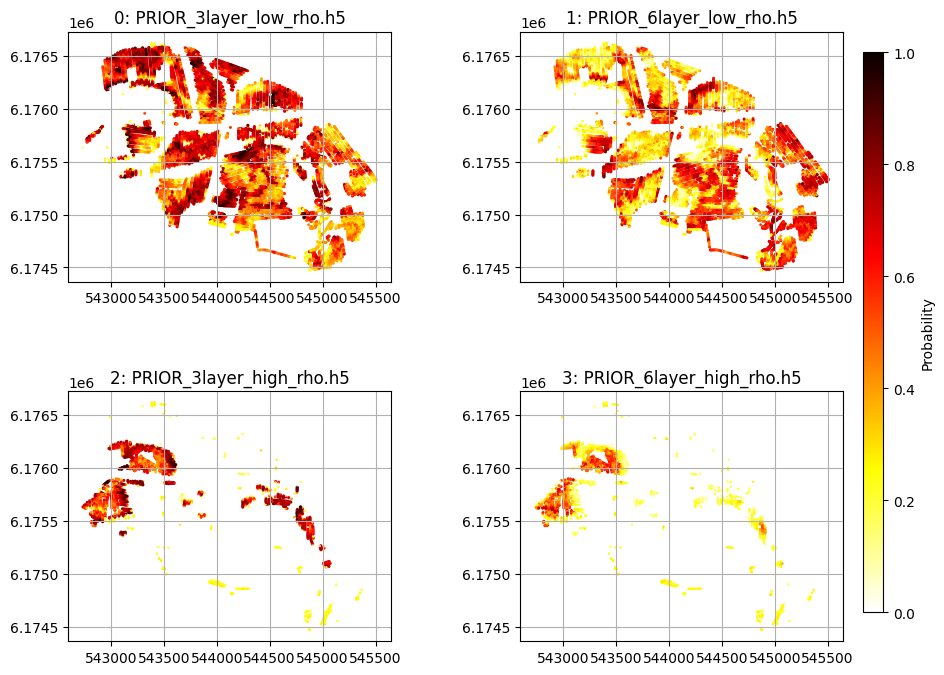

In [10]:
# Plot per-class probability maps (M4_P) with correct scatter args
from matplotlib import gridspec

fig = plt.figure(figsize=(10, 8))
gs = gridspec.GridSpec(2, 2, figure=fig, wspace=0.4, hspace=0.4)

for i in range(len(f_prior_files)):
    ax = fig.add_subplot(gs[i])
    sc = ax.scatter(X, Y, c=M4_P[:, i, 0], vmin=0, vmax=1, cmap='hot_r', s=2*(M4_P[:, i, 0]+.01))
    ax.set_title("%d: %s" % (i, f_prior_files[i]))
    ax.set_aspect('equal')
    plt.grid()
# Add a single colorbar for all subplots
cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])  # [left, bottom, width, height]
fig.colorbar(sc, cax=cbar_ax, label='Probability')
plt.show()

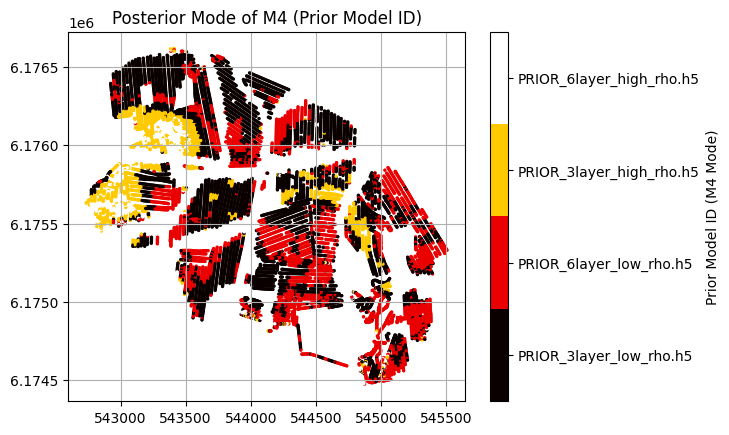

In [11]:
plt.figure()
# Normalize M4_entropy to control transparency (values between 0.1 and 1)
normalized_alpha = (M4_entropy - np.min(M4_entropy)) / (np.max(M4_entropy) - np.min(M4_entropy)) * 0.9 + 0.001
plt.scatter(X, Y, c=M4_mode, cmap='hot', s=2, alpha=normalized_alpha)
plt.scatter(X, Y, c=M4_mode, cmap='hot', s=2)
plt.grid()
plt.title('Posterior Mode of M4 (Prior Model ID)')
# Add a discrete colorbar with values 1, 2, 3, 4
cbar = plt.colorbar(boundaries=[0.5, 1.5, 2.5, 3.5, 4.5], ticks=[1, 2, 3, 4])
cbar.set_ticklabels(['Class 1', 'Class 2', 'Class 3', 'Class 4'])
cbar.set_ticklabels(f_prior_files)
cbar.set_label('Prior Model ID (M4 Mode)')